In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

class LSTM_output(torch.nn.Module):
    def forward(self, x):
        return x[0].unsqueeze(0)


for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    nonlinear_func= torch.nn.Sequential(
#                     LSTM_input(),
                    torch.nn.LSTM(input_dim[1],input_dim[1]),
                    LSTM_output(),
                    torch.nn.Sigmoid(),
#                     EEGNet_input()
                        ).to(DEVICE)
    model = EEGNet_NeuralFS_Wrapper(DEVICE, classifier, input_dim,
                                nonlinear_func=nonlinear_func
                                 ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_pairwise_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
#     pickle.load( 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "rb") 
#                )  
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.682741684072158


Iterations:   0%|                                   | 1/300 [00:02<12:32,  2.52s/it]

Epoch:  0
t_loss:  0.682741684072158 , v_loss:  0.6931573947270712
t_acc:  0.5359477124183006 , v_acc:  0.5217391304347826
t_recall:  0.5045614251794512 , v_recall:  0.43333333333333335
t_prec:  0.503970080552359 , v_prec:  0.4309443822321762
t_f:  0.49719444504211674 , v_f:  0.4319816723940435
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:25,  1.50s/it]

Epoch  1 , loss 0.6535344544579001
Epoch  2 , loss 0.6272982616050571


Iterations:   1%|▎                                  | 3/300 [00:04<06:31,  1.32s/it]

Epoch:  2
t_loss:  0.6272982616050571 , v_loss:  0.6903370022773743
t_acc:  0.6137566137566137 , v_acc:  0.6335403726708074
t_recall:  0.5026955435692619 , v_recall:  0.4704504504504505
t_prec:  0.5033809566982765 , v_prec:  0.41476091476091476
t_f:  0.49778113877905383 , v_f:  0.41784641784641785
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:22,  1.09s/it]

Epoch  3 , loss 0.6017752020966773
Epoch  4 , loss 0.5750630345999026


Iterations:   2%|▌                                  | 5/300 [00:06<05:24,  1.10s/it]

Epoch:  4
t_loss:  0.5750630345999026 , v_loss:  0.6823765834172567
t_acc:  0.6750700280112045 , v_acc:  0.6832298136645962
t_recall:  0.5062248665266741 , v_recall:  0.4954954954954955
t_prec:  0.5213867390115244 , v_prec:  0.34375
t_f:  0.46165011459129107 , v_f:  0.40590405904059035
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:46,  1.03it/s]

Epoch  5 , loss 0.5549649280660293
Epoch  6 , loss 0.54000358078994


Iterations:   2%|▊                                  | 7/300 [00:08<05:02,  1.03s/it]

Epoch:  6
t_loss:  0.54000358078994 , v_loss:  0.6706743240356445
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.5130344079823226 , v_recall:  0.5
t_prec:  0.5865088570543691 , v_prec:  0.3447204968944099
t_f:  0.45402512430216024 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:32,  1.07it/s]

Epoch  7 , loss 0.5199767871230256
Epoch  8 , loss 0.5072769218800115


Iterations:   3%|█                                  | 9/300 [00:09<04:48,  1.01it/s]

Epoch:  8
t_loss:  0.5072769218800115 , v_loss:  0.663646270831426
t_acc:  0.6934329287270464 , v_acc:  0.6894409937888198
t_recall:  0.5033220790271887 , v_recall:  0.5
t_prec:  0.5558353581644265 , v_prec:  0.3447204968944099
t_f:  0.42559739283192116 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:21,  1.11it/s]

Epoch  9 , loss 0.5035514551050523
Epoch  10 , loss 0.4891623994883369


Iterations:   4%|█▏                                | 11/300 [00:11<04:38,  1.04it/s]

Epoch:  10
t_loss:  0.4891623994883369 , v_loss:  0.6632273892561594
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:14,  1.13it/s]

Epoch  11 , loss 0.4780404830680174
Epoch  12 , loss 0.4724215795012081


Iterations:   4%|█▍                                | 13/300 [00:13<04:31,  1.06it/s]

Epoch:  12
t_loss:  0.4724215795012081 , v_loss:  0.6671527028083801
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:10,  1.14it/s]

Epoch  13 , loss 0.46859799004068564
Epoch  14 , loss 0.45870452943970175


Iterations:   5%|█▋                                | 15/300 [00:15<04:28,  1.06it/s]

Epoch:  14
t_loss:  0.45870452943970175 , v_loss:  0.6728505194187164
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:09,  1.14it/s]

Epoch  15 , loss 0.4549138487554064
Epoch  16 , loss 0.4548741672553268


Iterations:   6%|█▉                                | 17/300 [00:17<04:31,  1.04it/s]

Epoch:  16
t_loss:  0.4548741672553268 , v_loss:  0.6774157782395681
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:18<04:14,  1.11it/s]

Epoch  17 , loss 0.45074784931014567
Epoch  18 , loss 0.4463449377639621


Iterations:   6%|██▏                               | 19/300 [00:19<04:32,  1.03it/s]

Epoch:  18
t_loss:  0.4463449377639621 , v_loss:  0.6812353332837423
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:14,  1.10it/s]

Epoch  19 , loss 0.44750051697095233
Epoch  20 , loss 0.4404699852069219


Iterations:   7%|██▍                               | 21/300 [00:21<04:33,  1.02it/s]

Epoch:  20
t_loss:  0.4404699852069219 , v_loss:  0.6821835537751516
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5003513539479283 , v_recall:  0.5
t_prec:  0.5478802992518703 , v_prec:  0.3447204968944099
t_f:  0.41210256521437655 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:14,  1.09it/s]

Epoch  21 , loss 0.44559260384709226
Epoch  22 , loss 0.44377632059302985


Iterations:   8%|██▌                               | 23/300 [00:22<04:31,  1.02it/s]

Epoch:  22
t_loss:  0.44377632059302985 , v_loss:  0.6812165876229604
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:13,  1.09it/s]

Epoch  23 , loss 0.44382434908081503
Epoch  24 , loss 0.43800677037706565


Iterations:   8%|██▊                               | 25/300 [00:24<04:28,  1.02it/s]

Epoch:  24
t_loss:  0.43800677037706565 , v_loss:  0.6787518660227457
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5025562372188139 , v_recall:  0.5
t_prec:  0.8483478802992519 , v_prec:  0.3447204968944099
t_f:  0.415705613844319 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:11,  1.09it/s]

Epoch  25 , loss 0.4427349818687813
Epoch  26 , loss 0.4384455318544425


Iterations:   9%|███                               | 27/300 [00:26<04:26,  1.03it/s]

Epoch:  26
t_loss:  0.4384455318544425 , v_loss:  0.6755811522404352
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:07,  1.10it/s]

Epoch  27 , loss 0.43344145428900627
Epoch  28 , loss 0.43222443905531194


Iterations:  10%|███▎                              | 29/300 [00:28<04:27,  1.01it/s]

Epoch:  28
t_loss:  0.43222443905531194 , v_loss:  0.6727351446946462
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.49977628635346755 , v_recall:  0.5
t_prec:  0.34775840597758406 , v_prec:  0.3447204968944099
t_f:  0.41013401872590416 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:08,  1.09it/s]

Epoch  29 , loss 0.4322093865450691
Epoch  30 , loss 0.43386777592640297


Iterations:  10%|███▌                              | 31/300 [00:30<04:25,  1.01it/s]

Epoch:  30
t_loss:  0.43386777592640297 , v_loss:  0.6695926239093145
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:07,  1.08it/s]

Epoch  31 , loss 0.43189037372084227
Epoch  32 , loss 0.4394144223016851


Iterations:  11%|███▋                              | 33/300 [00:32<04:25,  1.00it/s]

Epoch:  32
t_loss:  0.4394144223016851 , v_loss:  0.6640996585289637
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34780578898225956 , v_prec:  0.3447204968944099
t_f:  0.4102422907488987 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:05,  1.08it/s]

Epoch  33 , loss 0.4317159424809849
Epoch  34 , loss 0.4376363146538828


Iterations:  12%|███▉                              | 35/300 [00:34<04:22,  1.01it/s]

Epoch:  34
t_loss:  0.4376363146538828 , v_loss:  0.6605754743019739
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5023963437229794 , v_recall:  0.5
t_prec:  0.6816479400749064 , v_prec:  0.3447204968944099
t_f:  0.4164485805823192 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:35<04:05,  1.07it/s]

Epoch  35 , loss 0.43454127159773137
Epoch  36 , loss 0.4295669975234013


Iterations:  12%|████▏                             | 37/300 [00:36<04:21,  1.01it/s]

Epoch:  36
t_loss:  0.4295669975234013 , v_loss:  0.6537324041128159
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503035231468138 , v_recall:  0.5
t_prec:  0.6297016734438536 , v_prec:  0.3447204968944099
t_f:  0.4192163289012425 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:02,  1.08it/s]

Epoch  37 , loss 0.4308386334017211
Epoch  38 , loss 0.42994190898596074


Iterations:  13%|████▍                             | 39/300 [00:38<04:20,  1.00it/s]

Epoch:  38
t_loss:  0.42994190898596074 , v_loss:  0.6504121820131937
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.503355018459807 , v_recall:  0.5
t_prec:  0.7860179407176286 , v_prec:  0.3447204968944099
t_f:  0.4177611561866126 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:39<04:00,  1.08it/s]

Epoch  39 , loss 0.42383261287913604
Epoch  40 , loss 0.4301811497585446


Iterations:  14%|████▋                             | 41/300 [00:40<04:15,  1.01it/s]

Epoch:  40
t_loss:  0.4301811497585446 , v_loss:  0.645449643333753
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5015653092875475 , v_recall:  0.5
t_prec:  0.5668888802001877 , v_prec:  0.3447204968944099
t_f:  0.41683606795411643 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:59,  1.08it/s]

Epoch  41 , loss 0.42884501931714075
Epoch  42 , loss 0.42549242809707044


Iterations:  14%|████▊                             | 43/300 [00:42<04:14,  1.01it/s]

Epoch:  42
t_loss:  0.42549242809707044 , v_loss:  0.6442098865906397
t_acc:  0.6999688764394647 , v_acc:  0.6894409937888198
t_recall:  0.5077325318071396 , v_recall:  0.5
t_prec:  0.7938967136150235 , v_prec:  0.3447204968944099
t_f:  0.42729814284763357 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:42<04:03,  1.05it/s]

Epoch  43 , loss 0.4226883158964269
Epoch  44 , loss 0.4223033137181226


Iterations:  15%|█████                             | 45/300 [00:44<04:13,  1.01it/s]

Epoch:  44
t_loss:  0.4223033137181226 , v_loss:  0.6389696101347605
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5071890311689381 , v_recall:  0.5
t_prec:  0.6826741996233521 , v_prec:  0.3447204968944099
t_f:  0.4285357936383385 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:51,  1.10it/s]

Epoch  45 , loss 0.4268445980315115
Epoch  46 , loss 0.42368215965289696


Iterations:  16%|█████▎                            | 47/300 [00:45<04:04,  1.03it/s]

Epoch:  46
t_loss:  0.42368215965289696 , v_loss:  0.6328991055488586
t_acc:  0.699035169623405 , v_acc:  0.6894409937888198
t_recall:  0.5079239922592333 , v_recall:  0.5
t_prec:  0.7013496547394853 , v_prec:  0.3447204968944099
t_f:  0.4297152863243275 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:44,  1.12it/s]

Epoch  47 , loss 0.4232298538965337
Epoch  48 , loss 0.4258140459948895


Iterations:  16%|█████▌                            | 49/300 [00:47<03:56,  1.06it/s]

Epoch:  48
t_loss:  0.4258140459948895 , v_loss:  0.6254449039697647
t_acc:  0.6987239340180517 , v_acc:  0.6894409937888198
t_recall:  0.5074127448154705 , v_recall:  0.5
t_prec:  0.6955419854698173 , v_prec:  0.3447204968944099
t_f:  0.4286623333299043 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:41,  1.13it/s]

Epoch  49 , loss 0.42091146520539824
Epoch  50 , loss 0.4218214528233397


Iterations:  17%|█████▊                            | 51/300 [00:49<03:53,  1.07it/s]

Epoch:  50
t_loss:  0.4218214528233397 , v_loss:  0.6220557242631912
t_acc:  0.7002801120448179 , v_acc:  0.6894409937888198
t_recall:  0.5099689820342844 , v_recall:  0.5
t_prec:  0.7209048883842583 , v_prec:  0.3447204968944099
t_f:  0.4339080086494944 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:38,  1.13it/s]

Epoch  51 , loss 0.4233504785042183
Epoch  52 , loss 0.42115722801171096


Iterations:  18%|██████                            | 53/300 [00:51<03:52,  1.06it/s]

Epoch:  52
t_loss:  0.42115722801171096 , v_loss:  0.6183047393957773
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5076042052675643 , v_recall:  0.5
t_prec:  0.6494336060415355 , v_prec:  0.3447204968944099
t_f:  0.43103901998935323 , v_f:  0.4080882352941176
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:38,  1.13it/s]

Epoch  53 , loss 0.41762230384583565
Epoch  54 , loss 0.4179493241450366


Iterations:  18%|██████▏                           | 55/300 [00:53<03:50,  1.06it/s]

Epoch:  54
t_loss:  0.4179493241450366 , v_loss:  0.6116480380296707
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5095853748919175 , v_recall:  0.51
t_prec:  0.6831916902738433 , v_prec:  0.846875
t_f:  0.43442251931932985 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:34,  1.14it/s]

Epoch  55 , loss 0.4229487291738099
Epoch  56 , loss 0.4196202492012697


Iterations:  19%|██████▍                           | 57/300 [00:54<03:51,  1.05it/s]

Epoch:  56
t_loss:  0.4196202492012697 , v_loss:  0.6108894248803457
t_acc:  0.6993464052287581 , v_acc:  0.6956521739130435
t_recall:  0.5092978410946871 , v_recall:  0.51
t_prec:  0.6880308273041837 , v_prec:  0.846875
t_f:  0.43351412163750547 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:33,  1.13it/s]

Epoch  57 , loss 0.4185235880169214
Epoch  58 , loss 0.41248619322683294


Iterations:  20%|██████▋                           | 59/300 [00:56<03:51,  1.04it/s]

Epoch:  58
t_loss:  0.41248619322683294 , v_loss:  0.6050494809945425
t_acc:  0.7005913476501712 , v_acc:  0.6956521739130435
t_recall:  0.5113428308697383 , v_recall:  0.51
t_prec:  0.7054993783671778 , v_prec:  0.846875
t_f:  0.4376653761625453 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:32,  1.13it/s]

Epoch  59 , loss 0.4133972198355432
Epoch  60 , loss 0.4126205420961567


Iterations:  20%|██████▉                           | 61/300 [00:58<03:48,  1.05it/s]

Epoch:  60
t_loss:  0.4126205420961567 , v_loss:  0.6040197461843491
t_acc:  0.7033924680983504 , v_acc:  0.6956521739130435
t_recall:  0.5159440578636033 , v_recall:  0.51
t_prec:  0.7342105616859989 , v_prec:  0.846875
t_f:  0.44689754833115813 , v_f:  0.42920193907821425
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:30,  1.13it/s]

Epoch  61 , loss 0.41432489600836064
Epoch  62 , loss 0.414461131773743


Iterations:  21%|███████▏                          | 63/300 [01:00<03:45,  1.05it/s]

Epoch:  62
t_loss:  0.414461131773743 , v_loss:  0.6012550890445709
t_acc:  0.6974789915966386 , v_acc:  0.7018633540372671
t_recall:  0.5088181606071835 , v_recall:  0.52
t_prec:  0.6323087272277975 , v_prec:  0.8490566037735849
t_f:  0.43542394599222506 , v_f:  0.44957264957264953
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:28,  1.13it/s]

Epoch  63 , loss 0.41018788837919046
Epoch  64 , loss 0.4166497459598616


Iterations:  22%|███████▎                          | 65/300 [01:02<03:42,  1.06it/s]

Epoch:  64
t_loss:  0.4166497459598616 , v_loss:  0.5979240188995997
t_acc:  0.7030812324929971 , v_acc:  0.7018633540372671
t_recall:  0.5180206145949136 , v_recall:  0.52
t_prec:  0.6954489520482693 , v_prec:  0.8490566037735849
t_f:  0.4536306479994752 , v_f:  0.44957264957264953
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:24,  1.15it/s]

Epoch  65 , loss 0.41677871171165914
Epoch  66 , loss 0.4212232489211887


Iterations:  22%|███████▌                          | 67/300 [01:04<03:40,  1.06it/s]

Epoch:  66
t_loss:  0.4212232489211887 , v_loss:  0.5947704712549845
t_acc:  0.702769996887644 , v_acc:  0.7018633540372671
t_recall:  0.5160716981649991 , v_recall:  0.52
t_prec:  0.709756388822546 , v_prec:  0.8490566037735849
t_f:  0.4483495423160972 , v_f:  0.44957264957264953
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:27,  1.12it/s]

Epoch  67 , loss 0.4179011659294951
Epoch  68 , loss 0.41027871241756514


Iterations:  23%|███████▊                          | 69/300 [01:06<03:43,  1.03it/s]

Epoch:  68
t_loss:  0.41027871241756514 , v_loss:  0.593559687336286
t_acc:  0.7046374105197635 , v_acc:  0.7080745341614907
t_recall:  0.5188516490303454 , v_recall:  0.53
t_prec:  0.7290624374624775 , v_prec:  0.8512658227848101
t_f:  0.4535288282403039 , v_f:  0.4692431787893666
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:29,  1.10it/s]

Epoch  69 , loss 0.41027408662964315
Epoch  70 , loss 0.41153304950863706


Iterations:  24%|████████                          | 71/300 [01:07<03:43,  1.02it/s]

Epoch:  70
t_loss:  0.41153304950863706 , v_loss:  0.5888141244649887
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5180528677893523 , v_recall:  0.55
t_prec:  0.7313232035454258 , v_prec:  0.8557692307692308
t_f:  0.451667873865018 , v_f:  0.5066394279877425
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:29,  1.09it/s]

Epoch  71 , loss 0.4125300803605248
Epoch  72 , loss 0.41007059637237997


Iterations:  24%|████████▎                         | 73/300 [01:09<03:42,  1.02it/s]

Epoch:  72
t_loss:  0.41007059637237997 , v_loss:  0.5879651308059692
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5192668231289717 , v_recall:  0.55
t_prec:  0.705815658293422 , v_prec:  0.8557692307692308
t_f:  0.45576990450922433 , v_f:  0.5066394279877425
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:27,  1.09it/s]

Epoch  73 , loss 0.4099161005487629
Epoch  74 , loss 0.40790431289111867


Iterations:  25%|████████▌                         | 75/300 [01:11<03:38,  1.03it/s]

Epoch:  74
t_loss:  0.40790431289111867 , v_loss:  0.586213598648707
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5214394532054185 , v_recall:  0.55
t_prec:  0.6991204588910134 , v_prec:  0.8557692307692308
t_f:  0.46107078602890994 , v_f:  0.5066394279877425
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:24,  1.09it/s]

Epoch  75 , loss 0.4057995186132543
Epoch  76 , loss 0.40493734093273387


Iterations:  26%|████████▋                         | 77/300 [01:13<03:39,  1.02it/s]

Epoch:  76
t_loss:  0.40493734093273387 , v_loss:  0.5841509302457174
t_acc:  0.7046374105197635 , v_acc:  0.7204968944099379
t_recall:  0.5217269870026489 , v_recall:  0.55
t_prec:  0.6966749768089053 , v_prec:  0.8557692307692308
t_f:  0.4618921520787872 , v_f:  0.5066394279877425
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:25,  1.08it/s]

Epoch  77 , loss 0.40351953167541355
Epoch  78 , loss 0.4057385255308712


Iterations:  26%|████████▉                         | 79/300 [01:15<03:38,  1.01it/s]

Epoch:  78
t_loss:  0.4057385255308712 , v_loss:  0.5832059979438782
t_acc:  0.7052598817304699 , v_acc:  0.7391304347826086
t_recall:  0.5213118129040227 , v_recall:  0.58
t_prec:  0.7147361433786923 , v_prec:  0.8627450980392157
t_f:  0.4597279774736838 , v_f:  0.5583855799373041
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:23,  1.08it/s]

Epoch  79 , loss 0.4083450202848397
Epoch  80 , loss 0.40647049452744277


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.40647049452744277 , v_loss:  0.5811781833569208
t_acc:  0.7086834733893558 , v_acc:  0.7391304347826086
t_recall:  0.5252103320020313 , v_recall:  0.58
t_prec:  0.757670906200318 , v_prec:  0.8627450980392157
t_f:  0.46559241436664367 , v_f:  0.5583855799373041
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:21,  1.08it/s]

Epoch  81 , loss 0.40431160143777434
Epoch  82 , loss 0.40068455595596164


Iterations:  28%|█████████▍                        | 83/300 [01:19<03:35,  1.01it/s]

Epoch:  82
t_loss:  0.40068455595596164 , v_loss:  0.5786485175291697
t_acc:  0.7055711173358232 , v_acc:  0.7453416149068323
t_recall:  0.5238357969283979 , v_recall:  0.59
t_prec:  0.6982262703739214 , v_prec:  0.8651315789473684
t_f:  0.4664334736283321 , v_f:  0.5745956048205194
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:20,  1.08it/s]

Epoch  83 , loss 0.4023337510286593
Epoch  84 , loss 0.4046527018734053


Iterations:  28%|█████████▋                        | 85/300 [01:21<03:32,  1.01it/s]

Epoch:  84
t_loss:  0.4046527018734053 , v_loss:  0.5781481464703878
t_acc:  0.7068160597572363 , v_acc:  0.7453416149068323
t_recall:  0.524155583920067 , v_recall:  0.59
t_prec:  0.7214653624817542 , v_prec:  0.8651315789473684
t_f:  0.4654540869022169 , v_f:  0.5745956048205194
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:17,  1.08it/s]

Epoch  85 , loss 0.4029569193428638
Epoch  86 , loss 0.4014698389698477


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:29,  1.02it/s]

Epoch:  86
t_loss:  0.4014698389698477 , v_loss:  0.5773101647694906
t_acc:  0.7086834733893558 , v_acc:  0.7453416149068323
t_recall:  0.5286607375687954 , v_recall:  0.59
t_prec:  0.718183622863352 , v_prec:  0.8651315789473684
t_f:  0.4752381816532075 , v_f:  0.5745956048205194
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:16,  1.08it/s]

Epoch  87 , loss 0.3984440366427104
Epoch  88 , loss 0.400164382130492


Iterations:  30%|██████████                        | 89/300 [01:25<03:29,  1.01it/s]

Epoch:  88
t_loss:  0.400164382130492 , v_loss:  0.57233693699042
t_acc:  0.7093059446000622 , v_acc:  0.7515527950310559
t_recall:  0.5282455634701693 , v_recall:  0.6
t_prec:  0.7348993288590604 , v_prec:  0.8675496688741722
t_f:  0.47320175937511855 , v_f:  0.5903307888040712
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:15,  1.08it/s]

Epoch  89 , loss 0.3985110807652567
Epoch  90 , loss 0.4011150475810556


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:27,  1.01it/s]

Epoch:  90
t_loss:  0.4011150475810556 , v_loss:  0.572436566154162
t_acc:  0.7071272953625894 , v_acc:  0.7515527950310559
t_recall:  0.5272546355389028 , v_recall:  0.6
t_prec:  0.701120826440701 , v_prec:  0.8675496688741722
t_f:  0.47361514712726094 , v_f:  0.5903307888040712
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:12,  1.08it/s]

Epoch  91 , loss 0.3927986832226024
Epoch  92 , loss 0.39095357790881513


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:24,  1.01it/s]

Epoch:  92
t_loss:  0.39095357790881513 , v_loss:  0.5688781440258026
t_acc:  0.7164643635231871 , v_acc:  0.7639751552795031
t_recall:  0.5402917884739435 , v_recall:  0.62
t_prec:  0.7603063227087865 , v_prec:  0.8724832214765101
t_f:  0.49564115955683935 , v_f:  0.6204714640198511
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:10,  1.08it/s]

Epoch  93 , loss 0.39860178150382697
Epoch  94 , loss 0.3960011367704354


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:22,  1.01it/s]

Epoch:  94
t_loss:  0.3960011367704354 , v_loss:  0.5671984752019247
t_acc:  0.7121070650482415 , v_acc:  0.7701863354037267
t_recall:  0.5357221284363377 , v_recall:  0.63
t_prec:  0.7229017984584643 , v_prec:  0.875
t_f:  0.48938533472726076 , v_f:  0.6349206349206349
////////


Iterations:  32%|██████████▉                       | 96/300 [01:31<03:07,  1.09it/s]

Epoch  95 , loss 0.3954213255760716
Epoch  96 , loss 0.3968583690185173


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:20,  1.01it/s]

Epoch:  96
t_loss:  0.3968583690185173 , v_loss:  0.5655714869499207
t_acc:  0.713974478680361 , v_acc:  0.7763975155279503
t_recall:  0.5382145455044537 , v_recall:  0.64
t_prec:  0.7344584163696073 , v_prec:  0.8775510204081632
t_f:  0.49343580314117297 , v_f:  0.6489825581395349
////////


Iterations:  33%|███████████                       | 98/300 [01:33<03:06,  1.08it/s]

Epoch  97 , loss 0.3941041301278507
Epoch  98 , loss 0.40042096434854996


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:18,  1.01it/s]

Epoch:  98
t_loss:  0.40042096434854996 , v_loss:  0.5639150490363439
t_acc:  0.7186430127606598 , v_acc:  0.7763975155279503
t_recall:  0.5458832571608954 , v_recall:  0.64
t_prec:  0.7502382793981885 , v_prec:  0.8775510204081632
t_f:  0.5070634029513551 , v_f:  0.6489825581395349
////////


Iterations:  33%|███████████                      | 100/300 [01:35<03:04,  1.09it/s]

Epoch  99 , loss 0.39737728413413553
Epoch  100 , loss 0.39971473813056946


Iterations:  34%|███████████                      | 101/300 [01:36<03:17,  1.01it/s]

Epoch:  100
t_loss:  0.39971473813056946 , v_loss:  0.5610606819391251
t_acc:  0.7189542483660131 , v_acc:  0.7763975155279503
t_recall:  0.5469695721991189 , v_recall:  0.64
t_prec:  0.7470760233918129 , v_prec:  0.8775510204081632
t_f:  0.5093593854873593 , v_f:  0.6489825581395349
////////


Iterations:  34%|███████████▏                     | 102/300 [01:37<03:03,  1.08it/s]

Epoch  101 , loss 0.389464688651702
Epoch  102 , loss 0.39503205874386954


Iterations:  34%|███████████▎                     | 103/300 [01:38<03:15,  1.01it/s]

Epoch:  102
t_loss:  0.39503205874386954 , v_loss:  0.5600427041451136
t_acc:  0.711484593837535 , v_acc:  0.782608695652174
t_recall:  0.5338370321571211 , v_recall:  0.65
t_prec:  0.7266409266409266 , v_prec:  0.8801369863013699
t_f:  0.4852731432588683 , v_f:  0.662675845555223
////////


Iterations:  35%|███████████▍                     | 104/300 [01:39<03:01,  1.08it/s]

Epoch  103 , loss 0.3889422048540676
Epoch  104 , loss 0.39316383705419655


Iterations:  35%|███████████▌                     | 105/300 [01:40<03:13,  1.01it/s]

Epoch:  104
t_loss:  0.39316383705419655 , v_loss:  0.5612531701723734
t_acc:  0.7189542483660131 , v_acc:  0.782608695652174
t_recall:  0.5469695721991189 , v_recall:  0.65
t_prec:  0.7470760233918129 , v_prec:  0.8801369863013699
t_f:  0.5093593854873593 , v_f:  0.662675845555223
////////


Iterations:  35%|███████████▋                     | 106/300 [01:41<02:58,  1.08it/s]

Epoch  105 , loss 0.39701954289978625
Epoch  106 , loss 0.38822832703590393


Iterations:  36%|███████████▊                     | 107/300 [01:42<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.38822832703590393 , v_loss:  0.5584148466587067
t_acc:  0.7186430127606598 , v_acc:  0.7888198757763976
t_recall:  0.545595723363665 , v_recall:  0.66
t_prec:  0.7523918658833063 , v_prec:  0.8827586206896552
t_f:  0.506357666317693 , v_f:  0.6760179924242424
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<02:56,  1.08it/s]

Epoch  107 , loss 0.38724033972796273
Epoch  108 , loss 0.39343680587469365


Iterations:  36%|███████████▉                     | 109/300 [01:44<03:09,  1.01it/s]

Epoch:  108
t_loss:  0.39343680587469365 , v_loss:  0.5581649442513784
t_acc:  0.7217553688141923 , v_acc:  0.7888198757763976
t_recall:  0.5507081978012929 , v_recall:  0.66
t_prec:  0.7611983032873807 , v_prec:  0.8827586206896552
t_f:  0.5152815746309458 , v_f:  0.6760179924242424
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:57,  1.07it/s]

Epoch  109 , loss 0.3901214412614411
Epoch  110 , loss 0.38134745815221


Iterations:  37%|████████████▏                    | 111/300 [01:46<03:08,  1.00it/s]

Epoch:  110
t_loss:  0.38134745815221 , v_loss:  0.5604688773552576
t_acc:  0.7208216619981326 , v_acc:  0.7888198757763976
t_recall:  0.5494619892672349 , v_recall:  0.66
t_prec:  0.7565553425151633 , v_prec:  0.8827586206896552
t_f:  0.5133104741576202 , v_f:  0.6760179924242424
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:54,  1.07it/s]

Epoch  111 , loss 0.385613327517229
Epoch  112 , loss 0.3877890332072389


Iterations:  38%|████████████▍                    | 113/300 [01:48<03:05,  1.01it/s]

Epoch:  112
t_loss:  0.3877890332072389 , v_loss:  0.559604694445928
t_acc:  0.7245564892623716 , v_acc:  0.7950310559006211
t_recall:  0.5550218909979275 , v_recall:  0.6754954954954955
t_prec:  0.7703513464910309 , v_prec:  0.8610081541882876
t_f:  0.5225228281039865 , v_f:  0.6956521739130435
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:52,  1.08it/s]

Epoch  113 , loss 0.3861868767177357
Epoch  114 , loss 0.3838944324091369


Iterations:  38%|████████████▋                    | 115/300 [01:50<03:02,  1.01it/s]

Epoch:  114
t_loss:  0.3838944324091369 , v_loss:  0.557239755988121
t_acc:  0.7223778400248988 , v_acc:  0.8074534161490683
t_recall:  0.5514431588915881 , v_recall:  0.6954954954954955
t_prec:  0.764984093319194 , v_prec:  0.8690476190476191
t_f:  0.5163659558957536 , v_f:  0.7199371527972616
////////


Iterations:  39%|████████████▊                    | 116/300 [01:50<02:48,  1.09it/s]

Epoch  115 , loss 0.3860621148464726
Epoch  116 , loss 0.3853624457237767


Iterations:  39%|████████████▊                    | 117/300 [01:51<02:59,  1.02it/s]

Epoch:  116
t_loss:  0.3853624457237767 , v_loss:  0.5591599692900976
t_acc:  0.7233115468409586 , v_acc:  0.8012422360248447
t_recall:  0.5535519688173371 , v_recall:  0.6854954954954955
t_prec:  0.7631288495256934 , v_prec:  0.8650709219858156
t_f:  0.5203647391914622 , v_f:  0.7079365079365079
////////


Iterations:  39%|████████████▉                    | 118/300 [01:52<02:47,  1.09it/s]

Epoch  117 , loss 0.38378163529377357
Epoch  118 , loss 0.38082772084310945


Iterations:  40%|█████████████                    | 119/300 [01:53<02:58,  1.01it/s]

Epoch:  118
t_loss:  0.38082772084310945 , v_loss:  0.5579221546649933
t_acc:  0.7261126672891379 , v_acc:  0.8074534161490683
t_recall:  0.5598783985945842 , v_recall:  0.6954954954954955
t_prec:  0.7587652876026587 , v_prec:  0.8690476190476191
t_f:  0.5320828357556869 , v_f:  0.7199371527972616
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:54<02:46,  1.08it/s]

Epoch  119 , loss 0.3906990453308704
Epoch  120 , loss 0.38363592355859044


Iterations:  40%|█████████████▎                   | 121/300 [01:55<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.38363592355859044 , v_loss:  0.5570535312096278
t_acc:  0.7261126672891379 , v_acc:  0.8012422360248447
t_recall:  0.5613160675807359 , v_recall:  0.690990990990991
t_prec:  0.7507455398569163 , v_prec:  0.8466317854807064
t_f:  0.5352577167758512 , v_f:  0.7137777777777778
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:56<02:42,  1.09it/s]

Epoch  121 , loss 0.3796964264383503
Epoch  122 , loss 0.38314657059370305


Iterations:  41%|█████████████▌                   | 123/300 [01:57<02:53,  1.02it/s]

Epoch:  122
t_loss:  0.38314657059370305 , v_loss:  0.5563577860593796
t_acc:  0.7239340180516651 , v_acc:  0.7950310559006211
t_recall:  0.5577373354743964 , v_recall:  0.6864864864864866
t_prec:  0.7453249772566461 , v_prec:  0.8260869565217391
t_f:  0.5293270220889699 , v_f:  0.7077075424987622
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:58<02:41,  1.09it/s]

Epoch  123 , loss 0.3794188239410812
Epoch  124 , loss 0.37987784018703535


Iterations:  42%|█████████████▊                   | 125/300 [01:59<02:51,  1.02it/s]

Epoch:  124
t_loss:  0.37987784018703535 , v_loss:  0.5592270990212759
t_acc:  0.7248677248677249 , v_acc:  0.7888198757763976
t_recall:  0.5607087467918365 , v_recall:  0.6764864864864866
t_prec:  0.740552749790625 , v_prec:  0.8203073904512754
t_f:  0.535030841966028 , v_f:  0.695888888888889
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:00<02:40,  1.09it/s]

Epoch  125 , loss 0.3789773075019612
Epoch  126 , loss 0.37744033687254963


Iterations:  42%|█████████████▉                   | 127/300 [02:01<02:49,  1.02it/s]

Epoch:  126
t_loss:  0.37744033687254963 , v_loss:  0.5596787134806315
t_acc:  0.7286025521319639 , v_acc:  0.7888198757763976
t_recall:  0.5662686485225292 , v_recall:  0.681981981981982
t_prec:  0.7521928373696398 , v_prec:  0.8071776155717763
t_f:  0.5437910659295424 , v_f:  0.7017218831734962
////////


Iterations:  43%|██████████████                   | 128/300 [02:02<02:38,  1.08it/s]

Epoch  127 , loss 0.375915271394393
Epoch  128 , loss 0.3704501928067675


Iterations:  43%|██████████████▏                  | 129/300 [02:03<02:48,  1.01it/s]

Epoch:  128
t_loss:  0.3704501928067675 , v_loss:  0.5600356310606003
t_acc:  0.734827264239029 , v_acc:  0.7950310559006211
t_recall:  0.5739057932227117 , v_recall:  0.6864864864864866
t_prec:  0.7785113579940417 , v_prec:  0.8260869565217391
t_f:  0.5548472075869336 , v_f:  0.7077075424987622
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:04<02:37,  1.08it/s]

Epoch  129 , loss 0.3746869306938321
Epoch  130 , loss 0.3757680993454129


Iterations:  44%|██████████████▍                  | 131/300 [02:05<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.3757680993454129 , v_loss:  0.5572299758593241
t_acc:  0.733582321817616 , v_acc:  0.7888198757763976
t_recall:  0.5718608034476607 , v_recall:  0.681981981981982
t_prec:  0.7762009847019519 , v_prec:  0.8071776155717763
t_f:  0.5515642833384422 , v_f:  0.7017218831734962
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:06<02:35,  1.08it/s]

Epoch  131 , loss 0.3710034764280506
Epoch  132 , loss 0.37575599142149385


Iterations:  44%|██████████████▋                  | 133/300 [02:07<02:46,  1.01it/s]

Epoch:  132
t_loss:  0.37575599142149385 , v_loss:  0.5582848489284515
t_acc:  0.7345160286336757 , v_acc:  0.7888198757763976
t_recall:  0.5762698837512523 , v_recall:  0.681981981981982
t_prec:  0.7631942054428169 , v_prec:  0.8071776155717763
t_f:  0.5598554504702501 , v_f:  0.7017218831734962
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:34,  1.08it/s]

Epoch  133 , loss 0.374940661238689
Epoch  134 , loss 0.3776005126681982


Iterations:  45%|██████████████▊                  | 135/300 [02:09<02:44,  1.00it/s]

Epoch:  134
t_loss:  0.3776005126681982 , v_loss:  0.5592936525742213
t_acc:  0.7295362589480237 , v_acc:  0.7950310559006211
t_recall:  0.5695275936371996 , v_recall:  0.6864864864864866
t_prec:  0.7464574143746756 , v_prec:  0.8260869565217391
t_f:  0.5498410391087807 , v_f:  0.7077075424987622
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:09<02:32,  1.07it/s]

Epoch  135 , loss 0.37144354979197186
Epoch  136 , loss 0.3724648888204612


Iterations:  46%|███████████████                  | 137/300 [02:11<02:41,  1.01it/s]

Epoch:  136
t_loss:  0.3724648888204612 , v_loss:  0.5556956430276235
t_acc:  0.7366946778711485 , v_acc:  0.782608695652174
t_recall:  0.5784109468714401 , v_recall:  0.6774774774774774
t_prec:  0.7742112504799692 , v_prec:  0.7897058823529413
t_f:  0.562613763629108 , v_f:  0.6958164642375169
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:11<02:30,  1.07it/s]

Epoch  137 , loss 0.3726898653834474
Epoch  138 , loss 0.37207529065655726


Iterations:  46%|███████████████▎                 | 139/300 [02:12<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.37207529065655726 , v_loss:  0.5572892626126608
t_acc:  0.7307812013694367 , v_acc:  0.7888198757763976
t_recall:  0.5698473806288686 , v_recall:  0.681981981981982
t_prec:  0.7569620231859862 , v_prec:  0.8071776155717763
t_f:  0.5495496298577374 , v_f:  0.7017218831734962
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:13<02:28,  1.08it/s]

Epoch  139 , loss 0.37810459791445267
Epoch  140 , loss 0.3699444929758708


Iterations:  47%|███████████████▌                 | 141/300 [02:14<02:37,  1.01it/s]

Epoch:  140
t_loss:  0.3699444929758708 , v_loss:  0.5556092709302902
t_acc:  0.7351384998443822 , v_acc:  0.782608695652174
t_recall:  0.5778674462332386 , v_recall:  0.6774774774774774
t_prec:  0.7618006804771954 , v_prec:  0.7897058823529413
t_f:  0.5625910547756414 , v_f:  0.6958164642375169
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:15<02:26,  1.08it/s]

Epoch  141 , loss 0.3712983990416807
Epoch  142 , loss 0.36824947128108904


Iterations:  48%|███████████████▋                 | 143/300 [02:16<02:36,  1.01it/s]

Epoch:  142
t_loss:  0.36824947128108904 , v_loss:  0.5578173945347468
t_acc:  0.7342047930283224 , v_acc:  0.7763975155279503
t_recall:  0.5751835687130289 , v_recall:  0.6674774774774774
t_prec:  0.765300867554993 , v_prec:  0.7826946472019465
t_f:  0.5579006491229879 , v_f:  0.6841761115954664
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:17<02:24,  1.08it/s]

Epoch  143 , loss 0.369160953690024
Epoch  144 , loss 0.37033075035787094


Iterations:  48%|███████████████▉                 | 145/300 [02:18<02:33,  1.01it/s]

Epoch:  144
t_loss:  0.37033075035787094 , v_loss:  0.5576865871747335
t_acc:  0.7391845627139745 , v_acc:  0.782608695652174
t_recall:  0.5830759940160031 , v_recall:  0.6774774774774774
t_prec:  0.7757798499529205 , v_prec:  0.7897058823529413
t_f:  0.5701050462834639 , v_f:  0.6958164642375169
////////


Iterations:  49%|████████████████                 | 146/300 [02:19<02:23,  1.07it/s]

Epoch  145 , loss 0.36000943183898926
Epoch  146 , loss 0.3671877167972864


Iterations:  49%|████████████████▏                | 147/300 [02:20<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.3671877167972864 , v_loss:  0.5562606006860733
t_acc:  0.7363834422657952 , v_acc:  0.782608695652174
t_recall:  0.5796249022110593 , v_recall:  0.6774774774774774
t_prec:  0.7654418425892882 , v_prec:  0.7897058823529413
t_f:  0.5652082012259565 , v_f:  0.6958164642375169
////////


Iterations:  49%|████████████████▎                | 148/300 [02:21<02:20,  1.08it/s]

Epoch  147 , loss 0.36978887372157154
Epoch  148 , loss 0.366331973788785


Iterations:  50%|████████████████▍                | 149/300 [02:22<02:29,  1.01it/s]

Epoch:  148
t_loss:  0.366331973788785 , v_loss:  0.5554001877705256
t_acc:  0.7426081543728602 , v_acc:  0.7763975155279503
t_recall:  0.5901373848835454 , v_recall:  0.672972972972973
t_prec:  0.775077765925959 , v_prec:  0.7735042735042735
t_f:  0.581375201206554 , v_f:  0.689987163029525
////////


Iterations:  50%|████████████████▌                | 150/300 [02:23<02:19,  1.08it/s]

Epoch  149 , loss 0.37150098178900925
Epoch  150 , loss 0.3605857774907467


Iterations:  50%|████████████████▌                | 151/300 [02:24<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.3605857774907467 , v_loss:  0.5577772657076517
t_acc:  0.7475879240585123 , v_acc:  0.7763975155279503
t_recall:  0.5968796749975982 , v_recall:  0.672972972972973
t_prec:  0.7890553124343095 , v_prec:  0.7735042735042735
t_f:  0.591013816024391 , v_f:  0.689987163029525
////////


Iterations:  51%|████████████████▋                | 152/300 [02:25<02:16,  1.08it/s]

Epoch  151 , loss 0.3615036446089838
Epoch  152 , loss 0.3595794936021169


Iterations:  51%|████████████████▊                | 153/300 [02:26<02:26,  1.00it/s]

Epoch:  152
t_loss:  0.3595794936021169 , v_loss:  0.5566857904195786
t_acc:  0.7432306255835668 , v_acc:  0.7763975155279503
t_recall:  0.5885720755959978 , v_recall:  0.672972972972973
t_prec:  0.7879718875502009 , v_prec:  0.7735042735042735
t_f:  0.5781296328392116 , v_f:  0.689987163029525
////////


Iterations:  51%|████████████████▉                | 154/300 [02:27<02:15,  1.08it/s]

Epoch  153 , loss 0.35856587395948525
Epoch  154 , loss 0.3627220240293765


Iterations:  52%|█████████████████                | 155/300 [02:28<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.3627220240293765 , v_loss:  0.55852938691775
t_acc:  0.7475879240585123 , v_acc:  0.7639751552795031
t_recall:  0.5980298101865196 , v_recall:  0.663963963963964
t_prec:  0.7840770791075051 , v_prec:  0.7443609022556391
t_f:  0.5930414468662897 , v_f:  0.6785414039512401
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:29<02:12,  1.09it/s]

Epoch  155 , loss 0.35767030277672934
Epoch  156 , loss 0.3558593503400391


Iterations:  52%|█████████████████▎               | 157/300 [02:30<02:20,  1.02it/s]

Epoch:  156
t_loss:  0.3558593503400391 , v_loss:  0.558948944012324
t_acc:  0.746031746031746 , v_acc:  0.7577639751552795
t_recall:  0.5969112419538574 , v_recall:  0.653963963963964
t_prec:  0.77590129985152 , v_prec:  0.736180210060807
t_f:  0.59179316503974 , v_f:  0.6671614100185529
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:30<02:09,  1.09it/s]

Epoch  157 , loss 0.3607952209079967
Epoch  158 , loss 0.35916006448222143


Iterations:  53%|█████████████████▍               | 159/300 [02:32<02:17,  1.02it/s]

Epoch:  158
t_loss:  0.35916006448222143 , v_loss:  0.5592806984980901
t_acc:  0.748521630874572 , v_acc:  0.7639751552795031
t_recall:  0.5998510863150383 , v_recall:  0.663963963963964
t_prec:  0.7842708848889004 , v_prec:  0.7443609022556391
t_f:  0.595795192833468 , v_f:  0.6785414039512401
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:32<02:08,  1.09it/s]

Epoch  159 , loss 0.3546769934542039
Epoch  160 , loss 0.36166545456531


Iterations:  54%|█████████████████▋               | 161/300 [02:33<02:15,  1.02it/s]

Epoch:  160
t_loss:  0.36166545456531 , v_loss:  0.5629796038071314
t_acc:  0.74354186118892 , v_acc:  0.7639751552795031
t_recall:  0.5936838637954461 , v_recall:  0.6584684684684685
t_prec:  0.7685987486719396 , v_prec:  0.7505698005698005
t_f:  0.5872832369942197 , v_f:  0.6727642276422765
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:34<02:05,  1.10it/s]

Epoch  161 , loss 0.35338664726883756
Epoch  162 , loss 0.35606136304490704


Iterations:  54%|█████████████████▉               | 163/300 [02:35<02:13,  1.03it/s]

Epoch:  162
t_loss:  0.35606136304490704 , v_loss:  0.5612149983644485
t_acc:  0.7482103952692188 , v_acc:  0.7639751552795031
t_recall:  0.6010650416546575 , v_recall:  0.663963963963964
t_prec:  0.7770801297407943 , v_prec:  0.7443609022556391
t_f:  0.5980068582584823 , v_f:  0.6785414039512401
////////


Iterations:  55%|██████████████████               | 164/300 [02:36<02:04,  1.09it/s]

Epoch  163 , loss 0.3567275013409409
Epoch  164 , loss 0.34900355163742514


Iterations:  55%|██████████████████▏              | 165/300 [02:37<02:13,  1.01it/s]

Epoch:  164
t_loss:  0.34900355163742514 , v_loss:  0.5599841127792994
t_acc:  0.752256458138811 , v_acc:  0.7577639751552795
t_recall:  0.6031107176678882 , v_recall:  0.653963963963964
t_prec:  0.8020516717325228 , v_prec:  0.736180210060807
t_f:  0.5998253816256407 , v_f:  0.6671614100185529
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:38<02:03,  1.08it/s]

Epoch  165 , loss 0.35366861726723464
Epoch  166 , loss 0.3524957112237519


Iterations:  56%|██████████████████▎              | 167/300 [02:39<02:10,  1.02it/s]

Epoch:  166
t_loss:  0.3524957112237519 , v_loss:  0.5645385334889094
t_acc:  0.7544351073762838 , v_acc:  0.7639751552795031
t_recall:  0.6121525919216042 , v_recall:  0.6584684684684685
t_prec:  0.783062102506547 , v_prec:  0.7505698005698005
t_f:  0.6140011648223646 , v_f:  0.6727642276422765
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:40<02:01,  1.09it/s]

Epoch  167 , loss 0.3544776349091062
Epoch  168 , loss 0.3591558191121793


Iterations:  56%|██████████████████▌              | 169/300 [02:41<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.3591558191121793 , v_loss:  0.5666124622027079
t_acc:  0.7500778089013383 , v_acc:  0.7701863354037267
t_recall:  0.6035574587227736 , v_recall:  0.673963963963964
t_prec:  0.7820251177394034 , v_prec:  0.7522204806687565
t_f:  0.601472213533521 , v_f:  0.6896910975673283
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:42<01:59,  1.08it/s]

Epoch  169 , loss 0.34753040122050866
Epoch  170 , loss 0.3530353252209869


Iterations:  57%|██████████████████▊              | 171/300 [02:43<02:07,  1.01it/s]

Epoch:  170
t_loss:  0.3530353252209869 , v_loss:  0.5678702394167582
t_acc:  0.7497665732959851 , v_acc:  0.7639751552795031
t_recall:  0.6041963464679321 , v_recall:  0.663963963963964
t_prec:  0.7773312308216842 , v_prec:  0.7443609022556391
t_f:  0.602658773324408 , v_f:  0.6785414039512401
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:44<01:58,  1.08it/s]

Epoch  171 , loss 0.35653507183579836
Epoch  172 , loss 0.34524459055825774


Iterations:  58%|███████████████████              | 173/300 [02:45<02:05,  1.01it/s]

Epoch:  172
t_loss:  0.34524459055825774 , v_loss:  0.5665350357691447
t_acc:  0.7572362278244631 , v_acc:  0.7577639751552795
t_recall:  0.6156036837265478 , v_recall:  0.6649549549549549
t_prec:  0.7908929743170594 , v_prec:  0.7271712158808933
t_f:  0.6186292114313541 , v_f:  0.6783463961887198
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:46<01:56,  1.08it/s]

Epoch  173 , loss 0.34942702539995607
Epoch  174 , loss 0.34247081770616417


Iterations:  58%|███████████████████▎             | 175/300 [02:47<02:03,  1.01it/s]

Epoch:  174
t_loss:  0.34247081770616417 , v_loss:  0.5674020002285639
t_acc:  0.765639589169001 , v_acc:  0.7577639751552795
t_recall:  0.6268195605330699 , v_recall:  0.6594594594594595
t_prec:  0.810719593965983 , v_prec:  0.7311912225705329
t_f:  0.6337691118247522 , v_f:  0.6729176433817785
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:48<01:54,  1.09it/s]

Epoch  175 , loss 0.3490491570795284
Epoch  176 , loss 0.3412739850726782


Iterations:  59%|███████████████████▍             | 177/300 [02:49<02:00,  1.02it/s]

Epoch:  176
t_loss:  0.3412739850726782 , v_loss:  0.5667317509651184
t_acc:  0.7584811702458761 , v_acc:  0.7639751552795031
t_recall:  0.6199489438794417 , v_recall:  0.6749549549549549
t_prec:  0.7847981229836739 , v_prec:  0.7352228682170543
t_f:  0.6249837556855101 , v_f:  0.6891260162601626
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:50<01:52,  1.08it/s]

Epoch  177 , loss 0.341263514231233
Epoch  178 , loss 0.3408651512627508


Iterations:  60%|███████████████████▋             | 179/300 [02:51<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.3408651512627508 , v_loss:  0.566414882739385
t_acc:  0.7634609399315282 , v_acc:  0.7701863354037267
t_recall:  0.6252535650073427 , v_recall:  0.6794594594594595
t_prec:  0.8007659131305985 , v_prec:  0.7471464019851117
t_f:  0.6318659914296845 , v_f:  0.6948414527944264
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:51<01:51,  1.08it/s]

Epoch  179 , loss 0.3442668707347384
Epoch  180 , loss 0.3412475156433442


Iterations:  60%|███████████████████▉             | 181/300 [02:53<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.3412475156433442 , v_loss:  0.5671634624401728
t_acc:  0.768129474011827 , v_acc:  0.7639751552795031
t_recall:  0.6329222766637845 , v_recall:  0.6749549549549549
t_prec:  0.8062125593885561 , v_prec:  0.7352228682170543
t_f:  0.6422280556720967 , v_f:  0.6891260162601626
////////


Iterations:  61%|████████████████████             | 182/300 [02:53<01:48,  1.08it/s]

Epoch  181 , loss 0.3414069817346685
Epoch  182 , loss 0.3346078650039785


Iterations:  61%|████████████████████▏            | 183/300 [02:54<01:55,  1.01it/s]

Epoch:  182
t_loss:  0.3346078650039785 , v_loss:  0.5685052921374639
t_acc:  0.7690631808278867 , v_acc:  0.7577639751552795
t_recall:  0.6350310865895334 , v_recall:  0.6649549549549549
t_prec:  0.8053310740354536 , v_prec:  0.7271712158808933
t_f:  0.6450816772782817 , v_f:  0.6783463961887198
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:55<01:47,  1.08it/s]

Epoch  183 , loss 0.3379102267471014
Epoch  184 , loss 0.34022005019234675


Iterations:  62%|████████████████████▎            | 185/300 [02:56<01:54,  1.01it/s]

Epoch:  184
t_loss:  0.34022005019234675 , v_loss:  0.5720242410898209
t_acc:  0.7637721755368814 , v_acc:  0.7639751552795031
t_recall:  0.6257648124511055 , v_recall:  0.6694594594594595
t_prec:  0.8011387163561077 , v_prec:  0.7393129770992366
t_f:  0.6325631474246753 , v_f:  0.683987603305785
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:57<01:45,  1.08it/s]

Epoch  185 , loss 0.33663734004778023
Epoch  186 , loss 0.3422664763296352


Iterations:  62%|████████████████████▌            | 187/300 [02:58<01:51,  1.02it/s]

Epoch:  186
t_loss:  0.3422664763296352 , v_loss:  0.570841833949089
t_acc:  0.7634609399315282 , v_acc:  0.7639751552795031
t_recall:  0.6269787677907248 , v_recall:  0.6694594594594595
t_prec:  0.7949056591745098 , v_prec:  0.7393129770992366
t_f:  0.634399187433973 , v_f:  0.683987603305785
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:59<01:43,  1.08it/s]

Epoch  187 , loss 0.33131328604969323
Epoch  188 , loss 0.3367530855478025


Iterations:  63%|████████████████████▊            | 189/300 [03:00<01:50,  1.01it/s]

Epoch:  188
t_loss:  0.3367530855478025 , v_loss:  0.5689374109109243
t_acc:  0.7678182384064737 , v_acc:  0.7701863354037267
t_recall:  0.6344237658006341 , v_recall:  0.673963963963964
t_prec:  0.7992492987955783 , v_prec:  0.7522204806687565
t_f:  0.6443729302424954 , v_f:  0.6896910975673283
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:01<01:41,  1.09it/s]

Epoch  189 , loss 0.33045754479426964
Epoch  190 , loss 0.32933545901494865


Iterations:  64%|█████████████████████            | 191/300 [03:02<01:47,  1.01it/s]

Epoch:  190
t_loss:  0.32933545901494865 , v_loss:  0.5747674852609634
t_acc:  0.7724867724867724 , v_acc:  0.7515527950310559
t_recall:  0.6386420718903116 , v_recall:  0.6549549549549549
t_prec:  0.815990990990991 , v_prec:  0.7188295165394402
t_f:  0.6497486863914856 , v_f:  0.6673553719008265
////////


Iterations:  64%|█████████████████████            | 192/300 [03:03<01:39,  1.08it/s]

Epoch  191 , loss 0.329051920596291
Epoch  192 , loss 0.32474637323734806


Iterations:  64%|█████████████████████▏           | 193/300 [03:04<01:45,  1.02it/s]

Epoch:  192
t_loss:  0.32474637323734806 , v_loss:  0.5712713847557703
t_acc:  0.7752878929349517 , v_acc:  0.7639751552795031
t_recall:  0.6455435692620195 , v_recall:  0.6694594594594595
t_prec:  0.811257814869532 , v_prec:  0.7393129770992366
t_f:  0.6588670399868239 , v_f:  0.683987603305785
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:05<01:37,  1.09it/s]

Epoch  193 , loss 0.3268543321127985
Epoch  194 , loss 0.33189599303638234


Iterations:  65%|█████████████████████▍           | 195/300 [03:06<01:43,  1.02it/s]

Epoch:  194
t_loss:  0.33189599303638234 , v_loss:  0.5787997196118037
t_acc:  0.7703081232492998 , v_acc:  0.7577639751552795
t_recall:  0.6399514143368881 , v_recall:  0.6594594594594595
t_prec:  0.7978443743427971 , v_prec:  0.7311912225705329
t_f:  0.6516916617311108 , v_f:  0.6729176433817785
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:07<01:35,  1.09it/s]

Epoch  195 , loss 0.3398387473003537
Epoch  196 , loss 0.3282470761560926


Iterations:  66%|█████████████████████▋           | 197/300 [03:08<01:41,  1.01it/s]

Epoch:  196
t_loss:  0.3282470761560926 , v_loss:  0.5808689097563425
t_acc:  0.7784002489884843 , v_acc:  0.7515527950310559
t_recall:  0.6512311112941079 , v_recall:  0.6494594594594595
t_prec:  0.8127831522294513 , v_prec:  0.7227443609022557
t_f:  0.6661623325453113 , v_f:  0.6616225304749895
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:09<01:34,  1.08it/s]

Epoch  197 , loss 0.3309081427606882
Epoch  198 , loss 0.3315149250568128


Iterations:  66%|█████████████████████▉           | 199/300 [03:10<01:40,  1.01it/s]

Epoch:  198
t_loss:  0.3315149250568128 , v_loss:  0.5830253760019938
t_acc:  0.7712418300653595 , v_acc:  0.7515527950310559
t_recall:  0.6429228256543281 , v_recall:  0.6549549549549549
t_prec:  0.7949108862289016 , v_prec:  0.7188295165394402
t_f:  0.6555654815079507 , v_f:  0.6673553719008265
////////


Iterations:  67%|██████████████████████           | 200/300 [03:11<01:32,  1.08it/s]

Epoch  199 , loss 0.32604266732346776
Epoch  200 , loss 0.323768703084366


Iterations:  67%|██████████████████████           | 201/300 [03:12<01:38,  1.01it/s]

Epoch:  200
t_loss:  0.323768703084366 , v_loss:  0.5825205296278
t_acc:  0.7787114845938375 , v_acc:  0.7515527950310559
t_recall:  0.6491545545627977 , v_recall:  0.6549549549549549
t_prec:  0.8213381760119851 , v_prec:  0.7188295165394402
t_f:  0.6635066384895851 , v_f:  0.6673553719008265
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:12<01:29,  1.09it/s]

Epoch  201 , loss 0.32637574538296343
Epoch  202 , loss 0.32597317853394675


Iterations:  68%|██████████████████████▎          | 203/300 [03:14<01:35,  1.02it/s]

Epoch:  202
t_loss:  0.32597317853394675 , v_loss:  0.5889714111884435
t_acc:  0.783068783068783 , v_acc:  0.7515527950310559
t_recall:  0.6594748905450103 , v_recall:  0.6549549549549549
t_prec:  0.815918405078113 , v_prec:  0.7188295165394402
t_f:  0.6765202477006826 , v_f:  0.6673553719008265
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:14<01:27,  1.10it/s]

Epoch  203 , loss 0.32881541959210936
Epoch  204 , loss 0.3225457720896777


Iterations:  68%|██████████████████████▌          | 205/300 [03:15<01:31,  1.04it/s]

Epoch:  204
t_loss:  0.3225457720896777 , v_loss:  0.5916638871033987
t_acc:  0.7846249610955494 , v_acc:  0.7515527950310559
t_recall:  0.6605934587776725 , v_recall:  0.6604504504504505
t_prec:  0.8216852299532085 , v_prec:  0.7157218992248062
t_f:  0.6779818809808231 , v_f:  0.6727642276422764
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:16<01:22,  1.13it/s]

Epoch  205 , loss 0.32658042042863134
Epoch  206 , loss 0.3212505190395841


Iterations:  69%|██████████████████████▊          | 207/300 [03:17<01:28,  1.05it/s]

Epoch:  206
t_loss:  0.3212505190395841 , v_loss:  0.5887326598167419
t_acc:  0.7843137254901961 , v_acc:  0.7577639751552795
t_recall:  0.6597946775366794 , v_recall:  0.6649549549549549
t_prec:  0.8222504128647741 , v_prec:  0.7271712158808933
t_f:  0.6769971269891122 , v_f:  0.6783463961887198
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:18<01:20,  1.15it/s]

Epoch  207 , loss 0.31816693819036673
Epoch  208 , loss 0.3099526964566287


Iterations:  70%|██████████████████████▉          | 209/300 [03:19<01:25,  1.06it/s]

Epoch:  208
t_loss:  0.3099526964566287 , v_loss:  0.58891262114048
t_acc:  0.7911609088079676 , v_acc:  0.7515527950310559
t_recall:  0.6716171888939213 , v_recall:  0.6604504504504505
t_prec:  0.8270964636617616 , v_prec:  0.7157218992248062
t_f:  0.6915303602341534 , v_f:  0.6727642276422764
////////


Iterations:  70%|███████████████████████          | 210/300 [03:20<01:18,  1.15it/s]

Epoch  209 , loss 0.3217829129859513
Epoch  210 , loss 0.31216591625821355


Iterations:  70%|███████████████████████▏         | 211/300 [03:21<01:22,  1.07it/s]

Epoch:  210
t_loss:  0.31216591625821355 , v_loss:  0.595429410537084
t_acc:  0.7905384375972612 , v_acc:  0.7577639751552795
t_recall:  0.6685819574257833 , v_recall:  0.6649549549549549
t_prec:  0.8324955335390612 , v_prec:  0.7271712158808933
t_f:  0.6879909615671811 , v_f:  0.6783463961887198
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:22<01:16,  1.15it/s]

Epoch  211 , loss 0.3090282953252979
Epoch  212 , loss 0.3144200429612515


Iterations:  71%|███████████████████████▍         | 213/300 [03:23<01:22,  1.06it/s]

Epoch:  212
t_loss:  0.3144200429612515 , v_loss:  0.5940644095341364
t_acc:  0.7899159663865546 , v_acc:  0.7639751552795031
t_recall:  0.6704348005105611 , v_recall:  0.6749549549549549
t_prec:  0.8234928648462777 , v_prec:  0.7352228682170543
t_f:  0.6900152692966218 , v_f:  0.6891260162601626
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:23<01:16,  1.13it/s]

Epoch  213 , loss 0.31708474632571726
Epoch  214 , loss 0.3148704407846226


Iterations:  72%|███████████████████████▋         | 215/300 [03:24<01:21,  1.05it/s]

Epoch:  214
t_loss:  0.3148704407846226 , v_loss:  0.5990632871786753
t_acc:  0.7886710239651417 , v_acc:  0.7639751552795031
t_recall:  0.6686773445327404 , v_recall:  0.6749549549549549
t_prec:  0.8214932213498705 , v_prec:  0.7352228682170543
t_f:  0.6878526298047543 , v_f:  0.6891260162601626
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:25<01:15,  1.11it/s]

Epoch  215 , loss 0.3143598875578712
Epoch  216 , loss 0.32390063095326516


Iterations:  72%|███████████████████████▊         | 217/300 [03:26<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.32390063095326516 , v_loss:  0.6027024040619532
t_acc:  0.7777777777777778 , v_acc:  0.7639751552795031
t_recall:  0.6559592923511892 , v_recall:  0.6749549549549549
t_prec:  0.7966338330882416 , v_prec:  0.7352228682170543
t_f:  0.6719339360914686 , v_f:  0.6891260162601626
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:27<01:14,  1.10it/s]

Epoch  217 , loss 0.3089243977093229
Epoch  218 , loss 0.30636924797413395


Iterations:  73%|████████████████████████         | 219/300 [03:28<01:18,  1.03it/s]

Epoch:  218
t_loss:  0.30636924797413395 , v_loss:  0.5997185210386912
t_acc:  0.7911609088079676 , v_acc:  0.7577639751552795
t_recall:  0.673917459271764 , v_recall:  0.6704504504504505
t_prec:  0.820832137733142 , v_prec:  0.7239583333333333
t_f:  0.6940768118827307 , v_f:  0.6834702828048596
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:29<01:12,  1.10it/s]

Epoch  219 , loss 0.30135390688391295
Epoch  220 , loss 0.3057400198543773


Iterations:  74%|████████████████████████▎        | 221/300 [03:30<01:16,  1.03it/s]

Epoch:  220
t_loss:  0.3057400198543773 , v_loss:  0.6064224044481913
t_acc:  0.7955182072829131 , v_acc:  0.7577639751552795
t_recall:  0.6804998558899823 , v_recall:  0.6704504504504505
t_prec:  0.826491397929545 , v_prec:  0.7239583333333333
t_f:  0.7019863005866276 , v_f:  0.6834702828048596
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:31<01:10,  1.10it/s]

Epoch  221 , loss 0.30082735769888935
Epoch  222 , loss 0.3075638384211297


Iterations:  74%|████████████████████████▌        | 223/300 [03:32<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.3075638384211297 , v_loss:  0.6079762279987335
t_acc:  0.7914721444133209 , v_acc:  0.7577639751552795
t_recall:  0.6738536391210661 , v_recall:  0.6704504504504505
t_prec:  0.8226471851805313 , v_prec:  0.7239583333333333
t_f:  0.6940608834062874 , v_f:  0.6834702828048596
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:33<01:08,  1.10it/s]

Epoch  223 , loss 0.3035156989798826
Epoch  224 , loss 0.2994824729713739


Iterations:  75%|████████████████████████▊        | 225/300 [03:34<01:12,  1.03it/s]

Epoch:  224
t_loss:  0.2994824729713739 , v_loss:  0.6115552634000778
t_acc:  0.8017429193899782 , v_acc:  0.7515527950310559
t_recall:  0.6869868654012434 , v_recall:  0.6659459459459459
t_prec:  0.8422165119363396 , v_prec:  0.7132931912922649
t_f:  0.7101729844501343 , v_f:  0.6778711484593838
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:35<01:07,  1.10it/s]

Epoch  225 , loss 0.3043425775626126
Epoch  226 , loss 0.3007935738446666


Iterations:  76%|████████████████████████▉        | 227/300 [03:36<01:10,  1.03it/s]

Epoch:  226
t_loss:  0.3007935738446666 , v_loss:  0.6114964634180069
t_acc:  0.8017429193899782 , v_acc:  0.7453416149068323
t_recall:  0.6901497371707772 , v_recall:  0.6614414414414415
t_prec:  0.8336659543278995 , v_prec:  0.7031746031746031
t_f:  0.7133786219947503 , v_f:  0.6723256391164061
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:37<01:05,  1.10it/s]

Epoch  227 , loss 0.30604004947578206
Epoch  228 , loss 0.2965528181954926


Iterations:  76%|█████████████████████████▏       | 229/300 [03:38<01:08,  1.03it/s]

Epoch:  228
t_loss:  0.2965528181954926 , v_loss:  0.6116896669069926
t_acc:  0.7973856209150327 , v_acc:  0.7453416149068323
t_recall:  0.6850050095387107 , v_recall:  0.6559459459459459
t_prec:  0.8246382244942849 , v_prec:  0.7049005681818181
t_f:  0.70707925104958 , v_f:  0.6672379896153652
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:38<01:03,  1.10it/s]

Epoch  229 , loss 0.29664798460754693
Epoch  230 , loss 0.2938098793520647


Iterations:  77%|█████████████████████████▍       | 231/300 [03:40<01:07,  1.03it/s]

Epoch:  230
t_loss:  0.2938098793520647 , v_loss:  0.6166426986455917
t_acc:  0.8023653906006847 , v_acc:  0.7453416149068323
t_recall:  0.6923223672472242 , v_recall:  0.6559459459459459
t_prec:  0.8313575139988902 , v_prec:  0.7049005681818181
t_f:  0.715695136750966 , v_f:  0.6672379896153652
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:40<01:01,  1.10it/s]

Epoch  231 , loss 0.2969878628557804
Epoch  232 , loss 0.2921573134029613


Iterations:  78%|█████████████████████████▋       | 233/300 [03:41<01:05,  1.02it/s]

Epoch:  232
t_loss:  0.2921573134029613 , v_loss:  0.617260217666626
t_acc:  0.8079676314970433 , v_acc:  0.7515527950310559
t_recall:  0.7015248212349542 , v_recall:  0.6659459459459459
t_prec:  0.8363650802620064 , v_prec:  0.7132931912922649
t_f:  0.7261786287059384 , v_f:  0.6778711484593838
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:42<00:59,  1.10it/s]

Epoch  233 , loss 0.2890588240880592
Epoch  234 , loss 0.29236572133559807


Iterations:  78%|█████████████████████████▊       | 235/300 [03:43<01:03,  1.03it/s]

Epoch:  234
t_loss:  0.29236572133559807 , v_loss:  0.6241260468959808
t_acc:  0.80765639589169 , v_acc:  0.7453416149068323
t_recall:  0.7004385061967308 , v_recall:  0.6614414414414415
t_prec:  0.8374637791673021 , v_prec:  0.7031746031746031
t_f:  0.7250670428376318 , v_f:  0.6723256391164061
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:44<00:57,  1.11it/s]

Epoch  235 , loss 0.289718703604212
Epoch  236 , loss 0.29205484629846085


Iterations:  79%|██████████████████████████       | 237/300 [03:45<01:01,  1.03it/s]

Epoch:  236
t_loss:  0.29205484629846085 , v_loss:  0.6255504538615545
t_acc:  0.8048552754435108 , v_acc:  0.7515527950310559
t_recall:  0.6969874143917871 , v_recall:  0.6659459459459459
t_prec:  0.8322332988688446 , v_prec:  0.7132931912922649
t_f:  0.720927033513536 , v_f:  0.6778711484593838
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:46<00:56,  1.10it/s]

Epoch  237 , loss 0.2835128500181086
Epoch  238 , loss 0.27647479214504656


Iterations:  80%|██████████████████████████▎      | 239/300 [03:47<00:59,  1.03it/s]

Epoch:  238
t_loss:  0.27647479214504656 , v_loss:  0.6303322364886602
t_acc:  0.8157485216308745 , v_acc:  0.7453416149068323
t_recall:  0.7140184735317934 , v_recall:  0.6614414414414415
t_prec:  0.8437434327610253 , v_prec:  0.7031746031746031
t_f:  0.7401536595228467 , v_f:  0.6723256391164061
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:48<00:54,  1.10it/s]

Epoch  239 , loss 0.2864733905184503
Epoch  240 , loss 0.28567035057965445


Iterations:  80%|██████████████████████████▌      | 241/300 [03:49<00:57,  1.02it/s]

Epoch:  240
t_loss:  0.28567035057965445 , v_loss:  0.6344875693321228
t_acc:  0.8145035792094616 , v_acc:  0.7453416149068323
t_recall:  0.7128360851484333 , v_recall:  0.6614414414414415
t_prec:  0.8407392026578073 , v_prec:  0.7031746031746031
t_f:  0.7386452969615974 , v_f:  0.6723256391164061
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:50<00:53,  1.09it/s]

Epoch  241 , loss 0.2919753150028341
Epoch  242 , loss 0.28223783888068854


Iterations:  81%|██████████████████████████▋      | 243/300 [03:51<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.28223783888068854 , v_loss:  0.6393204182386398
t_acc:  0.8179271708683473 , v_acc:  0.7391304347826086
t_recall:  0.7178847394353632 , v_recall:  0.6514414414414414
t_prec:  0.8449347515285481 , v_prec:  0.694650301065308
t_f:  0.7443129298877067 , v_f:  0.6617647058823529
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:52<00:51,  1.08it/s]

Epoch  243 , loss 0.29390238634511534
Epoch  244 , loss 0.27948807764287087


Iterations:  82%|██████████████████████████▉      | 245/300 [03:53<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.27948807764287087 , v_loss:  0.6438802182674408
t_acc:  0.8207282913165266 , v_acc:  0.7391304347826086
t_recall:  0.7216233650375372 , v_recall:  0.6569369369369369
t_prec:  0.8491933170233104 , v_prec:  0.6935555555555556
t_f:  0.7486000189091179 , v_f:  0.6668309026409145
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:54<00:49,  1.09it/s]

Epoch  245 , loss 0.28181953465237336
Epoch  246 , loss 0.28552892249004513


Iterations:  82%|███████████████████████████▏     | 247/300 [03:55<00:52,  1.02it/s]

Epoch:  246
t_loss:  0.28552892249004513 , v_loss:  0.645036538441976
t_acc:  0.811391223155929 , v_acc:  0.7267080745341615
t_recall:  0.7054233403329628 , v_recall:  0.6424324324324324
t_prec:  0.8434637773171272 , v_prec:  0.6756666666666666
t_f:  0.7309298096269927 , v_f:  0.6509657075285771
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:55<00:47,  1.09it/s]

Epoch  247 , loss 0.2769489925281674
Epoch  248 , loss 0.2740114477335238


Iterations:  83%|███████████████████████████▍     | 249/300 [03:57<00:50,  1.02it/s]

Epoch:  248
t_loss:  0.2740114477335238 , v_loss:  0.6546985805034637
t_acc:  0.8216619981325863 , v_acc:  0.7267080745341615
t_recall:  0.7231571073688257 , v_recall:  0.6424324324324324
t_prec:  0.8499586033323958 , v_prec:  0.6756666666666666
t_f:  0.7502593991056512 , v_f:  0.6509657075285771
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:57<00:45,  1.10it/s]

Epoch  249 , loss 0.26942743068816616
Epoch  250 , loss 0.27588555508968876


Iterations:  84%|███████████████████████████▌     | 251/300 [03:58<00:47,  1.02it/s]

Epoch:  250
t_loss:  0.27588555508968876 , v_loss:  0.6570574790239334
t_acc:  0.8232181761593527 , v_acc:  0.7329192546583851
t_recall:  0.7248507431959484 , v_recall:  0.6524324324324324
t_prec:  0.8531669555319865 , v_prec:  0.6843940714908456
t_f:  0.7523231612581713 , v_f:  0.6613842015162632
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:59<00:43,  1.10it/s]

Epoch  251 , loss 0.27370406073682446
Epoch  252 , loss 0.2836192492760864


Iterations:  84%|███████████████████████████▊     | 253/300 [04:00<00:45,  1.03it/s]

Epoch:  252
t_loss:  0.2836192492760864 , v_loss:  0.6617225309213003
t_acc:  0.8163709928415811 , v_acc:  0.7267080745341615
t_recall:  0.7193539753777741 , v_recall:  0.6424324324324324
t_prec:  0.835156712004731 , v_prec:  0.6756666666666666
t_f:  0.7448616198616198 , v_f:  0.6509657075285771
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:01<00:41,  1.11it/s]

Epoch  253 , loss 0.27061178023908655
Epoch  254 , loss 0.2614970324086208


Iterations:  85%|████████████████████████████     | 255/300 [04:02<00:42,  1.05it/s]

Epoch:  254
t_loss:  0.2614970324086208 , v_loss:  0.6628548701604208
t_acc:  0.8263305322128851 , v_acc:  0.7142857142857143
t_recall:  0.7314008866197279 , v_recall:  0.6334234234234234
t_prec:  0.8525074013570548 , v_prec:  0.6584296106118956
t_f:  0.7589202728927404 , v_f:  0.6403457653457654
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:03<00:38,  1.13it/s]

Epoch  255 , loss 0.2621573411366519
Epoch  256 , loss 0.26344961483104556


Iterations:  86%|████████████████████████████▎    | 257/300 [04:04<00:40,  1.06it/s]

Epoch:  256
t_loss:  0.26344961483104556 , v_loss:  0.665826290845871
t_acc:  0.8266417678182384 , v_acc:  0.7267080745341615
t_recall:  0.729611863685648 , v_recall:  0.647927927927928
t_prec:  0.8578474501829548 , v_prec:  0.6756525459991443
t_f:  0.7576842040556637 , v_f:  0.655982905982906
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:05<00:37,  1.13it/s]

Epoch  257 , loss 0.2686165959811678
Epoch  258 , loss 0.26605159745496865


Iterations:  86%|████████████████████████████▍    | 259/300 [04:06<00:38,  1.07it/s]

Epoch:  258
t_loss:  0.26605159745496865 , v_loss:  0.6747474372386932
t_acc:  0.8313103018985372 , v_acc:  0.7267080745341615
t_recall:  0.735842906355938 , v_recall:  0.647927927927928
t_prec:  0.864742012308241 , v_prec:  0.6756525459991443
t_f:  0.7647549106486725 , v_f:  0.655982905982906
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:06<00:35,  1.14it/s]

Epoch  259 , loss 0.2714356818035537
Epoch  260 , loss 0.2699504418700349


Iterations:  87%|████████████████████████████▋    | 261/300 [04:08<00:36,  1.07it/s]

Epoch:  260
t_loss:  0.2699504418700349 , v_loss:  0.678971141576767
t_acc:  0.834733893557423 , v_acc:  0.7267080745341615
t_recall:  0.7437668986151713 , v_recall:  0.6534234234234234
t_prec:  0.8622299419434662 , v_prec:  0.6759297520661156
t_f:  0.7723449126629833 , v_f:  0.6607279693486591
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:08<00:33,  1.13it/s]

Epoch  261 , loss 0.2611353191382745
Epoch  262 , loss 0.2550411607120551


Iterations:  88%|████████████████████████████▉    | 263/300 [04:09<00:34,  1.06it/s]

Epoch:  262
t_loss:  0.2550411607120551 , v_loss:  0.6823059717814127
t_acc:  0.8319327731092437 , v_acc:  0.7267080745341615
t_recall:  0.7403158068102277 , v_recall:  0.647927927927928
t_prec:  0.8576142100877409 , v_prec:  0.6756525459991443
t_f:  0.7683823529411764 , v_f:  0.655982905982906
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:10<00:31,  1.14it/s]

Epoch  263 , loss 0.26416357095335047
Epoch  264 , loss 0.26027562834468543


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:11<00:33,  1.06it/s]

Epoch:  264
t_loss:  0.26027562834468543 , v_loss:  0.6900254885355631
t_acc:  0.8278867102396514 , v_acc:  0.7267080745341615
t_recall:  0.7351072590274632 , v_recall:  0.647927927927928
t_prec:  0.8513790429774036 , v_prec:  0.6756525459991443
t_f:  0.7624859088759945 , v_f:  0.655982905982906
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:12<00:29,  1.14it/s]

Epoch  265 , loss 0.25417080492365596
Epoch  266 , loss 0.25712144783898894


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:13<00:31,  1.06it/s]

Epoch:  266
t_loss:  0.25712144783898894 , v_loss:  0.6932815313339233
t_acc:  0.8375350140056023 , v_acc:  0.7204968944099379
t_recall:  0.7495182607979578 , v_recall:  0.6434234234234234
t_prec:  0.8620317820658343 , v_prec:  0.6672971836906263
t_f:  0.7778898137818588 , v_f:  0.6506244876308049
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:14<00:28,  1.13it/s]

Epoch  267 , loss 0.25035640947959004
Epoch  268 , loss 0.25714635615255316


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:15<00:29,  1.05it/s]

Epoch:  268
t_loss:  0.25714635615255316 , v_loss:  0.6992237667242686
t_acc:  0.8341114223467164 , v_acc:  0.7204968944099379
t_recall:  0.7459072754971796 , v_recall:  0.6434234234234234
t_prec:  0.8553278200856735 , v_prec:  0.6672971836906263
t_f:  0.7735087040618955 , v_f:  0.6506244876308049
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:16<00:26,  1.14it/s]

Epoch  269 , loss 0.2502070785153146
Epoch  270 , loss 0.24736162727954342


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:17<00:27,  1.06it/s]

Epoch:  270
t_loss:  0.24736162727954342 , v_loss:  0.7003420690695444
t_acc:  0.8387799564270153 , v_acc:  0.7142857142857143
t_recall:  0.7538635209508516 , v_recall:  0.6389189189189189
t_prec:  0.858563748328024 , v_prec:  0.6592975206611571
t_f:  0.7815073075339646 , v_f:  0.6453065134099618
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:17<00:24,  1.14it/s]

Epoch  271 , loss 0.24367615346815072
Epoch  272 , loss 0.24657604039884082


Iterations:  91%|██████████████████████████████   | 273/300 [04:19<00:25,  1.06it/s]

Epoch:  272
t_loss:  0.24657604039884082 , v_loss:  0.7032119731108347
t_acc:  0.8437597261126673 , v_acc:  0.7018633540372671
t_recall:  0.7574429392953707 , v_recall:  0.6299099099099099
t_prec:  0.8714891080324217 , v_prec:  0.6442577030812324
t_f:  0.7867754527494935 , v_f:  0.6347826086956521
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:19<00:22,  1.13it/s]

Epoch  273 , loss 0.24853244160904603
Epoch  274 , loss 0.2478714079833498


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:20<00:23,  1.06it/s]

Epoch:  274
t_loss:  0.2478714079833498 , v_loss:  0.7140252490838369
t_acc:  0.840958605664488 , v_acc:  0.7204968944099379
t_recall:  0.7580173206516517 , v_recall:  0.6434234234234234
t_prec:  0.8592672243555279 , v_prec:  0.6672971836906263
t_f:  0.7854757086805586 , v_f:  0.6506244876308049
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:21<00:21,  1.13it/s]

Epoch  275 , loss 0.2410413508906084
Epoch  276 , loss 0.23950922810563854


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:22<00:22,  1.04it/s]

Epoch:  276
t_loss:  0.23950922810563854 , v_loss:  0.7173997859160105
t_acc:  0.8537192654839714 , v_acc:  0.7080745341614907
t_recall:  0.7738028574957796 , v_recall:  0.6289189189189189
t_prec:  0.8788268067313061 , v_prec:  0.6503783102143758
t_f:  0.8031077503661147 , v_f:  0.6350966870810628
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:23<00:19,  1.11it/s]

Epoch  277 , loss 0.23841306757108838
Epoch  278 , loss 0.23394069747597562


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:24<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.23394069747597562 , v_loss:  0.7290247976779938
t_acc:  0.8509181450357921 , v_acc:  0.7080745341614907
t_recall:  0.7700642318936057 , v_recall:  0.6289189189189189
t_prec:  0.8750814891061931 , v_prec:  0.6503783102143758
t_f:  0.7990811944472187 , v_f:  0.6350966870810628
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:25<00:18,  1.10it/s]

Epoch  279 , loss 0.24256522193843244
Epoch  280 , loss 0.23971806554233327


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:26<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.23971806554233327 , v_loss:  0.7298670609792074
t_acc:  0.8490507314036726 , v_acc:  0.7080745341614907
t_recall:  0.7678593486227199 , v_recall:  0.6344144144144144
t_prec:  0.8720192142734603 , v_prec:  0.6516260162601626
t_f:  0.7965644661939477 , v_f:  0.6400266400266401
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:27<00:16,  1.09it/s]

Epoch  281 , loss 0.24385497003209358
Epoch  282 , loss 0.2326012312197218


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:28<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.2326012312197218 , v_loss:  0.7337611317634583
t_acc:  0.8515406162464986 , v_acc:  0.7080745341614907
t_recall:  0.7753997337395864 , v_recall:  0.6344144144144144
t_prec:  0.8677250875060323 , v_prec:  0.6516260162601626
t_f:  0.8025855785033533 , v_f:  0.6400266400266401
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:29<00:14,  1.09it/s]

Epoch  283 , loss 0.24199500709187752
Epoch  284 , loss 0.22485652449084262


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:30<00:14,  1.02it/s]

Epoch:  284
t_loss:  0.22485652449084262 , v_loss:  0.7494828899701437
t_acc:  0.8562091503267973 , v_acc:  0.7018633540372671
t_recall:  0.7793305060320336 , v_recall:  0.6299099099099099
t_prec:  0.877935867724396 , v_prec:  0.6442577030812324
t_f:  0.8079196713063894 , v_f:  0.6347826086956521
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:31<00:12,  1.09it/s]

Epoch  285 , loss 0.22746450410169713
Epoch  286 , loss 0.2249700202077043


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:32<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.2249700202077043 , v_loss:  0.7612608273824056
t_acc:  0.8602552131963896 , v_acc:  0.6956521739130435
t_recall:  0.7888520607732532 , v_recall:  0.6199099099099099
t_prec:  0.8759807704675542 , v_prec:  0.6352642276422764
t_f:  0.8158324381150437 , v_f:  0.6247086247086246
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:33<00:11,  1.09it/s]

Epoch  287 , loss 0.22742826564639224
Epoch  288 , loss 0.22922779809610516


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:34<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.22922779809610516 , v_loss:  0.7662318845589956
t_acc:  0.8546529723000311 , v_acc:  0.7018633540372671
t_recall:  0.7759116674215287 , v_recall:  0.6299099099099099
t_prec:  0.8784013050570962 , v_prec:  0.6442577030812324
t_f:  0.8049432660577174 , v_f:  0.6347826086956521
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:34<00:09,  1.09it/s]

Epoch  289 , loss 0.2334440081727271
Epoch  290 , loss 0.22233513611204483


Iterations:  97%|████████████████████████████████ | 291/300 [04:36<00:08,  1.02it/s]

Epoch:  290
t_loss:  0.22233513611204483 , v_loss:  0.7705333332220713
t_acc:  0.8630563336445689 , v_acc:  0.6956521739130435
t_recall:  0.7900028822003542 , v_recall:  0.6254054054054055
t_prec:  0.8840445370178519 , v_prec:  0.6371698856917619
t_f:  0.818421417672354 , v_f:  0.6295722402216275
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:36<00:07,  1.09it/s]

Epoch  291 , loss 0.22342398821138867
Epoch  292 , loss 0.22975751465442135


Iterations:  98%|████████████████████████████████▏| 293/300 [04:37<00:06,  1.02it/s]

Epoch:  292
t_loss:  0.22975751465442135 , v_loss:  0.7724550863107046
t_acc:  0.8627450980392157 , v_acc:  0.7018633540372671
t_recall:  0.7912168375399733 , v_recall:  0.6354054054054055
t_prec:  0.8807848990237366 , v_prec:  0.645979020979021
t_f:  0.8188214654929356 , v_f:  0.6394176931690929
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:38<00:05,  1.09it/s]

Epoch  293 , loss 0.22277207015191808
Epoch  294 , loss 0.21573521269887103


Iterations:  98%|████████████████████████████████▍| 295/300 [04:39<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.21573521269887103 , v_loss:  0.7875501612822214
t_acc:  0.8646125116713352 , v_acc:  0.7018633540372671
t_recall:  0.7983097953637749 , v_recall:  0.6354054054054055
t_prec:  0.8757455216836603 , v_prec:  0.645979020979021
t_f:  0.8236856894701885 , v_f:  0.6394176931690929
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:40<00:03,  1.09it/s]

Epoch  295 , loss 0.21928969288573547
Epoch  296 , loss 0.2183949567523657


Iterations:  99%|████████████████████████████████▋| 297/300 [04:41<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.2183949567523657 , v_loss:  0.7956761320432028
t_acc:  0.8639900404606287 , v_acc:  0.6956521739130435
t_recall:  0.7952745638956369 , v_recall:  0.6254054054054055
t_prec:  0.8783940969066919 , v_prec:  0.6371698856917619
t_f:  0.821755447602235 , v_f:  0.6295722402216275
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:42<00:01,  1.09it/s]

Epoch  297 , loss 0.21073091468390295
Epoch  298 , loss 0.21070062149973476


Iterations: 100%|████████████████████████████████▉| 299/300 [04:43<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.21070062149973476 , v_loss:  0.8037742376327515
t_acc:  0.8733271086212263 , v_acc:  0.7018633540372671
t_recall:  0.8085992506279079 , v_recall:  0.6354054054054055
t_prec:  0.8887059299442999 , v_prec:  0.645979020979021
t_f:  0.8350346565847511 , v_f:  0.6394176931690929
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:44<00:00,  1.05it/s]

Epoch  299 , loss 0.21378365392778434


90 23

c0_acc 0.8108108108108109 , c1_acc 0.46 , b_acc 0.6354054054054055


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6997322077844658


Iterations:   0%|                                   | 1/300 [00:01<05:53,  1.18s/it]

Epoch:  0
t_loss:  0.6997322077844658 , v_loss:  0.6894366145133972
t_acc:  0.5286961946350592 , v_acc:  0.6666666666666666
t_recall:  0.5236499672447678 , v_recall:  0.4971287940935193
t_prec:  0.5200595187961481 , v_prec:  0.48447204968944096
t_f:  0.5051738869960525 , v_f:  0.4318840579710145
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:33,  1.09it/s]

Epoch  1 , loss 0.674266891152251
Epoch  2 , loss 0.6515754087298524


Iterations:   1%|▎                                  | 3/300 [00:03<05:09,  1.04s/it]

Epoch:  2
t_loss:  0.6515754087298524 , v_loss:  0.6811497410138448
t_acc:  0.5764192139737991 , v_acc:  0.6845238095238095
t_recall:  0.49846613568711284 , v_recall:  0.5050861361771944
t_prec:  0.49845897188737953 , v_prec:  0.5933734939759037
t_f:  0.4984588871455659 , v_f:  0.4238757683597541
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:36,  1.07it/s]

Epoch  3 , loss 0.622566959437202
Epoch  4 , loss 0.6109527185851452


Iterations:   2%|▌                                  | 5/300 [00:05<04:57,  1.01s/it]

Epoch:  4
t_loss:  0.6109527185851452 , v_loss:  0.6704845031102499
t_acc:  0.6356830941983781 , v_acc:  0.6785714285714286
t_recall:  0.5124660667287292 , v_recall:  0.4956521739130435
t_prec:  0.5178276868417714 , v_prec:  0.3413173652694611
t_f:  0.5039815443273656 , v_f:  0.4042553191489362
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:29,  1.09it/s]

Epoch  5 , loss 0.584656765647963
Epoch  6 , loss 0.5664805430991977


Iterations:   2%|▊                                  | 7/300 [00:06<04:57,  1.02s/it]

Epoch:  6
t_loss:  0.5664805430991977 , v_loss:  0.6589611768722534
t_acc:  0.6712414223331253 , v_acc:  0.6785714285714286
t_recall:  0.5152073923387236 , v_recall:  0.4956521739130435
t_prec:  0.5371682698627966 , v_prec:  0.3413173652694611
t_f:  0.4861945121079697 , v_f:  0.4042553191489362
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:32,  1.07it/s]

Epoch  7 , loss 0.5485922857826832
Epoch  8 , loss 0.540171179116941


Iterations:   3%|█                                  | 9/300 [00:08<04:49,  1.01it/s]

Epoch:  8
t_loss:  0.540171179116941 , v_loss:  0.650069793065389
t_acc:  0.6815346225826575 , v_acc:  0.6845238095238095
t_recall:  0.5078791849119056 , v_recall:  0.5
t_prec:  0.5328428967822048 , v_prec:  0.34226190476190477
t_f:  0.4579648300078408 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:22,  1.10it/s]

Epoch  9 , loss 0.5174114452857598
Epoch  10 , loss 0.5101282789426691


Iterations:   4%|█▏                                | 11/300 [00:10<04:40,  1.03it/s]

Epoch:  10
t_loss:  0.5101282789426691 , v_loss:  0.6455023090044657
t_acc:  0.6924516531503431 , v_acc:  0.6845238095238095
t_recall:  0.506773322299992 , v_recall:  0.5
t_prec:  0.5627424677951667 , v_prec:  0.34226190476190477
t_f:  0.4385328857391521 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:19,  1.11it/s]

Epoch  11 , loss 0.4939718450985703
Epoch  12 , loss 0.48831166648397256


Iterations:   4%|█▍                                | 13/300 [00:12<04:42,  1.01it/s]

Epoch:  12
t_loss:  0.48831166648397256 , v_loss:  0.6452776292959849
t_acc:  0.6899563318777293 , v_acc:  0.6845238095238095
t_recall:  0.5009385236010068 , v_recall:  0.5
t_prec:  0.5117798101612764 , v_prec:  0.34226190476190477
t_f:  0.4251308749409214 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:31,  1.06it/s]

Epoch  13 , loss 0.4802987236602634
Epoch  14 , loss 0.4836561276632197


Iterations:   5%|█▋                                | 15/300 [00:14<04:47,  1.01s/it]

Epoch:  14
t_loss:  0.4836561276632197 , v_loss:  0.6481724580128988
t_acc:  0.6927635683094199 , v_acc:  0.6845238095238095
t_recall:  0.5009346159592686 , v_recall:  0.5
t_prec:  0.5200161468178954 , v_prec:  0.34226190476190477
t_f:  0.41980420130318113 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:27,  1.06it/s]

Epoch  15 , loss 0.4700285909222622
Epoch  16 , loss 0.4606728688174603


Iterations:   6%|█▉                                | 17/300 [00:16<04:44,  1.00s/it]

Epoch:  16
t_loss:  0.4606728688174603 , v_loss:  0.6523081461588541
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.500034249330529 , v_recall:  0.5
t_prec:  0.5017947914910019 , v_prec:  0.34226190476190477
t_f:  0.41370934995760333 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:17<04:25,  1.06it/s]

Epoch  17 , loss 0.4590614052379833
Epoch  18 , loss 0.45774027529884787


Iterations:   6%|██▏                               | 19/300 [00:18<04:49,  1.03s/it]

Epoch:  18
t_loss:  0.45774027529884787 , v_loss:  0.6569868425528208
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.502404578836672 , v_recall:  0.5
t_prec:  0.6817850067771869 , v_prec:  0.34226190476190477
t_f:  0.4165618203713356 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:27,  1.05it/s]

Epoch  19 , loss 0.46369848882450776
Epoch  20 , loss 0.44547736381783204


Iterations:   7%|██▍                               | 21/300 [00:20<04:43,  1.02s/it]

Epoch:  20
t_loss:  0.44547736381783204 , v_loss:  0.6620318492253622
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5016030525577814 , v_recall:  0.5
t_prec:  0.6816145833333334 , v_prec:  0.34226190476190477
t_f:  0.41449912543819595 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:22,  1.06it/s]

Epoch  21 , loss 0.45048542525254043
Epoch  22 , loss 0.462674606664508


Iterations:   8%|██▌                               | 23/300 [00:22<04:43,  1.02s/it]

Epoch:  22
t_loss:  0.462674606664508 , v_loss:  0.6684412558873495
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.501378937811031 , v_recall:  0.5
t_prec:  0.633948108783995 , v_prec:  0.34226190476190477
t_f:  0.4143863952620465 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:20,  1.06it/s]

Epoch  23 , loss 0.45098621997178767
Epoch  24 , loss 0.4436793029308319


Iterations:   8%|██▊                               | 25/300 [00:24<04:36,  1.01s/it]

Epoch:  24
t_loss:  0.4436793029308319 , v_loss:  0.6714902321497599
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.503494810881633 , v_recall:  0.5
t_prec:  0.6701127819548872 , v_prec:  0.34226190476190477
t_f:  0.41957400854354565 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:22,  1.04it/s]

Epoch  25 , loss 0.44385477433017656
Epoch  26 , loss 0.4473625935760199


Iterations:   9%|███                               | 27/300 [00:26<04:35,  1.01s/it]

Epoch:  26
t_loss:  0.4473625935760199 , v_loss:  0.6756403048833212
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5009307083175304 , v_recall:  0.5
t_prec:  0.5703611024224099 , v_prec:  0.34226190476190477
t_f:  0.41416084020825467 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:13,  1.07it/s]

Epoch  27 , loss 0.44064293480386924
Epoch  28 , loss 0.43495460351308185


Iterations:  10%|███▎                              | 29/300 [00:28<04:31,  1.00s/it]

Epoch:  28
t_loss:  0.43495460351308185 , v_loss:  0.6787566045920054
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.503141514096243 , v_recall:  0.5
t_prec:  0.7374969589545755 , v_prec:  0.34226190476190477
t_f:  0.4177623104528761 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:19,  1.04it/s]

Epoch  29 , loss 0.43834754064971326
Epoch  30 , loss 0.4441189140665765


Iterations:  10%|███▌                              | 31/300 [00:30<04:38,  1.03s/it]

Epoch:  30
t_loss:  0.4441189140665765 , v_loss:  0.68358047803243
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.503141514096243 , v_recall:  0.5
t_prec:  0.7374969589545755 , v_prec:  0.34226190476190477
t_f:  0.4177623104528761 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:16,  1.05it/s]

Epoch  31 , loss 0.438767949740092
Epoch  32 , loss 0.43704762645796236


Iterations:  11%|███▋                              | 33/300 [00:32<04:31,  1.02s/it]

Epoch:  32
t_loss:  0.43704762645796236 , v_loss:  0.6842271288235983
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.501732234596421 , v_recall:  0.5
t_prec:  0.5983093299937383 , v_prec:  0.34226190476190477
t_f:  0.41621727620354937 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:08,  1.07it/s]

Epoch  33 , loss 0.42827723598947715
Epoch  34 , loss 0.42769649040465263


Iterations:  12%|███▉                              | 35/300 [00:34<04:25,  1.00s/it]

Epoch:  34
t_loss:  0.42769649040465263 , v_loss:  0.6857657035191854
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5042963371605236 , v_recall:  0.5
t_prec:  0.6723848523416893 , v_prec:  0.34226190476190477
t_f:  0.4216053148434711 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:35<04:08,  1.06it/s]

Epoch  35 , loss 0.43541061235409156
Epoch  36 , loss 0.42868271002582475


Iterations:  12%|████▏                             | 37/300 [00:36<04:23,  1.00s/it]

Epoch:  36
t_loss:  0.42868271002582475 , v_loss:  0.6889760394891103
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5028224666413819 , v_recall:  0.5
t_prec:  0.6132477450058105 , v_prec:  0.34226190476190477
t_f:  0.419220182121176 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:01,  1.08it/s]

Epoch  37 , loss 0.42943543838519677
Epoch  38 , loss 0.43484335261232715


Iterations:  13%|████▍                             | 39/300 [00:38<04:15,  1.02it/s]

Epoch:  38
t_loss:  0.43484335261232715 , v_loss:  0.6924168666203817
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5047445666540242 , v_recall:  0.5
t_prec:  0.7156168390264285 , v_prec:  0.34226190476190477
t_f:  0.4218451575884258 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:59,  1.08it/s]

Epoch  39 , loss 0.4299703965000078
Epoch  40 , loss 0.42308512037875606


Iterations:  14%|████▋                             | 41/300 [00:39<04:15,  1.02it/s]

Epoch:  40
t_loss:  0.42308512037875606 , v_loss:  0.6898315697908401
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5040722224137733 , v_recall:  0.5
t_prec:  0.6543635856684791 , v_prec:  0.34226190476190477
t_f:  0.42148536712142776 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:56,  1.09it/s]

Epoch  41 , loss 0.43120859241953086
Epoch  42 , loss 0.427928849178202


Iterations:  14%|████▊                             | 43/300 [00:41<04:10,  1.03it/s]

Epoch:  42
t_loss:  0.427928849178202 , v_loss:  0.6901990671952566
t_acc:  0.6965065502183406 , v_acc:  0.6785714285714286
t_recall:  0.5050675217506235 , v_recall:  0.4956521739130435
t_prec:  0.6156905961376994 , v_prec:  0.3413173652694611
t_f:  0.42594444091729255 , v_f:  0.4042553191489362
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:56,  1.08it/s]

Epoch  43 , loss 0.42963773596520516
Epoch  44 , loss 0.4200150542983822


Iterations:  15%|█████                             | 45/300 [00:43<04:11,  1.01it/s]

Epoch:  44
t_loss:  0.4200150542983822 , v_loss:  0.6902318547169367
t_acc:  0.698378041172801 , v_acc:  0.6785714285714286
t_recall:  0.5081444448275465 , v_recall:  0.4956521739130435
t_prec:  0.6552400981423063 , v_prec:  0.3413173652694611
t_f:  0.4322401738623704 , v_f:  0.4042553191489362
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:58,  1.06it/s]

Epoch  45 , loss 0.4253474941440657
Epoch  46 , loss 0.42277006834161046


Iterations:  16%|█████▎                            | 47/300 [00:45<04:13,  1.00s/it]

Epoch:  46
t_loss:  0.42277006834161046 , v_loss:  0.6923112024863561
t_acc:  0.698378041172801 , v_acc:  0.6785714285714286
t_recall:  0.5081444448275465 , v_recall:  0.4956521739130435
t_prec:  0.6552400981423063 , v_prec:  0.3413173652694611
t_f:  0.4322401738623704 , v_f:  0.4042553191489362
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:53,  1.08it/s]

Epoch  47 , loss 0.4207237958908081
Epoch  48 , loss 0.42513980643421995


Iterations:  16%|█████▌                            | 49/300 [00:47<04:10,  1.00it/s]

Epoch:  48
t_loss:  0.42513980643421995 , v_loss:  0.6890209118525187
t_acc:  0.6980661260137243 , v_acc:  0.6785714285714286
t_recall:  0.5079203300807962 , v_recall:  0.4956521739130435
t_prec:  0.6469344067955618 , v_prec:  0.3413173652694611
t_f:  0.432109500805153 , v_f:  0.4042553191489362
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:50,  1.08it/s]

Epoch  49 , loss 0.41730370533232597
Epoch  50 , loss 0.42039309763440896


Iterations:  17%|█████▊                            | 51/300 [00:49<04:11,  1.01s/it]

Epoch:  50
t_loss:  0.42039309763440896 , v_loss:  0.6880752493937811
t_acc:  0.7005614472863381 , v_acc:  0.6785714285714286
t_recall:  0.5108680711190796 , v_recall:  0.4956521739130435
t_prec:  0.7016195747656777 , v_prec:  0.3413173652694611
t_f:  0.43680281071585425 , v_f:  0.4042553191489362
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:49,  1.08it/s]

Epoch  51 , loss 0.4240361568974514
Epoch  52 , loss 0.4162195546954286


Iterations:  18%|██████                            | 53/300 [00:51<04:02,  1.02it/s]

Epoch:  52
t_loss:  0.4162195546954286 , v_loss:  0.6883671830097834
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5084028089048259 , v_recall:  0.5050861361771944
t_prec:  0.620580008444163 , v_prec:  0.5933734939759037
t_f:  0.435324518809994 , v_f:  0.4238757683597541
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:42,  1.10it/s]

Epoch  53 , loss 0.4212377533024433
Epoch  54 , loss 0.41857762488664363


Iterations:  18%|██████▏                           | 55/300 [00:53<03:58,  1.03it/s]

Epoch:  54
t_loss:  0.41857762488664363 , v_loss:  0.689240629474322
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5121824179107909 , v_recall:  0.5050861361771944
t_prec:  0.7042114591762031 , v_prec:  0.5933734939759037
t_f:  0.4397738482282005 , v_f:  0.4238757683597541
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:45,  1.08it/s]

Epoch  55 , loss 0.42689428025600956
Epoch  56 , loss 0.4161122885404849


Iterations:  19%|██████▍                           | 57/300 [00:55<04:02,  1.00it/s]

Epoch:  56
t_loss:  0.4161122885404849 , v_loss:  0.6881427516539892
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5126003057155007 , v_recall:  0.5050861361771944
t_prec:  0.6771799628942485 , v_prec:  0.5933734939759037
t_f:  0.44216314031180404 , v_f:  0.4238757683597541
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:48,  1.06it/s]

Epoch  57 , loss 0.41554219056578245
Epoch  58 , loss 0.424568514029185


Iterations:  20%|██████▋                           | 59/300 [00:57<04:01,  1.00s/it]

Epoch:  58
t_loss:  0.424568514029185 , v_loss:  0.6880712658166885
t_acc:  0.6980661260137243 , v_acc:  0.6785714285714286
t_recall:  0.5102299762093576 , v_recall:  0.4956521739130435
t_prec:  0.633161589142416 , v_prec:  0.3413173652694611
t_f:  0.4392868912645047 , v_f:  0.4042553191489362
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:45,  1.06it/s]

Epoch  59 , loss 0.41559000050320344
Epoch  60 , loss 0.4093853372569178


Iterations:  20%|██████▉                           | 61/300 [00:59<04:01,  1.01s/it]

Epoch:  60
t_loss:  0.4093853372569178 , v_loss:  0.6858047048250834
t_acc:  0.7074235807860262 , v_acc:  0.6845238095238095
t_recall:  0.5233049454654116 , v_recall:  0.5050861361771944
t_prec:  0.7410383571153472 , v_prec:  0.5933734939759037
t_f:  0.46256697298205357 , v_f:  0.4238757683597541
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:48,  1.04it/s]

Epoch  61 , loss 0.4150478039302078
Epoch  62 , loss 0.41739871572045717


Iterations:  21%|███████▏                          | 63/300 [01:01<04:03,  1.03s/it]

Epoch:  62
t_loss:  0.41739871572045717 , v_loss:  0.6863251576821009
t_acc:  0.7033686837180287 , v_acc:  0.6785714285714286
t_recall:  0.5189479249273063 , v_recall:  0.4956521739130435
t_prec:  0.6877551020408164 , v_prec:  0.3413173652694611
t_f:  0.4563790950010832 , v_f:  0.4042553191489362
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:45,  1.05it/s]

Epoch  63 , loss 0.4127832598545972
Epoch  64 , loss 0.4228012853977727


Iterations:  22%|███████▎                          | 65/300 [01:03<03:58,  1.01s/it]

Epoch:  64
t_loss:  0.4228012853977727 , v_loss:  0.6872579405705134
t_acc:  0.7086712414223332 , v_acc:  0.6845238095238095
t_recall:  0.5270884621131148 , v_recall:  0.5050861361771944
t_prec:  0.727320424830928 , v_prec:  0.5933734939759037
t_f:  0.4713766291725424 , v_f:  0.4238757683597541
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:40,  1.06it/s]

Epoch  65 , loss 0.41514548951504276
Epoch  66 , loss 0.4130333212076449


Iterations:  22%|███████▌                          | 67/300 [01:05<03:59,  1.03s/it]

Epoch:  66
t_loss:  0.4130333212076449 , v_loss:  0.6868131111065546
t_acc:  0.7021210230817218 , v_acc:  0.6785714285714286
t_recall:  0.5174740544081646 , v_recall:  0.4956521739130435
t_prec:  0.6731505102040817 , v_prec:  0.3413173652694611
t_f:  0.45409257174136114 , v_f:  0.4042553191489362
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:42,  1.04it/s]

Epoch  67 , loss 0.4082266635754529
Epoch  68 , loss 0.4068497185613595


Iterations:  23%|███████▊                          | 69/300 [01:07<03:54,  1.02s/it]

Epoch:  68
t_loss:  0.4068497185613595 , v_loss:  0.685767854253451
t_acc:  0.7039925140361821 , v_acc:  0.6785714285714286
t_recall:  0.5188187428886667 , v_recall:  0.4956521739130435
t_prec:  0.7035675922978994 , v_prec:  0.3413173652694611
t_f:  0.4549989458216832 , v_f:  0.4042553191489362
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:37,  1.06it/s]

Epoch  69 , loss 0.4021263274492002
Epoch  70 , loss 0.41264841077374476


Iterations:  24%|████████                          | 71/300 [01:09<03:48,  1.00it/s]

Epoch:  70
t_loss:  0.41264841077374476 , v_loss:  0.6868119537830353
t_acc:  0.7043044291952589 , v_acc:  0.6785714285714286
t_recall:  0.5216412095300487 , v_recall:  0.4956521739130435
t_prec:  0.6859733333333333 , v_prec:  0.3413173652694611
t_f:  0.462637483875348 , v_f:  0.4042553191489362
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:30,  1.09it/s]

Epoch  71 , loss 0.40730032207919104
Epoch  72 , loss 0.40315381101533476


Iterations:  24%|████████▎                         | 73/300 [01:10<03:45,  1.01it/s]

Epoch:  72
t_loss:  0.40315381101533476 , v_loss:  0.6897194484869639
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5214170947832983 , v_recall:  0.5050861361771944
t_prec:  0.6818611223884326 , v_prec:  0.5933734939759037
t_f:  0.46247920801874837 , v_f:  0.4238757683597541
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:28,  1.09it/s]

Epoch  73 , loss 0.408855641005086
Epoch  74 , loss 0.4081547353781906


Iterations:  25%|████████▌                         | 75/300 [01:12<03:43,  1.01it/s]

Epoch:  74
t_loss:  0.4081547353781906 , v_loss:  0.6897873878479004
t_acc:  0.7080474111041797 , v_acc:  0.6726190476190477
t_recall:  0.5254854095553333 , v_recall:  0.49130434782608695
t_prec:  0.7300909381446294 , v_prec:  0.34036144578313254
t_f:  0.4678196470120879 , v_f:  0.40213523131672596
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:27,  1.08it/s]

Epoch  75 , loss 0.4066987405805027
Epoch  76 , loss 0.40872644676881675


Iterations:  26%|████████▋                         | 77/300 [01:14<03:40,  1.01it/s]

Epoch:  76
t_loss:  0.40872644676881675 , v_loss:  0.6926635454098383
t_acc:  0.7083593262632564 , v_acc:  0.6726190476190477
t_recall:  0.5271530531324345 , v_recall:  0.49130434782608695
t_prec:  0.7201252236135958 , v_prec:  0.34036144578313254
t_f:  0.47201109801633173 , v_f:  0.40213523131672596
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:25,  1.08it/s]

Epoch  77 , loss 0.4156959249692805
Epoch  78 , loss 0.4135294264438106


Iterations:  26%|████████▉                         | 79/300 [01:16<03:40,  1.00it/s]

Epoch:  78
t_loss:  0.4135294264438106 , v_loss:  0.6922486672798792
t_acc:  0.7092950717404866 , v_acc:  0.6785714285714286
t_recall:  0.5275366916066154 , v_recall:  0.500738310090238
t_prec:  0.736636049382716 , v_prec:  0.509090909090909
t_f:  0.4717068934301944 , v_f:  0.4214285714285715
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:30,  1.05it/s]

Epoch  79 , loss 0.39658726138227124
Epoch  80 , loss 0.4138859130588232


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:42,  1.01s/it]

Epoch:  80
t_loss:  0.4138859130588232 , v_loss:  0.6907232900460561
t_acc:  0.7083593262632564 , v_acc:  0.6845238095238095
t_recall:  0.5280191704306451 , v_recall:  0.5101722723543889
t_prec:  0.7127418949484795 , v_prec:  0.5945121951219512
t_f:  0.4743907496166569 , v_f:  0.440105640445199
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:22,  1.07it/s]

Epoch  81 , loss 0.39929692125787924
Epoch  82 , loss 0.39994945128758747


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:38,  1.01s/it]

Epoch:  82
t_loss:  0.39994945128758747 , v_loss:  0.6890488217274348
t_acc:  0.7080474111041797 , v_acc:  0.6845238095238095
t_recall:  0.5298159960463861 , v_recall:  0.5101722723543889
t_prec:  0.6955906789347182 , v_prec:  0.5945121951219512
t_f:  0.4796627744465985 , v_f:  0.440105640445199
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:22,  1.07it/s]

Epoch  83 , loss 0.40068738892966627
Epoch  84 , loss 0.40452417439105465


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:39,  1.02s/it]

Epoch:  84
t_loss:  0.40452417439105465 , v_loss:  0.689752921462059
t_acc:  0.7083593262632564 , v_acc:  0.6845238095238095
t_recall:  0.5268643473663644 , v_recall:  0.5101722723543889
t_prec:  0.7228272474909246 , v_prec:  0.5945121951219512
t_f:  0.4712115928039434 , v_f:  0.440105640445199
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:19,  1.07it/s]

Epoch  85 , loss 0.4132794428105448
Epoch  86 , loss 0.391332715457561


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:35,  1.01s/it]

Epoch:  86
t_loss:  0.391332715457561 , v_loss:  0.6923496524492899
t_acc:  0.7136618839675608 , v_acc:  0.6845238095238095
t_recall:  0.537025824914664 , v_recall:  0.5101722723543889
t_prec:  0.7344365366982492 , v_prec:  0.5945121951219512
t_f:  0.49116706742489147 , v_f:  0.440105640445199
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:18,  1.07it/s]

Epoch  87 , loss 0.392064150057587
Epoch  88 , loss 0.3943351247147018


Iterations:  30%|██████████                        | 89/300 [01:26<03:31,  1.00s/it]

Epoch:  88
t_loss:  0.3943351247147018 , v_loss:  0.6937499493360519
t_acc:  0.7086712414223332 , v_acc:  0.6904761904761905
t_recall:  0.5285319909434656 , v_recall:  0.5145200984413454
t_prec:  0.7143750280647579 , v_prec:  0.6787878787878787
t_f:  0.4753463578461055 , v_f:  0.44285714285714284
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:16,  1.07it/s]

Epoch  89 , loss 0.41184310644280675
Epoch  90 , loss 0.4026642622900944


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:28,  1.00it/s]

Epoch:  90
t_loss:  0.4026642622900944 , v_loss:  0.6952510476112366
t_acc:  0.7092950717404866 , v_acc:  0.6904761904761905
t_recall:  0.5318672780976681 , v_recall:  0.5145200984413454
t_prec:  0.7017741489470084 , v_prec:  0.6787878787878787
t_f:  0.48340708806100097 , v_f:  0.44285714285714284
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:14,  1.07it/s]

Epoch  91 , loss 0.39267242422290877
Epoch  92 , loss 0.39935169032975737


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.39935169032975737 , v_loss:  0.6921721597512563
t_acc:  0.7092950717404866 , v_acc:  0.6845238095238095
t_recall:  0.5315785723315979 , v_recall:  0.5101722723543889
t_prec:  0.7034833947027754 , v_prec:  0.5945121951219512
t_f:  0.4826482386445486 , v_f:  0.440105640445199
////////


Iterations:  31%|██████████▋                       | 94/300 [01:31<03:19,  1.03it/s]

Epoch  93 , loss 0.3995475517768486
Epoch  94 , loss 0.3967696434142543


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:36,  1.05s/it]

Epoch:  94
t_loss:  0.3967696434142543 , v_loss:  0.6906183113654455
t_acc:  0.7130380536494073 , v_acc:  0.6845238095238095
t_recall:  0.5362888896550931 , v_recall:  0.5101722723543889
t_prec:  0.7297704813052148 , v_prec:  0.5945121951219512
t_f:  0.49005849894433584 , v_f:  0.440105640445199
////////


Iterations:  32%|██████████▉                       | 96/300 [01:33<03:16,  1.04it/s]

Epoch  95 , loss 0.3928708755502514
Epoch  96 , loss 0.3947894213830723


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:27,  1.02s/it]

Epoch:  96
t_loss:  0.3947894213830723 , v_loss:  0.6920623183250427
t_acc:  0.7152214597629445 , v_acc:  0.6904761904761905
t_recall:  0.5427656909055385 , v_recall:  0.5145200984413454
t_prec:  0.7197177975549383 , v_prec:  0.6787878787878787
t_f:  0.5036989297850193 , v_f:  0.44285714285714284
////////


Iterations:  33%|███████████                       | 98/300 [01:35<03:09,  1.07it/s]

Epoch  97 , loss 0.40518539033684076
Epoch  98 , loss 0.39282209966696946


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:23,  1.01s/it]

Epoch:  98
t_loss:  0.39282209966696946 , v_loss:  0.6902851661046346
t_acc:  0.7164691203992514 , v_acc:  0.6904761904761905
t_recall:  0.5436621498925399 , v_recall:  0.5145200984413454
t_prec:  0.7307189637748757 , v_prec:  0.6787878787878787
t_f:  0.5044651214830336 , v_f:  0.44285714285714284
////////


Iterations:  33%|███████████                      | 100/300 [01:37<03:09,  1.05it/s]

Epoch  99 , loss 0.3993503965583502
Epoch  100 , loss 0.3888759767892314


Iterations:  34%|███████████                      | 101/300 [01:38<03:17,  1.01it/s]

Epoch:  100
t_loss:  0.3888759767892314 , v_loss:  0.6884635289510092
t_acc:  0.715845290081098 , v_acc:  0.6964285714285714
t_recall:  0.5411929800365479 , v_recall:  0.5239540607054963
t_prec:  0.7381514320341902 , v_prec:  0.7225609756097561
t_f:  0.49907581696768144 , v_f:  0.46123372948500285
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<02:59,  1.10it/s]

Epoch  101 , loss 0.39383094217263015
Epoch  102 , loss 0.38579489553675933


Iterations:  34%|███████████▎                     | 103/300 [01:40<03:12,  1.02it/s]

Epoch:  102
t_loss:  0.38579489553675933 , v_loss:  0.6869062036275864
t_acc:  0.7167810355583282 , v_acc:  0.7023809523809523
t_recall:  0.5427314415750095 , v_recall:  0.5333880229696473
t_prec:  0.7413515092502434 , v_prec:  0.7496932515337423
t_f:  0.5018058598028478 , v_f:  0.4790374596874225
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:03,  1.07it/s]

Epoch  103 , loss 0.3922985944093442
Epoch  104 , loss 0.3954841693242391


Iterations:  35%|███████████▌                     | 105/300 [01:42<03:15,  1.00s/it]

Epoch:  104
t_loss:  0.3954841693242391 , v_loss:  0.6913374215364456
t_acc:  0.7186525265127885 , v_acc:  0.6964285714285714
t_recall:  0.5478293050144238 , v_recall:  0.5290401968826908
t_prec:  0.7344050287825705 , v_prec:  0.6820987654320987
t_f:  0.5120984504913076 , v_f:  0.4757388484366395
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<03:01,  1.07it/s]

Epoch  105 , loss 0.39318245707773697
Epoch  106 , loss 0.38979872359948997


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:10,  1.01it/s]

Epoch:  106
t_loss:  0.38979872359948997 , v_loss:  0.6924988528092703
t_acc:  0.7276980661260137 , v_acc:  0.7023809523809523
t_recall:  0.5601027479915871 , v_recall:  0.5384741591468417
t_prec:  0.7747730138713744 , v_prec:  0.7080745341614907
t_f:  0.5314035552104361 , v_f:  0.49275362318840576
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<02:55,  1.09it/s]

Epoch  107 , loss 0.39300299976386277
Epoch  108 , loss 0.39076082992787453


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:11,  1.00s/it]

Epoch:  108
t_loss:  0.39076082992787453 , v_loss:  0.6938028285900751
t_acc:  0.7192763568309419 , v_acc:  0.7023809523809523
t_recall:  0.5505871806364859 , v_recall:  0.5384741591468417
t_prec:  0.727130304475172 , v_prec:  0.7080745341614907
t_f:  0.5179150351564145 , v_f:  0.49275362318840576
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:55,  1.08it/s]

Epoch  109 , loss 0.40211835328270407
Epoch  110 , loss 0.38648800347365586


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:06,  1.01it/s]

Epoch:  110
t_loss:  0.38648800347365586 , v_loss:  0.6935674945513407
t_acc:  0.7217716781035558 , v_acc:  0.7023809523809523
t_recall:  0.5541123332069096 , v_recall:  0.5384741591468417
t_prec:  0.7373071859583193 , v_prec:  0.7080745341614907
t_f:  0.5235185640603204 , v_f:  0.49275362318840576
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<02:52,  1.09it/s]

Epoch  111 , loss 0.3811107646016514
Epoch  112 , loss 0.3948376172897862


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.3948376172897862 , v_loss:  0.6943664451440176
t_acc:  0.7167810355583282 , v_acc:  0.6964285714285714
t_recall:  0.546773322299992 , v_recall:  0.5290401968826908
t_prec:  0.7178131870719682 , v_prec:  0.6820987654320987
t_f:  0.5115979727371807 , v_f:  0.4757388484366395
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:49,  1.10it/s]

Epoch  113 , loss 0.3857958936223797
Epoch  114 , loss 0.3810258390856724


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.3810258390856724 , v_loss:  0.6929271519184113
t_acc:  0.7245789145352464 , v_acc:  0.6904761904761905
t_recall:  0.5575728947580135 , v_recall:  0.5246923707957343
t_prec:  0.7510262824521736 , v_prec:  0.6335403726708074
t_f:  0.5286508522302977 , v_f:  0.47246376811594204
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:48,  1.09it/s]

Epoch  115 , loss 0.3889806551091811
Epoch  116 , loss 0.3893896019926258


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:01,  1.01it/s]

Epoch:  116
t_loss:  0.3893896019926258 , v_loss:  0.697623630364736
t_acc:  0.723955084217093 , v_acc:  0.6964285714285714
t_recall:  0.5571246652645129 , v_recall:  0.5290401968826908
t_prec:  0.7462329581483831 , v_prec:  0.6820987654320987
t_f:  0.5282323816041705 , v_f:  0.4757388484366395
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:47,  1.09it/s]

Epoch  117 , loss 0.37888994637657614
Epoch  118 , loss 0.38783154826538235


Iterations:  40%|█████████████                    | 119/300 [01:55<03:03,  1.01s/it]

Epoch:  118
t_loss:  0.38783154826538235 , v_loss:  0.6990154534578323
t_acc:  0.7276980661260137 , v_acc:  0.6964285714285714
t_recall:  0.5612575710558678 , v_recall:  0.5341263330598852
t_prec:  0.7670920126361027 , v_prec:  0.6625
t_f:  0.5339888946738958 , v_f:  0.4892399403874814
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:49,  1.06it/s]

Epoch  119 , loss 0.38060194312357437
Epoch  120 , loss 0.37642404612372904


Iterations:  40%|█████████████▎                   | 121/300 [01:57<02:59,  1.00s/it]

Epoch:  120
t_loss:  0.37642404612372904 , v_loss:  0.7019666383663813
t_acc:  0.7283218964441672 , v_acc:  0.6964285714285714
t_recall:  0.5637267409118597 , v_recall:  0.5341263330598852
t_prec:  0.7599384938493849 , v_prec:  0.6625
t_f:  0.538854422928518 , v_f:  0.4892399403874814
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:58<02:48,  1.05it/s]

Epoch  121 , loss 0.3810464231406941
Epoch  122 , loss 0.37967413313248577


Iterations:  41%|█████████████▌                   | 123/300 [01:59<02:59,  1.01s/it]

Epoch:  122
t_loss:  0.37967413313248577 , v_loss:  0.7000175813833872
t_acc:  0.7292576419213974 , v_acc:  0.6964285714285714
t_recall:  0.5690183774092336 , v_recall:  0.5341263330598852
t_prec:  0.744033289716436 , v_prec:  0.6625
t_f:  0.549252319494117 , v_f:  0.4892399403874814
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:00<02:47,  1.05it/s]

Epoch  123 , loss 0.3765722957311892
Epoch  124 , loss 0.3755713975897022


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:57,  1.01s/it]

Epoch:  124
t_loss:  0.3755713975897022 , v_loss:  0.6985921710729599
t_acc:  0.7333125389893949 , v_acc:  0.6964285714285714
t_recall:  0.5730866921812686 , v_recall:  0.5341263330598852
t_prec:  0.7644377910844977 , v_prec:  0.6625
t_f:  0.5545395081640861 , v_f:  0.4892399403874814
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:02<02:50,  1.02it/s]

Epoch  125 , loss 0.37204991953045713
Epoch  126 , loss 0.38307125924849045


Iterations:  42%|█████████████▉                   | 127/300 [02:03<03:00,  1.04s/it]

Epoch:  126
t_loss:  0.38307125924849045 , v_loss:  0.6986174335082372
t_acc:  0.730817217716781 , v_acc:  0.6964285714285714
t_recall:  0.5718711857394063 , v_recall:  0.5341263330598852
t_prec:  0.7463039286119408 , v_prec:  0.6625
t_f:  0.5538947852130134 , v_f:  0.4892399403874814
////////


Iterations:  43%|██████████████                   | 128/300 [02:04<02:45,  1.04it/s]

Epoch  127 , loss 0.3757472570035972
Epoch  128 , loss 0.36698636587928324


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:55,  1.02s/it]

Epoch:  128
t_loss:  0.36698636587928324 , v_loss:  0.7023282746473948
t_acc:  0.7376793512164691 , v_acc:  0.6964285714285714
t_recall:  0.5799774735946857 , v_recall:  0.5341263330598852
t_prec:  0.7740843321863853 , v_prec:  0.6625
t_f:  0.5652671081855669 , v_f:  0.4892399403874814
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:06<02:41,  1.05it/s]

Epoch  129 , loss 0.36926335856026293
Epoch  130 , loss 0.3707317406055974


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:55,  1.04s/it]

Epoch:  130
t_loss:  0.3707317406055974 , v_loss:  0.7054139723380407
t_acc:  0.7383031815346226 , v_acc:  0.6964285714285714
t_recall:  0.5812918203863968 , v_recall:  0.5341263330598852
t_prec:  0.7737953672736282 , v_prec:  0.6625
t_f:  0.567426386785524 , v_f:  0.4892399403874814
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:08<02:41,  1.04it/s]

Epoch  131 , loss 0.37401079780915203
Epoch  132 , loss 0.3767705708742142


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:50,  1.02s/it]

Epoch:  132
t_loss:  0.3767705708742142 , v_loss:  0.7107157508532206
t_acc:  0.7339363693075484 , v_acc:  0.6964285714285714
t_recall:  0.5761332735694009 , v_recall:  0.5341263330598852
t_prec:  0.7564210950080515 , v_prec:  0.6625
t_f:  0.5602082335256877 , v_f:  0.4892399403874814
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:10<02:41,  1.03it/s]

Epoch  133 , loss 0.36568989239486993
Epoch  134 , loss 0.3744410904599171


Iterations:  45%|██████████████▊                  | 135/300 [02:11<02:47,  1.02s/it]

Epoch:  134
t_loss:  0.3744410904599171 , v_loss:  0.707879106203715
t_acc:  0.7348721147847785 , v_acc:  0.6964285714285714
t_recall:  0.5765169120435817 , v_recall:  0.5341263330598852
t_prec:  0.7633797245013412 , v_prec:  0.6625
t_f:  0.5603284653396656 , v_f:  0.4892399403874814
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:12<02:33,  1.07it/s]

Epoch  135 , loss 0.3718494007400438
Epoch  136 , loss 0.38837481187839135


Iterations:  46%|███████████████                  | 137/300 [02:13<02:43,  1.00s/it]

Epoch:  136
t_loss:  0.38837481187839135 , v_loss:  0.7066621035337448
t_acc:  0.7358078602620087 , v_acc:  0.7023809523809523
t_recall:  0.5797876081784643 , v_recall:  0.5384741591468417
t_prec:  0.7577003029043179 , v_prec:  0.7080745341614907
t_f:  0.5661067961180561 , v_f:  0.49275362318840576
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:14<02:31,  1.07it/s]

Epoch  137 , loss 0.36952539343459934
Epoch  138 , loss 0.36758605872883515


Iterations:  46%|███████████████▎                 | 139/300 [02:15<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.36758605872883515 , v_loss:  0.7102549572785696
t_acc:  0.7370555208983156 , v_acc:  0.6964285714285714
t_recall:  0.581261478697606 , v_recall:  0.5341263330598852
t_prec:  0.7624606521351784 , v_prec:  0.6625
t_f:  0.5681558785448895 , v_f:  0.4892399403874814
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:15<02:24,  1.10it/s]

Epoch  139 , loss 0.3769546124865027
Epoch  140 , loss 0.3730532006890166


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:33,  1.04it/s]

Epoch:  140
t_loss:  0.3730532006890166 , v_loss:  0.7119332353274027
t_acc:  0.7395508421709295 , v_acc:  0.6964285714285714
t_recall:  0.586807571630521 , v_recall:  0.5341263330598852
t_prec:  0.7612684163336692 , v_prec:  0.6625
t_f:  0.5771094647350579 , v_f:  0.4892399403874814
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:17<02:22,  1.11it/s]

Epoch  141 , loss 0.36675072680501375
Epoch  142 , loss 0.3576063285855686


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:31,  1.04it/s]

Epoch:  142
t_loss:  0.3576063285855686 , v_loss:  0.7114962885777155
t_acc:  0.7479725514660013 , v_acc:  0.7023809523809523
t_recall:  0.5974779620499029 , v_recall:  0.5435602953240362
t_prec:  0.7879784270663988 , v_prec:  0.6855345911949685
t_f:  0.5920626281867154 , v_f:  0.5055333176359783
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:19<02:25,  1.07it/s]

Epoch  143 , loss 0.3601924540365444
Epoch  144 , loss 0.3635357355370241


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:33,  1.01it/s]

Epoch:  144
t_loss:  0.3635357355370241 , v_loss:  0.7178266694148382
t_acc:  0.74235807860262 , v_acc:  0.7023809523809523
t_recall:  0.593732602374467 , v_recall:  0.5435602953240362
t_prec:  0.7580706610822312 , v_prec:  0.6855345911949685
t_f:  0.5880915701870526 , v_f:  0.5055333176359783
////////


Iterations:  49%|████████████████                 | 146/300 [02:21<02:21,  1.09it/s]

Epoch  145 , loss 0.3769783558798771
Epoch  146 , loss 0.35902797854414176


Iterations:  49%|████████████████▏                | 147/300 [02:22<02:28,  1.03it/s]

Epoch:  146
t_loss:  0.35902797854414176 , v_loss:  0.7172400156656901
t_acc:  0.7451653150343107 , v_acc:  0.7023809523809523
t_recall:  0.5931512832005884 , v_recall:  0.5435602953240362
t_prec:  0.7824876479182699 , v_prec:  0.6855345911949685
t_f:  0.5857052361358142 , v_f:  0.5055333176359783
////////


Iterations:  49%|████████████████▎                | 148/300 [02:23<02:18,  1.10it/s]

Epoch  147 , loss 0.37199991912234065
Epoch  148 , loss 0.36085083905388327


Iterations:  50%|████████████████▍                | 149/300 [02:24<02:29,  1.01it/s]

Epoch:  148
t_loss:  0.36085083905388327 , v_loss:  0.7163450221220652
t_acc:  0.7470368059887711 , v_acc:  0.7023809523809523
t_recall:  0.5994039697042834 , v_recall:  0.5435602953240362
t_prec:  0.7727646583913614 , v_prec:  0.6855345911949685
t_f:  0.5958183809361697 , v_f:  0.5055333176359783
////////


Iterations:  50%|████████████████▌                | 150/300 [02:25<02:17,  1.09it/s]

Epoch  149 , loss 0.362215541157068
Epoch  150 , loss 0.3546471768150143


Iterations:  50%|████████████████▌                | 151/300 [02:26<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.3546471768150143 , v_loss:  0.722472608089447
t_acc:  0.7535870243293824 , v_acc:  0.7023809523809523
t_recall:  0.6069974370467422 , v_recall:  0.5435602953240362
t_prec:  0.7945922615318213 , v_prec:  0.6855345911949685
t_f:  0.6060439956994814 , v_f:  0.5055333176359783
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:16,  1.09it/s]

Epoch  151 , loss 0.34875308736866595
Epoch  152 , loss 0.35518563494962807


Iterations:  51%|████████████████▊                | 153/300 [02:28<02:25,  1.01it/s]

Epoch:  152
t_loss:  0.35518563494962807 , v_loss:  0.7273158133029938
t_acc:  0.7510917030567685 , v_acc:  0.6964285714285714
t_recall:  0.6052045190727396 , v_recall:  0.5392124692370796
t_prec:  0.7820586614867138 , v_prec:  0.65126582278481
t_f:  0.6039843227580058 , v_f:  0.5018315018315018
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:14,  1.08it/s]

Epoch  153 , loss 0.3525133457253961
Epoch  154 , loss 0.3534849326984555


Iterations:  52%|█████████████████                | 155/300 [02:30<02:22,  1.02it/s]

Epoch:  154
t_loss:  0.3534849326984555 , v_loss:  0.7288062870502472
t_acc:  0.751715533374922 , v_acc:  0.6964285714285714
t_recall:  0.6059414543323105 , v_recall:  0.5392124692370796
t_prec:  0.7840344223641834 , v_prec:  0.65126582278481
t_f:  0.6049768432523467 , v_f:  0.5018315018315018
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:31<02:12,  1.08it/s]

Epoch  155 , loss 0.35104017660898323
Epoch  156 , loss 0.35462604229356726


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:20,  1.02it/s]

Epoch:  156
t_loss:  0.35462604229356726 , v_loss:  0.7307940423488617
t_acc:  0.7545227698066126 , v_acc:  0.6845238095238095
t_recall:  0.6102681331816249 , v_recall:  0.5305168170631666
t_prec:  0.789038474515815 , v_prec:  0.5993589743589743
t_f:  0.6110870739023683 , v_f:  0.49452171444791365
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:10,  1.09it/s]

Epoch  157 , loss 0.35554399180646035
Epoch  158 , loss 0.3457194198580349


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:23,  1.01s/it]

Epoch:  158
t_loss:  0.3457194198580349 , v_loss:  0.7344839076201121
t_acc:  0.7620087336244541 , v_acc:  0.6964285714285714
t_recall:  0.6211322966589663 , v_recall:  0.544298605414274
t_prec:  0.8040559253344166 , v_prec:  0.6442307692307693
t_f:  0.6260779856516722 , v_f:  0.5135963667328982
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:35<02:13,  1.05it/s]

Epoch  159 , loss 0.34902530470315146
Epoch  160 , loss 0.35608920016709494


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:21,  1.02s/it]

Epoch:  160
t_loss:  0.35608920016709494 , v_loss:  0.7352646291255951
t_acc:  0.7595134123518403 , v_acc:  0.6845238095238095
t_recall:  0.619916790217104 , v_recall:  0.535602953240361
t_prec:  0.7905520406344679 , v_prec:  0.6006493506493507
t_f:  0.6248098303101228 , v_f:  0.5059646007878822
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:10,  1.06it/s]

Epoch  161 , loss 0.34506173373437393
Epoch  162 , loss 0.34575674755900515


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:18,  1.01s/it]

Epoch:  162
t_loss:  0.34575674755900515 , v_loss:  0.7420224547386169
t_acc:  0.7654398003742982 , v_acc:  0.6785714285714286
t_recall:  0.6287942626624832 , v_recall:  0.5261689909762101
t_prec:  0.8008524402148175 , v_prec:  0.5791563275434244
t_f:  0.6367999141906595 , v_f:  0.49090909090909096
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:07,  1.07it/s]

Epoch  163 , loss 0.34152550995349884
Epoch  164 , loss 0.34719130279971105


Iterations:  55%|██████████████████▏              | 165/300 [02:40<02:17,  1.02s/it]

Epoch:  164
t_loss:  0.34719130279971105 , v_loss:  0.7485378781954447
t_acc:  0.7641921397379913 , v_acc:  0.6845238095238095
t_recall:  0.6299187440379731 , v_recall:  0.535602953240361
t_prec:  0.7892657362341537 , v_prec:  0.6006493506493507
t_f:  0.6385901332709844 , v_f:  0.5059646007878822
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:08,  1.04it/s]

Epoch  165 , loss 0.3421101029597077
Epoch  166 , loss 0.3408229719190037


Iterations:  56%|██████████████████▎              | 167/300 [02:42<02:15,  1.02s/it]

Epoch:  166
t_loss:  0.3408229719190037 , v_loss:  0.7471918165683746
t_acc:  0.7610729881472239 , v_acc:  0.6845238095238095
t_recall:  0.6210373639508556 , v_recall:  0.535602953240361
t_prec:  0.7975610445239346 , v_prec:  0.6006493506493507
t_f:  0.6261514760327357 , v_f:  0.5059646007878822
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:04,  1.06it/s]

Epoch  167 , loss 0.3350303923966838
Epoch  168 , loss 0.3506096262557834


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:10,  1.00it/s]

Epoch:  168
t_loss:  0.3506096262557834 , v_loss:  0.7512957155704498
t_acc:  0.7663755458515283 , v_acc:  0.6726190476190477
t_recall:  0.6297553126688044 , v_recall:  0.5269073010664479
t_prec:  0.8039332448893446 , v_prec:  0.5674342105263157
t_f:  0.638040715057155 , v_f:  0.4984530206806709
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:01,  1.07it/s]

Epoch  169 , loss 0.35412753797044944
Epoch  170 , loss 0.352744231913604


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:08,  1.00it/s]

Epoch:  170
t_loss:  0.352744231913604 , v_loss:  0.7538668811321259
t_acc:  0.7757330006238303 , v_acc:  0.6726190476190477
t_recall:  0.6474495741819811 , v_recall:  0.5269073010664479
t_prec:  0.8071054324846034 , v_prec:  0.5674342105263157
t_f:  0.661394424844811 , v_f:  0.4984530206806709
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<01:57,  1.09it/s]

Epoch  171 , loss 0.33926282560124116
Epoch  172 , loss 0.3315475933692035


Iterations:  58%|███████████████████              | 173/300 [02:47<02:03,  1.03it/s]

Epoch:  172
t_loss:  0.3315475933692035 , v_loss:  0.7588913440704346
t_acc:  0.7754210854647536 , v_acc:  0.6726190476190477
t_recall:  0.6478028709673712 , v_recall:  0.5319934372436423
t_prec:  0.8042507445285315 , v_prec:  0.5722222222222222
t_f:  0.6618476380665756 , v_f:  0.5089024714323678
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:54,  1.10it/s]

Epoch  173 , loss 0.3300933276905733
Epoch  174 , loss 0.33090534806251526


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:02,  1.02it/s]

Epoch:  174
t_loss:  0.33090534806251526 , v_loss:  0.764840284983317
t_acc:  0.7797878976918278 , v_acc:  0.6845238095238095
t_recall:  0.6552710639129286 , v_recall:  0.5406890894175553
t_prec:  0.8082181905124324 , v_prec:  0.6019736842105263
t_f:  0.6712736614134804 , v_f:  0.5166910926559193
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:55,  1.07it/s]

Epoch  175 , loss 0.3243378725122003
Epoch  176 , loss 0.33147957161361097


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:00,  1.02it/s]

Epoch:  176
t_loss:  0.33147957161361097 , v_loss:  0.7711252570152283
t_acc:  0.7797878976918278 , v_acc:  0.6785714285714286
t_recall:  0.6535388293165075 , v_recall:  0.5363412633305988
t_prec:  0.8131468974705893 , v_prec:  0.5862874951305026
t_f:  0.6691424795939847 , v_f:  0.5127819548872181
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:51,  1.09it/s]

Epoch  177 , loss 0.32628120072916444
Epoch  178 , loss 0.3295067791260925


Iterations:  60%|███████████████████▋             | 179/300 [02:53<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.3295067791260925 , v_loss:  0.7741019626458486
t_acc:  0.7754210854647536 , v_acc:  0.6726190476190477
t_recall:  0.6489576940316519 , v_recall:  0.5370795734208368
t_prec:  0.8010396488049614 , v_prec:  0.5763513513513514
t_f:  0.6633107426907136 , v_f:  0.5187249335902911
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:49,  1.10it/s]

Epoch  179 , loss 0.34154384276446176
Epoch  180 , loss 0.32364818249263017


Iterations:  60%|███████████████████▉             | 181/300 [02:55<01:59,  1.01s/it]

Epoch:  180
t_loss:  0.32364818249263017 , v_loss:  0.7804724872112274
t_acc:  0.7863381160324392 , v_acc:  0.6785714285714286
t_recall:  0.662287119723247 , v_recall:  0.5414273995077933
t_prec:  0.825761686451689 , v_prec:  0.5891910985517484
t_f:  0.6801949373433365 , v_f:  0.5227272727272727
////////


Iterations:  61%|████████████████████             | 182/300 [02:56<01:49,  1.08it/s]

Epoch  181 , loss 0.32881665697284773
Epoch  182 , loss 0.31776582990206925


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:55,  1.01it/s]

Epoch:  182
t_loss:  0.31776582990206925 , v_loss:  0.7892695665359497
t_acc:  0.785402370555209 , v_acc:  0.6785714285714286
t_recall:  0.6621921870151364 , v_recall:  0.5414273995077933
t_prec:  0.8205375840968869 , v_prec:  0.5891910985517484
t_f:  0.6799970287991765 , v_f:  0.5227272727272727
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:58<01:46,  1.09it/s]

Epoch  183 , loss 0.3196372316748488
Epoch  184 , loss 0.3218216557128757


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:53,  1.01it/s]

Epoch:  184
t_loss:  0.3218216557128757 , v_loss:  0.7946918805440267
t_acc:  0.7850904553961322 , v_acc:  0.6607142857142857
t_recall:  0.6648551299290878 , v_recall:  0.5283839212469237
t_prec:  0.8115179198143039 , v_prec:  0.5538605230386052
t_f:  0.6830649922700844 , v_f:  0.5108045977011495
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:43,  1.10it/s]

Epoch  185 , loss 0.341575986030055
Epoch  186 , loss 0.32551880297707575


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.32551880297707575 , v_loss:  0.8023265103499094
t_acc:  0.781971303805365 , v_acc:  0.6607142857142857
t_recall:  0.6591495132687424 , v_recall:  0.5283839212469237
t_prec:  0.8097628455668656 , v_prec:  0.5538605230386052
t_f:  0.6760889244519117 , v_f:  0.5108045977011495
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:43,  1.08it/s]

Epoch  187 , loss 0.32188821423287484
Epoch  188 , loss 0.3140551409884995


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:50,  1.01it/s]

Epoch:  188
t_loss:  0.3140551409884995 , v_loss:  0.8040183285872141
t_acc:  0.7875857766687461 , v_acc:  0.6607142857142857
t_recall:  0.6678028709673712 , v_recall:  0.5283839212469237
t_prec:  0.8170881083598001 , v_prec:  0.5538605230386052
t_f:  0.6867449343046842 , v_f:  0.5108045977011495
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:41,  1.09it/s]

Epoch  189 , loss 0.3100847409052007
Epoch  190 , loss 0.3154670014685276


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:46,  1.02it/s]

Epoch:  190
t_loss:  0.3154670014685276 , v_loss:  0.81285293896993
t_acc:  0.7932002495321273 , v_acc:  0.6547619047619048
t_recall:  0.6755901113677896 , v_recall:  0.5189499589827727
t_prec:  0.8264178033022254 , v_prec:  0.5374149659863945
t_f:  0.6962902475668746 , v_f:  0.49742108520734474
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:39,  1.09it/s]

Epoch  191 , loss 0.32226427454574436
Epoch  192 , loss 0.3195803445928237


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:47,  1.00s/it]

Epoch:  192
t_loss:  0.3195803445928237 , v_loss:  0.8239313463370005
t_acc:  0.7891453524641298 , v_acc:  0.6607142857142857
t_recall:  0.674120148490386 , v_recall:  0.5283839212469237
t_prec:  0.8094344077535378 , v_prec:  0.5538605230386052
t_f:  0.6939548897322767 , v_f:  0.5108045977011495
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:37,  1.08it/s]

Epoch  193 , loss 0.31788425848764534
Epoch  194 , loss 0.3120892129692377


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:43,  1.01it/s]

Epoch:  194
t_loss:  0.3120892129692377 , v_loss:  0.8326479196548462
t_acc:  0.7932002495321273 , v_acc:  0.6547619047619048
t_recall:  0.6784771690284913 , v_recall:  0.5189499589827727
t_prec:  0.8189936238743181 , v_prec:  0.5374149659863945
t_f:  0.6993845777431122 , v_f:  0.49742108520734474
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:34,  1.10it/s]

Epoch  195 , loss 0.3052617112795512
Epoch  196 , loss 0.30744919326959874


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:40,  1.02it/s]

Epoch:  196
t_loss:  0.30744919326959874 , v_loss:  0.8369599680105845
t_acc:  0.7941359950093575 , v_acc:  0.6607142857142857
t_recall:  0.6814591593973037 , v_recall:  0.5283839212469237
t_prec:  0.816503609548163 , v_prec:  0.5538605230386052
t_f:  0.7026956850155792 , v_f:  0.5108045977011495
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:32,  1.10it/s]

Epoch  197 , loss 0.312273033693725
Epoch  198 , loss 0.3033736278029049


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:37,  1.03it/s]

Epoch:  198
t_loss:  0.3033736278029049 , v_loss:  0.842609703540802
t_acc:  0.7956955708047411 , v_acc:  0.6607142857142857
t_recall:  0.6811362043007045 , v_recall:  0.5283839212469237
t_prec:  0.8249894422889117 , v_prec:  0.5538605230386052
t_f:  0.7027105350298652 , v_f:  0.5108045977011495
////////


Iterations:  67%|██████████████████████           | 200/300 [03:13<01:30,  1.11it/s]

Epoch  199 , loss 0.3143877720131594
Epoch  200 , loss 0.3045600819237092


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.3045600819237092 , v_loss:  0.8475299775600433
t_acc:  0.7985028072364317 , v_acc:  0.6607142857142857
t_recall:  0.68719511774644 , v_recall:  0.5283839212469237
t_prec:  0.8241214430073239 , v_prec:  0.5538605230386052
t_f:  0.709581903031119 , v_f:  0.5108045977011495
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:30,  1.08it/s]

Epoch  201 , loss 0.29893750770419253
Epoch  202 , loss 0.30297740563458087


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:36,  1.00it/s]

Epoch:  202
t_loss:  0.30297740563458087 , v_loss:  0.853805810213089
t_acc:  0.8038053649407361 , v_acc:  0.6547619047619048
t_recall:  0.6924485972715466 , v_recall:  0.5291222313371616
t_prec:  0.8375415255603935 , v_prec:  0.5496503496503496
t_f:  0.7162342793016228 , v_f:  0.5158020274299344
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:28,  1.08it/s]

Epoch  203 , loss 0.2964093033589569
Epoch  204 , loss 0.294603153917135


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:34,  1.00it/s]

Epoch:  204
t_loss:  0.294603153917135 , v_loss:  0.8595697979132334
t_acc:  0.8056768558951966 , v_acc:  0.6607142857142857
t_recall:  0.6966803434127504 , v_recall:  0.5334700574241181
t_prec:  0.8362634875122614 , v_prec:  0.5590277777777778
t_f:  0.7208919827946519 , v_f:  0.5198315198315199
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:27,  1.07it/s]

Epoch  205 , loss 0.29636961776836246
Epoch  206 , loss 0.2881690447821337


Iterations:  69%|██████████████████████▊          | 207/300 [03:20<01:36,  1.03s/it]

Epoch:  206
t_loss:  0.2881690447821337 , v_loss:  0.8651988506317139
t_acc:  0.8194011228945727 , v_acc:  0.6547619047619048
t_recall:  0.7163573883161511 , v_recall:  0.5240360951599672
t_prec:  0.8548188156672577 , v_prec:  0.543928035982009
t_f:  0.7436222677047511 , v_f:  0.5068825910931174
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:27,  1.05it/s]

Epoch  207 , loss 0.29277828335762024
Epoch  208 , loss 0.3001043182962081


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.3001043182962081 , v_loss:  0.880449652671814
t_acc:  0.8103555832813475 , v_acc:  0.6607142857142857
t_recall:  0.7066822972336195 , v_recall:  0.5334700574241181
t_prec:  0.8350215545346493 , v_prec:  0.5590277777777778
t_f:  0.7316837216472991 , v_f:  0.5198315198315199
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:24,  1.07it/s]

Epoch  209 , loss 0.2970256565832624
Epoch  210 , loss 0.3214645990554024


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:27,  1.02it/s]

Epoch:  210
t_loss:  0.3214645990554024 , v_loss:  0.8840969602266947
t_acc:  0.8112913287585777 , v_acc:  0.6547619047619048
t_recall:  0.7085094645381512 , v_recall:  0.5291222313371616
t_prec:  0.8352217294900222 , v_prec:  0.5496503496503496
t_f:  0.7336432266901949 , v_f:  0.5158020274299344
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:19,  1.11it/s]

Epoch  211 , loss 0.28972261325985776
Epoch  212 , loss 0.2885499938445933


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:24,  1.04it/s]

Epoch:  212
t_loss:  0.2885499938445933 , v_loss:  0.8798976143201193
t_acc:  0.8103555832813475 , v_acc:  0.6607142857142857
t_recall:  0.7069710029996897 , v_recall:  0.5385561936013126
t_prec:  0.8343861619328373 , v_prec:  0.5636511375947996
t_f:  0.7319397993311036 , v_f:  0.5283455646948727
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:18,  1.10it/s]

Epoch  213 , loss 0.2800042626320147
Epoch  214 , loss 0.291264864451745


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:22,  1.04it/s]

Epoch:  214
t_loss:  0.291264864451745 , v_loss:  0.8837673366069794
t_acc:  0.8147223955084217 , v_acc:  0.6547619047619048
t_recall:  0.7170375478398786 , v_recall:  0.5291222313371616
t_prec:  0.8323691852790538 , v_prec:  0.5496503496503496
t_f:  0.7422507280295857 , v_f:  0.5158020274299344
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:16,  1.10it/s]

Epoch  215 , loss 0.2847393815423928
Epoch  216 , loss 0.28703782780497683


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.28703782780497683 , v_loss:  0.8982950448989868
t_acc:  0.8200249532127262 , v_acc:  0.6547619047619048
t_recall:  0.7208474985346344 , v_recall:  0.5291222313371616
t_prec:  0.8471830354819873 , v_prec:  0.5496503496503496
t_f:  0.747643324388327 , v_f:  0.5158020274299344
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:14,  1.10it/s]

Epoch  217 , loss 0.28633968123033937
Epoch  218 , loss 0.28970832304627286


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:19,  1.02it/s]

Epoch:  218
t_loss:  0.28970832304627286 , v_loss:  0.9013626575469971
t_acc:  0.8119151590767312 , v_acc:  0.6547619047619048
t_recall:  0.7095351055637923 , v_recall:  0.5291222313371616
t_prec:  0.8357767156227163 , v_prec:  0.5496503496503496
t_f:  0.7347757818464685 , v_f:  0.5158020274299344
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:14,  1.07it/s]

Epoch  219 , loss 0.28621651173806656
Epoch  220 , loss 0.2760380304911557


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:18,  1.01it/s]

Epoch:  220
t_loss:  0.2760380304911557 , v_loss:  0.912178248167038
t_acc:  0.8290704928259514 , v_acc:  0.6488095238095238
t_recall:  0.7354305876403591 , v_recall:  0.5247744052502051
t_prec:  0.8551997031416354 , v_prec:  0.5408992416034669
t_f:  0.763297161432735 , v_f:  0.5117962862631138
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:34<01:11,  1.09it/s]

Epoch  221 , loss 0.27205318424339386
Epoch  222 , loss 0.2741159332149169


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:16,  1.00it/s]

Epoch:  222
t_loss:  0.2741159332149169 , v_loss:  0.9137849807739258
t_acc:  0.8194011228945727 , v_acc:  0.6488095238095238
t_recall:  0.7203992690411337 , v_recall:  0.5247744052502051
t_prec:  0.8453920636292902 , v_prec:  0.5408992416034669
t_f:  0.7470055038624349 , v_f:  0.5117962862631138
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:36<01:10,  1.08it/s]

Epoch  223 , loss 0.2843899870035695
Epoch  224 , loss 0.2893250830033246


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:14,  1.00it/s]

Epoch:  224
t_loss:  0.2893250830033246 , v_loss:  0.921944816907247
t_acc:  0.8231441048034934 , v_acc:  0.6488095238095238
t_recall:  0.728574055557471 , v_recall:  0.5298605414273995
t_prec:  0.8443480380749753 , v_prec:  0.5464285714285714
t_f:  0.7552017549825167 , v_f:  0.5201161946259986
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:38<01:07,  1.10it/s]

Epoch  225 , loss 0.2722671607545778
Epoch  226 , loss 0.2725552039987901


Iterations:  76%|████████████████████████▉        | 227/300 [03:39<01:11,  1.03it/s]

Epoch:  226
t_loss:  0.2725552039987901 , v_loss:  0.9367489516735077
t_acc:  0.8287585776668747 , v_acc:  0.6488095238095238
t_recall:  0.7346290613614683 , v_recall:  0.5298605414273995
t_prec:  0.8555640859867464 , v_prec:  0.5464285714285714
t_f:  0.7625405295360195 , v_f:  0.5201161946259986
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:04,  1.11it/s]

Epoch  227 , loss 0.2717182697618709
Epoch  228 , loss 0.27065733717937096


Iterations:  76%|█████████████████████████▏       | 229/300 [03:41<01:09,  1.03it/s]

Epoch:  228
t_loss:  0.27065733717937096 , v_loss:  0.9334637721379598
t_acc:  0.8256394260761073 , v_acc:  0.6547619047619048
t_recall:  0.7295008562332632 , v_recall:  0.5392945036915504
t_prec:  0.8530563287844841 , v_prec:  0.5594145373356487
t_f:  0.7571023499276994 , v_f:  0.5321682350681775
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:04,  1.08it/s]

Epoch  229 , loss 0.2662115763215458
Epoch  230 , loss 0.27240046011466607


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:08,  1.01it/s]

Epoch:  230
t_loss:  0.27240046011466607 , v_loss:  0.9536258478959402
t_acc:  0.8290704928259514 , v_acc:  0.6607142857142857
t_recall:  0.7368741164707099 , v_recall:  0.543642329778507
t_prec:  0.8522132332584822 , v_prec:  0.5678571428571428
t_f:  0.7643670175412243 , v_f:  0.5363834422657952
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:02,  1.08it/s]

Epoch  231 , loss 0.2621541990368974
Epoch  232 , loss 0.27630936047610116


Iterations:  78%|█████████████████████████▋       | 233/300 [03:44<01:06,  1.01it/s]

Epoch:  232
t_loss:  0.27630936047610116 , v_loss:  0.9597015678882599
t_acc:  0.8303181534622582 , v_acc:  0.6547619047619048
t_recall:  0.7383479869898517 , v_recall:  0.5392945036915504
t_prec:  0.854404763125425 , v_prec:  0.5594145373356487
t_f:  0.7660869663182956 , v_f:  0.5321682350681775
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:02,  1.05it/s]

Epoch  233 , loss 0.2618926932998732
Epoch  234 , loss 0.26744189361731213


Iterations:  78%|█████████████████████████▊       | 235/300 [03:47<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.26744189361731213 , v_loss:  0.9657867352167765
t_acc:  0.83873986275733 , v_acc:  0.6607142857142857
t_recall:  0.7510393177717247 , v_recall:  0.543642329778507
t_prec:  0.8634340973830632 , v_prec:  0.5678571428571428
t_f:  0.7795732836492779 , v_f:  0.5363834422657952
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<01:01,  1.05it/s]

Epoch  235 , loss 0.2558450877082114
Epoch  236 , loss 0.2721681439993428


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:03,  1.01s/it]

Epoch:  236
t_loss:  0.2721681439993428 , v_loss:  0.971280594666799
t_acc:  0.8231441048034934 , v_acc:  0.6428571428571429
t_recall:  0.7305949959199622 , v_recall:  0.5305988515176374
t_prec:  0.8404343694855436 , v_prec:  0.5439133506004239
t_f:  0.7567445503439068 , v_f:  0.5238095238095237
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:58,  1.06it/s]

Epoch  237 , loss 0.2639351662467508
Epoch  238 , loss 0.24963490752612844


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:02,  1.02s/it]

Epoch:  238
t_loss:  0.24963490752612844 , v_loss:  0.9778557419776917
t_acc:  0.8399875233936369 , v_acc:  0.6369047619047619
t_recall:  0.7548228344194279 , v_recall:  0.5211648892534865
t_prec:  0.8610302738191387 , v_prec:  0.5311594202898551
t_f:  0.7828065592319275 , v_f:  0.5119767607981333
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:51<00:56,  1.07it/s]

Epoch  239 , loss 0.2540421085614784
Epoch  240 , loss 0.24799266457557678


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<00:59,  1.00s/it]

Epoch:  240
t_loss:  0.24799266457557678 , v_loss:  0.9807531336943308
t_acc:  0.8505926388022458 , v_acc:  0.6428571428571429
t_recall:  0.7682168511303429 , v_recall:  0.5356849876948319
t_prec:  0.8770187555573936 , v_prec:  0.5488215488215489
t_f:  0.7977277741446224 , v_f:  0.5311627906976744
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:55,  1.04it/s]

Epoch  241 , loss 0.26373116701256993
Epoch  242 , loss 0.2520689619522469


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:57,  1.01s/it]

Epoch:  242
t_loss:  0.2520689619522469 , v_loss:  0.9969091316064199
t_acc:  0.8431066749844043 , v_acc:  0.6369047619047619
t_recall:  0.7596623337815629 , v_recall:  0.5313371616078754
t_prec:  0.8640437040130762 , v_prec:  0.5419227392449517
t_f:  0.7877761981147483 , v_f:  0.5269353275169644
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:52,  1.06it/s]

Epoch  243 , loss 0.2482207782712637
Epoch  244 , loss 0.24846232229588078


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:54,  1.00it/s]

Epoch:  244
t_loss:  0.24846232229588078 , v_loss:  1.006017804145813
t_acc:  0.8415470991890206 , v_acc:  0.6488095238095238
t_recall:  0.7579643485156708 , v_recall:  0.5349466776045939
t_prec:  0.8611935927185888 , v_prec:  0.5514492753623188
t_f:  0.7857588983864645 , v_f:  0.5279775227391781
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:51,  1.05it/s]

Epoch  245 , loss 0.2524907512992036
Epoch  246 , loss 0.2456959538600024


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:54,  1.02s/it]

Epoch:  246
t_loss:  0.2456959538600024 , v_loss:  1.0053579707940419
t_acc:  0.8437305053025577 , v_acc:  0.6488095238095238
t_recall:  0.7632863267018355 , v_recall:  0.5400328137817884
t_prec:  0.8598563105722443 , v_prec:  0.5560661764705883
t_f:  0.7904150541504045 , v_f:  0.5354112959925006
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:59<00:48,  1.06it/s]

Epoch  247 , loss 0.2398366976310225
Epoch  248 , loss 0.24587621320696437


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:50,  1.00it/s]

Epoch:  248
t_loss:  0.24587621320696437 , v_loss:  1.010226051012675
t_acc:  0.8474734872114785 , v_acc:  0.6488095238095238
t_recall:  0.7662644094289097 , v_recall:  0.5400328137817884
t_prec:  0.8685301932797491 , v_prec:  0.5560661764705883
t_f:  0.7945654656535244 , v_f:  0.5354112959925006
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:46,  1.08it/s]

Epoch  249 , loss 0.23982159471979328
Epoch  250 , loss 0.2389123407649059


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.2389123407649059 , v_loss:  1.0270487467447917
t_acc:  0.8530879600748597 , v_acc:  0.6488095238095238
t_recall:  0.7754951786596789 , v_recall:  0.5400328137817884
t_prec:  0.8728509850377788 , v_prec:  0.5560661764705883
t_f:  0.8036263476885203 , v_f:  0.5354112959925006
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:45,  1.06it/s]

Epoch  251 , loss 0.23760595567086162
Epoch  252 , loss 0.23809981200040556


Iterations:  84%|███████████████████████████▊     | 253/300 [04:04<00:47,  1.00s/it]

Epoch:  252
t_loss:  0.23809981200040556 , v_loss:  1.0333933631579082
t_acc:  0.8540237055520898 , v_acc:  0.6488095238095238
t_recall:  0.7773223459642107 , v_recall:  0.5400328137817884
t_prec:  0.8730526835259391 , v_prec:  0.5560661764705883
t_f:  0.8052839356210143 , v_f:  0.5354112959925006
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:05<00:42,  1.08it/s]

Epoch  253 , loss 0.24829323429102992
Epoch  254 , loss 0.2332800124205795


Iterations:  85%|████████████████████████████     | 255/300 [04:06<00:44,  1.01it/s]

Epoch:  254
t_loss:  0.2332800124205795 , v_loss:  1.0384912689526875
t_acc:  0.8580786026200873 , v_acc:  0.6488095238095238
t_recall:  0.7837003068648071 , v_recall:  0.5400328137817884
t_prec:  0.8766589517475757 , v_prec:  0.5560661764705883
t_f:  0.8115527529694332 , v_f:  0.5354112959925006
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:07<00:40,  1.10it/s]

Epoch  255 , loss 0.2295073089646358
Epoch  256 , loss 0.22689653713913524


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:41,  1.02it/s]

Epoch:  256
t_loss:  0.22689653713913524 , v_loss:  1.0451958576838176
t_acc:  0.8627573300062383 , v_acc:  0.6488095238095238
t_recall:  0.7911039087910445 , v_recall:  0.5400328137817884
t_prec:  0.8806977673968395 , v_prec:  0.5560661764705883
t_f:  0.8187312420554209 , v_f:  0.5354112959925006
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:09<00:38,  1.10it/s]

Epoch  257 , loss 0.23290244533735163
Epoch  258 , loss 0.23275145756847718


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:39,  1.03it/s]

Epoch:  258
t_loss:  0.23275145756847718 , v_loss:  1.04172216852506
t_acc:  0.8552713661883967 , v_acc:  0.6488095238095238
t_recall:  0.781683274144054 , v_recall:  0.5451189499589828
t_prec:  0.8700757939520667 , v_prec:  0.560359964881475
t_f:  0.8085324697723628 , v_f:  0.5424456446475556
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:10<00:36,  1.10it/s]

Epoch  259 , loss 0.22870018084843954
Epoch  260 , loss 0.2267744130655831


Iterations:  87%|████████████████████████████▋    | 261/300 [04:12<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.2267744130655831 , v_loss:  1.0681862533092499
t_acc:  0.8624454148471615 , v_acc:  0.6547619047619048
t_recall:  0.7937668517049961 , v_recall:  0.5494667760459393
t_prec:  0.8752589779005525 , v_prec:  0.5676767676767677
t_f:  0.8198452972780808 , v_f:  0.5467906976744186
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:12<00:35,  1.08it/s]

Epoch  261 , loss 0.24652264734693602
Epoch  262 , loss 0.2299509898704641


Iterations:  88%|████████████████████████████▉    | 263/300 [04:13<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.2299509898704641 , v_loss:  1.0584406356016796
t_acc:  0.8615096693699313 , v_acc:  0.6547619047619048
t_recall:  0.7881865094415521 , v_recall:  0.5494667760459393
t_prec:  0.8812698238923709 , v_prec:  0.5676767676767677
t_f:  0.8163351885647281 , v_f:  0.5467906976744186
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:14<00:32,  1.09it/s]

Epoch  263 , loss 0.22786016367814121
Epoch  264 , loss 0.22700341016638512


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:15<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.22700341016638512 , v_loss:  1.0823678076267242
t_acc:  0.8615096693699313 , v_acc:  0.6428571428571429
t_recall:  0.7884752152076222 , v_recall:  0.5356849876948319
t_prec:  0.8807615735108243 , v_prec:  0.5488215488215489
t_f:  0.8164856874554256 , v_f:  0.5311627906976744
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:16<00:30,  1.10it/s]

Epoch  265 , loss 0.22041868608371884
Epoch  266 , loss 0.22285160042491614


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:17<00:32,  1.00it/s]

Epoch:  266
t_loss:  0.22285160042491614 , v_loss:  1.0941874881585438
t_acc:  0.8680598877105428 , v_acc:  0.6547619047619048
t_recall:  0.799244445976853 , v_recall:  0.5494667760459393
t_prec:  0.885644071170599 , v_prec:  0.5676767676767677
t_f:  0.8266461475451642 , v_f:  0.5467906976744186
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:18<00:29,  1.10it/s]

Epoch  267 , loss 0.21460691328142203
Epoch  268 , loss 0.21122443529905058


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:19<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.21122443529905058 , v_loss:  1.1105035245418549
t_acc:  0.8665003119151591 , v_acc:  0.6428571428571429
t_recall:  0.7972577549448907 , v_recall:  0.5407711238720263
t_prec:  0.883510704865751 , v_prec:  0.5533834586466165
t_f:  0.8245267277525343 , v_f:  0.5381231671554252
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:20<00:27,  1.10it/s]

Epoch  269 , loss 0.22191528698392943
Epoch  270 , loss 0.22219023415270975


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:21<00:28,  1.02it/s]

Epoch:  270
t_loss:  0.22219023415270975 , v_loss:  1.1219327847162883
t_acc:  0.8665003119151591 , v_acc:  0.6428571428571429
t_recall:  0.7995674010734521 , v_recall:  0.5407711238720263
t_prec:  0.879772681840249 , v_prec:  0.5533834586466165
t_f:  0.825639805777376 , v_f:  0.5381231671554252
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:22<00:25,  1.10it/s]

Epoch  271 , loss 0.2077530107150475
Epoch  272 , loss 0.21822524830406786


Iterations:  91%|██████████████████████████████   | 273/300 [04:23<00:26,  1.03it/s]

Epoch:  272
t_loss:  0.21822524830406786 , v_loss:  1.129223386446635
t_acc:  0.8671241422333126 , v_acc:  0.6428571428571429
t_recall:  0.7997269248008827 , v_recall:  0.5407711238720263
t_prec:  0.8816225470828394 , v_prec:  0.5533834586466165
t_f:  0.8261799854911993 , v_f:  0.5381231671554252
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:24<00:23,  1.10it/s]

Epoch  273 , loss 0.20320928593476614
Epoch  274 , loss 0.21185492855661056


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:25<00:24,  1.02it/s]

Epoch:  274
t_loss:  0.21185492855661056 , v_loss:  1.1436018645763397
t_acc:  0.8730505302557704 , v_acc:  0.6309523809523809
t_recall:  0.8077382799480514 , v_recall:  0.5320754716981132
t_prec:  0.8888767538376454 , v_prec:  0.5403342273571281
t_f:  0.8343906328630346 , v_f:  0.5295392953929539
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:26<00:22,  1.08it/s]

Epoch  275 , loss 0.20917342340244965
Epoch  276 , loss 0.20600647026417301


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:27<00:23,  1.01s/it]

Epoch:  276
t_loss:  0.20600647026417301 , v_loss:  1.1576859752337139
t_acc:  0.8780411728009981 , v_acc:  0.6369047619047619
t_recall:  0.8147885850888988 , v_recall:  0.5364232977850697
t_prec:  0.8944240916107924 , v_prec:  0.5467171717171717
t_f:  0.8413986769579777 , v_f:  0.5338215894099987
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:28<00:20,  1.07it/s]

Epoch  277 , loss 0.21595766658292098
Epoch  278 , loss 0.1995076954949136


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:29<00:21,  1.00s/it]

Epoch:  278
t_loss:  0.1995076954949136 , v_loss:  1.1697504421075184
t_acc:  0.8839675608234561 , v_acc:  0.6488095238095238
t_recall:  0.8230886460021377 , v_recall:  0.5451189499589828
t_prec:  0.9010461694380199 , v_prec:  0.560359964881475
t_f:  0.8496318183950096 , v_f:  0.5424456446475556
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:30<00:18,  1.08it/s]

Epoch  279 , loss 0.19891168966012843
Epoch  280 , loss 0.20870717702543035


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:31<00:19,  1.01s/it]

Epoch:  280
t_loss:  0.20870717702543035 , v_loss:  1.1732257107893627
t_acc:  0.8749220212102308 , v_acc:  0.6428571428571429
t_recall:  0.8137022606856762 , v_recall:  0.5407711238720263
t_prec:  0.8858301330329801 , v_prec:  0.5533834586466165
t_f:  0.8384695285420474 , v_f:  0.5381231671554252
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:31<00:16,  1.06it/s]

Epoch  281 , loss 0.21276124537575478
Epoch  282 , loss 0.1964061141890638


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:33<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.1964061141890638 , v_loss:  1.1843414306640625
t_acc:  0.8858390517779164 , v_acc:  0.6309523809523809
t_recall:  0.8252994517808503 , v_recall:  0.5320754716981132
t_prec:  0.9037904168756665 , v_prec:  0.5403342273571281
t_f:  0.8520571116467031 , v_f:  0.5295392953929539
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:34<00:15,  1.03it/s]

Epoch  283 , loss 0.20242897947044933
Epoch  284 , loss 0.22270135873673008


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:35<00:15,  1.02s/it]

Epoch:  284
t_loss:  0.22270135873673008 , v_loss:  1.1946631868680317
t_acc:  0.8836556456643793 , v_acc:  0.6309523809523809
t_recall:  0.8269064119803698 , v_recall:  0.5320754716981132
t_prec:  0.8941803253243932 , v_prec:  0.5403342273571281
t_f:  0.8508823635404374 , v_f:  0.5295392953929539
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:35<00:13,  1.05it/s]

Epoch  285 , loss 0.21169565471948362
Epoch  286 , loss 0.1984234979631854


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:37<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.1984234979631854 , v_loss:  1.1892407735188801
t_acc:  0.8842794759825328 , v_acc:  0.6190476190476191
t_recall:  0.8279320530060108 , v_recall:  0.5233798195242002
t_prec:  0.8946522229844867 , v_prec:  0.528324388789505
t_f:  0.8517929557712448 , v_f:  0.5210263720598717
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:37<00:11,  1.03it/s]

Epoch  287 , loss 0.20523830707751067
Epoch  288 , loss 0.19697529077529907


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:39<00:11,  1.04s/it]

Epoch:  288
t_loss:  0.19697529077529907 , v_loss:  1.170218716065089
t_acc:  0.8827199001871491 , v_acc:  0.625
t_recall:  0.8230583043133469 , v_recall:  0.5226415094339623
t_prec:  0.8969358434634962 , v_prec:  0.5290404040404041
t_f:  0.8485979317634671 , v_f:  0.5185370513578674
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:39<00:09,  1.04it/s]

Epoch  289 , loss 0.21371596350389369
Epoch  290 , loss 0.1934575030908865


Iterations:  97%|████████████████████████████████ | 291/300 [04:41<00:09,  1.02s/it]

Epoch:  290
t_loss:  0.1934575030908865 , v_loss:  1.1707179347674053
t_acc:  0.8873986275733 , v_acc:  0.625
t_recall:  0.8281522601110229 , v_recall:  0.5277276456111567
t_prec:  0.9044220963172804 , v_prec:  0.5342105263157895
t_f:  0.8544708279877391 , v_f:  0.5252747252747253
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:41<00:07,  1.06it/s]

Epoch  291 , loss 0.18674789675894907
Epoch  292 , loss 0.19355201516665665


Iterations:  98%|████████████████████████████████▏| 293/300 [04:43<00:07,  1.03s/it]

Epoch:  292
t_loss:  0.19355201516665665 , v_loss:  1.1874966720740001
t_acc:  0.8898939488459139 , v_acc:  0.6309523809523809
t_recall:  0.8342757645760783 , v_recall:  0.5320754716981132
t_prec:  0.9030662134475693 , v_prec:  0.5403342273571281
t_f:  0.8588779472648109 , v_f:  0.5295392953929539
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:43<00:05,  1.06it/s]

Epoch  293 , loss 0.19117352234966614
Epoch  294 , loss 0.19368949590944776


Iterations:  98%|████████████████████████████████▍| 295/300 [04:45<00:05,  1.00s/it]

Epoch:  294
t_loss:  0.19368949590944776 , v_loss:  1.1969318389892578
t_acc:  0.8892701185277605 , v_acc:  0.625
t_recall:  0.8361371812111391 , v_recall:  0.5277276456111567
t_prec:  0.898425205431679 , v_prec:  0.5342105263157895
t_f:  0.8590238753824222 , v_f:  0.5252747252747253
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:45<00:03,  1.07it/s]

Epoch  295 , loss 0.20027412079712925
Epoch  296 , loss 0.18944006471657285


Iterations:  99%|████████████████████████████████▋| 297/300 [04:46<00:02,  1.01it/s]

Epoch:  296
t_loss:  0.18944006471657285 , v_loss:  1.208225776751836
t_acc:  0.8889582033686837 , v_acc:  0.6190476190476191
t_recall:  0.8330260088036869 , v_recall:  0.5132075471698113
t_prec:  0.901949414975755 , v_prec:  0.5172932330827067
t_f:  0.8576252242272735 , v_f:  0.5073313782991202
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:47<00:01,  1.07it/s]

Epoch  297 , loss 0.19000538628475339
Epoch  298 , loss 0.1840621513478896


Iterations: 100%|████████████████████████████████▉| 299/300 [04:48<00:00,  1.00it/s]

Epoch:  298
t_loss:  0.1840621513478896 , v_loss:  1.227673202753067
t_acc:  0.8948845913911416 , v_acc:  0.6011904761904762
t_recall:  0.8424808927812065 , v_recall:  0.5052502050861362
t_prec:  0.9067050348086616 , v_prec:  0.50625
t_f:  0.8660733554498692 , v_f:  0.5019248639320324
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:49<00:00,  1.04it/s]

Epoch  299 , loss 0.18830548796583624


90 13

c0_acc 0.782608695652174 , c1_acc 0.24528301886792453 , b_acc 0.5139458572600493


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6591228640079498


Iterations:   0%|                                   | 1/300 [00:01<05:37,  1.13s/it]

Epoch:  0
t_loss:  0.6591228640079498 , v_loss:  0.6942133903503418
t_acc:  0.5603502188868043 , v_acc:  0.38636363636363635
t_recall:  0.49259559154295995 , v_recall:  0.4428593342537199
t_prec:  0.49289475956142625 , v_prec:  0.4460379545125308
t_f:  0.4924098337559877 , v_f:  0.38564964447317385
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:35,  1.08it/s]

Epoch  1 , loss 0.6286749649047851
Epoch  2 , loss 0.6062144613265992


Iterations:   1%|▎                                  | 3/300 [00:03<05:16,  1.06s/it]

Epoch:  2
t_loss:  0.6062144613265992 , v_loss:  0.6943478584289551
t_acc:  0.6303939962476548 , v_acc:  0.48863636363636365
t_recall:  0.49144399460188937 , v_recall:  0.48918545789231477
t_prec:  0.48556193198937725 , v_prec:  0.4908950019372337
t_f:  0.47189236766000253 , v_f:  0.46881287726358145
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:41,  1.05it/s]

Epoch  3 , loss 0.584160099029541
Epoch  4 , loss 0.5608390498161316


Iterations:   2%|▌                                  | 5/300 [00:05<05:04,  1.03s/it]

Epoch:  4
t_loss:  0.5608390498161316 , v_loss:  0.6875987648963928
t_acc:  0.6754221388367729 , v_acc:  0.6022727272727273
t_recall:  0.5111650922177238 , v_recall:  0.4845835250805338
t_prec:  0.5342187016138269 , v_prec:  0.4804588761423294
t_f:  0.47233326360351413 , v_f:  0.4775233248515692
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:35,  1.07it/s]

Epoch  5 , loss 0.5486920821666718
Epoch  6 , loss 0.5311977744102478


Iterations:   2%|▊                                  | 7/300 [00:07<04:58,  1.02s/it]

Epoch:  6
t_loss:  0.5311977744102478 , v_loss:  0.6709429423014323
t_acc:  0.6869918699186992 , v_acc:  0.6761363636363636
t_recall:  0.5039406207827261 , v_recall:  0.4891087590121184
t_prec:  0.5292724555823646 , v_prec:  0.43039215686274507
t_f:  0.4378501036866218 , v_f:  0.4196795279689941
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:34,  1.06it/s]

Epoch  7 , loss 0.5213056838512421
Epoch  8 , loss 0.5023772966861725


Iterations:   3%|█                                  | 9/300 [00:08<04:52,  1.00s/it]

Epoch:  8
t_loss:  0.5023772966861725 , v_loss:  0.6561155319213867
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5057579847053532 , v_recall:  0.4959349593495935
t_prec:  0.5987967067764408 , v_prec:  0.3485714285714286
t_f:  0.4291078901041157 , v_f:  0.40939597315436244
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:38,  1.04it/s]

Epoch  9 , loss 0.4964375537633896
Epoch  10 , loss 0.4907175374031067


Iterations:   4%|█▏                                | 11/300 [00:10<04:52,  1.01s/it]

Epoch:  10
t_loss:  0.4907175374031067 , v_loss:  0.6521236399809519
t_acc:  0.6923076923076923 , v_acc:  0.6988636363636364
t_recall:  0.5011426000899685 , v_recall:  0.5
t_prec:  0.5252248489972193 , v_prec:  0.3494318181818182
t_f:  0.4196542452151655 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:30,  1.06it/s]

Epoch  11 , loss 0.4835860025882721
Epoch  12 , loss 0.4697489523887634


Iterations:   4%|█▍                                | 13/300 [00:12<04:48,  1.00s/it]

Epoch:  12
t_loss:  0.4697489523887634 , v_loss:  0.6553197701772054
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5015654520917678 , v_recall:  0.5
t_prec:  0.5666444060339408 , v_prec:  0.3494318181818182
t_f:  0.4166842937034606 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:35,  1.04it/s]

Epoch  13 , loss 0.47382071137428283
Epoch  14 , loss 0.4611176151037216


Iterations:   5%|█▋                                | 15/300 [00:14<04:54,  1.03s/it]

Epoch:  14
t_loss:  0.4611176151037216 , v_loss:  0.6598820487658182
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5035537561853352 , v_recall:  0.5
t_prec:  0.6424357860088392 , v_prec:  0.3494318181818182
t_f:  0.4201472624817937 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:30,  1.05it/s]

Epoch  15 , loss 0.46396944344043733
Epoch  16 , loss 0.4589587885141373


Iterations:   6%|█▉                                | 17/300 [00:16<04:49,  1.02s/it]

Epoch:  16
t_loss:  0.4589587885141373 , v_loss:  0.6640203893184662
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5000269905533063 , v_recall:  0.5
t_prec:  0.5014128728414442 , v_prec:  0.3494318181818182
t_f:  0.4134420741202117 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:17<04:27,  1.05it/s]

Epoch  17 , loss 0.45297129571437833
Epoch  18 , loss 0.44955439925193785


Iterations:   6%|██▏                               | 19/300 [00:18<04:50,  1.04s/it]

Epoch:  18
t_loss:  0.44955439925193785 , v_loss:  0.6681243379910787
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5023031938821413 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3494318181818182
t_f:  0.417878389315122 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:28,  1.04it/s]

Epoch  19 , loss 0.445116953253746
Epoch  20 , loss 0.4485170090198517


Iterations:   7%|██▍                               | 21/300 [00:20<04:40,  1.01s/it]

Epoch:  20
t_loss:  0.4485170090198517 , v_loss:  0.6720451911290487
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5024021592442645 , v_recall:  0.5
t_prec:  0.6814048291000314 , v_prec:  0.3494318181818182
t_f:  0.4162971175166298 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:19,  1.07it/s]

Epoch  21 , loss 0.4491033560037613
Epoch  22 , loss 0.44093641340732576


Iterations:   8%|██▌                               | 23/300 [00:22<04:33,  1.01it/s]

Epoch:  22
t_loss:  0.44093641340732576 , v_loss:  0.6753758589426676
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5021772379667117 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3494318181818182
t_f:  0.4161819268326318 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:14,  1.09it/s]

Epoch  23 , loss 0.44691126883029936
Epoch  24 , loss 0.43809167087078094


Iterations:   8%|██▊                               | 25/300 [00:24<04:33,  1.00it/s]

Epoch:  24
t_loss:  0.43809167087078094 , v_loss:  0.6776157120863596
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5021142600089968 , v_recall:  0.5
t_prec:  0.7051528853471818 , v_prec:  0.3494318181818182
t_f:  0.41532437965386565 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:13,  1.08it/s]

Epoch  25 , loss 0.44055330753326416
Epoch  26 , loss 0.43940474689006803


Iterations:   9%|███                               | 27/300 [00:26<04:30,  1.01it/s]

Epoch:  26
t_loss:  0.43940474689006803 , v_loss:  0.6803032954533895
t_acc:  0.6957473420888055 , v_acc:  0.7045454545454546
t_recall:  0.502753036437247 , v_recall:  0.5094339622641509
t_prec:  0.6338612706389088 , v_prec:  0.8514285714285714
t_f:  0.418113021673773 , v_f:  0.4312701963708675
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:08,  1.10it/s]

Epoch  27 , loss 0.44217723548412324
Epoch  28 , loss 0.4362324547767639


Iterations:  10%|███▎                              | 29/300 [00:28<04:26,  1.02it/s]

Epoch:  28
t_loss:  0.4362324547767639 , v_loss:  0.6823289493719736
t_acc:  0.6963727329580988 , v_acc:  0.7045454545454546
t_recall:  0.502914979757085 , v_recall:  0.5094339622641509
t_prec:  0.698180677540778 , v_prec:  0.8514285714285714
t_f:  0.4173819639819994 , v_f:  0.4312701963708675
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:04,  1.11it/s]

Epoch  29 , loss 0.4371751368045807
Epoch  30 , loss 0.4366454041004181


Iterations:  10%|███▌                              | 31/300 [00:30<04:19,  1.04it/s]

Epoch:  30
t_loss:  0.4366454041004181 , v_loss:  0.6840962966283163
t_acc:  0.6944965603502189 , v_acc:  0.7045454545454546
t_recall:  0.5007017543859649 , v_recall:  0.5094339622641509
t_prec:  0.5477101631116688 , v_prec:  0.8514285714285714
t_f:  0.41378185253389643 , v_f:  0.4312701963708675
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:06,  1.09it/s]

Epoch  31 , loss 0.4322521585226059
Epoch  32 , loss 0.4301459640264511


Iterations:  11%|███▋                              | 33/300 [00:32<04:20,  1.03it/s]

Epoch:  32
t_loss:  0.4301459640264511 , v_loss:  0.6857999563217163
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.504804318488529 , v_recall:  0.5094339622641509
t_prec:  0.6819182389937106 , v_prec:  0.8514285714285714
t_f:  0.42241218792513724 , v_f:  0.4312701963708675
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:03,  1.09it/s]

Epoch  33 , loss 0.43354919731616975
Epoch  34 , loss 0.43298500061035156


Iterations:  12%|███▉                              | 35/300 [00:34<04:20,  1.02it/s]

Epoch:  34
t_loss:  0.43298500061035156 , v_loss:  0.6884123186270396
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5056050382366172 , v_recall:  0.5094339622641509
t_prec:  0.6820900220333648 , v_prec:  0.8514285714285714
t_f:  0.42442659526996873 , v_f:  0.4312701963708675
////////


Iterations:  12%|████                              | 36/300 [00:34<04:02,  1.09it/s]

Epoch  35 , loss 0.4308730524778366
Epoch  36 , loss 0.43037706255912783


Iterations:  12%|████▏                             | 37/300 [00:36<04:21,  1.01it/s]

Epoch:  36
t_loss:  0.43037706255912783 , v_loss:  0.6904847721258799
t_acc:  0.6979362101313321 , v_acc:  0.7045454545454546
t_recall:  0.5054790823211875 , v_recall:  0.5094339622641509
t_prec:  0.748727615457116 , v_prec:  0.8514285714285714
t_f:  0.4227760400901356 , v_f:  0.4312701963708675
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:00,  1.09it/s]

Epoch  37 , loss 0.4281730526685715
Epoch  38 , loss 0.43683152079582216


Iterations:  13%|████▍                             | 39/300 [00:37<04:18,  1.01it/s]

Epoch:  38
t_loss:  0.43683152079582216 , v_loss:  0.6910621027151743
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5061178587494377 , v_recall:  0.5053689216137445
t_prec:  0.689775589649645 , v_prec:  0.6005747126436782
t_f:  0.42549151436528515 , v_f:  0.4289562289562289
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:55,  1.10it/s]

Epoch  39 , loss 0.42562307596206667
Epoch  40 , loss 0.4263004219532013


Iterations:  14%|████▋                             | 41/300 [00:39<04:14,  1.02it/s]

Epoch:  40
t_loss:  0.4263004219532013 , v_loss:  0.6930404305458069
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5073684210526316 , v_recall:  0.5053689216137445
t_prec:  0.7186990756590208 , v_prec:  0.6005747126436782
t_f:  0.4277417376434975 , v_f:  0.4289562289562289
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:57,  1.08it/s]

Epoch  41 , loss 0.42498885095119476
Epoch  42 , loss 0.42588609099388125


Iterations:  14%|████▊                             | 43/300 [00:41<04:10,  1.02it/s]

Epoch:  42
t_loss:  0.42588609099388125 , v_loss:  0.69701020916303
t_acc:  0.6991869918699187 , v_acc:  0.6988636363636364
t_recall:  0.5083940620782726 , v_recall:  0.5107378432274889
t_prec:  0.7293539237314843 , v_prec:  0.6017441860465116
t_f:  0.42985989621942183 , v_f:  0.44525721082366937
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:50,  1.11it/s]

Epoch  43 , loss 0.42889145255088806
Epoch  44 , loss 0.4260167837142944


Iterations:  15%|█████                             | 45/300 [00:43<04:09,  1.02it/s]

Epoch:  44
t_loss:  0.4260167837142944 , v_loss:  0.6978252828121185
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5062438146648672 , v_recall:  0.5107378432274889
t_prec:  0.6524673276250563 , v_prec:  0.6017441860465116
t_f:  0.4271104727723006 , v_f:  0.44525721082366937
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:50,  1.10it/s]

Epoch  45 , loss 0.4266453433036804
Epoch  46 , loss 0.4216676473617554


Iterations:  16%|█████▎                            | 47/300 [00:45<04:06,  1.03it/s]

Epoch:  46
t_loss:  0.4216676473617554 , v_loss:  0.6974872450033823
t_acc:  0.7010631644777986 , v_acc:  0.6988636363636364
t_recall:  0.5117588843904634 , v_recall:  0.5107378432274889
t_prec:  0.7440183828809421 , v_prec:  0.6017441860465116
t_f:  0.4370779863541557 , v_f:  0.44525721082366937
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:45,  1.12it/s]

Epoch  47 , loss 0.4223795819282532
Epoch  48 , loss 0.4222155958414078


Iterations:  16%|█████▌                            | 49/300 [00:47<04:05,  1.02it/s]

Epoch:  48
t_loss:  0.4222155958414078 , v_loss:  0.6974374850591024
t_acc:  0.7035647279549718 , v_acc:  0.6931818181818182
t_recall:  0.5158614484930274 , v_recall:  0.5066728025770824
t_prec:  0.7656002534051314 , v_prec:  0.5508771929824561
t_f:  0.44536047770980297 , v_f:  0.44264602392681207
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:48,  1.10it/s]

Epoch  49 , loss 0.4213793748617172
Epoch  50 , loss 0.4219918090105057


Iterations:  17%|█████▊                            | 51/300 [00:49<04:08,  1.00it/s]

Epoch:  50
t_loss:  0.4219918090105057 , v_loss:  0.699185182650884
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5159244264507422 , v_recall:  0.5161067648412333
t_prec:  0.7487101516112296 , v_prec:  0.6029411764705883
t_f:  0.44610116545173045 , v_f:  0.46040377162029267
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:59,  1.04it/s]

Epoch  51 , loss 0.4241422241926193
Epoch  52 , loss 0.4243731081485748


Iterations:  18%|██████                            | 53/300 [00:51<04:13,  1.03s/it]

Epoch:  52
t_loss:  0.4243731081485748 , v_loss:  0.6966286897659302
t_acc:  0.702626641651032 , v_acc:  0.6988636363636364
t_recall:  0.5151866846603689 , v_recall:  0.5161067648412333
t_prec:  0.7371879863953421 , v_prec:  0.6029411764705883
t_f:  0.44493383387207125 , v_f:  0.46040377162029267
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:54,  1.05it/s]

Epoch  53 , loss 0.423723424077034
Epoch  54 , loss 0.41685528934001925


Iterations:  18%|██████▏                           | 55/300 [00:53<04:09,  1.02s/it]

Epoch:  54
t_loss:  0.41685528934001925 , v_loss:  0.698956827322642
t_acc:  0.7004377736085053 , v_acc:  0.6988636363636364
t_recall:  0.5121727395411606 , v_recall:  0.5161067648412333
t_prec:  0.7038327526132404 , v_prec:  0.6029411764705883
t_f:  0.43950984983754354 , v_f:  0.46040377162029267
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:55,  1.04it/s]

Epoch  55 , loss 0.41746357679367063
Epoch  56 , loss 0.4223514378070831


Iterations:  19%|██████▍                           | 57/300 [00:55<04:13,  1.04s/it]

Epoch:  56
t_loss:  0.4223514378070831 , v_loss:  0.6987023949623108
t_acc:  0.701688555347092 , v_acc:  0.6931818181818182
t_recall:  0.5145119208277102 , v_recall:  0.5120417241908268
t_prec:  0.712384450731615 , v_prec:  0.5663567202028741
t_f:  0.4445074020961985 , v_f:  0.4575342465753425
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:51,  1.04it/s]

Epoch  57 , loss 0.4186429578065872
Epoch  58 , loss 0.4140911364555359


Iterations:  20%|██████▋                           | 59/300 [00:57<04:00,  1.00it/s]

Epoch:  58
t_loss:  0.4140911364555359 , v_loss:  0.6971660455067953
t_acc:  0.7032520325203252 , v_acc:  0.6931818181818182
t_recall:  0.5185155195681511 , v_recall:  0.5120417241908268
t_prec:  0.7064012096774194 , v_prec:  0.5663567202028741
t_f:  0.45388744823684524 , v_f:  0.4575342465753425
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:40,  1.09it/s]

Epoch  59 , loss 0.41890632450580595
Epoch  60 , loss 0.4167687439918518


Iterations:  20%|██████▉                           | 61/300 [00:59<03:56,  1.01it/s]

Epoch:  60
t_loss:  0.4167687439918518 , v_loss:  0.695217361052831
t_acc:  0.7029393370856786 , v_acc:  0.6988636363636364
t_recall:  0.5165632028789924 , v_recall:  0.5214756864549778
t_prec:  0.7236770780762257 , v_prec:  0.6041666666666667
t_f:  0.4485826608731636 , v_f:  0.4745084783955834
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:41,  1.08it/s]

Epoch  61 , loss 0.4191718685626984
Epoch  62 , loss 0.41342127859592437


Iterations:  21%|███████▏                          | 63/300 [01:00<03:52,  1.02it/s]

Epoch:  62
t_loss:  0.41342127859592437 , v_loss:  0.6965595384438833
t_acc:  0.7023139462163852 , v_acc:  0.6931818181818182
t_recall:  0.5161133603238867 , v_recall:  0.5174106458045713
t_prec:  0.7095239523652398 , v_prec:  0.5755156353958749
t_f:  0.44829135908424034 , v_f:  0.471412680756396
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:37,  1.09it/s]

Epoch  63 , loss 0.41480493485927583
Epoch  64 , loss 0.4169189649820328


Iterations:  22%|███████▎                          | 65/300 [01:02<03:47,  1.03it/s]

Epoch:  64
t_loss:  0.4169189649820328 , v_loss:  0.695935050646464
t_acc:  0.7029393370856786 , v_acc:  0.6931818181818182
t_recall:  0.5180026990553307 , v_recall:  0.5174106458045713
t_prec:  0.7039094467409084 , v_prec:  0.5755156353958749
t_f:  0.45288638852071694 , v_f:  0.471412680756396
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:35,  1.08it/s]

Epoch  65 , loss 0.41058973133564
Epoch  66 , loss 0.407889615893364


Iterations:  22%|███████▌                          | 67/300 [01:04<03:47,  1.02it/s]

Epoch:  66
t_loss:  0.407889615893364 , v_loss:  0.6950473189353943
t_acc:  0.7057535959974984 , v_acc:  0.6875
t_recall:  0.521178587494377 , v_recall:  0.5133456051541647
t_prec:  0.7438017845761631 , v_prec:  0.5524096385542169
t_f:  0.45764715105607057 , v_f:  0.468336354149503
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:35,  1.08it/s]

Epoch  67 , loss 0.4093051326274872
Epoch  68 , loss 0.41511634647846224


Iterations:  23%|███████▊                          | 69/300 [01:06<03:46,  1.02it/s]

Epoch:  68
t_loss:  0.41511634647846224 , v_loss:  0.6944263080755869
t_acc:  0.7041901188242652 , v_acc:  0.6931818181818182
t_recall:  0.5194781826360774 , v_recall:  0.5227795674183157
t_prec:  0.7206216652644011 , v_prec:  0.5818181818181818
t_f:  0.45519002477957704 , v_f:  0.484375
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:27,  1.11it/s]

Epoch  69 , loss 0.4126978176832199
Epoch  70 , loss 0.40984439313411714


Iterations:  24%|████████                          | 71/300 [01:08<03:46,  1.01it/s]

Epoch:  70
t_loss:  0.40984439313411714 , v_loss:  0.696557362874349
t_acc:  0.7066916823014384 , v_acc:  0.6988636363636364
t_recall:  0.5247323436797121 , v_recall:  0.5268446080687222
t_prec:  0.7230616227732537 , v_prec:  0.6054216867469879
t_f:  0.4664205334577992 , v_f:  0.4876695776349755
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:28,  1.09it/s]

Epoch  71 , loss 0.4153370523452759
Epoch  72 , loss 0.41520717322826384


Iterations:  24%|████████▎                         | 73/300 [01:10<03:46,  1.00it/s]

Epoch:  72
t_loss:  0.41520717322826384 , v_loss:  0.6951621274153391
t_acc:  0.7082551594746717 , v_acc:  0.6931818181818182
t_recall:  0.52787224471435 , v_recall:  0.5227795674183157
t_prec:  0.7257241286542715 , v_prec:  0.5818181818181818
t_f:  0.4728790278485664 , v_f:  0.484375
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:27,  1.09it/s]

Epoch  73 , loss 0.4076626563072205
Epoch  74 , loss 0.4090621131658554


Iterations:  25%|████████▌                         | 75/300 [01:12<03:42,  1.01it/s]

Epoch:  74
t_loss:  0.4090621131658554 , v_loss:  0.6943028370539347
t_acc:  0.7101313320825516 , v_acc:  0.6931818181818182
t_recall:  0.5295096716149348 , v_recall:  0.5227795674183157
t_prec:  0.7503209242618742 , v_prec:  0.5818181818181818
t_f:  0.47468078647988066 , v_f:  0.484375
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:23,  1.10it/s]

Epoch  75 , loss 0.4082704204320908
Epoch  76 , loss 0.40673278629779813


Iterations:  26%|████████▋                         | 77/300 [01:14<03:38,  1.02it/s]

Epoch:  76
t_loss:  0.40673278629779813 , v_loss:  0.6928785443305969
t_acc:  0.7076297686053784 , v_acc:  0.6875
t_recall:  0.526846603688709 , v_recall:  0.5187145267679092
t_prec:  0.7224516010643178 , v_prec:  0.5619918699186992
t_f:  0.4709497701916335 , v_f:  0.4811042615920665
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:23,  1.09it/s]

Epoch  77 , loss 0.4073496860265732
Epoch  78 , loss 0.4086731106042862


Iterations:  26%|████████▉                         | 79/300 [01:16<03:35,  1.02it/s]

Epoch:  78
t_loss:  0.4086731106042862 , v_loss:  0.6937884092330933
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5298605488079172 , v_recall:  0.5187145267679092
t_prec:  0.7391236879149625 , v_prec:  0.5619918699186992
t_f:  0.4760993858818495 , v_f:  0.4811042615920665
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:20,  1.10it/s]

Epoch  79 , loss 0.4042098838090897
Epoch  80 , loss 0.40545916438102725


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:34,  1.02it/s]

Epoch:  80
t_loss:  0.40545916438102725 , v_loss:  0.6953509350617727
t_acc:  0.7063789868667918 , v_acc:  0.6875
t_recall:  0.5253711201079623 , v_recall:  0.5187145267679092
t_prec:  0.7102257087806221 , v_prec:  0.5619918699186992
t_f:  0.46868645370047474 , v_f:  0.4811042615920665
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:24,  1.07it/s]

Epoch  81 , loss 0.41086350798606874
Epoch  82 , loss 0.4046553301811218


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:44,  1.03s/it]

Epoch:  82
t_loss:  0.4046553301811218 , v_loss:  0.6955301860968272
t_acc:  0.7135709818636647 , v_acc:  0.6818181818181818
t_recall:  0.5351506972559604 , v_recall:  0.5146494861175027
t_prec:  0.7638356449015635 , v_prec:  0.5450684285040114
t_f:  0.48520008772817763 , v_f:  0.47785547785547783
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:25,  1.05it/s]

Epoch  83 , loss 0.4077325028181076
Epoch  84 , loss 0.4056336897611618


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:36,  1.01s/it]

Epoch:  84
t_loss:  0.4056336897611618 , v_loss:  0.6955459217230479
t_acc:  0.708880550343965 , v_acc:  0.6875
t_recall:  0.528897885739991 , v_recall:  0.5187145267679092
t_prec:  0.7288585209003215 , v_prec:  0.5619918699186992
t_f:  0.4748017235555115 , v_f:  0.4811042615920665
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:21,  1.06it/s]

Epoch  85 , loss 0.4017372781038284
Epoch  86 , loss 0.4018134689331055


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:37,  1.02s/it]

Epoch:  86
t_loss:  0.4018134689331055 , v_loss:  0.6923438707987467
t_acc:  0.707942464040025 , v_acc:  0.6875
t_recall:  0.5282231219073324 , v_recall:  0.5240834483816537
t_prec:  0.7163547749321808 , v_prec:  0.5692239858906526
t_f:  0.474296435272045 , v_f:  0.49306101073579467
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:20,  1.06it/s]

Epoch  87 , loss 0.4011011302471161
Epoch  88 , loss 0.39812441408634186


Iterations:  30%|██████████                        | 89/300 [01:25<03:33,  1.01s/it]

Epoch:  88
t_loss:  0.39812441408634186 , v_loss:  0.6943303545316061
t_acc:  0.7120075046904315 , v_acc:  0.6931818181818182
t_recall:  0.5340260908681962 , v_recall:  0.5335174106458046
t_prec:  0.7427551020408163 , v_prec:  0.5904761904761905
t_f:  0.48431808436861323 , v_f:  0.507870753935377
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:21,  1.04it/s]

Epoch  89 , loss 0.4001396596431732
Epoch  90 , loss 0.39890423476696013


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:30,  1.01s/it]

Epoch:  90
t_loss:  0.39890423476696013 , v_loss:  0.6941682199637095
t_acc:  0.7095059412132583 , v_acc:  0.6931818181818182
t_recall:  0.5304993252361674 , v_recall:  0.5335174106458046
t_prec:  0.7265607863566572 , v_prec:  0.5904761904761905
t_f:  0.47828446186300866 , v_f:  0.507870753935377
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:13,  1.07it/s]

Epoch  91 , loss 0.40222262978553774
Epoch  92 , loss 0.40120593547821043


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.40120593547821043 , v_loss:  0.6931801040967306
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.5374538911381017 , v_recall:  0.5375824512962111
t_prec:  0.7410996700336501 , v_prec:  0.6080246913580247
t_f:  0.49127089538967683 , v_f:  0.5114951557999476
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:18,  1.04it/s]

Epoch  93 , loss 0.4004779213666916
Epoch  94 , loss 0.3975633692741394


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:29,  1.02s/it]

Epoch:  94
t_loss:  0.3975633692741394 , v_loss:  0.6945402026176453
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.537714799820063 , v_recall:  0.5375824512962111
t_prec:  0.7690717577353523 , v_prec:  0.6080246913580247
t_f:  0.48991723654702146 , v_f:  0.5114951557999476
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:11,  1.07it/s]

Epoch  95 , loss 0.39899629473686216
Epoch  96 , loss 0.3945953112840652


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:22,  1.00it/s]

Epoch:  96
t_loss:  0.3945953112840652 , v_loss:  0.6959467728932699
t_acc:  0.716072545340838 , v_acc:  0.6931818181818182
t_recall:  0.5401169590643276 , v_recall:  0.5335174106458046
t_prec:  0.7628992220404732 , v_prec:  0.5904761904761905
t_f:  0.4949719535534427 , v_f:  0.507870753935377
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:07,  1.08it/s]

Epoch  97 , loss 0.3936130005121231
Epoch  98 , loss 0.39149044156074525


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:19,  1.01it/s]

Epoch:  98
t_loss:  0.39149044156074525 , v_loss:  0.6966817080974579
t_acc:  0.7176360225140713 , v_acc:  0.6931818181818182
t_recall:  0.5441205578047683 , v_recall:  0.5335174106458046
t_prec:  0.754823168261954 , v_prec:  0.5904761904761905
t_f:  0.5032182161268453 , v_f:  0.507870753935377
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:04,  1.09it/s]

Epoch  99 , loss 0.39561855018138886
Epoch  100 , loss 0.3927446949481964


Iterations:  34%|███████████                      | 101/300 [01:37<03:13,  1.03it/s]

Epoch:  100
t_loss:  0.3927446949481964 , v_loss:  0.6986466348171234
t_acc:  0.7163852407754847 , v_acc:  0.6931818181818182
t_recall:  0.5440845704003598 , v_recall:  0.5335174106458046
t_prec:  0.7360938148609382 , v_prec:  0.5904761904761905
t_f:  0.5045902397008466 , v_f:  0.507870753935377
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<02:57,  1.11it/s]

Epoch  101 , loss 0.39488344252109525
Epoch  102 , loss 0.39178140997886657


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:10,  1.04it/s]

Epoch:  102
t_loss:  0.39178140997886657 , v_loss:  0.7002159257729849
t_acc:  0.7226391494684178 , v_acc:  0.6988636363636364
t_recall:  0.5517498875393613 , v_recall:  0.5429513729099555
t_prec:  0.7731869373757843 , v_prec:  0.609375
t_f:  0.5162051703798026 , v_f:  0.5223024530137758
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<02:59,  1.09it/s]

Epoch  103 , loss 0.38947239875793455
Epoch  104 , loss 0.39148745775222776


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:11,  1.02it/s]

Epoch:  104
t_loss:  0.39148745775222776 , v_loss:  0.6996919413407644
t_acc:  0.7226391494684178 , v_acc:  0.6988636363636364
t_recall:  0.5534772829509671 , v_recall:  0.5429513729099555
t_prec:  0.7601213666313578 , v_prec:  0.609375
t_f:  0.5202952678507257 , v_f:  0.5223024530137758
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:59,  1.08it/s]

Epoch  105 , loss 0.3892740786075592
Epoch  106 , loss 0.3951820147037506


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.3951820147037506 , v_loss:  0.6999423205852509
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.543472784525416 , v_recall:  0.5429513729099555
t_prec:  0.7231315714691674 , v_prec:  0.609375
t_f:  0.5045257814696277 , v_f:  0.5223024530137758
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<02:54,  1.10it/s]

Epoch  107 , loss 0.3837477868795395
Epoch  108 , loss 0.3915712124109268


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:06,  1.02it/s]

Epoch:  108
t_loss:  0.3915712124109268 , v_loss:  0.6972848872343699
t_acc:  0.7263914946841776 , v_acc:  0.6988636363636364
t_recall:  0.5570400359874044 , v_recall:  0.5429513729099555
t_prec:  0.788774175464823 , v_prec:  0.609375
t_f:  0.5247791600822986 , v_f:  0.5223024530137758
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:54,  1.09it/s]

Epoch  109 , loss 0.3937776303291321
Epoch  110 , loss 0.39629065990448


Iterations:  37%|████████████▏                    | 111/300 [01:46<03:06,  1.02it/s]

Epoch:  110
t_loss:  0.39629065990448 , v_loss:  0.6936642527580261
t_acc:  0.7223264540337712 , v_acc:  0.6931818181818182
t_recall:  0.5529644624381467 , v_recall:  0.5388863322595491
t_prec:  0.7593187029151655 , v_prec:  0.5937846836847946
t_f:  0.5194167659482292 , v_f:  0.5185410334346505
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:51,  1.10it/s]

Epoch  111 , loss 0.38671240746974944
Epoch  112 , loss 0.3946377074718475


Iterations:  38%|████████████▍                    | 113/300 [01:48<03:02,  1.02it/s]

Epoch:  112
t_loss:  0.3946377074718475 , v_loss:  0.6952544649442037
t_acc:  0.7176360225140713 , v_acc:  0.6818181818181818
t_recall:  0.5472874493927126 , v_recall:  0.5253873293449915
t_prec:  0.7330550098231827 , v_prec:  0.561228264890862
t_f:  0.5109547680485043 , v_f:  0.5007092198581561
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:48,  1.10it/s]

Epoch  113 , loss 0.3861403489112854
Epoch  114 , loss 0.3850435620546341


Iterations:  38%|████████████▋                    | 115/300 [01:50<03:05,  1.00s/it]

Epoch:  114
t_loss:  0.3850435620546341 , v_loss:  0.6969698965549469
t_acc:  0.7238899312070044 , v_acc:  0.6988636363636364
t_recall:  0.5589833558254611 , v_recall:  0.5429513729099555
t_prec:  0.7429643313264003 , v_prec:  0.609375
t_f:  0.5316095085541857 , v_f:  0.5223024530137758
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:49,  1.08it/s]

Epoch  115 , loss 0.3848774066567421
Epoch  116 , loss 0.385441398024559


Iterations:  39%|████████████▊                    | 117/300 [01:52<02:59,  1.02it/s]

Epoch:  116
t_loss:  0.385441398024559 , v_loss:  0.6932964821656545
t_acc:  0.7257661038148843 , v_acc:  0.6818181818181818
t_recall:  0.5565901934322988 , v_recall:  0.530756250958736
t_prec:  0.7826464678121082 , v_prec:  0.5672142138786456
t_f:  0.5243656432990771 , v_f:  0.5111111111111112
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:44,  1.11it/s]

Epoch  117 , loss 0.3851908314228058
Epoch  118 , loss 0.38057284712791445


Iterations:  40%|█████████████                    | 119/300 [01:54<02:56,  1.02it/s]

Epoch:  118
t_loss:  0.38057284712791445 , v_loss:  0.6958888471126556
t_acc:  0.7295184490306441 , v_acc:  0.6875
t_recall:  0.5638956365272154 , v_recall:  0.5348212916091425
t_prec:  0.7815778558532182 , v_prec:  0.579817158931083
t_f:  0.537373047134677 , v_f:  0.5148112876547541
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:42,  1.11it/s]

Epoch  119 , loss 0.38045566737651826
Epoch  120 , loss 0.38056198120117185


Iterations:  40%|█████████████▎                   | 121/300 [01:56<02:52,  1.04it/s]

Epoch:  120
t_loss:  0.38056198120117185 , v_loss:  0.6970276733239492
t_acc:  0.7292057535959975 , v_acc:  0.6818181818181818
t_recall:  0.5653981106612685 , v_recall:  0.530756250958736
t_prec:  0.7679372430414442 , v_prec:  0.5672142138786456
t_f:  0.5409391834772663 , v_f:  0.5111111111111112
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:40,  1.11it/s]

Epoch  121 , loss 0.38081694781780245
Epoch  122 , loss 0.378224800825119


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:51,  1.03it/s]

Epoch:  122
t_loss:  0.378224800825119 , v_loss:  0.6978102823098501
t_acc:  0.7263914946841776 , v_acc:  0.6818181818181818
t_recall:  0.5587674313990103 , v_recall:  0.530756250958736
t_prec:  0.7751105850641048 , v_prec:  0.5672142138786456
t_f:  0.5287684086812706 , v_f:  0.5111111111111112
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:41,  1.09it/s]

Epoch  123 , loss 0.37151884973049165
Epoch  124 , loss 0.3799149009585381


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:55,  1.00s/it]

Epoch:  124
t_loss:  0.3799149009585381 , v_loss:  0.6995678643385569
t_acc:  0.7357723577235772 , v_acc:  0.6818181818181818
t_recall:  0.5764552406657669 , v_recall:  0.530756250958736
t_prec:  0.7789747474747475 , v_prec:  0.5672142138786456
t_f:  0.5589202391742601 , v_f:  0.5111111111111112
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:42,  1.07it/s]

Epoch  125 , loss 0.382773095369339
Epoch  126 , loss 0.38108142614364626


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:53,  1.00s/it]

Epoch:  126
t_loss:  0.38108142614364626 , v_loss:  0.6996553639570872
t_acc:  0.7310819262038775 , v_acc:  0.6761363636363636
t_recall:  0.5716419253261359 , v_recall:  0.5266912103083295
t_prec:  0.7553985706884216 , v_prec:  0.5557692307692308
t_f:  0.5525674805964205 , v_f:  0.5074385034614819
////////


Iterations:  43%|██████████████                   | 128/300 [02:02<02:41,  1.07it/s]

Epoch  127 , loss 0.3743998262286186
Epoch  128 , loss 0.37505126237869263


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:54,  1.02s/it]

Epoch:  128
t_loss:  0.37505126237869263 , v_loss:  0.6987626850605011
t_acc:  0.7326454033771107 , v_acc:  0.6704545454545454
t_recall:  0.5744939271255061 , v_recall:  0.522626169657923
t_prec:  0.7573149741824441 , v_prec:  0.5453149001536098
t_f:  0.5572025097833454 , v_f:  0.5037915613455182
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:04<02:40,  1.06it/s]

Epoch  129 , loss 0.3716088128089905
Epoch  130 , loss 0.37195820331573487


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:50,  1.01s/it]

Epoch:  130
t_loss:  0.37195820331573487 , v_loss:  0.7002388636271158
t_acc:  0.7363977485928705 , v_acc:  0.6761363636363636
t_recall:  0.5780566801619433 , v_recall:  0.5266912103083295
t_prec:  0.7769951668041966 , v_prec:  0.5557692307692308
t_f:  0.561700079159881 , v_f:  0.5074385034614819
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:06<02:41,  1.04it/s]

Epoch  131 , loss 0.3729799002408981
Epoch  132 , loss 0.3652095109224319


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:49,  1.01s/it]

Epoch:  132
t_loss:  0.3652095109224319 , v_loss:  0.7011491060256958
t_acc:  0.7435897435897436 , v_acc:  0.6761363636363636
t_recall:  0.5866846603688709 , v_recall:  0.5266912103083295
t_prec:  0.8062145005011694 , v_prec:  0.5557692307692308
t_f:  0.5739380784028283 , v_f:  0.5074385034614819
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:08<02:36,  1.06it/s]

Epoch  133 , loss 0.3719121727347374
Epoch  134 , loss 0.3738857620954514


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:45,  1.00s/it]

Epoch:  134
t_loss:  0.3738857620954514 , v_loss:  0.6997358798980713
t_acc:  0.7426516572858036 , v_acc:  0.6761363636363636
t_recall:  0.5909041835357625 , v_recall:  0.5266912103083295
t_prec:  0.7754280410203648 , v_prec:  0.5557692307692308
t_f:  0.5824179659877297 , v_f:  0.5074385034614819
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:10<02:35,  1.05it/s]

Epoch  135 , loss 0.361913788318634
Epoch  136 , loss 0.37108414560556413


Iterations:  46%|███████████████                  | 137/300 [02:12<02:46,  1.02s/it]

Epoch:  136
t_loss:  0.37108414560556413 , v_loss:  0.6985040108362833
t_acc:  0.7385866166353972 , v_acc:  0.6818181818181818
t_recall:  0.5819343229869546 , v_recall:  0.530756250958736
t_prec:  0.779309694009956 , v_prec:  0.5672142138786456
t_f:  0.5678870114353985 , v_f:  0.5111111111111112
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:12<02:31,  1.07it/s]

Epoch  137 , loss 0.3713579171895981
Epoch  138 , loss 0.36575250923633573


Iterations:  46%|███████████████▎                 | 139/300 [02:13<02:40,  1.00it/s]

Epoch:  138
t_loss:  0.36575250923633573 , v_loss:  0.6964743733406067
t_acc:  0.7470293933708568 , v_acc:  0.6931818181818182
t_recall:  0.596932073774179 , v_recall:  0.5549930971007824
t_prec:  0.7871692181519956 , v_prec:  0.6018755328218244
t_f:  0.5910614567525356 , v_f:  0.5469107551487413
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:26,  1.10it/s]

Epoch  139 , loss 0.3662515664100647
Epoch  140 , loss 0.361404245197773


Iterations:  47%|███████████████▌                 | 141/300 [02:15<02:36,  1.02it/s]

Epoch:  140
t_loss:  0.361404245197773 , v_loss:  0.7032229602336884
t_acc:  0.7454659161976235 , v_acc:  0.6818181818181818
t_recall:  0.5937921727395411 , v_recall:  0.5468630157999693
t_prec:  0.7874536376503992 , v_prec:  0.5809271523178808
t_f:  0.5862035419780929 , v_f:  0.5388358600037433
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:25,  1.08it/s]

Epoch  141 , loss 0.3606185346841812
Epoch  142 , loss 0.36245096564292906


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:33,  1.02it/s]

Epoch:  142
t_loss:  0.36245096564292906 , v_loss:  0.7045409977436066
t_acc:  0.7485928705440901 , v_acc:  0.6761363636363636
t_recall:  0.5997840755735493 , v_recall:  0.5427979751495629
t_prec:  0.7881873238592073 , v_prec:  0.5715384615384616
t_f:  0.5953542392566783 , v_f:  0.5348449019335095
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:23,  1.09it/s]

Epoch  143 , loss 0.36056142032146454
Epoch  144 , loss 0.35642166048288343


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:30,  1.03it/s]

Epoch:  144
t_loss:  0.35642166048288343 , v_loss:  0.7076528370380402
t_acc:  0.7507817385866167 , v_acc:  0.6704545454545454
t_recall:  0.6036617183985605 , v_recall:  0.5387329344991563
t_prec:  0.7900670818615604 , v_prec:  0.5627641063882675
t_f:  0.6010960442587029 , v_f:  0.5308823529411765
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:22,  1.08it/s]

Epoch  145 , loss 0.3657952564954758
Epoch  146 , loss 0.35636482685804366


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:29,  1.02it/s]

Epoch:  146
t_loss:  0.35636482685804366 , v_loss:  0.7061952650547028
t_acc:  0.7470293933708568 , v_acc:  0.6647727272727273
t_recall:  0.6003868645973909 , v_recall:  0.5400368154624943
t_prec:  0.7733869265409513 , v_prec:  0.5595890410958904
t_f:  0.5970625480956198 , v_f:  0.5349128857437184
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:17,  1.10it/s]

Epoch  147 , loss 0.3541803190112114
Epoch  148 , loss 0.3514354386925697


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:28,  1.02it/s]

Epoch:  148
t_loss:  0.3514354386925697 , v_loss:  0.7022715409596761
t_acc:  0.7557848655409631 , v_acc:  0.6704545454545454
t_recall:  0.6101394511920828 , v_recall:  0.5441018561129007
t_prec:  0.8040076919158474 , v_prec:  0.5674407694112128
t_f:  0.6100596095753139 , v_f:  0.5389340560072268
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:15,  1.11it/s]

Epoch  149 , loss 0.3590527740120888
Epoch  150 , loss 0.35480013191699983


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.35480013191699983 , v_loss:  0.7067285180091858
t_acc:  0.7523452157598499 , v_acc:  0.6704545454545454
t_recall:  0.6076653171390014 , v_recall:  0.5387329344991563
t_prec:  0.7865375902043342 , v_prec:  0.5627641063882675
t_f:  0.6071976908432107 , v_f:  0.5308823529411765
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:14,  1.10it/s]

Epoch  151 , loss 0.34975829541683195
Epoch  152 , loss 0.35147598683834075


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:24,  1.02it/s]

Epoch:  152
t_loss:  0.35147598683834075 , v_loss:  0.7118398348490397
t_acc:  0.7611006879299562 , v_acc:  0.6647727272727273
t_recall:  0.6214484930274404 , v_recall:  0.5346678938487498
t_prec:  0.8000855007780572 , v_prec:  0.5545366795366795
t_f:  0.6264569309827966 , v_f:  0.5269463805749168
////////


Iterations:  51%|████████████████▉                | 154/300 [02:27<02:12,  1.10it/s]

Epoch  153 , loss 0.35655332505702975
Epoch  154 , loss 0.3522570163011551


Iterations:  52%|█████████████████                | 155/300 [02:28<02:19,  1.04it/s]

Epoch:  154
t_loss:  0.3522570163011551 , v_loss:  0.7133907477060953
t_acc:  0.756722951844903 , v_acc:  0.6761363636363636
t_recall:  0.612829509671615 , v_recall:  0.5589047399907962
t_prec:  0.8002814338391038 , v_prec:  0.5833333333333333
t_f:  0.6141411660050731 , v_f:  0.5579643093192334
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:29<02:08,  1.12it/s]

Epoch  155 , loss 0.34537295132875445
Epoch  156 , loss 0.339064020216465


Iterations:  52%|█████████████████▎               | 157/300 [02:30<02:17,  1.04it/s]

Epoch:  156
t_loss:  0.339064020216465 , v_loss:  0.7185114522775015
t_acc:  0.7661038148843027 , v_acc:  0.6875
t_recall:  0.628502024291498 , v_recall:  0.5724037429053536
t_prec:  0.8102036293084534 , v_prec:  0.6024305555555556
t_f:  0.6359859148499724 , v_f:  0.5734743335536462
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:31<02:08,  1.11it/s]

Epoch  157 , loss 0.3486999547481537
Epoch  158 , loss 0.3402214366197586


Iterations:  53%|█████████████████▍               | 159/300 [02:32<02:19,  1.01it/s]

Epoch:  158
t_loss:  0.3402214366197586 , v_loss:  0.7195228834946951
t_acc:  0.7654784240150094 , v_acc:  0.6875
t_recall:  0.6300674763832659 , v_recall:  0.5724037429053536
t_prec:  0.8002837613720246 , v_prec:  0.6024305555555556
t_f:  0.6383655479745757 , v_f:  0.5734743335536462
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:33<02:08,  1.09it/s]

Epoch  159 , loss 0.3487184938788414
Epoch  160 , loss 0.34239913761615753


Iterations:  54%|█████████████████▋               | 161/300 [02:34<02:19,  1.00s/it]

Epoch:  160
t_loss:  0.34239913761615753 , v_loss:  0.7231188813845316
t_acc:  0.7704815509693559 , v_acc:  0.6931818181818182
t_recall:  0.6365452091767881 , v_recall:  0.57646878355576
t_prec:  0.8118637227245761 , v_prec:  0.610901001112347
t_f:  0.6468871191448264 , v_f:  0.5778251599147122
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:35<02:09,  1.07it/s]

Epoch  161 , loss 0.33787368327379225
Epoch  162 , loss 0.3347973245382309


Iterations:  54%|█████████████████▉               | 163/300 [02:36<02:18,  1.01s/it]

Epoch:  162
t_loss:  0.3347973245382309 , v_loss:  0.7228575448195139
t_acc:  0.7661038148843027 , v_acc:  0.6761363636363636
t_recall:  0.6299415204678362 , v_recall:  0.5589047399907962
t_prec:  0.8049629838974268 , v_prec:  0.5833333333333333
t_f:  0.6380864197530864 , v_f:  0.5579643093192334
////////


Iterations:  55%|██████████████████               | 164/300 [02:37<02:10,  1.04it/s]

Epoch  163 , loss 0.34312392979860307
Epoch  164 , loss 0.3380239135026932


Iterations:  55%|██████████████████▏              | 165/300 [02:38<02:16,  1.01s/it]

Epoch:  164
t_loss:  0.3380239135026932 , v_loss:  0.7259707152843475
t_acc:  0.7695434646654159 , v_acc:  0.6647727272727273
t_recall:  0.6373099415204678 , v_recall:  0.5454057370762387
t_prec:  0.8031333012825737 , v_prec:  0.5642361111111112
t_f:  0.6480394494907312 , v_f:  0.5424542850848204
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:39<02:04,  1.08it/s]

Epoch  165 , loss 0.3360274651646614
Epoch  166 , loss 0.3305154550075531


Iterations:  56%|██████████████████▎              | 167/300 [02:40<02:10,  1.02it/s]

Epoch:  166
t_loss:  0.3305154550075531 , v_loss:  0.7282831966876984
t_acc:  0.7754846779237023 , v_acc:  0.6590909090909091
t_recall:  0.6467656320287899 , v_recall:  0.5467096180395766
t_prec:  0.8106003278794169 , v_prec:  0.5617021276595745
t_f:  0.6603388085489101 , v_f:  0.5454545454545454
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:41<02:03,  1.07it/s]

Epoch  167 , loss 0.3311169344186783
Epoch  168 , loss 0.3289562866091728


Iterations:  56%|██████████████████▌              | 169/300 [02:42<02:11,  1.01s/it]

Epoch:  168
t_loss:  0.3289562866091728 , v_loss:  0.7324990133444468
t_acc:  0.7773608505315822 , v_acc:  0.6704545454545454
t_recall:  0.6509941520467837 , v_recall:  0.5548396993403897
t_prec:  0.8091448813319164 , v_prec:  0.5757575757575758
t_f:  0.66574536486546 , v_f:  0.5537681412834412
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:43<01:59,  1.09it/s]

Epoch  169 , loss 0.32617588609457016
Epoch  170 , loss 0.32980400800704956


Iterations:  57%|██████████████████▊              | 171/300 [02:44<02:04,  1.04it/s]

Epoch:  170
t_loss:  0.32980400800704956 , v_loss:  0.7286790510018667
t_acc:  0.7836147592245153 , v_acc:  0.6704545454545454
t_recall:  0.6580836707152496 , v_recall:  0.5655775425678785
t_prec:  0.8251650098460225 , v_prec:  0.58312269103636
t_f:  0.6747814453060708 , v_f:  0.5670907548770144
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<01:53,  1.12it/s]

Epoch  171 , loss 0.3266780337691307
Epoch  172 , loss 0.32991185277700424


Iterations:  58%|███████████████████              | 173/300 [02:46<02:01,  1.04it/s]

Epoch:  172
t_loss:  0.32991185277700424 , v_loss:  0.7304288446903229
t_acc:  0.7770481550969356 , v_acc:  0.6761363636363636
t_recall:  0.6499055330634278 , v_recall:  0.569642583218285
t_prec:  0.8105135899690356 , v_prec:  0.5900793650793651
t_f:  0.6643641547663645 , v_f:  0.5714102618874696
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:46<01:55,  1.09it/s]

Epoch  173 , loss 0.32163806200027467
Epoch  174 , loss 0.3203155353665352


Iterations:  58%|███████████████████▎             | 175/300 [02:48<02:00,  1.04it/s]

Epoch:  174
t_loss:  0.3203155353665352 , v_loss:  0.7365943292776743
t_acc:  0.7833020637898687 , v_acc:  0.6761363636363636
t_recall:  0.6584345479082321 , v_recall:  0.5750115048320295
t_prec:  0.822146234380277 , v_prec:  0.5932494279176201
t_f:  0.6751933372992267 , v_f:  0.5776177845143362
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:48<01:50,  1.12it/s]

Epoch  175 , loss 0.3175708004832268
Epoch  176 , loss 0.31883603930473325


Iterations:  59%|███████████████████▍             | 177/300 [02:49<01:58,  1.04it/s]

Epoch:  176
t_loss:  0.31883603930473325 , v_loss:  0.7426407237847646
t_acc:  0.7904940587867417 , v_acc:  0.6647727272727273
t_recall:  0.6748358074673864 , v_recall:  0.561512501917472
t_prec:  0.8165129108912546 , v_prec:  0.576468344774981
t_f:  0.6949126767879275 , v_f:  0.5627973559008043
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:50<01:53,  1.07it/s]

Epoch  177 , loss 0.31789741933345794
Epoch  178 , loss 0.3173504132032394


Iterations:  60%|███████████████████▋             | 179/300 [02:51<02:02,  1.01s/it]

Epoch:  178
t_loss:  0.3173504132032394 , v_loss:  0.7419238885243734
t_acc:  0.791119449656035 , v_acc:  0.6761363636363636
t_recall:  0.671255060728745 , v_recall:  0.5750115048320295
t_prec:  0.8295343066535865 , v_prec:  0.5932494279176201
t_f:  0.6910593561292554 , v_f:  0.5776177845143362
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:52<01:52,  1.07it/s]

Epoch  179 , loss 0.31188547939062117
Epoch  180 , loss 0.312370562851429


Iterations:  60%|███████████████████▉             | 181/300 [02:53<01:58,  1.00it/s]

Epoch:  180
t_loss:  0.312370562851429 , v_loss:  0.7491049468517303
t_acc:  0.7908067542213884 , v_acc:  0.6761363636363636
t_recall:  0.6759244264507422 , v_recall:  0.5750115048320295
t_prec:  0.8154184038117926 , v_prec:  0.5932494279176201
t_f:  0.6961414030634092 , v_f:  0.5776177845143362
////////


Iterations:  61%|████████████████████             | 182/300 [02:54<01:48,  1.08it/s]

Epoch  181 , loss 0.31105709582567215
Epoch  182 , loss 0.3099252513051033


Iterations:  61%|████████████████████▏            | 183/300 [02:55<01:56,  1.00it/s]

Epoch:  182
t_loss:  0.3099252513051033 , v_loss:  0.7497814198335012
t_acc:  0.7923702313946216 , v_acc:  0.6818181818181818
t_recall:  0.6784885290148448 , v_recall:  0.5844454670961804
t_prec:  0.8169779551236619 , v_prec:  0.6030320044918585
t_f:  0.699173967714644 , v_f:  0.5879598662207357
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:56<01:48,  1.07it/s]

Epoch  183 , loss 0.30648774802684786
Epoch  184 , loss 0.30955271422863007


Iterations:  62%|████████████████████▎            | 185/300 [02:57<01:54,  1.01it/s]

Epoch:  184
t_loss:  0.30955271422863007 , v_loss:  0.7532192766666412
t_acc:  0.7986241400875547 , v_acc:  0.6875
t_recall:  0.6855780476833109 , v_recall:  0.5885105077465869
t_prec:  0.8308227171898865 , v_prec:  0.6100305110602593
t_f:  0.7079402355183445 , v_f:  0.5924382131278683
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:58<01:45,  1.08it/s]

Epoch  185 , loss 0.3123217296600342
Epoch  186 , loss 0.3063751035928726


Iterations:  62%|████████████████████▌            | 187/300 [02:59<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.3063751035928726 , v_loss:  0.7613164782524109
t_acc:  0.8036272670419012 , v_acc:  0.6818181818181818
t_recall:  0.6937831758884391 , v_recall:  0.5844454670961804
t_prec:  0.8353010489072253 , v_prec:  0.6030320044918585
t_f:  0.7174708178212741 , v_f:  0.5879598662207357
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:00<01:42,  1.10it/s]

Epoch  187 , loss 0.3018102505803108
Epoch  188 , loss 0.301273073554039


Iterations:  63%|████████████████████▊            | 189/300 [03:01<01:48,  1.02it/s]

Epoch:  188
t_loss:  0.301273073554039 , v_loss:  0.768219381570816
t_acc:  0.8058161350844277 , v_acc:  0.6761363636363636
t_recall:  0.6979487179487179 , v_recall:  0.5803804264457739
t_prec:  0.8358058608058607 , v_prec:  0.5963235294117647
t_f:  0.7221340055985725 , v_f:  0.5835097770581641
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:02<01:39,  1.10it/s]

Epoch  189 , loss 0.3016725841164589
Epoch  190 , loss 0.30219737321138385


Iterations:  64%|█████████████████████            | 191/300 [03:03<01:45,  1.03it/s]

Epoch:  190
t_loss:  0.30219737321138385 , v_loss:  0.7748880883057913
t_acc:  0.8036272670419012 , v_acc:  0.6818181818181818
t_recall:  0.6952226720647773 , v_recall:  0.5844454670961804
t_prec:  0.8317689592959572 , v_prec:  0.6030320044918585
t_f:  0.7188637545865794 , v_f:  0.5879598662207357
////////


Iterations:  64%|█████████████████████            | 192/300 [03:04<01:37,  1.11it/s]

Epoch  191 , loss 0.30099823415279386
Epoch  192 , loss 0.28737705796957014


Iterations:  64%|█████████████████████▏           | 193/300 [03:05<01:44,  1.02it/s]

Epoch:  192
t_loss:  0.28737705796957014 , v_loss:  0.782867044210434
t_acc:  0.8189493433395872 , v_acc:  0.6704545454545454
t_recall:  0.7166081871345029 , v_recall:  0.570946464181623
t_prec:  0.8538133421758659 , v_prec:  0.5865618566348494
t_f:  0.7436788777276587 , v_f:  0.5732441471571906
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:05<01:37,  1.09it/s]

Epoch  193 , loss 0.2911028951406479
Epoch  194 , loss 0.29905238837003706


Iterations:  65%|█████████████████████▍           | 195/300 [03:07<01:42,  1.03it/s]

Epoch:  194
t_loss:  0.29905238837003706 , v_loss:  0.7851666112740835
t_acc:  0.8080050031269543 , v_acc:  0.6761363636363636
t_recall:  0.7026900584795321 , v_recall:  0.5803804264457739
t_prec:  0.8350113814442424 , v_prec:  0.5963235294117647
t_f:  0.727266666333315 , v_f:  0.5835097770581641
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:07<01:35,  1.09it/s]

Epoch  195 , loss 0.29902055859565735
Epoch  196 , loss 0.28401214838027955


Iterations:  66%|█████████████████████▋           | 197/300 [03:08<01:40,  1.03it/s]

Epoch:  196
t_loss:  0.28401214838027955 , v_loss:  0.7919475237528483
t_acc:  0.8198874296435272 , v_acc:  0.6647727272727273
t_recall:  0.7224651372019792 , v_recall:  0.5722503451449609
t_prec:  0.8446518110827184 , v_prec:  0.5836886993603412
t_f:  0.7489441482068646 , v_f:  0.5746876919926274
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:09<01:32,  1.10it/s]

Epoch  197 , loss 0.2885861375927925
Epoch  198 , loss 0.2809520837664604


Iterations:  66%|█████████████████████▉           | 199/300 [03:10<01:40,  1.00it/s]

Epoch:  198
t_loss:  0.2809520837664604 , v_loss:  0.7966833213965098
t_acc:  0.8148843026891808 , v_acc:  0.6647727272727273
t_recall:  0.714260008996851 , v_recall:  0.5722503451449609
t_prec:  0.8403796129548637 , v_prec:  0.5836886993603412
t_f:  0.7400338452970032 , v_f:  0.5746876919926274
////////


Iterations:  67%|██████████████████████           | 200/300 [03:11<01:31,  1.09it/s]

Epoch  199 , loss 0.28243238866329196
Epoch  200 , loss 0.2815574318170547


Iterations:  67%|██████████████████████           | 201/300 [03:12<01:37,  1.01it/s]

Epoch:  200
t_loss:  0.2815574318170547 , v_loss:  0.8032387395699819
t_acc:  0.8189493433395872 , v_acc:  0.6818181818181818
t_recall:  0.7235177687809267 , v_recall:  0.5844454670961804
t_prec:  0.8385261480839645 , v_prec:  0.6030320044918585
t_f:  0.7493709714118029 , v_f:  0.5879598662207357
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:13<01:29,  1.10it/s]

Epoch  201 , loss 0.279136461019516
Epoch  202 , loss 0.27357230812311173


Iterations:  68%|██████████████████████▎          | 203/300 [03:14<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.27357230812311173 , v_loss:  0.8082650105158488
t_acc:  0.8239524702939337 , v_acc:  0.6818181818181818
t_recall:  0.7297076023391813 , v_recall:  0.5844454670961804
t_prec:  0.8468731711395369 , v_prec:  0.6030320044918585
t_f:  0.7565188110697978 , v_f:  0.5879598662207357
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:15<01:27,  1.09it/s]

Epoch  203 , loss 0.27721311390399933
Epoch  204 , loss 0.2688406178355217


Iterations:  68%|██████████████████████▌          | 205/300 [03:16<01:31,  1.04it/s]

Epoch:  204
t_loss:  0.2688406178355217 , v_loss:  0.8178331752618154
t_acc:  0.8298936835522202 , v_acc:  0.6647727272727273
t_recall:  0.7362843004948268 , v_recall:  0.5722503451449609
t_prec:  0.858393219670011 , v_prec:  0.5836886993603412
t_f:  0.7644137644137645 , v_f:  0.5746876919926274
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:17<01:25,  1.11it/s]

Epoch  205 , loss 0.2685341167449951
Epoch  206 , loss 0.2740321156382561


Iterations:  69%|██████████████████████▊          | 207/300 [03:18<01:29,  1.04it/s]

Epoch:  206
t_loss:  0.2740321156382561 , v_loss:  0.822388619184494
t_acc:  0.8273921200750469 , v_acc:  0.6704545454545454
t_recall:  0.7353486279802068 , v_recall:  0.5763153857953673
t_prec:  0.8497439487362675 , v_prec:  0.5898825654923215
t_f:  0.7624614821532856 , v_f:  0.5790862609269338
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:19<01:23,  1.10it/s]

Epoch  207 , loss 0.264398510158062
Epoch  208 , loss 0.2653324854373932


Iterations:  70%|██████████████████████▉          | 209/300 [03:20<01:31,  1.00s/it]

Epoch:  208
t_loss:  0.2653324854373932 , v_loss:  0.8284517526626587
t_acc:  0.8330206378986866 , v_acc:  0.6761363636363636
t_recall:  0.7463067926225821 , v_recall:  0.5803804264457739
t_prec:  0.8511079088996414 , v_prec:  0.5963235294117647
t_f:  0.7732408804096114 , v_f:  0.5835097770581641
////////


Iterations:  70%|███████████████████████          | 210/300 [03:21<01:24,  1.07it/s]

Epoch  209 , loss 0.25692142605781554
Epoch  210 , loss 0.2647490885853767


Iterations:  70%|███████████████████████▏         | 211/300 [03:22<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.2647490885853767 , v_loss:  0.837517241636912
t_acc:  0.8348968105065666 , v_acc:  0.6534090909090909
t_recall:  0.7485200179937022 , v_recall:  0.5641202638441478
t_prec:  0.854262839885115 , v_prec:  0.571969696969697
t_f:  0.7757887356859079 , v_f:  0.5659591671720234
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:23<01:22,  1.07it/s]

Epoch  211 , loss 0.26406089812517164
Epoch  212 , loss 0.2540382391214371


Iterations:  71%|███████████████████████▍         | 213/300 [03:24<01:29,  1.03s/it]

Epoch:  212
t_loss:  0.2540382391214371 , v_loss:  0.8479382594426473
t_acc:  0.8389618511569731 , v_acc:  0.6647727272727273
t_recall:  0.7531713900134953 , v_recall:  0.5722503451449609
t_prec:  0.8613774663470404 , v_prec:  0.5836886993603412
t_f:  0.7812136553328317 , v_f:  0.5746876919926274
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:25<01:21,  1.06it/s]

Epoch  213 , loss 0.25912264227867127
Epoch  214 , loss 0.25498500317335127


Iterations:  72%|███████████████████████▋         | 215/300 [03:26<01:26,  1.02s/it]

Epoch:  214
t_loss:  0.25498500317335127 , v_loss:  0.8463656107584635
t_acc:  0.8395872420262664 , v_acc:  0.6761363636363636
t_recall:  0.7547728295096716 , v_recall:  0.5911182696732629
t_prec:  0.8607666637049272 , v_prec:  0.6022727272727273
t_f:  0.7826315827827599 , v_f:  0.5944208611279564
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:27<01:21,  1.03it/s]

Epoch  215 , loss 0.25722469300031664
Epoch  216 , loss 0.2505831378698349


Iterations:  72%|███████████████████████▊         | 217/300 [03:28<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.2505831378698349 , v_loss:  0.8695070842901865
t_acc:  0.8408380237648531 , v_acc:  0.6704545454545454
t_recall:  0.7597031039136302 , v_recall:  0.5870532290228563
t_prec:  0.8565554767273925 , v_prec:  0.5962680237489397
t_f:  0.7865325715844408 , v_f:  0.5899084043066045
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:29<01:16,  1.07it/s]

Epoch  217 , loss 0.2452245233952999
Epoch  218 , loss 0.2534483987092972


Iterations:  73%|████████████████████████         | 219/300 [03:30<01:20,  1.00it/s]

Epoch:  218
t_loss:  0.2534483987092972 , v_loss:  0.8840235571066538
t_acc:  0.8433395872420263 , v_acc:  0.6590909090909091
t_recall:  0.7652451641925326 , v_recall:  0.5735542261082988
t_prec:  0.8562039951423828 , v_prec:  0.5813401187446989
t_f:  0.7914667873805882 , v_f:  0.5757673147999357
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:30<01:15,  1.06it/s]

Epoch  219 , loss 0.24562314242124558
Epoch  220 , loss 0.2478196316957474


Iterations:  74%|████████████████████████▎        | 221/300 [03:32<01:21,  1.03s/it]

Epoch:  220
t_loss:  0.2478196316957474 , v_loss:  0.8806531627972921
t_acc:  0.851782363977486 , v_acc:  0.6647727272727273
t_recall:  0.7753486279802069 , v_recall:  0.5776192667587053
t_prec:  0.869328009574844 , v_prec:  0.5871212121212122
t_f:  0.8027869599790175 , v_f:  0.5801900141499898
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:32<01:13,  1.06it/s]

Epoch  221 , loss 0.2503212007880211
Epoch  222 , loss 0.24649540603160858


Iterations:  74%|████████████████████████▌        | 223/300 [03:34<01:17,  1.01s/it]

Epoch:  222
t_loss:  0.24649540603160858 , v_loss:  0.9018754363059998
t_acc:  0.8524077548467792 , v_acc:  0.6477272727272727
t_recall:  0.7757984705353127 , v_recall:  0.5600552231937413
t_prec:  0.8708227022419739 , v_prec:  0.566412213740458
t_f:  0.8034559428999108 , v_f:  0.5616262252932669
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:34<01:10,  1.07it/s]

Epoch  223 , loss 0.24527224659919739
Epoch  224 , loss 0.2445121520757675


Iterations:  75%|████████████████████████▊        | 225/300 [03:36<01:16,  1.02s/it]

Epoch:  224
t_loss:  0.2445121520757675 , v_loss:  0.910096804300944
t_acc:  0.8502188868042526 , v_acc:  0.6647727272727273
t_recall:  0.7727845254161043 , v_recall:  0.5722503451449609
t_prec:  0.8681041181041181 , v_prec:  0.5836886993603412
t_f:  0.8002918490723367 , v_f:  0.5746876919926274
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:36<01:10,  1.05it/s]

Epoch  225 , loss 0.23856768608093262
Epoch  226 , loss 0.23297409623861312


Iterations:  76%|████████████████████████▉        | 227/300 [03:37<01:13,  1.00s/it]

Epoch:  226
t_loss:  0.23297409623861312 , v_loss:  0.9155378838380178
t_acc:  0.8664790494058787 , v_acc:  0.6647727272727273
t_recall:  0.7965721997300945 , v_recall:  0.5722503451449609
t_prec:  0.8854740361919748 , v_prec:  0.5836886993603412
t_f:  0.8242928362658694 , v_f:  0.5746876919926274
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:38<01:06,  1.08it/s]

Epoch  227 , loss 0.23120026141405106
Epoch  228 , loss 0.22570191353559493


Iterations:  76%|█████████████████████████▏       | 229/300 [03:39<01:09,  1.01it/s]

Epoch:  228
t_loss:  0.22570191353559493 , v_loss:  0.9318583607673645
t_acc:  0.8636647904940588 , v_acc:  0.6590909090909091
t_recall:  0.7954116059379217 , v_recall:  0.5735542261082988
t_prec:  0.8776103329938305 , v_prec:  0.5813401187446989
t_f:  0.8216629788322569 , v_f:  0.5757673147999357
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:40<01:03,  1.11it/s]

Epoch  229 , loss 0.23056283742189407
Epoch  230 , loss 0.228943892121315


Iterations:  77%|█████████████████████████▍       | 231/300 [03:41<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.228943892121315 , v_loss:  0.9319671889146169
t_acc:  0.8583489681050657 , v_acc:  0.6534090909090909
t_recall:  0.7889968511021143 , v_recall:  0.5641202638441478
t_prec:  0.8698156763650104 , v_prec:  0.571969696969697
t_f:  0.8146358565370017 , v_f:  0.5659591671720234
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:42<01:01,  1.10it/s]

Epoch  231 , loss 0.22480322703719138
Epoch  232 , loss 0.22678364500403403


Iterations:  78%|█████████████████████████▋       | 233/300 [03:43<01:04,  1.03it/s]

Epoch:  232
t_loss:  0.22678364500403403 , v_loss:  0.9448810418446859
t_acc:  0.8611632270168855 , v_acc:  0.6534090909090909
t_recall:  0.7887179487179488 , v_recall:  0.5694891854578923
t_prec:  0.8800207689995354 , v_prec:  0.5757525083612041
t_f:  0.8164805509026614 , v_f:  0.5713658322353974
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:44<00:59,  1.11it/s]

Epoch  233 , loss 0.2214469426870346
Epoch  234 , loss 0.21843035519123077


Iterations:  78%|█████████████████████████▊       | 235/300 [03:45<01:03,  1.03it/s]

Epoch:  234
t_loss:  0.21843035519123077 , v_loss:  0.9479960799217224
t_acc:  0.8708567854909318 , v_acc:  0.6477272727272727
t_recall:  0.8057669815564552 , v_recall:  0.5654241448074858
t_prec:  0.8854014012756632 , v_prec:  0.570344713838034
t_f:  0.8319344348156046 , v_f:  0.5669841269841269
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:46<00:58,  1.10it/s]

Epoch  235 , loss 0.21887925818562506
Epoch  236 , loss 0.21570756047964096


Iterations:  79%|██████████████████████████       | 237/300 [03:47<01:01,  1.03it/s]

Epoch:  236
t_loss:  0.21570756047964096 , v_loss:  0.9539686540762583
t_acc:  0.8792995622263915 , v_acc:  0.6477272727272727
t_recall:  0.8178857399910031 , v_recall:  0.5654241448074858
t_prec:  0.894431592379441 , v_prec:  0.570344713838034
t_f:  0.8438347762854874 , v_f:  0.5669841269841269
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:48<00:56,  1.10it/s]

Epoch  237 , loss 0.21181488707661628
Epoch  238 , loss 0.21582692474126816


Iterations:  80%|██████████████████████████▎      | 239/300 [03:49<00:59,  1.03it/s]

Epoch:  238
t_loss:  0.21582692474126816 , v_loss:  0.9706742664178213
t_acc:  0.8717948717948718 , v_acc:  0.6534090909090909
t_recall:  0.8073054430949167 , v_recall:  0.5694891854578923
t_prec:  0.8861098502832081 , v_prec:  0.5757525083612041
t_f:  0.8333508729385244 , v_f:  0.5713658322353974
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:49<00:54,  1.10it/s]

Epoch  239 , loss 0.21479111462831496
Epoch  240 , loss 0.21205695495009422


Iterations:  80%|██████████████████████████▌      | 241/300 [03:51<00:58,  1.00it/s]

Epoch:  240
t_loss:  0.21205695495009422 , v_loss:  0.9702603121598562
t_acc:  0.8696060037523452 , v_acc:  0.6477272727272727
t_recall:  0.8068825910931174 , v_recall:  0.5654241448074858
t_prec:  0.8796073717948718 , v_prec:  0.570344713838034
t_f:  0.8314877511494848 , v_f:  0.5669841269841269
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:51<00:53,  1.09it/s]

Epoch  241 , loss 0.20790404319763184
Epoch  242 , loss 0.20866555899381636


Iterations:  81%|██████████████████████████▋      | 243/300 [03:53<00:55,  1.02it/s]

Epoch:  242
t_loss:  0.20866555899381636 , v_loss:  0.985972394545873
t_acc:  0.8761726078799249 , v_acc:  0.6420454545454546
t_recall:  0.8153486279802069 , v_recall:  0.5613591041570793
t_prec:  0.8880984273228034 , v_prec:  0.5651041666666666
t_f:  0.8402804508239934 , v_f:  0.5626208039130607
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:53<00:50,  1.11it/s]

Epoch  243 , loss 0.2053652074933052
Epoch  244 , loss 0.2032672880589962


Iterations:  82%|██████████████████████████▉      | 245/300 [03:54<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.2032672880589962 , v_loss:  0.9987994233767191
t_acc:  0.8883677298311444 , v_acc:  0.6477272727272727
t_recall:  0.831893837156995 , v_recall:  0.5707930664212303
t_prec:  0.9023976434155707 , v_prec:  0.5741603728105416
t_f:  0.8568275726113318 , v_f:  0.5720784313725491
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:55<00:49,  1.10it/s]

Epoch  245 , loss 0.20238967180252077
Epoch  246 , loss 0.19245483219623566


Iterations:  82%|███████████████████████████▏     | 247/300 [03:56<00:51,  1.03it/s]

Epoch:  246
t_loss:  0.19245483219623566 , v_loss:  1.0047033727169037
t_acc:  0.8814884302689181 , v_acc:  0.6420454545454546
t_recall:  0.821187584345479 , v_recall:  0.5667280257708238
t_prec:  0.8964913519720056 , v_prec:  0.569047619047619
t_f:  0.8469613602188832 , v_f:  0.567668733185168
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:57<00:47,  1.11it/s]

Epoch  247 , loss 0.1951209005713463
Epoch  248 , loss 0.19536442309617996


Iterations:  83%|███████████████████████████▍     | 249/300 [03:58<00:49,  1.03it/s]

Epoch:  248
t_loss:  0.19536442309617996 , v_loss:  1.0235455135504405
t_acc:  0.8852407754846779 , v_acc:  0.6477272727272727
t_recall:  0.8290688259109311 , v_recall:  0.5600552231937413
t_prec:  0.8966454598033545 , v_prec:  0.566412213740458
t_f:  0.8531481839933764 , v_f:  0.5616262252932669
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:59<00:45,  1.11it/s]

Epoch  249 , loss 0.1990642547607422
Epoch  250 , loss 0.18969528496265411


Iterations:  84%|███████████████████████████▌     | 251/300 [04:00<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.18969528496265411 , v_loss:  1.0319733917713165
t_acc:  0.8911819887429644 , v_acc:  0.6534090909090909
t_recall:  0.8350697255960414 , v_recall:  0.5748581070716368
t_prec:  0.9066473973874486 , v_prec:  0.5794270833333334
t_f:  0.8603843837816139 , v_f:  0.5765058577570905
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:01<00:43,  1.09it/s]

Epoch  251 , loss 0.18987455546855928
Epoch  252 , loss 0.19817475348711014


Iterations:  84%|███████████████████████████▊     | 253/300 [04:02<00:46,  1.01it/s]

Epoch:  252
t_loss:  0.19817475348711014 , v_loss:  1.0488182504971821
t_acc:  0.884302689180738 , v_acc:  0.6477272727272727
t_recall:  0.8286819613135402 , v_recall:  0.5707930664212303
t_prec:  0.8942748271157737 , v_prec:  0.5741603728105416
t_f:  0.8522237253319054 , v_f:  0.5720784313725491
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:03<00:42,  1.09it/s]

Epoch  253 , loss 0.18992002561688423
Epoch  254 , loss 0.19334079474210739


Iterations:  85%|████████████████████████████     | 255/300 [04:04<00:44,  1.00it/s]

Epoch:  254
t_loss:  0.19334079474210739 , v_loss:  1.0649144450823467
t_acc:  0.8886804252657912 , v_acc:  0.6420454545454546
t_recall:  0.8361493477282951 , v_recall:  0.5667280257708238
t_prec:  0.8971968068490395 , v_prec:  0.569047619047619
t_f:  0.8586524250707179 , v_f:  0.567668733185168
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:05<00:41,  1.07it/s]

Epoch  255 , loss 0.18497422456741333
Epoch  256 , loss 0.18458204478025436


Iterations:  86%|████████████████████████████▎    | 257/300 [04:06<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.18458204478025436 , v_loss:  1.0778494477272034
t_acc:  0.890556597873671 , v_acc:  0.6420454545454546
t_recall:  0.8374988753936122 , v_recall:  0.5667280257708238
t_prec:  0.9010292944604497 , v_prec:  0.569047619047619
t_f:  0.8607282198246965 , v_f:  0.567668733185168
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:07<00:40,  1.04it/s]

Epoch  257 , loss 0.1905794671177864
Epoch  258 , loss 0.1829029594361782


Iterations:  86%|████████████████████████████▍    | 259/300 [04:08<00:41,  1.02s/it]

Epoch:  258
t_loss:  0.1829029594361782 , v_loss:  1.0856704811255138
t_acc:  0.8977485928705441 , v_acc:  0.6306818181818182
t_recall:  0.8475663517768781 , v_recall:  0.5532290228562663
t_prec:  0.9087984649246572 , v_prec:  0.5550793650793651
t_f:  0.8704034566811286 , v_f:  0.5539439310640619
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:09<00:37,  1.06it/s]

Epoch  259 , loss 0.1868368048965931
Epoch  260 , loss 0.1858711890876293


Iterations:  87%|████████████████████████████▋    | 261/300 [04:10<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.1858711890876293 , v_loss:  1.0857349435488384
t_acc:  0.891494684177611 , v_acc:  0.625
t_recall:  0.840476833108412 , v_recall:  0.5491639822058598
t_prec:  0.8997276497276497 , v_prec:  0.5502745098039216
t_f:  0.8625770654659408 , v_f:  0.5496277915632755
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:11<00:35,  1.06it/s]

Epoch  261 , loss 0.18414245814085006
Epoch  262 , loss 0.1706054037809372


Iterations:  88%|████████████████████████████▉    | 263/300 [04:12<00:37,  1.02s/it]

Epoch:  262
t_loss:  0.1706054037809372 , v_loss:  1.092940370241801
t_acc:  0.9046278924327705 , v_acc:  0.6306818181818182
t_recall:  0.8568331084120557 , v_recall:  0.5532290228562663
t_prec:  0.9166553534256494 , v_prec:  0.5550793650793651
t_f:  0.8794726050680596 , v_f:  0.5539439310640619
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:13<00:34,  1.04it/s]

Epoch  263 , loss 0.17408624902367592
Epoch  264 , loss 0.18234314844012262


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:14<00:35,  1.03s/it]

Epoch:  264
t_loss:  0.18234314844012262 , v_loss:  1.1039357781410217
t_acc:  0.8943089430894309 , v_acc:  0.6306818181818182
t_recall:  0.8482591093117409 , v_recall:  0.5532290228562663
t_prec:  0.8978090149078477 , v_prec:  0.5550793650793651
t_f:  0.8676166928839153 , v_f:  0.5539439310640619
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:15<00:31,  1.06it/s]

Epoch  265 , loss 0.16850307628512382
Epoch  266 , loss 0.17401615098118783


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:16<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.17401615098118783 , v_loss:  1.113369842370351
t_acc:  0.9049405878674172 , v_acc:  0.625
t_recall:  0.8610886189833558 , v_recall:  0.5491639822058598
t_prec:  0.9117599243647475 , v_prec:  0.5502745098039216
t_f:  0.8810170009281779 , v_f:  0.5496277915632755
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:17<00:30,  1.07it/s]

Epoch  267 , loss 0.16902189150452615
Epoch  268 , loss 0.1706988489627838


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:18<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.1706988489627838 , v_loss:  1.1229862372080486
t_acc:  0.9061913696060038 , v_acc:  0.6306818181818182
t_recall:  0.8637156995051731 , v_recall:  0.5585979444700108
t_prec:  0.9119605643194466 , v_prec:  0.55924317617866
t_f:  0.8829104407664008 , v_f:  0.5588972431077694
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:19<00:28,  1.05it/s]

Epoch  269 , loss 0.1663762655854225
Epoch  270 , loss 0.16260271474719049


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:20<00:28,  1.00it/s]

Epoch:  270
t_loss:  0.16260271474719049 , v_loss:  1.128341515858968
t_acc:  0.9115071919949969 , v_acc:  0.6420454545454546
t_recall:  0.8704183535762483 , v_recall:  0.5613591041570793
t_prec:  0.9185018765638031 , v_prec:  0.5651041666666666
t_f:  0.8896606124520331 , v_f:  0.5626208039130607
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:20<00:25,  1.09it/s]

Epoch  271 , loss 0.16521185353398324
Epoch  272 , loss 0.16235233664512635


Iterations:  91%|██████████████████████████████   | 273/300 [04:21<00:26,  1.02it/s]

Epoch:  272
t_loss:  0.16235233664512635 , v_loss:  1.1435807545979817
t_acc:  0.9058786741713571 , v_acc:  0.6363636363636364
t_recall:  0.8666576698155646 , v_recall:  0.5572940635066728
t_prec:  0.9075483599663583 , v_prec:  0.5600192833038727
t_f:  0.883445708484107 , v_f:  0.5582745098039216
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:22<00:23,  1.10it/s]

Epoch  273 , loss 0.1617015027999878
Epoch  274 , loss 0.15469300270080566


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:23<00:24,  1.02it/s]

Epoch:  274
t_loss:  0.15469300270080566 , v_loss:  1.1570898493131
t_acc:  0.9130706691682301 , v_acc:  0.6590909090909091
t_recall:  0.8695276653171391 , v_recall:  0.5789231477220433
t_prec:  0.9242905433503719 , v_prec:  0.5848589807026224
t_f:  0.8908859280496426 , v_f:  0.580952380952381
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:24<00:21,  1.10it/s]

Epoch  275 , loss 0.1604440402984619
Epoch  276 , loss 0.16189773455262185


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:25<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.16189773455262185 , v_loss:  1.1768645644187927
t_acc:  0.9071294559099438 , v_acc:  0.6363636363636364
t_recall:  0.8632388663967612 , v_recall:  0.5626629851204172
t_prec:  0.9152757206334738 , v_prec:  0.564078431372549
t_f:  0.8836340781660905 , v_f:  0.5632754342431763
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:26<00:20,  1.10it/s]

Epoch  277 , loss 0.1565147916972637
Epoch  278 , loss 0.14839102439582347


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:27<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.14839102439582347 , v_loss:  1.2094643115997314
t_acc:  0.9155722326454033 , v_acc:  0.6363636363636364
t_recall:  0.8739181286549708 , v_recall:  0.5626629851204172
t_prec:  0.9256650824055628 , v_prec:  0.564078431372549
t_f:  0.8943983915035381 , v_f:  0.5632754342431763
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:28<00:18,  1.08it/s]

Epoch  279 , loss 0.1666380161046982
Epoch  280 , loss 0.1502648751437664


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:29<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.1502648751437664 , v_loss:  1.2144392530123393
t_acc:  0.9149468417761101 , v_acc:  0.6193181818181818
t_recall:  0.8772109761583446 , v_recall:  0.5450989415554532
t_prec:  0.9196140835485098 , v_prec:  0.5455955334987593
t_f:  0.8946393817432875 , v_f:  0.5453248505880085
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:30<00:16,  1.09it/s]

Epoch  281 , loss 0.1483003467321396
Epoch  282 , loss 0.15181654021143914


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:31<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.15181654021143914 , v_loss:  1.226191798845927
t_acc:  0.9143214509068167 , v_acc:  0.6193181818181818
t_recall:  0.8738821412505623 , v_recall:  0.5450989415554532
t_prec:  0.9220639407249074 , v_prec:  0.5455955334987593
t_f:  0.8932066807066807 , v_f:  0.5453248505880085
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:32<00:14,  1.09it/s]

Epoch  283 , loss 0.1437669125199318
Epoch  284 , loss 0.14366932570934296


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:33<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.14366932570934296 , v_loss:  1.2456565896670024
t_acc:  0.9215134459036898 , v_acc:  0.625
t_recall:  0.8859649122807017 , v_recall:  0.5491639822058598
t_prec:  0.9269698132775848 , v_prec:  0.5502745098039216
t_f:  0.9030041948645384 , v_f:  0.5496277915632755
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:34<00:12,  1.08it/s]

Epoch  285 , loss 0.14521244160830973
Epoch  286 , loss 0.13918883293867113


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:35<00:13,  1.00s/it]

Epoch:  286
t_loss:  0.13918883293867113 , v_loss:  1.2644411325454712
t_acc:  0.9283927454659162 , v_acc:  0.625
t_recall:  0.8952316689158795 , v_recall:  0.5491639822058598
t_prec:  0.9344925075168291 , v_prec:  0.5502745098039216
t_f:  0.9117435133756404 , v_f:  0.5496277915632755
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:36<00:11,  1.08it/s]

Epoch  287 , loss 0.15628199383616448
Epoch  288 , loss 0.14162659913301467


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:37<00:11,  1.01s/it]

Epoch:  288
t_loss:  0.14162659913301467 , v_loss:  1.2763192653656006
t_acc:  0.9193245778611632 , v_acc:  0.6193181818181818
t_recall:  0.8820872694556905 , v_recall:  0.5450989415554532
t_prec:  0.92572111838057 , v_prec:  0.5455955334987593
t_f:  0.8999942790430682 , v_f:  0.5453248505880085
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:38<00:09,  1.08it/s]

Epoch  289 , loss 0.1389335834980011
Epoch  290 , loss 0.1333575166761875


Iterations:  97%|████████████████████████████████ | 291/300 [04:39<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.1333575166761875 , v_loss:  1.2815717856089275
t_acc:  0.9340212632895559 , v_acc:  0.6363636363636364
t_recall:  0.9044624381466486 , v_recall:  0.5680319067341617
t_prec:  0.9385859058871558 , v_prec:  0.5680319067341617
t_f:  0.91916467117409 , v_f:  0.5680319067341617
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:39<00:07,  1.09it/s]

Epoch  291 , loss 0.1470729761570692
Epoch  292 , loss 0.1391442833840847


Iterations:  98%|████████████████████████████████▏| 293/300 [04:41<00:06,  1.02it/s]

Epoch:  292
t_loss:  0.1391442833840847 , v_loss:  1.3086653153101604
t_acc:  0.9274546591619762 , v_acc:  0.6306818181818182
t_recall:  0.893693207377418 , v_recall:  0.5639668660837551
t_prec:  0.9338131559240398 , v_prec:  0.5632969034608379
t_f:  0.9104973255452051 , v_f:  0.5636086210185008
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:41<00:05,  1.08it/s]

Epoch  293 , loss 0.14509137973189354
Epoch  294 , loss 0.13524008870124818


Iterations:  98%|████████████████████████████████▍| 295/300 [04:43<00:05,  1.02s/it]

Epoch:  294
t_loss:  0.13524008870124818 , v_loss:  1.3003759980201721
t_acc:  0.9277673545966229 , v_acc:  0.625
t_recall:  0.8942060278902384 , v_recall:  0.5599018254333488
t_prec:  0.9340395181741336 , v_prec:  0.5586776859504132
t_f:  0.9109130215984109 , v_f:  0.5591985428051002
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:43<00:03,  1.05it/s]

Epoch  295 , loss 0.1390402439981699
Epoch  296 , loss 0.14055458575487137


Iterations:  99%|████████████████████████████████▋| 297/300 [04:45<00:03,  1.02s/it]

Epoch:  296
t_loss:  0.14055458575487137 , v_loss:  1.3108588655789692
t_acc:  0.9305816135084428 , v_acc:  0.6193181818181818
t_recall:  0.9017004048582996 , v_recall:  0.5504678631691977
t_prec:  0.9326975976526682 , v_prec:  0.549939283545841
t_f:  0.9152003783969728 , v_f:  0.5501811939729163
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:45<00:01,  1.06it/s]

Epoch  297 , loss 0.12198676563799381
Epoch  298 , loss 0.13093098253011703


Iterations: 100%|████████████████████████████████▉| 299/300 [04:47<00:01,  1.02s/it]

Epoch:  298
t_loss:  0.13093098253011703 , v_loss:  1.3405386408170064
t_acc:  0.925891181988743 , v_acc:  0.6136363636363636
t_recall:  0.888825910931174 , v_recall:  0.5464028225187912
t_prec:  0.9356923506420994 , v_prec:  0.5454545454545454
t_f:  0.9079140309344298 , v_f:  0.5458409228901032
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:47<00:00,  1.04it/s]

Epoch  299 , loss 0.1373005048930645


88 19

c0_acc 0.7154471544715447 , c1_acc 0.3584905660377358 , b_acc 0.5369688602546403


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6299986481666565


Iterations:   0%|                                   | 1/300 [00:01<05:36,  1.12s/it]

Epoch:  0
t_loss:  0.6299986481666565 , v_loss:  0.6891980767250061
t_acc:  0.6055851898336994 , v_acc:  0.6951871657754011
t_recall:  0.49830722997891297 , v_recall:  0.4961832061068702
t_prec:  0.4979461727638107 , v_prec:  0.34946236559139787
t_f:  0.49411759357581736 , v_f:  0.4100946372239748
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:29,  1.11it/s]

Epoch  1 , loss 0.5994807350635528
Epoch  2 , loss 0.5769089305400849


Iterations:   1%|▎                                  | 3/300 [00:03<05:09,  1.04s/it]

Epoch:  2
t_loss:  0.5769089305400849 , v_loss:  0.6772749225298563
t_acc:  0.662692187009727 , v_acc:  0.7005347593582888
t_recall:  0.5041730531635221 , v_recall:  0.5
t_prec:  0.5105956539480294 , v_prec:  0.3502673796791444
t_f:  0.46989231589297964 , v_f:  0.41194968553459116
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:32,  1.09it/s]

Epoch  3 , loss 0.5564428520202637
Epoch  4 , loss 0.5363624417781829


Iterations:   2%|▌                                  | 5/300 [00:04<04:55,  1.00s/it]

Epoch:  4
t_loss:  0.5363624417781829 , v_loss:  0.6598117550214132
t_acc:  0.6896768120489488 , v_acc:  0.7005347593582888
t_recall:  0.5071319752157475 , v_recall:  0.5
t_prec:  0.5533637772726957 , v_prec:  0.3502673796791444
t_f:  0.442537032959356 , v_f:  0.41194968553459116
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:30,  1.09it/s]

Epoch  5 , loss 0.5231976783275605
Epoch  6 , loss 0.5073641002178192


Iterations:   2%|▊                                  | 7/300 [00:06<04:52,  1.00it/s]

Epoch:  6
t_loss:  0.5073641002178192 , v_loss:  0.6368209520975748
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.5021096340885656 , v_recall:  0.5
t_prec:  0.5479569211276528 , v_prec:  0.3502673796791444
t_f:  0.420948497643581 , v_f:  0.41194968553459116
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:25,  1.10it/s]

Epoch  7 , loss 0.4951420319080353
Epoch  8 , loss 0.4901352870464325


Iterations:   3%|█                                  | 9/300 [00:08<04:48,  1.01it/s]

Epoch:  8
t_loss:  0.4901352870464325 , v_loss:  0.616268128156662
t_acc:  0.6912456855977408 , v_acc:  0.7005347593582888
t_recall:  0.4990232143354792 , v_recall:  0.5
t_prec:  0.47229687006006954 , v_prec:  0.3502673796791444
t_f:  0.4145402734030208 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:27,  1.08it/s]

Epoch  9 , loss 0.4776134663820267
Epoch  10 , loss 0.46969059884548187


Iterations:   4%|█▏                                | 11/300 [00:10<04:45,  1.01it/s]

Epoch:  10
t_loss:  0.46969059884548187 , v_loss:  0.6055644651254019
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5016061459001012 , v_recall:  0.5
t_prec:  0.6811799224562507 , v_prec:  0.3502673796791444
t_f:  0.41420858592519494 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:23,  1.09it/s]

Epoch  11 , loss 0.4656780230998993
Epoch  12 , loss 0.46310499012470246


Iterations:   4%|█▍                                | 13/300 [00:12<04:43,  1.01it/s]

Epoch:  12
t_loss:  0.46310499012470246 , v_loss:  0.6024700303872427
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5023462828265939 , v_recall:  0.5
t_prec:  0.7646704390652834 , v_prec:  0.3502673796791444
t_f:  0.4154164032738028 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:24,  1.08it/s]

Epoch  13 , loss 0.45936492919921873
Epoch  14 , loss 0.45444923639297485


Iterations:   5%|█▋                                | 15/300 [00:14<04:48,  1.01s/it]

Epoch:  14
t_loss:  0.45444923639297485 , v_loss:  0.6022297143936157
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5013174762422317 , v_recall:  0.5
t_prec:  0.7227851083883129 , v_prec:  0.3502673796791444
t_f:  0.41322567860591963 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:32,  1.04it/s]

Epoch  15 , loss 0.45225663006305694
Epoch  16 , loss 0.4532245218753815


Iterations:   6%|█▉                                | 17/300 [00:16<04:46,  1.01s/it]

Epoch:  16
t_loss:  0.4532245218753815 , v_loss:  0.6027610599994659
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:17<04:29,  1.05it/s]

Epoch  17 , loss 0.44704343378543854
Epoch  18 , loss 0.4475265282392502


Iterations:   6%|██▏                               | 19/300 [00:18<04:45,  1.01s/it]

Epoch:  18
t_loss:  0.4475265282392502 , v_loss:  0.6040787200133005
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.49954853273137695 , v_recall:  0.5
t_prec:  0.34740973312401885 , v_prec:  0.3502673796791444
t_f:  0.4098148148148148 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:25,  1.06it/s]

Epoch  19 , loss 0.44510245203971865
Epoch  20 , loss 0.4448572707176208


Iterations:   7%|██▍                               | 21/300 [00:20<04:43,  1.02s/it]

Epoch:  20
t_loss:  0.4448572707176208 , v_loss:  0.6048197646935781
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.49932279909706545 , v_recall:  0.5
t_prec:  0.3473618090452261 , v_prec:  0.3502673796791444
t_f:  0.4097055010187072 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:29,  1.03it/s]

Epoch  21 , loss 0.44474036812782286
Epoch  22 , loss 0.43832901179790495


Iterations:   8%|██▌                               | 23/300 [00:22<04:48,  1.04s/it]

Epoch:  22
t_loss:  0.43832901179790495 , v_loss:  0.6047470569610596
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:24,  1.04it/s]

Epoch  23 , loss 0.44149700105190276
Epoch  24 , loss 0.43657983899116515


Iterations:   8%|██▊                               | 25/300 [00:24<04:39,  1.02s/it]

Epoch:  24
t_loss:  0.43657983899116515 , v_loss:  0.6046826044718424
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5019577515815289 , v_recall:  0.5
t_prec:  0.6206491870849553 , v_prec:  0.3502673796791444
t_f:  0.4160462607416415 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:19,  1.06it/s]

Epoch  25 , loss 0.43206810534000395
Epoch  26 , loss 0.43071648180484773


Iterations:   9%|███                               | 27/300 [00:26<04:42,  1.04s/it]

Epoch:  26
t_loss:  0.43071648180484773 , v_loss:  0.604573925336202
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.503375089410956 , v_recall:  0.5
t_prec:  0.7857227115445109 , v_prec:  0.3502673796791444
t_f:  0.417598919434292 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:23,  1.03it/s]

Epoch  27 , loss 0.4367128849029541
Epoch  28 , loss 0.43338895559310914


Iterations:  10%|███▎                              | 29/300 [00:28<04:38,  1.03s/it]

Epoch:  28
t_loss:  0.43338895559310914 , v_loss:  0.6040960252285004
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5009289449971668 , v_recall:  0.5
t_prec:  0.5699251800573386 , v_prec:  0.3502673796791444
t_f:  0.41386794109402586 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:21,  1.03it/s]

Epoch  29 , loss 0.4362765908241272
Epoch  30 , loss 0.4335005384683609


Iterations:  10%|███▌                              | 31/300 [00:30<04:36,  1.03s/it]

Epoch:  30
t_loss:  0.4335005384683609 , v_loss:  0.6037440101305643
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5032122918002025 , v_recall:  0.5
t_prec:  0.6815223097112861 , v_prec:  0.3502673796791444
t_f:  0.4183341629334661 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:15,  1.05it/s]

Epoch  31 , loss 0.432445775270462
Epoch  32 , loss 0.4364371258020401


Iterations:  11%|███▋                              | 33/300 [00:32<04:32,  1.02s/it]

Epoch:  32
t_loss:  0.4364371258020401 , v_loss:  0.6031125485897064
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5031124302130071 , v_recall:  0.5
t_prec:  0.6113270866560341 , v_prec:  0.3502673796791444
t_f:  0.419899474238985 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:14,  1.04it/s]

Epoch  33 , loss 0.42858219623565674
Epoch  34 , loss 0.4292765247821808


Iterations:  12%|███▉                              | 35/300 [00:34<04:30,  1.02s/it]

Epoch:  34
t_loss:  0.4292765247821808 , v_loss:  0.6029751201470693
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.5069759124562235 , v_recall:  0.5
t_prec:  0.8156578394283313 , v_prec:  0.3502673796791444
t_f:  0.4251738161347189 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:35<04:09,  1.06it/s]

Epoch  35 , loss 0.42774667143821715
Epoch  36 , loss 0.42526148200035097


Iterations:  12%|████▏                             | 37/300 [00:36<04:27,  1.02s/it]

Epoch:  36
t_loss:  0.42526148200035097 , v_loss:  0.6029864251613617
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5051071073581733 , v_recall:  0.5
t_prec:  0.6735948847489738 , v_prec:  0.3502673796791444
t_f:  0.4233612489660877 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:07,  1.06it/s]

Epoch  37 , loss 0.42402368545532226
Epoch  38 , loss 0.42553636729717254


Iterations:  13%|████▍                             | 39/300 [00:38<04:30,  1.04s/it]

Epoch:  38
t_loss:  0.42553636729717254 , v_loss:  0.6027019619941711
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5073275181376511 , v_recall:  0.5
t_prec:  0.7490685191032522 , v_prec:  0.3502673796791444
t_f:  0.4269428561153666 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:39<04:12,  1.03it/s]

Epoch  39 , loss 0.4286787647008896
Epoch  40 , loss 0.42337682127952575


Iterations:  14%|████▋                             | 41/300 [00:40<04:23,  1.02s/it]

Epoch:  40
t_loss:  0.42337682127952575 , v_loss:  0.6028702060381571
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.5101512786927886 , v_recall:  0.5
t_prec:  0.6875203775203775 , v_prec:  0.3502673796791444
t_f:  0.4354014244585312 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:41<04:03,  1.06it/s]

Epoch  41 , loss 0.42191608130931857
Epoch  42 , loss 0.42269725263118746


Iterations:  14%|████▊                             | 43/300 [00:42<04:16,  1.00it/s]

Epoch:  42
t_loss:  0.42269725263118746 , v_loss:  0.6028186281522115
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5105028843742162 , v_recall:  0.5
t_prec:  0.6711900976606859 , v_prec:  0.3502673796791444
t_f:  0.4370749801289411 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:43<03:59,  1.07it/s]

Epoch  43 , loss 0.42031739771366117
Epoch  44 , loss 0.42131242394447327


Iterations:  15%|█████                             | 45/300 [00:44<04:17,  1.01s/it]

Epoch:  44
t_loss:  0.42131242394447327 , v_loss:  0.6042415599028269
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5076421982554413 , v_recall:  0.5
t_prec:  0.6491434010152284 , v_prec:  0.3502673796791444
t_f:  0.430952773477404 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:56,  1.07it/s]

Epoch  45 , loss 0.4194558304548264
Epoch  46 , loss 0.42116694450378417


Iterations:  16%|█████▎                            | 47/300 [00:46<04:09,  1.01it/s]

Epoch:  46
t_loss:  0.42116694450378417 , v_loss:  0.604623943567276
t_acc:  0.7044242234075934 , v_acc:  0.6951871657754011
t_recall:  0.5200508132913451 , v_recall:  0.4961832061068702
t_prec:  0.7228077419354839 , v_prec:  0.34946236559139787
t_f:  0.45628518027513965 , v_f:  0.4100946372239748
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:52,  1.08it/s]

Epoch  47 , loss 0.41713843286037444
Epoch  48 , loss 0.4170763427019119


Iterations:  16%|█████▌                            | 49/300 [00:48<04:10,  1.00it/s]

Epoch:  48
t_loss:  0.4170763427019119 , v_loss:  0.6029840409755707
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5144922386645486 , v_recall:  0.4961832061068702
t_prec:  0.725620426344257 , v_prec:  0.34946236559139787
t_f:  0.44382783269112636 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:53,  1.07it/s]

Epoch  49 , loss 0.41784792244434354
Epoch  50 , loss 0.4208674836158752


Iterations:  17%|█████▊                            | 51/300 [00:49<04:06,  1.01it/s]

Epoch:  50
t_loss:  0.4208674836158752 , v_loss:  0.6038081645965576
t_acc:  0.7047379981173517 , v_acc:  0.6898395721925134
t_recall:  0.5191218682941783 , v_recall:  0.49236641221374045
t_prec:  0.7478537284319273 , v_prec:  0.34864864864864864
t_f:  0.45301524333246695 , v_f:  0.4082278481012658
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:52,  1.07it/s]

Epoch  51 , loss 0.41730347216129304
Epoch  52 , loss 0.41293409585952756


Iterations:  18%|██████                            | 53/300 [00:51<04:04,  1.01it/s]

Epoch:  52
t_loss:  0.41293409585952756 , v_loss:  0.6037351787090302
t_acc:  0.7047379981173517 , v_acc:  0.6951871657754011
t_recall:  0.522008564872874 , v_recall:  0.5012949836423118
t_prec:  0.7084444092520741 , v_prec:  0.5172101449275363
t_f:  0.46147027953034814 , v_f:  0.4264729620661824
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:45,  1.09it/s]

Epoch  53 , loss 0.4128685450553894
Epoch  54 , loss 0.4112980598211288


Iterations:  18%|██████▏                           | 55/300 [00:53<04:03,  1.01it/s]

Epoch:  54
t_loss:  0.4112980598211288 , v_loss:  0.6046056548754374
t_acc:  0.7006589268904926 , v_acc:  0.6951871657754011
t_recall:  0.5147439827587809 , v_recall:  0.5012949836423118
t_prec:  0.6810438244285257 , v_prec:  0.5172101449275363
t_f:  0.4467666286732434 , v_f:  0.4264729620661824
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:46,  1.08it/s]

Epoch  55 , loss 0.41338007867336274
Epoch  56 , loss 0.41216140627861025


Iterations:  19%|██████▍                           | 57/300 [00:55<04:03,  1.00s/it]

Epoch:  56
t_loss:  0.41216140627861025 , v_loss:  0.6047486066818237
t_acc:  0.7053655475368685 , v_acc:  0.6951871657754011
t_recall:  0.5218826928257578 , v_recall:  0.5012949836423118
t_prec:  0.7253779181017987 , v_prec:  0.5172101449275363
t_f:  0.4601194465516822 , v_f:  0.4264729620661824
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:43,  1.08it/s]

Epoch  57 , loss 0.41469258248806
Epoch  58 , loss 0.40976754903793333


Iterations:  20%|██████▋                           | 59/300 [00:57<04:00,  1.00it/s]

Epoch:  58
t_loss:  0.40976754903793333 , v_loss:  0.6045190443595251
t_acc:  0.7053655475368685 , v_acc:  0.6951871657754011
t_recall:  0.5241920500887142 , v_recall:  0.5064067611777535
t_prec:  0.7021682089181469 , v_prec:  0.5516483516483517
t_f:  0.4667078318003331 , v_f:  0.44173257214686007
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:40,  1.09it/s]

Epoch  59 , loss 0.41449871599674226
Epoch  60 , loss 0.41367914378643034


Iterations:  20%|██████▉                           | 61/300 [00:59<03:55,  1.02it/s]

Epoch:  60
t_loss:  0.41367914378643034 , v_loss:  0.6044869174559911
t_acc:  0.7019140257295262 , v_acc:  0.6951871657754011
t_recall:  0.5191109531904616 , v_recall:  0.5064067611777535
t_prec:  0.6740238373174983 , v_prec:  0.5516483516483517
t_f:  0.45757059563770414 , v_f:  0.44173257214686007
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:39,  1.09it/s]

Epoch  61 , loss 0.4084949916601181
Epoch  62 , loss 0.4101413506269455


Iterations:  21%|███████▏                          | 63/300 [01:01<03:49,  1.03it/s]

Epoch:  62
t_loss:  0.4101413506269455 , v_loss:  0.6050105194250742
t_acc:  0.7059930969563853 , v_acc:  0.6951871657754011
t_recall:  0.5252208566730764 , v_recall:  0.5064067611777535
t_prec:  0.7059392422346115 , v_prec:  0.5516483516483517
t_f:  0.4686508297318058 , v_f:  0.44173257214686007
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:31,  1.11it/s]

Epoch  63 , loss 0.40841070473194124
Epoch  64 , loss 0.4114784896373749


Iterations:  22%|███████▎                          | 65/300 [01:03<03:50,  1.02it/s]

Epoch:  64
t_loss:  0.4114784896373749 , v_loss:  0.6055033256610235
t_acc:  0.7063068716661437 , v_acc:  0.6951871657754011
t_recall:  0.5257352599652574 , v_recall:  0.5064067611777535
t_prec:  0.7077630621779921 , v_prec:  0.5516483516483517
t_f:  0.46961983724989015 , v_f:  0.44173257214686007
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<03:36,  1.08it/s]

Epoch  65 , loss 0.4062733590602875
Epoch  66 , loss 0.4086684137582779


Iterations:  22%|███████▌                          | 67/300 [01:05<03:52,  1.00it/s]

Epoch:  66
t_loss:  0.4086684137582779 , v_loss:  0.6053161571423212
t_acc:  0.7056793222466269 , v_acc:  0.6898395721925134
t_recall:  0.5229744354336779 , v_recall:  0.5025899672846238
t_prec:  0.7205435170322811 , v_prec:  0.5174953959484346
t_f:  0.4627737882153357 , v_f:  0.43930934656741105
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:35,  1.08it/s]

Epoch  67 , loss 0.4074514669179916
Epoch  68 , loss 0.4037394618988037


Iterations:  23%|███████▊                          | 69/300 [01:07<03:52,  1.01s/it]

Epoch:  68
t_loss:  0.4037394618988037 , v_loss:  0.6064653545618057
t_acc:  0.7037966739880765 , v_acc:  0.7005347593582888
t_recall:  0.524218060548635 , v_recall:  0.5102235550708834
t_prec:  0.6757151137711637 , v_prec:  0.6024590163934427
t_f:  0.4690965354746447 , v_f:  0.44416135881104035
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:34,  1.07it/s]

Epoch  69 , loss 0.4036403632164001
Epoch  70 , loss 0.4072121548652649


Iterations:  24%|████████                          | 71/300 [01:09<03:51,  1.01s/it]

Epoch:  70
t_loss:  0.4072121548652649 , v_loss:  0.6085240890582403
t_acc:  0.7088170693442108 , v_acc:  0.6951871657754011
t_recall:  0.5307164952763147 , v_recall:  0.5115185387131952
t_prec:  0.7142274052478135 , v_prec:  0.567063492063492
t_f:  0.4796500334990458 , v_f:  0.45597917623641093
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:39,  1.04it/s]

Epoch  71 , loss 0.4054418188333511
Epoch  72 , loss 0.396854527592659


Iterations:  24%|████████▎                         | 73/300 [01:11<03:50,  1.02s/it]

Epoch:  72
t_loss:  0.396854527592659 , v_loss:  0.6088070621093115
t_acc:  0.7132099152808283 , v_acc:  0.6898395721925134
t_recall:  0.5376294717089801 , v_recall:  0.5025899672846238
t_prec:  0.735236643437863 , v_prec:  0.5174953959484346
t_f:  0.4920238701441834 , v_f:  0.43930934656741105
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:34,  1.05it/s]

Epoch  73 , loss 0.4005702829360962
Epoch  74 , loss 0.39694699883461


Iterations:  25%|████████▌                         | 75/300 [01:13<03:47,  1.01s/it]

Epoch:  74
t_loss:  0.39694699883461 , v_loss:  0.6108747770388921
t_acc:  0.7116410417320364 , v_acc:  0.6951871657754011
t_recall:  0.5353461249059444 , v_recall:  0.5115185387131952
t_prec:  0.7268227909222598 , v_prec:  0.567063492063492
t_f:  0.4881178482113723 , v_f:  0.45597917623641093
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:34,  1.04it/s]

Epoch  75 , loss 0.3967331463098526
Epoch  76 , loss 0.40443278253078463


Iterations:  26%|████████▋                         | 77/300 [01:15<03:53,  1.05s/it]

Epoch:  76
t_loss:  0.40443278253078463 , v_loss:  0.6140986134608587
t_acc:  0.7125823658613116 , v_acc:  0.6951871657754011
t_recall:  0.5386213527297049 , v_recall:  0.5115185387131952
t_prec:  0.7189267321727592 , v_prec:  0.567063492063492
t_f:  0.4953414946493225 , v_f:  0.45597917623641093
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:34,  1.04it/s]

Epoch  77 , loss 0.4030455282330513
Epoch  78 , loss 0.4001398426294327


Iterations:  26%|████████▉                         | 79/300 [01:17<03:46,  1.03s/it]

Epoch:  78
t_loss:  0.4001398426294327 , v_loss:  0.6149392326672872
t_acc:  0.7132099152808283 , v_acc:  0.6951871657754011
t_recall:  0.5373408020511106 , v_recall:  0.5115185387131952
t_prec:  0.7375217892279966 , v_prec:  0.567063492063492
t_f:  0.4912772461623795 , v_f:  0.45597917623641093
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:28,  1.06it/s]

Epoch  79 , loss 0.40051560044288637
Epoch  80 , loss 0.3954987066984177


Iterations:  27%|█████████▏                        | 81/300 [01:19<03:44,  1.03s/it]

Epoch:  80
t_loss:  0.3954987066984177 , v_loss:  0.6149998803933462
t_acc:  0.7188578600564794 , v_acc:  0.6951871657754011
t_recall:  0.5480434095997176 , v_recall:  0.5115185387131952
t_prec:  0.7458313726049406 , v_prec:  0.567063492063492
t_f:  0.511290013417673 , v_f:  0.45597917623641093
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:29,  1.04it/s]

Epoch  81 , loss 0.4028304326534271
Epoch  82 , loss 0.4014881610870361


Iterations:  28%|█████████▍                        | 83/300 [01:21<03:43,  1.03s/it]

Epoch:  82
t_loss:  0.4014881610870361 , v_loss:  0.6169887731472651
t_acc:  0.7172889865076875 , v_acc:  0.6951871657754011
t_recall:  0.5448940538230731 , v_recall:  0.5115185387131952
t_prec:  0.7450200516119874 , v_prec:  0.567063492063492
t_f:  0.5053912852357554 , v_f:  0.45597917623641093
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:28,  1.04it/s]

Epoch  83 , loss 0.3968706327676773
Epoch  84 , loss 0.3983676299452782


Iterations:  28%|█████████▋                        | 85/300 [01:23<03:39,  1.02s/it]

Epoch:  84
t_loss:  0.3983676299452782 , v_loss:  0.6177611202001572
t_acc:  0.716033887668654 , v_acc:  0.7005347593582888
t_recall:  0.5437024496279576 , v_recall:  0.5153353326063249
t_prec:  0.7350288257863395 , v_prec:  0.6035911602209945
t_f:  0.503908125216184 , v_f:  0.4586435070306038
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:23,  1.05it/s]

Epoch  85 , loss 0.3963535249233246
Epoch  86 , loss 0.39583820044994356


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:34,  1.01s/it]

Epoch:  86
t_loss:  0.39583820044994356 , v_loss:  0.6186351279417673
t_acc:  0.7172889865076875 , v_acc:  0.6898395721925134
t_recall:  0.5472034110860295 , v_recall:  0.5128135223555071
t_prec:  0.7304019587839217 , v_prec:  0.5531073446327683
t_f:  0.5109922924952005 , v_f:  0.46645021645021645
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:22,  1.05it/s]

Epoch  87 , loss 0.39569021165370943
Epoch  88 , loss 0.3896131819486618


Iterations:  30%|██████████                        | 89/300 [01:26<03:35,  1.02s/it]

Epoch:  88
t_loss:  0.3896131819486618 , v_loss:  0.6201661924521128
t_acc:  0.7179165359272043 , v_acc:  0.7005347593582888
t_recall:  0.5473662086967831 , v_recall:  0.5204471101417666
t_prec:  0.7374431296945652 , v_prec:  0.6047486033519553
t_f:  0.5106965374222119 , v_f:  0.47217741935483865
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:18,  1.06it/s]

Epoch  89 , loss 0.3904284918308258
Epoch  90 , loss 0.3940647041797638


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:31,  1.01s/it]

Epoch:  90
t_loss:  0.3940647041797638 , v_loss:  0.6201277176539103
t_acc:  0.7210542830247882 , v_acc:  0.7005347593582888
t_recall:  0.5551082685394197 , v_recall:  0.5204471101417666
t_prec:  0.7326220193631112 , v_prec:  0.6047486033519553
t_f:  0.5254877318198924 , v_f:  0.47217741935483865
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:15,  1.06it/s]

Epoch  91 , loss 0.39213004529476164
Epoch  92 , loss 0.390950899720192


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:31,  1.02s/it]

Epoch:  92
t_loss:  0.390950899720192 , v_loss:  0.621875062584877
t_acc:  0.7254471289614057 , v_acc:  0.6844919786096256
t_recall:  0.5594232180512592 , v_recall:  0.5089967284623773
t_prec:  0.7595534294153925 , v_prec:  0.5340909090909092
t_f:  0.5310291418226398 , v_f:  0.46361028732558707
////////


Iterations:  31%|██████████▋                       | 94/300 [01:31<03:17,  1.04it/s]

Epoch  93 , loss 0.391043609380722
Epoch  94 , loss 0.3865708845853806


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:28,  1.02s/it]

Epoch:  94
t_loss:  0.3865708845853806 , v_loss:  0.6241019666194916
t_acc:  0.7207405083150298 , v_acc:  0.679144385026738
t_recall:  0.5508411596949344 , v_recall:  0.5051799345692476
t_prec:  0.7531510904507505 , v_prec:  0.518095238095238
t_f:  0.5159378391846597 , v_f:  0.4607843137254902
////////


Iterations:  32%|██████████▉                       | 96/300 [01:33<03:17,  1.04it/s]

Epoch  95 , loss 0.3916651916503906
Epoch  96 , loss 0.3895924031734467


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:26,  1.02s/it]

Epoch:  96
t_loss:  0.3895924031734467 , v_loss:  0.6254007617632548
t_acc:  0.7207405083150298 , v_acc:  0.6898395721925134
t_recall:  0.5534391866157605 , v_recall:  0.5128135223555071
t_prec:  0.7375567806408986 , v_prec:  0.5531073446327683
t_f:  0.5219991964871931 , v_f:  0.46645021645021645
////////


Iterations:  33%|███████████                       | 98/300 [01:35<03:11,  1.05it/s]

Epoch  97 , loss 0.3870933294296265
Epoch  98 , loss 0.38387924671173096


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:25,  1.02s/it]

Epoch:  98
t_loss:  0.38387924671173096 , v_loss:  0.626174584031105
t_acc:  0.73046752431754 , v_acc:  0.6844919786096256
t_recall:  0.5679423403840258 , v_recall:  0.5089967284623773
t_prec:  0.7688517991641027 , v_prec:  0.5340909090909092
t_f:  0.5452295611175962 , v_f:  0.46361028732558707
////////


Iterations:  33%|███████████                      | 100/300 [01:37<03:14,  1.03it/s]

Epoch  99 , loss 0.3885658559203148
Epoch  100 , loss 0.38655243754386903


Iterations:  34%|███████████                      | 101/300 [01:38<03:27,  1.04s/it]

Epoch:  100
t_loss:  0.38655243754386903 , v_loss:  0.6274141520261765
t_acc:  0.7263884530906809 , v_acc:  0.6844919786096256
t_recall:  0.5612550975856719 , v_recall:  0.5089967284623773
t_prec:  0.760021845770438 , v_prec:  0.5340909090909092
t_f:  0.5342423693931044 , v_f:  0.46361028732558707
////////


Iterations:  34%|███████████▏                     | 102/300 [01:39<03:10,  1.04it/s]

Epoch  101 , loss 0.3889452683925629
Epoch  102 , loss 0.38877629160881044


Iterations:  34%|███████████▎                     | 103/300 [01:40<03:21,  1.02s/it]

Epoch:  102
t_loss:  0.38877629160881044 , v_loss:  0.6296929021676382
t_acc:  0.7229369312833386 , v_acc:  0.6844919786096256
t_recall:  0.5581946882925062 , v_recall:  0.5089967284623773
t_prec:  0.7377006260671599 , v_prec:  0.5340909090909092
t_f:  0.530617548311038 , v_f:  0.46361028732558707
////////


Iterations:  35%|███████████▍                     | 104/300 [01:41<03:05,  1.06it/s]

Epoch  103 , loss 0.3804892146587372
Epoch  104 , loss 0.38433579355478287


Iterations:  35%|███████████▌                     | 105/300 [01:42<03:21,  1.03s/it]

Epoch:  104
t_loss:  0.38433579355478287 , v_loss:  0.6294096261262894
t_acc:  0.7267022278004392 , v_acc:  0.679144385026738
t_recall:  0.5629241795093313 , v_recall:  0.5051799345692476
t_prec:  0.7542832742083826 , v_prec:  0.518095238095238
t_f:  0.537625478364794 , v_f:  0.4607843137254902
////////


Iterations:  35%|███████████▋                     | 106/300 [01:43<03:05,  1.04it/s]

Epoch  105 , loss 0.38349025666713715
Epoch  106 , loss 0.3831950545310974


Iterations:  36%|███████████▊                     | 107/300 [01:44<03:15,  1.01s/it]

Epoch:  106
t_loss:  0.3831950545310974 , v_loss:  0.6317082842191061
t_acc:  0.7307812990272984 , v_acc:  0.679144385026738
t_recall:  0.5707661009391634 , v_recall:  0.5051799345692476
t_prec:  0.7574388920993136 , v_prec:  0.518095238095238
t_f:  0.5508967460927492 , v_f:  0.4607843137254902
////////


Iterations:  36%|███████████▉                     | 108/300 [01:45<03:02,  1.05it/s]

Epoch  107 , loss 0.37857409596443176
Epoch  108 , loss 0.3793528801202774


Iterations:  36%|███████████▉                     | 109/300 [01:46<03:12,  1.01s/it]

Epoch:  108
t_loss:  0.3793528801202774 , v_loss:  0.6335628777742386
t_acc:  0.7317226231565735 , v_acc:  0.679144385026738
t_recall:  0.5691339445791415 , v_recall:  0.5051799345692476
t_prec:  0.7764397361226674 , v_prec:  0.518095238095238
t_f:  0.5467343283641676 , v_f:  0.4607843137254902
////////


Iterations:  37%|████████████                     | 110/300 [01:47<02:57,  1.07it/s]

Epoch  109 , loss 0.3774291211366653
Epoch  110 , loss 0.3817048895359039


Iterations:  37%|████████████▏                    | 111/300 [01:48<03:10,  1.01s/it]

Epoch:  110
t_loss:  0.3817048895359039 , v_loss:  0.633941650390625
t_acc:  0.7257609036711641 , v_acc:  0.6737967914438503
t_recall:  0.5636903268957445 , v_recall:  0.5013631406761178
t_prec:  0.7408092302829146 , v_prec:  0.504420866489832
t_f:  0.5400792953636715 , v_f:  0.4579710144927537
////////


Iterations:  37%|████████████▎                    | 112/300 [01:49<02:55,  1.07it/s]

Epoch  111 , loss 0.3777670902013779
Epoch  112 , loss 0.37964945822954177


Iterations:  38%|████████████▍                    | 113/300 [01:50<03:05,  1.01it/s]

Epoch:  112
t_loss:  0.37964945822954177 , v_loss:  0.6336282044649124
t_acc:  0.7326639472858487 , v_acc:  0.6737967914438503
t_recall:  0.5715431634292933 , v_recall:  0.5013631406761178
t_prec:  0.7731956751541293 , v_prec:  0.504420866489832
t_f:  0.5510555136700925 , v_f:  0.4579710144927537
////////


Iterations:  38%|████████████▌                    | 114/300 [01:51<02:48,  1.11it/s]

Epoch  113 , loss 0.3820116990804672
Epoch  114 , loss 0.38173517167568205


Iterations:  38%|████████████▋                    | 115/300 [01:52<03:00,  1.02it/s]

Epoch:  114
t_loss:  0.38173517167568205 , v_loss:  0.6352506180604299
t_acc:  0.7310950737370568 , v_acc:  0.6737967914438503
t_recall:  0.5712805042313445 , v_recall:  0.5013631406761178
t_prec:  0.7580935130807989 , v_prec:  0.504420866489832
t_f:  0.5517171086181147 , v_f:  0.4579710144927537
////////


Iterations:  39%|████████████▊                    | 116/300 [01:53<02:46,  1.10it/s]

Epoch  115 , loss 0.3712343579530716
Epoch  116 , loss 0.38147144973278047


Iterations:  39%|████████████▊                    | 117/300 [01:54<02:57,  1.03it/s]

Epoch:  116
t_loss:  0.38147144973278047 , v_loss:  0.6380279809236526
t_acc:  0.7282711013492312 , v_acc:  0.679144385026738
t_recall:  0.5683828925489322 , v_recall:  0.5102917121046892
t_prec:  0.7441696933512447 , v_prec:  0.5311725846407928
t_f:  0.5479062377145852 , v_f:  0.4727443609022556
////////


Iterations:  39%|████████████▉                    | 118/300 [01:55<02:49,  1.07it/s]

Epoch  117 , loss 0.38071389615535733
Epoch  118 , loss 0.3767335432767868


Iterations:  40%|█████████████                    | 119/300 [01:56<02:57,  1.02it/s]

Epoch:  118
t_loss:  0.3767335432767868 , v_loss:  0.6405438482761383
t_acc:  0.7332914967053655 , v_acc:  0.6737967914438503
t_recall:  0.5745926576187423 , v_recall:  0.5064749182115594
t_prec:  0.7639080607100366 , v_prec:  0.5184108527131783
t_f:  0.5568432259398565 , v_f:  0.46976246920466697
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:46,  1.08it/s]

Epoch  119 , loss 0.37164859533309935
Epoch  120 , loss 0.3736387833952904


Iterations:  40%|█████████████▎                   | 121/300 [01:58<02:58,  1.00it/s]

Epoch:  120
t_loss:  0.3736387833952904 , v_loss:  0.6429628233114878
t_acc:  0.7342328208346407 , v_acc:  0.6737967914438503
t_recall:  0.5752698585216769 , v_recall:  0.5064749182115594
t_prec:  0.7700071311226853 , v_prec:  0.5184108527131783
t_f:  0.5575332830774067 , v_f:  0.46976246920466697
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:58<02:43,  1.09it/s]

Epoch  121 , loss 0.3698436230421066
Epoch  122 , loss 0.37060430824756624


Iterations:  41%|█████████████▌                   | 123/300 [02:00<02:55,  1.01it/s]

Epoch:  122
t_loss:  0.37060430824756624 , v_loss:  0.6414273281892141
t_acc:  0.7379981173517415 , v_acc:  0.6737967914438503
t_recall:  0.5805766890542411 , v_recall:  0.5064749182115594
t_prec:  0.7812307492786046 , v_prec:  0.5184108527131783
t_f:  0.5655206080747375 , v_f:  0.46976246920466697
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:00<02:39,  1.10it/s]

Epoch  123 , loss 0.36998918920755386
Epoch  124 , loss 0.37072181463241577


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:56,  1.01s/it]

Epoch:  124
t_loss:  0.37072181463241577 , v_loss:  0.6450276325146357
t_acc:  0.7395669909005335 , v_acc:  0.6737967914438503
t_recall:  0.5848807234623637 , v_recall:  0.5064749182115594
t_prec:  0.7753400571332144 , v_prec:  0.5184108527131783
t_f:  0.5728632586282846 , v_f:  0.46976246920466697
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:02<02:41,  1.07it/s]

Epoch  125 , loss 0.36465859204530715
Epoch  126 , loss 0.36935876071453094


Iterations:  42%|█████████████▉                   | 127/300 [02:03<02:53,  1.00s/it]

Epoch:  126
t_loss:  0.36935876071453094 , v_loss:  0.6474161694447199
t_acc:  0.7379981173517415 , v_acc:  0.679144385026738
t_recall:  0.5854840732380235 , v_recall:  0.5154034896401308
t_prec:  0.7592241255461376 , v_prec:  0.5413011695906433
t_f:  0.574916860920088 , v_f:  0.48399558498896245
////////


Iterations:  43%|██████████████                   | 128/300 [02:04<02:39,  1.08it/s]

Epoch  127 , loss 0.3676055425405502
Epoch  128 , loss 0.3666169154644012


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:48,  1.02it/s]

Epoch:  128
t_loss:  0.3666169154644012 , v_loss:  0.648489902416865
t_acc:  0.740822089739567 , v_acc:  0.679144385026738
t_recall:  0.5883816849204359 , v_recall:  0.5154034896401308
t_prec:  0.7711131248023115 , v_prec:  0.5413011695906433
t_f:  0.5787009237505681 , v_f:  0.48399558498896245
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:06<02:34,  1.10it/s]

Epoch  129 , loss 0.36812273174524307
Epoch  130 , loss 0.36744716882705686


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:46,  1.01it/s]

Epoch:  130
t_loss:  0.36744716882705686 , v_loss:  0.6492908398310343
t_acc:  0.7467838092249764 , v_acc:  0.679144385026738
t_recall:  0.5955573205510502 , v_recall:  0.5154034896401308
t_prec:  0.7919971273340412 , v_prec:  0.5413011695906433
t_f:  0.5886520569004539 , v_f:  0.48399558498896245
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:08<02:34,  1.09it/s]

Epoch  131 , loss 0.36383330821990967
Epoch  132 , loss 0.36628284335136413


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:44,  1.01it/s]

Epoch:  132
t_loss:  0.36628284335136413 , v_loss:  0.6528475880622864
t_acc:  0.7401945403200502 , v_acc:  0.679144385026738
t_recall:  0.591105583888378 , v_recall:  0.5154034896401308
t_prec:  0.7559515886996804 , v_prec:  0.5413011695906433
t_f:  0.5839609255276883 , v_f:  0.48399558498896245
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:10<02:32,  1.09it/s]

Epoch  133 , loss 0.36549507558345795
Epoch  134 , loss 0.3617609292268753


Iterations:  45%|██████████████▊                  | 135/300 [02:11<02:43,  1.01it/s]

Epoch:  134
t_loss:  0.3617609292268753 , v_loss:  0.6566839019457499
t_acc:  0.7461562598054596 , v_acc:  0.679144385026738
t_recall:  0.5951058532824272 , v_recall:  0.5154034896401308
t_prec:  0.7884014614372679 , v_prec:  0.5413011695906433
t_f:  0.5881529826159894 , v_f:  0.48399558498896245
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:12<02:32,  1.08it/s]

Epoch  135 , loss 0.3593724024295807
Epoch  136 , loss 0.36982094317674635


Iterations:  46%|███████████████                  | 137/300 [02:13<02:47,  1.03s/it]

Epoch:  136
t_loss:  0.36982094317674635 , v_loss:  0.6561148663361868
t_acc:  0.740822089739567 , v_acc:  0.679144385026738
t_recall:  0.5906910421833923 , v_recall:  0.5154034896401308
t_prec:  0.7620949230988132 , v_prec:  0.5413011695906433
t_f:  0.5829068068056649 , v_f:  0.48399558498896245
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:14<02:34,  1.05it/s]

Epoch  137 , loss 0.36299420952796935
Epoch  138 , loss 0.36477886259555814


Iterations:  46%|███████████████▎                 | 139/300 [02:15<02:44,  1.02s/it]

Epoch:  138
t_loss:  0.36477886259555814 , v_loss:  0.6599654654661814
t_acc:  0.7430185127078758 , v_acc:  0.679144385026738
t_recall:  0.5937145259129206 , v_recall:  0.5154034896401308
t_prec:  0.7679453128112509 , v_prec:  0.5413011695906433
t_f:  0.5872104415403265 , v_f:  0.48399558498896245
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:16<02:31,  1.06it/s]

Epoch  139 , loss 0.35696722149848936
Epoch  140 , loss 0.3610342538356781


Iterations:  47%|███████████████▌                 | 141/300 [02:17<02:43,  1.03s/it]

Epoch:  140
t_loss:  0.3610342538356781 , v_loss:  0.6610215504964193
t_acc:  0.7492940069030436 , v_acc:  0.679144385026738
t_recall:  0.6048686007301508 , v_recall:  0.5154034896401308
t_prec:  0.7747276815699559 , v_prec:  0.5413011695906433
t_f:  0.6036307203302438 , v_f:  0.48399558498896245
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:18<02:30,  1.05it/s]

Epoch  141 , loss 0.3598223280906677
Epoch  142 , loss 0.3549873462319374


Iterations:  48%|███████████████▋                 | 143/300 [02:19<02:39,  1.02s/it]

Epoch:  142
t_loss:  0.3549873462319374 , v_loss:  0.6631806840499243
t_acc:  0.7508628804518356 , v_acc:  0.679144385026738
t_recall:  0.604265250954491 , v_recall:  0.5154034896401308
t_prec:  0.788912541538715 , v_prec:  0.5413011695906433
t_f:  0.6020239784800125 , v_f:  0.48399558498896245
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:20<02:29,  1.04it/s]

Epoch  143 , loss 0.35549871921539306
Epoch  144 , loss 0.35376322478055955


Iterations:  48%|███████████████▉                 | 145/300 [02:21<02:36,  1.01s/it]

Epoch:  144
t_loss:  0.35376322478055955 , v_loss:  0.6653104225794474
t_acc:  0.7527455287103859 , v_acc:  0.6844919786096256
t_recall:  0.6076403403654469 , v_recall:  0.5243320610687023
t_prec:  0.7903514574735455 , v_prec:  0.5617647058823529
t_f:  0.6069550486674362 , v_f:  0.49788376644063165
////////


Iterations:  49%|████████████████                 | 146/300 [02:22<02:23,  1.07it/s]

Epoch  145 , loss 0.35546680986881257
Epoch  146 , loss 0.3527522563934326


Iterations:  49%|████████████████▏                | 147/300 [02:23<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.3527522563934326 , v_loss:  0.6688178777694702
t_acc:  0.7533730781299027 , v_acc:  0.679144385026738
t_recall:  0.6112671738706351 , v_recall:  0.5154034896401308
t_prec:  0.7816509943071595 , v_prec:  0.5413011695906433
t_f:  0.6126353234587878 , v_f:  0.48399558498896245
////////


Iterations:  49%|████████████████▎                | 148/300 [02:24<02:23,  1.06it/s]

Epoch  147 , loss 0.35122516870498655
Epoch  148 , loss 0.35286718398332595


Iterations:  50%|████████████████▍                | 149/300 [02:25<02:32,  1.01s/it]

Epoch:  148
t_loss:  0.35286718398332595 , v_loss:  0.672337089975675
t_acc:  0.7561970505177282 , v_acc:  0.679144385026738
t_recall:  0.6153194641845257 , v_recall:  0.5154034896401308
t_prec:  0.787524087679152 , v_prec:  0.5413011695906433
t_f:  0.6182034819153448 , v_f:  0.48399558498896245
////////


Iterations:  50%|████████████████▌                | 150/300 [02:26<02:19,  1.08it/s]

Epoch  149 , loss 0.34606029391288756
Epoch  150 , loss 0.35166200041770934


Iterations:  50%|████████████████▌                | 151/300 [02:27<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.35166200041770934 , v_loss:  0.6731727967659632
t_acc:  0.7580796987762787 , v_acc:  0.679144385026738
t_recall:  0.6175398749640033 , v_recall:  0.5154034896401308
t_prec:  0.7930602006688963 , v_prec:  0.5413011695906433
t_f:  0.6211517175762302 , v_f:  0.48399558498896245
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:14,  1.10it/s]

Epoch  151 , loss 0.3479316163063049
Epoch  152 , loss 0.3461597114801407


Iterations:  51%|████████████████▊                | 153/300 [02:29<02:23,  1.02it/s]

Epoch:  152
t_loss:  0.3461597114801407 , v_loss:  0.6793312430381775
t_acc:  0.7624725447128962 , v_acc:  0.679144385026738
t_recall:  0.6258961996860166 , v_recall:  0.5154034896401308
t_prec:  0.7946262225729521 , v_prec:  0.5413011695906433
t_f:  0.6327767049284955 , v_f:  0.48399558498896245
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:14,  1.09it/s]

Epoch  153 , loss 0.3459476292133331
Epoch  154 , loss 0.3498218759894371


Iterations:  52%|█████████████████                | 155/300 [02:30<02:22,  1.02it/s]

Epoch:  154
t_loss:  0.3498218759894371 , v_loss:  0.6815239042043686
t_acc:  0.7540006275494195 , v_acc:  0.679144385026738
t_recall:  0.6137393287443451 , v_recall:  0.5154034896401308
t_prec:  0.7777704047024341 , v_prec:  0.5413011695906433
t_f:  0.6163476586011797 , v_f:  0.48399558498896245
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:31<02:13,  1.08it/s]

Epoch  155 , loss 0.3420152181386948
Epoch  156 , loss 0.34515534281730653


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:20,  1.02it/s]

Epoch:  156
t_loss:  0.34515534281730653 , v_loss:  0.6824522962172827
t_acc:  0.7602761217445874 , v_acc:  0.679144385026738
t_recall:  0.6228727159564882 , v_recall:  0.5154034896401308
t_prec:  0.7899597957783375 , v_prec:  0.5413011695906433
t_f:  0.6287382821315085 , v_f:  0.48399558498896245
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:33<02:11,  1.08it/s]

Epoch  157 , loss 0.3414072933793068
Epoch  158 , loss 0.3386600089073181


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:18,  1.02it/s]

Epoch:  158
t_loss:  0.3386600089073181 , v_loss:  0.6888908594846725
t_acc:  0.7656102918104801 , v_acc:  0.6684491978609626
t_recall:  0.6316175719235664 , v_recall:  0.5077699018538713
t_prec:  0.7965920746896653 , v_prec:  0.5187376725838264
t_f:  0.6405188077315616 , v_f:  0.4777477477477477
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:35<02:07,  1.10it/s]

Epoch  159 , loss 0.34678852766752244
Epoch  160 , loss 0.3456363818049431


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:16,  1.02it/s]

Epoch:  160
t_loss:  0.3456363818049431 , v_loss:  0.6878335823615392
t_acc:  0.7602761217445874 , v_acc:  0.6737967914438503
t_recall:  0.6246047339037055 , v_recall:  0.5166984732824427
t_prec:  0.7845446060181798 , v_prec:  0.5383771929824561
t_f:  0.6312897653210058 , v_f:  0.49132664437012263
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:37<02:05,  1.10it/s]

Epoch  161 , loss 0.3434317955374718
Epoch  162 , loss 0.3322644406557083


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:17,  1.00s/it]

Epoch:  162
t_loss:  0.3322644406557083 , v_loss:  0.6908731261889139
t_acc:  0.7756510825227486 , v_acc:  0.6844919786096256
t_recall:  0.6440371020631868 , v_recall:  0.5243320610687023
t_prec:  0.8211993719134267 , v_prec:  0.5617647058823529
t_f:  0.6566970888392825 , v_f:  0.49788376644063165
////////


Iterations:  55%|██████████████████               | 164/300 [02:39<02:04,  1.09it/s]

Epoch  163 , loss 0.34083522111177444
Epoch  164 , loss 0.33545210391283037


Iterations:  55%|██████████████████▏              | 165/300 [02:40<02:11,  1.02it/s]

Epoch:  164
t_loss:  0.33545210391283037 , v_loss:  0.6930180986722311
t_acc:  0.7737684342641983 , v_acc:  0.679144385026738
t_recall:  0.643837378888796 , v_recall:  0.5205152671755725
t_prec:  0.809554559067255 , v_prec:  0.549474030243261
t_f:  0.6565242510192566 , v_f:  0.49459459459459465
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:41<02:01,  1.11it/s]

Epoch  165 , loss 0.33835040777921677
Epoch  166 , loss 0.3333006924390793


Iterations:  56%|██████████████████▎              | 167/300 [02:42<02:07,  1.04it/s]

Epoch:  166
t_loss:  0.3333006924390793 , v_loss:  0.6979069908459982
t_acc:  0.770316912456856 , v_acc:  0.6737967914438503
t_recall:  0.6410656392534998 , v_recall:  0.5166984732824427
t_prec:  0.7969847944066886 , v_prec:  0.5383771929824561
t_f:  0.6530181337902478 , v_f:  0.49132664437012263
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:43<01:59,  1.11it/s]

Epoch  167 , loss 0.3323853933811188
Epoch  168 , loss 0.3333297672867775


Iterations:  56%|██████████████████▌              | 169/300 [02:44<02:08,  1.02it/s]

Epoch:  168
t_loss:  0.3333297672867775 , v_loss:  0.7026416311661402
t_acc:  0.7693755883275808 , v_acc:  0.6684491978609626
t_recall:  0.6357697238246524 , v_recall:  0.512881679389313
t_prec:  0.8075705347954822 , v_prec:  0.5282934131736527
t_f:  0.645891297791625 , v_f:  0.48807841752031084
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<01:59,  1.09it/s]

Epoch  169 , loss 0.3296999281644821
Epoch  170 , loss 0.3305132043361664


Iterations:  57%|██████████████████▊              | 171/300 [02:46<02:06,  1.02it/s]

Epoch:  170
t_loss:  0.3305132043361664 , v_loss:  0.7060709844032923
t_acc:  0.7772199560715406 , v_acc:  0.679144385026738
t_recall:  0.6512278330500051 , v_recall:  0.5205152671755725
t_prec:  0.8080512916581515 , v_prec:  0.549474030243261
t_f:  0.666014174364521 , v_f:  0.49459459459459465
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<01:56,  1.10it/s]

Epoch  171 , loss 0.3288042607903481
Epoch  172 , loss 0.33129072159528733


Iterations:  58%|███████████████████              | 173/300 [02:48<02:05,  1.01it/s]

Epoch:  172
t_loss:  0.33129072159528733 , v_loss:  0.705299918850263
t_acc:  0.7778475054910574 , v_acc:  0.6737967914438503
t_recall:  0.6522566396343672 , v_recall:  0.5166984732824427
t_prec:  0.8087256381133205 , v_prec:  0.5383771929824561
t_f:  0.6673159943382874 , v_f:  0.49132664437012263
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:55,  1.09it/s]

Epoch  173 , loss 0.33588277965784075
Epoch  174 , loss 0.32749813318252563


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:03,  1.01it/s]

Epoch:  174
t_loss:  0.32749813318252563 , v_loss:  0.7107514292001724
t_acc:  0.7806714778788829 , v_acc:  0.6737967914438503
t_recall:  0.6568862692639968 , v_recall:  0.5166984732824427
t_prec:  0.8117137320044296 , v_prec:  0.5383771929824561
t_f:  0.6731346798456727 , v_f:  0.49132664437012263
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:54,  1.08it/s]

Epoch  175 , loss 0.33340626925230027
Epoch  176 , loss 0.32623008638620377


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:00,  1.02it/s]

Epoch:  176
t_loss:  0.32623008638620377 , v_loss:  0.7118507275978724
t_acc:  0.7844367743959837 , v_acc:  0.6737967914438503
t_recall:  0.6636364480859088 , v_recall:  0.5166984732824427
t_prec:  0.8140116511223296 , v_prec:  0.5383771929824561
t_f:  0.6814680754332685 , v_f:  0.49132664437012263
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:50,  1.10it/s]

Epoch  177 , loss 0.3169668450951576
Epoch  178 , loss 0.32286987870931627


Iterations:  60%|███████████████████▋             | 179/300 [02:53<02:00,  1.01it/s]

Epoch:  178
t_loss:  0.32286987870931627 , v_loss:  0.7155042340358099
t_acc:  0.7834954502667085 , v_acc:  0.6631016042780749
t_recall:  0.6620932382093656 , v_recall:  0.5090648854961832
t_prec:  0.8130458378184429 , v_prec:  0.5190763052208835
t_f:  0.6795698630168925 , v_f:  0.48484848484848486
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:49,  1.09it/s]

Epoch  179 , loss 0.31851804971694947
Epoch  180 , loss 0.3227491992712021


Iterations:  60%|███████████████████▉             | 181/300 [02:55<01:55,  1.03it/s]

Epoch:  180
t_loss:  0.3227491992712021 , v_loss:  0.7199189215898514
t_acc:  0.7781612802008158 , v_acc:  0.6631016042780749
t_recall:  0.6573897574524612 , v_recall:  0.5039531079607416
t_prec:  0.7969991305384352 , v_prec:  0.5090852130325814
t_f:  0.6735687505767793 , v_f:  0.47464882943143816
////////


Iterations:  61%|████████████████████             | 182/300 [02:56<01:45,  1.12it/s]

Epoch  181 , loss 0.32412540793418887
Epoch  182 , loss 0.3241993981599808


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:52,  1.04it/s]

Epoch:  182
t_loss:  0.3241993981599808 , v_loss:  0.7243651101986567
t_acc:  0.7819265767179165 , v_acc:  0.6631016042780749
t_recall:  0.6606759003799385 , v_recall:  0.5090648854961832
t_prec:  0.8083304811614044 , v_prec:  0.5190763052208835
t_f:  0.6777588244921712 , v_f:  0.48484848484848486
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:58<01:44,  1.11it/s]

Epoch  183 , loss 0.31374880582094195
Epoch  184 , loss 0.3236817887425423


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.3236817887425423 , v_loss:  0.7261987427870432
t_acc:  0.7775337307812991 , v_acc:  0.6577540106951871
t_recall:  0.6554949418944904 , v_recall:  0.5052480916030535
t_prec:  0.7983884337297853 , v_prec:  0.5106060606060606
t_f:  0.6712676353452509 , v_f:  0.48163548163548164
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:00<01:43,  1.10it/s]

Epoch  185 , loss 0.31626596361398696
Epoch  186 , loss 0.3183306857943535


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.3183306857943535 , v_loss:  0.727237805724144
t_acc:  0.7888296203326012 , v_acc:  0.6684491978609626
t_recall:  0.6708380941764438 , v_recall:  0.5231052344601963
t_prec:  0.8184262698144733 , v_prec:  0.5433282208588956
t_f:  0.6902368733269644 , v_f:  0.5070578231292517
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:43,  1.08it/s]

Epoch  187 , loss 0.32018450617790223
Epoch  188 , loss 0.3199865099787712


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:51,  1.01s/it]

Epoch:  188
t_loss:  0.3199865099787712 , v_loss:  0.7263806909322739
t_acc:  0.7885158456228428 , v_acc:  0.6577540106951871
t_recall:  0.6680143336213062 , v_recall:  0.5103598691384951
t_prec:  0.8244810728381773 , v_prec:  0.5194274028629857
t_f:  0.6870001270628776 , v_f:  0.4911564625850341
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:44,  1.06it/s]

Epoch  189 , loss 0.3081988063454628
Epoch  190 , loss 0.31148106694221495


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:51,  1.02s/it]

Epoch:  190
t_loss:  0.31148106694221495 , v_loss:  0.7319081276655197
t_acc:  0.7897709444618763 , v_acc:  0.6631016042780749
t_recall:  0.672381304052987 , v_recall:  0.5192884405670666
t_prec:  0.8193535202299207 , v_prec:  0.5349382716049382
t_f:  0.692097009002524 , v_f:  0.5036025786879029
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:41,  1.06it/s]

Epoch  191 , loss 0.31215130478143693
Epoch  192 , loss 0.30706837981939317


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:47,  1.01s/it]

Epoch:  192
t_loss:  0.30706837981939317 , v_loss:  0.734222854177157
t_acc:  0.7973015374960778 , v_acc:  0.6577540106951871
t_recall:  0.6809742775130284 , v_recall:  0.5154716466739367
t_prec:  0.8366337146915352 , v_prec:  0.5271141901576684
t_f:  0.7028185156529672 , v_f:  0.5001670564650852
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:39,  1.07it/s]

Epoch  193 , loss 0.3055361929535866
Epoch  194 , loss 0.3109877613186836


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:48,  1.04s/it]

Epoch:  194
t_loss:  0.3109877613186836 , v_loss:  0.734953353802363
t_acc:  0.8004392845936618 , v_acc:  0.6684491978609626
t_recall:  0.6892936766714043 , v_recall:  0.5231052344601963
t_prec:  0.8308939227865059 , v_prec:  0.5433282208588956
t_f:  0.7121548298262477 , v_f:  0.5070578231292517
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:39,  1.04it/s]

Epoch  195 , loss 0.3085716533660889
Epoch  196 , loss 0.3081247699260712


Iterations:  66%|█████████████████████▋           | 197/300 [03:11<01:44,  1.02s/it]

Epoch:  196
t_loss:  0.3081247699260712 , v_loss:  0.7398334642251333
t_acc:  0.7985566363351114 , v_acc:  0.6631016042780749
t_recall:  0.686784596234057 , v_recall:  0.5192884405670666
t_prec:  0.8277260829030407 , v_prec:  0.5349382716049382
t_f:  0.7091475376278665 , v_f:  0.5036025786879029
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:36,  1.06it/s]

Epoch  197 , loss 0.3045359835028648
Epoch  198 , loss 0.30710424423217775


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:41,  1.00s/it]

Epoch:  198
t_loss:  0.30710424423217775 , v_loss:  0.7451115598281225
t_acc:  0.7998117351741449 , v_acc:  0.6737967914438503
t_recall:  0.68970821837639 , v_recall:  0.5320338058887677
t_prec:  0.8267812481498253 , v_prec:  0.5580246913580247
t_f:  0.7124004232013941 , v_f:  0.519361226983525
////////


Iterations:  67%|██████████████████████           | 200/300 [03:13<01:31,  1.09it/s]

Epoch  199 , loss 0.3018503433465958
Epoch  200 , loss 0.3012122821807861


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:36,  1.02it/s]

Epoch:  200
t_loss:  0.3012122821807861 , v_loss:  0.7411632935206095
t_acc:  0.8007530593034201 , v_acc:  0.6684491978609626
t_recall:  0.6903854192793245 , v_recall:  0.5231052344601963
t_prec:  0.8297475584444838 , v_prec:  0.5433282208588956
t_f:  0.7133249444815818 , v_f:  0.5070578231292517
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:29,  1.10it/s]

Epoch  201 , loss 0.2954385879635811
Epoch  202 , loss 0.2963412579894066


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:34,  1.03it/s]

Epoch:  202
t_loss:  0.2963412579894066 , v_loss:  0.7495219061772028
t_acc:  0.8013806087229369 , v_acc:  0.6684491978609626
t_recall:  0.6943009224423822 , v_recall:  0.528217011995638
t_prec:  0.8236139153844368 , v_prec:  0.5494505494505495
t_f:  0.7173095395739404 , v_f:  0.5157868359505513
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:26,  1.10it/s]

Epoch  203 , loss 0.29654107093811033
Epoch  204 , loss 0.2919316339492798


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:31,  1.04it/s]

Epoch:  204
t_loss:  0.2919316339492798 , v_loss:  0.7490899960199991
t_acc:  0.8032632569814873 , v_acc:  0.6684491978609626
t_recall:  0.6959439939061208 , v_recall:  0.5333287895310797
t_prec:  0.828625278681833 , v_prec:  0.5549191374663073
t_f:  0.719441817756783 , v_f:  0.524055829228243
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:24,  1.11it/s]

Epoch  205 , loss 0.29598616480827333
Epoch  206 , loss 0.2973968294262886


Iterations:  69%|██████████████████████▊          | 207/300 [03:20<01:29,  1.04it/s]

Epoch:  206
t_loss:  0.2973968294262886 , v_loss:  0.7617462674776713
t_acc:  0.8051459052400377 , v_acc:  0.6684491978609626
t_recall:  0.700473761948555 , v_recall:  0.5333287895310797
t_prec:  0.8271498542433159 , v_prec:  0.5549191374663073
t_f:  0.7242746583154693 , v_f:  0.524055829228243
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:25,  1.08it/s]

Epoch  207 , loss 0.29522997587919236
Epoch  208 , loss 0.2899457249045372


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:29,  1.02it/s]

Epoch:  208
t_loss:  0.2899457249045372 , v_loss:  0.7703055689732233
t_acc:  0.812676498274239 , v_acc:  0.6631016042780749
t_recall:  0.7113760926715529 , v_recall:  0.5244002181025081
t_prec:  0.837089608400269 , v_prec:  0.5414351851851852
t_f:  0.7366963164395363 , v_f:  0.512234505030431
////////


Iterations:  70%|███████████████████████          | 210/300 [03:23<01:21,  1.10it/s]

Epoch  209 , loss 0.28575587540864944
Epoch  210 , loss 0.28969657063484194


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.28969657063484194 , v_loss:  0.777926042675972
t_acc:  0.8095387511766552 , v_acc:  0.6577540106951871
t_recall:  0.70767540803909 , v_recall:  0.5256952017448201
t_prec:  0.831187983870251 , v_prec:  0.5400212314225052
t_f:  0.7322858694787244 , v_f:  0.5167958656330749
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:19,  1.10it/s]

Epoch  211 , loss 0.28661634981632234
Epoch  212 , loss 0.289758417904377


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:25,  1.02it/s]

Epoch:  212
t_loss:  0.289758417904377 , v_loss:  0.7810977250337601
t_acc:  0.8176968936303733 , v_acc:  0.6524064171122995
t_recall:  0.7170085184256241 , v_recall:  0.5218784078516903
t_prec:  0.8471946650258678 , v_prec:  0.5331885856079405
t_f:  0.7435098175372719 , v_f:  0.5131963634907286
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:17,  1.11it/s]

Epoch  213 , loss 0.2921953496336937
Epoch  214 , loss 0.28365585654973985


Iterations:  72%|███████████████████████▋         | 215/300 [03:28<01:23,  1.01it/s]

Epoch:  214
t_loss:  0.28365585654973985 , v_loss:  0.7862799763679504
t_acc:  0.8192657671791653 , v_acc:  0.6524064171122995
t_recall:  0.7221785618073554 , v_recall:  0.5167666303162486
t_prec:  0.8427991159600176 , v_prec:  0.5268441728502837
t_f:  0.7484460406101388 , v_f:  0.5051903114186852
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:16,  1.10it/s]

Epoch  215 , loss 0.2815482133626938
Epoch  216 , loss 0.28317185163497927


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:22,  1.01it/s]

Epoch:  216
t_loss:  0.28317185163497927 , v_loss:  0.7961942404508591
t_acc:  0.8164417947913398 , v_acc:  0.6631016042780749
t_recall:  0.7158169142305084 , v_recall:  0.5295119956379498
t_prec:  0.8441715578362907 , v_prec:  0.5472501091226538
t_f:  0.7419888527925105 , v_f:  0.5204152249134948
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:15,  1.08it/s]

Epoch  217 , loss 0.2820429855585098
Epoch  218 , loss 0.2814270329475403


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:19,  1.02it/s]

Epoch:  218
t_loss:  0.2814270329475403 , v_loss:  0.8067310353120168
t_acc:  0.8155004706620647 , v_acc:  0.6524064171122995
t_recall:  0.7154283829854434 , v_recall:  0.5218784078516903
t_prec:  0.8408054186395794 , v_prec:  0.5331885856079405
t_f:  0.7412777918907875 , v_f:  0.5131963634907286
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:12,  1.10it/s]

Epoch  219 , loss 0.2805343896150589
Epoch  220 , loss 0.2730804005265236


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:16,  1.03it/s]

Epoch:  220
t_loss:  0.2730804005265236 , v_loss:  0.8073216478029887
t_acc:  0.820520866018199 , v_acc:  0.6631016042780749
t_recall:  0.7239475053182102 , v_recall:  0.5295119956379498
t_prec:  0.8444733318758636 , v_prec:  0.5472501091226538
t_f:  0.7504241367489165 , v_f:  0.5204152249134948
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:34<01:11,  1.09it/s]

Epoch  221 , loss 0.27877921164035796
Epoch  222 , loss 0.2780363667011261


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:17,  1.01s/it]

Epoch:  222
t_loss:  0.2780363667011261 , v_loss:  0.8041615188121796
t_acc:  0.8195795418889238 , v_acc:  0.6631016042780749
t_recall:  0.722404295441667 , v_recall:  0.5244002181025081
t_prec:  0.8436744583972118 , v_prec:  0.5414351851851852
t_f:  0.7487662982641463 , v_f:  0.512234505030431
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:36<01:10,  1.08it/s]

Epoch  223 , loss 0.2723376804590225
Epoch  224 , loss 0.26882207453250884


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:14,  1.00it/s]

Epoch:  224
t_loss:  0.26882207453250884 , v_loss:  0.8142414838075638
t_acc:  0.836523376215877 , v_acc:  0.6631016042780749
t_recall:  0.749316064245836 , v_recall:  0.5244002181025081
t_prec:  0.859348974651478 , v_prec:  0.5414351851851852
t_f:  0.7772504562172928 , v_f:  0.512234505030431
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:38<01:09,  1.07it/s]

Epoch  225 , loss 0.27280337274074556
Epoch  226 , loss 0.2645822104811668


Iterations:  76%|████████████████████████▉        | 227/300 [03:39<01:14,  1.02s/it]

Epoch:  226
t_loss:  0.2645822104811668 , v_loss:  0.815823515256246
t_acc:  0.8299341073109507 , v_acc:  0.6684491978609626
t_recall:  0.736204237847077 , v_recall:  0.528217011995638
t_prec:  0.8589625764627988 , v_prec:  0.5494505494505495
t_f:  0.7643834413100814 , v_f:  0.5157868359505513
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:40<01:08,  1.05it/s]

Epoch  227 , loss 0.2746511951088905
Epoch  228 , loss 0.2665252411365509


Iterations:  76%|█████████████████████████▏       | 229/300 [03:41<01:12,  1.02s/it]

Epoch:  228
t_loss:  0.2665252411365509 , v_loss:  0.828216219941775
t_acc:  0.8233448384060245 , v_acc:  0.6577540106951871
t_recall:  0.7282884652899702 , v_recall:  0.5308069792802617
t_prec:  0.847452816450372 , v_prec:  0.5455645161290323
t_f:  0.7551420642767417 , v_f:  0.5244755244755246
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:42<01:08,  1.03it/s]

Epoch  229 , loss 0.2680995157361031
Epoch  230 , loss 0.26220386028289794


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:10,  1.02s/it]

Epoch:  230
t_loss:  0.26220386028289794 , v_loss:  0.8294118692477545
t_acc:  0.8324443049890179 , v_acc:  0.6684491978609626
t_recall:  0.7414741428160039 , v_recall:  0.5435523446019629
t_prec:  0.8584576136794566 , v_prec:  0.5644153225806452
t_f:  0.7695440762740049 , v_f:  0.5393356643356644
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:44<01:04,  1.05it/s]

Epoch  231 , loss 0.27502009928226473
Epoch  232 , loss 0.25807153701782226


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:07,  1.01s/it]

Epoch:  232
t_loss:  0.25807153701782226 , v_loss:  0.8348069290320078
t_acc:  0.8333856291182931 , v_acc:  0.6737967914438503
t_recall:  0.7421513437189384 , v_recall:  0.5524809160305344
t_prec:  0.8610236274998615 , v_prec:  0.5757575757575758
t_f:  0.7705280657161705 , v_f:  0.5502858269268678
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:46<01:03,  1.04it/s]

Epoch  233 , loss 0.26465662449598315
Epoch  234 , loss 0.2604368045926094


Iterations:  78%|█████████████████████████▊       | 235/300 [03:47<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.2604368045926094 , v_loss:  0.841762363910675
t_acc:  0.8302478820207091 , v_acc:  0.6577540106951871
t_recall:  0.7378733197707363 , v_recall:  0.5308069792802617
t_prec:  0.8567175271576355 , v_prec:  0.5455645161290323
t_f:  0.7657822542904629 , v_f:  0.5244755244755246
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:48<01:01,  1.04it/s]

Epoch  235 , loss 0.26437611758708957
Epoch  236 , loss 0.2628723260760307


Iterations:  79%|██████████████████████████       | 237/300 [03:49<01:04,  1.03s/it]

Epoch:  236
t_loss:  0.2628723260760307 , v_loss:  0.8472614089647929
t_acc:  0.8352682773768434 , v_acc:  0.6577540106951871
t_recall:  0.7495678083400681 , v_recall:  0.5308069792802617
t_prec:  0.8539313445734626 , v_prec:  0.5455645161290323
t_f:  0.7767178284777098 , v_f:  0.5244755244755246
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:50<00:59,  1.05it/s]

Epoch  237 , loss 0.2632786840200424
Epoch  238 , loss 0.2543028128147125


Iterations:  80%|██████████████████████████▎      | 239/300 [03:51<01:03,  1.04s/it]

Epoch:  238
t_loss:  0.2543028128147125 , v_loss:  0.8586713572343191
t_acc:  0.8362096015061186 , v_acc:  0.6524064171122995
t_recall:  0.7522656968480896 , v_recall:  0.5269901853871319
t_prec:  0.852621860720588 , v_prec:  0.538961038961039
t_f:  0.779048807542984 , v_f:  0.520796372954859
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:52<00:57,  1.04it/s]

Epoch  239 , loss 0.25839553505182267
Epoch  240 , loss 0.2586043709516525


Iterations:  80%|██████████████████████████▌      | 241/300 [03:53<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.2586043709516525 , v_loss:  0.862026626865069
t_acc:  0.8333856291182931 , v_acc:  0.6631016042780749
t_recall:  0.7453267099555035 , v_recall:  0.5448473282442747
t_prec:  0.8545707626396142 , v_prec:  0.5618421052631579
t_f:  0.7727744565972664 , v_f:  0.5425387333514542
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:54<00:56,  1.02it/s]

Epoch  241 , loss 0.25910395205020903
Epoch  242 , loss 0.25537498682737353


Iterations:  81%|██████████████████████████▋      | 243/300 [03:55<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.25537498682737353 , v_loss:  0.8666563232739767
t_acc:  0.8352682773768434 , v_acc:  0.6631016042780749
t_recall:  0.7492791386821986 , v_recall:  0.5346237731733915
t_prec:  0.854466655130554 , v_prec:  0.5525227460711332
t_f:  0.7765230272740277 , v_f:  0.528174936921783
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:56<00:53,  1.05it/s]

Epoch  243 , loss 0.25818575561046603
Epoch  244 , loss 0.2553739368915558


Iterations:  82%|██████████████████████████▉      | 245/300 [03:57<00:56,  1.02s/it]

Epoch:  244
t_loss:  0.2553739368915558 , v_loss:  0.8671086033185323
t_acc:  0.8393473486037025 , v_acc:  0.679144385026738
t_recall:  0.7568323904541612 , v_recall:  0.5562977099236641
t_prec:  0.8562395309882747 , v_prec:  0.583266129032258
t_f:  0.7838390068599492 , v_f:  0.5541958041958042
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:58<00:52,  1.03it/s]

Epoch  245 , loss 0.2391078108549118
Epoch  246 , loss 0.242357317507267


Iterations:  82%|███████████████████████████▏     | 247/300 [03:59<00:55,  1.05s/it]

Epoch:  246
t_loss:  0.242357317507267 , v_loss:  0.8708546956380209
t_acc:  0.8456228427988705 , v_acc:  0.6737967914438503
t_recall:  0.7610583934825219 , v_recall:  0.5524809160305344
t_prec:  0.8727140282307317 , v_prec:  0.5757575757575758
t_f:  0.7902952977050233 , v_f:  0.5502858269268678
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:00<00:50,  1.04it/s]

Epoch  247 , loss 0.2510739520192146
Epoch  248 , loss 0.2441469234228134


Iterations:  83%|███████████████████████████▍     | 249/300 [04:01<00:51,  1.02s/it]

Epoch:  248
t_loss:  0.2441469234228134 , v_loss:  0.8768326888481776
t_acc:  0.8449952933793536 , v_acc:  0.6737967914438503
t_recall:  0.7632049531347249 , v_recall:  0.5524809160305344
t_prec:  0.866016630689914 , v_prec:  0.5757575757575758
t_f:  0.7912596721415806 , v_f:  0.5502858269268678
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:02<00:46,  1.07it/s]

Epoch  249 , loss 0.2403795078396797
Epoch  250 , loss 0.2464936777949333


Iterations:  84%|███████████████████████████▌     | 251/300 [04:03<00:50,  1.03s/it]

Epoch:  250
t_loss:  0.2464936777949333 , v_loss:  0.8801214595635732
t_acc:  0.8434264198305617 , v_acc:  0.679144385026738
t_recall:  0.7623649546210369 , v_recall:  0.5614094874591058
t_prec:  0.8616048165622139 , v_prec:  0.5866013071895424
t_f:  0.789776531490499 , v_f:  0.5610328638497653
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:04<00:45,  1.06it/s]

Epoch  251 , loss 0.24031390979886055
Epoch  252 , loss 0.239009852707386


Iterations:  84%|███████████████████████████▊     | 253/300 [04:05<00:47,  1.01s/it]

Epoch:  252
t_loss:  0.239009852707386 , v_loss:  0.8926751265923182
t_acc:  0.8512707875745215 , v_acc:  0.6737967914438503
t_recall:  0.7749363672676941 , v_recall:  0.5524809160305344
t_prec:  0.8683343787257662 , v_prec:  0.5757575757575758
t_f:  0.8022310955173857 , v_f:  0.5502858269268678
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:06<00:43,  1.07it/s]

Epoch  253 , loss 0.2439203628897667
Epoch  254 , loss 0.24413011133670806


Iterations:  85%|████████████████████████████     | 255/300 [04:07<00:44,  1.01it/s]

Epoch:  254
t_loss:  0.24413011133670806 , v_loss:  0.8990208903948466
t_acc:  0.8462503922183872 , v_acc:  0.6631016042780749
t_recall:  0.7678605932242752 , v_recall:  0.5448473282442747
t_prec:  0.8623525013508928 , v_prec:  0.5618421052631579
t_f:  0.7948717342463048 , v_f:  0.5425387333514542
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:08<00:40,  1.09it/s]

Epoch  255 , loss 0.2414918464422226
Epoch  256 , loss 0.23649226009845734


Iterations:  86%|████████████████████████████▎    | 257/300 [04:09<00:42,  1.02it/s]

Epoch:  256
t_loss:  0.23649226009845734 , v_loss:  0.9067965447902679
t_acc:  0.8606840288672732 , v_acc:  0.679144385026738
t_recall:  0.7886364480859089 , v_recall:  0.5614094874591058
t_prec:  0.8785767895675016 , v_prec:  0.5866013071895424
t_f:  0.8161156917395865 , v_f:  0.5610328638497653
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:09<00:38,  1.10it/s]

Epoch  257 , loss 0.23220674976706504
Epoch  258 , loss 0.23083656653761864


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:39,  1.04it/s]

Epoch:  258
t_loss:  0.23083656653761864 , v_loss:  0.9099437197049459
t_acc:  0.8537809852525886 , v_acc:  0.6684491978609626
t_recall:  0.7755875577107079 , v_recall:  0.5537758996728462
t_prec:  0.8765051716479472 , v_prec:  0.5725717439293598
t_f:  0.8042610341409924 , v_f:  0.553114400246685
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:11<00:36,  1.10it/s]

Epoch  259 , loss 0.22614833056926728
Epoch  260 , loss 0.23791220858693124


Iterations:  87%|████████████████████████████▋    | 261/300 [04:12<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.23791220858693124 , v_loss:  0.9134103953838348
t_acc:  0.8531534358330719 , v_acc:  0.6684491978609626
t_recall:  0.7771567780471718 , v_recall:  0.5537758996728462
t_prec:  0.8713090802288912 , v_prec:  0.5725717439293598
t_f:  0.8047344993715961 , v_f:  0.553114400246685
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:13<00:35,  1.09it/s]

Epoch  261 , loss 0.22790266901254655
Epoch  262 , loss 0.22570670545101165


Iterations:  88%|████████████████████████████▉    | 263/300 [04:14<00:36,  1.01it/s]

Epoch:  262
t_loss:  0.22570670545101165 , v_loss:  0.9318075080712637
t_acc:  0.8584876058989646 , v_acc:  0.6737967914438503
t_recall:  0.7847469553827717 , v_recall:  0.5627044711014176
t_prec:  0.8774152738018284 , v_prec:  0.5828828828828829
t_f:  0.8125265997859626 , v_f:  0.5635020854857843
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:15<00:32,  1.09it/s]

Epoch  263 , loss 0.23011185139417648
Epoch  264 , loss 0.22491786301136016


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:16<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.22491786301136016 , v_loss:  0.9363541007041931
t_acc:  0.862880451835582 , v_acc:  0.679144385026738
t_recall:  0.7939692890783936 , v_recall:  0.5665212649945475
t_prec:  0.8773768282721077 , v_prec:  0.5897718910963944
t_f:  0.8203978892687559 , v_f:  0.5675300647548567
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:17<00:30,  1.10it/s]

Epoch  265 , loss 0.22997343868017198
Epoch  266 , loss 0.23464539349079133


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:18<00:32,  1.00it/s]

Epoch:  266
t_loss:  0.23464539349079133 , v_loss:  0.9373163084189097
t_acc:  0.8606840288672732 , v_acc:  0.6684491978609626
t_recall:  0.7903684660331262 , v_recall:  0.5537758996728462
t_prec:  0.8756771000467525 , v_prec:  0.5725717439293598
t_f:  0.817007728199133 , v_f:  0.553114400246685
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:19<00:29,  1.09it/s]

Epoch  267 , loss 0.22326188012957573
Epoch  268 , loss 0.22794573217630387


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:20<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.22794573217630387 , v_loss:  0.9460112353165945
t_acc:  0.8650768748038908 , v_acc:  0.6737967914438503
t_recall:  0.7952607548607047 , v_recall:  0.557592693565976
t_prec:  0.8828685880448295 , v_prec:  0.5794172932330827
t_f:  0.8226348115728647 , v_f:  0.5570613132450588
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:21<00:27,  1.10it/s]

Epoch  269 , loss 0.22652770042419434
Epoch  270 , loss 0.22839118659496307


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:22<00:28,  1.02it/s]

Epoch:  270
t_loss:  0.22839118659496307 , v_loss:  0.9480539659659067
t_acc:  0.8619391277063069 , v_acc:  0.6737967914438503
t_recall:  0.7895393826231549 , v_recall:  0.557592693565976
t_prec:  0.88152660215804 , v_prec:  0.5794172932330827
t_f:  0.8174742015765415 , v_f:  0.5570613132450588
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:23<00:25,  1.09it/s]

Epoch  271 , loss 0.2221430580317974
Epoch  272 , loss 0.21556721553206443


Iterations:  91%|██████████████████████████████   | 273/300 [04:24<00:26,  1.01it/s]

Epoch:  272
t_loss:  0.21556721553206443 , v_loss:  0.9547138412793478
t_acc:  0.8653906495136492 , v_acc:  0.6737967914438503
t_recall:  0.794909149179277 , v_recall:  0.5627044711014176
t_prec:  0.8845900143918359 , v_prec:  0.5828828828828829
t_f:  0.8226889484498059 , v_f:  0.5635020854857843
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:25<00:24,  1.07it/s]

Epoch  273 , loss 0.21703407004475594
Epoch  274 , loss 0.21065431386232375


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:26<00:25,  1.00s/it]

Epoch:  274
t_loss:  0.21065431386232375 , v_loss:  0.9640791912873586
t_acc:  0.8694697207405083 , v_acc:  0.679144385026738
t_recall:  0.8010190526618919 , v_recall:  0.5665212649945475
t_prec:  0.8885838999412408 , v_prec:  0.5897718910963944
t_f:  0.8286856708098677 , v_f:  0.5675300647548567
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:27<00:22,  1.07it/s]

Epoch  275 , loss 0.2160063076019287
Epoch  276 , loss 0.21983993381261827


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:28<00:23,  1.01s/it]

Epoch:  276
t_loss:  0.21983993381261827 , v_loss:  0.9693195521831512
t_acc:  0.867587072481958 , v_acc:  0.679144385026738
t_recall:  0.7990873115402837 , v_recall:  0.5665212649945475
t_prec:  0.8852286799676947 , v_prec:  0.5897718910963944
t_f:  0.8263542651152462 , v_f:  0.5675300647548567
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:29<00:21,  1.04it/s]

Epoch  277 , loss 0.2084329178929329
Epoch  278 , loss 0.2134486947953701


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:30<00:21,  1.03s/it]

Epoch:  278
t_loss:  0.2134486947953701 , v_loss:  0.9774704277515411
t_acc:  0.8729212425478506 , v_acc:  0.6631016042780749
t_recall:  0.8092755157967096 , v_recall:  0.5499591057797165
t_prec:  0.8868778622317302 , v_prec:  0.566036036036036
t_f:  0.8351192271418557 , v_f:  0.5491906784525312
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:31<00:18,  1.06it/s]

Epoch  279 , loss 0.20921644508838655
Epoch  280 , loss 0.2067877420783043


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:32<00:19,  1.01s/it]

Epoch:  280
t_loss:  0.2067877420783043 , v_loss:  0.9844478766123453
t_acc:  0.8751176655161594 , v_acc:  0.6684491978609626
t_recall:  0.8125876691841076 , v_recall:  0.5537758996728462
t_prec:  0.8889825228218262 , v_prec:  0.5725717439293598
t_f:  0.8382837417039883 , v_f:  0.553114400246685
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:32<00:16,  1.08it/s]

Epoch  281 , loss 0.2031043727695942
Epoch  282 , loss 0.2001095372438431


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:34<00:16,  1.01it/s]

Epoch:  282
t_loss:  0.2001095372438431 , v_loss:  0.9983268976211548
t_acc:  0.8773140884844681 , v_acc:  0.6577540106951871
t_recall:  0.8161884922293751 , v_recall:  0.5461423118865867
t_prec:  0.8906311865706157 , v_prec:  0.5597845284351819
t_f:  0.8415571561950994 , v_f:  0.5452887537993921
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:34<00:14,  1.09it/s]

Epoch  283 , loss 0.20709042996168137
Epoch  284 , loss 0.1978791105747223


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:35<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.1978791105747223 , v_loss:  0.9989739259084066
t_acc:  0.8854722309381864 , v_acc:  0.6577540106951871
t_recall:  0.8278309598788656 , v_recall:  0.5461423118865867
t_prec:  0.8993332314934257 , v_prec:  0.5597845284351819
t_f:  0.8528823117935583 , v_f:  0.5452887537993921
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:36<00:12,  1.11it/s]

Epoch  285 , loss 0.2058328780531883
Epoch  286 , loss 0.20642113134264947


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:37<00:12,  1.04it/s]

Epoch:  286
t_loss:  0.20642113134264947 , v_loss:  1.014630486567815
t_acc:  0.8766865390649514 , v_acc:  0.6631016042780749
t_recall:  0.8142936766714043 , v_recall:  0.5550708833151581
t_prec:  0.8915127908712512 , v_prec:  0.56999306999307
t_f:  0.8402533771826615 , v_f:  0.5555178268251273
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:38<00:11,  1.09it/s]

Epoch  287 , loss 0.20874608114361762
Epoch  288 , loss 0.2095669350028038


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:39<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.2095669350028038 , v_loss:  1.0213543077309926
t_acc:  0.8744901160966426 , v_acc:  0.6631016042780749
t_recall:  0.8141568895205715 , v_recall:  0.5550708833151581
t_prec:  0.884593755508424 , v_prec:  0.56999306999307
t_f:  0.8384681898401712 , v_f:  0.5555178268251273
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:40<00:09,  1.09it/s]

Epoch  289 , loss 0.1946618965268135
Epoch  290 , loss 0.19917399048805237


Iterations:  97%|████████████████████████████████ | 291/300 [04:41<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.19917399048805237 , v_loss:  1.0184468825658162
t_acc:  0.8810793850015689 , v_acc:  0.6737967914438503
t_recall:  0.8214953227619393 , v_recall:  0.5678162486368593
t_prec:  0.89476947118675 , v_prec:  0.5861919611919613
t_f:  0.8467731121965824 , v_f:  0.569628372005282
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:42<00:07,  1.09it/s]

Epoch  291 , loss 0.20110043227672578
Epoch  292 , loss 0.19831901013851166


Iterations:  98%|████████████████████████████████▏| 293/300 [04:43<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.19831901013851166 , v_loss:  1.0406229794025421
t_acc:  0.8791967367430185 , v_acc:  0.6684491978609626
t_recall:  0.8192749119824615 , v_recall:  0.5639994547437296
t_prec:  0.8920429917415704 , v_prec:  0.5798469387755102
t_f:  0.8443473567168448 , v_f:  0.5655725419664269
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:44<00:05,  1.09it/s]

Epoch  293 , loss 0.18962162867188453
Epoch  294 , loss 0.190810377150774


Iterations:  98%|████████████████████████████████▍| 295/300 [04:45<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.190810377150774 , v_loss:  1.0531624257564545
t_acc:  0.8801380608722937 , v_acc:  0.6631016042780749
t_recall:  0.8185087645960483 , v_recall:  0.5601826608505998
t_prec:  0.8963507041618549 , v_prec:  0.5737554293351153
t_f:  0.8447848978163908 , v_f:  0.5615393204064163
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:46<00:03,  1.09it/s]

Epoch  295 , loss 0.18785903841257096
Epoch  296 , loss 0.19183867648243905


Iterations:  99%|████████████████████████████████▋| 297/300 [04:47<00:02,  1.01it/s]

Epoch:  296
t_loss:  0.19183867648243905 , v_loss:  1.0561978717645009
t_acc:  0.8879824286162535 , v_acc:  0.6737967914438503
t_recall:  0.831368846900575 , v_recall:  0.5678162486368593
t_prec:  0.9020477409872798 , v_prec:  0.5861919611919613
t_f:  0.8563245671492178 , v_f:  0.569628372005282
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:48<00:01,  1.10it/s]

Epoch  297 , loss 0.18990370035171508
Epoch  298 , loss 0.18903650864958763


Iterations: 100%|████████████████████████████████▉| 299/300 [04:49<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.18903650864958763 , v_loss:  1.0657592713832855
t_acc:  0.892375274552871 , v_acc:  0.6684491978609626
t_recall:  0.8397251716225882 , v_recall:  0.5639994547437296
t_prec:  0.9035460135967947 , v_prec:  0.5798469387755102
t_f:  0.86308856651428 , v_f:  0.5655725419664269
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:50<00:00,  1.03it/s]

Epoch  299 , loss 0.18344793766736983


107 17

c0_acc 0.816793893129771 , c1_acc 0.30357142857142855 , b_acc 0.5601826608505998


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6533386660557167


Iterations:   0%|                                   | 1/300 [00:01<05:39,  1.13s/it]

Epoch:  0
t_loss:  0.6533386660557167 , v_loss:  0.6880824764569601
t_acc:  0.581359102244389 , v_acc:  0.6987951807228916
t_recall:  0.5223156451474688 , v_recall:  0.5194488051630909
t_prec:  0.521093553724736 , v_prec:  0.5789101203113942
t_f:  0.5209727257555445 , v_f:  0.4777246413289705
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:34,  1.09it/s]

Epoch  1 , loss 0.6169923216688866
Epoch  2 , loss 0.5908891570334341


Iterations:   1%|▎                                  | 3/300 [00:03<05:08,  1.04s/it]

Epoch:  2
t_loss:  0.5908891570334341 , v_loss:  0.6770727634429932
t_acc:  0.6433915211970075 , v_acc:  0.7048192771084337
t_recall:  0.5248523158605274 , v_recall:  0.5
t_prec:  0.5347919220768723 , v_prec:  0.35240963855421686
t_f:  0.5188740193816337 , v_f:  0.4134275618374559
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:36,  1.07it/s]

Epoch  3 , loss 0.5669124956224479
Epoch  4 , loss 0.5403933221218633


Iterations:   2%|▌                                  | 5/300 [00:04<04:54,  1.00it/s]

Epoch:  4
t_loss:  0.5403933221218633 , v_loss:  0.6638460755348206
t_acc:  0.6748753117206983 , v_acc:  0.7048192771084337
t_recall:  0.5174352290885629 , v_recall:  0.5
t_prec:  0.5455275388540275 , v_prec:  0.35240963855421686
t_f:  0.4865045583842272 , v_f:  0.4134275618374559
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:30,  1.09it/s]

Epoch  5 , loss 0.5280311464094648
Epoch  6 , loss 0.5199677283857383


Iterations:   2%|▊                                  | 7/300 [00:06<04:55,  1.01s/it]

Epoch:  6
t_loss:  0.5199677283857383 , v_loss:  0.6521572868029276
t_acc:  0.6798628428927681 , v_acc:  0.7048192771084337
t_recall:  0.501834853136137 , v_recall:  0.5
t_prec:  0.5095837162990197 , v_prec:  0.35240963855421686
t_f:  0.44259336803361415 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:28,  1.09it/s]

Epoch  7 , loss 0.5029091180539599
Epoch  8 , loss 0.49633046517185136


Iterations:   3%|█                                  | 9/300 [00:08<04:48,  1.01it/s]

Epoch:  8
t_loss:  0.49633046517185136 , v_loss:  0.6486792961756388
t_acc:  0.6864089775561097 , v_acc:  0.7048192771084337
t_recall:  0.5013901166304875 , v_recall:  0.5
t_prec:  0.5122718869214493 , v_prec:  0.35240963855421686
t_f:  0.4306963563838608 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:27,  1.08it/s]

Epoch  9 , loss 0.47834037682589364
Epoch  10 , loss 0.4765202952366249


Iterations:   4%|█▏                                | 11/300 [00:10<04:44,  1.02it/s]

Epoch:  10
t_loss:  0.4765202952366249 , v_loss:  0.6560552418231964
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.5036852869432602 , v_recall:  0.5
t_prec:  0.5704252487039372 , v_prec:  0.35240963855421686
t_f:  0.4247618804399477 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:20,  1.11it/s]

Epoch  11 , loss 0.4709845909885332
Epoch  12 , loss 0.4596966464145511


Iterations:   4%|█▍                                | 13/300 [00:12<04:41,  1.02it/s]

Epoch:  12
t_loss:  0.4596966464145511 , v_loss:  0.6677196125189463
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5021911464211887 , v_recall:  0.5
t_prec:  0.5652719950856597 , v_prec:  0.35240963855421686
t_f:  0.41928923829474407 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:18,  1.11it/s]

Epoch  13 , loss 0.4645576856884302
Epoch  14 , loss 0.4627722268011056


Iterations:   5%|█▋                                | 15/300 [00:14<04:38,  1.02it/s]

Epoch:  14
t_loss:  0.4627722268011056 , v_loss:  0.6806376079718272
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.5016183276349321 , v_recall:  0.5
t_prec:  0.5582842336320575 , v_prec:  0.35240963855421686
t_f:  0.41739218562632835 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:17,  1.10it/s]

Epoch  15 , loss 0.45819197682773366
Epoch  16 , loss 0.4576183563353969


Iterations:   6%|█▉                                | 17/300 [00:16<04:38,  1.02it/s]

Epoch:  16
t_loss:  0.4576183563353969 , v_loss:  0.6908590892950693
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5016563628023395 , v_recall:  0.5
t_prec:  0.6255427043173214 , v_prec:  0.35240963855421686
t_f:  0.41497229838384864 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:17<04:17,  1.09it/s]

Epoch  17 , loss 0.4542934292671727
Epoch  18 , loss 0.4457295607118046


Iterations:   6%|██▏                               | 19/300 [00:18<04:38,  1.01it/s]

Epoch:  18
t_loss:  0.4457295607118046 , v_loss:  0.6973794996738434
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5006970058991169 , v_recall:  0.5
t_prec:  0.5475609756097561 , v_prec:  0.35240963855421686
t_f:  0.41366306318089363 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:25,  1.05it/s]

Epoch  19 , loss 0.45132870358579297
Epoch  20 , loss 0.45163457650764316


Iterations:   7%|██▍                               | 21/300 [00:20<04:41,  1.01s/it]

Epoch:  20
t_loss:  0.45163457650764316 , v_loss:  0.7041727602481842
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5000620935564302 , v_recall:  0.5
t_prec:  0.5140925637025481 , v_prec:  0.35240963855421686
t_f:  0.4108453450290732 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:20,  1.07it/s]

Epoch  21 , loss 0.4467984525596394
Epoch  22 , loss 0.44379456545792373


Iterations:   8%|██▌                               | 23/300 [00:22<04:38,  1.01s/it]

Epoch:  22
t_loss:  0.44379456545792373 , v_loss:  0.709510346253713
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.503923579558343 , v_recall:  0.5
t_prec:  0.7232478097622028 , v_prec:  0.35240963855421686
t_f:  0.4194043162657466 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:23,  1.05it/s]

Epoch  23 , loss 0.443174831423105
Epoch  24 , loss 0.44768349329630536


Iterations:   8%|██▊                               | 25/300 [00:24<04:45,  1.04s/it]

Epoch:  24
t_loss:  0.44768349329630536 , v_loss:  0.7142266382773718
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.502229181588596 , v_recall:  0.5
t_prec:  0.6171180931744311 , v_prec:  0.35240963855421686
t_f:  0.416901584356266 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:23,  1.04it/s]

Epoch  25 , loss 0.4418547784580904
Epoch  26 , loss 0.44110950769162643


Iterations:   9%|███                               | 27/300 [00:26<04:37,  1.02s/it]

Epoch:  26
t_loss:  0.44110950769162643 , v_loss:  0.7157332450151443
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5023914038688639 , v_recall:  0.5
t_prec:  0.6812545587162655 , v_prec:  0.35240963855421686
t_f:  0.4161686740517753 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:14,  1.07it/s]

Epoch  27 , loss 0.4356906776334725
Epoch  28 , loss 0.4449702629856035


Iterations:  10%|███▎                              | 29/300 [00:28<04:29,  1.00it/s]

Epoch:  28
t_loss:  0.4449702629856035 , v_loss:  0.7190652141968409
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5017184563587697 , v_recall:  0.5
t_prec:  0.5977784730913642 , v_prec:  0.35240963855421686
t_f:  0.41582407566717977 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:08,  1.09it/s]

Epoch  29 , loss 0.44117357917860445
Epoch  30 , loss 0.4435509127729079


Iterations:  10%|███▌                              | 31/300 [00:29<04:25,  1.01it/s]

Epoch:  30
t_loss:  0.4435509127729079 , v_loss:  0.7221963057915369
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5022912751450263 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.35240963855421686
t_f:  0.41774320783033414 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:07,  1.08it/s]

Epoch  31 , loss 0.4403420961370655
Epoch  32 , loss 0.44696688418294866


Iterations:  11%|███▋                              | 33/300 [00:31<04:22,  1.02it/s]

Epoch:  32
t_loss:  0.44696688418294866 , v_loss:  0.722649410367012
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5012077311289433 , v_recall:  0.5
t_prec:  0.574942417607416 , v_prec:  0.35240963855421686
t_f:  0.41474457066053083 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:04,  1.09it/s]

Epoch  33 , loss 0.44032800256037247
Epoch  34 , loss 0.4422776862686756


Iterations:  12%|███▉                              | 35/300 [00:33<04:18,  1.03it/s]

Epoch:  34
t_loss:  0.4422776862686756 , v_loss:  0.7237261384725571
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5033748191611092 , v_recall:  0.5
t_prec:  0.6100378023816995 , v_prec:  0.35240963855421686
t_f:  0.42071196454948306 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:34<04:08,  1.06it/s]

Epoch  35 , loss 0.4420365621061886
Epoch  36 , loss 0.43838153224365384


Iterations:  12%|████▏                             | 37/300 [00:35<04:22,  1.00it/s]

Epoch:  36
t_loss:  0.43838153224365384 , v_loss:  0.7238638003667196
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5018426434716301 , v_recall:  0.5
t_prec:  0.5700278648554511 , v_prec:  0.35240963855421686
t_f:  0.4175092170773254 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:00,  1.09it/s]

Epoch  37 , loss 0.4367433792235805
Epoch  38 , loss 0.4370303060494217


Iterations:  13%|████▍                             | 39/300 [00:37<04:17,  1.01it/s]

Epoch:  38
t_loss:  0.4370303060494217 , v_loss:  0.7271085033814112
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.504844901294158 , v_recall:  0.49572649572649574
t_prec:  0.6579706247105055 , v_prec:  0.3515151515151515
t_f:  0.4230812407680946 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:55,  1.10it/s]

Epoch  39 , loss 0.43446528327231315
Epoch  40 , loss 0.43534311301567974


Iterations:  14%|████▋                             | 41/300 [00:39<04:20,  1.01s/it]

Epoch:  40
t_loss:  0.43534311301567974 , v_loss:  0.7292506247758865
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5021290528647584 , v_recall:  0.49572649572649574
t_prec:  0.5728670012547051 , v_prec:  0.3515151515151515
t_f:  0.4184607350566369 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:59,  1.08it/s]

Epoch  41 , loss 0.43729806647581215
Epoch  42 , loss 0.4376535818857305


Iterations:  14%|████▊                             | 43/300 [00:41<04:14,  1.01it/s]

Epoch:  42
t_loss:  0.4376535818857305 , v_loss:  0.7291924605766932
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5054177200804146 , v_recall:  0.49572649572649574
t_prec:  0.6485705309456488 , v_prec:  0.3515151515151515
t_f:  0.4249550210098262 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:55,  1.09it/s]

Epoch  43 , loss 0.4299643676654965
Epoch  44 , loss 0.42810117672471437


Iterations:  15%|█████                             | 45/300 [00:43<04:09,  1.02it/s]

Epoch:  44
t_loss:  0.42810117672471437 , v_loss:  0.7343461662530899
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5050311819634486 , v_recall:  0.49572649572649574
t_prec:  0.6151562827774282 , v_prec:  0.3515151515151515
t_f:  0.42551143646519224 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:50,  1.10it/s]

Epoch  45 , loss 0.4251917545117584
Epoch  46 , loss 0.42669202065935324


Iterations:  16%|█████▎                            | 47/300 [00:45<04:06,  1.02it/s]

Epoch:  46
t_loss:  0.42669202065935324 , v_loss:  0.7347518652677536
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5101384342617122 , v_recall:  0.5059305773591488
t_prec:  0.6745896464646465 , v_prec:  0.6036585365853658
t_f:  0.43592840350552764 , v_f:  0.43241923103761076
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:49,  1.10it/s]

Epoch  47 , loss 0.4230811017401078
Epoch  48 , loss 0.43327951139094784


Iterations:  16%|█████▌                            | 49/300 [00:47<04:06,  1.02it/s]

Epoch:  48
t_loss:  0.43327951139094784 , v_loss:  0.7378003895282745
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5069498957698937 , v_recall:  0.5059305773591488
t_prec:  0.6703279424977538 , v_prec:  0.6036585365853658
t_f:  0.42811706481326955 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:47,  1.10it/s]

Epoch  49 , loss 0.4242244590731228
Epoch  50 , loss 0.42076388352057514


Iterations:  17%|█████▊                            | 51/300 [00:49<04:08,  1.00it/s]

Epoch:  50
t_loss:  0.42076388352057514 , v_loss:  0.7414033661286036
t_acc:  0.7004364089775561 , v_acc:  0.7048192771084337
t_recall:  0.5123435574612855 , v_recall:  0.5059305773591488
t_prec:  0.7125631313131313 , v_prec:  0.6036585365853658
t_f:  0.43942833068129483 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:50,  1.07it/s]

Epoch  51 , loss 0.4281615135716457
Epoch  52 , loss 0.423517960543726


Iterations:  18%|██████                            | 53/300 [00:51<04:07,  1.00s/it]

Epoch:  52
t_loss:  0.423517960543726 , v_loss:  0.7440689305464426
t_acc:  0.7004364089775561 , v_acc:  0.7048192771084337
t_recall:  0.5120571480681572 , v_recall:  0.5059305773591488
t_prec:  0.7184210526315788 , v_prec:  0.6036585365853658
t_f:  0.43853399414983263 , v_f:  0.43241923103761076
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:56,  1.04it/s]

Epoch  53 , loss 0.41711342217875463
Epoch  54 , loss 0.4221138749636856


Iterations:  18%|██████▏                           | 55/300 [00:52<04:07,  1.01s/it]

Epoch:  54
t_loss:  0.4221138749636856 , v_loss:  0.7448398868242899
t_acc:  0.7026184538653366 , v_acc:  0.7048192771084337
t_recall:  0.51591863407007 , v_recall:  0.5059305773591488
t_prec:  0.7338170657009968 , v_prec:  0.6036585365853658
t_f:  0.44659050222959995 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:46,  1.08it/s]

Epoch  55 , loss 0.4222952536508149
Epoch  56 , loss 0.41838250849761216


Iterations:  19%|██████▍                           | 57/300 [00:54<04:03,  1.00s/it]

Epoch:  56
t_loss:  0.41838250849761216 , v_loss:  0.7441394726435343
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5139378267071948 , v_recall:  0.5059305773591488
t_prec:  0.7091067843687264 , v_prec:  0.6036585365853658
t_f:  0.4432505847596039 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:50,  1.05it/s]

Epoch  57 , loss 0.419471629986576
Epoch  58 , loss 0.41861894200829897


Iterations:  20%|██████▋                           | 59/300 [00:56<04:05,  1.02s/it]

Epoch:  58
t_loss:  0.41861894200829897 , v_loss:  0.7452853421370188
t_acc:  0.7010598503740648 , v_acc:  0.7048192771084337
t_recall:  0.5162291018522209 , v_recall:  0.5059305773591488
t_prec:  0.6815669667575825 , v_prec:  0.6036585365853658
t_f:  0.4501759042065992 , v_f:  0.43241923103761076
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:44,  1.07it/s]

Epoch  59 , loss 0.4156918180923836
Epoch  60 , loss 0.4172746533272313


Iterations:  20%|██████▉                           | 61/300 [00:58<03:58,  1.00it/s]

Epoch:  60
t_loss:  0.4172746533272313 , v_loss:  0.7525742699702581
t_acc:  0.7038653366583542 , v_acc:  0.6987951807228916
t_recall:  0.5199664007412733 , v_recall:  0.5016570730856444
t_prec:  0.7132724736288211 , v_prec:  0.5194274028629857
t_f:  0.4565977125609446 , v_f:  0.4299450549450549
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:39,  1.08it/s]

Epoch  61 , loss 0.42069750848938436
Epoch  62 , loss 0.42040471820270314


Iterations:  21%|███████▏                          | 63/300 [01:00<03:54,  1.01it/s]

Epoch:  62
t_loss:  0.42040471820270314 , v_loss:  0.7529493023951849
t_acc:  0.702930174563591 , v_acc:  0.6987951807228916
t_recall:  0.5172885874792812 , v_recall:  0.5016570730856444
t_prec:  0.7215117781065783 , v_prec:  0.5194274028629857
t_f:  0.4502027554746855 , v_f:  0.4299450549450549
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:38,  1.08it/s]

Epoch  63 , loss 0.4155871587641099
Epoch  64 , loss 0.41778411993793413


Iterations:  22%|███████▎                          | 65/300 [01:02<03:49,  1.02it/s]

Epoch:  64
t_loss:  0.41778411993793413 , v_loss:  0.7539758036533991
t_acc:  0.7010598503740648 , v_acc:  0.6987951807228916
t_recall:  0.5159426924590927 , v_recall:  0.5016570730856444
t_prec:  0.6841910207539178 , v_prec:  0.5194274028629857
t_f:  0.4493224357908412 , v_f:  0.4299450549450549
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:36,  1.08it/s]

Epoch  65 , loss 0.41360703636618223
Epoch  66 , loss 0.41447071701872584


Iterations:  22%|███████▌                          | 67/300 [01:04<03:47,  1.02it/s]

Epoch:  66
t_loss:  0.41447071701872584 , v_loss:  0.7550526062647501
t_acc:  0.7048004987531172 , v_acc:  0.6987951807228916
t_recall:  0.5214985764307524 , v_recall:  0.5016570730856444
t_prec:  0.719717122517797 , v_prec:  0.5194274028629857
t_f:  0.4595640223341646 , v_f:  0.4299450549450549
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:34,  1.08it/s]

Epoch  67 , loss 0.415515452039008
Epoch  68 , loss 0.4158238125782387


Iterations:  23%|███████▊                          | 69/300 [01:06<03:50,  1.00it/s]

Epoch:  68
t_loss:  0.4158238125782387 , v_loss:  0.7574699918429056
t_acc:  0.7072942643391521 , v_acc:  0.6987951807228916
t_recall:  0.5275892440212612 , v_recall:  0.5016570730856444
t_prec:  0.7145427980899437 , v_prec:  0.5194274028629857
t_f:  0.47299824368437543 , v_f:  0.4299450549450549
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:31,  1.08it/s]

Epoch  69 , loss 0.4133519068652508
Epoch  70 , loss 0.41005927265859116


Iterations:  24%|████████                          | 71/300 [01:08<03:46,  1.01it/s]

Epoch:  70
t_loss:  0.41005927265859116 , v_loss:  0.7592752377192179
t_acc:  0.7069825436408977 , v_acc:  0.6987951807228916
t_recall:  0.5253600624326651 , v_recall:  0.5016570730856444
t_prec:  0.7295457656364714 , v_prec:  0.5194274028629857
t_f:  0.4672376752600633 , v_f:  0.4299450549450549
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:26,  1.10it/s]

Epoch  71 , loss 0.4116096064156177
Epoch  72 , loss 0.4108175243817124


Iterations:  24%|████████▎                         | 73/300 [01:10<03:47,  1.00s/it]

Epoch:  72
t_loss:  0.4108175243817124 , v_loss:  0.7594811916351318
t_acc:  0.7066708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5294318874928913 , v_recall:  0.5118611547182975
t_prec:  0.6918339307048984 , v_prec:  0.6049382716049383
t_f:  0.4788668276875605 , v_f:  0.4499222289849191
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:27,  1.09it/s]

Epoch  73 , loss 0.4085957741036135
Epoch  74 , loss 0.40556639432907104


Iterations:  25%|████████▌                         | 75/300 [01:12<03:41,  1.02it/s]

Epoch:  74
t_loss:  0.40556639432907104 , v_loss:  0.7606537292400996
t_acc:  0.7110349127182045 , v_acc:  0.7048192771084337
t_recall:  0.5340043561723058 , v_recall:  0.5118611547182975
t_prec:  0.7298646907216495 , v_prec:  0.6049382716049383
t_f:  0.48511047868469614 , v_f:  0.4499222289849191
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:25,  1.09it/s]

Epoch  75 , loss 0.4079209694675371
Epoch  76 , loss 0.4117949973134434


Iterations:  26%|████████▋                         | 77/300 [01:13<03:36,  1.03it/s]

Epoch:  76
t_loss:  0.4117949973134434 , v_loss:  0.7622620910406113
t_acc:  0.7110349127182045 , v_acc:  0.6987951807228916
t_recall:  0.5345771749585623 , v_recall:  0.5016570730856444
t_prec:  0.7253703703703703 , v_prec:  0.5194274028629857
t_f:  0.48662013737127374 , v_f:  0.4299450549450549
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:19,  1.11it/s]

Epoch  77 , loss 0.4082042890436509
Epoch  78 , loss 0.4103604262950374


Iterations:  26%|████████▉                         | 79/300 [01:15<03:33,  1.04it/s]

Epoch:  78
t_loss:  0.4103604262950374 , v_loss:  0.7608901709318161
t_acc:  0.7125935162094763 , v_acc:  0.7048192771084337
t_recall:  0.535985163535181 , v_recall:  0.5118611547182975
t_prec:  0.7410156070162516 , v_prec:  0.6049382716049383
t_f:  0.48826413245377764 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:19,  1.10it/s]

Epoch  79 , loss 0.4047395575280283
Epoch  80 , loss 0.40212396313162413


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:34,  1.02it/s]

Epoch:  80
t_loss:  0.40212396313162413 , v_loss:  0.7649452934662501
t_acc:  0.713216957605985 , v_acc:  0.7048192771084337
t_recall:  0.5390114797467316 , v_recall:  0.5118611547182975
t_prec:  0.7279098967410655 , v_prec:  0.6049382716049383
t_f:  0.495286955332102 , v_f:  0.4499222289849191
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:20,  1.08it/s]

Epoch  81 , loss 0.3998696786515853
Epoch  82 , loss 0.404323630473193


Iterations:  28%|█████████▍                        | 83/300 [01:19<03:33,  1.01it/s]

Epoch:  82
t_loss:  0.404323630473193 , v_loss:  0.762867252031962
t_acc:  0.713216957605985 , v_acc:  0.7048192771084337
t_recall:  0.538438660960475 , v_recall:  0.5118611547182975
t_prec:  0.7319402621893725 , v_prec:  0.6049382716049383
t_f:  0.4938258053893859 , v_f:  0.4499222289849191
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:19,  1.08it/s]

Epoch  83 , loss 0.4101736925396265
Epoch  84 , loss 0.40230972217578514


Iterations:  28%|█████████▋                        | 85/300 [01:21<03:39,  1.02s/it]

Epoch:  84
t_loss:  0.40230972217578514 , v_loss:  0.7584535082181295
t_acc:  0.7119700748129676 , v_acc:  0.7048192771084337
t_recall:  0.5369685788274262 , v_recall:  0.5118611547182975
t_prec:  0.7230697337458903 , v_prec:  0.6049382716049383
t_f:  0.4916250480215136 , v_f:  0.4499222289849191
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:24,  1.05it/s]

Epoch  85 , loss 0.3971441873148376
Epoch  86 , loss 0.3945412863703335


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:36,  1.02s/it]

Epoch:  86
t_loss:  0.3945412863703335 , v_loss:  0.764721617102623
t_acc:  0.7138403990024937 , v_acc:  0.7048192771084337
t_recall:  0.5408921583857691 , v_recall:  0.5118611547182975
t_prec:  0.7246639526071839 , v_prec:  0.6049382716049383
t_f:  0.4992668242745097 , v_f:  0.4499222289849191
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:23,  1.04it/s]

Epoch  87 , loss 0.40125222767100616
Epoch  88 , loss 0.4009435977421555


Iterations:  30%|██████████                        | 89/300 [01:25<03:33,  1.01s/it]

Epoch:  88
t_loss:  0.4009435977421555 , v_loss:  0.7702655891577402
t_acc:  0.7141521197007481 , v_acc:  0.7048192771084337
t_recall:  0.5416892930087238 , v_recall:  0.5118611547182975
t_prec:  0.7240562320211215 , v_prec:  0.6049382716049383
t_f:  0.5008808326638508 , v_f:  0.4499222289849191
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:15,  1.07it/s]

Epoch  89 , loss 0.39810722481970695
Epoch  90 , loss 0.3973831446731792


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:28,  1.00it/s]

Epoch:  90
t_loss:  0.3973831446731792 , v_loss:  0.772273396452268
t_acc:  0.7150872817955112 , v_acc:  0.7048192771084337
t_recall:  0.5417894217325614 , v_recall:  0.5177917320774463
t_prec:  0.736633149529679 , v_prec:  0.60625
t_f:  0.500019098131657 , v_f:  0.46609780111585164
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:19,  1.04it/s]

Epoch  91 , loss 0.3965899804059197
Epoch  92 , loss 0.39612109637727927


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:30,  1.02s/it]

Epoch:  92
t_loss:  0.39612109637727927 , v_loss:  0.7693070421616236
t_acc:  0.7129052369077307 , v_acc:  0.6987951807228916
t_recall:  0.5385007545169053 , v_recall:  0.5075876504447933
t_prec:  0.726727115716753 , v_prec:  0.5540372670807454
t_f:  0.49437372152398706 , v_f:  0.4471089794830802
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:13,  1.06it/s]

Epoch  93 , loss 0.399368075763478
Epoch  94 , loss 0.40074022318802627


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:24,  1.00it/s]

Epoch:  94
t_loss:  0.40074022318802627 , v_loss:  0.7676670402288437
t_acc:  0.720074812967581 , v_acc:  0.6987951807228916
t_recall:  0.5502474348029114 , v_recall:  0.5075876504447933
t_prec:  0.7501728288025189 , v_prec:  0.5540372670807454
t_f:  0.5150087510362183 , v_f:  0.4471089794830802
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:08,  1.08it/s]

Epoch  95 , loss 0.39541558892119166
Epoch  96 , loss 0.39684339773421196


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:23,  1.00s/it]

Epoch:  96
t_loss:  0.39684339773421196 , v_loss:  0.7718166212240855
t_acc:  0.7210099750623441 , v_acc:  0.6927710843373494
t_recall:  0.5517796104923904 , v_recall:  0.503314146171289
t_prec:  0.752751357783882 , v_prec:  0.5197916666666667
t_f:  0.5176446376446376 , v_f:  0.4443058746307844
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:09,  1.07it/s]

Epoch  97 , loss 0.3977905476794523
Epoch  98 , loss 0.3951728571863735


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:18,  1.01it/s]

Epoch:  98
t_loss:  0.3951728571863735 , v_loss:  0.771126314997673
t_acc:  0.7203865336658354 , v_acc:  0.7048192771084337
t_recall:  0.5536222539640205 , v_recall:  0.5237223094365951
t_prec:  0.734395532194481 , v_prec:  0.6075949367088608
t_f:  0.5225556031742951 , v_f:  0.48108452950558217
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:01,  1.10it/s]

Epoch  99 , loss 0.3966912247386633
Epoch  100 , loss 0.3946709089419421


Iterations:  34%|███████████                      | 101/300 [01:37<03:13,  1.03it/s]

Epoch:  100
t_loss:  0.3946709089419421 , v_loss:  0.7692736585934957
t_acc:  0.7185162094763092 , v_acc:  0.6927710843373494
t_recall:  0.5494122650125494 , v_recall:  0.5092447235304378
t_prec:  0.735070852408982 , v_prec:  0.5419303797468354
t_f:  0.5146904275624336 , v_f:  0.45990430622009576
////////


Iterations:  34%|███████████▏                     | 102/300 [01:37<03:00,  1.10it/s]

Epoch  101 , loss 0.3979470069501914
Epoch  102 , loss 0.39085422193302827


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:12,  1.02it/s]

Epoch:  102
t_loss:  0.39085422193302827 , v_loss:  0.772053008278211
t_acc:  0.7182044887780549 , v_acc:  0.6987951807228916
t_recall:  0.5491879491758512 , v_recall:  0.5194488051630909
t_prec:  0.7325300526205192 , v_prec:  0.5789101203113942
t_f:  0.5144911085887249 , v_f:  0.4777246413289705
////////


Iterations:  35%|███████████▍                     | 104/300 [01:39<03:00,  1.09it/s]

Epoch  103 , loss 0.3868279871987362
Epoch  104 , loss 0.39332199330423395


Iterations:  35%|███████████▌                     | 105/300 [01:40<03:12,  1.02it/s]

Epoch:  104
t_loss:  0.39332199330423395 , v_loss:  0.7745390286048254
t_acc:  0.7172693266832918 , v_acc:  0.6987951807228916
t_recall:  0.5470829547001156 , v_recall:  0.5135182278039421
t_prec:  0.7328655352480418 , v_prec:  0.5696316262353998
t_f:  0.5104917716724268 , v_f:  0.462991718426501
////////


Iterations:  35%|███████████▋                     | 106/300 [01:41<02:57,  1.10it/s]

Epoch  105 , loss 0.3861968517303467
Epoch  106 , loss 0.3941180402157353


Iterations:  36%|███████████▊                     | 107/300 [01:42<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.3941180402157353 , v_loss:  0.7756753663221995
t_acc:  0.7203865336658354 , v_acc:  0.6987951807228916
t_recall:  0.5547678915365337 , v_recall:  0.5194488051630909
t_prec:  0.728869840978031 , v_prec:  0.5789101203113942
t_f:  0.5251536506097758 , v_f:  0.4777246413289705
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<02:53,  1.11it/s]

Epoch  107 , loss 0.3966202800180398
Epoch  108 , loss 0.39034487453161504


Iterations:  36%|███████████▉                     | 109/300 [01:44<03:07,  1.02it/s]

Epoch:  108
t_loss:  0.39034487453161504 , v_loss:  0.7757345487674078
t_acc:  0.7222568578553616 , v_acc:  0.6987951807228916
t_recall:  0.5561137865567222 , v_recall:  0.5194488051630909
t_prec:  0.7424906727501723 , v_prec:  0.5789101203113942
t_f:  0.5263979639769057 , v_f:  0.4777246413289705
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:53,  1.09it/s]

Epoch  109 , loss 0.38789110323962045
Epoch  110 , loss 0.3961116648187824


Iterations:  37%|████████████▏                    | 111/300 [01:46<03:04,  1.03it/s]

Epoch:  110
t_loss:  0.3961116648187824 , v_loss:  0.7763872146606445
t_acc:  0.7213216957605985 , v_acc:  0.6987951807228916
t_recall:  0.5542952014741148 , v_recall:  0.5313099598813884
t_prec:  0.7415215454769685 , v_prec:  0.5902463549522373
t_f:  0.523171461633614 , v_f:  0.5041816009557945
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:50,  1.10it/s]

Epoch  111 , loss 0.3878820544364406
Epoch  112 , loss 0.38590502329901155


Iterations:  38%|████████████▍                    | 113/300 [01:48<03:03,  1.02it/s]

Epoch:  112
t_loss:  0.38590502329901155 , v_loss:  0.7744912008444468
t_acc:  0.7278678304239401 , v_acc:  0.6987951807228916
t_recall:  0.5655932500867248 , v_recall:  0.5313099598813884
t_prec:  0.7546504842623627 , v_prec:  0.5902463549522373
t_f:  0.5421948649879075 , v_f:  0.5041816009557945
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:49,  1.10it/s]

Epoch  113 , loss 0.3899705345724143
Epoch  114 , loss 0.38011323996618684


Iterations:  38%|████████████▋                    | 115/300 [01:50<02:59,  1.03it/s]

Epoch:  114
t_loss:  0.38011323996618684 , v_loss:  0.7768032848834991
t_acc:  0.7312967581047382 , v_acc:  0.6927710843373494
t_recall:  0.5732160933667126 , v_recall:  0.5211058782487354
t_prec:  0.7526562897810923 , v_prec:  0.5654761904761905
t_f:  0.555342871936375 , v_f:  0.4878712721553446
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:44,  1.12it/s]

Epoch  115 , loss 0.38890256659657346
Epoch  116 , loss 0.38258932735405715


Iterations:  39%|████████████▊                    | 117/300 [01:52<02:55,  1.04it/s]

Epoch:  116
t_loss:  0.38258932735405715 , v_loss:  0.7817795872688293
t_acc:  0.7325436408977556 , v_acc:  0.6987951807228916
t_recall:  0.5715356721753504 , v_recall:  0.5313099598813884
t_prec:  0.7735838805729498 , v_prec:  0.5902463549522373
t_f:  0.5509600526227865 , v_f:  0.5041816009557945
////////


Iterations:  39%|████████████▉                    | 118/300 [01:52<02:43,  1.11it/s]

Epoch  117 , loss 0.38131537565998
Epoch  118 , loss 0.37848404926412244


Iterations:  40%|█████████████                    | 119/300 [01:54<02:56,  1.02it/s]

Epoch:  118
t_loss:  0.37848404926412244 , v_loss:  0.7812206844488779
t_acc:  0.7284912718204489 , v_acc:  0.6987951807228916
t_recall:  0.5674739287257623 , v_recall:  0.5313099598813884
t_prec:  0.7518162663583688 , v_prec:  0.5902463549522373
t_f:  0.5456666209758995 , v_f:  0.5041816009557945
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:54<02:50,  1.06it/s]

Epoch  119 , loss 0.3906978620033638
Epoch  120 , loss 0.38435007427252976


Iterations:  40%|█████████████▎                   | 121/300 [01:56<03:01,  1.01s/it]

Epoch:  120
t_loss:  0.38435007427252976 , v_loss:  0.7815345227718353
t_acc:  0.7291147132169576 , v_acc:  0.6927710843373494
t_recall:  0.5670633322197737 , v_recall:  0.5270364556078841
t_prec:  0.7603577350326993 , v_prec:  0.5728383458646616
t_f:  0.5442924830177452 , v_f:  0.500442556204638
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:56<02:47,  1.06it/s]

Epoch  121 , loss 0.3779029992281222
Epoch  122 , loss 0.38234438907866386


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:57,  1.00s/it]

Epoch:  122
t_loss:  0.38234438907866386 , v_loss:  0.7774890512228012
t_acc:  0.7297381546134664 , v_acc:  0.6987951807228916
t_recall:  0.5709488766107091 , v_recall:  0.5372405372405372
t_prec:  0.7481153846153846 , v_prec:  0.5942604856512141
t_f:  0.551890556569762 , v_f:  0.5160914179104477
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:58<02:48,  1.04it/s]

Epoch  123 , loss 0.37908191949713466
Epoch  124 , loss 0.3815801704631132


Iterations:  42%|█████████████▊                   | 125/300 [02:00<03:01,  1.03s/it]

Epoch:  124
t_loss:  0.3815801704631132 , v_loss:  0.7817621330420176
t_acc:  0.7372194513715711 , v_acc:  0.6927710843373494
t_recall:  0.5803421881952588 , v_recall:  0.5270364556078841
t_prec:  0.7760315640980426 , v_prec:  0.5728383458646616
t_f:  0.5654258614248008 , v_f:  0.500442556204638
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:00<02:45,  1.05it/s]

Epoch  125 , loss 0.3775539874446158
Epoch  126 , loss 0.3796572244050456


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:54,  1.01s/it]

Epoch:  126
t_loss:  0.3796572244050456 , v_loss:  0.7848360588153204
t_acc:  0.7334788029925187 , v_acc:  0.6927710843373494
t_recall:  0.5759319417961123 , v_recall:  0.5270364556078841
t_prec:  0.7608792855883316 , v_prec:  0.5728383458646616
t_f:  0.5592397526906343 , v_f:  0.500442556204638
////////


Iterations:  43%|██████████████                   | 128/300 [02:02<02:39,  1.08it/s]

Epoch  127 , loss 0.37968077554422264
Epoch  128 , loss 0.3892778318886663


Iterations:  43%|██████████████▏                  | 129/300 [02:03<02:51,  1.00s/it]

Epoch:  128
t_loss:  0.3892778318886663 , v_loss:  0.7848083525896072
t_acc:  0.733790523690773 , v_acc:  0.7108433734939759
t_recall:  0.5755834388465537 , v_recall:  0.5576487005058434
t_prec:  0.7655113351910072 , v_prec:  0.6304776944334781
t_f:  0.5583219137225567 , v_f:  0.5461380724538619
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:04<02:36,  1.09it/s]

Epoch  129 , loss 0.3714706938640744
Epoch  130 , loss 0.3697922258984809


Iterations:  44%|██████████████▍                  | 131/300 [02:05<02:46,  1.02it/s]

Epoch:  130
t_loss:  0.3697922258984809 , v_loss:  0.7820637325445811
t_acc:  0.7312967581047382 , v_acc:  0.7048192771084337
t_recall:  0.5752209591186106 , v_recall:  0.5474446188731903
t_prec:  0.7445658732819309 , v_prec:  0.6133333333333333
t_f:  0.5593327944967275 , v_f:  0.5313166234514549
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:06<02:37,  1.07it/s]

Epoch  131 , loss 0.37260164262032974
Epoch  132 , loss 0.37310782746941434


Iterations:  44%|██████████████▋                  | 133/300 [02:07<02:45,  1.01it/s]

Epoch:  132
t_loss:  0.37310782746941434 , v_loss:  0.785752072930336
t_acc:  0.7387780548628429 , v_acc:  0.7048192771084337
t_recall:  0.5849006800962886 , v_recall:  0.5533751962323391
t_prec:  0.7694096296716384 , v_prec:  0.6148648648648649
t_f:  0.5732349514069908 , v_f:  0.541875528020276
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:08<02:37,  1.06it/s]

Epoch  133 , loss 0.36812087046165093
Epoch  134 , loss 0.3777378493664311


Iterations:  45%|██████████████▊                  | 135/300 [02:09<02:48,  1.02s/it]

Epoch:  134
t_loss:  0.3777378493664311 , v_loss:  0.7912481079498926
t_acc:  0.7369077306733167 , v_acc:  0.7048192771084337
t_recall:  0.5806906911448173 , v_recall:  0.5533751962323391
t_prec:  0.7712939124593443 , v_prec:  0.6148648648648649
t_f:  0.5663142787580568 , v_f:  0.541875528020276
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:10<02:36,  1.05it/s]

Epoch  135 , loss 0.3708462177538404
Epoch  136 , loss 0.3768112338056751


Iterations:  46%|███████████████                  | 137/300 [02:11<02:46,  1.02s/it]

Epoch:  136
t_loss:  0.3768112338056751 , v_loss:  0.7869696219762167
t_acc:  0.7359725685785536 , v_acc:  0.6927710843373494
t_recall:  0.5811633812072362 , v_recall:  0.532967032967033
t_prec:  0.7606764394206994 , v_prec:  0.57875
t_f:  0.567828481168992 , v_f:  0.5121866897147795
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:12<02:33,  1.05it/s]

Epoch  137 , loss 0.37043701930373324
Epoch  138 , loss 0.36828649160908716


Iterations:  46%|███████████████▎                 | 139/300 [02:13<02:47,  1.04s/it]

Epoch:  138
t_loss:  0.36828649160908716 , v_loss:  0.7879017740488052
t_acc:  0.7459476309226932 , v_acc:  0.6927710843373494
t_recall:  0.5960745415960381 , v_recall:  0.532967032967033
t_prec:  0.7835064232589588 , v_prec:  0.57875
t_f:  0.5898678284871596 , v_f:  0.5121866897147795
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:32,  1.05it/s]

Epoch  139 , loss 0.36612483683754415
Epoch  140 , loss 0.37822718129438515


Iterations:  47%|███████████████▌                 | 141/300 [02:15<02:40,  1.01s/it]

Epoch:  140
t_loss:  0.37822718129438515 , v_loss:  0.79481769601504
t_acc:  0.7434538653366584 , v_acc:  0.7048192771084337
t_recall:  0.5934207867230686 , v_recall:  0.5533751962323391
t_prec:  0.7736725948836909 , v_prec:  0.6148648648648649
t_f:  0.5863553790028883 , v_f:  0.541875528020276
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:28,  1.06it/s]

Epoch  141 , loss 0.36903074266863806
Epoch  142 , loss 0.3714477910714991


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.3714477910714991 , v_loss:  0.7891283084948858
t_acc:  0.7400249376558603 , v_acc:  0.7048192771084337
t_recall:  0.5852251246568243 , v_recall:  0.5474446188731903
t_prec:  0.7793902246659306 , v_prec:  0.6133333333333333
t_f:  0.5731012179547321 , v_f:  0.5313166234514549
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:24,  1.08it/s]

Epoch  143 , loss 0.3643329669447506
Epoch  144 , loss 0.36414330321199756


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.36414330321199756 , v_loss:  0.7913353741168976
t_acc:  0.7459476309226932 , v_acc:  0.6987951807228916
t_recall:  0.5957881322029098 , v_recall:  0.543171114599686
t_prec:  0.784748256320837 , v_prec:  0.5977102250296091
t_f:  0.5893576515929331 , v_f:  0.5272271588061062
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:23,  1.07it/s]

Epoch  145 , loss 0.3673674087314045
Epoch  146 , loss 0.3639783131725648


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.3639783131725648 , v_loss:  0.7955818772315979
t_acc:  0.7471945137157108 , v_acc:  0.6927710843373494
t_recall:  0.6001223082672414 , v_recall:  0.532967032967033
t_prec:  0.7772946492029648 , v_prec:  0.57875
t_f:  0.5963711243218974 , v_f:  0.5121866897147795
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:22,  1.07it/s]

Epoch  147 , loss 0.359986325397211
Epoch  148 , loss 0.366487721602122


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:30,  1.00it/s]

Epoch:  148
t_loss:  0.366487721602122 , v_loss:  0.80086616675059
t_acc:  0.7462593516209476 , v_acc:  0.6987951807228916
t_recall:  0.5994493607571473 , v_recall:  0.543171114599686
t_prec:  0.7726600555076031 , v_prec:  0.5977102250296091
t_f:  0.5956156407278359 , v_f:  0.5272271588061062
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:18,  1.08it/s]

Epoch  149 , loss 0.3582298331985287
Epoch  150 , loss 0.3592788372554031


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.3592788372554031 , v_loss:  0.7991025249163309
t_acc:  0.7518703241895262 , v_acc:  0.7048192771084337
t_recall:  0.6069239585352519 , v_recall:  0.5533751962323391
t_prec:  0.7873903634372763 , v_prec:  0.6148648648648649
t_f:  0.6059892361625439 , v_f:  0.541875528020276
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:18,  1.07it/s]

Epoch  151 , loss 0.366086961591945
Epoch  152 , loss 0.3694331569998872


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:25,  1.01it/s]

Epoch:  152
t_loss:  0.3694331569998872 , v_loss:  0.7997513363758723
t_acc:  0.746571072319202 , v_acc:  0.6927710843373494
t_recall:  0.5996736765938454 , v_recall:  0.532967032967033
t_prec:  0.7741938330433906 , v_prec:  0.57875
t_f:  0.5958672879856043 , v_f:  0.5121866897147795
////////


Iterations:  51%|████████████████▉                | 154/300 [02:27<02:12,  1.10it/s]

Epoch  153 , loss 0.365810843075023
Epoch  154 , loss 0.35926291784819436


Iterations:  52%|█████████████████                | 155/300 [02:29<02:22,  1.02it/s]

Epoch:  154
t_loss:  0.35926291784819436 , v_loss:  0.7980280021826426
t_acc:  0.7537406483790524 , v_acc:  0.6927710843373494
t_recall:  0.6074106253760556 , v_recall:  0.532967032967033
t_prec:  0.8005410984812058 , v_prec:  0.57875
t_f:  0.6061031077555873 , v_f:  0.5121866897147795
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:29<02:12,  1.09it/s]

Epoch  155 , loss 0.3543718083232057
Epoch  156 , loss 0.3621010672228009


Iterations:  52%|█████████████████▎               | 157/300 [02:30<02:21,  1.01it/s]

Epoch:  156
t_loss:  0.3621010672228009 , v_loss:  0.8028124074141184
t_acc:  0.7552992518703242 , v_acc:  0.6987951807228916
t_recall:  0.6148332112083681 , v_recall:  0.543171114599686
t_prec:  0.7838507684500507 , v_prec:  0.5977102250296091
t_f:  0.617610379190235 , v_f:  0.5272271588061062
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:31<02:09,  1.10it/s]

Epoch  157 , loss 0.3582504631257525
Epoch  158 , loss 0.3703601559003194


Iterations:  53%|█████████████████▍               | 159/300 [02:32<02:17,  1.03it/s]

Epoch:  158
t_loss:  0.3703601559003194 , v_loss:  0.8087971111138662
t_acc:  0.7462593516209476 , v_acc:  0.6987951807228916
t_recall:  0.5994493607571473 , v_recall:  0.543171114599686
t_prec:  0.7726600555076031 , v_prec:  0.5977102250296091
t_f:  0.5956156407278359 , v_f:  0.5272271588061062
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:33<02:06,  1.11it/s]

Epoch  159 , loss 0.35133294994924585
Epoch  160 , loss 0.35559220728920954


Iterations:  54%|█████████████████▋               | 161/300 [02:34<02:15,  1.03it/s]

Epoch:  160
t_loss:  0.35559220728920954 , v_loss:  0.8029333353042603
t_acc:  0.7506234413965087 , v_acc:  0.6927710843373494
t_recall:  0.6068859233678445 , v_recall:  0.532967032967033
t_prec:  0.7782273504253114 , v_prec:  0.57875
t_f:  0.6063743308946457 , v_f:  0.5121866897147795
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:35<02:06,  1.09it/s]

Epoch  161 , loss 0.35318156726220074
Epoch  162 , loss 0.3557085765927446


Iterations:  54%|█████████████████▉               | 163/300 [02:36<02:14,  1.02it/s]

Epoch:  162
t_loss:  0.3557085765927446 , v_loss:  0.8058222383260727
t_acc:  0.753428927680798 , v_acc:  0.7048192771084337
t_recall:  0.6100504034706402 , v_recall:  0.5533751962323391
t_prec:  0.7873678340824131 , v_prec:  0.6148648648648649
t_f:  0.6105705711236086 , v_f:  0.541875528020276
////////


Iterations:  55%|██████████████████               | 164/300 [02:37<02:05,  1.08it/s]

Epoch  163 , loss 0.35409900253894283
Epoch  164 , loss 0.35035284623211504


Iterations:  55%|██████████████████▏              | 165/300 [02:38<02:13,  1.01it/s]

Epoch:  164
t_loss:  0.35035284623211504 , v_loss:  0.8099694599707922
t_acc:  0.7634039900249376 , v_acc:  0.6927710843373494
t_recall:  0.6263936108250836 , v_recall:  0.532967032967033
t_prec:  0.8001186046005528 , v_prec:  0.57875
t_f:  0.6332661228678802 , v_f:  0.5121866897147795
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:39<02:05,  1.07it/s]

Epoch  165 , loss 0.35030826692487677
Epoch  166 , loss 0.3439059248741935


Iterations:  56%|██████████████████▎              | 167/300 [02:40<02:14,  1.01s/it]

Epoch:  166
t_loss:  0.3439059248741935 , v_loss:  0.811298151810964
t_acc:  0.7552992518703242 , v_acc:  0.6987951807228916
t_recall:  0.6131147548495984 , v_recall:  0.5372405372405372
t_prec:  0.7898956160625363 , v_prec:  0.5942604856512141
t_f:  0.6149003829923562 , v_f:  0.5160914179104477
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:41<02:07,  1.04it/s]

Epoch  167 , loss 0.3525438232749116
Epoch  168 , loss 0.3543396270742603


Iterations:  56%|██████████████████▌              | 169/300 [02:42<02:14,  1.03s/it]

Epoch:  168
t_loss:  0.3543396270742603 , v_loss:  0.8145287483930588
t_acc:  0.7584164588528678 , v_acc:  0.6927710843373494
t_recall:  0.6199404635066317 , v_recall:  0.532967032967033
t_prec:  0.7880250815436286 , v_prec:  0.57875
t_f:  0.624670084219009 , v_f:  0.5121866897147795
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:43<02:03,  1.05it/s]

Epoch  169 , loss 0.35135755994740653
Epoch  170 , loss 0.3453318137748569


Iterations:  57%|██████████████████▊              | 171/300 [02:44<02:10,  1.01s/it]

Epoch:  170
t_loss:  0.3453318137748569 , v_loss:  0.8225012123584747
t_acc:  0.7690149625935162 , v_acc:  0.7048192771084337
t_recall:  0.6344410273894449 , v_recall:  0.5533751962323391
t_prec:  0.8105691056910569 , v_prec:  0.6148648648648649
t_f:  0.6440073123580018 , v_f:  0.541875528020276
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<01:59,  1.07it/s]

Epoch  171 , loss 0.3469887536530401
Epoch  172 , loss 0.34858957897214327


Iterations:  58%|███████████████████              | 173/300 [02:46<02:09,  1.02s/it]

Epoch:  172
t_loss:  0.34858957897214327 , v_loss:  0.8205684274435043
t_acc:  0.7640274314214464 , v_acc:  0.7048192771084337
t_recall:  0.6274150612847362 , v_recall:  0.5474446188731903
t_prec:  0.8008613227146815 , v_prec:  0.6133333333333333
t_f:  0.6346528944033706 , v_f:  0.5313166234514549
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<01:58,  1.06it/s]

Epoch  173 , loss 0.35000019067642735
Epoch  174 , loss 0.34443367667057934


Iterations:  58%|███████████████████▎             | 175/300 [02:48<02:05,  1.00s/it]

Epoch:  174
t_loss:  0.34443367667057934 , v_loss:  0.8197434842586517
t_acc:  0.7668329177057357 , v_acc:  0.7108433734939759
t_recall:  0.63258440713943 , v_recall:  0.5576487005058434
t_prec:  0.8022060321190756 , v_prec:  0.6304776944334781
t_f:  0.6416631623212784 , v_f:  0.5461380724538619
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:56,  1.06it/s]

Epoch  175 , loss 0.34734732730715884
Epoch  176 , loss 0.35200128134559183


Iterations:  59%|███████████████████▍             | 177/300 [02:50<02:03,  1.00s/it]

Epoch:  176
t_loss:  0.35200128134559183 , v_loss:  0.8305966705083847
t_acc:  0.7596633416458853 , v_acc:  0.7048192771084337
t_recall:  0.6222697738190653 , v_recall:  0.5474446188731903
t_prec:  0.7887119113573406 , v_prec:  0.6133333333333333
t_f:  0.6278961447622177 , v_f:  0.5313166234514549
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:53,  1.08it/s]

Epoch  177 , loss 0.3441866504795411
Epoch  178 , loss 0.3468610232367235


Iterations:  60%|███████████████████▋             | 179/300 [02:52<02:01,  1.00s/it]

Epoch:  178
t_loss:  0.3468610232367235 , v_loss:  0.8264630685249964
t_acc:  0.7618453865336658 , v_acc:  0.7048192771084337
t_recall:  0.6252720316415933 , v_recall:  0.5474446188731903
t_prec:  0.7933584087653122 , v_prec:  0.6133333333333333
t_f:  0.6319083122923308 , v_f:  0.5313166234514549
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:56,  1.03it/s]

Epoch  179 , loss 0.3360844158074435
Epoch  180 , loss 0.3497213247944327


Iterations:  60%|███████████████████▉             | 181/300 [02:54<02:03,  1.03s/it]

Epoch:  180
t_loss:  0.3497213247944327 , v_loss:  0.8254931171735128
t_acc:  0.763715710723192 , v_acc:  0.6987951807228916
t_recall:  0.6314868863449624 , v_recall:  0.543171114599686
t_prec:  0.7861263433542047 , v_prec:  0.5977102250296091
t_f:  0.6405193084953832 , v_f:  0.5272271588061062
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:52,  1.05it/s]

Epoch  181 , loss 0.3596048384320502
Epoch  182 , loss 0.34823186228088304


Iterations:  61%|████████████████████▏            | 183/300 [02:56<01:59,  1.02s/it]

Epoch:  182
t_loss:  0.34823186228088304 , v_loss:  0.823280950387319
t_acc:  0.7693266832917706 , v_acc:  0.7048192771084337
t_recall:  0.6401071216955803 , v_recall:  0.5474446188731903
t_prec:  0.7946342615122941 , v_prec:  0.6133333333333333
t_f:  0.6517528541385008 , v_f:  0.5313166234514549
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:49,  1.06it/s]

Epoch  183 , loss 0.3400699093061335
Epoch  184 , loss 0.34179168559756934


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:58,  1.03s/it]

Epoch:  184
t_loss:  0.34179168559756934 , v_loss:  0.8228709151347479
t_acc:  0.766209476309227 , v_acc:  0.7048192771084337
t_recall:  0.6344270506110602 , v_recall:  0.5474446188731903
t_prec:  0.7925243840539605 , v_prec:  0.6133333333333333
t_f:  0.6443132999624503 , v_f:  0.5313166234514549
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:49,  1.04it/s]

Epoch  185 , loss 0.3443162096481697
Epoch  186 , loss 0.3365773316107544


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:55,  1.02s/it]

Epoch:  186
t_loss:  0.3365773316107544 , v_loss:  0.8284368018309275
t_acc:  0.7677680798004988 , v_acc:  0.6927710843373494
t_recall:  0.632970945256396 , v_recall:  0.532967032967033
t_prec:  0.8071731029810298 , v_prec:  0.57875
t_f:  0.6420856244355079 , v_f:  0.5121866897147795
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:48,  1.04it/s]

Epoch  187 , loss 0.3398941080359852
Epoch  188 , loss 0.3312752299449023


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:53,  1.02s/it]

Epoch:  188
t_loss:  0.3312752299449023 , v_loss:  0.8302041540543238
t_acc:  0.763715710723192 , v_acc:  0.6927710843373494
t_recall:  0.6277635642342948 , v_recall:  0.532967032967033
t_prec:  0.7975580992022199 , v_prec:  0.57875
t_f:  0.6352165480956633 , v_f:  0.5121866897147795
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:02<01:43,  1.06it/s]

Epoch  189 , loss 0.330669817386889
Epoch  190 , loss 0.3413093838037229


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:49,  1.01s/it]

Epoch:  190
t_loss:  0.3413093838037229 , v_loss:  0.8385633279879888
t_acc:  0.7793017456359103 , v_acc:  0.6987951807228916
t_recall:  0.650722141187458 , v_recall:  0.543171114599686
t_prec:  0.8231501650116377 , v_prec:  0.5977102250296091
t_f:  0.6653449007496817 , v_f:  0.5272271588061062
////////


Iterations:  64%|█████████████████████            | 192/300 [03:04<01:44,  1.04it/s]

Epoch  191 , loss 0.3310881977279981
Epoch  192 , loss 0.33396940546877246


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:51,  1.04s/it]

Epoch:  192
t_loss:  0.33396940546877246 , v_loss:  0.8422871579726537
t_acc:  0.7783665835411472 , v_acc:  0.6927710843373494
t_recall:  0.6523404688223899 , v_recall:  0.532967032967033
t_prec:  0.8121957266498377 , v_prec:  0.57875
t_f:  0.6673953414104384 , v_f:  0.5121866897147795
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:06<01:41,  1.04it/s]

Epoch  193 , loss 0.34025149397990284
Epoch  194 , loss 0.3349017600218455


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:46,  1.02s/it]

Epoch:  194
t_loss:  0.3349017600218455 , v_loss:  0.8408991495768229
t_acc:  0.7761845386533666 , v_acc:  0.6867469879518072
t_recall:  0.6481925734273489 , v_recall:  0.5227629513343799
t_prec:  0.8116373308149312 , v_prec:  0.5576158940397351
t_f:  0.662106147664113 , v_f:  0.4967350746268657
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:08<01:37,  1.06it/s]

Epoch  195 , loss 0.3335864482557072
Epoch  196 , loss 0.3280152786596149


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:45,  1.02s/it]

Epoch:  196
t_loss:  0.3280152786596149 , v_loss:  0.8419657001892725
t_acc:  0.773067331670823 , v_acc:  0.6987951807228916
t_recall:  0.6448037774878551 , v_recall:  0.543171114599686
t_prec:  0.8030646997497715 , v_prec:  0.5977102250296091
t_f:  0.6577742218158265 , v_f:  0.5272271588061062
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:10<01:36,  1.05it/s]

Epoch  197 , loss 0.3290338314631406
Epoch  198 , loss 0.3265378083668503


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:41,  1.01s/it]

Epoch:  198
t_loss:  0.3265378083668503 , v_loss:  0.843889112273852
t_acc:  0.777431421446384 , v_acc:  0.6987951807228916
t_recall:  0.6533859776710654 , v_recall:  0.543171114599686
t_prec:  0.8038888843494059 , v_prec:  0.5977102250296091
t_f:  0.6686669501896422 , v_f:  0.5272271588061062
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:33,  1.07it/s]

Epoch  199 , loss 0.34244419254508673
Epoch  200 , loss 0.3313162183644725


Iterations:  67%|██████████████████████           | 201/300 [03:13<01:38,  1.01it/s]

Epoch:  200
t_loss:  0.3313162183644725 , v_loss:  0.845029021302859
t_acc:  0.7786783042394015 , v_acc:  0.6927710843373494
t_recall:  0.6548560598041143 , v_recall:  0.532967032967033
t_prec:  0.806801416681874 , v_prec:  0.57875
t_f:  0.670523157751605 , v_f:  0.5121866897147795
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:29,  1.09it/s]

Epoch  201 , loss 0.3169517455732121
Epoch  202 , loss 0.3292727569739024


Iterations:  68%|██████████████████████▎          | 203/300 [03:15<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.3292727569739024 , v_loss:  0.8397554705540339
t_acc:  0.7793017456359103 , v_acc:  0.6987951807228916
t_recall:  0.6535862351187408 , v_recall:  0.543171114599686
t_prec:  0.8140247187495022 , v_prec:  0.5977102250296091
t_f:  0.6689775787890447 , v_f:  0.5272271588061062
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:29,  1.08it/s]

Epoch  203 , loss 0.3357524617629893
Epoch  204 , loss 0.3311260853912316


Iterations:  68%|██████████████████████▌          | 205/300 [03:17<01:33,  1.01it/s]

Epoch:  204
t_loss:  0.3311260853912316 , v_loss:  0.8414595375458399
t_acc:  0.7749376558603491 , v_acc:  0.6927710843373494
t_recall:  0.6490137664393263 , v_recall:  0.532967032967033
t_prec:  0.801903653093947 , v_prec:  0.57875
t_f:  0.6631585070737156 , v_f:  0.5121866897147795
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:28,  1.07it/s]

Epoch  205 , loss 0.3180835632716908
Epoch  206 , loss 0.3255944520819421


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:32,  1.01it/s]

Epoch:  206
t_loss:  0.3255944520819421 , v_loss:  0.8549479444821676
t_acc:  0.7811720698254364 , v_acc:  0.6987951807228916
t_recall:  0.6603739086083665 , v_recall:  0.5491016919588348
t_prec:  0.8057033991357374 , v_prec:  0.6007876834944504
t_f:  0.677309086407186 , v_f:  0.5376559714795008
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:26,  1.07it/s]

Epoch  207 , loss 0.31689876317977905
Epoch  208 , loss 0.3296113826480566


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.3296113826480566 , v_loss:  0.8613375673691431
t_acc:  0.7830423940149626 , v_acc:  0.6987951807228916
t_recall:  0.6625790318079399 , v_recall:  0.5491016919588348
t_prec:  0.8099067864789293 , v_prec:  0.6007876834944504
t_f:  0.6800671284037058 , v_f:  0.5376559714795008
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:23,  1.07it/s]

Epoch  209 , loss 0.3314247905623679
Epoch  210 , loss 0.32441940699137894


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:28,  1.01it/s]

Epoch:  210
t_loss:  0.32441940699137894 , v_loss:  0.8570072799921036
t_acc:  0.787718204488778 , v_acc:  0.6867469879518072
t_recall:  0.6702399102553351 , v_recall:  0.5286935286935287
t_prec:  0.8147161678594665 , v_prec:  0.5649427556257403
t_f:  0.6893823741806585 , v_f:  0.5083162451583504
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:21,  1.08it/s]

Epoch  211 , loss 0.31972862692440257
Epoch  212 , loss 0.3226297036105511


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:28,  1.02s/it]

Epoch:  212
t_loss:  0.3226297036105511 , v_loss:  0.8590253094832102
t_acc:  0.7839775561097256 , v_acc:  0.7048192771084337
t_recall:  0.6601014759936229 , v_recall:  0.5533751962323391
t_prec:  0.8221752537771483 , v_prec:  0.6148648648648649
t_f:  0.6772082397605195 , v_f:  0.541875528020276
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:20,  1.07it/s]

Epoch  213 , loss 0.3207790042255439
Epoch  214 , loss 0.3168206714531955


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:23,  1.01it/s]

Epoch:  214
t_loss:  0.3168206714531955 , v_loss:  0.8674637228250504
t_acc:  0.7927057356608479 , v_acc:  0.6987951807228916
t_recall:  0.6761202387875305 , v_recall:  0.5491016919588348
t_prec:  0.8255869117328127 , v_prec:  0.6007876834944504
t_f:  0.6966802919678969 , v_f:  0.5376559714795008
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:17,  1.09it/s]

Epoch  215 , loss 0.3171520221467112
Epoch  216 , loss 0.3155292132321526


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:22,  1.01it/s]

Epoch:  216
t_loss:  0.3155292132321526 , v_loss:  0.8667734116315842
t_acc:  0.7880299251870324 , v_acc:  0.6927710843373494
t_recall:  0.673328320023316 , v_recall:  0.5448281876853306
t_prec:  0.808790141195776 , v_prec:  0.588013698630137
t_f:  0.6928184426093309 , v_f:  0.5334766077037526
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:14,  1.10it/s]

Epoch  217 , loss 0.3163849530266781
Epoch  218 , loss 0.31186187530265136


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:18,  1.03it/s]

Epoch:  218
t_loss:  0.31186187530265136 , v_loss:  0.8696319957574209
t_acc:  0.7895885286783042 , v_acc:  0.6987951807228916
t_recall:  0.6727314428480367 , v_recall:  0.5491016919588348
t_prec:  0.8180514913106726 , v_prec:  0.6007876834944504
t_f:  0.6924346508854896 , v_f:  0.5376559714795008
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:31<01:13,  1.09it/s]

Epoch  219 , loss 0.3179261500344557
Epoch  220 , loss 0.3142960018971387


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:18,  1.01it/s]

Epoch:  220
t_loss:  0.3142960018971387 , v_loss:  0.8745770504077276
t_acc:  0.7955112219451371 , v_acc:  0.6927710843373494
t_recall:  0.6835808597872505 , v_recall:  0.5388976103261818
t_prec:  0.8209965425095052 , v_prec:  0.5837087087087087
t_f:  0.7051391267699094 , v_f:  0.5231765699802872
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:33<01:12,  1.08it/s]

Epoch  221 , loss 0.31796548559385185
Epoch  222 , loss 0.3069094571412778


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:17,  1.00s/it]

Epoch:  222
t_loss:  0.3069094571412778 , v_loss:  0.8764647990465164
t_acc:  0.797069825436409 , v_acc:  0.6927710843373494
t_recall:  0.6832703920050995 , v_recall:  0.5388976103261818
t_prec:  0.829633384435323 , v_prec:  0.5837087087087087
t_f:  0.7051763210793183 , v_f:  0.5231765699802872
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:35<01:11,  1.07it/s]

Epoch  223 , loss 0.3085205525744195
Epoch  224 , loss 0.306268553815636


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:16,  1.01s/it]

Epoch:  224
t_loss:  0.306268553815636 , v_loss:  0.8847787876923879
t_acc:  0.7927057356608479 , v_acc:  0.6807228915662651
t_recall:  0.6764066481806588 , v_recall:  0.5303506017791733
t_prec:  0.8248186699878157 , v_prec:  0.5595890410958904
t_f:  0.696991174576075 , v_f:  0.515181572711743
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:37<01:12,  1.02it/s]

Epoch  225 , loss 0.3080457451881147
Epoch  226 , loss 0.3100120869337344


Iterations:  76%|████████████████████████▉        | 227/300 [03:39<01:15,  1.03s/it]

Epoch:  226
t_loss:  0.3100120869337344 , v_loss:  0.8872607052326202
t_acc:  0.7939526184538653 , v_acc:  0.6927710843373494
t_recall:  0.6827456899968884 , v_recall:  0.5566893424036281
t_prec:  0.8154752863742801 , v_prec:  0.5953638497652582
t_f:  0.7039211505657086 , v_f:  0.5522293330512509
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:09,  1.04it/s]

Epoch  227 , loss 0.30753078676906287
Epoch  228 , loss 0.30780411263306934


Iterations:  76%|█████████████████████████▏       | 229/300 [03:41<01:12,  1.02s/it]

Epoch:  228
t_loss:  0.30780411263306934 , v_loss:  0.883048082391421
t_acc:  0.794576059850374 , v_acc:  0.6686746987951807
t_recall:  0.6823350934908997 , v_recall:  0.5218035932321646
t_prec:  0.8194076961609104 , v_prec:  0.5394570707070707
t_f:  0.7036431446681064 , v_f:  0.5073120716636987
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:07,  1.04it/s]

Epoch  229 , loss 0.3046316150941101
Epoch  230 , loss 0.30530710109308656


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:11,  1.04s/it]

Epoch:  230
t_loss:  0.30530710109308656 , v_loss:  0.8906681388616562
t_acc:  0.8001870324189526 , v_acc:  0.6746987951807228
t_recall:  0.6895232818758761 , v_recall:  0.5260770975056689
t_prec:  0.8295657384740922 , v_prec:  0.5490968801313629
t_f:  0.7123105431300965 , v_f:  0.5112322791712104
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:06,  1.03it/s]

Epoch  231 , loss 0.29928991052449916
Epoch  232 , loss 0.2997845989816329


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:09,  1.04s/it]

Epoch:  232
t_loss:  0.2997845989816329 , v_loss:  0.8885061244169871
t_acc:  0.797069825436409 , v_acc:  0.6867469879518072
t_recall:  0.6875665329020237 , v_recall:  0.5346241060526775
t_prec:  0.8191917774034563 , v_prec:  0.5710705334765485
t_f:  0.7095456933193123 , v_f:  0.5191622103386809
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:03,  1.04it/s]

Epoch  233 , loss 0.3004756049782622
Epoch  234 , loss 0.2981221675872803


Iterations:  78%|█████████████████████████▊       | 235/300 [03:47<01:06,  1.02s/it]

Epoch:  234
t_loss:  0.2981221675872803 , v_loss:  0.8898715674877167
t_acc:  0.8057980049875312 , v_acc:  0.6867469879518072
t_recall:  0.6949930139020828 , v_recall:  0.5405546834118263
t_prec:  0.844131728778468 , v_prec:  0.5763546798029556
t_f:  0.7192725186721228 , v_f:  0.5293347873500546
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<01:00,  1.06it/s]

Epoch  235 , loss 0.3077437080004636
Epoch  236 , loss 0.29974206756143007


Iterations:  79%|██████████████████████████       | 237/300 [03:49<01:04,  1.03s/it]

Epoch:  236
t_loss:  0.29974206756143007 , v_loss:  0.897626648346583
t_acc:  0.8036159600997507 , v_acc:  0.6867469879518072
t_recall:  0.6965733063696073 , v_recall:  0.5346241060526775
t_prec:  0.8292890003508133 , v_prec:  0.5710705334765485
t_f:  0.720145781637717 , v_f:  0.5191622103386809
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:58,  1.06it/s]

Epoch  237 , loss 0.3143117468731076
Epoch  238 , loss 0.29879897920524373


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.29879897920524373 , v_loss:  0.8889822016159693
t_acc:  0.80143391521197 , v_acc:  0.6807228915662651
t_recall:  0.6947166861195927 , v_recall:  0.536281179138322
t_prec:  0.8233873594676132 , v_prec:  0.5656565656565656
t_f:  0.7177201245155751 , v_f:  0.5252279963304732
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:51<00:54,  1.10it/s]

Epoch  239 , loss 0.2896452519823523
Epoch  240 , loss 0.30231842866130904


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<00:57,  1.03it/s]

Epoch:  240
t_loss:  0.30231842866130904 , v_loss:  0.900283748904864
t_acc:  0.8061097256857855 , v_acc:  0.6807228915662651
t_recall:  0.7018047457807314 , v_recall:  0.536281179138322
t_prec:  0.8290087000698545 , v_prec:  0.5656565656565656
t_f:  0.72581829534262 , v_f:  0.5252279963304732
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:53,  1.09it/s]

Epoch  241 , loss 0.2945041034151526
Epoch  242 , loss 0.2863333517429875


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.2863333517429875 , v_loss:  0.9009647071361542
t_acc:  0.8079800498753117 , v_acc:  0.6746987951807228
t_recall:  0.7031506408009198 , v_recall:  0.5320076748648177
t_prec:  0.8345441606729016 , v_prec:  0.5557920340529037
t_f:  0.7276822798241624 , v_f:  0.5211538461538462
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:51,  1.08it/s]

Epoch  243 , loss 0.291997024825975
Epoch  244 , loss 0.29678531283257054


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.29678531283257054 , v_loss:  0.90990283091863
t_acc:  0.8076683291770573 , v_acc:  0.6746987951807228
t_recall:  0.7063632376817611 , v_recall:  0.5320076748648177
t_prec:  0.8262385246661721 , v_prec:  0.5557920340529037
t_f:  0.730452290732551 , v_f:  0.5211538461538462
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:50,  1.08it/s]

Epoch  245 , loss 0.30196428532693903
Epoch  246 , loss 0.28369167315609317


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:53,  1.02s/it]

Epoch:  246
t_loss:  0.28369167315609317 , v_loss:  0.905844380458196
t_acc:  0.8101620947630923 , v_acc:  0.6566265060240963
t_recall:  0.7075849455890891 , v_recall:  0.5191871620443049
t_prec:  0.8345568685376662 , v_prec:  0.5302197802197802
t_f:  0.7324405151973692 , v_f:  0.5091050583657587
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:59<00:49,  1.05it/s]

Epoch  247 , loss 0.30260587585907356
Epoch  248 , loss 0.3024827350004047


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.3024827350004047 , v_loss:  0.9103405674298605
t_acc:  0.8117206982543641 , v_acc:  0.6686746987951807
t_recall:  0.7089929341657077 , v_recall:  0.5336647479504623
t_prec:  0.8384842437138508 , v_prec:  0.5530219780219781
t_f:  0.7342593506906728 , v_f:  0.5263294422827497
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:47,  1.05it/s]

Epoch  249 , loss 0.2961424893023921
Epoch  250 , loss 0.2873813135951173


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:50,  1.03s/it]

Epoch:  250
t_loss:  0.2873813135951173 , v_loss:  0.918373703956604
t_acc:  0.816708229426434 , v_acc:  0.6746987951807228
t_recall:  0.7180237660223142 , v_recall:  0.5379382522239665
t_prec:  0.8409089769137232 , v_prec:  0.5617021276595745
t_f:  0.7439579192210191 , v_f:  0.5304839723444374
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:45,  1.06it/s]

Epoch  251 , loss 0.28224213698915407
Epoch  252 , loss 0.280819926776138


Iterations:  84%|███████████████████████████▊     | 253/300 [04:04<00:48,  1.03s/it]

Epoch:  252
t_loss:  0.280819926776138 , v_loss:  0.9173596998055776
t_acc:  0.816708229426434 , v_acc:  0.6626506024096386
t_recall:  0.7185965848085708 , v_recall:  0.5293912436769579
t_prec:  0.8396957817490414 , v_prec:  0.5448974154010124
t_f:  0.744431925523803 , v_f:  0.522203947368421
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:05<00:43,  1.06it/s]

Epoch  253 , loss 0.27775053533853267
Epoch  254 , loss 0.2822033698652305


Iterations:  85%|████████████████████████████     | 255/300 [04:06<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.2822033698652305 , v_loss:  0.912237286567688
t_acc:  0.8157730673316709 , v_acc:  0.6746987951807228
t_recall:  0.716205180939707 , v_recall:  0.5438688295831153
t_prec:  0.8407204076503774 , v_prec:  0.5670130562216893
t_f:  0.7420519809486725 , v_f:  0.5392680921052632
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:07<00:40,  1.08it/s]

Epoch  255 , loss 0.2794620663511987
Epoch  256 , loss 0.283003785738758


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:43,  1.00s/it]

Epoch:  256
t_loss:  0.283003785738758 , v_loss:  0.9300578782955805
t_acc:  0.8163965087281796 , v_acc:  0.6746987951807228
t_recall:  0.7169402220062313 , v_recall:  0.5379382522239665
t_prec:  0.8418787679206422 , v_prec:  0.5617021276595745
t_f:  0.7429249014869173 , v_f:  0.5304839723444374
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:09<00:39,  1.07it/s]

Epoch  257 , loss 0.28419797064042557
Epoch  258 , loss 0.2806725957814385


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:41,  1.00s/it]

Epoch:  258
t_loss:  0.2806725957814385 , v_loss:  0.9236170301834742
t_acc:  0.8207605985037406 , v_acc:  0.6746987951807228
t_recall:  0.723803965830672 , v_recall:  0.5438688295831153
t_prec:  0.8461911971940808 , v_prec:  0.5670130562216893
t_f:  0.7504280512051391 , v_f:  0.5392680921052632
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:11<00:38,  1.05it/s]

Epoch  259 , loss 0.28174281617005664
Epoch  260 , loss 0.2758731155418882


Iterations:  87%|████████████████████████████▋    | 261/300 [04:12<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.2758731155418882 , v_loss:  0.9201445480187734
t_acc:  0.817643391521197 , v_acc:  0.6807228915662651
t_recall:  0.7186967135324085 , v_recall:  0.5422117564974708
t_prec:  0.8435660642500893 , v_prec:  0.5710093896713615
t_f:  0.7449086877004497 , v_f:  0.5346696990532607
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:13<00:36,  1.05it/s]

Epoch  261 , loss 0.283105280177266
Epoch  262 , loss 0.28445444884253485


Iterations:  88%|████████████████████████████▉    | 263/300 [04:14<00:37,  1.02s/it]

Epoch:  262
t_loss:  0.28445444884253485 , v_loss:  0.9378915131092072
t_acc:  0.8260598503740648 , v_acc:  0.6867469879518072
t_recall:  0.7342047510964897 , v_recall:  0.5524158381301238
t_prec:  0.8471028887915432 , v_prec:  0.5852482269503546
t_f:  0.7609738458654227 , v_f:  0.547873454850199
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:15<00:35,  1.03it/s]

Epoch  263 , loss 0.27748849929547775
Epoch  264 , loss 0.27577979512074413


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:16<00:36,  1.04s/it]

Epoch:  264
t_loss:  0.27577979512074413 , v_loss:  0.9316720366477966
t_acc:  0.8238778054862843 , v_acc:  0.6807228915662651
t_recall:  0.7314889026670901 , v_recall:  0.5422117564974708
t_prec:  0.8435676412417467 , v_prec:  0.5710093896713615
t_f:  0.757867030456585 , v_f:  0.5346696990532607
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:17<00:32,  1.04it/s]

Epoch  265 , loss 0.2784043392714332
Epoch  266 , loss 0.2704085219724506


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:18<00:33,  1.02s/it]

Epoch:  266
t_loss:  0.2704085219724506 , v_loss:  0.9291358888149261
t_acc:  0.8294887780548629 , v_acc:  0.6807228915662651
t_recall:  0.7369586346932968 , v_recall:  0.5422117564974708
t_prec:  0.8557661346917546 , v_prec:  0.5710093896713615
t_f:  0.7647367027427425 , v_f:  0.5346696990532607
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:19<00:30,  1.06it/s]

Epoch  267 , loss 0.2709889040858138
Epoch  268 , loss 0.27158184232665045


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:20<00:32,  1.04s/it]

Epoch:  268
t_loss:  0.27158184232665045 , v_loss:  0.9427023828029633
t_acc:  0.8260598503740648 , v_acc:  0.6807228915662651
t_recall:  0.7359232074552594 , v_recall:  0.5422117564974708
t_prec:  0.8438048224745183 , v_prec:  0.5710093896713615
t_f:  0.762244754297372 , v_f:  0.5346696990532607
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:21<00:29,  1.03it/s]

Epoch  269 , loss 0.26719315759107176
Epoch  270 , loss 0.2665824221045363


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:22<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.2665824221045363 , v_loss:  0.9453314344088236
t_acc:  0.8347880299251871 , v_acc:  0.6807228915662651
t_recall:  0.74478173542096 , v_recall:  0.5422117564974708
t_prec:  0.8617485898414405 , v_prec:  0.5710093896713615
t_f:  0.7731706796448088 , v_f:  0.5346696990532607
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:23<00:27,  1.03it/s]

Epoch  271 , loss 0.2734014783419815
Epoch  272 , loss 0.26905734281913907


Iterations:  91%|██████████████████████████████   | 273/300 [04:24<00:27,  1.03s/it]

Epoch:  272
t_loss:  0.26905734281913907 , v_loss:  0.9493686457475027
t_acc:  0.8288653366583542 , v_acc:  0.6867469879518072
t_recall:  0.7382284593786703 , v_recall:  0.546485260770975
t_prec:  0.8505745576176089 , v_prec:  0.5810276679841897
t_f:  0.7653528257113291 , v_f:  0.5388888888888889
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:25<00:24,  1.05it/s]

Epoch  273 , loss 0.2709469310208863
Epoch  274 , loss 0.2643144317701751


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:26<00:25,  1.02s/it]

Epoch:  274
t_loss:  0.2643144317701751 , v_loss:  0.9536833663781484
t_acc:  0.8335411471321695 , v_acc:  0.6807228915662651
t_recall:  0.7435980626810395 , v_recall:  0.5481423338566196
t_prec:  0.8589821250939531 , v_prec:  0.5758241758241758
t_f:  0.7716623720203393 , v_f:  0.5435538261997406
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:27<00:23,  1.02it/s]

Epoch  275 , loss 0.2676776223907284
Epoch  276 , loss 0.26375989674353134


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:28<00:24,  1.05s/it]

Epoch:  276
t_loss:  0.26375989674353134 , v_loss:  0.9623095691204071
t_acc:  0.8285536159600998 , v_acc:  0.6927710843373494
t_recall:  0.7391497811144854 , v_recall:  0.5626199197627769
t_prec:  0.8475450372305109 , v_prec:  0.5986263736263737
t_f:  0.7658600489618432 , v_f:  0.5607782101167316
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:29<00:21,  1.04it/s]

Epoch  277 , loss 0.2664204570008259
Epoch  278 , loss 0.2727205519582711


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:30<00:21,  1.03s/it]

Epoch:  278
t_loss:  0.2727205519582711 , v_loss:  0.9734973708788554
t_acc:  0.8248129675810474 , v_acc:  0.6867469879518072
t_recall:  0.7333074877496975 , v_recall:  0.5583464154892727
t_prec:  0.843817257128116 , v_prec:  0.5891286970423661
t_f:  0.7596896125008064 , v_f:  0.5563322368421053
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:31<00:19,  1.05it/s]

Epoch  279 , loss 0.26322557002890346
Epoch  280 , loss 0.26287253960674883


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:32<00:19,  1.05s/it]

Epoch:  280
t_loss:  0.26287253960674883 , v_loss:  0.9713220099608103
t_acc:  0.8298004987531172 , v_acc:  0.6807228915662651
t_recall:  0.7386149974956362 , v_recall:  0.5481423338566196
t_prec:  0.8536390895229946 , v_prec:  0.5758241758241758
t_f:  0.7661141932661663 , v_f:  0.5435538261997406
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:33<00:17,  1.02it/s]

Epoch  281 , loss 0.2656758550335379
Epoch  282 , loss 0.2575419080608031


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:34<00:17,  1.04s/it]

Epoch:  282
t_loss:  0.2575419080608031 , v_loss:  0.9713267982006073
t_acc:  0.8413341645885287 , v_acc:  0.6807228915662651
t_recall:  0.7575118309992113 , v_recall:  0.5481423338566196
t_prec:  0.862852818414745 , v_prec:  0.5758241758241758
t_f:  0.7854728933015129 , v_f:  0.5435538261997406
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:35<00:15,  1.01it/s]

Epoch  283 , loss 0.26283033951824786
Epoch  284 , loss 0.26090816685966417


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:36<00:15,  1.04s/it]

Epoch:  284
t_loss:  0.26090816685966417 , v_loss:  0.9775466819604238
t_acc:  0.8360349127182045 , v_acc:  0.6746987951807228
t_recall:  0.7511207772371896 , v_recall:  0.5379382522239665
t_prec:  0.8543106474845261 , v_prec:  0.5617021276595745
t_f:  0.7782125122564805 , v_f:  0.5304839723444374
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:37<00:13,  1.03it/s]

Epoch  285 , loss 0.2525343868662329
Epoch  286 , loss 0.2571661083721647


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:38<00:13,  1.03s/it]

Epoch:  286
t_loss:  0.2571661083721647 , v_loss:  0.9771014849344889
t_acc:  0.8428927680798005 , v_acc:  0.6867469879518072
t_recall:  0.75891981957583 , v_recall:  0.5524158381301238
t_prec:  0.866274987990984 , v_prec:  0.5852482269503546
t_f:  0.7873055162659124 , v_f:  0.547873454850199
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:39<00:11,  1.02it/s]

Epoch  287 , loss 0.2589813464996861
Epoch  288 , loss 0.252348346453087


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:40<00:11,  1.06s/it]

Epoch:  288
t_loss:  0.252348346453087 , v_loss:  0.9861614207426707
t_acc:  0.8375935162094763 , v_acc:  0.6927710843373494
t_recall:  0.7533879939931931 , v_recall:  0.5626199197627769
t_prec:  0.8561121286829014 , v_prec:  0.5986263736263737
t_f:  0.7806039060708405 , v_f:  0.5607782101167316
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:41<00:09,  1.03it/s]

Epoch  289 , loss 0.24767843005703946
Epoch  290 , loss 0.25845465589972105


Iterations:  97%|████████████████████████████████ | 291/300 [04:42<00:09,  1.03s/it]

Epoch:  290
t_loss:  0.25845465589972105 , v_loss:  1.002510130405426
t_acc:  0.8319825436408977 , v_acc:  0.6987951807228916
t_recall:  0.7467726243944732 , v_recall:  0.57282400139543
t_prec:  0.8468148714896993 , v_prec:  0.6112443378630429
t_f:  0.7730240026337486 , v_f:  0.5733963815789475
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:43<00:07,  1.06it/s]

Epoch  291 , loss 0.25799642006556195
Epoch  292 , loss 0.24657337425970563


Iterations:  98%|████████████████████████████████▏| 293/300 [04:44<00:07,  1.03s/it]

Epoch:  292
t_loss:  0.24657337425970563 , v_loss:  0.990461399157842
t_acc:  0.8466334164588528 , v_acc:  0.6927710843373494
t_recall:  0.7659077505131311 , v_recall:  0.5626199197627769
t_prec:  0.8675316235613346 , v_prec:  0.5986263736263737
t_f:  0.7939611350872933 , v_f:  0.5607782101167316
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:45<00:05,  1.05it/s]

Epoch  293 , loss 0.24988816240254572
Epoch  294 , loss 0.2496761808208391


Iterations:  98%|████████████████████████████████▍| 295/300 [04:46<00:05,  1.00s/it]

Epoch:  294
t_loss:  0.2496761808208391 , v_loss:  1.0087583164374034
t_acc:  0.845074812967581 , v_acc:  0.7048192771084337
t_recall:  0.7642133525433841 , v_recall:  0.583028083028083
t_prec:  0.8647292510121458 , v_prec:  0.6231884057971014
t_f:  0.7919553193052424 , v_f:  0.5857397504456328
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:47<00:03,  1.08it/s]

Epoch  295 , loss 0.24454819630174077
Epoch  296 , loss 0.260894563852572


Iterations:  99%|████████████████████████████████▋| 297/300 [04:48<00:02,  1.01it/s]

Epoch:  296
t_loss:  0.260894563852572 , v_loss:  1.0109559992949169
t_acc:  0.8453865336658354 , v_acc:  0.6927710843373494
t_recall:  0.7650104871663388 , v_recall:  0.5626199197627769
t_prec:  0.8644539494456338 , v_prec:  0.5986263736263737
t_f:  0.792636843929762 , v_f:  0.5607782101167316
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:48<00:01,  1.08it/s]

Epoch  297 , loss 0.2422828887607537
Epoch  298 , loss 0.24416697083734998


Iterations: 100%|████████████████████████████████▉| 299/300 [04:50<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.24416697083734998 , v_loss:  1.0112707912921906
t_acc:  0.8447630922693267 , v_acc:  0.6927710843373494
t_recall:  0.7631298085273013 , v_recall:  0.5626199197627769
t_prec:  0.8655424095135328 , v_prec:  0.5986263736263737
t_f:  0.7910941618236188 , v_f:  0.5607782101167316
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:50<00:00,  1.03it/s]

Epoch  299 , loss 0.24259604747388877


103 11

c0_acc 0.8803418803418803 , c1_acc 0.22448979591836735 , b_acc 0.5524158381301238


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7123820388317108


Iterations:   0%|                                   | 1/300 [00:01<05:40,  1.14s/it]

Epoch:  0
t_loss:  0.7123820388317108 , v_loss:  0.6913833220799764
t_acc:  0.4926539543607377 , v_acc:  0.6971428571428572
t_recall:  0.49814307378260503 , v_recall:  0.5
t_prec:  0.498422037256117 , v_prec:  0.5
t_f:  0.47577630532732573 , v_f:  0.44464403329141966
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:35,  1.08it/s]

Epoch  1 , loss 0.6809106338024139
Epoch  2 , loss 0.6552991032600403


Iterations:   1%|▎                                  | 3/300 [00:03<05:13,  1.06s/it]

Epoch:  2
t_loss:  0.6552991032600403 , v_loss:  0.6881062984466553
t_acc:  0.5636136292591435 , v_acc:  0.6914285714285714
t_recall:  0.4831516229631819 , v_recall:  0.49
t_prec:  0.4829533862660105 , v_prec:  0.43836291913214986
t_f:  0.4830307166856207 , v_f:  0.4260204081632652
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:44,  1.04it/s]

Epoch  3 , loss 0.6246781623363495
Epoch  4 , loss 0.6088896155357361


Iterations:   2%|▌                                  | 5/300 [00:05<05:10,  1.05s/it]

Epoch:  4
t_loss:  0.6088896155357361 , v_loss:  0.6830622355143229
t_acc:  0.6376992810253204 , v_acc:  0.6914285714285714
t_recall:  0.5036017509016462 , v_recall:  0.496
t_prec:  0.5058839765708905 , v_prec:  0.4812874251497006
t_f:  0.4879444683601767 , v_f:  0.44201700519603215
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:41,  1.05it/s]

Epoch  5 , loss 0.5893198263645172
Epoch  6 , loss 0.566542557477951


Iterations:   2%|▊                                  | 7/300 [00:07<05:03,  1.03s/it]

Epoch:  6
t_loss:  0.566542557477951 , v_loss:  0.6724915107091268
t_acc:  0.6767739918724601 , v_acc:  0.7142857142857143
t_recall:  0.5094245853624402 , v_recall:  0.5
t_prec:  0.5326140292182446 , v_prec:  0.35714285714285715
t_f:  0.4655825691334329 , v_f:  0.41666666666666663
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:36,  1.05it/s]

Epoch  7 , loss 0.5535444307327271
Epoch  8 , loss 0.5374287611246109


Iterations:   3%|█                                  | 9/300 [00:09<05:01,  1.04s/it]

Epoch:  8
t_loss:  0.5374287611246109 , v_loss:  0.6613051891326904
t_acc:  0.6836511409815568 , v_acc:  0.7142857142857143
t_recall:  0.5012156225801492 , v_recall:  0.5
t_prec:  0.5088640697174778 , v_prec:  0.35714285714285715
t_f:  0.43382273727626697 , v_f:  0.41666666666666663
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:38,  1.04it/s]

Epoch  9 , loss 0.5220394551753997
Epoch  10 , loss 0.5144523245096206


Iterations:   4%|█▏                                | 11/300 [00:11<04:52,  1.01s/it]

Epoch:  10
t_loss:  0.5144523245096206 , v_loss:  0.6563169658184052
t_acc:  0.6886527039699907 , v_acc:  0.7142857142857143
t_recall:  0.4993812547821547 , v_recall:  0.5
t_prec:  0.4898637947418435 , v_prec:  0.35714285714285715
t_f:  0.4191652265219959 , v_f:  0.41666666666666663
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:33,  1.05it/s]

Epoch  11 , loss 0.5048378938436509
Epoch  12 , loss 0.48865782380104067


Iterations:   4%|█▍                                | 13/300 [00:13<04:52,  1.02s/it]

Epoch:  12
t_loss:  0.48865782380104067 , v_loss:  0.6566518247127533
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.50155261774344 , v_recall:  0.5
t_prec:  0.5662209393653785 , v_prec:  0.35714285714285715
t_f:  0.41636867839159303 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:28,  1.06it/s]

Epoch  13 , loss 0.4821762031316757
Epoch  14 , loss 0.47737533748149874


Iterations:   5%|█▋                                | 15/300 [00:14<04:47,  1.01s/it]

Epoch:  14
t_loss:  0.47737533748149874 , v_loss:  0.6592971682548523
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.501491617935877 , v_recall:  0.5
t_prec:  0.5782268578878749 , v_prec:  0.35714285714285715
t_f:  0.41552369699778124 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:32,  1.04it/s]

Epoch  15 , loss 0.4731221044063568
Epoch  16 , loss 0.47607226967811583


Iterations:   6%|█▉                                | 17/300 [00:17<04:52,  1.04s/it]

Epoch:  16
t_loss:  0.47607226967811583 , v_loss:  0.6623416642347971
t_acc:  0.6936542669584245 , v_acc:  0.7142857142857143
t_recall:  0.50155261774344 , v_recall:  0.5
t_prec:  0.5662209393653785 , v_prec:  0.35714285714285715
t_f:  0.41636867839159303 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:17<04:30,  1.04it/s]

Epoch  17 , loss 0.46676533699035644
Epoch  18 , loss 0.46534767031669616


Iterations:   6%|██▏                               | 19/300 [00:18<04:45,  1.01s/it]

Epoch:  18
t_loss:  0.46534767031669616 , v_loss:  0.665388266245524
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5005722472513257 , v_recall:  0.5
t_prec:  0.5972613458528951 , v_prec:  0.35714285714285715
t_f:  0.41174862442728344 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:26,  1.05it/s]

Epoch  19 , loss 0.4578681898117065
Epoch  20 , loss 0.4601757299900055


Iterations:   7%|██▍                               | 21/300 [00:21<04:53,  1.05s/it]

Epoch:  20
t_loss:  0.4601757299900055 , v_loss:  0.6683899462223053
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5002861236256628 , v_recall:  0.5
t_prec:  0.5972005004691898 , v_prec:  0.35714285714285715
t_f:  0.410765701629489 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:30,  1.03it/s]

Epoch  21 , loss 0.4527065122127533
Epoch  22 , loss 0.4541234982013702


Iterations:   8%|██▌                               | 23/300 [00:22<04:47,  1.04s/it]

Epoch:  22
t_loss:  0.4541234982013702 , v_loss:  0.6730931301911672
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34709193245778613 , v_prec:  0.35714285714285715
t_f:  0.40966968075290644 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:29,  1.02it/s]

Epoch  23 , loss 0.4501573318243027
Epoch  24 , loss 0.4473294401168823


Iterations:   8%|██▊                               | 25/300 [00:24<04:41,  1.02s/it]

Epoch:  24
t_loss:  0.4473294401168823 , v_loss:  0.6750536561012268
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:19,  1.06it/s]

Epoch  25 , loss 0.4497540593147278
Epoch  26 , loss 0.4478048068284988


Iterations:   9%|███                               | 27/300 [00:26<04:36,  1.01s/it]

Epoch:  26
t_loss:  0.4478048068284988 , v_loss:  0.6767257352670034
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5000609998075629 , v_recall:  0.5
t_prec:  0.5138193575302461 , v_prec:  0.35714285714285715
t_f:  0.41065569806384067 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:20,  1.04it/s]

Epoch  27 , loss 0.4433319866657257
Epoch  28 , loss 0.44514437615871427


Iterations:  10%|███▎                              | 29/300 [00:28<04:36,  1.02s/it]

Epoch:  28
t_loss:  0.44514437615871427 , v_loss:  0.6780643065770467
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.5007973710694256 , v_recall:  0.5
t_prec:  0.6806424697538589 , v_prec:  0.35714285714285715
t_f:  0.4118596700800533 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:13,  1.06it/s]

Epoch  29 , loss 0.4408927780389786
Epoch  30 , loss 0.4404755800962448


Iterations:  10%|███▌                              | 31/300 [00:30<04:29,  1.00s/it]

Epoch:  30
t_loss:  0.4404755800962448 , v_loss:  0.6790287892023722
t_acc:  0.6942794623319788 , v_acc:  0.7142857142857143
t_recall:  0.5008583708769885 , v_recall:  0.5
t_prec:  0.5973222674600689 , v_prec:  0.35714285714285715
t_f:  0.41272739149630133 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:07,  1.08it/s]

Epoch  31 , loss 0.4362006735801697
Epoch  32 , loss 0.4396709704399109


Iterations:  11%|███▋                              | 33/300 [00:32<04:28,  1.00s/it]

Epoch:  32
t_loss:  0.4396709704399109 , v_loss:  0.6819250384966532
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5003471234332257 , v_recall:  0.5
t_prec:  0.5472135253600501 , v_prec:  0.35714285714285715
t_f:  0.41163754275124015 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:10,  1.06it/s]

Epoch  33 , loss 0.44090091943740845
Epoch  34 , loss 0.4399000138044357


Iterations:  12%|███▉                              | 35/300 [00:34<04:25,  1.00s/it]

Epoch:  34
t_loss:  0.4399000138044357 , v_loss:  0.6809695561726888
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8474655819774719 , v_prec:  0.35714285714285715
t_f:  0.4130636420962662 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:35<04:07,  1.07it/s]

Epoch  35 , loss 0.4377333557605743
Epoch  36 , loss 0.43619825065135953


Iterations:  12%|████▏                             | 37/300 [00:36<04:22,  1.00it/s]

Epoch:  36
t_loss:  0.43619825065135953 , v_loss:  0.680753360191981
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5033536082882395 , v_recall:  0.5
t_prec:  0.7853533375117518 , v_prec:  0.35714285714285715
t_f:  0.4172989480217502 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:05,  1.07it/s]

Epoch  37 , loss 0.4286248916387558
Epoch  38 , loss 0.43149821400642396


Iterations:  13%|████▍                             | 39/300 [00:38<04:21,  1.00s/it]

Epoch:  38
t_loss:  0.43149821400642396 , v_loss:  0.6794991691907247
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5021669893901769 , v_recall:  0.5
t_prec:  0.6476011288805268 , v_prec:  0.35714285714285715
t_f:  0.41586954732202325 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▌                             | 40/300 [00:39<04:02,  1.07it/s]

Epoch  39 , loss 0.4316390240192413
Epoch  40 , loss 0.4343621945381165


Iterations:  14%|████▋                             | 41/300 [00:40<04:16,  1.01it/s]

Epoch:  40
t_loss:  0.4343621945381165 , v_loss:  0.6793912549813589
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5030253602671654 , v_recall:  0.5
t_prec:  0.6290351083883129 , v_prec:  0.35714285714285715
t_f:  0.41875084705121923 , v_f:  0.41666666666666663
////////


Iterations:  14%|████▊                             | 42/300 [00:41<04:00,  1.07it/s]

Epoch  41 , loss 0.4297442018985748
Epoch  42 , loss 0.4285291975736618


Iterations:  14%|████▊                             | 43/300 [00:42<04:19,  1.01s/it]

Epoch:  42
t_loss:  0.4285291975736618 , v_loss:  0.6796656747659048
t_acc:  0.6945920600187558 , v_acc:  0.7085714285714285
t_recall:  0.5025141128234025 , v_recall:  0.496
t_prec:  0.6143425460636516 , v_prec:  0.3563218390804598
t_f:  0.4176771163174599 , v_f:  0.41471571906354515
////////


Iterations:  15%|████▉                             | 44/300 [00:43<04:04,  1.05it/s]

Epoch  43 , loss 0.42411023199558257
Epoch  44 , loss 0.42780125796794893


Iterations:  15%|█████                             | 45/300 [00:44<04:17,  1.01s/it]

Epoch:  44
t_loss:  0.42780125796794893 , v_loss:  0.6779429614543915
t_acc:  0.6980306345733042 , v_acc:  0.7085714285714285
t_recall:  0.5078517110791303 , v_recall:  0.496
t_prec:  0.7238188976377953 , v_prec:  0.3563218390804598
t_f:  0.4284533231535446 , v_f:  0.41471571906354515
////////


Iterations:  15%|█████▏                            | 46/300 [00:45<04:01,  1.05it/s]

Epoch  45 , loss 0.4262064206600189
Epoch  46 , loss 0.42077489554882047


Iterations:  16%|█████▎                            | 47/300 [00:46<04:16,  1.01s/it]

Epoch:  46
t_loss:  0.42077489554882047 , v_loss:  0.6747128963470459
t_acc:  0.6961550484526414 , v_acc:  0.7085714285714285
t_recall:  0.5047842264165536 , v_recall:  0.496
t_prec:  0.6814942890076496 , v_prec:  0.3563218390804598
t_f:  0.42208151376330943 , v_f:  0.41471571906354515
////////


Iterations:  16%|█████▍                            | 48/300 [00:47<03:58,  1.06it/s]

Epoch  47 , loss 0.4264406251907349
Epoch  48 , loss 0.4178585588932037


Iterations:  16%|█████▌                            | 49/300 [00:48<04:17,  1.03s/it]

Epoch:  48
t_loss:  0.4178585588932037 , v_loss:  0.6759449938933054
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5055205976784164 , v_recall:  0.496
t_prec:  0.7094292500611268 , v_prec:  0.3563218390804598
t_f:  0.42327064645103923 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▋                            | 50/300 [00:49<03:55,  1.06it/s]

Epoch  49 , loss 0.4214194697141647
Epoch  50 , loss 0.42164165794849395


Iterations:  17%|█████▊                            | 51/300 [00:50<04:15,  1.03s/it]

Epoch:  50
t_loss:  0.42164165794849395 , v_loss:  0.6734783053398132
t_acc:  0.6961550484526414 , v_acc:  0.7085714285714285
t_recall:  0.5070732154218562 , v_recall:  0.496
t_prec:  0.6427748350525044 , v_prec:  0.3563218390804598
t_f:  0.4295289060057622 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▉                            | 52/300 [00:51<03:53,  1.06it/s]

Epoch  51 , loss 0.4187864065170288
Epoch  52 , loss 0.4222313314676285


Iterations:  18%|██████                            | 53/300 [00:52<04:21,  1.06s/it]

Epoch:  52
t_loss:  0.4222313314676285 , v_loss:  0.6719555656115214
t_acc:  0.6983432322600813 , v_acc:  0.7085714285714285
t_recall:  0.5120825656565099 , v_recall:  0.496
t_prec:  0.6634713605899794 , v_prec:  0.3563218390804598
t_f:  0.4412303941878483 , v_f:  0.41471571906354515
////////


Iterations:  18%|██████                            | 54/300 [00:53<03:59,  1.03it/s]

Epoch  53 , loss 0.42197495579719546
Epoch  54 , loss 0.4139866155385971


Iterations:  18%|██████▏                           | 55/300 [00:54<04:20,  1.06s/it]

Epoch:  54
t_loss:  0.4139866155385971 , v_loss:  0.6702179610729218
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.514741927078298 , v_recall:  0.496
t_prec:  0.7074603174603175 , v_prec:  0.3563218390804598
t_f:  0.44499028918873895 , v_f:  0.41471571906354515
////////


Iterations:  19%|██████▎                           | 56/300 [00:55<03:59,  1.02it/s]

Epoch  55 , loss 0.4171016591787338
Epoch  56 , loss 0.41739989519119264


Iterations:  19%|██████▍                           | 57/300 [00:56<04:13,  1.04s/it]

Epoch:  56
t_loss:  0.41739989519119264 , v_loss:  0.6713590323925018
t_acc:  0.6980306345733042 , v_acc:  0.7142857142857143
t_recall:  0.5104268237100957 , v_recall:  0.506
t_prec:  0.6708108964206525 , v_prec:  0.6083815028901733
t_f:  0.4366602498195262 , v_f:  0.4353381517811048
////////


Iterations:  19%|██████▌                           | 58/300 [00:57<03:53,  1.04it/s]

Epoch  57 , loss 0.4171735996007919
Epoch  58 , loss 0.41516321182250976


Iterations:  20%|██████▋                           | 59/300 [00:58<04:07,  1.03s/it]

Epoch:  58
t_loss:  0.41516321182250976 , v_loss:  0.6707559625307719
t_acc:  0.6999062206939669 , v_acc:  0.7028571428571428
t_recall:  0.5134943083726724 , v_recall:  0.498
t_prec:  0.6937976039352587 , v_prec:  0.4817251461988304
t_f:  0.442811546115226 , v_f:  0.43068068068068066
////////


Iterations:  20%|██████▊                           | 60/300 [00:59<03:58,  1.01it/s]

Epoch  59 , loss 0.41653343856334685
Epoch  60 , loss 0.4128155720233917


Iterations:  20%|██████▉                           | 61/300 [01:00<04:13,  1.06s/it]

Epoch:  60
t_loss:  0.4128155720233917 , v_loss:  0.6702274233102798
t_acc:  0.7017818068146295 , v_acc:  0.72
t_recall:  0.5165617930352492 , v_recall:  0.522
t_prec:  0.7118265324147677 , v_prec:  0.6617647058823529
t_f:  0.44889766748433285 , v_f:  0.4714946070878274
////////


Iterations:  21%|███████                           | 62/300 [01:01<03:55,  1.01it/s]

Epoch  61 , loss 0.4111211591959
Epoch  62 , loss 0.4153648245334625


Iterations:  21%|███████▏                          | 63/300 [01:02<04:06,  1.04s/it]

Epoch:  62
t_loss:  0.4153648245334625 , v_loss:  0.6711439043283463
t_acc:  0.7033447952485151 , v_acc:  0.72
t_recall:  0.5196902775053888 , v_recall:  0.522
t_prec:  0.7164824263038548 , v_prec:  0.6617647058823529
t_f:  0.4556125851476436 , v_f:  0.4714946070878274
////////


Iterations:  21%|███████▎                          | 64/300 [01:03<03:48,  1.03it/s]

Epoch  63 , loss 0.40945940017700194
Epoch  64 , loss 0.4114820730686188


Iterations:  22%|███████▎                          | 65/300 [01:04<04:06,  1.05s/it]

Epoch:  64
t_loss:  0.4114820730686188 , v_loss:  0.672140508890152
t_acc:  0.7011566114410753 , v_acc:  0.7257142857142858
t_recall:  0.5155392981477236 , v_recall:  0.532
t_prec:  0.7062617633399331 , v_prec:  0.6972386587771203
t_f:  0.44687613039515 , v_f:  0.4897959183673469
////////


Iterations:  22%|███████▍                          | 66/300 [01:05<03:51,  1.01it/s]

Epoch  65 , loss 0.40907872915267945
Epoch  66 , loss 0.410169318318367


Iterations:  22%|███████▌                          | 67/300 [01:06<04:04,  1.05s/it]

Epoch:  66
t_loss:  0.410169318318367 , v_loss:  0.6693773965040842
t_acc:  0.7045951859956237 , v_acc:  0.7257142857142858
t_recall:  0.5223075145317655 , v_recall:  0.532
t_prec:  0.7181792802852923 , v_prec:  0.6972386587771203
t_f:  0.46123675193157276 , v_f:  0.4897959183673469
////////


Iterations:  23%|███████▋                          | 68/300 [01:07<03:48,  1.01it/s]

Epoch  67 , loss 0.40494159400463103
Epoch  68 , loss 0.40727101027965545


Iterations:  23%|███████▊                          | 69/300 [01:08<04:02,  1.05s/it]

Epoch:  68
t_loss:  0.40727101027965545 , v_loss:  0.6736166427532831
t_acc:  0.7089715536105032 , v_acc:  0.7142857142857143
t_recall:  0.5274621133648046 , v_recall:  0.524
t_prec:  0.7685939807643817 , v_prec:  0.6122754491017964
t_f:  0.4692184296807347 , v_f:  0.483349078885215
////////


Iterations:  23%|███████▉                          | 70/300 [01:09<03:44,  1.02it/s]

Epoch  69 , loss 0.4154253625869751
Epoch  70 , loss 0.40900203585624695


Iterations:  24%|████████                          | 71/300 [01:10<04:01,  1.05s/it]

Epoch:  70
t_loss:  0.40900203585624695 , v_loss:  0.6725359310706457
t_acc:  0.7064707721162864 , v_acc:  0.7085714285714285
t_recall:  0.5265194936969935 , v_recall:  0.52
t_prec:  0.7176281688012391 , v_prec:  0.5836680053547523
t_f:  0.4703217450567394 , v_f:  0.4801677441901101
////////


Iterations:  24%|████████▏                         | 72/300 [01:11<03:45,  1.01it/s]

Epoch  71 , loss 0.403883113861084
Epoch  72 , loss 0.4028510642051697


Iterations:  24%|████████▎                         | 73/300 [01:12<03:58,  1.05s/it]

Epoch:  72
t_loss:  0.4028510642051697 , v_loss:  0.6749198337395986
t_acc:  0.7074085651766177 , v_acc:  0.7085714285714285
t_recall:  0.5286254832796075 , v_recall:  0.52
t_prec:  0.7175259931990876 , v_prec:  0.5836680053547523
t_f:  0.4747789845920687 , v_f:  0.4801677441901101
////////


Iterations:  25%|████████▍                         | 74/300 [01:13<03:39,  1.03it/s]

Epoch  73 , loss 0.40531910002231597
Epoch  74 , loss 0.40465994536876676


Iterations:  25%|████████▌                         | 75/300 [01:14<03:57,  1.05s/it]

Epoch:  74
t_loss:  0.40465994536876676 , v_loss:  0.6798767298460007
t_acc:  0.710847139731166 , v_acc:  0.7028571428571428
t_recall:  0.5328185870326839 , v_recall:  0.516
t_prec:  0.746787348801141 , v_prec:  0.5606060606060606
t_f:  0.48133874662436155 , v_f:  0.47701149425287354
////////


Iterations:  25%|████████▌                         | 76/300 [01:15<03:40,  1.01it/s]

Epoch  75 , loss 0.3995910143852234
Epoch  76 , loss 0.4028008514642715


Iterations:  26%|████████▋                         | 77/300 [01:16<03:55,  1.05s/it]

Epoch:  76
t_loss:  0.4028008514642715 , v_loss:  0.6803349206844965
t_acc:  0.7155361050328227 , v_acc:  0.7085714285714285
t_recall:  0.5410595459404512 , v_recall:  0.526
t_prec:  0.7579567541302235 , v_prec:  0.5900776053215078
t_f:  0.49684913891443067 , v_f:  0.493731918997107
////////


Iterations:  26%|████████▊                         | 78/300 [01:17<03:45,  1.02s/it]

Epoch  77 , loss 0.40434640645980835
Epoch  78 , loss 0.4005713367462158


Iterations:  26%|████████▉                         | 79/300 [01:18<03:58,  1.08s/it]

Epoch:  78
t_loss:  0.4005713367462158 , v_loss:  0.6813032180070877
t_acc:  0.7086589559237262 , v_acc:  0.7142857142857143
t_recall:  0.5309565966803214 , v_recall:  0.536
t_prec:  0.7212650297139171 , v_prec:  0.6150306748466258
t_f:  0.47935343087331955 , v_f:  0.5099686379928315
////////


Iterations:  27%|█████████                         | 80/300 [01:19<03:40,  1.00s/it]

Epoch  79 , loss 0.39869585394859314
Epoch  80 , loss 0.39823455035686495


Iterations:  27%|█████████▏                        | 81/300 [01:20<03:53,  1.07s/it]

Epoch:  80
t_loss:  0.39823455035686495 , v_loss:  0.6845707396666209
t_acc:  0.7120975304782745 , v_acc:  0.7085714285714285
t_recall:  0.5388693075670146 , v_recall:  0.526
t_prec:  0.7197254391672088 , v_prec:  0.5900776053215078
t_f:  0.495533428018872 , v_f:  0.493731918997107
////////


Iterations:  27%|█████████▎                        | 82/300 [01:21<03:41,  1.01s/it]

Epoch  81 , loss 0.39571948409080504
Epoch  82 , loss 0.39723689436912535


Iterations:  28%|█████████▍                        | 83/300 [01:23<03:55,  1.09s/it]

Epoch:  82
t_loss:  0.39723689436912535 , v_loss:  0.6835338970025381
t_acc:  0.7124101281650516 , v_acc:  0.7028571428571428
t_recall:  0.5410972967647544 , v_recall:  0.516
t_prec:  0.7113285892173156 , v_prec:  0.5606060606060606
t_f:  0.5007253959141684 , v_f:  0.47701149425287354
////////


Iterations:  28%|█████████▌                        | 84/300 [01:24<03:43,  1.03s/it]

Epoch  83 , loss 0.39844040691852567
Epoch  84 , loss 0.399215384721756


Iterations:  28%|█████████▋                        | 85/300 [01:25<03:53,  1.09s/it]

Epoch:  84
t_loss:  0.399215384721756 , v_loss:  0.6825614968935648
t_acc:  0.7145983119724914 , v_acc:  0.6971428571428572
t_recall:  0.5441037816197682 , v_recall:  0.506
t_prec:  0.7221808626599688 , v_prec:  0.5251004016064257
t_f:  0.5055717589430256 , v_f:  0.45978216553089873
////////


Iterations:  29%|█████████▋                        | 86/300 [01:26<03:37,  1.02s/it]

Epoch  85 , loss 0.3973198914527893
Epoch  86 , loss 0.3952666503190994


Iterations:  29%|█████████▊                        | 87/300 [01:27<03:48,  1.07s/it]

Epoch:  86
t_loss:  0.3952666503190994 , v_loss:  0.6804305265347163
t_acc:  0.7174116911534855 , v_acc:  0.6971428571428572
t_recall:  0.545843772357005 , v_recall:  0.506
t_prec:  0.7495901947514851 , v_prec:  0.5251004016064257
t_f:  0.5066135273283151 , v_f:  0.45978216553089873
////////


Iterations:  29%|█████████▉                        | 88/300 [01:28<03:33,  1.01s/it]

Epoch  87 , loss 0.39388414442539216
Epoch  88 , loss 0.3974695348739624


Iterations:  30%|██████████                        | 89/300 [01:29<03:47,  1.08s/it]

Epoch:  88
t_loss:  0.3974695348739624 , v_loss:  0.6806027690569559
t_acc:  0.7183494842138168 , v_acc:  0.7085714285714285
t_recall:  0.5470913910626305 , v_recall:  0.532
t_prec:  0.7545084944813241 , v_prec:  0.5949667616334283
t_f:  0.5086013965388464 , v_f:  0.5063879210220674
////////


Iterations:  30%|██████████▏                       | 90/300 [01:30<03:36,  1.03s/it]

Epoch  89 , loss 0.3955650496482849
Epoch  90 , loss 0.3906407910585403


Iterations:  30%|██████████▎                       | 91/300 [01:31<03:46,  1.09s/it]

Epoch:  90
t_loss:  0.3906407910585403 , v_loss:  0.6829844117164612
t_acc:  0.7211628633948108 , v_acc:  0.7028571428571428
t_recall:  0.5522648653078212 , v_recall:  0.522
t_prec:  0.7580616930350973 , v_prec:  0.5702965235173825
t_f:  0.5179618059919536 , v_f:  0.49036738351254483
////////


Iterations:  31%|██████████▍                       | 92/300 [01:32<03:33,  1.03s/it]

Epoch  91 , loss 0.3876082444190979
Epoch  92 , loss 0.3923570364713669


Iterations:  31%|██████████▌                       | 93/300 [01:33<03:43,  1.08s/it]

Epoch:  92
t_loss:  0.3923570364713669 , v_loss:  0.6877487997213999
t_acc:  0.7164738980931541 , v_acc:  0.7028571428571428
t_recall:  0.546885142656682 , v_recall:  0.522
t_prec:  0.7299776437910711 , v_prec:  0.5702965235173825
t_f:  0.510199406633383 , v_f:  0.49036738351254483
////////


Iterations:  31%|██████████▋                       | 94/300 [01:34<03:27,  1.01s/it]

Epoch  93 , loss 0.38897192060947416
Epoch  94 , loss 0.38740098536014556


Iterations:  32%|██████████▊                       | 95/300 [01:35<03:40,  1.07s/it]

Epoch:  94
t_loss:  0.38740098536014556 , v_loss:  0.6878243436415991
t_acc:  0.7249140356361363 , v_acc:  0.7028571428571428
t_recall:  0.5586859582586373 , v_recall:  0.522
t_prec:  0.7653066321454884 , v_prec:  0.5702965235173825
t_f:  0.5290576602908978 , v_f:  0.49036738351254483
////////


Iterations:  32%|██████████▉                       | 96/300 [01:36<03:29,  1.03s/it]

Epoch  95 , loss 0.39225083351135254
Epoch  96 , loss 0.3873348701000214


Iterations:  32%|██████████▉                       | 97/300 [01:37<03:39,  1.08s/it]

Epoch:  96
t_loss:  0.3873348701000214 , v_loss:  0.6912581771612167
t_acc:  0.7164738980931541 , v_acc:  0.7028571428571428
t_recall:  0.546885142656682 , v_recall:  0.522
t_prec:  0.7299776437910711 , v_prec:  0.5702965235173825
t_f:  0.510199406633383 , v_f:  0.49036738351254483
////////


Iterations:  33%|███████████                       | 98/300 [01:38<03:23,  1.01s/it]

Epoch  97 , loss 0.38313801765441896
Epoch  98 , loss 0.3854764121770859


Iterations:  33%|███████████▏                      | 99/300 [01:39<03:32,  1.06s/it]

Epoch:  98
t_loss:  0.3854764121770859 , v_loss:  0.6931316057840983
t_acc:  0.7227258518286964 , v_acc:  0.7028571428571428
t_recall:  0.5582545860345889 , v_recall:  0.522
t_prec:  0.7417143905038797 , v_prec:  0.5702965235173825
t_f:  0.5301583942634382 , v_f:  0.49036738351254483
////////


Iterations:  33%|███████████                      | 100/300 [01:40<03:17,  1.01it/s]

Epoch  99 , loss 0.3872849076986313
Epoch  100 , loss 0.38734291195869447


Iterations:  34%|███████████                      | 101/300 [01:41<03:33,  1.07s/it]

Epoch:  100
t_loss:  0.38734291195869447 , v_loss:  0.6948391745487849
t_acc:  0.7233510472022507 , v_acc:  0.7085714285714285
t_recall:  0.5587048336707889 , v_recall:  0.532
t_prec:  0.7462687431921945 , v_prec:  0.5949667616334283
t_f:  0.5305807347613645 , v_f:  0.5063879210220674
////////


Iterations:  34%|███████████▏                     | 102/300 [01:42<03:19,  1.01s/it]

Epoch  101 , loss 0.3854005372524261
Epoch  102 , loss 0.38428261280059817


Iterations:  34%|███████████▎                     | 103/300 [01:43<03:28,  1.06s/it]

Epoch:  102
t_loss:  0.38428261280059817 , v_loss:  0.698881576458613
t_acc:  0.7280400125039075 , v_acc:  0.7085714285714285
t_recall:  0.5660874217015678 , v_recall:  0.532
t_prec:  0.7587623476818804 , v_prec:  0.5949667616334283
t_f:  0.5425667528785885 , v_f:  0.5063879210220674
////////


Iterations:  35%|███████████▍                     | 104/300 [01:44<03:14,  1.01it/s]

Epoch  103 , loss 0.37681967854499815
Epoch  104 , loss 0.3789459419250488


Iterations:  35%|███████████▌                     | 105/300 [01:45<03:21,  1.03s/it]

Epoch:  104
t_loss:  0.3789459419250488 , v_loss:  0.7039806743462881
t_acc:  0.7311659893716786 , v_acc:  0.7085714285714285
t_recall:  0.5729166378931725 , v_recall:  0.532
t_prec:  0.7568858079856233 , v_prec:  0.5949667616334283
t_f:  0.5543540519806343 , v_f:  0.5063879210220674
////////


Iterations:  35%|███████████▋                     | 106/300 [01:46<03:03,  1.05it/s]

Epoch  105 , loss 0.37953226804733275
Epoch  106 , loss 0.3775156345963478


Iterations:  36%|███████████▊                     | 107/300 [01:47<03:17,  1.02s/it]

Epoch:  106
t_loss:  0.3775156345963478 , v_loss:  0.7016853094100952
t_acc:  0.7342919662394498 , v_acc:  0.7028571428571428
t_recall:  0.5763123705768234 , v_recall:  0.528
t_prec:  0.7713034796556353 , v_prec:  0.577639751552795
t_f:  0.5589598709684116 , v_f:  0.5028409090909092
////////


Iterations:  36%|███████████▉                     | 108/300 [01:48<03:04,  1.04it/s]

Epoch  107 , loss 0.3757432049512863
Epoch  108 , loss 0.3805990266799927


Iterations:  36%|███████████▉                     | 109/300 [01:49<03:14,  1.02s/it]

Epoch:  108
t_loss:  0.3805990266799927 , v_loss:  0.7057338158289591
t_acc:  0.7311659893716786 , v_acc:  0.7028571428571428
t_recall:  0.572344390641847 , v_recall:  0.522
t_prec:  0.7595698008239262 , v_prec:  0.5702965235173825
t_f:  0.5531861678284427 , v_f:  0.49036738351254483
////////


Iterations:  37%|████████████                     | 110/300 [01:50<03:05,  1.03it/s]

Epoch  109 , loss 0.37794034570455554
Epoch  110 , loss 0.37336875826120375


Iterations:  37%|████████████▏                    | 111/300 [01:51<03:22,  1.07s/it]

Epoch:  110
t_loss:  0.37336875826120375 , v_loss:  0.7060392548640569
t_acc:  0.7342919662394498 , v_acc:  0.6971428571428572
t_recall:  0.578601359582126 , v_recall:  0.518
t_prec:  0.7605099331685434 , v_prec:  0.5534188034188035
t_f:  0.5635113008860922 , v_f:  0.48703058459156023
////////


Iterations:  37%|████████████▎                    | 112/300 [01:52<03:06,  1.01it/s]

Epoch  111 , loss 0.3757733079791069
Epoch  112 , loss 0.37395402252674104


Iterations:  38%|████████████▍                    | 113/300 [01:54<03:20,  1.07s/it]

Epoch:  112
t_loss:  0.37395402252674104 , v_loss:  0.7055825839440028
t_acc:  0.7339793685526728 , v_acc:  0.6971428571428572
t_recall:  0.5783762357640261 , v_recall:  0.518
t_prec:  0.7586752322461247 , v_prec:  0.5534188034188035
t_f:  0.5632782720613655 , v_f:  0.48703058459156023
////////


Iterations:  38%|████████████▌                    | 114/300 [01:54<03:04,  1.01it/s]

Epoch  113 , loss 0.3780728304386139
Epoch  114 , loss 0.36861658334732056


Iterations:  38%|████████████▋                    | 115/300 [01:56<03:14,  1.05s/it]

Epoch:  114
t_loss:  0.36861658334732056 , v_loss:  0.7078402936458588
t_acc:  0.7352297592997812 , v_acc:  0.6971428571428572
t_recall:  0.578990607410763 , v_recall:  0.518
t_prec:  0.7674395224141156 , v_prec:  0.5534188034188035
t_f:  0.5636485003377854 , v_f:  0.48703058459156023
////////


Iterations:  39%|████████████▊                    | 116/300 [01:56<02:55,  1.05it/s]

Epoch  115 , loss 0.37240487575531006
Epoch  116 , loss 0.36657303214073184


Iterations:  39%|████████████▊                    | 117/300 [01:57<03:07,  1.03s/it]

Epoch:  116
t_loss:  0.36657303214073184 , v_loss:  0.7152556379636129
t_acc:  0.7380431384807753 , v_acc:  0.6971428571428572
t_recall:  0.5838779580302909 , v_recall:  0.518
t_prec:  0.7711639266674406 , v_prec:  0.5534188034188035
t_f:  0.5713233516311307 , v_f:  0.48703058459156023
////////


Iterations:  39%|████████████▉                    | 118/300 [01:58<02:51,  1.06it/s]

Epoch  117 , loss 0.3708792495727539
Epoch  118 , loss 0.36646324038505557


Iterations:  40%|█████████████                    | 119/300 [01:59<03:05,  1.03s/it]

Epoch:  118
t_loss:  0.36646324038505557 , v_loss:  0.7163294007380804
t_acc:  0.7449202875898718 , v_acc:  0.6971428571428572
t_recall:  0.5939809072904207 , v_recall:  0.518
t_prec:  0.7874556437985807 , v_prec:  0.5534188034188035
t_f:  0.5862601517773932 , v_f:  0.48703058459156023
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:00<02:49,  1.06it/s]

Epoch  119 , loss 0.36738970160484313
Epoch  120 , loss 0.3682478892803192


Iterations:  40%|█████████████▎                   | 121/300 [02:02<03:10,  1.06s/it]

Epoch:  120
t_loss:  0.3682478892803192 , v_loss:  0.7168399145205816
t_acc:  0.7405439199749921 , v_acc:  0.6971428571428572
t_recall:  0.5919736683396727 , v_recall:  0.524
t_prec:  0.7596245064938778 , v_prec:  0.5625
t_f:  0.5848650389623385 , v_f:  0.4993252361673415
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:02<02:52,  1.03it/s]

Epoch  121 , loss 0.3687688833475113
Epoch  122 , loss 0.36463131427764894


Iterations:  41%|█████████████▌                   | 123/300 [02:04<03:07,  1.06s/it]

Epoch:  122
t_loss:  0.36463131427764894 , v_loss:  0.7243738174438477
t_acc:  0.742732103782432 , v_acc:  0.6971428571428572
t_recall:  0.5921189169380583 , v_recall:  0.524
t_prec:  0.7764774156107941 , v_prec:  0.5625
t_f:  0.5840153894162213 , v_f:  0.4993252361673415
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:04<02:54,  1.01it/s]

Epoch  123 , loss 0.36724905133247376
Epoch  124 , loss 0.365907287299633


Iterations:  42%|█████████████▊                   | 125/300 [02:06<03:02,  1.05s/it]

Epoch:  124
t_loss:  0.365907287299633 , v_loss:  0.7269168347120285
t_acc:  0.742732103782432 , v_acc:  0.6914285714285714
t_recall:  0.5944079059433609 , v_recall:  0.52
t_prec:  0.767425908103357 , v_prec:  0.5491352201257862
t_f:  0.5881138003576658 , v_f:  0.4958386683738796
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:06<02:48,  1.03it/s]

Epoch  125 , loss 0.36224975138902665
Epoch  126 , loss 0.3563317781686783


Iterations:  42%|█████████████▉                   | 127/300 [02:07<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.3563317781686783 , v_loss:  0.7277805805206299
t_acc:  0.7483588621444202 , v_acc:  0.6914285714285714
t_recall:  0.6007491236744626 , v_recall:  0.52
t_prec:  0.787396580253723 , v_prec:  0.5491352201257862
t_f:  0.5966272445994044 , v_f:  0.4958386683738796
////////


Iterations:  43%|██████████████                   | 128/300 [02:08<02:53,  1.01s/it]

Epoch  127 , loss 0.36435742378234864
Epoch  128 , loss 0.36015271246433256


Iterations:  43%|██████████████▏                  | 129/300 [02:10<03:06,  1.09s/it]

Epoch:  128
t_loss:  0.36015271246433256 , v_loss:  0.7365650037924448
t_acc:  0.748046264457643 , v_acc:  0.6971428571428572
t_recall:  0.6005239998563627 , v_recall:  0.518
t_prec:  0.7857486847959798 , v_prec:  0.5534188034188035
t_f:  0.5963741844184796 , v_f:  0.48703058459156023
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:11<02:55,  1.03s/it]

Epoch  129 , loss 0.3588792738318443
Epoch  130 , loss 0.3565666604042053


Iterations:  44%|██████████████▍                  | 131/300 [02:12<03:04,  1.09s/it]

Epoch:  130
t_loss:  0.3565666604042053 , v_loss:  0.7366369465986887
t_acc:  0.7527352297592997 , v_acc:  0.6971428571428572
t_recall:  0.6101955768924442 , v_recall:  0.524
t_prec:  0.7846169395593289 , v_prec:  0.5625
t_f:  0.6107648127350703 , v_f:  0.4993252361673415
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:13<02:52,  1.03s/it]

Epoch  131 , loss 0.3550294789671898
Epoch  132 , loss 0.35031644254922867


Iterations:  44%|██████████████▋                  | 133/300 [02:14<03:01,  1.09s/it]

Epoch:  132
t_loss:  0.35031644254922867 , v_loss:  0.7424297630786896
t_acc:  0.7552360112535167 , v_acc:  0.6857142857142857
t_recall:  0.6131410619398951 , v_recall:  0.51
t_prec:  0.7922246400076101 , v_prec:  0.5260416666666666
t_f:  0.6147014517971683 , v_f:  0.4804318488529015
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:15<02:48,  1.02s/it]

Epoch  133 , loss 0.35563616067171094
Epoch  134 , loss 0.3552408415079117


Iterations:  45%|██████████████▊                  | 135/300 [02:16<02:59,  1.09s/it]

Epoch:  134
t_loss:  0.3552408415079117 , v_loss:  0.7412387430667877
t_acc:  0.7467958737105346 , v_acc:  0.68
t_recall:  0.6050598534715567 , v_recall:  0.512
t_prec:  0.7608367413652397 , v_prec:  0.5265392781316348
t_f:  0.6044612763774913 , v_f:  0.4889445139758031
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:17<02:50,  1.04s/it]

Epoch  135 , loss 0.35865079045295717
Epoch  136 , loss 0.3492543876171112


Iterations:  46%|███████████████                  | 137/300 [02:18<02:54,  1.07s/it]

Epoch:  136
t_loss:  0.3492543876171112 , v_loss:  0.743416835864385
t_acc:  0.7577367927477336 , v_acc:  0.6742857142857143
t_recall:  0.6183755359926487 , v_recall:  0.502
t_prec:  0.7913070569975189 , v_prec:  0.5046537602382726
t_f:  0.6222159238527126 , v_f:  0.473920151890723
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:19<02:39,  1.02it/s]

Epoch  137 , loss 0.348528373837471
Epoch  138 , loss 0.35451223611831667


Iterations:  46%|███████████████▎                 | 139/300 [02:20<02:49,  1.05s/it]

Epoch:  138
t_loss:  0.35451223611831667 , v_loss:  0.7509761253992716
t_acc:  0.7589871834948422 , v_acc:  0.6857142857142857
t_recall:  0.6227095147730024 , v_recall:  0.522
t_prec:  0.7853615973448959 , v_prec:  0.5463900134952766
t_f:  0.6284818682936713 , v_f:  0.5035845066790449
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:21<02:35,  1.03it/s]

Epoch  139 , loss 0.351109299659729
Epoch  140 , loss 0.34325652062892914


Iterations:  47%|███████████████▌                 | 141/300 [02:22<02:50,  1.07s/it]

Epoch:  140
t_loss:  0.34325652062892914 , v_loss:  0.7500780721505483
t_acc:  0.7674273210378243 , v_acc:  0.6628571428571428
t_recall:  0.6330797122466436 , v_recall:  0.5
t_prec:  0.8069673819778951 , v_prec:  0.5
t_f:  0.6421050225618903 , v_f:  0.4787722752284315
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:23<02:34,  1.02it/s]

Epoch  141 , loss 0.3476652151346207
Epoch  142 , loss 0.3460042005777359


Iterations:  48%|███████████████▋                 | 143/300 [02:24<02:43,  1.04s/it]

Epoch:  142
t_loss:  0.3460042005777359 , v_loss:  0.7535626093546549
t_acc:  0.7592997811816192 , v_acc:  0.6742857142857143
t_recall:  0.6257958748477307 , v_recall:  0.514
t_prec:  0.7782205840426832 , v_prec:  0.527056277056277
t_f:  0.6329274602442272 , v_f:  0.496441011661366
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:25<02:29,  1.04it/s]

Epoch  143 , loss 0.34083168536424635
Epoch  144 , loss 0.3469119969010353


Iterations:  48%|███████████████▉                 | 145/300 [02:26<02:42,  1.05s/it]

Epoch:  144
t_loss:  0.3469119969010353 , v_loss:  0.7588061292966207
t_acc:  0.7589871834948422 , v_acc:  0.6571428571428571
t_recall:  0.624998503778305 , v_recall:  0.496
t_prec:  0.7785964797071142 , v_prec:  0.49257278669043375
t_f:  0.6318323632922792 , v_f:  0.4754196642685851
////////


Iterations:  49%|████████████████                 | 146/300 [02:27<02:30,  1.03it/s]

Epoch  145 , loss 0.34033506602048874
Epoch  146 , loss 0.34694489955902097


Iterations:  49%|████████████████▏                | 147/300 [02:28<02:38,  1.03s/it]

Epoch:  146
t_loss:  0.34694489955902097 , v_loss:  0.757538358370463
t_acc:  0.7602375742419506 , v_acc:  0.6742857142857143
t_recall:  0.6258989990507049 , v_recall:  0.52
t_prec:  0.7835372744672335 , v_prec:  0.5357551487414187
t_f:  0.632917448678926 , v_f:  0.5067009544532911
////////


Iterations:  49%|████████████████▎                | 148/300 [02:29<02:27,  1.03it/s]

Epoch  147 , loss 0.34576394110918046
Epoch  148 , loss 0.3439916920661926


Iterations:  50%|████████████████▍                | 149/300 [02:30<02:38,  1.05s/it]

Epoch:  148
t_loss:  0.3439916920661926 , v_loss:  0.763585368792216
t_acc:  0.7646139418568303 , v_acc:  0.6742857142857143
t_recall:  0.6330564632633838 , v_recall:  0.52
t_prec:  0.789118769806972 , v_prec:  0.5357551487414187
t_f:  0.6424292840071126 , v_f:  0.5067009544532911
////////


Iterations:  50%|████████████████▌                | 150/300 [02:31<02:26,  1.03it/s]

Epoch  149 , loss 0.34209622591733935
Epoch  150 , loss 0.3405185055732727


Iterations:  50%|████████████████▌                | 151/300 [02:32<02:38,  1.06s/it]

Epoch:  150
t_loss:  0.3405185055732727 , v_loss:  0.7699176669120789
t_acc:  0.761175367302282 , v_acc:  0.6685714285714286
t_recall:  0.6282911122589817 , v_recall:  0.51
t_prec:  0.7822969027633422 , v_prec:  0.5185680332739157
t_f:  0.6361945919425732 , v_f:  0.49290567545963226
////////


Iterations:  51%|████████████████▋                | 152/300 [02:33<02:27,  1.01it/s]

Epoch  151 , loss 0.33430751115083696
Epoch  152 , loss 0.33833676755428316


Iterations:  51%|████████████████▊                | 153/300 [02:34<02:36,  1.07s/it]

Epoch:  152
t_loss:  0.33833676755428316 , v_loss:  0.7769212126731873
t_acc:  0.7724288840262582 , v_acc:  0.6742857142857143
t_recall:  0.644693154854802 , v_recall:  0.514
t_prec:  0.8016808279452644 , v_prec:  0.527056277056277
t_f:  0.6575184206099066 , v_f:  0.496441011661366
////////


Iterations:  51%|████████████████▉                | 154/300 [02:35<02:23,  1.02it/s]

Epoch  153 , loss 0.3357651367783546
Epoch  154 , loss 0.3333174148201942


Iterations:  52%|█████████████████                | 155/300 [02:36<02:34,  1.07s/it]

Epoch:  154
t_loss:  0.3333174148201942 , v_loss:  0.7791765232880911
t_acc:  0.771803688652704 , v_acc:  0.6628571428571428
t_recall:  0.6430984127159508 , v_recall:  0.5
t_prec:  0.8026595092084277 , v_prec:  0.5
t_f:  0.6554490300573054 , v_f:  0.4787722752284315
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:37<02:21,  1.02it/s]

Epoch  155 , loss 0.33233076095581054
Epoch  156 , loss 0.3286328476667404


Iterations:  52%|█████████████████▎               | 157/300 [02:38<02:31,  1.06s/it]

Epoch:  156
t_loss:  0.3286328476667404 , v_loss:  0.7813887397448221
t_acc:  0.7783682400750235 , v_acc:  0.6628571428571428
t_recall:  0.6541207326606321 , v_recall:  0.506
t_prec:  0.8090036828842799 , v_prec:  0.5107265446224256
t_f:  0.6695048089638124 , v_f:  0.4893922160130557
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:39<02:23,  1.01s/it]

Epoch  157 , loss 0.3299651825428009
Epoch  158 , loss 0.3328487852215767


Iterations:  53%|█████████████████▍               | 159/300 [02:41<02:30,  1.06s/it]

Epoch:  158
t_loss:  0.3328487852215767 , v_loss:  0.779515286286672
t_acc:  0.7777430447014692 , v_acc:  0.6628571428571428
t_recall:  0.652239866896118 , v_recall:  0.506
t_prec:  0.8108260785378995 , v_prec:  0.5107265446224256
t_f:  0.6671446226657388 , v_f:  0.4893922160130557
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:41<02:16,  1.02it/s]

Epoch  159 , loss 0.33056590348482134
Epoch  160 , loss 0.32904557555913927


Iterations:  54%|█████████████████▋               | 161/300 [02:42<02:23,  1.03s/it]

Epoch:  160
t_loss:  0.32904557555913927 , v_loss:  0.792205810546875
t_acc:  0.7783682400750235 , v_acc:  0.6685714285714286
t_recall:  0.6586987106712373 , v_recall:  0.516
t_prec:  0.7971444555354997 , v_prec:  0.5275938189845475
t_f:  0.6750206506920221 , v_f:  0.5030356443399921
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:43<02:13,  1.04it/s]

Epoch  161 , loss 0.3261511439085007
Epoch  162 , loss 0.33830807596445084


Iterations:  54%|█████████████████▉               | 163/300 [02:44<02:20,  1.03s/it]

Epoch:  162
t_loss:  0.33830807596445084 , v_loss:  0.7963841060797373
t_acc:  0.7705532979055955 , v_acc:  0.6685714285714286
t_recall:  0.6464897718284934 , v_recall:  0.516
t_prec:  0.7866661621567079 , v_prec:  0.5275938189845475
t_f:  0.6598472890533011 , v_f:  0.5030356443399921
////////


Iterations:  55%|██████████████████               | 164/300 [02:45<02:08,  1.06it/s]

Epoch  163 , loss 0.3243908753991127
Epoch  164 , loss 0.32166014760732653


Iterations:  55%|██████████████████▏              | 165/300 [02:46<02:17,  1.02s/it]

Epoch:  164
t_loss:  0.32166014760732653 , v_loss:  0.8053945700327555
t_acc:  0.7811816192560175 , v_acc:  0.6685714285714286
t_recall:  0.6624415667881138 , v_recall:  0.516
t_prec:  0.8023059853664387 , v_prec:  0.5275938189845475
t_f:  0.6796423462088699 , v_f:  0.5030356443399921
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:47<02:07,  1.05it/s]

Epoch  165 , loss 0.32030428051948545
Epoch  166 , loss 0.32798798859119416


Iterations:  56%|██████████████████▎              | 167/300 [02:48<02:16,  1.03s/it]

Epoch:  166
t_loss:  0.32798798859119416 , v_loss:  0.8097924093405405
t_acc:  0.7871209753047828 , v_acc:  0.6685714285714286
t_recall:  0.6690079083373156 , v_recall:  0.516
t_prec:  0.8164472016922766 , v_prec:  0.5275938189845475
t_f:  0.6878548139933245 , v_f:  0.5030356443399921
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:49<02:10,  1.01it/s]

Epoch  167 , loss 0.32382167637348175
Epoch  168 , loss 0.3180602091550827


Iterations:  56%|██████████████████▌              | 169/300 [02:50<02:16,  1.04s/it]

Epoch:  168
t_loss:  0.3180602091550827 , v_loss:  0.8061227301756541
t_acc:  0.7921225382932167 , v_acc:  0.6685714285714286
t_recall:  0.6751850020578803 , v_recall:  0.516
t_prec:  0.8266822341649354 , v_prec:  0.5275938189845475
t_f:  0.6955032758659434 , v_f:  0.5030356443399921
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:51<02:06,  1.03it/s]

Epoch  169 , loss 0.31879123657941816
Epoch  170 , loss 0.3205262306332588


Iterations:  57%|██████████████████▊              | 171/300 [02:52<02:12,  1.03s/it]

Epoch:  170
t_loss:  0.3205262306332588 , v_loss:  0.8174694379170736
t_acc:  0.7893091591122225 , v_acc:  0.6628571428571428
t_recall:  0.6740172585719691 , v_recall:  0.512
t_prec:  0.8149886250947909 , v_prec:  0.52
t_f:  0.6937421948594875 , v_f:  0.4993939393939394
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:53<02:07,  1.00it/s]

Epoch  171 , loss 0.31311268359422684
Epoch  172 , loss 0.31458971440792083


Iterations:  58%|███████████████████              | 173/300 [02:55<02:15,  1.07s/it]

Epoch:  172
t_loss:  0.31458971440792083 , v_loss:  0.8213831186294556
t_acc:  0.7921225382932167 , v_acc:  0.6742857142857143
t_recall:  0.6780462383145086 , v_recall:  0.52
t_prec:  0.8191880426529332 , v_prec:  0.5357551487414187
t_f:  0.698595665646606 , v_f:  0.5067009544532911
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:55<02:04,  1.02it/s]

Epoch  173 , loss 0.31711408495903015
Epoch  174 , loss 0.3139625626802445


Iterations:  58%|███████████████████▎             | 175/300 [02:57<02:11,  1.05s/it]

Epoch:  174
t_loss:  0.3139625626802445 , v_loss:  0.818589041630427
t_acc:  0.7924351359799937 , v_acc:  0.6685714285714286
t_recall:  0.679129733009597 , v_recall:  0.516
t_prec:  0.818090368044996 , v_prec:  0.5275938189845475
t_f:  0.69980576245585 , v_f:  0.5030356443399921
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:57<02:00,  1.03it/s]

Epoch  175 , loss 0.3187851780653
Epoch  176 , loss 0.31263110220432283


Iterations:  59%|███████████████████▍             | 177/300 [02:59<02:08,  1.04s/it]

Epoch:  176
t_loss:  0.31263110220432283 , v_loss:  0.8303391337394714
t_acc:  0.7939981244138793 , v_acc:  0.6628571428571428
t_recall:  0.6816859702284109 , v_recall:  0.506
t_prec:  0.8196169265033408 , v_prec:  0.5107265446224256
t_f:  0.7028115557972752 , v_f:  0.4893922160130557
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:59<01:57,  1.04it/s]

Epoch  177 , loss 0.3049387761950493
Epoch  178 , loss 0.31143711298704146


Iterations:  60%|███████████████████▋             | 179/300 [03:01<02:04,  1.03s/it]

Epoch:  178
t_loss:  0.31143711298704146 , v_loss:  0.8309902747472128
t_acc:  0.8002500781494217 , v_acc:  0.6914285714285714
t_recall:  0.6901941773496896 , v_recall:  0.55
t_prec:  0.8296863603209337 , v_prec:  0.5806659783169851
t_f:  0.7129755311254503 , v_f:  0.5461966961198618
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:01<01:53,  1.06it/s]

Epoch  179 , loss 0.3077287185192108
Epoch  180 , loss 0.3087716481089592


Iterations:  60%|███████████████████▉             | 181/300 [03:02<02:01,  1.02s/it]

Epoch:  180
t_loss:  0.3087716481089592 , v_loss:  0.836558590332667
t_acc:  0.7996248827758674 , v_acc:  0.6685714285714286
t_recall:  0.6908884242161409 , v_recall:  0.516
t_prec:  0.8249895755280425 , v_prec:  0.5275938189845475
t_f:  0.7134924344198791 , v_f:  0.5030356443399921
////////


Iterations:  61%|████████████████████             | 182/300 [03:03<01:51,  1.06it/s]

Epoch  181 , loss 0.3006634706258774
Epoch  182 , loss 0.30312848776578905


Iterations:  61%|████████████████████▏            | 183/300 [03:04<01:59,  1.02s/it]

Epoch:  182
t_loss:  0.30312848776578905 , v_loss:  0.8394156595071157
t_acc:  0.7986870897155361 , v_acc:  0.6742857142857143
t_recall:  0.6904991763875039 , v_recall:  0.526
t_prec:  0.8214795702734115 , v_prec:  0.5433333333333333
t_f:  0.7128542357762104 , v_f:  0.5163636363636362
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:05<01:52,  1.03it/s]

Epoch  183 , loss 0.30567852199077605
Epoch  184 , loss 0.29829306930303573


Iterations:  62%|████████████████████▎            | 185/300 [03:07<02:02,  1.06s/it]

Epoch:  184
t_loss:  0.29829306930303573 , v_loss:  0.8533633550008138
t_acc:  0.8061894341981869 , v_acc:  0.68
t_recall:  0.7001940024068453 , v_recall:  0.536
t_prec:  0.8343351493651577 , v_prec:  0.5580795043882293
t_f:  0.7243602714565888 , v_f:  0.5293891663465232
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:07<01:51,  1.02it/s]

Epoch  185 , loss 0.29916103959083556
Epoch  186 , loss 0.2953768104314804


Iterations:  62%|████████████████████▌            | 187/300 [03:09<02:01,  1.07s/it]

Epoch:  186
t_loss:  0.2953768104314804 , v_loss:  0.8569409847259521
t_acc:  0.8061894341981869 , v_acc:  0.6742857142857143
t_recall:  0.7033413622891364 , v_recall:  0.532
t_prec:  0.8272956650611337 , v_prec:  0.55005005005005
t_f:  0.727248974113557 , v_f:  0.5254745254745254
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:09<01:51,  1.00it/s]

Epoch  187 , loss 0.3072149562835693
Epoch  188 , loss 0.2908580967783928


Iterations:  63%|████████████████████▊            | 189/300 [03:11<01:57,  1.06s/it]

Epoch:  188
t_loss:  0.2908580967783928 , v_loss:  0.8592273890972137
t_acc:  0.811816192560175 , v_acc:  0.68
t_recall:  0.7085380855175868 , v_recall:  0.542
t_prec:  0.8412461108474398 , v_prec:  0.5637755102040817
t_f:  0.7339043613311151 , v_f:  0.5380844645550528
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:11<01:48,  1.02it/s]

Epoch  189 , loss 0.2948393428325653
Epoch  190 , loss 0.2950892835855484


Iterations:  64%|█████████████████████            | 191/300 [03:13<01:53,  1.04s/it]

Epoch:  190
t_loss:  0.2950892835855484 , v_loss:  0.8675128718217214
t_acc:  0.8077524226320725 , v_acc:  0.68
t_recall:  0.7064698467592758 , v_recall:  0.542
t_prec:  0.8275472717844596 , v_prec:  0.5637755102040817
t_f:  0.7305932621510226 , v_f:  0.5380844645550528
////////


Iterations:  64%|█████████████████████            | 192/300 [03:13<01:44,  1.03it/s]

Epoch  191 , loss 0.2858772227168083
Epoch  192 , loss 0.28959085285663605


Iterations:  64%|█████████████████████▏           | 193/300 [03:15<01:55,  1.08s/it]

Epoch:  192
t_loss:  0.28959085285663605 , v_loss:  0.8806537191073099
t_acc:  0.8108783994998437 , v_acc:  0.6914285714285714
t_recall:  0.7067182195606356 , v_recall:  0.562
t_prec:  0.8411258157396926 , v_prec:  0.5890804597701149
t_f:  0.7319362235375673 , v_f:  0.5625
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:16<01:46,  1.01s/it]

Epoch  193 , loss 0.2905339229106903
Epoch  194 , loss 0.29474965900182726


Iterations:  65%|█████████████████████▍           | 195/300 [03:17<01:53,  1.08s/it]

Epoch:  194
t_loss:  0.29474965900182726 , v_loss:  0.8691131373246511
t_acc:  0.8180681462957174 , v_acc:  0.6685714285714286
t_recall:  0.7216242706494708 , v_recall:  0.534
t_prec:  0.8403143711516574 , v_prec:  0.5488505747126436
t_f:  0.7475199752648451 , v_f:  0.5300925925925926
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:18<01:43,  1.00it/s]

Epoch  195 , loss 0.2904688012599945
Epoch  196 , loss 0.2847402858734131


Iterations:  66%|█████████████████████▋           | 197/300 [03:19<01:51,  1.08s/it]

Epoch:  196
t_loss:  0.2847402858734131 , v_loss:  0.8734588523705801
t_acc:  0.8177555486089403 , v_acc:  0.6685714285714286
t_recall:  0.7213991468313707 , v_recall:  0.534
t_prec:  0.8394556252946973 , v_prec:  0.5488505747126436
t_f:  0.7472020674751518 , v_f:  0.5300925925925926
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:20<01:41,  1.01it/s]

Epoch  197 , loss 0.2863842883706093
Epoch  198 , loss 0.28471233278512953


Iterations:  66%|█████████████████████▉           | 199/300 [03:21<01:47,  1.06s/it]

Epoch:  198
t_loss:  0.28471233278512953 , v_loss:  0.8914061288038889
t_acc:  0.8186933416692717 , v_acc:  0.6685714285714286
t_recall:  0.721502271034345 , v_recall:  0.54
t_prec:  0.8432499821645145 , v_prec:  0.5546328671328671
t_f:  0.7476920750546112 , v_f:  0.5381325081907535
////////


Iterations:  67%|██████████████████████           | 200/300 [03:22<01:39,  1.01it/s]

Epoch  199 , loss 0.2900734615325928
Epoch  200 , loss 0.27911650389432907


Iterations:  67%|██████████████████████           | 201/300 [03:23<01:42,  1.04s/it]

Epoch:  200
t_loss:  0.27911650389432907 , v_loss:  0.8917833467324575
t_acc:  0.8255704907783682 , v_acc:  0.6742857142857143
t_recall:  0.7347525801767659 , v_recall:  0.55
t_prec:  0.845040735126942 , v_prec:  0.5666880068288519
t_f:  0.7611881712661948 , v_f:  0.5498849329903885
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:24<01:33,  1.05it/s]

Epoch  201 , loss 0.2767469930648804
Epoch  202 , loss 0.27550729244947436


Iterations:  68%|██████████████████████▎          | 203/300 [03:25<01:39,  1.03s/it]

Epoch:  202
t_loss:  0.27550729244947436 , v_loss:  0.8993492821852366
t_acc:  0.8258830884651454 , v_acc:  0.6742857142857143
t_recall:  0.7346915803692031 , v_recall:  0.55
t_prec:  0.8464151797302788 , v_prec:  0.5666880068288519
t_f:  0.7612975998381718 , v_f:  0.5498849329903885
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:26<01:31,  1.05it/s]

Epoch  203 , loss 0.283390112221241
Epoch  204 , loss 0.27865528225898745


Iterations:  68%|██████████████████████▌          | 205/300 [03:27<01:37,  1.03s/it]

Epoch:  204
t_loss:  0.27865528225898745 , v_loss:  0.9104003111521403
t_acc:  0.8199437324163801 , v_acc:  0.6685714285714286
t_recall:  0.7272668679430128 , v_recall:  0.546
t_prec:  0.8368899838261689 , v_prec:  0.55997079682937
t_f:  0.7528242539752039 , v_f:  0.5457393483709272
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:28<01:29,  1.06it/s]

Epoch  205 , loss 0.2776718360185623
Epoch  206 , loss 0.2702826863527298


Iterations:  69%|██████████████████████▊          | 207/300 [03:29<01:35,  1.02s/it]

Epoch:  206
t_loss:  0.2702826863527298 , v_loss:  0.9168474972248077
t_acc:  0.8315098468271335 , v_acc:  0.6685714285714286
t_recall:  0.7421772926029562 , v_recall:  0.546
t_prec:  0.8544598360722016 , v_prec:  0.55997079682937
t_f:  0.7696266365356129 , v_f:  0.5457393483709272
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:30<01:28,  1.04it/s]

Epoch  207 , loss 0.2699825778603554
Epoch  208 , loss 0.2660523211956024


Iterations:  70%|██████████████████████▉          | 209/300 [03:31<01:34,  1.04s/it]

Epoch:  208
t_loss:  0.2660523211956024 , v_loss:  0.918129950761795
t_acc:  0.8290090653329165 , v_acc:  0.6628571428571428
t_recall:  0.7389456839298424 , v_recall:  0.542
t_prec:  0.85071064748182 , v_prec:  0.5535714285714286
t_f:  0.7659998975662079 , v_f:  0.5416204217536071
////////


Iterations:  70%|███████████████████████          | 210/300 [03:32<01:30,  1.01s/it]

Epoch  209 , loss 0.27185612261295317
Epoch  210 , loss 0.2655510765314102


Iterations:  70%|███████████████████████▏         | 211/300 [03:33<01:33,  1.05s/it]

Epoch:  210
t_loss:  0.2655510765314102 , v_loss:  0.9232060412565867
t_acc:  0.8305720537668021 , v_acc:  0.6685714285714286
t_recall:  0.7397851793946792 , v_recall:  0.546
t_prec:  0.8554465547009888 , v_prec:  0.55997079682937
t_f:  0.767414488983612 , v_f:  0.5457393483709272
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:34<01:27,  1.01it/s]

Epoch  211 , loss 0.2692225080728531
Epoch  212 , loss 0.2653005385398865


Iterations:  71%|███████████████████████▍         | 213/300 [03:35<01:29,  1.03s/it]

Epoch:  212
t_loss:  0.2653005385398865 , v_loss:  0.9340436061223348
t_acc:  0.835573616755236 , v_acc:  0.6628571428571428
t_recall:  0.7493957566231979 , v_recall:  0.548
t_prec:  0.8566259825413753 , v_prec:  0.5587544065804935
t_f:  0.7768549952789654 , v_f:  0.5487522398496569
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:36<01:24,  1.01it/s]

Epoch  213 , loss 0.2673409169912338
Epoch  214 , loss 0.26450867354869845


Iterations:  72%|███████████████████████▋         | 215/300 [03:37<01:29,  1.06s/it]

Epoch:  214
t_loss:  0.26450867354869845 , v_loss:  0.9312761127948761
t_acc:  0.8340106283213504 , v_acc:  0.6685714285714286
t_recall:  0.7508452501636637 , v_recall:  0.552
t_prec:  0.8480737682925894 , v_prec:  0.5649480415667466
t_f:  0.7769510182745407 , v_f:  0.5529422128259338
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:38<01:22,  1.02it/s]

Epoch  215 , loss 0.26459278017282484
Epoch  216 , loss 0.25964425146579745


Iterations:  72%|███████████████████████▊         | 217/300 [03:39<01:27,  1.05s/it]

Epoch:  216
t_loss:  0.25964425146579745 , v_loss:  0.9421454469362894
t_acc:  0.8427633635511097 , v_acc:  0.6685714285714286
t_recall:  0.7605822005784163 , v_recall:  0.546
t_prec:  0.8634393861564145 , v_prec:  0.55997079682937
t_f:  0.7883523745524132 , v_f:  0.5457393483709272
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:40<01:18,  1.04it/s]

Epoch  217 , loss 0.2673403325676918
Epoch  218 , loss 0.2501916646957397


Iterations:  73%|████████████████████████         | 219/300 [03:41<01:24,  1.04s/it]

Epoch:  218
t_loss:  0.2501916646957397 , v_loss:  0.9418227672576904
t_acc:  0.8430759612378869 , v_acc:  0.6742857142857143
t_recall:  0.7602350771451906 , v_recall:  0.556
t_prec:  0.8653079095497521 , v_prec:  0.5714285714285714
t_f:  0.7883208426789159 , v_f:  0.5571587125416204
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:42<01:16,  1.04it/s]

Epoch  219 , loss 0.25114101737737654
Epoch  220 , loss 0.2524946694076061


Iterations:  74%|████████████████████████▎        | 221/300 [03:43<01:19,  1.01s/it]

Epoch:  220
t_loss:  0.2524946694076061 , v_loss:  0.963921993970871
t_acc:  0.8433885589246639 , v_acc:  0.6742857142857143
t_recall:  0.7633214372199189 , v_recall:  0.556
t_prec:  0.8608150424736535 , v_prec:  0.5714285714285714
t_f:  0.7904403501231769 , v_f:  0.5571587125416204
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:44<01:12,  1.07it/s]

Epoch  221 , loss 0.25731739938259124
Epoch  222 , loss 0.2586393174529076


Iterations:  74%|████████████████████████▌        | 223/300 [03:45<01:18,  1.01s/it]

Epoch:  222
t_loss:  0.2586393174529076 , v_loss:  0.9630163609981537
t_acc:  0.8412003751172241 , v_acc:  0.6742857142857143
t_recall:  0.7606010759905678 , v_recall:  0.556
t_prec:  0.8575326986869996 , v_prec:  0.5714285714285714
t_f:  0.7874229533586581 , v_f:  0.5571587125416204
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:46<01:12,  1.05it/s]

Epoch  223 , loss 0.25415689408779146
Epoch  224 , loss 0.2515864649415016


Iterations:  75%|████████████████████████▊        | 225/300 [03:47<01:16,  1.02s/it]

Epoch:  224
t_loss:  0.2515864649415016 , v_loss:  0.9781659344832102
t_acc:  0.8480775242263208 , v_acc:  0.6628571428571428
t_recall:  0.7712762725020234 , v_recall:  0.548
t_prec:  0.864078110808356 , v_prec:  0.5587544065804935
t_f:  0.7981499080796435 , v_f:  0.5487522398496569
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:48<01:12,  1.03it/s]

Epoch  225 , loss 0.2394552320241928
Epoch  226 , loss 0.23691873937845231


Iterations:  76%|████████████████████████▉        | 227/300 [03:49<01:18,  1.07s/it]

Epoch:  226
t_loss:  0.23691873937845231 , v_loss:  0.9865629176298777
t_acc:  0.8562050640825258 , v_acc:  0.6571428571428571
t_recall:  0.7791323571522619 , v_recall:  0.544
t_prec:  0.8801203467209342 , v_prec:  0.5528236650019208
t_f:  0.807993014606487 , v_f:  0.544587092297016
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:50<01:11,  1.00it/s]

Epoch  227 , loss 0.25318940475583074
Epoch  228 , loss 0.24425629436969756


Iterations:  76%|█████████████████████████▏       | 229/300 [03:51<01:18,  1.10s/it]

Epoch:  228
t_loss:  0.24425629436969756 , v_loss:  0.9949499468008677
t_acc:  0.8493279149734292 , v_acc:  0.6514285714285715
t_recall:  0.7713183968974346 , v_recall:  0.54
t_prec:  0.868573090345095 , v_prec:  0.547134238310709
t_f:  0.7989781497705466 , v_f:  0.5404451332386242
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:52<01:11,  1.02s/it]

Epoch  229 , loss 0.24345263689756394
Epoch  230 , loss 0.24494703471660614


Iterations:  77%|█████████████████████████▍       | 231/300 [03:53<01:16,  1.10s/it]

Epoch:  230
t_loss:  0.24494703471660614 , v_loss:  1.0008750160535176
t_acc:  0.8455767427321038 , v_acc:  0.6514285714285715
t_recall:  0.7677585402032467 , v_recall:  0.54
t_prec:  0.861090968015109 , v_prec:  0.547134238310709
t_f:  0.7944872383080679 , v_f:  0.5404451332386242
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:54<01:10,  1.04s/it]

Epoch  231 , loss 0.24203234553337097
Epoch  232 , loss 0.24497310131788252


Iterations:  78%|█████████████████████████▋       | 233/300 [03:55<01:13,  1.09s/it]

Epoch:  232
t_loss:  0.24497310131788252 , v_loss:  1.0063808659712474
t_acc:  0.8537042825883089 , v_acc:  0.6514285714285715
t_recall:  0.7804787264897535 , v_recall:  0.534
t_prec:  0.8685546336222542 , v_prec:  0.541617704661183
t_f:  0.8070525172980145 , v_f:  0.5334557056072725
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:56<01:06,  1.01s/it]

Epoch  233 , loss 0.24130745202302933
Epoch  234 , loss 0.23681105583906173


Iterations:  78%|█████████████████████████▊       | 235/300 [03:57<01:09,  1.07s/it]

Epoch:  234
t_loss:  0.23681105583906173 , v_loss:  0.9991054832935333
t_acc:  0.8605814316974054 , v_acc:  0.6628571428571428
t_recall:  0.7885788103702436 , v_recall:  0.548
t_prec:  0.8791983051913799 , v_prec:  0.5587544065804935
t_f:  0.8161226981087917 , v_f:  0.5487522398496569
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:58<01:03,  1.00it/s]

Epoch  235 , loss 0.24205735325813293
Epoch  236 , loss 0.2323867291212082


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:07,  1.07s/it]

Epoch:  236
t_loss:  0.2323867291212082 , v_loss:  1.0138275424639385
t_acc:  0.8662081900593935 , v_acc:  0.6685714285714286
t_recall:  0.7986396352349621 , v_recall:  0.5579999999999999
t_prec:  0.8819973453370268 , v_prec:  0.5696311947752593
t_f:  0.8252314212044625 , v_f:  0.559767522553782
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:00<01:01,  1.01it/s]

Epoch  237 , loss 0.23702546060085297
Epoch  238 , loss 0.2390134057402611


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:03,  1.04s/it]

Epoch:  238
t_loss:  0.2390134057402611 , v_loss:  1.0129103859265645
t_acc:  0.85683025945608 , v_acc:  0.6514285714285715
t_recall:  0.7867356954300325 , v_recall:  0.546
t_prec:  0.8691983535054992 , v_prec:  0.5523298143429196
t_f:  0.8125356339699084 , v_f:  0.5470745470745471
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:02<00:57,  1.04it/s]

Epoch  239 , loss 0.22553278148174286
Epoch  240 , loss 0.23315809279680252


Iterations:  80%|██████████████████████████▌      | 241/300 [04:04<01:02,  1.05s/it]

Epoch:  240
t_loss:  0.23315809279680252 , v_loss:  1.0358108778794606
t_acc:  0.8615192247577368 , v_acc:  0.6514285714285715
t_recall:  0.7906847999528575 , v_recall:  0.546
t_prec:  0.8789233160497383 , v_prec:  0.5523298143429196
t_f:  0.817875288594563 , v_f:  0.5470745470745471
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:04<00:56,  1.03it/s]

Epoch  241 , loss 0.23191317319869995
Epoch  242 , loss 0.23640925467014312


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.23640925467014312 , v_loss:  1.0411898295084636
t_acc:  0.8605814316974054 , v_acc:  0.6514285714285715
t_recall:  0.7917261702525347 , v_recall:  0.54
t_prec:  0.8739720732045584 , v_prec:  0.547134238310709
t_f:  0.8177370975983649 , v_f:  0.5404451332386242
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:06<00:52,  1.06it/s]

Epoch  243 , loss 0.22560787931084633
Epoch  244 , loss 0.2251381653547287


Iterations:  82%|██████████████████████████▉      | 245/300 [04:07<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.2251381653547287 , v_loss:  1.0372039675712585
t_acc:  0.8693341669271647 , v_acc:  0.6514285714285715
t_recall:  0.8037521096725899 , v_recall:  0.546
t_prec:  0.8843608331381794 , v_prec:  0.5523298143429196
t_f:  0.8299849461162505 , v_f:  0.5470745470745471
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:08<00:51,  1.06it/s]

Epoch  245 , loss 0.21861654981970788
Epoch  246 , loss 0.22168348014354705


Iterations:  82%|███████████████████████████▏     | 247/300 [04:09<00:54,  1.03s/it]

Epoch:  246
t_loss:  0.22168348014354705 , v_loss:  1.0579795638720195
t_acc:  0.8658955923726165 , v_acc:  0.6514285714285715
t_recall:  0.7995590059195135 , v_recall:  0.54
t_prec:  0.8794608335403596 , v_prec:  0.547134238310709
t_f:  0.8254425304702964 , v_f:  0.5404451332386242
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:10<00:49,  1.05it/s]

Epoch  247 , loss 0.21582907125353812
Epoch  248 , loss 0.21697210177779197


Iterations:  83%|███████████████████████████▍     | 249/300 [04:11<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.21697210177779197 , v_loss:  1.0728771686553955
t_acc:  0.8693341669271647 , v_acc:  0.6457142857142857
t_recall:  0.8057549750522297 , v_recall:  0.536
t_prec:  0.8812333246081714 , v_prec:  0.5416666666666666
t_f:  0.8309071752367483 , v_f:  0.5363247863247864
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:12<00:47,  1.05it/s]

Epoch  249 , loss 0.21515996977686883
Epoch  250 , loss 0.22253860652446747


Iterations:  84%|███████████████████████████▌     | 251/300 [04:13<00:50,  1.02s/it]

Epoch:  250
t_loss:  0.22253860652446747 , v_loss:  1.083919088045756
t_acc:  0.8680837761800563 , v_acc:  0.64
t_recall:  0.8051406034054926 , v_recall:  0.538
t_prec:  0.8781218373729387 , v_prec:  0.5418428470754052
t_f:  0.8296824219301964 , v_f:  0.5387222291954311
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:14<00:47,  1.01it/s]

Epoch  251 , loss 0.21190175741910935
Epoch  252 , loss 0.21354706570506096


Iterations:  84%|███████████████████████████▊     | 253/300 [04:15<00:48,  1.04s/it]

Epoch:  252
t_loss:  0.21354706570506096 , v_loss:  1.0840502580006917
t_acc:  0.8718349484213817 , v_acc:  0.64
t_recall:  0.8104172018536575 , v_recall:  0.538
t_prec:  0.8823192872873418 , v_prec:  0.5418428470754052
t_f:  0.8349044966336171 , v_f:  0.5387222291954311
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:16<00:45,  1.02it/s]

Epoch  253 , loss 0.20784964874386788
Epoch  254 , loss 0.20440866351127623


Iterations:  85%|████████████████████████████     | 255/300 [04:17<00:46,  1.04s/it]

Epoch:  254
t_loss:  0.20440866351127623 , v_loss:  1.131883054971695
t_acc:  0.8809002813379181 , v_acc:  0.6342857142857142
t_recall:  0.8226682650918128 , v_recall:  0.528
t_prec:  0.8930638431513302 , v_prec:  0.531328320802005
t_f:  0.8472197831000989 , v_f:  0.5281429052915403
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:18<00:42,  1.04it/s]

Epoch  255 , loss 0.20546744734048844
Epoch  256 , loss 0.21361993208527566


Iterations:  86%|████████████████████████████▎    | 257/300 [04:19<00:44,  1.04s/it]

Epoch:  256
t_loss:  0.21361993208527566 , v_loss:  1.137794444958369
t_acc:  0.8733979368552672 , v_acc:  0.64
t_recall:  0.8132595626981343 , v_recall:  0.532
t_prec:  0.8831193765976375 , v_prec:  0.5364033491081179
t_f:  0.8373505206473113 , v_f:  0.5322245322245323
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:20<00:40,  1.04it/s]

Epoch  257 , loss 0.2117646712064743
Epoch  258 , loss 0.20070128187537192


Iterations:  86%|████████████████████████████▍    | 259/300 [04:21<00:42,  1.03s/it]

Epoch:  258
t_loss:  0.20070128187537192 , v_loss:  1.1493953665097554
t_acc:  0.8868396373866834 , v_acc:  0.6342857142857142
t_recall:  0.8315235956463172 , v_recall:  0.522
t_prec:  0.8987692181605942 , v_prec:  0.525462962962963
t_f:  0.8555428317665609 , v_f:  0.5213675213675214
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:22<00:37,  1.06it/s]

Epoch  259 , loss 0.20160978347063063
Epoch  260 , loss 0.20541563630104065


Iterations:  87%|████████████████████████████▋    | 261/300 [04:23<00:41,  1.05s/it]

Epoch:  260
t_loss:  0.20541563630104065 , v_loss:  1.148909459511439
t_acc:  0.8827758674585808 , v_acc:  0.6457142857142857
t_recall:  0.8265941206313779 , v_recall:  0.542
t_prec:  0.8932178672230265 , v_prec:  0.5469924812030075
t_f:  0.8502995132838942 , v_f:  0.5428884395011797
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:24<00:36,  1.04it/s]

Epoch  261 , loss 0.19949983894824982
Epoch  262 , loss 0.20136795461177825


Iterations:  88%|████████████████████████████▉    | 263/300 [04:25<00:38,  1.03s/it]

Epoch:  262
t_loss:  0.20136795461177825 , v_loss:  1.154953847328822
t_acc:  0.87527352297593 , v_acc:  0.6514285714285715
t_recall:  0.8166131709863738 , v_recall:  0.546
t_prec:  0.8841735431930768 , v_prec:  0.5523298143429196
t_f:  0.8402421298596161 , v_f:  0.5470745470745471
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:26<00:34,  1.05it/s]

Epoch  263 , loss 0.20140735447406768
Epoch  264 , loss 0.1931643244624138


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:27<00:36,  1.03s/it]

Epoch:  264
t_loss:  0.1931643244624138 , v_loss:  1.1808416148026784
t_acc:  0.8930915911222257 , v_acc:  0.64
t_recall:  0.8406040500189215 , v_recall:  0.532
t_prec:  0.9050538729387031 , v_prec:  0.5364033491081179
t_f:  0.864127146404056 , v_f:  0.5322245322245323
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:28<00:32,  1.05it/s]

Epoch  265 , loss 0.19250525221228598
Epoch  266 , loss 0.18923023343086243


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:29<00:34,  1.04s/it]

Epoch:  266
t_loss:  0.18923023343086243 , v_loss:  1.188374270995458
t_acc:  0.8877774304470147 , v_acc:  0.64
t_recall:  0.8316267198492914 , v_recall:  0.532
t_prec:  0.9016051069049146 , v_prec:  0.5364033491081179
t_f:  0.8563656067692358 , v_f:  0.5322245322245323
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:30<00:30,  1.03it/s]

Epoch  267 , loss 0.19240525960922242
Epoch  268 , loss 0.18443401098251344


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:31<00:31,  1.03s/it]

Epoch:  268
t_loss:  0.18443401098251344 , v_loss:  1.1947884758313496
t_acc:  0.8905908096280087 , v_acc:  0.64
t_recall:  0.8359418232174936 , v_recall:  0.538
t_prec:  0.9040836307012123 , v_prec:  0.5418428470754052
t_f:  0.8603314671776141 , v_f:  0.5387222291954311
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:32<00:28,  1.04it/s]

Epoch  269 , loss 0.1899055764079094
Epoch  270 , loss 0.18748174473643303


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:33<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.18748174473643303 , v_loss:  1.2168525159358978
t_acc:  0.891216005001563 , v_acc:  0.64
t_recall:  0.8398255543616473 , v_recall:  0.532
t_prec:  0.9003992340781002 , v_prec:  0.5364033491081179
t_f:  0.8622470646581976 , v_f:  0.5322245322245323
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:34<00:27,  1.03it/s]

Epoch  271 , loss 0.1902166013419628
Epoch  272 , loss 0.18954889997839927


Iterations:  91%|██████████████████████████████   | 273/300 [04:35<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.18954889997839927 , v_loss:  1.2153543333212535
t_acc:  0.8899656142544545 , v_acc:  0.64
t_recall:  0.8394973063405733 , v_recall:  0.532
t_prec:  0.8971122146867464 , v_prec:  0.5364033491081179
t_f:  0.861066117864211 , v_f:  0.5322245322245323
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:36<00:25,  1.02it/s]

Epoch  273 , loss 0.19347873851656913
Epoch  274 , loss 0.19413229167461396


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:37<00:25,  1.04s/it]

Epoch:  274
t_loss:  0.19413229167461396 , v_loss:  1.2169291774431865
t_acc:  0.891216005001563 , v_acc:  0.6457142857142857
t_recall:  0.8406839252386358 , v_recall:  0.536
t_prec:  0.8992212619494616 , v_prec:  0.5416666666666666
t_f:  0.8625458694073895 , v_f:  0.5363247863247864
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:38<00:23,  1.04it/s]

Epoch  275 , loss 0.1852237144112587
Epoch  276 , loss 0.19102975308895112


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:39<00:24,  1.05s/it]

Epoch:  276
t_loss:  0.19102975308895112 , v_loss:  1.247444083293279
t_acc:  0.8874648327602376 , v_acc:  0.6342857142857142
t_recall:  0.8348350795391453 , v_recall:  0.528
t_prec:  0.8959755002041649 , v_prec:  0.531328320802005
t_f:  0.8572894361170593 , v_f:  0.5281429052915403
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:40<00:21,  1.01it/s]

Epoch  277 , loss 0.1839630176126957
Epoch  278 , loss 0.1729823699593544


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:42<00:22,  1.06s/it]

Epoch:  278
t_loss:  0.1729823699593544 , v_loss:  1.2697589993476868
t_acc:  0.8984057517974366 , v_acc:  0.64
t_recall:  0.8512981219425285 , v_recall:  0.538
t_prec:  0.9061897157457681 , v_prec:  0.5418428470754052
t_f:  0.8723179147910057 , v_f:  0.5387222291954311
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:42<00:19,  1.00it/s]

Epoch  279 , loss 0.17584172308444976
Epoch  280 , loss 0.1833604745566845


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:44<00:20,  1.06s/it]

Epoch:  280
t_loss:  0.1833604745566845 , v_loss:  1.2687617739041646
t_acc:  0.8959049703032198 , v_acc:  0.6514285714285715
t_recall:  0.8454914006384493 , v_recall:  0.546
t_prec:  0.9067021818536543 , v_prec:  0.5523298143429196
t_f:  0.8682325131780846 , v_f:  0.5470745470745471
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:44<00:17,  1.01it/s]

Epoch  281 , loss 0.1751618903875351
Epoch  282 , loss 0.1729765358567238


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:46<00:18,  1.07s/it]

Epoch:  282
t_loss:  0.1729765358567238 , v_loss:  1.2801424364248912
t_acc:  0.9080962800875274 , v_acc:  0.6342857142857142
t_recall:  0.8622826910629067 , v_recall:  0.528
t_prec:  0.9199986763760886 , v_prec:  0.531328320802005
t_f:  0.8843734939759036 , v_f:  0.5281429052915403
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:47<00:16,  1.02s/it]

Epoch  283 , loss 0.17048767298460007
Epoch  284 , loss 0.1677173636853695


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:48<00:16,  1.10s/it]

Epoch:  284
t_loss:  0.1677173636853695 , v_loss:  1.300515592098236
t_acc:  0.9077836824007502 , v_acc:  0.6514285714285715
t_recall:  0.8629159381217952 , v_recall:  0.54
t_prec:  0.9181582130088373 , v_prec:  0.547134238310709
t_f:  0.8842681418261451 , v_f:  0.5404451332386242
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:49<00:14,  1.00s/it]

Epoch  285 , loss 0.1778850431740284
Epoch  286 , loss 0.16639062225818635


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:50<00:13,  1.06s/it]

Epoch:  286
t_loss:  0.16639062225818635 , v_loss:  1.3171377778053284
t_acc:  0.907158487027196 , v_acc:  0.64
t_recall:  0.8650408031165607 , v_recall:  0.532
t_prec:  0.9134955152273676 , v_prec:  0.5364033491081179
t_f:  0.8842962877626631 , v_f:  0.5322245322245323
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:51<00:11,  1.02it/s]

Epoch  287 , loss 0.1726975682377815
Epoch  288 , loss 0.16709415957331658


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:52<00:11,  1.05s/it]

Epoch:  288
t_loss:  0.16709415957331658 , v_loss:  1.320345362027486
t_acc:  0.90997186620819 , v_acc:  0.6285714285714286
t_recall:  0.8682114119821116 , v_recall:  0.518
t_prec:  0.9174357175738179 , v_prec:  0.5204768838733164
t_f:  0.8877635749119954 , v_f:  0.5173745173745175
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:53<00:09,  1.03it/s]

Epoch  289 , loss 0.1770361576974392
Epoch  290 , loss 0.1698901578783989


Iterations:  97%|████████████████████████████████ | 291/300 [04:54<00:09,  1.02s/it]

Epoch:  290
t_loss:  0.1698901578783989 , v_loss:  1.3351453840732574
t_acc:  0.9043451078462019 , v_acc:  0.6342857142857142
t_recall:  0.8581505871173931 , v_recall:  0.528
t_prec:  0.9144769439782626 , v_prec:  0.531328320802005
t_f:  0.8797396788517446 , v_f:  0.5281429052915403
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:55<00:07,  1.07it/s]

Epoch  291 , loss 0.16234065517783164
Epoch  292 , loss 0.15865763276815414


Iterations:  98%|████████████████████████████████▏| 293/300 [04:56<00:07,  1.01s/it]

Epoch:  292
t_loss:  0.15865763276815414 , v_loss:  1.3464606702327728
t_acc:  0.9084088777743045 , v_acc:  0.6342857142857142
t_recall:  0.8665135456402862 , v_recall:  0.528
t_prec:  0.9151637463496036 , v_prec:  0.531328320802005
t_f:  0.8858545869173746 , v_f:  0.5281429052915403
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:56<00:05,  1.07it/s]

Epoch  293 , loss 0.1614759799838066
Epoch  294 , loss 0.163895293623209


Iterations:  98%|████████████████████████████████▍| 295/300 [04:58<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.163895293623209 , v_loss:  1.3660998543103535
t_acc:  0.9121600500156298 , v_acc:  0.64
t_recall:  0.8709317732114625 , v_recall:  0.532
t_prec:  0.9201684397163121 , v_prec:  0.5364033491081179
t_f:  0.8905294843815095 , v_f:  0.5322245322245323
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:58<00:03,  1.06it/s]

Epoch  295 , loss 0.1629398226737976
Epoch  296 , loss 0.1542584453523159


Iterations:  99%|████████████████████████████████▋| 297/300 [05:00<00:03,  1.02s/it]

Epoch:  296
t_loss:  0.1542584453523159 , v_loss:  1.3824480871359508
t_acc:  0.9109096592685214 , v_acc:  0.6342857142857142
t_recall:  0.8703174015647257 , v_recall:  0.522
t_prec:  0.9173894882132868 , v_prec:  0.525462962962963
t_f:  0.8892009462183168 , v_f:  0.5213675213675214
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:00<00:01,  1.06it/s]

Epoch  297 , loss 0.15378816172480583
Epoch  298 , loss 0.16937821313738824


Iterations: 100%|████████████████████████████████▉| 299/300 [05:02<00:01,  1.01s/it]

Epoch:  298
t_loss:  0.16937821313738824 , v_loss:  1.3895470798015594
t_acc:  0.9068458893404189 , v_acc:  0.6342857142857142
t_recall:  0.8651018029241235 , v_recall:  0.528
t_prec:  0.9125332788179739 , v_prec:  0.531328320802005
t_f:  0.8840270850263503 , v_f:  0.5281429052915403
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:02<00:00,  1.01s/it]

Epoch  299 , loss 0.1474124237895012


98 14

c0_acc 0.784 , c1_acc 0.28 , b_acc 0.532


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.8196914410591125


Iterations:   0%|                                   | 1/300 [00:01<06:13,  1.25s/it]

Epoch:  0
t_loss:  0.8196914410591125 , v_loss:  0.6956674257914225
t_acc:  0.36767929846539305 , v_acc:  0.35359116022099446
t_recall:  0.48183352695834564 , v_recall:  0.4975
t_prec:  0.4760536152825048 , v_prec:  0.4949971412235563
t_f:  0.3608522766761293 , v_f:  0.32994779307071664
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:51,  1.02it/s]

Epoch  1 , loss 0.7706821405887604
Epoch  2 , loss 0.7297268283367156


Iterations:   1%|▎                                  | 3/300 [00:03<05:18,  1.07s/it]

Epoch:  2
t_loss:  0.7297268283367156 , v_loss:  0.6987890799840292
t_acc:  0.4707171938615722 , v_acc:  0.3425414364640884
t_recall:  0.5099038267343334 , v_recall:  0.5042857142857143
t_prec:  0.5087116013977352 , v_prec:  0.5128314798973481
t_f:  0.46544841085870287 , v_f:  0.3051263025454076
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:51,  1.01it/s]

Epoch  3 , loss 0.7039439678192139
Epoch  4 , loss 0.6718355083465576


Iterations:   2%|▌                                  | 5/300 [00:05<05:13,  1.06s/it]

Epoch:  4
t_loss:  0.6718355083465576 , v_loss:  0.6948616703351339
t_acc:  0.5546507986219856 , v_acc:  0.4585635359116022
t_recall:  0.5103561588503307 , v_recall:  0.5291428571428571
t_prec:  0.5092823020540888 , v_prec:  0.5283412058905251
t_f:  0.5063255878280111 , v_f:  0.45841475329750847
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:43,  1.04it/s]

Epoch  5 , loss 0.6483641397953034
Epoch  6 , loss 0.6253823864459992


Iterations:   2%|▊                                  | 7/300 [00:07<05:07,  1.05s/it]

Epoch:  6
t_loss:  0.6253823864459992 , v_loss:  0.6791578729947408
t_acc:  0.6150955214531788 , v_acc:  0.6574585635359116
t_recall:  0.508677457786968 , v_recall:  0.5302142857142857
t_prec:  0.5105520669275815 , v_prec:  0.5493697478991597
t_f:  0.505347063422945 , v_f:  0.5194415895854745
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:51,  1.00it/s]

Epoch  7 , loss 0.6001452958583832
Epoch  8 , loss 0.575594244003296


Iterations:   3%|█                                  | 9/300 [00:09<05:12,  1.07s/it]

Epoch:  8
t_loss:  0.575594244003296 , v_loss:  0.6582231918970743
t_acc:  0.6670842467898528 , v_acc:  0.6740331491712708
t_recall:  0.5174093436575302 , v_recall:  0.488
t_prec:  0.5374890276503212 , v_prec:  0.34269662921348315
t_f:  0.4938491535344272 , v_f:  0.40264026402640263
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:44,  1.02it/s]

Epoch  9 , loss 0.5577935647964477
Epoch  10 , loss 0.543840988278389


Iterations:   4%|█▏                                | 11/300 [00:11<05:06,  1.06s/it]

Epoch:  10
t_loss:  0.543840988278389 , v_loss:  0.6421249310175577
t_acc:  0.6849357970560601 , v_acc:  0.6850828729281768
t_recall:  0.5105703970517118 , v_recall:  0.496
t_prec:  0.5470233679525223 , v_prec:  0.34444444444444444
t_f:  0.4599171285952752 , v_f:  0.4065573770491803
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:44,  1.01it/s]

Epoch  11 , loss 0.5262549942731858
Epoch  12 , loss 0.5174716705083847


Iterations:   4%|█▍                                | 13/300 [00:13<05:07,  1.07s/it]

Epoch:  12
t_loss:  0.5174716705083847 , v_loss:  0.6337289313475291
t_acc:  0.692139054181021 , v_acc:  0.6850828729281768
t_recall:  0.5053341838010906 , v_recall:  0.496
t_prec:  0.5566373204800315 , v_prec:  0.34444444444444444
t_f:  0.4341503102716772 , v_f:  0.4065573770491803
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:48,  1.01s/it]

Epoch  13 , loss 0.5064193081855773
Epoch  14 , loss 0.4955399477481842


Iterations:   5%|█▋                                | 15/300 [00:15<05:04,  1.07s/it]

Epoch:  14
t_loss:  0.4955399477481842 , v_loss:  0.6307578086853027
t_acc:  0.6896335734419041 , v_acc:  0.6906077348066298
t_recall:  0.4989047216709931 , v_recall:  0.5
t_prec:  0.4817034480623994 , v_prec:  0.3453038674033149
t_f:  0.418638474078557 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:41,  1.01it/s]

Epoch  15 , loss 0.48334953367710115
Epoch  16 , loss 0.4776558911800384


Iterations:   6%|█▉                                | 17/300 [00:17<04:58,  1.06s/it]

Epoch:  16
t_loss:  0.4776558911800384 , v_loss:  0.6316009759902954
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.502089111974549 , v_recall:  0.5
t_prec:  0.5835308934656986 , v_prec:  0.3453038674033149
t_f:  0.4179463069116966 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:18<04:38,  1.01it/s]

Epoch  17 , loss 0.4701602178812027
Epoch  18 , loss 0.46783617258071897


Iterations:   6%|██▏                               | 19/300 [00:19<05:07,  1.09s/it]

Epoch:  18
t_loss:  0.46783617258071897 , v_loss:  0.635300358136495
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5027003277728677 , v_recall:  0.5
t_prec:  0.6665476258499514 , v_prec:  0.3453038674033149
t_f:  0.41744865376588003 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:43,  1.01s/it]

Epoch  19 , loss 0.4638131135702133
Epoch  20 , loss 0.45910162389278414


Iterations:   7%|██▍                               | 21/300 [00:21<05:04,  1.09s/it]

Epoch:  20
t_loss:  0.45910162389278414 , v_loss:  0.6416891117890676
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:38,  1.00s/it]

Epoch  21 , loss 0.45468441426753997
Epoch  22 , loss 0.45526217997074125


Iterations:   8%|██▌                               | 23/300 [00:23<05:01,  1.09s/it]

Epoch:  22
t_loss:  0.45526217997074125 , v_loss:  0.6475934187571207
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5001283113119623 , v_recall:  0.5
t_prec:  0.5144859324338458 , v_prec:  0.3453038674033149
t_f:  0.4119932146271221 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:36,  1.00s/it]

Epoch  23 , loss 0.4495465844869614
Epoch  24 , loss 0.4467163646221161


Iterations:   8%|██▊                               | 25/300 [00:25<04:55,  1.07s/it]

Epoch:  24
t_loss:  0.4467163646221161 , v_loss:  0.6524177094300588
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:42,  1.03s/it]

Epoch  25 , loss 0.448513857126236
Epoch  26 , loss 0.44967487156391145


Iterations:   9%|███                               | 27/300 [00:28<04:57,  1.09s/it]

Epoch:  26
t_loss:  0.44967487156391145 , v_loss:  0.6547406365474066
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:31,  1.00it/s]

Epoch  27 , loss 0.4500775122642517
Epoch  28 , loss 0.44319942831993103


Iterations:  10%|███▎                              | 29/300 [00:30<04:46,  1.06s/it]

Epoch:  28
t_loss:  0.44319942831993103 , v_loss:  0.6568296502033869
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5018324893506243 , v_recall:  0.5
t_prec:  0.748180677540778 , v_prec:  0.3453038674033149
t_f:  0.4145212318148247 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:32,  1.01s/it]

Epoch  29 , loss 0.4444797110557556
Epoch  30 , loss 0.44123522758483885


Iterations:  10%|███▌                              | 31/300 [00:32<04:50,  1.08s/it]

Epoch:  30
t_loss:  0.44123522758483885 , v_loss:  0.6570834517478943
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5036008230452675 , v_recall:  0.5
t_prec:  0.8485561833019459 , v_prec:  0.3453038674033149
t_f:  0.4179139778892908 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:25,  1.01it/s]

Epoch  31 , loss 0.4422797375917435
Epoch  32 , loss 0.4393467092514038


Iterations:  11%|███▋                              | 33/300 [00:34<04:41,  1.05s/it]

Epoch:  32
t_loss:  0.4393467092514038 , v_loss:  0.6593060841163
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:17,  1.03it/s]

Epoch  33 , loss 0.4386768966913223
Epoch  34 , loss 0.4416846913099289


Iterations:  12%|███▉                              | 35/300 [00:36<04:31,  1.03s/it]

Epoch:  34
t_loss:  0.4416846913099289 , v_loss:  0.6596113642056783
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:36<04:12,  1.05it/s]

Epoch  35 , loss 0.44156974971294405
Epoch  36 , loss 0.43789719700813295


Iterations:  12%|████▏                             | 37/300 [00:38<04:26,  1.01s/it]

Epoch:  36
t_loss:  0.43789719700813295 , v_loss:  0.657966822385788
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5031505754090676 , v_recall:  0.5
t_prec:  0.7373499441652709 , v_prec:  0.3453038674033149
t_f:  0.41768136687723556 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:06,  1.06it/s]

Epoch  37 , loss 0.43928169071674344
Epoch  38 , loss 0.43339014291763306


Iterations:  13%|████▍                             | 39/300 [00:40<04:24,  1.02s/it]

Epoch:  38
t_loss:  0.43339014291763306 , v_loss:  0.6592827091614405
t_acc:  0.6974632007516443 , v_acc:  0.6850828729281768
t_recall:  0.5042435376494109 , v_recall:  0.496
t_prec:  0.7058374151799758 , v_prec:  0.34444444444444444
t_f:  0.4206975433851702 , v_f:  0.4065573770491803
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:10,  1.04it/s]

Epoch  39 , loss 0.43652489960193636
Epoch  40 , loss 0.4360027748346329


Iterations:  14%|████▋                             | 41/300 [00:42<04:26,  1.03s/it]

Epoch:  40
t_loss:  0.4360027748346329 , v_loss:  0.6583363860845566
t_acc:  0.6962104603820858 , v_acc:  0.6850828729281768
t_recall:  0.5030537629029299 , v_recall:  0.496
t_prec:  0.6296919263456091 , v_prec:  0.34444444444444444
t_f:  0.419261219855007 , v_f:  0.4065573770491803
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:06,  1.05it/s]

Epoch  41 , loss 0.43042814791202544
Epoch  42 , loss 0.43604409873485567


Iterations:  14%|████▊                             | 43/300 [00:44<04:25,  1.03s/it]

Epoch:  42
t_loss:  0.43604409873485567 , v_loss:  0.6584897389014562
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5044686614675108 , v_recall:  0.496
t_prec:  0.7333575229801645 , v_prec:  0.34444444444444444
t_f:  0.4208169759877142 , v_f:  0.4065573770491803
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:05,  1.04it/s]

Epoch  43 , loss 0.4299317055940628
Epoch  44 , loss 0.42897449791431425


Iterations:  15%|█████                             | 45/300 [00:46<04:29,  1.06s/it]

Epoch:  44
t_loss:  0.42897449791431425 , v_loss:  0.6607810407876968
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.5077802050386973 , v_recall:  0.496
t_prec:  0.7938932633420822 , v_prec:  0.34444444444444444
t_f:  0.42739215730320257 , v_f:  0.4065573770491803
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:12,  1.00it/s]

Epoch  45 , loss 0.4322698885202408
Epoch  46 , loss 0.429576643705368


Iterations:  16%|█████▎                            | 47/300 [00:48<04:26,  1.05s/it]

Epoch:  46
t_loss:  0.429576643705368 , v_loss:  0.6602139373620352
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.506011871344054 , v_recall:  0.496
t_prec:  0.7553214510544539 , v_prec:  0.34444444444444444
t_f:  0.42405081804176986 , v_f:  0.4065573770491803
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:05,  1.03it/s]

Epoch  47 , loss 0.4266915464401245
Epoch  48 , loss 0.42774760484695434


Iterations:  16%|█████▌                            | 49/300 [00:50<04:23,  1.05s/it]

Epoch:  48
t_loss:  0.42774760484695434 , v_loss:  0.659114753206571
t_acc:  0.7009082367679298 , v_acc:  0.6850828729281768
t_recall:  0.5096126943893216 , v_recall:  0.496
t_prec:  0.7846248799890276 , v_prec:  0.34444444444444444
t_f:  0.4315269540057923 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:08,  1.01it/s]

Epoch  49 , loss 0.4189911597967148
Epoch  50 , loss 0.42640382528305054


Iterations:  17%|█████▊                            | 51/300 [00:52<04:20,  1.05s/it]

Epoch:  50
t_loss:  0.42640382528305054 , v_loss:  0.6584364076455435
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.5077475481885407 , v_recall:  0.496
t_prec:  0.688732791694877 , v_prec:  0.34444444444444444
t_f:  0.4296943928704048 , v_f:  0.4065573770491803
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:59,  1.03it/s]

Epoch  51 , loss 0.42033859372138976
Epoch  52 , loss 0.4308661949634552


Iterations:  18%|██████                            | 53/300 [00:54<04:12,  1.02s/it]

Epoch:  52
t_loss:  0.4308661949634552 , v_loss:  0.6560222456852595
t_acc:  0.7018477920450986 , v_acc:  0.6850828729281768
t_recall:  0.5111559042658648 , v_recall:  0.496
t_prec:  0.7924813582375945 , v_prec:  0.34444444444444444
t_f:  0.43470162299357445 , v_f:  0.4065573770491803
////////


Iterations:  18%|██████                            | 54/300 [00:54<03:52,  1.06it/s]

Epoch  53 , loss 0.4225489538908005
Epoch  54 , loss 0.4197444188594818


Iterations:  18%|██████▏                           | 55/300 [00:56<04:10,  1.02s/it]

Epoch:  54
t_loss:  0.4197444188594818 , v_loss:  0.6566381007432938
t_acc:  0.7012214218603194 , v_acc:  0.6850828729281768
t_recall:  0.5127306129482326 , v_recall:  0.496
t_prec:  0.7076665004307023 , v_prec:  0.34444444444444444
t_f:  0.44079205347032824 , v_f:  0.4065573770491803
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:01,  1.01it/s]

Epoch  55 , loss 0.4256931644678116
Epoch  56 , loss 0.4183068871498108


Iterations:  19%|██████▍                           | 57/300 [00:58<04:15,  1.05s/it]

Epoch:  56
t_loss:  0.4183068871498108 , v_loss:  0.6560324678818384
t_acc:  0.7021609771374883 , v_acc:  0.6850828729281768
t_recall:  0.5134059844025325 , v_recall:  0.5009285714285714
t_prec:  0.7352812057948392 , v_prec:  0.5121722846441947
t_f:  0.44120847422538134 , v_f:  0.4228897466017788
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:56,  1.02it/s]

Epoch  57 , loss 0.42451457858085634
Epoch  58 , loss 0.42183811366558077


Iterations:  20%|██████▋                           | 59/300 [01:00<04:11,  1.04s/it]

Epoch:  58
t_loss:  0.42183811366558077 , v_loss:  0.6567394385735194
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5171351187597624 , v_recall:  0.5098571428571429
t_prec:  0.7264804202483286 , v_prec:  0.597457627118644
t_f:  0.4498725842735919 , v_f:  0.4406181015452539
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:58,  1.01it/s]

Epoch  59 , loss 0.4208844554424286
Epoch  60 , loss 0.41411175787448884


Iterations:  20%|██████▉                           | 61/300 [01:02<04:13,  1.06s/it]

Epoch:  60
t_loss:  0.41411175787448884 , v_loss:  0.6570896506309509
t_acc:  0.7012214218603194 , v_acc:  0.6795580110497238
t_recall:  0.5130198924223138 , v_recall:  0.5018571428571429
t_prec:  0.702860215364185 , v_prec:  0.5123809523809524
t_f:  0.44168499538116396 , v_f:  0.4355913978494623
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:50,  1.03it/s]

Epoch  61 , loss 0.41585312426090243
Epoch  62 , loss 0.41811304926872256


Iterations:  21%|███████▏                          | 63/300 [01:04<04:02,  1.02s/it]

Epoch:  62
t_loss:  0.41811304926872256 , v_loss:  0.6580745826164881
t_acc:  0.7084246789852803 , v_acc:  0.6795580110497238
t_recall:  0.5245618886683973 , v_recall:  0.5067857142857143
t_prec:  0.7607933307102105 , v_prec:  0.534320809248555
t_f:  0.46408335591346034 , v_f:  0.44955956375838924
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:42,  1.06it/s]

Epoch  63 , loss 0.42319723188877106
Epoch  64 , loss 0.41894168794155123


Iterations:  22%|███████▎                          | 65/300 [01:06<04:00,  1.02s/it]

Epoch:  64
t_loss:  0.41894168794155123 , v_loss:  0.657674178481102
t_acc:  0.6999686814907611 , v_acc:  0.6795580110497238
t_recall:  0.5126979560980761 , v_recall:  0.5067857142857143
t_prec:  0.6678330027183895 , v_prec:  0.534320809248555
t_f:  0.44289422382040283 , v_f:  0.44955956375838924
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:43,  1.05it/s]

Epoch  65 , loss 0.4147557216882706
Epoch  66 , loss 0.41133554399013517


Iterations:  22%|███████▌                          | 67/300 [01:08<03:54,  1.00s/it]

Epoch:  66
t_loss:  0.41133554399013517 , v_loss:  0.658118392030398
t_acc:  0.7090510491700595 , v_acc:  0.6795580110497238
t_recall:  0.5250121363045972 , v_recall:  0.5067857142857143
t_prec:  0.7738298088138345 , v_prec:  0.534320809248555
t_f:  0.46440152502083226 , v_f:  0.44955956375838924
////////


Iterations:  23%|███████▋                          | 68/300 [01:08<03:37,  1.06it/s]

Epoch  67 , loss 0.41602562487125394
Epoch  68 , loss 0.413404666185379


Iterations:  23%|███████▊                          | 69/300 [01:10<03:52,  1.01s/it]

Epoch:  68
t_loss:  0.413404666185379 , v_loss:  0.6589757402737936
t_acc:  0.7037269025994363 , v_acc:  0.6740331491712708
t_recall:  0.5165565598116001 , v_recall:  0.5077142857142857
t_prec:  0.7367680180180181 , v_prec:  0.5288770053475935
t_f:  0.4481269138292664 , v_f:  0.45970149253731346
////////


Iterations:  23%|███████▉                          | 70/300 [01:10<03:36,  1.06it/s]

Epoch  69 , loss 0.4122020745277405
Epoch  70 , loss 0.4118611687421799


Iterations:  24%|████████                          | 71/300 [01:12<03:54,  1.03s/it]

Epoch:  70
t_loss:  0.4118611687421799 , v_loss:  0.6594969828923544
t_acc:  0.7049796429689946 , v_acc:  0.6740331491712708
t_recall:  0.5206391292988921 , v_recall:  0.5077142857142857
t_prec:  0.7158909207198303 , v_prec:  0.5288770053475935
t_f:  0.4581724679097799 , v_f:  0.45970149253731346
////////


Iterations:  24%|████████▏                         | 72/300 [01:12<03:37,  1.05it/s]

Epoch  71 , loss 0.41113248705863953
Epoch  72 , loss 0.411446692943573


Iterations:  24%|████████▎                         | 73/300 [01:14<03:49,  1.01s/it]

Epoch:  72
t_loss:  0.411446692943573 , v_loss:  0.6583945701519648
t_acc:  0.7071719386157219 , v_acc:  0.6685082872928176
t_recall:  0.5233721139219163 , v_recall:  0.5037142857142858
t_prec:  0.7409067904240793 , v_prec:  0.5128205128205128
t_f:  0.4626159182206279 , v_f:  0.4567827130852341
////////


Iterations:  25%|████████▍                         | 74/300 [01:14<03:31,  1.07it/s]

Epoch  73 , loss 0.40995103657245635
Epoch  74 , loss 0.4126282840967178


Iterations:  25%|████████▌                         | 75/300 [01:15<03:45,  1.00s/it]

Epoch:  74
t_loss:  0.4126282840967178 , v_loss:  0.6593853334585825
t_acc:  0.7049796429689946 , v_acc:  0.6629834254143646
t_recall:  0.5212176882470544 , v_recall:  0.4997142857142857
t_prec:  0.7095283838799689 , v_prec:  0.4990842490842491
t_f:  0.45984841736871745 , v_f:  0.4538754513528218
////////


Iterations:  25%|████████▌                         | 76/300 [01:16<03:27,  1.08it/s]

Epoch  75 , loss 0.40969266176223756
Epoch  76 , loss 0.41002042531967164


Iterations:  26%|████████▋                         | 77/300 [01:17<03:41,  1.01it/s]

Epoch:  76
t_loss:  0.41002042531967164 , v_loss:  0.6577388147513071
t_acc:  0.7077983088005011 , v_acc:  0.6629834254143646
t_recall:  0.5246901999803596 , v_recall:  0.4997142857142857
t_prec:  0.7404629571148866 , v_prec:  0.4990842490842491
t_f:  0.4654220026776731 , v_f:  0.4538754513528218
////////


Iterations:  26%|████████▊                         | 78/300 [01:18<03:27,  1.07it/s]

Epoch  77 , loss 0.40900358617305754
Epoch  78 , loss 0.4078919875621796


Iterations:  26%|████████▉                         | 79/300 [01:19<03:38,  1.01it/s]

Epoch:  78
t_loss:  0.4078919875621796 , v_loss:  0.6593590478102366
t_acc:  0.7074851237081115 , v_acc:  0.6740331491712708
t_recall:  0.5262007530067463 , v_recall:  0.5175714285714286
t_prec:  0.716585106220037 , v_prec:  0.5493975903614459
t_f:  0.47014789072715907 , v_f:  0.48313247180678576
////////


Iterations:  27%|█████████                         | 80/300 [01:20<03:19,  1.10it/s]

Epoch  79 , loss 0.40542627811431886
Epoch  80 , loss 0.4054068827629089


Iterations:  27%|█████████▏                        | 81/300 [01:21<03:33,  1.03it/s]

Epoch:  80
t_loss:  0.4054068827629089 , v_loss:  0.6618612557649612
t_acc:  0.7137488255559036 , v_acc:  0.6795580110497238
t_recall:  0.5356209804281243 , v_recall:  0.5265
t_prec:  0.7535326893277505 , v_prec:  0.5702651515151516
t_f:  0.48693030386138125 , v_f:  0.49722222222222223
////////


Iterations:  27%|█████████▎                        | 82/300 [01:22<03:20,  1.09it/s]

Epoch  81 , loss 0.40932034015655516
Epoch  82 , loss 0.4088102614879608


Iterations:  28%|█████████▍                        | 83/300 [01:23<03:35,  1.01it/s]

Epoch:  82
t_loss:  0.4088102614879608 , v_loss:  0.6622322549422582
t_acc:  0.7096774193548387 , v_acc:  0.6850828729281768
t_recall:  0.5295122965779326 , v_recall:  0.5354285714285715
t_prec:  0.7306248552067647 , v_prec:  0.5889526542324246
t_f:  0.4761057200886753 , v_f:  0.510973124140873
////////


Iterations:  28%|█████████▌                        | 84/300 [01:24<03:19,  1.08it/s]

Epoch  83 , loss 0.40305242359638216
Epoch  84 , loss 0.40544706404209135


Iterations:  28%|█████████▋                        | 85/300 [01:25<03:35,  1.00s/it]

Epoch:  84
t_loss:  0.40544706404209135 , v_loss:  0.6624066332976023
t_acc:  0.7181334168493579 , v_acc:  0.6850828729281768
t_recall:  0.5425333470445782 , v_recall:  0.5403571428571429
t_prec:  0.770756052251349 , v_prec:  0.5917803768680961
t_f:  0.4992618830555114 , v_f:  0.5206968641114983
////////


Iterations:  29%|█████████▋                        | 86/300 [01:26<03:21,  1.06it/s]

Epoch  85 , loss 0.4035843062400818
Epoch  86 , loss 0.4074839645624161


Iterations:  29%|█████████▊                        | 87/300 [01:27<03:32,  1.00it/s]

Epoch:  86
t_loss:  0.4074839645624161 , v_loss:  0.663120855887731
t_acc:  0.7124960851863451 , v_acc:  0.6850828729281768
t_recall:  0.5361668825261301 , v_recall:  0.5452857142857143
t_prec:  0.7262643738118422 , v_prec:  0.5943452380952381
t_f:  0.4899971604393524 , v_f:  0.5298701298701298
////////


Iterations:  29%|█████████▉                        | 88/300 [01:28<03:16,  1.08it/s]

Epoch  87 , loss 0.40583630084991457
Epoch  88 , loss 0.4012844902276993


Iterations:  30%|██████████                        | 89/300 [01:29<03:29,  1.00it/s]

Epoch:  88
t_loss:  0.4012844902276993 , v_loss:  0.6621132443348566
t_acc:  0.7153147510178516 , v_acc:  0.6795580110497238
t_recall:  0.539060835311273 , v_recall:  0.5412857142857143
t_prec:  0.7508507954640108 , v_prec:  0.5826186392224127
t_f:  0.49388207414330815 , v_f:  0.5260924521487902
////////


Iterations:  30%|██████████▏                       | 90/300 [01:30<03:13,  1.09it/s]

Epoch  89 , loss 0.40369957566261294
Epoch  90 , loss 0.4010277873277664


Iterations:  30%|██████████▎                       | 91/300 [01:31<03:31,  1.01s/it]

Epoch:  90
t_loss:  0.4010277873277664 , v_loss:  0.6618040402730306
t_acc:  0.7143751957406828 , v_acc:  0.6961325966850829
t_recall:  0.5360712280643243 , v_recall:  0.5532857142857143
t_prec:  0.7619167742977074 , v_prec:  0.6211825860948668
t_f:  0.4872871866165788 , v_f:  0.5375145180023229
////////


Iterations:  31%|██████████▍                       | 92/300 [01:32<03:13,  1.07it/s]

Epoch  91 , loss 0.398396207690239
Epoch  92 , loss 0.3977871859073639


Iterations:  31%|██████████▌                       | 93/300 [01:33<03:26,  1.00it/s]

Epoch:  92
t_loss:  0.3977871859073639 , v_loss:  0.6639288912216822
t_acc:  0.7178202317569684 , v_acc:  0.6906077348066298
t_recall:  0.541729664278316 , v_recall:  0.5492857142857143
t_prec:  0.772822393565151 , v_prec:  0.6071428571428572
t_f:  0.49759589735207305 , v_f:  0.5336768494663231
////////


Iterations:  31%|██████████▋                       | 94/300 [01:33<03:09,  1.09it/s]

Epoch  93 , loss 0.39846686363220213
Epoch  94 , loss 0.400166711807251


Iterations:  32%|██████████▊                       | 95/300 [01:35<03:25,  1.00s/it]

Epoch:  94
t_loss:  0.400166711807251 , v_loss:  0.6654096990823746
t_acc:  0.7184466019417476 , v_acc:  0.6850828729281768
t_recall:  0.5442048682330838 , v_recall:  0.5452857142857143
t_prec:  0.7608759834447767 , v_prec:  0.5943452380952381
t_f:  0.5031012602900026 , v_f:  0.5298701298701298
////////


Iterations:  32%|██████████▉                       | 96/300 [01:35<03:08,  1.08it/s]

Epoch  95 , loss 0.4007918876409531
Epoch  96 , loss 0.3998702698945999


Iterations:  32%|██████████▉                       | 97/300 [01:37<03:20,  1.01it/s]

Epoch:  96
t_loss:  0.3998702698945999 , v_loss:  0.6653191894292831
t_acc:  0.7159411212026308 , v_acc:  0.6961325966850829
t_recall:  0.5383539650511485 , v_recall:  0.5532857142857143
t_prec:  0.7703146526675939 , v_prec:  0.6211825860948668
t_f:  0.49123940576544195 , v_f:  0.5375145180023229
////////


Iterations:  33%|███████████                       | 98/300 [01:37<03:05,  1.09it/s]

Epoch  97 , loss 0.3987499672174454
Epoch  98 , loss 0.39826781302690506


Iterations:  33%|███████████▏                      | 99/300 [01:38<03:17,  1.02it/s]

Epoch:  98
t_loss:  0.39826781302690506 , v_loss:  0.6666377584139506
t_acc:  0.7109301597243971 , v_acc:  0.6850828729281768
t_recall:  0.5350412634356303 , v_recall:  0.5452857142857143
t_prec:  0.7101950029453281 , v_prec:  0.5943452380952381
t_f:  0.4890919249647175 , v_f:  0.5298701298701298
////////


Iterations:  33%|███████████                      | 100/300 [01:39<03:04,  1.08it/s]

Epoch  99 , loss 0.39421791017055513
Epoch  100 , loss 0.39402240335941313


Iterations:  34%|███████████                      | 101/300 [01:40<03:19,  1.00s/it]

Epoch:  100
t_loss:  0.39402240335941313 , v_loss:  0.6695022036631902
t_acc:  0.7209520826808644 , v_acc:  0.6850828729281768
t_recall:  0.5512128893113435 , v_recall:  0.5452857142857143
t_prec:  0.7469146555536199 , v_prec:  0.5943452380952381
t_f:  0.517293421378801 , v_f:  0.5298701298701298
////////


Iterations:  34%|███████████▏                     | 102/300 [01:41<03:08,  1.05it/s]

Epoch  101 , loss 0.3937565451860428
Epoch  102 , loss 0.3979623192548752


Iterations:  34%|███████████▎                     | 103/300 [01:42<03:20,  1.02s/it]

Epoch:  102
t_loss:  0.3979623192548752 , v_loss:  0.66802645723025
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5451368623113083 , v_recall:  0.5720714285714286
t_prec:  0.7483737765089722 , v_prec:  0.6338906581740976
t_f:  0.5057785574244145 , v_f:  0.5667553191489362
////////


Iterations:  35%|███████████▍                     | 104/300 [01:43<03:04,  1.06it/s]

Epoch  103 , loss 0.3965184277296066
Epoch  104 , loss 0.39381672620773317


Iterations:  35%|███████████▌                     | 105/300 [01:44<03:17,  1.01s/it]

Epoch:  104
t_loss:  0.39381672620773317 , v_loss:  0.6686623642841975
t_acc:  0.7237707485123708 , v_acc:  0.7016574585635359
t_recall:  0.552949724200162 , v_recall:  0.5720714285714286
t_prec:  0.7749439569743501 , v_prec:  0.6338906581740976
t_f:  0.5184311829089621 , v_f:  0.5667553191489362
////////


Iterations:  35%|███████████▋                     | 106/300 [01:45<03:03,  1.06it/s]

Epoch  105 , loss 0.3925964117050171
Epoch  106 , loss 0.3888900488615036


Iterations:  36%|███████████▊                     | 107/300 [01:46<03:19,  1.03s/it]

Epoch:  106
t_loss:  0.3888900488615036 , v_loss:  0.6674975454807281
t_acc:  0.7225180081428124 , v_acc:  0.7071823204419889
t_recall:  0.5529170673500055 , v_recall:  0.581
t_prec:  0.7567942418098197 , v_prec:  0.6453846153846154
t_f:  0.5196640736318651 , v_f:  0.5785334563507755
////////


Iterations:  36%|███████████▉                     | 108/300 [01:47<03:06,  1.03it/s]

Epoch  107 , loss 0.3886075419187546
Epoch  108 , loss 0.38963113963603974


Iterations:  36%|███████████▉                     | 109/300 [01:48<03:16,  1.03s/it]

Epoch:  108
t_loss:  0.38963113963603974 , v_loss:  0.6676395585139593
t_acc:  0.7206388975884748 , v_acc:  0.7071823204419889
t_recall:  0.5501199270710002 , v_recall:  0.581
t_prec:  0.7497437921531154 , v_prec:  0.6453846153846154
t_f:  0.515043058003667 , v_f:  0.5785334563507755
////////


Iterations:  37%|████████████                     | 110/300 [01:49<03:04,  1.03it/s]

Epoch  109 , loss 0.3906425905227661
Epoch  110 , loss 0.38571216046810153


Iterations:  37%|████████████▏                    | 111/300 [01:50<03:15,  1.03s/it]

Epoch:  110
t_loss:  0.38571216046810153 , v_loss:  0.6707056810458502
t_acc:  0.7237707485123708 , v_acc:  0.7016574585635359
t_recall:  0.5552639599928109 , v_recall:  0.5720714285714286
t_prec:  0.7581052371969055 , v_prec:  0.6338906581740976
t_f:  0.523842807695273 , v_f:  0.5667553191489362
////////


Iterations:  37%|████████████▎                    | 112/300 [01:51<02:59,  1.05it/s]

Epoch  111 , loss 0.38638977468013763
Epoch  112 , loss 0.3897055304050446


Iterations:  38%|████████████▍                    | 113/300 [01:52<03:11,  1.02s/it]

Epoch:  112
t_loss:  0.3897055304050446 , v_loss:  0.6686505724986395
t_acc:  0.7250234888819292 , v_acc:  0.7071823204419889
t_recall:  0.554428778420724 , v_recall:  0.581
t_prec:  0.782624016240451 , v_prec:  0.6453846153846154
t_f:  0.5206151684740008 , v_f:  0.5785334563507755
////////


Iterations:  38%|████████████▌                    | 114/300 [01:53<02:58,  1.04it/s]

Epoch  113 , loss 0.38985556304454805
Epoch  114 , loss 0.38313616931438443


Iterations:  38%|████████████▋                    | 115/300 [01:54<03:09,  1.03s/it]

Epoch:  114
t_loss:  0.38313616931438443 , v_loss:  0.6712045321861903
t_acc:  0.7284685248982149 , v_acc:  0.7016574585635359
t_recall:  0.5638478477977702 , v_recall:  0.577
t_prec:  0.7638201967614746 , v_prec:  0.6337468982630272
t_f:  0.5386841572452338 , v_f:  0.5743031358885018
////////


Iterations:  39%|████████████▊                    | 116/300 [01:55<02:55,  1.05it/s]

Epoch  115 , loss 0.38420191705226897
Epoch  116 , loss 0.3825575196743011


Iterations:  39%|████████████▊                    | 117/300 [01:56<03:05,  1.02s/it]

Epoch:  116
t_loss:  0.3825575196743011 , v_loss:  0.6735960940519968
t_acc:  0.7353585969307861 , v_acc:  0.7071823204419889
t_recall:  0.570825528114537 , v_recall:  0.581
t_prec:  0.8060305832432648 , v_prec:  0.6453846153846154
t_f:  0.5479165692740737 , v_f:  0.5785334563507755
////////


Iterations:  39%|████████████▉                    | 118/300 [01:57<02:51,  1.06it/s]

Epoch  117 , loss 0.38394228994846347
Epoch  118 , loss 0.3896090072393417


Iterations:  40%|█████████████                    | 119/300 [01:58<03:07,  1.04s/it]

Epoch:  118
t_loss:  0.3896090072393417 , v_loss:  0.6749854038159052
t_acc:  0.7262762292514876 , v_acc:  0.7016574585635359
t_recall:  0.5599577452784217 , v_recall:  0.577
t_prec:  0.7605655492837531 , v_prec:  0.6337468982630272
t_f:  0.5320788061703554 , v_f:  0.5743031358885018
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:59<02:54,  1.03it/s]

Epoch  119 , loss 0.3821476471424103
Epoch  120 , loss 0.386434925198555


Iterations:  40%|█████████████▎                   | 121/300 [02:00<03:06,  1.04s/it]

Epoch:  120
t_loss:  0.386434925198555 , v_loss:  0.6741927017768224
t_acc:  0.7284685248982149 , v_acc:  0.712707182320442
t_recall:  0.565872804116338 , v_recall:  0.5899285714285715
t_prec:  0.7529824486499372 , v_prec:  0.6562034739454095
t_f:  0.5430359025521728 , v_f:  0.5900696864111499
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:01<02:55,  1.02it/s]

Epoch  121 , loss 0.38165037870407104
Epoch  122 , loss 0.38033517956733703


Iterations:  41%|█████████████▌                   | 123/300 [02:02<03:03,  1.04s/it]

Epoch:  122
t_loss:  0.38033517956733703 , v_loss:  0.6751676549514135
t_acc:  0.7316003758221109 , v_acc:  0.7182320441988951
t_recall:  0.569281160193662 , v_recall:  0.5988571428571429
t_prec:  0.7687697671075331 , v_prec:  0.6664261664261664
t_f:  0.5476988003047296 , v_f:  0.6013732348749838
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:03<02:47,  1.05it/s]

Epoch  123 , loss 0.38058232963085176
Epoch  124 , loss 0.37874819338321686


Iterations:  42%|█████████████▊                   | 125/300 [02:04<02:56,  1.01s/it]

Epoch:  124
t_loss:  0.37874819338321686 , v_loss:  0.6754938463370005
t_acc:  0.7309740056373316 , v_acc:  0.712707182320442
t_recall:  0.5702773099278677 , v_recall:  0.5899285714285715
t_prec:  0.7570525506089337 , v_prec:  0.6562034739454095
t_f:  0.5502649510803416 , v_f:  0.5900696864111499
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:05<02:44,  1.06it/s]

Epoch  125 , loss 0.38080455899238586
Epoch  126 , loss 0.3763388592004776


Iterations:  42%|█████████████▉                   | 127/300 [02:06<02:55,  1.01s/it]

Epoch:  126
t_loss:  0.3763388592004776 , v_loss:  0.6779074370861053
t_acc:  0.7391168180394613 , v_acc:  0.712707182320442
t_recall:  0.5819161186800889 , v_recall:  0.5899285714285715
t_prec:  0.7810567989294377 , v_prec:  0.6562034739454095
t_f:  0.5678790229123617 , v_f:  0.5900696864111499
////////


Iterations:  43%|██████████████                   | 128/300 [02:07<02:39,  1.08it/s]

Epoch  127 , loss 0.3797321870923042
Epoch  128 , loss 0.3789295333623886


Iterations:  43%|██████████████▏                  | 129/300 [02:08<02:48,  1.01it/s]

Epoch:  128
t_loss:  0.3789295333623886 , v_loss:  0.6781222472588221
t_acc:  0.7381772627622926 , v_acc:  0.712707182320442
t_recall:  0.5800836293294646 , v_recall:  0.5899285714285715
t_prec:  0.7809675259457649 , v_prec:  0.6562034739454095
t_f:  0.564900153609831 , v_f:  0.5900696864111499
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:09<02:34,  1.10it/s]

Epoch  129 , loss 0.37527136951684953
Epoch  130 , loss 0.376085519194603


Iterations:  44%|██████████████▍                  | 131/300 [02:10<02:44,  1.03it/s]

Epoch:  130
t_loss:  0.376085519194603 , v_loss:  0.6796592722336451
t_acc:  0.7359849671155653 , v_acc:  0.7182320441988951
t_recall:  0.5785077626027648 , v_recall:  0.5988571428571429
t_prec:  0.767012477549863 , v_prec:  0.6664261664261664
t_f:  0.5632616901812942 , v_f:  0.6013732348749838
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:11<02:34,  1.09it/s]

Epoch  131 , loss 0.37574298441410064
Epoch  132 , loss 0.3716775441169739


Iterations:  44%|██████████████▋                  | 133/300 [02:12<02:45,  1.01it/s]

Epoch:  132
t_loss:  0.3716775441169739 , v_loss:  0.6816013505061468
t_acc:  0.7409959285937989 , v_acc:  0.7182320441988951
t_recall:  0.5847132589590942 , v_recall:  0.5988571428571429
t_prec:  0.7856295000546645 , v_prec:  0.6664261664261664
t_f:  0.5721082710967844 , v_f:  0.6013732348749838
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:13<02:33,  1.08it/s]

Epoch  133 , loss 0.37104601204395293
Epoch  134 , loss 0.37050146877765655


Iterations:  45%|██████████████▊                  | 135/300 [02:14<02:43,  1.01it/s]

Epoch:  134
t_loss:  0.37050146877765655 , v_loss:  0.6829439500967661
t_acc:  0.7413091136861886 , v_acc:  0.7182320441988951
t_recall:  0.5849383827771941 , v_recall:  0.5988571428571429
t_prec:  0.7876302340683852 , v_prec:  0.6664261664261664
t_f:  0.572347580749773 , v_f:  0.6013732348749838
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:15<02:35,  1.06it/s]

Epoch  135 , loss 0.3695604282617569
Epoch  136 , loss 0.3697378247976303


Iterations:  46%|███████████████                  | 137/300 [02:16<02:49,  1.04s/it]

Epoch:  136
t_loss:  0.3697378247976303 , v_loss:  0.6841566463311514
t_acc:  0.7431882242405261 , v_acc:  0.7182320441988951
t_recall:  0.5894711999006861 , v_recall:  0.5988571428571429
t_prec:  0.7834252887056303 , v_prec:  0.6664261664261664
t_f:  0.5798123241100224 , v_f:  0.6013732348749838
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:17<02:34,  1.05it/s]

Epoch  137 , loss 0.37236493825912476
Epoch  138 , loss 0.3660952001810074


Iterations:  46%|███████████████▎                 | 139/300 [02:18<02:45,  1.03s/it]

Epoch:  138
t_loss:  0.3660952001810074 , v_loss:  0.6865868121385574
t_acc:  0.7409959285937989 , v_acc:  0.7182320441988951
t_recall:  0.5861596563294997 , v_recall:  0.5988571428571429
t_prec:  0.7785302485774184 , v_prec:  0.6664261664261664
t_f:  0.5748652481721422 , v_f:  0.6013732348749838
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:19<02:31,  1.06it/s]

Epoch  139 , loss 0.3676359540224075
Epoch  140 , loss 0.36979818224906924


Iterations:  47%|███████████████▌                 | 141/300 [02:20<02:44,  1.03s/it]

Epoch:  140
t_loss:  0.36979818224906924 , v_loss:  0.6889367153247198
t_acc:  0.7403695584090197 , v_acc:  0.7182320441988951
t_recall:  0.5848415702710565 , v_recall:  0.5988571428571429
t_prec:  0.7788575726387459 , v_prec:  0.6664261664261664
t_f:  0.5727375929522768 , v_f:  0.6013732348749838
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:21<02:31,  1.04it/s]

Epoch  141 , loss 0.36541593313217163
Epoch  142 , loss 0.3660178679227829


Iterations:  48%|███████████████▋                 | 143/300 [02:22<02:38,  1.01s/it]

Epoch:  142
t_loss:  0.3660178679227829 , v_loss:  0.6899074365695318
t_acc:  0.7428750391481366 , v_acc:  0.7237569060773481
t_recall:  0.5909817529270729 , v_recall:  0.6077857142857143
t_prec:  0.7739938620352933 , v_prec:  0.6761204481792717
t_f:  0.5827548857867515 , v_f:  0.6124528948269956
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:23<02:26,  1.07it/s]

Epoch  143 , loss 0.36144602179527285
Epoch  144 , loss 0.3654060897231102


Iterations:  48%|███████████████▉                 | 145/300 [02:24<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.3654060897231102 , v_loss:  0.6889397203922272
t_acc:  0.7500782962730974 , v_acc:  0.7237569060773481
t_recall:  0.6022344696990752 , v_recall:  0.6077857142857143
t_prec:  0.7874054917035844 , v_prec:  0.6761204481792717
t_f:  0.5992156120076104 , v_f:  0.6124528948269956
////////


Iterations:  49%|████████████████                 | 146/300 [02:24<02:22,  1.08it/s]

Epoch  145 , loss 0.36612996757030486
Epoch  146 , loss 0.35849150240421296


Iterations:  49%|████████████████▏                | 147/300 [02:26<02:30,  1.02it/s]

Epoch:  146
t_loss:  0.35849150240421296 , v_loss:  0.6905636837085088
t_acc:  0.7453805198872534 , v_acc:  0.7182320441988951
t_recall:  0.5950969792645214 , v_recall:  0.5988571428571429
t_prec:  0.7780130328448274 , v_prec:  0.6664261664261664
t_f:  0.5888873104733362 , v_f:  0.6013732348749838
////////


Iterations:  49%|████████████████▎                | 148/300 [02:26<02:20,  1.09it/s]

Epoch  147 , loss 0.35899193316698075
Epoch  148 , loss 0.36334875255823135


Iterations:  50%|████████████████▍                | 149/300 [02:27<02:26,  1.03it/s]

Epoch:  148
t_loss:  0.36334875255823135 , v_loss:  0.6950356761614481
t_acc:  0.7541497024741622 , v_acc:  0.7237569060773481
t_recall:  0.6077645946011047 , v_recall:  0.6077857142857143
t_prec:  0.7977867293361084 , v_prec:  0.6761204481792717
t_f:  0.6069542535807235 , v_f:  0.6124528948269956
////////


Iterations:  50%|████████████████▌                | 150/300 [02:28<02:16,  1.10it/s]

Epoch  149 , loss 0.3672482016682625
Epoch  150 , loss 0.35251374542713165


Iterations:  50%|████████████████▌                | 151/300 [02:29<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.35251374542713165 , v_loss:  0.695477619767189
t_acc:  0.7528969621046038 , v_acc:  0.7237569060773481
t_recall:  0.6080212172250293 , v_recall:  0.6077857142857143
t_prec:  0.7868336765042325 , v_prec:  0.6761204481792717
t_f:  0.6078265722378281 , v_f:  0.6124528948269956
////////


Iterations:  51%|████████████████▋                | 152/300 [02:30<02:17,  1.08it/s]

Epoch  151 , loss 0.3542709133028984
Epoch  152 , loss 0.35982708930969237


Iterations:  51%|████████████████▊                | 153/300 [02:31<02:26,  1.00it/s]

Epoch:  152
t_loss:  0.35982708930969237 , v_loss:  0.6934757083654404
t_acc:  0.7516442217350454 , v_acc:  0.7237569060773481
t_recall:  0.605963604056305 , v_recall:  0.6077857142857143
t_prec:  0.7850713440089725 , v_prec:  0.6761204481792717
t_f:  0.6048817999938516 , v_f:  0.6124528948269956
////////


Iterations:  51%|████████████████▉                | 154/300 [02:32<02:17,  1.06it/s]

Epoch  153 , loss 0.3580329966545105
Epoch  154 , loss 0.3543106931447983


Iterations:  52%|█████████████████                | 155/300 [02:33<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.3543106931447983 , v_loss:  0.6962571839491526
t_acc:  0.7544628875665519 , v_acc:  0.7292817679558011
t_recall:  0.6105932336859347 , v_recall:  0.6117857142857143
t_prec:  0.7889890044979398 , v_prec:  0.6881914381914382
t_f:  0.6114848338113508 , v_f:  0.6170056570367491
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:34<02:12,  1.09it/s]

Epoch  155 , loss 0.35099197417497635
Epoch  156 , loss 0.35201808929443357


Iterations:  52%|█████████████████▎               | 157/300 [02:35<02:20,  1.02it/s]

Epoch:  156
t_loss:  0.35201808929443357 , v_loss:  0.700325126449267
t_acc:  0.7516442217350454 , v_acc:  0.7292817679558011
t_recall:  0.6062528835303862 , v_recall:  0.6117857142857143
t_prec:  0.7839803301094919 , v_prec:  0.6881914381914382
t_f:  0.605360909323137 , v_f:  0.6170056570367491
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:36<02:09,  1.09it/s]

Epoch  157 , loss 0.3535226756334305
Epoch  158 , loss 0.3574622970819473


Iterations:  53%|█████████████████▍               | 159/300 [02:37<02:21,  1.01s/it]

Epoch:  158
t_loss:  0.3574622970819473 , v_loss:  0.7056395808855692
t_acc:  0.7541497024741622 , v_acc:  0.7237569060773481
t_recall:  0.6095002714455914 , v_recall:  0.6077857142857143
t_prec:  0.7907610767940212 , v_prec:  0.6761204481792717
t_f:  0.6098147771947972 , v_f:  0.6124528948269956
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:38<02:10,  1.08it/s]

Epoch  159 , loss 0.3436314743757248
Epoch  160 , loss 0.3541423296928406


Iterations:  54%|█████████████████▋               | 161/300 [02:39<02:19,  1.00s/it]

Epoch:  160
t_loss:  0.3541423296928406 , v_loss:  0.7057385444641113
t_acc:  0.7569683683056686 , v_acc:  0.7237569060773481
t_recall:  0.6144191805493021 , v_recall:  0.6077857142857143
t_prec:  0.7934057514818202 , v_prec:  0.6761204481792717
t_f:  0.6168294134312164 , v_f:  0.6124528948269956
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:40<02:07,  1.08it/s]

Epoch  161 , loss 0.3415659523010254
Epoch  162 , loss 0.3447567993402481


Iterations:  54%|█████████████████▉               | 163/300 [02:41<02:16,  1.00it/s]

Epoch:  162
t_loss:  0.3447567993402481 , v_loss:  0.7082353581984838
t_acc:  0.7613529595991231 , v_acc:  0.7182320441988951
t_recall:  0.6216208266398371 , v_recall:  0.6037857142857143
t_prec:  0.7989521278533822 , v_prec:  0.6648139745916515
t_f:  0.626850971418756 , v_f:  0.607942238267148
////////


Iterations:  55%|██████████████████               | 164/300 [02:42<02:05,  1.08it/s]

Epoch  163 , loss 0.344420482814312
Epoch  164 , loss 0.34870633989572525


Iterations:  55%|██████████████████▏              | 165/300 [02:43<02:13,  1.01it/s]

Epoch:  164
t_loss:  0.34870633989572525 , v_loss:  0.7099998245636622
t_acc:  0.7632320701534607 , v_acc:  0.712707182320442
t_recall:  0.625864364289248 , v_recall:  0.5997857142857143
t_prec:  0.797202625102543 , v_prec:  0.6541942604856512
t_f:  0.6328009200102224 , v_f:  0.6034715200539265
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:44<02:02,  1.09it/s]

Epoch  165 , loss 0.3492614561319351
Epoch  166 , loss 0.34563484191894533


Iterations:  56%|██████████████████▎              | 167/300 [02:45<02:11,  1.01it/s]

Epoch:  166
t_loss:  0.34563484191894533 , v_loss:  0.7092678050200144
t_acc:  0.7679298465393047 , v_acc:  0.7182320441988951
t_recall:  0.6321340163015585 , v_recall:  0.6037857142857143
t_prec:  0.8077124302866204 , v_prec:  0.6648139745916515
t_f:  0.6411241277475809 , v_f:  0.607942238267148
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:45<02:04,  1.06it/s]

Epoch  167 , loss 0.3437114602327347
Epoch  168 , loss 0.3421119245886803


Iterations:  56%|██████████████████▌              | 169/300 [02:47<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.3421119245886803 , v_loss:  0.7135725865761439
t_acc:  0.7638584403382399 , v_acc:  0.7237569060773481
t_recall:  0.6294966861403402 , v_recall:  0.6077857142857143
t_prec:  0.7897014476833957 , v_prec:  0.6761204481792717
t_f:  0.6379426608677867 , v_f:  0.6124528948269956
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:48<02:05,  1.04it/s]

Epoch  169 , loss 0.33813031554222106
Epoch  170 , loss 0.3302533167600632


Iterations:  57%|██████████████████▊              | 171/300 [02:49<02:13,  1.03s/it]

Epoch:  170
t_loss:  0.3302533167600632 , v_loss:  0.7201317648092905
t_acc:  0.7763858440338239 , v_acc:  0.7237569060773481
t_recall:  0.6460229051904474 , v_recall:  0.6077857142857143
t_prec:  0.8168041806944375 , v_prec:  0.6761204481792717
t_f:  0.6594569838891239 , v_f:  0.6124528948269956
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:50<02:02,  1.05it/s]

Epoch  171 , loss 0.33781812369823455
Epoch  172 , loss 0.33891305446624753


Iterations:  58%|███████████████████              | 173/300 [02:51<02:13,  1.05s/it]

Epoch:  172
t_loss:  0.33891305446624753 , v_loss:  0.7241911192735037
t_acc:  0.7676166614469151 , v_acc:  0.7182320441988951
t_recall:  0.633355289853864 , v_recall:  0.6087142857142858
t_prec:  0.8014841251390189 , v_prec:  0.6636559139784947
t_f:  0.6428949970457367 , v_f:  0.6141692789968652
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:52<02:00,  1.04it/s]

Epoch  173 , loss 0.3364710286259651
Epoch  174 , loss 0.33110341131687165


Iterations:  58%|███████████████████▎             | 175/300 [02:53<02:07,  1.02s/it]

Epoch:  174
t_loss:  0.33110341131687165 , v_loss:  0.7255082527796427
t_acc:  0.7748199185718759 , v_acc:  0.712707182320442
t_recall:  0.6457651245221909 , v_recall:  0.5997857142857143
t_prec:  0.8077995641422915 , v_prec:  0.6541942604856512
t_f:  0.6591617229460739 , v_f:  0.6034715200539265
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:54<02:00,  1.03it/s]

Epoch  175 , loss 0.3293805181980133
Epoch  176 , loss 0.3296056777238846


Iterations:  59%|███████████████████▍             | 177/300 [02:55<02:05,  1.02s/it]

Epoch:  176
t_loss:  0.3296056777238846 , v_loss:  0.7262271145979563
t_acc:  0.7748199185718759 , v_acc:  0.7071823204419889
t_recall:  0.6448972860999476 , v_recall:  0.5908571428571429
t_prec:  0.8104805010471567 , v_prec:  0.6442831215970961
t_f:  0.6580266942020854 , v_f:  0.592567424081546
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:55<01:54,  1.06it/s]

Epoch  177 , loss 0.3260007303953171
Epoch  178 , loss 0.3254187062382698


Iterations:  60%|███████████████████▋             | 179/300 [02:57<02:02,  1.01s/it]

Epoch:  178
t_loss:  0.3254187062382698 , v_loss:  0.7292434573173523
t_acc:  0.7807704353272784 , v_acc:  0.7071823204419889
t_recall:  0.6540923897032257 , v_recall:  0.5957857142857143
t_prec:  0.8184809144957923 , v_prec:  0.6441935483870967
t_f:  0.6698058574854249 , v_f:  0.5990386624869384
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:57<01:53,  1.06it/s]

Epoch  179 , loss 0.3287941285967827
Epoch  180 , loss 0.32583041965961457


Iterations:  60%|███████████████████▉             | 181/300 [02:59<01:59,  1.01s/it]

Epoch:  180
t_loss:  0.32583041965961457 , v_loss:  0.7338655839363734
t_acc:  0.7773253993109928 , v_acc:  0.7071823204419889
t_recall:  0.6501696303337205 , v_recall:  0.5908571428571429
t_prec:  0.8096463864017986 , v_prec:  0.6442831215970961
t_f:  0.6648003639290339 , v_f:  0.592567424081546
////////


Iterations:  61%|████████████████████             | 182/300 [02:59<01:48,  1.08it/s]

Epoch  181 , loss 0.3285834178328514
Epoch  182 , loss 0.32924450129270555


Iterations:  61%|████████████████████▏            | 183/300 [03:00<01:53,  1.03it/s]

Epoch:  182
t_loss:  0.32924450129270555 , v_loss:  0.7354651242494583
t_acc:  0.7788913247729408 , v_acc:  0.7071823204419889
t_recall:  0.655634441535437 , v_recall:  0.5908571428571429
t_prec:  0.8033422353676197 , v_prec:  0.6442831215970961
t_f:  0.6716123126335835 , v_f:  0.592567424081546
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:01<01:44,  1.10it/s]

Epoch  183 , loss 0.3255355256795883
Epoch  184 , loss 0.3195704302191734


Iterations:  62%|████████████████████▎            | 185/300 [03:02<01:50,  1.04it/s]

Epoch:  184
t_loss:  0.3195704302191734 , v_loss:  0.7379041314125061
t_acc:  0.7857813968055121 , v_acc:  0.7182320441988951
t_recall:  0.6631906808003661 , v_recall:  0.6087142857142858
t_prec:  0.8208566182631567 , v_prec:  0.6636559139784947
t_f:  0.6811665037471488 , v_f:  0.6141692789968652
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:03<01:46,  1.07it/s]

Epoch  185 , loss 0.3232297611236572
Epoch  186 , loss 0.3229585590958595


Iterations:  62%|████████████████████▌            | 187/300 [03:04<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.3229585590958595 , v_loss:  0.7419144709904989
t_acc:  0.7870341371750704 , v_acc:  0.712707182320442
t_recall:  0.6643804555468471 , v_recall:  0.6047142857142858
t_prec:  0.8246215135797725 , v_prec:  0.6537332214765101
t_f:  0.6826919479596323 , v_f:  0.6096549435965495
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:05<01:42,  1.09it/s]

Epoch  187 , loss 0.31310535460710526
Epoch  188 , loss 0.31582954585552214


Iterations:  63%|████████████████████▊            | 189/300 [03:06<01:48,  1.02it/s]

Epoch:  188
t_loss:  0.31582954585552214 , v_loss:  0.7446131706237793
t_acc:  0.7886000626370184 , v_acc:  0.712707182320442
t_recall:  0.6689774283263202 , v_recall:  0.6047142857142858
t_prec:  0.8203693652867943 , v_prec:  0.6537332214765101
t_f:  0.6881793080200032 , v_f:  0.6096549435965495
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:07<01:42,  1.08it/s]

Epoch  189 , loss 0.31973049998283387
Epoch  190 , loss 0.31315655082464217


Iterations:  64%|█████████████████████            | 191/300 [03:08<01:49,  1.01s/it]

Epoch:  190
t_loss:  0.31315655082464217 , v_loss:  0.7510573168595632
t_acc:  0.7851550266207329 , v_acc:  0.7071823204419889
t_recall:  0.6644761100086529 , v_recall:  0.6007142857142858
t_prec:  0.8138012340900133 , v_prec:  0.6443488943488943
t_f:  0.6825981187719388 , v_f:  0.6051775939416388
////////


Iterations:  64%|█████████████████████            | 192/300 [03:09<01:39,  1.09it/s]

Epoch  191 , loss 0.3171493858098984
Epoch  192 , loss 0.30960098534822467


Iterations:  64%|█████████████████████▏           | 193/300 [03:10<01:45,  1.01it/s]

Epoch:  192
t_loss:  0.30960098534822467 , v_loss:  0.7518452803293864
t_acc:  0.7948637644848106 , v_acc:  0.7016574585635359
t_recall:  0.6789762146958604 , v_recall:  0.5967142857142858
t_prec:  0.8271373198473941 , v_prec:  0.6354541816726691
t_f:  0.700233473363841 , v_f:  0.600735294117647
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:11<01:36,  1.09it/s]

Epoch  193 , loss 0.3131785428524017
Epoch  194 , loss 0.31288626819849014


Iterations:  65%|█████████████████████▍           | 195/300 [03:12<01:43,  1.02it/s]

Epoch:  194
t_loss:  0.31288626819849014 , v_loss:  0.7504673997561137
t_acc:  0.7942373943000313 , v_acc:  0.6961325966850829
t_recall:  0.6785259670596606 , v_recall:  0.5927142857142857
t_prec:  0.8250280833493568 , v_prec:  0.6270058708414872
t_f:  0.6996269321884282 , v_f:  0.5963261830420502
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:13<01:35,  1.09it/s]

Epoch  195 , loss 0.3023354837298393
Epoch  196 , loss 0.3083944755792618


Iterations:  66%|█████████████████████▋           | 197/300 [03:14<01:40,  1.03it/s]

Epoch:  196
t_loss:  0.3083944755792618 , v_loss:  0.7585000395774841
t_acc:  0.8005010961478234 , v_acc:  0.6906077348066298
t_recall:  0.6870783560587953 , v_recall:  0.5887142857142857
t_prec:  0.8353340994310727 , v_prec:  0.6189655172413793
t_f:  0.7099587841473189 , v_f:  0.5919484702093398
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:14<01:31,  1.12it/s]

Epoch  197 , loss 0.30724175930023195
Epoch  198 , loss 0.2994998729228973


Iterations:  66%|█████████████████████▉           | 199/300 [03:16<01:38,  1.03it/s]

Epoch:  198
t_loss:  0.2994998729228973 , v_loss:  0.7642666697502136
t_acc:  0.7998747259630442 , v_acc:  0.7016574585635359
t_recall:  0.6866281084225954 , v_recall:  0.5967142857142858
t_prec:  0.833244830877597 , v_prec:  0.6354541816726691
t_f:  0.7093437420981592 , v_f:  0.600735294117647
////////


Iterations:  67%|██████████████████████           | 200/300 [03:16<01:30,  1.10it/s]

Epoch  199 , loss 0.3015152502059937
Epoch  200 , loss 0.2971468421816826


Iterations:  67%|██████████████████████           | 201/300 [03:17<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.2971468421816826 , v_loss:  0.7672573526700338
t_acc:  0.8058252427184466 , v_acc:  0.6961325966850829
t_recall:  0.6969803299221979 , v_recall:  0.5976428571428571
t_prec:  0.8370342278251469 , v_prec:  0.6282845345345345
t_f:  0.7212205090768167 , v_f:  0.6020705919974417
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:18<01:27,  1.12it/s]

Epoch  201 , loss 0.29651430130004885
Epoch  202 , loss 0.2994031012058258


Iterations:  68%|██████████████████████▎          | 203/300 [03:19<01:34,  1.03it/s]

Epoch:  202
t_loss:  0.2994031012058258 , v_loss:  0.7737723092238108
t_acc:  0.805512057626057 , v_acc:  0.6961325966850829
t_recall:  0.6970444855781791 , v_recall:  0.5976428571428571
t_prec:  0.8353372434017595 , v_prec:  0.6282845345345345
t_f:  0.7211848959596654 , v_f:  0.6020705919974417
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:20<01:26,  1.11it/s]

Epoch  203 , loss 0.29460846185684203
Epoch  204 , loss 0.2952701118588448


Iterations:  68%|██████████████████████▌          | 205/300 [03:21<01:32,  1.03it/s]

Epoch:  204
t_loss:  0.2952701118588448 , v_loss:  0.7845618724822998
t_acc:  0.807077983088005 , v_acc:  0.6850828729281768
t_recall:  0.7001950609872467 , v_recall:  0.5847142857142857
t_prec:  0.8353363500790654 , v_prec:  0.6112987987987988
t_f:  0.7246504387364837 , v_f:  0.5876004317064396
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:22<01:27,  1.08it/s]

Epoch  205 , loss 0.2926682639122009
Epoch  206 , loss 0.29125696122646333


Iterations:  69%|██████████████████████▊          | 207/300 [03:23<01:32,  1.00it/s]

Epoch:  206
t_loss:  0.29125696122646333 , v_loss:  0.7844166258970896
t_acc:  0.805512057626057 , v_acc:  0.6961325966850829
t_recall:  0.6982016034745036 , v_recall:  0.5976428571428571
t_prec:  0.8325767939311031 , v_prec:  0.6282845345345345
t_f:  0.7222795772117911 , v_f:  0.6020705919974417
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:24<01:25,  1.08it/s]

Epoch  207 , loss 0.293659505546093
Epoch  208 , loss 0.29307208985090255


Iterations:  70%|██████████████████████▉          | 209/300 [03:25<01:30,  1.00it/s]

Epoch:  208
t_loss:  0.29307208985090255 , v_loss:  0.785102923711141
t_acc:  0.8117757594738491 , v_acc:  0.6906077348066298
t_recall:  0.7110931845848549 , v_recall:  0.5936428571428571
t_prec:  0.8325135607244645 , v_prec:  0.6206293706293706
t_f:  0.7360811888189887 , v_f:  0.5976500476341696
////////


Iterations:  70%|███████████████████████          | 210/300 [03:26<01:25,  1.06it/s]

Epoch  209 , loss 0.28579566061496736
Epoch  210 , loss 0.28735597550868985


Iterations:  70%|███████████████████████▏         | 211/300 [03:27<01:32,  1.03s/it]

Epoch:  210
t_loss:  0.28735597550868985 , v_loss:  0.7872944176197052
t_acc:  0.8189790165988099 , v_acc:  0.6961325966850829
t_recall:  0.7197423860901273 , v_recall:  0.6074999999999999
t_prec:  0.8455905707991421 , v_prec:  0.6310975609756098
t_f:  0.7463005363342538 , v_f:  0.6127212604551644
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:28<01:23,  1.06it/s]

Epoch  211 , loss 0.2874031865596771
Epoch  212 , loss 0.2821773409843445


Iterations:  71%|███████████████████████▍         | 213/300 [03:29<01:27,  1.01s/it]

Epoch:  212
t_loss:  0.2821773409843445 , v_loss:  0.7933038274447123
t_acc:  0.8177262762292515 , v_acc:  0.7016574585635359
t_recall:  0.7130563013361052 , v_recall:  0.6114999999999999
t_prec:  0.8556416493722996 , v_prec:  0.638386524822695
t_f:  0.7401024079805052 , v_f:  0.6172462406015038
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:30<01:19,  1.08it/s]

Epoch  213 , loss 0.277005620598793
Epoch  214 , loss 0.27760702759027484


Iterations:  72%|███████████████████████▋         | 215/300 [03:31<01:25,  1.00s/it]

Epoch:  214
t_loss:  0.27760702759027484 , v_loss:  0.802265485127767
t_acc:  0.8221108675227059 , v_acc:  0.7071823204419889
t_recall:  0.7234400216415324 , v_recall:  0.6154999999999999
t_prec:  0.8514058711767998 , v_prec:  0.6459913326110509
t_f:  0.7506898004115159 , v_f:  0.6218016952493594
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:32<01:18,  1.08it/s]

Epoch  215 , loss 0.27535989820957185
Epoch  216 , loss 0.276572188436985


Iterations:  72%|███████████████████████▊         | 217/300 [03:33<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.276572188436985 , v_loss:  0.8114477793375651
t_acc:  0.8224240526150955 , v_acc:  0.7016574585635359
t_recall:  0.7254008223041191 , v_recall:  0.6114999999999999
t_prec:  0.8484635601291884 , v_prec:  0.638386524822695
t_f:  0.7524042863521765 , v_f:  0.6172462406015038
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:34<01:15,  1.09it/s]

Epoch  217 , loss 0.28878657042980194
Epoch  218 , loss 0.2862752330303192


Iterations:  73%|████████████████████████         | 219/300 [03:35<01:18,  1.03it/s]

Epoch:  218
t_loss:  0.2862752330303192 , v_loss:  0.8065430422623953
t_acc:  0.8158471656749139 , v_acc:  0.6961325966850829
t_recall:  0.7174911479091278 , v_recall:  0.6074999999999999
t_prec:  0.8367534222405832 , v_prec:  0.6310975609756098
t_f:  0.7431147320270453 , v_f:  0.6127212604551644
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:35<01:12,  1.11it/s]

Epoch  219 , loss 0.27498505264520645
Epoch  220 , loss 0.2774457064270973


Iterations:  74%|████████████████████████▎        | 221/300 [03:37<01:17,  1.03it/s]

Epoch:  220
t_loss:  0.2774457064270973 , v_loss:  0.8111634453137716
t_acc:  0.8214844973379267 , v_acc:  0.6961325966850829
t_recall:  0.7261718482202248 , v_recall:  0.6074999999999999
t_prec:  0.8428443733534061 , v_prec:  0.6310975609756098
t_f:  0.7525823733038393 , v_f:  0.6127212604551644
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:37<01:11,  1.09it/s]

Epoch  221 , loss 0.2747520738840103
Epoch  222 , loss 0.27035282880067824


Iterations:  74%|████████████████████████▌        | 223/300 [03:38<01:14,  1.03it/s]

Epoch:  222
t_loss:  0.27035282880067824 , v_loss:  0.822505384683609
t_acc:  0.8274350140933292 , v_acc:  0.7016574585635359
t_recall:  0.7336312749790161 , v_recall:  0.6164285714285714
t_prec:  0.8525787378731722 , v_prec:  0.6396026036313807
t_f:  0.7611575964296017 , v_f:  0.6222170686456401
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:39<01:09,  1.10it/s]

Epoch  223 , loss 0.27079791903495787
Epoch  224 , loss 0.27162769258022307


Iterations:  75%|████████████████████████▊        | 225/300 [03:40<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.27162769258022307 , v_loss:  0.8302748799324036
t_acc:  0.8321327904791732 , v_acc:  0.6961325966850829
t_recall:  0.7422151627839757 , v_recall:  0.6025714285714285
t_prec:  0.8546314632955347 , v_prec:  0.6296496930299746
t_f:  0.7698530780245304 , v_f:  0.6075300611078257
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:41<01:08,  1.08it/s]

Epoch  225 , loss 0.26590786039829256
Epoch  226 , loss 0.26356052219867704


Iterations:  76%|████████████████████████▉        | 227/300 [03:42<01:11,  1.01it/s]

Epoch:  226
t_loss:  0.26356052219867704 , v_loss:  0.8389139672120413
t_acc:  0.831506420294394 , v_acc:  0.7071823204419889
t_recall:  0.7394506793551268 , v_recall:  0.6204285714285714
t_prec:  0.8576714810186665 , v_prec:  0.6468641114982578
t_f:  0.7675343156837209 , v_f:  0.6268041237113402
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:43<01:06,  1.09it/s]

Epoch  227 , loss 0.26564849764108656
Epoch  228 , loss 0.2599219271540642


Iterations:  76%|█████████████████████████▏       | 229/300 [03:44<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.2599219271540642 , v_loss:  0.8395858804384867
t_acc:  0.8387096774193549 , v_acc:  0.6961325966850829
t_recall:  0.7512819550752914 , v_recall:  0.6124285714285714
t_prec:  0.8633289709160272 , v_prec:  0.6326255476912707
t_f:  0.7797531390027919 , v_f:  0.6176594845796367
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:45<01:03,  1.10it/s]

Epoch  229 , loss 0.25879426300525665
Epoch  230 , loss 0.25566872090101245


Iterations:  77%|█████████████████████████▍       | 231/300 [03:46<01:09,  1.00s/it]

Epoch:  230
t_loss:  0.25566872090101245 , v_loss:  0.8482262889544169
t_acc:  0.8383964923269652 , v_acc:  0.6906077348066298
t_recall:  0.7516353902053536 , v_recall:  0.6034999999999999
t_prec:  0.8613592309217152 , v_prec:  0.6241007194244604
t_f:  0.7798119380325661 , v_f:  0.6082251082251082
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:47<01:02,  1.08it/s]

Epoch  231 , loss 0.2572227716445923
Epoch  232 , loss 0.2564298498630524


Iterations:  78%|█████████████████████████▋       | 233/300 [03:48<01:06,  1.01it/s]

Epoch:  232
t_loss:  0.2564298498630524 , v_loss:  0.8558386166890463
t_acc:  0.8430942687128092 , v_acc:  0.7016574585635359
t_recall:  0.7607978369584754 , v_recall:  0.6114999999999999
t_prec:  0.8623447843553185 , v_prec:  0.638386524822695
t_f:  0.7885224999058082 , v_f:  0.6172462406015038
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:49<01:00,  1.10it/s]

Epoch  233 , loss 0.25254319220781324
Epoch  234 , loss 0.25408672899007795


Iterations:  78%|█████████████████████████▊       | 235/300 [03:50<01:03,  1.02it/s]

Epoch:  234
t_loss:  0.25408672899007795 , v_loss:  0.8612749775250753
t_acc:  0.8443470090823677 , v_acc:  0.7071823204419889
t_recall:  0.7622768911790374 , v_recall:  0.6204285714285714
t_prec:  0.8643997384486866 , v_prec:  0.6468641114982578
t_f:  0.7902109430203328 , v_f:  0.6268041237113402
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:51<00:57,  1.11it/s]

Epoch  235 , loss 0.2606580653786659
Epoch  236 , loss 0.24825468361377717


Iterations:  79%|██████████████████████████       | 237/300 [03:52<01:01,  1.02it/s]

Epoch:  236
t_loss:  0.24825468361377717 , v_loss:  0.8618377049763998
t_acc:  0.8440338239899781 , v_acc:  0.6961325966850829
t_recall:  0.7597375315682885 , v_recall:  0.6124285714285714
t_prec:  0.8680125303874365 , v_prec:  0.6326255476912707
t_f:  0.78842149802807 , v_f:  0.6176594845796367
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:53<00:57,  1.07it/s]

Epoch  237 , loss 0.2510416841506958
Epoch  238 , loss 0.2462616467475891


Iterations:  80%|██████████████████████████▎      | 239/300 [03:54<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.2462616467475891 , v_loss:  0.8757160902023315
t_acc:  0.8427810836204197 , v_acc:  0.7016574585635359
t_recall:  0.7602834336662943 , v_recall:  0.6114999999999999
t_prec:  0.8620952307305663 , v_prec:  0.638386524822695
t_f:  0.7880094483356963 , v_f:  0.6172462406015038
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:55<00:55,  1.08it/s]

Epoch  239 , loss 0.2454058423638344
Epoch  240 , loss 0.25020321518182753


Iterations:  80%|██████████████████████████▌      | 241/300 [03:56<00:58,  1.00it/s]

Epoch:  240
t_loss:  0.25020321518182753 , v_loss:  0.8756058017412821
t_acc:  0.8484184152834325 , v_acc:  0.6906077348066298
t_recall:  0.7706998108218779 , v_recall:  0.6034999999999999
t_prec:  0.8645474643431047 , v_prec:  0.6241007194244604
t_f:  0.7978490066502373 , v_f:  0.6082251082251082
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:57<00:55,  1.05it/s]

Epoch  241 , loss 0.24860908210277557
Epoch  242 , loss 0.24430949479341507


Iterations:  81%|██████████████████████████▋      | 243/300 [03:58<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.24430949479341507 , v_loss:  0.8781338532765707
t_acc:  0.8506107109301597 , v_acc:  0.6961325966850829
t_recall:  0.7737220749189833 , v_recall:  0.6074999999999999
t_prec:  0.8672826844976822 , v_prec:  0.6310975609756098
t_f:  0.8010218419100198 , v_f:  0.6127212604551644
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:59<00:53,  1.05it/s]

Epoch  243 , loss 0.24222542673349381
Epoch  244 , loss 0.24067090153694154


Iterations:  82%|██████████████████████████▉      | 245/300 [04:00<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.24067090153694154 , v_loss:  0.8901060124238332
t_acc:  0.8559348575007829 , v_acc:  0.6795580110497238
t_recall:  0.7810205335156558 , v_recall:  0.5905714285714285
t_prec:  0.8739326037995422 , v_prec:  0.6085988352175402
t_f:  0.808669893756155 , v_f:  0.5942331478045764
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:00<00:50,  1.07it/s]

Epoch  245 , loss 0.2389741638302803
Epoch  246 , loss 0.24039324313402177


Iterations:  82%|███████████████████████████▏     | 247/300 [04:02<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.24039324313402177 , v_loss:  0.8968019783496857
t_acc:  0.8587535233322894 , v_acc:  0.6906077348066298
t_recall:  0.7856501631452855 , v_recall:  0.5985714285714285
t_prec:  0.876095508187723 , v_prec:  0.6223404255319149
t_f:  0.8131067926514227 , v_f:  0.6030701754385964
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:02<00:48,  1.07it/s]

Epoch  247 , loss 0.2439762744307518
Epoch  248 , loss 0.23557834595441818


Iterations:  83%|███████████████████████████▍     | 249/300 [04:03<00:50,  1.02it/s]

Epoch:  248
t_loss:  0.23557834595441818 , v_loss:  0.8960668742656708
t_acc:  0.8509238960225494 , v_acc:  0.6850828729281768
t_recall:  0.7730793603148398 , v_recall:  0.5945714285714285
t_prec:  0.8695491643995337 , v_prec:  0.6153310104529617
t_f:  0.8008571224918921 , v_f:  0.5986383971989886
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:04<00:45,  1.11it/s]

Epoch  249 , loss 0.23820060819387437
Epoch  250 , loss 0.2318886947631836


Iterations:  84%|███████████████████████████▌     | 251/300 [04:05<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.2318886947631836 , v_loss:  0.9100405077139536
t_acc:  0.8584403382398997 , v_acc:  0.6850828729281768
t_recall:  0.7874499956457532 , v_recall:  0.5945714285714285
t_prec:  0.8720259827461136 , v_prec:  0.6153310104529617
t_f:  0.8138307697864371 , v_f:  0.5986383971989886
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:06<00:43,  1.10it/s]

Epoch  251 , loss 0.2298651947081089
Epoch  252 , loss 0.22313329756259917


Iterations:  84%|███████████████████████████▊     | 253/300 [04:07<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.22313329756259917 , v_loss:  0.9128355781237284
t_acc:  0.8665831506420294 , v_acc:  0.7016574585635359
t_recall:  0.7964852891312444 , v_recall:  0.6114999999999999
t_prec:  0.8854584084610354 , v_prec:  0.638386524822695
t_f:  0.8242557908772365 , v_f:  0.6172462406015038
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:08<00:42,  1.09it/s]

Epoch  253 , loss 0.22716717123985292
Epoch  254 , loss 0.2369254457950592


Iterations:  85%|████████████████████████████     | 255/300 [04:09<00:43,  1.03it/s]

Epoch:  254
t_loss:  0.2369254457950592 , v_loss:  0.9172481596469879
t_acc:  0.8534293767616662 , v_acc:  0.6906077348066298
t_recall:  0.7789302634967751 , v_recall:  0.6034999999999999
t_prec:  0.8685357912260087 , v_prec:  0.6241007194244604
t_f:  0.8058232090490156 , v_f:  0.6082251082251082
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:10<00:39,  1.11it/s]

Epoch  255 , loss 0.2234082753956318
Epoch  256 , loss 0.22626867294311523


Iterations:  86%|████████████████████████████▎    | 257/300 [04:11<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.22626867294311523 , v_loss:  0.9208681384722391
t_acc:  0.8647040400876919 , v_acc:  0.6906077348066298
t_recall:  0.7983166204375369 , v_recall:  0.6084285714285714
t_prec:  0.8760635024075885 , v_prec:  0.6259124087591241
t_f:  0.823760835945749 , v_f:  0.6131297709923664
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:12<00:38,  1.09it/s]

Epoch  257 , loss 0.22301047235727312
Epoch  258 , loss 0.22418197184801103


Iterations:  86%|████████████████████████████▍    | 259/300 [04:13<00:39,  1.03it/s]

Epoch:  258
t_loss:  0.22418197184801103 , v_loss:  0.9309753775596619
t_acc:  0.8628249295333542 , v_acc:  0.6961325966850829
t_recall:  0.7911802880473149 , v_recall:  0.6074999999999999
t_prec:  0.8811658662591866 , v_prec:  0.6310975609756098
t_f:  0.8188643322298379 , v_f:  0.6127212604551644
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:14<00:35,  1.11it/s]

Epoch  259 , loss 0.22113110661506652
Epoch  260 , loss 0.22753441482782363


Iterations:  87%|████████████████████████████▋    | 261/300 [04:15<00:37,  1.03it/s]

Epoch:  260
t_loss:  0.22753441482782363 , v_loss:  0.945394366979599
t_acc:  0.8631381146257439 , v_acc:  0.6906077348066298
t_recall:  0.7945874860803072 , v_recall:  0.6034999999999999
t_prec:  0.8766289065923782 , v_prec:  0.6241007194244604
t_f:  0.8208010099472872 , v_f:  0.6082251082251082
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:15<00:34,  1.11it/s]

Epoch  261 , loss 0.2099240317940712
Epoch  262 , loss 0.2171835781633854


Iterations:  88%|████████████████████████████▉    | 263/300 [04:17<00:37,  1.00s/it]

Epoch:  262
t_loss:  0.2171835781633854 , v_loss:  0.9448866248130798
t_acc:  0.8772314437832759 , v_acc:  0.6795580110497238
t_recall:  0.8157106779098875 , v_recall:  0.5954999999999999
t_prec:  0.8905564151051515 , v_prec:  0.6108991373589914
t_f:  0.8411968421458631 , v_f:  0.5993129770992366
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:17<00:33,  1.09it/s]

Epoch  263 , loss 0.21629571944475173
Epoch  264 , loss 0.2063536211848259


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:19<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.2063536211848259 , v_loss:  0.9553411404291788
t_acc:  0.8762918885061071 , v_acc:  0.6906077348066298
t_recall:  0.8118532322406953 , v_recall:  0.6034999999999999
t_prec:  0.8935485586950624 , v_prec:  0.6241007194244604
t_f:  0.8387919754579992 , v_f:  0.6082251082251082
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:19<00:30,  1.11it/s]

Epoch  265 , loss 0.21164610579609872
Epoch  266 , loss 0.21099394857883452


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:20<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.21099394857883452 , v_loss:  0.9705355564753214
t_acc:  0.8747259630441591 , v_acc:  0.6906077348066298
t_recall:  0.8113061720983578 , v_recall:  0.6034999999999999
t_prec:  0.8891281187213025 , v_prec:  0.6241007194244604
t_f:  0.8373260540181433 , v_f:  0.6082251082251082
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:21<00:29,  1.10it/s]

Epoch  267 , loss 0.2096582368016243
Epoch  268 , loss 0.21524836331605912


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:22<00:30,  1.03it/s]

Epoch:  268
t_loss:  0.21524836331605912 , v_loss:  0.9686776101589203
t_acc:  0.8731600375822111 , v_acc:  0.6906077348066298
t_recall:  0.8107591119560202 , v_recall:  0.6084285714285714
t_prec:  0.8848265881032934 , v_prec:  0.6259124087591241
t_f:  0.8358670426139123 , v_f:  0.6131297709923664
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:23<00:27,  1.09it/s]

Epoch  269 , loss 0.2101147535443306
Epoch  270 , loss 0.21294792607426644


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:24<00:28,  1.01it/s]

Epoch:  270
t_loss:  0.21294792607426644 , v_loss:  0.9745432237784067
t_acc:  0.8734732226746007 , v_acc:  0.7071823204419889
t_recall:  0.8089592794555525 , v_recall:  0.6253571428571428
t_prec:  0.8886505655663005 , v_prec:  0.6478766430738119
t_f:  0.8353131925932734 , v_f:  0.631562776049468
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:25<00:26,  1.08it/s]

Epoch  271 , loss 0.20001598238945006
Epoch  272 , loss 0.19893580198287963


Iterations:  91%|██████████████████████████████   | 273/300 [04:26<00:27,  1.01s/it]

Epoch:  272
t_loss:  0.19893580198287963 , v_loss:  0.9926126599311829
t_acc:  0.8825555903538992 , v_acc:  0.6906077348066298
t_recall:  0.8215627391361545 , v_recall:  0.6084285714285714
t_prec:  0.8990278275944523 , v_prec:  0.6259124087591241
t_f:  0.8479074388076324 , v_f:  0.6131297709923664
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:27<00:24,  1.06it/s]

Epoch  273 , loss 0.19784992814064026
Epoch  274 , loss 0.19528821870684623


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:28<00:25,  1.02s/it]

Epoch:  274
t_loss:  0.19528821870684623 , v_loss:  0.997812956571579
t_acc:  0.8885061071093016 , v_acc:  0.6850828729281768
t_recall:  0.8330720785320815 , v_recall:  0.6044285714285714
t_prec:  0.900686534560774 , v_prec:  0.6194444444444445
t_f:  0.8573086289573448 , v_f:  0.6086263798793673
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:29<00:22,  1.06it/s]

Epoch  275 , loss 0.19686587318778037
Epoch  276 , loss 0.19487979635596275


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:30<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.19487979635596275 , v_loss:  0.9990663925806681
t_acc:  0.8872533667397432 , v_acc:  0.6906077348066298
t_recall:  0.830435906415195 , v_recall:  0.6084285714285714
t_prec:  0.9006318236959159 , v_prec:  0.6259124087591241
t_f:  0.8552701955416149 , v_f:  0.6131297709923664
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:31<00:20,  1.05it/s]

Epoch  277 , loss 0.2047756363451481
Epoch  278 , loss 0.19778165951371193


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:32<00:21,  1.03s/it]

Epoch:  278
t_loss:  0.19778165951371193 , v_loss:  1.000226487716039
t_acc:  0.8781709990604447 , v_acc:  0.6850828729281768
t_recall:  0.8201466825272419 , v_recall:  0.6044285714285714
t_prec:  0.8870156959586966 , v_prec:  0.6194444444444445
t_f:  0.8437883627029478 , v_f:  0.6086263798793673
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:33<00:19,  1.03it/s]

Epoch  279 , loss 0.19988002479076386
Epoch  280 , loss 0.18984053701162337


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:34<00:19,  1.03s/it]

Epoch:  280
t_loss:  0.18984053701162337 , v_loss:  1.001023789246877
t_acc:  0.8872533667397432 , v_acc:  0.7071823204419889
t_recall:  0.8321715832596817 , v_recall:  0.6302857142857142
t_prec:  0.8980655604479053 , v_prec:  0.6490196078431372
t_f:  0.8559210882552899 , v_f:  0.6360911953264292
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:35<00:17,  1.03it/s]

Epoch  281 , loss 0.2023662558197975
Epoch  282 , loss 0.18692177459597586


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:36<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.18692177459597586 , v_loss:  1.0154742797215779
t_acc:  0.8919511431255872 , v_acc:  0.6961325966850829
t_recall:  0.8361269994793432 , v_recall:  0.6173571428571428
t_prec:  0.9071312991215904 , v_prec:  0.6342320261437908
t_f:  0.8613529922095582 , v_f:  0.6223587876028982
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:37<00:15,  1.06it/s]

Epoch  283 , loss 0.18714959114789964
Epoch  284 , loss 0.1845714968442917


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:38<00:15,  1.03s/it]

Epoch:  284
t_loss:  0.1845714968442917 , v_loss:  1.0192682643731434
t_acc:  0.8938302536799249 , v_acc:  0.6906077348066298
t_recall:  0.8415276550250785 , v_recall:  0.6133571428571428
t_prec:  0.9050287032713489 , v_prec:  0.6277777777777778
t_f:  0.8648784479384928 , v_f:  0.6177978883861237
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:39<00:13,  1.05it/s]

Epoch  285 , loss 0.17721232756972313
Epoch  286 , loss 0.18701887473464013


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:40<00:13,  1.02s/it]

Epoch:  286
t_loss:  0.18701887473464013 , v_loss:  1.0423951645692189
t_acc:  0.8925775133103664 , v_acc:  0.6685082872928176
t_recall:  0.8414949981749221 , v_recall:  0.5924285714285714
t_prec:  0.901249374088346 , v_prec:  0.6013471177944862
t_f:  0.8637850308915485 , v_f:  0.5952593917710197
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:41<00:11,  1.06it/s]

Epoch  287 , loss 0.18089566975831986
Epoch  288 , loss 0.1824127708375454


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:42<00:10,  1.00it/s]

Epoch:  288
t_loss:  0.1824127708375454 , v_loss:  1.0528203845024109
t_acc:  0.8966489195114312 , v_acc:  0.6850828729281768
t_recall:  0.8470251230769517 , v_recall:  0.6093571428571429
t_prec:  0.905889268744616 , v_prec:  0.6215465227056208
t_f:  0.8691861331267505 , v_f:  0.6132623608351764
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:43<00:09,  1.09it/s]

Epoch  289 , loss 0.17654045477509497
Epoch  290 , loss 0.18874515011906623


Iterations:  97%|████████████████████████████████ | 291/300 [04:44<00:08,  1.02it/s]

Epoch:  290
t_loss:  0.18874515011906623 , v_loss:  1.0718587338924408
t_acc:  0.8903852176636392 , v_acc:  0.6740331491712708
t_recall:  0.839051293025979 , v_recall:  0.6013571428571429
t_prec:  0.898012839544841 , v_prec:  0.6096938775510204
t_f:  0.8610558536694533 , v_f:  0.6042616268297203
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:45<00:07,  1.08it/s]

Epoch  291 , loss 0.18629880040884017
Epoch  292 , loss 0.18342503175139427


Iterations:  98%|████████████████████████████████▏| 293/300 [04:46<00:06,  1.03it/s]

Epoch:  292
t_loss:  0.18342503175139427 , v_loss:  1.065525362888972
t_acc:  0.8988412151581585 , v_acc:  0.6795580110497238
t_recall:  0.850336666648138 , v_recall:  0.6004285714285714
t_prec:  0.9079149340107546 , v_prec:  0.6132045088566828
t_f:  0.8721927111829317 , v_f:  0.6041478129713423
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:46<00:05,  1.09it/s]

Epoch  293 , loss 0.17731982782483102
Epoch  294 , loss 0.16978309899568558


Iterations:  98%|████████████████████████████████▍| 295/300 [04:48<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.16978309899568558 , v_loss:  1.0873188972473145
t_acc:  0.9044785468211713 , v_acc:  0.6685082872928176
t_recall:  0.8543888953739371 , v_recall:  0.5973571428571429
t_prec:  0.9194954379962277 , v_prec:  0.6040458015267176
t_f:  0.878520054391641 , v_f:  0.5997936320754718
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:48<00:03,  1.07it/s]

Epoch  295 , loss 0.16536924436688424
Epoch  296 , loss 0.17349497824907303


Iterations:  99%|████████████████████████████████▋| 297/300 [04:50<00:02,  1.01it/s]

Epoch:  296
t_loss:  0.17349497824907303 , v_loss:  1.0957884788513184
t_acc:  0.9035389915440025 , v_acc:  0.6740331491712708
t_recall:  0.8557384802382051 , v_recall:  0.6013571428571429
t_prec:  0.9145775098762593 , v_prec:  0.6096938775510204
t_f:  0.8780839633410391 , v_f:  0.6042616268297203
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:50<00:01,  1.09it/s]

Epoch  297 , loss 0.17538197040557862
Epoch  298 , loss 0.17738038167357445


Iterations: 100%|████████████████████████████████▉| 299/300 [04:51<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.17738038167357445 , v_loss:  1.0825752715269725
t_acc:  0.8997807704353272 , v_acc:  0.6685082872928176
t_recall:  0.851301317576519 , v_recall:  0.5973571428571429
t_prec:  0.9094064419446541 , v_prec:  0.6040458015267176
t_f:  0.873333987886794 , v_f:  0.5997936320754718
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:52<00:00,  1.02it/s]

Epoch  299 , loss 0.1573132388293743


99 23

c0_acc 0.792 , c1_acc 0.4107142857142857 , b_acc 0.6013571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6361326646804809


Iterations:   0%|                                   | 1/300 [00:01<05:59,  1.20s/it]

Epoch:  0
t_loss:  0.6361326646804809 , v_loss:  0.6948681672414144
t_acc:  0.5957980558168705 , v_acc:  0.3783783783783784
t_recall:  0.5023652135107244 , v_recall:  0.4490180252892117
t_prec:  0.5025945628406383 , v_prec:  0.44582618639222416
t_f:  0.5013304942984967 , v_f:  0.3777238293018222
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:40,  1.06it/s]

Epoch  1 , loss 0.6055257391929626
Epoch  2 , loss 0.5849753165245056


Iterations:   1%|▎                                  | 3/300 [00:03<05:11,  1.05s/it]

Epoch:  2
t_loss:  0.5849753165245056 , v_loss:  0.6983141303062439
t_acc:  0.6534963938538727 , v_acc:  0.3891891891891892
t_recall:  0.5016449111650351 , v_recall:  0.5020177562550444
t_prec:  0.5034913734412895 , v_prec:  0.5028571428571429
t_f:  0.47426304445223905 , v_f:  0.3787333947517013
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:38,  1.06it/s]

Epoch  3 , loss 0.5609944760799408
Epoch  4 , loss 0.5419699180126191


Iterations:   2%|▌                                  | 5/300 [00:05<05:04,  1.03s/it]

Epoch:  4
t_loss:  0.5419699180126191 , v_loss:  0.6949947873751322
t_acc:  0.6757604264659768 , v_acc:  0.4864864864864865
t_recall:  0.49553733299863334 , v_recall:  0.4472693032015066
t_prec:  0.47671541875864076 , v_prec:  0.45267986479961375
t_f:  0.43367483635883985 , v_f:  0.44602048857368015
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:47,  1.02it/s]

Epoch  5 , loss 0.5265093272924424
Epoch  6 , loss 0.514686980843544


Iterations:   2%|▊                                  | 7/300 [00:07<05:03,  1.03s/it]

Epoch:  6
t_loss:  0.514686980843544 , v_loss:  0.6758719086647034
t_acc:  0.6920664785199122 , v_acc:  0.6486486486486487
t_recall:  0.5040505675954592 , v_recall:  0.48069679849340863
t_prec:  0.5456663242631337 , v_prec:  0.3986581920903955
t_f:  0.4314909484354917 , v_f:  0.40766464706172106
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:36,  1.06it/s]

Epoch  7 , loss 0.5003985071182251
Epoch  8 , loss 0.4923270499706268


Iterations:   3%|█                                  | 9/300 [00:09<04:55,  1.02s/it]

Epoch:  8
t_loss:  0.4923270499706268 , v_loss:  0.655481775601705
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5039111092516665 , v_recall:  0.5
t_prec:  0.583282190370605 , v_prec:  0.34054054054054056
t_f:  0.4246930306071091 , v_f:  0.40514469453376206
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:38,  1.04it/s]

Epoch  9 , loss 0.4840550833940506
Epoch  10 , loss 0.4750653463602066


Iterations:   4%|█▏                                | 11/300 [00:11<05:01,  1.04s/it]

Epoch:  10
t_loss:  0.4750653463602066 , v_loss:  0.650503545999527
t_acc:  0.6942615239887112 , v_acc:  0.6810810810810811
t_recall:  0.5001025018826877 , v_recall:  0.5
t_prec:  0.5043432871099905 , v_prec:  0.34054054054054056
t_f:  0.41468118570698437 , v_f:  0.40514469453376206
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:38,  1.04it/s]

Epoch  11 , loss 0.4674352955818176
Epoch  12 , loss 0.4663407200574875


Iterations:   4%|█▍                                | 13/300 [00:13<04:53,  1.02s/it]

Epoch:  12
t_loss:  0.4663407200574875 , v_loss:  0.6539383431275686
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5016135330376816 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.34054054054054056
t_f:  0.4146152422443372 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:30,  1.06it/s]

Epoch  13 , loss 0.465036558508873
Epoch  14 , loss 0.46066649615764615


Iterations:   5%|█▋                                | 15/300 [00:15<04:54,  1.03s/it]

Epoch:  14
t_loss:  0.46066649615764615 , v_loss:  0.6588245729605356
t_acc:  0.6952022577610536 , v_acc:  0.6810810810810811
t_recall:  0.49932432432432433 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34054054054054056
t_f:  0.4100998890122087 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:33,  1.04it/s]

Epoch  15 , loss 0.4583763200044632
Epoch  16 , loss 0.4552888423204422


Iterations:   6%|█▉                                | 17/300 [00:17<04:51,  1.03s/it]

Epoch:  16
t_loss:  0.4552888423204422 , v_loss:  0.6625994543234507
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5013227623908738 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.34054054054054056
t_f:  0.41362903862188427 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:17<04:35,  1.02it/s]

Epoch  17 , loss 0.45823026180267334
Epoch  18 , loss 0.45386414289474486


Iterations:   6%|██▏                               | 19/300 [00:19<04:50,  1.03s/it]

Epoch:  18
t_loss:  0.45386414289474486 , v_loss:  0.6645281612873077
t_acc:  0.6955158356851677 , v_acc:  0.6810810810810811
t_recall:  0.5004218614899729 , v_recall:  0.5
t_prec:  0.5356609556743163 , v_prec:  0.34054054054054056
t_f:  0.4131798633900959 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:25,  1.06it/s]

Epoch  19 , loss 0.45179631173610685
Epoch  20 , loss 0.45206721365451813


Iterations:   7%|██▍                               | 21/300 [00:20<04:40,  1.00s/it]

Epoch:  20
t_loss:  0.45206721365451813 , v_loss:  0.6654848357041677
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:24,  1.05it/s]

Epoch  21 , loss 0.44904959201812744
Epoch  22 , loss 0.4478705781698227


Iterations:   8%|██▌                               | 23/300 [00:23<04:51,  1.05s/it]

Epoch:  22
t_loss:  0.4478705781698227 , v_loss:  0.6653111577033997
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5010319917440661 , v_recall:  0.5
t_prec:  0.8482899278318168 , v_prec:  0.34054054054054056
t_f:  0.41263861146543646 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:26,  1.03it/s]

Epoch  23 , loss 0.44542011737823484
Epoch  24 , loss 0.44468356788158414


Iterations:   8%|██▊                               | 25/300 [00:24<04:40,  1.02s/it]

Epoch:  24
t_loss:  0.44468356788158414 , v_loss:  0.6658389270305634
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.5005815412936157 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.34054054054054056
t_f:  0.41241627551665555 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:16,  1.07it/s]

Epoch  25 , loss 0.44342878937721253
Epoch  26 , loss 0.45185737788677216


Iterations:   9%|███                               | 27/300 [00:26<04:39,  1.02s/it]

Epoch:  26
t_loss:  0.45185737788677216 , v_loss:  0.6641439100106558
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.34054054054054056
t_f:  0.4115338864149332 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:18,  1.05it/s]

Epoch  27 , loss 0.44344862580299377
Epoch  28 , loss 0.44383652150630953


Iterations:  10%|███▎                              | 29/300 [00:28<04:30,  1.00it/s]

Epoch:  28
t_loss:  0.44383652150630953 , v_loss:  0.6647730271021525
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5008067665188408 , v_recall:  0.5
t_prec:  0.6815756434400502 , v_prec:  0.34054054054054056
t_f:  0.4125274614854095 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:08,  1.09it/s]

Epoch  29 , loss 0.44511024057865145
Epoch  30 , loss 0.44186687052249907


Iterations:  10%|███▌                              | 31/300 [00:30<04:24,  1.02it/s]

Epoch:  30
t_loss:  0.44186687052249907 , v_loss:  0.6625795662403107
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5013227623908738 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.34054054054054056
t_f:  0.41362903862188427 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:03,  1.10it/s]

Epoch  31 , loss 0.43970717787742614
Epoch  32 , loss 0.4425184863805771


Iterations:  11%|███▋                              | 33/300 [00:32<04:21,  1.02it/s]

Epoch:  32
t_loss:  0.4425184863805771 , v_loss:  0.6610896090666453
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5019043036844895 , v_recall:  0.5
t_prec:  0.6609753222257152 , v_prec:  0.34054054054054056
t_f:  0.4155972480929174 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:04,  1.09it/s]

Epoch  33 , loss 0.4406774210929871
Epoch  34 , loss 0.43544276773929597


Iterations:  12%|███▉                              | 35/300 [00:34<04:19,  1.02it/s]

Epoch:  34
t_loss:  0.43544276773929597 , v_loss:  0.6614291667938232
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5013227623908738 , v_recall:  0.5
t_prec:  0.7233516483516483 , v_prec:  0.34054054054054056
t_f:  0.41362903862188427 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:35<04:02,  1.09it/s]

Epoch  35 , loss 0.43289645910263064
Epoch  36 , loss 0.4292928546667099


Iterations:  12%|████▏                             | 37/300 [00:36<04:22,  1.00it/s]

Epoch:  36
t_loss:  0.4292928546667099 , v_loss:  0.6602812061707178
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5036119711042312 , v_recall:  0.5
t_prec:  0.8488372093023255 , v_prec:  0.34054054054054056
t_f:  0.4181310352571301 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:01,  1.08it/s]

Epoch  37 , loss 0.435722764134407
Epoch  38 , loss 0.4359027135372162


Iterations:  13%|████▍                             | 39/300 [00:38<04:16,  1.02it/s]

Epoch:  38
t_loss:  0.4359027135372162 , v_loss:  0.6599719176689783
t_acc:  0.6961429915333961 , v_acc:  0.6810810810810811
t_recall:  0.501453853234039 , v_recall:  0.5
t_prec:  0.5983799937087134 , v_prec:  0.34054054054054056
t_f:  0.4153684117722402 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:39<03:56,  1.10it/s]

Epoch  39 , loss 0.4345796871185303
Epoch  40 , loss 0.4333299940824509


Iterations:  14%|████▋                             | 41/300 [00:40<04:16,  1.01it/s]

Epoch:  40
t_loss:  0.4333299940824509 , v_loss:  0.6573252826929092
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5012286280088137 , v_recall:  0.5
t_prec:  0.5756050117283598 , v_prec:  0.34054054054054056
t_f:  0.41525394893044293 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:57,  1.09it/s]

Epoch  41 , loss 0.43044946908950804
Epoch  42 , loss 0.43108351409435275


Iterations:  14%|████▊                             | 43/300 [00:42<04:15,  1.01it/s]

Epoch:  42
t_loss:  0.43108351409435275 , v_loss:  0.6567084143559138
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5035178367221711 , v_recall:  0.5
t_prec:  0.6702474690663667 , v_prec:  0.34054054054054056
t_f:  0.4197209842578704 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:56,  1.08it/s]

Epoch  43 , loss 0.4297448718547821
Epoch  44 , loss 0.42803193151950836


Iterations:  15%|█████                             | 45/300 [00:44<04:13,  1.01it/s]

Epoch:  44
t_loss:  0.42803193151950836 , v_loss:  0.6567176580429077
t_acc:  0.6964565694575102 , v_acc:  0.6810810810810811
t_recall:  0.5025513903996877 , v_recall:  0.5
t_prec:  0.6152804032766226 , v_prec:  0.34054054054054056
t_f:  0.41840075241686786 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:51,  1.10it/s]

Epoch  45 , loss 0.426107919216156
Epoch  46 , loss 0.4324209278821945


Iterations:  16%|█████▎                            | 47/300 [00:46<04:14,  1.01s/it]

Epoch:  46
t_loss:  0.4324209278821945 , v_loss:  0.6560351550579071
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5015193986556216 , v_recall:  0.5
t_prec:  0.5791634373183492 , v_prec:  0.34054054054054056
t_f:  0.41622858600849383 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:55,  1.07it/s]

Epoch  47 , loss 0.4294491809606552
Epoch  48 , loss 0.4261314767599106


Iterations:  16%|█████▌                            | 49/300 [00:47<04:12,  1.01s/it]

Epoch:  48
t_loss:  0.4261314767599106 , v_loss:  0.6567945530017217
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5060978160823362 , v_recall:  0.5
t_prec:  0.7177901378050805 , v_prec:  0.34054054054054056
t_f:  0.42511623714631236 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:50,  1.09it/s]

Epoch  49 , loss 0.4263263189792633
Epoch  50 , loss 0.4248591309785843


Iterations:  17%|█████▊                            | 51/300 [00:49<04:01,  1.03it/s]

Epoch:  50
t_loss:  0.4248591309785843 , v_loss:  0.6552426666021347
t_acc:  0.7011602383192224 , v_acc:  0.6810810810810811
t_recall:  0.5097097871865673 , v_recall:  0.5
t_prec:  0.7539884238429924 , v_prec:  0.34054054054054056
t_f:  0.4325861146714438 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:42,  1.12it/s]

Epoch  51 , loss 0.42369421482086184
Epoch  52 , loss 0.4219017893075943


Iterations:  18%|██████                            | 53/300 [00:51<03:57,  1.04it/s]

Epoch:  52
t_loss:  0.4219017893075943 , v_loss:  0.6543058057626089
t_acc:  0.6986516149263092 , v_acc:  0.6810810810810811
t_recall:  0.5061633615039188 , v_recall:  0.5
t_prec:  0.6902933662485289 , v_prec:  0.34054054054054056
t_f:  0.4259400129286841 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:44,  1.10it/s]

Epoch  53 , loss 0.42001043021678924
Epoch  54 , loss 0.42242630779743195


Iterations:  18%|██████▏                           | 55/300 [00:53<04:00,  1.02it/s]

Epoch:  54
t_loss:  0.42242630779743195 , v_loss:  0.6552843054135641
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5048120101525674 , v_recall:  0.5
t_prec:  0.6169555294436662 , v_prec:  0.34054054054054056
t_f:  0.42519194826628187 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:44,  1.09it/s]

Epoch  55 , loss 0.42234034538269044
Epoch  56 , loss 0.4216127347946167


Iterations:  19%|██████▍                           | 57/300 [00:55<04:09,  1.03s/it]

Epoch:  56
t_loss:  0.4216127347946167 , v_loss:  0.6520496060450872
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.506904582601177 , v_recall:  0.5
t_prec:  0.7131785170938945 , v_prec:  0.34054054054054056
t_f:  0.4271347267415277 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:55,  1.03it/s]

Epoch  57 , loss 0.41845862329006195
Epoch  58 , loss 0.4228531628847122


Iterations:  20%|██████▋                           | 59/300 [00:57<04:19,  1.08s/it]

Epoch:  58
t_loss:  0.4228531628847122 , v_loss:  0.652953490614891
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5114544110674142 , v_recall:  0.49603174603174605
t_prec:  0.705786801182582 , v_prec:  0.33967391304347827
t_f:  0.4380951289216038 , v_f:  0.4032258064516129
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<04:03,  1.02s/it]

Epoch  59 , loss 0.41984753012657167
Epoch  60 , loss 0.4183406293392181


Iterations:  20%|██████▉                           | 61/300 [00:59<04:19,  1.09s/it]

Epoch:  60
t_loss:  0.4183406293392181 , v_loss:  0.6519123415152231
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.506810448219117 , v_recall:  0.5
t_prec:  0.659870144041903 , v_prec:  0.34054054054054056
t_f:  0.42863086768332204 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:59,  1.00s/it]

Epoch  61 , loss 0.4167517930269241
Epoch  62 , loss 0.4198958772420883


Iterations:  21%|███████▏                          | 63/300 [01:01<04:14,  1.07s/it]

Epoch:  62
t_loss:  0.4198958772420883 , v_loss:  0.6501538902521133
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5079735308063481 , v_recall:  0.5
t_prec:  0.6470752160790232 , v_prec:  0.34054054054054056
t_f:  0.43233044029197853 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:53,  1.01it/s]

Epoch  63 , loss 0.41630740344524386
Epoch  64 , loss 0.42016351759433745


Iterations:  22%|███████▎                          | 65/300 [01:03<04:12,  1.07s/it]

Epoch:  64
t_loss:  0.42016351759433745 , v_loss:  0.6496467441320419
t_acc:  0.6992787707745375 , v_acc:  0.6756756756756757
t_recall:  0.5092307477756394 , v_recall:  0.49603174603174605
t_prec:  0.6658370776194691 , v_prec:  0.33967391304347827
t_f:  0.43455742773957834 , v_f:  0.4032258064516129
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<04:00,  1.03s/it]

Epoch  65 , loss 0.41527478814125063
Epoch  66 , loss 0.4126155769824982


Iterations:  22%|███████▌                          | 67/300 [01:06<04:13,  1.09s/it]

Epoch:  66
t_loss:  0.4126155769824982 , v_loss:  0.6508645464976629
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5184531280506512 , v_recall:  0.49603174603174605
t_prec:  0.7388332691567193 , v_prec:  0.33967391304347827
t_f:  0.45236536305827435 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▋                          | 68/300 [01:06<03:53,  1.01s/it]

Epoch  67 , loss 0.41274202704429624
Epoch  68 , loss 0.41139803886413573


Iterations:  23%|███████▊                          | 69/300 [01:08<04:06,  1.07s/it]

Epoch:  68
t_loss:  0.41139803886413573 , v_loss:  0.650743380188942
t_acc:  0.702728127939793 , v_acc:  0.6756756756756757
t_recall:  0.5157790143084261 , v_recall:  0.49603174603174605
t_prec:  0.6969223182688402 , v_prec:  0.33967391304347827
t_f:  0.4485774362626074 , v_f:  0.4032258064516129
////////


Iterations:  23%|███████▉                          | 70/300 [01:09<03:51,  1.01s/it]

Epoch  69 , loss 0.4164340204000473
Epoch  70 , loss 0.4107332807779312


Iterations:  24%|████████                          | 71/300 [01:10<04:12,  1.10s/it]

Epoch:  70
t_loss:  0.4107332807779312 , v_loss:  0.6495547642310461
t_acc:  0.7033552837880214 , v_acc:  0.6756756756756757
t_recall:  0.5159386941120687 , v_recall:  0.49603174603174605
t_prec:  0.7142428673190118 , v_prec:  0.33967391304347827
t_f:  0.44799530114397385 , v_f:  0.4032258064516129
////////


Iterations:  24%|████████▏                         | 72/300 [01:11<03:54,  1.03s/it]

Epoch  71 , loss 0.4079694306850433
Epoch  72 , loss 0.4102413272857666


Iterations:  24%|████████▎                         | 73/300 [01:12<04:06,  1.09s/it]

Epoch:  72
t_loss:  0.4102413272857666 , v_loss:  0.6515470296144485
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5199069812846903 , v_recall:  0.49603174603174605
t_prec:  0.7174466075617707 , v_prec:  0.33967391304347827
t_f:  0.4566574443835426 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▍                         | 74/300 [01:13<03:47,  1.01s/it]

Epoch  73 , loss 0.4130269294977188
Epoch  74 , loss 0.4112164759635925


Iterations:  25%|████████▌                         | 75/300 [01:14<04:08,  1.10s/it]

Epoch:  74
t_loss:  0.4112164759635925 , v_loss:  0.6513069321711858
t_acc:  0.7055503292568204 , v_acc:  0.6756756756756757
t_recall:  0.5189691239226843 , v_recall:  0.49603174603174605
t_prec:  0.7410419989367358 , v_prec:  0.33967391304347827
t_f:  0.4533806484470621 , v_f:  0.4032258064516129
////////


Iterations:  25%|████████▌                         | 76/300 [01:15<03:49,  1.02s/it]

Epoch  75 , loss 0.4026049965620041
Epoch  76 , loss 0.4064328819513321


Iterations:  26%|████████▋                         | 77/300 [01:16<04:04,  1.10s/it]

Epoch:  76
t_loss:  0.4064328819513321 , v_loss:  0.651611198981603
t_acc:  0.7042960175603638 , v_acc:  0.6756756756756757
t_recall:  0.5166143697877444 , v_recall:  0.49603174603174605
t_prec:  0.7370562718879339 , v_prec:  0.33967391304347827
t_f:  0.44843150493100226 , v_f:  0.4032258064516129
////////


Iterations:  26%|████████▊                         | 78/300 [01:17<03:49,  1.04s/it]

Epoch  77 , loss 0.4027098000049591
Epoch  78 , loss 0.40993964701890945


Iterations:  26%|████████▉                         | 79/300 [01:18<04:00,  1.09s/it]

Epoch:  78
t_loss:  0.40993964701890945 , v_loss:  0.6511457661787668
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5195876216774049 , v_recall:  0.49603174603174605
t_prec:  0.6903373415605887 , v_prec:  0.33967391304347827
t_f:  0.4577312159552699 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████                         | 80/300 [01:19<03:37,  1.01it/s]

Epoch  79 , loss 0.40404656767845154
Epoch  80 , loss 0.4066904693841934


Iterations:  27%|█████████▏                        | 81/300 [01:20<03:49,  1.05s/it]

Epoch:  80
t_loss:  0.4066904693841934 , v_loss:  0.6513599952061971
t_acc:  0.7068046409532769 , v_acc:  0.6756756756756757
t_recall:  0.5227777312916632 , v_recall:  0.49603174603174605
t_prec:  0.724426327119498 , v_prec:  0.33967391304347827
t_f:  0.4624849091103455 , v_f:  0.4032258064516129
////////


Iterations:  27%|█████████▎                        | 82/300 [01:21<03:30,  1.03it/s]

Epoch  81 , loss 0.40652835547924043
Epoch  82 , loss 0.3990652531385422


Iterations:  28%|█████████▍                        | 83/300 [01:22<03:44,  1.03s/it]

Epoch:  82
t_loss:  0.3990652531385422 , v_loss:  0.6518692672252655
t_acc:  0.7108811539667608 , v_acc:  0.6756756756756757
t_recall:  0.5289041363344769 , v_recall:  0.49603174603174605
t_prec:  0.7530750132280517 , v_prec:  0.33967391304347827
t_f:  0.4736229465935294 , v_f:  0.4032258064516129
////////


Iterations:  28%|█████████▌                        | 84/300 [01:23<03:23,  1.06it/s]

Epoch  83 , loss 0.40551317274570464
Epoch  84 , loss 0.40596925616264345


Iterations:  28%|█████████▋                        | 85/300 [01:24<03:41,  1.03s/it]

Epoch:  84
t_loss:  0.40596925616264345 , v_loss:  0.6499027709166209
t_acc:  0.7074317968015051 , v_acc:  0.6756756756756757
t_recall:  0.5249728056229604 , v_recall:  0.49603174603174605
t_prec:  0.7159898681247989 , v_prec:  0.33967391304347827
t_f:  0.46775087694881734 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▋                        | 86/300 [01:25<03:26,  1.04it/s]

Epoch  85 , loss 0.40316105365753174
Epoch  86 , loss 0.405432220697403


Iterations:  29%|█████████▊                        | 87/300 [01:26<03:41,  1.04s/it]

Epoch:  86
t_loss:  0.405432220697403 , v_loss:  0.6502159833908081
t_acc:  0.7061774851050486 , v_acc:  0.6756756756756757
t_recall:  0.5231995927816361 , v_recall:  0.49603174603174605
t_prec:  0.705665999060406 , v_prec:  0.33967391304347827
t_f:  0.46464884260789596 , v_f:  0.4032258064516129
////////


Iterations:  29%|█████████▉                        | 88/300 [01:27<03:30,  1.01it/s]

Epoch  87 , loss 0.4023300743103027
Epoch  88 , loss 0.4020735907554627


Iterations:  30%|██████████                        | 89/300 [01:28<03:44,  1.06s/it]

Epoch:  88
t_loss:  0.4020735907554627 , v_loss:  0.6501226872205734
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5293915432460324 , v_recall:  0.5045063223029325
t_prec:  0.7266914058298376 , v_prec:  0.5915300546448088
t_f:  0.4763147985707339 , v_f:  0.4209241869595204
////////


Iterations:  30%|██████████▏                       | 90/300 [01:29<03:25,  1.02it/s]

Epoch  89 , loss 0.3984405905008316
Epoch  90 , loss 0.395948206782341


Iterations:  30%|██████████▎                       | 91/300 [01:30<03:40,  1.06s/it]

Epoch:  90
t_loss:  0.395948206782341 , v_loss:  0.6518973310788473
t_acc:  0.7102539981185324 , v_acc:  0.6756756756756757
t_recall:  0.5281629152372186 , v_recall:  0.49603174603174605
t_prec:  0.7465851275998209 , v_prec:  0.33967391304347827
t_f:  0.4724811308594589 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▍                       | 92/300 [01:31<03:28,  1.00s/it]

Epoch  91 , loss 0.40158060133457185
Epoch  92 , loss 0.3994826638698578


Iterations:  31%|██████████▌                       | 93/300 [01:32<03:42,  1.07s/it]

Epoch:  92
t_loss:  0.3994826638698578 , v_loss:  0.6518098413944244
t_acc:  0.7127626215114456 , v_acc:  0.6756756756756757
t_recall:  0.5317093409198672 , v_recall:  0.49603174603174605
t_prec:  0.7645966997416582 , v_prec:  0.33967391304347827
t_f:  0.4786455425639912 , v_f:  0.4032258064516129
////////


Iterations:  31%|██████████▋                       | 94/300 [01:33<03:24,  1.01it/s]

Epoch  93 , loss 0.39704574167728424
Epoch  94 , loss 0.39450889587402344


Iterations:  32%|██████████▊                       | 95/300 [01:34<03:36,  1.06s/it]

Epoch:  94
t_loss:  0.39450889587402344 , v_loss:  0.6516328603029251
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.5313244358909993 , v_recall:  0.5129808985741189
t_prec:  0.7469309753451965 , v_prec:  0.6767399267399268
t_f:  0.4789231436391072 , v_f:  0.4381022203602849
////////


Iterations:  32%|██████████▉                       | 96/300 [01:35<03:19,  1.02it/s]

Epoch  95 , loss 0.4044509816169739
Epoch  96 , loss 0.3997006070613861


Iterations:  32%|██████████▉                       | 97/300 [01:36<03:32,  1.05s/it]

Epoch:  96
t_loss:  0.3997006070613861 , v_loss:  0.6514520148436228
t_acc:  0.711508309814989 , v_acc:  0.6864864864864865
t_recall:  0.5302268987253507 , v_recall:  0.5129808985741189
t_prec:  0.7522265494689641 , v_prec:  0.6767399267399268
t_f:  0.47636888554462 , v_f:  0.4381022203602849
////////


Iterations:  33%|███████████                       | 98/300 [01:37<03:16,  1.03it/s]

Epoch  97 , loss 0.396173854470253
Epoch  98 , loss 0.3933886355161667


Iterations:  33%|███████████▏                      | 99/300 [01:38<03:24,  1.02s/it]

Epoch:  98
t_loss:  0.3933886355161667 , v_loss:  0.6529950598875681
t_acc:  0.7105675760426466 , v_acc:  0.6918918918918919
t_recall:  0.5321681588709453 , v_recall:  0.5214554748453054
t_prec:  0.7156822715372149 , v_prec:  0.7203038674033149
t_f:  0.4829040812400688 , v_f:  0.45478517139754926
////////


Iterations:  33%|███████████                      | 100/300 [01:39<03:07,  1.06it/s]

Epoch  99 , loss 0.39825062930583954
Epoch  100 , loss 0.3928320217132568


Iterations:  34%|███████████                      | 101/300 [01:40<03:19,  1.00s/it]

Epoch:  100
t_loss:  0.3928320217132568 , v_loss:  0.6522684842348099
t_acc:  0.7155848228284729 , v_acc:  0.6864864864864865
t_recall:  0.5386794689426269 , v_recall:  0.5129808985741189
t_prec:  0.7500586029067042 , v_prec:  0.6767399267399268
t_f:  0.4933730378301461 , v_f:  0.4381022203602849
////////


Iterations:  34%|███████████▏                     | 102/300 [01:41<03:09,  1.05it/s]

Epoch  101 , loss 0.3984172797203064
Epoch  102 , loss 0.3960570216178894


Iterations:  34%|███████████▎                     | 103/300 [01:42<03:23,  1.03s/it]

Epoch:  102
t_loss:  0.3960570216178894 , v_loss:  0.6519700686136881
t_acc:  0.711508309814989 , v_acc:  0.6918918918918919
t_recall:  0.5340069171338522 , v_recall:  0.5214554748453054
t_prec:  0.7179048016203979 , v_prec:  0.7203038674033149
t_f:  0.48649140616795605 , v_f:  0.45478517139754926
////////


Iterations:  35%|███████████▍                     | 104/300 [01:43<03:07,  1.04it/s]

Epoch  103 , loss 0.3887619537115097
Epoch  104 , loss 0.39399925649166107


Iterations:  35%|███████████▌                     | 105/300 [01:44<03:20,  1.03s/it]

Epoch:  104
t_loss:  0.39399925649166107 , v_loss:  0.6507609933614731
t_acc:  0.7162119786767012 , v_acc:  0.6864864864864865
t_recall:  0.5414560845675397 , v_recall:  0.5129808985741189
t_prec:  0.7383369769144836 , v_prec:  0.6767399267399268
t_f:  0.49965560684708715 , v_f:  0.4381022203602849
////////


Iterations:  35%|███████████▋                     | 106/300 [01:45<03:06,  1.04it/s]

Epoch  105 , loss 0.3925866359472275
Epoch  106 , loss 0.3913019919395447


Iterations:  36%|███████████▊                     | 107/300 [01:46<03:22,  1.05s/it]

Epoch:  106
t_loss:  0.3913019919395447 , v_loss:  0.64935702085495
t_acc:  0.7149576669802445 , v_acc:  0.6810810810810811
t_recall:  0.5393921010794076 , v_recall:  0.5135189669087974
t_prec:  0.7338428381413883 , v_prec:  0.5935754189944134
t_f:  0.4959761390304168 , v_f:  0.4494325346784363
////////


Iterations:  36%|███████████▉                     | 108/300 [01:47<03:13,  1.01s/it]

Epoch  107 , loss 0.38996742844581606
Epoch  108 , loss 0.38845907866954804


Iterations:  36%|███████████▉                     | 109/300 [01:49<03:26,  1.08s/it]

Epoch:  108
t_loss:  0.38845907866954804 , v_loss:  0.6506294707457224
t_acc:  0.7253057384760113 , v_acc:  0.6810810810810811
t_recall:  0.5543845703288428 , v_recall:  0.5135189669087974
t_prec:  0.7797997723163463 , v_prec:  0.5935754189944134
t_f:  0.5208978752946406 , v_f:  0.4494325346784363
////////


Iterations:  37%|████████████                     | 110/300 [01:49<03:15,  1.03s/it]

Epoch  109 , loss 0.39424471378326414
Epoch  110 , loss 0.38752194225788117


Iterations:  37%|████████████▏                    | 111/300 [01:51<03:24,  1.08s/it]

Epoch:  110
t_loss:  0.38752194225788117 , v_loss:  0.6508214225371679
t_acc:  0.7187206020696143 , v_acc:  0.6810810810810811
t_recall:  0.5455840515438038 , v_recall:  0.5135189669087974
t_prec:  0.7465851082555888 , v_prec:  0.5935754189944134
t_f:  0.5069424562548984 , v_f:  0.4494325346784363
////////


Iterations:  37%|████████████▎                    | 112/300 [01:51<03:06,  1.01it/s]

Epoch  111 , loss 0.3907440394163132
Epoch  112 , loss 0.38350005090236666


Iterations:  38%|████████████▍                    | 113/300 [01:53<03:18,  1.06s/it]

Epoch:  112
t_loss:  0.38350005090236666 , v_loss:  0.6512457032998403
t_acc:  0.7240514267795547 , v_acc:  0.6810810810810811
t_recall:  0.5546467520151731 , v_recall:  0.5135189669087974
t_prec:  0.7595262274814554 , v_prec:  0.5935754189944134
t_f:  0.5227898814422822 , v_f:  0.4494325346784363
////////


Iterations:  38%|████████████▌                    | 114/300 [01:53<03:01,  1.02it/s]

Epoch  113 , loss 0.385284606218338
Epoch  114 , loss 0.3887090438604355


Iterations:  38%|████████████▋                    | 115/300 [01:55<03:11,  1.03s/it]

Epoch:  114
t_loss:  0.3887090438604355 , v_loss:  0.6510307937860489
t_acc:  0.7162119786767012 , v_acc:  0.6810810810810811
t_recall:  0.5443637910356176 , v_recall:  0.5135189669087974
t_prec:  0.7205690658555864 , v_prec:  0.5935754189944134
t_f:  0.5067969868944365 , v_f:  0.4494325346784363
////////


Iterations:  39%|████████████▊                    | 116/300 [01:55<02:54,  1.05it/s]

Epoch  115 , loss 0.3894699543714523
Epoch  116 , loss 0.3814646875858307


Iterations:  39%|████████████▊                    | 117/300 [01:57<03:09,  1.03s/it]

Epoch:  116
t_loss:  0.3814646875858307 , v_loss:  0.6505211542050043
t_acc:  0.7256193164001254 , v_acc:  0.6810810810810811
t_recall:  0.5572267313753382 , v_recall:  0.5135189669087974
t_prec:  0.7633881768972379 , v_prec:  0.5935754189944134
t_f:  0.5271644780487227 , v_f:  0.4494325346784363
////////


Iterations:  39%|████████████▉                    | 118/300 [01:57<02:54,  1.04it/s]

Epoch  117 , loss 0.3899143806099892
Epoch  118 , loss 0.38160710513591767


Iterations:  40%|█████████████                    | 119/300 [01:59<03:07,  1.04s/it]

Epoch:  118
t_loss:  0.38160710513591767 , v_loss:  0.6511918604373932
t_acc:  0.7240514267795547 , v_acc:  0.6756756756756757
t_recall:  0.5523205868407107 , v_recall:  0.5095507129405434
t_prec:  0.7769136519308744 , v_prec:  0.5569823434991974
t_f:  0.5173294403035903 , v_f:  0.4467703349282297
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:59<02:58,  1.01it/s]

Epoch  119 , loss 0.38494266927242277
Epoch  120 , loss 0.38478521287441253


Iterations:  40%|█████████████▎                   | 121/300 [02:01<03:11,  1.07s/it]

Epoch:  120
t_loss:  0.38478521287441253 , v_loss:  0.6527449736992518
t_acc:  0.7215428033866416 , v_acc:  0.6756756756756757
t_recall:  0.5516818676261401 , v_recall:  0.5095507129405434
t_prec:  0.7454455139526669 , v_prec:  0.5569823434991974
t_f:  0.5184516076372121 , v_f:  0.4467703349282297
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:02<02:56,  1.01it/s]

Epoch  121 , loss 0.38430884420871736
Epoch  122 , loss 0.3803543591499329


Iterations:  41%|█████████████▌                   | 123/300 [02:03<03:10,  1.08s/it]

Epoch:  122
t_loss:  0.3803543591499329 , v_loss:  0.6516595731178919
t_acc:  0.7249921605518972 , v_acc:  0.6702702702702703
t_recall:  0.5591024460993501 , v_recall:  0.510088781275222
t_prec:  0.7450069759733603 , v_prec:  0.5428571428571429
t_f:  0.531956849203997 , v_f:  0.45664211083826856
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:04<02:58,  1.02s/it]

Epoch  123 , loss 0.3826130789518356
Epoch  124 , loss 0.37847264170646666


Iterations:  42%|█████████████▊                   | 125/300 [02:05<03:16,  1.12s/it]

Epoch:  124
t_loss:  0.37847264170646666 , v_loss:  0.651904304822286
t_acc:  0.7249921605518972 , v_acc:  0.6756756756756757
t_recall:  0.5579393635121189 , v_recall:  0.5140570352434759
t_prec:  0.7512356379762145 , v_prec:  0.5659722222222222
t_f:  0.5293709723966926 , v_f:  0.4594857810673938
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:06<02:57,  1.02s/it]

Epoch  125 , loss 0.38169209361076356
Epoch  126 , loss 0.37819551944732666


Iterations:  42%|█████████████▉                   | 127/300 [02:07<03:11,  1.11s/it]

Epoch:  126
t_loss:  0.37819551944732666 , v_loss:  0.654382993777593
t_acc:  0.7281279397930386 , v_acc:  0.6756756756756757
t_recall:  0.5630993222324492 , v_recall:  0.5140570352434759
t_prec:  0.7587407788642992 , v_prec:  0.5659722222222222
t_f:  0.5379268852138469 , v_f:  0.4594857810673938
////////


Iterations:  43%|██████████████                   | 128/300 [02:08<02:52,  1.01s/it]

Epoch  127 , loss 0.373590746819973
Epoch  128 , loss 0.37504285871982573


Iterations:  43%|██████████████▏                  | 129/300 [02:09<03:06,  1.09s/it]

Epoch:  128
t_loss:  0.37504285871982573 , v_loss:  0.6564833223819733
t_acc:  0.7281279397930386 , v_acc:  0.6756756756756757
t_recall:  0.5625177809388335 , v_recall:  0.5140570352434759
t_prec:  0.7620404107320304 , v_prec:  0.5659722222222222
t_f:  0.5366581864489349 , v_f:  0.4594857810673938
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:10<02:50,  1.01s/it]

Epoch  129 , loss 0.37828772366046903
Epoch  130 , loss 0.3784557867050171


Iterations:  44%|██████████████▍                  | 131/300 [02:11<03:00,  1.07s/it]

Epoch:  130
t_loss:  0.3784557867050171 , v_loss:  0.6560970544815063
t_acc:  0.7315772969582941 , v_acc:  0.6702702702702703
t_recall:  0.5696475887652358 , v_recall:  0.510088781275222
t_prec:  0.7616482541589681 , v_prec:  0.5428571428571429
t_f:  0.5490107188644082 , v_f:  0.45664211083826856
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:12<02:52,  1.03s/it]

Epoch  131 , loss 0.37430534124374387
Epoch  132 , loss 0.3727832099795341


Iterations:  44%|██████████████▋                  | 133/300 [02:13<02:57,  1.06s/it]

Epoch:  132
t_loss:  0.3727832099795341 , v_loss:  0.6576301505168279
t_acc:  0.7384760112888052 , v_acc:  0.6756756756756757
t_recall:  0.5772194795414609 , v_recall:  0.5140570352434759
t_prec:  0.7959043347215937 , v_prec:  0.5659722222222222
t_f:  0.5594188945093886 , v_f:  0.4594857810673938
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:14<02:43,  1.01it/s]

Epoch  133 , loss 0.374452497959137
Epoch  134 , loss 0.3736126297712326


Iterations:  45%|██████████████▊                  | 135/300 [02:15<02:51,  1.04s/it]

Epoch:  134
t_loss:  0.3736126297712326 , v_loss:  0.6582116782665253
t_acc:  0.7343994982753215 , v_acc:  0.6810810810810811
t_recall:  0.5737100103199174 , v_recall:  0.5225316115146623
t_prec:  0.7702965081789481 , v_prec:  0.5957142857142856
t_f:  0.5552414770271417 , v_f:  0.4744571235976696
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:16<02:41,  1.01it/s]

Epoch  135 , loss 0.3660567671060562
Epoch  136 , loss 0.3695736849308014


Iterations:  46%|███████████████                  | 137/300 [02:17<02:49,  1.04s/it]

Epoch:  136
t_loss:  0.3695736849308014 , v_loss:  0.6600239376227061
t_acc:  0.7362809658200062 , v_acc:  0.6810810810810811
t_recall:  0.5753521323180766 , v_recall:  0.5315442561205272
t_prec:  0.7816983650316984 , v_prec:  0.597953216374269
t_f:  0.5572103523612677 , v_f:  0.4965638116323048
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:18<02:36,  1.04it/s]

Epoch  137 , loss 0.3707765156030655
Epoch  138 , loss 0.3743575954437256


Iterations:  46%|███████████████▎                 | 139/300 [02:19<02:45,  1.03s/it]

Epoch:  138
t_loss:  0.3743575954437256 , v_loss:  0.6608413308858871
t_acc:  0.7318908748824082 , v_acc:  0.6864864864864865
t_recall:  0.5724897498117312 , v_recall:  0.5310061877858488
t_prec:  0.7514942391556783 , v_prec:  0.62042842215256
t_f:  0.5545927136095814 , v_f:  0.4890476190476191
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:20<02:32,  1.05it/s]

Epoch  139 , loss 0.36777319133281705
Epoch  140 , loss 0.37027708292007444


Iterations:  47%|███████████████▌                 | 141/300 [02:21<02:39,  1.01s/it]

Epoch:  140
t_loss:  0.37027708292007444 , v_loss:  0.6609536608060201
t_acc:  0.7359673878958921 , v_acc:  0.6810810810810811
t_recall:  0.5768715309736981 , v_recall:  0.5270379338175948
t_prec:  0.7703271104426862 , v_prec:  0.596820809248555
t_f:  0.5604976253360343 , v_f:  0.4858448348956616
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:22<02:33,  1.03it/s]

Epoch  141 , loss 0.36502133071422577
Epoch  142 , loss 0.37038862764835356


Iterations:  48%|███████████████▋                 | 143/300 [02:23<02:44,  1.04s/it]

Epoch:  142
t_loss:  0.37038862764835356 , v_loss:  0.662579412261645
t_acc:  0.7372216995923487 , v_acc:  0.6864864864864865
t_recall:  0.5795170557554459 , v_recall:  0.5400188323917138
t_prec:  0.7698512986521278 , v_prec:  0.6166666666666667
t_f:  0.564877121409284 , v_f:  0.5101351351351351
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:24<02:30,  1.03it/s]

Epoch  143 , loss 0.3626614773273468
Epoch  144 , loss 0.36613178163766863


Iterations:  48%|███████████████▉                 | 145/300 [02:25<02:44,  1.06s/it]

Epoch:  144
t_loss:  0.36613178163766863 , v_loss:  0.6612328638633093
t_acc:  0.7416117905299467 , v_acc:  0.6864864864864865
t_recall:  0.5849963740830614 , v_recall:  0.5400188323917138
t_prec:  0.7859550210350167 , v_prec:  0.6166666666666667
t_f:  0.572704732071309 , v_f:  0.5101351351351351
////////


Iterations:  49%|████████████████                 | 146/300 [02:26<02:32,  1.01it/s]

Epoch  145 , loss 0.3696344268321991
Epoch  146 , loss 0.3680799353122711


Iterations:  49%|████████████████▏                | 147/300 [02:27<02:45,  1.08s/it]

Epoch:  146
t_loss:  0.3680799353122711 , v_loss:  0.6640546520551046
t_acc:  0.7387895892129194 , v_acc:  0.6864864864864865
t_recall:  0.5826785764092266 , v_recall:  0.5400188323917138
t_prec:  0.7700220442889806 , v_prec:  0.6166666666666667
t_f:  0.5699969746105236 , v_f:  0.5101351351351351
////////


Iterations:  49%|████████████████▎                | 148/300 [02:28<02:29,  1.02it/s]

Epoch  147 , loss 0.36171953737735746
Epoch  148 , loss 0.3610700985789299


Iterations:  50%|████████████████▍                | 149/300 [02:29<02:39,  1.05s/it]

Epoch:  148
t_loss:  0.3610700985789299 , v_loss:  0.6647246181964874
t_acc:  0.744433991846974 , v_acc:  0.6864864864864865
t_recall:  0.590512648871782 , v_recall:  0.5400188323917138
t_prec:  0.7860969481464066 , v_prec:  0.6166666666666667
t_f:  0.5814503010731251 , v_f:  0.5101351351351351
////////


Iterations:  50%|████████████████▌                | 150/300 [02:30<02:24,  1.04it/s]

Epoch  149 , loss 0.36135743379592894
Epoch  150 , loss 0.35753889858722687


Iterations:  50%|████████████████▌                | 151/300 [02:31<02:31,  1.02s/it]

Epoch:  150
t_loss:  0.35753889858722687 , v_loss:  0.6686840901772181
t_acc:  0.7491376607086861 , v_acc:  0.6810810810810811
t_recall:  0.5970895043650462 , v_recall:  0.5360505784234598
t_prec:  0.7985274947686185 , v_prec:  0.599112426035503
t_f:  0.5909855209643968 , v_f:  0.5066666666666667
////////


Iterations:  51%|████████████████▋                | 152/300 [02:32<02:19,  1.06it/s]

Epoch  151 , loss 0.354599589407444
Epoch  152 , loss 0.3530638960003853


Iterations:  51%|████████████████▊                | 153/300 [02:33<02:29,  1.02s/it]

Epoch:  152
t_loss:  0.3530638960003853 , v_loss:  0.6673615922530493
t_acc:  0.748824082784572 , v_acc:  0.6810810810810811
t_recall:  0.5974458204334365 , v_recall:  0.5360505784234598
t_prec:  0.7939303732328997 , v_prec:  0.599112426035503
t_f:  0.5917704571522543 , v_f:  0.5066666666666667
////////


Iterations:  51%|████████████████▉                | 154/300 [02:34<02:16,  1.07it/s]

Epoch  153 , loss 0.3538420695066452
Epoch  154 , loss 0.35632659316062926


Iterations:  52%|█████████████████                | 155/300 [02:35<02:31,  1.05s/it]

Epoch:  154
t_loss:  0.35632659316062926 , v_loss:  0.6707865397135416
t_acc:  0.7491376607086861 , v_acc:  0.6810810810810811
t_recall:  0.5999972108331242 , v_recall:  0.5360505784234598
t_prec:  0.7854746497789056 , v_prec:  0.599112426035503
t_f:  0.5960959743852148 , v_f:  0.5066666666666667
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:36<02:23,  1.00it/s]

Epoch  155 , loss 0.3573873996734619
Epoch  156 , loss 0.3516665443778038


Iterations:  52%|█████████████████▎               | 157/300 [02:38<02:35,  1.09s/it]

Epoch:  156
t_loss:  0.3516665443778038 , v_loss:  0.6701373010873795
t_acc:  0.7594857322044528 , v_acc:  0.6864864864864865
t_recall:  0.6155712213761749 , v_recall:  0.5400188323917138
t_prec:  0.8052282325786967 , v_prec:  0.6166666666666667
t_f:  0.6181834529819215 , v_f:  0.5101351351351351
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:38<02:23,  1.01s/it]

Epoch  157 , loss 0.34872142612934115
Epoch  158 , loss 0.355135997235775


Iterations:  53%|█████████████████▍               | 159/300 [02:40<02:32,  1.08s/it]

Epoch:  158
t_loss:  0.355135997235775 , v_loss:  0.6723694105943044
t_acc:  0.7456883035434305 , v_acc:  0.6864864864864865
t_recall:  0.5946120268875686 , v_recall:  0.5400188323917138
t_prec:  0.779046379879567 , v_prec:  0.6166666666666667
t_f:  0.5882335708828157 , v_f:  0.5101351351351351
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:40<02:21,  1.01s/it]

Epoch  159 , loss 0.35120770037174226
Epoch  160 , loss 0.34546837240457534


Iterations:  54%|█████████████████▋               | 161/300 [02:42<02:32,  1.10s/it]

Epoch:  160
t_loss:  0.34546837240457534 , v_loss:  0.671119491259257
t_acc:  0.7588585763562246 , v_acc:  0.6810810810810811
t_recall:  0.6162838535129557 , v_recall:  0.5360505784234598
t_prec:  0.797543148053431 , v_prec:  0.599112426035503
t_f:  0.61948656138006 , v_f:  0.5066666666666667
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:43<02:24,  1.05s/it]

Epoch  161 , loss 0.347224198281765
Epoch  162 , loss 0.3409185740351677


Iterations:  54%|█████████████████▉               | 163/300 [02:44<02:30,  1.10s/it]

Epoch:  162
t_loss:  0.3409185740351677 , v_loss:  0.6784515331188837
t_acc:  0.7626215114455942 , v_acc:  0.6810810810810811
t_recall:  0.6198588681560818 , v_recall:  0.5360505784234598
t_prec:  0.8125233327676904 , v_prec:  0.599112426035503
t_f:  0.6240713215112996 , v_f:  0.5066666666666667
////////


Iterations:  55%|██████████████████               | 164/300 [02:45<02:24,  1.06s/it]

Epoch  163 , loss 0.34763407707214355
Epoch  164 , loss 0.34458691149950027


Iterations:  55%|██████████████████▏              | 165/300 [02:46<02:29,  1.11s/it]

Epoch:  164
t_loss:  0.34458691149950027 , v_loss:  0.6827269444863001
t_acc:  0.7594857322044528 , v_acc:  0.6810810810810811
t_recall:  0.618478927844253 , v_recall:  0.5360505784234598
t_prec:  0.7940688819660782 , v_prec:  0.599112426035503
t_f:  0.622729924987518 , v_f:  0.5066666666666667
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:47<02:18,  1.03s/it]

Epoch  165 , loss 0.3431379044055939
Epoch  166 , loss 0.34026365876197817


Iterations:  56%|██████████████████▎              | 167/300 [02:48<02:24,  1.08s/it]

Epoch:  166
t_loss:  0.34026365876197817 , v_loss:  0.6791382928689321
t_acc:  0.7666980244590781 , v_acc:  0.6864864864864865
t_recall:  0.6256945025520877 , v_recall:  0.5445251546946462
t_prec:  0.8206281616187487 , v_prec:  0.6158963585434174
t_f:  0.6320772623234523 , v_f:  0.519781596849266
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:49<02:16,  1.04s/it]

Epoch  167 , loss 0.33838661849498747
Epoch  168 , loss 0.3382925495505333


Iterations:  56%|██████████████████▌              | 169/300 [02:50<02:21,  1.08s/it]

Epoch:  168
t_loss:  0.3382925495505333 , v_loss:  0.6825903306404749
t_acc:  0.7604264659767952 , v_acc:  0.6810810810810811
t_recall:  0.6200269154603519 , v_recall:  0.5405569007263923
t_prec:  0.7952680403175453 , v_prec:  0.6002994011976048
t_f:  0.6248715902120332 , v_f:  0.5162005230264617
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:51<02:09,  1.01it/s]

Epoch  169 , loss 0.33905253678560254
Epoch  170 , loss 0.3437428411841392


Iterations:  57%|██████████████████▊              | 171/300 [02:52<02:14,  1.04s/it]

Epoch:  170
t_loss:  0.3437428411841392 , v_loss:  0.6823174357414246
t_acc:  0.7629350893697083 , v_acc:  0.6918918918918919
t_recall:  0.6247364237302317 , v_recall:  0.5529997309658327
t_prec:  0.796396262053882 , v_prec:  0.6310711909514305
t_f:  0.6314025296390475 , v_f:  0.5326005052967511
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:53<02:02,  1.05it/s]

Epoch  171 , loss 0.3385952916741371
Epoch  172 , loss 0.3398504349589348


Iterations:  58%|███████████████████              | 173/300 [02:54<02:08,  1.01s/it]

Epoch:  172
t_loss:  0.3398504349589348 , v_loss:  0.6798740923404694
t_acc:  0.7629350893697083 , v_acc:  0.6864864864864865
t_recall:  0.6247364237302317 , v_recall:  0.5490314769975787
t_prec:  0.796396262053882 , v_prec:  0.615567533291059
t_f:  0.6314025296390475 , v_f:  0.5288900597119774
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:55<02:00,  1.04it/s]

Epoch  173 , loss 0.3384700933098793
Epoch  174 , loss 0.3393783932924271


Iterations:  58%|███████████████████▎             | 175/300 [02:56<02:07,  1.02s/it]

Epoch:  174
t_loss:  0.3393783932924271 , v_loss:  0.6843681434790293
t_acc:  0.7651301348385073 , v_acc:  0.6864864864864865
t_recall:  0.6263130003068084 , v_recall:  0.5490314769975787
t_prec:  0.8062180790400159 , v_prec:  0.615567533291059
t_f:  0.6333175570008921 , v_f:  0.5288900597119774
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:57<01:59,  1.04it/s]

Epoch  175 , loss 0.34199270576238633
Epoch  176 , loss 0.3355045148730278


Iterations:  59%|███████████████████▍             | 177/300 [02:58<02:05,  1.02s/it]

Epoch:  176
t_loss:  0.3355045148730278 , v_loss:  0.6877676596244177
t_acc:  0.768579492003763 , v_acc:  0.6810810810810811
t_recall:  0.6319889548991716 , v_recall:  0.5405569007263923
t_prec:  0.8101285594136729 , v_prec:  0.6002994011976048
t_f:  0.641014228361542 , v_f:  0.5162005230264617
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:59<02:02,  1.00s/it]

Epoch  177 , loss 0.3350818741321564
Epoch  178 , loss 0.3366047936677933


Iterations:  60%|███████████████████▋             | 179/300 [03:00<02:13,  1.10s/it]

Epoch:  178
t_loss:  0.3366047936677933 , v_loss:  0.6910293201605479
t_acc:  0.7651301348385073 , v_acc:  0.6810810810810811
t_recall:  0.6280576241876552 , v_recall:  0.5405569007263923
t_prec:  0.8000555507145346 , v_prec:  0.6002994011976048
t_f:  0.6358746050327445 , v_f:  0.5162005230264617
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:01<02:01,  1.02s/it]

Epoch  179 , loss 0.3305690032243729
Epoch  180 , loss 0.33067229598760606


Iterations:  60%|███████████████████▉             | 181/300 [03:02<02:09,  1.09s/it]

Epoch:  180
t_loss:  0.33067229598760606 , v_loss:  0.6947529117266337
t_acc:  0.7739103167137034 , v_acc:  0.6864864864864865
t_recall:  0.6442501324854266 , v_recall:  0.5490314769975787
t_prec:  0.8046895251561211 , v_prec:  0.615567533291059
t_f:  0.6573431388197024 , v_f:  0.5288900597119774
////////


Iterations:  61%|████████████████████             | 182/300 [03:03<01:56,  1.01it/s]

Epoch  181 , loss 0.33214949160814283
Epoch  182 , loss 0.324614599943161


Iterations:  61%|████████████████████▏            | 183/300 [03:04<02:05,  1.07s/it]

Epoch:  182
t_loss:  0.324614599943161 , v_loss:  0.6974850445985794
t_acc:  0.779868297271872 , v_acc:  0.6864864864864865
t_recall:  0.6520186595263995 , v_recall:  0.5490314769975787
t_prec:  0.8172605650199852 , v_prec:  0.615567533291059
t_f:  0.6672939303544105 , v_f:  0.5288900597119774
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:05<01:53,  1.02it/s]

Epoch  183 , loss 0.3274546164274216
Epoch  184 , loss 0.3266081064939499


Iterations:  62%|████████████████████▎            | 185/300 [03:06<01:58,  1.03s/it]

Epoch:  184
t_loss:  0.3266081064939499 , v_loss:  0.7003326316674551
t_acc:  0.7754782063342741 , v_acc:  0.6864864864864865
t_recall:  0.6477024237860152 , v_recall:  0.5490314769975787
t_prec:  0.8039131382965495 , v_prec:  0.615567533291059
t_f:  0.6617758764731325 , v_f:  0.5288900597119774
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:07<01:48,  1.05it/s]

Epoch  185 , loss 0.3249815690517426
Epoch  186 , loss 0.32188337951898577


Iterations:  62%|████████████████████▌            | 187/300 [03:08<01:54,  1.01s/it]

Epoch:  186
t_loss:  0.32188337951898577 , v_loss:  0.7063164860010147
t_acc:  0.7739103167137034 , v_acc:  0.6864864864864865
t_recall:  0.643668591191811 , v_recall:  0.5535377993005112
t_prec:  0.8064375716376414 , v_prec:  0.6155632984901278
t_f:  0.6565807721174419 , v_f:  0.5375
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:09<01:45,  1.06it/s]

Epoch  187 , loss 0.32019119918346406
Epoch  188 , loss 0.3205753740668297


Iterations:  63%|████████████████████▊            | 189/300 [03:10<01:58,  1.07s/it]

Epoch:  188
t_loss:  0.3205753740668297 , v_loss:  0.7116017043590546
t_acc:  0.7823769206647851 , v_acc:  0.6864864864864865
t_recall:  0.658472791677126 , v_recall:  0.5535377993005112
t_prec:  0.8129852185089974 , v_prec:  0.6155632984901278
t_f:  0.6753536663361281 , v_f:  0.5375
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:11<01:48,  1.01it/s]

Epoch  189 , loss 0.3213881829380989
Epoch  190 , loss 0.3207446965575218


Iterations:  64%|█████████████████████            | 191/300 [03:13<01:57,  1.07s/it]

Epoch:  190
t_loss:  0.3207446965575218 , v_loss:  0.7091025561094284
t_acc:  0.7858262778300408 , v_acc:  0.6864864864864865
t_recall:  0.6615318104482191 , v_recall:  0.5535377993005112
t_prec:  0.8240626929310979 , v_prec:  0.6155632984901278
t_f:  0.6792911173813885 , v_f:  0.5375
////////


Iterations:  64%|█████████████████████            | 192/300 [03:13<01:47,  1.01it/s]

Epoch  191 , loss 0.3198190924525261
Epoch  192 , loss 0.3170680686831474


Iterations:  64%|█████████████████████▏           | 193/300 [03:15<01:56,  1.09s/it]

Epoch:  192
t_loss:  0.3170680686831474 , v_loss:  0.7091811498006185
t_acc:  0.788648479147068 , v_acc:  0.6864864864864865
t_recall:  0.6670480852369397 , v_recall:  0.5580441216034436
t_prec:  0.8241994940564261 , v_prec:  0.6158078368223296
t_f:  0.6860556626030178 , v_f:  0.5456470189701897
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:15<01:48,  1.02s/it]

Epoch  193 , loss 0.3198556596040726
Epoch  194 , loss 0.31331231981515884


Iterations:  65%|█████████████████████▍           | 195/300 [03:17<01:54,  1.09s/it]

Epoch:  194
t_loss:  0.31331231981515884 , v_loss:  0.7138062119483948
t_acc:  0.7858262778300408 , v_acc:  0.6918918918918919
t_recall:  0.6612410398014114 , v_recall:  0.56651869787463
t_prec:  0.8249503475670308 , v_prec:  0.6279761904761905
t_f:  0.6789433737989049 , v_f:  0.5573233701355946
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:18<01:48,  1.04s/it]

Epoch  195 , loss 0.30995950669050215
Epoch  196 , loss 0.31628269016742705


Iterations:  66%|█████████████████████▋           | 197/300 [03:19<01:51,  1.09s/it]

Epoch:  196
t_loss:  0.31628269016742705 , v_loss:  0.7166616916656494
t_acc:  0.7936657259328943 , v_acc:  0.6918918918918919
t_recall:  0.6744317072490447 , v_recall:  0.56651869787463
t_prec:  0.8313985837350324 , v_prec:  0.6279761904761905
t_f:  0.6951274722669072 , v_f:  0.5573233701355946
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:20<01:44,  1.02s/it]

Epoch  197 , loss 0.3060989534854889
Epoch  198 , loss 0.30893810391426085


Iterations:  66%|█████████████████████▉           | 199/300 [03:21<01:49,  1.09s/it]

Epoch:  198
t_loss:  0.30893810391426085 , v_loss:  0.7209677596886953
t_acc:  0.7936657259328943 , v_acc:  0.6918918918918919
t_recall:  0.6770486430703149 , v_recall:  0.5620123755716976
t_prec:  0.8242219290031497 , v_prec:  0.6285554935861684
t_f:  0.6979772862831073 , v_f:  0.5495322311931309
////////


Iterations:  67%|██████████████████████           | 200/300 [03:22<01:43,  1.04s/it]

Epoch  199 , loss 0.31066363006830217
Epoch  200 , loss 0.3075691851973534


Iterations:  67%|██████████████████████           | 201/300 [03:23<01:46,  1.08s/it]

Epoch:  200
t_loss:  0.3075691851973534 , v_loss:  0.7239578068256378
t_acc:  0.7952336155534651 , v_acc:  0.6810810810810811
t_recall:  0.6790470811368644 , v_recall:  0.5540758676351897
t_prec:  0.8272303018254297 , v_prec:  0.6040372670807453
t_f:  0.7004270433452232 , v_f:  0.541790856807019
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:24<01:37,  1.01it/s]

Epoch  201 , loss 0.3053053590655327
Epoch  202 , loss 0.30141525715589523


Iterations:  68%|██████████████████████▎          | 203/300 [03:25<01:41,  1.04s/it]

Epoch:  202
t_loss:  0.30141525715589523 , v_loss:  0.7338158090909322
t_acc:  0.7974286610222641 , v_acc:  0.6918918918918919
t_recall:  0.6809144283602488 , v_recall:  0.5620123755716976
t_prec:  0.833965630277484 , v_prec:  0.6285554935861684
t_f:  0.7028704862893967 , v_f:  0.5495322311931309
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:26<01:32,  1.04it/s]

Epoch  203 , loss 0.3108829364180565
Epoch  204 , loss 0.30452915459871294


Iterations:  68%|██████████████████████▌          | 205/300 [03:27<01:37,  1.02s/it]

Epoch:  204
t_loss:  0.30452915459871294 , v_loss:  0.7392208377520243
t_acc:  0.8024459078080903 , v_acc:  0.6864864864864865
t_recall:  0.690914986193624 , v_recall:  0.5580441216034436
t_prec:  0.8338257766650952 , v_prec:  0.6158078368223296
t_f:  0.7143480708858456 , v_f:  0.5456470189701897
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:28<01:32,  1.01it/s]

Epoch  205 , loss 0.3081562134623528
Epoch  206 , loss 0.3104439473152161


Iterations:  69%|██████████████████████▊          | 207/300 [03:29<01:35,  1.03s/it]

Epoch:  206
t_loss:  0.3104439473152161 , v_loss:  0.7379105389118195
t_acc:  0.7942928817811226 , v_acc:  0.7027027027027027
t_recall:  0.6792437174016122 , v_recall:  0.5789615281140704
t_prec:  0.8218603661132398 , v_prec:  0.6519151138716357
t_f:  0.7004388632856666 , v_f:  0.5728558834641703
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:30<01:29,  1.03it/s]

Epoch  207 , loss 0.3051561138033867
Epoch  208 , loss 0.3006215277314186


Iterations:  70%|██████████████████████▉          | 209/300 [03:31<01:33,  1.03s/it]

Epoch:  208
t_loss:  0.3006215277314186 , v_loss:  0.7430561681588491
t_acc:  0.8033866415804327 , v_acc:  0.6918918918918919
t_recall:  0.6921722031629153 , v_recall:  0.56651869787463
t_prec:  0.8353997809419496 , v_prec:  0.6279761904761905
t_f:  0.7158513766372627 , v_f:  0.5573233701355946
////////


Iterations:  70%|███████████████████████          | 210/300 [03:32<01:28,  1.01it/s]

Epoch  209 , loss 0.2984837067127228
Epoch  210 , loss 0.29747676849365234


Iterations:  70%|███████████████████████▏         | 211/300 [03:33<01:34,  1.06s/it]

Epoch:  210
t_loss:  0.29747676849365234 , v_loss:  0.7436283628145853
t_acc:  0.7996237064910631 , v_acc:  0.6972972972972973
t_recall:  0.6883064178729813 , v_recall:  0.579499596448749
t_prec:  0.8262336009793105 , v_prec:  0.6385372714486639
t_f:  0.7109940270587076 , v_f:  0.5758270553553881
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:34<01:25,  1.02it/s]

Epoch  211 , loss 0.29617972433567047
Epoch  212 , loss 0.30680944949388506


Iterations:  71%|███████████████████████▍         | 213/300 [03:35<01:32,  1.06s/it]

Epoch:  212
t_loss:  0.30680944949388506 , v_loss:  0.7507826586564382
t_acc:  0.7961743493258074 , v_acc:  0.6864864864864865
t_recall:  0.6864104816891194 , v_recall:  0.5670567662093086
t_prec:  0.8143441145114763 , v_prec:  0.61685419596812
t_f:  0.7082021813922846 , v_f:  0.5606780216180806
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:36<01:24,  1.02it/s]

Epoch  213 , loss 0.30717057794332503
Epoch  214 , loss 0.30654836863279344


Iterations:  72%|███████████████████████▋         | 215/300 [03:37<01:31,  1.08s/it]

Epoch:  214
t_loss:  0.30654836863279344 , v_loss:  0.7485010325908661
t_acc:  0.7961743493258074 , v_acc:  0.6918918918918919
t_recall:  0.6849566284550804 , v_recall:  0.5710250201775625
t_prec:  0.8175201704613468 , v_prec:  0.627721335268505
t_f:  0.7067523979288685 , v_f:  0.5647058823529412
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:38<01:23,  1.01it/s]

Epoch  215 , loss 0.2941747558116913
Epoch  216 , loss 0.29641053766012193


Iterations:  72%|███████████████████████▊         | 217/300 [03:39<01:26,  1.04s/it]

Epoch:  216
t_loss:  0.29641053766012193 , v_loss:  0.7554139395554861
t_acc:  0.8021323298839762 , v_acc:  0.6864864864864865
t_recall:  0.6918528435556299 , v_recall:  0.5670567662093086
t_prec:  0.8299573552244248 , v_prec:  0.61685419596812
t_f:  0.7151822973762353 , v_f:  0.5606780216180806
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:40<01:18,  1.05it/s]

Epoch  217 , loss 0.28786923110485074
Epoch  218 , loss 0.2885847383737564


Iterations:  73%|████████████████████████         | 219/300 [03:41<01:22,  1.01s/it]

Epoch:  218
t_loss:  0.2885847383737564 , v_loss:  0.7649987240632375
t_acc:  0.8065224208215742 , v_acc:  0.6864864864864865
t_recall:  0.700821409644939 , v_recall:  0.5670567662093086
t_prec:  0.8299697529826919 , v_prec:  0.61685419596812
t_f:  0.7250410667933664 , v_f:  0.5606780216180806
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:42<01:16,  1.05it/s]

Epoch  219 , loss 0.2953114849328995
Epoch  220 , loss 0.29405240416526796


Iterations:  74%|████████████████████████▎        | 221/300 [03:43<01:23,  1.05s/it]

Epoch:  220
t_loss:  0.29405240416526796 , v_loss:  0.7637882729371389
t_acc:  0.8065224208215742 , v_acc:  0.6918918918918919
t_recall:  0.7028568041725937 , v_recall:  0.5755313424804951
t_prec:  0.8256291610141793 , v_prec:  0.627729754322111
t_f:  0.7268887214920471 , v_f:  0.5717070793225295
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:44<01:16,  1.02it/s]

Epoch  221 , loss 0.28987877041101456
Epoch  222 , loss 0.28588870108127595


Iterations:  74%|████████████████████████▌        | 223/300 [03:45<01:22,  1.07s/it]

Epoch:  222
t_loss:  0.28588870108127595 , v_loss:  0.7718906303246816
t_acc:  0.8153026026967701 , v_acc:  0.6864864864864865
t_recall:  0.7103261930661311 , v_recall:  0.5760694108151735
t_prec:  0.849150524208671 , v_prec:  0.6184541265186426
t_f:  0.7367512726068957 , v_f:  0.5742063492063493
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:46<01:15,  1.01it/s]

Epoch  223 , loss 0.2793878582119942
Epoch  224 , loss 0.28361783117055894


Iterations:  75%|████████████████████████▊        | 225/300 [03:47<01:22,  1.10s/it]

Epoch:  224
t_loss:  0.28361783117055894 , v_loss:  0.777497778336207
t_acc:  0.8055816870492317 , v_acc:  0.6810810810810811
t_recall:  0.6995641926756477 , v_recall:  0.5675948345439871
t_prec:  0.8284614819609517 , v_prec:  0.6080645161290323
t_f:  0.7235699929200095 , v_f:  0.5635571194370027
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:48<01:14,  1.00s/it]

Epoch  225 , loss 0.2851069313287735
Epoch  226 , loss 0.2792674857378006


Iterations:  76%|████████████████████████▉        | 227/300 [03:50<01:19,  1.10s/it]

Epoch:  226
t_loss:  0.2792674857378006 , v_loss:  0.7857251167297363
t_acc:  0.8184383819379115 , v_acc:  0.6810810810810811
t_recall:  0.7154861517864614 , v_recall:  0.5721011568469195
t_prec:  0.8516832715266356 , v_prec:  0.6094771241830066
t_f:  0.7424745432186822 , v_f:  0.5700894087990862
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:50<01:14,  1.04s/it]

Epoch  227 , loss 0.2844538715481758
Epoch  228 , loss 0.28620092302560807


Iterations:  76%|█████████████████████████▏       | 229/300 [03:52<01:18,  1.10s/it]

Epoch:  228
t_loss:  0.28620092302560807 , v_loss:  0.7900330722332001
t_acc:  0.8146754468485419 , v_acc:  0.6756756756756757
t_recall:  0.7151096142582211 , v_recall:  0.5636265805757331
t_prec:  0.8354964372406233 , v_prec:  0.599078341013825
t_f:  0.7406177037078324 , v_f:  0.5595238095238094
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:52<01:10,  1.01s/it]

Epoch  229 , loss 0.2804975590109825
Epoch  230 , loss 0.27797054678201677


Iterations:  77%|█████████████████████████▍       | 231/300 [03:54<01:13,  1.07s/it]

Epoch:  230
t_loss:  0.27797054678201677 , v_loss:  0.7853872179985046
t_acc:  0.8187519598620258 , v_acc:  0.6756756756756757
t_recall:  0.7192006247733802 , v_recall:  0.5681329028786656
t_prec:  0.8445776194811971 , v_prec:  0.6009768740031898
t_f:  0.7457260547603545 , v_f:  0.5659993744135127
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:55<01:07,  1.01it/s]

Epoch  231 , loss 0.2732041648030281
Epoch  232 , loss 0.26843241512775423


Iterations:  78%|█████████████████████████▋       | 233/300 [03:56<01:10,  1.05s/it]

Epoch:  232
t_loss:  0.26843241512775423 , v_loss:  0.7908307115236918
t_acc:  0.8206334274067105 , v_acc:  0.6702702702702703
t_recall:  0.7243319945332329 , v_recall:  0.5641646489104116
t_prec:  0.8419152499861839 , v_prec:  0.5929100116867939
t_f:  0.7507027470274703 , v_f:  0.5619347075035908
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:57<01:04,  1.02it/s]

Epoch  233 , loss 0.2735272990167141
Epoch  234 , loss 0.2750072228908539


Iterations:  78%|█████████████████████████▊       | 235/300 [03:58<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.2750072228908539 , v_loss:  0.8014036019643148
t_acc:  0.8234556287237379 , v_acc:  0.6648648648648648
t_recall:  0.7286851867347224 , v_recall:  0.5556900726392251
t_prec:  0.8449234980417013 , v_prec:  0.5825358851674641
t_f:  0.7554140351254809 , v_f:  0.5515326868939631
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:59<01:02,  1.02it/s]

Epoch  235 , loss 0.27121335595846174
Epoch  236 , loss 0.2653063493967056


Iterations:  79%|██████████████████████████       | 237/300 [04:00<01:05,  1.04s/it]

Epoch:  236
t_loss:  0.2653063493967056 , v_loss:  0.7955984671910604
t_acc:  0.82815929758545 , v_acc:  0.6702702702702703
t_recall:  0.7367158954620254 , v_recall:  0.5641646489104116
t_prec:  0.8483336411582425 , v_prec:  0.5929100116867939
t_f:  0.7637616836832356 , v_f:  0.5619347075035908
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:01<01:01,  1.01it/s]

Epoch  237 , loss 0.2707147917151451
Epoch  238 , loss 0.27559436827898026


Iterations:  80%|██████████████████████████▎      | 239/300 [04:02<01:03,  1.04s/it]

Epoch:  238
t_loss:  0.27559436827898026 , v_loss:  0.8000497321287791
t_acc:  0.8209470053308248 , v_acc:  0.6756756756756757
t_recall:  0.7245572197584581 , v_recall:  0.572639225181598
t_prec:  0.8427753375861262 , v_prec:  0.6028571428571429
t_f:  0.7510236037661782 , v_f:  0.5721554116558742
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:03<00:58,  1.02it/s]

Epoch  239 , loss 0.2627164915204048
Epoch  240 , loss 0.26126328855752945


Iterations:  80%|██████████████████████████▌      | 241/300 [04:04<01:01,  1.04s/it]

Epoch:  240
t_loss:  0.26126328855752945 , v_loss:  0.814512034257253
t_acc:  0.8272185638131075 , v_acc:  0.6594594594594595
t_recall:  0.7322602013778484 , v_recall:  0.5517218186709711
t_prec:  0.8534665842249584 , v_prec:  0.5748928710557071
t_f:  0.7599660509287978 , v_f:  0.5475719110282985
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:05<00:56,  1.03it/s]

Epoch  241 , loss 0.2721485677361488
Epoch  242 , loss 0.26270486176013946


Iterations:  81%|██████████████████████████▋      | 243/300 [04:06<01:00,  1.05s/it]

Epoch:  242
t_loss:  0.26270486176013946 , v_loss:  0.8116597731908163
t_acc:  0.8284728755095642 , v_acc:  0.6648648648648648
t_recall:  0.7331611022787493 , v_recall:  0.5647027172450901
t_prec:  0.8569883587851457 , v_prec:  0.5878378378378378
t_f:  0.7612676695328785 , v_f:  0.5639446472019465
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:07<00:54,  1.03it/s]

Epoch  243 , loss 0.27000734776258467
Epoch  244 , loss 0.25856980562210086


Iterations:  82%|██████████████████████████▉      | 245/300 [04:08<00:57,  1.05s/it]

Epoch:  244
t_loss:  0.25856980562210086 , v_loss:  0.8182251354058584
t_acc:  0.8344308560677328 , v_acc:  0.6756756756756757
t_recall:  0.7432557944941847 , v_recall:  0.572639225181598
t_prec:  0.8610469448584203 , v_prec:  0.6028571428571429
t_f:  0.7717659688674182 , v_f:  0.5721554116558742
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:09<00:51,  1.04it/s]

Epoch  245 , loss 0.2625496909022331
Epoch  246 , loss 0.26645816028118136


Iterations:  82%|███████████████████████████▏     | 247/300 [04:10<00:55,  1.05s/it]

Epoch:  246
t_loss:  0.26645816028118136 , v_loss:  0.819401760896047
t_acc:  0.825964252116651 , v_acc:  0.6756756756756757
t_recall:  0.7319408417705631 , v_recall:  0.5771455474845305
t_prec:  0.8488014345035862 , v_prec:  0.6047297297297298
t_f:  0.7591101572940668 , v_f:  0.5780109489051095
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:11<00:50,  1.04it/s]

Epoch  247 , loss 0.261945968568325
Epoch  248 , loss 0.26847447276115416


Iterations:  83%|███████████████████████████▍     | 249/300 [04:12<00:52,  1.03s/it]

Epoch:  248
t_loss:  0.26847447276115416 , v_loss:  0.8318393528461456
t_acc:  0.8316086547507056 , v_acc:  0.6864864864864865
t_recall:  0.7432641619948122 , v_recall:  0.5805757331181061
t_prec:  0.849586886174582 , v_prec:  0.6194178628389155
t_f:  0.7702528784916507 , v_f:  0.5804660619330622
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:13<00:47,  1.05it/s]

Epoch  249 , loss 0.256058554649353
Epoch  250 , loss 0.25749040573835374


Iterations:  84%|███████████████████████████▌     | 251/300 [04:14<00:49,  1.02s/it]

Epoch:  250
t_loss:  0.25749040573835374 , v_loss:  0.8350959221522013
t_acc:  0.836939479460646 , v_acc:  0.6810810810810811
t_recall:  0.74854684405768 , v_recall:  0.5766074791498521
t_prec:  0.8606390297863156 , v_prec:  0.6109271523178808
t_f:  0.7768338255258995 , v_f:  0.5762975039788829
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:15<00:46,  1.03it/s]

Epoch  251 , loss 0.25108469009399415
Epoch  252 , loss 0.2527081879973412


Iterations:  84%|███████████████████████████▊     | 253/300 [04:16<00:50,  1.07s/it]

Epoch:  252
t_loss:  0.2527081879973412 , v_loss:  0.8386034568150839
t_acc:  0.8366259015365318 , v_acc:  0.6756756756756757
t_recall:  0.7512293253005327 , v_recall:  0.5771455474845305
t_prec:  0.8543033832057786 , v_prec:  0.6047297297297298
t_f:  0.778463858534234 , v_f:  0.5780109489051095
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:17<00:47,  1.03s/it]

Epoch  253 , loss 0.2472609156370163
Epoch  254 , loss 0.2497001028060913


Iterations:  85%|████████████████████████████     | 255/300 [04:18<00:50,  1.11s/it]

Epoch:  254
t_loss:  0.2497001028060913 , v_loss:  0.8369476199150085
t_acc:  0.8438381937911571 , v_acc:  0.6864864864864865
t_recall:  0.7590264413019832 , v_recall:  0.5850820554210385
t_prec:  0.8677368325185052 , v_prec:  0.6204761904761904
t_f:  0.7877806879226021 , v_f:  0.5864168979340117
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:19<00:45,  1.03s/it]

Epoch  255 , loss 0.2558490070700645
Epoch  256 , loss 0.24368386775255202


Iterations:  86%|████████████████████████████▎    | 257/300 [04:20<00:47,  1.10s/it]

Epoch:  256
t_loss:  0.24368386775255202 , v_loss:  0.846231480439504
t_acc:  0.8447789275634995 , v_acc:  0.6918918918918919
t_recall:  0.7611559702116978 , v_recall:  0.593556631692225
t_prec:  0.8673322270084505 , v_prec:  0.6296607009694258
t_f:  0.7897025657258165 , v_f:  0.5963636363636364
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:21<00:42,  1.02s/it]

Epoch  257 , loss 0.24301112651824952
Epoch  258 , loss 0.24768821090459825


Iterations:  86%|████████████████████████████▍    | 259/300 [04:22<00:45,  1.11s/it]

Epoch:  258
t_loss:  0.24768821090459825 , v_loss:  0.8540726999441782
t_acc:  0.8447789275634995 , v_acc:  0.6864864864864865
t_recall:  0.7629005940925445 , v_recall:  0.5850820554210385
t_prec:  0.8640701042873696 , v_prec:  0.6204761904761904
t_f:  0.790790212901479 , v_f:  0.5864168979340117
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:23<00:40,  1.02s/it]

Epoch  259 , loss 0.23706634044647218
Epoch  260 , loss 0.2428984022140503


Iterations:  87%|████████████████████████████▋    | 261/300 [04:24<00:42,  1.09s/it]

Epoch:  260
t_loss:  0.2428984022140503 , v_loss:  0.8511109749476115
t_acc:  0.8447789275634995 , v_acc:  0.6864864864864865
t_recall:  0.7620282821521212 , v_recall:  0.5850820554210385
t_prec:  0.8656799205932154 , v_prec:  0.6204761904761904
t_f:  0.7902488026261504 , v_f:  0.5864168979340117
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:25<00:39,  1.05s/it]

Epoch  261 , loss 0.2386440521478653
Epoch  262 , loss 0.23628490775823593


Iterations:  88%|████████████████████████████▉    | 263/300 [04:27<00:40,  1.10s/it]

Epoch:  262
t_loss:  0.23628490775823593 , v_loss:  0.8640821476777395
t_acc:  0.8513640639698965 , v_acc:  0.6756756756756757
t_recall:  0.7711195715839678 , v_recall:  0.5771455474845305
t_prec:  0.8740173840772933 , v_prec:  0.6047297297297298
t_f:  0.7999232829192517 , v_f:  0.5780109489051095
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:27<00:36,  1.02s/it]

Epoch  263 , loss 0.24177316069602967
Epoch  264 , loss 0.2380269506573677


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:29<00:38,  1.09s/it]

Epoch:  264
t_loss:  0.2380269506573677 , v_loss:  0.8687005142370859
t_acc:  0.8407024145500157 , v_acc:  0.6648648648648648
t_recall:  0.7588095835773854 , v_recall:  0.5647027172450901
t_prec:  0.8561305426911957 , v_prec:  0.5878378378378378
t_f:  0.7857550939655327 , v_f:  0.5639446472019465
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:30<00:34,  1.03s/it]

Epoch  265 , loss 0.2305612513422966
Epoch  266 , loss 0.23521715477108956


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:31<00:37,  1.13s/it]

Epoch:  266
t_loss:  0.23521715477108956 , v_loss:  0.8742935558160146
t_acc:  0.8513640639698965 , v_acc:  0.6702702702702703
t_recall:  0.7748995899924692 , v_recall:  0.5686709712133441
t_prec:  0.8672486710055645 , v_prec:  0.5951715137956748
t_f:  0.8021080220568597 , v_f:  0.5680382775119617
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:32<00:33,  1.04s/it]

Epoch  267 , loss 0.23979979529976844
Epoch  268 , loss 0.23253177523612975


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:33<00:33,  1.08s/it]

Epoch:  268
t_loss:  0.23253177523612975 , v_loss:  0.8771396478017172
t_acc:  0.8566948886798369 , v_acc:  0.6756756756756757
t_recall:  0.7801822720553371 , v_recall:  0.572639225181598
t_prec:  0.8774862620672723 , v_prec:  0.6028571428571429
t_f:  0.8086461907032153 , v_f:  0.5721554116558742
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:34<00:29,  1.01it/s]

Epoch  269 , loss 0.23095484852790832
Epoch  270 , loss 0.2298814219236374


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:35<00:30,  1.04s/it]

Epoch:  270
t_loss:  0.2298814219236374 , v_loss:  0.8784972826639811
t_acc:  0.85920351207275 , v_acc:  0.6918918918918919
t_recall:  0.7848917803252169 , v_recall:  0.593556631692225
t_prec:  0.878334989844864 , v_prec:  0.6296607009694258
t_f:  0.812934386768265 , v_f:  0.5963636363636364
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:36<00:27,  1.03it/s]

Epoch  271 , loss 0.23046453565359115
Epoch  272 , loss 0.228861663043499


Iterations:  91%|██████████████████████████████   | 273/300 [04:37<00:27,  1.02s/it]

Epoch:  272
t_loss:  0.228861663043499 , v_loss:  0.8883593579133352
t_acc:  0.85920351207275 , v_acc:  0.6810810810810811
t_recall:  0.7857640922656403 , v_recall:  0.5811138014527845
t_prec:  0.8768205668889761 , v_prec:  0.6124161073825503
t_f:  0.8133974846093368 , v_f:  0.582200956937799
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:38<00:24,  1.05it/s]

Epoch  273 , loss 0.22848861336708068
Epoch  274 , loss 0.2320832972228527


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:39<00:25,  1.02s/it]

Epoch:  274
t_loss:  0.2320832972228527 , v_loss:  0.8938618302345276
t_acc:  0.8579492003762935 , v_acc:  0.6864864864864865
t_recall:  0.7822462555434692 , v_recall:  0.5895883777239709
t_prec:  0.8784269008836739 , v_prec:  0.6216216216216216
t_f:  0.8106385140161374 , v_f:  0.5920772506082725
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:40<00:23,  1.02it/s]

Epoch  275 , loss 0.22206414461135865
Epoch  276 , loss 0.22612356796860694


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:41<00:25,  1.09s/it]

Epoch:  276
t_loss:  0.22612356796860694 , v_loss:  0.9025997420152029
t_acc:  0.8529319535904673 , v_acc:  0.6810810810810811
t_recall:  0.7789334225866733 , v_recall:  0.5856201237557169
t_prec:  0.8661033081550721 , v_prec:  0.6139455782312926
t_f:  0.80540571133413 , v_f:  0.5878176806011857
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:42<00:21,  1.01it/s]

Epoch  277 , loss 0.22335714399814605
Epoch  278 , loss 0.22565033480525018


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:43<00:22,  1.06s/it]

Epoch:  278
t_loss:  0.22565033480525018 , v_loss:  0.9218523800373077
t_acc:  0.8604578237692067 , v_acc:  0.6810810810810811
t_recall:  0.7852111399325021 , v_recall:  0.5856201237557169
t_prec:  0.8824021246068716 , v_prec:  0.6139455782312926
t_f:  0.8139826462189429 , v_f:  0.5878176806011857
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:44<00:19,  1.02it/s]

Epoch  279 , loss 0.21456858098506928
Epoch  280 , loss 0.2226325660943985


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:45<00:20,  1.06s/it]

Epoch:  280
t_loss:  0.2226325660943985 , v_loss:  0.9214427371819814
t_acc:  0.8632800250862339 , v_acc:  0.6864864864864865
t_recall:  0.7930535798956851 , v_recall:  0.5895883777239709
t_prec:  0.878961169180607 , v_prec:  0.6216216216216216
t_f:  0.8200532384111721 , v_f:  0.5920772506082725
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:46<00:17,  1.02it/s]

Epoch  281 , loss 0.2256208199262619
Epoch  282 , loss 0.21352401986718178


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:47<00:17,  1.05s/it]

Epoch:  282
t_loss:  0.21352401986718178 , v_loss:  0.9208252429962158
t_acc:  0.8598306679209784 , v_acc:  0.6756756756756757
t_recall:  0.7882499372437453 , v_recall:  0.581651869787463
t_prec:  0.8748676036379377 , v_prec:  0.6066034422198806
t_f:  0.8151387539282673 , v_f:  0.5835834333733494
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:48<00:15,  1.02it/s]

Epoch  283 , loss 0.21913629442453383
Epoch  284 , loss 0.21881986618041993


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:49<00:15,  1.05s/it]

Epoch:  284
t_loss:  0.21881986618041993 , v_loss:  0.9383337795734406
t_acc:  0.8676701160238319 , v_acc:  0.6702702702702703
t_recall:  0.7959159624020304 , v_recall:  0.5731772935162766
t_prec:  0.8897514063827858 , v_prec:  0.5973863229502328
t_f:  0.824690743674184 , v_f:  0.5738453985876666
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:50<00:13,  1.03it/s]

Epoch  285 , loss 0.21252767264842987
Epoch  286 , loss 0.22011086583137512


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:51<00:13,  1.04s/it]

Epoch:  286
t_loss:  0.22011086583137512 , v_loss:  0.9434894025325775
t_acc:  0.8723737848855441 , v_acc:  0.6756756756756757
t_recall:  0.8059820656569883 , v_recall:  0.581651869787463
t_prec:  0.8891528676428855 , v_prec:  0.6066034422198806
t_f:  0.8330305707258467 , v_f:  0.5835834333733494
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:52<00:11,  1.04it/s]

Epoch  287 , loss 0.21903205350041388
Epoch  288 , loss 0.21243317529559136


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:53<00:11,  1.03s/it]

Epoch:  288
t_loss:  0.21243317529559136 , v_loss:  0.9484895169734955
t_acc:  0.8708058952649733 , v_acc:  0.6864864864864865
t_recall:  0.8048559395308621 , v_recall:  0.5940947000269035
t_prec:  0.8856231594991015 , v_prec:  0.62284861257464
t_f:  0.8313147269591797 , v_f:  0.5974639855942376
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:54<00:09,  1.06it/s]

Epoch  289 , loss 0.20381842613220214
Epoch  290 , loss 0.20564187064766884


Iterations:  97%|████████████████████████████████ | 291/300 [04:55<00:09,  1.03s/it]

Epoch:  290
t_loss:  0.20564187064766884 , v_loss:  0.956761638323466
t_acc:  0.8686108497961743 , v_acc:  0.6864864864864865
t_recall:  0.8015347390734388 , v_recall:  0.5986010223298359
t_prec:  0.8834966868153697 , v_prec:  0.6241531165311653
t_f:  0.8281076391501961 , v_f:  0.6025925925925926
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:56<00:07,  1.05it/s]

Epoch  291 , loss 0.21262693911790848
Epoch  292 , loss 0.20130345925688745


Iterations:  98%|████████████████████████████████▏| 293/300 [04:57<00:07,  1.01s/it]

Epoch:  292
t_loss:  0.20130345925688745 , v_loss:  0.9619189699490865
t_acc:  0.8783317654437127 , v_acc:  0.6810810810810811
t_recall:  0.8154952165788079 , v_recall:  0.5901264460586495
t_prec:  0.8940127721335268 , v_prec:  0.6155172413793104
t_f:  0.8418898611764225 , v_f:  0.5931641134593164
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:58<00:05,  1.02it/s]

Epoch  293 , loss 0.1932207590341568
Epoch  294 , loss 0.20343699052929878


Iterations:  98%|████████████████████████████████▍| 295/300 [04:59<00:05,  1.07s/it]

Epoch:  294
t_loss:  0.20343699052929878 , v_loss:  0.9746806621551514
t_acc:  0.8802132329883976 , v_acc:  0.6756756756756757
t_recall:  0.818591191811006 , v_recall:  0.5861581920903955
t_prec:  0.8953932603716546 , v_prec:  0.6084857723577235
t_f:  0.8446987390261413 , v_f:  0.5888888888888888
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:00<00:04,  1.01s/it]

Epoch  295 , loss 0.20172861471772194
Epoch  296 , loss 0.20338070645928383


Iterations:  99%|████████████████████████████████▋| 297/300 [05:01<00:03,  1.08s/it]

Epoch:  296
t_loss:  0.20338070645928383 , v_loss:  0.9871531426906586
t_acc:  0.8745688303543431 , v_acc:  0.6702702702702703
t_recall:  0.811629431288874 , v_recall:  0.577683615819209
t_prec:  0.887558621933622 , v_prec:  0.5995689655172414
t_f:  0.8372542355235881 , v_f:  0.5793730664579373
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:02<00:02,  1.03s/it]

Epoch  297 , loss 0.2061319874227047
Epoch  298 , loss 0.20245785519480705


Iterations: 100%|████████████████████████████████▉| 299/300 [05:03<00:01,  1.12s/it]

Epoch:  298
t_loss:  0.20245785519480705 , v_loss:  0.9879340827465057
t_acc:  0.876450297899028 , v_acc:  0.6486486486486487
t_recall:  0.8141438652274566 , v_recall:  0.5618105999461932
t_prec:  0.8898738266804359 , v_prec:  0.5740651192778853
t_f:  0.8398201653829837 , v_f:  0.5627431729755281
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:04<00:00,  1.02s/it]

Epoch  299 , loss 0.19853963017463683


106 20

c0_acc 0.8412698412698413 , c1_acc 0.3389830508474576 , b_acc 0.5901264460586495


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7075920677185059


Iterations:   0%|                                   | 1/300 [00:01<05:51,  1.18s/it]

Epoch:  0
t_loss:  0.7075920677185059 , v_loss:  0.6873802145322164
t_acc:  0.49843063402385435 , v_acc:  0.7074468085106383
t_recall:  0.48317774674457065 , v_recall:  0.5
t_prec:  0.48566486190420977 , v_prec:  0.3537234042553192
t_f:  0.47111927383180874 , v_f:  0.4143302180685358
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:49,  1.03it/s]

Epoch  1 , loss 0.6731238245964051
Epoch  2 , loss 0.649140043258667


Iterations:   1%|▎                                  | 3/300 [00:03<05:25,  1.10s/it]

Epoch:  2
t_loss:  0.649140043258667 , v_loss:  0.6766102115313212
t_acc:  0.5800376647834274 , v_acc:  0.7074468085106383
t_recall:  0.5013224202124325 , v_recall:  0.5
t_prec:  0.5013429494329429 , v_prec:  0.3537234042553192
t_f:  0.5012929582210243 , v_f:  0.4143302180685358
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:49,  1.02it/s]

Epoch  3 , loss 0.6228045892715454
Epoch  4 , loss 0.597672735452652


Iterations:   2%|▌                                  | 5/300 [00:05<05:12,  1.06s/it]

Epoch:  4
t_loss:  0.597672735452652 , v_loss:  0.6648002862930298
t_acc:  0.6390458254865035 , v_acc:  0.7074468085106383
t_recall:  0.5003202137792703 , v_recall:  0.5053315105946684
t_prec:  0.5005528591920959 , v_prec:  0.6048387096774194
t_f:  0.4815524418923852 , v_f:  0.43133696309739866
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:42,  1.04it/s]

Epoch  5 , loss 0.5804826033115387
Epoch  6 , loss 0.5656435042619705


Iterations:   2%|▊                                  | 7/300 [00:07<05:05,  1.04s/it]

Epoch:  6
t_loss:  0.5656435042619705 , v_loss:  0.6483138998349508
t_acc:  0.6704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5085171292312222 , v_recall:  0.5053315105946684
t_prec:  0.5243632373434579 , v_prec:  0.6048387096774194
t_f:  0.47107038164897397 , v_f:  0.43133696309739866
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:40,  1.04it/s]

Epoch  7 , loss 0.5501295673847199
Epoch  8 , loss 0.5282438349723816


Iterations:   3%|█                                  | 9/300 [00:09<04:57,  1.02s/it]

Epoch:  8
t_loss:  0.5282438349723816 , v_loss:  0.6282178163528442
t_acc:  0.6842435655994978 , v_acc:  0.7074468085106383
t_recall:  0.5049253476955057 , v_recall:  0.5053315105946684
t_prec:  0.5290583139026722 , v_prec:  0.6048387096774194
t_f:  0.4441121378621379 , v_f:  0.43133696309739866
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:33,  1.06it/s]

Epoch  9 , loss 0.5197981673479081
Epoch  10 , loss 0.5088025194406509


Iterations:   4%|█▏                                | 11/300 [00:11<04:56,  1.03s/it]

Epoch:  10
t_loss:  0.5088025194406509 , v_loss:  0.6117230256398519
t_acc:  0.6930320150659134 , v_acc:  0.7127659574468085
t_recall:  0.5054928621817542 , v_recall:  0.509090909090909
t_prec:  0.5739750445632799 , v_prec:  0.8556149732620321
t_f:  0.4310248866398654 , v_f:  0.4334821428571428
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:48,  1.00s/it]

Epoch  11 , loss 0.5010385364294052
Epoch  12 , loss 0.4896767324209213


Iterations:   4%|█▍                                | 13/300 [00:13<05:20,  1.12s/it]

Epoch:  12
t_loss:  0.4896767324209213 , v_loss:  0.6013123691082001
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5039071189630182 , v_recall:  0.5
t_prec:  0.6208625445351108 , v_prec:  0.3537234042553192
t_f:  0.4217683171296317 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:14<05:03,  1.06s/it]

Epoch  13 , loss 0.4858476674556732
Epoch  14 , loss 0.4792629742622376


Iterations:   5%|█▋                                | 15/300 [00:15<05:21,  1.13s/it]

Epoch:  14
t_loss:  0.4792629742622376 , v_loss:  0.5949302216370901
t_acc:  0.6930320150659134 , v_acc:  0.7074468085106383
t_recall:  0.5011738075810089 , v_recall:  0.5
t_prec:  0.5380275332881967 , v_prec:  0.3537234042553192
t_f:  0.41712229494482705 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:51,  1.02s/it]

Epoch  15 , loss 0.47535113990306854
Epoch  16 , loss 0.47094078302383424


Iterations:   6%|█▉                                | 17/300 [00:17<05:07,  1.09s/it]

Epoch:  16
t_loss:  0.47094078302383424 , v_loss:  0.5910251140594482
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500925810252321 , v_recall:  0.5
t_prec:  0.569719861504564 , v_prec:  0.3537234042553192
t_f:  0.4137208151173819 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:18<04:42,  1.00s/it]

Epoch  17 , loss 0.46257787585258486
Epoch  18 , loss 0.46328166604042054


Iterations:   6%|██▏                               | 19/300 [00:19<04:59,  1.06s/it]

Epoch:  18
t_loss:  0.46328166604042054 , v_loss:  0.5891210238138834
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.49996006035530494 , v_recall:  0.5
t_prec:  0.4972921914357683 , v_prec:  0.3537234042553192
t_f:  0.412404266480814 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:34,  1.02it/s]

Epoch  19 , loss 0.4610691207647324
Epoch  20 , loss 0.4532419693470001


Iterations:   7%|██▍                               | 21/300 [00:21<04:49,  1.04s/it]

Epoch:  20
t_loss:  0.4532419693470001 , v_loss:  0.5872067709763845
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5006998726111099 , v_recall:  0.5
t_prec:  0.5474496221662468 , v_prec:  0.3537234042553192
t_f:  0.41360712366304375 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:28,  1.03it/s]

Epoch  21 , loss 0.45957981050014496
Epoch  22 , loss 0.4568744117021561


Iterations:   8%|██▌                               | 23/300 [00:23<04:43,  1.02s/it]

Epoch:  22
t_loss:  0.4568744117021561 , v_loss:  0.5856826106707255
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500575873946766 , v_recall:  0.5
t_prec:  0.5974230043997486 , v_prec:  0.3537234042553192
t_f:  0.411870993935588 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:30,  1.02it/s]

Epoch  23 , loss 0.45152614772319793
Epoch  24 , loss 0.45250698924064636


Iterations:   8%|██▊                               | 25/300 [00:25<04:48,  1.05s/it]

Epoch:  24
t_loss:  0.45250698924064636 , v_loss:  0.5850924849510193
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.501377685534743 , v_recall:  0.5
t_prec:  0.6333078686019862 , v_prec:  0.3537234042553192
t_f:  0.4139481014957912 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:25,  1.03it/s]

Epoch  25 , loss 0.4518879985809326
Epoch  26 , loss 0.4480313575267792


Iterations:   9%|███                               | 27/300 [00:27<04:40,  1.03s/it]

Epoch:  26
t_loss:  0.4480313575267792 , v_loss:  0.583584189414978
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.4996101240497499 , v_recall:  0.5
t_prec:  0.44721785602011943 , v_prec:  0.3537234042553192
t_f:  0.41055160130206014 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:20,  1.04it/s]

Epoch  27 , loss 0.44691108524799344
Epoch  28 , loss 0.44603170216083526


Iterations:  10%|███▎                              | 29/300 [00:29<04:38,  1.03s/it]

Epoch:  28
t_loss:  0.44603170216083526 , v_loss:  0.5818449854850769
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:24,  1.02it/s]

Epoch  29 , loss 0.43856297492980956
Epoch  30 , loss 0.44561859786510466


Iterations:  10%|███▌                              | 31/300 [00:31<04:41,  1.04s/it]

Epoch:  30
t_loss:  0.44561859786510466 , v_loss:  0.5794746279716492
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5039470586077133 , v_recall:  0.5
t_prec:  0.7231411468178954 , v_prec:  0.3537234042553192
t_f:  0.41938394650026994 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:16,  1.04it/s]

Epoch  31 , loss 0.4434120261669159
Epoch  32 , loss 0.4374172222614288


Iterations:  11%|███▋                              | 33/300 [00:33<04:41,  1.06s/it]

Epoch:  32
t_loss:  0.4374172222614288 , v_loss:  0.578133354584376
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5016656225081261 , v_recall:  0.5
t_prec:  0.6254327982373309 , v_prec:  0.3537234042553192
t_f:  0.41492467381323944 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:20,  1.02it/s]

Epoch  33 , loss 0.4380721980333328
Epoch  34 , loss 0.43485629320144653


Iterations:  12%|███▉                              | 35/300 [00:35<04:48,  1.09s/it]

Epoch:  34
t_loss:  0.43485629320144653 , v_loss:  0.5774549345175425
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5037211209665022 , v_recall:  0.49624060150375937
t_prec:  0.6942471332638367 , v_prec:  0.35294117647058826
t_f:  0.41926518228839094 , v_f:  0.41250000000000003
////////


Iterations:  12%|████                              | 36/300 [00:36<04:20,  1.01it/s]

Epoch  35 , loss 0.4351833689212799
Epoch  36 , loss 0.43843613505363466


Iterations:  12%|████▏                             | 37/300 [00:37<04:37,  1.05s/it]

Epoch:  36
t_loss:  0.43843613505363466 , v_loss:  0.5762056907018026
t_acc:  0.6942875078468299 , v_acc:  0.7021276595744681
t_recall:  0.501501684199087 , v_recall:  0.49624060150375937
t_prec:  0.5783897791461612 , v_prec:  0.35294117647058826
t_f:  0.4156655863108397 , v_f:  0.41250000000000003
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:12,  1.04it/s]

Epoch  37 , loss 0.4313578867912293
Epoch  38 , loss 0.4315095394849777


Iterations:  13%|████▍                             | 39/300 [00:39<04:33,  1.05s/it]

Epoch:  38
t_loss:  0.4315095394849777 , v_loss:  0.5738555292288462
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5037211209665022 , v_recall:  0.49624060150375937
t_prec:  0.6942471332638367 , v_prec:  0.35294117647058826
t_f:  0.41926518228839094 , v_f:  0.41250000000000003
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:24,  1.02s/it]

Epoch  39 , loss 0.4317412656545639
Epoch  40 , loss 0.43042329788208006


Iterations:  14%|████▋                             | 41/300 [00:41<04:36,  1.07s/it]

Epoch:  40
t_loss:  0.43042329788208006 , v_loss:  0.5732013434171677
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5086339294712316 , v_recall:  0.5053315105946684
t_prec:  0.7449794433902592 , v_prec:  0.6048387096774194
t_f:  0.42984786918896223 , v_f:  0.43133696309739866
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:21,  1.01s/it]

Epoch  41 , loss 0.43236863493919375
Epoch  42 , loss 0.432252916097641


Iterations:  14%|████▊                             | 43/300 [00:44<04:34,  1.07s/it]

Epoch:  42
t_loss:  0.432252916097641 , v_loss:  0.5709827343622843
t_acc:  0.6958568738229756 , v_acc:  0.7127659574468085
t_recall:  0.5052228051655893 , v_recall:  0.5144224196855776
t_prec:  0.6368792599805257 , v_prec:  0.6900900900900901
t_f:  0.42484192735449017 , v_f:  0.44957709824333114
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:18,  1.01s/it]

Epoch  43 , loss 0.4273290193080902
Epoch  44 , loss 0.42567269086837767


Iterations:  15%|█████                             | 45/300 [00:46<04:39,  1.10s/it]

Epoch:  44
t_loss:  0.42567269086837767 , v_loss:  0.5703470160563787
t_acc:  0.697112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5069903666505824 , v_recall:  0.5144224196855776
t_prec:  0.6702252782050122 , v_prec:  0.6900900900900901
t_f:  0.42814772269250023 , v_f:  0.44957709824333114
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:24,  1.04s/it]

Epoch  45 , loss 0.42613228619098664
Epoch  46 , loss 0.4227110493183136


Iterations:  16%|█████▎                            | 47/300 [00:48<04:39,  1.10s/it]

Epoch:  46
t_loss:  0.4227110493183136 , v_loss:  0.5702826976776123
t_acc:  0.6974262397991211 , v_acc:  0.7127659574468085
t_recall:  0.5077921782385595 , v_recall:  0.5144224196855776
t_prec:  0.6715505342262665 , v_prec:  0.6900900900900901
t_f:  0.43012896254030075 , v_f:  0.44957709824333114
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:20,  1.03s/it]

Epoch  47 , loss 0.42570403575897214
Epoch  48 , loss 0.4199519670009613


Iterations:  16%|█████▌                            | 49/300 [00:50<04:31,  1.08s/it]

Epoch:  48
t_loss:  0.4199519670009613 , v_loss:  0.5683896144231161
t_acc:  0.7008788449466415 , v_acc:  0.7127659574468085
t_recall:  0.5125809880789449 , v_recall:  0.5144224196855776
t_prec:  0.7388888888888889 , v_prec:  0.6900900900900901
t_f:  0.4389007232502111 , v_f:  0.44957709824333114
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:11,  1.01s/it]

Epoch  49 , loss 0.4226150721311569
Epoch  50 , loss 0.4243160581588745


Iterations:  17%|█████▊                            | 51/300 [00:52<04:33,  1.10s/it]

Epoch:  50
t_loss:  0.4243160581588745 , v_loss:  0.5684651484092077
t_acc:  0.6980539861895794 , v_acc:  0.7127659574468085
t_recall:  0.5105475493080457 , v_recall:  0.5144224196855776
t_prec:  0.660681311684177 , v_prec:  0.6900900900900901
t_f:  0.437665539159529 , v_f:  0.44957709824333114
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:16,  1.03s/it]

Epoch  51 , loss 0.4212371999025345
Epoch  52 , loss 0.422513969540596


Iterations:  18%|██████                            | 53/300 [00:54<04:31,  1.10s/it]

Epoch:  52
t_loss:  0.422513969540596 , v_loss:  0.5682493895292282
t_acc:  0.6983678593848085 , v_acc:  0.7074468085106383
t_recall:  0.5110614239226398 , v_recall:  0.5106630211893369
t_prec:  0.6648989199667682 , v_prec:  0.6059782608695652
t_f:  0.43869652393794933 , v_f:  0.4471475164412127
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:20,  1.06s/it]

Epoch  53 , loss 0.4190960431098938
Epoch  54 , loss 0.4173712378740311


Iterations:  18%|██████▏                           | 55/300 [00:56<04:28,  1.10s/it]

Epoch:  54
t_loss:  0.4173712378740311 , v_loss:  0.5675464620192846
t_acc:  0.7008788449466415 , v_acc:  0.7074468085106383
t_recall:  0.5145965468926259 , v_recall:  0.5106630211893369
t_prec:  0.7004464285714285 , v_prec:  0.6059782608695652
t_f:  0.44513102731401 , v_f:  0.4471475164412127
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:06,  1.01s/it]

Epoch  55 , loss 0.4187933510541916
Epoch  56 , loss 0.4161349004507065


Iterations:  19%|██████▍                           | 57/300 [00:58<04:17,  1.06s/it]

Epoch:  56
t_loss:  0.4161349004507065 , v_loss:  0.5668470909198126
t_acc:  0.7040175768989329 , v_acc:  0.723404255319149
t_recall:  0.5203111669853324 , v_recall:  0.5379357484620643
t_prec:  0.7188851297245356 , v_prec:  0.7190213101815313
t_f:  0.45694441557408677 , v_f:  0.497842613519622
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<04:06,  1.02s/it]

Epoch  57 , loss 0.41913733959197996
Epoch  58 , loss 0.4118896335363388


Iterations:  20%|██████▋                           | 59/300 [01:01<04:19,  1.07s/it]

Epoch:  58
t_loss:  0.4118896335363388 , v_loss:  0.5666698118050894
t_acc:  0.7074701820464532 , v_acc:  0.723404255319149
t_recall:  0.5248120398523348 , v_recall:  0.5379357484620643
t_prec:  0.7556622147358749 , v_prec:  0.7190213101815313
t_f:  0.46452622771077384 , v_f:  0.497842613519622
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:57,  1.01it/s]

Epoch  59 , loss 0.4184589731693268
Epoch  60 , loss 0.421898381114006


Iterations:  20%|██████▉                           | 61/300 [01:02<04:09,  1.05s/it]

Epoch:  60
t_loss:  0.421898381114006 , v_loss:  0.5676480183998743
t_acc:  0.7040175768989329 , v_acc:  0.7180851063829787
t_recall:  0.5197352930385664 , v_recall:  0.5288448393711551
t_prec:  0.7265674984005118 , v_prec:  0.6932234432234432
t_f:  0.4552500214407961 , v_f:  0.4814467863648191
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:49,  1.04it/s]

Epoch  61 , loss 0.41372776627540586
Epoch  62 , loss 0.4113654983043671


Iterations:  21%|███████▏                          | 63/300 [01:04<04:06,  1.04s/it]

Epoch:  62
t_loss:  0.4113654983043671 , v_loss:  0.567386786142985
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.5245241028789518 , v_recall:  0.5470266575529733
t_prec:  0.7603036502107312 , v_prec:  0.7388888888888889
t_f:  0.46369565076041797 , v_f:  0.5137684466757949
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:48,  1.03it/s]

Epoch  63 , loss 0.41035188615322116
Epoch  64 , loss 0.4119379824399948


Iterations:  22%|███████▎                          | 65/300 [01:06<04:00,  1.03s/it]

Epoch:  64
t_loss:  0.4119379824399948 , v_loss:  0.5685489674409231
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5228805400583026 , v_recall:  0.5379357484620643
t_prec:  0.7290733843857666 , v_prec:  0.7190213101815313
t_f:  0.46191153540060426 , v_f:  0.497842613519622
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:42,  1.05it/s]

Epoch  65 , loss 0.41262994945049286
Epoch  66 , loss 0.40938339948654173


Iterations:  22%|███████▌                          | 67/300 [01:08<03:58,  1.03s/it]

Epoch:  66
t_loss:  0.40938339948654173 , v_loss:  0.5679027338822683
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.5263757233835938 , v_recall:  0.5561175666438825
t_prec:  0.7205153194149463 , v_prec:  0.7548106765983861
t_f:  0.4699171454955879 , v_f:  0.5292467948717948
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:47,  1.02it/s]

Epoch  67 , loss 0.4107267171144485
Epoch  68 , loss 0.4093619680404663


Iterations:  23%|███████▊                          | 69/300 [01:11<04:05,  1.06s/it]

Epoch:  68
t_loss:  0.4093619680404663 , v_loss:  0.5676217675209045
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5247721002076396 , v_recall:  0.5561175666438825
t_prec:  0.7228156211752224 , v_prec:  0.7548106765983861
t_f:  0.46634884844580443 , v_f:  0.5292467948717948
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:51,  1.00s/it]

Epoch  69 , loss 0.41330688178539277
Epoch  70 , loss 0.41008916437625886


Iterations:  24%|████████                          | 71/300 [01:13<04:01,  1.06s/it]

Epoch:  70
t_loss:  0.41008916437625886 , v_loss:  0.568461611866951
t_acc:  0.7030759573132455 , v_acc:  0.7340425531914894
t_recall:  0.5204971649818484 , v_recall:  0.5561175666438825
t_prec:  0.6942164762001153 , v_prec:  0.7548106765983861
t_f:  0.4589915340093585 , v_f:  0.5292467948717948
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:45,  1.01it/s]

Epoch  71 , loss 0.4122026699781418
Epoch  72 , loss 0.41008999705314636


Iterations:  24%|████████▎                         | 73/300 [01:15<03:58,  1.05s/it]

Epoch:  72
t_loss:  0.41008999705314636 , v_loss:  0.5694139202435812
t_acc:  0.7128060263653484 , v_acc:  0.7287234042553191
t_recall:  0.5361393410608806 , v_recall:  0.5470266575529733
t_prec:  0.7473773556115053 , v_prec:  0.7388888888888889
t_f:  0.4880489614569019 , v_f:  0.5137684466757949
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:39,  1.03it/s]

Epoch  73 , loss 0.4089044699072838
Epoch  74 , loss 0.40678380489349364


Iterations:  25%|████████▌                         | 75/300 [01:17<03:54,  1.04s/it]

Epoch:  74
t_loss:  0.40678380489349364 , v_loss:  0.568133016427358
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.5303227819913071 , v_recall:  0.5561175666438825
t_prec:  0.7223518193737335 , v_prec:  0.7548106765983861
t_f:  0.47806192485637294 , v_f:  0.5292467948717948
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:38,  1.02it/s]

Epoch  75 , loss 0.407153902053833
Epoch  76 , loss 0.40577476382255556


Iterations:  26%|████████▋                         | 77/300 [01:19<03:53,  1.05s/it]

Epoch:  76
t_loss:  0.40577476382255556 , v_loss:  0.5693470040957133
t_acc:  0.7128060263653484 , v_acc:  0.7340425531914894
t_recall:  0.5344117192205825 , v_recall:  0.5561175666438825
t_prec:  0.7659237726098191 , v_prec:  0.7548106765983861
t_f:  0.483439878358463 , v_f:  0.5292467948717948
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:33,  1.04it/s]

Epoch  77 , loss 0.4067335265874863
Epoch  78 , loss 0.39992941796779635


Iterations:  26%|████████▉                         | 79/300 [01:21<03:52,  1.05s/it]

Epoch:  78
t_loss:  0.39992941796779635 , v_loss:  0.5699384162823359
t_acc:  0.7115505335844319 , v_acc:  0.7287234042553191
t_recall:  0.5329320947089724 , v_recall:  0.5523581681476418
t_prec:  0.7544896640826874 , v_prec:  0.7151685393258427
t_f:  0.48118169203434696 , v_f:  0.525698738560475
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:33,  1.03it/s]

Epoch  79 , loss 0.4021030247211456
Epoch  80 , loss 0.40199502408504484


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:44,  1.02s/it]

Epoch:  80
t_loss:  0.40199502408504484 , v_loss:  0.570893406867981
t_acc:  0.714375392341494 , v_acc:  0.7340425531914894
t_recall:  0.5366931553201696 , v_recall:  0.5561175666438825
t_prec:  0.774673299750738 , v_prec:  0.7548106765983861
t_f:  0.48741875281549646 , v_f:  0.5292467948717948
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:26,  1.05it/s]

Epoch  81 , loss 0.4055827313661575
Epoch  82 , loss 0.3979900297522545


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:46,  1.05s/it]

Epoch:  82
t_loss:  0.3979900297522545 , v_loss:  0.5689553419748942
t_acc:  0.711864406779661 , v_acc:  0.7340425531914894
t_recall:  0.5369012130041626 , v_recall:  0.5561175666438825
t_prec:  0.7249869041382923 , v_prec:  0.7548106765983861
t_f:  0.49125898940196816 , v_f:  0.5292467948717948
////////


Iterations:  28%|█████████▌                        | 84/300 [01:25<03:30,  1.02it/s]

Epoch  83 , loss 0.3977439844608307
Epoch  84 , loss 0.3978950673341751


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:47,  1.06s/it]

Epoch:  84
t_loss:  0.3978950673341751 , v_loss:  0.5704169074694315
t_acc:  0.7203389830508474 , v_acc:  0.723404255319149
t_recall:  0.5513517015449676 , v_recall:  0.5485987696514012
t_prec:  0.7491280641672675 , v_prec:  0.6825885978428351
t_f:  0.5170679948493622 , v_f:  0.5221896383186705
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:36,  1.01s/it]

Epoch  85 , loss 0.40297509789466857
Epoch  86 , loss 0.3962605845928192


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:47,  1.07s/it]

Epoch:  86
t_loss:  0.3962605845928192 , v_loss:  0.5680462121963501
t_acc:  0.716572504708098 , v_acc:  0.7180851063829787
t_recall:  0.542017899462626 , v_recall:  0.5448393711551606
t_prec:  0.7627887117761873 , v_prec:  0.6553030303030303
t_f:  0.4984728213451131 , v_f:  0.5187170941409457
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:28,  1.02it/s]

Epoch  87 , loss 0.39257089197635653
Epoch  88 , loss 0.3953261598944664


Iterations:  30%|██████████                        | 89/300 [01:31<03:40,  1.05s/it]

Epoch:  88
t_loss:  0.3953261598944664 , v_loss:  0.570285310347875
t_acc:  0.7172002510985562 , v_acc:  0.723404255319149
t_recall:  0.5444853335587292 , v_recall:  0.5485987696514012
t_prec:  0.7522808200417184 , v_prec:  0.6825885978428351
t_f:  0.5039317051674753 , v_f:  0.5221896383186705
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:28,  1.01it/s]

Epoch  89 , loss 0.3914392864704132
Epoch  90 , loss 0.40108864665031435


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:46,  1.09s/it]

Epoch:  90
t_loss:  0.40108864665031435 , v_loss:  0.5719098150730133
t_acc:  0.7087256748273697 , v_acc:  0.7180851063829787
t_recall:  0.5320504038316052 , v_recall:  0.5448393711551606
t_prec:  0.7094760102351474 , v_prec:  0.6553030303030303
t_f:  0.4826908541194255 , v_f:  0.5187170941409457
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:29,  1.01s/it]

Epoch  91 , loss 0.3967025750875473
Epoch  92 , loss 0.39455547630786897


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:41,  1.07s/it]

Epoch:  92
t_loss:  0.39455547630786897 , v_loss:  0.5731754948695501
t_acc:  0.721594475831764 , v_acc:  0.7127659574468085
t_recall:  0.5525433890831947 , v_recall:  0.5357484620642515
t_prec:  0.7582799145299146 , v_prec:  0.6343091936312275
t_f:  0.5185585284765245 , v_f:  0.5038123167155425
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:24,  1.01it/s]

Epoch  93 , loss 0.3951860308647156
Epoch  94 , loss 0.3852660155296326


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:37,  1.06s/it]

Epoch:  94
t_loss:  0.3852660155296326 , v_loss:  0.5724364072084427
t_acc:  0.7212806026365348 , v_acc:  0.7180851063829787
t_recall:  0.5526053884153668 , v_recall:  0.5448393711551606
t_prec:  0.7535574940736414 , v_prec:  0.6553030303030303
t_f:  0.519032205418344 , v_f:  0.5187170941409457
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:17,  1.03it/s]

Epoch  95 , loss 0.3849475771188736
Epoch  96 , loss 0.3879260265827179


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:31,  1.04s/it]

Epoch:  96
t_loss:  0.3879260265827179 , v_loss:  0.5736087958017985
t_acc:  0.7225360954174513 , v_acc:  0.723404255319149
t_recall:  0.5555246977938919 , v_recall:  0.5539302802460697
t_prec:  0.7514094117795493 , v_prec:  0.6734065934065934
t_f:  0.5245305952939667 , v_f:  0.533231474407945
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:15,  1.04it/s]

Epoch  97 , loss 0.3868677306175232
Epoch  98 , loss 0.3885267126560211


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:26,  1.03s/it]

Epoch:  98
t_loss:  0.3885267126560211 , v_loss:  0.5735195726156235
t_acc:  0.7181418706842435 , v_acc:  0.723404255319149
t_recall:  0.5509218859500226 , v_recall:  0.5539302802460697
t_prec:  0.7251373132796057 , v_prec:  0.6734065934065934
t_f:  0.5183366970308552 , v_f:  0.533231474407945
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:08,  1.06it/s]

Epoch  99 , loss 0.37981134235858915
Epoch  100 , loss 0.38403454661369324


Iterations:  34%|███████████                      | 101/300 [01:43<03:27,  1.04s/it]

Epoch:  100
t_loss:  0.38403454661369324 , v_loss:  0.5754129439592361
t_acc:  0.7244193345888261 , v_acc:  0.7180851063829787
t_recall:  0.5594717564016052 , v_recall:  0.5501708817498291
t_prec:  0.7511556799438291 , v_prec:  0.6506568144499179
t_f:  0.5316478754859644 , v_f:  0.5296228107444649
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:10,  1.04it/s]

Epoch  101 , loss 0.38438357710838317
Epoch  102 , loss 0.38605967074632647


Iterations:  34%|███████████▎                     | 103/300 [01:45<03:23,  1.03s/it]

Epoch:  102
t_loss:  0.38605967074632647 , v_loss:  0.5759058694044749
t_acc:  0.724105461393597 , v_acc:  0.7180851063829787
t_recall:  0.5609734406006923 , v_recall:  0.5501708817498291
t_prec:  0.7401395209317978 , v_prec:  0.6506568144499179
t_f:  0.535236701194148 , v_f:  0.5296228107444649
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:04,  1.06it/s]

Epoch  103 , loss 0.3808296412229538
Epoch  104 , loss 0.3834635245800018


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:22,  1.04s/it]

Epoch:  104
t_loss:  0.3834635245800018 , v_loss:  0.5793257504701614
t_acc:  0.7256748273697426 , v_acc:  0.723404255319149
t_recall:  0.5589358220995342 , v_recall:  0.5539302802460697
t_prec:  0.7701195176722258 , v_prec:  0.6734065934065934
t_f:  0.5292553191489362 , v_f:  0.533231474407945
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:08,  1.03it/s]

Epoch  105 , loss 0.3770474123954773
Epoch  106 , loss 0.37658232629299165


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:26,  1.07s/it]

Epoch:  106
t_loss:  0.37658232629299165 , v_loss:  0.5831678509712219
t_acc:  0.7300690521029504 , v_acc:  0.7127659574468085
t_recall:  0.5678576885441489 , v_recall:  0.5464114832535885
t_prec:  0.768639744072954 , v_prec:  0.6308285163776493
t_f:  0.5449759630873799 , v_f:  0.5260504201680672
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<03:13,  1.01s/it]

Epoch  107 , loss 0.3777543169260025
Epoch  108 , loss 0.3810514056682587


Iterations:  36%|███████████▉                     | 109/300 [01:51<03:25,  1.08s/it]

Epoch:  108
t_loss:  0.3810514056682587 , v_loss:  0.5804482400417328
t_acc:  0.7281858129315757 , v_acc:  0.7127659574468085
t_recall:  0.5662141257234997 , v_recall:  0.5464114832535885
t_prec:  0.7568071903959941 , v_prec:  0.6308285163776493
t_f:  0.5430338009861851 , v_f:  0.5260504201680672
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:14,  1.02s/it]

Epoch  109 , loss 0.3737349963188171
Epoch  110 , loss 0.3798444712162018


Iterations:  37%|████████████▏                    | 111/300 [01:53<03:24,  1.08s/it]

Epoch:  110
t_loss:  0.3798444712162018 , v_loss:  0.581024169921875
t_acc:  0.7354048964218456 , v_acc:  0.7180851063829787
t_recall:  0.5783211788325456 , v_recall:  0.5501708817498291
t_prec:  0.7698492703533026 , v_prec:  0.6506568144499179
t_f:  0.5624729274016969 , v_f:  0.5296228107444649
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<03:13,  1.03s/it]

Epoch  111 , loss 0.37851415157318113
Epoch  112 , loss 0.3753319370746613


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:26,  1.11s/it]

Epoch:  112
t_loss:  0.3753319370746613 , v_loss:  0.5843546986579895
t_acc:  0.7332077840552417 , v_acc:  0.7074468085106383
t_recall:  0.5770275523174515 , v_recall:  0.5426520847573479
t_prec:  0.7552576053483293 , v_prec:  0.6133720930232558
t_f:  0.5614100437925942 , v_f:  0.5225121219117986
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<03:16,  1.06s/it]

Epoch  113 , loss 0.3746012955904007
Epoch  114 , loss 0.36901777297258376


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:23,  1.10s/it]

Epoch:  114
t_loss:  0.36901777297258376 , v_loss:  0.5880220284064611
t_acc:  0.7372881355932204 , v_acc:  0.7021276595744681
t_recall:  0.5819803004668759 , v_recall:  0.5388926862611073
t_prec:  0.7705265738981181 , v_prec:  0.5978672170622634
t_f:  0.5683965825622108 , v_f:  0.5190058479532164
////////


Iterations:  39%|████████████▊                    | 116/300 [01:58<03:08,  1.02s/it]

Epoch  115 , loss 0.35763684928417205
Epoch  116 , loss 0.3683965873718262


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:18,  1.08s/it]

Epoch:  116
t_loss:  0.3683965873718262 , v_loss:  0.58876833319664
t_acc:  0.738857501569366 , v_acc:  0.7127659574468085
t_recall:  0.5845496735398461 , v_recall:  0.5464114832535885
t_prec:  0.7732657885849376 , v_prec:  0.6308285163776493
t_f:  0.5723525809347237 , v_f:  0.5260504201680672
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<03:02,  1.00s/it]

Epoch  117 , loss 0.36769101858139036
Epoch  118 , loss 0.36578748136758804


Iterations:  40%|█████████████                    | 119/300 [02:02<03:12,  1.06s/it]

Epoch:  118
t_loss:  0.36578748136758804 , v_loss:  0.5886837542057037
t_acc:  0.743879472693032 , v_acc:  0.7021276595744681
t_recall:  0.5942113522402658 , v_recall:  0.5388926862611073
t_prec:  0.7753693912594936 , v_prec:  0.5978672170622634
t_f:  0.5874125874125875 , v_f:  0.5190058479532164
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<02:54,  1.03it/s]

Epoch  119 , loss 0.36172266602516173
Epoch  120 , loss 0.36198042273521425


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:03,  1.02s/it]

Epoch:  120
t_loss:  0.36198042273521425 , v_loss:  0.5899076561133066
t_acc:  0.7482736974262398 , v_acc:  0.7074468085106383
t_recall:  0.6002538489510503 , v_recall:  0.5426520847573479
t_prec:  0.7867760075350082 , v_prec:  0.6133720930232558
t_f:  0.5959985200785498 , v_f:  0.5225121219117986
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:04<02:49,  1.05it/s]

Epoch  121 , loss 0.36251682817935943
Epoch  122 , loss 0.3630446118116379


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:07,  1.06s/it]

Epoch:  122
t_loss:  0.3630446118116379 , v_loss:  0.5914732366800308
t_acc:  0.7451349654739485 , v_acc:  0.7021276595744681
t_recall:  0.5951151028051099 , v_recall:  0.5442241968557758
t_prec:  0.7821286537462824 , v_prec:  0.6007474307069449
t_f:  0.5884087669280114 , v_f:  0.5289063898335421
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:55,  1.00it/s]

Epoch  123 , loss 0.3603816762566566
Epoch  124 , loss 0.3608396780490875


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:04,  1.06s/it]

Epoch:  124
t_loss:  0.3608396780490875 , v_loss:  0.5906027009089788
t_acc:  0.7457627118644068 , v_acc:  0.7074468085106383
t_recall:  0.597870473874596 , v_recall:  0.5479835953520164
t_prec:  0.7760447981137636 , v_prec:  0.6147058823529412
t_f:  0.5929745822432153 , v_f:  0.532528595325286
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:56,  1.01s/it]

Epoch  125 , loss 0.35904757082462313
Epoch  126 , loss 0.35361237287521363


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:04,  1.06s/it]

Epoch:  126
t_loss:  0.35361237287521363 , v_loss:  0.5902668386697769
t_acc:  0.7492153170119272 , v_acc:  0.7074468085106383
t_recall:  0.6032351576617474 , v_recall:  0.5479835953520164
t_prec:  0.7823388203017833 , v_prec:  0.6147058823529412
t_f:  0.6007097339172284 , v_f:  0.532528595325286
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:47,  1.03it/s]

Epoch  127 , loss 0.34768877029418943
Epoch  128 , loss 0.356341158747673


Iterations:  43%|██████████████▏                  | 129/300 [02:12<02:57,  1.04s/it]

Epoch:  128
t_loss:  0.356341158747673 , v_loss:  0.5920651108026505
t_acc:  0.7504708097928436 , v_acc:  0.7074468085106383
t_recall:  0.6067303409870387 , v_recall:  0.5479835953520164
t_prec:  0.7788472738567864 , v_prec:  0.6147058823529412
t_f:  0.6060582730842181 , v_f:  0.532528595325286
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:43,  1.04it/s]

Epoch  129 , loss 0.35338711500167846
Epoch  130 , loss 0.34544521033763886


Iterations:  44%|██████████████▍                  | 131/300 [02:14<02:55,  1.04s/it]

Epoch:  130
t_loss:  0.34544521033763886 , v_loss:  0.5927766462167104
t_acc:  0.7614563716258631 , v_acc:  0.7074468085106383
t_recall:  0.6215486457906169 , v_recall:  0.5479835953520164
t_prec:  0.8050284779256742 , v_prec:  0.6147058823529412
t_f:  0.6263068057300364 , v_f:  0.532528595325286
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:39,  1.05it/s]

Epoch  131 , loss 0.35348538458347323
Epoch  132 , loss 0.34602476298809054


Iterations:  44%|██████████████▋                  | 133/300 [02:16<02:53,  1.04s/it]

Epoch:  132
t_loss:  0.34602476298809054 , v_loss:  0.5960847536722819
t_acc:  0.7595731324544884 , v_acc:  0.7021276595744681
t_recall:  0.6219206417836488 , v_recall:  0.5442241968557758
t_prec:  0.7902871075284869 , v_prec:  0.6007474307069449
t_f:  0.6273053691767132 , v_f:  0.5289063898335421
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:37,  1.06it/s]

Epoch  133 , loss 0.34794924706220626
Epoch  134 , loss 0.3458228975534439


Iterations:  45%|██████████████▊                  | 135/300 [02:18<02:51,  1.04s/it]

Epoch:  134
t_loss:  0.3458228975534439 , v_loss:  0.5952373594045639
t_acc:  0.7620841180163214 , v_acc:  0.6968085106382979
t_recall:  0.625167827780252 , v_recall:  0.5404647983595352
t_prec:  0.796344696324135 , v_prec:  0.5880952380952381
t_f:  0.631624612174295 , v_f:  0.5253156146179402
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:37,  1.04it/s]

Epoch  135 , loss 0.34412393003702163
Epoch  136 , loss 0.3451867404580116


Iterations:  46%|███████████████                  | 137/300 [02:20<02:52,  1.06s/it]

Epoch:  136
t_loss:  0.3451867404580116 , v_loss:  0.5977005114157995
t_acc:  0.7602008788449467 , v_acc:  0.7021276595744681
t_recall:  0.6223725170660709 , v_recall:  0.5442241968557758
t_prec:  0.7930206205400283 , v_prec:  0.6007474307069449
t_f:  0.6278467589192178 , v_f:  0.5289063898335421
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:36,  1.03it/s]

Epoch  137 , loss 0.3422650220990181
Epoch  138 , loss 0.33405245214700696


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:49,  1.05s/it]

Epoch:  138
t_loss:  0.33405245214700696 , v_loss:  0.6019984930753708
t_acc:  0.7752667922159447 , v_acc:  0.7021276595744681
t_recall:  0.6461746876464357 , v_recall:  0.5495557074504442
t_prec:  0.8131830189899553 , v_prec:  0.6033646991730823
t_f:  0.6594462704107469 , v_f:  0.5382456140350877
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:36,  1.02it/s]

Epoch  139 , loss 0.33480669140815733
Epoch  140 , loss 0.3340672501921654


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:47,  1.05s/it]

Epoch:  140
t_loss:  0.3340672501921654 , v_loss:  0.6062151988347372
t_acc:  0.7711864406779662 , v_acc:  0.7021276595744681
t_recall:  0.6409340025236283 , v_recall:  0.5442241968557758
t_prec:  0.8042058285750946 , v_prec:  0.6007474307069449
t_f:  0.6526845389190664 , v_f:  0.5289063898335421
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:34,  1.02it/s]

Epoch  141 , loss 0.32834529906511306
Epoch  142 , loss 0.3360362973809242


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:43,  1.04s/it]

Epoch:  142
t_loss:  0.3360362973809242 , v_loss:  0.6077412764231364
t_acc:  0.7715003138731952 , v_acc:  0.6968085106382979
t_recall:  0.6408720031914563 , v_recall:  0.5404647983595352
t_prec:  0.80636149611206 , v_prec:  0.5880952380952381
t_f:  0.652580398735789 , v_f:  0.5253156146179402
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:33,  1.02it/s]

Epoch  143 , loss 0.33501042664051056
Epoch  144 , loss 0.3280064249038696


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:45,  1.07s/it]

Epoch:  144
t_loss:  0.3280064249038696 , v_loss:  0.6105908254782358
t_acc:  0.7755806654111739 , v_acc:  0.7074468085106383
t_recall:  0.6495679319948598 , v_recall:  0.5586466165413534
t_prec:  0.8048165745438025 , v_prec:  0.6174698795180723
t_f:  0.6638162746399918 , v_f:  0.5508838987099857
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:38,  1.03s/it]

Epoch  145 , loss 0.3355656030774117
Epoch  146 , loss 0.32970768004655837


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:43,  1.07s/it]

Epoch:  146
t_loss:  0.32970768004655837 , v_loss:  0.6147892226775488
t_acc:  0.775894538606403 , v_acc:  0.7127659574468085
t_recall:  0.6469144999022407 , v_recall:  0.5570745044429255
t_prec:  0.8147680857309167 , v_prec:  0.6300218000622859
t_f:  0.6603975378118342 , v_f:  0.5457311616252014
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:31,  1.00it/s]

Epoch  147 , loss 0.33262318670749663
Epoch  148 , loss 0.3221448877453804


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:41,  1.07s/it]

Epoch:  148
t_loss:  0.3221448877453804 , v_loss:  0.6205950031677882
t_acc:  0.7859384808537351 , v_acc:  0.7074468085106383
t_recall:  0.6645102354627821 , v_recall:  0.5586466165413534
t_prec:  0.8213144419903033 , v_prec:  0.6174698795180723
t_f:  0.6825855105389372 , v_f:  0.5508838987099857
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:30,  1.01s/it]

Epoch  149 , loss 0.3264684969186783
Epoch  150 , loss 0.32369418650865556


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:42,  1.09s/it]

Epoch:  150
t_loss:  0.32369418650865556 , v_loss:  0.6227252880732218
t_acc:  0.783427495291902 , v_acc:  0.7074468085106383
t_recall:  0.6612630494661788 , v_recall:  0.5586466165413534
t_prec:  0.8163483955253455 , v_prec:  0.6174698795180723
t_f:  0.6785204752832472 , v_f:  0.5508838987099857
////////


Iterations:  51%|████████████████▋                | 152/300 [02:35<02:30,  1.02s/it]

Epoch  151 , loss 0.32298395186662676
Epoch  152 , loss 0.31509400010108946


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:37,  1.07s/it]

Epoch:  152
t_loss:  0.31509400010108946 , v_loss:  0.6292849034070969
t_acc:  0.788135593220339 , v_acc:  0.7074468085106383
t_recall:  0.6678194207915573 , v_recall:  0.5586466165413534
t_prec:  0.8242614860014358 , v_prec:  0.6174698795180723
t_f:  0.6866744069862771 , v_f:  0.5508838987099857
////////


Iterations:  51%|████████████████▉                | 154/300 [02:37<02:24,  1.01it/s]

Epoch  153 , loss 0.3143044772744179
Epoch  154 , loss 0.31699329942464827


Iterations:  52%|█████████████████                | 155/300 [02:38<02:35,  1.07s/it]

Epoch:  154
t_loss:  0.31699329942464827 , v_loss:  0.633272185921669
t_acc:  0.7862523540489642 , v_acc:  0.7021276595744681
t_recall:  0.6667517319176741 , v_recall:  0.5602187286397813
t_prec:  0.8167905391098124 , v_prec:  0.6080981595092024
t_f:  0.6852167355258292 , v_f:  0.5554054054054054
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:23,  1.00it/s]

Epoch  155 , loss 0.32639698445796966
Epoch  156 , loss 0.3157373151183128


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:31,  1.06s/it]

Epoch:  156
t_loss:  0.3157373151183128 , v_loss:  0.6356307019790014
t_acc:  0.783427495291902 , v_acc:  0.6968085106382979
t_recall:  0.6641424192000089 , v_recall:  0.5564593301435407
t_prec:  0.8086136726598321 , v_prec:  0.5980531813865148
t_f:  0.6818885086033101 , v_f:  0.5515379786566227
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:23,  1.01s/it]

Epoch  157 , loss 0.31001666724681853
Epoch  158 , loss 0.31246387809514997


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:29,  1.06s/it]

Epoch:  158
t_loss:  0.31246387809514997 , v_loss:  0.6370277653137842
t_acc:  0.7915881983678594 , v_acc:  0.7021276595744681
t_recall:  0.6737599785254748 , v_recall:  0.5655502392344498
t_prec:  0.8266962031837618 , v_prec:  0.610305958132045
t_f:  0.6938753184240549 , v_f:  0.5632984901277585
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:16,  1.03it/s]

Epoch  159 , loss 0.30783025801181796
Epoch  160 , loss 0.3110107684135437


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:25,  1.05s/it]

Epoch:  160
t_loss:  0.3110107684135437 , v_loss:  0.6392344981431961
t_acc:  0.7875078468298807 , v_acc:  0.7021276595744681
t_recall:  0.6725504110300295 , v_recall:  0.5655502392344498
t_prec:  0.8086877629558733 , v_prec:  0.610305958132045
t_f:  0.6918670091633237 , v_f:  0.5632984901277585
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:14,  1.03it/s]

Epoch  161 , loss 0.3091475522518158
Epoch  162 , loss 0.30332312643527987


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:22,  1.04s/it]

Epoch:  162
t_loss:  0.30332312643527987 , v_loss:  0.6396109561125437
t_acc:  0.8035153797865662 , v_acc:  0.7074468085106383
t_recall:  0.6958786466404954 , v_recall:  0.5693096377306903
t_prec:  0.8309930446615443 , v_prec:  0.6203703703703703
t_f:  0.719451516796876 , v_f:  0.567273488177443
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:12,  1.03it/s]

Epoch  163 , loss 0.30279834538698197
Epoch  164 , loss 0.3060977348685265


Iterations:  55%|██████████████████▏              | 165/300 [02:49<02:21,  1.05s/it]

Epoch:  164
t_loss:  0.3060977348685265 , v_loss:  0.6477806071440378
t_acc:  0.7950408035153798 , v_acc:  0.7021276595744681
t_recall:  0.6822919690198394 , v_recall:  0.5655502392344498
t_prec:  0.8224121276637688 , v_prec:  0.610305958132045
t_f:  0.7036905900457683 , v_f:  0.5632984901277585
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:12,  1.01it/s]

Epoch  165 , loss 0.30003447383642196
Epoch  166 , loss 0.2964076533913612


Iterations:  56%|██████████████████▎              | 167/300 [02:51<02:21,  1.06s/it]

Epoch:  166
t_loss:  0.2964076533913612 , v_loss:  0.6518147190411886
t_acc:  0.802887633396108 , v_acc:  0.7127659574468085
t_recall:  0.6951388343846903 , v_recall:  0.5837320574162679
t_prec:  0.8297429200807048 , v_prec:  0.6328345261331598
t_f:  0.7185551957642782 , v_f:  0.586105675146771
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:11,  1.00it/s]

Epoch  167 , loss 0.29744883596897126
Epoch  168 , loss 0.29396444439888003


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:19,  1.07s/it]

Epoch:  168
t_loss:  0.29396444439888003 , v_loss:  0.6580841243267059
t_acc:  0.8094789704959197 , v_acc:  0.7127659574468085
t_recall:  0.7073698861580802 , v_recall:  0.5837320574162679
t_prec:  0.8324787788533135 , v_prec:  0.6328345261331598
t_f:  0.7320064903723233 , v_f:  0.586105675146771
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:07,  1.02it/s]

Epoch  169 , loss 0.29229919880628585
Epoch  170 , loss 0.29790484100580217


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:14,  1.04s/it]

Epoch:  170
t_loss:  0.29790484100580217 , v_loss:  0.6684930523236593
t_acc:  0.8069679849340866 , v_acc:  0.7074468085106383
t_recall:  0.704698574108243 , v_recall:  0.5746411483253588
t_prec:  0.8271318600412063 , v_prec:  0.621875
t_f:  0.728731876659179 , v_f:  0.5748180435050783
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:55<02:02,  1.04it/s]

Epoch  171 , loss 0.29077001243829725
Epoch  172 , loss 0.2920740765333176


Iterations:  58%|███████████████████              | 173/300 [02:57<02:14,  1.06s/it]

Epoch:  172
t_loss:  0.2920740765333176 , v_loss:  0.6723726292451223
t_acc:  0.8135593220338984 , v_acc:  0.7021276595744681
t_recall:  0.7131864452276536 , v_recall:  0.5762132604237867
t_prec:  0.8379661226590334 , v_prec:  0.6145469488391206
t_f:  0.7386129588296391 , v_f:  0.5778668805132318
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<02:02,  1.03it/s]

Epoch  173 , loss 0.2843625399470329
Epoch  174 , loss 0.28982695370912553


Iterations:  58%|███████████████████▎             | 175/300 [02:59<02:10,  1.04s/it]

Epoch:  174
t_loss:  0.28982695370912553 , v_loss:  0.6751829981803894
t_acc:  0.8097928436911488 , v_acc:  0.7074468085106383
t_recall:  0.7070199498525251 , v_recall:  0.5746411483253588
t_prec:  0.8346474781257389 , v_prec:  0.621875
t_f:  0.7318104333447422 , v_f:  0.5748180435050783
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<01:59,  1.04it/s]

Epoch  175 , loss 0.29246589690446856
Epoch  176 , loss 0.2813943529129028


Iterations:  59%|███████████████████▍             | 177/300 [03:01<02:08,  1.05s/it]

Epoch:  176
t_loss:  0.2813943529129028 , v_loss:  0.6823305288950602
t_acc:  0.8245448838669177 , v_acc:  0.7074468085106383
t_recall:  0.7274288760844658 , v_recall:  0.5693096377306903
t_prec:  0.8554503092065151 , v_prec:  0.6203703703703703
t_f:  0.7550507255954548 , v_f:  0.567273488177443
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:57,  1.04it/s]

Epoch  177 , loss 0.285980124771595
Epoch  178 , loss 0.283879517018795


Iterations:  60%|███████████████████▋             | 179/300 [03:03<02:06,  1.04s/it]

Epoch:  178
t_loss:  0.283879517018795 , v_loss:  0.7037019232908884
t_acc:  0.8182674199623352 , v_acc:  0.7127659574468085
t_recall:  0.7240618711537774 , v_recall:  0.5784005468215994
t_prec:  0.8356838903237298 , v_prec:  0.6319300667126754
t_f:  0.7495335731602091 , v_f:  0.5788949726231956
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<01:56,  1.03it/s]

Epoch  179 , loss 0.2714802944660187
Epoch  180 , loss 0.2729730471968651


Iterations:  60%|███████████████████▉             | 181/300 [03:05<02:04,  1.05s/it]

Epoch:  180
t_loss:  0.2729730471968651 , v_loss:  0.7002219160397848
t_acc:  0.82015065913371 , v_acc:  0.7127659574468085
t_recall:  0.7300244885751718 , v_recall:  0.5837320574162679
t_prec:  0.8321664252374055 , v_prec:  0.6328345261331598
t_f:  0.7549936942594208 , v_f:  0.586105675146771
////////


Iterations:  61%|████████████████████             | 182/300 [03:06<01:56,  1.01it/s]

Epoch  181 , loss 0.2771630188822746
Epoch  182 , loss 0.27607624620199206


Iterations:  61%|████████████████████▏            | 183/300 [03:07<02:07,  1.09s/it]

Epoch:  182
t_loss:  0.27607624620199206 , v_loss:  0.7097103695074717
t_acc:  0.8295668549905838 , v_acc:  0.723404255319149
t_recall:  0.7391061135985666 , v_recall:  0.6019138755980862
t_prec:  0.8520905708892962 , v_prec:  0.653174440106842
t_f:  0.7663726695140425 , v_f:  0.608019246190858
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:08<01:59,  1.03s/it]

Epoch  183 , loss 0.2717700955271721
Epoch  184 , loss 0.27220564156770705


Iterations:  62%|████████████████████▎            | 185/300 [03:09<02:06,  1.10s/it]

Epoch:  184
t_loss:  0.27220564156770705 , v_loss:  0.7170213063557943
t_acc:  0.8286252354048964 , v_acc:  0.7180851063829787
t_recall:  0.7378524267281675 , v_recall:  0.603485987696514
t_prec:  0.850742190308895 , v_prec:  0.644576012223071
t_f:  0.7649766970311414 , v_f:  0.6099126962377168
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:10<01:56,  1.02s/it]

Epoch  185 , loss 0.2655635160207748
Epoch  186 , loss 0.27065955579280854


Iterations:  62%|████████████████████▌            | 187/300 [03:11<02:02,  1.09s/it]

Epoch:  186
t_loss:  0.27065955579280854 , v_loss:  0.7170969148476919
t_acc:  0.8396107972379159 , v_acc:  0.7180851063829787
t_recall:  0.7535345424518948 , v_recall:  0.603485987696514
t_prec:  0.8641215030067606 , v_prec:  0.644576012223071
t_f:  0.7818882610836283 , v_f:  0.6099126962377168
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:12<01:54,  1.02s/it]

Epoch  187 , loss 0.26562738567590716
Epoch  188 , loss 0.26064137399196624


Iterations:  63%|████████████████████▊            | 189/300 [03:13<02:02,  1.10s/it]

Epoch:  188
t_loss:  0.26064137399196624 , v_loss:  0.727444589138031
t_acc:  0.8389830508474576 , v_acc:  0.7127659574468085
t_recall:  0.7548102890097708 , v_recall:  0.5890635680109364
t_prec:  0.8591656061962891 , v_prec:  0.6338606944729813
t_f:  0.7823669359042799 , v_f:  0.5929430633520449
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:14<01:53,  1.03s/it]

Epoch  189 , loss 0.2581093576550484
Epoch  190 , loss 0.2622312751412392


Iterations:  64%|█████████████████████            | 191/300 [03:15<01:58,  1.08s/it]

Epoch:  190
t_loss:  0.2622312751412392 , v_loss:  0.7340467870235443
t_acc:  0.832391713747646 , v_acc:  0.7180851063829787
t_recall:  0.7489138506508073 , v_recall:  0.592822966507177
t_prec:  0.8449914230634308 , v_prec:  0.6432489451476793
t_f:  0.7747203011843669 , v_f:  0.597170002021427
////////


Iterations:  64%|█████████████████████            | 192/300 [03:16<01:54,  1.06s/it]

Epoch  191 , loss 0.26561620861291885
Epoch  192 , loss 0.2658291360735893


Iterations:  64%|█████████████████████▏           | 193/300 [03:18<01:57,  1.10s/it]

Epoch:  192
t_loss:  0.2658291360735893 , v_loss:  0.7374095718065897
t_acc:  0.8386691776522285 , v_acc:  0.7127659574468085
t_recall:  0.7548722883419428 , v_recall:  0.5997265892002734
t_prec:  0.8578425906908053 , v_prec:  0.6362278244631185
t_f:  0.7822251703256721 , v_f:  0.6055944055944056
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:18<01:47,  1.02s/it]

Epoch  193 , loss 0.25136335134506227
Epoch  194 , loss 0.25787789434194563


Iterations:  65%|█████████████████████▍           | 195/300 [03:20<01:52,  1.07s/it]

Epoch:  194
t_loss:  0.25787789434194563 , v_loss:  0.7395968536535898
t_acc:  0.8392969240426867 , v_acc:  0.7074468085106383
t_recall:  0.757627659411429 , v_recall:  0.5959671907040328
t_prec:  0.8552575880320588 , v_prec:  0.6282894736842105
t_f:  0.7843692448259945 , v_f:  0.6013109697320224
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:20<01:45,  1.02s/it]

Epoch  195 , loss 0.25968271046876906
Epoch  196 , loss 0.2595263707637787


Iterations:  66%|█████████████████████▋           | 197/300 [03:22<01:51,  1.08s/it]

Epoch:  196
t_loss:  0.2595263707637787 , v_loss:  0.7457647422949473
t_acc:  0.8342749529190208 , v_acc:  0.7074468085106383
t_recall:  0.7522850353117545 , v_recall:  0.5959671907040328
t_prec:  0.8461417885768574 , v_prec:  0.6282894736842105
t_f:  0.7780078070358337 , v_f:  0.6013109697320224
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:22<01:41,  1.00it/s]

Epoch  197 , loss 0.2458578586578369
Epoch  198 , loss 0.2533475947380066


Iterations:  66%|█████████████████████▉           | 199/300 [03:24<01:45,  1.05s/it]

Epoch:  198
t_loss:  0.2533475947380066 , v_loss:  0.7565468748410543
t_acc:  0.8377275580665411 , v_acc:  0.7074468085106383
t_recall:  0.7570738451521399 , v_recall:  0.5906356801093643
t_prec:  0.8505200074974291 , v_prec:  0.6266233766233766
t_f:  0.7830910631640702 , v_f:  0.5951924206240458
////////


Iterations:  67%|██████████████████████           | 200/300 [03:24<01:35,  1.04it/s]

Epoch  199 , loss 0.2546651989221573
Epoch  200 , loss 0.23659379988908769


Iterations:  67%|██████████████████████           | 201/300 [03:26<01:41,  1.02s/it]

Epoch:  200
t_loss:  0.23659379988908769 , v_loss:  0.75422935684522
t_acc:  0.8562460765850597 , v_acc:  0.7180851063829787
t_recall:  0.7827854558390599 , v_recall:  0.6088174982911825
t_prec:  0.8732548909029052 , v_prec:  0.64546783625731
t_f:  0.8099870146308077 , v_f:  0.6158087526508579
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:26<01:32,  1.06it/s]

Epoch  201 , loss 0.24836739659309387
Epoch  202 , loss 0.24753701239824294


Iterations:  68%|██████████████████████▎          | 203/300 [03:27<01:37,  1.00s/it]

Epoch:  202
t_loss:  0.24753701239824294 , v_loss:  0.7563259502251943
t_acc:  0.8477715003138732 , v_acc:  0.723404255319149
t_recall:  0.7709264000587019 , v_recall:  0.6179084073820915
t_prec:  0.8631494549384222 , v_prec:  0.654376230535171
t_f:  0.7977042487200479 , v_f:  0.6258420085731782
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:28<01:29,  1.07it/s]

Epoch  203 , loss 0.23543385177850723
Epoch  204 , loss 0.23203546926379204


Iterations:  68%|██████████████████████▌          | 205/300 [03:29<01:37,  1.02s/it]

Epoch:  204
t_loss:  0.23203546926379204 , v_loss:  0.7653127014636993
t_acc:  0.8631512868801005 , v_acc:  0.7180851063829787
t_recall:  0.7917872015730647 , v_recall:  0.614149008885851
t_prec:  0.8824665968237078 , v_prec:  0.6464912280701754
t_f:  0.8195566778900112 , v_f:  0.6214141874691288
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:30<01:33,  1.01it/s]

Epoch  205 , loss 0.2270365411043167
Epoch  206 , loss 0.23739909768104553


Iterations:  69%|██████████████████████▊          | 207/300 [03:32<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.23739909768104553 , v_loss:  0.7767760455608368
t_acc:  0.8640929064657878 , v_acc:  0.7127659574468085
t_recall:  0.7927529514700808 , v_recall:  0.605058099794942
t_prec:  0.8841751785670755 , v_prec:  0.6375514587435117
t_f:  0.8207252998561294 , v_f:  0.6114513165952236
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:32<01:29,  1.03it/s]

Epoch  207 , loss 0.2335016044974327
Epoch  208 , loss 0.23369286954402924


Iterations:  70%|██████████████████████▉          | 209/300 [03:34<01:34,  1.04s/it]

Epoch:  208
t_loss:  0.23369286954402924 , v_loss:  0.7741588453451792
t_acc:  0.8540489642184558 , v_acc:  0.723404255319149
t_recall:  0.7786124595901357 , v_recall:  0.6285714285714286
t_prec:  0.8725575676279902 , v_prec:  0.6560477849676456
t_f:  0.8062070920442079 , v_f:  0.6363095238095238
////////


Iterations:  70%|███████████████████████          | 210/300 [03:34<01:25,  1.05it/s]

Epoch  209 , loss 0.21990814208984374
Epoch  210 , loss 0.22291608959436415


Iterations:  70%|███████████████████████▏         | 211/300 [03:36<01:30,  1.02s/it]

Epoch:  210
t_loss:  0.22291608959436415 , v_loss:  0.7815480331579844
t_acc:  0.8634651600753296 , v_acc:  0.7180851063829787
t_recall:  0.7960442568416379 , v_recall:  0.6194805194805195
t_prec:  0.8765055330851084 , v_prec:  0.6476351351351352
t_f:  0.8219099661722613 , v_f:  0.6267465817568834
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:36<01:24,  1.04it/s]

Epoch  211 , loss 0.22476235032081604
Epoch  212 , loss 0.22338804990053177


Iterations:  71%|███████████████████████▍         | 213/300 [03:38<01:30,  1.04s/it]

Epoch:  212
t_loss:  0.22338804990053177 , v_loss:  0.7797549962997437
t_acc:  0.8640929064657878 , v_acc:  0.7180851063829787
t_recall:  0.795920258177294 , v_recall:  0.6194805194805195
t_prec:  0.8788233699400246 , v_prec:  0.6476351351351352
t_f:  0.8223062557166027 , v_f:  0.6267465817568834
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:38<01:22,  1.04it/s]

Epoch  213 , loss 0.22959238082170486
Epoch  214 , loss 0.2192755776643753


Iterations:  72%|███████████████████████▋         | 215/300 [03:40<01:31,  1.07s/it]

Epoch:  214
t_loss:  0.2192755776643753 , v_loss:  0.7925281226634979
t_acc:  0.8678593848085373 , v_acc:  0.723404255319149
t_recall:  0.8035264384193375 , v_recall:  0.62323991797676
t_prec:  0.8794871794871795 , v_prec:  0.6551368094992256
t_f:  0.8287198921934904 , v_f:  0.6312056737588652
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:40<01:23,  1.01it/s]

Epoch  215 , loss 0.22584448322653772
Epoch  216 , loss 0.22077588319778443


Iterations:  72%|███████████████████████▊         | 217/300 [03:42<01:29,  1.08s/it]

Epoch:  216
t_loss:  0.22077588319778443 , v_loss:  0.8017602264881134
t_acc:  0.8763339610797238 , v_acc:  0.723404255319149
t_recall:  0.8156734311730784 , v_recall:  0.6285714285714286
t_prec:  0.8886121759414101 , v_prec:  0.6560477849676456
t_f:  0.8406298609591125 , v_f:  0.6363095238095238
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:43<01:20,  1.02it/s]

Epoch  217 , loss 0.21306773468852044
Epoch  218 , loss 0.20439735680818558


Iterations:  73%|████████████████████████         | 219/300 [03:44<01:25,  1.06s/it]

Epoch:  218
t_loss:  0.20439735680818558 , v_loss:  0.817290335893631
t_acc:  0.8779033270558694 , v_acc:  0.7180851063829787
t_recall:  0.8179548672726656 , v_recall:  0.624812030075188
t_prec:  0.8902340597255851 , v_prec:  0.648891063274625
t_f:  0.8428326877026406 , v_f:  0.6318220448582936
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:45<01:18,  1.02it/s]

Epoch  219 , loss 0.21165856346488
Epoch  220 , loss 0.2097270467877388


Iterations:  74%|████████████████████████▎        | 221/300 [03:46<01:22,  1.04s/it]

Epoch:  220
t_loss:  0.2097270467877388 , v_loss:  0.8349976042906443
t_acc:  0.8678593848085373 , v_acc:  0.7127659574468085
t_recall:  0.8038143753927205 , v_recall:  0.6263841421736158
t_prec:  0.8790530799931395 , v_prec:  0.6436674436674437
t_f:  0.8288529447229256 , v_f:  0.6321739130434783
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:47<01:17,  1.01it/s]

Epoch  221 , loss 0.20352909177541734
Epoch  222 , loss 0.21131224870681764


Iterations:  74%|████████████████████████▌        | 223/300 [03:48<01:20,  1.04s/it]

Epoch:  222
t_loss:  0.21131224870681764 , v_loss:  0.8335107465585073
t_acc:  0.8801004394224733 , v_acc:  0.7180851063829787
t_recall:  0.8206881786546749 , v_recall:  0.6194805194805195
t_prec:  0.8931922630371492 , v_prec:  0.6476351351351352
t_f:  0.8457197619850467 , v_f:  0.6267465817568834
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:49<01:14,  1.02it/s]

Epoch  223 , loss 0.21195525377988816
Epoch  224 , loss 0.19803520306944847


Iterations:  75%|████████████████████████▊        | 225/300 [03:50<01:18,  1.05s/it]

Epoch:  224
t_loss:  0.19803520306944847 , v_loss:  0.8371057411034902
t_acc:  0.8879472693032016 , v_acc:  0.7180851063829787
t_recall:  0.8338229809929089 , v_recall:  0.624812030075188
t_prec:  0.8986268855368233 , v_prec:  0.648891063274625
t_f:  0.8572728777408949 , v_f:  0.6318220448582936
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:51<01:14,  1.00s/it]

Epoch  225 , loss 0.20507996812462806
Epoch  226 , loss 0.20415180116891862


Iterations:  76%|████████████████████████▉        | 227/300 [03:52<01:19,  1.09s/it]

Epoch:  226
t_loss:  0.20415180116891862 , v_loss:  0.8458576500415802
t_acc:  0.879472693032015 , v_acc:  0.7393617021276596
t_recall:  0.8211001142924018 , v_recall:  0.6505126452494874
t_prec:  0.8905660313409287 , v_prec:  0.6795499021526419
t_f:  0.8453824163547162 , v_f:  0.6596090603406866
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:53<01:13,  1.03s/it]

Epoch  227 , loss 0.20509120911359788
Epoch  228 , loss 0.203256559073925


Iterations:  76%|█████████████████████████▏       | 229/300 [03:54<01:17,  1.09s/it]

Epoch:  228
t_loss:  0.203256559073925 , v_loss:  0.8561136722564697
t_acc:  0.8826114249843063 , v_acc:  0.7180851063829787
t_recall:  0.8247991755714272 , v_recall:  0.624812030075188
t_prec:  0.8950653373801667 , v_prec:  0.648891063274625
t_f:  0.8494089159288121 , v_f:  0.6318220448582936
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:55<01:11,  1.02s/it]

Epoch  229 , loss 0.20427924990653992
Epoch  230 , loss 0.1964764840900898


Iterations:  77%|█████████████████████████▍       | 231/300 [03:56<01:15,  1.09s/it]

Epoch:  230
t_loss:  0.1964764840900898 , v_loss:  0.8591671288013458
t_acc:  0.8870056497175142 , v_acc:  0.7340425531914894
t_recall:  0.8328572310958928 , v_recall:  0.6467532467532467
t_prec:  0.8970964251462537 , v_prec:  0.6721732157177225
t_f:  0.8561268034952245 , v_f:  0.6549699016297167
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:57<01:08,  1.01s/it]

Epoch  231 , loss 0.18828629061579705
Epoch  232 , loss 0.19547409549355507


Iterations:  78%|█████████████████████████▋       | 233/300 [03:58<01:11,  1.07s/it]

Epoch:  232
t_loss:  0.19547409549355507 , v_loss:  0.863292783498764
t_acc:  0.8863779033270559 , v_acc:  0.723404255319149
t_recall:  0.8315415448933217 , v_recall:  0.6392344497607655
t_prec:  0.8970367325918259 , v_prec:  0.6582750582750583
t_f:  0.8551126128050114 , v_f:  0.6457971014492753
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:59<01:08,  1.03s/it]

Epoch  233 , loss 0.20074644804000855
Epoch  234 , loss 0.18821623742580415


Iterations:  78%|█████████████████████████▊       | 235/300 [04:00<01:10,  1.08s/it]

Epoch:  234
t_loss:  0.18821623742580415 , v_loss:  0.8670082787672678
t_acc:  0.8976773383553045 , v_acc:  0.7180851063829787
t_recall:  0.8497530940453241 , v_recall:  0.635475051264525
t_prec:  0.9059051737844628 , v_prec:  0.6517146356399265
t_f:  0.871131856351617 , v_f:  0.6412601260126012
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:01<01:04,  1.01s/it]

Epoch  235 , loss 0.17599911138415336
Epoch  236 , loss 0.18445323169231415


Iterations:  79%|██████████████████████████       | 237/300 [04:02<01:06,  1.06s/it]

Epoch:  236
t_loss:  0.18445323169231415 , v_loss:  0.8842477798461914
t_acc:  0.9008160703075957 , v_acc:  0.7074468085106383
t_recall:  0.8537400922977324 , v_recall:  0.6226247436773752
t_prec:  0.9098033919898767 , v_prec:  0.6373239436619718
t_f:  0.8751743855899106 , v_f:  0.6277227722772276
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:03<01:02,  1.00s/it]

Epoch  237 , loss 0.1813967092335224
Epoch  238 , loss 0.17711631014943122


Iterations:  80%|██████████████████████████▎      | 239/300 [04:05<01:05,  1.07s/it]

Epoch:  238
t_loss:  0.17711631014943122 , v_loss:  0.8999677101771036
t_acc:  0.9005021971123666 , v_acc:  0.723404255319149
t_recall:  0.8523624067629894 , v_recall:  0.6339029391660971
t_prec:  0.9107676515683065 , v_prec:  0.6570970328789094
t_f:  0.874463950221219 , v_f:  0.6411686976949053
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:05<00:58,  1.02it/s]

Epoch  239 , loss 0.18674973547458648
Epoch  240 , loss 0.18354913353919983


Iterations:  80%|██████████████████████████▌      | 241/300 [04:06<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.18354913353919983 , v_loss:  0.8989456991354624
t_acc:  0.8973634651600754 , v_acc:  0.7180851063829787
t_recall:  0.8463598496968998 , v_recall:  0.6301435406698565
t_prec:  0.9097256405748693 , v_prec:  0.6502525252525253
t_f:  0.8697479417096216 , v_f:  0.6366553622871313
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:07<00:55,  1.05it/s]

Epoch  241 , loss 0.16857262790203095
Epoch  242 , loss 0.17905765682458877


Iterations:  81%|██████████████████████████▋      | 243/300 [04:08<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.17905765682458877 , v_loss:  0.9065664311250051
t_acc:  0.898932831136221 , v_acc:  0.723404255319149
t_recall:  0.8495050967166362 , v_recall:  0.644565960355434
t_prec:  0.9100302113157587 , v_prec:  0.6595744680851063
t_f:  0.8721603143841516 , v_f:  0.6502075282667812
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:09<00:56,  1.01s/it]

Epoch  243 , loss 0.1732402542233467
Epoch  244 , loss 0.1718499791622162


Iterations:  82%|██████████████████████████▉      | 245/300 [04:11<00:59,  1.07s/it]

Epoch:  244
t_loss:  0.1718499791622162 , v_loss:  0.9039754867553711
t_acc:  0.9055241682360327 , v_acc:  0.723404255319149
t_recall:  0.862024085463409 , v_recall:  0.644565960355434
t_prec:  0.9125307468575758 , v_prec:  0.6595744680851063
t_f:  0.8818978540686907 , v_f:  0.6502075282667812
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:11<00:54,  1.00s/it]

Epoch  245 , loss 0.17685070589184762
Epoch  246 , loss 0.17077750340104103


Iterations:  82%|███████████████████████████▏     | 247/300 [04:13<00:56,  1.06s/it]

Epoch:  246
t_loss:  0.17077750340104103 , v_loss:  0.9238035182158152
t_acc:  0.9083490269930948 , v_acc:  0.7180851063829787
t_recall:  0.8666489569947553 , v_recall:  0.635475051264525
t_prec:  0.9146390845116654 , v_prec:  0.6517146356399265
t_f:  0.8857887874837027 , v_f:  0.6412601260126012
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:13<00:50,  1.02it/s]

Epoch  247 , loss 0.17295450091362
Epoch  248 , loss 0.16501099064946176


Iterations:  83%|███████████████████████████▍     | 249/300 [04:15<00:54,  1.06s/it]

Epoch:  248
t_loss:  0.16501099064946176 , v_loss:  0.9338870644569397
t_acc:  0.9089767733835531 , v_acc:  0.723404255319149
t_recall:  0.8694043280642415 , v_recall:  0.6392344497607655
t_prec:  0.9129635927055617 , v_prec:  0.6582750582750583
t_f:  0.8871177882641792 , v_f:  0.6457971014492753
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:15<00:48,  1.02it/s]

Epoch  249 , loss 0.17293152272701262
Epoch  250 , loss 0.16176229268312453


Iterations:  84%|███████████████████████████▌     | 251/300 [04:17<00:51,  1.05s/it]

Epoch:  250
t_loss:  0.16176229268312453 , v_loss:  0.933811604976654
t_acc:  0.9111738857501569 , v_acc:  0.723404255319149
t_recall:  0.8672427108987395 , v_recall:  0.644565960355434
t_prec:  0.9220961191913843 , v_prec:  0.6595744680851063
t_f:  0.888567957148424 , v_f:  0.6502075282667812
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:17<00:46,  1.03it/s]

Epoch  251 , loss 0.16060728773474695
Epoch  252 , loss 0.1612457065284252


Iterations:  84%|███████████████████████████▊     | 253/300 [04:19<00:49,  1.05s/it]

Epoch:  252
t_loss:  0.1612457065284252 , v_loss:  0.9523259401321411
t_acc:  0.9111738857501569 , v_acc:  0.723404255319149
t_recall:  0.8683944587922716 , v_recall:  0.6498974709501025
t_prec:  0.9205073155216286 , v_prec:  0.6609895756863897
t_f:  0.8888823845702885 , v_f:  0.6544117647058825
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:19<00:44,  1.04it/s]

Epoch  253 , loss 0.15608661994338036
Epoch  254 , loss 0.16335750937461854


Iterations:  85%|████████████████████████████     | 255/300 [04:21<00:45,  1.02s/it]

Epoch:  254
t_loss:  0.16335750937461854 , v_loss:  0.9701894621054331
t_acc:  0.9102322661644695 , v_acc:  0.723404255319149
t_recall:  0.8700201416557026 , v_recall:  0.644565960355434
t_prec:  0.9156849906480131 , v_prec:  0.6595744680851063
t_f:  0.8884449957468856 , v_f:  0.6502075282667812
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:21<00:41,  1.06it/s]

Epoch  255 , loss 0.1535714103281498
Epoch  256 , loss 0.16018180608749388


Iterations:  86%|████████████████████████████▎    | 257/300 [04:23<00:44,  1.03s/it]

Epoch:  256
t_loss:  0.16018180608749388 , v_loss:  0.9720190564791361
t_acc:  0.9136848713119899 , v_acc:  0.723404255319149
t_recall:  0.874808951496088 , v_recall:  0.644565960355434
t_prec:  0.9193462401795736 , v_prec:  0.6595744680851063
t_f:  0.8929198269362458 , v_f:  0.6502075282667812
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:23<00:39,  1.05it/s]

Epoch  257 , loss 0.16009149104356765
Epoch  258 , loss 0.16744468986988068


Iterations:  86%|████████████████████████████▍    | 259/300 [04:25<00:43,  1.06s/it]

Epoch:  258
t_loss:  0.16744468986988068 , v_loss:  0.9966582854588827
t_acc:  0.9080351537978657 , v_acc:  0.723404255319149
t_recall:  0.8638315865930972 , v_recall:  0.644565960355434
t_prec:  0.917449964831511 , v_prec:  0.6595744680851063
t_f:  0.8847121570704204 , v_f:  0.6502075282667812
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:25<00:38,  1.03it/s]

Epoch  259 , loss 0.1484271238744259
Epoch  260 , loss 0.14337368696928024


Iterations:  87%|████████████████████████████▋    | 261/300 [04:27<00:40,  1.03s/it]

Epoch:  260
t_loss:  0.14337368696928024 , v_loss:  0.995835413535436
t_acc:  0.9199623352165726 , v_acc:  0.723404255319149
t_recall:  0.8816312001073726 , v_recall:  0.644565960355434
t_prec:  0.9283769835477615 , v_prec:  0.6595744680851063
t_f:  0.9005708885396024 , v_f:  0.6502075282667812
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:27<00:36,  1.05it/s]

Epoch  261 , loss 0.15880650945007801
Epoch  262 , loss 0.14877830862998961


Iterations:  88%|████████████████████████████▉    | 263/300 [04:29<00:38,  1.04s/it]

Epoch:  262
t_loss:  0.14877830862998961 , v_loss:  1.0154054363568623
t_acc:  0.9177652228499686 , v_acc:  0.7287234042553191
t_recall:  0.8754426450447672 , v_recall:  0.6536568694463432
t_prec:  0.9303994825121586 , v_prec:  0.6672619047619047
t_f:  0.8969463104316904 , v_f:  0.659020591059426
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:30<00:36,  1.00s/it]

Epoch  263 , loss 0.151813280582428
Epoch  264 , loss 0.15641750916838645


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:31<00:37,  1.07s/it]

Epoch:  264
t_loss:  0.15641750916838645 , v_loss:  1.023406485716502
t_acc:  0.9149403640929065 , v_acc:  0.7340425531914894
t_recall:  0.8788800087681452 , v_recall:  0.6574162679425837
t_prec:  0.9178513478629642 , v_prec:  0.6737588652482269
t_f:  0.8951206159197636 , v_f:  0.6636610848719049
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:32<00:35,  1.05s/it]

Epoch  265 , loss 0.14488310799002646
Epoch  266 , loss 0.1414648800343275


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:33<00:35,  1.08s/it]

Epoch:  266
t_loss:  0.1414648800343275 , v_loss:  1.0258500774701436
t_acc:  0.9240426867545511 , v_acc:  0.7287234042553191
t_recall:  0.8900391919373932 , v_recall:  0.6536568694463432
t_prec:  0.9291514329293997 , v_prec:  0.6672619047619047
t_f:  0.9064382128059458 , v_f:  0.659020591059426
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:34<00:32,  1.01s/it]

Epoch  267 , loss 0.14661362901329994
Epoch  268 , loss 0.1373156812787056


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:35<00:33,  1.07s/it]

Epoch:  268
t_loss:  0.1373156812787056 , v_loss:  1.0315649807453156
t_acc:  0.9190207156308852 , v_acc:  0.7340425531914894
t_recall:  0.8806654502103566 , v_recall:  0.6574162679425837
t_prec:  0.9269428440614984 , v_prec:  0.6737588652482269
t_f:  0.8994357553928669 , v_f:  0.6636610848719049
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:36<00:30,  1.02s/it]

Epoch  269 , loss 0.14238390162587167
Epoch  270 , loss 0.13732485383749007


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:37<00:31,  1.07s/it]

Epoch:  270
t_loss:  0.13732485383749007 , v_loss:  1.0648744304974873
t_acc:  0.9240426867545511 , v_acc:  0.7180851063829787
t_recall:  0.887159822203563 , v_recall:  0.6461380724538619
t_prec:  0.9328127717567656 , v_prec:  0.654927536231884
t_f:  0.9058017405514874 , v_f:  0.649833069759269
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:38<00:27,  1.02it/s]

Epoch  271 , loss 0.13749448344111442
Epoch  272 , loss 0.14289981499314308


Iterations:  91%|██████████████████████████████   | 273/300 [04:39<00:28,  1.04s/it]

Epoch:  272
t_loss:  0.14289981499314308 , v_loss:  1.0644215842088063
t_acc:  0.9246704331450094 , v_acc:  0.723404255319149
t_recall:  0.8904910672198153 , v_recall:  0.644565960355434
t_prec:  0.9303197159808859 , v_prec:  0.6595744680851063
t_f:  0.9071491195049508 , v_f:  0.6502075282667812
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:40<00:24,  1.04it/s]

Epoch  273 , loss 0.1396804877370596
Epoch  274 , loss 0.13310788549482822


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:41<00:25,  1.03s/it]

Epoch:  274
t_loss:  0.13310788549482822 , v_loss:  1.0656634370485942
t_acc:  0.933458882611425 , v_acc:  0.7180851063829787
t_recall:  0.9037278085349163 , v_recall:  0.6461380724538619
t_prec:  0.9381436440364032 , v_prec:  0.654927536231884
t_f:  0.9185254701390816 , v_f:  0.649833069759269
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:42<00:23,  1.03it/s]

Epoch  275 , loss 0.12650553576648235
Epoch  276 , loss 0.12831539824604987


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:43<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.12831539824604987 , v_loss:  1.0929555694262187
t_acc:  0.9268675455116133 , v_acc:  0.723404255319149
t_recall:  0.8943761264953566 , v_recall:  0.6498974709501025
t_prec:  0.9315814403564908 , v_prec:  0.6609895756863897
t_f:  0.9101282558982351 , v_f:  0.6544117647058825
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:44<00:21,  1.03it/s]

Epoch  277 , loss 0.12882946521043778
Epoch  278 , loss 0.12439765267074109


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:45<00:21,  1.04s/it]

Epoch:  278
t_loss:  0.12439765267074109 , v_loss:  1.1110290884971619
t_acc:  0.9325172630257376 , v_acc:  0.7127659574468085
t_recall:  0.9016103107443681 , v_recall:  0.6370471633629529
t_prec:  0.9381566520473762 , v_prec:  0.6471883717515783
t_f:  0.9171812686684911 , v_f:  0.6411199095022625
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:46<00:20,  1.01s/it]

Epoch  279 , loss 0.13624922633171083
Epoch  280 , loss 0.12510171338915824


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:47<00:20,  1.10s/it]

Epoch:  280
t_loss:  0.12510171338915824 , v_loss:  1.1231305698553722
t_acc:  0.9309478970495919 , v_acc:  0.7180851063829787
t_recall:  0.9007685595116961 , v_recall:  0.635475051264525
t_prec:  0.9349321334016762 , v_prec:  0.6517146356399265
t_f:  0.9154509595782923 , v_f:  0.6412601260126012
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:48<00:18,  1.01s/it]

Epoch  281 , loss 0.1283251364529133
Epoch  282 , loss 0.11736558705568313


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:49<00:18,  1.08s/it]

Epoch:  282
t_loss:  0.11736558705568313 , v_loss:  1.1402208109696705
t_acc:  0.9375392341494037 , v_acc:  0.7127659574468085
t_recall:  0.912711674311703 , v_recall:  0.6317156527682843
t_prec:  0.9385414898362829 , v_prec:  0.6453900709219857
t_f:  0.9242368676054158 , v_f:  0.6367539716616574
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:50<00:15,  1.02it/s]

Epoch  283 , loss 0.1256937400251627
Epoch  284 , loss 0.1168735870718956


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:51<00:16,  1.07s/it]

Epoch:  284
t_loss:  0.1168735870718956 , v_loss:  1.1436673402786255
t_acc:  0.9413057124921532 , v_acc:  0.7074468085106383
t_recall:  0.9145591150860861 , v_recall:  0.6279562542720437
t_prec:  0.9462441760483113 , v_prec:  0.6392857142857142
t_f:  0.9283914746501407 , v_f:  0.6322771080052634
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:52<00:13,  1.03it/s]

Epoch  285 , loss 0.1224857234954834
Epoch  286 , loss 0.11307033345103264


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:53<00:13,  1.04s/it]

Epoch:  286
t_loss:  0.11307033345103264 , v_loss:  1.1532895465691884
t_acc:  0.9413057124921532 , v_acc:  0.7127659574468085
t_recall:  0.9174384848199163 , v_recall:  0.6317156527682843
t_prec:  0.9429398604431127 , v_prec:  0.6453900709219857
t_f:  0.9288508661695472 , v_f:  0.6367539716616574
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:54<00:11,  1.05it/s]

Epoch  287 , loss 0.11384821303188801
Epoch  288 , loss 0.1157737709581852


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:55<00:11,  1.02s/it]

Epoch:  288
t_loss:  0.1157737709581852 , v_loss:  1.1806723872820537
t_acc:  0.938480853735091 , v_acc:  0.723404255319149
t_recall:  0.913101550261953 , v_recall:  0.644565960355434
t_prec:  0.9405155084885519 , v_prec:  0.6595744680851063
t_f:  0.9252595692445573 , v_f:  0.6502075282667812
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:56<00:09,  1.07it/s]

Epoch  289 , loss 0.10798494294285774
Epoch  290 , loss 0.1124800767749548


Iterations:  97%|████████████████████████████████ | 291/300 [04:57<00:09,  1.03s/it]

Epoch:  290
t_loss:  0.1124800767749548 , v_loss:  1.180884689092636
t_acc:  0.9422473320778405 , v_acc:  0.7180851063829787
t_recall:  0.9181162977435494 , v_recall:  0.6461380724538619
t_prec:  0.9445983270065625 , v_prec:  0.654927536231884
t_f:  0.9299252901729681 , v_f:  0.649833069759269
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:58<00:07,  1.05it/s]

Epoch  291 , loss 0.11502307511866093
Epoch  292 , loss 0.11722935318946838


Iterations:  98%|████████████████████████████████▏| 293/300 [04:59<00:07,  1.05s/it]

Epoch:  292
t_loss:  0.11722935318946838 , v_loss:  1.1858449975649517
t_acc:  0.9365976145637163 , v_acc:  0.7287234042553191
t_recall:  0.9085786177074737 , v_recall:  0.6589883800410116
t_prec:  0.9407776636022993 , v_prec:  0.6685507246376812
t_f:  0.9225718431253654 , v_f:  0.6630469161834476
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:00<00:05,  1.03it/s]

Epoch  293 , loss 0.12121506080031395
Epoch  294 , loss 0.11097421050071717


Iterations:  98%|████████████████████████████████▍| 295/300 [05:01<00:05,  1.08s/it]

Epoch:  294
t_loss:  0.11097421050071717 , v_loss:  1.213899811108907
t_acc:  0.9431889516635279 , v_acc:  0.7340425531914894
t_recall:  0.9182182367204165 , v_recall:  0.6627477785372522
t_prec:  0.9469299029241856 , v_prec:  0.6747907796212009
t_f:  0.9309129433791781 , v_f:  0.6677036199095022
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:02<00:04,  1.00s/it]

Epoch  295 , loss 0.11892292879521847
Epoch  296 , loss 0.10994665011763573


Iterations:  99%|████████████████████████████████▋| 297/300 [05:03<00:03,  1.08s/it]

Epoch:  296
t_loss:  0.10994665011763573 , v_loss:  1.2003444532553356
t_acc:  0.9413057124921532 , v_acc:  0.7287234042553191
t_recall:  0.9162867369263843 , v_recall:  0.6589883800410116
t_prec:  0.9442290842339807 , v_prec:  0.6685507246376812
t_f:  0.9286686385750538 , v_f:  0.6630469161834476
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:04<00:02,  1.04s/it]

Epoch  297 , loss 0.11451656013727188
Epoch  298 , loss 0.10069258362054825


Iterations: 100%|████████████████████████████████▉| 299/300 [05:06<00:01,  1.11s/it]

Epoch:  298
t_loss:  0.10069258362054825 , v_loss:  1.2055072089036305
t_acc:  0.9513496547394853 , v_acc:  0.7287234042553191
t_recall:  0.9278357960458823 , v_recall:  0.6536568694463432
t_prec:  0.9572077303317253 , v_prec:  0.6672619047619047
t_f:  0.9408370509600696 , v_f:  0.659020591059426
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:06<00:00,  1.02s/it]

Epoch  299 , loss 0.11150132190436125


110 25

c0_acc 0.8270676691729323 , c1_acc 0.45454545454545453 , b_acc 0.6408065618591934


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6373614144325256


Iterations:   0%|                                   | 1/300 [00:01<06:09,  1.24s/it]

Epoch:  0
t_loss:  0.6373614144325256 , v_loss:  0.6937367916107178
t_acc:  0.5979284369114878 , v_acc:  0.46808510638297873
t_recall:  0.5037034399259311 , v_recall:  0.4974379188017344
t_prec:  0.504094260624699 , v_prec:  0.49773545465102775
t_f:  0.5025619255412623 , v_f:  0.461996336996337
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:55,  1.01it/s]

Epoch  1 , loss 0.6069982969760894
Epoch  2 , loss 0.5779176533222199


Iterations:   1%|▎                                  | 3/300 [00:03<05:22,  1.08s/it]

Epoch:  2
t_loss:  0.5779176533222199 , v_loss:  0.6909006039301554
t_acc:  0.662586315128688 , v_acc:  0.5319148936170213
t_recall:  0.513563918552251 , v_recall:  0.47037183024569706
t_prec:  0.5283671856138192 , v_prec:  0.4717948717948718
t_f:  0.490106203867895 , v_f:  0.4705581157194061
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:40,  1.05it/s]

Epoch  3 , loss 0.5553061187267303
Epoch  4 , loss 0.5389764243364334


Iterations:   2%|▌                                  | 5/300 [00:05<05:07,  1.04s/it]

Epoch:  4
t_loss:  0.5389764243364334 , v_loss:  0.6769665678342184
t_acc:  0.6801632140615191 , v_acc:  0.6648936170212766
t_recall:  0.5049895893119729 , v_recall:  0.512087767704638
t_prec:  0.5218805114638447 , v_prec:  0.5334302325581395
t_f:  0.45229943260063865 , v_f:  0.4753488372093024
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:40,  1.05it/s]

Epoch  5 , loss 0.5197470194101333
Epoch  6 , loss 0.5073310792446136


Iterations:   2%|▊                                  | 7/300 [00:07<05:07,  1.05s/it]

Epoch:  6
t_loss:  0.5073310792446136 , v_loss:  0.6489185690879822
t_acc:  0.692090395480226 , v_acc:  0.6861702127659575
t_recall:  0.505136218720805 , v_recall:  0.5045986072789383
t_prec:  0.5535839160839161 , v_prec:  0.5940860215053764
t_f:  0.4341813915976245 , v_f:  0.42274264897215724
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:38,  1.05it/s]

Epoch  7 , loss 0.4963365459442139
Epoch  8 , loss 0.48525045335292816


Iterations:   3%|█                                  | 9/300 [00:09<05:07,  1.06s/it]

Epoch:  8
t_loss:  0.48525045335292816 , v_loss:  0.6275564233462015
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5034855905185235 , v_recall:  0.5
t_prec:  0.5986717267552182 , v_prec:  0.34308510638297873
t_f:  0.4220120879620815 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:39,  1.04it/s]

Epoch  9 , loss 0.47729027330875395
Epoch  10 , loss 0.47274420261383054


Iterations:   4%|█▏                                | 11/300 [00:11<04:59,  1.04s/it]

Epoch:  10
t_loss:  0.47274420261383054 , v_loss:  0.6231045226256052
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.5002597435242169 , v_recall:  0.5
t_prec:  0.5146502835538752 , v_prec:  0.34308510638297873
t_f:  0.41383447437880666 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:45,  1.01it/s]

Epoch  11 , loss 0.47016580939292907
Epoch  12 , loss 0.4613266980648041


Iterations:   4%|█▍                                | 13/300 [00:13<05:01,  1.05s/it]

Epoch:  12
t_loss:  0.4613266980648041 , v_loss:  0.6261347333590189
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5022587911312948 , v_recall:  0.5
t_prec:  0.6176392154961332 , v_prec:  0.34308510638297873
t_f:  0.4173323912049545 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:47,  1.00s/it]

Epoch  13 , loss 0.4579320937395096
Epoch  14 , loss 0.45692029893398284


Iterations:   5%|█▋                                | 15/300 [00:15<05:03,  1.06s/it]

Epoch:  14
t_loss:  0.45692029893398284 , v_loss:  0.6310660243034363
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5030003169988172 , v_recall:  0.5
t_prec:  0.6562583335353585 , v_prec:  0.34308510638297873
t_f:  0.41853624990081206 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:49,  1.02s/it]

Epoch  15 , loss 0.45383439004421233
Epoch  16 , loss 0.451001056432724


Iterations:   6%|█▉                                | 17/300 [00:17<05:07,  1.09s/it]

Epoch:  16
t_loss:  0.451001056432724 , v_loss:  0.6344968179861704
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.49983940588556486 , v_recall:  0.5
t_prec:  0.4728944060339409 , v_prec:  0.34308510638297873
t_f:  0.4111036892180749 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:18<04:49,  1.03s/it]

Epoch  17 , loss 0.4479862380027771
Epoch  18 , loss 0.4490948271751404


Iterations:   6%|██▏                               | 19/300 [00:19<05:03,  1.08s/it]

Epoch:  18
t_loss:  0.4490948271751404 , v_loss:  0.6351597309112549
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5003554017575979 , v_recall:  0.5
t_prec:  0.5480037723986169 , v_prec:  0.34308510638297873
t_f:  0.4122052962044654 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:40,  1.00s/it]

Epoch  19 , loss 0.44899676203727723
Epoch  20 , loss 0.44414317965507505


Iterations:   7%|██▍                               | 21/300 [00:21<05:00,  1.08s/it]

Epoch:  20
t_loss:  0.44414317965507505 , v_loss:  0.6354740113019943
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5001298717621084 , v_recall:  0.5
t_prec:  0.5146226415094339 , v_prec:  0.34308510638297873
t_f:  0.41209389831957927 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:39,  1.01s/it]

Epoch  21 , loss 0.44272600173950194
Epoch  22 , loss 0.4452074545621872


Iterations:   8%|██▌                               | 23/300 [00:23<04:56,  1.07s/it]

Epoch:  22
t_loss:  0.4452074545621872 , v_loss:  0.6356118619441986
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5008713976296308 , v_recall:  0.5
t_prec:  0.5981132075471698 , v_prec:  0.34308510638297873
t_f:  0.41330482746825165 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:45,  1.03s/it]

Epoch  23 , loss 0.4434645473957062
Epoch  24 , loss 0.4441128623485565


Iterations:   8%|██▊                               | 25/300 [00:25<04:56,  1.08s/it]

Epoch:  24
t_loss:  0.4441128623485565 , v_loss:  0.6337721049785614
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5019033893736969 , v_recall:  0.5
t_prec:  0.6608322844556325 , v_prec:  0.34308510638297873
t_f:  0.41549768873146314 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:36,  1.01s/it]

Epoch  25 , loss 0.4372522097826004
Epoch  26 , loss 0.43739315450191496


Iterations:   9%|███                               | 27/300 [00:27<04:52,  1.07s/it]

Epoch:  26
t_loss:  0.43739315450191496 , v_loss:  0.6332533756891886
t_acc:  0.6942875078468299 , v_acc:  0.6861702127659575
t_recall:  0.49945328177564025 , v_recall:  0.5
t_prec:  0.45892351274787535 , v_prec:  0.34308510638297873
t_f:  0.4117594873649659 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:35,  1.01s/it]

Epoch  27 , loss 0.44305033147335054
Epoch  28 , loss 0.4399649375677109


Iterations:  10%|███▎                              | 29/300 [00:30<04:55,  1.09s/it]

Epoch:  28
t_loss:  0.4399649375677109 , v_loss:  0.6310829917589823
t_acc:  0.6958568738229756 , v_acc:  0.6914893617021277
t_recall:  0.5017427952592618 , v_recall:  0.5084745762711864
t_prec:  0.5982986767485823 , v_prec:  0.8449197860962567
t_f:  0.41624419904734195 , v_f:  0.42489451476793244
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:31,  1.01s/it]

Epoch  29 , loss 0.4369505751132965
Epoch  30 , loss 0.4337520068883896


Iterations:  10%|███▌                              | 31/300 [00:32<04:44,  1.06s/it]

Epoch:  30
t_loss:  0.4337520068883896 , v_loss:  0.6302053680022558
t_acc:  0.6949152542372882 , v_acc:  0.6914893617021277
t_recall:  0.5013566711493371 , v_recall:  0.5084745762711864
t_prec:  0.5540994561283017 , v_prec:  0.8449197860962567
t_f:  0.41686545163669014 , v_f:  0.42489451476793244
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:19,  1.03it/s]

Epoch  31 , loss 0.4343519514799118
Epoch  32 , loss 0.43370473325252534


Iterations:  11%|███▋                              | 33/300 [00:34<04:39,  1.05s/it]

Epoch:  32
t_loss:  0.43370473325252534 , v_loss:  0.6297564705212911
t_acc:  0.6986817325800376 , v_acc:  0.6914893617021277
t_recall:  0.5055153604779281 , v_recall:  0.5084745762711864
t_prec:  0.7491012298959319 , v_prec:  0.8449197860962567
t_f:  0.42310826226302356 , v_f:  0.42489451476793244
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:19,  1.02it/s]

Epoch  33 , loss 0.43657940328121186
Epoch  34 , loss 0.4304423844814301


Iterations:  12%|███▉                              | 35/300 [00:36<04:31,  1.03s/it]

Epoch:  34
t_loss:  0.4304423844814301 , v_loss:  0.6297999322414398
t_acc:  0.696798493408663 , v_acc:  0.6914893617021277
t_recall:  0.5035812487519045 , v_recall:  0.5084745762711864
t_prec:  0.6428080856829952 , v_prec:  0.8449197860962567
t_f:  0.42046504761424136 , v_f:  0.42489451476793244
////////


Iterations:  12%|████                              | 36/300 [00:36<04:09,  1.06it/s]

Epoch  35 , loss 0.43062385022640226
Epoch  36 , loss 0.4283038830757141


Iterations:  12%|████▏                             | 37/300 [00:37<04:23,  1.00s/it]

Epoch:  36
t_loss:  0.4283038830757141 , v_loss:  0.6283068557580312
t_acc:  0.6977401129943502 , v_acc:  0.6914893617021277
t_recall:  0.5048387704914599 , v_recall:  0.5084745762711864
t_prec:  0.6822916666666666 , v_prec:  0.8449197860962567
t_f:  0.42274301292851635 , v_f:  0.42489451476793244
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:14,  1.03it/s]

Epoch  37 , loss 0.4294659471511841
Epoch  38 , loss 0.4296380293369293


Iterations:  13%|████▍                             | 39/300 [00:40<04:35,  1.05s/it]

Epoch:  38
t_loss:  0.4296380293369293 , v_loss:  0.6263805776834488
t_acc:  0.6974262397991211 , v_acc:  0.6914893617021277
t_recall:  0.5054846381256014 , v_recall:  0.5084745762711864
t_prec:  0.6490983865865232 , v_prec:  0.8449197860962567
t_f:  0.4254661475734287 , v_f:  0.42489451476793244
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:22,  1.01s/it]

Epoch  39 , loss 0.4281901460886002
Epoch  40 , loss 0.4278497701883316


Iterations:  14%|████▋                             | 41/300 [00:42<04:42,  1.09s/it]

Epoch:  40
t_loss:  0.4278497701883316 , v_loss:  0.6273459096749624
t_acc:  0.6986817325800376 , v_acc:  0.6914893617021277
t_recall:  0.5078390874902771 , v_recall:  0.5084745762711864
t_prec:  0.6721844486478197 , v_prec:  0.8449197860962567
t_f:  0.43064780342516756 , v_f:  0.42489451476793244
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:18,  1.00s/it]

Epoch  41 , loss 0.4222881889343262
Epoch  42 , loss 0.42613197565078736


Iterations:  14%|████▊                             | 43/300 [00:44<04:39,  1.09s/it]

Epoch:  42
t_loss:  0.42613197565078736 , v_loss:  0.628495325644811
t_acc:  0.7018204645323289 , v_acc:  0.6914893617021277
t_recall:  0.5121276485809765 , v_recall:  0.5084745762711864
t_prec:  0.7362379290021308 , v_prec:  0.8449197860962567
t_f:  0.4384050979390931 , v_f:  0.42489451476793244
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:14,  1.00it/s]

Epoch  43 , loss 0.42223772287368777
Epoch  44 , loss 0.42516378939151767


Iterations:  15%|█████                             | 45/300 [00:46<04:39,  1.10s/it]

Epoch:  44
t_loss:  0.42516378939151767 , v_loss:  0.63107896844546
t_acc:  0.6983678593848085 , v_acc:  0.6914893617021277
t_recall:  0.5073230916182441 , v_recall:  0.5084745762711864
t_prec:  0.6661596958174905 , v_prec:  0.8449197860962567
t_f:  0.429590394414515 , v_f:  0.42489451476793244
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:13,  1.00it/s]

Epoch  45 , loss 0.42718724071979525
Epoch  46 , loss 0.42418190360069274


Iterations:  16%|█████▎                            | 47/300 [00:48<04:28,  1.06s/it]

Epoch:  46
t_loss:  0.42418190360069274 , v_loss:  0.6277709901332855
t_acc:  0.7011927181418707 , v_acc:  0.6914893617021277
t_recall:  0.513709849725803 , v_recall:  0.5084745762711864
t_prec:  0.6842105263157894 , v_prec:  0.8449197860962567
t_f:  0.4443946188340807 , v_f:  0.42489451476793244
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:03,  1.03it/s]

Epoch  47 , loss 0.4221994400024414
Epoch  48 , loss 0.4237013322114944


Iterations:  16%|█████▌                            | 49/300 [00:50<04:18,  1.03s/it]

Epoch:  48
t_loss:  0.4237013322114944 , v_loss:  0.6312379986047745
t_acc:  0.7011927181418707 , v_acc:  0.6914893617021277
t_recall:  0.5122575203430849 , v_recall:  0.5084745762711864
t_prec:  0.7042149753770988 , v_prec:  0.8449197860962567
t_f:  0.4399400253341262 , v_f:  0.42489451476793244
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<03:57,  1.05it/s]

Epoch  49 , loss 0.4220187652111054
Epoch  50 , loss 0.417550231218338


Iterations:  17%|█████▊                            | 51/300 [00:52<04:15,  1.03s/it]

Epoch:  50
t_loss:  0.417550231218338 , v_loss:  0.633073295156161
t_acc:  0.6993094789704959 , v_acc:  0.6914893617021277
t_recall:  0.5103234086170613 , v_recall:  0.5084745762711864
t_prec:  0.6640966636823062 , v_prec:  0.8449197860962567
t_f:  0.43731417025544217 , v_f:  0.42489451476793244
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:53,  1.06it/s]

Epoch  51 , loss 0.41720578372478484
Epoch  52 , loss 0.41723991811275485


Iterations:  18%|██████                            | 53/300 [00:54<04:14,  1.03s/it]

Epoch:  52
t_loss:  0.41723991811275485 , v_loss:  0.6306920697291692
t_acc:  0.6989956057752668 , v_acc:  0.6914893617021277
t_recall:  0.5095169468684846 , v_recall:  0.5084745762711864
t_prec:  0.6624682136045772 , v_prec:  0.8449197860962567
t_f:  0.4353680940156899 , v_f:  0.42489451476793244
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:53,  1.05it/s]

Epoch  53 , loss 0.41800634801387787
Epoch  54 , loss 0.41849115312099455


Iterations:  18%|██████▏                           | 55/300 [00:56<04:14,  1.04s/it]

Epoch:  54
t_loss:  0.41849115312099455 , v_loss:  0.6314305265744528
t_acc:  0.704331450094162 , v_acc:  0.6914893617021277
t_recall:  0.5197412060757641 , v_recall:  0.5084745762711864
t_prec:  0.7029424853928499 , v_prec:  0.8449197860962567
t_f:  0.4570984295497039 , v_f:  0.42489451476793244
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:04,  1.00s/it]

Epoch  55 , loss 0.41700396716594695
Epoch  56 , loss 0.4144760447740555


Iterations:  19%|██████▍                           | 57/300 [00:58<04:19,  1.07s/it]

Epoch:  56
t_loss:  0.4144760447740555 , v_loss:  0.629302774866422
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.5216103819207335 , v_recall:  0.5084745762711864
t_prec:  0.7396896038990541 , v_prec:  0.8449197860962567
t_f:  0.4590263160140857 , v_f:  0.42489451476793244
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<04:04,  1.01s/it]

Epoch  57 , loss 0.414270875453949
Epoch  58 , loss 0.4121597588062286


Iterations:  20%|██████▋                           | 59/300 [01:00<04:19,  1.08s/it]

Epoch:  58
t_loss:  0.4121597588062286 , v_loss:  0.6317174086968104
t_acc:  0.7037037037037037 , v_acc:  0.6914893617021277
t_recall:  0.518709214331698 , v_recall:  0.5084745762711864
t_prec:  0.6981243684223498 , v_prec:  0.8449197860962567
t_f:  0.4550976792791801 , v_f:  0.42489451476793244
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<04:09,  1.04s/it]

Epoch  59 , loss 0.41204325437545775
Epoch  60 , loss 0.4076554191112518


Iterations:  20%|██████▉                           | 61/300 [01:02<04:26,  1.11s/it]

Epoch:  60
t_loss:  0.4076554191112518 , v_loss:  0.6333932926257452
t_acc:  0.7065285624607659 , v_acc:  0.6914893617021277
t_recall:  0.5210294501676462 , v_recall:  0.5084745762711864
t_prec:  0.7490133609665756 , v_prec:  0.8449197860962567
t_f:  0.4573257318991532 , v_f:  0.42489451476793244
////////


Iterations:  21%|███████                           | 62/300 [01:03<04:09,  1.05s/it]

Epoch  61 , loss 0.41609987497329715
Epoch  62 , loss 0.4072861450910568


Iterations:  21%|███████▏                          | 63/300 [01:04<04:15,  1.08s/it]

Epoch:  62
t_loss:  0.4072861450910568 , v_loss:  0.634336993098259
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5217402536828419 , v_recall:  0.5084745762711864
t_prec:  0.7202769497792703 , v_prec:  0.8449197860962567
t_f:  0.460399700310625 , v_f:  0.42489451476793244
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:54,  1.01it/s]

Epoch  63 , loss 0.4089984595775604
Epoch  64 , loss 0.4053082031011581


Iterations:  22%|███████▎                          | 65/300 [01:06<04:08,  1.06s/it]

Epoch:  64
t_loss:  0.4053082031011581 , v_loss:  0.6349237908919653
t_acc:  0.709353421217828 , v_acc:  0.6914893617021277
t_recall:  0.5282876059048361 , v_recall:  0.5084745762711864
t_prec:  0.7305499174839236 , v_prec:  0.8449197860962567
t_f:  0.4736582570525936 , v_f:  0.42489451476793244
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:49,  1.02it/s]

Epoch  65 , loss 0.4089428049325943
Epoch  66 , loss 0.4118541914224625


Iterations:  22%|███████▌                          | 67/300 [01:08<04:02,  1.04s/it]

Epoch:  66
t_loss:  0.4118541914224625 , v_loss:  0.6364100774129232
t_acc:  0.7018204645323289 , v_acc:  0.6968085106382979
t_recall:  0.5159037049760435 , v_recall:  0.5169491525423728
t_prec:  0.6792288524590164 , v_prec:  0.8467741935483871
t_f:  0.44991694321969516 , v_f:  0.4423106947697112
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:46,  1.03it/s]

Epoch  67 , loss 0.4078271448612213
Epoch  68 , loss 0.40287270545959475


Iterations:  23%|███████▊                          | 69/300 [01:10<03:57,  1.03s/it]

Epoch:  68
t_loss:  0.40287270545959475 , v_loss:  0.6333942860364914
t_acc:  0.7102950408035154 , v_acc:  0.6968085106382979
t_recall:  0.5272214006320426 , v_recall:  0.5169491525423728
t_prec:  0.7681047130020173 , v_prec:  0.8467741935483871
t_f:  0.46928624809984215 , v_f:  0.4423106947697112
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:38,  1.05it/s]

Epoch  69 , loss 0.40813951313495633
Epoch  70 , loss 0.40354460835456846


Iterations:  24%|████████                          | 71/300 [01:12<03:57,  1.04s/it]

Epoch:  70
t_loss:  0.40354460835456846 , v_loss:  0.636856347322464
t_acc:  0.7074701820464532 , v_acc:  0.6968085106382979
t_recall:  0.525191630672638 , v_recall:  0.5169491525423728
t_prec:  0.7204841660114156 , v_prec:  0.8467741935483871
t_f:  0.46781533714534795 , v_f:  0.4423106947697112
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:40,  1.04it/s]

Epoch  71 , loss 0.4093957316875458
Epoch  72 , loss 0.4048244720697403


Iterations:  24%|████████▎                         | 73/300 [01:14<03:54,  1.03s/it]

Epoch:  72
t_loss:  0.4048244720697403 , v_loss:  0.6331893453995386
t_acc:  0.7109227871939736 , v_acc:  0.6968085106382979
t_recall:  0.5323199146477193 , v_recall:  0.5169491525423728
t_prec:  0.7249902786779001 , v_prec:  0.8467741935483871
t_f:  0.48238593436089183 , v_f:  0.4423106947697112
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:40,  1.02it/s]

Epoch  73 , loss 0.40694058418273926
Epoch  74 , loss 0.40307427138090135


Iterations:  25%|████████▌                         | 75/300 [01:16<03:55,  1.05s/it]

Epoch:  74
t_loss:  0.40307427138090135 , v_loss:  0.6348035881916682
t_acc:  0.7115505335844319 , v_acc:  0.7021276595744681
t_recall:  0.5318995770090673 , v_recall:  0.5254237288135594
t_prec:  0.7407499789213344 , v_prec:  0.8486486486486486
t_f:  0.4803994554719093 , v_f:  0.4592151222519006
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:41,  1.01it/s]

Epoch  75 , loss 0.4072046440839767
Epoch  76 , loss 0.40585482358932495


Iterations:  26%|████████▋                         | 77/300 [01:18<03:55,  1.06s/it]

Epoch:  76
t_loss:  0.40585482358932495 , v_loss:  0.6328925142685572
t_acc:  0.7168863779033271 , v_acc:  0.7021276595744681
t_recall:  0.5400905750805415 , v_recall:  0.5300223360924977
t_prec:  0.7662261788844067 , v_prec:  0.7497267759562842
t_f:  0.4949480250795599 , v_f:  0.47275641025641024
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:40,  1.00it/s]

Epoch  77 , loss 0.401985809803009
Epoch  78 , loss 0.3995479393005371


Iterations:  26%|████████▉                         | 79/300 [01:20<03:52,  1.05s/it]

Epoch:  78
t_loss:  0.3995479393005371 , v_loss:  0.6335746049880981
t_acc:  0.7146892655367232 , v_acc:  0.7074468085106383
t_recall:  0.5379309333590284 , v_recall:  0.5384969123636841
t_prec:  0.7451267056530215 , v_prec:  0.7683150183150184
t_f:  0.49215873491836787 , v_f:  0.48849863962404155
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:32,  1.04it/s]

Epoch  79 , loss 0.39604062974452975
Epoch  80 , loss 0.397844141125679


Iterations:  27%|█████████▏                        | 81/300 [01:22<03:45,  1.03s/it]

Epoch:  80
t_loss:  0.397844141125679 , v_loss:  0.6358762631813685
t_acc:  0.7146892655367232 , v_acc:  0.7021276595744681
t_recall:  0.5399641944948337 , v_recall:  0.5300223360924977
t_prec:  0.7296740572700424 , v_prec:  0.7497267759562842
t_f:  0.49734647025958717 , v_f:  0.47275641025641024
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:32,  1.03it/s]

Epoch  81 , loss 0.39979052245616914
Epoch  82 , loss 0.39470660865306856


Iterations:  28%|█████████▍                        | 83/300 [01:24<03:45,  1.04s/it]

Epoch:  82
t_loss:  0.39470660865306856 , v_loss:  0.636745477716128
t_acc:  0.7178279974890145 , v_acc:  0.7074468085106383
t_recall:  0.542800426202815 , v_recall:  0.5384969123636841
t_prec:  0.7581910591935302 , v_prec:  0.7683150183150184
t_f:  0.5006944256802399 , v_f:  0.48849863962404155
////////


Iterations:  28%|█████████▌                        | 84/300 [01:25<03:25,  1.05it/s]

Epoch  83 , loss 0.39425658524036405
Epoch  84 , loss 0.39689063489437104


Iterations:  28%|█████████▋                        | 85/300 [01:26<03:42,  1.04s/it]

Epoch:  84
t_loss:  0.39689063489437104 , v_loss:  0.6378500113884608
t_acc:  0.7178279974890145 , v_acc:  0.7021276595744681
t_recall:  0.5416385626966405 , v_recall:  0.5346209433714361
t_prec:  0.769087069525666 , v_prec:  0.7079715864246251
t_f:  0.4977455475155255 , v_f:  0.48543499511241445
////////


Iterations:  29%|█████████▋                        | 86/300 [01:27<03:24,  1.04it/s]

Epoch  85 , loss 0.39855883061885833
Epoch  86 , loss 0.3964333820343018


Iterations:  29%|█████████▊                        | 87/300 [01:28<03:42,  1.05s/it]

Epoch:  86
t_loss:  0.3964333820343018 , v_loss:  0.6398667097091675
t_acc:  0.7102950408035154 , v_acc:  0.7074468085106383
t_recall:  0.5336116499160023 , v_recall:  0.5384969123636841
t_prec:  0.7061831825657894 , v_prec:  0.7683150183150184
t_f:  0.48661231249302767 , v_f:  0.48849863962404155
////////


Iterations:  29%|█████████▉                        | 88/300 [01:29<03:26,  1.03it/s]

Epoch  87 , loss 0.3932777661085129
Epoch  88 , loss 0.39792618334293367


Iterations:  30%|██████████                        | 89/300 [01:30<03:37,  1.03s/it]

Epoch:  88
t_loss:  0.39792618334293367 , v_loss:  0.6404687513907751
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.537093749258125 , v_recall:  0.530744974379188
t_prec:  0.7256381578015941 , v_prec:  0.6625
t_f:  0.4919911963870017 , v_f:  0.4823938559629039
////////


Iterations:  30%|██████████▏                       | 90/300 [01:31<03:25,  1.02it/s]

Epoch  89 , loss 0.39012095153331755
Epoch  90 , loss 0.39457561939954755


Iterations:  30%|██████████▎                       | 91/300 [01:32<03:38,  1.04s/it]

Epoch:  90
t_loss:  0.39457561939954755 , v_loss:  0.6388223965962728
t_acc:  0.7178279974890145 , v_acc:  0.6968085106382979
t_recall:  0.5462860167213385 , v_recall:  0.530744974379188
t_prec:  0.7331746552856204 , v_prec:  0.6625
t_f:  0.5092723295675425 , v_f:  0.4823938559629039
////////


Iterations:  31%|██████████▍                       | 92/300 [01:33<03:28,  1.00s/it]

Epoch  91 , loss 0.3899512815475464
Epoch  92 , loss 0.3910046726465225


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:43,  1.08s/it]

Epoch:  92
t_loss:  0.3910046726465225 , v_loss:  0.6436557422081629
t_acc:  0.7134337727558067 , v_acc:  0.7021276595744681
t_recall:  0.5379002110067016 , v_recall:  0.5392195506503744
t_prec:  0.7249022164276402 , v_prec:  0.6852886405959031
t_f:  0.49366026115814404 , v_f:  0.49732620320855614
////////


Iterations:  31%|██████████▋                       | 94/300 [01:35<03:24,  1.01it/s]

Epoch  93 , loss 0.3923082137107849
Epoch  94 , loss 0.3968822181224823


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:36,  1.06s/it]

Epoch:  94
t_loss:  0.3968822181224823 , v_loss:  0.6380412230889002
t_acc:  0.7159447583176397 , v_acc:  0.7021276595744681
t_recall:  0.5414472462298786 , v_recall:  0.5392195506503744
t_prec:  0.7381971493386978 , v_prec:  0.6852886405959031
t_f:  0.499558366980117 , v_f:  0.49732620320855614
////////


Iterations:  32%|██████████▉                       | 96/300 [01:37<03:16,  1.04it/s]

Epoch  95 , loss 0.3892161804437637
Epoch  96 , loss 0.3850080496072769


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:33,  1.05s/it]

Epoch:  96
t_loss:  0.3850080496072769 , v_loss:  0.6396847367286682
t_acc:  0.7190834902699309 , v_acc:  0.7074468085106383
t_recall:  0.5483500002094706 , v_recall:  0.5476941269215608
t_prec:  0.7371178500986193 , v_prec:  0.7039325842696629
t_f:  0.5128412901717964 , v_f:  0.5118727281310484
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:14,  1.04it/s]

Epoch  97 , loss 0.38689765721559527
Epoch  98 , loss 0.38952654123306274


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:26,  1.03s/it]

Epoch:  98
t_loss:  0.38952654123306274 , v_loss:  0.6408987194299698
t_acc:  0.7219083490269931 , v_acc:  0.7021276595744681
t_recall:  0.5527034971812241 , v_recall:  0.5392195506503744
t_prec:  0.7470547803222884 , v_prec:  0.6852886405959031
t_f:  0.5201154662169514 , v_f:  0.49732620320855614
////////


Iterations:  33%|███████████                      | 100/300 [01:41<03:09,  1.05it/s]

Epoch  99 , loss 0.39448350071907046
Epoch  100 , loss 0.38987566113471983


Iterations:  34%|███████████                      | 101/300 [01:43<03:25,  1.03s/it]

Epoch:  100
t_loss:  0.38987566113471983 , v_loss:  0.6431819250186285
t_acc:  0.7244193345888261 , v_acc:  0.7074468085106383
t_recall:  0.5547982030216829 , v_recall:  0.5476941269215608
t_prec:  0.7669754731315697 , v_prec:  0.7039325842696629
t_f:  0.5224327740647234 , v_f:  0.5118727281310484
////////


Iterations:  34%|███████████▏                     | 102/300 [01:43<03:09,  1.05it/s]

Epoch  101 , loss 0.38513754785060883
Epoch  102 , loss 0.38843631982803345


Iterations:  34%|███████████▎                     | 103/300 [01:45<03:29,  1.06s/it]

Epoch:  102
t_loss:  0.38843631982803345 , v_loss:  0.6421592533588409
t_acc:  0.7225360954174513 , v_acc:  0.7127659574468085
t_recall:  0.5528640912956593 , v_recall:  0.5561687031927474
t_prec:  0.7542156052944375 , v_prec:  0.7195685670261942
t_f:  0.5198482839888054 , v_f:  0.5260504201680672
////////


Iterations:  35%|███████████▍                     | 104/300 [01:45<03:10,  1.03it/s]

Epoch  103 , loss 0.3851456671953201
Epoch  104 , loss 0.38357153713703157


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:24,  1.05s/it]

Epoch:  104
t_loss:  0.38357153713703157 , v_loss:  0.644275094072024
t_acc:  0.7247332077840553 , v_acc:  0.7180851063829787
t_recall:  0.5573474600295214 , v_recall:  0.5600446721849954
t_prec:  0.7544572042300066 , v_prec:  0.7567415730337079
t_f:  0.5279678653743395 , v_f:  0.5296228107444649
////////


Iterations:  35%|███████████▋                     | 106/300 [01:47<03:06,  1.04it/s]

Epoch  105 , loss 0.38401665329933166
Epoch  106 , loss 0.3866380172967911


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:25,  1.07s/it]

Epoch:  106
t_loss:  0.3866380172967911 , v_loss:  0.6436546246210734
t_acc:  0.7228499686126805 , v_acc:  0.7127659574468085
t_recall:  0.5525086895380615 , v_recall:  0.5561687031927474
t_prec:  0.7609682404545539 , v_prec:  0.7195685670261942
t_f:  0.5186908540692503 , v_f:  0.5260504201680672
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<03:12,  1.00s/it]

Epoch  107 , loss 0.38800384879112243
Epoch  108 , loss 0.38410355865955353


Iterations:  36%|███████████▉                     | 109/300 [01:51<03:25,  1.07s/it]

Epoch:  108
t_loss:  0.38410355865955353 , v_loss:  0.6448691586653391
t_acc:  0.7272441933458883 , v_acc:  0.7180851063829787
t_recall:  0.5606040293761547 , v_recall:  0.5600446721849954
t_prec:  0.76576278659612 , v_prec:  0.7567415730337079
t_f:  0.5329226760843523 , v_f:  0.5296228107444649
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:16,  1.04s/it]

Epoch  109 , loss 0.3818183583021164
Epoch  110 , loss 0.3794695729017258


Iterations:  37%|████████████▏                    | 111/300 [01:53<03:24,  1.08s/it]

Epoch:  110
t_loss:  0.3794695729017258 , v_loss:  0.643181785941124
t_acc:  0.7234777150031387 , v_acc:  0.723404255319149
t_recall:  0.5567358059241074 , v_recall:  0.5685192484561818
t_prec:  0.7431261469719939 , v_prec:  0.7678479712378018
t_f:  0.5277812313099187 , v_f:  0.5436041083099907
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<03:11,  1.02s/it]

Epoch  111 , loss 0.3766958659887314
Epoch  112 , loss 0.3799219787120819


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:19,  1.07s/it]

Epoch:  112
t_loss:  0.3799219787120819 , v_loss:  0.6424852361281713
t_acc:  0.7300690521029504 , v_acc:  0.723404255319149
t_recall:  0.5652479922244519 , v_recall:  0.5685192484561818
t_prec:  0.7718774548311076 , v_prec:  0.7678479712378018
t_f:  0.540620473201352 , v_f:  0.5436041083099907
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<03:13,  1.04s/it]

Epoch  113 , loss 0.37856881380081175
Epoch  114 , loss 0.3787889295816422


Iterations:  38%|████████████▋                    | 115/300 [01:57<03:25,  1.11s/it]

Epoch:  114
t_loss:  0.3787889295816422 , v_loss:  0.6439778655767441
t_acc:  0.7319522912743252 , v_acc:  0.723404255319149
t_recall:  0.5703772285924554 , v_recall:  0.5685192484561818
t_prec:  0.7642965151342989 , v_prec:  0.7678479712378018
t_f:  0.5499702278561409 , v_f:  0.5436041083099907
////////


Iterations:  39%|████████████▊                    | 116/300 [01:58<03:12,  1.05s/it]

Epoch  115 , loss 0.37738568663597105
Epoch  116 , loss 0.3745790642499924


Iterations:  39%|████████████▊                    | 117/300 [01:59<03:18,  1.09s/it]

Epoch:  116
t_loss:  0.3745790642499924 , v_loss:  0.64413121342659
t_acc:  0.7338355304456999 , v_acc:  0.723404255319149
t_recall:  0.574635067330828 , v_recall:  0.5685192484561818
t_prec:  0.7623714418962372 , v_prec:  0.7678479712378018
t_f:  0.5572717327395611 , v_f:  0.5436041083099907
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<03:05,  1.02s/it]

Epoch  117 , loss 0.37317756831645965
Epoch  118 , loss 0.3747625088691711


Iterations:  40%|█████████████                    | 119/300 [02:01<03:15,  1.08s/it]

Epoch:  118
t_loss:  0.3747625088691711 , v_loss:  0.6435192873080572
t_acc:  0.7332077840552417 , v_acc:  0.723404255319149
t_recall:  0.5727316779571312 , v_recall:  0.5685192484561818
t_prec:  0.7653511267201396 , v_prec:  0.7678479712378018
t_f:  0.553869430245745 , v_f:  0.5436041083099907
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<03:00,  1.01s/it]

Epoch  119 , loss 0.3753695285320282
Epoch  120 , loss 0.3730561715364456


Iterations:  40%|█████████████▎                   | 121/300 [02:03<03:09,  1.06s/it]

Epoch:  120
t_loss:  0.3730561715364456 , v_loss:  0.6461676259835561
t_acc:  0.7322661644695543 , v_acc:  0.7180851063829787
t_recall:  0.5706027585879448 , v_recall:  0.5646432794639338
t_prec:  0.7664500035134565 , v_prec:  0.7329545454545454
t_f:  0.5501956597190901 , v_f:  0.5398753174786424
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:04<03:01,  1.02s/it]

Epoch  121 , loss 0.3708939826488495
Epoch  122 , loss 0.3748195868730545


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:07,  1.06s/it]

Epoch:  122
t_loss:  0.3748195868730545 , v_loss:  0.6483761966228485
t_acc:  0.731638418079096 , v_acc:  0.7180851063829787
t_recall:  0.5710230962265969 , v_recall:  0.5646432794639338
t_prec:  0.7578952172325666 , v_prec:  0.7329545454545454
t_f:  0.5515435277034886 , v_f:  0.5398753174786424
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:06<02:53,  1.02it/s]

Epoch  123 , loss 0.36764150321483613
Epoch  124 , loss 0.3629921209812164


Iterations:  42%|█████████████▊                   | 125/300 [02:07<03:01,  1.04s/it]

Epoch:  124
t_loss:  0.3629921209812164 , v_loss:  0.6482617457707723
t_acc:  0.7419962335216572 , v_acc:  0.723404255319149
t_recall:  0.5868890964975122 , v_recall:  0.5685192484561818
t_prec:  0.7824998600073553 , v_prec:  0.7678479712378018
t_f:  0.5758577129382498 , v_f:  0.5436041083099907
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:08<02:48,  1.03it/s]

Epoch  125 , loss 0.36385026544332505
Epoch  126 , loss 0.36884498298168183


Iterations:  42%|█████████████▉                   | 127/300 [02:09<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.36884498298168183 , v_loss:  0.6477227558692297
t_acc:  0.7385436283741369 , v_acc:  0.7180851063829787
t_recall:  0.5835368689174979 , v_recall:  0.5646432794639338
t_prec:  0.7660937333190989 , v_prec:  0.7329545454545454
t_f:  0.5715636918382914 , v_f:  0.5398753174786424
////////


Iterations:  43%|██████████████                   | 128/300 [02:10<02:42,  1.06it/s]

Epoch  127 , loss 0.36686142086982726
Epoch  128 , loss 0.3654830414056778


Iterations:  43%|██████████████▏                  | 129/300 [02:11<02:54,  1.02s/it]

Epoch:  128
t_loss:  0.3654830414056778 , v_loss:  0.6494428912798563
t_acc:  0.7435655994978029 , v_acc:  0.7127659574468085
t_recall:  0.5900500076107645 , v_recall:  0.5607673104716857
t_prec:  0.7822765157705507 , v_prec:  0.7032967032967032
t_f:  0.5808685181609923 , v_f:  0.5361842105263157
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:12<02:43,  1.04it/s]

Epoch  129 , loss 0.3659037095308304
Epoch  130 , loss 0.3609330102801323


Iterations:  44%|██████████████▍                  | 131/300 [02:13<02:56,  1.04s/it]

Epoch:  130
t_loss:  0.3609330102801323 , v_loss:  0.6529327730337778
t_acc:  0.7429378531073446 , v_acc:  0.7074468085106383
t_recall:  0.5884370841136113 , v_recall:  0.5568913414794376
t_prec:  0.7840035278641473 , v_prec:  0.6777504105090313
t_f:  0.5782223109456617 , v_f:  0.5325285953252858
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:14<02:51,  1.02s/it]

Epoch  131 , loss 0.36716260373592374
Epoch  132 , loss 0.35929920434951784


Iterations:  44%|██████████████▋                  | 133/300 [02:16<02:58,  1.07s/it]

Epoch:  132
t_loss:  0.35929920434951784 , v_loss:  0.650984987616539
t_acc:  0.7457627118644068 , v_acc:  0.7180851063829787
t_recall:  0.5936619787149957 , v_recall:  0.5646432794639338
t_prec:  0.7856766614655284 , v_prec:  0.7329545454545454
t_f:  0.5863075238148978 , v_f:  0.5398753174786424
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:16<02:43,  1.01it/s]

Epoch  133 , loss 0.36260865807533266
Epoch  134 , loss 0.364465314745903


Iterations:  45%|██████████████▊                  | 135/300 [02:18<02:52,  1.05s/it]

Epoch:  134
t_loss:  0.364465314745903 , v_loss:  0.6523368209600449
t_acc:  0.743879472693032 , v_acc:  0.7074468085106383
t_recall:  0.5937611281247774 , v_recall:  0.5568913414794376
t_prec:  0.7694984646878199 , v_prec:  0.6777504105090313
t_f:  0.5874125874125874 , v_f:  0.5325285953252858
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:18<02:39,  1.03it/s]

Epoch  135 , loss 0.3653775054216385
Epoch  136 , loss 0.3601264023780823


Iterations:  46%|███████████████                  | 137/300 [02:20<02:53,  1.07s/it]

Epoch:  136
t_loss:  0.3601264023780823 , v_loss:  0.652822936574618
t_acc:  0.748587570621469 , v_acc:  0.7127659574468085
t_recall:  0.5994678050694674 , v_recall:  0.5607673104716857
t_prec:  0.7848816126279863 , v_prec:  0.7032967032967032
t_f:  0.5952489066347347 , v_f:  0.5361842105263157
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:20<02:37,  1.03it/s]

Epoch  137 , loss 0.35753202736377715
Epoch  138 , loss 0.3634438920021057


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:48,  1.04s/it]

Epoch:  138
t_loss:  0.3634438920021057 , v_loss:  0.6505866348743439
t_acc:  0.748587570621469 , v_acc:  0.7127659574468085
t_recall:  0.5994678050694674 , v_recall:  0.5607673104716857
t_prec:  0.7848816126279863 , v_prec:  0.7032967032967032
t_f:  0.5952489066347347 , v_f:  0.5361842105263157
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:22<02:33,  1.04it/s]

Epoch  139 , loss 0.36435769617557523
Epoch  140 , loss 0.35686460494995115


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:47,  1.05s/it]

Epoch:  140
t_loss:  0.35686460494995115 , v_loss:  0.6505801330010096
t_acc:  0.7460765850596359 , v_acc:  0.7074468085106383
t_recall:  0.5953398380932032 , v_recall:  0.5568913414794376
t_prec:  0.7810997167263225 , v_prec:  0.6777504105090313
t_f:  0.5891578008602669 , v_f:  0.5325285953252858
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:24<02:31,  1.04it/s]

Epoch  141 , loss 0.36195477306842805
Epoch  142 , loss 0.35951285660266874


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:42,  1.04s/it]

Epoch:  142
t_loss:  0.35951285660266874 , v_loss:  0.658338874578476
t_acc:  0.7501569365976145 , v_acc:  0.7074468085106383
t_recall:  0.6035001138123507 , v_recall:  0.5522927342004993
t_prec:  0.7814637357351275 , v_prec:  0.6884469696969697
t_f:  0.6014796469967063 , v_f:  0.5225121219117986
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:26<02:29,  1.04it/s]

Epoch  143 , loss 0.3553743776679039
Epoch  144 , loss 0.350050191283226


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:40,  1.04s/it]

Epoch:  144
t_loss:  0.350050191283226 , v_loss:  0.6545271029074987
t_acc:  0.7542372881355932 , v_acc:  0.7127659574468085
t_recall:  0.6090461966426055 , v_recall:  0.5607673104716857
t_prec:  0.791674137158225 , v_prec:  0.7032967032967032
t_f:  0.6091817239701932 , v_f:  0.5361842105263157
////////


Iterations:  49%|████████████████                 | 146/300 [02:28<02:27,  1.04it/s]

Epoch  145 , loss 0.3539394438266754
Epoch  146 , loss 0.3489119654893875


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:43,  1.07s/it]

Epoch:  146
t_loss:  0.3489119654893875 , v_loss:  0.6550958752632141
t_acc:  0.7520401757689893 , v_acc:  0.7074468085106383
t_recall:  0.6060151572914616 , v_recall:  0.5568913414794376
t_prec:  0.7863876597141273 , v_prec:  0.6777504105090313
t_f:  0.6049665225866598 , v_f:  0.5325285953252858
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:30,  1.01it/s]

Epoch  147 , loss 0.349654241502285
Epoch  148 , loss 0.3538673275709152


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:39,  1.06s/it]

Epoch:  148
t_loss:  0.3538673275709152 , v_loss:  0.6532691816488901
t_acc:  0.761142498430634 , v_acc:  0.7021276595744681
t_recall:  0.6169125153088085 , v_recall:  0.5530153724871896
t_prec:  0.8147810218978102 , v_prec:  0.6554913294797688
t_f:  0.619699759087623 , v_f:  0.5289063898335422
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:28,  1.01it/s]

Epoch  149 , loss 0.34880866467952726
Epoch  150 , loss 0.3487374049425125


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:40,  1.08s/it]

Epoch:  150
t_loss:  0.3487374049425125 , v_loss:  0.6530085653066635
t_acc:  0.7623979912115505 , v_acc:  0.7021276595744681
t_recall:  0.621009759932746 , v_recall:  0.5530153724871896
t_prec:  0.8076298624456836 , v_prec:  0.6554913294797688
t_f:  0.6257854379794726 , v_f:  0.5289063898335422
////////


Iterations:  51%|████████████████▋                | 152/300 [02:35<02:29,  1.01s/it]

Epoch  151 , loss 0.3516436415910721
Epoch  152 , loss 0.34872893571853636


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:38,  1.08s/it]

Epoch:  152
t_loss:  0.34872893571853636 , v_loss:  0.6561518063147863
t_acc:  0.7523540489642184 , v_acc:  0.7074468085106383
t_recall:  0.6094358119289308 , v_recall:  0.5568913414794376
t_prec:  0.7765052078922856 , v_prec:  0.6777504105090313
t_f:  0.6104317796036894 , v_f:  0.5325285953252858
////////


Iterations:  51%|████████████████▉                | 154/300 [02:37<02:32,  1.05s/it]

Epoch  153 , loss 0.3505255925655365
Epoch  154 , loss 0.3433683148026466


Iterations:  52%|█████████████████                | 155/300 [02:38<02:37,  1.09s/it]

Epoch:  154
t_loss:  0.3433683148026466 , v_loss:  0.6539881825447083
t_acc:  0.7649089767733835 , v_acc:  0.7127659574468085
t_recall:  0.6257186586620974 , v_recall:  0.5653659177506241
t_prec:  0.8082631761569086 , v_prec:  0.6917148362235067
t_f:  0.6323672663817297 , v_f:  0.5457311616252013
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:27,  1.02s/it]

Epoch  155 , loss 0.34653071731328966
Epoch  156 , loss 0.34085884839296343


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:32,  1.06s/it]

Epoch:  156
t_loss:  0.34085884839296343 , v_loss:  0.6593394229809443
t_acc:  0.7598870056497176 , v_acc:  0.7127659574468085
t_recall:  0.6212387811046362 , v_recall:  0.5653659177506241
t_prec:  0.7888131398257723 , v_prec:  0.6917148362235067
t_f:  0.626708501380034 , v_f:  0.5457311616252013
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:22,  1.01s/it]

Epoch  157 , loss 0.34054513365030287
Epoch  158 , loss 0.34094515949487686


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:29,  1.06s/it]

Epoch:  158
t_loss:  0.34094515949487686 , v_loss:  0.656178335348765
t_acc:  0.7724419334588826 , v_acc:  0.7127659574468085
t_recall:  0.6386834913439772 , v_recall:  0.5653659177506241
t_prec:  0.8144287028984896 , v_prec:  0.6917148362235067
t_f:  0.6498832641062628 , v_f:  0.5457311616252013
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:16,  1.02it/s]

Epoch  159 , loss 0.34180701076984404
Epoch  160 , loss 0.34401880621910097


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:22,  1.02s/it]

Epoch:  160
t_loss:  0.34401880621910097 , v_loss:  0.6592507362365723
t_acc:  0.7583176396735719 , v_acc:  0.7127659574468085
t_recall:  0.6201111311271892 , v_recall:  0.5653659177506241
t_prec:  0.7821333015516531 , v_prec:  0.6917148362235067
t_f:  0.6253591831149727 , v_f:  0.5457311616252013
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:11,  1.05it/s]

Epoch  161 , loss 0.33908728331327437
Epoch  162 , loss 0.3372083243727684


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:19,  1.02s/it]

Epoch:  162
t_loss:  0.3372083243727684 , v_loss:  0.6598615646362305
t_acc:  0.761142498430634 , v_acc:  0.7127659574468085
t_recall:  0.622721832839681 , v_recall:  0.5699645250295625
t_prec:  0.7923460426166102 , v_prec:  0.6831785345717234
t_f:  0.6286603523532104 , v_f:  0.5547368421052632
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:15,  1.01it/s]

Epoch  163 , loss 0.3386643943190575
Epoch  164 , loss 0.33375117301940915


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:22,  1.05s/it]

Epoch:  164
t_loss:  0.33375117301940915 , v_loss:  0.6598482728004456
t_acc:  0.7649089767733835 , v_acc:  0.7127659574468085
t_recall:  0.6300756468102517 , v_recall:  0.5699645250295625
t_prec:  0.7933522856111059 , v_prec:  0.6831785345717234
t_f:  0.6387058894243326 , v_f:  0.5547368421052632
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:12,  1.01it/s]

Epoch  165 , loss 0.33253636449575424
Epoch  166 , loss 0.3338790166378021


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:21,  1.06s/it]

Epoch:  166
t_loss:  0.3338790166378021 , v_loss:  0.6572127044200897
t_acc:  0.770872567482737 , v_acc:  0.7180851063829787
t_recall:  0.6390081707492483 , v_recall:  0.5784391013007489
t_prec:  0.8031341960933194 , v_prec:  0.6950980392156862
t_f:  0.6504529212034935 , v_f:  0.5672153933023498
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:09,  1.02it/s]

Epoch  167 , loss 0.3298465371131897
Epoch  168 , loss 0.33235800474882127


Iterations:  56%|██████████████████▌              | 169/300 [02:52<02:21,  1.08s/it]

Epoch:  168
t_loss:  0.33235800474882127 , v_loss:  0.6582399209340414
t_acc:  0.7649089767733835 , v_acc:  0.7180851063829787
t_recall:  0.6303661126867954 , v_recall:  0.5784391013007489
t_prec:  0.7924624060150376 , v_prec:  0.6950980392156862
t_f:  0.6391172087135828 , v_f:  0.5672153933023498
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:09,  1.00it/s]

Epoch  169 , loss 0.332413487136364
Epoch  170 , loss 0.33501094073057175


Iterations:  57%|██████████████████▊              | 171/300 [02:54<02:18,  1.07s/it]

Epoch:  170
t_loss:  0.33501094073057175 , v_loss:  0.6668114960193634
t_acc:  0.7680477087256748 , v_acc:  0.7127659574468085
t_recall:  0.6355260714071256 , v_recall:  0.5699645250295625
t_prec:  0.7962906049010828 , v_prec:  0.6831785345717234
t_f:  0.645944371052135 , v_f:  0.5547368421052632
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:55<02:04,  1.03it/s]

Epoch  171 , loss 0.32456927120685575
Epoch  172 , loss 0.33717881500720975


Iterations:  58%|███████████████████              | 173/300 [02:56<02:15,  1.07s/it]

Epoch:  172
t_loss:  0.33717881500720975 , v_loss:  0.6598507910966873
t_acc:  0.7721280602636534 , v_acc:  0.7074468085106383
t_recall:  0.6413626201139241 , v_recall:  0.5660885560373144
t_prec:  0.8036706201396131 , v_prec:  0.6643790849673203
t_f:  0.6535348481898114 , v_f:  0.5508838987099857
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<02:02,  1.03it/s]

Epoch  173 , loss 0.3289817950129509
Epoch  174 , loss 0.33190705746412275


Iterations:  58%|███████████████████▎             | 175/300 [02:58<02:10,  1.04s/it]

Epoch:  174
t_loss:  0.33190705746412275 , v_loss:  0.6656582901875178
t_acc:  0.7689893283113622 , v_acc:  0.7074468085106383
t_recall:  0.6364931272701374 , v_recall:  0.5660885560373144
t_prec:  0.7991644093475965 , v_prec:  0.6643790849673203
t_f:  0.6471830871479874 , v_f:  0.5508838987099857
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<01:57,  1.06it/s]

Epoch  175 , loss 0.32533987402915954
Epoch  176 , loss 0.32962208926677705


Iterations:  59%|███████████████████▍             | 177/300 [03:00<02:07,  1.04s/it]

Epoch:  176
t_loss:  0.32962208926677705 , v_loss:  0.6640932013591131
t_acc:  0.7718141870684243 , v_acc:  0.7127659574468085
t_recall:  0.638522897229542 , v_recall:  0.5745631323085009
t_prec:  0.8107612781954887 , v_prec:  0.6767362192463406
t_f:  0.6497172372960944 , v_f:  0.5632421270005162
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:55,  1.06it/s]

Epoch  177 , loss 0.3231005200743675
Epoch  178 , loss 0.319358531832695


Iterations:  60%|███████████████████▋             | 179/300 [03:02<02:05,  1.03s/it]

Epoch:  178
t_loss:  0.319358531832695 , v_loss:  0.6625879108905792
t_acc:  0.7821720025109855 , v_acc:  0.7074468085106383
t_recall:  0.654679363377001 , v_recall:  0.5660885560373144
t_prec:  0.824268186648633 , v_prec:  0.6643790849673203
t_f:  0.6706402831402831 , v_f:  0.5508838987099857
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<01:56,  1.03it/s]

Epoch  179 , loss 0.31862533956766126
Epoch  180 , loss 0.31721193343400955


Iterations:  60%|███████████████████▉             | 181/300 [03:04<02:06,  1.06s/it]

Epoch:  180
t_loss:  0.31721193343400955 , v_loss:  0.6679378896951675
t_acc:  0.7831136220966729 , v_acc:  0.7074468085106383
t_recall:  0.6591320097585363 , v_recall:  0.5660885560373144
t_prec:  0.8163018134715025 , v_prec:  0.6643790849673203
t_f:  0.6761525940952053 , v_f:  0.5508838987099857
////////


Iterations:  61%|████████████████████             | 182/300 [03:05<01:55,  1.02it/s]

Epoch  181 , loss 0.3212091475725174
Epoch  182 , loss 0.31789367586374284


Iterations:  61%|████████████████████▏            | 183/300 [03:06<02:03,  1.05s/it]

Epoch:  182
t_loss:  0.31789367586374284 , v_loss:  0.6681937972704569
t_acc:  0.7809165097300691 , v_acc:  0.7021276595744681
t_recall:  0.6569723680370232 , v_recall:  0.5622125870450664
t_prec:  0.8099349927805498 , v_prec:  0.6474618498909996
t_f:  0.6733993125581215 , v_f:  0.5470659094820168
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:07<01:59,  1.03s/it]

Epoch  183 , loss 0.31052093803882597
Epoch  184 , loss 0.3132665356993675


Iterations:  62%|████████████████████▎            | 185/300 [03:09<02:08,  1.12s/it]

Epoch:  184
t_loss:  0.3132665356993675 , v_loss:  0.6715317666530609
t_acc:  0.7846829880728186 , v_acc:  0.6968085106382979
t_recall:  0.6631643185014195 , v_recall:  0.5583366180528183
t_prec:  0.8138665902568534 , v_prec:  0.6321428571428571
t_f:  0.681062465524739 , v_f:  0.543280910369518
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:10<01:57,  1.03s/it]

Epoch  185 , loss 0.3132384341955185
Epoch  186 , loss 0.31404400289058687


Iterations:  62%|████████████████████▌            | 187/300 [03:11<02:03,  1.09s/it]

Epoch:  186
t_loss:  0.31404400289058687 , v_loss:  0.6678644269704819
t_acc:  0.783427495291902 , v_acc:  0.6914893617021277
t_recall:  0.6605194032602002 , v_recall:  0.5544606490605702
t_prec:  0.8141619042152819 , v_prec:  0.6181921870544624
t_f:  0.6778337597931889 , v_f:  0.539527027027027
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:12<01:53,  1.02s/it]

Epoch  187 , loss 0.3250081703066826
Epoch  188 , loss 0.31027887731790543


Iterations:  63%|████████████████████▊            | 189/300 [03:13<01:59,  1.08s/it]

Epoch:  188
t_loss:  0.31027887731790543 , v_loss:  0.6774283945560455
t_acc:  0.7897049591964846 , v_acc:  0.6914893617021277
t_recall:  0.6699679230712298 , v_recall:  0.5544606490605702
t_prec:  0.8228296994040067 , v_prec:  0.6181921870544624
t_f:  0.6894870547600871 , v_f:  0.539527027027027
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:14<01:51,  1.01s/it]

Epoch  189 , loss 0.3131465455889702
Epoch  190 , loss 0.31724210232496264


Iterations:  64%|█████████████████████            | 191/300 [03:15<01:56,  1.07s/it]

Epoch:  190
t_loss:  0.31724210232496264 , v_loss:  0.6759411245584488
t_acc:  0.7831136220966729 , v_acc:  0.6914893617021277
t_recall:  0.6620366685239725 , v_recall:  0.5590592563395086
t_prec:  0.8084124818371903 , v_prec:  0.6184453227931489
t_f:  0.6795857878363382 , v_f:  0.5477020076323214
////////


Iterations:  64%|█████████████████████            | 192/300 [03:16<01:49,  1.02s/it]

Epoch  191 , loss 0.3076958751678467
Epoch  192 , loss 0.3104440701007843


Iterations:  64%|█████████████████████▏           | 193/300 [03:17<01:53,  1.06s/it]

Epoch:  192
t_loss:  0.3104440701007843 , v_loss:  0.6775504300991694
t_acc:  0.7878217200251099 , v_acc:  0.6914893617021277
t_recall:  0.6689052089748371 , v_recall:  0.5590592563395086
t_prec:  0.8155352554208172 , v_prec:  0.6184453227931489
t_f:  0.6880177165080588 , v_f:  0.5477020076323214
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:18<01:44,  1.01it/s]

Epoch  193 , loss 0.31052617520093917
Epoch  194 , loss 0.3006088042259216


Iterations:  65%|█████████████████████▍           | 195/300 [03:19<01:48,  1.03s/it]

Epoch:  194
t_loss:  0.3006088042259216 , v_loss:  0.6757508367300034
t_acc:  0.7940991839296924 , v_acc:  0.6968085106382979
t_recall:  0.6786441946624102 , v_recall:  0.567533832610695
t_prec:  0.8232060670116768 , v_prec:  0.630589430894309
t_f:  0.6997448569129985 , v_f:  0.5593568814507175
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:20<01:41,  1.03it/s]

Epoch  195 , loss 0.30822210758924484
Epoch  196 , loss 0.30317184031009675


Iterations:  66%|█████████████████████▋           | 197/300 [03:21<01:45,  1.03s/it]

Epoch:  196
t_loss:  0.30317184031009675 , v_loss:  0.6771742552518845
t_acc:  0.7937853107344632 , v_acc:  0.6914893617021277
t_recall:  0.679870994049639 , v_recall:  0.5590592563395086
t_prec:  0.818598868118676 , v_prec:  0.6184453227931489
t_f:  0.7009699040181738 , v_f:  0.5477020076323214
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:22<01:37,  1.04it/s]

Epoch  197 , loss 0.3048317676782608
Epoch  198 , loss 0.30499597162008285


Iterations:  66%|█████████████████████▉           | 199/300 [03:23<01:42,  1.01s/it]

Epoch:  198
t_loss:  0.30499597162008285 , v_loss:  0.6732035626967748
t_acc:  0.7934714375392341 , v_acc:  0.6968085106382979
t_recall:  0.6755789417825389 , v_recall:  0.567533832610695
t_prec:  0.8280025913832161 , v_prec:  0.630589430894309
t_f:  0.6963249370744122 , v_f:  0.5593568814507175
////////


Iterations:  67%|██████████████████████           | 200/300 [03:24<01:36,  1.03it/s]

Epoch  199 , loss 0.302983016371727
Epoch  200 , loss 0.29790858685970306


Iterations:  67%|██████████████████████           | 201/300 [03:25<01:42,  1.04s/it]

Epoch:  200
t_loss:  0.29790858685970306 , v_loss:  0.6803754319747289
t_acc:  0.7981795354676711 , v_acc:  0.6914893617021277
t_recall:  0.6853521409988396 , v_recall:  0.5636578636184469
t_prec:  0.827066946596487 , v_prec:  0.6188957055214723
t_f:  0.7076383028733706 , v_f:  0.5554468362687541
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:26<01:38,  1.01s/it]

Epoch  201 , loss 0.29946835815906525
Epoch  202 , loss 0.29815148293972016


Iterations:  68%|██████████████████████▎          | 203/300 [03:27<01:44,  1.07s/it]

Epoch:  202
t_loss:  0.29815148293972016 , v_loss:  0.6858138789733251
t_acc:  0.7988072818581293 , v_acc:  0.6968085106382979
t_recall:  0.6869650644959928 , v_recall:  0.5721324398896334
t_prec:  0.8262280701754385 , v_prec:  0.6303418803418803
t_f:  0.7094284583755377 , v_f:  0.5667677380230443
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:28<01:34,  1.02it/s]

Epoch  203 , loss 0.2968065306544304
Epoch  204 , loss 0.3019790831208229


Iterations:  68%|██████████████████████▌          | 205/300 [03:29<01:40,  1.05s/it]

Epoch:  204
t_loss:  0.3019790831208229 , v_loss:  0.6858421266078949
t_acc:  0.8006905210295041 , v_acc:  0.7021276595744681
t_recall:  0.6903515056047346 , v_recall:  0.5760084088818814
t_prec:  0.827292416345452 , v_prec:  0.6419631901840491
t_f:  0.7132989868228155 , v_f:  0.5707762557077626
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:30<01:31,  1.03it/s]

Epoch  205 , loss 0.2983903300762176
Epoch  206 , loss 0.2913205653429031


Iterations:  69%|██████████████████████▊          | 207/300 [03:31<01:39,  1.07s/it]

Epoch:  206
t_loss:  0.2913205653429031 , v_loss:  0.6803659697373708
t_acc:  0.8123038292529818 , v_acc:  0.6914893617021277
t_recall:  0.7062482282279766 , v_recall:  0.5682564708973854
t_prec:  0.8452778844947473 , v_prec:  0.6195077064642283
t_f:  0.7320000112532459 , v_f:  0.5627906976744186
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:32<01:29,  1.02it/s]

Epoch  207 , loss 0.2911513528227806
Epoch  208 , loss 0.28984316021203993


Iterations:  70%|██████████████████████▉          | 209/300 [03:33<01:33,  1.03s/it]

Epoch:  208
t_loss:  0.28984316021203993 , v_loss:  0.6860120743513107
t_acc:  0.8038292529817953 , v_acc:  0.6968085106382979
t_recall:  0.6940591349423467 , v_recall:  0.5721324398896334
t_prec:  0.8336673539166848 , v_prec:  0.6303418803418803
t_f:  0.717813963408283 , v_f:  0.5667677380230443
////////


Iterations:  70%|███████████████████████          | 210/300 [03:34<01:25,  1.05it/s]

Epoch  209 , loss 0.29279651582241056
Epoch  210 , loss 0.291644758284092


Iterations:  70%|███████████████████████▏         | 211/300 [03:35<01:31,  1.03s/it]

Epoch:  210
t_loss:  0.291644758284092 , v_loss:  0.6850700080394745
t_acc:  0.8069679849340866 , v_acc:  0.6914893617021277
t_recall:  0.7021237524281132 , v_recall:  0.5682564708973854
t_prec:  0.8297957503433022 , v_prec:  0.6195077064642283
t_f:  0.7263863161738575 , v_f:  0.5627906976744186
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:36<01:24,  1.04it/s]

Epoch  211 , loss 0.28656855881214144
Epoch  212 , loss 0.28423040628433227


Iterations:  71%|███████████████████████▍         | 213/300 [03:37<01:29,  1.03s/it]

Epoch:  212
t_loss:  0.28423040628433227 , v_loss:  0.6840473860502243
t_acc:  0.810420590081607 , v_acc:  0.6808510638297872
t_recall:  0.7048950482550402 , v_recall:  0.5605045329128893
t_prec:  0.8394666884663823 , v_prec:  0.5998698763825634
t_f:  0.7301042138853109 , v_f:  0.5549242424242424
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:38<01:21,  1.06it/s]

Epoch  213 , loss 0.28357637256383894
Epoch  214 , loss 0.2851076307892799


Iterations:  72%|███████████████████████▋         | 215/300 [03:39<01:26,  1.02s/it]

Epoch:  214
t_loss:  0.2851076307892799 , v_loss:  0.69530388712883
t_acc:  0.8063402385436284 , v_acc:  0.6968085106382979
t_recall:  0.7016726924371344 , v_recall:  0.5767310471685718
t_prec:  0.827959789256949 , v_prec:  0.6303571428571428
t_f:  0.7257612128904487 , v_f:  0.573797876148431
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:40<01:22,  1.02it/s]

Epoch  215 , loss 0.28331573367118834
Epoch  216 , loss 0.28521741658449173


Iterations:  72%|███████████████████████▊         | 217/300 [03:41<01:29,  1.08s/it]

Epoch:  216
t_loss:  0.28521741658449173 , v_loss:  0.6954291959603628
t_acc:  0.8135593220338984 , v_acc:  0.6968085106382979
t_recall:  0.7117978022346322 , v_recall:  0.5767310471685718
t_prec:  0.8382430669387482 , v_prec:  0.6303571428571428
t_f:  0.7373716683735918 , v_f:  0.573797876148431
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:42<01:23,  1.01s/it]

Epoch  217 , loss 0.2827478024363518
Epoch  218 , loss 0.28131909132003785


Iterations:  73%|████████████████████████         | 219/300 [03:43<01:27,  1.08s/it]

Epoch:  218
t_loss:  0.28131909132003785 , v_loss:  0.6994869410991669
t_acc:  0.810420590081607 , v_acc:  0.6968085106382979
t_recall:  0.7051855141315838 , v_recall:  0.5767310471685718
t_prec:  0.8387847252911949 , v_prec:  0.6303571428571428
t_f:  0.7303669660496854 , v_f:  0.573797876148431
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:44<01:21,  1.01s/it]

Epoch  219 , loss 0.2784479185938835
Epoch  220 , loss 0.2759482097625732


Iterations:  74%|████████████████████████▎        | 221/300 [03:45<01:25,  1.08s/it]

Epoch:  220
t_loss:  0.2759482097625732 , v_loss:  0.7026374141375223
t_acc:  0.8188951663527935 , v_acc:  0.6914893617021277
t_recall:  0.717955539170301 , v_recall:  0.5728550781763238
t_prec:  0.8486433358153388 , v_prec:  0.6202559097809586
t_f:  0.744766370931677 , v_f:  0.569760101010101
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:46<01:20,  1.03s/it]

Epoch  221 , loss 0.27931404024362566
Epoch  222 , loss 0.2688895776867867


Iterations:  74%|████████████████████████▌        | 223/300 [03:48<01:25,  1.11s/it]

Epoch:  222
t_loss:  0.2688895776867867 , v_loss:  0.7033815185228983
t_acc:  0.8258003766478342 , v_acc:  0.6968085106382979
t_recall:  0.7293074483550275 , v_recall:  0.5767310471685718
t_prec:  0.854244330537434 , v_prec:  0.6303571428571428
t_f:  0.7570301959266355 , v_f:  0.573797876148431
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:49<01:19,  1.05s/it]

Epoch  223 , loss 0.2699942746758461
Epoch  224 , loss 0.2758454900979996


Iterations:  75%|████████████████████████▊        | 225/300 [03:50<01:21,  1.08s/it]

Epoch:  224
t_loss:  0.2758454900979996 , v_loss:  0.7082628111044565
t_acc:  0.8185812931575643 , v_acc:  0.7021276595744681
t_recall:  0.716568145668637 , v_recall:  0.5852056234397582
t_prec:  0.8504295939664777 , v_prec:  0.6406419431793537
t_f:  0.7434661109269172 , v_f:  0.5845959595959596
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:51<01:15,  1.02s/it]

Epoch  225 , loss 0.283598906993866
Epoch  226 , loss 0.2755330863595009


Iterations:  76%|████████████████████████▉        | 227/300 [03:52<01:18,  1.07s/it]

Epoch:  226
t_loss:  0.2755330863595009 , v_loss:  0.7084207634131113
t_acc:  0.8220338983050848 , v_acc:  0.7021276595744681
t_recall:  0.726310622532611 , v_recall:  0.5852056234397582
t_prec:  0.8443355468550804 , v_prec:  0.6406419431793537
t_f:  0.7529243147420642 , v_f:  0.5845959595959596
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:53<01:11,  1.01it/s]

Epoch  227 , loss 0.26588802367448805
Epoch  228 , loss 0.2625908222794533


Iterations:  76%|█████████████████████████▏       | 229/300 [03:54<01:15,  1.06s/it]

Epoch:  228
t_loss:  0.2625908222794533 , v_loss:  0.7095911006132761
t_acc:  0.8314500941619586 , v_acc:  0.7074468085106383
t_recall:  0.738595374051622 , v_recall:  0.5936801997109447
t_prec:  0.8587301587301588 , v_prec:  0.6504219409282701
t_f:  0.7668547628479586 , v_f:  0.5951924206240458
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:55<01:08,  1.02it/s]

Epoch  229 , loss 0.25965333491563797
Epoch  230 , loss 0.2581833803653717


Iterations:  77%|█████████████████████████▍       | 231/300 [03:56<01:11,  1.04s/it]

Epoch:  230
t_loss:  0.2581833803653717 , v_loss:  0.7145165205001831
t_acc:  0.835216572504708 , v_acc:  0.6968085106382979
t_recall:  0.7465301197752799 , v_recall:  0.5813296544475102
t_prec:  0.8581357417595793 , v_prec:  0.630590717299578
t_f:  0.7745203780923828 , v_f:  0.5804721450103747
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:57<01:05,  1.04it/s]

Epoch  231 , loss 0.26652877539396286
Epoch  232 , loss 0.26268516391515734


Iterations:  78%|█████████████████████████▋       | 233/300 [03:58<01:08,  1.03s/it]

Epoch:  232
t_loss:  0.26268516391515734 , v_loss:  0.7201754848162333
t_acc:  0.8232893910860013 , v_acc:  0.7074468085106383
t_recall:  0.7248890155022196 , v_recall:  0.5936801997109447
t_prec:  0.8528794350691847 , v_prec:  0.6504219409282701
t_f:  0.75237103356894 , v_f:  0.5951924206240458
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:59<01:04,  1.02it/s]

Epoch  233 , loss 0.26226575702428817
Epoch  234 , loss 0.2573167985677719


Iterations:  78%|█████████████████████████▊       | 235/300 [04:00<01:06,  1.02s/it]

Epoch:  234
t_loss:  0.2573167985677719 , v_loss:  0.7347316741943359
t_acc:  0.842435655994978 , v_acc:  0.7021276595744681
t_recall:  0.7581075589554959 , v_recall:  0.5898042307186966
t_prec:  0.864413095554964 , v_prec:  0.6404355866036573
t_f:  0.7863850329603754 , v_f:  0.590986790986791
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:01<01:03,  1.01it/s]

Epoch  235 , loss 0.26006065487861635
Epoch  236 , loss 0.2514402621984482


Iterations:  79%|██████████████████████████       | 237/300 [04:02<01:06,  1.05s/it]

Epoch:  236
t_loss:  0.2514402621984482 , v_loss:  0.7397062679131826
t_acc:  0.8377275580665411 , v_acc:  0.6968085106382979
t_recall:  0.7503676208750005 , v_recall:  0.5859282617264485
t_prec:  0.8607073877353935 , v_prec:  0.6310096153846154
t_f:  0.7785473408329431 , v_f:  0.5868131868131868
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:03<01:00,  1.02it/s]

Epoch  237 , loss 0.25486931383609773
Epoch  238 , loss 0.2553421500325203


Iterations:  80%|██████████████████████████▎      | 239/300 [04:04<01:04,  1.06s/it]

Epoch:  238
t_loss:  0.2553421500325203 , v_loss:  0.738133023182551
t_acc:  0.8361581920903954 , v_acc:  0.6968085106382979
t_recall:  0.7472067097617482 , v_recall:  0.5859282617264485
t_prec:  0.8606264323911383 , v_prec:  0.6310096153846154
t_f:  0.7755084189809753 , v_f:  0.5868131868131868
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:05<00:59,  1.01it/s]

Epoch  239 , loss 0.2525545412302017
Epoch  240 , loss 0.25142160564661026


Iterations:  80%|██████████████████████████▌      | 241/300 [04:06<01:03,  1.08s/it]

Epoch:  240
t_loss:  0.25142160564661026 , v_loss:  0.7409020662307739
t_acc:  0.8361581920903954 , v_acc:  0.6968085106382979
t_recall:  0.7466257780086609 , v_recall:  0.5859282617264485
t_prec:  0.8618113255478699 , v_prec:  0.6310096153846154
t_f:  0.7751057607062939 , v_f:  0.5868131868131868
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:07<00:56,  1.02it/s]

Epoch  241 , loss 0.24967153012752533
Epoch  242 , loss 0.2507591703534126


Iterations:  81%|██████████████████████████▋      | 243/300 [04:08<01:00,  1.06s/it]

Epoch:  242
t_loss:  0.2507591703534126 , v_loss:  0.750423401594162
t_acc:  0.8402385436283741 , v_acc:  0.7021276595744681
t_recall:  0.7530432584685467 , v_recall:  0.5898042307186966
t_prec:  0.8655663930104692 , v_prec:  0.6404355866036573
t_f:  0.7817806750953219 , v_f:  0.590986790986791
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:09<00:54,  1.03it/s]

Epoch  243 , loss 0.2543880853056908
Epoch  244 , loss 0.2440081273019314


Iterations:  82%|██████████████████████████▉      | 245/300 [04:10<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.2440081273019314 , v_loss:  0.7473681767781576
t_acc:  0.8468298807281858 , v_acc:  0.7074468085106383
t_recall:  0.7624268423985219 , v_recall:  0.5982788069898831
t_prec:  0.8734892706165743 , v_prec:  0.6498397435897436
t_f:  0.791796829804466 , v_f:  0.6013109697320224
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:11<00:51,  1.04it/s]

Epoch  245 , loss 0.23881733417510986
Epoch  246 , loss 0.24439937204122544


Iterations:  82%|███████████████████████████▏     | 247/300 [04:12<00:53,  1.02s/it]

Epoch:  246
t_loss:  0.24439937204122544 , v_loss:  0.7607883115609487
t_acc:  0.8433772755806654 , v_acc:  0.7021276595744681
t_recall:  0.758784148941964 , v_recall:  0.594402837997635
t_prec:  0.8668285904318496 , v_prec:  0.6404692082111436
t_f:  0.7873832928712511 , v_f:  0.5970606246172688
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:13<00:48,  1.07it/s]

Epoch  247 , loss 0.24449806421995163
Epoch  248 , loss 0.24169522076845168


Iterations:  83%|███████████████████████████▍     | 249/300 [04:14<00:52,  1.03s/it]

Epoch:  248
t_loss:  0.24169522076845168 , v_loss:  0.7638145089149475
t_acc:  0.8483992467043314 , v_acc:  0.6914893617021277
t_recall:  0.7638449582525126 , v_recall:  0.5866509000131389
t_prec:  0.8770294540229885 , v_prec:  0.623155929038282
t_f:  0.7936582451863607 , v_f:  0.5886524822695035
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:15<00:48,  1.03it/s]

Epoch  249 , loss 0.23128806918859482
Epoch  250 , loss 0.24126377046108247


Iterations:  84%|███████████████████████████▌     | 251/300 [04:16<00:52,  1.08s/it]

Epoch:  250
t_loss:  0.24126377046108247 , v_loss:  0.7723608215649923
t_acc:  0.8490269930947897 , v_acc:  0.6968085106382979
t_recall:  0.7666197452558403 , v_recall:  0.590526869005387
t_prec:  0.873959938366718 , v_prec:  0.631588999236058
t_f:  0.795765610750337 , v_f:  0.5928416733158555
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:17<00:47,  1.01it/s]

Epoch  251 , loss 0.24546431571245195
Epoch  252 , loss 0.2382980877161026


Iterations:  84%|███████████████████████████▊     | 253/300 [04:18<00:50,  1.08s/it]

Epoch:  252
t_loss:  0.2382980877161026 , v_loss:  0.7725803355375925
t_acc:  0.8468298807281858 , v_acc:  0.7074468085106383
t_recall:  0.7603935812627166 , v_recall:  0.6028774142688215
t_prec:  0.8777498286474459 , v_prec:  0.6495416348357526
t_f:  0.7905046586319839 , v_f:  0.607127930392492
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:19<00:46,  1.00s/it]

Epoch  253 , loss 0.23362644284963607
Epoch  254 , loss 0.23329957753419875


Iterations:  85%|████████████████████████████     | 255/300 [04:20<00:50,  1.12s/it]

Epoch:  254
t_loss:  0.23329957753419875 , v_loss:  0.7750621239344279
t_acc:  0.8531073446327684 , v_acc:  0.7074468085106383
t_recall:  0.7733276915922698 , v_recall:  0.6028774142688215
t_prec:  0.8769913498708548 , v_prec:  0.6495416348357526
t_f:  0.802395038167939 , v_f:  0.607127930392492
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:21<00:45,  1.04s/it]

Epoch  255 , loss 0.2307894429564476
Epoch  256 , loss 0.22462510377168654


Iterations:  86%|████████████████████████████▎    | 257/300 [04:22<00:47,  1.11s/it]

Epoch:  256
t_loss:  0.22462510377168654 , v_loss:  0.7795569598674774
t_acc:  0.8637790332705587 , v_acc:  0.7021276595744681
t_recall:  0.7940666758833723 , v_recall:  0.5990014452765734
t_prec:  0.879353963536747 , v_prec:  0.6407096171802054
t_f:  0.8209656268256605 , v_f:  0.6028368794326241
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:23<00:44,  1.06s/it]

Epoch  257 , loss 0.23172197848558426
Epoch  258 , loss 0.2252478864789009


Iterations:  86%|████████████████████████████▍    | 259/300 [04:25<00:46,  1.12s/it]

Epoch:  258
t_loss:  0.2252478864789009 , v_loss:  0.7831866145133972
t_acc:  0.8581293157564344 , v_acc:  0.6968085106382979
t_recall:  0.7807122279151673 , v_recall:  0.590526869005387
t_prec:  0.8823407084106567 , v_prec:  0.631588999236058
t_f:  0.8099612287503728 , v_f:  0.5928416733158555
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:25<00:41,  1.03s/it]

Epoch  259 , loss 0.22667440623044968
Epoch  260 , loss 0.22482024550437926


Iterations:  87%|████████████████████████████▋    | 261/300 [04:27<00:42,  1.08s/it]

Epoch:  260
t_loss:  0.22482024550437926 , v_loss:  0.7913160920143127
t_acc:  0.8578154425612052 , v_acc:  0.6968085106382979
t_recall:  0.781939027302396 , v_recall:  0.5951254762843253
t_prec:  0.8788619167717528 , v_prec:  0.6323099415204678
t_f:  0.810420590081607 , v_f:  0.598576512455516
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:28<00:39,  1.03s/it]

Epoch  261 , loss 0.23232657045125962
Epoch  262 , loss 0.22595904052257537


Iterations:  88%|████████████████████████████▉    | 263/300 [04:29<00:40,  1.08s/it]

Epoch:  262
t_loss:  0.22595904052257537 , v_loss:  0.7929825385411581
t_acc:  0.8600125549278091 , v_acc:  0.6968085106382979
t_recall:  0.7840986690239089 , v_recall:  0.5951254762843253
t_prec:  0.8831595897957454 , v_prec:  0.6323099415204678
t_f:  0.813115219810137 , v_f:  0.598576512455516
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:30<00:35,  1.00it/s]

Epoch  263 , loss 0.21196977585554122
Epoch  264 , loss 0.22045023038983344


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:31<00:36,  1.04s/it]

Epoch:  264
t_loss:  0.22045023038983344 , v_loss:  0.8022714555263519
t_acc:  0.8618957940991839 , v_acc:  0.7021276595744681
t_recall:  0.7886469736388253 , v_recall:  0.5990014452765734
t_prec:  0.8818978477107715 , v_prec:  0.6407096171802054
t_f:  0.8168533964899776 , v_f:  0.6028368794326241
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:32<00:33,  1.03it/s]

Epoch  265 , loss 0.22620759934186935
Epoch  266 , loss 0.2256438559293747


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:33<00:34,  1.04s/it]

Epoch:  266
t_loss:  0.2256438559293747 , v_loss:  0.8097152908643087
t_acc:  0.8647206528562461 , v_acc:  0.6914893617021277
t_recall:  0.792129072980948 , v_recall:  0.5866509000131389
t_prec:  0.8860505258288509 , v_prec:  0.623155929038282
t_f:  0.8206735876813861 , v_f:  0.5886524822695035
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:34<00:31,  1.02it/s]

Epoch  267 , loss 0.21927797734737398
Epoch  268 , loss 0.2198306579887867


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:35<00:31,  1.03s/it]

Epoch:  268
t_loss:  0.2198306579887867 , v_loss:  0.8070037762324015
t_acc:  0.8606403013182674 , v_acc:  0.6861702127659575
t_recall:  0.7871639219037804 , v_recall:  0.5827749310208908
t_prec:  0.8799356782879733 , v_prec:  0.6151315789473684
t_f:  0.815188427367159 , v_f:  0.5844914778048323
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:36<00:28,  1.04it/s]

Epoch  269 , loss 0.21667848259210587
Epoch  270 , loss 0.220704647898674


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:37<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.220704647898674 , v_loss:  0.8082678119341532
t_acc:  0.8606403013182674 , v_acc:  0.6968085106382979
t_recall:  0.789778114792673 , v_recall:  0.5951254762843253
t_prec:  0.8755100871332877 , v_prec:  0.6323099415204678
t_f:  0.8165439635459681 , v_f:  0.598576512455516
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:38<00:27,  1.02it/s]

Epoch  271 , loss 0.21452663004398345
Epoch  272 , loss 0.21243874222040177


Iterations:  91%|██████████████████████████████   | 273/300 [04:39<00:28,  1.05s/it]

Epoch:  272
t_loss:  0.21243874222040177 , v_loss:  0.8077932695547739
t_acc:  0.8678593848085373 , v_acc:  0.6914893617021277
t_recall:  0.7969985658247345 , v_recall:  0.5912495072920773
t_prec:  0.8888459569488798 , v_prec:  0.624306425630929
t_f:  0.8254088646290199 , v_f:  0.5943452380952381
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:40<00:24,  1.04it/s]

Epoch  273 , loss 0.20889408230781556
Epoch  274 , loss 0.21249936819076537


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:41<00:25,  1.03s/it]

Epoch:  274
t_loss:  0.21249936819076537 , v_loss:  0.8126249512036642
t_acc:  0.8647206528562461 , v_acc:  0.7074468085106383
t_recall:  0.793581402363666 , v_recall:  0.6120746288266982
t_prec:  0.8834876543209876 , v_prec:  0.6496491228070176
t_f:  0.8214077945488492 , v_f:  0.617928537117097
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:41<00:22,  1.05it/s]

Epoch  275 , loss 0.197862429022789
Epoch  276 , loss 0.20705649122595787


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:43<00:23,  1.04s/it]

Epoch:  276
t_loss:  0.20705649122595787 , v_loss:  0.8156247834364573
t_acc:  0.8722536095417451 , v_acc:  0.7021276595744681
t_recall:  0.8074176326751767 , v_recall:  0.6036000525555117
t_prec:  0.8867225928250868 , v_prec:  0.6411311974225882
t_f:  0.833636094561062 , v_f:  0.6083333333333334
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:43<00:21,  1.04it/s]

Epoch  277 , loss 0.20562447160482406
Epoch  278 , loss 0.20296900555491448


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:45<00:21,  1.03s/it]

Epoch:  278
t_loss:  0.20296900555491448 , v_loss:  0.8325605392456055
t_acc:  0.8819836785938481 , v_acc:  0.7021276595744681
t_recall:  0.8190565165600461 , v_recall:  0.6036000525555117
t_prec:  0.9009364458111466 , v_prec:  0.6411311974225882
t_f:  0.84636803874092 , v_f:  0.6083333333333334
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:45<00:18,  1.05it/s]

Epoch  279 , loss 0.2039387407898903
Epoch  280 , loss 0.20111056551337242


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:47<00:19,  1.04s/it]

Epoch:  280
t_loss:  0.20111056551337242 , v_loss:  0.8398071626822153
t_acc:  0.8785310734463276 , v_acc:  0.7074468085106383
t_recall:  0.8174470842392936 , v_recall:  0.6074760215477598
t_prec:  0.8918877140558557 , v_prec:  0.6494883040935673
t_f:  0.8429183620923477 , v_f:  0.6126615471061997
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:48<00:17,  1.01it/s]

Epoch  281 , loss 0.19773756921291352
Epoch  282 , loss 0.1962689706683159


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:49<00:18,  1.08s/it]

Epoch:  282
t_loss:  0.1962689706683159 , v_loss:  0.8506055176258087
t_acc:  0.8826114249843063 , v_acc:  0.7074468085106383
t_recall:  0.8235740988226357 , v_recall:  0.6074760215477598
t_prec:  0.8958138427837943 , v_prec:  0.6494883040935673
t_f:  0.8487197157327616 , v_f:  0.6126615471061997
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:50<00:16,  1.00s/it]

Epoch  283 , loss 0.20373638078570366
Epoch  284 , loss 0.1906900542974472


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:51<00:16,  1.07s/it]

Epoch:  284
t_loss:  0.1906900542974472 , v_loss:  0.8395650386810303
t_acc:  0.8848085373509103 , v_acc:  0.6914893617021277
t_recall:  0.8245718770379742 , v_recall:  0.5958481145710156
t_prec:  0.9015083288034715 , v_prec:  0.6255377731887799
t_f:  0.8509209528976245 , v_f:  0.5997650858904713
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:52<00:13,  1.01it/s]

Epoch  285 , loss 0.1945521567761898
Epoch  286 , loss 0.19131516233086587


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:53<00:13,  1.07s/it]

Epoch:  286
t_loss:  0.19131516233086587 , v_loss:  0.853313942750295
t_acc:  0.8838669177652229 , v_acc:  0.6968085106382979
t_recall:  0.8247666846811369 , v_recall:  0.5997240835632637
t_prec:  0.8980750895927488 , v_prec:  0.6331578947368421
t_f:  0.8502229084418569 , v_f:  0.6040350293759007
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:54<00:11,  1.01it/s]

Epoch  287 , loss 0.1919787147641182
Epoch  288 , loss 0.1918843211233616


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:55<00:11,  1.06s/it]

Epoch:  288
t_loss:  0.1918843211233616 , v_loss:  0.8593223989009857
t_acc:  0.8788449466415568 , v_acc:  0.6861702127659575
t_recall:  0.817672614234783 , v_recall:  0.5919721455787675
t_prec:  0.8925692571327987 , v_prec:  0.6182432432432432
t_f:  0.8432636543826164 , v_f:  0.5955220070743537
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:56<00:10,  1.03s/it]

Epoch  289 , loss 0.18197590336203576
Epoch  290 , loss 0.1927550306916237


Iterations:  97%|████████████████████████████████ | 291/300 [04:57<00:09,  1.09s/it]

Epoch:  290
t_loss:  0.1927550306916237 , v_loss:  0.8687227070331573
t_acc:  0.8832391713747646 , v_acc:  0.6914893617021277
t_recall:  0.8240251588136145 , v_recall:  0.5958481145710156
t_prec:  0.8971661817827031 , v_prec:  0.6255377731887799
t_f:  0.8494133025415425 , v_f:  0.5997650858904713
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:58<00:08,  1.02s/it]

Epoch  291 , loss 0.1910366278886795
Epoch  292 , loss 0.1897379732131958


Iterations:  98%|████████████████████████████████▏| 293/300 [04:59<00:07,  1.08s/it]

Epoch:  292
t_loss:  0.1897379732131958 , v_loss:  0.8751953442891439
t_acc:  0.8907721280602636 , v_acc:  0.6968085106382979
t_recall:  0.8329234692238836 , v_recall:  0.604322690842202
t_prec:  0.9080730755032513 , v_prec:  0.6341216216216217
t_f:  0.859128573345314 , v_f:  0.6092331254786127
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:00<00:06,  1.01s/it]

Epoch  293 , loss 0.19021428629755974
Epoch  294 , loss 0.18568118423223495


Iterations:  98%|████████████████████████████████▍| 295/300 [05:01<00:05,  1.10s/it]

Epoch:  294
t_loss:  0.18568118423223495 , v_loss:  0.8770093222459158
t_acc:  0.8898305084745762 , v_acc:  0.6914893617021277
t_recall:  0.8322468792374154 , v_recall:  0.5958481145710156
t_prec:  0.9060143575507975 , v_prec:  0.6255377731887799
t_f:  0.8580773742449914 , v_f:  0.5997650858904713
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:02<00:04,  1.01s/it]

Epoch  295 , loss 0.18401337489485742
Epoch  296 , loss 0.17788726955652237


Iterations:  99%|████████████████████████████████▋| 297/300 [05:03<00:03,  1.06s/it]

Epoch:  296
t_loss:  0.17788726955652237 , v_loss:  0.8919284045696259
t_acc:  0.8948524795982423 , v_acc:  0.6968085106382979
t_recall:  0.8419551425726619 , v_recall:  0.5997240835632637
t_prec:  0.9073940771960959 , v_prec:  0.6331578947368421
t_f:  0.8658692372413281 , v_f:  0.6040350293759007
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:04<00:01,  1.03it/s]

Epoch  297 , loss 0.17931255906820298
Epoch  298 , loss 0.17833122611045837


Iterations: 100%|████████████████████████████████▉| 299/300 [05:05<00:01,  1.04s/it]

Epoch:  298
t_loss:  0.17833122611045837 , v_loss:  0.8897967338562012
t_acc:  0.8873195229127433 , v_acc:  0.7074468085106383
t_recall:  0.832185434532762 , v_recall:  0.6120746288266982
t_prec:  0.8980327740841552 , v_prec:  0.6496491228070176
t_f:  0.8559374624894215 , v_f:  0.617928537117097
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:06<00:00,  1.02s/it]

Epoch  299 , loss 0.17692776203155516


109 22

c0_acc 0.8449612403100775 , c1_acc 0.3728813559322034 , b_acc 0.6089212981211405


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6627279344727012


Iterations:   0%|                                   | 1/300 [00:01<06:12,  1.25s/it]

Epoch:  0
t_loss:  0.6627279344727012 , v_loss:  0.6912524501482645
t_acc:  0.5537885874649204 , v_acc:  0.7065868263473054
t_recall:  0.49216228476123275 , v_recall:  0.5330882352941176
t_prec:  0.49263554210383564 , v_prec:  0.5944055944055944
t_f:  0.4915538670934355 , v_f:  0.5086170659941152
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:46,  1.04it/s]

Epoch  1 , loss 0.6332721593333226
Epoch  2 , loss 0.6031140427963406


Iterations:   1%|▎                                  | 3/300 [00:03<05:28,  1.11s/it]

Epoch:  2
t_loss:  0.6031140427963406 , v_loss:  0.6875990231831869
t_acc:  0.6239476145930777 , v_acc:  0.7245508982035929
t_recall:  0.498682908277815 , v_recall:  0.5643382352941176
t_prec:  0.49809284643250484 , v_prec:  0.6521109271523179
t_f:  0.4874460363772068 , v_f:  0.5554398148148147
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:01,  1.02s/it]

Epoch  3 , loss 0.582856368784811
Epoch  4 , loss 0.5595333225586835


Iterations:   2%|▌                                  | 5/300 [00:05<05:19,  1.08s/it]

Epoch:  4
t_loss:  0.5595333225586835 , v_loss:  0.6782424449920654
t_acc:  0.6654193950732772 , v_acc:  0.7125748502994012
t_recall:  0.505403077261439 , v_recall:  0.5435049019607843
t_prec:  0.514529145771984 , v_prec:  0.6160130718954249
t_f:  0.46915678251818893 , v_f:  0.5246679316888045
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:54,  1.00s/it]

Epoch  5 , loss 0.5459229355933619
Epoch  6 , loss 0.5221305285014358


Iterations:   2%|▊                                  | 7/300 [00:07<05:13,  1.07s/it]

Epoch:  6
t_loss:  0.5221305285014358 , v_loss:  0.661054273446401
t_acc:  0.6819457436856876 , v_acc:  0.7245508982035929
t_recall:  0.5050179613830265 , v_recall:  0.5332633053221288
t_prec:  0.5258581608511482 , v_prec:  0.6966873706004141
t_f:  0.44752917110290824 , v_f:  0.49193121693121694
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:51,  1.00it/s]

Epoch  7 , loss 0.5148332294295815
Epoch  8 , loss 0.5033066155863744


Iterations:   3%|█                                  | 9/300 [00:09<05:23,  1.11s/it]

Epoch:  8
t_loss:  0.5033066155863744 , v_loss:  0.6488954524199168
t_acc:  0.6859993763642033 , v_acc:  0.7125748502994012
t_recall:  0.5022229502488018 , v_recall:  0.5062149859943977
t_prec:  0.5182820213287109 , v_prec:  0.6075757575757577
t_f:  0.4331003030709965 , v_f:  0.4354929577464789
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:59,  1.03s/it]

Epoch  9 , loss 0.4915187791282055
Epoch  10 , loss 0.48095060096067543


Iterations:   4%|█▏                                | 11/300 [00:11<05:19,  1.11s/it]

Epoch:  10
t_loss:  0.48095060096067543 , v_loss:  0.6508460640907288
t_acc:  0.6919239164328033 , v_acc:  0.7125748502994012
t_recall:  0.5027748503981746 , v_recall:  0.5
t_prec:  0.5478054941585097 , v_prec:  0.3562874251497006
t_f:  0.4241030338720583 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:54,  1.02s/it]

Epoch  11 , loss 0.4733930557381873
Epoch  12 , loss 0.46920568744341534


Iterations:   4%|█▍                                | 13/300 [00:13<05:13,  1.09s/it]

Epoch:  12
t_loss:  0.46920568744341534 , v_loss:  0.6589269538720449
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.5014485947050576 , v_recall:  0.5
t_prec:  0.543171018134149 , v_prec:  0.3562874251497006
t_f:  0.4179547846941526 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:49,  1.01s/it]

Epoch  13 , loss 0.4644360700074364
Epoch  14 , loss 0.4627542150955574


Iterations:   5%|█▋                                | 15/300 [00:15<05:13,  1.10s/it]

Epoch:  14
t_loss:  0.4627542150955574 , v_loss:  0.6666507224241892
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5023466638563823 , v_recall:  0.5
t_prec:  0.5845522683748267 , v_prec:  0.3562874251497006
t_f:  0.41842729155748554 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:54,  1.04s/it]

Epoch  15 , loss 0.4596846477658141
Epoch  16 , loss 0.4510560783685422


Iterations:   6%|█▉                                | 17/300 [00:18<05:05,  1.08s/it]

Epoch:  16
t_loss:  0.4510560783685422 , v_loss:  0.6749340196450552
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.501714120762809 , v_recall:  0.5
t_prec:  0.5975743348982785 , v_prec:  0.3562874251497006
t_f:  0.4156758308444688 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:18<04:43,  1.00s/it]

Epoch  17 , loss 0.45373371477220575
Epoch  18 , loss 0.4520881818790062


Iterations:   6%|██▏                               | 19/300 [00:20<04:57,  1.06s/it]

Epoch:  18
t_loss:  0.4520881818790062 , v_loss:  0.681514173746109
t_acc:  0.6928593701278454 , v_acc:  0.7125748502994012
t_recall:  0.4991631003546457 , v_recall:  0.5
t_prec:  0.4184598214285714 , v_prec:  0.3562874251497006
t_f:  0.4102632172919036 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:34,  1.02it/s]

Epoch  19 , loss 0.454826693908841
Epoch  20 , loss 0.44715698969130424


Iterations:   7%|██▍                               | 21/300 [00:22<04:50,  1.04s/it]

Epoch:  20
t_loss:  0.44715698969130424 , v_loss:  0.6861596802870432
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5027345289260743 , v_recall:  0.5
t_prec:  0.633506330812939 , v_prec:  0.3562874251497006
t_f:  0.41782688752440844 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:26,  1.04it/s]

Epoch  21 , loss 0.4513719338996738
Epoch  22 , loss 0.4462561145717022


Iterations:   8%|██▌                               | 23/300 [00:23<04:40,  1.01s/it]

Epoch:  22
t_loss:  0.4462561145717022 , v_loss:  0.6891429821650187
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5021631553384712 , v_recall:  0.5
t_prec:  0.6476696903346888 , v_prec:  0.3562874251497006
t_f:  0.4159057388039689 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:21,  1.06it/s]

Epoch  23 , loss 0.444079203932893
Epoch  24 , loss 0.4408535562893924


Iterations:   8%|██▊                               | 25/300 [00:25<04:39,  1.02s/it]

Epoch:  24
t_loss:  0.4408535562893924 , v_loss:  0.6921496689319611
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5016529512568386 , v_recall:  0.5
t_prec:  0.6253387533875339 , v_prec:  0.3562874251497006
t_f:  0.41482519698247533 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:26,  1.03it/s]

Epoch  25 , loss 0.45177139896972507
Epoch  26 , loss 0.43901024028366686


Iterations:   9%|███                               | 27/300 [00:27<04:41,  1.03s/it]

Epoch:  26
t_loss:  0.43901024028366686 , v_loss:  0.6923540731271108
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.4998978217241095 , v_recall:  0.5
t_prec:  0.49004464285714283 , v_prec:  0.3562874251497006
t_f:  0.4114606523836967 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:22,  1.04it/s]

Epoch  27 , loss 0.4420791356002583
Epoch  28 , loss 0.44312792081458896


Iterations:  10%|███▎                              | 29/300 [00:29<04:39,  1.03s/it]

Epoch:  28
t_loss:  0.44312792081458896 , v_loss:  0.6937390863895416
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.501714120762809 , v_recall:  0.5
t_prec:  0.5975743348982785 , v_prec:  0.3562874251497006
t_f:  0.4156758308444688 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:25,  1.02it/s]

Epoch  29 , loss 0.4488708774248759
Epoch  30 , loss 0.435298213187386


Iterations:  10%|███▌                              | 31/300 [00:32<04:46,  1.07s/it]

Epoch:  30
t_loss:  0.435298213187386 , v_loss:  0.6932633320490519
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5029590462139054 , v_recall:  0.5
t_prec:  0.655532007128751 , v_prec:  0.3562874251497006
t_f:  0.4179438693990195 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:25,  1.01it/s]

Epoch  31 , loss 0.4403107370816025
Epoch  32 , loss 0.432119792582942


Iterations:  11%|███▋                              | 33/300 [00:34<04:39,  1.05s/it]

Epoch:  32
t_loss:  0.432119792582942 , v_loss:  0.6943235894044241
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5017752902687793 , v_recall:  0.5
t_prec:  0.5809210526315789 , v_prec:  0.3562874251497006
t_f:  0.41652032074007245 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:19,  1.02it/s]

Epoch  33 , loss 0.4372070951789033
Epoch  34 , loss 0.4367890615089267


Iterations:  12%|███▉                              | 35/300 [00:36<04:41,  1.06s/it]

Epoch:  34
t_loss:  0.4367890615089267 , v_loss:  0.6937789916992188
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5052243798282672 , v_recall:  0.5
t_prec:  0.7233234095894704 , v_prec:  0.3562874251497006
t_f:  0.4223471960933435 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:36<04:19,  1.02it/s]

Epoch  35 , loss 0.43973688342991996
Epoch  36 , loss 0.4371881274616017


Iterations:  12%|████▏                             | 37/300 [00:38<04:35,  1.05s/it]

Epoch:  36
t_loss:  0.4371881274616017 , v_loss:  0.6926058133443197
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5037549370893395 , v_recall:  0.5
t_prec:  0.6605100282043246 , v_prec:  0.3562874251497006
t_f:  0.4199700240608058 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:13,  1.03it/s]

Epoch  37 , loss 0.4322652419408162
Epoch  38 , loss 0.4277156942030963


Iterations:  13%|████▍                             | 39/300 [00:40<04:29,  1.03s/it]

Epoch:  38
t_loss:  0.4277156942030963 , v_loss:  0.6944451928138733
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5023466638563823 , v_recall:  0.5
t_prec:  0.5845522683748267 , v_prec:  0.3562874251497006
t_f:  0.41842729155748554 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:08,  1.05it/s]

Epoch  39 , loss 0.43278593409295174
Epoch  40 , loss 0.4340156369349536


Iterations:  14%|████▋                             | 41/300 [00:42<04:28,  1.04s/it]

Epoch:  40
t_loss:  0.4340156369349536 , v_loss:  0.6945023139317831
t_acc:  0.6981602743997506 , v_acc:  0.718562874251497
t_recall:  0.5089793169176068 , v_recall:  0.5104166666666666
t_prec:  0.6928838582677166 , v_prec:  0.858433734939759
t_f:  0.43214268467395334 , v_f:  0.437952022914429
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:05,  1.05it/s]

Epoch  41 , loss 0.4306972465094398
Epoch  42 , loss 0.43450258467711655


Iterations:  14%|████▊                             | 43/300 [00:44<04:20,  1.02s/it]

Epoch:  42
t_loss:  0.43450258467711655 , v_loss:  0.6922906835873922
t_acc:  0.6981602743997506 , v_acc:  0.7245508982035929
t_recall:  0.5081222565362022 , v_recall:  0.5208333333333334
t_prec:  0.7143314874374289 , v_prec:  0.8606060606060606
t_f:  0.42938963850035883 , v_f:  0.45901408450704223
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:03,  1.05it/s]

Epoch  43 , loss 0.41898181859184713
Epoch  44 , loss 0.42710963651245715


Iterations:  15%|█████                             | 45/300 [00:46<04:27,  1.05s/it]

Epoch:  44
t_loss:  0.42710963651245715 , v_loss:  0.6934275478124619
t_acc:  0.6997193638914874 , v_acc:  0.7245508982035929
t_recall:  0.5112446505319685 , v_recall:  0.5208333333333334
t_prec:  0.7210502612141956 , v_prec:  0.8606060606060606
t_f:  0.4364325814760442 , v_f:  0.45901408450704223
////////


Iterations:  15%|█████▏                            | 46/300 [00:46<04:14,  1.00s/it]

Epoch  45 , loss 0.42771703472324446
Epoch  46 , loss 0.4356241261257845


Iterations:  16%|█████▎                            | 47/300 [00:48<04:32,  1.08s/it]

Epoch:  46
t_loss:  0.4356241261257845 , v_loss:  0.6926264216502508
t_acc:  0.7000311817898347 , v_acc:  0.7245508982035929
t_recall:  0.5123262282012041 , v_recall:  0.5208333333333334
t_prec:  0.7123579096937165 , v_prec:  0.8606060606060606
t_f:  0.4392582171912146 , v_f:  0.45901408450704223
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:14,  1.01s/it]

Epoch  47 , loss 0.4224405405568142
Epoch  48 , loss 0.4320470731632382


Iterations:  16%|█████▌                            | 49/300 [00:50<04:29,  1.07s/it]

Epoch:  48
t_loss:  0.4320470731632382 , v_loss:  0.6918302228053411
t_acc:  0.6990957280947926 , v_acc:  0.7245508982035929
t_recall:  0.5096528687811003 , v_recall:  0.5208333333333334
t_prec:  0.7285866192139927 , v_prec:  0.8606060606060606
t_f:  0.43253457091541536 , v_f:  0.45901408450704223
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:10,  1.00s/it]

Epoch  49 , loss 0.43013766057351055
Epoch  50 , loss 0.42675400890556037


Iterations:  17%|█████▊                            | 51/300 [00:52<04:28,  1.08s/it]

Epoch:  50
t_loss:  0.42675400890556037 , v_loss:  0.6906708478927612
t_acc:  0.696913002806361 , v_acc:  0.7245508982035929
t_recall:  0.509795368529091 , v_recall:  0.5208333333333334
t_prec:  0.6409860715416271 , v_prec:  0.8606060606060606
t_f:  0.437003414241563 , v_f:  0.45901408450704223
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:16,  1.03s/it]

Epoch  51 , loss 0.42418594921336455
Epoch  52 , loss 0.4329845472878101


Iterations:  18%|██████                            | 53/300 [00:54<04:36,  1.12s/it]

Epoch:  52
t_loss:  0.4329845472878101 , v_loss:  0.691786656777064
t_acc:  0.6966011849080137 , v_acc:  0.7245508982035929
t_recall:  0.5084281040660539 , v_recall:  0.5208333333333334
t_prec:  0.641703773323267 , v_prec:  0.8606060606060606
t_f:  0.4332968354341873 , v_f:  0.45901408450704223
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:12,  1.03s/it]

Epoch  53 , loss 0.4178006903213613
Epoch  54 , loss 0.42442919401561513


Iterations:  18%|██████▏                           | 55/300 [00:56<04:27,  1.09s/it]

Epoch:  54
t_loss:  0.42442919401561513 , v_loss:  0.6922726134459177
t_acc:  0.6990957280947926 , v_acc:  0.7245508982035929
t_recall:  0.5116526763377106 , v_recall:  0.5208333333333334
t_prec:  0.6869248522623703 , v_prec:  0.8606060606060606
t_f:  0.43884697587104826 , v_f:  0.45901408450704223
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:03,  1.00it/s]

Epoch  55 , loss 0.4187091697080463
Epoch  56 , loss 0.42408131676561694


Iterations:  19%|██████▍                           | 57/300 [00:58<04:19,  1.07s/it]

Epoch:  56
t_loss:  0.42408131676561694 , v_loss:  0.6918101459741592
t_acc:  0.6975366386030558 , v_acc:  0.7305389221556886
t_recall:  0.5099587163109519 , v_recall:  0.53125
t_prec:  0.6561700629436955 , v_prec:  0.8628048780487805
t_f:  0.4363857403756957 , v_f:  0.4793182290584078
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<03:56,  1.02it/s]

Epoch  57 , loss 0.42268254008947637
Epoch  58 , loss 0.4358587925340615


Iterations:  20%|██████▋                           | 59/300 [01:00<04:07,  1.03s/it]

Epoch:  58
t_loss:  0.4358587925340615 , v_loss:  0.6921879996856054
t_acc:  0.6984720922980979 , v_acc:  0.7305389221556886
t_recall:  0.5112036417620484 , v_recall:  0.53125
t_prec:  0.671842715580856 , v_prec:  0.8628048780487805
t_f:  0.4385728833350683 , v_f:  0.4793182290584078
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<03:48,  1.05it/s]

Epoch  59 , loss 0.41621432701746625
Epoch  60 , loss 0.4249619216311212


Iterations:  20%|██████▉                           | 61/300 [01:02<04:03,  1.02s/it]

Epoch:  60
t_loss:  0.4249619216311212 , v_loss:  0.6898555060227712
t_acc:  0.6981602743997506 , v_acc:  0.7305389221556886
t_recall:  0.5106934376804156 , v_recall:  0.53125
t_prec:  0.6676917770815969 , v_prec:  0.8628048780487805
t_f:  0.4375478316326531 , v_f:  0.4793182290584078
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:48,  1.04it/s]

Epoch  61 , loss 0.415979535556307
Epoch  62 , loss 0.41507530504581974


Iterations:  21%|███████▏                          | 63/300 [01:04<04:05,  1.03s/it]

Epoch:  62
t_loss:  0.41507530504581974 , v_loss:  0.6910083641608556
t_acc:  0.7006548175865295 , v_acc:  0.7305389221556886
t_recall:  0.5139180099520725 , v_recall:  0.53125
t_prec:  0.7089012833033025 , v_prec:  0.8628048780487805
t_f:  0.44307688300186254 , v_f:  0.4793182290584078
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<03:45,  1.05it/s]

Epoch  63 , loss 0.42492689046205256
Epoch  64 , loss 0.4196132789639866


Iterations:  22%|███████▎                          | 65/300 [01:06<04:06,  1.05s/it]

Epoch:  64
t_loss:  0.4196132789639866 , v_loss:  0.689297209183375
t_acc:  0.702837542874961 , v_acc:  0.7365269461077845
t_recall:  0.516918064935898 , v_recall:  0.5416666666666666
t_prec:  0.7386100735417662 , v_prec:  0.8650306748466258
t_f:  0.4484425206612689 , v_f:  0.4989088925259138
////////


Iterations:  22%|███████▍                          | 66/300 [01:07<03:47,  1.03it/s]

Epoch  65 , loss 0.41590218801124423
Epoch  66 , loss 0.41941571469400446


Iterations:  22%|███████▌                          | 67/300 [01:08<04:16,  1.10s/it]

Epoch:  66
t_loss:  0.41941571469400446 , v_loss:  0.6910087813933691
t_acc:  0.7040848144683505 , v_acc:  0.7365269461077845
t_recall:  0.5209586888190391 , v_recall:  0.5416666666666666
t_prec:  0.7174232341477327 , v_prec:  0.8650306748466258
t_f:  0.4583897243208123 , v_f:  0.4989088925259138
////////


Iterations:  23%|███████▋                          | 68/300 [01:09<03:55,  1.02s/it]

Epoch  67 , loss 0.41540174682935077
Epoch  68 , loss 0.4154862615407682


Iterations:  23%|███████▊                          | 69/300 [01:11<04:18,  1.12s/it]

Epoch:  68
t_loss:  0.4154862615407682 , v_loss:  0.6906751990318298
t_acc:  0.7050202681633926 , v_acc:  0.7365269461077845
t_recall:  0.520775180301128 , v_recall:  0.5478816526610645
t_prec:  0.7482506761862003 , v_prec:  0.7831262939958592
t_f:  0.45633236134048993 , v_f:  0.514021164021164
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:59,  1.04s/it]

Epoch  69 , loss 0.40998168611059
Epoch  70 , loss 0.419087549050649


Iterations:  24%|████████                          | 71/300 [01:13<04:12,  1.10s/it]

Epoch:  70
t_loss:  0.419087549050649 , v_loss:  0.6922944486141205
t_acc:  0.7015902712815716 , v_acc:  0.7365269461077845
t_recall:  0.5160199957845734 , v_recall:  0.5478816526610645
t_prec:  0.7091563872171904 , v_prec:  0.7831262939958592
t_f:  0.44786206819627983 , v_f:  0.514021164021164
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:55,  1.03s/it]

Epoch  71 , loss 0.4105040308307199
Epoch  72 , loss 0.41184888400283515


Iterations:  24%|████████▎                         | 73/300 [01:15<04:08,  1.10s/it]

Epoch:  72
t_loss:  0.41184888400283515 , v_loss:  0.6902959098418554
t_acc:  0.7047084502650452 , v_acc:  0.7425149700598802
t_recall:  0.5211220366008998 , v_recall:  0.5582983193277311
t_prec:  0.7327335514358415 , v_prec:  0.7973214285714285
t_f:  0.4578624633230589 , v_f:  0.5320299771912675
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:52,  1.03s/it]

Epoch  73 , loss 0.40480002673233256
Epoch  74 , loss 0.41856181796859293


Iterations:  25%|████████▌                         | 75/300 [01:17<04:07,  1.10s/it]

Epoch:  74
t_loss:  0.41856181796859293 , v_loss:  0.6934636036554972
t_acc:  0.7053320860617399 , v_acc:  0.7365269461077845
t_recall:  0.5238565655269741 , v_recall:  0.5478816526610645
t_prec:  0.716032529770549 , v_prec:  0.7831262939958592
t_f:  0.4647777803876094 , v_f:  0.514021164021164
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:56,  1.06s/it]

Epoch  75 , loss 0.41503793936149747
Epoch  76 , loss 0.4128777752904331


Iterations:  26%|████████▋                         | 77/300 [01:19<04:08,  1.12s/it]

Epoch:  76
t_loss:  0.4128777752904331 , v_loss:  0.691101054350535
t_acc:  0.7065793576551294 , v_acc:  0.7425149700598802
t_recall:  0.5250403214721002 , v_recall:  0.5582983193277311
t_prec:  0.7326500638569604 , v_prec:  0.7973214285714285
t_f:  0.4662322053789125 , v_f:  0.5320299771912675
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:48,  1.03s/it]

Epoch  77 , loss 0.4192378427468094
Epoch  78 , loss 0.4154742552953608


Iterations:  26%|████████▉                         | 79/300 [01:21<03:56,  1.07s/it]

Epoch:  78
t_loss:  0.4154742552953608 , v_loss:  0.6900863697131475
t_acc:  0.7015902712815716 , v_acc:  0.7425149700598802
t_recall:  0.5205909844853972 , v_recall:  0.5582983193277311
t_prec:  0.669344688548065 , v_prec:  0.7973214285714285
t_f:  0.46124825227303246 , v_f:  0.5320299771912675
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:41,  1.01s/it]

Epoch  79 , loss 0.4150332124794231
Epoch  80 , loss 0.41670120405215844


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:53,  1.07s/it]

Epoch:  80
t_loss:  0.41670120405215844 , v_loss:  0.6887025088071823
t_acc:  0.7090739008419084 , v_acc:  0.7425149700598802
t_recall:  0.52883626733136 , v_recall:  0.5582983193277311
t_prec:  0.7485486125921186 , v_prec:  0.7973214285714285
t_f:  0.4731730584187115 , v_f:  0.5320299771912675
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:36,  1.01it/s]

Epoch  81 , loss 0.4078545523624794
Epoch  82 , loss 0.41236501932144165


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:46,  1.05s/it]

Epoch:  82
t_loss:  0.41236501932144165 , v_loss:  0.6904838134845098
t_acc:  0.7084502650452136 , v_acc:  0.7425149700598802
t_recall:  0.5275301723742932 , v_recall:  0.5582983193277311
t_prec:  0.7492987842828098 , v_prec:  0.7973214285714285
t_f:  0.47044150757927494 , v_f:  0.5320299771912675
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:33,  1.01it/s]

Epoch  83 , loss 0.4048005833345301
Epoch  84 , loss 0.40422949048818324


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:42,  1.04s/it]

Epoch:  84
t_loss:  0.40422949048818324 , v_loss:  0.6912975112597147
t_acc:  0.7078266292485189 , v_acc:  0.7425149700598802
t_recall:  0.5270811377986309 , v_recall:  0.5582983193277311
t_prec:  0.7391769723849915 , v_prec:  0.7973214285714285
t_f:  0.470113182194502 , v_f:  0.5320299771912675
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:27,  1.03it/s]

Epoch  85 , loss 0.41478486738952935
Epoch  86 , loss 0.405904142295613


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:40,  1.03s/it]

Epoch:  86
t_loss:  0.405904142295613 , v_loss:  0.6898338596026102
t_acc:  0.7090739008419084 , v_acc:  0.7425149700598802
t_recall:  0.530550388094169 , v_recall:  0.5582983193277311
t_prec:  0.7302297636066049 , v_prec:  0.7973214285714285
t_f:  0.47789445728615065 , v_f:  0.5320299771912675
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:25,  1.03it/s]

Epoch  87 , loss 0.40567777203578576
Epoch  88 , loss 0.4020274629195531


Iterations:  30%|██████████                        | 89/300 [01:31<03:36,  1.03s/it]

Epoch:  88
t_loss:  0.4020274629195531 , v_loss:  0.6905714869499207
t_acc:  0.7112566261303399 , v_acc:  0.7365269461077845
t_recall:  0.5338361298717961 , v_recall:  0.5540966386554622
t_prec:  0.7423707340768407 , v_prec:  0.7429245283018868
t_f:  0.4837318122015059 , v_f:  0.5280061664953751
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:22,  1.04it/s]

Epoch  89 , loss 0.40579750900175054
Epoch  90 , loss 0.40589346371445


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:37,  1.04s/it]

Epoch:  90
t_loss:  0.40589346371445 , v_loss:  0.6935219764709473
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5317543047753452 , v_recall:  0.5540966386554622
t_prec:  0.714750303676343 , v_prec:  0.7429245283018868
t_f:  0.4815709310939264 , v_f:  0.5280061664953751
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:28,  1.00s/it]

Epoch  91 , loss 0.4045312644219866
Epoch  92 , loss 0.40181127658077315


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:44,  1.08s/it]

Epoch:  92
t_loss:  0.40181127658077315 , v_loss:  0.6942394475142161
t_acc:  0.7109448082319925 , v_acc:  0.7365269461077845
t_recall:  0.5324688654087589 , v_recall:  0.5540966386554622
t_prec:  0.7499047807135099 , v_prec:  0.7429245283018868
t_f:  0.48047787335035086 , v_f:  0.5280061664953751
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:28,  1.01s/it]

Epoch  93 , loss 0.4028068488719417
Epoch  94 , loss 0.39806845375135835


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:41,  1.08s/it]

Epoch:  94
t_loss:  0.39806845375135835 , v_loss:  0.6935883065064748
t_acc:  0.7100093545369505 , v_acc:  0.7425149700598802
t_recall:  0.5320810003390669 , v_recall:  0.5582983193277311
t_prec:  0.7344352700096433 , v_prec:  0.7973214285714285
t_f:  0.48073258853893175 , v_f:  0.5320299771912675
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:23,  1.00it/s]

Epoch  95 , loss 0.4028739584427254
Epoch  96 , loss 0.40542877187915877


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:33,  1.05s/it]

Epoch:  96
t_loss:  0.40542877187915877 , v_loss:  0.6992639303207397
t_acc:  0.7125038977237294 , v_acc:  0.7365269461077845
t_recall:  0.5364483197859297 , v_recall:  0.5540966386554622
t_prec:  0.7420004502503758 , v_prec:  0.7429245283018868
t_f:  0.4889824216481675 , v_f:  0.5280061664953751
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:18,  1.02it/s]

Epoch  97 , loss 0.39852145080472906
Epoch  98 , loss 0.3942960699399312


Iterations:  33%|███████████▏                      | 99/300 [01:41<03:31,  1.05s/it]

Epoch:  98
t_loss:  0.3942960699399312 , v_loss:  0.6985616038242976
t_acc:  0.7134393514187715 , v_acc:  0.7365269461077845
t_recall:  0.539978739587438 , v_recall:  0.5540966386554622
t_prec:  0.7300148682420676 , v_prec:  0.7429245283018868
t_f:  0.4968903384463694 , v_f:  0.5280061664953751
////////


Iterations:  33%|███████████                      | 100/300 [01:42<03:13,  1.03it/s]

Epoch  99 , loss 0.3957580523748024
Epoch  100 , loss 0.4021207310405432


Iterations:  34%|███████████                      | 101/300 [01:43<03:25,  1.03s/it]

Epoch:  100
t_loss:  0.4021207310405432 , v_loss:  0.7004197090864182
t_acc:  0.7118802619270346 , v_acc:  0.7365269461077845
t_recall:  0.5397132135296867 , v_recall:  0.5540966386554622
t_prec:  0.7104815169191465 , v_prec:  0.7429245283018868
t_f:  0.49810846516039425 , v_f:  0.5280061664953751
////////


Iterations:  34%|███████████▏                     | 102/300 [01:44<03:10,  1.04it/s]

Epoch  101 , loss 0.39838267775142894
Epoch  102 , loss 0.3969065219748254


Iterations:  34%|███████████▎                     | 103/300 [01:45<03:24,  1.04s/it]

Epoch:  102
t_loss:  0.3969065219748254 , v_loss:  0.7014249563217163
t_acc:  0.7125038977237294 , v_acc:  0.7425149700598802
t_recall:  0.5364483197859297 , v_recall:  0.5582983193277311
t_prec:  0.7420004502503758 , v_prec:  0.7973214285714285
t_f:  0.4889824216481675 , v_f:  0.5320299771912675
////////


Iterations:  35%|███████████▍                     | 104/300 [01:46<03:15,  1.00it/s]

Epoch  103 , loss 0.39706483950801924
Epoch  104 , loss 0.39533978759073746


Iterations:  35%|███████████▌                     | 105/300 [01:47<03:24,  1.05s/it]

Epoch:  104
t_loss:  0.39533978759073746 , v_loss:  0.7008908241987228
t_acc:  0.7140629872154661 , v_acc:  0.7305389221556886
t_recall:  0.5418562081321078 , v_recall:  0.5498949579831933
t_prec:  0.7266984484658374 , v_prec:  0.70042194092827
t_f:  0.5008482368131213 , v_f:  0.5240357210716322
////////


Iterations:  35%|███████████▋                     | 106/300 [01:48<03:12,  1.01it/s]

Epoch  105 , loss 0.3978218196653852
Epoch  106 , loss 0.38658258727952544


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:23,  1.05s/it]

Epoch:  106
t_loss:  0.38658258727952544 , v_loss:  0.7014849632978439
t_acc:  0.7178048019956346 , v_acc:  0.7305389221556886
t_recall:  0.5454074759674863 , v_recall:  0.5498949579831933
t_prec:  0.7572355613238158 , v_prec:  0.70042194092827
t_f:  0.5052651137102623 , v_f:  0.5240357210716322
////////


Iterations:  36%|███████████▉                     | 108/300 [01:50<03:14,  1.01s/it]

Epoch  107 , loss 0.40281494516952365
Epoch  108 , loss 0.39637510799894143


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:28,  1.09s/it]

Epoch:  108
t_loss:  0.39637510799894143 , v_loss:  0.7003174821535746
t_acc:  0.7162457125038977 , v_acc:  0.7365269461077845
t_recall:  0.5448562631159334 , v_recall:  0.56031162464986
t_prec:  0.7377398720682302 , v_prec:  0.7194267515923567
t_f:  0.5057128823549337 , v_f:  0.5409795102448774
////////


Iterations:  37%|████████████                     | 110/300 [01:53<03:12,  1.01s/it]

Epoch  109 , loss 0.38605909779960035
Epoch  110 , loss 0.39765119406522487


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:23,  1.08s/it]

Epoch:  110
t_loss:  0.39765119406522487 , v_loss:  0.7014766335487366
t_acc:  0.7202993451824135 , v_acc:  0.7305389221556886
t_recall:  0.5500604822081504 , v_recall:  0.5498949579831933
t_prec:  0.75976604293968 , v_prec:  0.70042194092827
t_f:  0.5138074980027039 , v_f:  0.5240357210716322
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<03:07,  1.00it/s]

Epoch  111 , loss 0.39615696727060806
Epoch  112 , loss 0.39264259735743207


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:20,  1.07s/it]

Epoch:  112
t_loss:  0.39264259735743207 , v_loss:  0.7025695790847143
t_acc:  0.7202993451824135 , v_acc:  0.7305389221556886
t_recall:  0.5517746029709594 , v_recall:  0.5498949579831933
t_prec:  0.7479929418271363 , v_prec:  0.70042194092827
t_f:  0.5178829734370299 , v_f:  0.5240357210716322
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:03,  1.01it/s]

Epoch  113 , loss 0.3881465465414758
Epoch  114 , loss 0.38792615719870027


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:13,  1.04s/it]

Epoch:  114
t_loss:  0.38792615719870027 , v_loss:  0.7041821132103602
t_acc:  0.7234175241658871 , v_acc:  0.7365269461077845
t_recall:  0.5583050777562933 , v_recall:  0.56031162464986
t_prec:  0.7478438789144213 , v_prec:  0.7194267515923567
t_f:  0.5297766669394173 , v_f:  0.5409795102448774
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<02:57,  1.03it/s]

Epoch  115 , loss 0.3923578893437105
Epoch  116 , loss 0.39526263288423125


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:06,  1.02s/it]

Epoch:  116
t_loss:  0.39526263288423125 , v_loss:  0.7040889511505762
t_acc:  0.7243529778609292 , v_acc:  0.7365269461077845
t_recall:  0.5589786296197868 , v_recall:  0.56031162464986
t_prec:  0.7549860738580763 , v_prec:  0.7194267515923567
t_f:  0.5304078363089204 , v_f:  0.5409795102448774
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<02:58,  1.02it/s]

Epoch  117 , loss 0.39698830422233133
Epoch  118 , loss 0.3911444316892063


Iterations:  40%|█████████████                    | 119/300 [02:02<03:09,  1.05s/it]

Epoch:  118
t_loss:  0.3911444316892063 , v_loss:  0.703280046582222
t_acc:  0.7227938883691923 , v_acc:  0.7365269461077845
t_recall:  0.5575703563868295 , v_recall:  0.56031162464986
t_prec:  0.7447207170709476 , v_prec:  0.7194267515923567
t_f:  0.5287164113970032 , v_f:  0.5409795102448774
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:03<02:58,  1.01it/s]

Epoch  119 , loss 0.38414517658598285
Epoch  120 , loss 0.38398470773416404


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:06,  1.04s/it]

Epoch:  120
t_loss:  0.38398470773416404 , v_loss:  0.7033472955226898
t_acc:  0.7256002494543187 , v_acc:  0.7365269461077845
t_recall:  0.559019638389707 , v_recall:  0.56031162464986
t_prec:  0.7706300582406778 , v_prec:  0.7194267515923567
t_f:  0.5293111453869104 , v_f:  0.5409795102448774
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<02:53,  1.02it/s]

Epoch  121 , loss 0.38930397992040594
Epoch  122 , loss 0.3877284442092858


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:09,  1.07s/it]

Epoch:  122
t_loss:  0.3877284442092858 , v_loss:  0.7054683268070221
t_acc:  0.7206111630807608 , v_acc:  0.7365269461077845
t_recall:  0.5519991202587906 , v_recall:  0.56031162464986
t_prec:  0.750669270120071 , v_prec:  0.7194267515923567
t_f:  0.5180847038745462 , v_f:  0.5409795102448774
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:57,  1.01s/it]

Epoch  123 , loss 0.38726366442792554
Epoch  124 , loss 0.3891336654915529


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:12,  1.10s/it]

Epoch:  124
t_loss:  0.3891336654915529 , v_loss:  0.7051187058289846
t_acc:  0.7271593389460556 , v_acc:  0.7365269461077845
t_recall:  0.5644275267358853 , v_recall:  0.56031162464986
t_prec:  0.7567262363384735 , v_prec:  0.7194267515923567
t_f:  0.5398839398281577 , v_f:  0.5409795102448774
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<03:00,  1.04s/it]

Epoch  125 , loss 0.3798778957011653
Epoch  126 , loss 0.3855719858524846


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:08,  1.09s/it]

Epoch:  126
t_loss:  0.3855719858524846 , v_loss:  0.7043214390675226
t_acc:  0.7221702525724977 , v_acc:  0.7365269461077845
t_recall:  0.5568356350173657 , v_recall:  0.56031162464986
t_prec:  0.7415975552274737 , v_prec:  0.7194267515923567
t_f:  0.5276561558545892 , v_f:  0.5409795102448774
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:51,  1.00it/s]

Epoch  127 , loss 0.38731591198958604
Epoch  128 , loss 0.3858538521271126


Iterations:  43%|██████████████▏                  | 129/300 [02:12<02:59,  1.05s/it]

Epoch:  128
t_loss:  0.3858538521271126 , v_loss:  0.7056753387053808
t_acc:  0.7240411599625819 , v_acc:  0.7365269461077845
t_recall:  0.5587541123319557 , v_recall:  0.56031162464986
t_prec:  0.7525774109675386 , v_prec:  0.7194267515923567
t_f:  0.5301973151578424 , v_f:  0.5409795102448774
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:46,  1.02it/s]

Epoch  129 , loss 0.38390612952849446
Epoch  130 , loss 0.3894340039468279


Iterations:  44%|██████████████▍                  | 131/300 [02:14<03:00,  1.07s/it]

Epoch:  130
t_loss:  0.3894340039468279 , v_loss:  0.704216996828715
t_acc:  0.7221702525724977 , v_acc:  0.7305389221556886
t_recall:  0.5568356350173657 , v_recall:  0.5498949579831933
t_prec:  0.7415975552274737 , v_prec:  0.70042194092827
t_f:  0.5276561558545892 , v_f:  0.5240357210716322
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:45,  1.02it/s]

Epoch  131 , loss 0.38460975359467897
Epoch  132 , loss 0.3826208514910118


Iterations:  44%|██████████████▋                  | 133/300 [02:16<02:55,  1.05s/it]

Epoch:  132
t_loss:  0.3826208514910118 , v_loss:  0.702110027273496
t_acc:  0.7252884315559713 , v_acc:  0.7245508982035929
t_recall:  0.5619376758336923 , v_recall:  0.5456932773109244
t_prec:  0.7493976148129562 , v_prec:  0.6662420382165605
t_f:  0.5361060463390386 , v_f:  0.5201149425287357
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:42,  1.02it/s]

Epoch  133 , loss 0.38796719470444846
Epoch  134 , loss 0.3801677098461226


Iterations:  45%|██████████████▊                  | 135/300 [02:18<02:56,  1.07s/it]

Epoch:  134
t_loss:  0.3801677098461226 , v_loss:  0.7043997794389725
t_acc:  0.7227938883691923 , v_acc:  0.7245508982035929
t_recall:  0.5581417299744326 , v_recall:  0.5456932773109244
t_prec:  0.7417533845702462 , v_prec:  0.6662420382165605
t_f:  0.5299943141475516 , v_f:  0.5201149425287357
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:45,  1.01s/it]

Epoch  135 , loss 0.37534075274186973
Epoch  136 , loss 0.37708500086092483


Iterations:  46%|███████████████                  | 137/300 [02:21<02:56,  1.08s/it]

Epoch:  136
t_loss:  0.37708500086092483 , v_loss:  0.7067181219657263
t_acc:  0.735266604303087 , v_acc:  0.7245508982035929
t_recall:  0.5779785196521356 , v_recall:  0.5519082633053222
t_prec:  0.7716085045532748 , v_prec:  0.6594086021505376
t_f:  0.561733272703128 , v_f:  0.5327250608272506
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:45,  1.02s/it]

Epoch  137 , loss 0.37773284549806635
Epoch  138 , loss 0.3830268584630069


Iterations:  46%|███████████████▎                 | 139/300 [02:23<02:54,  1.08s/it]

Epoch:  138
t_loss:  0.3830268584630069 , v_loss:  0.7057691216468811
t_acc:  0.731836607421266 , v_acc:  0.7305389221556886
t_recall:  0.572080587960375 , v_recall:  0.5561099439775911
t_prec:  0.7665617226631602 , v_prec:  0.6867715617715617
t_f:  0.5522613398165681 , v_f:  0.5368258859784283
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:39,  1.01it/s]

Epoch  139 , loss 0.3817049130505207
Epoch  140 , loss 0.3744504521874821


Iterations:  47%|███████████████▌                 | 141/300 [02:25<02:49,  1.07s/it]

Epoch:  140
t_loss:  0.3744504521874821 , v_loss:  0.7037512610356013
t_acc:  0.7377611474898659 , v_acc:  0.7305389221556886
t_recall:  0.5806317183361894 , v_recall:  0.5561099439775911
t_prec:  0.7833743961352657 , v_prec:  0.6867715617715617
t_f:  0.5652979015541912 , v_f:  0.5368258859784283
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:26<02:39,  1.01s/it]

Epoch  141 , loss 0.37647540136879565
Epoch  142 , loss 0.3702661149642047


Iterations:  48%|███████████████▋                 | 143/300 [02:27<02:51,  1.09s/it]

Epoch:  142
t_loss:  0.3702661149642047 , v_loss:  0.7083331098159155
t_acc:  0.735266604303087 , v_acc:  0.7305389221556886
t_recall:  0.5771214592707312 , v_recall:  0.5561099439775911
t_prec:  0.7760104753596191 , v_prec:  0.6867715617715617
t_f:  0.5600156942009508 , v_f:  0.5368258859784283
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:28<02:36,  1.00s/it]

Epoch  143 , loss 0.3829856176002353
Epoch  144 , loss 0.3750498703881806


Iterations:  48%|███████████████▉                 | 145/300 [02:29<02:48,  1.08s/it]

Epoch:  144
t_loss:  0.3750498703881806 , v_loss:  0.7064890017112097
t_acc:  0.7287184284377923 , v_acc:  0.7305389221556886
t_recall:  0.5675499207316514 , v_recall:  0.5561099439775911
t_prec:  0.7571829806534899 , v_prec:  0.6867715617715617
t_f:  0.5452531831250367 , v_f:  0.5368258859784283
////////


Iterations:  49%|████████████████                 | 146/300 [02:30<02:35,  1.01s/it]

Epoch  145 , loss 0.3724342666420282
Epoch  146 , loss 0.3742908566605811


Iterations:  49%|████████████████▏                | 147/300 [02:31<02:51,  1.12s/it]

Epoch:  146
t_loss:  0.3742908566605811 , v_loss:  0.70700936516126
t_acc:  0.7343311506080449 , v_acc:  0.7305389221556886
t_recall:  0.5753051602320318 , v_recall:  0.5561099439775911
t_prec:  0.7758567731149983 , v_prec:  0.6867715617715617
t_f:  0.5570103021915666 , v_f:  0.5368258859784283
////////


Iterations:  49%|████████████████▎                | 148/300 [02:32<02:37,  1.04s/it]

Epoch  147 , loss 0.37155842547323187
Epoch  148 , loss 0.3777555840856889


Iterations:  50%|████████████████▍                | 149/300 [02:33<02:44,  1.09s/it]

Epoch:  148
t_loss:  0.3777555840856889 , v_loss:  0.7079826643069586
t_acc:  0.7340193327096975 , v_acc:  0.7305389221556886
t_recall:  0.5796516316450244 , v_recall:  0.5561099439775911
t_prec:  0.7528692745426616 , v_prec:  0.6867715617715617
t_f:  0.5658397865805997 , v_f:  0.5368258859784283
////////


Iterations:  50%|████████████████▌                | 150/300 [02:34<02:31,  1.01s/it]

Epoch  149 , loss 0.37196625973664077
Epoch  150 , loss 0.36385970285125807


Iterations:  50%|████████████████▌                | 151/300 [02:35<02:38,  1.06s/it]

Epoch:  150
t_loss:  0.36385970285125807 , v_loss:  0.7094367295503616
t_acc:  0.7399438727782974 , v_acc:  0.7245508982035929
t_recall:  0.5864886412580299 , v_recall:  0.5519082633053222
t_prec:  0.7756758335645748 , v_prec:  0.6594086021505376
t_f:  0.5752412321100743 , v_f:  0.5327250608272506
////////


Iterations:  51%|████████████████▋                | 152/300 [02:36<02:23,  1.03it/s]

Epoch  151 , loss 0.3681659780296625
Epoch  152 , loss 0.376177730513554


Iterations:  51%|████████████████▊                | 153/300 [02:37<02:31,  1.03s/it]

Epoch:  152
t_loss:  0.376177730513554 , v_loss:  0.7098628630240759
t_acc:  0.7380729653882133 , v_acc:  0.7245508982035929
t_recall:  0.5834274167682341 , v_recall:  0.5519082633053222
t_prec:  0.7724920382165605 , v_prec:  0.6594086021505376
t_f:  0.57054858724278 , v_f:  0.5327250608272506
////////


Iterations:  51%|████████████████▉                | 154/300 [02:38<02:20,  1.04it/s]

Epoch  153 , loss 0.36285244571227654
Epoch  154 , loss 0.36260492018624846


Iterations:  52%|█████████████████                | 155/300 [02:39<02:29,  1.03s/it]

Epoch:  154
t_loss:  0.36260492018624846 , v_loss:  0.7118726521730423
t_acc:  0.7468038665419395 , v_acc:  0.7305389221556886
t_recall:  0.5985701914353527 , v_recall:  0.5561099439775911
t_prec:  0.7827466149345068 , v_prec:  0.6867715617715617
t_f:  0.5936127472889664 , v_f:  0.5368258859784283
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:40<02:18,  1.04it/s]

Epoch  155 , loss 0.3680017844719045
Epoch  156 , loss 0.36644067542225706


Iterations:  52%|█████████████████▎               | 157/300 [02:41<02:28,  1.04s/it]

Epoch:  156
t_loss:  0.36644067542225706 , v_loss:  0.7131738861401876
t_acc:  0.7390084190832554 , v_acc:  0.7305389221556886
t_recall:  0.5841009686317276 , v_recall:  0.5561099439775911
t_prec:  0.7781411291911272 , v_prec:  0.6867715617715617
t_f:  0.571260313956031 , v_f:  0.5368258859784283
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:42<02:17,  1.03it/s]

Epoch  157 , loss 0.3658742276476879
Epoch  158 , loss 0.3625669499822691


Iterations:  53%|█████████████████▍               | 159/300 [02:43<02:24,  1.02s/it]

Epoch:  158
t_loss:  0.3625669499822691 , v_loss:  0.7172433733940125
t_acc:  0.7477393202369816 , v_acc:  0.7245508982035929
t_recall:  0.6006721772678537 , v_recall:  0.5519082633053222
t_prec:  0.781817015763888 , v_prec:  0.6594086021505376
t_f:  0.5968454199852224 , v_f:  0.5327250608272506
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:44<02:15,  1.04it/s]

Epoch  159 , loss 0.36208826011302425
Epoch  160 , loss 0.3623112107024473


Iterations:  54%|█████████████████▋               | 161/300 [02:45<02:24,  1.04s/it]

Epoch:  160
t_loss:  0.3623112107024473 , v_loss:  0.7211727797985077
t_acc:  0.7468038665419395 , v_acc:  0.7125748502994012
t_recall:  0.5968560706725439 , v_recall:  0.5435049019607843
t_prec:  0.790201481042166 , v_prec:  0.6160130718954249
t_f:  0.5905842444793544 , v_f:  0.5246679316888045
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:46<02:11,  1.05it/s]

Epoch  161 , loss 0.3640546246486552
Epoch  162 , loss 0.354607014095082


Iterations:  54%|█████████████████▉               | 163/300 [02:47<02:26,  1.07s/it]

Epoch:  162
t_loss:  0.354607014095082 , v_loss:  0.7211248675982157
t_acc:  0.7502338634237605 , v_acc:  0.718562874251497
t_recall:  0.6016112551890985 , v_recall:  0.5477065826330532
t_prec:  0.7988890176775981 , v_prec:  0.6361138861138861
t_f:  0.5973829019541954 , v_f:  0.5286735122800696
////////


Iterations:  55%|██████████████████               | 164/300 [02:48<02:15,  1.00it/s]

Epoch  163 , loss 0.35925079955189837
Epoch  164 , loss 0.3571454935214099


Iterations:  55%|██████████████████▏              | 165/300 [02:49<02:27,  1.09s/it]

Epoch:  164
t_loss:  0.3571454935214099 , v_loss:  0.719920794169108
t_acc:  0.7524165887121921 , v_acc:  0.718562874251497
t_recall:  0.607468178110939 , v_recall:  0.5477065826330532
t_prec:  0.7918525910791123 , v_prec:  0.6361138861138861
t_f:  0.6064750936537961 , v_f:  0.5286735122800696
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:50<02:13,  1.00it/s]

Epoch  165 , loss 0.3684285668765797
Epoch  166 , loss 0.35922935546613205


Iterations:  56%|██████████████████▎              | 167/300 [02:51<02:20,  1.06s/it]

Epoch:  166
t_loss:  0.35922935546613205 , v_loss:  0.7189321716626486
t_acc:  0.7474275023386342 , v_acc:  0.7245508982035929
t_recall:  0.6015904071552285 , v_recall:  0.5519082633053222
t_prec:  0.775890259593202 , v_prec:  0.6594086021505376
t_f:  0.5985451207299433 , v_f:  0.5327250608272506
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:52<02:09,  1.02it/s]

Epoch  167 , loss 0.355740292691717
Epoch  168 , loss 0.3637750955188976


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:17,  1.05s/it]

Epoch:  168
t_loss:  0.3637750955188976 , v_loss:  0.7180912792682648
t_acc:  0.7527284066105394 , v_acc:  0.7245508982035929
t_recall:  0.6122636840995941 , v_recall:  0.5519082633053222
t_prec:  0.7768141812882015 , v_prec:  0.6594086021505376
t_f:  0.6141341710711883 , v_f:  0.5327250608272506
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:54<02:10,  1.01s/it]

Epoch  169 , loss 0.3475233598374853
Epoch  170 , loss 0.35684935719359157


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:17,  1.06s/it]

Epoch:  170
t_loss:  0.35684935719359157 , v_loss:  0.7212452491124471
t_acc:  0.7545993140006236 , v_acc:  0.7245508982035929
t_recall:  0.6098968595071617 , v_recall:  0.5519082633053222
t_prec:  0.7994393132429942 , v_prec:  0.6594086021505376
t_f:  0.6097087973169759 , v_f:  0.5327250608272506
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:09,  1.01s/it]

Epoch  171 , loss 0.35260702757274404
Epoch  172 , loss 0.3725393586883358


Iterations:  58%|███████████████████              | 173/300 [02:57<02:14,  1.06s/it]

Epoch:  172
t_loss:  0.3725393586883358 , v_loss:  0.7242185274759928
t_acc:  0.7477393202369816 , v_acc:  0.7245508982035929
t_recall:  0.6009578640616552 , v_recall:  0.5519082633053222
t_prec:  0.7806905908430788 , v_prec:  0.6594086021505376
t_f:  0.5973362196618508 , v_f:  0.5327250608272506
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:58<02:06,  1.00s/it]

Epoch  173 , loss 0.3521656788447324
Epoch  174 , loss 0.35543258955665663


Iterations:  58%|███████████████████▎             | 175/300 [03:00<02:15,  1.08s/it]

Epoch:  174
t_loss:  0.35543258955665663 , v_loss:  0.7231980164845785
t_acc:  0.75740567508575 , v_acc:  0.7245508982035929
t_recall:  0.6170598773860689 , v_recall:  0.5519082633053222
t_prec:  0.7929463364293086 , v_prec:  0.6594086021505376
t_f:  0.620324369400078 , v_f:  0.5327250608272506
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:01<02:08,  1.04s/it]

Epoch  175 , loss 0.34926168971201954
Epoch  176 , loss 0.3588967232727537


Iterations:  59%|███████████████████▍             | 177/300 [03:02<02:14,  1.09s/it]

Epoch:  176
t_loss:  0.3588967232727537 , v_loss:  0.7258425851662954
t_acc:  0.7439975054568132 , v_acc:  0.718562874251497
t_recall:  0.5979779698138797 , v_recall:  0.5477065826330532
t_prec:  0.7634676753613188 , v_prec:  0.6361138861138861
t_f:  0.5938282557757998 , v_f:  0.5286735122800696
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:03<02:05,  1.03s/it]

Epoch  177 , loss 0.35269875999759226
Epoch  178 , loss 0.34831874130987656


Iterations:  60%|███████████████████▋             | 179/300 [03:04<02:11,  1.09s/it]

Epoch:  178
t_loss:  0.34831874130987656 , v_loss:  0.7254267930984497
t_acc:  0.7611474898659183 , v_acc:  0.7245508982035929
t_recall:  0.6226109527780578 , v_recall:  0.5456932773109244
t_prec:  0.7996930199844998 , v_prec:  0.6662420382165605
t_f:  0.6279226231875981 , v_f:  0.5201149425287357
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:05<02:01,  1.01s/it]

Epoch  179 , loss 0.35138464266178654
Epoch  180 , loss 0.3487061928300297


Iterations:  60%|███████████████████▉             | 181/300 [03:06<02:09,  1.09s/it]

Epoch:  180
t_loss:  0.3487061928300297 , v_loss:  0.7272888819376627
t_acc:  0.754911131898971 , v_acc:  0.7245508982035929
t_recall:  0.6129782447330078 , v_recall:  0.5456932773109244
t_prec:  0.7896807960713362 , v_prec:  0.6662420382165605
t_f:  0.6146083309482397 , v_f:  0.5201149425287357
////////


Iterations:  61%|████████████████████             | 182/300 [03:07<02:00,  1.02s/it]

Epoch  181 , loss 0.3448050305539486
Epoch  182 , loss 0.3455663212374145


Iterations:  61%|████████████████████▏            | 183/300 [03:08<02:08,  1.10s/it]

Epoch:  182
t_loss:  0.3455663212374145 , v_loss:  0.7290245890617371
t_acc:  0.7570938571874025 , v_acc:  0.7005988023952096
t_recall:  0.6185494808610467 , v_recall:  0.5351015406162465
t_prec:  0.7856295166158473 , v_prec:  0.5829884105960265
t_f:  0.6227032042664955 , v_f:  0.5167824074074074
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:09<02:01,  1.05s/it]

Epoch  183 , loss 0.346034467512486
Epoch  184 , loss 0.34746551133838355


Iterations:  62%|████████████████████▎            | 185/300 [03:10<02:05,  1.09s/it]

Epoch:  184
t_loss:  0.34746551133838355 , v_loss:  0.7262997229894003
t_acc:  0.7611474898659183 , v_acc:  0.718562874251497
t_recall:  0.6243250735408667 , v_recall:  0.5477065826330532
t_prec:  0.7937029139244891 , v_prec:  0.6361138861138861
t_f:  0.6304921632923197 , v_f:  0.5286735122800696
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:11<01:56,  1.02s/it]

Epoch  185 , loss 0.3493199167298336
Epoch  186 , loss 0.3436761618244882


Iterations:  62%|████████████████████▌            | 187/300 [03:12<02:01,  1.07s/it]

Epoch:  186
t_loss:  0.3436761618244882 , v_loss:  0.7286495268344879
t_acc:  0.7558465855940131 , v_acc:  0.7065868263473054
t_recall:  0.6162229777407147 , v_recall:  0.5393032212885154
t_prec:  0.7849062113894193 , v_prec:  0.5984649122807018
t_f:  0.6194437510996902 , v_f:  0.5207052070520706
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:13<01:51,  1.01it/s]

Epoch  187 , loss 0.34047963455611585
Epoch  188 , loss 0.34478841166870267


Iterations:  63%|████████████████████▊            | 189/300 [03:14<01:57,  1.06s/it]

Epoch:  188
t_loss:  0.34478841166870267 , v_loss:  0.7314870556195577
t_acc:  0.7558465855940131 , v_acc:  0.7125748502994012
t_recall:  0.6173657249159206 , v_recall:  0.5497198879551821
t_prec:  0.7811763156161496 , v_prec:  0.6175496688741722
t_f:  0.6212036164761306 , v_f:  0.5361111111111112
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:15<01:47,  1.02it/s]

Epoch  189 , loss 0.3349051455072328
Epoch  190 , loss 0.3411044162862441


Iterations:  64%|█████████████████████            | 191/300 [03:16<01:52,  1.04s/it]

Epoch:  190
t_loss:  0.3411044162862441 , v_loss:  0.7303978701432546
t_acc:  0.7645774867477393 , v_acc:  0.7125748502994012
t_recall:  0.6310800656140318 , v_recall:  0.5497198879551821
t_prec:  0.7942416163710643 , v_prec:  0.6175496688741722
t_f:  0.6397060847684741 , v_f:  0.5361111111111112
////////


Iterations:  64%|█████████████████████            | 192/300 [03:17<01:43,  1.04it/s]

Epoch  191 , loss 0.3394170675207587
Epoch  192 , loss 0.34436526222556246


Iterations:  64%|█████████████████████▏           | 193/300 [03:18<01:51,  1.04s/it]

Epoch:  192
t_loss:  0.34436526222556246 , v_loss:  0.7361478706200918
t_acc:  0.7667602120361708 , v_acc:  0.7065868263473054
t_recall:  0.6340801205978575 , v_recall:  0.5517331932773109
t_prec:  0.7986482348978905 , v_prec:  0.6050853485064012
t_f:  0.6436467633961731 , v_f:  0.5425680585834871
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:19<01:43,  1.02it/s]

Epoch  193 , loss 0.33698152677685606
Epoch  194 , loss 0.3325524096395455


Iterations:  65%|█████████████████████▍           | 195/300 [03:20<01:49,  1.04s/it]

Epoch:  194
t_loss:  0.3325524096395455 , v_loss:  0.7390569845835367
t_acc:  0.7708138447146866 , v_acc:  0.7125748502994012
t_recall:  0.6392843396900745 , v_recall:  0.5559348739495799
t_prec:  0.8078646735332544 , v_prec:  0.6191275167785235
t_f:  0.650426928966287 , v_f:  0.5468113975576663
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:21<01:45,  1.01s/it]

Epoch  195 , loss 0.3375585640178007
Epoch  196 , loss 0.3421616078007455


Iterations:  66%|█████████████████████▋           | 197/300 [03:22<01:49,  1.07s/it]

Epoch:  196
t_loss:  0.3421616078007455 , v_loss:  0.7394159436225891
t_acc:  0.7605238540692236 , v_acc:  0.7125748502994012
t_recall:  0.6264472201094178 , v_recall:  0.5559348739495799
t_prec:  0.7831059315948214 , v_prec:  0.6191275167785235
t_f:  0.6337081057929114 , v_f:  0.5468113975576663
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:23<01:40,  1.01it/s]

Epoch  197 , loss 0.3369800068584143
Epoch  198 , loss 0.3266129452808231


Iterations:  66%|█████████████████████▉           | 199/300 [03:24<01:46,  1.05s/it]

Epoch:  198
t_loss:  0.3266129452808231 , v_loss:  0.7428892056147257
t_acc:  0.777985656376676 , v_acc:  0.718562874251497
t_recall:  0.6495905995986181 , v_recall:  0.5663515406162465
t_prec:  0.8200922209302097 , v_prec:  0.6347795163584637
t_f:  0.6637972769067131 , v_f:  0.5612387500698753
////////


Iterations:  67%|██████████████████████           | 200/300 [03:25<01:39,  1.01it/s]

Epoch  199 , loss 0.3411971970516093
Epoch  200 , loss 0.3303371206218121


Iterations:  67%|██████████████████████           | 201/300 [03:27<01:46,  1.08s/it]

Epoch:  200
t_loss:  0.3303371206218121 , v_loss:  0.7471252679824829
t_acc:  0.7758029310882445 , v_acc:  0.7125748502994012
t_recall:  0.6514472201094178 , v_recall:  0.5559348739495799
t_prec:  0.8015206139014526 , v_prec:  0.6191275167785235
t_f:  0.6661408897714579 , v_f:  0.5468113975576663
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:27<01:36,  1.02it/s]

Epoch  201 , loss 0.3327033063944648
Epoch  202 , loss 0.32851071655750275


Iterations:  68%|██████████████████████▎          | 203/300 [03:29<01:41,  1.04s/it]

Epoch:  202
t_loss:  0.32851071655750275 , v_loss:  0.7519771456718445
t_acc:  0.7773620205799813 , v_acc:  0.7005988023952096
t_recall:  0.6519984329609707 , v_recall:  0.5413165266106442
t_prec:  0.8087990802971348 , v_prec:  0.5879940343027592
t_f:  0.6668628808864265 , v_f:  0.527928539122569
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:29<01:31,  1.05it/s]

Epoch  203 , loss 0.32623713770333457
Epoch  204 , loss 0.3314635335814719


Iterations:  68%|██████████████████████▌          | 205/300 [03:31<01:39,  1.05s/it]

Epoch:  204
t_loss:  0.3314635335814719 , v_loss:  0.7477523386478424
t_acc:  0.7767383847832866 , v_acc:  0.7005988023952096
t_recall:  0.6504066512101023 , v_recall:  0.547531512605042
t_prec:  0.8098098046136916 , v_prec:  0.5923469387755103
t_f:  0.6648472393318582 , v_f:  0.5383679787704556
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:31<01:31,  1.03it/s]

Epoch  205 , loss 0.3236444931404263
Epoch  206 , loss 0.326253794279753


Iterations:  69%|██████████████████████▊          | 207/300 [03:33<01:37,  1.05s/it]

Epoch:  206
t_loss:  0.326253794279753 , v_loss:  0.7482687731583914
t_acc:  0.777985656376676 , v_acc:  0.688622754491018
t_recall:  0.6507333467738241 , v_recall:  0.5391281512605042
t_prec:  0.8163758431861328 , v_prec:  0.5700626959247649
t_f:  0.6652679575602416 , v_f:  0.5300865800865802
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:33<01:28,  1.04it/s]

Epoch  207 , loss 0.3308570008067524
Epoch  208 , loss 0.3236522005469191


Iterations:  70%|██████████████████████▉          | 209/300 [03:35<01:36,  1.06s/it]

Epoch:  208
t_loss:  0.3236522005469191 , v_loss:  0.7465962072213491
t_acc:  0.7817274711568444 , v_acc:  0.7005988023952096
t_recall:  0.6582842297224233 , v_recall:  0.547531512605042
t_prec:  0.815832732964457 , v_prec:  0.5923469387755103
t_f:  0.6747901759948822 , v_f:  0.5383679787704556
////////


Iterations:  70%|███████████████████████          | 210/300 [03:35<01:28,  1.02it/s]

Epoch  209 , loss 0.32129060345537525
Epoch  210 , loss 0.32473335897221284


Iterations:  70%|███████████████████████▏         | 211/300 [03:37<01:34,  1.06s/it]

Epoch:  210
t_loss:  0.32473335897221284 , v_loss:  0.7486377557118734
t_acc:  0.788275647022139 , v_acc:  0.7005988023952096
t_recall:  0.6689985154367091 , v_recall:  0.547531512605042
t_prec:  0.8222984108453296 , v_prec:  0.5923469387755103
t_f:  0.6880173645809828 , v_f:  0.5383679787704556
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:37<01:25,  1.02it/s]

Epoch  211 , loss 0.34065300927442665
Epoch  212 , loss 0.32417714566576716


Iterations:  71%|███████████████████████▍         | 213/300 [03:39<01:30,  1.04s/it]

Epoch:  212
t_loss:  0.32417714566576716 , v_loss:  0.7481403251489004
t_acc:  0.7842220143436234 , v_acc:  0.7125748502994012
t_recall:  0.6617944887878816 , v_recall:  0.5559348739495799
t_prec:  0.8199967375937942 , v_prec:  0.6191275167785235
t_f:  0.679189849000177 , v_f:  0.5468113975576663
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:39<01:24,  1.01it/s]

Epoch  213 , loss 0.31748326444158365
Epoch  214 , loss 0.3185578017842536


Iterations:  72%|███████████████████████▋         | 215/300 [03:41<01:32,  1.08s/it]

Epoch:  214
t_loss:  0.3185578017842536 , v_loss:  0.7493611474831899
t_acc:  0.7867165575304023 , v_acc:  0.7125748502994012
t_recall:  0.6693043629665607 , v_recall:  0.5621498599439776
t_prec:  0.8131377161879063 , v_prec:  0.620748299319728
t_f:  0.6881467833563641 , v_f:  0.5568332596196374
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:42<01:27,  1.04s/it]

Epoch  215 , loss 0.32014447713599486
Epoch  216 , loss 0.3154509111362345


Iterations:  72%|███████████████████████▊         | 217/300 [03:43<01:31,  1.11s/it]

Epoch:  216
t_loss:  0.3154509111362345 , v_loss:  0.7496405641237894
t_acc:  0.7832865606485813 , v_acc:  0.7065868263473054
t_recall:  0.6614066237181896 , v_recall:  0.5579481792717087
t_prec:  0.8157699651299336 , v_prec:  0.6079582517938682
t_f:  0.6786503187955967 , v_f:  0.5524747060432047
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:44<01:28,  1.08s/it]

Epoch  217 , loss 0.32189607415713517
Epoch  218 , loss 0.3228369606476204


Iterations:  73%|████████████████████████         | 219/300 [03:45<01:30,  1.12s/it]

Epoch:  218
t_loss:  0.3228369606476204 , v_loss:  0.7524403731028239
t_acc:  0.788275647022139 , v_acc:  0.7125748502994012
t_recall:  0.6712840097871209 , v_recall:  0.5621498599439776
t_prec:  0.8161673785258172 , v_prec:  0.620748299319728
t_f:  0.6905849897231247 , v_f:  0.5568332596196374
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:46<01:24,  1.05s/it]

Epoch  219 , loss 0.31629371438540665
Epoch  220 , loss 0.32938575627757055


Iterations:  74%|████████████████████████▎        | 221/300 [03:47<01:25,  1.09s/it]

Epoch:  220
t_loss:  0.32938575627757055 , v_loss:  0.7557854255040487
t_acc:  0.7851574680386654 , v_acc:  0.718562874251497
t_recall:  0.6641821614141841 , v_recall:  0.5725665266106442
t_prec:  0.8184492439606614 , v_prec:  0.6351924331376386
t_f:  0.6820948431158123 , v_f:  0.5707410445720537
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:48<01:19,  1.03s/it]

Epoch  221 , loss 0.31647223234176636
Epoch  222 , loss 0.31500401187176796


Iterations:  74%|████████████████████████▌        | 223/300 [03:49<01:24,  1.10s/it]

Epoch:  222
t_loss:  0.31500401187176796 , v_loss:  0.7572850187619528
t_acc:  0.7904583723105706 , v_acc:  0.7125748502994012
t_recall:  0.675141125152351 , v_recall:  0.5621498599439776
t_prec:  0.817610483580145 , v_prec:  0.620748299319728
t_f:  0.6951762376237623 , v_f:  0.5568332596196374
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:50<01:19,  1.04s/it]

Epoch  223 , loss 0.3176673793909596
Epoch  224 , loss 0.30869974400482925


Iterations:  75%|████████████████████████▊        | 225/300 [03:52<01:21,  1.09s/it]

Epoch:  224
t_loss:  0.30869974400482925 , v_loss:  0.7621213595072428
t_acc:  0.7926410975990021 , v_acc:  0.718562874251497
t_recall:  0.6744272518167572 , v_recall:  0.5725665266106442
t_prec:  0.831269644852396 , v_prec:  0.6351924331376386
t_f:  0.6947678350328961 , v_f:  0.5707410445720537
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:52<01:13,  1.00it/s]

Epoch  225 , loss 0.30973632779775884
Epoch  226 , loss 0.3076323536681194


Iterations:  76%|████████████████████████▉        | 227/300 [03:53<01:16,  1.05s/it]

Epoch:  226
t_loss:  0.3076323536681194 , v_loss:  0.7650682330131531
t_acc:  0.7951356407857811 , v_acc:  0.7305389221556886
t_recall:  0.6816514392016348 , v_recall:  0.5809698879551821
t_prec:  0.8250082390150565 , v_prec:  0.6644736842105263
t_f:  0.7030326623352919 , v_f:  0.5799094415562636
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:54<01:08,  1.05it/s]

Epoch  227 , loss 0.30255429271389456
Epoch  228 , loss 0.3072619119695589


Iterations:  76%|█████████████████████████▏       | 229/300 [03:55<01:12,  1.02s/it]

Epoch:  228
t_loss:  0.3072619119695589 , v_loss:  0.767590324083964
t_acc:  0.8004365450576864 , v_acc:  0.718562874251497
t_recall:  0.6900392217955884 , v_recall:  0.5725665266106442
t_prec:  0.8306237923051905 , v_prec:  0.6351924331376386
t_f:  0.7128759298573892 , v_f:  0.5707410445720537
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:56<01:07,  1.03it/s]

Epoch  229 , loss 0.30902911284390616
Epoch  230 , loss 0.32904571937579735


Iterations:  77%|█████████████████████████▍       | 231/300 [03:57<01:10,  1.02s/it]

Epoch:  230
t_loss:  0.32904571937579735 , v_loss:  0.7646596133708954
t_acc:  0.7995010913626442 , v_acc:  0.718562874251497
t_recall:  0.688794296344492 , v_recall:  0.5725665266106442
t_prec:  0.8290601840020444 , v_prec:  0.6351924331376386
t_f:  0.7113869891173592 , v_f:  0.5707410445720537
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:58<01:06,  1.03it/s]

Epoch  231 , loss 0.3077784560474695
Epoch  232 , loss 0.30511418189488204


Iterations:  78%|█████████████████████████▋       | 233/300 [03:59<01:09,  1.04s/it]

Epoch:  232
t_loss:  0.30511418189488204 , v_loss:  0.7684317231178284
t_acc:  0.7991892734642968 , v_acc:  0.7245508982035929
t_recall:  0.6877127186752564 , v_recall:  0.5767682072829132
t_prec:  0.8302103735944868 , v_prec:  0.6491496598639457
t_f:  0.7102184332521411 , v_f:  0.5752985404688191
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:00<01:07,  1.03s/it]

Epoch  233 , loss 0.31593962189029245
Epoch  234 , loss 0.3080311122478223


Iterations:  78%|█████████████████████████▊       | 235/300 [04:02<01:10,  1.09s/it]

Epoch:  234
t_loss:  0.3080311122478223 , v_loss:  0.7667640944321951
t_acc:  0.7954474586841285 , v_acc:  0.7245508982035929
t_recall:  0.6841614508398779 , v_recall:  0.5891981792717087
t_prec:  0.8203978457594368 , v_prec:  0.648455710955711
t_f:  0.705697828103824 , v_f:  0.5927692960135708
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:02<01:04,  1.00s/it]

Epoch  235 , loss 0.2960260478304882
Epoch  236 , loss 0.3078043457924151


Iterations:  79%|██████████████████████████       | 237/300 [04:04<01:06,  1.06s/it]

Epoch:  236
t_loss:  0.3078043457924151 , v_loss:  0.768075297276179
t_acc:  0.7998129092609916 , v_acc:  0.7245508982035929
t_recall:  0.6921613683641396 , v_recall:  0.5829831932773109
t_prec:  0.8226143807944268 , v_prec:  0.6485893416927899
t_f:  0.7147891187070291 , v_f:  0.5843073593073593
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:04<01:00,  1.02it/s]

Epoch  237 , loss 0.2928859071404326
Epoch  238 , loss 0.2902092948263767


Iterations:  80%|██████████████████████████▎      | 239/300 [04:06<01:04,  1.06s/it]

Epoch:  238
t_loss:  0.2902092948263767 , v_loss:  0.7650317450364431
t_acc:  0.810414717804802 , v_acc:  0.718562874251497
t_recall:  0.7055086920264289 , v_recall:  0.5849964985994398
t_prec:  0.8414781681830295 , v_prec:  0.6367605633802818
t_f:  0.7306763258333352 , v_f:  0.5880438776045768
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:06<00:58,  1.03it/s]

Epoch  239 , loss 0.2909352522270352
Epoch  240 , loss 0.2958759630427641


Iterations:  80%|██████████████████████████▌      | 241/300 [04:08<01:02,  1.05s/it]

Epoch:  240
t_loss:  0.2958759630427641 , v_loss:  0.7685671150684357
t_acc:  0.8063610851262862 , v_acc:  0.718562874251497
t_recall:  0.7003044729342118 , v_recall:  0.578781512605042
t_prec:  0.8345469391878241 , v_prec:  0.6358695652173914
t_f:  0.7245190262741645 , v_f:  0.5796604723397419
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:09<00:56,  1.03it/s]

Epoch  241 , loss 0.2996436655521393
Epoch  242 , loss 0.29047385179529


Iterations:  81%|██████████████████████████▋      | 243/300 [04:10<01:00,  1.07s/it]

Epoch:  242
t_loss:  0.29047385179529 , v_loss:  0.7687015930811564
t_acc:  0.8057374493295916 , v_acc:  0.7245508982035929
t_recall:  0.6998554383585496 , v_recall:  0.5891981792717087
t_prec:  0.8326529164753669 , v_prec:  0.648455710955711
t_f:  0.7238986928876822 , v_f:  0.5927692960135708
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:11<00:54,  1.03it/s]

Epoch  243 , loss 0.2926573049204022
Epoch  244 , loss 0.2850094729778813


Iterations:  82%|██████████████████████████▉      | 245/300 [04:12<00:56,  1.04s/it]

Epoch:  244
t_loss:  0.2850094729778813 , v_loss:  0.7720693449179331
t_acc:  0.8113501714998441 , v_acc:  0.7245508982035929
t_recall:  0.7090391118279373 , v_recall:  0.5891981792717087
t_prec:  0.8376172581499779 , v_prec:  0.648455710955711
t_f:  0.7341730529335726 , v_f:  0.5927692960135708
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:12<00:51,  1.05it/s]

Epoch  245 , loss 0.2955992724381241
Epoch  246 , loss 0.29000884440599706


Iterations:  82%|███████████████████████████▏     | 247/300 [04:14<00:54,  1.02s/it]

Epoch:  246
t_loss:  0.29000884440599706 , v_loss:  0.7716625034809113
t_acc:  0.8101028999064547 , v_acc:  0.7245508982035929
t_recall:  0.7067126087076052 , v_recall:  0.5891981792717087
t_prec:  0.837175878660869 , v_prec:  0.648455710955711
t_f:  0.7316518214317954 , v_f:  0.5927692960135708
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:14<00:49,  1.06it/s]

Epoch  247 , loss 0.28388939943968083
Epoch  248 , loss 0.2788786385573593


Iterations:  83%|███████████████████████████▍     | 249/300 [04:16<00:52,  1.03s/it]

Epoch:  248
t_loss:  0.2788786385573593 , v_loss:  0.779090573390325
t_acc:  0.8157156220767072 , v_acc:  0.718562874251497
t_recall:  0.7138964746203824 , v_recall:  0.5849964985994398
t_prec:  0.8465965534906859 , v_prec:  0.6367605633802818
t_f:  0.7400781327461287 , v_f:  0.5880438776045768
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:16<00:48,  1.03it/s]

Epoch  249 , loss 0.2900508791208267
Epoch  250 , loss 0.2827126065305635


Iterations:  84%|███████████████████████████▌     | 251/300 [04:18<00:51,  1.06s/it]

Epoch:  250
t_loss:  0.2827126065305635 , v_loss:  0.7839667598406473
t_acc:  0.8241347053320861 , v_acc:  0.718562874251497
t_recall:  0.7285290452058686 , v_recall:  0.5849964985994398
t_prec:  0.8515308603689007 , v_prec:  0.6367605633802818
t_f:  0.755740954809157 , v_f:  0.5880438776045768
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:19<00:47,  1.01it/s]

Epoch  251 , loss 0.2795249802224776
Epoch  252 , loss 0.28336207188811957


Iterations:  84%|███████████████████████████▊     | 253/300 [04:20<00:49,  1.06s/it]

Epoch:  252
t_loss:  0.28336207188811957 , v_loss:  0.7865208983421326
t_acc:  0.8178983473651388 , v_acc:  0.7245508982035929
t_recall:  0.7166108428104065 , v_recall:  0.5891981792717087
t_prec:  0.8504193963005955 , v_prec:  0.648455710955711
t_f:  0.7432785116336194 , v_f:  0.5927692960135708
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:21<00:46,  1.01s/it]

Epoch  253 , loss 0.2821285260074279
Epoch  254 , loss 0.2718060031241062


Iterations:  85%|████████████████████████████     | 255/300 [04:22<00:49,  1.10s/it]

Epoch:  254
t_loss:  0.2718060031241062 , v_loss:  0.7973453104496002
t_acc:  0.8241347053320861 , v_acc:  0.718562874251497
t_recall:  0.732242973525288 , v_recall:  0.5849964985994398
t_prec:  0.8438779719340332 , v_prec:  0.6367605633802818
t_f:  0.7585956718942188 , v_f:  0.5880438776045768
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:23<00:46,  1.05s/it]

Epoch  255 , loss 0.27793590110891003
Epoch  256 , loss 0.2712726902727987


Iterations:  86%|████████████████████████████▎    | 257/300 [04:24<00:47,  1.10s/it]

Epoch:  256
t_loss:  0.2712726902727987 , v_loss:  0.8032980362574259
t_acc:  0.8213283442469598 , v_acc:  0.718562874251497
t_recall:  0.7279368235843956 , v_recall:  0.5849964985994398
t_prec:  0.8409050726336003 , v_prec:  0.6367605633802818
t_f:  0.753973703887918 , v_f:  0.5880438776045768
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:25<00:44,  1.06s/it]

Epoch  257 , loss 0.28080778992643546
Epoch  258 , loss 0.28697539632226904


Iterations:  86%|████████████████████████████▍    | 259/300 [04:26<00:45,  1.10s/it]

Epoch:  258
t_loss:  0.28697539632226904 , v_loss:  0.8082338670889536
t_acc:  0.8225756158403492 , v_acc:  0.7305389221556886
t_recall:  0.7282635191481173 , v_recall:  0.5933998599439776
t_prec:  0.8454024319388536 , v_prec:  0.6610809178743962
t_f:  0.7548077175016759 , v_f:  0.5975472607508167
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:27<00:40,  1.02s/it]

Epoch  259 , loss 0.2812955218787287
Epoch  260 , loss 0.26813282130980026


Iterations:  87%|████████████████████████████▋    | 261/300 [04:28<00:42,  1.08s/it]

Epoch:  260
t_loss:  0.26813282130980026 , v_loss:  0.8043502867221832
t_acc:  0.8253819769254755 , v_acc:  0.7305389221556886
t_recall:  0.7328553558828111 , v_recall:  0.5933998599439776
t_prec:  0.8477589215451466 , v_prec:  0.6610809178743962
t_f:  0.7596634067222301 , v_f:  0.5975472607508167
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:29<00:39,  1.04s/it]

Epoch  261 , loss 0.2798261364885405
Epoch  262 , loss 0.2695644749145882


Iterations:  88%|████████████████████████████▉    | 263/300 [04:31<00:41,  1.11s/it]

Epoch:  262
t_loss:  0.2695644749145882 , v_loss:  0.8015107909838358
t_acc:  0.8253819769254755 , v_acc:  0.7305389221556886
t_recall:  0.7317126087076051 , v_recall:  0.5933998599439776
t_prec:  0.8501059241361644 , v_prec:  0.6610809178743962
t_f:  0.7587952332806491 , v_f:  0.5975472607508167
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:31<00:37,  1.04s/it]

Epoch  263 , loss 0.26345035682121914
Epoch  264 , loss 0.263892958853759


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:33<00:38,  1.09s/it]

Epoch:  264
t_loss:  0.263892958853759 , v_loss:  0.8081238170464834
t_acc:  0.8344246959775491 , v_acc:  0.718562874251497
t_recall:  0.7439373459307388 , v_recall:  0.5849964985994398
t_prec:  0.8627425796947799 , v_prec:  0.6367605633802818
t_f:  0.7724155848529644 , v_f:  0.5880438776045768
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:34<00:34,  1.02s/it]

Epoch  265 , loss 0.2646433708130145
Epoch  266 , loss 0.2751591226049498


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:35<00:35,  1.08s/it]

Epoch:  266
t_loss:  0.2751591226049498 , v_loss:  0.8076776067415873
t_acc:  0.8294356096039913 , v_acc:  0.7245508982035929
t_recall:  0.7423448768820505 , v_recall:  0.5891981792717087
t_prec:  0.8457385056269087 , v_prec:  0.648455710955711
t_f:  0.7686358670729386 , v_f:  0.5927692960135708
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:36<00:32,  1.01s/it]

Epoch  267 , loss 0.2635878008954665
Epoch  268 , loss 0.27201854335326775


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:37<00:33,  1.09s/it]

Epoch:  268
t_loss:  0.27201854335326775 , v_loss:  0.8079045613606771
t_acc:  0.8278765201122544 , v_acc:  0.7245508982035929
t_recall:  0.7403652300614902 , v_recall:  0.5891981792717087
t_prec:  0.8433726067746686 , v_prec:  0.648455710955711
t_f:  0.7664196978317479 , v_f:  0.5927692960135708
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:38<00:31,  1.05s/it]

Epoch  269 , loss 0.26351936044646246
Epoch  270 , loss 0.2571266483442456


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:39<00:31,  1.10s/it]

Epoch:  270
t_loss:  0.2571266483442456 , v_loss:  0.808538426955541
t_acc:  0.8325537885874649 , v_acc:  0.7305389221556886
t_recall:  0.7445900497603621 , v_recall:  0.5933998599439776
t_prec:  0.8536834070770074 , v_prec:  0.6610809178743962
t_f:  0.7718732733944416 , v_f:  0.5975472607508167
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:40<00:29,  1.04s/it]

Epoch  271 , loss 0.2558211882909139
Epoch  272 , loss 0.2564191125771579


Iterations:  91%|██████████████████████████████   | 273/300 [04:41<00:29,  1.09s/it]

Epoch:  272
t_loss:  0.2564191125771579 , v_loss:  0.8165691296259562
t_acc:  0.8384783286560649 , v_acc:  0.7305389221556886
t_recall:  0.7537125537237797 , v_recall:  0.5933998599439776
t_prec:  0.8595633556973763 , v_prec:  0.6610809178743962
t_f:  0.7813752874240906 , v_f:  0.5975472607508167
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:42<00:26,  1.02s/it]

Epoch  273 , loss 0.2586851792008269
Epoch  274 , loss 0.25976506459946724


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:43<00:26,  1.07s/it]

Epoch:  274
t_loss:  0.25976506459946724 , v_loss:  0.8199679752190908
t_acc:  0.8397256002494543 , v_acc:  0.7245508982035929
t_recall:  0.7560390568441118 , v_recall:  0.5954131652661064
t_prec:  0.8600200241991287 , v_prec:  0.6486633933442444
t_f:  0.7836225545276025 , v_f:  0.6007276507276507
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:44<00:24,  1.04s/it]

Epoch  275 , loss 0.25494122183790396
Epoch  276 , loss 0.2508477028094086


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:45<00:25,  1.11s/it]

Epoch:  276
t_loss:  0.2508477028094086 , v_loss:  0.8312869568665823
t_acc:  0.8453383224197069 , v_acc:  0.7245508982035929
t_recall:  0.7635086095506904 , v_recall:  0.5954131652661064
t_prec:  0.8676620636747219 , v_prec:  0.6486633933442444
t_f:  0.7917347061688567 , v_f:  0.6007276507276507
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:46<00:22,  1.03s/it]

Epoch  277 , loss 0.2493073877458479
Epoch  278 , loss 0.2446790233838792


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:47<00:22,  1.08s/it]

Epoch:  278
t_loss:  0.2446790233838792 , v_loss:  0.8268696069717407
t_acc:  0.842843779232928 , v_acc:  0.718562874251497
t_recall:  0.7611410976604382 , v_recall:  0.5912114845938375
t_prec:  0.8625020035465956 , v_prec:  0.6378306878306879
t_f:  0.7887351778656126 , v_f:  0.595933075933076
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:48<00:19,  1.02it/s]

Epoch  279 , loss 0.245381546663303
Epoch  280 , loss 0.23642634425093145


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:49<00:19,  1.04s/it]

Epoch:  280
t_loss:  0.23642634425093145 , v_loss:  0.8379288216431936
t_acc:  0.8528219519800436 , v_acc:  0.718562874251497
t_recall:  0.7748964471284697 , v_recall:  0.5912114845938375
t_prec:  0.8749685937892577 , v_prec:  0.6378306878306879
t_f:  0.8033120719836673 , v_f:  0.595933075933076
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:50<00:17,  1.03it/s]

Epoch  281 , loss 0.24057174605481765
Epoch  282 , loss 0.2500091306134766


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:51<00:17,  1.03s/it]

Epoch:  282
t_loss:  0.2500091306134766 , v_loss:  0.842818041642507
t_acc:  0.8425319613345806 , v_acc:  0.7125748502994012
t_recall:  0.764344821898225 , v_recall:  0.5870098039215687
t_prec:  0.8557816475719091 , v_prec:  0.6276978417266187
t_f:  0.7905208022769943 , v_f:  0.591187270501836
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:52<00:15,  1.04it/s]

Epoch  283 , loss 0.2544652141776739
Epoch  284 , loss 0.246279069313816


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:53<00:15,  1.02s/it]

Epoch:  284
t_loss:  0.246279069313816 , v_loss:  0.8376273612181345
t_acc:  0.8543810414717805 , v_acc:  0.7125748502994012
t_recall:  0.779732961887045 , v_recall:  0.5870098039215687
t_prec:  0.872043789215041 , v_prec:  0.6276978417266187
t_f:  0.8070786109424 , v_f:  0.591187270501836
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:54<00:13,  1.02it/s]

Epoch  285 , loss 0.23479429413290584
Epoch  286 , loss 0.22362237014606887


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:55<00:13,  1.05s/it]

Epoch:  286
t_loss:  0.22362237014606887 , v_loss:  0.8407479127248129
t_acc:  0.8615528531337698 , v_acc:  0.718562874251497
t_recall:  0.7883251010327795 , v_recall:  0.5912114845938375
t_prec:  0.8830212797039345 , v_prec:  0.6378306878306879
t_f:  0.8166550781068929 , v_f:  0.595933075933076
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:56<00:11,  1.03it/s]

Epoch  287 , loss 0.2313337813989789
Epoch  288 , loss 0.2276474259355489


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:57<00:11,  1.04s/it]

Epoch:  288
t_loss:  0.2276474259355489 , v_loss:  0.8487135469913483
t_acc:  0.8571874025569067 , v_acc:  0.7125748502994012
t_recall:  0.7834677382403343 , v_recall:  0.5994397759103641
t_prec:  0.8756881820334845 , v_prec:  0.6314814814814815
t_f:  0.8110282962356086 , v_f:  0.6055118110236221
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:58<00:09,  1.04it/s]

Epoch  289 , loss 0.2296612271491219
Epoch  290 , loss 0.24090496552925483


Iterations:  97%|████████████████████████████████ | 291/300 [05:00<00:09,  1.06s/it]

Epoch:  290
t_loss:  0.24090496552925483 , v_loss:  0.8518575032552084
t_acc:  0.859058309946991 , v_acc:  0.7245508982035929
t_recall:  0.7876717099053362 , v_recall:  0.6016281512605042
t_prec:  0.8751709038062548 , v_prec:  0.6491521068859198
t_f:  0.8145580651334918 , v_f:  0.6082211342309262
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:00<00:07,  1.01it/s]

Epoch  291 , loss 0.22876417403127633
Epoch  292 , loss 0.23614516678978414


Iterations:  98%|████████████████████████████████▏| 293/300 [05:02<00:07,  1.08s/it]

Epoch:  292
t_loss:  0.23614516678978414 , v_loss:  0.849997897942861
t_acc:  0.8559401309635173 , v_acc:  0.7245508982035929
t_recall:  0.7851408502332231 , v_recall:  0.5954131652661064
t_prec:  0.8685456533171616 , v_prec:  0.6486633933442444
t_f:  0.8110613781389155 , v_f:  0.6007276507276507
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:02<00:06,  1.01s/it]

Epoch  293 , loss 0.23129608248378716
Epoch  294 , loss 0.22563581402395286


Iterations:  98%|████████████████████████████████▍| 295/300 [05:04<00:05,  1.07s/it]

Epoch:  294
t_loss:  0.22563581402395286 , v_loss:  0.8589916626612345
t_acc:  0.8705955721858435 , v_acc:  0.718562874251497
t_recall:  0.8025496458125234 , v_recall:  0.5912114845938375
t_prec:  0.8906121519376726 , v_prec:  0.6378306878306879
t_f:  0.8303500125238926 , v_f:  0.595933075933076
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:04<00:03,  1.01it/s]

Epoch  295 , loss 0.2261392281335943
Epoch  296 , loss 0.22426983677581244


Iterations:  99%|████████████████████████████████▋| 297/300 [05:06<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.22426983677581244 , v_loss:  0.8684289356072744
t_acc:  0.8596819457436857 , v_acc:  0.7365269461077845
t_recall:  0.7909776124190134 , v_recall:  0.6224614845938375
t_prec:  0.8719724561602866 , v_prec:  0.6701946472019464
t_f:  0.8166972351213764 , v_f:  0.632011217948718
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:07<00:01,  1.02it/s]

Epoch  297 , loss 0.2282468867944736
Epoch  298 , loss 0.22811590807110654


Iterations: 100%|████████████████████████████████▉| 299/300 [05:08<00:01,  1.06s/it]

Epoch:  298
t_loss:  0.22811590807110654 , v_loss:  0.8621408442656199
t_acc:  0.8671655753040225 , v_acc:  0.7305389221556886
t_recall:  0.7983658348835718 , v_recall:  0.6182598039215687
t_prec:  0.8856389971999677 , v_prec:  0.6602229601518026
t_f:  0.825783868154065 , v_f:  0.6269545793000745
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:09<00:00,  1.03s/it]

Epoch  299 , loss 0.21380098514697132


105 18

c0_acc 0.8823529411764706 , c1_acc 0.375 , b_acc 0.6286764705882353


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7056057775020599


Iterations:   0%|                                   | 1/300 [00:01<05:51,  1.18s/it]

Epoch:  0
t_loss:  0.7056057775020599 , v_loss:  0.6944777965545654
t_acc:  0.5084427767354597 , v_acc:  0.42045454545454547
t_recall:  0.49048969243496376 , v_recall:  0.5097146326654522
t_prec:  0.4918848204662772 , v_prec:  0.5104166666666667
t_f:  0.47901944991732304 , v_f:  0.41978021978021973
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:41,  1.06it/s]

Epoch  1 , loss 0.6731082868576049
Epoch  2 , loss 0.6397164940834046


Iterations:   1%|▎                                  | 3/300 [00:03<05:11,  1.05s/it]

Epoch:  2
t_loss:  0.6397164940834046 , v_loss:  0.6939791440963745
t_acc:  0.5863039399624765 , v_acc:  0.5227272727272727
t_recall:  0.4988629732764097 , v_recall:  0.5525197328476017
t_prec:  0.49879677870840566 , v_prec:  0.5452642595499738
t_f:  0.49836233856511575 , v_f:  0.5136842105263157
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:42,  1.05it/s]

Epoch  3 , loss 0.6105088865756989
Epoch  4 , loss 0.5908351838588715


Iterations:   2%|▌                                  | 5/300 [00:05<05:22,  1.09s/it]

Epoch:  4
t_loss:  0.5908351838588715 , v_loss:  0.6845298210779825
t_acc:  0.6363352095059412 , v_acc:  0.6022727272727273
t_recall:  0.5074241428212666 , v_recall:  0.51183970856102
t_prec:  0.5112879508389456 , v_prec:  0.5130434782608695
t_f:  0.49565630566915675 , v_f:  0.5111111111111112
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:53,  1.00it/s]

Epoch  5 , loss 0.5730832684040069
Epoch  6 , loss 0.5540375959873199


Iterations:   2%|▊                                  | 7/300 [00:07<05:19,  1.09s/it]

Epoch:  6
t_loss:  0.5540375959873199 , v_loss:  0.6647037466367086
t_acc:  0.6632270168855535 , v_acc:  0.6590909090909091
t_recall:  0.5042535786565819 , v_recall:  0.4857316332726169
t_prec:  0.5108251631587295 , v_prec:  0.44337349397590364
t_f:  0.46998904199051994 , v_f:  0.4270833333333333
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:54,  1.01s/it]

Epoch  7 , loss 0.5354645097255707
Epoch  8 , loss 0.5227793437242508


Iterations:   3%|█                                  | 9/300 [00:09<05:13,  1.08s/it]

Epoch:  8
t_loss:  0.5227793437242508 , v_loss:  0.6467778384685516
t_acc:  0.6848030018761726 , v_acc:  0.6931818181818182
t_recall:  0.5105333084661634 , v_recall:  0.5
t_prec:  0.5469408327847268 , v_prec:  0.3465909090909091
t_f:  0.4597744837197517 , v_f:  0.4093959731543624
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:43,  1.02it/s]

Epoch  9 , loss 0.5103463399410247
Epoch  10 , loss 0.5041956323385238


Iterations:   4%|█▏                                | 11/300 [00:11<05:01,  1.04s/it]

Epoch:  10
t_loss:  0.5041956323385238 , v_loss:  0.6405895451704661
t_acc:  0.6879299562226392 , v_acc:  0.6931818181818182
t_recall:  0.503260122907834 , v_recall:  0.5
t_prec:  0.5269978897146528 , v_prec:  0.3465909090909091
t_f:  0.4348746831399652 , v_f:  0.4093959731543624
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:38,  1.03it/s]

Epoch  11 , loss 0.49132100224494935
Epoch  12 , loss 0.4826888233423233


Iterations:   4%|█▍                                | 13/300 [00:13<04:55,  1.03s/it]

Epoch:  12
t_loss:  0.4826888233423233 , v_loss:  0.6417580743630728
t_acc:  0.6932457786116323 , v_acc:  0.6931818181818182
t_recall:  0.5067935384751747 , v_recall:  0.5
t_prec:  0.5722630067028407 , v_prec:  0.3465909090909091
t_f:  0.43634901165538936 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:29,  1.06it/s]

Epoch  13 , loss 0.4757678484916687
Epoch  14 , loss 0.47382430493831634


Iterations:   5%|█▋                                | 15/300 [00:15<04:56,  1.04s/it]

Epoch:  14
t_loss:  0.47382430493831634 , v_loss:  0.6443094809850057
t_acc:  0.6932457786116323 , v_acc:  0.6931818181818182
t_recall:  0.5024656352946391 , v_recall:  0.5
t_prec:  0.5482453367056592 , v_prec:  0.3465909090909091
t_f:  0.42282259000718064 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:35,  1.03it/s]

Epoch  15 , loss 0.465179540514946
Epoch  16 , loss 0.45587428510189054


Iterations:   6%|█▉                                | 17/300 [00:17<05:00,  1.06s/it]

Epoch:  16
t_loss:  0.45587428510189054 , v_loss:  0.6457455058892568
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5060290576573648 , v_recall:  0.5
t_prec:  0.6421094438580646 , v_prec:  0.3465909090909091
t_f:  0.4271104727723006 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:18<04:43,  1.01s/it]

Epoch  17 , loss 0.4590773457288742
Epoch  18 , loss 0.4563901227712631


Iterations:   6%|██▏                               | 19/300 [00:19<05:02,  1.08s/it]

Epoch:  18
t_loss:  0.4563901227712631 , v_loss:  0.6475969652334849
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5038145561579483 , v_recall:  0.5
t_prec:  0.5899119704899838 , v_prec:  0.3465909090909091
t_f:  0.4235631691981352 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:40,  1.00s/it]

Epoch  19 , loss 0.45606799840927126
Epoch  20 , loss 0.4545350921154022


Iterations:   7%|██▍                               | 21/300 [00:21<04:57,  1.06s/it]

Epoch:  20
t_loss:  0.4545350921154022 , v_loss:  0.6456036369005839
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5017611680675993 , v_recall:  0.5
t_prec:  0.5480932871099906 , v_prec:  0.3465909090909091
t_f:  0.41931147378618194 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:36,  1.01it/s]

Epoch  21 , loss 0.44960379004478457
Epoch  22 , loss 0.4491297549009323


Iterations:   8%|██▌                               | 23/300 [00:23<04:59,  1.08s/it]

Epoch:  22
t_loss:  0.4491297549009323 , v_loss:  0.6452027410268784
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5048749501425553 , v_recall:  0.5
t_prec:  0.658280498223841 , v_prec:  0.3465909090909091
t_f:  0.42335971656095694 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:40,  1.02s/it]

Epoch  23 , loss 0.45242698609828946
Epoch  24 , loss 0.4520661520957947


Iterations:   8%|██▊                               | 25/300 [00:25<05:01,  1.10s/it]

Epoch:  24
t_loss:  0.4520661520957947 , v_loss:  0.641893337170283
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.5011841143101945 , v_recall:  0.5
t_prec:  0.5384459732901659 , v_prec:  0.3465909090909091
t_f:  0.417408836442907 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:36,  1.01s/it]

Epoch  25 , loss 0.44981156051158905
Epoch  26 , loss 0.4470430725812912


Iterations:   9%|███                               | 27/300 [00:27<04:52,  1.07s/it]

Epoch:  26
t_loss:  0.4470430725812912 , v_loss:  0.639520063996315
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5037845493625633 , v_recall:  0.5092592592592593
t_prec:  0.6610229415461973 , v_prec:  0.8485714285714285
t_f:  0.420385878765457 , v_f:  0.428956228956229
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:29,  1.01it/s]

Epoch  27 , loss 0.4467102390527725
Epoch  28 , loss 0.4445852643251419


Iterations:  10%|███▎                              | 29/300 [00:29<04:45,  1.05s/it]

Epoch:  28
t_loss:  0.4445852643251419 , v_loss:  0.6351765394210815
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5054520038999601 , v_recall:  0.5092592592592593
t_prec:  0.6488811849984242 , v_prec:  0.8485714285714285
t_f:  0.4252429194063435 , v_f:  0.428956228956229
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:23,  1.02it/s]

Epoch  29 , loss 0.4427166736125946
Epoch  30 , loss 0.4398330581188202


Iterations:  10%|███▌                              | 31/300 [00:31<04:35,  1.02s/it]

Epoch:  30
t_loss:  0.4398330581188202 , v_loss:  0.6303502172231674
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.5047138367334879 , v_recall:  0.5092592592592593
t_prec:  0.6287236054207375 , v_prec:  0.8485714285714285
t_f:  0.4240566302823113 , v_f:  0.428956228956229
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:13,  1.06it/s]

Epoch  31 , loss 0.4410984891653061
Epoch  32 , loss 0.44547281980514525


Iterations:  11%|███▋                              | 33/300 [00:33<04:32,  1.02s/it]

Epoch:  32
t_loss:  0.44547281980514525 , v_loss:  0.6268446495135626
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5054520038999601 , v_recall:  0.5092592592592593
t_prec:  0.6488811849984242 , v_prec:  0.8485714285714285
t_f:  0.4252429194063435 , v_f:  0.428956228956229
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:19,  1.03it/s]

Epoch  33 , loss 0.44008749842643735
Epoch  34 , loss 0.43884986102581025


Iterations:  12%|███▉                              | 35/300 [00:35<04:36,  1.04s/it]

Epoch:  34
t_loss:  0.43884986102581025 , v_loss:  0.6218956758578619
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5028852687870238 , v_recall:  0.5092592592592593
t_prec:  0.5983322844556325 , v_prec:  0.8485714285714285
t_f:  0.41990856654179054 , v_f:  0.428956228956229
////////


Iterations:  12%|████                              | 36/300 [00:36<04:15,  1.03it/s]

Epoch  35 , loss 0.43732984125614166
Epoch  36 , loss 0.43718924283981325


Iterations:  12%|████▏                             | 37/300 [00:37<04:31,  1.03s/it]

Epoch:  36
t_loss:  0.43718924283981325 , v_loss:  0.6200747986634573
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.504586423263853 , v_recall:  0.5092592592592593
t_prec:  0.6644840317213291 , v_prec:  0.8485714285714285
t_f:  0.42241218792513724 , v_f:  0.428956228956229
////////


Iterations:  13%|████▎                             | 38/300 [00:38<04:11,  1.04it/s]

Epoch  37 , loss 0.4372419536113739
Epoch  38 , loss 0.43763695180416107


Iterations:  13%|████▍                             | 39/300 [00:39<04:38,  1.07s/it]

Epoch:  38
t_loss:  0.43763695180416107 , v_loss:  0.6166414171457291
t_acc:  0.6969981238273921 , v_acc:  0.7045454545454546
t_recall:  0.5048749501425553 , v_recall:  0.5185185185185185
t_prec:  0.658280498223841 , v_prec:  0.8505747126436782
t_f:  0.42335971656095694 , v_f:  0.44787644787644787
////////


Iterations:  13%|████▌                             | 40/300 [00:40<04:16,  1.01it/s]

Epoch  39 , loss 0.4334691494703293
Epoch  40 , loss 0.4328211069107056


Iterations:  14%|████▋                             | 41/300 [00:42<04:38,  1.08s/it]

Epoch:  40
t_loss:  0.4328211069107056 , v_loss:  0.6119954884052277
t_acc:  0.6960600375234521 , v_acc:  0.7045454545454546
t_recall:  0.5065087047405197 , v_recall:  0.5185185185185185
t_prec:  0.6116133628879037 , v_prec:  0.8505747126436782
t_f:  0.43040905582711597 , v_f:  0.44787644787644787
////////


Iterations:  14%|████▊                             | 42/300 [00:42<04:16,  1.01it/s]

Epoch  41 , loss 0.43183849096298216
Epoch  42 , loss 0.4303652811050415


Iterations:  14%|████▊                             | 43/300 [00:44<04:33,  1.06s/it]

Epoch:  42
t_loss:  0.4303652811050415 , v_loss:  0.6084443032741547
t_acc:  0.6991869918699187 , v_acc:  0.7045454545454546
t_recall:  0.5084683793006662 , v_recall:  0.52367941712204
t_prec:  0.7066696710229834 , v_prec:  0.7267441860465116
t_f:  0.4307869244825143 , v_f:  0.4632887637813746
////////


Iterations:  15%|████▉                             | 44/300 [00:44<04:11,  1.02it/s]

Epoch  43 , loss 0.4304748386144638
Epoch  44 , loss 0.43320148408412934


Iterations:  15%|█████                             | 45/300 [00:46<04:31,  1.06s/it]

Epoch:  44
t_loss:  0.43320148408412934 , v_loss:  0.6040710161129633
t_acc:  0.6973108192620388 , v_acc:  0.7045454545454546
t_recall:  0.5085620928308687 , v_recall:  0.52367941712204
t_prec:  0.6336470283046061 , v_prec:  0.7267441860465116
t_f:  0.4345616756325888 , v_f:  0.4632887637813746
////////


Iterations:  15%|█████▏                            | 46/300 [00:46<04:10,  1.01it/s]

Epoch  45 , loss 0.4274462401866913
Epoch  46 , loss 0.434402551651001


Iterations:  16%|█████▎                            | 47/300 [00:48<04:25,  1.05s/it]

Epoch:  46
t_loss:  0.434402551651001 , v_loss:  0.6010548124710718
t_acc:  0.6963727329580988 , v_acc:  0.7102272727272727
t_recall:  0.5047138367334879 , v_recall:  0.5329386763812993
t_prec:  0.6287236054207375 , v_prec:  0.7538011695906432
t_f:  0.4240566302823113 , v_f:  0.48076589344594206
////////


Iterations:  16%|█████▍                            | 48/300 [00:48<04:04,  1.03it/s]

Epoch  47 , loss 0.4307616329193115
Epoch  48 , loss 0.4262233358621597


Iterations:  16%|█████▌                            | 49/300 [00:50<04:19,  1.03s/it]

Epoch:  48
t_loss:  0.4262233358621597 , v_loss:  0.5959739635388056
t_acc:  0.7020012507817386 , v_acc:  0.7102272727272727
t_recall:  0.5133770293826541 , v_recall:  0.5329386763812993
t_prec:  0.7352010129787907 , v_prec:  0.7538011695906432
t_f:  0.44109559196908693 , v_f:  0.48076589344594206
////////


Iterations:  17%|█████▋                            | 50/300 [00:50<04:00,  1.04it/s]

Epoch  49 , loss 0.43057983815670015
Epoch  50 , loss 0.4301111352443695


Iterations:  17%|█████▊                            | 51/300 [00:51<04:14,  1.02s/it]

Epoch:  50
t_loss:  0.4301111352443695 , v_loss:  0.5898385842641195
t_acc:  0.700750469043152 , v_acc:  0.7102272727272727
t_recall:  0.5124777488071145 , v_recall:  0.5329386763812993
t_prec:  0.6992334058157963 , v_prec:  0.7538011695906432
t_f:  0.44054146985902237 , v_f:  0.48076589344594206
////////


Iterations:  17%|█████▉                            | 52/300 [00:52<04:00,  1.03it/s]

Epoch  51 , loss 0.4311408817768097
Epoch  52 , loss 0.42862662255764006


Iterations:  18%|██████                            | 53/300 [00:53<04:12,  1.02s/it]

Epoch:  52
t_loss:  0.42862662255764006 , v_loss:  0.5900180290142695
t_acc:  0.6976235146966854 , v_acc:  0.7159090909090909
t_recall:  0.5099410204895631 , v_recall:  0.5421979356405586
t_prec:  0.634170732163218 , v_prec:  0.7725490196078432
t_f:  0.43827220256935395 , v_f:  0.4977168949771689
////////


Iterations:  18%|██████                            | 54/300 [00:54<03:56,  1.04it/s]

Epoch  53 , loss 0.42415184319019317
Epoch  54 , loss 0.4239734148979187


Iterations:  18%|██████▏                           | 55/300 [00:56<04:12,  1.03s/it]

Epoch:  54
t_loss:  0.4239734148979187 , v_loss:  0.5853188385566076
t_acc:  0.6979362101313321 , v_acc:  0.7159090909090909
t_recall:  0.5104543675121505 , v_recall:  0.5421979356405586
t_prec:  0.6384297520661157 , v_prec:  0.7725490196078432
t_f:  0.439295632003659 , v_f:  0.4977168949771689
////////


Iterations:  19%|██████▎                           | 56/300 [00:56<03:57,  1.03it/s]

Epoch  55 , loss 0.42634361654520037
Epoch  56 , loss 0.41980778813362124


Iterations:  19%|██████▍                           | 57/300 [00:58<04:12,  1.04s/it]

Epoch:  56
t_loss:  0.41980778813362124 , v_loss:  0.5828559100627899
t_acc:  0.702626641651032 , v_acc:  0.7215909090909091
t_recall:  0.5161348847000429 , v_recall:  0.5514571948998178
t_prec:  0.7096829348771635 , v_prec:  0.7865595942519019
t_f:  0.4484369953153476 , v_f:  0.5141682158751619
////////


Iterations:  19%|██████▌                           | 58/300 [00:58<03:55,  1.03it/s]

Epoch  57 , loss 0.42300706207752226
Epoch  58 , loss 0.42213332951068877


Iterations:  20%|██████▋                           | 59/300 [01:00<04:16,  1.07s/it]

Epoch:  58
t_loss:  0.42213332951068877 , v_loss:  0.5815292646487554
t_acc:  0.7029393370856786 , v_acc:  0.7272727272727273
t_recall:  0.5154941242078206 , v_recall:  0.5607164541590771
t_prec:  0.7314817369234166 , v_prec:  0.7976190476190477
t_f:  0.4459580707282913 , v_f:  0.5301446051167964
////////


Iterations:  20%|██████▊                           | 60/300 [01:00<03:56,  1.02it/s]

Epoch  59 , loss 0.42376171708106997
Epoch  60 , loss 0.42156748175621034


Iterations:  20%|██████▉                           | 61/300 [01:02<04:20,  1.09s/it]

Epoch:  60
t_loss:  0.42156748175621034 , v_loss:  0.5815808027982712
t_acc:  0.7020012507817386 , v_acc:  0.7272727272727273
t_recall:  0.5145311368974635 , v_recall:  0.5607164541590771
t_prec:  0.7125431305158105 , v_prec:  0.7976190476190477
t_f:  0.44464952281165293 , v_f:  0.5301446051167964
////////


Iterations:  21%|███████                           | 62/300 [01:03<03:58,  1.00s/it]

Epoch  61 , loss 0.4188105934858322
Epoch  62 , loss 0.42157813608646394


Iterations:  21%|███████▏                          | 63/300 [01:04<04:09,  1.05s/it]

Epoch:  62
t_loss:  0.42157813608646394 , v_loss:  0.577191616098086
t_acc:  0.7020012507817386 , v_acc:  0.7272727272727273
t_recall:  0.5165508250483801 , v_recall:  0.5607164541590771
t_prec:  0.6873566161676865 , v_prec:  0.7976190476190477
t_f:  0.4507308554266049 , v_f:  0.5301446051167964
////////


Iterations:  21%|███████▎                          | 64/300 [01:04<03:47,  1.04it/s]

Epoch  63 , loss 0.42557247042655943
Epoch  64 , loss 0.4213559198379517


Iterations:  22%|███████▎                          | 65/300 [01:06<03:58,  1.02s/it]

Epoch:  64
t_loss:  0.4213559198379517 , v_loss:  0.5746754556894302
t_acc:  0.7035647279549718 , v_acc:  0.7329545454545454
t_recall:  0.5185405064039118 , v_recall:  0.5699757134183363
t_prec:  0.7065606484529297 , v_prec:  0.8067198935462409
t_f:  0.454038206650147 , v_f:  0.5456692480913934
////////


Iterations:  22%|███████▍                          | 66/300 [01:06<03:42,  1.05it/s]

Epoch  65 , loss 0.4192479133605957
Epoch  66 , loss 0.41458316922187805


Iterations:  22%|███████▌                          | 67/300 [01:08<03:59,  1.03s/it]

Epoch:  66
t_loss:  0.41458316922187805 , v_loss:  0.5726020485162735
t_acc:  0.7073170731707317 , v_acc:  0.7272727272727273
t_recall:  0.5258547781897684 , v_recall:  0.5658773527625987
t_prec:  0.719191270860077 , v_prec:  0.7614457831325301
t_f:  0.4691777323799796 , v_f:  0.5416666666666667
////////


Iterations:  23%|███████▋                          | 68/300 [01:08<03:42,  1.04it/s]

Epoch  67 , loss 0.41843401491641996
Epoch  68 , loss 0.416933718919754


Iterations:  23%|███████▊                          | 69/300 [01:10<04:02,  1.05s/it]

Epoch:  68
t_loss:  0.416933718919754 , v_loss:  0.5683643768231074
t_acc:  0.7023139462163852 , v_acc:  0.7329545454545454
t_recall:  0.5164871183135628 , v_recall:  0.575136612021858
t_prec:  0.696101471557215 , v_prec:  0.7727272727272727
t_f:  0.4500199434646133 , v_f:  0.5565800053604931
////////


Iterations:  23%|███████▉                          | 70/300 [01:11<03:44,  1.02it/s]

Epoch  69 , loss 0.4182475662231445
Epoch  70 , loss 0.42031397223472594


Iterations:  24%|████████                          | 71/300 [01:12<04:12,  1.10s/it]

Epoch:  70
t_loss:  0.42031397223472594 , v_loss:  0.569110040863355
t_acc:  0.7020012507817386 , v_acc:  0.7443181818181818
t_recall:  0.5171278788057849 , v_recall:  0.5936551305403764
t_prec:  0.6821895946377274 , v_prec:  0.7911750825861255
t_f:  0.4524369093859185 , v_f:  0.5852317360565593
////////


Iterations:  24%|████████▏                         | 72/300 [01:13<03:52,  1.02s/it]

Epoch  71 , loss 0.41584212124347686
Epoch  72 , loss 0.4141664236783981


Iterations:  24%|████████▎                         | 73/300 [01:14<04:10,  1.10s/it]

Epoch:  72
t_loss:  0.4141664236783981 , v_loss:  0.5667312492926916
t_acc:  0.7051282051282052 , v_acc:  0.7443181818181818
t_recall:  0.5219728221529553 , v_recall:  0.5936551305403764
t_prec:  0.7086443835616438 , v_prec:  0.7911750825861255
t_f:  0.46151839430126723 , v_f:  0.5852317360565593
////////


Iterations:  25%|████████▍                         | 74/300 [01:15<03:52,  1.03s/it]

Epoch  73 , loss 0.4132038754224777
Epoch  74 , loss 0.40740753889083864


Iterations:  25%|████████▌                         | 75/300 [01:16<04:03,  1.08s/it]

Epoch:  74
t_loss:  0.40740753889083864 , v_loss:  0.5627853920062383
t_acc:  0.706066291432145 , v_acc:  0.7443181818181818
t_recall:  0.5217817019485028 , v_recall:  0.5936551305403764
t_prec:  0.7352375159540523 , v_prec:  0.7911750825861255
t_f:  0.4594868674576615 , v_f:  0.5852317360565593
////////


Iterations:  25%|████████▌                         | 76/300 [01:17<03:41,  1.01it/s]

Epoch  75 , loss 0.41287207245826724
Epoch  76 , loss 0.4108970731496811


Iterations:  26%|████████▋                         | 77/300 [01:18<03:51,  1.04s/it]

Epoch:  76
t_loss:  0.4108970731496811 , v_loss:  0.559494286775589
t_acc:  0.7066916823014384 , v_acc:  0.7443181818181818
t_recall:  0.5242510303871892 , v_recall:  0.5936551305403764
t_prec:  0.721399912336896 , v_prec:  0.7911750825861255
t_f:  0.46560419004863446 , v_f:  0.5852317360565593
////////


Iterations:  26%|████████▊                         | 78/300 [01:19<03:41,  1.00it/s]

Epoch  77 , loss 0.4150706297159195
Epoch  78 , loss 0.41521290719509124


Iterations:  26%|████████▉                         | 79/300 [01:20<03:53,  1.06s/it]

Epoch:  78
t_loss:  0.41521290719509124 , v_loss:  0.5590853790442148
t_acc:  0.707942464040025 , v_acc:  0.7443181818181818
t_recall:  0.5251503109627288 , v_recall:  0.5936551305403764
t_prec:  0.7420558754531883 , v_prec:  0.7911750825861255
t_f:  0.46624756526866923 , v_f:  0.5852317360565593
////////


Iterations:  27%|█████████                         | 80/300 [01:21<03:38,  1.01it/s]

Epoch  79 , loss 0.4143800467252731
Epoch  80 , loss 0.4106266856193542


Iterations:  27%|█████████▏                        | 81/300 [01:22<03:48,  1.05s/it]

Epoch:  80
t_loss:  0.4106266856193542 , v_loss:  0.5568030178546906
t_acc:  0.7048155096935584 , v_acc:  0.7443181818181818
t_recall:  0.5231906364025822 , v_recall:  0.5936551305403764
t_prec:  0.6920474355445454 , v_prec:  0.7911750825861255
t_f:  0.46545260609631983 , v_f:  0.5852317360565593
////////


Iterations:  27%|█████████▎                        | 82/300 [01:23<03:33,  1.02it/s]

Epoch  81 , loss 0.4155263930559158
Epoch  82 , loss 0.4111322611570358


Iterations:  28%|█████████▍                        | 83/300 [01:24<03:46,  1.04s/it]

Epoch:  82
t_loss:  0.4111322611570358 , v_loss:  0.5532530049482981
t_acc:  0.7057535959974984 , v_acc:  0.7556818181818182
t_recall:  0.5244421505916417 , v_recall:  0.6121736490588949
t_prec:  0.7000944804519944 , v_prec:  0.8060041407867495
t_f:  0.4675547954548953 , v_f:  0.6124340656526861
////////


Iterations:  28%|█████████▌                        | 84/300 [01:25<03:33,  1.01it/s]

Epoch  83 , loss 0.4045081716775894
Epoch  84 , loss 0.4089634048938751


Iterations:  28%|█████████▋                        | 85/300 [01:26<03:43,  1.04s/it]

Epoch:  84
t_loss:  0.4089634048938751 , v_loss:  0.5531346698602041
t_acc:  0.7085678549093183 , v_acc:  0.7613636363636364
t_recall:  0.5299278544310342 , v_recall:  0.6214329083181542
t_prec:  0.709260813428018 , v_prec:  0.8125
t_f:  0.4785469401808452 , v_f:  0.6255319148936169
////////


Iterations:  29%|█████████▋                        | 86/300 [01:27<03:29,  1.02it/s]

Epoch  85 , loss 0.40790799736976624
Epoch  86 , loss 0.4075162410736084


Iterations:  29%|█████████▊                        | 87/300 [01:28<03:39,  1.03s/it]

Epoch:  86
t_loss:  0.4075162410736084 , v_loss:  0.5508920401334763
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5237039834251696 , v_recall:  0.6214329083181542
t_prec:  0.6940515107424274 , v_prec:  0.8125
t_f:  0.4664231372093159 , v_f:  0.6255319148936169
////////


Iterations:  29%|█████████▉                        | 88/300 [01:29<03:26,  1.03it/s]

Epoch  87 , loss 0.4018286424875259
Epoch  88 , loss 0.40883891105651854


Iterations:  30%|██████████                        | 89/300 [01:30<03:41,  1.05s/it]

Epoch:  88
t_loss:  0.40883891105651854 , v_loss:  0.5512290050586065
t_acc:  0.707004377736085 , v_acc:  0.7613636363636364
t_recall:  0.528226699954205 , v_recall:  0.6214329083181542
t_prec:  0.6954750205404783 , v_prec:  0.8125
t_f:  0.4761386869927404 , v_f:  0.6255319148936169
////////


Iterations:  30%|██████████▏                       | 90/300 [01:31<03:23,  1.03it/s]

Epoch  89 , loss 0.40913169741630556
Epoch  90 , loss 0.40435287952423093


Iterations:  30%|██████████▎                       | 91/300 [01:32<03:36,  1.04s/it]

Epoch:  90
t_loss:  0.40435287952423093 , v_loss:  0.5472920686006546
t_acc:  0.7076297686053784 , v_acc:  0.7613636363636364
t_recall:  0.5295419208780819 , v_recall:  0.6214329083181542
t_prec:  0.6970440164426586 , v_prec:  0.8125
t_f:  0.47880293035976895 , v_f:  0.6255319148936169
////////


Iterations:  31%|██████████▍                       | 92/300 [01:33<03:17,  1.05it/s]

Epoch  91 , loss 0.4035342788696289
Epoch  92 , loss 0.4065142124891281


Iterations:  31%|██████████▌                       | 93/300 [01:34<03:39,  1.06s/it]

Epoch:  92
t_loss:  0.4065142124891281 , v_loss:  0.5433349361022314
t_acc:  0.7085678549093183 , v_acc:  0.7613636363636364
t_recall:  0.5296393275523318 , v_recall:  0.6214329083181542
t_prec:  0.7113364055299539 , v_prec:  0.8125
t_f:  0.4777703331576527 , v_f:  0.6255319148936169
////////


Iterations:  31%|██████████▋                       | 94/300 [01:35<03:23,  1.01it/s]

Epoch  93 , loss 0.4051826995611191
Epoch  94 , loss 0.4018213826417923


Iterations:  32%|██████████▊                       | 95/300 [01:36<03:36,  1.05s/it]

Epoch:  94
t_loss:  0.4018213826417923 , v_loss:  0.5422644714514414
t_acc:  0.7095059412132583 , v_acc:  0.7613636363636364
t_recall:  0.5317564223774984 , v_recall:  0.6214329083181542
t_prec:  0.7118146967807492 , v_prec:  0.8125
t_f:  0.48214751048580257 , v_f:  0.6255319148936169
////////


Iterations:  32%|██████████▉                       | 96/300 [01:37<03:21,  1.01it/s]

Epoch  95 , loss 0.4041838574409485
Epoch  96 , loss 0.4035715436935425


Iterations:  32%|██████████▉                       | 97/300 [01:38<03:32,  1.05s/it]

Epoch:  96
t_loss:  0.4035715436935425 , v_loss:  0.5404137273629507
t_acc:  0.7107567229518449 , v_acc:  0.7613636363636364
t_recall:  0.5320786491956332 , v_recall:  0.6214329083181542
t_prec:  0.7310129422833339 , v_prec:  0.8125
t_f:  0.4813061374784655 , v_f:  0.6255319148936169
////////


Iterations:  33%|███████████                       | 98/300 [01:39<03:15,  1.03it/s]

Epoch  97 , loss 0.4006250697374344
Epoch  98 , loss 0.40040782928466795


Iterations:  33%|███████████▏                      | 99/300 [01:40<03:29,  1.04s/it]

Epoch:  98
t_loss:  0.40040782928466795 , v_loss:  0.5403277824322382
t_acc:  0.7104440275171983 , v_acc:  0.7613636363636364
t_recall:  0.5324308828091531 , v_recall:  0.6214329083181542
t_prec:  0.7224597203222374 , v_prec:  0.8125
t_f:  0.4826725270425134 , v_f:  0.6255319148936169
////////


Iterations:  33%|███████████                      | 100/300 [01:41<03:16,  1.02it/s]

Epoch  99 , loss 0.40182429790496826
Epoch  100 , loss 0.401140838265419


Iterations:  34%|███████████                      | 101/300 [01:42<03:29,  1.05s/it]

Epoch:  100
t_loss:  0.401140838265419 , v_loss:  0.5394233465194702
t_acc:  0.7113821138211383 , v_acc:  0.7613636363636364
t_recall:  0.5342594507556172 , v_recall:  0.6214329083181542
t_prec:  0.7243837248327221 , v_prec:  0.8125
t_f:  0.48625075384887173 , v_f:  0.6255319148936169
////////


Iterations:  34%|███████████▏                     | 102/300 [01:43<03:12,  1.03it/s]

Epoch  101 , loss 0.406305296421051
Epoch  102 , loss 0.3965615439414978


Iterations:  34%|███████████▎                     | 103/300 [01:44<03:29,  1.06s/it]

Epoch:  102
t_loss:  0.3965615439414978 , v_loss:  0.5398923307657242
t_acc:  0.7188868042526579 , v_acc:  0.7613636363636364
t_recall:  0.5460027255403069 , v_recall:  0.6214329083181542
t_prec:  0.7555016832599605 , v_prec:  0.8125
t_f:  0.5068433795699506 , v_f:  0.6255319148936169
////////


Iterations:  35%|███████████▍                     | 104/300 [01:45<03:12,  1.02it/s]

Epoch  103 , loss 0.3995096176862717
Epoch  104 , loss 0.40119255900382994


Iterations:  35%|███████████▌                     | 105/300 [01:46<03:26,  1.06s/it]

Epoch:  104
t_loss:  0.40119255900382994 , v_loss:  0.5341625163952509
t_acc:  0.7110694183864915 , v_acc:  0.7727272727272727
t_recall:  0.536054318762649 , v_recall:  0.6399514268366727
t_prec:  0.7081157134025453 , v_prec:  0.8241912798874824
t_f:  0.4912973419639168 , v_f:  0.6507936507936508
////////


Iterations:  35%|███████████▋                     | 106/300 [01:47<03:16,  1.01s/it]

Epoch  105 , loss 0.4011682116985321
Epoch  106 , loss 0.3982216054201126


Iterations:  36%|███████████▊                     | 107/300 [01:49<03:29,  1.08s/it]

Epoch:  106
t_loss:  0.3982216054201126 , v_loss:  0.5325293292601904
t_acc:  0.7129455909943715 , v_acc:  0.7613636363636364
t_recall:  0.5379802933833631 , v_recall:  0.6214329083181542
t_prec:  0.7227420402859 , v_prec:  0.8125
t_f:  0.4938676516122715 , v_f:  0.6255319148936169
////////


Iterations:  36%|███████████▉                     | 108/300 [01:49<03:12,  1.00s/it]

Epoch  107 , loss 0.39735564529895784
Epoch  108 , loss 0.3939524149894714


Iterations:  36%|███████████▉                     | 109/300 [01:51<03:23,  1.07s/it]

Epoch:  108
t_loss:  0.3939524149894714 , v_loss:  0.5293867687384287
t_acc:  0.7126328955597249 , v_acc:  0.7670454545454546
t_recall:  0.538332526996883 , v_recall:  0.6306921675774135
t_prec:  0.7161666124308493 , v_prec:  0.818534961154273
t_f:  0.4951454142583841 , v_f:  0.6383138689789987
////////


Iterations:  37%|████████████                     | 110/300 [01:52<03:12,  1.01s/it]

Epoch  109 , loss 0.3993974786996841
Epoch  110 , loss 0.39560961186885835


Iterations:  37%|████████████▏                    | 111/300 [01:53<03:30,  1.11s/it]

Epoch:  110
t_loss:  0.39560961186885835 , v_loss:  0.5281260162591934
t_acc:  0.7182614133833646 , v_acc:  0.7727272727272727
t_recall:  0.5467071927673467 , v_recall:  0.6399514268366727
t_prec:  0.7412646027132014 , v_prec:  0.8241912798874824
t_f:  0.5092682021276868 , v_f:  0.6507936507936508
////////


Iterations:  37%|████████████▎                    | 112/300 [01:54<03:12,  1.02s/it]

Epoch  111 , loss 0.3954775470495224
Epoch  112 , loss 0.3920226591825485


Iterations:  38%|████████████▍                    | 113/300 [01:55<03:22,  1.08s/it]

Epoch:  112
t_loss:  0.3920226591825485 , v_loss:  0.5268087883790334
t_acc:  0.7166979362101313 , v_acc:  0.7727272727272727
t_recall:  0.543851930775708 , v_recall:  0.6399514268366727
t_prec:  0.7381681877444589 , v_prec:  0.8241912798874824
t_f:  0.5040730060139997 , v_f:  0.6507936507936508
////////


Iterations:  38%|████████████▌                    | 114/300 [01:56<03:06,  1.00s/it]

Epoch  113 , loss 0.39373363435268405
Epoch  114 , loss 0.3946415287256241


Iterations:  38%|████████████▋                    | 115/300 [01:57<03:23,  1.10s/it]

Epoch:  114
t_loss:  0.3946415287256241 , v_loss:  0.5260543972253799
t_acc:  0.7163852407754847 , v_acc:  0.7727272727272727
t_recall:  0.5447812181466326 , v_recall:  0.6399514268366727
t_prec:  0.7281368105907559 , v_prec:  0.8241912798874824
t_f:  0.5067012994434164 , v_f:  0.6507936507936508
////////


Iterations:  39%|████████████▊                    | 116/300 [01:58<03:13,  1.05s/it]

Epoch  115 , loss 0.39032660067081454
Epoch  116 , loss 0.3940075397491455


Iterations:  39%|████████████▊                    | 117/300 [01:59<03:22,  1.10s/it]

Epoch:  116
t_loss:  0.3940075397491455 , v_loss:  0.522863487402598
t_acc:  0.7220137585991244 , v_acc:  0.7784090909090909
t_recall:  0.5531558839170964 , v_recall:  0.649210686095932
t_prec:  0.750262444658409 , v_prec:  0.829534026148173
t_f:  0.5205595396193006 , v_f:  0.6629842392104875
////////


Iterations:  39%|████████████▉                    | 118/300 [02:00<03:14,  1.07s/it]

Epoch  117 , loss 0.39095824599266055
Epoch  118 , loss 0.39596236824989317


Iterations:  40%|█████████████                    | 119/300 [02:01<03:18,  1.10s/it]

Epoch:  118
t_loss:  0.39596236824989317 , v_loss:  0.5216304461161295
t_acc:  0.717010631644778 , v_acc:  0.7784090909090909
t_recall:  0.5437882240408906 , v_recall:  0.649210686095932
t_prec:  0.7432022193904368 , v_prec:  0.829534026148173
t_f:  0.5035520116916632 , v_f:  0.6629842392104875
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:02<03:03,  1.02s/it]

Epoch  119 , loss 0.3921160954236984
Epoch  120 , loss 0.3862610167264938


Iterations:  40%|█████████████▎                   | 121/300 [02:03<03:13,  1.08s/it]

Epoch:  120
t_loss:  0.3862610167264938 , v_loss:  0.5244104266166687
t_acc:  0.7248280175109444 , v_acc:  0.7727272727272727
t_recall:  0.5569104264842746 , v_recall:  0.6399514268366727
t_prec:  0.762978480126969 , v_prec:  0.8241912798874824
t_f:  0.5264059193201829 , v_f:  0.6507936507936508
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:04<03:04,  1.03s/it]

Epoch  121 , loss 0.3916779768466949
Epoch  122 , loss 0.39273340582847593


Iterations:  41%|█████████████▌                   | 123/300 [02:06<03:16,  1.11s/it]

Epoch:  122
t_loss:  0.39273340582847593 , v_loss:  0.5230845361948013
t_acc:  0.7229518449030644 , v_acc:  0.7784090909090909
t_recall:  0.5541188712274534 , v_recall:  0.649210686095932
t_prec:  0.7564107611548556 , v_prec:  0.829534026148173
t_f:  0.5218430545580223 , v_f:  0.6629842392104875
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:06<03:00,  1.02s/it]

Epoch  123 , loss 0.3866328203678131
Epoch  124 , loss 0.38775536835193636


Iterations:  42%|█████████████▊                   | 125/300 [02:08<03:08,  1.08s/it]

Epoch:  124
t_loss:  0.38775536835193636 , v_loss:  0.5209692269563675
t_acc:  0.7248280175109444 , v_acc:  0.7784090909090909
t_recall:  0.5586415877564889 , v_recall:  0.649210686095932
t_prec:  0.7523842070127476 , v_prec:  0.829534026148173
t_f:  0.5303212368821597 , v_f:  0.6629842392104875
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:08<02:51,  1.02it/s]

Epoch  125 , loss 0.39166940569877623
Epoch  126 , loss 0.384528269469738


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:00,  1.05s/it]

Epoch:  126
t_loss:  0.384528269469738 , v_loss:  0.5190918544928232
t_acc:  0.7273295809881176 , v_acc:  0.7784090909090909
t_recall:  0.5607286757862704 , v_recall:  0.649210686095932
t_prec:  0.7706324061882818 , v_prec:  0.829534026148173
t_f:  0.5326620533766105 , v_f:  0.6629842392104875
////////


Iterations:  43%|██████████████                   | 128/300 [02:10<02:47,  1.03it/s]

Epoch  127 , loss 0.38927100121974945
Epoch  128 , loss 0.3817876923084259


Iterations:  43%|██████████████▏                  | 129/300 [02:12<02:53,  1.02s/it]

Epoch:  128
t_loss:  0.3817876923084259 , v_loss:  0.516270915667216
t_acc:  0.7254534083802376 , v_acc:  0.7784090909090909
t_recall:  0.5596682818016634 , v_recall:  0.649210686095932
t_prec:  0.7539132484677039 , v_prec:  0.829534026148173
t_f:  0.5320313036452253 , v_f:  0.6629842392104875
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:12<02:41,  1.05it/s]

Epoch  129 , loss 0.38764554500579834
Epoch  130 , loss 0.3846883189678192


Iterations:  44%|██████████████▍                  | 131/300 [02:14<02:53,  1.03s/it]

Epoch:  130
t_loss:  0.3846883189678192 , v_loss:  0.5167515923579534
t_acc:  0.723264540337711 , v_acc:  0.7784090909090909
t_recall:  0.5580945407944691 , v_recall:  0.649210686095932
t_prec:  0.7378772269741506 , v_prec:  0.829534026148173
t_f:  0.530548601438793 , v_f:  0.6629842392104875
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:50,  1.01s/it]

Epoch  131 , loss 0.38682268679141996
Epoch  132 , loss 0.3871098983287811


Iterations:  44%|██████████████▋                  | 133/300 [02:16<03:02,  1.10s/it]

Epoch:  132
t_loss:  0.3871098983287811 , v_loss:  0.5142090072234472
t_acc:  0.7223264540337712 , v_acc:  0.7727272727272727
t_recall:  0.5554003922118979 , v_recall:  0.6451123254401943
t_prec:  0.7411832564271589 , v_prec:  0.8064102564102564
t_f:  0.5253990738691932 , v_f:  0.6577872836865643
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:46,  1.00s/it]

Epoch  133 , loss 0.3862498265504837
Epoch  134 , loss 0.3780788958072662


Iterations:  45%|██████████████▊                  | 135/300 [02:18<02:57,  1.08s/it]

Epoch:  134
t_loss:  0.3780788958072662 , v_loss:  0.5146329055229822
t_acc:  0.7301438398999375 , v_acc:  0.7727272727272727
t_recall:  0.5670799602617701 , v_recall:  0.6451123254401943
t_prec:  0.7660925107631342 , v_prec:  0.8064102564102564
t_f:  0.5440753103031295 , v_f:  0.6577872836865643
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:19<02:40,  1.02it/s]

Epoch  135 , loss 0.3776637569069862
Epoch  136 , loss 0.3792637938261032


Iterations:  46%|███████████████                  | 137/300 [02:20<02:54,  1.07s/it]

Epoch:  136
t_loss:  0.3792637938261032 , v_loss:  0.5104161898295084
t_acc:  0.7254534083802376 , v_acc:  0.7784090909090909
t_recall:  0.56168796995258 , v_recall:  0.6543715846994536
t_prec:  0.7434397499052672 , v_prec:  0.812442396313364
t_f:  0.5364635885786735 , v_f:  0.6696028880866426
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:21<02:37,  1.03it/s]

Epoch  137 , loss 0.3762426143884659
Epoch  138 , loss 0.3824534484744072


Iterations:  46%|███████████████▎                 | 139/300 [02:22<02:47,  1.04s/it]

Epoch:  138
t_loss:  0.3824534484744072 , v_loss:  0.5085640251636505
t_acc:  0.7301438398999375 , v_acc:  0.7840909090909091
t_recall:  0.5699652290487938 , v_recall:  0.6584699453551912
t_prec:  0.7515898983560676 , v_prec:  0.8346153846153846
t_f:  0.550118954956864 , v_f:  0.674897919502236
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:23<02:32,  1.05it/s]

Epoch  139 , loss 0.37947806000709533
Epoch  140 , loss 0.3801741021871567


Iterations:  47%|███████████████▌                 | 141/300 [02:24<02:43,  1.03s/it]

Epoch:  140
t_loss:  0.3801741021871567 , v_loss:  0.5086587419112524
t_acc:  0.7307692307692307 , v_acc:  0.7840909090909091
t_recall:  0.5689722349430517 , v_recall:  0.6584699453551912
t_prec:  0.7627145019966555 , v_prec:  0.8346153846153846
t_f:  0.547570243012669 , v_f:  0.674897919502236
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:25<02:28,  1.06it/s]

Epoch  141 , loss 0.3764241033792496
Epoch  142 , loss 0.3780779320001602


Iterations:  48%|███████████████▋                 | 143/300 [02:26<02:46,  1.06s/it]

Epoch:  142
t_loss:  0.3780779320001602 , v_loss:  0.5083048492670059
t_acc:  0.7357723577235772 , v_acc:  0.7840909090909091
t_recall:  0.5780513679405551 , v_recall:  0.6584699453551912
t_prec:  0.7682604080557613 , v_prec:  0.8346153846153846
t_f:  0.5623814277975752 , v_f:  0.674897919502236
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:27<02:30,  1.04it/s]

Epoch  143 , loss 0.3740707617998123
Epoch  144 , loss 0.37577049851417543


Iterations:  48%|███████████████▉                 | 145/300 [02:28<02:39,  1.03s/it]

Epoch:  144
t_loss:  0.37577049851417543 , v_loss:  0.5071472177902857
t_acc:  0.733270794246404 , v_acc:  0.7954545454545454
t_recall:  0.5722134304876427 , v_recall:  0.6769884638737098
t_prec:  0.7723610005972104 , v_prec:  0.8441558441558441
t_f:  0.5523724117447735 , v_f:  0.6979405034324943
////////


Iterations:  49%|████████████████                 | 146/300 [02:29<02:26,  1.05it/s]

Epoch  145 , loss 0.37571687161922457
Epoch  146 , loss 0.37515299558639525


Iterations:  49%|████████████████▏                | 147/300 [02:30<02:36,  1.03s/it]

Epoch:  146
t_loss:  0.37515299558639525 , v_loss:  0.5087649176518122
t_acc:  0.7367104440275172 , v_acc:  0.7897727272727273
t_recall:  0.5821881509166383 , v_recall:  0.6677292046144505
t_prec:  0.7587282302880927 , v_prec:  0.8394777265745008
t_f:  0.5697945724172969 , v_f:  0.686546329723225
////////


Iterations:  49%|████████████████▎                | 148/300 [02:31<02:28,  1.03it/s]

Epoch  147 , loss 0.3734195399284363
Epoch  148 , loss 0.37226656764745714


Iterations:  50%|████████████████▍                | 149/300 [02:32<02:36,  1.04s/it]

Epoch:  148
t_loss:  0.37226656764745714 , v_loss:  0.5059868444999059
t_acc:  0.7360850531582239 , v_acc:  0.7897727272727273
t_recall:  0.57827618808444 , v_recall:  0.6677292046144505
t_prec:  0.770223752151463 , v_prec:  0.8394777265745008
t_f:  0.5626140818485408 , v_f:  0.686546329723225
////////


Iterations:  50%|████████████████▌                | 150/300 [02:33<02:31,  1.01s/it]

Epoch  149 , loss 0.37704844057559966
Epoch  150 , loss 0.3621709090471268


Iterations:  50%|████████████████▌                | 151/300 [02:34<02:38,  1.07s/it]

Epoch:  150
t_loss:  0.3621709090471268 , v_loss:  0.5059273838996887
t_acc:  0.7410881801125704 , v_acc:  0.7897727272727273
t_recall:  0.5887979554754554 , v_recall:  0.6677292046144505
t_prec:  0.7688913989196926 , v_prec:  0.8394777265745008
t_f:  0.5796166937614307 , v_f:  0.686546329723225
////////


Iterations:  51%|████████████████▋                | 152/300 [02:35<02:29,  1.01s/it]

Epoch  151 , loss 0.3730669295787811
Epoch  152 , loss 0.36832125306129454


Iterations:  51%|████████████████▊                | 153/300 [02:36<02:38,  1.08s/it]

Epoch:  152
t_loss:  0.36832125306129454 , v_loss:  0.5035982976357142
t_acc:  0.7382739212007504 , v_acc:  0.8011363636363636
t_recall:  0.5824466709999557 , v_recall:  0.686247723132969
t_prec:  0.7714536940069948 , v_prec:  0.8486786018755328
t_f:  0.5693254998435286 , v_f:  0.709090909090909
////////


Iterations:  51%|████████████████▉                | 154/300 [02:37<02:32,  1.04s/it]

Epoch  153 , loss 0.3644571828842163
Epoch  154 , loss 0.37544728100299835


Iterations:  52%|█████████████████                | 155/300 [02:38<02:40,  1.11s/it]

Epoch:  154
t_loss:  0.37544728100299835 , v_loss:  0.504748190442721
t_acc:  0.7407754846779238 , v_acc:  0.8011363636363636
t_recall:  0.5888616622102729 , v_recall:  0.686247723132969
t_prec:  0.7660594207205402 , v_prec:  0.8486786018755328
t_f:  0.5799015111168015 , v_f:  0.709090909090909
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:39<02:28,  1.03s/it]

Epoch  155 , loss 0.37102839469909665
Epoch  156 , loss 0.37138146042823794


Iterations:  52%|█████████████████▎               | 157/300 [02:40<02:33,  1.07s/it]

Epoch:  156
t_loss:  0.37138146042823794 , v_loss:  0.5045709361632665
t_acc:  0.7429643527204502 , v_acc:  0.8011363636363636
t_recall:  0.5913009838535742 , v_recall:  0.686247723132969
t_prec:  0.774390379257911 , v_prec:  0.8486786018755328
t_f:  0.5831873005725245 , v_f:  0.709090909090909
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:41<02:21,  1.00it/s]

Epoch  157 , loss 0.3682647210359573
Epoch  158 , loss 0.3671448504924774


Iterations:  53%|█████████████████▍               | 159/300 [02:42<02:30,  1.07s/it]

Epoch:  158
t_loss:  0.3671448504924774 , v_loss:  0.5027490158875784
t_acc:  0.7445278298936836 , v_acc:  0.8011363636363636
t_recall:  0.5912709770581892 , v_recall:  0.686247723132969
t_prec:  0.7884675149589204 , v_prec:  0.8486786018755328
t_f:  0.5823019573455814 , v_f:  0.709090909090909
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:43<02:18,  1.01it/s]

Epoch  159 , loss 0.366668653190136
Epoch  160 , loss 0.36441863477230074


Iterations:  54%|█████████████████▋               | 161/300 [02:44<02:23,  1.04s/it]

Epoch:  160
t_loss:  0.36441863477230074 , v_loss:  0.5007487287123998
t_acc:  0.7442151344590369 , v_acc:  0.8068181818181818
t_recall:  0.5927773181865186 , v_recall:  0.6955069823922283
t_prec:  0.7788272639488552 , v_prec:  0.8530701754385965
t_f:  0.5852155862145074 , v_f:  0.7200074864308441
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:45<02:13,  1.03it/s]

Epoch  161 , loss 0.36891524016857147
Epoch  162 , loss 0.3606447923183441


Iterations:  54%|█████████████████▉               | 163/300 [02:46<02:20,  1.03s/it]

Epoch:  162
t_loss:  0.3606447923183441 , v_loss:  0.5012059857447942
t_acc:  0.7470293933708568 , v_acc:  0.8068181818181818
t_recall:  0.5939351188453754 , v_recall:  0.6955069823922283
t_prec:  0.7992788655995505 , v_prec:  0.8530701754385965
t_f:  0.5858639555549793 , v_f:  0.7200074864308441
////////


Iterations:  55%|██████████████████               | 164/300 [02:47<02:11,  1.04it/s]

Epoch  163 , loss 0.36163494527339934
Epoch  164 , loss 0.3587499523162842


Iterations:  55%|██████████████████▏              | 165/300 [02:48<02:20,  1.04s/it]

Epoch:  164
t_loss:  0.3587499523162842 , v_loss:  0.4956998825073242
t_acc:  0.7464040025015635 , v_acc:  0.8011363636363636
t_recall:  0.597524854859439 , v_recall:  0.6914086217364905
t_prec:  0.7775298508541109 , v_prec:  0.8340397350993378
t_f:  0.5925877229566733 , v_f:  0.7143784485556637
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:49<02:11,  1.02it/s]

Epoch  165 , loss 0.3694265753030777
Epoch  166 , loss 0.3567042022943497


Iterations:  56%|██████████████████▎              | 167/300 [02:50<02:18,  1.04s/it]

Epoch:  166
t_loss:  0.3567042022943497 , v_loss:  0.5001343637704849
t_acc:  0.7526579111944965 , v_acc:  0.8068181818181818
t_recall:  0.60606063403897 , v_recall:  0.6955069823922283
t_prec:  0.7935762231703717 , v_prec:  0.8530701754385965
t_f:  0.6045837693859415 , v_f:  0.7200074864308441
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:51<02:10,  1.01it/s]

Epoch  167 , loss 0.36016615450382233
Epoch  168 , loss 0.3655207484960556


Iterations:  56%|██████████████████▌              | 169/300 [02:52<02:22,  1.08s/it]

Epoch:  168
t_loss:  0.3655207484960556 , v_loss:  0.501361553867658
t_acc:  0.7460913070669168 , v_acc:  0.8068181818181818
t_recall:  0.5975885615942564 , v_recall:  0.6955069823922283
t_prec:  0.7748117603011835 , v_prec:  0.8530701754385965
t_f:  0.5928388650560699 , v_f:  0.7200074864308441
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:53<02:09,  1.00it/s]

Epoch  169 , loss 0.36137490928173066
Epoch  170 , loss 0.3568453937768936


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:21,  1.10s/it]

Epoch:  170
t_loss:  0.3568453937768936 , v_loss:  0.5001764098803202
t_acc:  0.7551594746716698 , v_acc:  0.8068181818181818
t_recall:  0.609301829583561 , v_recall:  0.6955069823922283
t_prec:  0.8005034896516187 , v_prec:  0.8530701754385965
t_f:  0.6090610426344056 , v_f:  0.7200074864308441
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:55<02:09,  1.01s/it]

Epoch  171 , loss 0.3519762495160103
Epoch  172 , loss 0.3617482793331146


Iterations:  58%|███████████████████              | 173/300 [02:57<02:16,  1.07s/it]

Epoch:  172
t_loss:  0.3617482793331146 , v_loss:  0.5018898993730545
t_acc:  0.7510944340212633 , v_acc:  0.8068181818181818
t_recall:  0.6058021139556528 , v_recall:  0.6955069823922283
t_prec:  0.7823322164186459 , v_prec:  0.8530701754385965
t_f:  0.604736931019234 , v_f:  0.7200074864308441
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:57<02:04,  1.01it/s]

Epoch  173 , loss 0.36337736904621126
Epoch  174 , loss 0.353962687253952


Iterations:  58%|███████████████████▎             | 175/300 [02:59<02:10,  1.05s/it]

Epoch:  174
t_loss:  0.353962687253952 , v_loss:  0.5033186376094818
t_acc:  0.7551594746716698 , v_acc:  0.8011363636363636
t_recall:  0.6095903564622634 , v_recall:  0.6914086217364905
t_prec:  0.7992774990954556 , v_prec:  0.8340397350993378
t_f:  0.6095375093852404 , v_f:  0.7143784485556637
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:59<01:59,  1.04it/s]

Epoch  175 , loss 0.35425751090049745
Epoch  176 , loss 0.35790079534053804


Iterations:  59%|███████████████████▍             | 177/300 [03:01<02:06,  1.03s/it]

Epoch:  176
t_loss:  0.35790079534053804 , v_loss:  0.5011946757634481
t_acc:  0.756722951844903 , v_acc:  0.8068181818181818
t_recall:  0.6150423603622236 , v_recall:  0.6955069823922283
t_prec:  0.7901098031180733 , v_prec:  0.8530701754385965
t_f:  0.6178131557199518 , v_f:  0.7200074864308441
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:01<01:56,  1.05it/s]

Epoch  177 , loss 0.3552930575609207
Epoch  178 , loss 0.35307253658771515


Iterations:  60%|███████████████████▋             | 179/300 [03:03<02:05,  1.04s/it]

Epoch:  178
t_loss:  0.35307253658771515 , v_loss:  0.4986990491549174
t_acc:  0.7570356472795498 , v_acc:  0.8068181818181818
t_recall:  0.6164212880209179 , v_recall:  0.6955069823922283
t_prec:  0.7874980762324937 , v_prec:  0.8530701754385965
t_f:  0.6198776098319664 , v_f:  0.7200074864308441
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:03<01:56,  1.03it/s]

Epoch  179 , loss 0.35326957523822783
Epoch  180 , loss 0.3579838526248932


Iterations:  60%|███████████████████▉             | 181/300 [03:05<02:11,  1.10s/it]

Epoch:  180
t_loss:  0.3579838526248932 , v_loss:  0.501021072268486
t_acc:  0.7551594746716698 , v_acc:  0.8068181818181818
t_recall:  0.613052679006692 , v_recall:  0.6955069823922283
t_prec:  0.7859601697834502 , v_prec:  0.8530701754385965
t_f:  0.6151289169976221 , v_f:  0.7200074864308441
////////


Iterations:  61%|████████████████████             | 182/300 [03:06<01:59,  1.01s/it]

Epoch  181 , loss 0.3499895590543747
Epoch  182 , loss 0.3494098514318466


Iterations:  61%|████████████████████▏            | 183/300 [03:07<02:07,  1.09s/it]

Epoch:  182
t_loss:  0.3494098514318466 , v_loss:  0.5032713164885839
t_acc:  0.760475297060663 , v_acc:  0.8068181818181818
t_recall:  0.6223566321480803 , v_recall:  0.6955069823922283
t_prec:  0.7910316323931166 , v_prec:  0.8530701754385965
t_f:  0.6280909827927017 , v_f:  0.7200074864308441
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:08<01:59,  1.03s/it]

Epoch  183 , loss 0.3473302271962166
Epoch  184 , loss 0.35525176823139193


Iterations:  62%|████████████████████▎            | 185/300 [03:09<02:06,  1.10s/it]

Epoch:  184
t_loss:  0.35525176823139193 , v_loss:  0.5040586441755295
t_acc:  0.7551594746716698 , v_acc:  0.8068181818181818
t_recall:  0.6118985714918825 , v_recall:  0.6955069823922283
t_prec:  0.7901310300829367 , v_prec:  0.8530701754385965
t_f:  0.6132906373282205 , v_f:  0.7200074864308441
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:10<01:53,  1.00it/s]

Epoch  185 , loss 0.3413520160317421
Epoch  186 , loss 0.3446735322475433


Iterations:  62%|████████████████████▌            | 187/300 [03:11<02:01,  1.07s/it]

Epoch:  186
t_loss:  0.3446735322475433 , v_loss:  0.5013125489155451
t_acc:  0.757661038148843 , v_acc:  0.8011363636363636
t_recall:  0.6197561970957115 , v_recall:  0.6914086217364905
t_prec:  0.7808968324351365 , v_prec:  0.8340397350993378
t_f:  0.6248067038108206 , v_f:  0.7143784485556637
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:12<01:52,  1.01s/it]

Epoch  187 , loss 0.34195612341165543
Epoch  188 , loss 0.34767129421234133


Iterations:  63%|████████████████████▊            | 189/300 [03:13<01:59,  1.07s/it]

Epoch:  188
t_loss:  0.34767129421234133 , v_loss:  0.4994733879963557
t_acc:  0.757661038148843 , v_acc:  0.8011363636363636
t_recall:  0.6160053476725806 , v_recall:  0.6914086217364905
t_prec:  0.7934287732737029 , v_prec:  0.8340397350993378
t_f:  0.619061188599179 , v_f:  0.7143784485556637
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:14<01:48,  1.02it/s]

Epoch  189 , loss 0.341176363825798
Epoch  190 , loss 0.3342285132408142


Iterations:  64%|█████████████████████            | 191/300 [03:15<01:52,  1.03s/it]

Epoch:  190
t_loss:  0.3342285132408142 , v_loss:  0.49626222252845764
t_acc:  0.7717323327079425 , v_acc:  0.8068181818181818
t_recall:  0.6379518561741983 , v_recall:  0.7058287795992714
t_prec:  0.8140559446438931 , v_prec:  0.8272200772200772
t_f:  0.6488114400214214 , v_f:  0.7297199638663053
////////


Iterations:  64%|█████████████████████            | 192/300 [03:16<01:44,  1.04it/s]

Epoch  191 , loss 0.34503825068473815
Epoch  192 , loss 0.340875823199749


Iterations:  64%|█████████████████████▏           | 193/300 [03:17<01:49,  1.02s/it]

Epoch:  192
t_loss:  0.340875823199749 , v_loss:  0.4976497193177541
t_acc:  0.7682926829268293 , v_acc:  0.8125
t_recall:  0.6334591464405478 , v_recall:  0.7099271402550091
t_prec:  0.8062778829559456 , v_prec:  0.8437733035048471
t_f:  0.6429092705305266 , v_f:  0.7354106874402078
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:18<01:44,  1.01it/s]

Epoch  193 , loss 0.34343463033437727
Epoch  194 , loss 0.338260860145092


Iterations:  65%|█████████████████████▍           | 195/300 [03:19<01:48,  1.04s/it]

Epoch:  194
t_loss:  0.338260860145092 , v_loss:  0.4983856628338496
t_acc:  0.7692307692307693 , v_acc:  0.8125
t_recall:  0.6358647681444167 , v_recall:  0.7099271402550091
t_prec:  0.8044513179128564 , v_prec:  0.8437733035048471
t_f:  0.6461693548387097 , v_f:  0.7354106874402078
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:20<01:40,  1.04it/s]

Epoch  195 , loss 0.34050663441419604
Epoch  196 , loss 0.3394214290380478


Iterations:  66%|█████████████████████▋           | 197/300 [03:21<01:45,  1.02s/it]

Epoch:  196
t_loss:  0.3394214290380478 , v_loss:  0.5005256682634354
t_acc:  0.766729205753596 , v_acc:  0.8068181818181818
t_recall:  0.6314694650850162 , v_recall:  0.7058287795992714
t_prec:  0.8025261324041812 , v_prec:  0.8272200772200772
t_f:  0.6402942650520447 , v_f:  0.7297199638663053
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:22<01:39,  1.02it/s]

Epoch  197 , loss 0.3445803076028824
Epoch  198 , loss 0.3391474825143814


Iterations:  66%|█████████████████████▉           | 199/300 [03:23<01:45,  1.05s/it]

Epoch:  198
t_loss:  0.3391474825143814 , v_loss:  0.4990856995185216
t_acc:  0.7614133833646028 , v_acc:  0.8068181818181818
t_recall:  0.6259163613667588 , v_recall:  0.7058287795992714
t_prec:  0.7858953194031728 , v_prec:  0.8272200772200772
t_f:  0.6331445638709773 , v_f:  0.7297199638663053
////////


Iterations:  67%|██████████████████████           | 200/300 [03:24<01:36,  1.04it/s]

Epoch  199 , loss 0.33409521967172623
Epoch  200 , loss 0.3397251978516579


Iterations:  67%|██████████████████████           | 201/300 [03:25<01:42,  1.04s/it]

Epoch:  200
t_loss:  0.3397251978516579 , v_loss:  0.5013518234093984
t_acc:  0.7676672920575359 , v_acc:  0.8068181818181818
t_recall:  0.6356062480610993 , v_recall:  0.7058287795992714
t_prec:  0.7954306593275074 , v_prec:  0.8272200772200772
t_f:  0.6459679607436641 , v_f:  0.7297199638663053
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:26<01:33,  1.05it/s]

Epoch  201 , loss 0.3364998918771744
Epoch  202 , loss 0.3348998188972473


Iterations:  68%|██████████████████████▎          | 203/300 [03:27<01:41,  1.05s/it]

Epoch:  202
t_loss:  0.3348998188972473 , v_loss:  0.5003690073887507
t_acc:  0.7779862414008756 , v_acc:  0.8068181818181818
t_recall:  0.6499499578981579 , v_recall:  0.7058287795992714
t_prec:  0.8148754914809961 , v_prec:  0.8272200772200772
t_f:  0.6644927806059574 , v_f:  0.7297199638663053
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:28<01:32,  1.04it/s]

Epoch  203 , loss 0.33311950355768205
Epoch  204 , loss 0.33096386551856993


Iterations:  68%|██████████████████████▌          | 205/300 [03:29<01:38,  1.04s/it]

Epoch:  204
t_loss:  0.33096386551856993 , v_loss:  0.502378965417544
t_acc:  0.7773608505315822 , v_acc:  0.8068181818181818
t_recall:  0.6506544251251976 , v_recall:  0.7058287795992714
t_prec:  0.8089863810577025 , v_prec:  0.8272200772200772
t_f:  0.6653820651126044 , v_f:  0.7297199638663053
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:30<01:29,  1.05it/s]

Epoch  205 , loss 0.33767932087183
Epoch  206 , loss 0.3308793929219246


Iterations:  69%|██████████████████████▊          | 207/300 [03:31<01:36,  1.03s/it]

Epoch:  206
t_loss:  0.3308793929219246 , v_loss:  0.5033343732357025
t_acc:  0.7754846779237023 , v_acc:  0.8068181818181818
t_recall:  0.6469972892322693 , v_recall:  0.7058287795992714
t_prec:  0.8086752696844439 , v_prec:  0.8272200772200772
t_f:  0.6607124175705316 , v_f:  0.7297199638663053
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:32<01:29,  1.03it/s]

Epoch  207 , loss 0.32700112104415896
Epoch  208 , loss 0.3306824094057083


Iterations:  70%|██████████████████████▉          | 209/300 [03:33<01:38,  1.08s/it]

Epoch:  208
t_loss:  0.3306824094057083 , v_loss:  0.5013458828131357
t_acc:  0.7723577235772358 , v_acc:  0.8068181818181818
t_recall:  0.6404211846128847 , v_recall:  0.7058287795992714
t_prec:  0.8098232183308616 , v_prec:  0.8272200772200772
t_f:  0.6521422112465867 , v_f:  0.7297199638663053
////////


Iterations:  70%|███████████████████████          | 210/300 [03:34<01:31,  1.01s/it]

Epoch  209 , loss 0.3357412725687027
Epoch  210 , loss 0.3260915845632553


Iterations:  70%|███████████████████████▏         | 211/300 [03:35<01:35,  1.07s/it]

Epoch:  210
t_loss:  0.3260915845632553 , v_loss:  0.497467706600825
t_acc:  0.7804878048780488 , v_acc:  0.8068181818181818
t_recall:  0.6543452609575584 , v_recall:  0.7058287795992714
t_prec:  0.8165561421581251 , v_prec:  0.8272200772200772
t_f:  0.6700817552093377 , v_f:  0.7297199638663053
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:36<01:26,  1.01it/s]

Epoch  211 , loss 0.32671877384185793
Epoch  212 , loss 0.32673609286546706


Iterations:  71%|███████████████████████▍         | 213/300 [03:37<01:32,  1.07s/it]

Epoch:  212
t_loss:  0.32673609286546706 , v_loss:  0.5011028001705805
t_acc:  0.7814258911819888 , v_acc:  0.8068181818181818
t_recall:  0.6587705708123439 , v_recall:  0.7058287795992714
t_prec:  0.8092859063468696 , v_prec:  0.8272200772200772
t_f:  0.6755243476272902 , v_f:  0.7297199638663053
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:38<01:25,  1.01it/s]

Epoch  213 , loss 0.32740154802799226
Epoch  214 , loss 0.32887675911188125


Iterations:  72%|███████████████████████▋         | 215/300 [03:39<01:30,  1.07s/it]

Epoch:  214
t_loss:  0.32887675911188125 , v_loss:  0.5005184163649877
t_acc:  0.7795497185741088 , v_acc:  0.8068181818181818
t_recall:  0.6562675424342251 , v_recall:  0.7058287795992714
t_prec:  0.805733007582292 , v_prec:  0.8272200772200772
t_f:  0.672391438314911 , v_f:  0.7297199638663053
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:40<01:26,  1.03s/it]

Epoch  215 , loss 0.31934064865112305
Epoch  216 , loss 0.3302618432044983


Iterations:  72%|███████████████████████▊         | 217/300 [03:42<01:30,  1.09s/it]

Epoch:  216
t_loss:  0.3302618432044983 , v_loss:  0.5002997517585754
t_acc:  0.7861163227016885 , v_acc:  0.8068181818181818
t_recall:  0.6656051955150459 , v_recall:  0.7058287795992714
t_prec:  0.8164654113794514 , v_prec:  0.8272200772200772
t_f:  0.68399209486166 , v_f:  0.7297199638663053
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:42<01:22,  1.01s/it]

Epoch  217 , loss 0.32950803577899934
Epoch  218 , loss 0.3258569887280464


Iterations:  73%|████████████████████████         | 219/300 [03:44<01:26,  1.07s/it]

Epoch:  218
t_loss:  0.3258569887280464 , v_loss:  0.5048709263404211
t_acc:  0.7845528455284553 , v_acc:  0.7954545454545454
t_recall:  0.6630384604021096 , v_recall:  0.697632058287796
t_prec:  0.8148813700464606 , v_prec:  0.7972602739726027
t_f:  0.6808427151418588 , v_f:  0.7185501066098081
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:44<01:21,  1.02s/it]

Epoch  219 , loss 0.32109106570482254
Epoch  220 , loss 0.3267195451259613


Iterations:  74%|████████████████████████▎        | 221/300 [03:46<01:28,  1.12s/it]

Epoch:  220
t_loss:  0.3267195451259613 , v_loss:  0.5037288069725037
t_acc:  0.7851782363977486 , v_acc:  0.8011363636363636
t_recall:  0.6683930576278198 , v_recall:  0.7017304189435336
t_prec:  0.804673646580274 , v_prec:  0.8117522871217453
t_f:  0.6870120662044985 , v_f:  0.7241008644242397
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:47<01:20,  1.03s/it]

Epoch  221 , loss 0.3154893970489502
Epoch  222 , loss 0.32063410997390746


Iterations:  74%|████████████████████████▌        | 223/300 [03:48<01:22,  1.07s/it]

Epoch:  222
t_loss:  0.32063410997390746 , v_loss:  0.5040576905012131
t_acc:  0.7858036272670419 , v_acc:  0.8011363636363636
t_recall:  0.6630721603415419 , v_recall:  0.7017304189435336
t_prec:  0.8218506528709282 , v_prec:  0.8117522871217453
t_f:  0.6810063321691229 , v_f:  0.7241008644242397
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:49<01:14,  1.02it/s]

Epoch  223 , loss 0.31624961107969285
Epoch  224 , loss 0.3164082208275795


Iterations:  75%|████████████████████████▊        | 225/300 [03:50<01:18,  1.05s/it]

Epoch:  224
t_loss:  0.3164082208275795 , v_loss:  0.5088107287883759
t_acc:  0.7951844903064416 , v_acc:  0.8068181818181818
t_recall:  0.67847257101916 , v_recall:  0.7058287795992714
t_prec:  0.8306794786150573 , v_prec:  0.8272200772200772
t_f:  0.6997460722909181 , v_f:  0.7297199638663053
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:51<01:10,  1.05it/s]

Epoch  225 , loss 0.3211092919111252
Epoch  226 , loss 0.3175298547744751


Iterations:  76%|████████████████████████▉        | 227/300 [03:52<01:14,  1.02s/it]

Epoch:  226
t_loss:  0.3175298547744751 , v_loss:  0.5029793928066889
t_acc:  0.7895559724828017 , v_acc:  0.8125
t_recall:  0.6715405396422082 , v_recall:  0.7150880388585307
t_prec:  0.8191228794891107 , v_prec:  0.8323950269763077
t_f:  0.6911753880909072 , v_f:  0.7398665293142832
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:52<01:07,  1.07it/s]

Epoch  227 , loss 0.31364725917577746
Epoch  228 , loss 0.314650796353817


Iterations:  76%|█████████████████████████▏       | 229/300 [03:54<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.314650796353817 , v_loss:  0.5080609222253164
t_acc:  0.7917448405253283 , v_acc:  0.8125
t_recall:  0.6745569150429143 , v_recall:  0.7150880388585307
t_prec:  0.8227742532471967 , v_prec:  0.8323950269763077
t_f:  0.6948613180515759 , v_f:  0.7398665293142832
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:54<01:07,  1.03it/s]

Epoch  229 , loss 0.3157736971974373
Epoch  230 , loss 0.3120288175344467


Iterations:  77%|█████████████████████████▍       | 231/300 [03:56<01:11,  1.04s/it]

Epoch:  230
t_loss:  0.3120288175344467 , v_loss:  0.51383143166701
t_acc:  0.7936210131332082 , v_acc:  0.8125
t_recall:  0.6747517283914142 , v_recall:  0.7150880388585307
t_prec:  0.832545329959941 , v_prec:  0.8323950269763077
t_f:  0.6953999135272179 , v_f:  0.7398665293142832
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:57<01:06,  1.03it/s]

Epoch  231 , loss 0.30859262704849244
Epoch  232 , loss 0.30097198516130447


Iterations:  78%|█████████████████████████▋       | 233/300 [03:58<01:08,  1.03s/it]

Epoch:  232
t_loss:  0.30097198516130447 , v_loss:  0.5100065171718597
t_acc:  0.8008130081300813 , v_acc:  0.8125
t_recall:  0.6868472367896238 , v_recall:  0.7150880388585307
t_prec:  0.8380628025174464 , v_prec:  0.8323950269763077
t_f:  0.7097913918082468 , v_f:  0.7398665293142832
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:59<01:04,  1.02it/s]

Epoch  233 , loss 0.3050245359539986
Epoch  234 , loss 0.3124610686302185


Iterations:  78%|█████████████████████████▊       | 235/300 [04:00<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.3124610686302185 , v_loss:  0.5090622454881668
t_acc:  0.7914321450906817 , v_acc:  0.8068181818181818
t_recall:  0.6763517830499461 , v_recall:  0.7109896782027929
t_prec:  0.8166108190495767 , v_prec:  0.817351598173516
t_f:  0.6967421044138795 , v_f:  0.7341862117981521
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:01<01:04,  1.00s/it]

Epoch  235 , loss 0.30852682143449783
Epoch  236 , loss 0.30363250881433484


Iterations:  79%|██████████████████████████       | 237/300 [04:02<01:06,  1.05s/it]

Epoch:  236
t_loss:  0.30363250881433484 , v_loss:  0.5098717510700226
t_acc:  0.7954971857410882 , v_acc:  0.7954545454545454
t_recall:  0.6810056061926639 , v_recall:  0.697632058287796
t_prec:  0.8255934072504302 , v_prec:  0.7972602739726027
t_f:  0.7025014722072869 , v_f:  0.7185501066098081
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:03<01:00,  1.02it/s]

Epoch  237 , loss 0.3072224688529968
Epoch  238 , loss 0.3012357488274574


Iterations:  80%|██████████████████████████▎      | 239/300 [04:04<01:03,  1.04s/it]

Epoch:  238
t_loss:  0.3012357488274574 , v_loss:  0.5193607807159424
t_acc:  0.8086303939962477 , v_acc:  0.8068181818181818
t_recall:  0.7028547080200316 , v_recall:  0.7109896782027929
t_prec:  0.8368124540103017 , v_prec:  0.817351598173516
t_f:  0.7276278280599661 , v_f:  0.7341862117981521
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:05<00:57,  1.04it/s]

Epoch  239 , loss 0.3049762961268425
Epoch  240 , loss 0.29847432076931


Iterations:  80%|██████████████████████████▌      | 241/300 [04:06<01:02,  1.06s/it]

Epoch:  240
t_loss:  0.29847432076931 , v_loss:  0.5162658343712488
t_acc:  0.8042526579111945 , v_acc:  0.8068181818181818
t_recall:  0.6950907959464051 , v_recall:  0.7109896782027929
t_prec:  0.8343277701830334 , v_prec:  0.817351598173516
t_f:  0.7189285874741667 , v_f:  0.7341862117981521
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:07<00:56,  1.03it/s]

Epoch  241 , loss 0.3004930952191353
Epoch  242 , loss 0.3015090200304985


Iterations:  81%|██████████████████████████▋      | 243/300 [04:08<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.3015090200304985 , v_loss:  0.5156631668408712
t_acc:  0.801125703564728 , v_acc:  0.8068181818181818
t_recall:  0.6908229063566396 , v_recall:  0.7109896782027929
t_prec:  0.8293883275427916 , v_prec:  0.817351598173516
t_f:  0.7138717199591247 , v_f:  0.7341862117981521
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:09<00:53,  1.05it/s]

Epoch  243 , loss 0.3041979715228081
Epoch  244 , loss 0.30025351613759993


Iterations:  82%|██████████████████████████▉      | 245/300 [04:10<00:57,  1.05s/it]

Epoch:  244
t_loss:  0.30025351613759993 , v_loss:  0.5245294570922852
t_acc:  0.8064415259537211 , v_acc:  0.8011363636363636
t_recall:  0.6981071713471112 , v_recall:  0.7068913175470553
t_prec:  0.8376769000153441 , v_prec:  0.8032258064516129
t_f:  0.7224831255538423 , v_f:  0.7285745758977749
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:11<00:53,  1.00it/s]

Epoch  245 , loss 0.2909678342938423
Epoch  246 , loss 0.3062282684445381


Iterations:  82%|███████████████████████████▏     | 247/300 [04:12<00:56,  1.07s/it]

Epoch:  246
t_loss:  0.3062282684445381 , v_loss:  0.5220751712719599
t_acc:  0.8095684803001876 , v_acc:  0.8011363636363636
t_recall:  0.7012209534220673 , v_recall:  0.7017304189435336
t_prec:  0.8454547904231955 , v_prec:  0.8117522871217453
t_f:  0.72642612376537 , v_f:  0.7241008644242397
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:13<00:52,  1.01s/it]

Epoch  247 , loss 0.3000555482506752
Epoch  248 , loss 0.29133602529764174


Iterations:  83%|███████████████████████████▍     | 249/300 [04:14<00:54,  1.07s/it]

Epoch:  248
t_loss:  0.29133602529764174 , v_loss:  0.5172965228557587
t_acc:  0.8095684803001876 , v_acc:  0.8011363636363636
t_recall:  0.701798007179472 , v_recall:  0.7068913175470553
t_prec:  0.8439679898020609 , v_prec:  0.8032258064516129
t_f:  0.7269664353187236 , v_f:  0.7285745758977749
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:15<00:49,  1.00it/s]

Epoch  249 , loss 0.294956781566143
Epoch  250 , loss 0.29144361257553103


Iterations:  84%|███████████████████████████▌     | 251/300 [04:16<00:53,  1.09s/it]

Epoch:  250
t_loss:  0.29144361257553103 , v_loss:  0.5198834290107092
t_acc:  0.817385866166354 , v_acc:  0.8011363636363636
t_recall:  0.7166513708950704 , v_recall:  0.7068913175470553
t_prec:  0.8456424329197157 , v_prec:  0.8032258064516129
t_f:  0.7430619947930911 , v_f:  0.7285745758977749
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:17<00:49,  1.03s/it]

Epoch  251 , loss 0.29514163434505464
Epoch  252 , loss 0.28293739318847655


Iterations:  84%|███████████████████████████▊     | 253/300 [04:18<00:51,  1.10s/it]

Epoch:  252
t_loss:  0.28293739318847655 , v_loss:  0.5203665047883987
t_acc:  0.817385866166354 , v_acc:  0.7897727272727273
t_recall:  0.7189595859246894 , v_recall:  0.6935336976320583
t_prec:  0.8405993278566094 , v_prec:  0.7836484983314794
t_f:  0.7449840160314862 , v_f:  0.713064551663362
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:19<00:46,  1.01s/it]

Epoch  253 , loss 0.28558038890361787
Epoch  254 , loss 0.2908951053023338


Iterations:  85%|████████████████████████████     | 255/300 [04:20<00:48,  1.08s/it]

Epoch:  254
t_loss:  0.2908951053023338 , v_loss:  0.5212597648302714
t_acc:  0.8114446529080676 , v_acc:  0.7897727272727273
t_recall:  0.7071863043446147 , v_recall:  0.6935336976320583
t_prec:  0.8399353307727208 , v_prec:  0.7836484983314794
t_f:  0.7325402719959058 , v_f:  0.713064551663362
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:21<00:43,  1.01it/s]

Epoch  255 , loss 0.2914615803956985
Epoch  256 , loss 0.2890403851866722


Iterations:  86%|████████████████████████████▎    | 257/300 [04:22<00:46,  1.08s/it]

Epoch:  256
t_loss:  0.2890403851866722 , v_loss:  0.522375707825025
t_acc:  0.8195747342088805 , v_acc:  0.7897727272727273
t_recall:  0.7182251119022647 , v_recall:  0.6935336976320583
t_prec:  0.8521417285646496 , v_prec:  0.7836484983314794
t_f:  0.7452962348207477 , v_f:  0.713064551663362
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:23<00:42,  1.01s/it]

Epoch  257 , loss 0.2871330446004868
Epoch  258 , loss 0.28577030897140504


Iterations:  86%|████████████████████████████▍    | 259/300 [04:25<00:44,  1.08s/it]

Epoch:  258
t_loss:  0.28577030897140504 , v_loss:  0.5217760105927786
t_acc:  0.8105065666041276 , v_acc:  0.8011363636363636
t_recall:  0.7053577363981505 , v_recall:  0.7068913175470553
t_prec:  0.8398036226083024 , v_prec:  0.8032258064516129
t_f:  0.7305595720069404 , v_f:  0.7285745758977749
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:25<00:40,  1.01s/it]

Epoch  259 , loss 0.2806402832269669
Epoch  260 , loss 0.28337762340903283


Iterations:  87%|████████████████████████████▋    | 261/300 [04:27<00:42,  1.08s/it]

Epoch:  260
t_loss:  0.28337762340903283 , v_loss:  0.5238098253806432
t_acc:  0.8198874296435272 , v_acc:  0.8011363636363636
t_recall:  0.7219122545905781 , v_recall:  0.7068913175470553
t_prec:  0.8451923076923077 , v_prec:  0.8032258064516129
t_f:  0.7484773856748905 , v_f:  0.7285745758977749
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:27<00:37,  1.01it/s]

Epoch  261 , loss 0.28713990598917005
Epoch  262 , loss 0.2861797657608986


Iterations:  88%|████████████████████████████▉    | 263/300 [04:29<00:40,  1.09s/it]

Epoch:  262
t_loss:  0.2861797657608986 , v_loss:  0.527955080072085
t_acc:  0.8158223889931207 , v_acc:  0.7897727272727273
t_recall:  0.7158157970543483 , v_recall:  0.6986945962355798
t_prec:  0.840477489281217 , v_prec:  0.7773892773892774
t_f:  0.7417160816061243 , v_f:  0.7175450010843634
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:30<00:36,  1.00s/it]

Epoch  263 , loss 0.28301729291677474
Epoch  264 , loss 0.2766131749749184


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:31<00:36,  1.06s/it]

Epoch:  264
t_loss:  0.2766131749749184 , v_loss:  0.5231170604626337
t_acc:  0.8252032520325203 , v_acc:  0.7897727272727273
t_recall:  0.7265997776727283 , v_recall:  0.6986945962355798
t_prec:  0.8586283636820606 , v_prec:  0.7773892773892774
t_f:  0.7546407970706476 , v_f:  0.7175450010843634
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:31<00:32,  1.04it/s]

Epoch  265 , loss 0.2786402776837349
Epoch  266 , loss 0.28598076581954956


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:33<00:34,  1.05s/it]

Epoch:  266
t_loss:  0.28598076581954956 , v_loss:  0.5264293998479843
t_acc:  0.817385866166354 , v_acc:  0.7840909090909091
t_recall:  0.7169398977737728 , v_recall:  0.6945962355798422
t_prec:  0.8449908673921853 , v_prec:  0.7655343827671914
t_f:  0.7433048182437931 , v_f:  0.7121212121212122
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:33<00:30,  1.05it/s]

Epoch  267 , loss 0.28108527064323424
Epoch  268 , loss 0.2779602837562561


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:35<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.2779602837562561 , v_loss:  0.5322571992874146
t_acc:  0.8295809881175735 , v_acc:  0.7897727272727273
t_recall:  0.735229270382462 , v_recall:  0.6986945962355798
t_prec:  0.8587242026266417 , v_prec:  0.7773892773892774
t_f:  0.7634398035865355 , v_f:  0.7175450010843634
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:35<00:28,  1.05it/s]

Epoch  269 , loss 0.2769212257862091
Epoch  270 , loss 0.27515851467847824


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:37<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.27515851467847824 , v_loss:  0.529001439611117
t_acc:  0.8286429018136335 , v_acc:  0.7840909090909091
t_recall:  0.7357089174656168 , v_recall:  0.6945962355798422
t_prec:  0.8536469646260916 , v_prec:  0.7655343827671914
t_f:  0.7633287795328547 , v_f:  0.7121212121212122
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:37<00:27,  1.03it/s]

Epoch  271 , loss 0.2770645353198051
Epoch  272 , loss 0.27648198932409285


Iterations:  91%|██████████████████████████████   | 273/300 [04:39<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.27648198932409285 , v_loss:  0.5286854604880015
t_acc:  0.8333333333333334 , v_acc:  0.7897727272727273
t_recall:  0.7439861765618306 , v_recall:  0.6986945962355798
t_prec:  0.8562623651420116 , v_prec:  0.7773892773892774
t_f:  0.7717636034949398 , v_f:  0.7175450010843634
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:40<00:25,  1.00it/s]

Epoch  273 , loss 0.2714410778880119
Epoch  274 , loss 0.26779069274663925


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:41<00:26,  1.06s/it]

Epoch:  274
t_loss:  0.26779069274663925 , v_loss:  0.5244519064823786
t_acc:  0.8220762976860538 , v_acc:  0.7840909090909091
t_recall:  0.7249286299912842 , v_recall:  0.6945962355798422
t_prec:  0.8482675434677722 , v_prec:  0.7655343827671914
t_f:  0.7518801636749719 , v_f:  0.7121212121212122
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:42<00:23,  1.02it/s]

Epoch  275 , loss 0.26967960119247436
Epoch  276 , loss 0.2656460177898407


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:43<00:24,  1.06s/it]

Epoch:  276
t_loss:  0.2656460177898407 , v_loss:  0.5263618479172388
t_acc:  0.83270794246404 , v_acc:  0.7840909090909091
t_recall:  0.7400742137296323 , v_recall:  0.6945962355798422
t_prec:  0.8617848990947081 , v_prec:  0.7655343827671914
t_f:  0.7686279998620635 , v_f:  0.7121212121212122
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:44<00:21,  1.02it/s]

Epoch  277 , loss 0.2692544442415237
Epoch  278 , loss 0.26752415478229524


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:45<00:22,  1.05s/it]

Epoch:  278
t_loss:  0.26752415478229524 , v_loss:  0.526220366358757
t_acc:  0.8295809881175735 , v_acc:  0.7727272727272727
t_recall:  0.7398457004417001 , v_recall:  0.6863995142683668
t_prec:  0.8492419226361128 , v_prec:  0.7436507936507937
t_f:  0.76683238074827 , v_f:  0.7014418999151824
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:46<00:19,  1.02it/s]

Epoch  279 , loss 0.27127648532390597
Epoch  280 , loss 0.26629164785146714


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:47<00:19,  1.03s/it]

Epoch:  280
t_loss:  0.26629164785146714 , v_loss:  0.5215218861897787
t_acc:  0.8298936835522202 , v_acc:  0.7784090909090909
t_recall:  0.7377623055559659 , v_recall:  0.695658773527626
t_prec:  0.8546584492494147 , v_prec:  0.7506319268909197
t_f:  0.7654814599928716 , v_f:  0.7110016420361247
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:48<00:17,  1.06it/s]

Epoch  281 , loss 0.2695478186011314
Epoch  282 , loss 0.25909149408340454


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:49<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.25909149408340454 , v_loss:  0.5286940981944402
t_acc:  0.8395872420262664 , v_acc:  0.7784090909090909
t_recall:  0.7513678482265522 , v_recall:  0.6904978749241044
t_prec:  0.867040893020246 , v_prec:  0.754305977710233
t_f:  0.7803278209998202 , v_f:  0.7067543897124793
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:49<00:14,  1.07it/s]

Epoch  283 , loss 0.26240610003471376
Epoch  284 , loss 0.25455985695123673


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:51<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.25455985695123673 , v_loss:  0.5249104251464208
t_acc:  0.8408380237648531 , v_acc:  0.7670454545454546
t_recall:  0.7528441825594965 , v_recall:  0.682301153612629
t_prec:  0.8691965985958928 , v_prec:  0.7335212910752479
t_f:  0.7820406645007962 , v_f:  0.6961812134225926
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:51<00:13,  1.06it/s]

Epoch  285 , loss 0.2537804675102234
Epoch  286 , loss 0.2571801117062569


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:53<00:14,  1.10s/it]

Epoch:  286
t_loss:  0.2571801117062569 , v_loss:  0.5278499821821848
t_acc:  0.8436522826766729 , v_acc:  0.7727272727272727
t_recall:  0.7574643057627819 , v_recall:  0.6863995142683668
t_prec:  0.8712957834244963 , v_prec:  0.7436507936507937
t_f:  0.786745975647164 , v_f:  0.7014418999151824
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:54<00:12,  1.03s/it]

Epoch  287 , loss 0.2605319315195084
Epoch  288 , loss 0.2553327214717865


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:55<00:12,  1.11s/it]

Epoch:  288
t_loss:  0.2553327214717865 , v_loss:  0.5269091576337814
t_acc:  0.8383364602876798 , v_acc:  0.7840909090909091
t_recall:  0.753065309559334 , v_recall:  0.6945962355798422
t_prec:  0.858617170557469 , v_prec:  0.7655343827671914
t_f:  0.7807463661748896 , v_f:  0.7121212121212122
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:56<00:10,  1.07s/it]

Epoch  289 , loss 0.25139624893665313
Epoch  290 , loss 0.2493550044298172


Iterations:  97%|████████████████████████████████ | 291/300 [04:57<00:10,  1.12s/it]

Epoch:  290
t_loss:  0.2493550044298172 , v_loss:  0.5339970042308172
t_acc:  0.8477173233270794 , v_acc:  0.7897727272727273
t_recall:  0.7670230858434403 , v_recall:  0.6986945962355798
t_prec:  0.8687097812610556 , v_prec:  0.7773892773892774
t_f:  0.7952383387787842 , v_f:  0.7175450010843634
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:58<00:08,  1.03s/it]

Epoch  291 , loss 0.2574897223711014
Epoch  292 , loss 0.24726270854473115


Iterations:  98%|████████████████████████████████▏| 293/300 [04:59<00:07,  1.10s/it]

Epoch:  292
t_loss:  0.24726270854473115 , v_loss:  0.5383650362491608
t_acc:  0.8427141963727329 , v_acc:  0.7727272727272727
t_recall:  0.7579439528459369 , v_recall:  0.6863995142683668
t_prec:  0.8665041045033108 , v_prec:  0.7436507936507937
t_f:  0.7864978711425035 , v_f:  0.7014418999151824
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:00<00:06,  1.03s/it]

Epoch  293 , loss 0.24930454790592194
Epoch  294 , loss 0.24949591264128684


Iterations:  98%|████████████████████████████████▍| 295/300 [05:02<00:05,  1.12s/it]

Epoch:  294
t_loss:  0.24949591264128684 , v_loss:  0.5302411417166392
t_acc:  0.8449030644152595 , v_acc:  0.7784090909090909
t_recall:  0.7629800163975595 , v_recall:  0.6904978749241044
t_prec:  0.8654484218629714 , v_prec:  0.754305977710233
t_f:  0.7910087027005093 , v_f:  0.7067543897124793
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:02<00:04,  1.02s/it]

Epoch  295 , loss 0.25561093658208844
Epoch  296 , loss 0.24579529821872712


Iterations:  99%|████████████████████████████████▋| 297/300 [05:04<00:03,  1.08s/it]

Epoch:  296
t_loss:  0.24579529821872712 , v_loss:  0.5442958772182465
t_acc:  0.8477173233270794 , v_acc:  0.7670454545454546
t_recall:  0.7655804514499284 , v_recall:  0.682301153612629
t_prec:  0.8714485871182895 , v_prec:  0.7335212910752479
t_f:  0.794360197439435 , v_f:  0.6961812134225926
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:04<00:01,  1.03it/s]

Epoch  297 , loss 0.24287588089704515
Epoch  298 , loss 0.23926933825016022


Iterations: 100%|████████████████████████████████▉| 299/300 [05:05<00:01,  1.04s/it]

Epoch:  298
t_loss:  0.23926933825016022 , v_loss:  0.5461017737785975
t_acc:  0.8514696685428392 , v_acc:  0.7556818181818182
t_recall:  0.7711635619635708 , v_recall:  0.6741044323011536
t_prec:  0.8753793652163077 , v_prec:  0.7146734044544264
t_f:  0.8001135065266252 , v_f:  0.6858056212894923
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:06<00:00,  1.02s/it]

Epoch  299 , loss 0.24373246610164642


109 25

c0_acc 0.8934426229508197 , c1_acc 0.46296296296296297 , b_acc 0.6782027929568913


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6230285859107971


Iterations:   0%|                                   | 1/300 [00:01<05:48,  1.16s/it]

Epoch:  0
t_loss:  0.6230285859107971 , v_loss:  0.6916173299153646
t_acc:  0.6190923317683881 , v_acc:  0.6759776536312849
t_recall:  0.4987379417203978 , v_recall:  0.5161875725900116
t_prec:  0.49828558064560746 , v_prec:  0.5556387225548902
t_f:  0.49031032317186907 , v_f:  0.473529411764706
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:34,  1.08it/s]

Epoch  1 , loss 0.5919031918048858
Epoch  2 , loss 0.5728111350536347


Iterations:   1%|▎                                  | 3/300 [00:03<05:10,  1.05s/it]

Epoch:  2
t_loss:  0.5728111350536347 , v_loss:  0.6871949632962545
t_acc:  0.6726134585289515 , v_acc:  0.6871508379888268
t_recall:  0.5036195664850636 , v_recall:  0.5048635307781649
t_prec:  0.5122598889540297 , v_prec:  0.594632768361582
t_f:  0.4585223067480846 , v_f:  0.4239080459770114
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:50,  1.02it/s]

Epoch  3 , loss 0.5523583734035492
Epoch  4 , loss 0.533688912987709


Iterations:   2%|▌                                  | 5/300 [00:05<05:11,  1.06s/it]

Epoch:  4
t_loss:  0.533688912987709 , v_loss:  0.6752398411432902
t_acc:  0.6835680751173709 , v_acc:  0.6871508379888268
t_recall:  0.49875460255577214 , v_recall:  0.5
t_prec:  0.49047312223858613 , v_prec:  0.3435754189944134
t_f:  0.4295651415312503 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:53,  1.00it/s]

Epoch  5 , loss 0.5179516220092774
Epoch  6 , loss 0.5023701119422913


Iterations:   2%|▊                                  | 7/300 [00:07<05:21,  1.10s/it]

Epoch:  6
t_loss:  0.5023701119422913 , v_loss:  0.6529622475306193
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5047920727745289 , v_recall:  0.5
t_prec:  0.6167677838423022 , v_prec:  0.3435754189944134
t_f:  0.4250185528756958 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:58,  1.02s/it]

Epoch  7 , loss 0.49502876937389373
Epoch  8 , loss 0.4838930016756058


Iterations:   3%|█                                  | 9/300 [00:09<05:27,  1.12s/it]

Epoch:  8
t_loss:  0.4838930016756058 , v_loss:  0.6354557871818542
t_acc:  0.6945226917057903 , v_acc:  0.6871508379888268
t_recall:  0.5005477249629297 , v_recall:  0.5
t_prec:  0.5265752009700454 , v_prec:  0.3435754189944134
t_f:  0.4147675150102921 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:10<05:08,  1.06s/it]

Epoch  9 , loss 0.47479280054569245
Epoch  10 , loss 0.4738472944498062


Iterations:   4%|█▏                                | 11/300 [00:11<05:25,  1.13s/it]

Epoch:  10
t_loss:  0.4738472944498062 , v_loss:  0.6322904427846273
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5029906199496843 , v_recall:  0.5
t_prec:  0.656215249238505 , v_prec:  0.3435754189944134
t_f:  0.41848260446944685 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:12<05:06,  1.06s/it]

Epoch  11 , loss 0.4707060706615448
Epoch  12 , loss 0.46771748661994933


Iterations:   4%|█▍                                | 13/300 [00:13<05:21,  1.12s/it]

Epoch:  12
t_loss:  0.46771748661994933 , v_loss:  0.637136439482371
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:56,  1.04s/it]

Epoch  13 , loss 0.4637694418430328
Epoch  14 , loss 0.4567270129919052


Iterations:   5%|█▋                                | 15/300 [00:16<05:13,  1.10s/it]

Epoch:  14
t_loss:  0.4567270129919052 , v_loss:  0.642502357562383
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:54,  1.04s/it]

Epoch  15 , loss 0.4519067054986954
Epoch  16 , loss 0.45461424708366394


Iterations:   6%|█▉                                | 17/300 [00:18<05:18,  1.13s/it]

Epoch:  16
t_loss:  0.45461424708366394 , v_loss:  0.6458016932010651
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5002894820146282 , v_recall:  0.5
t_prec:  0.5979486376448482 , v_prec:  0.3435754189944134
t_f:  0.4112925729225749 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:19<04:48,  1.02s/it]

Epoch  17 , loss 0.44853938281536104
Epoch  18 , loss 0.4524712508916855


Iterations:   6%|██▏                               | 19/300 [00:20<04:58,  1.06s/it]

Epoch:  18
t_loss:  0.4524712508916855 , v_loss:  0.646852970123291
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:32,  1.03it/s]

Epoch  19 , loss 0.45115815818309785
Epoch  20 , loss 0.4517379605770111


Iterations:   7%|██▍                               | 21/300 [00:22<04:49,  1.04s/it]

Epoch:  20
t_loss:  0.4517379605770111 , v_loss:  0.646274651090304
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5025720164609053 , v_recall:  0.5
t_prec:  0.8484326018808778 , v_prec:  0.3435754189944134
t_f:  0.4157957046807782 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:27,  1.04it/s]

Epoch  21 , loss 0.4468239390850067
Epoch  22 , loss 0.4486711984872818


Iterations:   8%|██▌                               | 23/300 [00:24<04:41,  1.01s/it]

Epoch:  22
t_loss:  0.4486711984872818 , v_loss:  0.6440325280030569
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.49977507872244714 , v_recall:  0.5
t_prec:  0.34783969943644333 , v_prec:  0.3435754189944134
t_f:  0.41019014214509875 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:20,  1.06it/s]

Epoch  23 , loss 0.4440027987957001
Epoch  24 , loss 0.44391890287399294


Iterations:   8%|██▊                               | 25/300 [00:26<04:38,  1.01s/it]

Epoch:  24
t_loss:  0.44391890287399294 , v_loss:  0.6427315175533295
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5013828493360657 , v_recall:  0.5
t_prec:  0.6338949632550637 , v_prec:  0.3435754189944134
t_f:  0.4143611668358387 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:27,  1.02it/s]

Epoch  25 , loss 0.4484885036945343
Epoch  26 , loss 0.44016513049602507


Iterations:   9%|███                               | 27/300 [00:28<04:53,  1.08s/it]

Epoch:  26
t_loss:  0.44016513049602507 , v_loss:  0.6415018538633982
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5016077706136186 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3435754189944134
t_f:  0.4144743106661407 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:27,  1.02it/s]

Epoch  27 , loss 0.4395082211494446
Epoch  28 , loss 0.43854994654655455


Iterations:  10%|███▎                              | 29/300 [00:30<04:49,  1.07s/it]

Epoch:  28
t_loss:  0.43854994654655455 , v_loss:  0.6383166710535685
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:23,  1.02it/s]

Epoch  29 , loss 0.4409114366769791
Epoch  30 , loss 0.4411186188459396


Iterations:  10%|███▌                              | 31/300 [00:32<04:49,  1.07s/it]

Epoch:  30
t_loss:  0.4411186188459396 , v_loss:  0.6353301604588827
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5013828493360657 , v_recall:  0.5
t_prec:  0.6338949632550637 , v_prec:  0.3435754189944134
t_f:  0.4143611668358387 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:24,  1.01it/s]

Epoch  31 , loss 0.43757734894752504
Epoch  32 , loss 0.4359908574819565


Iterations:  11%|███▋                              | 33/300 [00:34<04:44,  1.06s/it]

Epoch:  32
t_loss:  0.4359908574819565 , v_loss:  0.6342781831820806
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5014474100731411 , v_recall:  0.5
t_prec:  0.5981946624803768 , v_prec:  0.3435754189944134
t_f:  0.41522478578917554 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:30,  1.02s/it]

Epoch  33 , loss 0.43871992409229277
Epoch  34 , loss 0.4379906129837036


Iterations:  12%|███▉                              | 35/300 [00:36<04:38,  1.05s/it]

Epoch:  34
t_loss:  0.4379906129837036 , v_loss:  0.630401149392128
t_acc:  0.6976525821596244 , v_acc:  0.6871508379888268
t_recall:  0.503954865796971 , v_recall:  0.5048635307781649
t_prec:  0.723727615457116 , v_prec:  0.594632768361582
t_f:  0.4198011694323381 , v_f:  0.4239080459770114
////////


Iterations:  12%|████                              | 36/300 [00:37<04:18,  1.02it/s]

Epoch  35 , loss 0.4371416652202606
Epoch  36 , loss 0.437024701833725


Iterations:  12%|████▏                             | 37/300 [00:38<04:30,  1.03s/it]

Epoch:  36
t_loss:  0.437024701833725 , v_loss:  0.6288857062657675
t_acc:  0.6970266040688576 , v_acc:  0.6871508379888268
t_recall:  0.5029260592126089 , v_recall:  0.5048635307781649
t_prec:  0.6985086342229199 , v_prec:  0.594632768361582
t_f:  0.4176312681521831 , v_f:  0.4239080459770114
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:19,  1.01it/s]

Epoch  37 , loss 0.43526480555534364
Epoch  38 , loss 0.4369586843252182


Iterations:  13%|████▍                             | 39/300 [00:40<04:32,  1.04s/it]

Epoch:  38
t_loss:  0.4369586843252182 , v_loss:  0.626506432890892
t_acc:  0.697339593114241 , v_acc:  0.6871508379888268
t_recall:  0.5028614984755335 , v_recall:  0.5048635307781649
t_prec:  0.7770657823982792 , v_prec:  0.594632768361582
t_f:  0.4167736852010875 , v_f:  0.4239080459770114
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:11,  1.03it/s]

Epoch  39 , loss 0.43291722297668456
Epoch  40 , loss 0.43293535768985747


Iterations:  14%|████▋                             | 41/300 [00:42<04:24,  1.02s/it]

Epoch:  40
t_loss:  0.43293535768985747 , v_loss:  0.6250473856925964
t_acc:  0.6982785602503913 , v_acc:  0.6871508379888268
t_recall:  0.5052731543959614 , v_recall:  0.5048635307781649
t_prec:  0.7240091223655237 , v_prec:  0.594632768361582
t_f:  0.4229195364739705 , v_f:  0.4239080459770114
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:05,  1.05it/s]

Epoch  41 , loss 0.43443038165569303
Epoch  42 , loss 0.4335602563619614


Iterations:  14%|████▊                             | 43/300 [00:44<04:22,  1.02s/it]

Epoch:  42
t_loss:  0.4335602563619614 , v_loss:  0.62229223549366
t_acc:  0.6926447574334899 , v_acc:  0.6871508379888268
t_recall:  0.4980402692390996 , v_recall:  0.5048635307781649
t_prec:  0.3891376060320453 , v_prec:  0.594632768361582
t_f:  0.410191250913619 , v_f:  0.4239080459770114
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:15,  1.00it/s]

Epoch  43 , loss 0.4267237645387649
Epoch  44 , loss 0.43016945600509643


Iterations:  15%|█████                             | 45/300 [00:46<04:32,  1.07s/it]

Epoch:  44
t_loss:  0.43016945600509643 , v_loss:  0.6206074506044388
t_acc:  0.6985915492957746 , v_acc:  0.6871508379888268
t_recall:  0.505208593658886 , v_recall:  0.5048635307781649
t_prec:  0.7720712662573128 , v_prec:  0.594632768361582
t_f:  0.4220833313767568 , v_f:  0.4239080459770114
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:10,  1.01it/s]

Epoch  45 , loss 0.42599280655384064
Epoch  46 , loss 0.42915884256362913


Iterations:  16%|█████▎                            | 47/300 [00:48<04:29,  1.06s/it]

Epoch:  46
t_loss:  0.42915884256362913 , v_loss:  0.6202884217103323
t_acc:  0.6970266040688576 , v_acc:  0.6871508379888268
t_recall:  0.5026365771979807 , v_recall:  0.5048635307781649
t_prec:  0.723446815186696 , v_prec:  0.594632768361582
t_f:  0.41665849334188393 , v_f:  0.4239080459770114
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:08,  1.02it/s]

Epoch  47 , loss 0.4269153481721878
Epoch  48 , loss 0.4277735310792923


Iterations:  16%|█████▌                            | 49/300 [00:50<04:27,  1.07s/it]

Epoch:  48
t_loss:  0.4277735310792923 , v_loss:  0.6178116003672282
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5032801019643125 , v_recall:  0.5048635307781649
t_prec:  0.6485849056603774 , v_prec:  0.594632768361582
t_f:  0.41944613681355675 , v_f:  0.4239080459770114
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:04,  1.02it/s]

Epoch  49 , loss 0.4262754112482071
Epoch  50 , loss 0.4203270351886749


Iterations:  17%|█████▊                            | 51/300 [00:52<04:14,  1.02s/it]

Epoch:  50
t_loss:  0.4203270351886749 , v_loss:  0.6148161192735037
t_acc:  0.7001564945226917 , v_acc:  0.6871508379888268
t_recall:  0.5089385381783043 , v_recall:  0.5048635307781649
t_prec:  0.7344102725926646 , v_prec:  0.594632768361582
t_f:  0.43120476858762036 , v_f:  0.4239080459770114
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<03:52,  1.07it/s]

Epoch  51 , loss 0.425208557844162
Epoch  52 , loss 0.42872525930404665


Iterations:  18%|██████                            | 53/300 [00:54<04:11,  1.02s/it]

Epoch:  52
t_loss:  0.42872525930404665 , v_loss:  0.6145958304405212
t_acc:  0.6976525821596244 , v_acc:  0.6871508379888268
t_recall:  0.5056917578847403 , v_recall:  0.5048635307781649
t_prec:  0.661601229895932 , v_prec:  0.594632768361582
t_f:  0.4255163032552904 , v_f:  0.4239080459770114
////////


Iterations:  18%|██████                            | 54/300 [00:55<03:57,  1.03it/s]

Epoch  53 , loss 0.42495167434215547
Epoch  54 , loss 0.42659543693065644


Iterations:  18%|██████▏                           | 55/300 [00:56<04:17,  1.05s/it]

Epoch:  54
t_loss:  0.42659543693065644 , v_loss:  0.6140596717596054
t_acc:  0.6989045383411581 , v_acc:  0.6871508379888268
t_recall:  0.5077493710534646 , v_recall:  0.5048635307781649
t_prec:  0.6888278677432451 , v_prec:  0.594632768361582
t_f:  0.429760667903525 , v_f:  0.4239080459770114
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<03:59,  1.02it/s]

Epoch  55 , loss 0.42714500665664673
Epoch  56 , loss 0.42207035720348357


Iterations:  19%|██████▍                           | 57/300 [00:58<04:17,  1.06s/it]

Epoch:  56
t_loss:  0.42207035720348357 , v_loss:  0.6130238622426987
t_acc:  0.701095461658842 , v_acc:  0.6871508379888268
t_recall:  0.5116396761133603 , v_recall:  0.5048635307781649
t_prec:  0.7152448521986203 , v_prec:  0.594632768361582
t_f:  0.43802101473285676 , v_f:  0.4239080459770114
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<04:06,  1.02s/it]

Epoch  57 , loss 0.4251489758491516
Epoch  58 , loss 0.4239372676610947


Iterations:  20%|██████▋                           | 59/300 [01:00<04:27,  1.11s/it]

Epoch:  58
t_loss:  0.4239372676610947 , v_loss:  0.6142272849877676
t_acc:  0.6992175273865415 , v_acc:  0.6871508379888268
t_recall:  0.5091322203895303 , v_recall:  0.5048635307781649
t_prec:  0.6784132007233272 , v_prec:  0.594632768361582
t_f:  0.4335776261322147 , v_f:  0.4239080459770114
////////


Iterations:  20%|██████▊                           | 60/300 [01:01<04:08,  1.04s/it]

Epoch  59 , loss 0.4179585003852844
Epoch  60 , loss 0.4186395519971848


Iterations:  20%|██████▉                           | 61/300 [01:02<04:21,  1.10s/it]

Epoch:  60
t_loss:  0.4186395519971848 , v_loss:  0.6131422569354376
t_acc:  0.7032863849765258 , v_acc:  0.6871508379888268
t_recall:  0.5135036070708585 , v_recall:  0.5048635307781649
t_prec:  0.7882745810938983 , v_prec:  0.594632768361582
t_f:  0.43988250488576697 , v_f:  0.4239080459770114
////////


Iterations:  21%|███████                           | 62/300 [01:03<04:07,  1.04s/it]

Epoch  61 , loss 0.4193400460481644
Epoch  62 , loss 0.41897367358207704


Iterations:  21%|███████▏                          | 63/300 [01:05<04:18,  1.09s/it]

Epoch:  62
t_loss:  0.41897367358207704 , v_loss:  0.6118542303641638
t_acc:  0.7035993740219092 , v_acc:  0.6871508379888268
t_recall:  0.5166233484946935 , v_recall:  0.5048635307781649
t_prec:  0.7240121239335429 , v_prec:  0.594632768361582
t_f:  0.44892131615657105 , v_f:  0.4239080459770114
////////


Iterations:  21%|███████▎                          | 64/300 [01:05<04:01,  1.02s/it]

Epoch  63 , loss 0.41791197419166565
Epoch  64 , loss 0.4179847544431686


Iterations:  22%|███████▎                          | 65/300 [01:07<04:18,  1.10s/it]

Epoch:  64
t_loss:  0.4179847544431686 , v_loss:  0.6098512907822927
t_acc:  0.7029733959311424 , v_acc:  0.6927374301675978
t_recall:  0.5153050598957032 , v_recall:  0.5137921022067363
t_prec:  0.7235157749601233 , v_prec:  0.6799242424242424
t_f:  0.44600258466533005 , v_f:  0.44192506093758865
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<04:05,  1.05s/it]

Epoch  65 , loss 0.420462686419487
Epoch  66 , loss 0.41452184557914734


Iterations:  22%|███████▌                          | 67/300 [01:09<04:15,  1.10s/it]

Epoch:  66
t_loss:  0.41452184557914734 , v_loss:  0.6071600715319315
t_acc:  0.7032863849765258 , v_acc:  0.7039106145251397
t_recall:  0.5166879092317689 , v_recall:  0.5316492450638792
t_prec:  0.7125915313594396 , v_prec:  0.7505747126436781
t_f:  0.4496448055261195 , v_f:  0.47634818126621403
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:59,  1.03s/it]

Epoch  67 , loss 0.4141151410341263
Epoch  68 , loss 0.4127611780166626


Iterations:  23%|███████▊                          | 69/300 [01:11<04:08,  1.07s/it]

Epoch:  68
t_loss:  0.4127611780166626 , v_loss:  0.60979925096035
t_acc:  0.7086071987480438 , v_acc:  0.6983240223463687
t_recall:  0.5242748371403342 , v_recall:  0.5227206736353077
t_prec:  0.7658274037584383 , v_prec:  0.7235714285714285
t_f:  0.4633134413185564 , v_f:  0.4593959731543624
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:49,  1.00it/s]

Epoch  69 , loss 0.40900453448295593
Epoch  70 , loss 0.4093869519233704


Iterations:  24%|████████                          | 71/300 [01:13<04:01,  1.05s/it]

Epoch:  70
t_loss:  0.4093869519233704 , v_loss:  0.6108729888995489
t_acc:  0.7073552425665102 , v_acc:  0.6983240223463687
t_recall:  0.5239541160593792 , v_recall:  0.5275842044134728
t_prec:  0.7333546734955185 , v_prec:  0.6830443159922929
t_f:  0.4643415246513265 , v_f:  0.47329991281604183
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:44,  1.02it/s]

Epoch  71 , loss 0.41108129382133485
Epoch  72 , loss 0.4147468453645706


Iterations:  24%|████████▎                         | 73/300 [01:15<03:55,  1.04s/it]

Epoch:  72
t_loss:  0.4147468453645706 , v_loss:  0.611191193262736
t_acc:  0.7029733959311424 , v_acc:  0.6983240223463687
t_recall:  0.5173314339981007 , v_recall:  0.5275842044134728
t_prec:  0.6958896084195549 , v_prec:  0.6830443159922929
t_f:  0.4520825815116283 , v_f:  0.47329991281604183
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:36,  1.04it/s]

Epoch  73 , loss 0.41310222864151
Epoch  74 , loss 0.4113867890834808


Iterations:  25%|████████▌                         | 75/300 [01:17<03:51,  1.03s/it]

Epoch:  74
t_loss:  0.4113867890834808 , v_loss:  0.6104168146848679
t_acc:  0.7029733959311424 , v_acc:  0.6983240223463687
t_recall:  0.5181998800419854 , v_recall:  0.5275842044134728
t_prec:  0.6876431461617742 , v_prec:  0.6830443159922929
t_f:  0.4546358618260842 , v_f:  0.47329991281604183
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:39,  1.02it/s]

Epoch  75 , loss 0.40887745678424836
Epoch  76 , loss 0.40950553119182587


Iterations:  26%|████████▋                         | 77/300 [01:19<03:51,  1.04s/it]

Epoch:  76
t_loss:  0.40950553119182587 , v_loss:  0.6097167034943899
t_acc:  0.7082942097026604 , v_acc:  0.6983240223463687
t_recall:  0.5249183619066661 , v_recall:  0.5275842044134728
t_prec:  0.7461371428571428 , v_prec:  0.6830443159922929
t_f:  0.4656477316936965 , v_f:  0.47329991281604183
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:43,  1.01s/it]

Epoch  77 , loss 0.40591939210891725
Epoch  78 , loss 0.41397356301546095


Iterations:  26%|████████▉                         | 79/300 [01:21<03:58,  1.08s/it]

Epoch:  78
t_loss:  0.41397356301546095 , v_loss:  0.6082479059696198
t_acc:  0.7045383411580595 , v_acc:  0.7039106145251397
t_recall:  0.5201929324736343 , v_recall:  0.5365127758420442
t_prec:  0.7051957335540548 , v_prec:  0.7088870431893688
t_f:  0.4579295470884256 , v_f:  0.4895345708905031
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:38,  1.01it/s]

Epoch  79 , loss 0.41132405400276184
Epoch  80 , loss 0.4101783388853073


Iterations:  27%|█████████▏                        | 81/300 [01:23<03:53,  1.07s/it]

Epoch:  80
t_loss:  0.4101783388853073 , v_loss:  0.6085754185914993
t_acc:  0.7061032863849765 , v_acc:  0.7039106145251397
t_recall:  0.523343912963796 , v_recall:  0.5365127758420442
t_prec:  0.7100934665078347 , v_prec:  0.7088870431893688
t_f:  0.464525999833295 , v_f:  0.4895345708905031
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:35,  1.01it/s]

Epoch  81 , loss 0.40855306267738345
Epoch  82 , loss 0.4053551536798477


Iterations:  28%|█████████▍                        | 83/300 [01:25<03:51,  1.07s/it]

Epoch:  82
t_loss:  0.4053551536798477 , v_loss:  0.608662337064743
t_acc:  0.7082942097026604 , v_acc:  0.7039106145251397
t_recall:  0.5275237000383199 , v_recall:  0.5365127758420442
t_prec:  0.7175147028703515 , v_prec:  0.7088870431893688
t_f:  0.4729477149633615 , v_f:  0.4895345708905031
////////


Iterations:  28%|█████████▌                        | 84/300 [01:26<03:29,  1.03it/s]

Epoch  83 , loss 0.40774015367031097
Epoch  84 , loss 0.4033147421479225


Iterations:  28%|█████████▋                        | 85/300 [01:27<03:41,  1.03s/it]

Epoch:  84
t_loss:  0.4033147421479225 , v_loss:  0.6065599968036016
t_acc:  0.7120500782472613 , v_acc:  0.7039106145251397
t_recall:  0.5319596474567235 , v_recall:  0.5365127758420442
t_prec:  0.7525711735962781 , v_prec:  0.7088870431893688
t_f:  0.47973379588658005 , v_f:  0.4895345708905031
////////


Iterations:  29%|█████████▋                        | 86/300 [01:28<03:21,  1.06it/s]

Epoch  85 , loss 0.4036317837238312
Epoch  86 , loss 0.405057784318924


Iterations:  29%|█████████▊                        | 87/300 [01:29<03:35,  1.01s/it]

Epoch:  86
t_loss:  0.405057784318924 , v_loss:  0.6056432873010635
t_acc:  0.7139280125195618 , v_acc:  0.7039106145251397
t_recall:  0.53504606720981 , v_recall:  0.5365127758420442
t_prec:  0.7597857931895682 , v_prec:  0.7088870431893688
t_f:  0.4854568430964319 , v_f:  0.4895345708905031
////////


Iterations:  29%|█████████▉                        | 88/300 [01:30<03:20,  1.06it/s]

Epoch  87 , loss 0.40589174032211306
Epoch  88 , loss 0.4036305767297745


Iterations:  30%|██████████                        | 89/300 [01:31<03:34,  1.02s/it]

Epoch:  88
t_loss:  0.4036305767297745 , v_loss:  0.603653276960055
t_acc:  0.7114241001564945 , v_acc:  0.6983240223463687
t_recall:  0.5326677329601306 , v_recall:  0.5324477351916376
t_prec:  0.7325720084611177 , v_prec:  0.6633771929824561
t_f:  0.4825047431663271 , v_f:  0.4862882653061224
////////


Iterations:  30%|██████████▏                       | 90/300 [01:32<03:17,  1.06it/s]

Epoch  89 , loss 0.40865243911743165
Epoch  90 , loss 0.4003819477558136


Iterations:  30%|██████████▎                       | 91/300 [01:33<03:36,  1.03s/it]

Epoch:  90
t_loss:  0.4003819477558136 , v_loss:  0.6083185523748398
t_acc:  0.711737089201878 , v_acc:  0.7039106145251397
t_recall:  0.5334716182669399 , v_recall:  0.5365127758420442
t_prec:  0.7314412436718785 , v_prec:  0.7088870431893688
t_f:  0.4842204601078221 , v_f:  0.4895345708905031
////////


Iterations:  31%|██████████▍                       | 92/300 [01:34<03:27,  1.00it/s]

Epoch  91 , loss 0.4013834410905838
Epoch  92 , loss 0.40160065948963164


Iterations:  31%|██████████▌                       | 93/300 [01:35<03:42,  1.08s/it]

Epoch:  92
t_loss:  0.40160065948963164 , v_loss:  0.6041329602400461
t_acc:  0.7092331768388106 , v_acc:  0.6983240223463687
t_recall:  0.528777427900235 , v_recall:  0.5324477351916376
t_prec:  0.7249397686246989 , v_prec:  0.6633771929824561
t_f:  0.4750408953268876 , v_f:  0.4862882653061224
////////


Iterations:  31%|██████████▋                       | 94/300 [01:36<03:25,  1.00it/s]

Epoch  93 , loss 0.39704824328422544
Epoch  94 , loss 0.40359336078166963


Iterations:  32%|██████████▊                       | 95/300 [01:37<03:37,  1.06s/it]

Epoch:  94
t_loss:  0.40359336078166963 , v_loss:  0.6042169282833735
t_acc:  0.7111111111111111 , v_acc:  0.7094972067039106
t_recall:  0.5330217757118342 , v_recall:  0.5454413472706156
t_prec:  0.7240420000251196 , v_prec:  0.7288011695906433
t_f:  0.48386794723139864 , v_f:  0.50531462585034
////////


Iterations:  32%|██████████▉                       | 96/300 [01:38<03:26,  1.01s/it]

Epoch  95 , loss 0.40081537306308745
Epoch  96 , loss 0.3921737253665924


Iterations:  32%|██████████▉                       | 97/300 [01:39<03:43,  1.10s/it]

Epoch:  96
t_loss:  0.3921737253665924 , v_loss:  0.6034675141175588
t_acc:  0.7111111111111111 , v_acc:  0.7039106145251397
t_recall:  0.5324428116825778 , v_recall:  0.5413763066202091
t_prec:  0.7287115339440922 , v_prec:  0.6862745098039216
t_f:  0.48232987498439867 , v_f:  0.5018640063008664
////////


Iterations:  33%|███████████                       | 98/300 [01:40<03:30,  1.04s/it]

Epoch  97 , loss 0.3932615739107132
Epoch  98 , loss 0.3955051198601723


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:42,  1.11s/it]

Epoch:  98
t_loss:  0.3955051198601723 , v_loss:  0.6029668649037679
t_acc:  0.7173708920187793 , v_acc:  0.7039106145251397
t_recall:  0.5421519134969427 , v_recall:  0.5413763066202091
t_prec:  0.7571428571428571 , v_prec:  0.6862745098039216
t_f:  0.49949612801835275 , v_f:  0.5018640063008664
////////


Iterations:  33%|███████████                      | 100/300 [01:43<03:35,  1.08s/it]

Epoch  99 , loss 0.39077296495437625
Epoch  100 , loss 0.39340831339359283


Iterations:  34%|███████████                      | 101/300 [01:44<03:42,  1.12s/it]

Epoch:  100
t_loss:  0.39340831339359283 , v_loss:  0.6040912171204885
t_acc:  0.7151799687010955 , v_acc:  0.7094972067039106
t_recall:  0.5411564285833291 , v_recall:  0.5503048780487805
t_prec:  0.7299725364241494 , v_prec:  0.7050295857988165
t_f:  0.49963136438546274 , v_f:  0.517019510170195
////////


Iterations:  34%|███████████▏                     | 102/300 [01:45<03:29,  1.06s/it]

Epoch  101 , loss 0.39210406959056854
Epoch  102 , loss 0.3925256437063217


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:35,  1.10s/it]

Epoch:  102
t_loss:  0.3925256437063217 , v_loss:  0.6039146929979324
t_acc:  0.7211267605633803 , v_acc:  0.7150837988826816
t_recall:  0.5497721630762566 , v_recall:  0.5592334494773519
t_prec:  0.7567049213979844 , v_prec:  0.7207792207792207
t_f:  0.5139277219028215 , v_f:  0.5317741190952454
////////


Iterations:  35%|███████████▍                     | 104/300 [01:47<03:21,  1.03s/it]

Epoch  103 , loss 0.3965721243619919
Epoch  104 , loss 0.3898760497570038


Iterations:  35%|███████████▌                     | 105/300 [01:48<03:31,  1.08s/it]

Epoch:  104
t_loss:  0.3898760497570038 , v_loss:  0.6027235438426336
t_acc:  0.72018779342723 , v_acc:  0.7150837988826816
t_recall:  0.5496763632728545 , v_recall:  0.5592334494773519
t_prec:  0.7443153883972469 , v_prec:  0.7207792207792207
t_f:  0.5147069617233659 , v_f:  0.5317741190952454
////////


Iterations:  35%|███████████▋                     | 106/300 [01:49<03:19,  1.03s/it]

Epoch  105 , loss 0.3908339500427246
Epoch  106 , loss 0.3906968432664871


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:27,  1.07s/it]

Epoch:  106
t_loss:  0.3906968432664871 , v_loss:  0.604114497701327
t_acc:  0.7245696400625978 , v_acc:  0.7094972067039106
t_recall:  0.554851635260992 , v_recall:  0.5503048780487805
t_prec:  0.7697681088167814 , v_prec:  0.7050295857988165
t_f:  0.5223066289894431 , v_f:  0.517019510170195
////////


Iterations:  36%|███████████▉                     | 108/300 [01:51<03:08,  1.02it/s]

Epoch  107 , loss 0.39304542511701585
Epoch  108 , loss 0.3878248256444931


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:17,  1.04s/it]

Epoch:  108
t_loss:  0.3878248256444931 , v_loss:  0.6022317906220754
t_acc:  0.725508607198748 , v_acc:  0.7150837988826816
t_recall:  0.5561053631229069 , v_recall:  0.5592334494773519
t_prec:  0.774120972300735 , v_prec:  0.7207792207792207
t_f:  0.5242711259756252 , v_f:  0.5317741190952454
////////


Iterations:  37%|████████████                     | 110/300 [01:53<03:00,  1.05it/s]

Epoch  109 , loss 0.3904628765583038
Epoch  110 , loss 0.37950490713119506


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:12,  1.02s/it]

Epoch:  110
t_loss:  0.37950490713119506 , v_loss:  0.6058063209056854
t_acc:  0.7195618153364632 , v_acc:  0.7094972067039106
t_recall:  0.5486475566884923 , v_recall:  0.5503048780487805
t_prec:  0.7424664264657714 , v_prec:  0.7050295857988165
t_f:  0.5129327886993438 , v_f:  0.517019510170195
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<03:04,  1.02it/s]

Epoch  111 , loss 0.3893271452188492
Epoch  112 , loss 0.3886062949895859


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:12,  1.03s/it]

Epoch:  112
t_loss:  0.3886062949895859 , v_loss:  0.6035775144894918
t_acc:  0.7233176838810642 , v_acc:  0.7150837988826816
t_recall:  0.5536624681361524 , v_recall:  0.5592334494773519
t_prec:  0.7604750266200011 , v_prec:  0.7207792207792207
t_f:  0.5208120125630801 , v_f:  0.5317741190952454
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:03,  1.01it/s]

Epoch  113 , loss 0.38517466008663176
Epoch  114 , loss 0.3859872680902481


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:14,  1.05s/it]

Epoch:  114
t_loss:  0.3859872680902481 , v_loss:  0.6057054350773493
t_acc:  0.7251956181533646 , v_acc:  0.7094972067039106
t_recall:  0.5573278519184952 , v_recall:  0.5503048780487805
t_prec:  0.7612859746374061 , v_prec:  0.7050295857988165
t_f:  0.5273872485989471 , v_f:  0.517019510170195
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<03:06,  1.01s/it]

Epoch  115 , loss 0.38145766079425814
Epoch  116 , loss 0.3809145277738571


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:24,  1.12s/it]

Epoch:  116
t_loss:  0.3809145277738571 , v_loss:  0.603180468082428
t_acc:  0.7236306729264476 , v_acc:  0.7206703910614525
t_recall:  0.5559137635161027 , v_recall:  0.5681620209059234
t_prec:  0.7502796629129689 , v_prec:  0.7342814371257484
t_f:  0.525686167403814 , v_f:  0.5461460446247466
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<03:04,  1.01s/it]

Epoch  117 , loss 0.3783735752105713
Epoch  118 , loss 0.38382310211658477


Iterations:  40%|█████████████                    | 119/300 [02:02<03:13,  1.07s/it]

Epoch:  118
t_loss:  0.38382310211658477 , v_loss:  0.6039717098077139
t_acc:  0.7233176838810642 , v_acc:  0.7206703910614525
t_recall:  0.5556888422385499 , v_recall:  0.5681620209059234
t_prec:  0.7477965403624383 , v_prec:  0.7342814371257484
t_f:  0.525478254908892 , v_f:  0.5461460446247466
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:03<02:57,  1.02it/s]

Epoch  119 , loss 0.3759055310487747
Epoch  120 , loss 0.3793202242255211


Iterations:  40%|█████████████▎                   | 121/300 [02:04<03:08,  1.05s/it]

Epoch:  120
t_loss:  0.3793202242255211 , v_loss:  0.602495476603508
t_acc:  0.7317683881064163 , v_acc:  0.7206703910614525
t_recall:  0.5684198030689258 , v_recall:  0.5681620209059234
t_prec:  0.7738439681104871 , v_prec:  0.7342814371257484
t_f:  0.5459246123896347 , v_f:  0.5461460446247466
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<02:51,  1.04it/s]

Epoch  121 , loss 0.37816810309886933
Epoch  122 , loss 0.37988344579935074


Iterations:  41%|█████████████▌                   | 123/300 [02:06<02:59,  1.01s/it]

Epoch:  122
t_loss:  0.37988344579935074 , v_loss:  0.6037990103165308
t_acc:  0.7298904538341158 , v_acc:  0.7262569832402235
t_recall:  0.5670702754036088 , v_recall:  0.5770905923344948
t_prec:  0.7602541079285265 , v_prec:  0.7460611677479148
t_f:  0.5445952411901005 , v_f:  0.5601524497266938
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:44,  1.07it/s]

Epoch  123 , loss 0.3780640754103661
Epoch  124 , loss 0.37475343644618986


Iterations:  42%|█████████████▊                   | 125/300 [02:08<02:57,  1.02s/it]

Epoch:  124
t_loss:  0.37475343644618986 , v_loss:  0.6085924903551737
t_acc:  0.7298904538341158 , v_acc:  0.7318435754189944
t_recall:  0.5690966495060062 , v_recall:  0.5762921022067363
t_prec:  0.7504193195617608 , v_prec:  0.8109467455621302
t_f:  0.5488328545325338 , v_f:  0.5541718555417185
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:46,  1.04it/s]

Epoch  125 , loss 0.3715421712398529
Epoch  126 , loss 0.3747576692700386


Iterations:  42%|█████████████▉                   | 127/300 [02:10<03:02,  1.06s/it]

Epoch:  126
t_loss:  0.3747576692700386 , v_loss:  0.6065228631099066
t_acc:  0.7342723004694836 , v_acc:  0.7206703910614525
t_recall:  0.5754298495526566 , v_recall:  0.5681620209059234
t_prec:  0.7635105639951109 , v_prec:  0.7342814371257484
t_f:  0.5584868181079073 , v_f:  0.5461460446247466
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:48,  1.02it/s]

Epoch  127 , loss 0.3770947873592377
Epoch  128 , loss 0.37350393950939176


Iterations:  43%|██████████████▏                  | 129/300 [02:12<03:00,  1.06s/it]

Epoch:  128
t_loss:  0.37350393950939176 , v_loss:  0.6094618240992228
t_acc:  0.7323943661971831 , v_acc:  0.7206703910614525
t_recall:  0.572053947784942 , v_recall:  0.5681620209059234
t_prec:  0.7611371275603652 , v_prec:  0.7342814371257484
t_f:  0.5530151687431246 , v_f:  0.5461460446247466
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:13<02:48,  1.01it/s]

Epoch  129 , loss 0.3752115452289581
Epoch  130 , loss 0.3684934139251709


Iterations:  44%|██████████████▍                  | 131/300 [02:14<03:02,  1.08s/it]

Epoch:  130
t_loss:  0.3684934139251709 , v_loss:  0.6075153052806854
t_acc:  0.7336463223787167 , v_acc:  0.7206703910614525
t_recall:  0.5749800069975509 , v_recall:  0.5681620209059234
t_prec:  0.7596062325942117 , v_prec:  0.7342814371257484
t_f:  0.5580265641323906 , v_f:  0.5461460446247466
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:15<02:50,  1.01s/it]

Epoch  131 , loss 0.36951508700847624
Epoch  132 , loss 0.36498834371566774


Iterations:  44%|██████████████▋                  | 133/300 [02:17<03:02,  1.09s/it]

Epoch:  132
t_loss:  0.36498834371566774 , v_loss:  0.6104983339707056
t_acc:  0.7370892018779343 , v_acc:  0.7206703910614525
t_recall:  0.5768751770213758 , v_recall:  0.5681620209059234
t_prec:  0.785314688918127 , v_prec:  0.7342814371257484
t_f:  0.5593960057683367 , v_f:  0.5461460446247466
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:17<02:52,  1.04s/it]

Epoch  133 , loss 0.372748486995697
Epoch  134 , loss 0.3663392162322998


Iterations:  45%|██████████████▊                  | 135/300 [02:19<03:01,  1.10s/it]

Epoch:  134
t_loss:  0.3663392162322998 , v_loss:  0.6170650521914164
t_acc:  0.745226917057903 , v_acc:  0.7206703910614525
t_recall:  0.5916970726912247 , v_recall:  0.5681620209059234
t_prec:  0.7905418285798079 , v_prec:  0.7342814371257484
t_f:  0.5829474006955768 , v_f:  0.5461460446247466
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:20<02:46,  1.02s/it]

Epoch  135 , loss 0.36928013771772383
Epoch  136 , loss 0.36657330214977263


Iterations:  46%|███████████████                  | 137/300 [02:21<02:57,  1.09s/it]

Epoch:  136
t_loss:  0.36657330214977263 , v_loss:  0.6129504144191742
t_acc:  0.7411580594679186 , v_acc:  0.7262569832402235
t_recall:  0.5850098298928708 , v_recall:  0.5770905923344948
t_prec:  0.7842434380541792 , v_prec:  0.7460611677479148
t_f:  0.5727248221172451 , v_f:  0.5601524497266938
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:22<02:48,  1.04s/it]

Epoch  137 , loss 0.3628446841239929
Epoch  138 , loss 0.36235575795173647


Iterations:  46%|███████████████▎                 | 139/300 [02:23<03:03,  1.14s/it]

Epoch:  138
t_loss:  0.36235575795173647 , v_loss:  0.6135087658961614
t_acc:  0.7474178403755869 , v_acc:  0.7262569832402235
t_recall:  0.5961663417803769 , v_recall:  0.5770905923344948
t_prec:  0.789671785606745 , v_prec:  0.7460611677479148
t_f:  0.5899302200751476 , v_f:  0.5601524497266938
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:24<02:45,  1.03s/it]

Epoch  139 , loss 0.3651291218400001
Epoch  140 , loss 0.36494752407073977


Iterations:  47%|███████████████▌                 | 141/300 [02:25<02:51,  1.08s/it]

Epoch:  140
t_loss:  0.36494752407073977 , v_loss:  0.6179026216268539
t_acc:  0.7392801251956181 , v_acc:  0.7262569832402235
t_recall:  0.5862656403592076 , v_recall:  0.5770905923344948
t_prec:  0.7618279736035531 , v_prec:  0.7460611677479148
t_f:  0.5761844393546762 , v_f:  0.5601524497266938
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:26<02:35,  1.02it/s]

Epoch  141 , loss 0.3598049706220627
Epoch  142 , loss 0.3593730226159096


Iterations:  48%|███████████████▋                 | 143/300 [02:27<02:44,  1.05s/it]

Epoch:  142
t_loss:  0.3593730226159096 , v_loss:  0.6197762340307236
t_acc:  0.7455399061032864 , v_acc:  0.7206703910614525
t_recall:  0.5930799220272904 , v_recall:  0.5681620209059234
t_prec:  0.7868898759853133 , v_prec:  0.7342814371257484
t_f:  0.5853119553551032 , v_f:  0.5461460446247466
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:28<02:29,  1.05it/s]

Epoch  143 , loss 0.36186095952987674
Epoch  144 , loss 0.35337253361940385


Iterations:  48%|███████████████▉                 | 145/300 [02:29<02:38,  1.02s/it]

Epoch:  144
t_loss:  0.35337253361940385 , v_loss:  0.6184956977764765
t_acc:  0.7517996870109546 , v_acc:  0.7206703910614525
t_recall:  0.6051048799586811 , v_recall:  0.5681620209059234
t_prec:  0.7885373284512396 , v_prec:  0.7342814371257484
t_f:  0.6034943533624657 , v_f:  0.5461460446247466
////////


Iterations:  49%|████████████████                 | 146/300 [02:30<02:25,  1.06it/s]

Epoch  145 , loss 0.3526211380958557
Epoch  146 , loss 0.35364817261695863


Iterations:  49%|████████████████▏                | 147/300 [02:31<02:35,  1.02s/it]

Epoch:  146
t_loss:  0.35364817261695863 , v_loss:  0.6231688559055328
t_acc:  0.7508607198748044 , v_acc:  0.7318435754189944
t_recall:  0.6032721880675097 , v_recall:  0.5860191637630662
t_prec:  0.7883828045035823 , v_prec:  0.7564935064935066
t_f:  0.6007719520327317 , v_f:  0.5738095238095238
////////


Iterations:  49%|████████████████▎                | 148/300 [02:32<02:27,  1.03it/s]

Epoch  147 , loss 0.35531294405460356
Epoch  148 , loss 0.3540268164873123


Iterations:  50%|████████████████▍                | 149/300 [02:33<02:40,  1.06s/it]

Epoch:  148
t_loss:  0.3540268164873123 , v_loss:  0.6248993575572968
t_acc:  0.7533646322378716 , v_acc:  0.7206703910614525
t_recall:  0.6094137885073557 , v_recall:  0.5730255516840883
t_prec:  0.7841633272193602 , v_prec:  0.7177489177489178
t_f:  0.6100312636693362 , v_f:  0.5560515873015873
////////


Iterations:  50%|████████████████▌                | 150/300 [02:34<02:26,  1.02it/s]

Epoch  149 , loss 0.3504335308074951
Epoch  150 , loss 0.3493869110941887


Iterations:  50%|████████████████▌                | 151/300 [02:35<02:35,  1.04s/it]

Epoch:  150
t_loss:  0.3493869110941887 , v_loss:  0.6246099124352137
t_acc:  0.7539906103286385 , v_acc:  0.7318435754189944
t_recall:  0.609284667033205 , v_recall:  0.5860191637630662
t_prec:  0.7893132810585641 , v_prec:  0.7564935064935066
t_f:  0.6096133302325466 , v_f:  0.5738095238095238
////////


Iterations:  51%|████████████████▋                | 152/300 [02:36<02:24,  1.03it/s]

Epoch  151 , loss 0.34604008197784425
Epoch  152 , loss 0.34223198175430297


Iterations:  51%|████████████████▊                | 153/300 [02:37<02:36,  1.06s/it]

Epoch:  152
t_loss:  0.34223198175430297 , v_loss:  0.629753182331721
t_acc:  0.762754303599374 , v_acc:  0.7262569832402235
t_recall:  0.6187667649655954 , v_recall:  0.5770905923344948
t_prec:  0.8206406165271867 , v_prec:  0.7460611677479148
t_f:  0.6221485737251896 , v_f:  0.5601524497266938
////////


Iterations:  51%|████████████████▉                | 154/300 [02:38<02:25,  1.01it/s]

Epoch  153 , loss 0.3435754293203354
Epoch  154 , loss 0.3428039702773094


Iterations:  52%|█████████████████                | 155/300 [02:39<02:33,  1.06s/it]

Epoch:  154
t_loss:  0.3428039702773094 , v_loss:  0.633520727356275
t_acc:  0.7652582159624414 , v_acc:  0.7318435754189944
t_recall:  0.6260662934639543 , v_recall:  0.5860191637630662
t_prec:  0.8099438593457009 , v_prec:  0.7564935064935066
t_f:  0.6327847337752535 , v_f:  0.5738095238095238
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:40<02:22,  1.01it/s]

Epoch  155 , loss 0.34041552543640136
Epoch  156 , loss 0.3407720300555229


Iterations:  52%|█████████████████▎               | 157/300 [02:41<02:29,  1.04s/it]

Epoch:  156
t_loss:  0.3407720300555229 , v_loss:  0.6333623975515366
t_acc:  0.7599374021909233 , v_acc:  0.7262569832402235
t_recall:  0.6205057396577864 , v_recall:  0.5819541231126597
t_prec:  0.7919837313041196 , v_prec:  0.7294715447154472
t_f:  0.6255608988683699 , v_f:  0.5695637238062522
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:42<02:16,  1.04it/s]

Epoch  157 , loss 0.3394321462512016
Epoch  158 , loss 0.33993587583303453


Iterations:  53%|█████████████████▍               | 159/300 [02:43<02:26,  1.04s/it]

Epoch:  158
t_loss:  0.33993587583303453 , v_loss:  0.6370465904474258
t_acc:  0.7652582159624414 , v_acc:  0.7206703910614525
t_recall:  0.6272242215224672 , v_recall:  0.5778890824622532
t_prec:  0.8056161450412231 , v_prec:  0.7057131901840491
t_f:  0.634500917008028 , v_f:  0.5653651903651904
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:44<02:14,  1.04it/s]

Epoch  159 , loss 0.34244317084550857
Epoch  160 , loss 0.3361809551715851


Iterations:  54%|█████████████████▋               | 161/300 [02:45<02:21,  1.02s/it]

Epoch:  160
t_loss:  0.3361809551715851 , v_loss:  0.6362941662470499
t_acc:  0.7671361502347418 , v_acc:  0.7262569832402235
t_recall:  0.6311790873194382 , v_recall:  0.5868176538908246
t_prec:  0.8047138047138047 , v_prec:  0.7171387073347858
t_f:  0.6399358722680277 , v_f:  0.5784186493631338
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:46<02:10,  1.06it/s]

Epoch  161 , loss 0.33749917775392535
Epoch  162 , loss 0.3357405385375023


Iterations:  54%|█████████████████▉               | 163/300 [02:47<02:22,  1.04s/it]

Epoch:  162
t_loss:  0.3357405385375023 , v_loss:  0.6408914228280386
t_acc:  0.7655712050078247 , v_acc:  0.7374301675977654
t_recall:  0.628896552873161 , v_recall:  0.6046747967479675
t_prec:  0.8018945232474197 , v_prec:  0.7371710526315789
t_f:  0.6368889028485433 , v_f:  0.6036277974087162
////////


Iterations:  55%|██████████████████               | 164/300 [02:48<02:11,  1.03it/s]

Epoch  163 , loss 0.3360209375619888
Epoch  164 , loss 0.333827064037323


Iterations:  55%|██████████████████▏              | 165/300 [02:49<02:20,  1.04s/it]

Epoch:  164
t_loss:  0.333827064037323 , v_loss:  0.6416983256737391
t_acc:  0.7658841940532082 , v_acc:  0.7318435754189944
t_recall:  0.6325952583262524 , v_recall:  0.595746225319396
t_prec:  0.7921312799262601 , v_prec:  0.7275707384403036
t_f:  0.6420963658822078 , v_f:  0.5911686334221546
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:50<02:10,  1.02it/s]

Epoch  165 , loss 0.3380296957492828
Epoch  166 , loss 0.32878798991441727


Iterations:  56%|██████████████████▎              | 167/300 [02:51<02:20,  1.06s/it]

Epoch:  166
t_loss:  0.32878798991441727 , v_loss:  0.6439715673526129
t_acc:  0.7721439749608764 , v_acc:  0.7262569832402235
t_recall:  0.6394095399943354 , v_recall:  0.5868176538908246
t_prec:  0.8103224477181415 , v_prec:  0.7171387073347858
t_f:  0.6508792111355537 , v_f:  0.5784186493631338
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:52<02:10,  1.01it/s]

Epoch  167 , loss 0.3177091872692108
Epoch  168 , loss 0.3242654672265053


Iterations:  56%|██████████████████▌              | 169/300 [02:53<02:20,  1.07s/it]

Epoch:  168
t_loss:  0.3242654672265053 , v_loss:  0.646736760934194
t_acc:  0.7809076682316118 , v_acc:  0.7318435754189944
t_recall:  0.6532338681461489 , v_recall:  0.595746225319396
t_prec:  0.8213062987877542 , v_prec:  0.7275707384403036
t_f:  0.6687718745334814 , v_f:  0.5911686334221546
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:54<02:11,  1.01s/it]

Epoch  169 , loss 0.3286308768391609
Epoch  170 , loss 0.32501045405864715


Iterations:  57%|██████████████████▊              | 171/300 [02:55<02:19,  1.08s/it]

Epoch:  170
t_loss:  0.32501045405864715 , v_loss:  0.6544499347607294
t_acc:  0.7774647887323943 , v_acc:  0.7262569832402235
t_recall:  0.6490228420052981 , v_recall:  0.5868176538908246
t_prec:  0.8132266423868889 , v_prec:  0.7171387073347858
t_f:  0.6633814556729904 , v_f:  0.5784186493631338
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:56<02:09,  1.01s/it]

Epoch  171 , loss 0.3230218279361725
Epoch  172 , loss 0.32025732040405275


Iterations:  58%|███████████████████              | 173/300 [02:57<02:17,  1.08s/it]

Epoch:  172
t_loss:  0.32025732040405275 , v_loss:  0.6561290274063746
t_acc:  0.7784037558685446 , v_acc:  0.7206703910614525
t_recall:  0.651434497925726 , v_recall:  0.5778890824622532
t_prec:  0.8115851359226629 , v_prec:  0.7057131901840491
t_f:  0.6664525649736708 , v_f:  0.5653651903651904
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:58<02:07,  1.02s/it]

Epoch  173 , loss 0.32376891702413557
Epoch  174 , loss 0.3162427040934563


Iterations:  58%|███████████████████▎             | 175/300 [03:00<02:20,  1.13s/it]

Epoch:  174
t_loss:  0.3162427040934563 , v_loss:  0.6642226080099741
t_acc:  0.784037558685446 , v_acc:  0.7262569832402235
t_recall:  0.6598253111411007 , v_recall:  0.5868176538908246
t_prec:  0.8199331310032016 , v_prec:  0.7171387073347858
t_f:  0.677041252228211 , v_f:  0.5784186493631338
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:01<02:10,  1.05s/it]

Epoch  175 , loss 0.3167494440078735
Epoch  176 , loss 0.31988443166017533


Iterations:  59%|███████████████████▍             | 177/300 [03:02<02:16,  1.11s/it]

Epoch:  176
t_loss:  0.31988443166017533 , v_loss:  0.6644787540038427
t_acc:  0.7815336463223788 , v_acc:  0.7262569832402235
t_recall:  0.6565785308475367 , v_recall:  0.5868176538908246
t_prec:  0.8148508328013356 , v_prec:  0.7171387073347858
t_f:  0.6729441668436298 , v_f:  0.5784186493631338
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:03<02:06,  1.04s/it]

Epoch  177 , loss 0.3202750414609909
Epoch  178 , loss 0.31480490624904633


Iterations:  60%|███████████████████▋             | 179/300 [03:04<02:09,  1.07s/it]

Epoch:  178
t_loss:  0.31480490624904633 , v_loss:  0.6728265682856241
t_acc:  0.7865414710485134 , v_acc:  0.7318435754189944
t_recall:  0.6648089835224338 , v_recall:  0.595746225319396
t_prec:  0.8198976649425174 , v_prec:  0.7275707384403036
t_f:  0.6831666036583592 , v_f:  0.5911686334221546
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:05<01:59,  1.00it/s]

Epoch  179 , loss 0.3108617115020752
Epoch  180 , loss 0.31099722534418106


Iterations:  60%|███████████████████▉             | 181/300 [03:06<02:04,  1.05s/it]

Epoch:  180
t_loss:  0.31099722534418106 , v_loss:  0.6746367166439692
t_acc:  0.7962441314553991 , v_acc:  0.7374301675977654
t_recall:  0.6793080755069059 , v_recall:  0.6144018583042974
t_prec:  0.833098051488036 , v_prec:  0.7196209587513935
t_f:  0.7008826639519132 , v_f:  0.6183022548886167
////////


Iterations:  61%|████████████████████             | 182/300 [03:07<01:56,  1.01it/s]

Epoch  181 , loss 0.309038111269474
Epoch  182 , loss 0.3137945544719696


Iterations:  61%|████████████████████▏            | 183/300 [03:08<02:02,  1.05s/it]

Epoch:  182
t_loss:  0.3137945544719696 , v_loss:  0.6806765447060267
t_acc:  0.787793427230047 , v_acc:  0.7206703910614525
t_recall:  0.6691824528081838 , v_recall:  0.582752613240418
t_prec:  0.8149262654787359 , v_prec:  0.6966873706004141
t_f:  0.6883151079136691 , v_f:  0.5741339931480777
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:09<01:53,  1.02it/s]

Epoch  183 , loss 0.3038024753332138
Epoch  184 , loss 0.3042169916629791


Iterations:  62%|████████████████████▎            | 185/300 [03:10<01:59,  1.04s/it]

Epoch:  184
t_loss:  0.3042169916629791 , v_loss:  0.6886951227982839
t_acc:  0.7993740219092331 , v_acc:  0.7374301675977654
t_recall:  0.6885048566335116 , v_recall:  0.6144018583042974
t_prec:  0.8255207126222561 , v_prec:  0.7196209587513935
t_f:  0.7111133743126408 , v_f:  0.6183022548886167
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:11<01:50,  1.04it/s]

Epoch  185 , loss 0.31324598252773284
Epoch  186 , loss 0.3066671586036682


Iterations:  62%|████████████████████▌            | 187/300 [03:12<01:56,  1.03s/it]

Epoch:  186
t_loss:  0.3066671586036682 , v_loss:  0.693971668680509
t_acc:  0.7906103286384977 , v_acc:  0.7374301675977654
t_recall:  0.6720751903500441 , v_recall:  0.6095383275261324
t_prec:  0.8222783219207767 , v_prec:  0.7273960216998192
t_f:  0.6919721274661302 , v_f:  0.6111753015667606
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:13<01:49,  1.03it/s]

Epoch  187 , loss 0.30299151718616485
Epoch  188 , loss 0.3049434658885002


Iterations:  63%|████████████████████▊            | 189/300 [03:14<01:54,  1.03s/it]

Epoch:  188
t_loss:  0.3049434658885002 , v_loss:  0.6988387107849121
t_acc:  0.7987480438184663 , v_acc:  0.7486033519553073
t_recall:  0.6845812299028673 , v_recall:  0.6273954703832753
t_prec:  0.8321964017991005 , v_prec:  0.7445652173913043
t_f:  0.7069802787901038 , v_f:  0.6345447121273989
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:15<01:44,  1.05it/s]

Epoch  189 , loss 0.30674892336130144
Epoch  190 , loss 0.29597194731235504


Iterations:  64%|█████████████████████            | 191/300 [03:16<01:53,  1.05s/it]

Epoch:  190
t_loss:  0.29597194731235504 , v_loss:  0.6987429509560267
t_acc:  0.7956181533646323 , v_acc:  0.7486033519553073
t_recall:  0.6803056430249412 , v_recall:  0.6322590011614402
t_prec:  0.8270391443182314 , v_prec:  0.7366233766233766
t_f:  0.7018141680128848 , v_f:  0.6409947853991176
////////


Iterations:  64%|█████████████████████            | 192/300 [03:17<01:45,  1.03it/s]

Epoch  191 , loss 0.30225432097911836
Epoch  192 , loss 0.2944230824708939


Iterations:  64%|█████████████████████▏           | 193/300 [03:18<01:54,  1.07s/it]

Epoch:  192
t_loss:  0.2944230824708939 , v_loss:  0.7038687020540237
t_acc:  0.805320813771518 , v_acc:  0.7430167597765364
t_recall:  0.6945152529947851 , v_recall:  0.6233304297328688
t_prec:  0.8402550091074681 , v_prec:  0.7283602150537635
t_f:  0.7186933080576449 , v_f:  0.6297661870503597
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:19<01:44,  1.02it/s]

Epoch  193 , loss 0.2921163856983185
Epoch  194 , loss 0.2896765786409378


Iterations:  65%|█████████████████████▍           | 195/300 [03:20<01:49,  1.05s/it]

Epoch:  194
t_loss:  0.2896765786409378 , v_loss:  0.7113372683525085
t_acc:  0.8056338028169014 , v_acc:  0.7430167597765364
t_recall:  0.6932927641991969 , v_recall:  0.6233304297328688
t_prec:  0.8452054081217704 , v_prec:  0.7283602150537635
t_f:  0.7175813825579838 , v_f:  0.6297661870503597
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:21<01:39,  1.04it/s]

Epoch  195 , loss 0.29242027312517166
Epoch  196 , loss 0.2893104565143585


Iterations:  66%|█████████████████████▋           | 197/300 [03:22<01:47,  1.04s/it]

Epoch:  196
t_loss:  0.2893104565143585 , v_loss:  0.7172220100959142
t_acc:  0.8078247261345853 , v_acc:  0.7430167597765364
t_recall:  0.6997884073907465 , v_recall:  0.6233304297328688
t_prec:  0.8394584002377893 , v_prec:  0.7283602150537635
t_f:  0.7245138868604528 , v_f:  0.6297661870503597
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:23<01:42,  1.01s/it]

Epoch  197 , loss 0.2883212521672249
Epoch  198 , loss 0.2850551819801331


Iterations:  66%|█████████████████████▉           | 199/300 [03:24<01:47,  1.06s/it]

Epoch:  198
t_loss:  0.2850551819801331 , v_loss:  0.7222801645596822
t_acc:  0.810641627543036 , v_acc:  0.7486033519553073
t_recall:  0.7049970010496326 , v_recall:  0.6273954703832753
t_prec:  0.8404771384911497 , v_prec:  0.7445652173913043
t_f:  0.7302758714902096 , v_f:  0.6345447121273989
////////


Iterations:  67%|██████████████████████           | 200/300 [03:25<01:42,  1.02s/it]

Epoch  199 , loss 0.2842523831129074
Epoch  200 , loss 0.28008148312568665


Iterations:  67%|██████████████████████           | 201/300 [03:26<01:45,  1.07s/it]

Epoch:  200
t_loss:  0.28008148312568665 , v_loss:  0.7335273375113806
t_acc:  0.8147104851330204 , v_acc:  0.7374301675977654
t_recall:  0.7125526898918711 , v_recall:  0.6192653890824622
t_prec:  0.8419495557312677 , v_prec:  0.7133766233766234
t_f:  0.7384768541562967 , v_f:  0.6250389980835227
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:27<01:39,  1.02s/it]

Epoch  201 , loss 0.2783102208375931
Epoch  202 , loss 0.2726659268140793


Iterations:  68%|██████████████████████▎          | 203/300 [03:28<01:46,  1.09s/it]

Epoch:  202
t_loss:  0.2726659268140793 , v_loss:  0.743600050608317
t_acc:  0.8118935837245697 , v_acc:  0.7486033519553073
t_recall:  0.7093704703353826 , v_recall:  0.6322590011614402
t_prec:  0.8362797553564101 , v_prec:  0.7366233766233766
t_f:  0.7346275468158608 , v_f:  0.6409947853991176
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:29<01:39,  1.04s/it]

Epoch  203 , loss 0.27924566984176635
Epoch  204 , loss 0.274935365319252


Iterations:  68%|██████████████████████▌          | 205/300 [03:30<01:43,  1.09s/it]

Epoch:  204
t_loss:  0.274935365319252 , v_loss:  0.7386971066395441
t_acc:  0.8215962441314554 , v_acc:  0.7374301675977654
t_recall:  0.721553706202829 , v_recall:  0.6192653890824622
t_prec:  0.8529722089504699 , v_prec:  0.7133766233766234
t_f:  0.748913011108133 , v_f:  0.6250389980835227
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:31<01:34,  1.01s/it]

Epoch  205 , loss 0.2753683105111122
Epoch  206 , loss 0.27672797977924346


Iterations:  69%|██████████████████████▊          | 207/300 [03:32<01:38,  1.06s/it]

Epoch:  206
t_loss:  0.27672797977924346 , v_loss:  0.7407399912675222
t_acc:  0.822848200312989 , v_acc:  0.7541899441340782
t_recall:  0.7247692474300661 , v_recall:  0.6460511033681765
t_prec:  0.8513340191150811 , v_prec:  0.7379375591296121
t_f:  0.7520802898092944 , v_f:  0.6578032672923184
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:33<01:30,  1.02it/s]

Epoch  207 , loss 0.26675471276044843
Epoch  208 , loss 0.2730601903796196


Iterations:  70%|██████████████████████▉          | 209/300 [03:34<01:36,  1.06s/it]

Epoch:  208
t_loss:  0.2730601903796196 , v_loss:  0.7564186702171961
t_acc:  0.8231611893583725 , v_acc:  0.7486033519553073
t_recall:  0.7258626147515036 , v_recall:  0.6322590011614402
t_prec:  0.8503087239458093 , v_prec:  0.7366233766233766
t_f:  0.7530952764251005 , v_f:  0.6409947853991176
////////


Iterations:  70%|███████████████████████          | 210/300 [03:35<01:29,  1.01it/s]

Epoch  209 , loss 0.26560602605342865
Epoch  210 , loss 0.26671319812536237


Iterations:  70%|███████████████████████▏         | 211/300 [03:36<01:32,  1.04s/it]

Epoch:  210
t_loss:  0.26671319812536237 , v_loss:  0.7631253749132156
t_acc:  0.8262910798122066 , v_acc:  0.7541899441340782
t_recall:  0.7315856117025707 , v_recall:  0.6411875725900116
t_prec:  0.8516267303773453 , v_prec:  0.7444695827048768
t_f:  0.7590295054235943 , v_f:  0.6519971721456345
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:37<01:24,  1.04it/s]

Epoch  211 , loss 0.2594453227519989
Epoch  212 , loss 0.2682546377182007


Iterations:  71%|███████████████████████▍         | 213/300 [03:38<01:29,  1.03s/it]

Epoch:  212
t_loss:  0.2682546377182007 , v_loss:  0.7721910973389944
t_acc:  0.8244131455399061 , v_acc:  0.7541899441340782
t_recall:  0.7287886739641125 , v_recall:  0.6411875725900116
t_prec:  0.8494712933272255 , v_prec:  0.7444695827048768
t_f:  0.7559760773113073 , v_f:  0.6519971721456345
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:39<01:23,  1.02it/s]

Epoch  213 , loss 0.26280725330114363
Epoch  214 , loss 0.25442143708467485


Iterations:  72%|███████████████████████▋         | 215/300 [03:40<01:29,  1.05s/it]

Epoch:  214
t_loss:  0.25442143708467485 , v_loss:  0.7888243496417999
t_acc:  0.8397496087636933 , v_acc:  0.7430167597765364
t_recall:  0.7522575431932157 , v_recall:  0.6330574912891986
t_prec:  0.8652931100114198 , v_prec:  0.7167691579943236
t_f:  0.7809827286115946 , v_f:  0.6422488703510602
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:41<01:22,  1.02it/s]

Epoch  215 , loss 0.26076500058174135
Epoch  216 , loss 0.25457353591918946


Iterations:  72%|███████████████████████▊         | 217/300 [03:43<01:27,  1.06s/it]

Epoch:  216
t_loss:  0.25457353591918946 , v_loss:  0.7930044631163279
t_acc:  0.8356807511737089 , v_acc:  0.7374301675977654
t_recall:  0.7455703003948617 , v_recall:  0.6289924506387921
t_prec:  0.8621468058968058 , v_prec:  0.7042528735632183
t_f:  0.7741152772609985 , v_f:  0.6374488256841198
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:43<01:22,  1.00s/it]

Epoch  217 , loss 0.25753307312726975
Epoch  218 , loss 0.2573946565389633


Iterations:  73%|████████████████████████         | 219/300 [03:45<01:26,  1.07s/it]

Epoch:  218
t_loss:  0.2573946565389633 , v_loss:  0.8088438262542089
t_acc:  0.8356807511737089 , v_acc:  0.7374301675977654
t_recall:  0.7467282284533747 , v_recall:  0.6289924506387921
t_prec:  0.8597744254347368 , v_prec:  0.7042528735632183
t_f:  0.7749222568492806 , v_f:  0.6374488256841198
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:45<01:18,  1.01it/s]

Epoch  219 , loss 0.249894879758358
Epoch  220 , loss 0.24564705342054366


Iterations:  74%|████████████████████████▎        | 221/300 [03:47<01:22,  1.05s/it]

Epoch:  220
t_loss:  0.24564705342054366 , v_loss:  0.8142354041337967
t_acc:  0.844131455399061 , v_acc:  0.7374301675977654
t_recall:  0.7588802252544943 , v_recall:  0.6289924506387921
t_prec:  0.8698052261431444 , v_prec:  0.7042528735632183
t_f:  0.7879085577179419 , v_f:  0.6374488256841198
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:47<01:15,  1.03it/s]

Epoch  221 , loss 0.2486283141374588
Epoch  222 , loss 0.24260787039995194


Iterations:  74%|████████████████████████▌        | 223/300 [03:49<01:19,  1.03s/it]

Epoch:  222
t_loss:  0.24260787039995194 , v_loss:  0.8192691852649053
t_acc:  0.849452269170579 , v_acc:  0.7318435754189944
t_recall:  0.7667566351776878 , v_recall:  0.6249274099883856
t_prec:  0.8755184261994327 , v_prec:  0.6925055928411633
t_f:  0.7961288229120747 , v_f:  0.6326949384404925
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:49<01:12,  1.04it/s]

Epoch  223 , loss 0.2399298682808876
Epoch  224 , loss 0.24210078686475753


Iterations:  75%|████████████████████████▊        | 225/300 [03:51<01:18,  1.05s/it]

Epoch:  224
t_loss:  0.24210078686475753 , v_loss:  0.8347674359877905
t_acc:  0.8497652582159625 , v_acc:  0.7374301675977654
t_recall:  0.7692974125722664 , v_recall:  0.6289924506387921
t_prec:  0.8718206936389591 , v_prec:  0.7042528735632183
t_f:  0.7978611452637083 , v_f:  0.6374488256841198
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:51<01:11,  1.04it/s]

Epoch  225 , loss 0.24245364040136339
Epoch  226 , loss 0.23802879318594933


Iterations:  76%|████████████████████████▉        | 227/300 [03:53<01:15,  1.03s/it]

Epoch:  226
t_loss:  0.23802879318594933 , v_loss:  0.8414941976467768
t_acc:  0.8538341158059468 , v_acc:  0.7318435754189944
t_recall:  0.774247763282851 , v_recall:  0.6249274099883856
t_prec:  0.8781757554484828 , v_prec:  0.6925055928411633
t_f:  0.8034196119392878 , v_f:  0.6326949384404925
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:53<01:08,  1.05it/s]

Epoch  227 , loss 0.2326124455034733
Epoch  228 , loss 0.23789897039532662


Iterations:  76%|█████████████████████████▏       | 229/300 [03:55<01:16,  1.07s/it]

Epoch:  228
t_loss:  0.23789897039532662 , v_loss:  0.8489457964897156
t_acc:  0.8569640062597809 , v_acc:  0.7318435754189944
t_recall:  0.7799707602339181 , v_recall:  0.6249274099883856
t_prec:  0.8793865205350244 , v_prec:  0.6925055928411633
t_f:  0.8087655491814304 , v_f:  0.6326949384404925
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:55<01:08,  1.02it/s]

Epoch  229 , loss 0.23706251323223115
Epoch  230 , loss 0.2290434330701828


Iterations:  77%|█████████████████████████▍       | 231/300 [03:57<01:13,  1.06s/it]

Epoch:  230
t_loss:  0.2290434330701828 , v_loss:  0.8594226688146591
t_acc:  0.8591549295774648 , v_acc:  0.7262569832402235
t_recall:  0.7818346911914164 , v_recall:  0.6208623693379791
t_prec:  0.8842764779451946 , v_prec:  0.6814516129032258
t_f:  0.8112976995841004 , v_f:  0.6279849005386606
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:57<01:05,  1.03it/s]

Epoch  231 , loss 0.22923526257276536
Epoch  232 , loss 0.2303902640938759


Iterations:  78%|█████████████████████████▋       | 233/300 [03:59<01:09,  1.04s/it]

Epoch:  232
t_loss:  0.2303902640938759 , v_loss:  0.8629319618145624
t_acc:  0.8604068857589985 , v_acc:  0.7430167597765364
t_recall:  0.7833133403308843 , v_recall:  0.6427845528455285
t_prec:  0.8862925891663838 , v_prec:  0.7090773809523809
t_f:  0.812975053365575 , v_f:  0.6534511784511784
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:59<01:03,  1.04it/s]

Epoch  233 , loss 0.22781525194644928
Epoch  234 , loss 0.22435105502605437


Iterations:  78%|█████████████████████████▊       | 235/300 [04:01<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.22435105502605437 , v_loss:  0.881149893005689
t_acc:  0.8582159624413146 , v_acc:  0.7262569832402235
t_recall:  0.7834757834757835 , v_recall:  0.6208623693379791
t_prec:  0.8776929309521959 , v_prec:  0.6814516129032258
t_f:  0.811543081475405 , v_f:  0.6279849005386606
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:02<01:02,  1.02it/s]

Epoch  235 , loss 0.2276042440533638
Epoch  236 , loss 0.22737473845481873


Iterations:  79%|██████████████████████████       | 237/300 [04:03<01:05,  1.05s/it]

Epoch:  236
t_loss:  0.22737473845481873 , v_loss:  0.887398287653923
t_acc:  0.8641627543035993 , v_acc:  0.7374301675977654
t_recall:  0.7900651438663135 , v_recall:  0.633855981416957
t_prec:  0.8878585352269563 , v_prec:  0.7009590235396688
t_f:  0.8192226821735988 , v_f:  0.6431691903125928
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:04<01:00,  1.02it/s]

Epoch  237 , loss 0.2205084365606308
Epoch  238 , loss 0.221029215157032


Iterations:  80%|██████████████████████████▎      | 239/300 [04:05<01:04,  1.06s/it]

Epoch:  238
t_loss:  0.221029215157032 , v_loss:  0.8964956402778625
t_acc:  0.8682316118935838 , v_acc:  0.7374301675977654
t_recall:  0.7981997967378085 , v_recall:  0.6387195121951219
t_prec:  0.8881721233356186 , v_prec:  0.6983188044831881
t_f:  0.8262852530470579 , v_f:  0.6485944613842363
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:06<00:59,  1.00it/s]

Epoch  239 , loss 0.22113394737243652
Epoch  240 , loss 0.22171724200248719


Iterations:  80%|██████████████████████████▌      | 241/300 [04:07<01:03,  1.07s/it]

Epoch:  240
t_loss:  0.22171724200248719 , v_loss:  0.8980920116106669
t_acc:  0.865414710485133 , v_acc:  0.7374301675977654
t_recall:  0.7929912030789223 , v_recall:  0.633855981416957
t_prec:  0.887159063111546 , v_prec:  0.7009590235396688
t_f:  0.8216274030996077 , v_f:  0.6431691903125928
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:08<01:00,  1.03s/it]

Epoch  241 , loss 0.21053105920553208
Epoch  242 , loss 0.22874278634786605


Iterations:  81%|██████████████████████████▋      | 243/300 [04:09<01:01,  1.08s/it]

Epoch:  242
t_loss:  0.22874278634786605 , v_loss:  0.9053131490945816
t_acc:  0.8632237871674492 , v_acc:  0.7374301675977654
t_recall:  0.7896798620482831 , v_recall:  0.6387195121951219
t_prec:  0.8850439837598425 , v_prec:  0.6983188044831881
t_f:  0.8183497324648943 , v_f:  0.6485944613842363
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:10<00:56,  1.01s/it]

Epoch  243 , loss 0.2150088791549206
Epoch  244 , loss 0.2120746134221554


Iterations:  82%|██████████████████████████▉      | 245/300 [04:11<00:58,  1.07s/it]

Epoch:  244
t_loss:  0.2120746134221554 , v_loss:  0.9322049965461096
t_acc:  0.8729264475743349 , v_acc:  0.7262569832402235
t_recall:  0.8073632561936656 , v_recall:  0.630589430894309
t_prec:  0.8891748499583364 , v_prec:  0.6784722222222221
t_f:  0.8341426927502877 , v_f:  0.6390089311437626
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:12<00:53,  1.01it/s]

Epoch  245 , loss 0.20870379939675332
Epoch  246 , loss 0.20491007551550866


Iterations:  82%|███████████████████████████▏     | 247/300 [04:13<00:56,  1.07s/it]

Epoch:  246
t_loss:  0.20491007551550866 , v_loss:  0.9371670335531235
t_acc:  0.8726134585289514 , v_acc:  0.7262569832402235
t_recall:  0.8059804068575999 , v_recall:  0.630589430894309
t_prec:  0.890379923524035 , v_prec:  0.6784722222222221
t_f:  0.8332720245775241 , v_f:  0.6390089311437626
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:14<00:51,  1.01it/s]

Epoch  247 , loss 0.20579880550503732
Epoch  248 , loss 0.2107331882417202


Iterations:  83%|███████████████████████████▍     | 249/300 [04:15<00:52,  1.04s/it]

Epoch:  248
t_loss:  0.2107331882417202 , v_loss:  0.9513553331295649
t_acc:  0.8738654147104852 , v_acc:  0.7262569832402235
t_recall:  0.809195948084837 , v_recall:  0.630589430894309
t_prec:  0.8894029012132685 , v_prec:  0.6784722222222221
t_f:  0.835692295912996 , v_f:  0.6390089311437626
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:16<00:47,  1.05it/s]

Epoch  249 , loss 0.20117700785398485
Epoch  250 , loss 0.20532477021217346


Iterations:  84%|███████████████████████████▌     | 251/300 [04:17<00:49,  1.02s/it]

Epoch:  250
t_loss:  0.20532477021217346 , v_loss:  0.9512405643860499
t_acc:  0.8785602503912363 , v_acc:  0.7318435754189944
t_recall:  0.8166225154529247 , v_recall:  0.6346544715447154
t_prec:  0.8933435443142774 , v_prec:  0.6881338742393509
t_f:  0.8426087592441931 , v_f:  0.6437810945273632
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:18<00:46,  1.02it/s]

Epoch  251 , loss 0.20828078776597977
Epoch  252 , loss 0.19098667070269584


Iterations:  84%|███████████████████████████▊     | 253/300 [04:19<00:48,  1.04s/it]

Epoch:  252
t_loss:  0.19098667070269584 , v_loss:  0.9738950232664744
t_acc:  0.8829420970266041 , v_acc:  0.7262569832402235
t_recall:  0.8212188234118059 , v_recall:  0.625725900116144
t_prec:  0.9007188483646213 , v_prec:  0.6797426317974263
t_f:  0.8480518469839513 , v_f:  0.6336410342090973
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:20<00:46,  1.00s/it]

Epoch  253 , loss 0.1955174294114113
Epoch  254 , loss 0.19939708977937698


Iterations:  85%|████████████████████████████     | 255/300 [04:21<00:48,  1.07s/it]

Epoch:  254
t_loss:  0.19939708977937698 , v_loss:  0.9860649506251017
t_acc:  0.8782472613458528 , v_acc:  0.7150837988826816
t_recall:  0.8175555222338848 , v_recall:  0.6127322880371662
t_prec:  0.8908741348372212 , v_prec:  0.6611664591116646
t_f:  0.8427502508002264 , v_f:  0.6186876070339584
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:22<00:43,  1.02it/s]

Epoch  255 , loss 0.19951931461691857
Epoch  256 , loss 0.18844017371535302


Iterations:  86%|████████████████████████████▎    | 257/300 [04:23<00:45,  1.07s/it]

Epoch:  256
t_loss:  0.18844017371535302 , v_loss:  0.9894349227348963
t_acc:  0.8848200312989045 , v_acc:  0.7262569832402235
t_recall:  0.8257526532380334 , v_recall:  0.625725900116144
t_prec:  0.8997464782973155 , v_prec:  0.6797426317974263
t_f:  0.851410373066424 , v_f:  0.6336410342090973
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:24<00:41,  1.01it/s]

Epoch  257 , loss 0.18738112971186638
Epoch  258 , loss 0.19159912332892418


Iterations:  86%|████████████████████████████▍    | 259/300 [04:25<00:43,  1.06s/it]

Epoch:  258
t_loss:  0.19159912332892418 , v_loss:  0.999210998415947
t_acc:  0.8829420970266041 , v_acc:  0.7206703910614525
t_recall:  0.8217977874410622 , v_recall:  0.6216608594657376
t_prec:  0.8997728401705509 , v_prec:  0.6699797160243408
t_f:  0.8482878246322891 , v_f:  0.62893864013267
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:26<00:38,  1.03it/s]

Epoch  259 , loss 0.1831877788901329
Epoch  260 , loss 0.1898833641409874


Iterations:  87%|████████████████████████████▋    | 261/300 [04:27<00:40,  1.05s/it]

Epoch:  260
t_loss:  0.1898833641409874 , v_loss:  1.011279692252477
t_acc:  0.8910798122065727 , v_acc:  0.7262569832402235
t_recall:  0.8351722730377702 , v_recall:  0.625725900116144
t_prec:  0.9056135907692273 , v_prec:  0.6797426317974263
t_f:  0.8602317227452739 , v_f:  0.6336410342090973
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:28<00:36,  1.04it/s]

Epoch  261 , loss 0.1865750704705715
Epoch  262 , loss 0.17988915041089057


Iterations:  88%|████████████████████████████▉    | 263/300 [04:29<00:37,  1.03s/it]

Epoch:  262
t_loss:  0.17988915041089057 , v_loss:  1.0215701709191005
t_acc:  0.8976525821596244 , v_acc:  0.7206703910614525
t_recall:  0.8459747421735726 , v_recall:  0.6216608594657376
t_prec:  0.9103371543871128 , v_prec:  0.6699797160243408
t_f:  0.8696914609999845 , v_f:  0.62893864013267
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:30<00:34,  1.05it/s]

Epoch  263 , loss 0.1908102211356163
Epoch  264 , loss 0.18116467341780662


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:31<00:35,  1.02s/it]

Epoch:  264
t_loss:  0.18116467341780662 , v_loss:  1.034505660335223
t_acc:  0.8938967136150234 , v_acc:  0.7262569832402235
t_recall:  0.8389334566235152 , v_recall:  0.625725900116144
t_prec:  0.9089641211782773 , v_prec:  0.6797426317974263
t_f:  0.8640002330481047 , v_f:  0.6336410342090973
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:32<00:32,  1.05it/s]

Epoch  265 , loss 0.17512988030910492
Epoch  266 , loss 0.1811523501574993


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:33<00:34,  1.06s/it]

Epoch:  266
t_loss:  0.1811523501574993 , v_loss:  1.050194854537646
t_acc:  0.8913928012519562 , v_acc:  0.7150837988826816
t_recall:  0.8345287482714383 , v_recall:  0.6078687572590011
t_prec:  0.907644371757275 , v_prec:  0.661944202266783
t_f:  0.8602633665580157 , v_f:  0.6128006107647284
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:34<00:32,  1.00s/it]

Epoch  267 , loss 0.17823687627911566
Epoch  268 , loss 0.17506321653723717


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:36<00:34,  1.10s/it]

Epoch:  268
t_loss:  0.17506321653723717 , v_loss:  1.0478196839491527
t_acc:  0.8982785602503912 , v_acc:  0.7206703910614525
t_recall:  0.8458456206994218 , v_recall:  0.6167973286875725
t_prec:  0.9125139521712393 , v_prec:  0.6710246598639455
t_f:  0.8702003505324927 , v_f:  0.6233164983164983
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:36<00:30,  1.01s/it]

Epoch  269 , loss 0.1751740877330303
Epoch  270 , loss 0.17521301418542862


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:38<00:32,  1.11s/it]

Epoch:  270
t_loss:  0.17521301418542862 , v_loss:  1.0799094140529633
t_acc:  0.8982785602503912 , v_acc:  0.6927374301675978
t_recall:  0.8458456206994218 , v_recall:  0.5867450638792102
t_prec:  0.9125139521712393 , v_prec:  0.6240141137401412
t_f:  0.8702003505324927 , v_f:  0.5887807526836807
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:38<00:28,  1.02s/it]

Epoch  271 , loss 0.16773550391197203
Epoch  272 , loss 0.1764143428206444


Iterations:  91%|██████████████████████████████   | 273/300 [04:40<00:30,  1.11s/it]

Epoch:  272
t_loss:  0.1764143428206444 , v_loss:  1.0812499572833378
t_acc:  0.8907668231611894 , v_acc:  0.6983240223463687
t_recall:  0.8358157978041019 , v_recall:  0.5956736353077816
t_prec:  0.9036326134190422 , v_prec:  0.6336713995943205
t_f:  0.8601985283580507 , v_f:  0.5992537313432835
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:41<00:26,  1.03s/it]

Epoch  273 , loss 0.171451179087162
Epoch  274 , loss 0.16989906132221222


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:42<00:27,  1.09s/it]

Epoch:  274
t_loss:  0.16989906132221222 , v_loss:  1.087163731455803
t_acc:  0.9061032863849765 , v_acc:  0.6983240223463687
t_recall:  0.8587057030039487 , v_recall:  0.5956736353077816
t_prec:  0.9180680019806402 , v_prec:  0.6336713995943205
t_f:  0.8812783148432204 , v_f:  0.5992537313432835
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:43<00:24,  1.04s/it]

Epoch  275 , loss 0.16613877221941947
Epoch  276 , loss 0.1669082383066416


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:44<00:25,  1.09s/it]

Epoch:  276
t_loss:  0.1669082383066416 , v_loss:  1.0952775826056798
t_acc:  0.9067292644757433 , v_acc:  0.6983240223463687
t_recall:  0.8597345095883108 , v_recall:  0.5956736353077816
t_prec:  0.9185135391248727 , v_prec:  0.6336713995943205
t_f:  0.8821550363494859 , v_f:  0.5992537313432835
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:45<00:22,  1.02s/it]

Epoch  277 , loss 0.1681979389488697
Epoch  278 , loss 0.15951020702719687


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:46<00:22,  1.07s/it]

Epoch:  278
t_loss:  0.15951020702719687 , v_loss:  1.1141453087329865
t_acc:  0.9070422535211268 , v_acc:  0.6983240223463687
t_recall:  0.8593804668366072 , v_recall:  0.5956736353077816
t_prec:  0.9199921143324441 , v_prec:  0.6336713995943205
t_f:  0.882337645815501 , v_f:  0.5992537313432835
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:47<00:20,  1.03s/it]

Epoch  279 , loss 0.1543267098069191
Epoch  280 , loss 0.16792453497648238


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:48<00:20,  1.08s/it]

Epoch:  280
t_loss:  0.16792453497648238 , v_loss:  1.135698194305102
t_acc:  0.9004694835680751 , v_acc:  0.6871508379888268
t_recall:  0.8534991919494843 , v_recall:  0.5826800232288037
t_prec:  0.9083414236195013 , v_prec:  0.6155172413793104
t_f:  0.8746072877132147 , v_f:  0.5844112769485904
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:49<00:17,  1.00it/s]

Epoch  281 , loss 0.15198550924658774
Epoch  282 , loss 0.15394914716482164


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:50<00:17,  1.04s/it]

Epoch:  282
t_loss:  0.15394914716482164 , v_loss:  1.1371907442808151
t_acc:  0.9073552425665101 , v_acc:  0.7094972067039106
t_recall:  0.8601843521434165 , v_recall:  0.6135307781649245
t_prec:  0.9197913531462081 , v_prec:  0.6519036519036518
t_f:  0.882861270645311 , v_f:  0.6196469434455705
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:51<00:15,  1.04it/s]

Epoch  283 , loss 0.16129871740937232
Epoch  284 , loss 0.16138599142432214


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:52<00:15,  1.02s/it]

Epoch:  284
t_loss:  0.16138599142432214 , v_loss:  1.1548462758461635
t_acc:  0.9092331768388107 , v_acc:  0.6983240223463687
t_recall:  0.8641392179403875 , v_recall:  0.5956736353077816
t_prec:  0.9198918378913192 , v_prec:  0.6336713995943205
t_f:  0.8857299519610716 , v_f:  0.5992537313432835
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:53<00:13,  1.05it/s]

Epoch  285 , loss 0.16324836075305937
Epoch  286 , loss 0.15756220757961273


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:54<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.15756220757961273 , v_loss:  1.1712050586938858
t_acc:  0.9142410015649453 , v_acc:  0.6815642458100558
t_recall:  0.8720801886006564 , v_recall:  0.5737514518002322
t_prec:  0.9238771118079881 , v_prec:  0.6054379410543794
t_f:  0.8925694580797172 , v_f:  0.5738273255085418
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:55<00:11,  1.06it/s]

Epoch  287 , loss 0.1545611073076725
Epoch  288 , loss 0.14996536538004876


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:56<00:11,  1.03s/it]

Epoch:  288
t_loss:  0.14996536538004876 , v_loss:  1.1812020440896351
t_acc:  0.9145539906103286 , v_acc:  0.6983240223463687
t_recall:  0.8714366638343247 , v_recall:  0.6005371660859466
t_prec:  0.9256985764856519 , v_prec:  0.6345182595182595
t_f:  0.8926963493741467 , v_f:  0.6050179797319385
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:57<00:10,  1.01s/it]

Epoch  289 , loss 0.15127070978283882
Epoch  290 , loss 0.15647832289338112


Iterations:  97%|████████████████████████████████ | 291/300 [04:58<00:09,  1.08s/it]

Epoch:  290
t_loss:  0.15647832289338112 , v_loss:  1.1804612378279369
t_acc:  0.9120500782472614 , v_acc:  0.6927374301675978
t_recall:  0.8661635094383633 , v_recall:  0.5916085946573751
t_prec:  0.9256112321471799 , v_prec:  0.6251984126984127
t_f:  0.8889178411833025 , v_f:  0.5948059431205499
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:59<00:07,  1.00it/s]

Epoch  291 , loss 0.1401415264606476
Epoch  292 , loss 0.15145518526434898


Iterations:  98%|████████████████████████████████▏| 293/300 [05:00<00:07,  1.06s/it]

Epoch:  292
t_loss:  0.15145518526434898 , v_loss:  1.1902292569478352
t_acc:  0.9114241001564946 , v_acc:  0.6983240223463687
t_recall:  0.8671610769563987 , v_recall:  0.6005371660859466
t_prec:  0.9222649625875432 , v_prec:  0.6345182595182595
t_f:  0.8886075079193836 , v_f:  0.6050179797319385
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:01<00:05,  1.03it/s]

Epoch  293 , loss 0.14421508729457855
Epoch  294 , loss 0.1371130569279194


Iterations:  98%|████████████████████████████████▍| 295/300 [05:02<00:05,  1.06s/it]

Epoch:  294
t_loss:  0.1371130569279194 , v_loss:  1.2128121554851532
t_acc:  0.9220657276995305 , v_acc:  0.7039106145251397
t_recall:  0.886098198963696 , v_recall:  0.604602206736353
t_prec:  0.9280353443260165 , v_prec:  0.6429563492063493
t_f:  0.9034804215897246 , v_f:  0.6095402724616208
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:03<00:03,  1.02it/s]

Epoch  295 , loss 0.13807703882455827
Epoch  296 , loss 0.1330263080447912


Iterations:  99%|████████████████████████████████▋| 297/300 [05:04<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.1330263080447912 , v_loss:  1.2481493055820465
t_acc:  0.9267605633802817 , v_acc:  0.6983240223463687
t_recall:  0.8888930540977324 , v_recall:  0.6005371660859466
t_prec:  0.9378434398750304 , v_prec:  0.6345182595182595
t_f:  0.9087007301694612 , v_f:  0.6050179797319385
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:05<00:01,  1.04it/s]

Epoch  297 , loss 0.13554569944739342
Epoch  298 , loss 0.14767546355724334


Iterations: 100%|████████████████████████████████▉| 299/300 [05:06<00:01,  1.04s/it]

Epoch:  298
t_loss:  0.14767546355724334 , v_loss:  1.2396886944770813
t_acc:  0.9145539906103286 , v_acc:  0.7039106145251397
t_recall:  0.8725945918928375 , v_recall:  0.609465737514518
t_prec:  0.924101343599177 , v_prec:  0.6435097068899887
t_f:  0.8929992127992439 , v_f:  0.6150537634408603
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:07<00:00,  1.03s/it]

Epoch  299 , loss 0.13784099236130715


105 20

c0_acc 0.8536585365853658 , c1_acc 0.35714285714285715 , b_acc 0.6054006968641115


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.723162031173706


Iterations:   0%|                                   | 1/300 [00:01<05:53,  1.18s/it]

Epoch:  0
t_loss:  0.723162031173706 , v_loss:  0.6927278637886047
t_acc:  0.4829314124647667 , v_acc:  0.574585635359116
t_recall:  0.4888878698098769 , v_recall:  0.4800714285714286
t_prec:  0.4905737186363661 , v_prec:  0.47785011114639564
t_f:  0.46640075996479546 , v_f:  0.4775649435843611
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:52,  1.02it/s]

Epoch  1 , loss 0.6892766165733337
Epoch  2 , loss 0.652317819595337


Iterations:   1%|▎                                  | 3/300 [00:03<05:27,  1.10s/it]

Epoch:  2
t_loss:  0.652317819595337 , v_loss:  0.6881585518519083
t_acc:  0.570936423426245 , v_acc:  0.6464088397790055
t_recall:  0.49920951893912024 , v_recall:  0.4877142857142857
t_prec:  0.4992268386876963 , v_prec:  0.4674242424242424
t_f:  0.4991268173557474 , v_f:  0.44521072796934863
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:02,  1.02s/it]

Epoch  3 , loss 0.6289148247241974
Epoch  4 , loss 0.6002625608444214


Iterations:   2%|▌                                  | 5/300 [00:05<05:23,  1.10s/it]

Epoch:  4
t_loss:  0.6002625608444214 , v_loss:  0.6783573627471924
t_acc:  0.6392107735671781 , v_acc:  0.6629834254143646
t_recall:  0.5199371228249612 , v_recall:  0.4898571428571428
t_prec:  0.5277356764036835 , v_prec:  0.4541343669250646
t_f:  0.5135196902046258 , v_f:  0.42807562807562805
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:57,  1.01s/it]

Epoch  5 , loss 0.5804333543777466
Epoch  6 , loss 0.5629783666133881


Iterations:   2%|▊                                  | 7/300 [00:07<05:15,  1.08s/it]

Epoch:  6
t_loss:  0.5629783666133881 , v_loss:  0.6630443731943766
t_acc:  0.6648919511431256 , v_acc:  0.6685082872928176
t_recall:  0.5074443721824782 , v_recall:  0.49385714285714283
t_prec:  0.5184072057378345 , v_prec:  0.4689306358381503
t_f:  0.4754070822984304 , v_f:  0.43057885906040266
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:45,  1.02it/s]

Epoch  7 , loss 0.5433196759223938
Epoch  8 , loss 0.5233601522445679


Iterations:   3%|█                                  | 9/300 [00:09<05:07,  1.06s/it]

Epoch:  8
t_loss:  0.5233601522445679 , v_loss:  0.6487810214360555
t_acc:  0.6899467585342938 , v_acc:  0.6850828729281768
t_recall:  0.5147509370894733 , v_recall:  0.496
t_prec:  0.5706619180757112 , v_prec:  0.34444444444444444
t_f:  0.46403647387553576 , v_f:  0.4065573770491803
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:45,  1.01it/s]

Epoch  9 , loss 0.5121237772703171
Epoch  10 , loss 0.49811411678791045


Iterations:   4%|█▏                                | 11/300 [00:11<05:02,  1.05s/it]

Epoch:  10
t_loss:  0.49811411678791045 , v_loss:  0.640818456808726
t_acc:  0.693704979642969 , v_acc:  0.6906077348066298
t_recall:  0.5105097155287259 , v_recall:  0.5
t_prec:  0.583035060752452 , v_prec:  0.3453038674033149
t_f:  0.4468655013851593 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:35,  1.04it/s]

Epoch  11 , loss 0.49237631499767304
Epoch  12 , loss 0.48347569584846495


Iterations:   4%|█▍                                | 13/300 [00:13<05:00,  1.05s/it]

Epoch:  12
t_loss:  0.48347569584846495 , v_loss:  0.63837069272995
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.5054636531573847 , v_recall:  0.5
t_prec:  0.5781332803391627 , v_prec:  0.3453038674033149
t_f:  0.43062565316846085 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:37,  1.03it/s]

Epoch  13 , loss 0.469657638669014
Epoch  14 , loss 0.472977334856987


Iterations:   5%|█▋                                | 15/300 [00:15<05:03,  1.06s/it]

Epoch:  14
t_loss:  0.472977334856987 , v_loss:  0.6372860968112946
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5057855894816223 , v_recall:  0.5
t_prec:  0.5990326673009831 , v_prec:  0.3453038674033149
t_f:  0.4293274160023889 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:35,  1.03it/s]

Epoch  15 , loss 0.4659606981277466
Epoch  16 , loss 0.452443071603775


Iterations:   6%|█▉                                | 17/300 [00:17<05:00,  1.06s/it]

Epoch:  16
t_loss:  0.452443071603775 , v_loss:  0.6379601756731669
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5050145635655165 , v_recall:  0.5
t_prec:  0.6266406962869376 , v_prec:  0.3453038674033149
t_f:  0.4250762736004986 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:18<04:34,  1.03it/s]

Epoch  17 , loss 0.45312473237514495
Epoch  18 , loss 0.4484091585874557


Iterations:   6%|██▏                               | 19/300 [00:19<04:54,  1.05s/it]

Epoch:  18
t_loss:  0.4484091585874557 , v_loss:  0.6388342380523682
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5051755317276354 , v_recall:  0.5
t_prec:  0.6532437251405843 , v_prec:  0.3453038674033149
t_f:  0.42438383719748807 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:29,  1.04it/s]

Epoch  19 , loss 0.4540146696567535
Epoch  20 , loss 0.450177406668663


Iterations:   7%|██▍                               | 21/300 [00:21<04:43,  1.02s/it]

Epoch:  20
t_loss:  0.450177406668663 , v_loss:  0.6399710675080618
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5014778961762303 , v_recall:  0.5
t_prec:  0.5437594294335483 , v_prec:  0.3453038674033149
t_f:  0.41843123985723457 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:20,  1.07it/s]

Epoch  21 , loss 0.4409759652614593
Epoch  22 , loss 0.4478082513809204


Iterations:   8%|██▌                               | 23/300 [00:23<04:36,  1.00it/s]

Epoch:  22
t_loss:  0.4478082513809204 , v_loss:  0.6400139232476553
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.504307693305392 , v_recall:  0.5
t_prec:  0.6722384797747815 , v_prec:  0.3453038674033149
t_f:  0.42153553831820206 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:22,  1.05it/s]

Epoch  23 , loss 0.43560559809207916
Epoch  24 , loss 0.4410896623134613


Iterations:   8%|██▊                               | 25/300 [00:25<04:38,  1.01s/it]

Epoch:  24
t_loss:  0.4410896623134613 , v_loss:  0.6381113827228546
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5055289668576977 , v_recall:  0.5
t_prec:  0.6346874294741593 , v_prec:  0.3453038674033149
t_f:  0.4261373932417378 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:17,  1.07it/s]

Epoch  25 , loss 0.44001110434532165
Epoch  26 , loss 0.43386898934841156


Iterations:   9%|███                               | 27/300 [00:27<04:32,  1.00it/s]

Epoch:  26
t_loss:  0.43386898934841156 , v_loss:  0.6349985202153524
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5031820742148922 , v_recall:  0.5
t_prec:  0.5984705140334279 , v_prec:  0.3453038674033149
t_f:  0.4209328672330721 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:11,  1.08it/s]

Epoch  27 , loss 0.43618302583694457
Epoch  28 , loss 0.4389321953058243


Iterations:  10%|███▎                              | 29/300 [00:29<04:27,  1.01it/s]

Epoch:  28
t_loss:  0.4389321953058243 , v_loss:  0.6335929334163666
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5031179185589111 , v_recall:  0.5
t_prec:  0.6116141014161112 , v_prec:  0.3453038674033149
t_f:  0.4201000851967991 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:05,  1.10it/s]

Epoch  29 , loss 0.428770512342453
Epoch  30 , loss 0.4284671860933304


Iterations:  10%|███▌                              | 31/300 [00:30<04:21,  1.03it/s]

Epoch:  30
t_loss:  0.4284671860933304 , v_loss:  0.6327755401531855
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.502089111974549 , v_recall:  0.5
t_prec:  0.5835308934656986 , v_prec:  0.3453038674033149
t_f:  0.4179463069116966 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:00,  1.12it/s]

Epoch  31 , loss 0.43100874066352846
Epoch  32 , loss 0.42939797043800354


Iterations:  11%|███▋                              | 33/300 [00:32<04:16,  1.04it/s]

Epoch:  32
t_loss:  0.42939797043800354 , v_loss:  0.6298785358667374
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5049819067153601 , v_recall:  0.5
t_prec:  0.5921025588325969 , v_prec:  0.3453038674033149
t_f:  0.4273614833063706 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:03,  1.09it/s]

Epoch  33 , loss 0.43124204576015474
Epoch  34 , loss 0.4269918018579483


Iterations:  12%|███▉                              | 35/300 [00:34<04:28,  1.01s/it]

Epoch:  34
t_loss:  0.4269918018579483 , v_loss:  0.6294751167297363
t_acc:  0.6993423113059818 , v_acc:  0.6906077348066298
t_recall:  0.5099334726692274 , v_recall:  0.5
t_prec:  0.6788681291183585 , v_prec:  0.3453038674033149
t_f:  0.4354667609618105 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:35<04:09,  1.06it/s]

Epoch  35 , loss 0.425700221657753
Epoch  36 , loss 0.4265690386295319


Iterations:  12%|████▏                             | 37/300 [00:36<04:25,  1.01s/it]

Epoch:  36
t_loss:  0.4265690386295319 , v_loss:  0.626341516772906
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5073941130584785 , v_recall:  0.5
t_prec:  0.7189343025648058 , v_prec:  0.3453038674033149
t_f:  0.42795539560164014 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:04,  1.07it/s]

Epoch  37 , loss 0.42874204635620117
Epoch  38 , loss 0.4296422916650772


Iterations:  13%|████▍                             | 39/300 [00:38<04:21,  1.00s/it]

Epoch:  38
t_loss:  0.4296422916650772 , v_loss:  0.6249845971663793
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5127306129482326 , v_recall:  0.5089285714285714
t_prec:  0.7076665004307023 , v_prec:  0.8472222222222222
t_f:  0.44079205347032824 , v_f:  0.4273799252228933
////////


Iterations:  13%|████▌                             | 40/300 [00:39<03:58,  1.09it/s]

Epoch  39 , loss 0.42545646607875826
Epoch  40 , loss 0.4237230443954468


Iterations:  14%|████▋                             | 41/300 [00:40<04:13,  1.02it/s]

Epoch:  40
t_loss:  0.4237230443954468 , v_loss:  0.623179112871488
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.507361456208322 , v_recall:  0.5089285714285714
t_prec:  0.652397391637898 , v_prec:  0.8472222222222222
t_f:  0.43023314943587215 , v_f:  0.4273799252228933
////////


Iterations:  14%|████▊                             | 42/300 [00:41<03:56,  1.09it/s]

Epoch  41 , loss 0.4257007050514221
Epoch  42 , loss 0.4240130227804184


Iterations:  14%|████▊                             | 43/300 [00:42<04:10,  1.03it/s]

Epoch:  42
t_loss:  0.4240130227804184 , v_loss:  0.6222808212041855
t_acc:  0.7018477920450986 , v_acc:  0.6961325966850829
t_recall:  0.5137594195325947 , v_recall:  0.5089285714285714
t_prec:  0.7143826322930801 , v_prec:  0.8472222222222222
t_f:  0.44285546708896023 , v_f:  0.4273799252228933
////////


Iterations:  15%|████▉                             | 44/300 [00:43<03:51,  1.11it/s]

Epoch  43 , loss 0.4190338641405106
Epoch  44 , loss 0.41907192647457125


Iterations:  15%|█████                             | 45/300 [00:44<04:06,  1.04it/s]

Epoch:  44
t_loss:  0.41907192647457125 , v_loss:  0.620847538113594
t_acc:  0.7046664578766051 , v_acc:  0.6961325966850829
t_recall:  0.5180997696881433 , v_recall:  0.5089285714285714
t_prec:  0.7438436864242832 , v_prec:  0.8472222222222222
t_f:  0.45118347374547263 , v_f:  0.4273799252228933
////////


Iterations:  15%|█████▏                            | 46/300 [00:45<03:51,  1.10it/s]

Epoch  45 , loss 0.4212267190217972
Epoch  46 , loss 0.4217929697036743


Iterations:  16%|█████▎                            | 47/300 [00:46<04:09,  1.01it/s]

Epoch:  46
t_loss:  0.4217929697036743 , v_loss:  0.6190938701232275
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5156887213893567 , v_recall:  0.5089285714285714
t_prec:  0.7559202671865319 , v_prec:  0.8472222222222222
t_f:  0.4454814282839943 , v_f:  0.4273799252228933
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:49,  1.10it/s]

Epoch  47 , loss 0.41726061403751374
Epoch  48 , loss 0.41609842360019683


Iterations:  16%|█████▌                            | 49/300 [00:48<04:08,  1.01it/s]

Epoch:  48
t_loss:  0.41609842360019683 , v_loss:  0.6155509998401006
t_acc:  0.7005950516755403 , v_acc:  0.6961325966850829
t_recall:  0.5145946011046817 , v_recall:  0.5089285714285714
t_prec:  0.6676082561974678 , v_prec:  0.8472222222222222
t_f:  0.44754266172071594 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:48,  1.10it/s]

Epoch  49 , loss 0.4189798730611801
Epoch  50 , loss 0.41712177991867067


Iterations:  17%|█████▊                            | 51/300 [00:50<04:05,  1.02it/s]

Epoch:  50
t_loss:  0.41712177991867067 , v_loss:  0.6143625527620316
t_acc:  0.7037269025994363 , v_acc:  0.6961325966850829
t_recall:  0.5180029571820056 , v_recall:  0.5089285714285714
t_prec:  0.7137436066655667 , v_prec:  0.8472222222222222
t_f:  0.4524645257654966 , v_f:  0.4273799252228933
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:50,  1.08it/s]

Epoch  51 , loss 0.41672073245048524
Epoch  52 , loss 0.4165956503152847


Iterations:  18%|██████                            | 53/300 [00:51<04:03,  1.02it/s]

Epoch:  52
t_loss:  0.4165956503152847 , v_loss:  0.6132236023743948
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5207359418050298 , v_recall:  0.5049285714285714
t_prec:  0.7420959839053357 , v_prec:  0.5963687150837989
t_f:  0.4569418067906115 , v_f:  0.4251361161524501
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:48,  1.08it/s]

Epoch  53 , loss 0.4185832929611206
Epoch  54 , loss 0.4240588790178299


Iterations:  18%|██████▏                           | 55/300 [00:53<03:59,  1.02it/s]

Epoch:  54
t_loss:  0.4240588790178299 , v_loss:  0.6138383249441782
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5196744783705112 , v_recall:  0.5049285714285714
t_prec:  0.7027936135063646 , v_prec:  0.5963687150837989
t_f:  0.45686849488608927 , v_f:  0.4251361161524501
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:48,  1.07it/s]

Epoch  55 , loss 0.413168368935585
Epoch  56 , loss 0.41915456295013426


Iterations:  19%|██████▍                           | 57/300 [00:55<04:01,  1.01it/s]

Epoch:  56
t_loss:  0.41915456295013426 , v_loss:  0.6117150435845057
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5235004252338786 , v_recall:  0.5138571428571429
t_prec:  0.7227476290832455 , v_prec:  0.6816479400749064
t_f:  0.4639569852786381 , v_f:  0.44313922917715504
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:42,  1.09it/s]

Epoch  57 , loss 0.41958715140819547
Epoch  58 , loss 0.41468967258930206


Iterations:  20%|██████▋                           | 59/300 [00:57<03:53,  1.03it/s]

Epoch:  58
t_loss:  0.41468967258930206 , v_loss:  0.6126145174105962
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5242399523441597 , v_recall:  0.5049285714285714
t_prec:  0.7297572005619951 , v_prec:  0.5963687150837989
t_f:  0.4651011539333261 , v_f:  0.4251361161524501
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:35,  1.11it/s]

Epoch  59 , loss 0.41154071867465974
Epoch  60 , loss 0.41116053342819214


Iterations:  20%|██████▉                           | 61/300 [00:59<03:52,  1.03it/s]

Epoch:  60
t_loss:  0.41116053342819214 , v_loss:  0.6088384886582693
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.525847317876684 , v_recall:  0.5138571428571429
t_prec:  0.7268217035356861 , v_prec:  0.6816479400749064
t_f:  0.4686955878143456 , v_f:  0.44313922917715504
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:37,  1.10it/s]

Epoch  61 , loss 0.4117902332544327
Epoch  62 , loss 0.413212958574295


Iterations:  21%|███████▏                          | 63/300 [01:01<03:48,  1.04it/s]

Epoch:  62
t_loss:  0.413212958574295 , v_loss:  0.6071956058343252
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5252687589285218 , v_recall:  0.5138571428571429
t_prec:  0.7332713277742142 , v_prec:  0.6816479400749064
t_f:  0.46706534765264635 , v_f:  0.44313922917715504
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:31,  1.12it/s]

Epoch  63 , loss 0.41133632004261017
Epoch  64 , loss 0.4090555244684219


Iterations:  22%|███████▎                          | 65/300 [01:03<03:45,  1.04it/s]

Epoch:  64
t_loss:  0.4090555244684219 , v_loss:  0.6091496696074804
t_acc:  0.7090510491700595 , v_acc:  0.7016574585635359
t_recall:  0.5267478131490838 , v_recall:  0.5227857142857143
t_prec:  0.7469253795167843 , v_prec:  0.7252824858757062
t_f:  0.4693501693132994 , v_f:  0.4605960264900662
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<03:37,  1.08it/s]

Epoch  65 , loss 0.40784568190574644
Epoch  66 , loss 0.4070216870307922


Iterations:  22%|███████▌                          | 67/300 [01:05<03:57,  1.02s/it]

Epoch:  66
t_loss:  0.4070216870307922 , v_loss:  0.6085815876722336
t_acc:  0.7068587535233323 , v_acc:  0.7016574585635359
t_recall:  0.5257505053705464 , v_recall:  0.5227857142857143
t_prec:  0.7080467212071766 , v_prec:  0.7252824858757062
t_f:  0.46981811679354213 , v_f:  0.4605960264900662
////////


Iterations:  23%|███████▋                          | 68/300 [01:06<03:38,  1.06it/s]

Epoch  67 , loss 0.40621540606021883
Epoch  68 , loss 0.40382673978805544


Iterations:  23%|███████▊                          | 69/300 [01:07<03:53,  1.01s/it]

Epoch:  68
t_loss:  0.40382673978805544 , v_loss:  0.607107991973559
t_acc:  0.7090510491700595 , v_acc:  0.712707182320442
t_recall:  0.5281942105194894 , v_recall:  0.5406428571428571
t_prec:  0.7303959421606481 , v_prec:  0.770952380952381
t_f:  0.47338415158626695 , v_f:  0.49397849462365584
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:31,  1.09it/s]

Epoch  69 , loss 0.4067897588014603
Epoch  70 , loss 0.4061906939744949


Iterations:  24%|████████                          | 71/300 [01:09<03:48,  1.00it/s]

Epoch:  70
t_loss:  0.4061906939744949 , v_loss:  0.6060481915871302
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5335307104092436 , v_recall:  0.5317142857142857
t_prec:  0.7253234180840202 , v_prec:  0.7522727272727273
t_f:  0.48474401248958615 , v_f:  0.4775339033821687
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:29,  1.09it/s]

Epoch  71 , loss 0.40655751824378966
Epoch  72 , loss 0.4003499728441238


Iterations:  24%|████████▎                         | 73/300 [01:11<03:42,  1.02it/s]

Epoch:  72
t_loss:  0.4003499728441238 , v_loss:  0.6065138230721155
t_acc:  0.7099906044472283 , v_acc:  0.712707182320442
t_recall:  0.530605258818276 , v_recall:  0.5406428571428571
t_prec:  0.7268096091395302 , v_prec:  0.770952380952381
t_f:  0.4786359660878275 , v_f:  0.49397849462365584
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:23,  1.11it/s]

Epoch  73 , loss 0.3999667865037918
Epoch  74 , loss 0.4023814016580582


Iterations:  25%|████████▌                         | 75/300 [01:12<03:40,  1.02it/s]

Epoch:  74
t_loss:  0.4023814016580582 , v_loss:  0.6074045350154241
t_acc:  0.7168806764797996 , v_acc:  0.712707182320442
t_recall:  0.5427899696685029 , v_recall:  0.5406428571428571
t_prec:  0.74655689661615 , v_prec:  0.770952380952381
t_f:  0.5014253517779242 , v_f:  0.49397849462365584
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:22,  1.11it/s]

Epoch  75 , loss 0.39881123006343844
Epoch  76 , loss 0.3978531295061111


Iterations:  26%|████████▋                         | 77/300 [01:14<03:37,  1.02it/s]

Epoch:  76
t_loss:  0.3978531295061111 , v_loss:  0.6057819128036499
t_acc:  0.7137488255559036 , v_acc:  0.7182320441988951
t_recall:  0.5382244956948544 , v_recall:  0.5495714285714286
t_prec:  0.7311910952226195 , v_prec:  0.7848932676518883
t_f:  0.49370426964670355 , v_f:  0.5099538143016404
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:22,  1.10it/s]

Epoch  77 , loss 0.4056083232164383
Epoch  78 , loss 0.401470822095871


Iterations:  26%|████████▉                         | 79/300 [01:16<03:35,  1.03it/s]

Epoch:  78
t_loss:  0.401470822095871 , v_loss:  0.6058272570371628
t_acc:  0.7131224553711243 , v_acc:  0.712707182320442
t_recall:  0.5386420864808978 , v_recall:  0.5406428571428571
t_prec:  0.719208211143695 , v_prec:  0.770952380952381
t_f:  0.49553833841568584 , v_f:  0.49397849462365584
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:18,  1.11it/s]

Epoch  79 , loss 0.39934721946716306
Epoch  80 , loss 0.39795710146427155


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:33,  1.02it/s]

Epoch:  80
t_loss:  0.39795710146427155 , v_loss:  0.6058507710695267
t_acc:  0.7184466019417476 , v_acc:  0.7071823204419889
t_recall:  0.545072706655327 , v_recall:  0.5366428571428571
t_prec:  0.7537249022164276 , v_prec:  0.7105911330049262
t_f:  0.5052584154554102 , v_f:  0.49073631682327334
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:18,  1.10it/s]

Epoch  81 , loss 0.3984729808568954
Epoch  82 , loss 0.39469429045915605


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:35,  1.01it/s]

Epoch:  82
t_loss:  0.39469429045915605 , v_loss:  0.6030663102865219
t_acc:  0.7181334168493579 , v_acc:  0.7071823204419889
t_recall:  0.5454261417853894 , v_recall:  0.5366428571428571
t_prec:  0.7462806700318944 , v_prec:  0.7105911330049262
t_f:  0.5064887871614613 , v_f:  0.49073631682327334
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:16,  1.10it/s]

Epoch  83 , loss 0.39804233610630035
Epoch  84 , loss 0.3951649177074432


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:30,  1.02it/s]

Epoch:  84
t_loss:  0.3951649177074432 , v_loss:  0.6025905857483546
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.5447507703310895 , v_recall:  0.5366428571428571
t_prec:  0.7373789866823923 , v_prec:  0.7105911330049262
t_f:  0.5059075435630678 , v_f:  0.49073631682327334
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:16,  1.09it/s]

Epoch  85 , loss 0.3943566703796387
Epoch  86 , loss 0.39095903038978574


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:28,  1.02it/s]

Epoch:  86
t_loss:  0.39095903038978574 , v_loss:  0.6014004945755005
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5437546205968838 , v_recall:  0.5415714285714286
t_prec:  0.7541160898760331 , v_prec:  0.687984496124031
t_f:  0.5027192433722386 , v_f:  0.5030821030821031
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:18,  1.07it/s]

Epoch  87 , loss 0.39365746796131135
Epoch  88 , loss 0.3904368430376053


Iterations:  30%|██████████                        | 89/300 [01:26<03:28,  1.01it/s]

Epoch:  88
t_loss:  0.3904368430376053 , v_loss:  0.6019897907972336
t_acc:  0.7190729721265268 , v_acc:  0.712707182320442
t_recall:  0.5466800721878515 , v_recall:  0.5505
t_prec:  0.7512290525077159 , v_prec:  0.7067251461988304
t_f:  0.5084867402566847 , v_f:  0.5182227682227682
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:12,  1.09it/s]

Epoch  89 , loss 0.39980721950531006
Epoch  90 , loss 0.3954102611541748


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:24,  1.02it/s]

Epoch:  90
t_loss:  0.3954102611541748 , v_loss:  0.5995939175287882
t_acc:  0.7168806764797996 , v_acc:  0.7071823204419889
t_recall:  0.547997000201963 , v_recall:  0.5415714285714286
t_prec:  0.7160792859675098 , v_prec:  0.687984496124031
t_f:  0.5140030441400304 , v_f:  0.5030821030821031
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:10,  1.09it/s]

Epoch  91 , loss 0.39409034252166747
Epoch  92 , loss 0.39043276727199555


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:22,  1.02it/s]

Epoch:  92
t_loss:  0.39043276727199555 , v_loss:  0.603215088446935
t_acc:  0.7237707485123708 , v_acc:  0.712707182320442
t_recall:  0.555553239466892 , v_recall:  0.5505
t_prec:  0.7562552616846793 , v_prec:  0.7067251461988304
t_f:  0.5245078308086095 , v_f:  0.5182227682227682
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:04,  1.12it/s]

Epoch  93 , loss 0.3834777367115021
Epoch  94 , loss 0.38198666632175443


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:18,  1.03it/s]

Epoch:  94
t_loss:  0.38198666632175443 , v_loss:  0.6000588734944662
t_acc:  0.7275289696210461 , v_acc:  0.7182320441988951
t_recall:  0.5605689610767404 , v_recall:  0.5594285714285714
t_prec:  0.7726774133005234 , v_prec:  0.7224598930481283
t_f:  0.5322816907099851 , v_f:  0.5329623071085251
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:04,  1.11it/s]

Epoch  95 , loss 0.39038916647434235
Epoch  96 , loss 0.3770976734161377


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:21,  1.01it/s]

Epoch:  96
t_loss:  0.3770976734161377 , v_loss:  0.6016801446676254
t_acc:  0.7247103037895396 , v_acc:  0.7071823204419889
t_recall:  0.5582535672397596 , v_recall:  0.5415714285714286
t_prec:  0.7517082983067132 , v_prec:  0.687984496124031
t_f:  0.5297262300495986 , v_f:  0.5030821030821031
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:09,  1.06it/s]

Epoch  97 , loss 0.381288415491581
Epoch  98 , loss 0.38269537448883056


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.38269537448883056 , v_loss:  0.5990901639064153
t_acc:  0.7297212652677733 , v_acc:  0.712707182320442
t_recall:  0.5673518583369002 , v_recall:  0.5505
t_prec:  0.7586627102301635 , v_prec:  0.7067251461988304
t_f:  0.5451441567503174 , v_f:  0.5182227682227682
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:05,  1.08it/s]

Epoch  99 , loss 0.38208647787570954
Epoch  100 , loss 0.3832324993610382


Iterations:  34%|███████████                      | 101/300 [01:37<03:16,  1.02it/s]

Epoch:  100
t_loss:  0.3832324993610382 , v_loss:  0.6009878218173981
t_acc:  0.7272157845286564 , v_acc:  0.7071823204419889
t_recall:  0.5632366319994515 , v_recall:  0.5465
t_prec:  0.7530388911337409 , v_prec:  0.6740641711229947
t_f:  0.5384432954359691 , v_f:  0.5146471034657222
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:00,  1.09it/s]

Epoch  101 , loss 0.3780325645208359
Epoch  102 , loss 0.3828239291906357


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:14,  1.01it/s]

Epoch:  102
t_loss:  0.3828239291906357 , v_loss:  0.5981024503707886
t_acc:  0.7290948950829941 , v_acc:  0.712707182320442
t_recall:  0.5654552133302946 , v_recall:  0.5554285714285714
t_prec:  0.761916456906874 , v_prec:  0.6913214990138067
t_f:  0.5416227905305548 , v_f:  0.5292116846738696
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<02:57,  1.10it/s]

Epoch  103 , loss 0.3774338483810425
Epoch  104 , loss 0.38354439854621886


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:09,  1.03it/s]

Epoch:  104
t_loss:  0.38354439854621886 , v_loss:  0.5964297155539194
t_acc:  0.7328531161916693 , v_acc:  0.712707182320442
t_recall:  0.5722066117846297 , v_recall:  0.5554285714285714
t_prec:  0.7666401532645696 , v_prec:  0.6913214990138067
t_f:  0.5528123544369308 , v_f:  0.5292116846738696
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:55,  1.11it/s]

Epoch  105 , loss 0.3777407002449036
Epoch  106 , loss 0.3815194821357727


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:10,  1.01it/s]

Epoch:  106
t_loss:  0.3815194821357727 , v_loss:  0.5992594609657923
t_acc:  0.7356717820231757 , v_acc:  0.7071823204419889
t_recall:  0.5765469619401782 , v_recall:  0.5465
t_prec:  0.7735111274417311 , v_prec:  0.6740641711229947
t_f:  0.5595781455715484 , v_f:  0.5146471034657222
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<02:56,  1.09it/s]

Epoch  107 , loss 0.3795815163850784
Epoch  108 , loss 0.36982675999403


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:07,  1.02it/s]

Epoch:  108
t_loss:  0.36982675999403 , v_loss:  0.5993006775776545
t_acc:  0.7369245223927341 , v_acc:  0.7016574585635359
t_recall:  0.5791831340570648 , v_recall:  0.5474285714285714
t_prec:  0.7728820458790288 , v_prec:  0.6420017108639863
t_f:  0.5639629024139963 , v_f:  0.5218199608610568
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:52,  1.10it/s]

Epoch  109 , loss 0.3686949956417084
Epoch  110 , loss 0.371417538523674


Iterations:  37%|████████████▏                    | 111/300 [01:46<03:05,  1.02it/s]

Epoch:  110
t_loss:  0.371417538523674 , v_loss:  0.5997295727332433
t_acc:  0.7378640776699029 , v_acc:  0.7016574585635359
t_recall:  0.5818834618299324 , v_recall:  0.5523571428571429
t_prec:  0.7691348513729956 , v_prec:  0.6388257575757577
t_f:  0.5686144334150249 , v_f:  0.531896551724138
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:54,  1.08it/s]

Epoch  111 , loss 0.37055873811244966
Epoch  112 , loss 0.37384371399879457


Iterations:  38%|████████████▍                    | 113/300 [01:48<03:05,  1.01it/s]

Epoch:  112
t_loss:  0.37384371399879457 , v_loss:  0.5996143271525701
t_acc:  0.7394300031318509 , v_acc:  0.7071823204419889
t_recall:  0.5856125961871622 , v_recall:  0.5563571428571429
t_prec:  0.7669264853279724 , v_prec:  0.6584337349397591
t_f:  0.5747491628088643 , v_f:  0.5356952712840618
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:51,  1.09it/s]

Epoch  113 , loss 0.3654407712817192
Epoch  114 , loss 0.3710760223865509


Iterations:  38%|████████████▋                    | 115/300 [01:50<03:01,  1.02it/s]

Epoch:  114
t_loss:  0.3710760223865509 , v_loss:  0.6031721333662668
t_acc:  0.7319135609145004 , v_acc:  0.7071823204419889
t_recall:  0.5723990787525731 , v_recall:  0.5563571428571429
t_prec:  0.756325481012077 , v_prec:  0.6584337349397591
t_f:  0.553904709676577 , v_f:  0.5356952712840618
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:48,  1.09it/s]

Epoch  115 , loss 0.36700456887483596
Epoch  116 , loss 0.36826603055000307


Iterations:  39%|████████████▊                    | 117/300 [01:52<02:59,  1.02it/s]

Epoch:  116
t_loss:  0.36826603055000307 , v_loss:  0.6046696950991949
t_acc:  0.7466332602568118 , v_acc:  0.712707182320442
t_recall:  0.5962867540110024 , v_recall:  0.5652857142857143
t_prec:  0.7835595097782434 , v_prec:  0.6731060606060606
t_f:  0.590398583041371 , v_f:  0.5492337164750958
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:48,  1.08it/s]

Epoch  117 , loss 0.3625854510068893
Epoch  118 , loss 0.36463026493787765


Iterations:  40%|█████████████                    | 119/300 [01:54<02:58,  1.01it/s]

Epoch:  118
t_loss:  0.36463026493787765 , v_loss:  0.6061361134052277
t_acc:  0.7563419981208894 , v_acc:  0.7071823204419889
t_recall:  0.6090511818537232 , v_recall:  0.5563571428571429
t_prec:  0.8108976136708794 , v_prec:  0.6584337349397591
t_f:  0.6082937551640838 , v_f:  0.5356952712840618
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:45,  1.09it/s]

Epoch  119 , loss 0.36933144003152846
Epoch  120 , loss 0.3603699654340744


Iterations:  40%|█████████████▎                   | 121/300 [01:56<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.3603699654340744 , v_loss:  0.6080652177333832
t_acc:  0.7497651111807078 , v_acc:  0.7071823204419889
t_recall:  0.5999843895624075 , v_recall:  0.5662142857142858
t_prec:  0.7944488552034223 , v_prec:  0.6505847953216375
t_f:  0.595461641347411 , v_f:  0.5543321718931475
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:42,  1.10it/s]

Epoch  121 , loss 0.3576731866598129
Epoch  122 , loss 0.3633033367991447


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:56,  1.00it/s]

Epoch:  122
t_loss:  0.3633033367991447 , v_loss:  0.611405168970426
t_acc:  0.7485123708111494 , v_acc:  0.7071823204419889
t_recall:  0.6016874095567377 , v_recall:  0.5662142857142858
t_prec:  0.7772250720453817 , v_prec:  0.6505847953216375
t_f:  0.5989238745334753 , v_f:  0.5543321718931475
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:41,  1.09it/s]

Epoch  123 , loss 0.36037751466035844
Epoch  124 , loss 0.35882956683635714


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:50,  1.02it/s]

Epoch:  124
t_loss:  0.35882956683635714 , v_loss:  0.6116090913613638
t_acc:  0.7519574068274351 , v_acc:  0.7016574585635359
t_recall:  0.6041637715558372 , v_recall:  0.5572857142857143
t_prec:  0.7948805371239739 , v_prec:  0.6366734832992502
t_f:  0.6017379012140363 , v_f:  0.5413851351351352
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:37,  1.11it/s]

Epoch  125 , loss 0.3572429782152176
Epoch  126 , loss 0.35825397342443466


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:48,  1.03it/s]

Epoch:  126
t_loss:  0.35825397342443466 , v_loss:  0.6119233022133509
t_acc:  0.7525837770122142 , v_acc:  0.712707182320442
t_recall:  0.6075068139328482 , v_recall:  0.5702142857142857
t_prec:  0.7863963374754741 , v_prec:  0.6675187457396047
t_f:  0.6070919003115265 , v_f:  0.5583708708708709
////////


Iterations:  43%|██████████████                   | 128/300 [02:02<02:37,  1.09it/s]

Epoch  127 , loss 0.36167293846607207
Epoch  128 , loss 0.35488131701946257


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:49,  1.01it/s]

Epoch:  128
t_loss:  0.35488131701946257 , v_loss:  0.6105927079916
t_acc:  0.7547760726589414 , v_acc:  0.7182320441988951
t_recall:  0.6113969164521968 , v_recall:  0.5742142857142857
t_prec:  0.7883437127557786 , v_prec:  0.6863342898134863
t_f:  0.6126784750730957 , v_f:  0.5624496373892023
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:04<02:39,  1.07it/s]

Epoch  129 , loss 0.3503804022073746
Epoch  130 , loss 0.35361856877803804


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:49,  1.00s/it]

Epoch:  130
t_loss:  0.35361856877803804 , v_loss:  0.6137398680051168
t_acc:  0.7594738490447854 , v_acc:  0.7182320441988951
t_recall:  0.6199808042571562 , v_recall:  0.5791428571428571
t_prec:  0.7914942942672579 , v_prec:  0.679987004548408
t_f:  0.6247943595769683 , v_f:  0.5711498257839721
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:06<02:36,  1.07it/s]

Epoch  131 , loss 0.3445318838953972
Epoch  132 , loss 0.34655018329620363


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:46,  1.00it/s]

Epoch:  132
t_loss:  0.34655018329620363 , v_loss:  0.6132219235102335
t_acc:  0.7644848105230191 , v_acc:  0.7182320441988951
t_recall:  0.6241613442949178 , v_recall:  0.5791428571428571
t_prec:  0.8125798822640382 , v_prec:  0.679987004548408
t_f:  0.6300038338122518 , v_f:  0.5711498257839721
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:08<02:34,  1.08it/s]

Epoch  133 , loss 0.35198467403650285
Epoch  134 , loss 0.3439967569708824


Iterations:  45%|██████████████▊                  | 135/300 [02:09<02:45,  1.00s/it]

Epoch:  134
t_loss:  0.3439967569708824 , v_loss:  0.615675762295723
t_acc:  0.7591606639523959 , v_acc:  0.7182320441988951
t_recall:  0.6197556804390563 , v_recall:  0.5791428571428571
t_prec:  0.7901063337956542 , v_prec:  0.679987004548408
t_f:  0.6245255565979383 , v_f:  0.5711498257839721
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:10<02:30,  1.09it/s]

Epoch  135 , loss 0.34353260457515716
Epoch  136 , loss 0.3453736612200737


Iterations:  46%|███████████████                  | 137/300 [02:11<02:40,  1.02it/s]

Epoch:  136
t_loss:  0.3453736612200737 , v_loss:  0.6128948479890823
t_acc:  0.7638584403382399 , v_acc:  0.7182320441988951
t_recall:  0.626603891399529 , v_recall:  0.5791428571428571
t_prec:  0.7989488651900465 , v_prec:  0.679987004548408
t_f:  0.6337723461477615 , v_f:  0.5711498257839721
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:12<02:26,  1.10it/s]

Epoch  137 , loss 0.3507988202571869
Epoch  138 , loss 0.3452906185388565


Iterations:  46%|███████████████▎                 | 139/300 [02:13<02:35,  1.04it/s]

Epoch:  138
t_loss:  0.3452906185388565 , v_loss:  0.62058058877786
t_acc:  0.7647979956154087 , v_acc:  0.712707182320442
t_recall:  0.6295934986464777 , v_recall:  0.5751428571428572
t_prec:  0.795325137598409 , v_prec:  0.6633540372670808
t_f:  0.6379451828729807 , v_f:  0.5669856459330144
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:25,  1.10it/s]

Epoch  139 , loss 0.3389536416530609
Epoch  140 , loss 0.3370217168331146


Iterations:  47%|███████████████▌                 | 141/300 [02:15<02:34,  1.03it/s]

Epoch:  140
t_loss:  0.3370217168331146 , v_loss:  0.6212795674800873
t_acc:  0.77951769495772 , v_acc:  0.712707182320442
t_recall:  0.6514562175863392 , v_recall:  0.5751428571428572
t_prec:  0.8190461367925357 , v_prec:  0.6633540372670808
t_f:  0.6664565579443058 , v_f:  0.5669856459330144
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:21,  1.12it/s]

Epoch  141 , loss 0.340340673327446
Epoch  142 , loss 0.3390967774391174


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:33,  1.02it/s]

Epoch:  142
t_loss:  0.3390967774391174 , v_loss:  0.6200217554966608
t_acc:  0.7685562167240839 , v_acc:  0.712707182320442
t_recall:  0.6354770586785695 , v_recall:  0.5751428571428572
t_prec:  0.8007299502741299 , v_prec:  0.6633540372670808
t_f:  0.6457468109545794 , v_f:  0.5669856459330144
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:22,  1.10it/s]

Epoch  143 , loss 0.3405580002069473
Epoch  144 , loss 0.3355328354239464


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:33,  1.01it/s]

Epoch:  144
t_loss:  0.3355328354239464 , v_loss:  0.6219033102194468
t_acc:  0.7741935483870968 , v_acc:  0.712707182320442
t_recall:  0.6450255974119099 , v_recall:  0.5751428571428572
t_prec:  0.8062379689187286 , v_prec:  0.6633540372670808
t_f:  0.6582136331628919 , v_f:  0.5669856459330144
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:20,  1.10it/s]

Epoch  145 , loss 0.32945722579956055
Epoch  146 , loss 0.32958115607500077


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:29,  1.02it/s]

Epoch:  146
t_loss:  0.32958115607500077 , v_loss:  0.6292200982570648
t_acc:  0.777951769495772 , v_acc:  0.7071823204419889
t_recall:  0.6506198779699205 , v_recall:  0.5711428571428572
t_prec:  0.8120369730609487 , v_prec:  0.6482142857142856
t_f:  0.6653774493392429 , v_f:  0.562861699703805
////////


Iterations:  49%|████████████████▎                | 148/300 [02:21<02:18,  1.09it/s]

Epoch  147 , loss 0.3239621004462242
Epoch  148 , loss 0.32793903321027756


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:28,  1.02it/s]

Epoch:  148
t_loss:  0.32793903321027756 , v_loss:  0.6339738021294276
t_acc:  0.7810836204196681 , v_acc:  0.712707182320442
t_recall:  0.6522925572027578 , v_recall:  0.5800714285714286
t_prec:  0.8263268121767958 , v_prec:  0.6602344196683819
t_f:  0.6675391644607199 , v_f:  0.5751173708920189
////////


Iterations:  50%|████████████████▌                | 150/300 [02:23<02:17,  1.09it/s]

Epoch  149 , loss 0.3303369277715683
Epoch  150 , loss 0.32664164662361145


Iterations:  50%|████████████████▌                | 151/300 [02:24<02:24,  1.03it/s]

Epoch:  150
t_loss:  0.32664164662361145 , v_loss:  0.63752281665802
t_acc:  0.7810836204196681 , v_acc:  0.712707182320442
t_recall:  0.6557639108917312 , v_recall:  0.5800714285714286
t_prec:  0.815295928949298 , v_prec:  0.6602344196683819
t_f:  0.6718886374211019 , v_f:  0.5751173708920189
////////


Iterations:  51%|████████████████▋                | 152/300 [02:25<02:12,  1.12it/s]

Epoch  151 , loss 0.32933145463466645
Epoch  152 , loss 0.32400846511125564


Iterations:  51%|████████████████▊                | 153/300 [02:26<02:21,  1.04it/s]

Epoch:  152
t_loss:  0.32400846511125564 , v_loss:  0.6340702573458353
t_acc:  0.7842154713435641 , v_acc:  0.7292817679558011
t_recall:  0.6603293848653796 , v_recall:  0.6068571428571429
t_prec:  0.8201622451622451 , v_prec:  0.6917948717948719
t_f:  0.6776284872719802 , v_f:  0.6103422520978867
////////


Iterations:  51%|████████████████▉                | 154/300 [02:27<02:12,  1.10it/s]

Epoch  153 , loss 0.316804350912571
Epoch  154 , loss 0.320973225235939


Iterations:  52%|█████████████████                | 155/300 [02:28<02:21,  1.03it/s]

Epoch:  154
t_loss:  0.320973225235939 , v_loss:  0.6371632715066274
t_acc:  0.7864077669902912 , v_acc:  0.7182320441988951
t_recall:  0.6647980463328905 , v_recall:  0.5988571428571429
t_prec:  0.8198173335370951 , v_prec:  0.6664261664261664
t_f:  0.6831124343705981 , v_f:  0.6013732348749838
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:29<02:09,  1.12it/s]

Epoch  155 , loss 0.32518091082572936
Epoch  156 , loss 0.32331824958324434


Iterations:  52%|█████████████████▎               | 157/300 [02:30<02:18,  1.03it/s]

Epoch:  156
t_loss:  0.32331824958324434 , v_loss:  0.6409186273813248
t_acc:  0.7848418415283432 , v_acc:  0.7182320441988951
t_recall:  0.6633831477683096 , v_recall:  0.5988571428571429
t_prec:  0.8150375315293428 , v_prec:  0.6664261664261664
t_f:  0.6812960737624782 , v_f:  0.6013732348749838
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:31<02:07,  1.11it/s]

Epoch  157 , loss 0.3167475587129593
Epoch  158 , loss 0.3116576859354973


Iterations:  53%|█████████████████▍               | 159/300 [02:32<02:18,  1.02it/s]

Epoch:  158
t_loss:  0.3116576859354973 , v_loss:  0.645496686299642
t_acc:  0.7904791731913561 , v_acc:  0.7237569060773481
t_recall:  0.6720638480794067 , v_recall:  0.6028571428571429
t_prec:  0.8221989469758082 , v_prec:  0.6786600496277916
t_f:  0.6919186288591532 , v_f:  0.605836236933798
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:33<02:08,  1.09it/s]

Epoch  159 , loss 0.3098247608542442
Epoch  160 , loss 0.31232015520334244


Iterations:  54%|█████████████████▋               | 161/300 [02:34<02:16,  1.02it/s]

Epoch:  160
t_loss:  0.31232015520334244 , v_loss:  0.6526278605063757
t_acc:  0.7920450986533041 , v_acc:  0.712707182320442
t_recall:  0.6737680261180686 , v_recall:  0.5948571428571429
t_prec:  0.8260587080814876 , v_prec:  0.6549953314659197
t_f:  0.6940617604617605 , v_f:  0.5969510106200755
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:35<02:05,  1.10it/s]

Epoch  161 , loss 0.3087281531095505
Epoch  162 , loss 0.3141998103260994


Iterations:  54%|█████████████████▉               | 163/300 [02:36<02:13,  1.03it/s]

Epoch:  162
t_loss:  0.3141998103260994 , v_loss:  0.6584616104761759
t_acc:  0.7964296899467586 , v_acc:  0.7182320441988951
t_recall:  0.6815482311567658 , v_recall:  0.5988571428571429
t_prec:  0.828591777670463 , v_prec:  0.6664261664261664
t_f:  0.7032836730749216 , v_f:  0.6013732348749838
////////


Iterations:  55%|██████████████████               | 164/300 [02:37<02:05,  1.08it/s]

Epoch  163 , loss 0.3095097169280052
Epoch  164 , loss 0.3061125293374062


Iterations:  55%|██████████████████▏              | 165/300 [02:38<02:13,  1.01it/s]

Epoch:  164
t_loss:  0.3061125293374062 , v_loss:  0.6631502360105515
t_acc:  0.7986219855934857 , v_acc:  0.712707182320442
t_recall:  0.6837026568316278 , v_recall:  0.5948571428571429
t_prec:  0.8344528722603975 , v_prec:  0.6549953314659197
t_f:  0.7060275759469701 , v_f:  0.5969510106200755
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:38<02:03,  1.09it/s]

Epoch  165 , loss 0.29642039626836775
Epoch  166 , loss 0.3039860364794731


Iterations:  56%|██████████████████▎              | 167/300 [02:40<02:10,  1.02it/s]

Epoch:  166
t_loss:  0.3039860364794731 , v_loss:  0.6738471736510595
t_acc:  0.8058252427184466 , v_acc:  0.7182320441988951
t_recall:  0.6958232120258735 , v_recall:  0.6037857142857143
t_prec:  0.8399625735621702 , v_prec:  0.6648139745916515
t_f:  0.7201086956521738 , v_f:  0.607942238267148
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:40<02:00,  1.10it/s]

Epoch  167 , loss 0.31131286799907687
Epoch  168 , loss 0.2967831817269325


Iterations:  56%|██████████████████▌              | 169/300 [02:41<02:07,  1.03it/s]

Epoch:  168
t_loss:  0.2967831817269325 , v_loss:  0.6689189821481705
t_acc:  0.807077983088005 , v_acc:  0.712707182320442
t_recall:  0.6967237072982733 , v_recall:  0.5997857142857143
t_prec:  0.8440592214525864 , v_prec:  0.6541942604856512
t_f:  0.721356920318558 , v_f:  0.6034715200539265
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:42<01:59,  1.09it/s]

Epoch  169 , loss 0.30083333075046537
Epoch  170 , loss 0.30357898950576784


Iterations:  57%|██████████████████▊              | 171/300 [02:43<02:03,  1.04it/s]

Epoch:  170
t_loss:  0.30357898950576784 , v_loss:  0.6819588641325632
t_acc:  0.8073911681803946 , v_acc:  0.712707182320442
t_recall:  0.6989737874349411 , v_recall:  0.5997857142857143
t_prec:  0.8398341759032903 , v_prec:  0.6541942604856512
t_f:  0.7236056207981072 , v_f:  0.6034715200539265
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:44<01:54,  1.12it/s]

Epoch  171 , loss 0.30328060656785966
Epoch  172 , loss 0.30388676941394804


Iterations:  58%|███████████████████              | 173/300 [02:45<02:02,  1.04it/s]

Epoch:  172
t_loss:  0.30388676941394804 , v_loss:  0.6766394178072611
t_acc:  0.805512057626057 , v_acc:  0.7071823204419889
t_recall:  0.6947302497855302 , v_recall:  0.5957857142857143
t_prec:  0.8412068931931665 , v_prec:  0.6441935483870967
t_f:  0.7189541427572175 , v_f:  0.5990386624869384
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:46<01:53,  1.11it/s]

Epoch  173 , loss 0.296178494989872
Epoch  174 , loss 0.2901039868593216


Iterations:  58%|███████████████████▎             | 175/300 [02:47<02:00,  1.03it/s]

Epoch:  174
t_loss:  0.2901039868593216 , v_loss:  0.684708833694458
t_acc:  0.8139680551205762 , v_acc:  0.7071823204419889
t_recall:  0.7094869770966624 , v_recall:  0.5957857142857143
t_prec:  0.846094978043961 , v_prec:  0.6441935483870967
t_f:  0.7355169228606713 , v_f:  0.5990386624869384
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:48<01:52,  1.10it/s]

Epoch  175 , loss 0.2939662605524063
Epoch  176 , loss 0.28785527497529984


Iterations:  59%|███████████████████▍             | 177/300 [02:49<02:02,  1.01it/s]

Epoch:  176
t_loss:  0.28785527497529984 , v_loss:  0.6863420108954111
t_acc:  0.8095834638271219 , v_acc:  0.712707182320442
t_recall:  0.7045995667987763 , v_recall:  0.5997857142857143
t_prec:  0.8368721952231466 , v_prec:  0.6541942604856512
t_f:  0.7295455052047344 , v_f:  0.6034715200539265
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:50<01:53,  1.08it/s]

Epoch  177 , loss 0.28890287935733794
Epoch  178 , loss 0.2854533585906029


Iterations:  60%|███████████████████▋             | 179/300 [02:51<02:02,  1.01s/it]

Epoch:  178
t_loss:  0.2854533585906029 , v_loss:  0.6900219519933065
t_acc:  0.8164735358596931 , v_acc:  0.7071823204419889
t_recall:  0.7124450855377865 , v_recall:  0.5957857142857143
t_prec:  0.8509820907904021 , v_prec:  0.6441935483870967
t_f:  0.7390789845056455 , v_f:  0.5990386624869384
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:52<01:52,  1.07it/s]

Epoch  179 , loss 0.28523659586906436
Epoch  180 , loss 0.2832058620452881


Iterations:  60%|███████████████████▉             | 181/300 [02:53<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.2832058620452881 , v_loss:  0.6935927967230479
t_acc:  0.8139680551205762 , v_acc:  0.7182320441988951
t_recall:  0.7109333744670681 , v_recall:  0.6037857142857143
t_prec:  0.8426655439268202 , v_prec:  0.6648139745916515
t_f:  0.7367898228762132 , v_f:  0.607942238267148
////////


Iterations:  61%|████████████████████             | 182/300 [02:54<01:47,  1.10it/s]

Epoch  181 , loss 0.2792417961359024
Epoch  182 , loss 0.28304801672697066


Iterations:  61%|████████████████████▏            | 183/300 [02:55<01:53,  1.03it/s]

Epoch:  182
t_loss:  0.28304801672697066 , v_loss:  0.7045476585626602
t_acc:  0.8236767929846539 , v_acc:  0.7182320441988951
t_recall:  0.7283262738950868 , v_recall:  0.6037857142857143
t_prec:  0.8476657168248953 , v_prec:  0.6648139745916515
t_f:  0.7552842025591129 , v_f:  0.607942238267148
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:55<01:44,  1.11it/s]

Epoch  183 , loss 0.27843554705381396
Epoch  184 , loss 0.2756858438253403


Iterations:  62%|████████████████████▎            | 185/300 [02:57<01:51,  1.03it/s]

Epoch:  184
t_loss:  0.2756858438253403 , v_loss:  0.7095432976881663
t_acc:  0.8205449420607579 , v_acc:  0.7182320441988951
t_recall:  0.7228929614991949 , v_recall:  0.6037857142857143
t_prec:  0.8456503499718413 , v_prec:  0.6648139745916515
t_f:  0.7495514526609566 , v_f:  0.607942238267148
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:57<01:42,  1.12it/s]

Epoch  185 , loss 0.28131739467382433
Epoch  186 , loss 0.2741812238097191


Iterations:  62%|████████████████████▌            | 187/300 [02:58<01:51,  1.01it/s]

Epoch:  186
t_loss:  0.2741812238097191 , v_loss:  0.7204225460688273
t_acc:  0.8283745693704979 , v_acc:  0.7071823204419889
t_recall:  0.7348852053814783 , v_recall:  0.5957857142857143
t_prec:  0.8539480113358742 , v_prec:  0.6441935483870967
t_f:  0.7625664089554118 , v_f:  0.5990386624869384
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:59<01:42,  1.10it/s]

Epoch  187 , loss 0.2730701997876167
Epoch  188 , loss 0.26958334654569627


Iterations:  63%|████████████████████▊            | 189/300 [03:00<01:49,  1.01it/s]

Epoch:  188
t_loss:  0.26958334654569627 , v_loss:  0.7191066990296046
t_acc:  0.8293141246476667 , v_acc:  0.712707182320442
t_recall:  0.7367176947321026 , v_recall:  0.5997857142857143
t_prec:  0.8541041880318191 , v_prec:  0.6541942604856512
t_f:  0.7644028321184445 , v_f:  0.6034715200539265
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:01<01:42,  1.07it/s]

Epoch  189 , loss 0.27310827881097793
Epoch  190 , loss 0.2761867940425873


Iterations:  64%|█████████████████████            | 191/300 [03:02<01:46,  1.02it/s]

Epoch:  190
t_loss:  0.2761867940425873 , v_loss:  0.7290662030378977
t_acc:  0.8196053867835891 , v_acc:  0.6961325966850829
t_recall:  0.721928310570814 , v_recall:  0.5877857142857142
t_prec:  0.8436237235182484 , v_prec:  0.6258190008190008
t_f:  0.7483572885162892 , v_f:  0.5902786352224555
////////


Iterations:  64%|█████████████████████            | 192/300 [03:03<01:39,  1.09it/s]

Epoch  191 , loss 0.2686801928281784
Epoch  192 , loss 0.2690787330269814


Iterations:  64%|█████████████████████▏           | 193/300 [03:04<01:45,  1.02it/s]

Epoch:  192
t_loss:  0.2690787330269814 , v_loss:  0.7304541220267614
t_acc:  0.8340119010335107 , v_acc:  0.7071823204419889
t_recall:  0.7447230235888999 , v_recall:  0.6007142857142858
t_prec:  0.8572995667587795 , v_prec:  0.6443488943488943
t_f:  0.7726323692376482 , v_f:  0.6051775939416388
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:05<01:41,  1.05it/s]

Epoch  193 , loss 0.2724541047215462
Epoch  194 , loss 0.26714793682098387


Iterations:  65%|█████████████████████▍           | 195/300 [03:06<01:46,  1.02s/it]

Epoch:  194
t_loss:  0.26714793682098387 , v_loss:  0.7261106073856354
t_acc:  0.8318196053867836 , v_acc:  0.7071823204419889
t_recall:  0.7428578773881189 , v_recall:  0.5957857142857143
t_prec:  0.8521188199406021 , v_prec:  0.6441935483870967
t_f:  0.7701409726319328 , v_f:  0.5990386624869384
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:07<01:37,  1.06it/s]

Epoch  195 , loss 0.2612177523970604
Epoch  196 , loss 0.26261696487665176


Iterations:  66%|█████████████████████▋           | 197/300 [03:08<01:41,  1.01it/s]

Epoch:  196
t_loss:  0.26261696487665176 , v_loss:  0.7330355991919836
t_acc:  0.8343250861259004 , v_acc:  0.6961325966850829
t_recall:  0.7426339116143508 , v_recall:  0.5877857142857142
t_prec:  0.8629542115912303 , v_prec:  0.6258190008190008
t_f:  0.7713194462213895 , v_f:  0.5902786352224555
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:09<01:33,  1.09it/s]

Epoch  197 , loss 0.2633257961273193
Epoch  198 , loss 0.2633959749341011


Iterations:  66%|█████████████████████▉           | 199/300 [03:10<01:38,  1.02it/s]

Epoch:  198
t_loss:  0.2633959749341011 , v_loss:  0.7383069396018982
t_acc:  0.831506420294394 , v_acc:  0.712707182320442
t_recall:  0.7406077972514513 , v_recall:  0.6047142857142858
t_prec:  0.8552837676452765 , v_prec:  0.6537332214765101
t_f:  0.7683723551715396 , v_f:  0.6096549435965495
////////


Iterations:  67%|██████████████████████           | 200/300 [03:11<01:31,  1.09it/s]

Epoch  199 , loss 0.25342947989702225
Epoch  200 , loss 0.2518436363339424


Iterations:  67%|██████████████████████           | 201/300 [03:12<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.2518436363339424 , v_loss:  0.7463774780432383
t_acc:  0.8440338239899781 , v_acc:  0.7016574585635359
t_recall:  0.7582911341978829 , v_recall:  0.5917857142857142
t_prec:  0.8709171652344898 , v_prec:  0.6347525167785235
t_f:  0.7874929169384068 , v_f:  0.5946416721964167
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:13<01:27,  1.12it/s]

Epoch  201 , loss 0.26218481212854383
Epoch  202 , loss 0.2546512162685394


Iterations:  68%|██████████████████████▎          | 203/300 [03:14<01:34,  1.03it/s]

Epoch:  202
t_loss:  0.2546512162685394 , v_loss:  0.7481714437405268
t_acc:  0.8440338239899781 , v_acc:  0.6961325966850829
t_recall:  0.7582911341978829 , v_recall:  0.5877857142857142
t_prec:  0.8709171652344898 , v_prec:  0.6258190008190008
t_f:  0.7874929169384068 , v_f:  0.5902786352224555
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:15<01:28,  1.09it/s]

Epoch  203 , loss 0.25352048337459565
Epoch  204 , loss 0.24527353405952454


Iterations:  68%|██████████████████████▌          | 205/300 [03:16<01:34,  1.01it/s]

Epoch:  204
t_loss:  0.24527353405952454 , v_loss:  0.7542244096597036
t_acc:  0.8477920450986534 , v_acc:  0.6961325966850829
t_recall:  0.7659103710744612 , v_recall:  0.5927142857142857
t_prec:  0.8708786984465814 , v_prec:  0.6270058708414872
t_f:  0.7945896446997229 , v_f:  0.5963261830420502
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:16<01:27,  1.08it/s]

Epoch  205 , loss 0.2513616552948952
Epoch  206 , loss 0.24411319255828856


Iterations:  69%|██████████████████████▊          | 207/300 [03:18<01:32,  1.01it/s]

Epoch:  206
t_loss:  0.24411319255828856 , v_loss:  0.7668032149473826
t_acc:  0.859066708424679 , v_acc:  0.6961325966850829
t_recall:  0.7806682564299254 , v_recall:  0.5927142857142857
t_prec:  0.8864907171041805 , v_prec:  0.6270058708414872
t_f:  0.8106174436775211 , v_f:  0.5963261830420502
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:18<01:24,  1.09it/s]

Epoch  207 , loss 0.2450270274281502
Epoch  208 , loss 0.24343990057706832


Iterations:  70%|██████████████████████▉          | 209/300 [03:20<01:30,  1.01it/s]

Epoch:  208
t_loss:  0.24343990057706832 , v_loss:  0.7663252105315527
t_acc:  0.8537425618540557 , v_acc:  0.6961325966850829
t_recall:  0.7753947541518205 , v_recall:  0.5927142857142857
t_prec:  0.8759155633117088 , v_prec:  0.6270058708414872
t_f:  0.8040456871169717 , v_f:  0.5963261830420502
////////


Iterations:  70%|███████████████████████          | 210/300 [03:20<01:22,  1.09it/s]

Epoch  209 , loss 0.24107729643583298
Epoch  210 , loss 0.2346302589774132


Iterations:  70%|███████████████████████▏         | 211/300 [03:21<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.2346302589774132 , v_loss:  0.785867820183436
t_acc:  0.8553084873160037 , v_acc:  0.7016574585635359
t_recall:  0.7756525348200769 , v_recall:  0.5917857142857142
t_prec:  0.8815161349470632 , v_prec:  0.6347525167785235
t_f:  0.8052351649465916 , v_f:  0.5946416721964167
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:22<01:18,  1.12it/s]

Epoch  211 , loss 0.23808820724487303
Epoch  212 , loss 0.23346332639455794


Iterations:  71%|███████████████████████▍         | 213/300 [03:23<01:23,  1.04it/s]

Epoch:  212
t_loss:  0.23346332639455794 , v_loss:  0.7857039173444113
t_acc:  0.857500782962731 , v_acc:  0.6961325966850829
t_recall:  0.7841711089247234 , v_recall:  0.5877857142857142
t_prec:  0.8741481413716342 , v_prec:  0.6258190008190008
t_f:  0.8114492032292624 , v_f:  0.5902786352224555
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:24<01:17,  1.11it/s]

Epoch  213 , loss 0.24186916798353195
Epoch  214 , loss 0.2262782010436058


Iterations:  72%|███████████████████████▋         | 215/300 [03:25<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.2262782010436058 , v_loss:  0.7973604996999105
t_acc:  0.8615721891637959 , v_acc:  0.6906077348066298
t_recall:  0.787676277508185 , v_recall:  0.5887142857142857
t_prec:  0.8827888950114829 , v_prec:  0.6189655172413793
t_f:  0.8161567240004794 , v_f:  0.5919484702093398
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:26<01:15,  1.11it/s]

Epoch  215 , loss 0.2398636369407177
Epoch  216 , loss 0.2294289603829384


Iterations:  72%|███████████████████████▊         | 217/300 [03:27<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.2294289603829384 , v_loss:  0.808272252480189
t_acc:  0.8578139680551206 , v_acc:  0.7016574585635359
t_recall:  0.7815034380020123 , v_recall:  0.6016428571428571
t_prec:  0.8800196602970806 , v_prec:  0.6363026819923372
t_f:  0.8102203484268009 , v_f:  0.6065217391304347
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:28<01:14,  1.11it/s]

Epoch  217 , loss 0.22912220984697343
Epoch  218 , loss 0.22870982319116592


Iterations:  73%|████████████████████████         | 219/300 [03:29<01:20,  1.01it/s]

Epoch:  218
t_loss:  0.22870982319116592 , v_loss:  0.8163530826568604
t_acc:  0.8659567804572502 , v_acc:  0.6961325966850829
t_recall:  0.7980599978136123 , v_recall:  0.5927142857142857
t_prec:  0.8806505522328902 , v_prec:  0.6270058708414872
t_f:  0.8245615206232682 , v_f:  0.5963261830420502
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:30<01:14,  1.07it/s]

Epoch  219 , loss 0.22325920879840852
Epoch  220 , loss 0.22568644136190413


Iterations:  74%|████████████████████████▎        | 221/300 [03:31<01:18,  1.01it/s]

Epoch:  220
t_loss:  0.22568644136190413 , v_loss:  0.8191992441813151
t_acc:  0.8603194487942374 , v_acc:  0.6906077348066298
t_recall:  0.791404253821083 , v_recall:  0.5936428571428571
t_prec:  0.8721505433593033 , v_prec:  0.6206293706293706
t_f:  0.8171832668177047 , v_f:  0.5976500476341696
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:32<01:12,  1.08it/s]

Epoch  221 , loss 0.21362320810556412
Epoch  222 , loss 0.22056205615401267


Iterations:  74%|████████████████████████▌        | 223/300 [03:33<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.22056205615401267 , v_loss:  0.8292137781778971
t_acc:  0.8650172251800814 , v_acc:  0.6961325966850829
t_recall:  0.7956489495148258 , v_recall:  0.5927142857142857
t_prec:  0.8813519775915184 , v_prec:  0.6270058708414872
t_f:  0.822694507314103 , v_f:  0.5963261830420502
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:33<01:09,  1.09it/s]

Epoch  223 , loss 0.2138742497563362
Epoch  224 , loss 0.21465609848499298


Iterations:  75%|████████████████████████▊        | 225/300 [03:35<01:13,  1.01it/s]

Epoch:  224
t_loss:  0.21465609848499298 , v_loss:  0.8425435423851013
t_acc:  0.8775446288756655 , v_acc:  0.6850828729281768
t_recall:  0.8133322864612573 , v_recall:  0.5797857142857142
t_prec:  0.8954150766482412 , v_prec:  0.6092954990215265
t_f:  0.8404244617824751 , v_f:  0.5816471351526702
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:35<01:07,  1.09it/s]

Epoch  225 , loss 0.21756898313760759
Epoch  226 , loss 0.21113757580518722


Iterations:  76%|████████████████████████▉        | 227/300 [03:37<01:11,  1.02it/s]

Epoch:  226
t_loss:  0.21113757580518722 , v_loss:  0.8455304801464081
t_acc:  0.8731600375822111 , v_acc:  0.6961325966850829
t_recall:  0.8069984787929658 , v_recall:  0.5877857142857142
t_prec:  0.890782801481167 , v_prec:  0.6258190008190008
t_f:  0.8341871881389086 , v_f:  0.5902786352224555
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:37<01:05,  1.11it/s]

Epoch  227 , loss 0.21159342870116235
Epoch  228 , loss 0.2180158956348896


Iterations:  76%|█████████████████████████▏       | 229/300 [03:38<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.2180158956348896 , v_loss:  0.8562751114368439
t_acc:  0.8722204823050422 , v_acc:  0.7016574585635359
t_recall:  0.8069016662868281 , v_recall:  0.5967142857142858
t_prec:  0.887715058168114 , v_prec:  0.6354541816726691
t_f:  0.8334207950113086 , v_f:  0.600735294117647
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:39<01:03,  1.11it/s]

Epoch  229 , loss 0.21061235547065735
Epoch  230 , loss 0.2013060900568962


Iterations:  77%|█████████████████████████▍       | 231/300 [03:40<01:06,  1.04it/s]

Epoch:  230
t_loss:  0.2013060900568962 , v_loss:  0.8617884616057078
t_acc:  0.8787973692452239 , v_acc:  0.6961325966850829
t_recall:  0.8174148559485495 , v_recall:  0.5927142857142857
t_prec:  0.8930686867365798 , v_prec:  0.6270058708414872
t_f:  0.8431618407199606 , v_f:  0.5963261830420502
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:41<01:01,  1.11it/s]

Epoch  231 , loss 0.20327238172292708
Epoch  232 , loss 0.19776618778705596


Iterations:  78%|█████████████████████████▋       | 233/300 [03:42<01:05,  1.02it/s]

Epoch:  232
t_loss:  0.19776618778705596 , v_loss:  0.8597274919350942
t_acc:  0.8781709990604447 , v_acc:  0.6906077348066298
t_recall:  0.8126254162011328 , v_recall:  0.5837857142857142
t_prec:  0.8988150180054861 , v_prec:  0.6173469387755102
t_f:  0.8406111886832234 , v_f:  0.5859477124183006
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:43<01:01,  1.07it/s]

Epoch  233 , loss 0.20859806448221208
Epoch  234 , loss 0.21015562132000923


Iterations:  78%|█████████████████████████▊       | 235/300 [03:44<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.21015562132000923 , v_loss:  0.8738876680533091
t_acc:  0.8787973692452239 , v_acc:  0.6906077348066298
t_recall:  0.818571973844874 , v_recall:  0.5837857142857142
t_prec:  0.8912927955248117 , v_prec:  0.6173469387755102
t_f:  0.8436438424492408 , v_f:  0.5859477124183006
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:45<01:01,  1.04it/s]

Epoch  235 , loss 0.20147813469171524
Epoch  236 , loss 0.20720493972301482


Iterations:  79%|██████████████████████████       | 237/300 [03:46<01:04,  1.02s/it]

Epoch:  236
t_loss:  0.20720493972301482 , v_loss:  0.9007412791252136
t_acc:  0.8828687754462887 , v_acc:  0.6740331491712708
t_recall:  0.8284412908581201 , v_recall:  0.5717857142857142
t_prec:  0.8898749726444237 , v_prec:  0.5943130630630631
t_f:  0.8508727981490065 , v_f:  0.5731302714154375
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:47<00:57,  1.07it/s]

Epoch  237 , loss 0.1911225786805153
Epoch  238 , loss 0.19330111652612686


Iterations:  80%|██████████████████████████▎      | 239/300 [03:48<01:01,  1.00s/it]

Epoch:  238
t_loss:  0.19330111652612686 , v_loss:  0.9080104927221934
t_acc:  0.8885061071093016 , v_acc:  0.6850828729281768
t_recall:  0.831914960635757 , v_recall:  0.5797857142857142
t_prec:  0.9024250797501909 , v_prec:  0.6092954990215265
t_f:  0.8568783044800414 , v_f:  0.5816471351526702
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:49<00:55,  1.09it/s]

Epoch  239 , loss 0.19463876232504845
Epoch  240 , loss 0.19135023906826973


Iterations:  80%|██████████████████████████▌      | 241/300 [03:50<00:57,  1.03it/s]

Epoch:  240
t_loss:  0.19135023906826973 , v_loss:  0.922219047943751
t_acc:  0.886626996554964 , v_acc:  0.6850828729281768
t_recall:  0.8302749382530763 , v_recall:  0.5797857142857142
t_prec:  0.8988694619916803 , v_prec:  0.6092954990215265
t_f:  0.8546855513537435 , v_f:  0.5816471351526702
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:51<00:52,  1.11it/s]

Epoch  241 , loss 0.20117358788847922
Epoch  242 , loss 0.1936166775226593


Iterations:  81%|██████████████████████████▋      | 243/300 [03:52<00:54,  1.04it/s]

Epoch:  242
t_loss:  0.1936166775226593 , v_loss:  0.9242852826913198
t_acc:  0.88975884747886 , v_acc:  0.6740331491712708
t_recall:  0.8362868095971303 , v_recall:  0.5717857142857142
t_prec:  0.8999405030795166 , v_prec:  0.5943130630630631
t_f:  0.8595411482890039 , v_f:  0.5731302714154375
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:53<00:50,  1.11it/s]

Epoch  243 , loss 0.19106820851564407
Epoch  244 , loss 0.18383741945028306


Iterations:  82%|██████████████████████████▉      | 245/300 [03:54<00:53,  1.03it/s]

Epoch:  244
t_loss:  0.18383741945028306 , v_loss:  0.9254707197348276
t_acc:  0.8932038834951457 , v_acc:  0.6740331491712708
t_recall:  0.836738215277662 , v_recall:  0.5717857142857142
t_prec:  0.9102984586035433 , v_prec:  0.5943130630630631
t_f:  0.8626487013784038 , v_f:  0.5731302714154375
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:54<00:48,  1.10it/s]

Epoch  245 , loss 0.1828213679790497
Epoch  246 , loss 0.18945908054709434


Iterations:  82%|███████████████████████████▏     | 247/300 [03:56<00:51,  1.02it/s]

Epoch:  246
t_loss:  0.18945908054709434 , v_loss:  0.9288474023342133
t_acc:  0.8922643282179769 , v_acc:  0.6740331491712708
t_recall:  0.8395341975123355 , v_recall:  0.5767142857142857
t_prec:  0.9030427648762098 , v_prec:  0.5969664138678223
t_f:  0.8628348731637921 , v_f:  0.5789867928247585
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:56<00:46,  1.11it/s]

Epoch  247 , loss 0.18998645275831222
Epoch  248 , loss 0.17521635174751282


Iterations:  83%|███████████████████████████▍     | 249/300 [03:57<00:50,  1.00it/s]

Epoch:  248
t_loss:  0.17521635174751282 , v_loss:  0.9318701028823853
t_acc:  0.8966489195114312 , v_acc:  0.6795580110497238
t_recall:  0.8447108872843027 , v_recall:  0.5807142857142857
t_prec:  0.9091877345843767 , v_prec:  0.603974972396025
t_f:  0.8684171748373588 , v_f:  0.5832804064782471
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:58<00:46,  1.08it/s]

Epoch  249 , loss 0.1830563087761402
Epoch  250 , loss 0.18434400707483292


Iterations:  84%|███████████████████████████▌     | 251/300 [03:59<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.18434400707483292 , v_loss:  0.9463999470074972
t_acc:  0.8938302536799249 , v_acc:  0.6850828729281768
t_recall:  0.8423954934473219 , v_recall:  0.5896428571428571
t_prec:  0.9037939839043438 , v_prec:  0.6133080534488985
t_f:  0.8651763444195123 , v_f:  0.5932584269662922
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:00<00:44,  1.08it/s]

Epoch  251 , loss 0.1779701143503189
Epoch  252 , loss 0.16847020506858826


Iterations:  84%|███████████████████████████▊     | 253/300 [04:01<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.16847020506858826 , v_loss:  0.9529931843280792
t_acc:  0.9057312871907297 , v_acc:  0.6795580110497238
t_recall:  0.8550001111722558 , v_recall:  0.5807142857142857
t_prec:  0.9225949624649712 , v_prec:  0.603974972396025
t_f:  0.8798472294714602 , v_f:  0.5832804064782471
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:02<00:43,  1.07it/s]

Epoch  253 , loss 0.16953724414110183
Epoch  254 , loss 0.17018627300858497


Iterations:  85%|████████████████████████████     | 255/300 [04:03<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.17018627300858497 , v_loss:  0.9466454188028971
t_acc:  0.9019730660820545 , v_acc:  0.6850828729281768
t_recall:  0.8534557432513808 , v_recall:  0.5896428571428571
t_prec:  0.9130356294176808 , v_prec:  0.6133080534488985
t_f:  0.8759700687718306 , v_f:  0.5932584269662922
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:04<00:41,  1.07it/s]

Epoch  255 , loss 0.16960363939404488
Epoch  256 , loss 0.16561245694756507


Iterations:  86%|████████████████████████████▎    | 257/300 [04:05<00:42,  1.01it/s]

Epoch:  256
t_loss:  0.16561245694756507 , v_loss:  0.9689631362756094
t_acc:  0.9101158784841842 , v_acc:  0.6740331491712708
t_recall:  0.865094552003602 , v_recall:  0.5767142857142857
t_prec:  0.9213328450921066 , v_prec:  0.5969664138678223
t_f:  0.8868449826481177 , v_f:  0.5789867928247585
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:06<00:38,  1.09it/s]

Epoch  257 , loss 0.16979479059576988
Epoch  258 , loss 0.1740347909927368


Iterations:  86%|████████████████████████████▍    | 259/300 [04:07<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.1740347909927368 , v_loss:  0.9611913859844208
t_acc:  0.9082367679298465 , v_acc:  0.6906077348066298
t_recall:  0.8646116475172456 , v_recall:  0.5985714285714285
t_prec:  0.9164081511733712 , v_prec:  0.6223404255319149
t_f:  0.8849709331670018 , v_f:  0.6030701754385964
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:08<00:36,  1.08it/s]

Epoch  259 , loss 0.16892343059182166
Epoch  260 , loss 0.16509291738271714


Iterations:  87%|████████████████████████████▋    | 261/300 [04:09<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.16509291738271714 , v_loss:  0.9802929759025574
t_acc:  0.9060444722831194 , v_acc:  0.6850828729281768
t_recall:  0.8598537065756537 , v_recall:  0.5945714285714285
t_prec:  0.9163865230930852 , v_prec:  0.6153310104529617
t_f:  0.8815923364691154 , v_f:  0.5986383971989886
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:10<00:34,  1.10it/s]

Epoch  261 , loss 0.16299039453268052
Epoch  262 , loss 0.15862167447805406


Iterations:  88%|████████████████████████████▉    | 263/300 [04:11<00:35,  1.03it/s]

Epoch:  262
t_loss:  0.15862167447805406 , v_loss:  0.9815508623917898
t_acc:  0.9116818039461322 , v_acc:  0.6850828729281768
t_recall:  0.8679558479385885 , v_recall:  0.5945714285714285
t_prec:  0.9220448531990182 , v_prec:  0.6153310104529617
t_f:  0.8890932712943639 , v_f:  0.5986383971989886
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:12<00:32,  1.11it/s]

Epoch  263 , loss 0.16017953500151635
Epoch  264 , loss 0.1610672253370285


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:13<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.1610672253370285 , v_loss:  0.9930008848508199
t_acc:  0.9104290635765737 , v_acc:  0.7071823204419889
t_recall:  0.8676339116143508 , v_recall:  0.6204285714285714
t_prec:  0.9187830450520806 , v_prec:  0.6468641114982578
t_f:  0.8878377648076091 , v_f:  0.6268041237113402
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:13<00:30,  1.10it/s]

Epoch  265 , loss 0.16028004586696626
Epoch  266 , loss 0.15878734961152077


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:15<00:32,  1.03it/s]

Epoch:  266
t_loss:  0.15878734961152077 , v_loss:  0.9970274964968363
t_acc:  0.9148136548700282 , v_acc:  0.6850828729281768
t_recall:  0.8710749245418314 , v_recall:  0.5945714285714285
t_prec:  0.9271083476576996 , v_prec:  0.6153310104529617
t_f:  0.8928738122938258 , v_f:  0.5986383971989886
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:15<00:29,  1.10it/s]

Epoch  267 , loss 0.14854893878102302
Epoch  268 , loss 0.15233745351433753


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:17<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.15233745351433753 , v_loss:  1.0184184610843658
t_acc:  0.9088631381146257 , v_acc:  0.6850828729281768
t_recall:  0.8647726156793645 , v_recall:  0.5994999999999999
t_prec:  0.9180312160919687 , v_prec:  0.6173744523087293
t_f:  0.8855942924891238 , v_f:  0.6037561931098052
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:17<00:28,  1.07it/s]

Epoch  269 , loss 0.16271050661802292
Epoch  270 , loss 0.1538316021859646


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:18<00:28,  1.01it/s]

Epoch:  270
t_loss:  0.1538316021859646 , v_loss:  1.0158410271008809
t_acc:  0.917319135609145 , v_acc:  0.6795580110497238
t_recall:  0.8772151071978478 , v_recall:  0.5954999999999999
t_prec:  0.9260842607562748 , v_prec:  0.6108991373589914
t_f:  0.8968275416385161 , v_f:  0.5993129770992366
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:19<00:25,  1.09it/s]

Epoch  271 , loss 0.14932882249355317
Epoch  272 , loss 0.15240497529506683


Iterations:  91%|██████████████████████████████   | 273/300 [04:20<00:26,  1.02it/s]

Epoch:  272
t_loss:  0.15240497529506683 , v_loss:  1.0215865174929302
t_acc:  0.9179455057939242 , v_acc:  0.6850828729281768
t_recall:  0.8753511190413987 , v_recall:  0.5994999999999999
t_prec:  0.9305272190166514 , v_prec:  0.6173744523087293
t_f:  0.89695899673448 , v_f:  0.6037561931098052
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:21<00:23,  1.09it/s]

Epoch  273 , loss 0.14760275661945343
Epoch  274 , loss 0.14786002933979034


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:22<00:24,  1.01it/s]

Epoch:  274
t_loss:  0.14786002933979034 , v_loss:  1.0489051640033722
t_acc:  0.9210773567178202 , v_acc:  0.6850828729281768
t_recall:  0.8819415493336149 , v_recall:  0.6044285714285714
t_prec:  0.9307041370664437 , v_prec:  0.6194444444444445
t_f:  0.9015857127341362 , v_f:  0.6086263798793673
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:23<00:21,  1.09it/s]

Epoch  275 , loss 0.14624638110399246
Epoch  276 , loss 0.13927443511784077


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:24<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.13927443511784077 , v_loss:  1.050371487935384
t_acc:  0.9217037269025994 , v_acc:  0.6629834254143646
t_recall:  0.8835489148661393 , v_recall:  0.5736428571428571
t_prec:  0.9303760755373658 , v_prec:  0.5868722615436468
t_f:  0.9025695518528934 , v_f:  0.5759496101701426
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:25<00:19,  1.12it/s]

Epoch  277 , loss 0.1539065606147051
Epoch  278 , loss 0.1425822389125824


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:26<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.1425822389125824 , v_loss:  1.0497540434201558
t_acc:  0.9217037269025994 , v_acc:  0.6906077348066298
t_recall:  0.8832596353920582 , v_recall:  0.6034999999999999
t_prec:  0.9307603360343532 , v_prec:  0.6241007194244604
t_f:  0.902502149655078 , v_f:  0.6082251082251082
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:27<00:18,  1.10it/s]

Epoch  279 , loss 0.13227119214832783
Epoch  280 , loss 0.14716403156518937


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:28<00:18,  1.03it/s]

Epoch:  280
t_loss:  0.14716403156518937 , v_loss:  1.0639357368151348
t_acc:  0.9179455057939242 , v_acc:  0.6906077348066298
t_recall:  0.8811367085230211 , v_recall:  0.6084285714285714
t_prec:  0.9228477382751072 , v_prec:  0.6259124087591241
t_f:  0.8983818664873437 , v_f:  0.6131297709923664
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:29<00:16,  1.11it/s]

Epoch  281 , loss 0.13358119025826454
Epoch  282 , loss 0.13640818253159523


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:30<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.13640818253159523 , v_loss:  1.0724566380182903
t_acc:  0.9254619480112747 , v_acc:  0.6850828729281768
t_recall:  0.88914319542415 , v_recall:  0.6044285714285714
t_prec:  0.9338158518486388 , v_prec:  0.6194444444444445
t_f:  0.9075010954768976 , v_f:  0.6086263798793673
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:31<00:14,  1.09it/s]

Epoch  283 , loss 0.13245538011193275
Epoch  284 , loss 0.1369363460689783


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:32<00:15,  1.00s/it]

Epoch:  284
t_loss:  0.1369363460689783 , v_loss:  1.0895749131838481
t_acc:  0.9226432821797682 , v_acc:  0.6961325966850829
t_recall:  0.8856706836908448 , v_recall:  0.6124285714285714
t_prec:  0.9302926705737645 , v_prec:  0.6326255476912707
t_f:  0.9039703340584224 , v_f:  0.6176594845796367
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:32<00:12,  1.08it/s]

Epoch  285 , loss 0.13591563858091832
Epoch  286 , loss 0.1289008930325508


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:34<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.1289008930325508 , v_loss:  1.1126507918039958
t_acc:  0.9273410585656123 , v_acc:  0.6906077348066298
t_recall:  0.8928081741253986 , v_recall:  0.6084285714285714
t_prec:  0.9344132545377797 , v_prec:  0.6259124087591241
t_f:  0.9101396955713739 , v_f:  0.6131297709923664
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:34<00:11,  1.09it/s]

Epoch  287 , loss 0.12872992284595966
Epoch  288 , loss 0.13281850904226303


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:35<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.13281850904226303 , v_loss:  1.1101071039835613
t_acc:  0.9329783902286252 , v_acc:  0.6850828729281768
t_recall:  0.902356712858739 , v_recall:  0.6044285714285714
t_prec:  0.9381275989177607 , v_prec:  0.6194444444444445
t_f:  0.9176657284145789 , v_f:  0.6086263798793673
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:36<00:09,  1.06it/s]

Epoch  289 , loss 0.12558108270168306
Epoch  290 , loss 0.1220539904385805


Iterations:  97%|████████████████████████████████ | 291/300 [04:37<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.1220539904385805 , v_loss:  1.1070908705393474
t_acc:  0.9348575007829627 , v_acc:  0.6961325966850829
t_recall:  0.9039967352414198 , v_recall:  0.6173571428571428
t_prec:  0.9412568554833749 , v_prec:  0.6342320261437908
t_f:  0.9198676461929458 , v_f:  0.6223587876028982
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:38<00:07,  1.08it/s]

Epoch  291 , loss 0.12738338090479373
Epoch  292 , loss 0.12398698449134826


Iterations:  98%|████████████████████████████████▏| 293/300 [04:39<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.12398698449134826 , v_loss:  1.1234667400519054
t_acc:  0.9273410585656123 , v_acc:  0.6906077348066298
t_recall:  0.8919403357031552 , v_recall:  0.6084285714285714
t_prec:  0.9355297902457856 , v_prec:  0.6259124087591241
t_f:  0.9099561921709916 , v_f:  0.6131297709923664
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:40<00:05,  1.09it/s]

Epoch  293 , loss 0.12702570542693137
Epoch  294 , loss 0.12729492329061032


Iterations:  98%|████████████████████████████████▍| 295/300 [04:41<00:04,  1.00it/s]

Epoch:  294
t_loss:  0.12729492329061032 , v_loss:  1.13203168908755
t_acc:  0.9292201691199499 , v_acc:  0.6961325966850829
t_recall:  0.895894593878485 , v_recall:  0.6124285714285714
t_prec:  0.935765236145598 , v_prec:  0.6326255476912707
t_f:  0.912640938030848 , v_f:  0.6176594845796367
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:42<00:03,  1.08it/s]

Epoch  295 , loss 0.12309914976358413
Epoch  296 , loss 0.1165922873467207


Iterations:  99%|████████████████████████████████▋| 297/300 [04:43<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.1165922873467207 , v_loss:  1.14181450009346
t_acc:  0.9373629815220795 , v_acc:  0.6961325966850829
t_recall:  0.9084012410529495 , v_recall:  0.6173571428571428
t_prec:  0.9427011624111872 , v_prec:  0.6342320261437908
t_f:  0.923204653225597 , v_f:  0.6223587876028982
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:44<00:01,  1.11it/s]

Epoch  297 , loss 0.11817048981785774
Epoch  298 , loss 0.12600446350872516


Iterations: 100%|████████████████████████████████▉| 299/300 [04:45<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.12600446350872516 , v_loss:  1.167029619216919
t_acc:  0.9326652051362355 , v_acc:  0.6740331491712708
t_recall:  0.9029994274628823 , v_recall:  0.5964285714285714
t_prec:  0.936518648377706 , v_prec:  0.6071768815496983
t_f:  0.917472205121473 , v_f:  0.5996926191100949
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:46<00:00,  1.05it/s]

Epoch  299 , loss 0.12198915407061577


104 23

c0_acc 0.832 , c1_acc 0.4107142857142857 , b_acc 0.6213571428571428


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.690026376247406


Iterations:   0%|                                   | 1/300 [00:01<05:46,  1.16s/it]

Epoch:  0
t_loss:  0.690026376247406 , v_loss:  0.6914223829905192
t_acc:  0.5205264807270448 , v_acc:  0.6120218579234973
t_recall:  0.5034849142367543 , v_recall:  0.4708942632170978
t_prec:  0.5029767986731236 , v_prec:  0.45085470085470086
t_f:  0.4911265065364545 , v_f:  0.4468474605134318
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:31,  1.10it/s]

Epoch  1 , loss 0.6597248959541321
Epoch  2 , loss 0.6316623032093048


Iterations:   1%|▎                                  | 3/300 [00:03<04:56,  1.00it/s]

Epoch:  2
t_loss:  0.6316623032093048 , v_loss:  0.6838026245435079
t_acc:  0.6154810404261987 , v_acc:  0.6775956284153005
t_recall:  0.5127872915727805 , v_recall:  0.4881889763779528
t_prec:  0.5151921011319507 , v_prec:  0.34444444444444444
t_f:  0.5104578058731455 , v_f:  0.40390879478827363
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:35,  1.08it/s]

Epoch  3 , loss 0.6080158340930939
Epoch  4 , loss 0.5866003143787384


Iterations:   2%|▌                                  | 5/300 [00:04<04:53,  1.01it/s]

Epoch:  4
t_loss:  0.5866003143787384 , v_loss:  0.6701019406318665
t_acc:  0.6696960200564086 , v_acc:  0.6775956284153005
t_recall:  0.5185250094117952 , v_recall:  0.4881889763779528
t_prec:  0.5414346364358498 , v_prec:  0.34444444444444444
t_f:  0.49380613817516317 , v_f:  0.40390879478827363
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:29,  1.09it/s]

Epoch  5 , loss 0.5664020001888275
Epoch  6 , loss 0.5501471769809723


Iterations:   2%|▊                                  | 7/300 [00:06<04:49,  1.01it/s]

Epoch:  6
t_loss:  0.5501471769809723 , v_loss:  0.6535683870315552
t_acc:  0.6800376057662175 , v_acc:  0.6939890710382514
t_recall:  0.49907667043138476 , v_recall:  0.5
t_prec:  0.49455231311274506 , v_prec:  0.3469945355191257
t_f:  0.435596063460408 , v_f:  0.4096774193548387
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:26,  1.09it/s]

Epoch  7 , loss 0.5346557301282883
Epoch  8 , loss 0.5229136610031128


Iterations:   3%|█                                  | 9/300 [00:08<04:46,  1.02it/s]

Epoch:  8
t_loss:  0.5229136610031128 , v_loss:  0.641440212726593
t_acc:  0.6903791914760263 , v_acc:  0.6939890710382514
t_recall:  0.5021763037886416 , v_recall:  0.5
t_prec:  0.5267372977899294 , v_prec:  0.3469945355191257
t_f:  0.4271877893396552 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:23,  1.10it/s]

Epoch  9 , loss 0.5100585699081421
Epoch  10 , loss 0.4956263780593872


Iterations:   4%|█▏                                | 11/300 [00:10<04:42,  1.02it/s]

Epoch:  10
t_loss:  0.4956263780593872 , v_loss:  0.6367151439189911
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5039833221133606 , v_recall:  0.5
t_prec:  0.608547062539482 , v_prec:  0.3469945355191257
t_f:  0.42288127148390386 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:18,  1.11it/s]

Epoch  11 , loss 0.48992939889431
Epoch  12 , loss 0.48119275629520414


Iterations:   4%|█▍                                | 13/300 [00:12<04:36,  1.04it/s]

Epoch:  12
t_loss:  0.48119275629520414 , v_loss:  0.6379191279411316
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5010584792393414 , v_recall:  0.5
t_prec:  0.5479219143576826 , v_prec:  0.3469945355191257
t_f:  0.41571758157249056 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:20,  1.10it/s]

Epoch  13 , loss 0.47518988966941833
Epoch  14 , loss 0.46864712715148926


Iterations:   5%|█▋                                | 15/300 [00:14<04:40,  1.02it/s]

Epoch:  14
t_loss:  0.46864712715148926 , v_loss:  0.6426141858100891
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49938776967343385 , v_recall:  0.5
t_prec:  0.4309000523286237 , v_prec:  0.3469945355191257
t_f:  0.4107190159830103 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:22,  1.08it/s]

Epoch  15 , loss 0.4607803201675415
Epoch  16 , loss 0.458107054233551


Iterations:   6%|█▉                                | 17/300 [00:16<04:40,  1.01it/s]

Epoch:  16
t_loss:  0.458107054233551 , v_loss:  0.6494439939657847
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5005781531368633 , v_recall:  0.5
t_prec:  0.5978192657671791 , v_prec:  0.3469945355191257
t_f:  0.4121490693400775 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:17<04:23,  1.07it/s]

Epoch  17 , loss 0.45711315751075743
Epoch  18 , loss 0.45364015638828276


Iterations:   6%|██▏                               | 19/300 [00:18<04:42,  1.01s/it]

Epoch:  18
t_loss:  0.45364015638828276 , v_loss:  0.6570990184942881
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5013178831527938 , v_recall:  0.5
t_prec:  0.7229761531220584 , v_prec:  0.3469945355191257
t_f:  0.41335863915625026 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:17,  1.09it/s]

Epoch  19 , loss 0.45372027814388277
Epoch  20 , loss 0.45258012413978577


Iterations:   7%|██▍                               | 21/300 [00:20<04:34,  1.02it/s]

Epoch:  20
t_loss:  0.45258012413978577 , v_loss:  0.6634637415409088
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8479147068046409 , v_prec:  0.3469945355191257
t_f:  0.41237143542762716 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:11,  1.11it/s]

Epoch  21 , loss 0.44626885950565337
Epoch  22 , loss 0.4477089530229568


Iterations:   8%|██▌                               | 23/300 [00:21<04:27,  1.03it/s]

Epoch:  22
t_loss:  0.4477089530229568 , v_loss:  0.6674776077270508
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.4995493465525011 , v_recall:  0.5
t_prec:  0.3476011288805268 , v_prec:  0.3469945355191257
t_f:  0.409948224852071 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:09,  1.11it/s]

Epoch  23 , loss 0.4487732881307602
Epoch  24 , loss 0.4434682846069336


Iterations:   8%|██▊                               | 25/300 [00:23<04:26,  1.03it/s]

Epoch:  24
t_loss:  0.4434682846069336 , v_loss:  0.6714504112799963
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5002890765684317 , v_recall:  0.5
t_prec:  0.5977579178425838 , v_prec:  0.3469945355191257
t_f:  0.4111598301398491 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:05,  1.12it/s]

Epoch  25 , loss 0.44651790261268615
Epoch  26 , loss 0.44766651690006254


Iterations:   9%|███                               | 27/300 [00:25<04:28,  1.02it/s]

Epoch:  26
t_loss:  0.44766651690006254 , v_loss:  0.6765265862147013
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5005781531368633 , v_recall:  0.5
t_prec:  0.5978192657671791 , v_prec:  0.3469945355191257
t_f:  0.4121490693400775 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:10,  1.09it/s]

Epoch  27 , loss 0.4392842924594879
Epoch  28 , loss 0.4435457682609558


Iterations:  10%|███▎                              | 29/300 [00:27<04:30,  1.00it/s]

Epoch:  28
t_loss:  0.4435457682609558 , v_loss:  0.6750685423612595
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:08,  1.09it/s]

Epoch  29 , loss 0.44061405897140504
Epoch  30 , loss 0.43953165888786316


Iterations:  10%|███▌                              | 31/300 [00:29<04:26,  1.01it/s]

Epoch:  30
t_loss:  0.43953165888786316 , v_loss:  0.6743541161219279
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5020576131687243 , v_recall:  0.5
t_prec:  0.8481330404769376 , v_prec:  0.3469945355191257
t_f:  0.41456820897242286 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:03,  1.10it/s]

Epoch  31 , loss 0.4383222496509552
Epoch  32 , loss 0.4369663661718369


Iterations:  11%|███▋                              | 33/300 [00:31<04:22,  1.02it/s]

Epoch:  32
t_loss:  0.4369663661718369 , v_loss:  0.6757225741942724
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5016069597212254 , v_recall:  0.5
t_prec:  0.6813710099424385 , v_prec:  0.3469945355191257
t_f:  0.4143416449831148 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:11,  1.06it/s]

Epoch  33 , loss 0.43858736276626586
Epoch  34 , loss 0.4358598548173904


Iterations:  12%|███▉                              | 35/300 [00:33<04:22,  1.01it/s]

Epoch:  34
t_loss:  0.4358598548173904 , v_loss:  0.6744625767072042
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8479147068046409 , v_prec:  0.3469945355191257
t_f:  0.41237143542762716 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:34<04:03,  1.08it/s]

Epoch  35 , loss 0.43347016990184783
Epoch  36 , loss 0.4369400978088379


Iterations:  12%|████▏                             | 37/300 [00:35<04:17,  1.02it/s]

Epoch:  36
t_loss:  0.4369400978088379 , v_loss:  0.6746479471524557
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5005144032921811 , v_recall:  0.5
t_prec:  0.8478056426332288 , v_prec:  0.3469945355191257
t_f:  0.41126993817354013 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:05,  1.07it/s]

Epoch  37 , loss 0.43647765040397646
Epoch  38 , loss 0.4311190533638001


Iterations:  13%|████▍                             | 39/300 [00:37<04:21,  1.00s/it]

Epoch:  38
t_loss:  0.4311190533638001 , v_loss:  0.6750657310088476
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5026995161502698 , v_recall:  0.5
t_prec:  0.6664522584333905 , v_prec:  0.3469945355191257
t_f:  0.4173822174597346 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:01,  1.08it/s]

Epoch  39 , loss 0.43329825341701506
Epoch  40 , loss 0.430141875743866


Iterations:  14%|████▋                             | 41/300 [00:39<04:12,  1.02it/s]

Epoch:  40
t_loss:  0.430141875743866 , v_loss:  0.6748890032370886
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5029248428740192 , v_recall:  0.5
t_prec:  0.6983181389500157 , v_prec:  0.3469945355191257
t_f:  0.41749867994267176 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:53,  1.11it/s]

Epoch  41 , loss 0.4265826237201691
Epoch  42 , loss 0.43194329738616943


Iterations:  14%|████▊                             | 43/300 [00:40<04:09,  1.03it/s]

Epoch:  42
t_loss:  0.43194329738616943 , v_loss:  0.6765308727820715
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5018960362896571 , v_recall:  0.5089285714285714
t_prec:  0.6605992774112472 , v_prec:  0.8489010989010989
t_f:  0.4153204784320244 , v_f:  0.4285470958950775
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:53,  1.10it/s]

Epoch  43 , loss 0.4269335389137268
Epoch  44 , loss 0.42729515075683594


Iterations:  15%|█████                             | 45/300 [00:42<04:06,  1.03it/s]

Epoch:  44
t_loss:  0.42729515075683594 , v_loss:  0.675525630513827
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5065256659192867 , v_recall:  0.5089285714285714
t_prec:  0.7608510322843693 , v_prec:  0.8489010989010989
t_f:  0.42505873527774546 , v_f:  0.4285470958950775
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:48,  1.11it/s]

Epoch  45 , loss 0.4273780906200409
Epoch  46 , loss 0.4245784956216812


Iterations:  16%|█████▎                            | 47/300 [00:44<04:08,  1.02it/s]

Epoch:  46
t_loss:  0.4245784956216812 , v_loss:  0.6736465195814768
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5065894157639689 , v_recall:  0.5089285714285714
t_prec:  0.724101229895932 , v_prec:  0.8489010989010989
t_f:  0.42588163564546055 , v_f:  0.4285470958950775
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:57,  1.06it/s]

Epoch  47 , loss 0.4225089603662491
Epoch  48 , loss 0.4252437919378281


Iterations:  16%|█████▌                            | 49/300 [00:46<04:11,  1.00s/it]

Epoch:  48
t_loss:  0.4252437919378281 , v_loss:  0.6720642944176992
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5060112626271056 , v_recall:  0.5089285714285714
t_prec:  0.7552263779527559 , v_prec:  0.8489010989010989
t_f:  0.42398473937903713 , v_f:  0.4285470958950775
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:51,  1.08it/s]

Epoch  49 , loss 0.4214367127418518
Epoch  50 , loss 0.4221274012327194


Iterations:  17%|█████▊                            | 51/300 [00:48<04:07,  1.00it/s]

Epoch:  50
t_loss:  0.4221274012327194 , v_loss:  0.6729316165049871
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.508999855345807 , v_recall:  0.5178571428571429
t_prec:  0.7116894588758751 , v_prec:  0.850828729281768
t_f:  0.43186919009256863 , v_f:  0.44682042095835195
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:46,  1.09it/s]

Epoch  51 , loss 0.42458601713180544
Epoch  52 , loss 0.41877599120140074


Iterations:  18%|██████                            | 53/300 [00:50<04:01,  1.02it/s]

Epoch:  52
t_loss:  0.41877599120140074 , v_loss:  0.6747112472852071
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.506653165608651 , v_recall:  0.5178571428571429
t_prec:  0.6969422485726833 , v_prec:  0.850828729281768
t_f:  0.42669855682720265 , v_f:  0.44682042095835195
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:42,  1.10it/s]

Epoch  53 , loss 0.41774159848690035
Epoch  54 , loss 0.4174010479450226


Iterations:  18%|██████▏                           | 55/300 [00:52<03:56,  1.04it/s]

Epoch:  54
t_loss:  0.4174010479450226 , v_loss:  0.6736690948406855
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.5069422421770827 , v_recall:  0.5178571428571429
t_prec:  0.6891787744788377 , v_prec:  0.850828729281768
t_f:  0.4276361116776514 , v_f:  0.44682042095835195
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:37,  1.12it/s]

Epoch  55 , loss 0.41804938912391665
Epoch  56 , loss 0.42004507660865786


Iterations:  19%|██████▍                           | 57/300 [00:54<03:56,  1.03it/s]

Epoch:  56
t_loss:  0.42004507660865786 , v_loss:  0.6724990159273148
t_acc:  0.6988404888749609 , v_acc:  0.7049180327868853
t_recall:  0.509416431603603 , v_recall:  0.5178571428571429
t_prec:  0.6740389723902723 , v_prec:  0.850828729281768
t_f:  0.43435730205555545 , v_f:  0.44682042095835195
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:40,  1.10it/s]

Epoch  57 , loss 0.4178555178642273
Epoch  58 , loss 0.41159147560596465


Iterations:  20%|██████▋                           | 59/300 [00:56<03:58,  1.01it/s]

Epoch:  58
t_loss:  0.41159147560596465 , v_loss:  0.6714062641064326
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.51131246789326 , v_recall:  0.5178571428571429
t_prec:  0.6723493678039133 , v_prec:  0.850828729281768
t_f:  0.4391396584255907 , v_f:  0.44682042095835195
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:38,  1.10it/s]

Epoch  59 , loss 0.4185859328508377
Epoch  60 , loss 0.4161949992179871


Iterations:  20%|██████▉                           | 61/300 [00:58<03:57,  1.01it/s]

Epoch:  60
t_loss:  0.4161949992179871 , v_loss:  0.6702637473742167
t_acc:  0.6972735819492322 , v_acc:  0.7049180327868853
t_recall:  0.5082897979848557 , v_recall:  0.5178571428571429
t_prec:  0.6351903098489315 , v_prec:  0.850828729281768
t_f:  0.4336909937477403 , v_f:  0.44682042095835195
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:38,  1.09it/s]

Epoch  61 , loss 0.4184592354297638
Epoch  62 , loss 0.41443383812904355


Iterations:  21%|███████▏                          | 63/300 [01:00<03:57,  1.00s/it]

Epoch:  62
t_loss:  0.41443383812904355 , v_loss:  0.6719944874445597
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5181612875706811 , v_recall:  0.5178571428571429
t_prec:  0.7312394479273663 , v_prec:  0.850828729281768
t_f:  0.45183554687898075 , v_f:  0.44682042095835195
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:42,  1.06it/s]

Epoch  63 , loss 0.4121631008386612
Epoch  64 , loss 0.41431253612041474


Iterations:  22%|███████▎                          | 65/300 [01:01<03:53,  1.01it/s]

Epoch:  64
t_loss:  0.41431253612041474 , v_loss:  0.6718636055787405
t_acc:  0.701974302726418 , v_acc:  0.7049180327868853
t_recall:  0.5154276942307086 , v_recall:  0.5178571428571429
t_prec:  0.7000763615811056 , v_prec:  0.850828729281768
t_f:  0.44733519397915644 , v_f:  0.44682042095835195
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:35,  1.09it/s]

Epoch  65 , loss 0.4110426241159439
Epoch  66 , loss 0.4150105881690979


Iterations:  22%|███████▌                          | 67/300 [01:03<03:46,  1.03it/s]

Epoch:  66
t_loss:  0.4150105881690979 , v_loss:  0.6712549775838852
t_acc:  0.7016609213412723 , v_acc:  0.7049180327868853
t_recall:  0.5152023675069591 , v_recall:  0.5178571428571429
t_prec:  0.6935648590892455 , v_prec:  0.850828729281768
t_f:  0.44719008541185346 , v_f:  0.44682042095835195
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:35,  1.08it/s]

Epoch  67 , loss 0.4139481860399246
Epoch  68 , loss 0.4133152103424072


Iterations:  23%|███████▊                          | 69/300 [01:05<03:50,  1.00it/s]

Epoch:  68
t_loss:  0.4133152103424072 , v_loss:  0.670209601521492
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5167455773835024 , v_recall:  0.5178571428571429
t_prec:  0.7021854252734581 , v_prec:  0.850828729281768
t_f:  0.45023080887768624 , v_f:  0.44682042095835195
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:32,  1.08it/s]

Epoch  69 , loss 0.4059810131788254
Epoch  70 , loss 0.4063615614175797


Iterations:  24%|████████                          | 71/300 [01:07<03:43,  1.03it/s]

Epoch:  70
t_loss:  0.4063615614175797 , v_loss:  0.6724826842546463
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5201848235497026 , v_recall:  0.5178571428571429
t_prec:  0.705006498276544 , v_prec:  0.850828729281768
t_f:  0.45779742533767237 , v_f:  0.44682042095835195
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:27,  1.10it/s]

Epoch  71 , loss 0.40641393423080446
Epoch  72 , loss 0.4146200722455978


Iterations:  24%|████████▎                         | 73/300 [01:09<03:44,  1.01it/s]

Epoch:  72
t_loss:  0.4146200722455978 , v_loss:  0.672464445233345
t_acc:  0.7032278282670009 , v_acc:  0.7049180327868853
t_recall:  0.5186416136731594 , v_recall:  0.5178571428571429
t_prec:  0.6978812933707368 , v_prec:  0.850828729281768
t_f:  0.4548069420226186 , v_f:  0.44682042095835195
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:28,  1.09it/s]

Epoch  73 , loss 0.40521144688129423
Epoch  74 , loss 0.4101808989048004


Iterations:  25%|████████▌                         | 75/300 [01:11<03:39,  1.03it/s]

Epoch:  74
t_loss:  0.4101808989048004 , v_loss:  0.6733016719420751
t_acc:  0.7051081165778753 , v_acc:  0.6939890710382514
t_recall:  0.5214389568578142 , v_recall:  0.5099831271091114
t_prec:  0.7146570852946365 , v_prec:  0.5991620111731844
t_f:  0.4599386220924136 , v_f:  0.44183006535947716
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:21,  1.11it/s]

Epoch  75 , loss 0.40904321551322936
Epoch  76 , loss 0.4080535405874252


Iterations:  26%|████████▋                         | 77/300 [01:13<03:35,  1.03it/s]

Epoch:  76
t_loss:  0.4080535405874252 , v_loss:  0.6704963892698288
t_acc:  0.7044813538075838 , v_acc:  0.6939890710382514
t_recall:  0.5224336862524736 , v_recall:  0.5099831271091114
t_prec:  0.6920785201063873 , v_prec:  0.5991620111731844
t_f:  0.46375358041086445 , v_f:  0.44183006535947716
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:20,  1.11it/s]

Epoch  77 , loss 0.40492513954639436
Epoch  78 , loss 0.40842162907123564


Iterations:  26%|████████▉                         | 79/300 [01:15<03:34,  1.03it/s]

Epoch:  78
t_loss:  0.40842162907123564 , v_loss:  0.6715905666351318
t_acc:  0.7073017862738953 , v_acc:  0.6939890710382514
t_recall:  0.5238834736293552 , v_recall:  0.5099831271091114
t_prec:  0.7425717164867869 , v_prec:  0.5991620111731844
t_f:  0.46354109667943433 , v_f:  0.44183006535947716
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:18,  1.11it/s]

Epoch  79 , loss 0.39927749812603
Epoch  80 , loss 0.39972144067287446


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:31,  1.04it/s]

Epoch:  80
t_loss:  0.39972144067287446 , v_loss:  0.6744867215553919
t_acc:  0.708868693199624 , v_acc:  0.6994535519125683
t_recall:  0.527611796363987 , v_recall:  0.5189116985376828
t_prec:  0.7364137985788575 , v_prec:  0.651123595505618
t_f:  0.47171482099861406 , v_f:  0.45901639344262296
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:17,  1.11it/s]

Epoch  81 , loss 0.40383925557136535
Epoch  82 , loss 0.4038365966081619


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:36,  1.00it/s]

Epoch:  82
t_loss:  0.4038365966081619 , v_loss:  0.6727149983247122
t_acc:  0.7091820745847697 , v_acc:  0.6994535519125683
t_recall:  0.5298606590667579 , v_recall:  0.5189116985376828
t_prec:  0.721235031842758 , v_prec:  0.651123595505618
t_f:  0.4774442830380726 , v_f:  0.45901639344262296
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:22,  1.07it/s]

Epoch  83 , loss 0.40170282006263736
Epoch  84 , loss 0.4026909387111664


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:34,  1.00it/s]

Epoch:  84
t_loss:  0.4026909387111664 , v_loss:  0.6730430126190186
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.527513969329602 , v_recall:  0.5278402699662542
t_prec:  0.7173263410775497 , v_prec:  0.6864406779661016
t_f:  0.4728162912226217 , v_f:  0.4757003395585739
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:18,  1.08it/s]

Epoch  85 , loss 0.40013421773910524
Epoch  86 , loss 0.39500038683414457


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:29,  1.02it/s]

Epoch:  86
t_loss:  0.39500038683414457 , v_loss:  0.6746214479207993
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5347793652648192 , v_recall:  0.5367688413948256
t_prec:  0.7315047989383698 , v_prec:  0.7122564935064934
t_f:  0.4867355038124717 , v_f:  0.4919063334904919
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:13,  1.10it/s]

Epoch  87 , loss 0.3993201830983162
Epoch  88 , loss 0.3984456020593643


Iterations:  30%|██████████                        | 89/300 [01:24<03:27,  1.01it/s]

Epoch:  88
t_loss:  0.3984456020593643 , v_loss:  0.6749620834986368
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5338143085251392 , v_recall:  0.5328318335208099
t_prec:  0.7230298767621786 , v_prec:  0.6667857142857143
t_f:  0.4854406797684108 , v_f:  0.4887210264900662
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:11,  1.10it/s]

Epoch  89 , loss 0.39689422607421876
Epoch  90 , loss 0.4000002878904343


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:25,  1.02it/s]

Epoch:  90
t_loss:  0.4000002878904343 , v_loss:  0.6770503968000412
t_acc:  0.7107489815104983 , v_acc:  0.7158469945355191
t_recall:  0.5344562115066847 , v_recall:  0.5506889763779528
t_prec:  0.7136702375407545 , v_prec:  0.7083815028901734
t_f:  0.48752959026455284 , v_f:  0.5193939393939394
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:08,  1.10it/s]

Epoch  91 , loss 0.3992179846763611
Epoch  92 , loss 0.3974960297346115


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:23,  1.02it/s]

Epoch:  92
t_loss:  0.3974960297346115 , v_loss:  0.676144669453303
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5402762245997437 , v_recall:  0.5367688413948256
t_prec:  0.7357280473244329 , v_prec:  0.7122564935064934
t_f:  0.4973219911783239 , v_f:  0.4919063334904919
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:08,  1.09it/s]

Epoch  93 , loss 0.39594191312789917
Epoch  94 , loss 0.3957095819711685


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:22,  1.01it/s]

Epoch:  94
t_loss:  0.3957095819711685 , v_loss:  0.6770227501789728
t_acc:  0.7135694139768097 , v_acc:  0.7158469945355191
t_recall:  0.5379295348625878 , v_recall:  0.5506889763779528
t_prec:  0.7332215817411583 , v_prec:  0.7083815028901734
t_f:  0.4928981461389951 , v_f:  0.5193939393939394
////////


Iterations:  32%|██████████▉                       | 96/300 [01:31<03:05,  1.10it/s]

Epoch  95 , loss 0.39355741620063783
Epoch  96 , loss 0.39206463456153867


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:19,  1.02it/s]

Epoch:  96
t_loss:  0.39206463456153867 , v_loss:  0.6778019915024439
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.539472744739131 , v_recall:  0.5417604049493814
t_prec:  0.736717937596272 , v_prec:  0.6896551724137931
t_f:  0.4956692979639238 , v_f:  0.5042678251980578
////////


Iterations:  33%|███████████                       | 98/300 [01:33<03:06,  1.08it/s]

Epoch  97 , loss 0.39365829288959503
Epoch  98 , loss 0.3917243278026581


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:22,  1.01s/it]

Epoch:  98
t_loss:  0.3917243278026581 , v_loss:  0.6795020053784052
t_acc:  0.7104356001253526 , v_acc:  0.7158469945355191
t_recall:  0.5348090379197985 , v_recall:  0.5506889763779528
t_prec:  0.7070479904250802 , v_prec:  0.7083815028901734
t_f:  0.4888452016892384 , v_f:  0.5193939393939394
////////


Iterations:  33%|███████████                      | 100/300 [01:34<03:04,  1.08it/s]

Epoch  99 , loss 0.38665725231170656
Epoch  100 , loss 0.39041500210762026


Iterations:  34%|███████████                      | 101/300 [01:36<03:15,  1.02it/s]

Epoch:  100
t_loss:  0.39041500210762026 , v_loss:  0.6837511758009592
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5426229143368997 , v_recall:  0.546751968503937
t_prec:  0.7380486289132292 , v_prec:  0.6757399577167019
t_f:  0.5017011867975495 , v_f:  0.5158488493984925
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<03:00,  1.10it/s]

Epoch  101 , loss 0.39372877836227416
Epoch  102 , loss 0.38900785624980927


Iterations:  34%|███████████▎                     | 103/300 [01:38<03:13,  1.02it/s]

Epoch:  102
t_loss:  0.38900785624980927 , v_loss:  0.6829598297675451
t_acc:  0.7170166092134127 , v_acc:  0.7103825136612022
t_recall:  0.5467678133293276 , v_recall:  0.546751968503937
t_prec:  0.7254284105232106 , v_prec:  0.6757399577167019
t_f:  0.5107271716811022 , v_f:  0.5158488493984925
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:59,  1.09it/s]

Epoch  103 , loss 0.39201317191123963
Epoch  104 , loss 0.38347181379795076


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:09,  1.03it/s]

Epoch:  104
t_loss:  0.38347181379795076 , v_loss:  0.6839902450640997
t_acc:  0.7235976183014728 , v_acc:  0.7103825136612022
t_recall:  0.554390440212382 , v_recall:  0.546751968503937
t_prec:  0.7638797039836247 , v_prec:  0.6757399577167019
t_f:  0.5217690214288433 , v_f:  0.5158488493984925
////////


Iterations:  35%|███████████▋                     | 106/300 [01:40<02:54,  1.11it/s]

Epoch  105 , loss 0.38674725890159606
Epoch  106 , loss 0.38332181334495546


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:06,  1.04it/s]

Epoch:  106
t_loss:  0.38332181334495546 , v_loss:  0.688366562128067
t_acc:  0.7257912879974929 , v_acc:  0.7158469945355191
t_recall:  0.5579912632576495 , v_recall:  0.5506889763779528
t_prec:  0.7690958103671577 , v_prec:  0.7083815028901734
t_f:  0.5278887409380086 , v_f:  0.5193939393939394
////////


Iterations:  36%|███████████▉                     | 108/300 [01:42<02:52,  1.11it/s]

Epoch  107 , loss 0.38223795115947723
Epoch  108 , loss 0.3850245374441147


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:04,  1.03it/s]

Epoch:  108
t_loss:  0.3850245374441147 , v_loss:  0.6878255108992258
t_acc:  0.7207771858351614 , v_acc:  0.7049180327868853
t_recall:  0.5509171168564789 , v_recall:  0.5378233970753655
t_prec:  0.7486505762220663 , v_prec:  0.6554913294797688
t_f:  0.5165484470766476 , v_f:  0.5009090909090909
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:51,  1.11it/s]

Epoch  109 , loss 0.3835301578044891
Epoch  110 , loss 0.3784131860733032


Iterations:  37%|████████████▏                    | 111/300 [01:45<03:00,  1.05it/s]

Epoch:  110
t_loss:  0.3784131860733032 , v_loss:  0.6863803068796793
t_acc:  0.7267314321529301 , v_acc:  0.7049180327868853
t_recall:  0.5601126262710561 , v_recall:  0.5378233970753655
t_prec:  0.767351946552293 , v_prec:  0.6554913294797688
t_f:  0.5317933703516743 , v_f:  0.5009090909090909
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:48,  1.11it/s]

Epoch  111 , loss 0.384122231900692
Epoch  112 , loss 0.38263926208019255


Iterations:  38%|████████████▍                    | 113/300 [01:47<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.38263926208019255 , v_loss:  0.6882078697284063
t_acc:  0.7282983390786587 , v_acc:  0.7049180327868853
t_recall:  0.5641300255741195 , v_recall:  0.5428149606299213
t_prec:  0.7620689655172415 , v_prec:  0.6483918128654971
t_f:  0.539249518489744 , v_f:  0.5123371496249506
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:53,  1.07it/s]

Epoch  113 , loss 0.38157989501953127
Epoch  114 , loss 0.3815779337286949


Iterations:  38%|████████████▋                    | 115/300 [01:49<03:04,  1.00it/s]

Epoch:  114
t_loss:  0.3815779337286949 , v_loss:  0.6894786904255549
t_acc:  0.7289251018489502 , v_acc:  0.6994535519125683
t_recall:  0.5640025258847551 , v_recall:  0.5338863892013498
t_prec:  0.7702959363092743 , v_prec:  0.6273784355179703
t_f:  0.5384241187388388 , v_f:  0.497578994658813
////////


Iterations:  39%|████████████▊                    | 116/300 [01:50<02:50,  1.08it/s]

Epoch  115 , loss 0.37618658065795896
Epoch  116 , loss 0.37380219280719756


Iterations:  39%|████████████▊                    | 117/300 [01:51<02:58,  1.03it/s]

Epoch:  116
t_loss:  0.37380219280719756 , v_loss:  0.6920695255200068
t_acc:  0.7286117204638044 , v_acc:  0.6994535519125683
t_recall:  0.5646444288663006 , v_recall:  0.5388779527559056
t_prec:  0.76275723654455 , v_prec:  0.6251131221719457
t_f:  0.5400939847872195 , v_f:  0.5088566827697263
////////


Iterations:  39%|████████████▉                    | 118/300 [01:51<02:45,  1.10it/s]

Epoch  117 , loss 0.37732605695724486
Epoch  118 , loss 0.3820358595252037


Iterations:  40%|█████████████                    | 119/300 [01:53<02:56,  1.02it/s]

Epoch:  118
t_loss:  0.3820358595252037 , v_loss:  0.6941801657279333
t_acc:  0.7257912879974929 , v_acc:  0.6939890710382514
t_recall:  0.5631946414894189 , v_recall:  0.529949381327334
t_prec:  0.7402322613848263 , v_prec:  0.6038011695906433
t_f:  0.5393734736861555 , v_f:  0.49427556257402294
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:53<02:42,  1.11it/s]

Epoch  119 , loss 0.37541346073150633
Epoch  120 , loss 0.3729609912633896


Iterations:  40%|█████████████▎                   | 121/300 [01:54<02:52,  1.04it/s]

Epoch:  120
t_loss:  0.3729609912633896 , v_loss:  0.6958721627791723
t_acc:  0.7345659667815732 , v_acc:  0.6939890710382514
t_recall:  0.5755743976914675 , v_recall:  0.529949381327334
t_prec:  0.7687333900462276 , v_prec:  0.6038011695906433
t_f:  0.5582416468828786 , v_f:  0.49427556257402294
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:55<02:38,  1.12it/s]

Epoch  121 , loss 0.37293478071689606
Epoch  122 , loss 0.3726935160160065


Iterations:  41%|█████████████▌                   | 123/300 [01:56<02:52,  1.03it/s]

Epoch:  122
t_loss:  0.3726935160160065 , v_loss:  0.6973898808161417
t_acc:  0.7257912879974929 , v_acc:  0.6885245901639344
t_recall:  0.562327411784124 , v_recall:  0.5260123734533183
t_prec:  0.7442157888617602 , v_prec:  0.583710407239819
t_f:  0.5375121020806883 , v_f:  0.49099692577953447
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:57<02:41,  1.09it/s]

Epoch  123 , loss 0.36673659443855283
Epoch  124 , loss 0.36263928771018983


Iterations:  42%|█████████████▊                   | 125/300 [01:58<02:53,  1.01it/s]

Epoch:  124
t_loss:  0.36263928771018983 , v_loss:  0.7015980929136276
t_acc:  0.7370730178627389 , v_acc:  0.6939890710382514
t_recall:  0.5779551646183262 , v_recall:  0.5349409448818898
t_prec:  0.7823929137666944 , v_prec:  0.6050295857988166
t_f:  0.5612563976125522 , v_f:  0.5054054054054054
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:59<02:39,  1.09it/s]

Epoch  125 , loss 0.3727122884988785
Epoch  126 , loss 0.3716321641206741


Iterations:  42%|█████████████▉                   | 127/300 [02:00<02:48,  1.03it/s]

Epoch:  126
t_loss:  0.3716321641206741 , v_loss:  0.7021699547767639
t_acc:  0.7367596364775932 , v_acc:  0.6885245901639344
t_recall:  0.5803315270104615 , v_recall:  0.5310039370078741
t_prec:  0.767336456240723 , v_prec:  0.5875
t_f:  0.5661651409408139 , v_f:  0.5019813798042493
////////


Iterations:  43%|██████████████                   | 128/300 [02:01<02:39,  1.08it/s]

Epoch  127 , loss 0.3723967564105988
Epoch  128 , loss 0.36549089968204496


Iterations:  43%|██████████████▏                  | 129/300 [02:02<02:49,  1.01it/s]

Epoch:  128
t_loss:  0.36549089968204496 , v_loss:  0.7031191885471344
t_acc:  0.7355061109370103 , v_acc:  0.6830601092896175
t_recall:  0.5791411435470321 , v_recall:  0.5270669291338583
t_prec:  0.7611563293656864 , v_prec:  0.5720434131736527
t_f:  0.564662942416366 , v_f:  0.4985827664399093
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:03<02:36,  1.09it/s]

Epoch  129 , loss 0.36258537411689756
Epoch  130 , loss 0.3688353508710861


Iterations:  44%|██████████████▍                  | 131/300 [02:04<02:46,  1.02it/s]

Epoch:  130
t_loss:  0.3688353508710861 , v_loss:  0.7071299602588018
t_acc:  0.7351927295518647 , v_acc:  0.6994535519125683
t_recall:  0.5783376636864194 , v_recall:  0.5538526434195725
t_prec:  0.761814372797734 , v_prec:  0.6229139922978177
t_f:  0.5632998551942132 , v_f:  0.5388316151202749
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:05<02:34,  1.09it/s]

Epoch  131 , loss 0.36566688388586044
Epoch  132 , loss 0.3641160449385643


Iterations:  44%|██████████████▋                  | 133/300 [02:06<02:44,  1.02it/s]

Epoch:  132
t_loss:  0.3641160449385643 , v_loss:  0.7110783259073893
t_acc:  0.7355061109370103 , v_acc:  0.6939890710382514
t_recall:  0.5794302201154637 , v_recall:  0.5449240719910011
t_prec:  0.7599238679568757 , v_prec:  0.6075757575757577
t_f:  0.5652246067138571 , v_f:  0.5257312106627176
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:33,  1.08it/s]

Epoch  133 , loss 0.356725415289402
Epoch  134 , loss 0.35629999965429304


Iterations:  45%|██████████████▊                  | 135/300 [02:08<02:40,  1.03it/s]

Epoch:  134
t_loss:  0.35629999965429304 , v_loss:  0.7109913478295008
t_acc:  0.7474146035725477 , v_acc:  0.6939890710382514
t_recall:  0.5957977029655964 , v_recall:  0.5449240719910011
t_prec:  0.7939938589726443 , v_prec:  0.6075757575757577
t_f:  0.5890225818616454 , v_f:  0.5257312106627176
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:08<02:27,  1.11it/s]

Epoch  135 , loss 0.35925099432468416
Epoch  136 , loss 0.35930384635925294


Iterations:  46%|███████████████                  | 137/300 [02:10<02:36,  1.04it/s]

Epoch:  136
t_loss:  0.35930384635925294 , v_loss:  0.7111673057079315
t_acc:  0.7442807897210906 , v_acc:  0.6939890710382514
t_recall:  0.5923881294543755 , v_recall:  0.5449240719910011
t_prec:  0.7813580142324635 , v_prec:  0.6075757575757577
t_f:  0.5844495087806652 , v_f:  0.5257312106627176
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:10<02:25,  1.11it/s]

Epoch  137 , loss 0.3574668538570404
Epoch  138 , loss 0.35173424005508425


Iterations:  46%|███████████████▎                 | 139/300 [02:11<02:34,  1.04it/s]

Epoch:  138
t_loss:  0.35173424005508425 , v_loss:  0.7166049629449844
t_acc:  0.7480413663428392 , v_acc:  0.6939890710382514
t_recall:  0.6031861940554545 , v_recall:  0.5449240719910011
t_prec:  0.7695763504314501 , v_prec:  0.6075757575757577
t_f:  0.6015125835319379 , v_f:  0.5257312106627176
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:12<02:23,  1.11it/s]

Epoch  139 , loss 0.35776025146245954
Epoch  140 , loss 0.35215754389762877


Iterations:  47%|███████████████▌                 | 141/300 [02:13<02:37,  1.01it/s]

Epoch:  140
t_loss:  0.35215754389762877 , v_loss:  0.7149374236663183
t_acc:  0.7546223754308994 , v_acc:  0.6939890710382514
t_recall:  0.6093634380963509 , v_recall:  0.5449240719910011
t_prec:  0.7961063953181842 , v_prec:  0.6075757575757577
t_f:  0.6093303719061569 , v_f:  0.5257312106627176
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:14<02:26,  1.08it/s]

Epoch  141 , loss 0.34953619956970217
Epoch  142 , loss 0.34564291179180145


Iterations:  48%|███████████████▋                 | 143/300 [02:15<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.34564291179180145 , v_loss:  0.7210618207852045
t_acc:  0.7552491382011909 , v_acc:  0.6939890710382514
t_recall:  0.6118376275228711 , v_recall:  0.5449240719910011
t_prec:  0.7912534260634381 , v_prec:  0.6075757575757577
t_f:  0.6131445757417001 , v_f:  0.5257312106627176
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:16<02:26,  1.07it/s]

Epoch  143 , loss 0.3512011843919754
Epoch  144 , loss 0.3458798122406006


Iterations:  48%|███████████████▉                 | 145/300 [02:17<02:33,  1.01it/s]

Epoch:  144
t_loss:  0.3458798122406006 , v_loss:  0.718860536813736
t_acc:  0.7543089940457537 , v_acc:  0.6994535519125683
t_recall:  0.6097162645094647 , v_recall:  0.5538526434195725
t_prec:  0.7922195714077553 , v_prec:  0.6229139922978177
t_f:  0.6100165237724084 , v_f:  0.5388316151202749
////////


Iterations:  49%|████████████████                 | 146/300 [02:18<02:20,  1.09it/s]

Epoch  145 , loss 0.3440679794549942
Epoch  146 , loss 0.34475754112005236


Iterations:  49%|████████████████▏                | 147/300 [02:19<02:30,  1.02it/s]

Epoch:  146
t_loss:  0.34475754112005236 , v_loss:  0.7264011104901632
t_acc:  0.7514885615794422 , v_acc:  0.6994535519125683
t_recall:  0.608266477132583 , v_recall:  0.5538526434195725
t_prec:  0.776711103211281 , v_prec:  0.6229139922978177
t_f:  0.608608390302874 , v_f:  0.5388316151202749
////////


Iterations:  49%|████████████████▎                | 148/300 [02:20<02:18,  1.10it/s]

Epoch  147 , loss 0.34290298670530317
Epoch  148 , loss 0.3506973633170128


Iterations:  50%|████████████████▍                | 149/300 [02:21<02:26,  1.03it/s]

Epoch:  148
t_loss:  0.3506973633170128 , v_loss:  0.7267273912827173
t_acc:  0.7558759009714823 , v_acc:  0.6994535519125683
t_recall:  0.6180698123390027 , v_recall:  0.5538526434195725
t_prec:  0.7749038175058616 , v_prec:  0.6229139922978177
t_f:  0.6226600775843945 , v_f:  0.5388316151202749
////////


Iterations:  50%|████████████████▌                | 150/300 [02:22<02:12,  1.13it/s]

Epoch  149 , loss 0.3385653838515282
Epoch  150 , loss 0.34210620522499086


Iterations:  50%|████████████████▌                | 151/300 [02:23<02:21,  1.05it/s]

Epoch:  150
t_loss:  0.34210620522499086 , v_loss:  0.7314239541689554
t_acc:  0.7555625195863366 , v_acc:  0.6994535519125683
t_recall:  0.6143755667940736 , v_recall:  0.5538526434195725
t_prec:  0.7844379107575233 , v_prec:  0.6229139922978177
t_f:  0.6170752870804563 , v_f:  0.5388316151202749
////////


Iterations:  51%|████████████████▋                | 152/300 [02:24<02:12,  1.12it/s]

Epoch  151 , loss 0.3455993178486824
Epoch  152 , loss 0.3341658154129982


Iterations:  51%|████████████████▊                | 153/300 [02:25<02:25,  1.01it/s]

Epoch:  152
t_loss:  0.3341658154129982 , v_loss:  0.735487699508667
t_acc:  0.7684111563773112 , v_acc:  0.6994535519125683
t_recall:  0.6337316423629077 , v_recall:  0.5538526434195725
t_prec:  0.806331895352369 , v_prec:  0.6229139922978177
t_f:  0.6432657966310867 , v_f:  0.5388316151202749
////////


Iterations:  51%|████████████████▉                | 154/300 [02:25<02:13,  1.09it/s]

Epoch  153 , loss 0.3338888928294182
Epoch  154 , loss 0.340372631251812


Iterations:  52%|█████████████████                | 155/300 [02:27<02:22,  1.02it/s]

Epoch:  154
t_loss:  0.340372631251812 , v_loss:  0.7414056460062662
t_acc:  0.7593230962080852 , v_acc:  0.6939890710382514
t_recall:  0.6205484063002464 , v_recall:  0.5449240719910011
t_prec:  0.7894601490902289 , v_prec:  0.6075757575757577
t_f:  0.6256109231034344 , v_f:  0.5257312106627176
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:27<02:10,  1.10it/s]

Epoch  155 , loss 0.3315028381347656
Epoch  156 , loss 0.338498432636261


Iterations:  52%|█████████████████▎               | 157/300 [02:28<02:20,  1.01it/s]

Epoch:  156
t_loss:  0.338498432636261 , v_loss:  0.7450587352116903
t_acc:  0.7699780633030398 , v_acc:  0.6885245901639344
t_recall:  0.639483501076561 , v_recall:  0.5409870641169854
t_prec:  0.7980872124130551 , v_prec:  0.5935494223363286
t_f:  0.6510288284121846 , v_f:  0.5220618556701031
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:29<02:12,  1.07it/s]

Epoch  157 , loss 0.33269047141075136
Epoch  158 , loss 0.33553162157535554


Iterations:  53%|█████████████████▍               | 159/300 [02:30<02:19,  1.01it/s]

Epoch:  158
t_loss:  0.33553162157535554 , v_loss:  0.746906171242396
t_acc:  0.7665308680664369 , v_acc:  0.6885245901639344
t_recall:  0.6346922945678641 , v_recall:  0.5409870641169854
t_prec:  0.7914344328076723 , v_prec:  0.5935494223363286
t_f:  0.6448117803269866 , v_f:  0.5220618556701031
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:31<02:10,  1.07it/s]

Epoch  159 , loss 0.33051339417696
Epoch  160 , loss 0.32612704843282697


Iterations:  54%|█████████████████▋               | 161/300 [02:32<02:17,  1.01it/s]

Epoch:  160
t_loss:  0.32612704843282697 , v_loss:  0.7522602379322052
t_acc:  0.7803196490128487 , v_acc:  0.6885245901639344
t_recall:  0.6550134268763781 , v_recall:  0.545978627671541
t_prec:  0.8137172202059023 , v_prec:  0.5961199294532628
t_f:  0.670894488221877 , v_f:  0.5312542129151125
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:33<02:07,  1.08it/s]

Epoch  161 , loss 0.31930401027202604
Epoch  162 , loss 0.3213563001155853


Iterations:  54%|█████████████████▉               | 163/300 [02:34<02:14,  1.02it/s]

Epoch:  162
t_loss:  0.3213563001155853 , v_loss:  0.7524090309937795
t_acc:  0.7790661234722658 , v_acc:  0.7049180327868853
t_recall:  0.6532448902760855 , v_recall:  0.562781214848144
t_prec:  0.811561744140231 , v_prec:  0.6369631901840491
t_f:  0.6686575790295539 , v_f:  0.5516333938294011
////////


Iterations:  55%|██████████████████               | 164/300 [02:35<02:05,  1.09it/s]

Epoch  163 , loss 0.32263172417879105
Epoch  164 , loss 0.3215142261981964


Iterations:  55%|██████████████████▏              | 165/300 [02:36<02:11,  1.03it/s]

Epoch:  164
t_loss:  0.3215142261981964 , v_loss:  0.7538107434908549
t_acc:  0.7778125979316829 , v_acc:  0.6939890710382514
t_recall:  0.6482965114230449 , v_recall:  0.5549071991001125
t_prec:  0.8192768318270657 , v_prec:  0.610248447204969
t_f:  0.6623519798821734 , v_f:  0.5438034188034189
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:37<01:59,  1.12it/s]

Epoch  165 , loss 0.32662280917167663
Epoch  166 , loss 0.31753612458705904


Iterations:  56%|██████████████████▎              | 167/300 [02:38<02:08,  1.03it/s]

Epoch:  166
t_loss:  0.31753612458705904 , v_loss:  0.7631121575832367
t_acc:  0.7809464117831401 , v_acc:  0.6994535519125683
t_recall:  0.6566203865976036 , v_recall:  0.5588442069741283
t_prec:  0.8126968185057992 , v_prec:  0.623015873015873
t_f:  0.6728943345175376 , v_f:  0.5477014335145823
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:39<01:59,  1.11it/s]

Epoch  167 , loss 0.3238763269782066
Epoch  168 , loss 0.3221184840798378


Iterations:  56%|██████████████████▌              | 169/300 [02:40<02:07,  1.03it/s]

Epoch:  168
t_loss:  0.3221184840798378 , v_loss:  0.7679167787233988
t_acc:  0.7809464117831401 , v_acc:  0.6885245901639344
t_recall:  0.6603783819872149 , v_recall:  0.545978627671541
t_prec:  0.8027490416425983 , v_prec:  0.5961199294532628
t_f:  0.6773745204572368 , v_f:  0.5312542129151125
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:41<01:58,  1.10it/s]

Epoch  169 , loss 0.32155001670122146
Epoch  170 , loss 0.3134307557344437


Iterations:  57%|██████████████████▊              | 171/300 [02:42<02:04,  1.03it/s]

Epoch:  170
t_loss:  0.3134307557344437 , v_loss:  0.7776666581630707
t_acc:  0.7828267000940144 , v_acc:  0.6885245901639344
t_recall:  0.6594177297822583 , v_recall:  0.545978627671541
t_prec:  0.8154586606335175 , v_prec:  0.5961199294532628
t_f:  0.6763976310517136 , v_f:  0.5312542129151125
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:42<01:56,  1.10it/s]

Epoch  171 , loss 0.3112438952922821
Epoch  172 , loss 0.3086665317416191


Iterations:  58%|███████████████████              | 173/300 [02:44<02:04,  1.02it/s]

Epoch:  172
t_loss:  0.3086665317416191 , v_loss:  0.7829147477944692
t_acc:  0.7894077091820746 , v_acc:  0.6994535519125683
t_recall:  0.6707983520549241 , v_recall:  0.5588442069741283
t_prec:  0.8204284156085444 , v_prec:  0.623015873015873
t_f:  0.6903219545333237 , v_f:  0.5477014335145823
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:44<01:56,  1.09it/s]

Epoch  173 , loss 0.30844495505094527
Epoch  174 , loss 0.31191501826047896


Iterations:  58%|███████████████████▎             | 175/300 [02:46<02:02,  1.02it/s]

Epoch:  174
t_loss:  0.31191501826047896 , v_loss:  0.7846818566322327
t_acc:  0.7862738953306173 , v_acc:  0.6939890710382514
t_recall:  0.665943395701545 , v_recall:  0.5549071991001125
t_prec:  0.8165427032572454 , v_prec:  0.610248447204969
t_f:  0.6843944293041619 , v_f:  0.5438034188034189
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:46<01:52,  1.10it/s]

Epoch  175 , loss 0.30993127435445783
Epoch  176 , loss 0.3065145093202591


Iterations:  59%|███████████████████▍             | 177/300 [02:47<02:00,  1.02it/s]

Epoch:  176
t_loss:  0.3065145093202591 , v_loss:  0.7949275573094686
t_acc:  0.7865872767157631 , v_acc:  0.6939890710382514
t_recall:  0.6705048709517689 , v_recall:  0.5549071991001125
t_prec:  0.8067551674090385 , v_prec:  0.610248447204969
t_f:  0.6895535245523996 , v_f:  0.5438034188034189
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:48<01:51,  1.10it/s]

Epoch  177 , loss 0.3044925034046173
Epoch  178 , loss 0.30129289358854294


Iterations:  60%|███████████████████▋             | 179/300 [02:49<01:57,  1.03it/s]

Epoch:  178
t_loss:  0.30129289358854294 , v_loss:  0.7983059088389078
t_acc:  0.8010028204324663 , v_acc:  0.6939890710382514
t_recall:  0.6912766567077818 , v_recall:  0.5549071991001125
t_prec:  0.8278098257490882 , v_prec:  0.610248447204969
t_f:  0.7142824711569523 , v_f:  0.5438034188034189
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:50<01:48,  1.11it/s]

Epoch  179 , loss 0.2975094985961914
Epoch  180 , loss 0.3007554870843887


Iterations:  60%|███████████████████▉             | 181/300 [02:51<01:56,  1.02it/s]

Epoch:  180
t_loss:  0.3007554870843887 , v_loss:  0.8069970409075419
t_acc:  0.8003760576621749 , v_acc:  0.6939890710382514
t_recall:  0.6876461610075351 , v_recall:  0.5549071991001125
t_prec:  0.833727478870336 , v_prec:  0.610248447204969
t_f:  0.7104956604977756 , v_f:  0.5438034188034189
////////


Iterations:  61%|████████████████████             | 182/300 [02:52<01:46,  1.10it/s]

Epoch  181 , loss 0.30471053838729856
Epoch  182 , loss 0.3035801121592522


Iterations:  61%|████████████████████▏            | 183/300 [02:53<01:54,  1.02it/s]

Epoch:  182
t_loss:  0.3035801121592522 , v_loss:  0.8076998094717661
t_acc:  0.8019429645879035 , v_acc:  0.6885245901639344
t_recall:  0.6919526368790302 , v_recall:  0.5509701912260967
t_prec:  0.8307596623509843 , v_prec:  0.5985054347826086
t_f:  0.7152083780516737 , v_f:  0.5399373704406122
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:54<01:45,  1.10it/s]

Epoch  183 , loss 0.296644572019577
Epoch  184 , loss 0.3010846316814423


Iterations:  62%|████████████████████▎            | 185/300 [02:55<01:52,  1.02it/s]

Epoch:  184
t_loss:  0.3010846316814423 , v_loss:  0.8160120844841003
t_acc:  0.8031964901284864 , v_acc:  0.6830601092896175
t_recall:  0.6951665563214809 , v_recall:  0.5420416197975253
t_prec:  0.8291565991852181 , v_prec:  0.5844155844155844
t_f:  0.7186841262978207 , v_f:  0.5275106837606838
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:56<01:42,  1.11it/s]

Epoch  185 , loss 0.28417044281959536
Epoch  186 , loss 0.2923126825690269


Iterations:  62%|████████████████████▌            | 187/300 [02:57<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.2923126825690269 , v_loss:  0.8196827272574106
t_acc:  0.8085239736759636 , v_acc:  0.6830601092896175
t_recall:  0.7042004888569908 , v_recall:  0.5520247469066366
t_prec:  0.8333390096558029 , v_prec:  0.5906418422341989
t_f:  0.7288157682624343 , v_f:  0.544228787358296
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:58<01:42,  1.09it/s]

Epoch  187 , loss 0.28688424825668335
Epoch  188 , loss 0.2815412122011185


Iterations:  63%|████████████████████▊            | 189/300 [02:59<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.2815412122011185 , v_loss:  0.8274372220039368
t_acc:  0.8151049827640238 , v_acc:  0.6830601092896175
t_recall:  0.7129794220137718 , v_recall:  0.5520247469066366
t_prec:  0.8436534951223891 , v_prec:  0.5906418422341989
t_f:  0.7390137614933255 , v_f:  0.544228787358296
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:00<01:41,  1.08it/s]

Epoch  189 , loss 0.28144594371318815
Epoch  190 , loss 0.28434356182813647


Iterations:  64%|█████████████████████            | 191/300 [03:01<01:48,  1.01it/s]

Epoch:  190
t_loss:  0.28434356182813647 , v_loss:  0.8387700517972311
t_acc:  0.8154183641491696 , v_acc:  0.6830601092896175
t_recall:  0.7152282847165427 , v_recall:  0.5520247469066366
t_prec:  0.840052800522731 , v_prec:  0.5906418422341989
t_f:  0.7410580954623353 , v_f:  0.544228787358296
////////


Iterations:  64%|█████████████████████            | 192/300 [03:01<01:40,  1.08it/s]

Epoch  191 , loss 0.2839237755537033
Epoch  192 , loss 0.28188705414533616


Iterations:  64%|█████████████████████▏           | 193/300 [03:03<01:47,  1.01s/it]

Epoch:  192
t_loss:  0.28188705414533616 , v_loss:  0.8441998759905497
t_acc:  0.8141648386085867 , v_acc:  0.6830601092896175
t_recall:  0.7137488246846817 , v_recall:  0.5520247469066366
t_prec:  0.8377153079029374 , v_prec:  0.5906418422341989
t_f:  0.7392995765860183 , v_f:  0.544228787358296
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:03<01:38,  1.07it/s]

Epoch  193 , loss 0.2817000252008438
Epoch  194 , loss 0.28317276656627655


Iterations:  65%|█████████████████████▍           | 195/300 [03:05<01:44,  1.01it/s]

Epoch:  194
t_loss:  0.28317276656627655 , v_loss:  0.8487382630507151
t_acc:  0.8110310247571294 , v_acc:  0.6775956284153005
t_recall:  0.7091829448997342 , v_recall:  0.5430961754780652
t_prec:  0.8336972214333049 , v_prec:  0.5775949367088608
t_f:  0.7341503835751764 , v_f:  0.532293697205978
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:05<01:35,  1.09it/s]

Epoch  195 , loss 0.2730951765179634
Epoch  196 , loss 0.28456289798021317


Iterations:  66%|█████████████████████▋           | 197/300 [03:06<01:41,  1.02it/s]

Epoch:  196
t_loss:  0.28456289798021317 , v_loss:  0.8546789487202963
t_acc:  0.8113444061422751 , v_acc:  0.6830601092896175
t_recall:  0.7099864247603469 , v_recall:  0.5520247469066366
t_prec:  0.833364983328549 , v_prec:  0.5906418422341989
t_f:  0.7349679475151598 , v_f:  0.544228787358296
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:07<01:32,  1.11it/s]

Epoch  197 , loss 0.27739106982946393
Epoch  198 , loss 0.276400426030159


Iterations:  66%|█████████████████████▉           | 199/300 [03:08<01:37,  1.04it/s]

Epoch:  198
t_loss:  0.276400426030159 , v_loss:  0.8571957051753998
t_acc:  0.8251331870886869 , v_acc:  0.6830601092896175
t_recall:  0.732620169616314 , v_recall:  0.5520247469066366
t_prec:  0.8454139272314206 , v_prec:  0.5906418422341989
t_f:  0.7592811602667056 , v_f:  0.544228787358296
////////


Iterations:  67%|██████████████████████           | 200/300 [03:09<01:30,  1.10it/s]

Epoch  199 , loss 0.26936632305383684
Epoch  200 , loss 0.2698244416713715


Iterations:  67%|██████████████████████           | 201/300 [03:10<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.2698244416713715 , v_loss:  0.8630765775839487
t_acc:  0.8270134753995613 , v_acc:  0.6830601092896175
t_recall:  0.7328158236850841 , v_recall:  0.5570163104611924
t_prec:  0.8528635073221463 , v_prec:  0.5934331797235023
t_f:  0.7603491269106144 , v_f:  0.5519250253292807
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:11<01:28,  1.11it/s]

Epoch  201 , loss 0.2690133345127106
Epoch  202 , loss 0.27383343011140826


Iterations:  68%|██████████████████████▎          | 203/300 [03:12<01:36,  1.01it/s]

Epoch:  202
t_loss:  0.27383343011140826 , v_loss:  0.8706930379072825
t_acc:  0.8226261360075211 , v_acc:  0.6775956284153005
t_recall:  0.7285049432788655 , v_recall:  0.5480877390326209
t_prec:  0.8432716376993894 , v_prec:  0.5811965811965811
t_f:  0.7549431816331602 , v_f:  0.5403380305674996
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:13<01:28,  1.08it/s]

Epoch  203 , loss 0.2671563759446144
Epoch  204 , loss 0.26818724066019056


Iterations:  68%|██████████████████████▌          | 205/300 [03:14<01:35,  1.00s/it]

Epoch:  204
t_loss:  0.26818724066019056 , v_loss:  0.8845185736815134
t_acc:  0.829520526480727 , v_acc:  0.6775956284153005
t_recall:  0.7395327391384174 , v_recall:  0.5480877390326209
t_prec:  0.8496725545482973 , v_prec:  0.5811965811965811
t_f:  0.7665801782264277 , v_f:  0.5403380305674996
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:15<01:26,  1.09it/s]

Epoch  205 , loss 0.264831999540329
Epoch  206 , loss 0.2635830798745155


Iterations:  69%|██████████████████████▊          | 207/300 [03:16<01:31,  1.01it/s]

Epoch:  206
t_loss:  0.2635830798745155 , v_loss:  0.8814517855644226
t_acc:  0.8276402381698527 , v_acc:  0.6775956284153005
t_recall:  0.7338446302694462 , v_recall:  0.5480877390326209
t_prec:  0.8533714375393221 , v_prec:  0.5811965811965811
t_f:  0.7614358029121673 , v_f:  0.5403380305674996
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:17<01:24,  1.08it/s]

Epoch  207 , loss 0.2655812396109104
Epoch  208 , loss 0.2606886678934097


Iterations:  70%|██████████████████████▉          | 209/300 [03:18<01:29,  1.01it/s]

Epoch:  208
t_loss:  0.2606886678934097 , v_loss:  0.8817311823368073
t_acc:  0.8335944844876214 , v_acc:  0.6885245901639344
t_recall:  0.7482435179157927 , v_recall:  0.5659448818897638
t_prec:  0.8493646000399327 , v_prec:  0.6050156739811913
t_f:  0.7748451581346343 , v_f:  0.5632823948084572
////////


Iterations:  70%|███████████████████████          | 210/300 [03:19<01:25,  1.06it/s]

Epoch  209 , loss 0.2549499340355396
Epoch  210 , loss 0.2548006510734558


Iterations:  70%|███████████████████████▏         | 211/300 [03:20<01:28,  1.01it/s]

Epoch:  210
t_loss:  0.2548006510734558 , v_loss:  0.894254058599472
t_acc:  0.8373550611093701 , v_acc:  0.6830601092896175
t_recall:  0.7503692854639227 , v_recall:  0.5520247469066366
t_prec:  0.8599816413952539 , v_prec:  0.5906418422341989
t_f:  0.7783898789870155 , v_f:  0.544228787358296
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:21<01:21,  1.08it/s]

Epoch  211 , loss 0.26230202585458756
Epoch  212 , loss 0.24736031264066696


Iterations:  71%|███████████████████████▍         | 213/300 [03:22<01:25,  1.02it/s]

Epoch:  212
t_loss:  0.24736031264066696 , v_loss:  0.902115672826767
t_acc:  0.8417424005014102 , v_acc:  0.6939890710382514
t_recall:  0.7575709315544576 , v_recall:  0.5698818897637795
t_prec:  0.8634472061067104 , v_prec:  0.614516129032258
t_f:  0.7856838962651833 , v_f:  0.5673758865248227
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:22<01:19,  1.08it/s]

Epoch  213 , loss 0.2591889777779579
Epoch  214 , loss 0.24945385694503786


Iterations:  72%|███████████████████████▋         | 215/300 [03:24<01:24,  1.00it/s]

Epoch:  214
t_loss:  0.24945385694503786 , v_loss:  0.9094832837581635
t_acc:  0.8411156377311187 , v_acc:  0.6830601092896175
t_recall:  0.7545185889910742 , v_recall:  0.5520247469066366
t_prec:  0.8669489712704376 , v_prec:  0.5906418422341989
t_f:  0.7833227997246932 , v_f:  0.544228787358296
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:24<01:17,  1.08it/s]

Epoch  215 , loss 0.24966146409511566
Epoch  216 , loss 0.24524630188941957


Iterations:  72%|███████████████████████▊         | 217/300 [03:25<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.24524630188941957 , v_loss:  0.9174964924653372
t_acc:  0.8476966468191789 , v_acc:  0.6885245901639344
t_recall:  0.7661882878321715 , v_recall:  0.5609533183352081
t_prec:  0.870261715681659 , v_prec:  0.6029202279202279
t_f:  0.7947241768190987 , v_f:  0.5559197922431778
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:26<01:14,  1.10it/s]

Epoch  217 , loss 0.24629780113697053
Epoch  218 , loss 0.243568756878376


Iterations:  73%|████████████████████████         | 219/300 [03:27<01:19,  1.02it/s]

Epoch:  218
t_loss:  0.243568756878376 , v_loss:  0.9299241701761881
t_acc:  0.8417424005014102 , v_acc:  0.6775956284153005
t_recall:  0.7564146252807311 , v_recall:  0.5530793025871766
t_prec:  0.8656912959186642 , v_prec:  0.5845275414240931
t_f:  0.7849351938193065 , v_f:  0.5479589700648942
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:28<01:13,  1.09it/s]

Epoch  219 , loss 0.24743741154670715
Epoch  220 , loss 0.24779536336660385


Iterations:  74%|████████████████████████▎        | 221/300 [03:29<01:16,  1.04it/s]

Epoch:  220
t_loss:  0.24779536336660385 , v_loss:  0.9193032582600912
t_acc:  0.8445628329677217 , v_acc:  0.6939890710382514
t_recall:  0.7627787143209506 , v_recall:  0.5798650168728909
t_prec:  0.8645818860156953 , v_prec:  0.6175496688741722
t_f:  0.7906799341913846 , v_f:  0.5810987573577502
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:30<01:09,  1.12it/s]

Epoch  221 , loss 0.2406591734290123
Epoch  222 , loss 0.22958121135830878


Iterations:  74%|████████████████████████▌        | 223/300 [03:31<01:14,  1.03it/s]

Epoch:  222
t_loss:  0.22958121135830878 , v_loss:  0.9314880271752676
t_acc:  0.8592917580695707 , v_acc:  0.6721311475409836
t_recall:  0.7840649033691445 , v_recall:  0.5441507311586051
t_prec:  0.8811145986509317 , v_prec:  0.5723502304147465
t_f:  0.812662681058371 , v_f:  0.5364741641337386
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:32<01:10,  1.08it/s]

Epoch  223 , loss 0.23986103653907775
Epoch  224 , loss 0.23766039669513703


Iterations:  75%|████████████████████████▊        | 225/300 [03:33<01:15,  1.01s/it]

Epoch:  224
t_loss:  0.23766039669513703 , v_loss:  0.9436991612116495
t_acc:  0.8527107489815104 , v_acc:  0.6830601092896175
t_recall:  0.7767313530545217 , v_recall:  0.5570163104611924
t_prec:  0.8699404374531279 , v_prec:  0.5934331797235023
t_f:  0.8041451846280016 , v_f:  0.5519250253292807
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:34<01:08,  1.07it/s]

Epoch  225 , loss 0.23778271675109863
Epoch  226 , loss 0.24068377465009688


Iterations:  76%|████████████████████████▉        | 227/300 [03:35<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.24068377465009688 , v_loss:  0.9419329265753428
t_acc:  0.8505170792854905 , v_acc:  0.6830601092896175
t_recall:  0.7722633003039592 , v_recall:  0.562007874015748
t_prec:  0.8697591801319515 , v_prec:  0.596078431372549
t_f:  0.8001455342428916 , v_f:  0.55921926910299
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:36<01:05,  1.10it/s]

Epoch  227 , loss 0.22704278260469438
Epoch  228 , loss 0.23962878048419953


Iterations:  76%|█████████████████████████▏       | 229/300 [03:37<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.23962878048419953 , v_loss:  0.9511976937452952
t_acc:  0.8511438420557819 , v_acc:  0.6885245901639344
t_recall:  0.7773391788463643 , v_recall:  0.5759280089988752
t_prec:  0.8634238332701487 , v_prec:  0.6090909090909091
t_f:  0.8034409775683651 , v_f:  0.5768871942562772
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:38<01:03,  1.10it/s]

Epoch  229 , loss 0.227241051197052
Epoch  230 , loss 0.23026836901903153


Iterations:  77%|█████████████████████████▍       | 231/300 [03:39<01:06,  1.03it/s]

Epoch:  230
t_loss:  0.23026836901903153 , v_loss:  0.9601819515228271
t_acc:  0.8608586649952993 , v_acc:  0.6885245901639344
t_recall:  0.7883713792406397 , v_recall:  0.5809195725534309
t_prec:  0.8791935220342042 , v_prec:  0.6111003861003861
t_f:  0.816043821125713 , v_f:  0.5831768231768232
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:39<01:01,  1.11it/s]

Epoch  231 , loss 0.2271475002169609
Epoch  232 , loss 0.22902171507477762


Iterations:  78%|█████████████████████████▋       | 233/300 [03:41<01:04,  1.03it/s]

Epoch:  232
t_loss:  0.22902171507477762 , v_loss:  0.9660963714122772
t_acc:  0.8617988091507365 , v_acc:  0.6775956284153005
t_recall:  0.789047359411888 , v_recall:  0.5580708661417323
t_prec:  0.8814120094215534 , v_prec:  0.5876485568760611
t_f:  0.8170620939090898 , v_f:  0.5551847732047954
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:41<01:00,  1.10it/s]

Epoch  233 , loss 0.2218435961008072
Epoch  234 , loss 0.2136838158965111


Iterations:  78%|█████████████████████████▊       | 235/300 [03:42<01:03,  1.02it/s]

Epoch:  234
t_loss:  0.2136838158965111 , v_loss:  0.9882538417975107
t_acc:  0.8683798182387966 , v_acc:  0.6830601092896175
t_recall:  0.7998498285476905 , v_recall:  0.562007874015748
t_prec:  0.8862963042603085 , v_prec:  0.596078431372549
t_f:  0.8272518790363578 , v_f:  0.55921926910299
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:43<00:57,  1.10it/s]

Epoch  235 , loss 0.21438938573002816
Epoch  236 , loss 0.20995025783777238


Iterations:  79%|██████████████████████████       | 237/300 [03:44<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.20995025783777238 , v_loss:  0.9918031394481659
t_acc:  0.8733939204011282 , v_acc:  0.6885245901639344
t_recall:  0.8031659795592498 , v_recall:  0.5759280089988752
t_prec:  0.8986476600165338 , v_prec:  0.6090909090909091
t_f:  0.8326164498531263 , v_f:  0.5768871942562772
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:45<00:56,  1.09it/s]

Epoch  237 , loss 0.21319791167974472
Epoch  238 , loss 0.21538632929325105


Iterations:  80%|██████████████████████████▎      | 239/300 [03:46<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.21538632929325105 , v_loss:  0.9911341468493143
t_acc:  0.8712002507051081 , v_acc:  0.6830601092896175
t_recall:  0.8015886924930038 , v_recall:  0.5669994375703037
t_prec:  0.8933905439239449 , v_prec:  0.5986134105960265
t_f:  0.8302012841511694 , v_f:  0.5661379986919555
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:47<00:56,  1.06it/s]

Epoch  239 , loss 0.21573476046323775
Epoch  240 , loss 0.2161570283770561


Iterations:  80%|██████████████████████████▌      | 241/300 [03:48<00:58,  1.00it/s]

Epoch:  240
t_loss:  0.2161570283770561 , v_loss:  1.0059546132882435
t_acc:  0.8702601065496709 , v_acc:  0.6830601092896175
t_recall:  0.8023580951639137 , v_recall:  0.562007874015748
t_prec:  0.8886617900172117 , v_prec:  0.596078431372549
t_f:  0.8298562062815475 , v_f:  0.55921926910299
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:49<00:54,  1.07it/s]

Epoch  241 , loss 0.20450984746217726
Epoch  242 , loss 0.20811522364616394


Iterations:  81%|██████████████████████████▋      | 243/300 [03:50<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.20811522364616394 , v_loss:  1.004004071156184
t_acc:  0.8680664368536509 , v_acc:  0.6775956284153005
t_recall:  0.8004917315292359 , v_recall:  0.5580708661417323
t_prec:  0.8841358970802824 , v_prec:  0.5876485568760611
t_f:  0.8273246425666079 , v_f:  0.5551847732047954
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:51<00:52,  1.07it/s]

Epoch  243 , loss 0.20971387639641761
Epoch  244 , loss 0.20039800733327864


Iterations:  82%|██████████████████████████▉      | 245/300 [03:52<00:54,  1.00it/s]

Epoch:  244
t_loss:  0.20039800733327864 , v_loss:  1.0285137593746185
t_acc:  0.8796615481040426 , v_acc:  0.6775956284153005
t_recall:  0.8186574236346407 , v_recall:  0.5580708661417323
t_prec:  0.8941629867523083 , v_prec:  0.5876485568760611
t_f:  0.8444031329046415 , v_f:  0.5551847732047954
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:53<00:50,  1.08it/s]

Epoch  245 , loss 0.20780134320259094
Epoch  246 , loss 0.20691001772880555


Iterations:  82%|███████████████████████████▏     | 247/300 [03:54<00:51,  1.02it/s]

Epoch:  246
t_loss:  0.20691001772880555 , v_loss:  1.0284293293952942
t_acc:  0.872453776245691 , v_acc:  0.6885245901639344
t_recall:  0.8091387604619291 , v_recall:  0.5759280089988752
t_prec:  0.8851690298848025 , v_prec:  0.6090909090909091
t_f:  0.8346359503450875 , v_f:  0.5768871942562772
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:55<00:47,  1.10it/s]

Epoch  247 , loss 0.1986766414344311
Epoch  248 , loss 0.20043413177132607


Iterations:  83%|███████████████████████████▍     | 249/300 [03:56<00:50,  1.02it/s]

Epoch:  248
t_loss:  0.20043413177132607 , v_loss:  1.036595602830251
t_acc:  0.8806016922594798 , v_acc:  0.6830601092896175
t_recall:  0.8178880209637307 , v_recall:  0.5669994375703037
t_prec:  0.8985718919597638 , v_prec:  0.5986134105960265
t_f:  0.8448372570993626 , v_f:  0.5661379986919555
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:57<00:45,  1.10it/s]

Epoch  249 , loss 0.2026437936723232
Epoch  250 , loss 0.198997695595026


Iterations:  84%|███████████████████████████▌     | 251/300 [03:58<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.198997695595026 , v_loss:  1.0422988533973694
t_acc:  0.8849890316515199 , v_acc:  0.6885245901639344
t_recall:  0.8294258155807401 , v_recall:  0.5759280089988752
t_prec:  0.8951197268470633 , v_prec:  0.6090909090909091
t_f:  0.8530311908243842 , v_f:  0.5768871942562772
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:58<00:43,  1.11it/s]

Epoch  251 , loss 0.1962970343232155
Epoch  252 , loss 0.2030317996442318


Iterations:  84%|███████████████████████████▊     | 253/300 [04:00<00:45,  1.04it/s]

Epoch:  252
t_loss:  0.2030317996442318 , v_loss:  1.059265395005544
t_acc:  0.8784080225634597 , v_acc:  0.6994535519125683
t_recall:  0.8186233464449377 , v_recall:  0.593785151856018
t_prec:  0.8901360196649466 , v_prec:  0.6287644787644787
t_f:  0.8433845219723226 , v_f:  0.5978021978021978
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:00<00:41,  1.10it/s]

Epoch  253 , loss 0.1923313570022583
Epoch  254 , loss 0.18964907944202422


Iterations:  85%|████████████████████████████     | 255/300 [04:02<00:45,  1.00s/it]

Epoch:  254
t_loss:  0.18964907944202422 , v_loss:  1.061050722996394
t_acc:  0.8853024130366656 , v_acc:  0.6885245901639344
t_recall:  0.8267603766201733 , v_recall:  0.5759280089988752
t_prec:  0.9000993465833291 , v_prec:  0.6090909090909091
t_f:  0.8522647810357478 , v_f:  0.5768871942562772
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:02<00:41,  1.07it/s]

Epoch  255 , loss 0.19690269112586975
Epoch  256 , loss 0.19959858372807504


Iterations:  86%|████████████████████████████▎    | 257/300 [04:04<00:43,  1.00s/it]

Epoch:  256
t_loss:  0.19959858372807504 , v_loss:  1.0697063406308491
t_acc:  0.8862425571921028 , v_acc:  0.6994535519125683
t_recall:  0.8291708162020115 , v_recall:  0.5887935883014623
t_prec:  0.8994546993081906 , v_prec:  0.6275757575757576
t_f:  0.853975950273313 , v_f:  0.591733257615706
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:04<00:38,  1.08it/s]

Epoch  257 , loss 0.18674377128481864
Epoch  258 , loss 0.18462744310498239


Iterations:  86%|████████████████████████████▍    | 259/300 [04:05<00:41,  1.00s/it]

Epoch:  258
t_loss:  0.18462744310498239 , v_loss:  1.082254022359848
t_acc:  0.88937637104356 , v_acc:  0.6994535519125683
t_recall:  0.8369165382397068 , v_recall:  0.5987767154105736
t_prec:  0.8980375950063211 , v_prec:  0.6300444279896334
t_f:  0.8594728568208105 , v_f:  0.6035684745362165
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:06<00:36,  1.08it/s]

Epoch  259 , loss 0.18117527261376382
Epoch  260 , loss 0.19020766243338585


Iterations:  87%|████████████████████████████▋    | 261/300 [04:07<00:38,  1.03it/s]

Epoch:  260
t_loss:  0.19020766243338585 , v_loss:  1.0933826267719269
t_acc:  0.8884362268881228 , v_acc:  0.6830601092896175
t_recall:  0.8333497923841422 , v_recall:  0.5769825646794151
t_prec:  0.9002112405581872 , v_prec:  0.6034580498866213
t_f:  0.8573829682525336 , v_f:  0.578943192637258
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:08<00:34,  1.11it/s]

Epoch  261 , loss 0.19350263983011246
Epoch  262 , loss 0.1864673276245594


Iterations:  88%|████████████████████████████▉    | 263/300 [04:09<00:35,  1.03it/s]

Epoch:  262
t_loss:  0.1864673276245594 , v_loss:  1.1012921730677288
t_acc:  0.8890629896584142 , v_acc:  0.6721311475409836
t_recall:  0.837847517789684 , v_recall:  0.5591254218222722
t_prec:  0.8958435187901307 , v_prec:  0.583004342676668
t_f:  0.8595376438428114 , v_f:  0.5579710144927537
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:10<00:32,  1.11it/s]

Epoch  263 , loss 0.1819641248881817
Epoch  264 , loss 0.17927042096853257


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:11<00:34,  1.02it/s]

Epoch:  264
t_loss:  0.17927042096853257 , v_loss:  1.112442324558894
t_acc:  0.8918834221247258 , v_acc:  0.6885245901639344
t_recall:  0.8387191520297024 , v_recall:  0.5809195725534309
t_prec:  0.9031794762553338 , v_prec:  0.6111003861003861
t_f:  0.8622517714722862 , v_f:  0.5831768231768232
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:12<00:30,  1.10it/s]

Epoch  265 , loss 0.18026547014713287
Epoch  266 , loss 0.18192178934812545


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:13<00:32,  1.03it/s]

Epoch:  266
t_loss:  0.18192178934812545 , v_loss:  1.1320323944091797
t_acc:  0.9019116264493889 , v_acc:  0.6721311475409836
t_recall:  0.8554691339479281 , v_recall:  0.5691085489313835
t_prec:  0.9101943487663139 , v_prec:  0.5892014519056261
t_f:  0.8765649166755751 , v_f:  0.5705569461827283
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:14<00:28,  1.12it/s]

Epoch  267 , loss 0.17907390296459197
Epoch  268 , loss 0.17701731145381927


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:15<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.17701731145381927 , v_loss:  1.1272789438565571
t_acc:  0.8959573801316202 , v_acc:  0.6775956284153005
t_recall:  0.8428047057121715 , v_recall:  0.5730455568053993
t_prec:  0.9099860932286 , v_prec:  0.5961680858941133
t_f:  0.8671959380518814 , v_f:  0.5747370908661231
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:16<00:27,  1.09it/s]

Epoch  269 , loss 0.17591091886162757
Epoch  270 , loss 0.18070990547537805


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:17<00:28,  1.01it/s]

Epoch:  270
t_loss:  0.18070990547537805 , v_loss:  1.1456425786018372
t_acc:  0.8937637104356001 , v_acc:  0.6830601092896175
t_recall:  0.844696337467105 , v_recall:  0.5819741282339708
t_prec:  0.9005972875547581 , v_prec:  0.6058076225045372
t_f:  0.865927111626705 , v_f:  0.5848717146433041
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:17<00:25,  1.09it/s]

Epoch  271 , loss 0.17261847823858262
Epoch  272 , loss 0.17234568670392036


Iterations:  91%|██████████████████████████████   | 273/300 [04:19<00:26,  1.02it/s]

Epoch:  272
t_loss:  0.17234568670392036 , v_loss:  1.1574772993723552
t_acc:  0.902851770604826 , v_acc:  0.6830601092896175
t_recall:  0.85498880784545 , v_recall:  0.5819741282339708
t_prec:  0.9136716339852331 , v_prec:  0.6058076225045372
t_f:  0.8772636269249018 , v_f:  0.5848717146433041
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:19<00:23,  1.10it/s]

Epoch  273 , loss 0.1775566364824772
Epoch  274 , loss 0.16314378246665


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:21<00:24,  1.02it/s]

Epoch:  274
t_loss:  0.16314378246665 , v_loss:  1.1737791299819946
t_acc:  0.8997179567533689 , v_acc:  0.6885245901639344
t_recall:  0.8489775452183443 , v_recall:  0.5909026996625422
t_prec:  0.9126704386585305 , v_prec:  0.6151175213675214
t_f:  0.872563134363824 , v_f:  0.5948339483394833
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:21<00:22,  1.08it/s]

Epoch  275 , loss 0.17058418467640876
Epoch  276 , loss 0.16314154744148254


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:22<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.16314154744148254 , v_loss:  1.1844973067442577
t_acc:  0.9091193983077405 , v_acc:  0.6775956284153005
t_recall:  0.8635424142784816 , v_recall:  0.578037120359955
t_prec:  0.9206231191361303 , v_prec:  0.5988247863247864
t_f:  0.8855123421354765 , v_f:  0.5806175956496408
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:23<00:20,  1.08it/s]

Epoch  277 , loss 0.1659752432256937
Epoch  278 , loss 0.1551731738448143


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:24<00:20,  1.01it/s]

Epoch:  278
t_loss:  0.1551731738448143 , v_loss:  1.1938609977563222
t_acc:  0.9103729238483234 , v_acc:  0.6885245901639344
t_recall:  0.8658891040156376 , v_recall:  0.5909026996625422
t_prec:  0.9211086743079123 , v_prec:  0.6151175213675214
t_f:  0.8873333504521846 , v_f:  0.5948339483394833
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:25<00:18,  1.09it/s]

Epoch  279 , loss 0.15913330033421516
Epoch  280 , loss 0.1536465999484062


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:26<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.1536465999484062 , v_loss:  1.2155611515045166
t_acc:  0.9128799749294891 , v_acc:  0.6775956284153005
t_recall:  0.870004330353086 , v_recall:  0.578037120359955
t_prec:  0.9229005218622555 , v_prec:  0.5988247863247864
t_f:  0.8907952673164554 , v_f:  0.5806175956496408
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:27<00:16,  1.07it/s]

Epoch  281 , loss 0.1582283303141594
Epoch  282 , loss 0.15668236061930657


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:28<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.15668236061930657 , v_loss:  1.243992805480957
t_acc:  0.9069257286117205 , v_acc:  0.6721311475409836
t_recall:  0.863121433485962 , v_recall:  0.5691085489313835
t_prec:  0.9146772135478713 , v_prec:  0.5892014519056261
t_f:  0.8833728253011122 , v_f:  0.5705569461827283
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:29<00:14,  1.10it/s]

Epoch  283 , loss 0.1557958486676216
Epoch  284 , loss 0.16078269988298416


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:30<00:14,  1.02it/s]

Epoch:  284
t_loss:  0.16078269988298416 , v_loss:  1.2325879236062367
t_acc:  0.9144468818552178 , v_acc:  0.6666666666666666
t_recall:  0.8734435765192863 , v_recall:  0.5651715410573678
t_prec:  0.9228580653290075 , v_prec:  0.5825320512820513
t_f:  0.8931729596594848 , v_f:  0.566401242959798
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:31<00:12,  1.10it/s]

Epoch  285 , loss 0.15758755475282668
Epoch  286 , loss 0.14150911018252374


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:32<00:12,  1.02it/s]

Epoch:  286
t_loss:  0.14150911018252374 , v_loss:  1.2318803866704304
t_acc:  0.9178940770918207 , v_acc:  0.6775956284153005
t_recall:  0.8756330939120984 , v_recall:  0.578037120359955
t_prec:  0.9300746667176265 , v_prec:  0.5988247863247864
t_f:  0.8970076052859547 , v_f:  0.5806175956496408
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:33<00:10,  1.10it/s]

Epoch  287 , loss 0.14700964152812956
Epoch  288 , loss 0.15339554280042647


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:34<00:10,  1.03it/s]

Epoch:  288
t_loss:  0.15339554280042647 , v_loss:  1.266104410092036
t_acc:  0.9182074584769665 , v_acc:  0.6775956284153005
t_recall:  0.8819290285729122 , v_recall:  0.578037120359955
t_prec:  0.9226926558241109 , v_prec:  0.5988247863247864
t_f:  0.8988480828403876 , v_f:  0.5806175956496408
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:35<00:09,  1.11it/s]

Epoch  289 , loss 0.1598753459751606
Epoch  290 , loss 0.1492613121122122


Iterations:  97%|████████████████████████████████ | 291/300 [04:36<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.1492613121122122 , v_loss:  1.2715286016464233
t_acc:  0.9157004073958007 , v_acc:  0.6775956284153005
t_recall:  0.874344883414284 , v_recall:  0.578037120359955
t_prec:  0.9253121049304678 , v_prec:  0.5988247863247864
t_f:  0.8945907290376367 , v_f:  0.5806175956496408
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:36<00:07,  1.08it/s]

Epoch  291 , loss 0.14992625251412392
Epoch  292 , loss 0.15249112978577614


Iterations:  98%|████████████████████████████████▏| 293/300 [04:38<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.15249112978577614 , v_loss:  1.2797343532244365
t_acc:  0.911939830774052 , v_acc:  0.6721311475409836
t_recall:  0.8710628095924275 , v_recall:  0.5741001124859393
t_prec:  0.9187579269237047 , v_prec:  0.5921328671328672
t_f:  0.8901956764817788 , v_f:  0.5763888888888888
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:38<00:05,  1.08it/s]

Epoch  293 , loss 0.14175419241189957
Epoch  294 , loss 0.13933114029467106


Iterations:  98%|████████████████████████████████▍| 295/300 [04:40<00:04,  1.00it/s]

Epoch:  294
t_loss:  0.13933114029467106 , v_loss:  1.2971079150835674
t_acc:  0.9191476026324036 , v_acc:  0.6721311475409836
t_recall:  0.879136089922981 , v_recall:  0.5691085489313835
t_prec:  0.9289435171683049 , v_prec:  0.5892014519056261
t_f:  0.8990778115787679 , v_f:  0.5705569461827283
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:40<00:03,  1.08it/s]

Epoch  295 , loss 0.14111745938658715
Epoch  296 , loss 0.1480381828546524


Iterations:  99%|████████████████████████████████▋| 297/300 [04:41<00:03,  1.00s/it]

Epoch:  296
t_loss:  0.1480381828546524 , v_loss:  1.329854945341746
t_acc:  0.9216546537135694 , v_acc:  0.6775956284153005
t_recall:  0.8881656179237672 , v_recall:  0.578037120359955
t_prec:  0.924594814723904 , v_prec:  0.5988247863247864
t_f:  0.9035988940608943 , v_f:  0.5806175956496408
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:42<00:01,  1.09it/s]

Epoch  297 , loss 0.13764883920550347
Epoch  298 , loss 0.13865282952785493


Iterations: 100%|████████████████████████████████▉| 299/300 [04:43<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.13865282952785493 , v_loss:  1.3306473394234974
t_acc:  0.9238483234095894 , v_acc:  0.6721311475409836
t_recall:  0.885984909600402 , v_recall:  0.5741001124859393
t_prec:  0.9334385884533485 , v_prec:  0.5921328671328672
t_f:  0.9052419717013815 , v_f:  0.5763888888888888
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:44<00:00,  1.05it/s]

Epoch  299 , loss 0.13576149433851242


105 19

c0_acc 0.8267716535433071 , c1_acc 0.3392857142857143 , b_acc 0.5830286839145107


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6433155119419098


Iterations:   0%|                                   | 1/300 [00:01<05:42,  1.14s/it]

Epoch:  0
t_loss:  0.6433155119419098 , v_loss:  0.6895121534665426
t_acc:  0.5872767157630837 , v_acc:  0.6994535519125683
t_recall:  0.4997562686679202 , v_recall:  0.5
t_prec:  0.49974135557216476 , v_prec:  0.34972677595628415
t_f:  0.4992339944641697 , v_f:  0.4115755627009647
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:28,  1.11it/s]

Epoch  1 , loss 0.6092227494716644
Epoch  2 , loss 0.5860399949550629


Iterations:   1%|▎                                  | 3/300 [00:02<04:56,  1.00it/s]

Epoch:  2
t_loss:  0.5860399949550629 , v_loss:  0.6767548322677612
t_acc:  0.6612347226574742 , v_acc:  0.6994535519125683
t_recall:  0.5140171001161199 , v_recall:  0.5
t_prec:  0.5287127049483749 , v_prec:  0.34972677595628415
t_f:  0.4913893760749733 , v_f:  0.4115755627009647
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:25,  1.12it/s]

Epoch  3 , loss 0.5593192338943481
Epoch  4 , loss 0.5414372485876083


Iterations:   2%|▌                                  | 5/300 [00:04<04:59,  1.01s/it]

Epoch:  4
t_loss:  0.5414372485876083 , v_loss:  0.6588740944862366
t_acc:  0.6916327170166092 , v_acc:  0.6994535519125683
t_recall:  0.5125194961897286 , v_recall:  0.5
t_prec:  0.576379544298072 , v_prec:  0.34972677595628415
t_f:  0.45485871908264625 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:34,  1.07it/s]

Epoch  5 , loss 0.5264384782314301
Epoch  6 , loss 0.5103734993934631


Iterations:   2%|▊                                  | 7/300 [00:06<04:55,  1.01s/it]

Epoch:  6
t_loss:  0.5103734993934631 , v_loss:  0.6427187919616699
t_acc:  0.6888122845502977 , v_acc:  0.6994535519125683
t_recall:  0.5015488060408301 , v_recall:  0.5
t_prec:  0.5172295590676192 , v_prec:  0.34972677595628415
t_f:  0.4274340480778874 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:34,  1.06it/s]

Epoch  7 , loss 0.49443486630916594
Epoch  8 , loss 0.488686791062355


Iterations:   3%|█                                  | 9/300 [00:08<04:51,  1.00s/it]

Epoch:  8
t_loss:  0.488686791062355 , v_loss:  0.6329525113105774
t_acc:  0.6910059542463177 , v_acc:  0.6994535519125683
t_recall:  0.49822321712384054 , v_recall:  0.5
t_prec:  0.44239897851885235 , v_prec:  0.34972677595628415
t_f:  0.412524516064464 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:28,  1.08it/s]

Epoch  9 , loss 0.4776475256681442
Epoch  10 , loss 0.4748786574602127


Iterations:   4%|█▏                                | 11/300 [00:10<04:48,  1.00it/s]

Epoch:  10
t_loss:  0.4748786574602127 , v_loss:  0.6297463973363241
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5052647821199436 , v_recall:  0.5
t_prec:  0.7236614173228346 , v_prec:  0.34972677595628415
t_f:  0.4226656394828558 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:26,  1.08it/s]

Epoch  11 , loss 0.4722201585769653
Epoch  12 , loss 0.4593502163887024


Iterations:   4%|█▍                                | 13/300 [00:12<04:42,  1.01it/s]

Epoch:  12
t_loss:  0.4593502163887024 , v_loss:  0.6305489540100098
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5016676598177854 , v_recall:  0.5
t_prec:  0.6256721838117187 , v_prec:  0.34972677595628415
t_f:  0.41509164969450096 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:18,  1.11it/s]

Epoch  13 , loss 0.4536185097694397
Epoch  14 , loss 0.45207390546798704


Iterations:   5%|█▋                                | 15/300 [00:14<04:35,  1.03it/s]

Epoch:  14
t_loss:  0.45207390546798704 , v_loss:  0.6327922443548838
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5008023209153918 , v_recall:  0.5
t_prec:  0.6810434964450021 , v_prec:  0.34972677595628415
t_f:  0.4121490693400775 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:15,  1.11it/s]

Epoch  15 , loss 0.4495235311985016
Epoch  16 , loss 0.44795843482017517


Iterations:   6%|█▉                                | 17/300 [00:16<04:34,  1.03it/s]

Epoch:  16
t_loss:  0.44795843482017517 , v_loss:  0.6355135639508566
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5018300701445799 , v_recall:  0.5
t_prec:  0.7479284369114878 , v_prec:  0.34972677595628415
t_f:  0.4143416449831149 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:17<04:15,  1.10it/s]

Epoch  17 , loss 0.448729043006897
Epoch  18 , loss 0.4405816203355789


Iterations:   6%|██▏                               | 19/300 [00:18<04:33,  1.03it/s]

Epoch:  18
t_loss:  0.4405816203355789 , v_loss:  0.6384961307048798
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:12,  1.11it/s]

Epoch  19 , loss 0.44029650926589964
Epoch  20 , loss 0.4372662329673767


Iterations:   7%|██▍                               | 21/300 [00:20<04:32,  1.02it/s]

Epoch:  20
t_loss:  0.4372662329673767 , v_loss:  0.6424087285995483
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5018300701445799 , v_recall:  0.5
t_prec:  0.7479284369114878 , v_prec:  0.34972677595628415
t_f:  0.4143416449831149 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:13,  1.10it/s]

Epoch  21 , loss 0.44296104967594147
Epoch  22 , loss 0.43444816827774047


Iterations:   8%|██▌                               | 23/300 [00:21<04:30,  1.02it/s]

Epoch:  22
t_loss:  0.43444816827774047 , v_loss:  0.6446574727694193
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5010907672161897 , v_recall:  0.5
t_prec:  0.6477715003138732 , v_prec:  0.34972677595628415
t_f:  0.41313410198308004 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:11,  1.10it/s]

Epoch  23 , loss 0.4399497354030609
Epoch  24 , loss 0.4357868903875351


Iterations:   8%|██▊                               | 25/300 [00:23<04:28,  1.03it/s]

Epoch:  24
t_loss:  0.4357868903875351 , v_loss:  0.6470225850741068
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5018300701445799 , v_recall:  0.5
t_prec:  0.7479284369114878 , v_prec:  0.34972677595628415
t_f:  0.4143416449831149 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:11,  1.09it/s]

Epoch  25 , loss 0.4339945632219315
Epoch  26 , loss 0.43576055705547334


Iterations:   9%|███                               | 27/300 [00:25<04:26,  1.02it/s]

Epoch:  26
t_loss:  0.43576055705547334 , v_loss:  0.6495961546897888
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5011537852031913 , v_recall:  0.5
t_prec:  0.5977851083883129 , v_prec:  0.34972677595628415
t_f:  0.41400156009920763 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:13,  1.07it/s]

Epoch  27 , loss 0.435392746925354
Epoch  28 , loss 0.43617044866085053


Iterations:  10%|███▎                              | 29/300 [00:27<04:24,  1.02it/s]

Epoch:  28
t_loss:  0.43617044866085053 , v_loss:  0.6491128106911978
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.502343944759174 , v_recall:  0.5
t_prec:  0.7647043432757719 , v_prec:  0.34972677595628415
t_f:  0.41543484807838565 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:02,  1.11it/s]

Epoch  29 , loss 0.43547621309757234
Epoch  30 , loss 0.43148238599300387


Iterations:  10%|███▌                              | 31/300 [00:29<04:19,  1.04it/s]

Epoch:  30
t_loss:  0.43148238599300387 , v_loss:  0.6503948867321014
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5037231582761615 , v_recall:  0.5
t_prec:  0.6944861306094786 , v_prec:  0.34972677595628415
t_f:  0.41943171788282807 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:01,  1.11it/s]

Epoch  31 , loss 0.4340547430515289
Epoch  32 , loss 0.42990646421909334


Iterations:  11%|███▋                              | 33/300 [00:31<04:20,  1.03it/s]

Epoch:  32
t_loss:  0.42990646421909334 , v_loss:  0.6515090664227804
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5044624612045517 , v_recall:  0.5
t_prec:  0.7331050007261461 , v_prec:  0.34972677595628415
t_f:  0.42063123912687184 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:32<03:59,  1.11it/s]

Epoch  33 , loss 0.42843683302402497
Epoch  34 , loss 0.4266548675298691


Iterations:  12%|███▉                              | 35/300 [00:33<04:17,  1.03it/s]

Epoch:  34
t_loss:  0.4266548675298691 , v_loss:  0.6522890428702036
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5020821420925864 , v_recall:  0.5
t_prec:  0.5832777345342675 , v_prec:  0.34972677595628415
t_f:  0.4177618169828852 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:34<04:04,  1.08it/s]

Epoch  35 , loss 0.4272205972671509
Epoch  36 , loss 0.4229729604721069


Iterations:  12%|████▏                             | 37/300 [00:35<04:24,  1.01s/it]

Epoch:  36
t_loss:  0.4229729604721069 , v_loss:  0.6528146465619405
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5082486374677149 , v_recall:  0.5
t_prec:  0.6941318240310586 , v_prec:  0.34972677595628415
t_f:  0.4305548753793529 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:08,  1.05it/s]

Epoch  37 , loss 0.4270739012956619
Epoch  38 , loss 0.424558025598526


Iterations:  13%|████▍                             | 39/300 [00:37<04:21,  1.00s/it]

Epoch:  38
t_loss:  0.424558025598526 , v_loss:  0.654140462478002
t_acc:  0.6988404888749609 , v_acc:  0.6994535519125683
t_recall:  0.5084740657815111 , v_recall:  0.5
t_prec:  0.7064947382683708 , v_prec:  0.34972677595628415
t_f:  0.4306843500301965 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:37<04:01,  1.08it/s]

Epoch  39 , loss 0.4284203153848648
Epoch  40 , loss 0.42649797022342684


Iterations:  14%|████▋                             | 41/300 [00:39<04:15,  1.01it/s]

Epoch:  40
t_loss:  0.42649797022342684 , v_loss:  0.6537471115589142
t_acc:  0.6985271074898151 , v_acc:  0.6994535519125683
t_recall:  0.5068064059637257 , v_recall:  0.5
t_prec:  0.7437280148669277 , v_prec:  0.34972677595628415
t_f:  0.42588163564546055 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:55,  1.09it/s]

Epoch  41 , loss 0.42674033164978026
Epoch  42 , loss 0.42521009504795076


Iterations:  14%|████▊                             | 43/300 [00:40<04:11,  1.02it/s]

Epoch:  42
t_loss:  0.42521009504795076 , v_loss:  0.6553166806697845
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5053908180939468 , v_recall:  0.5
t_prec:  0.6668722568059898 , v_prec:  0.34972677595628415
t_f:  0.4243172424215005 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:51,  1.11it/s]

Epoch  43 , loss 0.4255945521593094
Epoch  44 , loss 0.42073730945587157


Iterations:  15%|█████                             | 45/300 [00:42<04:04,  1.04it/s]

Epoch:  44
t_loss:  0.42073730945587157 , v_loss:  0.6556886633237203
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5083116554547165 , v_recall:  0.5
t_prec:  0.6774444048749604 , v_prec:  0.34972677595628415
t_f:  0.43134744725322616 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:45,  1.13it/s]

Epoch  45 , loss 0.4184094798564911
Epoch  46 , loss 0.42444418668746947


Iterations:  16%|█████▎                            | 47/300 [00:44<04:05,  1.03it/s]

Epoch:  46
t_loss:  0.42444418668746947 , v_loss:  0.6553106208642324
t_acc:  0.7004073958006894 , v_acc:  0.6994535519125683
t_recall:  0.5136394555616617 , v_recall:  0.5
t_prec:  0.6838110403397027 , v_prec:  0.34972677595628415
t_f:  0.44399073231616276 , v_f:  0.4115755627009647
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:47,  1.11it/s]

Epoch  47 , loss 0.4230940306186676
Epoch  48 , loss 0.4225006765127182


Iterations:  16%|█████▌                            | 49/300 [00:46<04:04,  1.03it/s]

Epoch:  48
t_loss:  0.4225006765127182 , v_loss:  0.6556418339411417
t_acc:  0.6994672516452523 , v_acc:  0.6994535519125683
t_recall:  0.5123862780186774 , v_recall:  0.5
t_prec:  0.6702069404648201 , v_prec:  0.34972677595628415
t_f:  0.44180489896770614 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:45,  1.11it/s]

Epoch  49 , loss 0.41625342786312103
Epoch  50 , loss 0.4143548882007599


Iterations:  17%|█████▊                            | 51/300 [00:48<04:04,  1.02it/s]

Epoch:  50
t_loss:  0.4143548882007599 , v_loss:  0.6571536163489023
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5112955108024877 , v_recall:  0.5
t_prec:  0.6721904358267995 , v_prec:  0.34972677595628415
t_f:  0.4390017712495001 , v_f:  0.4115755627009647
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:48,  1.09it/s]

Epoch  51 , loss 0.4196137547492981
Epoch  52 , loss 0.4195112204551697


Iterations:  18%|██████                            | 53/300 [00:50<04:04,  1.01it/s]

Epoch:  52
t_loss:  0.4195112204551697 , v_loss:  0.6596982528765997
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5121608497048812 , v_recall:  0.5
t_prec:  0.6638847258648682 , v_prec:  0.34972677595628415
t_f:  0.44166433370660696 , v_f:  0.4115755627009647
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:45,  1.09it/s]

Epoch  53 , loss 0.4161429822444916
Epoch  54 , loss 0.4196125292778015


Iterations:  18%|██████▏                           | 55/300 [00:52<03:59,  1.02it/s]

Epoch:  54
t_loss:  0.4196125292778015 , v_loss:  0.6581436991691589
t_acc:  0.7066750235036039 , v_acc:  0.6939890710382514
t_recall:  0.5221862700487555 , v_recall:  0.49609375
t_prec:  0.7591104400718662 , v_prec:  0.3489010989010989
t_f:  0.4590349923929581 , v_f:  0.40967741935483865
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:43,  1.09it/s]

Epoch  55 , loss 0.41422131299972537
Epoch  56 , loss 0.4137395441532135


Iterations:  19%|██████▍                           | 57/300 [00:54<03:59,  1.02it/s]

Epoch:  56
t_loss:  0.4137395441532135 , v_loss:  0.6575440963109335
t_acc:  0.7038545910372924 , v_acc:  0.6939890710382514
t_recall:  0.5190036300213983 , v_recall:  0.49609375
t_prec:  0.7183115085702119 , v_prec:  0.3489010989010989
t_f:  0.4542601171980829 , v_f:  0.40967741935483865
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:42,  1.09it/s]

Epoch  57 , loss 0.41222703993320464
Epoch  58 , loss 0.41321477353572844


Iterations:  20%|██████▋                           | 59/300 [00:56<03:55,  1.03it/s]

Epoch:  58
t_loss:  0.41321477353572844 , v_loss:  0.6571593483289083
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.5125486883454721 , v_recall:  0.49609375
t_prec:  0.687194995507016 , v_prec:  0.3489010989010989
t_f:  0.4411995322144223 , v_f:  0.40967741935483865
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:39,  1.09it/s]

Epoch  59 , loss 0.41452610611915586
Epoch  60 , loss 0.41553066194057464


Iterations:  20%|██████▉                           | 61/300 [00:57<03:52,  1.03it/s]

Epoch:  60
t_loss:  0.41553066194057464 , v_loss:  0.6587767948706945
t_acc:  0.7063616421184582 , v_acc:  0.6939890710382514
t_recall:  0.5239799658405441 , v_recall:  0.49609375
t_prec:  0.7243646437582915 , v_prec:  0.3489010989010989
t_f:  0.4647147336657867 , v_f:  0.40967741935483865
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:36,  1.10it/s]

Epoch  61 , loss 0.41104075133800505
Epoch  62 , loss 0.40975276529788973


Iterations:  21%|███████▏                          | 63/300 [00:59<03:50,  1.03it/s]

Epoch:  62
t_loss:  0.40975276529788973 , v_loss:  0.6584884921709696
t_acc:  0.7044813538075838 , v_acc:  0.6885245901639344
t_recall:  0.5206082718521821 , v_recall:  0.4921875
t_prec:  0.7156363636363636 , v_prec:  0.34806629834254144
t_f:  0.45795196399019555 , v_f:  0.4077669902912621
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:32,  1.11it/s]

Epoch  63 , loss 0.40816839337348937
Epoch  64 , loss 0.4148176407814026


Iterations:  22%|███████▎                          | 65/300 [01:01<03:48,  1.03it/s]

Epoch:  64
t_loss:  0.4148176407814026 , v_loss:  0.6572648485501608
t_acc:  0.7013475399561266 , v_acc:  0.6939890710382514
t_recall:  0.5166233109094329 , v_recall:  0.49609375
t_prec:  0.6792602734250079 , v_prec:  0.3489010989010989
t_f:  0.45135270934271976 , v_f:  0.40967741935483865
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:33,  1.10it/s]

Epoch  65 , loss 0.4111637270450592
Epoch  66 , loss 0.40736012935638427


Iterations:  22%|███████▌                          | 67/300 [01:03<03:52,  1.00it/s]

Epoch:  66
t_loss:  0.40736012935638427 , v_loss:  0.6585626701513926
t_acc:  0.7029144468818552 , v_acc:  0.6885245901639344
t_recall:  0.5189042376816053 , v_recall:  0.4921875
t_prec:  0.6949161044967225 , v_prec:  0.34806629834254144
t_f:  0.45549995680096766 , v_f:  0.4077669902912621
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:35,  1.08it/s]

Epoch  67 , loss 0.4085352474451065
Epoch  68 , loss 0.4117683184146881


Iterations:  23%|███████▊                          | 69/300 [01:05<03:49,  1.01it/s]

Epoch:  68
t_loss:  0.4117683184146881 , v_loss:  0.6590890735387802
t_acc:  0.7073017862738953 , v_acc:  0.6885245901639344
t_recall:  0.5252331433835283 , v_recall:  0.4921875
t_prec:  0.7330166880616175 , v_prec:  0.34806629834254144
t_f:  0.4668377569216061 , v_f:  0.4077669902912621
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:29,  1.10it/s]

Epoch  69 , loss 0.4088612276315689
Epoch  70 , loss 0.4096187287569046


Iterations:  24%|████████                          | 71/300 [01:07<03:42,  1.03it/s]

Epoch:  70
t_loss:  0.4096187287569046 , v_loss:  0.660818894704183
t_acc:  0.7063616421184582 , v_acc:  0.6830601092896175
t_recall:  0.5251337510437354 , v_recall:  0.48828125
t_prec:  0.7127634954381066 , v_prec:  0.3472222222222222
t_f:  0.46797598214230113 , v_f:  0.40584415584415584
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:26,  1.11it/s]

Epoch  71 , loss 0.4072737717628479
Epoch  72 , loss 0.40411796391010285


Iterations:  24%|████████▎                         | 73/300 [01:09<03:43,  1.02it/s]

Epoch:  72
t_loss:  0.40411796391010285 , v_loss:  0.6593916962544123
t_acc:  0.7035412096521466 , v_acc:  0.6830601092896175
t_recall:  0.5213742184147825 , v_recall:  0.48828125
t_prec:  0.6876281279489767 , v_prec:  0.3472222222222222
t_f:  0.46163726378416164 , v_f:  0.40584415584415584
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:24,  1.11it/s]

Epoch  73 , loss 0.4064791601896286
Epoch  74 , loss 0.40633928656578067


Iterations:  25%|████████▌                         | 75/300 [01:11<03:37,  1.03it/s]

Epoch:  74
t_loss:  0.40633928656578067 , v_loss:  0.6619666268428167
t_acc:  0.7085553118144782 , v_acc:  0.6830601092896175
t_recall:  0.5298846585490851 , v_recall:  0.48828125
t_prec:  0.7148971404580865 , v_prec:  0.3472222222222222
t_f:  0.47788291014525397 , v_f:  0.40584415584415584
////////


Iterations:  25%|████████▌                         | 76/300 [01:11<03:22,  1.11it/s]

Epoch  75 , loss 0.40527553617954254
Epoch  76 , loss 0.4010732412338257


Iterations:  26%|████████▋                         | 77/300 [01:13<03:42,  1.00it/s]

Epoch:  76
t_loss:  0.4010732412338257 , v_loss:  0.6640810618797938
t_acc:  0.7066750235036039 , v_acc:  0.6885245901639344
t_recall:  0.5256476256583295 , v_recall:  0.4921875
t_prec:  0.7145667612535083 , v_prec:  0.34806629834254144
t_f:  0.4689473594374083 , v_f:  0.4077669902912621
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:23,  1.09it/s]

Epoch  77 , loss 0.3985322976112366
Epoch  78 , loss 0.4028420603275299


Iterations:  26%|████████▉                         | 79/300 [01:15<03:37,  1.01it/s]

Epoch:  78
t_loss:  0.4028420603275299 , v_loss:  0.6622632890939713
t_acc:  0.7073017862738953 , v_acc:  0.6885245901639344
t_recall:  0.5284060526923045 , v_recall:  0.4921875
t_prec:  0.7042646559020118 , v_prec:  0.34806629834254144
t_f:  0.47563724524265283 , v_f:  0.4077669902912621
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:21,  1.09it/s]

Epoch  79 , loss 0.403482426404953
Epoch  80 , loss 0.39532510995864867


Iterations:  27%|█████████▏                        | 81/300 [01:16<03:34,  1.02it/s]

Epoch:  80
t_loss:  0.39532510995864867 , v_loss:  0.6620010087887446
t_acc:  0.7138827953619555 , v_acc:  0.6830601092896175
t_recall:  0.5386205269971837 , v_recall:  0.48828125
t_prec:  0.737607546653439 , v_prec:  0.3472222222222222
t_f:  0.49382338965176054 , v_f:  0.40584415584415584
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:20,  1.09it/s]

Epoch  81 , loss 0.39658083975315095
Epoch  82 , loss 0.39954806983470914


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:34,  1.01it/s]

Epoch:  82
t_loss:  0.39954806983470914 , v_loss:  0.6646679788827896
t_acc:  0.7101222187402069 , v_acc:  0.6775956284153005
t_recall:  0.5330309242236508 , v_recall:  0.484375
t_prec:  0.7179887465215131 , v_prec:  0.3463687150837989
t_f:  0.48414758848271133 , v_f:  0.4039087947882737
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:19,  1.08it/s]

Epoch  83 , loss 0.40043024122715
Epoch  84 , loss 0.39650588572025297


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:30,  1.02it/s]

Epoch:  84
t_loss:  0.39650588572025297 , v_loss:  0.6628857553005219
t_acc:  0.72015042306487 , v_acc:  0.6830601092896175
t_recall:  0.5468788951834797 , v_recall:  0.4934659090909091
t_prec:  0.7745305546510366 , v_prec:  0.4483146067415731
t_f:  0.5070708129579646 , v_f:  0.42189542483660136
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:15,  1.09it/s]

Epoch  85 , loss 0.39204843163490294
Epoch  86 , loss 0.3946594953536987


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:28,  1.02it/s]

Epoch:  86
t_loss:  0.3946594953536987 , v_loss:  0.6643461237351099
t_acc:  0.713256032591664 , v_acc:  0.6830601092896175
t_recall:  0.5381696703695913 , v_recall:  0.4934659090909091
t_prec:  0.7309349593495935 , v_prec:  0.4483146067415731
t_f:  0.4934548931251266 , v_f:  0.42189542483660136
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:14,  1.09it/s]

Epoch  87 , loss 0.39653684258460997
Epoch  88 , loss 0.39631587505340576


Iterations:  30%|██████████                        | 89/300 [01:24<03:26,  1.02it/s]

Epoch:  88
t_loss:  0.39631587505340576 , v_loss:  0.6664280792077383
t_acc:  0.7135694139768097 , v_acc:  0.6830601092896175
t_recall:  0.5381066523825896 , v_recall:  0.4934659090909091
t_prec:  0.7364439039256614 , v_prec:  0.4483146067415731
t_f:  0.4928981461389951 , v_f:  0.42189542483660136
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:10,  1.10it/s]

Epoch  89 , loss 0.3937234830856323
Epoch  90 , loss 0.3927932581305504


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:23,  1.03it/s]

Epoch:  90
t_loss:  0.3927932581305504 , v_loss:  0.6658469686905543
t_acc:  0.7145095581322469 , v_acc:  0.6830601092896175
t_recall:  0.5405136151287652 , v_recall:  0.4934659090909091
t_prec:  0.7335170851828705 , v_prec:  0.4483146067415731
t_f:  0.49786354571780705 , v_f:  0.42189542483660136
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:08,  1.10it/s]

Epoch  91 , loss 0.39252814650535583
Epoch  92 , loss 0.3924330025911331


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:23,  1.02it/s]

Epoch:  92
t_loss:  0.3924330025911331 , v_loss:  0.6653915792703629
t_acc:  0.7226574741460358 , v_acc:  0.6830601092896175
t_recall:  0.5512783384010298 , v_recall:  0.4986505681818182
t_prec:  0.7781004196718015 , v_prec:  0.492288961038961
t_f:  0.5149987025002161 , v_f:  0.43686332767402375
////////


Iterations:  31%|██████████▋                       | 94/300 [01:28<03:06,  1.11it/s]

Epoch  93 , loss 0.3904326456785202
Epoch  94 , loss 0.39654984533786775


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:17,  1.04it/s]

Epoch:  94
t_loss:  0.39654984533786775 , v_loss:  0.666156937678655
t_acc:  0.7141961767471012 , v_acc:  0.6830601092896175
t_recall:  0.5388459553109799 , v_recall:  0.4986505681818182
t_prec:  0.7410311258316227 , v_prec:  0.492288961038961
t_f:  0.49400777820433645 , v_f:  0.43686332767402375
////////


Iterations:  32%|██████████▉                       | 96/300 [01:30<03:02,  1.12it/s]

Epoch  95 , loss 0.3846729457378387
Epoch  96 , loss 0.3922693657875061


Iterations:  32%|██████████▉                       | 97/300 [01:31<03:17,  1.03it/s]

Epoch:  96
t_loss:  0.3922693657875061 , v_loss:  0.6663963993390402
t_acc:  0.7232842369163272 , v_acc:  0.6830601092896175
t_recall:  0.5566327821421853 , v_recall:  0.4986505681818182
t_prec:  0.7490737683870732 , v_prec:  0.492288961038961
t_f:  0.5268698958666542 , v_f:  0.43686332767402375
////////


Iterations:  33%|███████████                       | 98/300 [01:32<03:06,  1.08it/s]

Epoch  97 , loss 0.3884839743375778
Epoch  98 , loss 0.386225693821907


Iterations:  33%|███████████▏                      | 99/300 [01:33<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.386225693821907 , v_loss:  0.6670053452253342
t_acc:  0.7185835161391413 , v_acc:  0.6830601092896175
t_recall:  0.5474824314192855 , v_recall:  0.4986505681818182
t_prec:  0.744916323691796 , v_prec:  0.492288961038961
t_f:  0.5103285759203817 , v_f:  0.43686332767402375
////////


Iterations:  33%|███████████                      | 100/300 [01:34<03:07,  1.07it/s]

Epoch  99 , loss 0.3846111172437668
Epoch  100 , loss 0.38933594822883605


Iterations:  34%|███████████                      | 101/300 [01:35<03:17,  1.01it/s]

Epoch:  100
t_loss:  0.38933594822883605 , v_loss:  0.6680208543936411
t_acc:  0.72234409276089 , v_acc:  0.6830601092896175
t_recall:  0.5542258193960097 , v_recall:  0.4986505681818182
t_prec:  0.7517684493152099 , v_prec:  0.492288961038961
t_f:  0.5222873089639921 , v_f:  0.43686332767402375
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<03:01,  1.09it/s]

Epoch  101 , loss 0.3834021127223968
Epoch  102 , loss 0.38233391523361204


Iterations:  34%|███████████▎                     | 103/300 [01:37<03:15,  1.01it/s]

Epoch:  102
t_loss:  0.38233391523361204 , v_loss:  0.6700221200784048
t_acc:  0.7229708555311815 , v_acc:  0.6885245901639344
t_recall:  0.5549651223243999 , v_recall:  0.5077414772727272
t_prec:  0.7552010051332361 , v_prec:  0.5389285714285714
t_f:  0.523365667183035 , v_f:  0.45355964167845353
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<03:00,  1.09it/s]

Epoch  103 , loss 0.3841157066822052
Epoch  104 , loss 0.3788528436422348


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:12,  1.01it/s]

Epoch:  104
t_loss:  0.3788528436422348 , v_loss:  0.6686718165874481
t_acc:  0.7273581949232215 , v_acc:  0.6885245901639344
t_recall:  0.5633131521319078 , v_recall:  0.5077414772727272
t_prec:  0.7588802576733611 , v_prec:  0.5389285714285714
t_f:  0.5379697075806938 , v_f:  0.45355964167845353
////////


Iterations:  35%|███████████▋                     | 106/300 [01:40<02:55,  1.10it/s]

Epoch  105 , loss 0.3822201949357986
Epoch  106 , loss 0.37908251106739044


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:09,  1.02it/s]

Epoch:  106
t_loss:  0.37908251106739044 , v_loss:  0.6724805732568105
t_acc:  0.7304920087746788 , v_acc:  0.6885245901639344
t_recall:  0.5664327741722635 , v_recall:  0.5077414772727272
t_prec:  0.7776218969056194 , v_prec:  0.5389285714285714
t_f:  0.5420334724458435 , v_f:  0.45355964167845353
////////


Iterations:  36%|███████████▉                     | 108/300 [01:42<02:54,  1.10it/s]

Epoch  107 , loss 0.37540049582719803
Epoch  108 , loss 0.37468733251094816


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:04,  1.03it/s]

Epoch:  108
t_loss:  0.37468733251094816 , v_loss:  0.6731797009706497
t_acc:  0.7333124412409903 , v_acc:  0.6885245901639344
t_recall:  0.572211430906801 , v_recall:  0.5077414772727272
t_prec:  0.7760369063560553 , v_prec:  0.5389285714285714
t_f:  0.5520078012650496 , v_f:  0.45355964167845353
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:50,  1.11it/s]

Epoch  109 , loss 0.38131900519132617
Epoch  110 , loss 0.3741626858711243


Iterations:  37%|████████████▏                    | 111/300 [01:45<03:04,  1.03it/s]

Epoch:  110
t_loss:  0.3741626858711243 , v_loss:  0.6762647181749344
t_acc:  0.7339392040112818 , v_acc:  0.6885245901639344
t_recall:  0.5735276264367869 , v_recall:  0.5077414772727272
t_prec:  0.7755797071245971 , v_prec:  0.5389285714285714
t_f:  0.5542537149513681 , v_f:  0.45355964167845353
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:50,  1.10it/s]

Epoch  111 , loss 0.3749645483493805
Epoch  112 , loss 0.36735758423805237


Iterations:  38%|████████████▍                    | 113/300 [01:47<03:09,  1.01s/it]

Epoch:  112
t_loss:  0.36735758423805237 , v_loss:  0.676308756073316
t_acc:  0.735819492322156 , v_acc:  0.6830601092896175
t_recall:  0.576899320425149 , v_recall:  0.5038352272727272
t_prec:  0.7774281176863924 , v_prec:  0.5172413793103449
t_f:  0.559747319095074 , v_f:  0.4508485099337748
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:52,  1.08it/s]

Epoch  113 , loss 0.37237583845853806
Epoch  114 , loss 0.372323722243309


Iterations:  38%|████████████▋                    | 115/300 [01:49<03:04,  1.00it/s]

Epoch:  114
t_loss:  0.372323722243309 , v_loss:  0.6793664296468099
t_acc:  0.733625822626136 , v_acc:  0.6830601092896175
t_recall:  0.5753213222285756 , v_recall:  0.5038352272727272
t_prec:  0.7631619846913005 , v_prec:  0.5172413793103449
t_f:  0.5581311620693475 , v_f:  0.4508485099337748
////////


Iterations:  39%|████████████▊                    | 116/300 [01:49<02:49,  1.09it/s]

Epoch  115 , loss 0.3720247197151184
Epoch  116 , loss 0.36922174841165545


Iterations:  39%|████████████▊                    | 117/300 [01:51<03:01,  1.01it/s]

Epoch:  116
t_loss:  0.36922174841165545 , v_loss:  0.6791032552719116
t_acc:  0.7402068317141962 , v_acc:  0.6885245901639344
t_recall:  0.584958903931859 , v_recall:  0.5181107954545454
t_prec:  0.7805162020745999 , v_prec:  0.5621345029239766
t_f:  0.5726760635731302 , v_f:  0.47930913991913343
////////


Iterations:  39%|████████████▉                    | 118/300 [01:51<02:48,  1.08it/s]

Epoch  117 , loss 0.3695991051197052
Epoch  118 , loss 0.3652952927350998


Iterations:  40%|█████████████                    | 119/300 [01:52<02:58,  1.02it/s]

Epoch:  118
t_loss:  0.3652952927350998 , v_loss:  0.6797263274590174
t_acc:  0.739266687558759 , v_acc:  0.6939890710382514
t_recall:  0.5822634948848856 , v_recall:  0.5220170454545454
t_prec:  0.7848574701799313 , v_prec:  0.5819238900634249
t_f:  0.5680541455160745 , v_f:  0.4824242424242425
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:53<02:47,  1.08it/s]

Epoch  119 , loss 0.36417956084012987
Epoch  120 , loss 0.36764470994472503


Iterations:  40%|█████████████▎                   | 121/300 [01:54<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.36764470994472503 , v_loss:  0.6820659985144933
t_acc:  0.7411469758696333 , v_acc:  0.6885245901639344
t_recall:  0.5882312055804281 , v_recall:  0.5181107954545454
t_prec:  0.7741096363688711 , v_prec:  0.5621345029239766
t_f:  0.5782903949190681 , v_f:  0.47930913991913343
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:55<02:42,  1.09it/s]

Epoch  121 , loss 0.3662085610628128
Epoch  122 , loss 0.36176523089408874


Iterations:  41%|█████████████▌                   | 123/300 [01:56<02:53,  1.02it/s]

Epoch:  122
t_loss:  0.36176523089408874 , v_loss:  0.6813064714272817
t_acc:  0.7430272641805077 , v_acc:  0.6885245901639344
t_recall:  0.5904491143655989 , v_recall:  0.5181107954545454
t_prec:  0.7810000575821265 , v_prec:  0.5621345029239766
t_f:  0.5813536608155397 , v_f:  0.47930913991913343
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:57<02:40,  1.10it/s]

Epoch  123 , loss 0.359448749423027
Epoch  124 , loss 0.35711239695549013


Iterations:  42%|█████████████▊                   | 125/300 [01:58<02:52,  1.01it/s]

Epoch:  124
t_loss:  0.35711239695549013 , v_loss:  0.6859874327977499
t_acc:  0.742713882795362 , v_acc:  0.6939890710382514
t_recall:  0.5936850416613766 , v_recall:  0.5272017045454546
t_prec:  0.7653111303571898 , v_prec:  0.5866515837104073
t_f:  0.5873479633759073 , v_f:  0.49427556257402283
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:59<02:38,  1.10it/s]

Epoch  125 , loss 0.3560158908367157
Epoch  126 , loss 0.3537656399607658


Iterations:  42%|█████████████▉                   | 127/300 [02:00<02:49,  1.02it/s]

Epoch:  126
t_loss:  0.3537656399607658 , v_loss:  0.6876984934012095
t_acc:  0.7521153243497336 , v_acc:  0.6939890710382514
t_recall:  0.6062168170912194 , v_recall:  0.5323863636363636
t_prec:  0.7906513497407026 , v_prec:  0.5904761904761905
t_f:  0.6048576836667905 , v_f:  0.5054054054054054
////////


Iterations:  43%|██████████████                   | 128/300 [02:01<02:35,  1.11it/s]

Epoch  127 , loss 0.3547189700603485
Epoch  128 , loss 0.3539966189861298


Iterations:  43%|██████████████▏                  | 129/300 [02:02<02:44,  1.04it/s]

Epoch:  128
t_loss:  0.3539966189861298 , v_loss:  0.6912427743275961
t_acc:  0.7521153243497336 , v_acc:  0.6939890710382514
t_recall:  0.6059283707904216 , v_recall:  0.5323863636363636
t_prec:  0.7918253838573128 , v_prec:  0.5904761904761905
t_f:  0.6043748406147291 , v_f:  0.5054054054054054
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:03<02:33,  1.11it/s]

Epoch  129 , loss 0.3529589021205902
Epoch  130 , loss 0.35024440705776216


Iterations:  44%|██████████████▍                  | 131/300 [02:04<02:44,  1.03it/s]

Epoch:  130
t_loss:  0.35024440705776216 , v_loss:  0.6964092453320821
t_acc:  0.7555625195863366 , v_acc:  0.6885245901639344
t_recall:  0.6130232230549452 , v_recall:  0.5284801136363636
t_prec:  0.7908351000026232 , v_prec:  0.5750374251497006
t_f:  0.6147948444928685 , v_f:  0.5019813798042492
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:05<02:34,  1.09it/s]

Epoch  131 , loss 0.35474275797605515
Epoch  132 , loss 0.3591168451309204


Iterations:  44%|██████████████▋                  | 133/300 [02:06<02:47,  1.00s/it]

Epoch:  132
t_loss:  0.3591168451309204 , v_loss:  0.7020979275306066
t_acc:  0.750548417424005 , v_acc:  0.6885245901639344
t_recall:  0.6062434607254297 , v_recall:  0.5284801136363636
t_prec:  0.7786093923914048 , v_prec:  0.5750374251497006
t_f:  0.605477632452018 , v_f:  0.5019813798042492
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:36,  1.06it/s]

Epoch  133 , loss 0.3492023667693138
Epoch  134 , loss 0.34831062614917757


Iterations:  45%|██████████████▊                  | 135/300 [02:08<02:45,  1.00s/it]

Epoch:  134
t_loss:  0.34831062614917757 , v_loss:  0.7038888484239578
t_acc:  0.7565026637417738 , v_acc:  0.6939890710382514
t_recall:  0.6145648468987273 , v_recall:  0.5375710227272728
t_prec:  0.7920752077948465 , v_prec:  0.5937278525868179
t_f:  0.6169619828812121 , v_f:  0.5158730158730159
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:08<02:30,  1.09it/s]

Epoch  135 , loss 0.3506342434883118
Epoch  136 , loss 0.34618885308504105


Iterations:  46%|███████████████                  | 137/300 [02:10<02:40,  1.02it/s]

Epoch:  136
t_loss:  0.34618885308504105 , v_loss:  0.7130561371644338
t_acc:  0.7612033845189595 , v_acc:  0.6939890710382514
t_recall:  0.6228498587192335 , v_recall:  0.5375710227272728
t_prec:  0.7960030367988568 , v_prec:  0.5937278525868179
t_f:  0.6285358377666888 , v_f:  0.5158730158730159
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:10<02:28,  1.09it/s]

Epoch  137 , loss 0.3401386550068855
Epoch  138 , loss 0.34340028375387194


Iterations:  46%|███████████████▎                 | 139/300 [02:11<02:37,  1.02it/s]

Epoch:  138
t_loss:  0.34340028375387194 , v_loss:  0.711373413602511
t_acc:  0.7655907239109997 , v_acc:  0.6939890710382514
t_recall:  0.6262943014131783 , v_recall:  0.5375710227272728
t_prec:  0.8152017790976838 , v_prec:  0.5937278525868179
t_f:  0.6327850188925401 , v_f:  0.5158730158730159
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:12<02:26,  1.09it/s]

Epoch  139 , loss 0.34146086663007735
Epoch  140 , loss 0.3456413441896439


Iterations:  47%|███████████████▌                 | 141/300 [02:13<02:35,  1.02it/s]

Epoch:  140
t_loss:  0.3456413441896439 , v_loss:  0.7133782257636389
t_acc:  0.761830147289251 , v_acc:  0.6994535519125683
t_recall:  0.6264736246556021 , v_recall:  0.5518465909090909
t_prec:  0.7883236853780661 , v_prec:  0.6119631901840491
t_f:  0.6337563457909374 , v_f:  0.5388316151202749
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:14<02:22,  1.11it/s]

Epoch  141 , loss 0.34356089293956754
Epoch  142 , loss 0.34464558243751525


Iterations:  48%|███████████████▋                 | 143/300 [02:15<02:32,  1.03it/s]

Epoch:  142
t_loss:  0.34464558243751525 , v_loss:  0.7112061431010565
t_acc:  0.7665308680664369 , v_acc:  0.7049180327868853
t_recall:  0.6350470827769061 , v_recall:  0.5557528409090909
t_prec:  0.7916429840853053 , v_prec:  0.6259627727856225
t_f:  0.6452076516392373 , v_f:  0.5426693817104775
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:16<02:23,  1.09it/s]

Epoch  143 , loss 0.3396524620056152
Epoch  144 , loss 0.3317750251293182


Iterations:  48%|███████████████▉                 | 145/300 [02:17<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.3317750251293182 , v_loss:  0.7154931922753652
t_acc:  0.7746787840802256 , v_acc:  0.7049180327868853
t_recall:  0.6426388967403946 , v_recall:  0.5609375
t_prec:  0.8192227842798092 , v_prec:  0.6261022927689595
t_f:  0.6548885309911237 , v_f:  0.5516333938294011
////////


Iterations:  49%|████████████████                 | 146/300 [02:18<02:21,  1.09it/s]

Epoch  145 , loss 0.33350168079137804
Epoch  146 , loss 0.33177154809236525


Iterations:  49%|████████████████▏                | 147/300 [02:19<02:30,  1.01it/s]

Epoch:  146
t_loss:  0.33177154809236525 , v_loss:  0.7160319288571676
t_acc:  0.770918207458477 , v_acc:  0.7103825136612022
t_recall:  0.638491525470851 , v_recall:  0.56484375
t_prec:  0.8083340210865124 , v_prec:  0.6400306748466258
t_f:  0.6495249036262262 , v_f:  0.5556013745704468
////////


Iterations:  49%|████████████████▎                | 148/300 [02:20<02:18,  1.10it/s]

Epoch  147 , loss 0.3315941599011421
Epoch  148 , loss 0.3224900877475739


Iterations:  50%|████████████████▍                | 149/300 [02:21<02:26,  1.03it/s]

Epoch:  148
t_loss:  0.3224900877475739 , v_loss:  0.7237279415130615
t_acc:  0.7756189282356628 , v_acc:  0.6994535519125683
t_recall:  0.6461996446897615 , v_recall:  0.55703125
t_prec:  0.8133907109795586 , v_prec:  0.6133540372670807
t_f:  0.6595867045546651 , v_f:  0.5477014335145823
////////


Iterations:  50%|████████████████▌                | 150/300 [02:22<02:20,  1.07it/s]

Epoch  149 , loss 0.3280329269170761
Epoch  150 , loss 0.3293110081553459


Iterations:  50%|████████████████▌                | 151/300 [02:23<02:26,  1.02it/s]

Epoch:  150
t_loss:  0.3293110081553459 , v_loss:  0.7219789226849874
t_acc:  0.7781259793168286 , v_acc:  0.6994535519125683
t_recall:  0.6523297657120986 , v_recall:  0.55703125
t_prec:  0.8098801181662736 , v_prec:  0.6133540372670807
t_f:  0.6674280162515456 , v_f:  0.5477014335145823
////////


Iterations:  51%|████████████████▋                | 152/300 [02:24<02:16,  1.08it/s]

Epoch  151 , loss 0.31896777868270876
Epoch  152 , loss 0.3208808141946793


Iterations:  51%|████████████████▊                | 153/300 [02:25<02:23,  1.03it/s]

Epoch:  152
t_loss:  0.3208808141946793 , v_loss:  0.7268500626087189
t_acc:  0.7818865559385773 , v_acc:  0.6939890710382514
t_recall:  0.657054029583238 , v_recall:  0.553125
t_prec:  0.8180306226237346 , v_prec:  0.6016304347826087
t_f:  0.6734186596397944 , v_f:  0.5438034188034188
////////


Iterations:  51%|████████████████▉                | 154/300 [02:26<02:15,  1.08it/s]

Epoch  153 , loss 0.3229794815182686
Epoch  154 , loss 0.3196350148320198


Iterations:  52%|█████████████████                | 155/300 [02:27<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.3196350148320198 , v_loss:  0.7284501145283381
t_acc:  0.7818865559385773 , v_acc:  0.7049180327868853
t_recall:  0.6556117980792489 , v_recall:  0.5713068181818182
t_prec:  0.8225028281466372 , v_prec:  0.6270886075949367
t_f:  0.6716379249166134 , v_f:  0.5680944055944056
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:27<02:13,  1.08it/s]

Epoch  155 , loss 0.31707698047161104
Epoch  156 , loss 0.31903690099716187


Iterations:  52%|█████████████████▎               | 157/300 [02:29<02:20,  1.02it/s]

Epoch:  156
t_loss:  0.31903690099716187 , v_loss:  0.7336024989684423
t_acc:  0.7869006581009088 , v_acc:  0.6994535519125683
t_recall:  0.6658529160183382 , v_recall:  0.5674005681818182
t_prec:  0.8212988596132165 , v_prec:  0.6162420382165605
t_f:  0.684322317464197 , v_f:  0.5640025990903184
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:29<02:09,  1.10it/s]

Epoch  157 , loss 0.31708389073610305
Epoch  158 , loss 0.31623050689697263


Iterations:  53%|█████████████████▍               | 159/300 [02:30<02:18,  1.02it/s]

Epoch:  158
t_loss:  0.31623050689697263 , v_loss:  0.7354426085948944
t_acc:  0.7937950485741146 , v_acc:  0.7049180327868853
t_recall:  0.6800426205473853 , v_recall:  0.5713068181818182
t_prec:  0.8203896103896104 , v_prec:  0.6270886075949367
t_f:  0.701102900145087 , v_f:  0.5680944055944056
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:31<02:07,  1.10it/s]

Epoch  159 , loss 0.3021479693055153
Epoch  160 , loss 0.3094628763198852


Iterations:  54%|█████████████████▋               | 161/300 [02:32<02:14,  1.03it/s]

Epoch:  160
t_loss:  0.3094628763198852 , v_loss:  0.7427991330623627
t_acc:  0.793481667188969 , v_acc:  0.6994535519125683
t_recall:  0.6777980681280044 , v_recall:  0.5674005681818182
t_prec:  0.8244716565023119 , v_prec:  0.6162420382165605
t_f:  0.6986594741674322 , v_f:  0.5640025990903184
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:33<02:03,  1.12it/s]

Epoch  161 , loss 0.30826265305280687
Epoch  162 , loss 0.3067482712864876


Iterations:  54%|█████████████████▉               | 163/300 [02:34<02:11,  1.04it/s]

Epoch:  162
t_loss:  0.3067482712864876 , v_loss:  0.7512251834074656
t_acc:  0.7975556251958633 , v_acc:  0.6994535519125683
t_recall:  0.6853437770201203 , v_recall:  0.5674005681818182
t_prec:  0.8261074803842918 , v_prec:  0.6162420382165605
t_f:  0.7074404913965859 , v_f:  0.5640025990903184
////////


Iterations:  55%|██████████████████               | 164/300 [02:35<02:03,  1.10it/s]

Epoch  163 , loss 0.3011183461546898
Epoch  164 , loss 0.30450419783592225


Iterations:  55%|██████████████████▏              | 165/300 [02:36<02:12,  1.02it/s]

Epoch:  164
t_loss:  0.30450419783592225 , v_loss:  0.7551753322283427
t_acc:  0.7988091507364462 , v_acc:  0.6994535519125683
t_recall:  0.6871108291776987 , v_recall:  0.5674005681818182
t_prec:  0.827989177668504 , v_prec:  0.6162420382165605
t_f:  0.7095438614400436 , v_f:  0.5640025990903184
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:37<02:01,  1.10it/s]

Epoch  165 , loss 0.3065360867977142
Epoch  166 , loss 0.29716842085123063


Iterations:  56%|██████████████████▎              | 167/300 [02:38<02:11,  1.01it/s]

Epoch:  166
t_loss:  0.29716842085123063 , v_loss:  0.7575956036647161
t_acc:  0.8006894390473206 , v_acc:  0.6939890710382514
t_recall:  0.6899056305644651 , v_recall:  0.5583096590909091
t_prec:  0.8304308425124606 , v_prec:  0.6039240506329113
t_f:  0.7128339485650441 , v_f:  0.5520979020979021
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:39<02:01,  1.09it/s]

Epoch  167 , loss 0.2983923897147179
Epoch  168 , loss 0.30445307940244676


Iterations:  56%|██████████████████▌              | 169/300 [02:40<02:10,  1.00it/s]

Epoch:  168
t_loss:  0.30445307940244676 , v_loss:  0.7619631240765253
t_acc:  0.8022563459730492 , v_acc:  0.6994535519125683
t_recall:  0.6918981110358396 , v_recall:  0.5674005681818182
t_prec:  0.8332839743827046 , v_prec:  0.6162420382165605
t_f:  0.715233739959566 , v_f:  0.5640025990903184
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:41<01:59,  1.09it/s]

Epoch  169 , loss 0.29054014533758166
Epoch  170 , loss 0.2898717576265335


Iterations:  57%|██████████████████▊              | 171/300 [02:42<02:07,  1.01it/s]

Epoch:  170
t_loss:  0.2898717576265335 , v_loss:  0.7679049024979273
t_acc:  0.8066436853650893 , v_acc:  0.6830601092896175
t_recall:  0.6964963389329757 , v_recall:  0.5504971590909091
t_prec:  0.8438011269204264 , v_prec:  0.5844017094017093
t_f:  0.7209943745317365 , v_f:  0.544228787358296
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:43<01:57,  1.09it/s]

Epoch  171 , loss 0.29349912762641905
Epoch  172 , loss 0.2874444231390953


Iterations:  58%|███████████████████              | 173/300 [02:44<02:03,  1.03it/s]

Epoch:  172
t_loss:  0.2874444231390953 , v_loss:  0.7698232928911845
t_acc:  0.8154183641491696 , v_acc:  0.6830601092896175
t_recall:  0.7163653078567676 , v_recall:  0.5504971590909091
t_prec:  0.8382895022821126 , v_prec:  0.5844017094017093
t_f:  0.7420282288111317 , v_f:  0.544228787358296
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:44<01:53,  1.11it/s]

Epoch  173 , loss 0.28774031430482866
Epoch  174 , loss 0.29209497809410095


Iterations:  58%|███████████████████▎             | 175/300 [02:46<02:02,  1.02it/s]

Epoch:  174
t_loss:  0.29209497809410095 , v_loss:  0.7679056028525034
t_acc:  0.8060169225947978 , v_acc:  0.6885245901639344
t_recall:  0.7012375157197441 , v_recall:  0.5544034090909091
t_prec:  0.8292436909808774 , v_prec:  0.5938265556099951
t_f:  0.725265074557196 , v_f:  0.5481481481481482
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:46<01:51,  1.11it/s]

Epoch  175 , loss 0.28295246452093126
Epoch  176 , loss 0.2840932887792587


Iterations:  59%|███████████████████▍             | 177/300 [02:47<01:58,  1.04it/s]

Epoch:  176
t_loss:  0.2840932887792587 , v_loss:  0.7777951955795288
t_acc:  0.8166718896897525 , v_acc:  0.6721311475409836
t_recall:  0.7166901285103567 , v_recall:  0.5426846590909091
t_prec:  0.8431066411145122 , v_prec:  0.5672861621137483
t_f:  0.7428166143386521 , v_f:  0.5364741641337385
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:48<01:49,  1.12it/s]

Epoch  177 , loss 0.28559257596731186
Epoch  178 , loss 0.2805284556746483


Iterations:  60%|███████████████████▋             | 179/300 [02:49<01:57,  1.03it/s]

Epoch:  178
t_loss:  0.2805284556746483 , v_loss:  0.7861097306013107
t_acc:  0.8194923221560639 , v_acc:  0.6775956284153005
t_recall:  0.7244879093504791 , v_recall:  0.5465909090909091
t_prec:  0.8389261298925165 , v_prec:  0.5755760368663594
t_f:  0.7503862325217562 , v_f:  0.5403380305674996
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:50<01:49,  1.09it/s]

Epoch  179 , loss 0.28082971841096876
Epoch  180 , loss 0.27989243358373644


Iterations:  60%|███████████████████▉             | 181/300 [02:51<01:56,  1.02it/s]

Epoch:  180
t_loss:  0.27989243358373644 , v_loss:  0.7917806208133698
t_acc:  0.823879661548104 , v_acc:  0.6830601092896175
t_recall:  0.7308168150524023 , v_recall:  0.5556818181818182
t_prec:  0.8444237167661872 , v_prec:  0.5877742946708464
t_f:  0.7573364329169283 , v_f:  0.5519250253292807
////////


Iterations:  61%|████████████████████             | 182/300 [02:52<01:47,  1.10it/s]

Epoch  181 , loss 0.2792253863811493
Epoch  182 , loss 0.2698123162984848


Iterations:  61%|████████████████████▏            | 183/300 [02:53<01:53,  1.03it/s]

Epoch:  182
t_loss:  0.2698123162984848 , v_loss:  0.802684078613917
t_acc:  0.821685991852084 , v_acc:  0.6721311475409836
t_recall:  0.7263543538478505 , v_recall:  0.5478693181818182
t_prec:  0.8442947679721011 , v_prec:  0.5715195246179966
t_f:  0.752855358753169 , v_f:  0.5440199335548173
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:54<01:45,  1.09it/s]

Epoch  183 , loss 0.2726737004518509
Epoch  184 , loss 0.2596693640947342


Iterations:  62%|████████████████████▎            | 185/300 [02:55<01:54,  1.01it/s]

Epoch:  184
t_loss:  0.2596693640947342 , v_loss:  0.8165140251318613
t_acc:  0.8314008147916013 , v_acc:  0.6775956284153005
t_recall:  0.738534664989894 , v_recall:  0.5517755681818182
t_prec:  0.8601335639150764 , v_prec:  0.5794117647058823
t_f:  0.766853807459557 , v_f:  0.5479589700648944
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:56<01:45,  1.08it/s]

Epoch  185 , loss 0.27264284998178484
Epoch  186 , loss 0.26568450778722763


Iterations:  62%|████████████████████▌            | 187/300 [02:57<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.26568450778722763 , v_loss:  0.8226835429668427
t_acc:  0.8357881541836415 , v_acc:  0.6885245901639344
t_recall:  0.7477480336997953 , v_recall:  0.5647727272727272
t_prec:  0.8593665983782853 , v_prec:  0.5993464052287582
t_f:  0.7757602579163918 , v_f:  0.5632823948084571
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:58<01:43,  1.08it/s]

Epoch  187 , loss 0.2605515843629837
Epoch  188 , loss 0.26856365919113157


Iterations:  63%|████████████████████▊            | 189/300 [02:59<01:48,  1.02it/s]

Epoch:  188
t_loss:  0.26856365919113157 , v_loss:  0.8388936718304952
t_acc:  0.8310874334064556 , v_acc:  0.6830601092896175
t_recall:  0.7449435015944477 , v_recall:  0.5556818181818182
t_prec:  0.846286021237709 , v_prec:  0.5877742946708464
t_f:  0.771254693241453 , v_f:  0.5519250253292807
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:00<01:39,  1.10it/s]

Epoch  189 , loss 0.2617552664875984
Epoch  190 , loss 0.2588695320487022


Iterations:  64%|█████████████████████            | 191/300 [03:01<01:44,  1.04it/s]

Epoch:  190
t_loss:  0.2588695320487022 , v_loss:  0.8589151998360952
t_acc:  0.83516139141335 , v_acc:  0.6775956284153005
t_recall:  0.7435473751618311 , v_recall:  0.5569602272727272
t_prec:  0.8655443073892941 , v_prec:  0.5829884105960265
t_f:  0.7724686506012859 , v_f:  0.5551847732047954
////////


Iterations:  64%|█████████████████████            | 192/300 [03:01<01:36,  1.12it/s]

Epoch  191 , loss 0.258354217261076
Epoch  192 , loss 0.2520484161376953


Iterations:  64%|█████████████████████▏           | 193/300 [03:02<01:42,  1.04it/s]

Epoch:  192
t_loss:  0.2520484161376953 , v_loss:  0.8697358965873718
t_acc:  0.8439360701974302 , v_acc:  0.6830601092896175
t_recall:  0.7593780958744534 , v_recall:  0.5608664772727272
t_prec:  0.8691399423638726 , v_prec:  0.5909380305602716
t_f:  0.7881941889812645 , v_f:  0.55921926910299
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:03<01:35,  1.11it/s]

Epoch  193 , loss 0.2540966549515724
Epoch  194 , loss 0.24891604393720626


Iterations:  65%|█████████████████████▍           | 195/300 [03:05<01:46,  1.01s/it]

Epoch:  194
t_loss:  0.24891604393720626 , v_loss:  0.8772131899992625
t_acc:  0.8361015355687872 , v_acc:  0.6830601092896175
t_recall:  0.7479734620135915 , v_recall:  0.5608664772727272
t_prec:  0.8601918223119637 , v_prec:  0.5909380305602716
t_f:  0.7760890130742079 , v_f:  0.55921926910299
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:05<01:36,  1.08it/s]

Epoch  195 , loss 0.25154282838106157
Epoch  196 , loss 0.2546694016456604


Iterations:  66%|█████████████████████▋           | 197/300 [03:06<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.2546694016456604 , v_loss:  0.880072832107544
t_acc:  0.8505170792854905 , v_acc:  0.6939890710382514
t_recall:  0.7721885868865129 , v_recall:  0.5686789772727272
t_prec:  0.8703278275122935 , v_prec:  0.6082624272279444
t_f:  0.8001455342428918 , v_f:  0.5673758865248226
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:07<01:34,  1.08it/s]

Epoch  197 , loss 0.26070821583271026
Epoch  198 , loss 0.24356265783309936


Iterations:  66%|█████████████████████▉           | 199/300 [03:08<01:40,  1.01it/s]

Epoch:  198
t_loss:  0.24356265783309936 , v_loss:  0.8840446670850118
t_acc:  0.8539642745220933 , v_acc:  0.6939890710382514
t_recall:  0.7755336372406647 , v_recall:  0.5738636363636364
t_prec:  0.8772142503711033 , v_prec:  0.6103565365025467
t_f:  0.8043421396120438 , v_f:  0.5744186046511628
////////


Iterations:  67%|██████████████████████           | 200/300 [03:09<01:31,  1.09it/s]

Epoch  199 , loss 0.2430293133854866
Epoch  200 , loss 0.24444705098867417


Iterations:  67%|██████████████████████           | 201/300 [03:10<01:36,  1.02it/s]

Epoch:  200
t_loss:  0.24444705098867417 , v_loss:  0.8913263976573944
t_acc:  0.855531181447822 , v_acc:  0.6830601092896175
t_recall:  0.7801221344192197 , v_recall:  0.5608664772727272
t_prec:  0.8746896363647633 , v_prec:  0.5909380305602716
t_f:  0.807975263998751 , v_f:  0.55921926910299
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:11<01:31,  1.08it/s]

Epoch  201 , loss 0.23077473372220994
Epoch  202 , loss 0.24727451264858247


Iterations:  68%|██████████████████████▎          | 203/300 [03:12<01:35,  1.02it/s]

Epoch:  202
t_loss:  0.24727451264858247 , v_loss:  0.9015371998151144
t_acc:  0.8426825446568473 , v_acc:  0.6830601092896175
t_recall:  0.7630915234320337 , v_recall:  0.5660511363636364
t_prec:  0.8575094543490005 , v_prec:  0.5939393939393939
t_f:  0.7897593998383049 , v_f:  0.5661379986919555
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:13<01:27,  1.09it/s]

Epoch  203 , loss 0.23987348467111588
Epoch  204 , loss 0.23329190745949746


Iterations:  68%|██████████████████████▌          | 205/300 [03:14<01:33,  1.01it/s]

Epoch:  204
t_loss:  0.23329190745949746 , v_loss:  0.9138608872890472
t_acc:  0.8567847069884049 , v_acc:  0.6830601092896175
t_recall:  0.783619864381585 , v_recall:  0.5660511363636364
t_prec:  0.8731609712559167 , v_prec:  0.5939393939393939
t_f:  0.8107351001070084 , v_f:  0.5661379986919555
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:15<01:26,  1.08it/s]

Epoch  205 , loss 0.23573289632797242
Epoch  206 , loss 0.23199351042509078


Iterations:  69%|██████████████████████▊          | 207/300 [03:16<01:31,  1.01it/s]

Epoch:  206
t_loss:  0.23199351042509078 , v_loss:  0.9193749328454336
t_acc:  0.8564713256032591 , v_acc:  0.6775956284153005
t_recall:  0.7833944360677888 , v_recall:  0.5621448863636364
t_prec:  0.8724325130772088 , v_prec:  0.5863600473746546
t_f:  0.8103983938043775 , v_f:  0.5620411308968483
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:17<01:23,  1.10it/s]

Epoch  207 , loss 0.23106552302837371
Epoch  208 , loss 0.22649679198861122


Iterations:  70%|██████████████████████▉          | 209/300 [03:18<01:28,  1.03it/s]

Epoch:  208
t_loss:  0.22649679198861122 , v_loss:  0.9293206234773
t_acc:  0.8599185208398621 , v_acc:  0.6721311475409836
t_recall:  0.7864510401211429 , v_recall:  0.5530539772727272
t_prec:  0.8795362760880002 , v_prec:  0.5754545454545454
t_f:  0.8144207691800281 , v_f:  0.5511772400261609
////////


Iterations:  70%|███████████████████████          | 210/300 [03:19<01:21,  1.10it/s]

Epoch  209 , loss 0.2292942549288273
Epoch  210 , loss 0.22997947335243224


Iterations:  70%|███████████████████████▏         | 211/300 [03:20<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.22997947335243224 , v_loss:  0.9439047078291575
t_acc:  0.8649326230021936 , v_acc:  0.6775956284153005
t_recall:  0.7943845876538496 , v_recall:  0.5569602272727272
t_prec:  0.883777186322812 , v_prec:  0.5829884105960265
t_f:  0.8220829546740835 , v_f:  0.5551847732047954
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:20<01:19,  1.10it/s]

Epoch  211 , loss 0.2243695892393589
Epoch  212 , loss 0.22530195116996765


Iterations:  71%|███████████████████████▍         | 213/300 [03:22<01:24,  1.03it/s]

Epoch:  212
t_loss:  0.22530195116996765 , v_loss:  0.9479058782259623
t_acc:  0.864619241617048 , v_acc:  0.6775956284153005
t_recall:  0.7935822667384578 , v_recall:  0.5621448863636364
t_prec:  0.8840466298693506 , v_prec:  0.5863600473746546
t_f:  0.8214529214891875 , v_f:  0.5620411308968483
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:22<01:17,  1.11it/s]

Epoch  213 , loss 0.21828941851854325
Epoch  214 , loss 0.22118243858218192


Iterations:  72%|███████████████████████▋         | 215/300 [03:23<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.22118243858218192 , v_loss:  0.960240493218104
t_acc:  0.8664995299279222 , v_acc:  0.6721311475409836
t_recall:  0.7972424070276176 , v_recall:  0.5582386363636364
t_prec:  0.8844466099480519 , v_prec:  0.5791505791505791
t_f:  0.8246431888544892 , v_f:  0.5579710144927535
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:24<01:19,  1.06it/s]

Epoch  215 , loss 0.2163713802397251
Epoch  216 , loss 0.214084901958704


Iterations:  72%|███████████████████████▊         | 217/300 [03:26<01:25,  1.03s/it]

Epoch:  216
t_loss:  0.214084901958704 , v_loss:  0.9752493798732758
t_acc:  0.8708868693199624 , v_acc:  0.6612021857923497
t_recall:  0.8055904368351254 , v_recall:  0.5504261363636364
t_prec:  0.885827614651526 , v_prec:  0.5657164013328397
t_f:  0.831883226224893 , v_f:  0.5499047921294827
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:26<01:17,  1.06it/s]

Epoch  217 , loss 0.21619961142539978
Epoch  218 , loss 0.20916219174861908


Iterations:  73%|████████████████████████         | 219/300 [03:27<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.20916219174861908 , v_loss:  0.9868602554003397
t_acc:  0.8702601065496709 , v_acc:  0.6666666666666666
t_recall:  0.8057164728091287 , v_recall:  0.5595170454545455
t_prec:  0.8835324906641369 , v_prec:  0.5760435571687841
t_f:  0.8314638477671805 , v_f:  0.5603213990310764
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:28<01:14,  1.07it/s]

Epoch  219 , loss 0.21281253308057785
Epoch  220 , loss 0.2044006535410881


Iterations:  74%|████████████████████████▎        | 221/300 [03:29<01:19,  1.00s/it]

Epoch:  220
t_loss:  0.2044006535410881 , v_loss:  1.0035179058710735
t_acc:  0.8768411156377311 , v_acc:  0.6666666666666666
t_recall:  0.8162193934148056 , v_recall:  0.5595170454545455
t_prec:  0.8889840459185709 , v_prec:  0.5760435571687841
t_f:  0.841184209843121 , v_f:  0.5603213990310764
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:30<01:11,  1.08it/s]

Epoch  221 , loss 0.21303992703557015
Epoch  222 , loss 0.19987900838255881


Iterations:  74%|████████████████████████▌        | 223/300 [03:31<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.19987900838255881 , v_loss:  1.01375679175059
t_acc:  0.8818552178000627 , v_acc:  0.6666666666666666
t_recall:  0.8209800316387365 , v_recall:  0.5595170454545455
t_prec:  0.8980839761073125 , v_prec:  0.5760435571687841
t_f:  0.8471805612772532 , v_f:  0.5603213990310764
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:32<01:08,  1.11it/s]

Epoch  223 , loss 0.19869760364294053
Epoch  224 , loss 0.1973048883676529


Iterations:  75%|████████████████████████▊        | 225/300 [03:33<01:12,  1.03it/s]

Epoch:  224
t_loss:  0.1973048883676529 , v_loss:  1.0290793279806774
t_acc:  0.88718270134754 , v_acc:  0.6721311475409836
t_recall:  0.8291390074852394 , v_recall:  0.5634232954545455
t_prec:  0.9028398779547208 , v_prec:  0.5826545723805998
t_f:  0.8547974627096586 , v_f:  0.5644239923833704
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:34<01:06,  1.11it/s]

Epoch  225 , loss 0.19301777422428132
Epoch  226 , loss 0.2064545524120331


Iterations:  76%|████████████████████████▉        | 227/300 [03:35<01:10,  1.04it/s]

Epoch:  226
t_loss:  0.2064545524120331 , v_loss:  1.0350637137889862
t_acc:  0.8806016922594798 , v_acc:  0.6557377049180327
t_recall:  0.8220974424891363 , v_recall:  0.5465198863636364
t_prec:  0.8922594661700807 , v_prec:  0.559437386569873
t_f:  0.846618996055877 , v_f:  0.5459057071960298
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:36<01:04,  1.11it/s]

Epoch  227 , loss 0.19996023893356324
Epoch  228 , loss 0.1895536121726036


Iterations:  76%|█████████████████████████▏       | 229/300 [03:37<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.1895536121726036 , v_loss:  1.0402082900206249
t_acc:  0.8925101848950172 , v_acc:  0.6666666666666666
t_recall:  0.8364326444293491 , v_recall:  0.5647017045454545
t_prec:  0.9089064402510907 , v_prec:  0.5796328671328671
t_f:  0.8620213524621112 , v_f:  0.566401242959798
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:38<01:03,  1.10it/s]

Epoch  229 , loss 0.19656758442521094
Epoch  230 , loss 0.19046280071139335


Iterations:  77%|█████████████████████████▍       | 231/300 [03:39<01:08,  1.01it/s]

Epoch:  230
t_loss:  0.19046280071139335 , v_loss:  1.074742466211319
t_acc:  0.8887496082732685 , v_acc:  0.6612021857923497
t_recall:  0.8331506120621988 , v_recall:  0.5556107954545455
t_prec:  0.901755150621092 , v_prec:  0.5697115384615384
t_f:  0.8576237268609728 , v_f:  0.5562421777221527
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:39<01:02,  1.09it/s]

Epoch  231 , loss 0.18939120054244996
Epoch  232 , loss 0.18919644445180894


Iterations:  78%|█████████████████████████▋       | 233/300 [03:41<01:07,  1.00s/it]

Epoch:  232
t_loss:  0.18919644445180894 , v_loss:  1.087868183851242
t_acc:  0.8796615481040426 , v_acc:  0.6612021857923497
t_recall:  0.8199789260437585 , v_recall:  0.5556107954545455
t_prec:  0.8924169393398336 , v_prec:  0.5697115384615384
t_f:  0.8449991145293092 , v_f:  0.5562421777221527
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:41<01:00,  1.09it/s]

Epoch  233 , loss 0.19087803319096566
Epoch  234 , loss 0.19419609785079955


Iterations:  78%|█████████████████████████▊       | 235/300 [03:43<01:03,  1.03it/s]

Epoch:  234
t_loss:  0.19419609785079955 , v_loss:  1.0887576937675476
t_acc:  0.88718270134754 , v_acc:  0.6721311475409836
t_recall:  0.8326003630948133 , v_recall:  0.5634232954545455
t_prec:  0.8976320658556582 , v_prec:  0.5826545723805998
t_f:  0.8561026717132696 , v_f:  0.5644239923833704
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:43<00:58,  1.10it/s]

Epoch  235 , loss 0.18956614941358566
Epoch  236 , loss 0.180143134444952


Iterations:  79%|██████████████████████████       | 237/300 [03:44<01:01,  1.03it/s]

Epoch:  236
t_loss:  0.180143134444952 , v_loss:  1.0949719846248627
t_acc:  0.8975242870573488 , v_acc:  0.6557377049180327
t_recall:  0.8460968697668427 , v_recall:  0.5517045454545455
t_prec:  0.9102656423709523 , v_prec:  0.5636363636363637
t_f:  0.8697275401835625 , v_f:  0.5521848902699553
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:45<00:57,  1.07it/s]

Epoch  237 , loss 0.17889744088053702
Epoch  238 , loss 0.17915769435465337


Iterations:  80%|██████████████████████████▎      | 239/300 [03:46<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.17915769435465337 , v_loss:  1.117650697628657
t_acc:  0.8943904732058916 , v_acc:  0.6666666666666666
t_recall:  0.8444194792304762 , v_recall:  0.5647017045454545
t_prec:  0.9030424343378806 , v_prec:  0.5796328671328671
t_f:  0.8664286554477703 , v_f:  0.566401242959798
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:47<00:55,  1.09it/s]

Epoch  239 , loss 0.17778661862015724
Epoch  240 , loss 0.17382015019655228


Iterations:  80%|██████████████████████████▌      | 241/300 [03:48<00:57,  1.03it/s]

Epoch:  240
t_loss:  0.17382015019655228 , v_loss:  1.1313833196957905
t_acc:  0.9015982450642431 , v_acc:  0.639344262295082
t_recall:  0.8519119008541718 , v_recall:  0.5399857954545455
t_prec:  0.914456134989413 , v_prec:  0.5467607973421926
t_f:  0.8752272616330561 , v_f:  0.54013097776424
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:49<00:52,  1.10it/s]

Epoch  241 , loss 0.17936430722475052
Epoch  242 , loss 0.17402289435267448


Iterations:  81%|██████████████████████████▋      | 243/300 [03:50<00:55,  1.02it/s]

Epoch:  242
t_loss:  0.17402289435267448 , v_loss:  1.1502032279968262
t_acc:  0.8956439987464745 , v_acc:  0.639344262295082
t_recall:  0.8458980850872568 , v_recall:  0.5348011363636364
t_prec:  0.9047727107591634 , v_prec:  0.5420817588457575
t_f:  0.868014072000319 , v_f:  0.5340277777777778
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:51<00:50,  1.11it/s]

Epoch  243 , loss 0.16321388095617295
Epoch  244 , loss 0.1713259406387806


Iterations:  82%|██████████████████████████▉      | 245/300 [03:52<00:53,  1.04it/s]

Epoch:  244
t_loss:  0.1713259406387806 , v_loss:  1.169926017522812
t_acc:  0.9009714822939517 , v_acc:  0.644808743169399
t_recall:  0.8517494905273771 , v_recall:  0.5438920454545455
t_prec:  0.9127467132091476 , v_prec:  0.5521783181357649
t_f:  0.8746155238822837 , v_f:  0.5441306097420765
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:53<00:48,  1.12it/s]

Epoch  245 , loss 0.15859788194298743
Epoch  246 , loss 0.1681102392077446


Iterations:  82%|███████████████████████████▏     | 247/300 [03:54<00:51,  1.03it/s]

Epoch:  246
t_loss:  0.1681102392077446 , v_loss:  1.1911107699076335
t_acc:  0.9034785333751175 , v_acc:  0.644808743169399
t_recall:  0.8573027189481186 , v_recall:  0.5438920454545455
t_prec:  0.9125484052872109 , v_prec:  0.5521783181357649
t_f:  0.8785801047037627 , v_f:  0.5441306097420765
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:55<00:48,  1.07it/s]

Epoch  247 , loss 0.1598445537686348
Epoch  248 , loss 0.1628013226389885


Iterations:  83%|███████████████████████████▍     | 249/300 [03:56<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.1628013226389885 , v_loss:  1.2078316807746887
t_acc:  0.9037919147602632 , v_acc:  0.6338797814207651
t_recall:  0.858681932465106 , v_recall:  0.5360795454545455
t_prec:  0.9116158312860926 , v_prec:  0.5415304120340092
t_f:  0.8792753144718612 , v_f:  0.5361479968221541
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:57<00:47,  1.06it/s]

Epoch  249 , loss 0.15844957321882247
Epoch  250 , loss 0.15398697674274445


Iterations:  84%|███████████████████████████▌     | 251/300 [03:58<00:49,  1.00s/it]

Epoch:  250
t_loss:  0.15398697674274445 , v_loss:  1.2195775210857391
t_acc:  0.9106863052334692 , v_acc:  0.644808743169399
t_recall:  0.8691218350837815 , v_recall:  0.5490767045454545
t_prec:  0.917854932281449 , v_prec:  0.5564911706998038
t_f:  0.8885550543680656 , v_f:  0.5499943252752242
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:59<00:44,  1.07it/s]

Epoch  251 , loss 0.15583466485142708
Epoch  252 , loss 0.15973149925470354


Iterations:  84%|███████████████████████████▊     | 253/300 [04:00<00:47,  1.01s/it]

Epoch:  252
t_loss:  0.15973149925470354 , v_loss:  1.2234870394070942
t_acc:  0.9078658727671576 , v_acc:  0.639344262295082
t_recall:  0.8676698728612112 , v_recall:  0.5451704545454545
t_prec:  0.9117580971418311 , v_prec:  0.5512077294685991
t_f:  0.8855518957692871 , v_f:  0.5459398496240602
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:00<00:42,  1.08it/s]

Epoch  253 , loss 0.16317234575748443
Epoch  254 , loss 0.15725321255624294


Iterations:  85%|████████████████████████████     | 255/300 [04:02<00:44,  1.02it/s]

Epoch:  254
t_loss:  0.15725321255624294 , v_loss:  1.231035550435384
t_acc:  0.911939830774052 , v_acc:  0.6612021857923497
t_recall:  0.8677159779325838 , v_recall:  0.5659801136363636
t_prec:  0.9234557426735822 , v_prec:  0.5771594684385383
t_f:  0.8893424592042791 , v_f:  0.5680018275967104
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:02<00:39,  1.11it/s]

Epoch  255 , loss 0.15182738333940507
Epoch  256 , loss 0.1596868382394314


Iterations:  86%|████████████████████████████▎    | 257/300 [04:03<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.1596868382394314 , v_loss:  1.2501940627892811
t_acc:  0.9100595424631777 , v_acc:  0.6557377049180327
t_recall:  0.8672287469522 , v_recall:  0.5620738636363636
t_prec:  0.9185343088482882 , v_prec:  0.5714519293655984
t_f:  0.8874583245315775 , v_f:  0.5638406537282942
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:04<00:38,  1.09it/s]

Epoch  257 , loss 0.1511092834174633
Epoch  258 , loss 0.14500081777572632


Iterations:  86%|████████████████████████████▍    | 259/300 [04:05<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.14500081777572632 , v_loss:  1.2608457803726196
t_acc:  0.9185208398621122 , v_acc:  0.6612021857923497
t_recall:  0.8790842374406542 , v_recall:  0.5659801136363636
t_prec:  0.9273460475660654 , v_prec:  0.5771594684385383
t_f:  0.8985074729111864 , v_f:  0.5680018275967104
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:06<00:36,  1.10it/s]

Epoch  259 , loss 0.15017977267503738
Epoch  260 , loss 0.1478940962255001


Iterations:  87%|████████████████████████████▋    | 261/300 [04:07<00:37,  1.03it/s]

Epoch:  260
t_loss:  0.1478940962255001 , v_loss:  1.284647564093272
t_acc:  0.9166405515512378 , v_acc:  0.6612021857923497
t_recall:  0.8771547749562812 , v_recall:  0.5659801136363636
t_prec:  0.9244671885788427 , v_prec:  0.5771594684385383
t_f:  0.8962372326734028 , v_f:  0.5680018275967104
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:08<00:34,  1.10it/s]

Epoch  261 , loss 0.1535800302028656
Epoch  262 , loss 0.14475712202489377


Iterations:  88%|████████████████████████████▉    | 263/300 [04:09<00:36,  1.01it/s]

Epoch:  262
t_loss:  0.14475712202489377 , v_loss:  1.298373858133952
t_acc:  0.9144468818552178 , v_acc:  0.6557377049180327
t_recall:  0.8758652230605056 , v_recall:  0.5620738636363636
t_prec:  0.9199098433128958 , v_prec:  0.5714519293655984
t_f:  0.8938361335397766 , v_f:  0.5638406537282942
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:10<00:33,  1.09it/s]

Epoch  263 , loss 0.14204155519604683
Epoch  264 , loss 0.13181661948561668


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:11<00:33,  1.03it/s]

Epoch:  264
t_loss:  0.13181661948561668 , v_loss:  1.3159918288389842
t_acc:  0.925415230335318 , v_acc:  0.6338797814207651
t_recall:  0.8901010326609252 , v_recall:  0.5412642045454545
t_prec:  0.9326731833669961 , v_prec:  0.5460964773087909
t_f:  0.9077305539437377 , v_f:  0.5419017373435457
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:12<00:31,  1.09it/s]

Epoch  265 , loss 0.13866925708949565
Epoch  266 , loss 0.14246821254491807


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:13<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.14246821254491807 , v_loss:  1.3426279326279957
t_acc:  0.9216546537135694 , v_acc:  0.6338797814207651
t_recall:  0.8842229835865947 , v_recall:  0.5360795454545455
t_prec:  0.9295956853764934 , v_prec:  0.5415304120340092
t_f:  0.9027470024986493 , v_f:  0.5361479968221541
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:14<00:29,  1.07it/s]

Epoch  267 , loss 0.14442032158374787
Epoch  268 , loss 0.1349559239298105


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:15<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.1349559239298105 , v_loss:  1.3409126500288646
t_acc:  0.925415230335318 , v_acc:  0.639344262295082
t_recall:  0.8918317104657122 , v_recall:  0.5451704545454545
t_prec:  0.9305118994162551 , v_prec:  0.5512077294685991
t_f:  0.9081032823765381 , v_f:  0.5459398496240602
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:16<00:27,  1.10it/s]

Epoch  269 , loss 0.13103237815201282
Epoch  270 , loss 0.14064002461731434


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:17<00:28,  1.02it/s]

Epoch:  270
t_loss:  0.14064002461731434 , v_loss:  1.3602577447891235
t_acc:  0.9213412723284237 , v_acc:  0.6284153005464481
t_recall:  0.8819784311672136 , v_recall:  0.5321732954545455
t_prec:  0.9316856705072334 , v_prec:  0.5364734299516908
t_f:  0.9019185579961795 , v_f:  0.5321804511278195
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:18<00:25,  1.08it/s]

Epoch  271 , loss 0.13496124550700186
Epoch  272 , loss 0.1458542925864458


Iterations:  91%|██████████████████████████████   | 273/300 [04:19<00:26,  1.01it/s]

Epoch:  272
t_loss:  0.1458542925864458 , v_loss:  1.3748588661352794
t_acc:  0.9194609840175494 , v_acc:  0.639344262295082
t_recall:  0.8863947873003928 , v_recall:  0.5451704545454545
t_prec:  0.9209689893521427 , v_prec:  0.5512077294685991
t_f:  0.9011300718961301 , v_f:  0.5459398496240602
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:19<00:23,  1.10it/s]

Epoch  273 , loss 0.13854794710874557
Epoch  274 , loss 0.12946020022034646


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:20<00:24,  1.03it/s]

Epoch:  274
t_loss:  0.12946020022034646 , v_loss:  1.3739884694417317
t_acc:  0.9272955186461924 , v_acc:  0.6284153005464481
t_recall:  0.8934727266492873 , v_recall:  0.5321732954545455
t_prec:  0.9336652200247383 , v_prec:  0.5364734299516908
t_f:  0.9102995701040572 , v_f:  0.5321804511278195
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:21<00:21,  1.11it/s]

Epoch  275 , loss 0.1219701375067234
Epoch  276 , loss 0.12791346862912178


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:22<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.12791346862912178 , v_loss:  1.3788396716117859
t_acc:  0.9307427138827954 , v_acc:  0.6338797814207651
t_recall:  0.8982600085074282 , v_recall:  0.5360795454545455
t_prec:  0.9372355318969262 , v_prec:  0.5415304120340092
t_f:  0.9146959153988286 , v_f:  0.5361479968221541
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:23<00:20,  1.09it/s]

Epoch  277 , loss 0.12447307772934436
Epoch  278 , loss 0.13939014956355095


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:24<00:20,  1.01it/s]

Epoch:  278
t_loss:  0.13939014956355095 , v_loss:  1.4013037780920665
t_acc:  0.921027890943278 , v_acc:  0.644808743169399
t_recall:  0.8852143584629912 , v_recall:  0.5490767045454545
t_prec:  0.9265749174903943 , v_prec:  0.5564911706998038
t_f:  0.902369174314778 , v_f:  0.5499943252752242
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:25<00:18,  1.08it/s]

Epoch  279 , loss 0.12288041248917579
Epoch  280 , loss 0.124940365254879


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:26<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.124940365254879 , v_loss:  1.4256571332613628
t_acc:  0.9307427138827954 , v_acc:  0.6338797814207651
t_recall:  0.8997022400114174 , v_recall:  0.5412642045454545
t_prec:  0.9354671790346454 , v_prec:  0.5460964773087909
t_f:  0.914979555988501 , v_f:  0.5419017373435457
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:27<00:16,  1.10it/s]

Epoch  281 , loss 0.11847857154905796
Epoch  282 , loss 0.11539047740399838


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:28<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.11539047740399838 , v_loss:  1.436774214108785
t_acc:  0.935756816045127 , v_acc:  0.6338797814207651
t_recall:  0.9035975393329545 , v_recall:  0.5412642045454545
t_prec:  0.9444765083204483 , v_prec:  0.5460964773087909
t_f:  0.920765504872433 , v_f:  0.5419017373435457
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:29<00:14,  1.11it/s]

Epoch  283 , loss 0.11502510704100131
Epoch  284 , loss 0.11904362291097641


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:30<00:14,  1.04it/s]

Epoch:  284
t_loss:  0.11904362291097641 , v_loss:  1.4681646625200908
t_acc:  0.9332497649639612 , v_acc:  0.6502732240437158
t_recall:  0.9023710054241805 , v_recall:  0.5581676136363636
t_prec:  0.9390418826831854 , v_prec:  0.5659420289855073
t_f:  0.9180028483171584 , v_f:  0.5596992481203008
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:31<00:12,  1.12it/s]

Epoch  285 , loss 0.11065400533378124
Epoch  286 , loss 0.1142211351543665


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:32<00:12,  1.03it/s]

Epoch:  286
t_loss:  0.1142211351543665 , v_loss:  1.475741942723592
t_acc:  0.9398307740520213 , v_acc:  0.639344262295082
t_recall:  0.9125854797290598 , v_recall:  0.5503551136363636
t_prec:  0.9444947254077001 , v_prec:  0.5554599499374218
t_f:  0.9264993521762082 , v_f:  0.551470588235294
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:33<00:10,  1.10it/s]

Epoch  287 , loss 0.11084619827568531
Epoch  288 , loss 0.11625402718782425


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:34<00:10,  1.03it/s]

Epoch:  288
t_loss:  0.11625402718782425 , v_loss:  1.4905213117599487
t_acc:  0.940144155437167 , v_acc:  0.644808743169399
t_recall:  0.915983817351632 , v_recall:  0.5542613636363636
t_prec:  0.9414364600133748 , v_prec:  0.5606156775626785
t_f:  0.927375621065039 , v_f:  0.555576312348216
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:34<00:08,  1.12it/s]

Epoch  289 , loss 0.11739345669746398
Epoch  290 , loss 0.11313010454177856


Iterations:  97%|████████████████████████████████ | 291/300 [04:36<00:08,  1.03it/s]

Epoch:  290
t_loss:  0.11313010454177856 , v_loss:  1.5182003776232402
t_acc:  0.9348166718896898 , v_acc:  0.6502732240437158
t_recall:  0.9052288247979485 , v_recall:  0.5581676136363636
t_prec:  0.9398252226208761 , v_prec:  0.5659420289855073
t_f:  0.9201128507327595 , v_f:  0.5596992481203008
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:36<00:07,  1.09it/s]

Epoch  291 , loss 0.1003820426017046
Epoch  292 , loss 0.1110127953439951


Iterations:  98%|████████████████████████████████▏| 293/300 [04:37<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.1110127953439951 , v_loss:  1.5266692241032918
t_acc:  0.9423378251331871 , v_acc:  0.6502732240437158
t_recall:  0.918427154450599 , v_recall:  0.5581676136363636
t_prec:  0.9443421767422087 , v_prec:  0.5659420289855073
t_f:  0.9300149233094466 , v_f:  0.5596992481203008
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:38<00:05,  1.08it/s]

Epoch  293 , loss 0.11650095134973526
Epoch  294 , loss 0.11567401058971882


Iterations:  98%|████████████████████████████████▍| 295/300 [04:39<00:04,  1.02it/s]

Epoch:  294
t_loss:  0.11567401058971882 , v_loss:  1.5590869784355164
t_acc:  0.9445314948292072 , v_acc:  0.6502732240437158
t_recall:  0.9205820452487681 , v_recall:  0.5529829545454545
t_prec:  0.9475793169423159 , v_prec:  0.5619601328903654
t_f:  0.9326127955118387 , v_f:  0.5540664026804751
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:40<00:03,  1.09it/s]

Epoch  295 , loss 0.10936158023774624
Epoch  296 , loss 0.10472831767052412


Iterations:  99%|████████████████████████████████▋| 297/300 [04:41<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.10472831767052412 , v_loss:  1.5608821312586467
t_acc:  0.9448448762143529 , v_acc:  0.6557377049180327
t_recall:  0.919653688359373 , v_recall:  0.5620738636363636
t_prec:  0.9494798273668078 , v_prec:  0.5714519293655984
t_f:  0.9327991882526372 , v_f:  0.5638406537282942
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:42<00:01,  1.08it/s]

Epoch  297 , loss 0.10591224282979965
Epoch  298 , loss 0.10888917714357377


Iterations: 100%|████████████████████████████████▉| 299/300 [04:43<00:00,  1.03it/s]

Epoch:  298
t_loss:  0.10888917714357377 , v_loss:  1.5802128712336223
t_acc:  0.9439047320589157 , v_acc:  0.6612021857923497
t_recall:  0.9189774034179844 , v_recall:  0.5659801136363636
t_prec:  0.9477860811085195 , v_prec:  0.5771594684385383
t_f:  0.931719873473724 , v_f:  0.5680018275967104
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:44<00:00,  1.05it/s]

Epoch  299 , loss 0.10802798844873905


102 18

c0_acc 0.796875 , c1_acc 0.32727272727272727 , b_acc 0.5620738636363636


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.763348843537125


Iterations:   0%|                                   | 1/300 [00:01<05:56,  1.19s/it]

Epoch:  0
t_loss:  0.763348843537125 , v_loss:  0.6946311990420023
t_acc:  0.43796758104738154 , v_acc:  0.35542168674698793
t_recall:  0.49901005988243596 , v_recall:  0.4932758620689655
t_prec:  0.4990693191287034 , v_prec:  0.488936170212766
t_f:  0.4371401309928295 , v_f:  0.34046266384463997
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:41,  1.06it/s]

Epoch  1 , loss 0.7277172523386338
Epoch  2 , loss 0.6926326868580837


Iterations:   1%|▎                                  | 3/300 [00:03<05:11,  1.05s/it]

Epoch:  2
t_loss:  0.6926326868580837 , v_loss:  0.6955596804618835
t_acc:  0.5211970074812967 , v_acc:  0.3795180722891566
t_recall:  0.5080708318431502 , v_recall:  0.5162068965517241
t_prec:  0.5068787584626471 , v_prec:  0.5250466293631761
t_f:  0.4939797045060203 , v_f:  0.3673733673733674
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:34,  1.08it/s]

Epoch  3 , loss 0.6633332640516991
Epoch  4 , loss 0.6362592379252116


Iterations:   2%|▌                                  | 5/300 [00:05<04:56,  1.01s/it]

Epoch:  4
t_loss:  0.6362592379252116 , v_loss:  0.6895824472109476
t_acc:  0.5932044887780549 , v_acc:  0.572289156626506
t_recall:  0.5076246939393105 , v_recall:  0.5460344827586207
t_prec:  0.5080549415896848 , v_prec:  0.5398924249215598
t_f:  0.5073816154513886 , v_f:  0.5350140056022409
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:33,  1.08it/s]

Epoch  5 , loss 0.6128393960934059
Epoch  6 , loss 0.5911097210996291


Iterations:   2%|▊                                  | 7/300 [00:06<04:56,  1.01s/it]

Epoch:  6
t_loss:  0.5911097210996291 , v_loss:  0.6736038327217102
t_acc:  0.638715710723192 , v_acc:  0.6867469879518072
t_recall:  0.5027589021247719 , v_recall:  0.5312068965517242
t_prec:  0.5045715805269056 , v_prec:  0.5754166666666667
t_f:  0.48640129405581106 , v_f:  0.5083162451583504
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:31,  1.07it/s]

Epoch  7 , loss 0.5717621901456047
Epoch  8 , loss 0.550511148630404


Iterations:   3%|█                                  | 9/300 [00:08<04:48,  1.01it/s]

Epoch:  8
t_loss:  0.550511148630404 , v_loss:  0.656666894753774
t_acc:  0.6798628428927681 , v_acc:  0.6987951807228916
t_recall:  0.5154204150503912 , v_recall:  0.5056896551724138
t_prec:  0.5485173296786525 , v_prec:  0.600609756097561
t_f:  0.4773151332129194 , v_f:  0.42994505494505497
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:28,  1.08it/s]

Epoch  9 , loss 0.5418467919031779
Epoch  10 , loss 0.5249428918548659


Iterations:   4%|█▏                                | 11/300 [00:10<04:48,  1.00it/s]

Epoch:  10
t_loss:  0.5249428918548659 , v_loss:  0.6485041081905365
t_acc:  0.6876558603491272 , v_acc:  0.6987951807228916
t_recall:  0.5072482507542619 , v_recall:  0.5
t_prec:  0.5455887781469176 , v_prec:  0.3493975903614458
t_f:  0.44630013056944123 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:30,  1.07it/s]

Epoch  11 , loss 0.5086983085847369
Epoch  12 , loss 0.5016075875244889


Iterations:   4%|█▍                                | 13/300 [00:12<04:44,  1.01it/s]

Epoch:  12
t_loss:  0.5016075875244889 , v_loss:  0.6485487620035807
t_acc:  0.6920199501246883 , v_acc:  0.6987951807228916
t_recall:  0.5060817812502866 , v_recall:  0.5
t_prec:  0.5621206444361184 , v_prec:  0.3493975903614458
t_f:  0.43573211418154106 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:27,  1.07it/s]

Epoch  13 , loss 0.4966917581417981
Epoch  14 , loss 0.48121408563034207


Iterations:   5%|█▋                                | 15/300 [00:14<04:42,  1.01it/s]

Epoch:  14
t_loss:  0.48121408563034207 , v_loss:  0.6530282497406006
t_acc:  0.6951371571072319 , v_acc:  0.6987951807228916
t_recall:  0.5034443863655121 , v_recall:  0.5
t_prec:  0.5983040201005025 , v_prec:  0.3493975903614458
t_f:  0.42165465891268805 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:21,  1.09it/s]

Epoch  15 , loss 0.4869209831836177
Epoch  16 , loss 0.47085315924064786


Iterations:   6%|█▉                                | 17/300 [00:16<04:39,  1.01it/s]

Epoch:  16
t_loss:  0.47085315924064786 , v_loss:  0.6592654883861542
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5013365796399718 , v_recall:  0.5
t_prec:  0.5537356904529283 , v_prec:  0.3493975903614458
t_f:  0.4165537148943389 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:17<04:17,  1.10it/s]

Epoch  17 , loss 0.4666249372211157
Epoch  18 , loss 0.46431056541555066


Iterations:   6%|██▏                               | 19/300 [00:18<04:31,  1.04it/s]

Epoch:  18
t_loss:  0.46431056541555066 , v_loss:  0.6652520795663198
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5001256339009785 , v_recall:  0.5
t_prec:  0.5142619196335624 , v_prec:  0.3493975903614458
t_f:  0.41182633475819297 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:12,  1.11it/s]

Epoch  19 , loss 0.45927857651430015
Epoch  20 , loss 0.4541837987946529


Iterations:   7%|██▍                               | 21/300 [00:20<04:33,  1.02it/s]

Epoch:  20
t_loss:  0.4541837987946529 , v_loss:  0.6715180377165476
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5021078067255403 , v_recall:  0.5
t_prec:  0.7051591020663186 , v_prec:  0.3493975903614458
t_f:  0.41531366744960074 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:15,  1.09it/s]

Epoch  21 , loss 0.45642320022863503
Epoch  22 , loss 0.45413728262863906


Iterations:   8%|██▌                               | 23/300 [00:22<04:32,  1.02it/s]

Epoch:  22
t_loss:  0.45413728262863906 , v_loss:  0.6774405241012573
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5000628169504893 , v_recall:  0.5
t_prec:  0.5142485699427977 , v_prec:  0.3493975903614458
t_f:  0.41095497056774205 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:15,  1.08it/s]

Epoch  23 , loss 0.4554936453407886
Epoch  24 , loss 0.45287201977243613


Iterations:   8%|██▊                               | 25/300 [00:24<04:34,  1.00it/s]

Epoch:  24
t_loss:  0.45287201977243613 , v_loss:  0.6817632416884104
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5013095270846516 , v_recall:  0.5
t_prec:  0.7228464419475655 , v_prec:  0.3493975903614458
t_f:  0.4132500579065055 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:14,  1.08it/s]

Epoch  25 , loss 0.45377299657054976
Epoch  26 , loss 0.4520355124099582


Iterations:   9%|███                               | 27/300 [00:26<04:33,  1.00s/it]

Epoch:  26
t_loss:  0.4520355124099582 , v_loss:  0.6831519256035486
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5015337423312883 , v_recall:  0.5
t_prec:  0.8478939157566303 , v_prec:  0.3493975903614458
t_f:  0.41336169183202087 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:14,  1.07it/s]

Epoch  27 , loss 0.44555725916927935
Epoch  28 , loss 0.44954920983782004


Iterations:  10%|███▎                              | 29/300 [00:28<04:29,  1.01it/s]

Epoch:  28
t_loss:  0.44954920983782004 , v_loss:  0.6849307964245478
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.4997757847533632 , v_recall:  0.5
t_prec:  0.34752104770813846 , v_prec:  0.3493975903614458
t_f:  0.4099687327570351 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:06,  1.10it/s]

Epoch  29 , loss 0.4507264746170418
Epoch  30 , loss 0.44546255001834795


Iterations:  10%|███▌                              | 31/300 [00:29<04:25,  1.01it/s]

Epoch:  30
t_loss:  0.44546255001834795 , v_loss:  0.6837781965732574
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5000628169504893 , v_recall:  0.5
t_prec:  0.5142485699427977 , v_prec:  0.3493975903614458
t_f:  0.41095497056774205 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:01,  1.11it/s]

Epoch  31 , loss 0.4454279863366894
Epoch  32 , loss 0.44428138639412673


Iterations:  11%|███▋                              | 33/300 [00:31<04:19,  1.03it/s]

Epoch:  32
t_loss:  0.44428138639412673 , v_loss:  0.6829631477594376
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.49983860170385247 , v_recall:  0.5
t_prec:  0.47253433208489387 , v_prec:  0.3493975903614458
t_f:  0.41084534502907316 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:00,  1.10it/s]

Epoch  33 , loss 0.43882960344062133
Epoch  34 , loss 0.4388114482748742


Iterations:  12%|███▉                              | 35/300 [00:33<04:17,  1.03it/s]

Epoch:  34
t_loss:  0.4388114482748742 , v_loss:  0.6831837544838587
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:  12%|████                              | 36/300 [00:34<03:57,  1.11it/s]

Epoch  35 , loss 0.4466104700284846
Epoch  36 , loss 0.4398478894841437


Iterations:  12%|████▏                             | 37/300 [00:35<04:18,  1.02it/s]

Epoch:  36
t_loss:  0.4398478894841437 , v_loss:  0.6798031578461329
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5013723440351407 , v_recall:  0.5
t_prec:  0.6335743294506181 , v_prec:  0.3493975903614458
t_f:  0.4141143108700102 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:59,  1.09it/s]

Epoch  37 , loss 0.4417535370471431
Epoch  38 , loss 0.4420806105230369


Iterations:  13%|████▍                             | 39/300 [00:37<04:20,  1.00it/s]

Epoch:  38
t_loss:  0.4420806105230369 , v_loss:  0.6772159685691198
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5000628169504893 , v_recall:  0.5
t_prec:  0.5142485699427977 , v_prec:  0.3493975903614458
t_f:  0.41095497056774205 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:58,  1.09it/s]

Epoch  39 , loss 0.436596996643964
Epoch  40 , loss 0.43434129655361176


Iterations:  14%|████▋                             | 41/300 [00:39<04:14,  1.02it/s]

Epoch:  40
t_loss:  0.43434129655361176 , v_loss:  0.6744158814350764
t_acc:  0.6948254364089775 , v_acc:  0.6987951807228916
t_recall:  0.5006368813447413 , v_recall:  0.5
t_prec:  0.5619895568349177 , v_prec:  0.3493975903614458
t_f:  0.41291495429041963 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:56,  1.09it/s]

Epoch  41 , loss 0.43428778648376465
Epoch  42 , loss 0.4362187233625674


Iterations:  14%|████▊                             | 43/300 [00:41<04:13,  1.02it/s]

Epoch:  42
t_loss:  0.4362187233625674 , v_loss:  0.673610582947731
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5007982796408887 , v_recall:  0.5
t_prec:  0.681071242849714 , v_prec:  0.3493975903614458
t_f:  0.41215833119988143 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:42<04:02,  1.06it/s]

Epoch  43 , loss 0.43328142633625105
Epoch  44 , loss 0.44050543974427614


Iterations:  15%|█████                             | 45/300 [00:43<04:13,  1.01it/s]

Epoch:  44
t_loss:  0.44050543974427614 , v_loss:  0.6700544158617655
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5033545168597027 , v_recall:  0.5
t_prec:  0.78578125 , v_prec:  0.3493975903614458
t_f:  0.41759662904979106 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:55,  1.08it/s]

Epoch  45 , loss 0.43067478724554475
Epoch  46 , loss 0.44014468847536575


Iterations:  16%|█████▎                            | 47/300 [00:45<04:09,  1.01it/s]

Epoch:  46
t_loss:  0.44014468847536575 , v_loss:  0.6681762983401617
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5028432694159399 , v_recall:  0.5
t_prec:  0.776743874682019 , v_prec:  0.3493975903614458
t_f:  0.41651302402919127 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:53,  1.08it/s]

Epoch  47 , loss 0.4288642301278956
Epoch  48 , loss 0.43876612361739664


Iterations:  16%|█████▌                            | 49/300 [00:47<04:12,  1.00s/it]

Epoch:  48
t_loss:  0.43876612361739664 , v_loss:  0.6663354436556498
t_acc:  0.6929551122194514 , v_acc:  0.6987951807228916
t_recall:  0.4998656542591727 , v_recall:  0.5
t_prec:  0.49459877965601784 , v_prec:  0.3493975903614458
t_f:  0.4141747290223485 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:52,  1.08it/s]

Epoch  49 , loss 0.42713964540584415
Epoch  50 , loss 0.434330508405087


Iterations:  17%|█████▊                            | 51/300 [00:48<04:06,  1.01it/s]

Epoch:  50
t_loss:  0.434330508405087 , v_loss:  0.6648658563693365
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5031931185635552 , v_recall:  0.5
t_prec:  0.6815811430955361 , v_prec:  0.3493975903614458
t_f:  0.4183277671666909 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:45,  1.10it/s]

Epoch  51 , loss 0.43503909075961394
Epoch  52 , loss 0.42053361909062253


Iterations:  18%|██████                            | 53/300 [00:50<04:01,  1.02it/s]

Epoch:  52
t_loss:  0.42053361909062253 , v_loss:  0.6640879263480505
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5037043660073179 , v_recall:  0.5
t_prec:  0.6945106536655832 , v_prec:  0.3493975903614458
t_f:  0.4194043162657466 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:43,  1.10it/s]

Epoch  53 , loss 0.42515745525266607
Epoch  54 , loss 0.42403768265948577


Iterations:  18%|██████▏                           | 55/300 [00:52<03:56,  1.03it/s]

Epoch:  54
t_loss:  0.42403768265948577 , v_loss:  0.6605432629585266
t_acc:  0.6976309226932669 , v_acc:  0.6987951807228916
t_recall:  0.5055251405357323 , v_recall:  0.5
t_prec:  0.7098571926158133 , v_prec:  0.3493975903614458
t_f:  0.423568814001393 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:41,  1.10it/s]

Epoch  55 , loss 0.42481037536088156
Epoch  56 , loss 0.4299037550009933


Iterations:  19%|██████▍                           | 57/300 [00:54<03:57,  1.02it/s]

Epoch:  56
t_loss:  0.4299037550009933 , v_loss:  0.6607698649168015
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.505175291388117 , v_recall:  0.5
t_prec:  0.7717467196340435 , v_prec:  0.3493975903614458
t_f:  0.4217911433314578 , v_f:  0.41134751773049644
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:42,  1.09it/s]

Epoch  57 , loss 0.43310141271235897
Epoch  58 , loss 0.4320809548976375


Iterations:  20%|██████▋                           | 59/300 [00:56<04:00,  1.00it/s]

Epoch:  58
t_loss:  0.4320809548976375 , v_loss:  0.6569297909736633
t_acc:  0.6963840399002493 , v_acc:  0.7108433734939759
t_recall:  0.5054893761405632 , v_recall:  0.52
t_prec:  0.6344564240790656 , v_prec:  0.8536585365853658
t_f:  0.42588608827625735 , v_f:  0.4527472527472527
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:44,  1.07it/s]

Epoch  59 , loss 0.42472981237897683
Epoch  60 , loss 0.4256143476448807


Iterations:  20%|██████▉                           | 61/300 [00:58<03:57,  1.01it/s]

Epoch:  60
t_loss:  0.4256143476448807 , v_loss:  0.6579416741927465
t_acc:  0.6979426433915212 , v_acc:  0.7168674698795181
t_recall:  0.505462323585243 , v_recall:  0.53
t_prec:  0.7487316003758222 , v_prec:  0.8558282208588956
t_f:  0.42274289935504644 , v_f:  0.4723743829039021
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:36,  1.10it/s]

Epoch  61 , loss 0.4298526650550319
Epoch  62 , loss 0.4219825121701932


Iterations:  21%|███████▏                          | 63/300 [01:00<03:51,  1.02it/s]

Epoch:  62
t_loss:  0.4219825121701932 , v_loss:  0.6556297689676285
t_acc:  0.69856608478803 , v_acc:  0.7168674698795181
t_recall:  0.5070588828670206 , v_recall:  0.53
t_prec:  0.7300267455585936 , v_prec:  0.8558282208588956
t_f:  0.42675997023421797 , v_f:  0.4723743829039021
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:34,  1.10it/s]

Epoch  63 , loss 0.4190017633578357
Epoch  64 , loss 0.4143553928417318


Iterations:  22%|███████▎                          | 65/300 [01:02<03:49,  1.03it/s]

Epoch:  64
t_loss:  0.4143553928417318 , v_loss:  0.6564625650644302
t_acc:  0.6957605985037406 , v_acc:  0.7168674698795181
t_recall:  0.5050409456472897 , v_recall:  0.53
t_prec:  0.6153136144325572 , v_prec:  0.8558282208588956
t_f:  0.42563632948248337 , v_f:  0.4723743829039021
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:31,  1.11it/s]

Epoch  65 , loss 0.42239952963941235
Epoch  66 , loss 0.4218134693070954


Iterations:  22%|███████▌                          | 67/300 [01:04<03:47,  1.02it/s]

Epoch:  66
t_loss:  0.4218134693070954 , v_loss:  0.6567158152659734
t_acc:  0.6998129675810474 , v_acc:  0.7168674698795181
t_recall:  0.5091038726420718 , v_recall:  0.53
t_prec:  0.7495130380144518 , v_prec:  0.8558282208588956
t_f:  0.4309876577546135 , v_f:  0.4723743829039021
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:29,  1.11it/s]

Epoch  67 , loss 0.41531968701119515
Epoch  68 , loss 0.41772207793067484


Iterations:  23%|███████▊                          | 69/300 [01:05<03:49,  1.01it/s]

Epoch:  68
t_loss:  0.41772207793067484 , v_loss:  0.6554328153530756
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5079827964088879 , v_recall:  0.5256896551724138
t_prec:  0.6826096077197399 , v_prec:  0.7299382716049383
t_f:  0.4303442284211515 , v_f:  0.469224620303757
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:31,  1.09it/s]

Epoch  69 , loss 0.4158306086764616
Epoch  70 , loss 0.414448731378013


Iterations:  24%|████████                          | 71/300 [01:07<03:48,  1.00it/s]

Epoch:  70
t_loss:  0.414448731378013 , v_loss:  0.6561208715041479
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5092923234935395 , v_recall:  0.5256896551724138
t_prec:  0.6877942103117239 , v_prec:  0.7299382716049383
t_f:  0.4333490343853038 , v_f:  0.469224620303757
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:30,  1.08it/s]

Epoch  71 , loss 0.41403843257941453
Epoch  72 , loss 0.4205709456228742


Iterations:  24%|████████▎                         | 73/300 [01:09<03:44,  1.01it/s]

Epoch:  72
t_loss:  0.4205709456228742 , v_loss:  0.6549542049566904
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5106646675286803 , v_recall:  0.5256896551724138
t_prec:  0.6791262023766433 , v_prec:  0.7299382716049383
t_f:  0.4370950458974501 , v_f:  0.469224620303757
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:29,  1.08it/s]

Epoch  73 , loss 0.41852433833421443
Epoch  74 , loss 0.4210280495531419


Iterations:  25%|████████▌                         | 75/300 [01:11<03:43,  1.01it/s]

Epoch:  74
t_loss:  0.4210280495531419 , v_loss:  0.6523662904898325
t_acc:  0.6991895261845387 , v_acc:  0.7168674698795181
t_recall:  0.5103776353315542 , v_recall:  0.5356896551724138
t_prec:  0.6831282213106132 , v_prec:  0.7571428571428571
t_f:  0.4361969868414032 , v_f:  0.487889727600919
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:30,  1.06it/s]

Epoch  75 , loss 0.42037462895991756
Epoch  76 , loss 0.42270370441324573


Iterations:  26%|████████▋                         | 77/300 [01:13<03:40,  1.01it/s]

Epoch:  76
t_loss:  0.42270370441324573 , v_loss:  0.6512082715829214
t_acc:  0.7026184538653366 , v_acc:  0.7168674698795181
t_recall:  0.5157143250158188 , v_recall:  0.5356896551724138
t_prec:  0.7259493670886076 , v_prec:  0.7571428571428571
t_f:  0.4465905022295999 , v_f:  0.487889727600919
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:25,  1.08it/s]

Epoch  77 , loss 0.41579991812799494
Epoch  78 , loss 0.42042087456759286


Iterations:  26%|████████▉                         | 79/300 [01:15<03:37,  1.02it/s]

Epoch:  78
t_loss:  0.42042087456759286 , v_loss:  0.6529312978188196
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5129966895008574 , v_recall:  0.5356896551724138
t_prec:  0.6907893408361211 , v_prec:  0.7571428571428571
t_f:  0.4420894806610838 , v_f:  0.487889727600919
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:21,  1.09it/s]

Epoch  79 , loss 0.4193235659131817
Epoch  80 , loss 0.42112311078052894


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:35,  1.02it/s]

Epoch:  80
t_loss:  0.42112311078052894 , v_loss:  0.6499822040398916
t_acc:  0.7001246882793017 , v_acc:  0.7228915662650602
t_recall:  0.5142076352398507 , v_recall:  0.5456896551724139
t_prec:  0.6696004378763 , v_prec:  0.7760416666666667
t_f:  0.44630908125331914 , v_f:  0.5059523809523809
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:17,  1.11it/s]

Epoch  81 , loss 0.4075495513046489
Epoch  82 , loss 0.42877376663918587


Iterations:  28%|█████████▍                        | 83/300 [01:19<03:30,  1.03it/s]

Epoch:  82
t_loss:  0.42877376663918587 , v_loss:  0.652202844619751
t_acc:  0.7041770573566085 , v_acc:  0.7228915662650602
t_recall:  0.5182705622346327 , v_recall:  0.5456896551724139
t_prec:  0.7382979995813773 , v_prec:  0.7760416666666667
t_f:  0.45165208166161885 , v_f:  0.5059523809523809
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:13,  1.11it/s]

Epoch  83 , loss 0.40989040101275726
Epoch  84 , loss 0.438232386229085


Iterations:  28%|█████████▋                        | 85/300 [01:21<03:29,  1.02it/s]

Epoch:  84
t_loss:  0.438232386229085 , v_loss:  0.6497536301612854
t_acc:  0.7004364089775561 , v_acc:  0.7228915662650602
t_recall:  0.5138577860922354 , v_recall:  0.5456896551724139
t_prec:  0.6807433543641419 , v_prec:  0.7760416666666667
t_f:  0.4447182829049691 , v_f:  0.5059523809523809
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:19,  1.07it/s]

Epoch  85 , loss 0.4042586742662916
Epoch  86 , loss 0.4094681418409534


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:33,  1.00s/it]

Epoch:  86
t_loss:  0.4094681418409534 , v_loss:  0.6485588500897089
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5203783689601732 , v_recall:  0.5456896551724139
t_prec:  0.7353028377806015 , v_prec:  0.7760416666666667
t_f:  0.45636508117349567 , v_f:  0.5059523809523809
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:19,  1.06it/s]

Epoch  87 , loss 0.40903524791493134
Epoch  88 , loss 0.40989989685077294


Iterations:  30%|██████████                        | 89/300 [01:25<03:32,  1.01s/it]

Epoch:  88
t_loss:  0.40989989685077294 , v_loss:  0.6505028307437897
t_acc:  0.7060473815461347 , v_acc:  0.7289156626506024
t_recall:  0.5216250790943354 , v_recall:  0.5556896551724138
t_prec:  0.7456828517401428 , v_prec:  0.7902066486972147
t_f:  0.45850996553781365 , v_f:  0.523444976076555
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:15,  1.07it/s]

Epoch  89 , loss 0.4058015995165881
Epoch  90 , loss 0.4079481468481176


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:30,  1.01s/it]

Epoch:  90
t_loss:  0.4079481468481176 , v_loss:  0.6518895924091339
t_acc:  0.7016832917705735 , v_acc:  0.7289156626506024
t_recall:  0.5161898080644126 , v_recall:  0.5556896551724138
t_prec:  0.6900468806346917 , v_prec:  0.7902066486972147
t_f:  0.4496157509569251 , v_f:  0.523444976076555
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:15,  1.07it/s]

Epoch  91 , loss 0.4141092428974077
Epoch  92 , loss 0.4068533228892906


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:29,  1.01s/it]

Epoch:  92
t_loss:  0.4068533228892906 , v_loss:  0.653035377462705
t_acc:  0.7116583541147132 , v_acc:  0.7289156626506024
t_recall:  0.5322626940676956 , v_recall:  0.5556896551724138
t_prec:  0.753477238094895 , v_prec:  0.7902066486972147
t_f:  0.4800769459487824 , v_f:  0.523444976076555
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:11,  1.08it/s]

Epoch  93 , loss 0.40272124666793674
Epoch  94 , loss 0.4052452789802177


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:23,  1.01it/s]

Epoch:  94
t_loss:  0.4052452789802177 , v_loss:  0.6517720073461533
t_acc:  0.7082294264339152 , v_acc:  0.7289156626506024
t_recall:  0.526638972186305 , v_recall:  0.5556896551724138
t_prec:  0.7379700172032441 , v_prec:  0.7902066486972147
t_f:  0.46950474898236094 , v_f:  0.523444976076555
////////


Iterations:  32%|██████████▉                       | 96/300 [01:31<03:05,  1.10it/s]

Epoch  95 , loss 0.40302153194651885
Epoch  96 , loss 0.4033503468130149


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:18,  1.02it/s]

Epoch:  96
t_loss:  0.4033503468130149 , v_loss:  0.6515805423259735
t_acc:  0.7044887780548629 , v_acc:  0.7349397590361446
t_recall:  0.5216521316496556 , v_recall:  0.5656896551724138
t_prec:  0.7036168267821108 , v_prec:  0.8014240506329113
t_f:  0.4610627674143636 , v_f:  0.540397684369494
////////


Iterations:  33%|███████████                       | 98/300 [01:33<03:06,  1.08it/s]

Epoch  97 , loss 0.39716850075067256
Epoch  98 , loss 0.4069425194871192


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:18,  1.01it/s]

Epoch:  98
t_loss:  0.4069425194871192 , v_loss:  0.6496550291776657
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5307289517364072 , v_recall:  0.5656896551724138
t_prec:  0.7496089268954009 , v_prec:  0.8014240506329113
t_f:  0.47721321240320536 , v_f:  0.540397684369494
////////


Iterations:  33%|███████████                      | 100/300 [01:35<03:02,  1.10it/s]

Epoch  99 , loss 0.40908975753129695
Epoch  100 , loss 0.4032670119229485


Iterations:  34%|███████████                      | 101/300 [01:36<03:15,  1.02it/s]

Epoch:  100
t_loss:  0.4032670119229485 , v_loss:  0.6508244425058365
t_acc:  0.7113466334164589 , v_acc:  0.7409638554216867
t_recall:  0.5323255110181848 , v_recall:  0.5756896551724138
t_prec:  0.7459256571970754 , v_prec:  0.810686482661005
t_f:  0.4806829107971372 , v_f:  0.5568386415844043
////////


Iterations:  34%|███████████▏                     | 102/300 [01:37<03:01,  1.09it/s]

Epoch  101 , loss 0.4019153416156769
Epoch  102 , loss 0.401552490159577


Iterations:  34%|███████████▎                     | 103/300 [01:38<03:15,  1.01it/s]

Epoch:  102
t_loss:  0.401552490159577 , v_loss:  0.6532980501651764
t_acc:  0.7129052369077307 , v_acc:  0.7349397590361446
t_recall:  0.5357428448283768 , v_recall:  0.5713793103448276
t_prec:  0.7437440395228492 , v_prec:  0.7653846153846153
t_f:  0.4876887744087835 , v_f:  0.5524509803921569
////////


Iterations:  35%|███████████▍                     | 104/300 [01:39<03:00,  1.09it/s]

Epoch  103 , loss 0.40154167659142437
Epoch  104 , loss 0.39691709361824334


Iterations:  35%|███████████▌                     | 105/300 [01:40<03:12,  1.01it/s]

Epoch:  104
t_loss:  0.39691709361824334 , v_loss:  0.6534787019093832
t_acc:  0.7100997506234414 , v_acc:  0.7349397590361446
t_recall:  0.5299934890460077 , v_recall:  0.5713793103448276
t_prec:  0.7436348196594312 , v_prec:  0.7653846153846153
t_f:  0.47608651674028113 , v_f:  0.5524509803921569
////////


Iterations:  35%|███████████▋                     | 106/300 [01:41<02:57,  1.09it/s]

Epoch  105 , loss 0.3986639532388425
Epoch  106 , loss 0.40134472180815306


Iterations:  36%|███████████▊                     | 107/300 [01:42<03:10,  1.01it/s]

Epoch:  106
t_loss:  0.40134472180815306 , v_loss:  0.6541432936986288
t_acc:  0.7100997506234414 , v_acc:  0.7349397590361446
t_recall:  0.5334378754115198 , v_recall:  0.5713793103448276
t_prec:  0.7139973003110511 , v_prec:  0.7653846153846153
t_f:  0.4853355193428722 , v_f:  0.5524509803921569
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<03:00,  1.06it/s]

Epoch  107 , loss 0.39866555788937735
Epoch  108 , loss 0.40429293466549293


Iterations:  36%|███████████▉                     | 109/300 [01:44<03:09,  1.01it/s]

Epoch:  108
t_loss:  0.40429293466549293 , v_loss:  0.6517870624860128
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.5277871009748091 , v_recall:  0.5813793103448276
t_prec:  0.7257124979515218 , v_prec:  0.7768328445747801
t_f:  0.47270642975150884 , v_f:  0.5682051902486238
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:57,  1.07it/s]

Epoch  109 , loss 0.4005885778688917
Epoch  110 , loss 0.40394384603874356


Iterations:  37%|████████████▏                    | 111/300 [01:46<03:05,  1.02it/s]

Epoch:  110
t_loss:  0.40394384603874356 , v_loss:  0.6555910259485245
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.536666758370244 , v_recall:  0.5770689655172414
t_prec:  0.7306201550387597 , v_prec:  0.7418831168831168
t_f:  0.49050770497507473 , v_f:  0.5636798088410991
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:57,  1.06it/s]

Epoch  111 , loss 0.3954932549420525
Epoch  112 , loss 0.3965567712690316


Iterations:  38%|████████████▍                    | 113/300 [01:48<03:08,  1.01s/it]

Epoch:  112
t_loss:  0.3965567712690316 , v_loss:  0.655579149723053
t_acc:  0.7188279301745636 , v_acc:  0.7409638554216867
t_recall:  0.5445954496684916 , v_recall:  0.5870689655172414
t_prec:  0.7711669714948477 , v_prec:  0.7538964303670186
t_f:  0.50300879313697 , v_f:  0.5788045081725379
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:54,  1.06it/s]

Epoch  113 , loss 0.39121466173845176
Epoch  114 , loss 0.40052468519584805


Iterations:  38%|████████████▋                    | 115/300 [01:50<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.40052468519584805 , v_loss:  0.6555219441652298
t_acc:  0.7119700748129676 , v_acc:  0.7409638554216867
t_recall:  0.5353572312855924 , v_recall:  0.5870689655172414
t_prec:  0.7303225806451613 , v_prec:  0.7538964303670186
t_f:  0.4879064608750635 , v_f:  0.5788045081725379
////////


Iterations:  39%|████████████▊                    | 116/300 [01:50<02:48,  1.09it/s]

Epoch  115 , loss 0.3911598353993659
Epoch  116 , loss 0.38806204556250107


Iterations:  39%|████████████▊                    | 117/300 [01:51<03:00,  1.01it/s]

Epoch:  116
t_loss:  0.38806204556250107 , v_loss:  0.6576369752486547
t_acc:  0.7206982543640897 , v_acc:  0.7409638554216867
t_recall:  0.5502462241052023 , v_recall:  0.5870689655172414
t_prec:  0.7551313093685974 , v_prec:  0.7538964303670186
t_f:  0.5147242250932103 , v_f:  0.5788045081725379
////////


Iterations:  39%|████████████▉                    | 118/300 [01:52<02:46,  1.09it/s]

Epoch  117 , loss 0.3984992901484172
Epoch  118 , loss 0.3957866406908222


Iterations:  40%|█████████████                    | 119/300 [01:53<02:56,  1.03it/s]

Epoch:  118
t_loss:  0.3957866406908222 , v_loss:  0.6585075954596201
t_acc:  0.7169576059850374 , v_acc:  0.7349397590361446
t_recall:  0.544111254780049 , v_recall:  0.5827586206896552
t_prec:  0.7440239448051948 , v_prec:  0.7255639097744361
t_f:  0.5040126956883018 , v_f:  0.574160447761194
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:54<02:43,  1.10it/s]

Epoch  119 , loss 0.39967014976576265
Epoch  120 , loss 0.3939949764924891


Iterations:  40%|█████████████▎                   | 121/300 [01:55<02:52,  1.04it/s]

Epoch:  120
t_loss:  0.3939949764924891 , v_loss:  0.6588059663772583
t_acc:  0.7210099750623441 , v_acc:  0.7349397590361446
t_recall:  0.5498963749575871 , v_recall:  0.5827586206896552
t_prec:  0.7623109279145726 , v_prec:  0.7255639097744361
t_f:  0.5135473165353013 , v_f:  0.574160447761194
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:56<02:42,  1.10it/s]

Epoch  121 , loss 0.3896782447894414
Epoch  122 , loss 0.39599376332526115


Iterations:  41%|█████████████▌                   | 123/300 [01:57<02:58,  1.01s/it]

Epoch:  122
t_loss:  0.39599376332526115 , v_loss:  0.6602164506912231
t_acc:  0.7125935162094763 , v_acc:  0.7349397590361446
t_recall:  0.537814887158748 , v_recall:  0.5827586206896552
t_prec:  0.7225604490500863 , v_prec:  0.7255639097744361
t_f:  0.49345899515752595 , v_f:  0.574160447761194
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:58<02:45,  1.06it/s]

Epoch  123 , loss 0.3878137083614574
Epoch  124 , loss 0.388272435057397


Iterations:  42%|█████████████▊                   | 125/300 [01:59<02:57,  1.01s/it]

Epoch:  124
t_loss:  0.388272435057397 , v_loss:  0.6612340112527212
t_acc:  0.7197630922693267 , v_acc:  0.7349397590361446
t_recall:  0.546990288591158 , v_recall:  0.5827586206896552
t_prec:  0.7659305870904962 , v_prec:  0.7255639097744361
t_f:  0.5078712660012672 , v_f:  0.574160447761194
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:00<02:42,  1.07it/s]

Epoch  125 , loss 0.38585443122714175
Epoch  126 , loss 0.3891662885161007


Iterations:  42%|█████████████▉                   | 127/300 [02:01<02:53,  1.00s/it]

Epoch:  126
t_loss:  0.3891662885161007 , v_loss:  0.6615465382734934
t_acc:  0.7219451371571073 , v_acc:  0.7349397590361446
t_recall:  0.5525782460773795 , v_recall:  0.5884482758620689
t_prec:  0.756502599250199 , v_prec:  0.71375
t_f:  0.5189246912683618 , v_f:  0.5839598997493735
////////


Iterations:  43%|██████████████                   | 128/300 [02:02<02:40,  1.07it/s]

Epoch  127 , loss 0.3896823840982774
Epoch  128 , loss 0.38326406186702205


Iterations:  43%|██████████████▏                  | 129/300 [02:03<02:51,  1.00s/it]

Epoch:  128
t_loss:  0.38326406186702205 , v_loss:  0.6648528625567754
t_acc:  0.7241271820448878 , v_acc:  0.7349397590361446
t_recall:  0.5547218171980889 , v_recall:  0.5884482758620689
t_prec:  0.7722937747407568 , v_prec:  0.71375
t_f:  0.5216937527955867 , v_f:  0.5839598997493735
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:04<02:37,  1.08it/s]

Epoch  129 , loss 0.3899249019576054
Epoch  130 , loss 0.39481573449630364


Iterations:  44%|██████████████▍                  | 131/300 [02:05<02:46,  1.02it/s]

Epoch:  130
t_loss:  0.39481573449630364 , v_loss:  0.6650219261646271
t_acc:  0.7241271820448878 , v_acc:  0.7349397590361446
t_recall:  0.5550088493952149 , v_recall:  0.5884482758620689
t_prec:  0.7701228230155246 , v_prec:  0.71375
t_f:  0.5223651796362709 , v_f:  0.5839598997493735
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:06<02:32,  1.10it/s]

Epoch  131 , loss 0.3901855881307639
Epoch  132 , loss 0.38482953929433633


Iterations:  44%|██████████████▋                  | 133/300 [02:07<02:42,  1.03it/s]

Epoch:  132
t_loss:  0.38482953929433633 , v_loss:  0.6630926728248596
t_acc:  0.7213216957605985 , v_acc:  0.7349397590361446
t_recall:  0.552416847781232 , v_recall:  0.5941379310344828
t_prec:  0.7492217135382604 , v_prec:  0.704954954954955
t_f:  0.5191923906395854 , v_f:  0.5931372549019607
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:32,  1.09it/s]

Epoch  133 , loss 0.37749380866686505
Epoch  134 , loss 0.3844768562737633


Iterations:  45%|██████████████▊                  | 135/300 [02:09<02:43,  1.01it/s]

Epoch:  134
t_loss:  0.3844768562737633 , v_loss:  0.6631253312031428
t_acc:  0.7188279301745636 , v_acc:  0.7349397590361446
t_recall:  0.5486139004282558 , v_recall:  0.5941379310344828
t_prec:  0.7402995358282565 , v_prec:  0.704954954954955
t_f:  0.5128484336688963 , v_f:  0.5931372549019607
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:09<02:30,  1.09it/s]

Epoch  135 , loss 0.3853031250776029
Epoch  136 , loss 0.37655280764196436


Iterations:  46%|███████████████                  | 137/300 [02:11<02:39,  1.02it/s]

Epoch:  136
t_loss:  0.37655280764196436 , v_loss:  0.6642843087514242
t_acc:  0.7244389027431422 , v_acc:  0.7349397590361446
t_recall:  0.5572422900217338 , v_recall:  0.5941379310344828
t_prec:  0.7590620460676489 , v_prec:  0.704954954954955
t_f:  0.5272033717456253 , v_f:  0.5931372549019607
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:11<02:27,  1.10it/s]

Epoch  137 , loss 0.383693175572975
Epoch  138 , loss 0.3825305890218884


Iterations:  46%|███████████████▎                 | 139/300 [02:12<02:40,  1.00it/s]

Epoch:  138
t_loss:  0.3825305890218884 , v_loss:  0.6689885705709457
t_acc:  0.726932668329177 , v_acc:  0.7289156626506024
t_recall:  0.5607582051775839 , v_recall:  0.5898275862068966
t_prec:  0.7685367573745774 , v_prec:  0.6865377730039384
t_f:  0.5327720362315949 , v_f:  0.5883617126797818
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:13<02:28,  1.07it/s]

Epoch  139 , loss 0.37459218735788385
Epoch  140 , loss 0.38499408843470556


Iterations:  47%|███████████████▌                 | 141/300 [02:14<02:38,  1.00it/s]

Epoch:  140
t_loss:  0.38499408843470556 , v_loss:  0.67159403860569
t_acc:  0.726932668329177 , v_acc:  0.7289156626506024
t_recall:  0.561906333966088 , v_recall:  0.5898275862068966
t_prec:  0.7614219881500988 , v_prec:  0.6865377730039384
t_f:  0.5353233909820386 , v_f:  0.5883617126797818
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:15<02:24,  1.09it/s]

Epoch  141 , loss 0.3876669395203684
Epoch  142 , loss 0.378028250208088


Iterations:  48%|███████████████▋                 | 143/300 [02:16<02:34,  1.02it/s]

Epoch:  142
t_loss:  0.378028250208088 , v_loss:  0.6693217207988104
t_acc:  0.7278678304239401 , v_acc:  0.7289156626506024
t_recall:  0.5643011728887544 , v_recall:  0.5898275862068966
t_prec:  0.7586487049766595 , v_prec:  0.6865377730039384
t_f:  0.5397306309322307 , v_f:  0.5883617126797818
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:17<02:25,  1.07it/s]

Epoch  143 , loss 0.3817439365620707
Epoch  144 , loss 0.37434983896274193


Iterations:  48%|███████████████▉                 | 145/300 [02:18<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.37434983896274193 , v_loss:  0.6707971890767416
t_acc:  0.7350374064837906 , v_acc:  0.7289156626506024
t_recall:  0.5763468962924244 , v_recall:  0.5898275862068966
t_prec:  0.7717096159369208 , v_prec:  0.6865377730039384
t_f:  0.559240085164876 , v_f:  0.5883617126797818
////////


Iterations:  49%|████████████████                 | 146/300 [02:19<02:24,  1.07it/s]

Epoch  145 , loss 0.3725757829698862
Epoch  146 , loss 0.3718372422690485


Iterations:  49%|████████████████▏                | 147/300 [02:20<02:30,  1.02it/s]

Epoch:  146
t_loss:  0.3718372422690485 , v_loss:  0.6729865421851476
t_acc:  0.7384663341645885 , v_acc:  0.7289156626506024
t_recall:  0.5788132640054289 , v_recall:  0.5898275862068966
t_prec:  0.7953917803040067 , v_prec:  0.6865377730039384
t_f:  0.561778245964804 , v_f:  0.5883617126797818
////////


Iterations:  49%|████████████████▎                | 148/300 [02:21<02:17,  1.11it/s]

Epoch  147 , loss 0.3726237620793137
Epoch  148 , loss 0.380122351880167


Iterations:  50%|████████████████▍                | 149/300 [02:22<02:27,  1.02it/s]

Epoch:  148
t_loss:  0.380122351880167 , v_loss:  0.6698130071163177
t_acc:  0.73285536159601 , v_acc:  0.7289156626506024
t_recall:  0.5733422285803369 , v_recall:  0.5898275862068966
t_prec:  0.7646478283673088 , v_prec:  0.6865377730039384
t_f:  0.5547347501134924 , v_f:  0.5883617126797818
////////


Iterations:  50%|████████████████▌                | 150/300 [02:23<02:16,  1.10it/s]

Epoch  149 , loss 0.37008078893025714
Epoch  150 , loss 0.3640521630352619


Iterations:  50%|████████████████▌                | 151/300 [02:24<02:23,  1.04it/s]

Epoch:  150
t_loss:  0.3640521630352619 , v_loss:  0.6719371378421783
t_acc:  0.7303615960099751 , v_acc:  0.7289156626506024
t_recall:  0.5683911524388566 , v_recall:  0.5898275862068966
t_prec:  0.7640288037215428 , v_prec:  0.6865377730039384
t_f:  0.5463901010475829 , v_f:  0.5883617126797818
////////


Iterations:  51%|████████████████▋                | 152/300 [02:25<02:14,  1.10it/s]

Epoch  151 , loss 0.37122157245290044
Epoch  152 , loss 0.36919811718604145


Iterations:  51%|████████████████▊                | 153/300 [02:26<02:23,  1.03it/s]

Epoch:  152
t_loss:  0.36919811718604145 , v_loss:  0.6761601865291595
t_acc:  0.7350374064837906 , v_acc:  0.7289156626506024
t_recall:  0.5769209606866763 , v_recall:  0.5898275862068966
t_prec:  0.7688461538461538 , v_prec:  0.6865377730039384
t_f:  0.5603906635411864 , v_f:  0.5883617126797818
////////


Iterations:  51%|████████████████▉                | 154/300 [02:26<02:12,  1.10it/s]

Epoch  153 , loss 0.3742993193514207
Epoch  154 , loss 0.37664038614899503


Iterations:  52%|█████████████████                | 155/300 [02:28<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.37664038614899503 , v_loss:  0.6770677318175634
t_acc:  0.7347256857855362 , v_acc:  0.7289156626506024
t_recall:  0.5738264234687795 , v_recall:  0.5898275862068966
t_prec:  0.7821828595263507 , v_prec:  0.6865377730039384
t_f:  0.5543268289728505 , v_f:  0.5883617126797818
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:28<02:11,  1.09it/s]

Epoch  155 , loss 0.3756333548648685
Epoch  156 , loss 0.3634145072862214


Iterations:  52%|█████████████████▎               | 157/300 [02:29<02:18,  1.03it/s]

Epoch:  156
t_loss:  0.3634145072862214 , v_loss:  0.6817361414432526
t_acc:  0.7415835411471322 , v_acc:  0.7289156626506024
t_recall:  0.5870830926114428 , v_recall:  0.5898275862068966
t_prec:  0.7829709092263568 , v_prec:  0.6865377730039384
t_f:  0.5759319649593964 , v_f:  0.5883617126797818
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:30<02:08,  1.11it/s]

Epoch  157 , loss 0.36667449071126823
Epoch  158 , loss 0.37050475326238896


Iterations:  53%|█████████████████▍               | 159/300 [02:31<02:19,  1.01it/s]

Epoch:  158
t_loss:  0.37050475326238896 , v_loss:  0.6836152573426565
t_acc:  0.7434538653366584 , v_acc:  0.7289156626506024
t_recall:  0.5910116738653974 , v_recall:  0.5898275862068966
t_prec:  0.7818965896777144 , v_prec:  0.6865377730039384
t_f:  0.5821974723126211 , v_f:  0.5883617126797818
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:32<02:12,  1.06it/s]

Epoch  159 , loss 0.37332583905435074
Epoch  160 , loss 0.37023227530367236


Iterations:  54%|█████████████████▋               | 161/300 [02:33<02:20,  1.01s/it]

Epoch:  160
t_loss:  0.37023227530367236 , v_loss:  0.6851776043574015
t_acc:  0.7443890274314214 , v_acc:  0.7289156626506024
t_recall:  0.5954157381679459 , v_recall:  0.5898275862068966
t_prec:  0.7714956685105939 , v_prec:  0.6865377730039384
t_f:  0.5896395274901707 , v_f:  0.5883617126797818
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:34<02:10,  1.05it/s]

Epoch  161 , loss 0.36629579552248415
Epoch  162 , loss 0.36461176065837636


Iterations:  54%|█████████████████▉               | 163/300 [02:35<02:17,  1.01s/it]

Epoch:  162
t_loss:  0.36461176065837636 , v_loss:  0.6874687373638153
t_acc:  0.7409600997506235 , v_acc:  0.7289156626506024
t_recall:  0.5866346621181692 , v_recall:  0.5898275862068966
t_prec:  0.779220673664486 , v_prec:  0.6865377730039384
t_f:  0.5754515464016033 , v_f:  0.5883617126797818
////////


Iterations:  55%|██████████████████               | 164/300 [02:36<02:06,  1.08it/s]

Epoch  163 , loss 0.37014004500473247
Epoch  164 , loss 0.352728564657417


Iterations:  55%|██████████████████▏              | 165/300 [02:37<02:14,  1.00it/s]

Epoch:  164
t_loss:  0.352728564657417 , v_loss:  0.687028964360555
t_acc:  0.7484413965087282 , v_acc:  0.7289156626506024
t_recall:  0.5963213109943419 , v_recall:  0.5955172413793104
t_prec:  0.8030562267825585 , v_prec:  0.6819376026272579
t_f:  0.5892826801390709 , v_f:  0.5968916949975717
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:38<02:03,  1.08it/s]

Epoch  165 , loss 0.3708895585116218
Epoch  166 , loss 0.3600383400917053


Iterations:  56%|██████████████████▎              | 167/300 [02:39<02:12,  1.00it/s]

Epoch:  166
t_loss:  0.3600383400917053 , v_loss:  0.6906017114718755
t_acc:  0.7468827930174564 , v_acc:  0.7289156626506024
t_recall:  0.59577429915541 , v_recall:  0.5898275862068966
t_prec:  0.7910088440340386 , v_prec:  0.6865377730039384
t_f:  0.5890760862706496 , v_f:  0.5883617126797818
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:40<02:02,  1.08it/s]

Epoch  167 , loss 0.3598317910058826
Epoch  168 , loss 0.35175511299395096


Iterations:  56%|██████████████████▌              | 169/300 [02:41<02:11,  1.00s/it]

Epoch:  168
t_loss:  0.35175511299395096 , v_loss:  0.6905125379562378
t_acc:  0.7478179551122195 , v_acc:  0.7228915662650602
t_recall:  0.5978821058809504 , v_recall:  0.5855172413793104
t_prec:  0.7897361667012762 , v_prec:  0.6698630136986301
t_f:  0.5923807854462366 , v_f:  0.5836423118865868
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:42<01:59,  1.09it/s]

Epoch  169 , loss 0.3506665548273161
Epoch  170 , loss 0.35419872461580765


Iterations:  57%|██████████████████▊              | 171/300 [02:43<02:05,  1.02it/s]

Epoch:  170
t_loss:  0.35419872461580765 , v_loss:  0.6920143216848373
t_acc:  0.7440773067331671 , v_acc:  0.7289156626506024
t_recall:  0.593756361935679 , v_recall:  0.5955172413793104
t_prec:  0.7754986142679873 , v_prec:  0.6819376026272579
t_f:  0.5868484505373718 , v_f:  0.5968916949975717
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:44<01:55,  1.10it/s]

Epoch  171 , loss 0.3549332262254229
Epoch  172 , loss 0.35691479666560305


Iterations:  58%|███████████████████              | 173/300 [02:45<02:03,  1.03it/s]

Epoch:  172
t_loss:  0.35691479666560305 , v_loss:  0.6942668805519739
t_acc:  0.7549875311720698 , v_acc:  0.7228915662650602
t_recall:  0.6116500224673764 , v_recall:  0.5855172413793104
t_prec:  0.7913776846015039 , v_prec:  0.6698630136986301
t_f:  0.6128012225803916 , v_f:  0.5836423118865868
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:46<01:53,  1.11it/s]

Epoch  173 , loss 0.3591838981591019
Epoch  174 , loss 0.3503341987436893


Iterations:  58%|███████████████████▎             | 175/300 [02:47<02:02,  1.02it/s]

Epoch:  174
t_loss:  0.3503341987436893 , v_loss:  0.6967494934797287
t_acc:  0.75 , v_acc:  0.7168674698795181
t_recall:  0.6005997413959119 , v_recall:  0.5812068965517241
t_prec:  0.7966896551724139 , v_prec:  0.6546798029556651
t_f:  0.596159013910829 , v_f:  0.5789757703307971
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:48<01:52,  1.10it/s]

Epoch  175 , loss 0.35170256331855176
Epoch  176 , loss 0.34900665341639053


Iterations:  59%|███████████████████▍             | 177/300 [02:49<02:00,  1.02it/s]

Epoch:  176
t_loss:  0.34900665341639053 , v_loss:  0.6961493988831838
t_acc:  0.7577930174563591 , v_acc:  0.7168674698795181
t_recall:  0.6153901528698634 , v_recall:  0.5812068965517241
t_prec:  0.798318735026808 , v_prec:  0.6546798029556651
t_f:  0.6179186217567323 , v_f:  0.5789757703307971
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:49<01:50,  1.11it/s]

Epoch  177 , loss 0.3494573051438612
Epoch  178 , loss 0.34962793278927895


Iterations:  60%|███████████████████▋             | 179/300 [02:51<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.34962793278927895 , v_loss:  0.6972120503584543
t_acc:  0.7562344139650873 , v_acc:  0.7108433734939759
t_recall:  0.6136950122424276 , v_recall:  0.5712068965517242
t_prec:  0.7930230909219824 , v_prec:  0.6414383561643836
t_f:  0.61568855259707 , v_f:  0.5655398037077426
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:51<01:49,  1.09it/s]

Epoch  179 , loss 0.3438240985075633
Epoch  180 , loss 0.3356984041485132


Iterations:  60%|███████████████████▉             | 181/300 [02:52<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.3356984041485132 , v_loss:  0.698798860112826
t_acc:  0.7655860349127181 , v_acc:  0.7168674698795181
t_recall:  0.6250139847955469 , v_recall:  0.5812068965517241
t_prec:  0.8202078283255351 , v_prec:  0.6546798029556651
t_f:  0.630870548488085 , v_f:  0.5789757703307971
////////


Iterations:  61%|████████████████████             | 182/300 [02:53<01:51,  1.06it/s]

Epoch  181 , loss 0.3573628257887036
Epoch  182 , loss 0.3448439255064609


Iterations:  61%|████████████████████▏            | 183/300 [02:54<01:57,  1.00s/it]

Epoch:  182
t_loss:  0.3448439255064609 , v_loss:  0.7045007248719534
t_acc:  0.7609102244389028 , v_acc:  0.7048192771084337
t_recall:  0.6216507560959953 , v_recall:  0.5612068965517242
t_prec:  0.797901318988061 , v_prec:  0.6271034729681346
t_f:  0.6268146544957901 , v_f:  0.5517716426957624
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:55<01:47,  1.08it/s]

Epoch  183 , loss 0.34096532329624774
Epoch  184 , loss 0.3435383009559968


Iterations:  62%|████████████████████▎            | 185/300 [02:56<01:52,  1.02it/s]

Epoch:  184
t_loss:  0.3435383009559968 , v_loss:  0.7041848848263422
t_acc:  0.7677680798004988 , v_acc:  0.7048192771084337
t_recall:  0.6308889744788944 , v_recall:  0.5612068965517242
t_prec:  0.8132476311183536 , v_prec:  0.6271034729681346
t_f:  0.6391989841847248 , v_f:  0.5517716426957624
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:57<01:47,  1.06it/s]

Epoch  185 , loss 0.34889059674506095
Epoch  186 , loss 0.3395776015286352


Iterations:  62%|████████████████████▌            | 187/300 [02:58<01:52,  1.00it/s]

Epoch:  186
t_loss:  0.3395776015286352 , v_loss:  0.7088805536429087
t_acc:  0.7627805486284289 , v_acc:  0.6987951807228916
t_recall:  0.6252923051528241 , v_recall:  0.556896551724138
t_prec:  0.7981678154874204 , v_prec:  0.613013698630137
t_f:  0.6318757120163095 , v_f:  0.5474372955288986
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:59<01:43,  1.08it/s]

Epoch  187 , loss 0.3376323916748458
Epoch  188 , loss 0.3337158131248811


Iterations:  63%|████████████████████▊            | 189/300 [03:00<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.3337158131248811 , v_loss:  0.7085558225711187
t_acc:  0.7708852867830424 , v_acc:  0.6987951807228916
t_recall:  0.6357144167193962 , v_recall:  0.556896551724138
t_prec:  0.8176298887702487 , v_prec:  0.613013698630137
t_f:  0.645677473452634 , v_f:  0.5474372955288986
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:01<01:39,  1.11it/s]

Epoch  189 , loss 0.3307166258786239
Epoch  190 , loss 0.3383305224717832


Iterations:  64%|█████████████████████            | 191/300 [03:02<01:45,  1.03it/s]

Epoch:  190
t_loss:  0.3383305224717832 , v_loss:  0.7164386858542761
t_acc:  0.7708852867830424 , v_acc:  0.7108433734939759
t_recall:  0.6408809962676644 , v_recall:  0.576896551724138
t_prec:  0.8004064368966877 , v_prec:  0.6407828282828283
t_f:  0.6527741269100051 , v_f:  0.5743589743589744
////////


Iterations:  64%|█████████████████████            | 192/300 [03:03<01:38,  1.10it/s]

Epoch  191 , loss 0.3390244014707266
Epoch  192 , loss 0.3300471615557577


Iterations:  64%|█████████████████████▏           | 193/300 [03:04<01:43,  1.03it/s]

Epoch:  192
t_loss:  0.3300471615557577 , v_loss:  0.7151380330324173
t_acc:  0.7718204488778054 , v_acc:  0.7048192771084337
t_recall:  0.6378222234449366 , v_recall:  0.566896551724138
t_prec:  0.8164887232295155 , v_prec:  0.6274220032840723
t_f:  0.6485311761367311 , v_f:  0.5610598456640226
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:05<01:35,  1.11it/s]

Epoch  193 , loss 0.33946166406659517
Epoch  194 , loss 0.33599110970310136


Iterations:  65%|█████████████████████▍           | 195/300 [03:06<01:42,  1.02it/s]

Epoch:  194
t_loss:  0.33599110970310136 , v_loss:  0.7156415581703186
t_acc:  0.777431421446384 , v_acc:  0.7048192771084337
t_recall:  0.6481728062211707 , v_recall:  0.566896551724138
t_prec:  0.8182824589879761 , v_prec:  0.6274220032840723
t_f:  0.6621358742116545 , v_f:  0.5610598456640226
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:07<01:35,  1.09it/s]

Epoch  195 , loss 0.342297581188819
Epoch  196 , loss 0.332268606506142


Iterations:  66%|█████████████████████▋           | 197/300 [03:08<01:42,  1.01it/s]

Epoch:  196
t_loss:  0.332268606506142 , v_loss:  0.720899631579717
t_acc:  0.7777431421446384 , v_acc:  0.6987951807228916
t_recall:  0.6515543756361936 , v_recall:  0.556896551724138
t_prec:  0.8096927068351811 , v_prec:  0.613013698630137
t_f:  0.6664597446211569 , v_f:  0.5474372955288986
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:08<01:33,  1.09it/s]

Epoch  197 , loss 0.3489475083701751
Epoch  198 , loss 0.33294300734996796


Iterations:  66%|█████████████████████▉           | 199/300 [03:10<01:39,  1.01it/s]

Epoch:  198
t_loss:  0.33294300734996796 , v_loss:  0.7224400689204534
t_acc:  0.7764962593516209 , v_acc:  0.6987951807228916
t_recall:  0.6495093858611425 , v_recall:  0.556896551724138
t_prec:  0.8083544926261638 , v_prec:  0.613013698630137
t_f:  0.6638611448650884 , v_f:  0.5474372955288986
////////


Iterations:  67%|██████████████████████           | 200/300 [03:10<01:32,  1.08it/s]

Epoch  199 , loss 0.32089672106153827
Epoch  200 , loss 0.3271025115368413


Iterations:  67%|██████████████████████           | 201/300 [03:12<01:41,  1.03s/it]

Epoch:  200
t_loss:  0.3271025115368413 , v_loss:  0.7267496834198633
t_acc:  0.7780548628428927 , v_acc:  0.6927710843373494
t_recall:  0.6480471723201922 , v_recall:  0.546896551724138
t_prec:  0.8227851644506647 , v_prec:  0.5973863229502328
t_f:  0.661959157384254 , v_f:  0.5334766077037527
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:12<01:33,  1.05it/s]

Epoch  201 , loss 0.3302416485898635
Epoch  202 , loss 0.3251552803843629


Iterations:  68%|██████████████████████▎          | 203/300 [03:14<01:37,  1.01s/it]

Epoch:  202
t_loss:  0.3251552803843629 , v_loss:  0.7309271444876989
t_acc:  0.779925187032419 , v_acc:  0.6987951807228916
t_recall:  0.6534109145597771 , v_recall:  0.556896551724138
t_prec:  0.8171398456102037 , v_prec:  0.613013698630137
t_f:  0.6688382974367972 , v_f:  0.5474372955288986
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:14<01:30,  1.06it/s]

Epoch  203 , loss 0.3214789611451766
Epoch  204 , loss 0.32469691131629197


Iterations:  68%|██████████████████████▌          | 205/300 [03:15<01:34,  1.01it/s]

Epoch:  204
t_loss:  0.32469691131629197 , v_loss:  0.736781100432078
t_acc:  0.7755610972568578 , v_acc:  0.6927710843373494
t_recall:  0.6485497079241062 , v_recall:  0.5525862068965517
t_prec:  0.8056638450594198 , v_prec:  0.6001642036124795
t_f:  0.6626377632575227 , v_f:  0.5431439209972477
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:16<01:26,  1.08it/s]

Epoch  205 , loss 0.32691485799995124
Epoch  206 , loss 0.32349546575078775


Iterations:  69%|██████████████████████▊          | 207/300 [03:17<01:32,  1.00it/s]

Epoch:  206
t_loss:  0.32349546575078775 , v_loss:  0.7507959504922231
t_acc:  0.7858478802992519 , v_acc:  0.6867469879518072
t_recall:  0.6634116481883958 , v_recall:  0.5425862068965517
t_prec:  0.8221482515965453 , v_prec:  0.5845890410958904
t_f:  0.6813657389837199 , v_f:  0.5293347873500546
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:18<01:25,  1.08it/s]

Epoch  207 , loss 0.3238513604098675
Epoch  208 , loss 0.32684311884291034


Iterations:  70%|██████████████████████▉          | 209/300 [03:19<01:29,  1.02it/s]

Epoch:  208
t_loss:  0.32684311884291034 , v_loss:  0.7516838510831197
t_acc:  0.7814837905236908 , v_acc:  0.6927710843373494
t_recall:  0.657402312764221 , v_recall:  0.5525862068965517
t_prec:  0.8144421636544668 , v_prec:  0.6001642036124795
t_f:  0.6738312436590005 , v_f:  0.5431439209972477
////////


Iterations:  70%|███████████████████████          | 210/300 [03:20<01:21,  1.10it/s]

Epoch  209 , loss 0.3127635989119025
Epoch  210 , loss 0.3131186506327461


Iterations:  70%|███████████████████████▏         | 211/300 [03:21<01:26,  1.03it/s]

Epoch:  210
t_loss:  0.3131186506327461 , v_loss:  0.7512054145336151
t_acc:  0.7930174563591023 , v_acc:  0.6927710843373494
t_recall:  0.6757444037891918 , v_recall:  0.5525862068965517
t_prec:  0.8273280043724807 , v_prec:  0.6001642036124795
t_f:  0.6963560652324022 , v_f:  0.5431439209972477
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:22<01:18,  1.11it/s]

Epoch  211 , loss 0.3168357482143477
Epoch  212 , loss 0.3147054767491771


Iterations:  71%|███████████████████████▍         | 213/300 [03:23<01:23,  1.04it/s]

Epoch:  212
t_loss:  0.3147054767491771 , v_loss:  0.7623890439669291
t_acc:  0.7951995012468828 , v_acc:  0.6927710843373494
t_recall:  0.6796101680926573 , v_recall:  0.5525862068965517
t_prec:  0.828570673658835 , v_prec:  0.6001642036124795
t_f:  0.7009425677703375 , v_f:  0.5431439209972477
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:24<01:17,  1.11it/s]

Epoch  213 , loss 0.3065320118969562
Epoch  214 , loss 0.3175082276849186


Iterations:  72%|███████████████████████▋         | 215/300 [03:25<01:22,  1.03it/s]

Epoch:  214
t_loss:  0.3175082276849186 , v_loss:  0.7667245964209238
t_acc:  0.793640897755611 , v_acc:  0.6867469879518072
t_recall:  0.6784890918594735 , v_recall:  0.5425862068965517
t_prec:  0.8233398343406018 , v_prec:  0.5845890410958904
t_f:  0.6994336542097767 , v_f:  0.5293347873500546
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:26<01:15,  1.11it/s]

Epoch  215 , loss 0.3118980769433227
Epoch  216 , loss 0.2990875042536679


Iterations:  72%|███████████████████████▊         | 217/300 [03:27<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.2990875042536679 , v_loss:  0.7694439589977264
t_acc:  0.8029925187032418 , v_acc:  0.6867469879518072
t_recall:  0.6898080644125928 , v_recall:  0.5482758620689655
t_prec:  0.8425142645326131 , v_prec:  0.5883838383838383
t_f:  0.7133457790858198 , v_f:  0.5388888888888889
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:28<01:15,  1.08it/s]

Epoch  217 , loss 0.30480943035845665
Epoch  218 , loss 0.3058740651490642


Iterations:  73%|████████████████████████         | 219/300 [03:29<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.3058740651490642 , v_loss:  0.771008312702179
t_acc:  0.7976932668329177 , v_acc:  0.6807228915662651
t_recall:  0.6837001476427595 , v_recall:  0.5382758620689655
t_prec:  0.8308531397846444 , v_prec:  0.5729064039408867
t_f:  0.705784355496392 , v_f:  0.5252279963304732
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:29<01:14,  1.08it/s]

Epoch  219 , loss 0.3203427382543975
Epoch  220 , loss 0.30347873737999037


Iterations:  74%|████████████████████████▎        | 221/300 [03:31<01:18,  1.00it/s]

Epoch:  220
t_loss:  0.30347873737999037 , v_loss:  0.7799818068742752
t_acc:  0.7958229426433915 , v_acc:  0.6746987951807228
t_recall:  0.6829289205571909 , v_recall:  0.5339655172413793
t_prec:  0.823260142265998 , v_prec:  0.5621843434343434
t_f:  0.7045573259938065 , v_f:  0.5211538461538462
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:31<01:11,  1.08it/s]

Epoch  221 , loss 0.3001304482128106
Epoch  222 , loss 0.2980422164295234


Iterations:  74%|████████████████████████▌        | 223/300 [03:33<01:16,  1.00it/s]

Epoch:  222
t_loss:  0.2980422164295234 , v_loss:  0.785703644156456
t_acc:  0.8067331670822943 , v_acc:  0.6807228915662651
t_recall:  0.6962300659348721 , v_recall:  0.5439655172413793
t_prec:  0.8448279751833052 , v_prec:  0.5775311644876863
t_f:  0.7207640072869566 , v_f:  0.5346696990532607
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:33<01:10,  1.07it/s]

Epoch  223 , loss 0.30048879718079285
Epoch  224 , loss 0.29269620221035153


Iterations:  75%|████████████████████████▊        | 225/300 [03:34<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.29269620221035153 , v_loss:  0.7936661839485168
t_acc:  0.8048628428927681 , v_acc:  0.6807228915662651
t_recall:  0.6951718066521775 , v_recall:  0.5439655172413793
t_prec:  0.8379579198094482 , v_prec:  0.5775311644876863
t_f:  0.7191820205613539 , v_f:  0.5346696990532607
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:35<01:07,  1.10it/s]

Epoch  225 , loss 0.2989204844423369
Epoch  226 , loss 0.2924329746587604


Iterations:  76%|████████████████████████▉        | 227/300 [03:36<01:11,  1.03it/s]

Epoch:  226
t_loss:  0.2924329746587604 , v_loss:  0.7996439784765244
t_acc:  0.8120324189526185 , v_acc:  0.6746987951807228
t_recall:  0.7080786266472254 , v_recall:  0.5396551724137931
t_prec:  0.8413132309108591 , v_prec:  0.5674882629107981
t_f:  0.7335571293450868 , v_f:  0.5304839723444374
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:37<01:06,  1.09it/s]

Epoch  227 , loss 0.2929120908180873
Epoch  228 , loss 0.2910479441577313


Iterations:  76%|█████████████████████████▏       | 229/300 [03:38<01:10,  1.01it/s]

Epoch:  228
t_loss:  0.2910479441577313 , v_loss:  0.807122160991033
t_acc:  0.8086034912718204 , v_acc:  0.6746987951807228
t_recall:  0.6975753574146928 , v_recall:  0.5396551724137931
t_prec:  0.851119933247285 , v_prec:  0.5674882629107981
t_f:  0.7226331231796017 , v_f:  0.5304839723444374
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:39<01:03,  1.10it/s]

Epoch  229 , loss 0.2927836980305466
Epoch  230 , loss 0.28521741342310813


Iterations:  77%|█████████████████████████▍       | 231/300 [03:40<01:07,  1.02it/s]

Epoch:  230
t_loss:  0.28521741342310813 , v_loss:  0.814996749162674
t_acc:  0.8110972568578554 , v_acc:  0.6746987951807228
t_recall:  0.7076930131044412 , v_recall:  0.5396551724137931
t_prec:  0.8378538034900754 , v_prec:  0.5674882629107981
t_f:  0.7328712009286618 , v_f:  0.5304839723444374
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:41<01:01,  1.10it/s]

Epoch  231 , loss 0.2895700931549072
Epoch  232 , loss 0.28844429903170643


Iterations:  78%|█████████████████████████▋       | 233/300 [03:42<01:05,  1.03it/s]

Epoch:  232
t_loss:  0.28844429903170643 , v_loss:  0.8239055673281351
t_acc:  0.8157730673316709 , v_acc:  0.6746987951807228
t_recall:  0.7119173383953707 , v_recall:  0.545344827586207
t_prec:  0.8499619506987064 , v_prec:  0.5722527472527472
t_f:  0.7383569600726667 , v_f:  0.5392680921052632
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:43<01:00,  1.10it/s]

Epoch  233 , loss 0.28210997581481934
Epoch  234 , loss 0.28087853538055046


Iterations:  78%|█████████████████████████▊       | 235/300 [03:44<01:03,  1.02it/s]

Epoch:  234
t_loss:  0.28087853538055046 , v_loss:  0.8347857594490051
t_acc:  0.8154613466334164 , v_acc:  0.6746987951807228
t_recall:  0.71341531633149 , v_recall:  0.5396551724137931
t_prec:  0.8448821114717171 , v_prec:  0.5674882629107981
t_f:  0.7395389662398648 , v_f:  0.5304839723444374
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:45<00:58,  1.10it/s]

Epoch  235 , loss 0.29936302935375886
Epoch  236 , loss 0.2809483236541935


Iterations:  79%|██████████████████████████       | 237/300 [03:46<01:01,  1.02it/s]

Epoch:  236
t_loss:  0.2809483236541935 , v_loss:  0.8409105539321899
t_acc:  0.815149625935162 , v_acc:  0.6686746987951807
t_recall:  0.7140521976762314 , v_recall:  0.5353448275862069
t_prec:  0.8419999047629514 , v_prec:  0.5581560283687943
t_f:  0.739962018355471 , v_f:  0.5263294422827497
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:47<00:57,  1.08it/s]

Epoch  237 , loss 0.28075414077908384
Epoch  238 , loss 0.28212041714612174


Iterations:  80%|██████████████████████████▎      | 239/300 [03:48<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.28212041714612174 , v_loss:  0.839073916276296
t_acc:  0.8220074812967582 , v_acc:  0.6686746987951807
t_recall:  0.7241515126505085 , v_recall:  0.5353448275862069
t_prec:  0.8502895905748891 , v_prec:  0.5581560283687943
t_f:  0.7512449850571917 , v_f:  0.5263294422827497
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:48<00:55,  1.08it/s]

Epoch  239 , loss 0.28320417041872065
Epoch  240 , loss 0.2740587808337866


Iterations:  80%|██████████████████████████▌      | 241/300 [03:50<00:57,  1.02it/s]

Epoch:  240
t_loss:  0.2740587808337866 , v_loss:  0.8425545891125997
t_acc:  0.8285536159600998 , v_acc:  0.6807228915662651
t_recall:  0.7308692582097628 , v_recall:  0.5496551724137931
t_prec:  0.864770725148368 , v_prec:  0.5817021276595745
t_f:  0.7596100134337185 , v_f:  0.5435538261997406
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:50<00:53,  1.08it/s]

Epoch  241 , loss 0.26831356772020754
Epoch  242 , loss 0.27034906780018525


Iterations:  81%|██████████████████████████▋      | 243/300 [03:52<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.27034906780018525 , v_loss:  0.8519936800003052
t_acc:  0.8298004987531172 , v_acc:  0.6686746987951807
t_recall:  0.7360716021532 , v_recall:  0.5353448275862069
t_prec:  0.8584213970455146 , v_prec:  0.5581560283687943
t_f:  0.7642065586128911 , v_f:  0.5263294422827497
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:52<00:52,  1.08it/s]

Epoch  243 , loss 0.2682184763983184
Epoch  244 , loss 0.2627895803135984


Iterations:  82%|██████████████████████████▉      | 245/300 [03:53<00:53,  1.02it/s]

Epoch:  244
t_loss:  0.2627895803135984 , v_loss:  0.8520201444625854
t_acc:  0.8301122194513716 , v_acc:  0.6686746987951807
t_recall:  0.7385920749768449 , v_recall:  0.5410344827586206
t_prec:  0.8544133522678898 , v_prec:  0.563415933919531
t_f:  0.7662287478096814 , v_f:  0.5350140056022409
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:54<00:48,  1.12it/s]

Epoch  245 , loss 0.26621325167955134
Epoch  246 , loss 0.2704688532679689


Iterations:  82%|███████████████████████████▏     | 247/300 [03:55<00:50,  1.04it/s]

Epoch:  246
t_loss:  0.2704688532679689 , v_loss:  0.862158199151357
t_acc:  0.8276184538653366 , v_acc:  0.6807228915662651
t_recall:  0.7330669344411126 , v_recall:  0.5496551724137931
t_prec:  0.8554443710206949 , v_prec:  0.5817021276595745
t_f:  0.7608564512413256 , v_f:  0.5435538261997406
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:56<00:47,  1.10it/s]

Epoch  247 , loss 0.26690607123515186
Epoch  248 , loss 0.26257068576181636


Iterations:  83%|███████████████████████████▍     | 249/300 [03:57<00:49,  1.02it/s]

Epoch:  248
t_loss:  0.26257068576181636 , v_loss:  0.8738452196121216
t_acc:  0.837281795511222 , v_acc:  0.6686746987951807
t_recall:  0.7509248305776408 , v_recall:  0.5410344827586206
t_prec:  0.8590326982627408 , v_prec:  0.563415933919531
t_f:  0.7787517222098614 , v_f:  0.5350140056022409
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:58<00:45,  1.11it/s]

Epoch  249 , loss 0.2657393412847145
Epoch  250 , loss 0.26285287328794893


Iterations:  84%|███████████████████████████▌     | 251/300 [03:59<00:47,  1.03it/s]

Epoch:  250
t_loss:  0.26285287328794893 , v_loss:  0.8808610339959463
t_acc:  0.8350997506234414 , v_acc:  0.6686746987951807
t_recall:  0.7439017121057893 , v_recall:  0.5410344827586206
t_prec:  0.8643912039463184 , v_prec:  0.563415933919531
t_f:  0.7726835017010909 , v_f:  0.5350140056022409
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:00<00:44,  1.09it/s]

Epoch  251 , loss 0.2587258748564066
Epoch  252 , loss 0.24919606891332888


Iterations:  84%|███████████████████████████▊     | 253/300 [04:01<00:47,  1.00s/it]

Epoch:  252
t_loss:  0.24919606891332888 , v_loss:  0.8849929372469584
t_acc:  0.8403990024937655 , v_acc:  0.6686746987951807
t_recall:  0.7528799508468825 , v_recall:  0.5410344827586206
t_prec:  0.8677950277422108 , v_prec:  0.563415933919531
t_f:  0.7818446491043987 , v_f:  0.5350140056022409
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:02<00:43,  1.07it/s]

Epoch  253 , loss 0.2647515798316282
Epoch  254 , loss 0.2544558588780609


Iterations:  85%|████████████████████████████     | 255/300 [04:03<00:44,  1.01it/s]

Epoch:  254
t_loss:  0.2544558588780609 , v_loss:  0.9008118609587351
t_acc:  0.8453865336658354 , v_acc:  0.6626506024096386
t_recall:  0.7627821031298431 , v_recall:  0.5367241379310345
t_prec:  0.8681459860016238 , v_prec:  0.5551242236024845
t_f:  0.7912211394684482 , v_f:  0.5307894205532
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:04<00:40,  1.09it/s]

Epoch  255 , loss 0.2412127566103842
Epoch  256 , loss 0.2590553307650136


Iterations:  86%|████████████████████████████▎    | 257/300 [04:05<00:42,  1.02it/s]

Epoch:  256
t_loss:  0.2590553307650136 , v_loss:  0.9112852513790131
t_acc:  0.84071072319202 , v_acc:  0.6506024096385542
t_recall:  0.7568355846561574 , v_recall:  0.5281034482758621
t_prec:  0.8612206139827625 , v_prec:  0.5399509803921568
t_f:  0.7846299577152713 , v_f:  0.5224206349206348
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:06<00:38,  1.10it/s]

Epoch  257 , loss 0.24609435554228576
Epoch  258 , loss 0.2424421742850659


Iterations:  86%|████████████████████████████▍    | 259/300 [04:07<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.2424421742850659 , v_loss:  0.9140457808971405
t_acc:  0.8460099750623441 , v_acc:  0.6265060240963856
t_recall:  0.7658138233972507 , v_recall:  0.5108620689655172
t_prec:  0.8648926956504225 , v_prec:  0.5140374331550802
t_f:  0.7934729856881096 , v_f:  0.5059523809523809
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:07<00:36,  1.11it/s]

Epoch  259 , loss 0.2506773731872147
Epoch  260 , loss 0.2531957827946719


Iterations:  87%|████████████████████████████▋    | 261/300 [04:09<00:37,  1.03it/s]

Epoch:  260
t_loss:  0.2531957827946719 , v_loss:  0.9254922966162363
t_acc:  0.8385286783042394 , v_acc:  0.6385542168674698
t_recall:  0.7552660779297 , v_recall:  0.5194827586206897
t_prec:  0.8557770961145195 , v_prec:  0.5263526119402986
t_f:  0.7823336691831828 , v_f:  0.5141463414634146
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:09<00:34,  1.11it/s]

Epoch  261 , loss 0.2588779379924138
Epoch  262 , loss 0.24447079937832028


Iterations:  88%|████████████████████████████▉    | 263/300 [04:10<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.24447079937832028 , v_loss:  0.9337967336177826
t_acc:  0.8497506234413965 , v_acc:  0.6445783132530121
t_recall:  0.770226599539648 , v_recall:  0.5237931034482759
t_prec:  0.8709502804717162 , v_prec:  0.5329749103942653
t_f:  0.7984898362381962 , v_f:  0.5182725886577149
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:11<00:33,  1.09it/s]

Epoch  263 , loss 0.24533588220091426
Epoch  264 , loss 0.24568605890461043


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:12<00:34,  1.01it/s]

Epoch:  264
t_loss:  0.24568605890461043 , v_loss:  0.9518821636835734
t_acc:  0.8491271820448878 , v_acc:  0.6385542168674698
t_recall:  0.7700652012435005 , v_recall:  0.5194827586206897
t_prec:  0.8688897907647908 , v_prec:  0.5263526119402986
t_f:  0.7979940329949463 , v_f:  0.5141463414634146
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:13<00:31,  1.09it/s]

Epoch  265 , loss 0.2311088732060264
Epoch  266 , loss 0.2317576291514378


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:14<00:32,  1.01it/s]

Epoch:  266
t_loss:  0.2317576291514378 , v_loss:  0.9549326499303182
t_acc:  0.8547381546134664 , v_acc:  0.6325301204819277
t_recall:  0.7798417196254825 , v_recall:  0.5151724137931034
t_prec:  0.8722222899869485 , v_prec:  0.5200501253132832
t_f:  0.8072751650165017 , v_f:  0.5100401606425703
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:15<00:29,  1.07it/s]

Epoch  267 , loss 0.23529062792658806
Epoch  268 , loss 0.23360072529199077


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:16<00:31,  1.00s/it]

Epoch:  268
t_loss:  0.23360072529199077 , v_loss:  0.961866557598114
t_acc:  0.8553615960099751 , v_acc:  0.6385542168674698
t_recall:  0.7794290535273781 , v_recall:  0.5194827586206897
t_prec:  0.8752250421761671 , v_prec:  0.5263526119402986
t_f:  0.807468481221182 , v_f:  0.5141463414634146
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:17<00:28,  1.07it/s]

Epoch  269 , loss 0.2337614876382491
Epoch  270 , loss 0.23294488048436596


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:18<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.23294488048436596 , v_loss:  0.9668203492959341
t_acc:  0.8562967581047382 , v_acc:  0.6385542168674698
t_recall:  0.7801016992672885 , v_recall:  0.5194827586206897
t_prec:  0.8774886654839344 , v_prec:  0.5263526119402986
t_f:  0.808475255628489 , v_f:  0.5141463414634146
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:19<00:26,  1.07it/s]

Epoch  271 , loss 0.23887282814465316
Epoch  272 , loss 0.22231854834392958


Iterations:  91%|██████████████████████████████   | 273/300 [04:20<00:26,  1.01it/s]

Epoch:  272
t_loss:  0.22231854834392958 , v_loss:  0.9762957692146301
t_acc:  0.8575436408977556 , v_acc:  0.6325301204819277
t_recall:  0.7835818500279697 , v_recall:  0.5151724137931034
t_prec:  0.8758705081354793 , v_prec:  0.5200501253132832
t_f:  0.8112295581073357 , v_f:  0.5100401606425703
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:21<00:24,  1.08it/s]

Epoch  273 , loss 0.22501055224269045
Epoch  274 , loss 0.22295700305817173


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:22<00:24,  1.03it/s]

Epoch:  274
t_loss:  0.22295700305817173 , v_loss:  0.9809491833051046
t_acc:  0.864713216957606 , v_acc:  0.6325301204819277
t_recall:  0.7918961548690014 , v_recall:  0.5151724137931034
t_prec:  0.8873442367601246 , v_prec:  0.5200501253132832
t_f:  0.8206566291785153 , v_f:  0.5100401606425703
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:23<00:22,  1.08it/s]

Epoch  275 , loss 0.22510245500826367
Epoch  276 , loss 0.23110541613662944


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:24<00:22,  1.02it/s]

Epoch:  276
t_loss:  0.23110541613662944 , v_loss:  1.0061575671037037
t_acc:  0.8609725685785536 , v_acc:  0.6325301204819277
t_recall:  0.7863352499381001 , v_recall:  0.5151724137931034
t_prec:  0.8835796839374165 , v_prec:  0.5200501253132832
t_f:  0.8150903503126269 , v_f:  0.5100401606425703
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:25<00:19,  1.11it/s]

Epoch  277 , loss 0.22358902952834672
Epoch  278 , loss 0.228308054746366


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:26<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.228308054746366 , v_loss:  1.0181900759538014
t_acc:  0.8603491271820449 , v_acc:  0.6265060240963856
t_recall:  0.7861738516419525 , v_recall:  0.5108620689655172
t_prec:  0.881544841886988 , v_prec:  0.5140374331550802
t_f:  0.814567143904827 , v_f:  0.5059523809523809
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:26<00:18,  1.10it/s]

Epoch  279 , loss 0.2307431697845459
Epoch  280 , loss 0.22401698057850203


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:28<00:18,  1.03it/s]

Epoch:  280
t_loss:  0.22401698057850203 , v_loss:  1.0214555462201436
t_acc:  0.8672069825436409 , v_acc:  0.6204819277108434
t_recall:  0.8000045851788679 , v_recall:  0.506551724137931
t_prec:  0.8822620750254728 , v_prec:  0.5082878953107961
t_f:  0.8264921763233418 , v_f:  0.5018814003334128
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:28<00:16,  1.11it/s]

Epoch  281 , loss 0.21881323439233444
Epoch  282 , loss 0.22557733280985964


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:29<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.22557733280985964 , v_loss:  1.047419051329295
t_acc:  0.8709476309226932 , v_acc:  0.6265060240963856
t_recall:  0.8055654901097692 , v_recall:  0.5108620689655172
t_prec:  0.8860135679928823 , v_prec:  0.5140374331550802
t_f:  0.8319089833527988 , v_f:  0.5059523809523809
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:30<00:14,  1.09it/s]

Epoch  283 , loss 0.22390413065167034
Epoch  284 , loss 0.22088339355062037


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:31<00:15,  1.00s/it]

Epoch:  284
t_loss:  0.22088339355062037 , v_loss:  1.0487003127733867
t_acc:  0.8675187032418953 , v_acc:  0.6204819277108434
t_recall:  0.7999417682283786 , v_recall:  0.506551724137931
t_prec:  0.8834313665151475 , v_prec:  0.5082878953107961
t_f:  0.8266941146038238 , v_f:  0.5018814003334128
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:32<00:13,  1.06it/s]

Epoch  285 , loss 0.20509923483226813
Epoch  286 , loss 0.2097424154772478


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:33<00:12,  1.00it/s]

Epoch:  286
t_loss:  0.2097424154772478 , v_loss:  1.0630040268103282
t_acc:  0.8765586034912718 , v_acc:  0.6204819277108434
t_recall:  0.8144809119003732 , v_recall:  0.506551724137931
t_prec:  0.8906721348826612 , v_prec:  0.5082878953107961
t_f:  0.8402125990709355 , v_f:  0.5018814003334128
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:34<00:11,  1.08it/s]

Epoch  287 , loss 0.21923319659396714
Epoch  288 , loss 0.2058116358284857


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:35<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.2058116358284857 , v_loss:  1.077487717072169
t_acc:  0.8753117206982544 , v_acc:  0.6204819277108434
t_recall:  0.81042669674544 , v_recall:  0.506551724137931
t_prec:  0.8929932223932684 , v_prec:  0.5082878953107961
t_f:  0.837465927629779 , v_f:  0.5018814003334128
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:36<00:09,  1.09it/s]

Epoch  289 , loss 0.21122311230968027
Epoch  290 , loss 0.2055164245413799


Iterations:  97%|████████████████████████████████ | 291/300 [04:37<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.2055164245413799 , v_loss:  1.0748772323131561
t_acc:  0.8759351620947631 , v_acc:  0.6204819277108434
t_recall:  0.8125973204214696 , v_recall:  0.5122413793103449
t_prec:  0.8915725484069585 , v_prec:  0.5148753404567359
t_f:  0.8389082769984684 , v_f:  0.5093596059113301
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:38<00:07,  1.10it/s]

Epoch  291 , loss 0.21187156336564644
Epoch  292 , loss 0.2010443552451975


Iterations:  98%|████████████████████████████████▏| 293/300 [04:39<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.2010443552451975 , v_loss:  1.08765642841657
t_acc:  0.8802992518703242 , v_acc:  0.608433734939759
t_recall:  0.8191807202398965 , v_recall:  0.4979310344827586
t_prec:  0.8956964822886611 , v_prec:  0.4974858579509742
t_f:  0.8451737451737451 , v_f:  0.49378372038470564
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:40<00:05,  1.10it/s]

Epoch  293 , loss 0.1910780555769509
Epoch  294 , loss 0.19773567789325527


Iterations:  98%|████████████████████████████████▍| 295/300 [04:41<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.19773567789325527 , v_loss:  1.0989755988121033
t_acc:  0.8756234413965087 , v_acc:  0.6144578313253012
t_recall:  0.8138082661604629 , v_recall:  0.5022413793103448
t_prec:  0.8886378026308691 , v_prec:  0.5027777777777778
t_f:  0.8391875907323731 , v_f:  0.4978256759311779
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:42<00:03,  1.10it/s]

Epoch  295 , loss 0.19652455300092697
Epoch  296 , loss 0.20446389299981735


Iterations:  99%|████████████████████████████████▋| 297/300 [04:43<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.20446389299981735 , v_loss:  1.106269379456838
t_acc:  0.875 , v_acc:  0.6265060240963856
t_recall:  0.8122117068786854 , v_recall:  0.516551724137931
t_prec:  0.8890571585454417 , v_prec:  0.5205128205128206
t_f:  0.8380078514829354 , v_f:  0.5135186235583286
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:44<00:01,  1.10it/s]

Epoch  297 , loss 0.202886798072095
Epoch  298 , loss 0.19783906244179783


Iterations: 100%|████████████████████████████████▉| 299/300 [04:45<00:01,  1.01s/it]

Epoch:  298
t_loss:  0.19783906244179783 , v_loss:  1.1193230350812275
t_acc:  0.8862219451371571 , v_acc:  0.6144578313253012
t_recall:  0.8283203572771374 , v_recall:  0.5022413793103448
t_prec:  0.9009116221465616 , v_prec:  0.5027777777777778
t_f:  0.8536733192995084 , v_f:  0.4978256759311779
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:46<00:00,  1.05it/s]

Epoch  299 , loss 0.19739726368410915


92 11

c0_acc 0.7931034482758621 , c1_acc 0.22 , b_acc 0.506551724137931


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6300129592418671


Iterations:   0%|                                   | 1/300 [00:01<05:42,  1.15s/it]

Epoch:  0
t_loss:  0.6300129592418671 , v_loss:  0.6926769018173218
t_acc:  0.6194357366771159 , v_acc:  0.5652173913043478
t_recall:  0.5120901829664716 , v_recall:  0.4871373836891078
t_prec:  0.5148457208286005 , v_prec:  0.4866096866096866
t_f:  0.508789046644911 , v_f:  0.48660714285714285
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:35,  1.08it/s]

Epoch  1 , loss 0.6107465517520905
Epoch  2 , loss 0.5901691424846649


Iterations:   1%|▎                                  | 3/300 [00:03<05:09,  1.04s/it]

Epoch:  2
t_loss:  0.5901691424846649 , v_loss:  0.6910815834999084
t_acc:  0.6576802507836991 , v_acc:  0.592391304347826
t_recall:  0.4995147209064735 , v_recall:  0.4883689107827039
t_prec:  0.4988227421433528 , v_prec:  0.48550230257547333
t_f:  0.4657530969167941 , v_f:  0.4818069167511547
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:33,  1.08it/s]

Epoch  3 , loss 0.5663965260982513
Epoch  4 , loss 0.5501936882734298


Iterations:   2%|▌                                  | 5/300 [00:04<04:49,  1.02it/s]

Epoch:  4
t_loss:  0.5501936882734298 , v_loss:  0.6831786831219991
t_acc:  0.6811912225705329 , v_acc:  0.657608695652174
t_recall:  0.49928252995263306 , v_recall:  0.489463601532567
t_prec:  0.49563096500530224 , v_prec:  0.45111111111111113
t_f:  0.4353024111956763 , v_f:  0.42519958347795905
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:22,  1.12it/s]

Epoch  5 , loss 0.5331414860486984
Epoch  6 , loss 0.5175681710243225


Iterations:   2%|▊                                  | 7/300 [00:06<04:44,  1.03it/s]

Epoch:  6
t_loss:  0.5175681710243225 , v_loss:  0.6646026968955994
t_acc:  0.6918495297805642 , v_acc:  0.6847826086956522
t_recall:  0.5005549363796786 , v_recall:  0.5046524356869184
t_prec:  0.5102433546772271 , v_prec:  0.5934065934065934
t_f:  0.42044068590405037 , v_f:  0.4225108225108225
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:21,  1.12it/s]

Epoch  7 , loss 0.5089936953783035
Epoch  8 , loss 0.5010251343250275


Iterations:   3%|█                                  | 9/300 [00:08<04:44,  1.02it/s]

Epoch:  8
t_loss:  0.5010251343250275 , v_loss:  0.6455225348472595
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5004550942695273 , v_recall:  0.5
t_prec:  0.5147259913747765 , v_prec:  0.3423913043478261
t_f:  0.4164159566362619 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:22,  1.11it/s]

Epoch  9 , loss 0.48868382334709165
Epoch  10 , loss 0.4808156615495682


Iterations:   4%|█▏                                | 11/300 [00:10<04:41,  1.03it/s]

Epoch:  10
t_loss:  0.4808156615495682 , v_loss:  0.6373479465643564
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:17,  1.12it/s]

Epoch  11 , loss 0.4753743815422058
Epoch  12 , loss 0.46909914433956146


Iterations:   4%|█▍                                | 13/300 [00:12<04:46,  1.00it/s]

Epoch:  12
t_loss:  0.46909914433956146 , v_loss:  0.6370450953642527
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:25,  1.08it/s]

Epoch  13 , loss 0.4676736968755722
Epoch  14 , loss 0.4623980897665024


Iterations:   5%|█▋                                | 15/300 [00:14<04:42,  1.01it/s]

Epoch:  14
t_loss:  0.4623980897665024 , v_loss:  0.6394149164358774
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5008057026098264 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3423913043478261
t_f:  0.41244943224790825 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:22,  1.08it/s]

Epoch  15 , loss 0.459438384771347
Epoch  16 , loss 0.45533167481422426


Iterations:   6%|█▉                                | 17/300 [00:16<04:38,  1.01it/s]

Epoch:  16
t_loss:  0.45533167481422426 , v_loss:  0.6417777836322784
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5005154639175258 , v_recall:  0.5
t_prec:  0.848071495766698 , v_prec:  0.3423913043478261
t_f:  0.41145693211851403 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:17<04:20,  1.08it/s]

Epoch  17 , loss 0.45472335040569306
Epoch  18 , loss 0.4504508674144745


Iterations:   6%|██▏                               | 19/300 [00:18<04:36,  1.02it/s]

Epoch:  18
t_loss:  0.4504508674144745 , v_loss:  0.6427987317244211
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:19,  1.08it/s]

Epoch  19 , loss 0.44557877123355866
Epoch  20 , loss 0.445636345744133


Iterations:   7%|██▍                               | 21/300 [00:20<04:34,  1.02it/s]

Epoch:  20
t_loss:  0.445636345744133 , v_loss:  0.6442407568295797
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.34796238244514105 , v_prec:  0.3423913043478261
t_f:  0.4103512014787431 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:12,  1.10it/s]

Epoch  21 , loss 0.4461402040719986
Epoch  22 , loss 0.4474726104736328


Iterations:   8%|██▌                               | 23/300 [00:21<04:31,  1.02it/s]

Epoch:  22
t_loss:  0.4474726104736328 , v_loss:  0.643704762061437
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:11,  1.10it/s]

Epoch  23 , loss 0.44326249361038206
Epoch  24 , loss 0.4431155478954315


Iterations:   8%|██▊                               | 25/300 [00:23<04:26,  1.03it/s]

Epoch:  24
t_loss:  0.4431155478954315 , v_loss:  0.6423758566379547
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:09,  1.10it/s]

Epoch  25 , loss 0.4409246301651001
Epoch  26 , loss 0.4433209782838821


Iterations:   9%|███                               | 27/300 [00:25<04:23,  1.03it/s]

Epoch:  26
t_loss:  0.4433209782838821 , v_loss:  0.6417557001113892
t_acc:  0.6940438871473354 , v_acc:  0.6847826086956522
t_recall:  0.49864864864864866 , v_recall:  0.5
t_prec:  0.3476758793969849 , v_prec:  0.3423913043478261
t_f:  0.4096965210954849 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:06,  1.10it/s]

Epoch  27 , loss 0.4420283627510071
Epoch  28 , loss 0.44258310079574587


Iterations:  10%|███▎                              | 29/300 [00:27<04:25,  1.02it/s]

Epoch:  28
t_loss:  0.44258310079574587 , v_loss:  0.6403754552205404
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5018366304448779 , v_recall:  0.5
t_prec:  0.7483516483516484 , v_prec:  0.3423913043478261
t_f:  0.41464835503688413 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:08,  1.09it/s]

Epoch  29 , loss 0.43759251534938814
Epoch  30 , loss 0.43651537120342254


Iterations:  10%|███▌                              | 31/300 [00:29<04:26,  1.01it/s]

Epoch:  30
t_loss:  0.43651537120342254 , v_loss:  0.6397944490114847
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:07,  1.08it/s]

Epoch  31 , loss 0.43604243636131285
Epoch  32 , loss 0.4307549923658371


Iterations:  11%|███▋                              | 33/300 [00:31<04:25,  1.01it/s]

Epoch:  32
t_loss:  0.4307549923658371 , v_loss:  0.6391774217287699
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:05,  1.08it/s]

Epoch  33 , loss 0.43357652068138125
Epoch  34 , loss 0.43026212632656097


Iterations:  12%|███▉                              | 35/300 [00:33<04:25,  1.00s/it]

Epoch:  34
t_loss:  0.43026212632656097 , v_loss:  0.6368746757507324
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.5041887248072815 , v_recall:  0.5
t_prec:  0.7579427492922303 , v_prec:  0.3423913043478261
t_f:  0.41999112985585163 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [00:34<04:05,  1.07it/s]

Epoch  35 , loss 0.4351528733968735
Epoch  36 , loss 0.4315297293663025


Iterations:  12%|████▏                             | 37/300 [00:35<04:19,  1.01it/s]

Epoch:  36
t_loss:  0.4315297293663025 , v_loss:  0.6373206277688345
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.5008405312529024 , v_recall:  0.5
t_prec:  0.5356411468178954 , v_prec:  0.3423913043478261
t_f:  0.4157996902876835 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:59,  1.09it/s]

Epoch  37 , loss 0.4337141501903534
Epoch  38 , loss 0.42780288338661193


Iterations:  13%|████▍                             | 39/300 [00:37<04:15,  1.02it/s]

Epoch:  38
t_loss:  0.42780288338661193 , v_loss:  0.6348857978979746
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5032228104393053 , v_recall:  0.5
t_prec:  0.6819802810992238 , v_prec:  0.3423913043478261
t_f:  0.41866905522072373 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [00:37<03:58,  1.09it/s]

Epoch  39 , loss 0.4279590153694153
Epoch  40 , loss 0.4300200545787811


Iterations:  14%|████▋                             | 41/300 [00:39<04:15,  1.01it/s]

Epoch:  40
t_loss:  0.4300200545787811 , v_loss:  0.6335430840651194
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5068310578619857 , v_recall:  0.5
t_prec:  0.744153429932447 , v_prec:  0.3423913043478261
t_f:  0.426222297995442 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:52,  1.11it/s]

Epoch  41 , loss 0.4264467453956604
Epoch  42 , loss 0.4251397627592087


Iterations:  14%|████▊                             | 43/300 [00:40<04:09,  1.03it/s]

Epoch:  42
t_loss:  0.4251397627592087 , v_loss:  0.6334854513406754
t_acc:  0.69717868338558 , v_acc:  0.6847826086956522
t_recall:  0.5038032878239064 , v_recall:  0.5
t_prec:  0.6612712665406427 , v_prec:  0.3423913043478261
t_f:  0.42059805012104956 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:49,  1.12it/s]

Epoch  43 , loss 0.42842999458312986
Epoch  44 , loss 0.4277199590206146


Iterations:  15%|█████                             | 45/300 [00:42<04:09,  1.02it/s]

Epoch:  44
t_loss:  0.4277199590206146 , v_loss:  0.6344155371189117
t_acc:  0.6993730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5082822513234885 , v_recall:  0.5
t_prec:  0.6945586839607719 , v_prec:  0.3423913043478261
t_f:  0.43091018913356766 , v_f:  0.4064516129032258
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:52,  1.09it/s]

Epoch  45 , loss 0.42230037331581116
Epoch  46 , loss 0.4264293104410172


Iterations:  16%|█████▎                            | 47/300 [00:44<04:07,  1.02it/s]

Epoch:  46
t_loss:  0.4264293104410172 , v_loss:  0.6317617346843084
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.508572490015789 , v_recall:  0.49603174603174605
t_prec:  0.6885039161024824 , v_prec:  0.34153005464480873
t_f:  0.4318360576029288 , v_f:  0.40453074433656955
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:47,  1.11it/s]

Epoch  47 , loss 0.4210559195280075
Epoch  48 , loss 0.42426870346069334


Iterations:  16%|█████▌                            | 49/300 [00:46<04:05,  1.02it/s]

Epoch:  48
t_loss:  0.42426870346069334 , v_loss:  0.631208543976148
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5085074765487136 , v_recall:  0.49603174603174605
t_prec:  0.7069214782687269 , v_prec:  0.34153005464480873
t_f:  0.4310397085512534 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:51,  1.08it/s]

Epoch  49 , loss 0.4243251329660416
Epoch  50 , loss 0.42118371069431304


Iterations:  17%|█████▊                            | 51/300 [00:48<04:09,  1.00s/it]

Epoch:  50
t_loss:  0.42118371069431304 , v_loss:  0.6287310967842737
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.5098286430760658 , v_recall:  0.5046524356869184
t_prec:  0.7094383312222926 , v_prec:  0.5934065934065934
t_f:  0.4340734670487956 , v_f:  0.4225108225108225
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:51,  1.07it/s]

Epoch  51 , loss 0.4207597810029984
Epoch  52 , loss 0.4188380312919617


Iterations:  18%|██████                            | 53/300 [00:50<04:02,  1.02it/s]

Epoch:  52
t_loss:  0.4188380312919617 , v_loss:  0.6283788979053497
t_acc:  0.7021943573667712 , v_acc:  0.6902173913043478
t_recall:  0.5135019039658215 , v_recall:  0.5132731253420909
t_prec:  0.7199053064682035 , v_prec:  0.6786372007366482
t_f:  0.44214507872740233 , v_f:  0.43995300902440326
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:46,  1.09it/s]

Epoch  53 , loss 0.42332160115242007
Epoch  54 , loss 0.4202459001541138


Iterations:  18%|██████▏                           | 55/300 [00:52<04:01,  1.02it/s]

Epoch:  54
t_loss:  0.4202459001541138 , v_loss:  0.628126472234726
t_acc:  0.7015673981191223 , v_acc:  0.6847826086956522
t_recall:  0.5139221695922727 , v_recall:  0.5046524356869184
t_prec:  0.6909554140127389 , v_prec:  0.5934065934065934
t_f:  0.4445273631840796 , v_f:  0.4225108225108225
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:44,  1.08it/s]

Epoch  55 , loss 0.41508223295211794
Epoch  56 , loss 0.4176708632707596


Iterations:  19%|██████▍                           | 57/300 [00:54<03:58,  1.02it/s]

Epoch:  56
t_loss:  0.4176708632707596 , v_loss:  0.6291546026865641
t_acc:  0.70282131661442 , v_acc:  0.6902173913043478
t_recall:  0.5162742639546763 , v_recall:  0.5132731253420909
t_prec:  0.6996820585285806 , v_prec:  0.6786372007366482
t_f:  0.44947975716904015 , v_f:  0.43995300902440326
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:38,  1.11it/s]

Epoch  57 , loss 0.41277703404426574
Epoch  58 , loss 0.4142914652824402


Iterations:  20%|██████▋                           | 59/300 [00:56<03:52,  1.03it/s]

Epoch:  58
t_loss:  0.4142914652824402 , v_loss:  0.6291187107563019
t_acc:  0.7043887147335424 , v_acc:  0.6847826086956522
t_recall:  0.5182711061577041 , v_recall:  0.5093048713738368
t_prec:  0.7203201908377711 , v_prec:  0.5944444444444444
t_f:  0.45281436339331244 , v_f:  0.43748682268606376
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:39,  1.10it/s]

Epoch  59 , loss 0.41846900641918183
Epoch  60 , loss 0.41225373864173886


Iterations:  20%|██████▉                           | 61/300 [00:58<03:55,  1.02it/s]

Epoch:  60
t_loss:  0.41225373864173886 , v_loss:  0.6277006765206655
t_acc:  0.706269592476489 , v_acc:  0.6847826086956522
t_recall:  0.5202029348936565 , v_recall:  0.5093048713738368
t_prec:  0.7523125996810207 , v_prec:  0.5944444444444444
t_f:  0.4554385006034934 , v_f:  0.43748682268606376
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:35,  1.10it/s]

Epoch  61 , loss 0.41667199492454526
Epoch  62 , loss 0.4110198360681534


Iterations:  21%|███████▏                          | 63/300 [00:59<03:52,  1.02it/s]

Epoch:  62
t_loss:  0.4110198360681534 , v_loss:  0.6282122035821279
t_acc:  0.7031347962382445 , v_acc:  0.6847826086956522
t_recall:  0.5159190117953004 , v_recall:  0.5093048713738368
t_prec:  0.7141308896926084 , v_prec:  0.5944444444444444
t_f:  0.4478829448168056 , v_f:  0.43748682268606376
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:39,  1.07it/s]

Epoch  63 , loss 0.4115841943025589
Epoch  64 , loss 0.4064455211162567


Iterations:  22%|███████▎                          | 65/300 [01:01<03:57,  1.01s/it]

Epoch:  64
t_loss:  0.4064455211162567 , v_loss:  0.6269597361485163
t_acc:  0.7043887147335424 , v_acc:  0.6847826086956522
t_recall:  0.5191418222346057 , v_recall:  0.5093048713738368
t_prec:  0.7092375165608297 , v_prec:  0.5944444444444444
t_f:  0.4553821514846425 , v_f:  0.43748682268606376
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:41,  1.06it/s]

Epoch  65 , loss 0.40840992152690886
Epoch  66 , loss 0.40940740823745725


Iterations:  22%|███████▌                          | 67/300 [01:03<03:53,  1.00s/it]

Epoch:  66
t_loss:  0.40940740823745725 , v_loss:  0.6276750862598419
t_acc:  0.7025078369905956 , v_acc:  0.6847826086956522
t_recall:  0.5172099934986533 , v_recall:  0.5093048713738368
t_prec:  0.6824492307692307 , v_prec:  0.5944444444444444
t_f:  0.45277133806031195 , v_f:  0.43748682268606376
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:34,  1.08it/s]

Epoch  67 , loss 0.40722704768180845
Epoch  68 , loss 0.41236856937408445


Iterations:  23%|███████▊                          | 69/300 [01:05<03:47,  1.01it/s]

Epoch:  68
t_loss:  0.41236856937408445 , v_loss:  0.6275423814853033
t_acc:  0.7068965517241379 , v_acc:  0.6847826086956522
t_recall:  0.5229752948825114 , v_recall:  0.5093048713738368
t_prec:  0.7297433468462822 , v_prec:  0.5944444444444444
t_f:  0.4625176981813379 , v_f:  0.43748682268606376
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:30,  1.09it/s]

Epoch  69 , loss 0.4088654106855392
Epoch  70 , loss 0.4099572414159775


Iterations:  24%|████████                          | 71/300 [01:07<03:46,  1.01it/s]

Epoch:  70
t_loss:  0.4099572414159775 , v_loss:  0.6280937194824219
t_acc:  0.7056426332288401 , v_acc:  0.6902173913043478
t_recall:  0.5232353487508127 , v_recall:  0.5179255610290093
t_prec:  0.6986864102228099 , v_prec:  0.6463687150837989
t_f:  0.46517975445915655 , v_f:  0.45417642466822794
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:26,  1.10it/s]

Epoch  71 , loss 0.4075096011161804
Epoch  72 , loss 0.41131367087364196


Iterations:  24%|████████▎                         | 73/300 [01:09<03:42,  1.02it/s]

Epoch:  72
t_loss:  0.41131367087364196 , v_loss:  0.6271758824586868
t_acc:  0.7072100313479623 , v_acc:  0.6902173913043478
t_recall:  0.5234907588000371 , v_recall:  0.5179255610290093
t_prec:  0.7316163003663003 , v_prec:  0.6463687150837989
t_f:  0.4635083549409392 , v_f:  0.45417642466822794
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:24,  1.11it/s]

Epoch  73 , loss 0.41162992477416993
Epoch  74 , loss 0.4094474810361862


Iterations:  25%|████████▌                         | 75/300 [01:11<03:42,  1.01it/s]

Epoch:  74
t_loss:  0.4094474810361862 , v_loss:  0.6269629995028178
t_acc:  0.7065830721003135 , v_acc:  0.6902173913043478
t_recall:  0.5224598309649856 , v_recall:  0.5179255610290093
t_prec:  0.7278187059577195 , v_prec:  0.6463687150837989
t_f:  0.4615253103879606 , v_f:  0.45417642466822794
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:25,  1.09it/s]

Epoch  75 , loss 0.4098223149776459
Epoch  76 , loss 0.4040632802248001


Iterations:  26%|████████▋                         | 77/300 [01:13<03:39,  1.02it/s]

Epoch:  76
t_loss:  0.4040632802248001 , v_loss:  0.6264177858829498
t_acc:  0.7084639498432602 , v_acc:  0.6902173913043478
t_recall:  0.5249721370855391 , v_recall:  0.5179255610290093
t_prec:  0.7462225274725275 , v_prec:  0.6463687150837989
t_f:  0.4658059636992221 , v_f:  0.45417642466822794
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:22,  1.10it/s]

Epoch  77 , loss 0.40898196637630463
Epoch  78 , loss 0.40665859162807466


Iterations:  26%|████████▉                         | 79/300 [01:15<03:36,  1.02it/s]

Epoch:  78
t_loss:  0.40665859162807466 , v_loss:  0.6278616140286127
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5302869880189468 , v_recall:  0.5179255610290093
t_prec:  0.7755805699219146 , v_prec:  0.6463687150837989
t_f:  0.4751337249191844 , v_f:  0.45417642466822794
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:23,  1.08it/s]

Epoch  79 , loss 0.4088014245033264
Epoch  80 , loss 0.4057833635807037


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:38,  1.00it/s]

Epoch:  80
t_loss:  0.4057833635807037 , v_loss:  0.6262813558181127
t_acc:  0.709717868338558 , v_acc:  0.6902173913043478
t_recall:  0.5310973344478499 , v_recall:  0.5179255610290093
t_prec:  0.7126034999492025 , v_prec:  0.6463687150837989
t_f:  0.4808701874950792 , v_f:  0.45417642466822794
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:23,  1.07it/s]

Epoch  81 , loss 0.40044584542512895
Epoch  82 , loss 0.40396945774555204


Iterations:  28%|█████████▍                        | 83/300 [01:19<03:35,  1.01it/s]

Epoch:  82
t_loss:  0.40396945774555204 , v_loss:  0.6281824856996536
t_acc:  0.7112852664576802 , v_acc:  0.6956521739130435
t_recall:  0.5310625058047739 , v_recall:  0.5265462506841817
t_prec:  0.7423647319277218 , v_prec:  0.6816479400749064
t_f:  0.4786119246366287 , v_f:  0.47039473684210525
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:19,  1.08it/s]

Epoch  83 , loss 0.40342750430107116
Epoch  84 , loss 0.401956650018692


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:32,  1.01it/s]

Epoch:  84
t_loss:  0.401956650018692 , v_loss:  0.6268978814284006
t_acc:  0.7109717868338558 , v_acc:  0.6902173913043478
t_recall:  0.5314177579641497 , v_recall:  0.5179255610290093
t_prec:  0.7324722359667931 , v_prec:  0.6463687150837989
t_f:  0.48000998546026463 , v_f:  0.45417642466822794
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:16,  1.09it/s]

Epoch  85 , loss 0.4023286336660385
Epoch  86 , loss 0.40213877737522125


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:27,  1.02it/s]

Epoch:  86
t_loss:  0.40213877737522125 , v_loss:  0.6256084690491358
t_acc:  0.7128526645768025 , v_acc:  0.6902173913043478
t_recall:  0.5336398253924027 , v_recall:  0.5225779967159278
t_prec:  0.7489141788993348 , v_prec:  0.6331719128329298
t_f:  0.48339386841822385 , v_f:  0.46747905559786745
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:14,  1.09it/s]

Epoch  87 , loss 0.4026393902301788
Epoch  88 , loss 0.40136476278305055


Iterations:  30%|██████████                        | 89/300 [01:24<03:24,  1.03it/s]

Epoch:  88
t_loss:  0.40136476278305055 , v_loss:  0.6236370156208674
t_acc:  0.7115987460815048 , v_acc:  0.6902173913043478
t_recall:  0.5330291631838023 , v_recall:  0.5225779967159278
t_prec:  0.7301779935275081 , v_prec:  0.6331719128329298
t_f:  0.4834644560606861 , v_f:  0.46747905559786745
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:07,  1.12it/s]

Epoch  89 , loss 0.39664788722991945
Epoch  90 , loss 0.3991855216026306


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:23,  1.03it/s]

Epoch:  90
t_loss:  0.3991855216026306 , v_loss:  0.6237640132506689
t_acc:  0.7119122257053292 , v_acc:  0.6847826086956522
t_recall:  0.5344153431782298 , v_recall:  0.5186097427476738
t_prec:  0.7246567701686366 , v_prec:  0.5965909090909092
t_f:  0.4867028368693742 , v_f:  0.46457957053983545
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:08,  1.10it/s]

Epoch  91 , loss 0.401069775223732
Epoch  92 , loss 0.3998247992992401


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:21,  1.03it/s]

Epoch:  92
t_loss:  0.3998247992992401 , v_loss:  0.6255042205254236
t_acc:  0.7100313479623824 , v_acc:  0.6793478260869565
t_recall:  0.5310323209807746 , v_recall:  0.5099890530925014
t_prec:  0.7183759301197024 , v_prec:  0.5589184826472962
t_f:  0.4802692542561734 , v_f:  0.4487941101802488
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:08,  1.09it/s]

Epoch  93 , loss 0.4018909114599228
Epoch  94 , loss 0.40047960698604584


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:25,  1.00s/it]

Epoch:  94
t_loss:  0.40047960698604584 , v_loss:  0.62643430630366
t_acc:  0.7134796238244514 , v_acc:  0.6847826086956522
t_recall:  0.536121946688957 , v_recall:  0.5186097427476738
t_prec:  0.7379444729951301 , v_prec:  0.5965909090909092
t_f:  0.4891174227769461 , v_f:  0.46457957053983545
////////


Iterations:  32%|██████████▉                       | 96/300 [01:31<03:09,  1.08it/s]

Epoch  95 , loss 0.3975506108999252
Epoch  96 , loss 0.40161943197250366


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:23,  1.00s/it]

Epoch:  96
t_loss:  0.40161943197250366 , v_loss:  0.6257675886154175
t_acc:  0.715987460815047 , v_acc:  0.6793478260869565
t_recall:  0.5419870901829665 , v_recall:  0.5099890530925014
t_prec:  0.7341969207178085 , v_prec:  0.5589184826472962
t_f:  0.5009483249252668 , v_f:  0.4487941101802488
////////


Iterations:  33%|███████████                       | 98/300 [01:33<03:09,  1.07it/s]

Epoch  97 , loss 0.3962846732139587
Epoch  98 , loss 0.3949470138549805


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:21,  1.00s/it]

Epoch:  98
t_loss:  0.3949470138549805 , v_loss:  0.6257739464441935
t_acc:  0.7169278996865204 , v_acc:  0.6902173913043478
t_recall:  0.54150181108944 , v_recall:  0.5272304324028462
t_prec:  0.7527253446447508 , v_prec:  0.6263492063492064
t_f:  0.4986018459289044 , v_f:  0.47994248028958203
////////


Iterations:  33%|███████████                      | 100/300 [01:35<03:03,  1.09it/s]

Epoch  99 , loss 0.38969760954380034
Epoch  100 , loss 0.39446627497673037


Iterations:  34%|███████████                      | 101/300 [01:36<03:16,  1.01it/s]

Epoch:  100
t_loss:  0.39446627497673037 , v_loss:  0.6245836218198141
t_acc:  0.7181818181818181 , v_acc:  0.6847826086956522
t_recall:  0.5432734280672425 , v_recall:  0.5186097427476738
t_prec:  0.7591776737562614 , v_prec:  0.5965909090909092
t_f:  0.5015530570917727 , v_f:  0.46457957053983545
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<03:02,  1.09it/s]

Epoch  101 , loss 0.3964084267616272
Epoch  102 , loss 0.38848421096801755


Iterations:  34%|███████████▎                     | 103/300 [01:38<03:15,  1.01it/s]

Epoch:  102
t_loss:  0.38848421096801755 , v_loss:  0.62492502729098
t_acc:  0.7163009404388715 , v_acc:  0.6847826086956522
t_recall:  0.5396001671774867 , v_recall:  0.5186097427476738
t_prec:  0.7585023084081836 , v_prec:  0.5965909090909092
t_f:  0.49452238015972116 , v_f:  0.46457957053983545
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:58,  1.10it/s]

Epoch  103 , loss 0.3884502470493317
Epoch  104 , loss 0.39113720774650573


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:07,  1.04it/s]

Epoch:  104
t_loss:  0.39113720774650573 , v_loss:  0.6269426047801971
t_acc:  0.722257053291536 , v_acc:  0.6847826086956522
t_recall:  0.5517158911488809 , v_recall:  0.5186097427476738
t_prec:  0.7573033344423497 , v_prec:  0.5965909090909092
t_f:  0.5175260702599652 , v_f:  0.46457957053983545
////////


Iterations:  35%|███████████▋                     | 106/300 [01:40<02:54,  1.11it/s]

Epoch  105 , loss 0.39420433044433595
Epoch  106 , loss 0.3885909593105316


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:08,  1.02it/s]

Epoch:  106
t_loss:  0.3885909593105316 , v_loss:  0.6273920685052872
t_acc:  0.7272727272727273 , v_acc:  0.6902173913043478
t_recall:  0.5573511655985883 , v_recall:  0.5272304324028462
t_prec:  0.7892271662763466 , v_prec:  0.6263492063492064
t_f:  0.5255654136109544 , v_f:  0.47994248028958203
////////


Iterations:  36%|███████████▉                     | 108/300 [01:42<02:54,  1.10it/s]

Epoch  107 , loss 0.3868931031227112
Epoch  108 , loss 0.38837804794311526


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:06,  1.02it/s]

Epoch:  108
t_loss:  0.38837804794311526 , v_loss:  0.6287145415941874
t_acc:  0.725705329153605 , v_acc:  0.6902173913043478
t_recall:  0.5591274263954676 , v_recall:  0.5272304324028462
t_prec:  0.7550964187327823 , v_prec:  0.6263492063492064
t_f:  0.5311246708633773 , v_f:  0.47994248028958203
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:52,  1.10it/s]

Epoch  109 , loss 0.38846714317798614
Epoch  110 , loss 0.3872712582349777


Iterations:  37%|████████████▏                    | 111/300 [01:45<03:02,  1.04it/s]

Epoch:  110
t_loss:  0.3872712582349777 , v_loss:  0.6285284558931986
t_acc:  0.7235109717868339 , v_acc:  0.6902173913043478
t_recall:  0.5526167920497818 , v_recall:  0.5272304324028462
t_prec:  0.7690205519782704 , v_prec:  0.6263492063492064
t_f:  0.5183360906745259 , v_f:  0.47994248028958203
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:56,  1.07it/s]

Epoch  111 , loss 0.387683629989624
Epoch  112 , loss 0.3879927796125412


Iterations:  38%|████████████▍                    | 113/300 [01:47<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.3879927796125412 , v_loss:  0.6300969620545706
t_acc:  0.7247648902821316 , v_acc:  0.6847826086956522
t_recall:  0.5567103185659887 , v_recall:  0.5186097427476738
t_prec:  0.7580159897233067 , v_prec:  0.5965909090909092
t_f:  0.5265689475531119 , v_f:  0.46457957053983545
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:51,  1.09it/s]

Epoch  113 , loss 0.3866094994544983
Epoch  114 , loss 0.38559737980365755


Iterations:  38%|████████████▋                    | 115/300 [01:49<03:01,  1.02it/s]

Epoch:  114
t_loss:  0.38559737980365755 , v_loss:  0.631086121002833
t_acc:  0.7326018808777429 , v_acc:  0.7065217391304348
t_recall:  0.5672750069657286 , v_recall:  0.5530925013683634
t_prec:  0.7902479338842975 , v_prec:  0.687984496124031
t_f:  0.5429135362816695 , v_f:  0.5236816874400767
////////


Iterations:  39%|████████████▊                    | 116/300 [01:50<02:48,  1.10it/s]

Epoch  115 , loss 0.38455657064914706
Epoch  116 , loss 0.38433816254138947


Iterations:  39%|████████████▊                    | 117/300 [01:51<03:00,  1.02it/s]

Epoch:  116
t_loss:  0.38433816254138947 , v_loss:  0.6305467089017233
t_acc:  0.726332288401254 , v_acc:  0.7065217391304348
t_recall:  0.5601583542305192 , v_recall:  0.5530925013683634
t_prec:  0.7566055451122234 , v_prec:  0.687984496124031
t_f:  0.5328411245148073 , v_f:  0.5236816874400767
////////


Iterations:  39%|████████████▉                    | 118/300 [01:52<02:48,  1.08it/s]

Epoch  117 , loss 0.38461683988571166
Epoch  118 , loss 0.3796234953403473


Iterations:  40%|█████████████                    | 119/300 [01:53<02:56,  1.02it/s]

Epoch:  118
t_loss:  0.3796234953403473 , v_loss:  0.6324811528126398
t_acc:  0.7244514106583072 , v_acc:  0.7010869565217391
t_recall:  0.5582265254945667 , v_recall:  0.544471811713191
t_prec:  0.7455885723015813 , v_prec:  0.6707829742511824
t_f:  0.530277163963006 , v_f:  0.5094760312151616
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:53<02:41,  1.11it/s]

Epoch  119 , loss 0.37920367836952207
Epoch  120 , loss 0.3902621811628342


Iterations:  40%|█████████████▎                   | 121/300 [01:55<02:52,  1.04it/s]

Epoch:  120
t_loss:  0.3902621811628342 , v_loss:  0.6336348553498586
t_acc:  0.7247648902821316 , v_acc:  0.7065217391304348
t_recall:  0.5572907959505898 , v_recall:  0.5530925013683634
t_prec:  0.7544760726072608 , v_prec:  0.687984496124031
t_f:  0.5278853771597135 , v_f:  0.5236816874400767
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:55<02:42,  1.10it/s]

Epoch  121 , loss 0.37588456481695176
Epoch  122 , loss 0.3812913262844086


Iterations:  41%|█████████████▌                   | 123/300 [01:56<02:53,  1.02it/s]

Epoch:  122
t_loss:  0.3812913262844086 , v_loss:  0.6345245887835821
t_acc:  0.725705329153605 , v_acc:  0.7010869565217391
t_recall:  0.5608688585492709 , v_recall:  0.544471811713191
t_prec:  0.745780525444355 , v_prec:  0.6707829742511824
t_f:  0.534966131872859 , v_f:  0.5094760312151616
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:57<02:40,  1.09it/s]

Epoch  123 , loss 0.38300612539052964
Epoch  124 , loss 0.3818798917531967


Iterations:  42%|█████████████▊                   | 125/300 [01:58<02:52,  1.01it/s]

Epoch:  124
t_loss:  0.3818798917531967 , v_loss:  0.6384579092264175
t_acc:  0.7282131661442006 , v_acc:  0.7010869565217391
t_recall:  0.5647023311971765 , v_recall:  0.544471811713191
t_prec:  0.7531979116124308 , v_prec:  0.6707829742511824
t_f:  0.541089522661622 , v_f:  0.5094760312151616
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:59<02:40,  1.08it/s]

Epoch  125 , loss 0.38126375019550324
Epoch  126 , loss 0.3829862055182457


Iterations:  42%|█████████████▉                   | 127/300 [02:00<02:54,  1.01s/it]

Epoch:  126
t_loss:  0.3829862055182457 , v_loss:  0.6374578922986984
t_acc:  0.7310344827586207 , v_acc:  0.6902173913043478
t_recall:  0.5670195969165042 , v_recall:  0.536535303776683
t_prec:  0.7720637027206371 , v_prec:  0.6201079622132253
t_f:  0.5436903692529914 , v_f:  0.5026319533361787
////////


Iterations:  43%|██████████████                   | 128/300 [02:01<02:40,  1.07it/s]

Epoch  127 , loss 0.37751250207424164
Epoch  128 , loss 0.3794740203022957


Iterations:  43%|██████████████▏                  | 129/300 [02:02<02:49,  1.01it/s]

Epoch:  128
t_loss:  0.3794740203022957 , v_loss:  0.6409833431243896
t_acc:  0.735423197492163 , v_acc:  0.7010869565217391
t_recall:  0.5733653756849633 , v_recall:  0.5537766830870279
t_prec:  0.7856334432584107 , v_prec:  0.6550295857988165
t_f:  0.5535653289345832 , v_f:  0.5300673322498259
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:03<02:35,  1.09it/s]

Epoch  129 , loss 0.3727510204911232
Epoch  130 , loss 0.37606801122426986


Iterations:  44%|██████████████▍                  | 131/300 [02:04<02:45,  1.02it/s]

Epoch:  130
t_loss:  0.37606801122426986 , v_loss:  0.6404551565647125
t_acc:  0.7307210031347963 , v_acc:  0.7065217391304348
t_recall:  0.5691162812296833 , v_recall:  0.5623973727422003
t_prec:  0.7573125802832193 , v_prec:  0.6696428571428572
t_f:  0.5483694667756431 , v_f:  0.5432984004412575
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:05<02:31,  1.11it/s]

Epoch  131 , loss 0.374481640458107
Epoch  132 , loss 0.3747479283809662


Iterations:  44%|██████████████▋                  | 133/300 [02:06<02:42,  1.02it/s]

Epoch:  132
t_loss:  0.3747479283809662 , v_loss:  0.640855997800827
t_acc:  0.7347962382445141 , v_acc:  0.7119565217391305
t_recall:  0.5740758800037151 , v_recall:  0.5710180623973727
t_prec:  0.7744466849269817 , v_prec:  0.6828108488904544
t_f:  0.5555013123774587 , v_f:  0.5562229806598407
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:29,  1.11it/s]

Epoch  133 , loss 0.3778599089384079
Epoch  134 , loss 0.3741643324494362


Iterations:  45%|██████████████▊                  | 135/300 [02:08<02:41,  1.02it/s]

Epoch:  134
t_loss:  0.3741643324494362 , v_loss:  0.6433205952246984
t_acc:  0.7382445141065831 , v_acc:  0.7119565217391305
t_recall:  0.5785850283272964 , v_recall:  0.5710180623973727
t_prec:  0.7870063990258149 , v_prec:  0.6828108488904544
t_f:  0.5621568319002113 , v_f:  0.5562229806598407
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:09<02:27,  1.11it/s]

Epoch  135 , loss 0.37761364996433255
Epoch  136 , loss 0.3710741728544235


Iterations:  46%|███████████████                  | 137/300 [02:10<02:42,  1.00it/s]

Epoch:  136
t_loss:  0.3710741728544235 , v_loss:  0.6437183072169622
t_acc:  0.7391849529780564 , v_acc:  0.7119565217391305
t_recall:  0.5804216587721742 , v_recall:  0.5710180623973727
t_prec:  0.7869232706403171 , v_prec:  0.6828108488904544
t_f:  0.5651740824040725 , v_f:  0.5562229806598407
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:11<02:29,  1.09it/s]

Epoch  137 , loss 0.3747938799858093
Epoch  138 , loss 0.37170864701271056


Iterations:  46%|███████████████▎                 | 139/300 [02:12<02:38,  1.01it/s]

Epoch:  138
t_loss:  0.37170864701271056 , v_loss:  0.64639184375604
t_acc:  0.7398119122257053 , v_acc:  0.717391304347826
t_recall:  0.5834842574533297 , v_recall:  0.5796387520525451
t_prec:  0.7774750885944657 , v_prec:  0.6947791164658634
t_f:  0.5707427381156195 , v_f:  0.5688536409516943
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:12<02:27,  1.08it/s]

Epoch  139 , loss 0.3728110247850418
Epoch  140 , loss 0.3653622713685036


Iterations:  47%|███████████████▌                 | 141/300 [02:14<02:37,  1.01it/s]

Epoch:  140
t_loss:  0.3653622713685036 , v_loss:  0.644576499859492
t_acc:  0.7401253918495297 , v_acc:  0.7119565217391305
t_recall:  0.5839997213708554 , v_recall:  0.5710180623973727
t_prec:  0.7780070360516961 , v_prec:  0.6828108488904544
t_f:  0.5715379808392576 , v_f:  0.5562229806598407
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:14<02:25,  1.09it/s]

Epoch  141 , loss 0.36835776418447497
Epoch  142 , loss 0.3658565348386765


Iterations:  48%|███████████████▋                 | 143/300 [02:16<02:34,  1.02it/s]

Epoch:  142
t_loss:  0.3658565348386765 , v_loss:  0.6490842004617056
t_acc:  0.7413793103448276 , v_acc:  0.717391304347826
t_recall:  0.5846103835794558 , v_recall:  0.5796387520525451
t_prec:  0.7873359291343177 , v_prec:  0.6947791164658634
t_f:  0.5719375132054044 , v_f:  0.5688536409516943
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:16<02:29,  1.05it/s]

Epoch  143 , loss 0.3732199901342392
Epoch  144 , loss 0.3727877536416054


Iterations:  48%|███████████████▉                 | 145/300 [02:18<02:36,  1.01s/it]

Epoch:  144
t_loss:  0.3727877536416054 , v_loss:  0.6472362329562505
t_acc:  0.7394984326018809 , v_acc:  0.717391304347826
t_recall:  0.5841297483050061 , v_recall:  0.5796387520525451
t_prec:  0.7715608019486603 , v_prec:  0.6947791164658634
t_f:  0.5721662504085248 , v_f:  0.5688536409516943
////////


Iterations:  49%|████████████████                 | 146/300 [02:18<02:24,  1.07it/s]

Epoch  145 , loss 0.3652761924266815
Epoch  146 , loss 0.3603906172513962


Iterations:  49%|████████████████▏                | 147/300 [02:19<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.3603906172513962 , v_loss:  0.6472726762294769
t_acc:  0.7442006269592476 , v_acc:  0.717391304347826
t_recall:  0.5886690814525867 , v_recall:  0.5796387520525451
t_prec:  0.7947077926086903 , v_prec:  0.6947791164658634
t_f:  0.5779832220510186 , v_f:  0.5688536409516943
////////


Iterations:  49%|████████████████▎                | 148/300 [02:20<02:20,  1.08it/s]

Epoch  147 , loss 0.36663469940423965
Epoch  148 , loss 0.36465411901474


Iterations:  50%|████████████████▍                | 149/300 [02:21<02:28,  1.02it/s]

Epoch:  148
t_loss:  0.36465411901474 , v_loss:  0.6481176416079203
t_acc:  0.7435736677115987 , v_acc:  0.717391304347826
t_recall:  0.587057676232934 , v_recall:  0.5796387520525451
t_prec:  0.796941723583005 , v_prec:  0.6947791164658634
t_f:  0.5752922020639202 , v_f:  0.5688536409516943
////////


Iterations:  50%|████████████████▌                | 150/300 [02:22<02:17,  1.09it/s]

Epoch  149 , loss 0.36373623430728913
Epoch  150 , loss 0.35998707473278047


Iterations:  50%|████████████████▌                | 151/300 [02:23<02:23,  1.04it/s]

Epoch:  150
t_loss:  0.35998707473278047 , v_loss:  0.6525942633549372
t_acc:  0.7492163009404389 , v_acc:  0.717391304347826
t_recall:  0.5980774589022012 , v_recall:  0.5842911877394636
t_prec:  0.7960404588627112 , v_prec:  0.6878048780487804
t_f:  0.5925676158947164 , v_f:  0.5770114942528736
////////


Iterations:  51%|████████████████▋                | 152/300 [02:24<02:12,  1.12it/s]

Epoch  151 , loss 0.3652204686403275
Epoch  152 , loss 0.3632864874601364


Iterations:  51%|████████████████▊                | 153/300 [02:25<02:19,  1.05it/s]

Epoch:  152
t_loss:  0.3632864874601364 , v_loss:  0.652064636349678
t_acc:  0.7495297805642633 , v_acc:  0.717391304347826
t_recall:  0.6012050710504319 , v_recall:  0.5842911877394636
t_prec:  0.7850802321611472 , v_prec:  0.6878048780487804
t_f:  0.597879218776796 , v_f:  0.5770114942528736
////////


Iterations:  51%|████████████████▉                | 154/300 [02:26<02:13,  1.10it/s]

Epoch  153 , loss 0.36261446595191954
Epoch  154 , loss 0.3607870161533356


Iterations:  52%|█████████████████                | 155/300 [02:27<02:22,  1.01it/s]

Epoch:  154
t_loss:  0.3607870161533356 , v_loss:  0.654592290520668
t_acc:  0.754858934169279 , v_acc:  0.7228260869565217
t_recall:  0.6082265254945667 , v_recall:  0.592911877394636
t_prec:  0.799639745739177 , v_prec:  0.6983640081799591
t_f:  0.6076460714591292 , v_f:  0.5889798957557706
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:28<02:12,  1.08it/s]

Epoch  155 , loss 0.36283944189548495
Epoch  156 , loss 0.363083156645298


Iterations:  52%|█████████████████▎               | 157/300 [02:29<02:21,  1.01it/s]

Epoch:  156
t_loss:  0.363083156645298 , v_loss:  0.6555448224147161
t_acc:  0.7532915360501568 , v_acc:  0.7228260869565217
t_recall:  0.6082613541376428 , v_recall:  0.592911877394636
t_prec:  0.7870461689623711 , v_prec:  0.6983640081799591
t_f:  0.6082572548001371 , v_f:  0.5889798957557706
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:30<02:10,  1.09it/s]

Epoch  157 , loss 0.3578892335295677
Epoch  158 , loss 0.35879532635211947


Iterations:  53%|█████████████████▍               | 159/300 [02:31<02:21,  1.00s/it]

Epoch:  158
t_loss:  0.35879532635211947 , v_loss:  0.6578088055054346
t_acc:  0.7435736677115987 , v_acc:  0.7119565217391305
t_recall:  0.5905405405405405 , v_recall:  0.5756704980842912
t_prec:  0.7796696234924205 , v_prec:  0.6763955342902711
t_f:  0.5818132632803 , v_f:  0.564778863747936
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:32<02:10,  1.07it/s]

Epoch  159 , loss 0.35928330540657044
Epoch  160 , loss 0.3540280681848526


Iterations:  54%|█████████████████▋               | 161/300 [02:33<02:17,  1.01it/s]

Epoch:  160
t_loss:  0.3540280681848526 , v_loss:  0.6566111445426941
t_acc:  0.7561128526645768 , v_acc:  0.7282608695652174
t_recall:  0.6105786198569704 , v_recall:  0.6015325670498084
t_prec:  0.8000141111962262 , v_prec:  0.7081930415263749
t_f:  0.6110850979942319 , v_f:  0.6006944444444444
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:33<02:07,  1.09it/s]

Epoch  161 , loss 0.3576615443825722
Epoch  162 , loss 0.3518276029825211


Iterations:  54%|█████████████████▉               | 163/300 [02:35<02:13,  1.03it/s]

Epoch:  162
t_loss:  0.3518276029825211 , v_loss:  0.6617046644290289
t_acc:  0.75141065830721 , v_acc:  0.7282608695652174
t_recall:  0.6045880932478871 , v_recall:  0.6015325670498084
t_prec:  0.7866309724861247 , v_prec:  0.7081930415263749
t_f:  0.6028587850069524 , v_f:  0.6006944444444444
////////


Iterations:  55%|██████████████████               | 164/300 [02:35<02:02,  1.11it/s]

Epoch  163 , loss 0.35598612546920777
Epoch  164 , loss 0.35606341749429704


Iterations:  55%|██████████████████▏              | 165/300 [02:36<02:12,  1.02it/s]

Epoch:  164
t_loss:  0.35606341749429704 , v_loss:  0.6621422817309698
t_acc:  0.7510971786833855 , v_acc:  0.7282608695652174
t_recall:  0.6052335840995635 , v_recall:  0.6015325670498084
t_prec:  0.7817607153869873 , v_prec:  0.7081930415263749
t_f:  0.6040527975458357 , v_f:  0.6006944444444444
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:37<02:00,  1.11it/s]

Epoch  165 , loss 0.3516200488805771
Epoch  166 , loss 0.3520810341835022


Iterations:  56%|██████████████████▎              | 167/300 [02:38<02:09,  1.03it/s]

Epoch:  166
t_loss:  0.3520810341835022 , v_loss:  0.6680353085199991
t_acc:  0.7589341692789968 , v_acc:  0.7119565217391305
t_recall:  0.6149275564224017 , v_recall:  0.5803229337712097
t_prec:  0.8047210617494636 , v_prec:  0.6714869997078586
t_f:  0.6172170634578213 , v_f:  0.5728614602952127
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:39<01:57,  1.12it/s]

Epoch  167 , loss 0.3485365125536919
Epoch  168 , loss 0.35692332446575165


Iterations:  56%|██████████████████▌              | 169/300 [02:40<02:10,  1.01it/s]

Epoch:  168
t_loss:  0.35692332446575165 , v_loss:  0.6687609553337097
t_acc:  0.761128526645768 , v_acc:  0.717391304347826
t_recall:  0.6188260425373827 , v_recall:  0.5889436234263821
t_prec:  0.8061585879470097 , v_prec:  0.6823793490460157
t_f:  0.6227533089282865 , v_f:  0.5847222222222223
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:41<01:58,  1.09it/s]

Epoch  169 , loss 0.34179467499256133
Epoch  170 , loss 0.3504192978143692


Iterations:  57%|██████████████████▊              | 171/300 [02:42<02:08,  1.00it/s]

Epoch:  170
t_loss:  0.3504192978143692 , v_loss:  0.6704056163628896
t_acc:  0.7586206896551724 , v_acc:  0.717391304347826
t_recall:  0.6181851955047831 , v_recall:  0.5889436234263821
t_prec:  0.790080059816902 , v_prec:  0.6823793490460157
t_f:  0.6224007093572311 , v_f:  0.5847222222222223
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:43<01:58,  1.08it/s]

Epoch  171 , loss 0.354547381401062
Epoch  172 , loss 0.350702603161335


Iterations:  58%|███████████████████              | 173/300 [02:44<02:05,  1.01it/s]

Epoch:  172
t_loss:  0.350702603161335 , v_loss:  0.6745562305053076
t_acc:  0.7598746081504703 , v_acc:  0.7119565217391305
t_recall:  0.6179251416364818 , v_recall:  0.5803229337712097
t_prec:  0.8000888661996464 , v_prec:  0.6714869997078586
t_f:  0.6216795511816534 , v_f:  0.5728614602952127
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:45<01:54,  1.10it/s]

Epoch  173 , loss 0.34463658452033996
Epoch  174 , loss 0.3478306794166565


Iterations:  58%|███████████████████▎             | 175/300 [02:46<02:01,  1.03it/s]

Epoch:  174
t_loss:  0.3478306794166565 , v_loss:  0.6716893215974172
t_acc:  0.7642633228840126 , v_acc:  0.717391304347826
t_recall:  0.6251416364818426 , v_recall:  0.5889436234263821
t_prec:  0.8053583893104167 , v_prec:  0.6823793490460157
t_f:  0.6316614420062696 , v_f:  0.5847222222222223
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:47<01:55,  1.07it/s]

Epoch  175 , loss 0.3446344375610352
Epoch  176 , loss 0.3474455177783966


Iterations:  59%|███████████████████▍             | 177/300 [02:48<02:02,  1.01it/s]

Epoch:  176
t_loss:  0.3474455177783966 , v_loss:  0.6704471508661906
t_acc:  0.7664576802507836 , v_acc:  0.717391304347826
t_recall:  0.6272986904430203 , v_recall:  0.5935960591133005
t_prec:  0.8133713094205159 , v_prec:  0.678125
t_f:  0.6344450287800227 , v_f:  0.5920177383592018
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:49<01:52,  1.08it/s]

Epoch  177 , loss 0.34642834186553956
Epoch  178 , loss 0.3419756391644478


Iterations:  60%|███████████████████▋             | 179/300 [02:50<01:58,  1.02it/s]

Epoch:  178
t_loss:  0.3419756391644478 , v_loss:  0.6699741880098978
t_acc:  0.7705329153605016 , v_acc:  0.717391304347826
t_recall:  0.6354509148323582 , v_recall:  0.5935960591133005
t_prec:  0.8124036055797375 , v_prec:  0.678125
t_f:  0.645602033977329 , v_f:  0.5920177383592018
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:50<01:48,  1.10it/s]

Epoch  179 , loss 0.3450381973385811
Epoch  180 , loss 0.3428914535045624


Iterations:  60%|███████████████████▉             | 181/300 [02:52<01:55,  1.03it/s]

Epoch:  180
t_loss:  0.3428914535045624 , v_loss:  0.6761301755905151
t_acc:  0.7724137931034483 , v_acc:  0.7119565217391305
t_recall:  0.6382534596452122 , v_recall:  0.5849753694581281
t_prec:  0.8154428904428905 , v_prec:  0.6677018633540373
t_f:  0.6493125378558449 , v_f:  0.5805050113993203
////////


Iterations:  61%|████████████████████             | 182/300 [02:52<01:47,  1.10it/s]

Epoch  181 , loss 0.3395063790678978
Epoch  182 , loss 0.34060104459524154


Iterations:  61%|████████████████████▏            | 183/300 [02:53<01:53,  1.04it/s]

Epoch:  182
t_loss:  0.34060104459524154 , v_loss:  0.6765824953715006
t_acc:  0.7686520376175549 , v_acc:  0.7065217391304348
t_recall:  0.635260518250209 , v_recall:  0.581007115489874
t_prec:  0.8005882352941176 , v_prec:  0.6541666666666667
t_f:  0.6455395455982655 , v_f:  0.5763261129114787
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:54<01:43,  1.12it/s]

Epoch  183 , loss 0.33669150292873384
Epoch  184 , loss 0.34052430152893065


Iterations:  62%|████████████████████▎            | 185/300 [02:55<01:50,  1.04it/s]

Epoch:  184
t_loss:  0.34052430152893065 , v_loss:  0.6746319532394409
t_acc:  0.7695924764890282 , v_acc:  0.7119565217391305
t_recall:  0.6359361939258846 , v_recall:  0.5896278051450465
t_prec:  0.8044585271789495 , v_prec:  0.6647798742138364
t_f:  0.6463793873411467 , v_f:  0.5877404354259141
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:56<01:44,  1.09it/s]

Epoch  185 , loss 0.3317493170499802
Epoch  186 , loss 0.3365321183204651


Iterations:  62%|████████████████████▌            | 187/300 [02:57<01:51,  1.02it/s]

Epoch:  186
t_loss:  0.3365321183204651 , v_loss:  0.6797440350055695
t_acc:  0.7677115987460815 , v_acc:  0.7065217391304348
t_recall:  0.6331336491130306 , v_recall:  0.581007115489874
t_prec:  0.8013408928704693 , v_prec:  0.6541666666666667
t_f:  0.6426800110228801 , v_f:  0.5763261129114787
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:58<01:42,  1.09it/s]

Epoch  187 , loss 0.33233231902122495
Epoch  188 , loss 0.3358987948298454


Iterations:  63%|████████████████████▊            | 189/300 [02:59<01:49,  1.01it/s]

Epoch:  188
t_loss:  0.3358987948298454 , v_loss:  0.6875822047392527
t_acc:  0.7714733542319749 , v_acc:  0.7119565217391305
t_recall:  0.6401899322002416 , v_recall:  0.5896278051450465
t_prec:  0.802948652719699 , v_prec:  0.6647798742138364
t_f:  0.6520228600021638 , v_f:  0.5877404354259141
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:00<01:41,  1.09it/s]

Epoch  189 , loss 0.3366966331005096
Epoch  190 , loss 0.3315161597728729


Iterations:  64%|█████████████████████            | 191/300 [03:01<01:47,  1.01it/s]

Epoch:  190
t_loss:  0.3315161597728729 , v_loss:  0.6892113635937372
t_acc:  0.7695924764890282 , v_acc:  0.7065217391304348
t_recall:  0.6353557165412835 , v_recall:  0.5763546798029557
t_prec:  0.8063704236262864 , v_prec:  0.6565656565656566
t_f:  0.6455732902858526 , v_f:  0.5687500000000001
////////


Iterations:  64%|█████████████████████            | 192/300 [03:02<01:39,  1.09it/s]

Epoch  191 , loss 0.3299245610833168
Epoch  192 , loss 0.33175975531339646


Iterations:  64%|█████████████████████▏           | 193/300 [03:03<01:44,  1.03it/s]

Epoch:  192
t_loss:  0.33175975531339646 , v_loss:  0.6916708648204803
t_acc:  0.7761755485893417 , v_acc:  0.7119565217391305
t_recall:  0.644729265347822 , v_recall:  0.5849753694581281
t_prec:  0.8183374462730229 , v_prec:  0.6677018633540373
t_f:  0.6578407036253869 , v_f:  0.5805050113993203
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:04<01:35,  1.11it/s]

Epoch  193 , loss 0.32558861047029497
Epoch  194 , loss 0.33051216006278994


Iterations:  65%|█████████████████████▍           | 195/300 [03:05<01:42,  1.03it/s]

Epoch:  194
t_loss:  0.33051216006278994 , v_loss:  0.693699836730957
t_acc:  0.7764890282131661 , v_acc:  0.7065217391304348
t_recall:  0.64640568403455 , v_recall:  0.581007115489874
t_prec:  0.8148100624986894 , v_prec:  0.6541666666666667
t_f:  0.6600403174035198 , v_f:  0.5763261129114787
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:06<01:34,  1.10it/s]

Epoch  195 , loss 0.32774860709905623
Epoch  196 , loss 0.3217709958553314


Iterations:  66%|█████████████████████▋           | 197/300 [03:07<01:41,  1.01it/s]

Epoch:  196
t_loss:  0.3217709958553314 , v_loss:  0.6929857532183329
t_acc:  0.7865203761755486 , v_acc:  0.7119565217391305
t_recall:  0.6599981424723693 , v_recall:  0.5896278051450465
t_prec:  0.8341398957449389 , v_prec:  0.6647798742138364
t_f:  0.6774512533268005 , v_f:  0.5877404354259141
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:07<01:32,  1.10it/s]

Epoch  197 , loss 0.3323981136083603
Epoch  198 , loss 0.3306288313865662


Iterations:  66%|█████████████████████▉           | 199/300 [03:09<01:39,  1.02it/s]

Epoch:  198
t_loss:  0.3306288313865662 , v_loss:  0.6978733539581299
t_acc:  0.7786833855799373 , v_acc:  0.7119565217391305
t_recall:  0.6520456023033343 , v_recall:  0.5896278051450465
t_prec:  0.8108810995989304 , v_prec:  0.6647798742138364
t_f:  0.6672558767351261 , v_f:  0.5877404354259141
////////


Iterations:  67%|██████████████████████           | 200/300 [03:09<01:29,  1.11it/s]

Epoch  199 , loss 0.32331812143325805
Epoch  200 , loss 0.32472484797239304


Iterations:  67%|██████████████████████           | 201/300 [03:11<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.32472484797239304 , v_loss:  0.6988536318143209
t_acc:  0.7783699059561129 , v_acc:  0.7065217391304348
t_recall:  0.6526910931550107 , v_recall:  0.581007115489874
t_prec:  0.8072286398518448 , v_prec:  0.6541666666666667
t_f:  0.6680496642787892 , v_f:  0.5763261129114787
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:11<01:29,  1.09it/s]

Epoch  201 , loss 0.31857588469982145
Epoch  202 , loss 0.31700301826000216


Iterations:  68%|██████████████████████▎          | 203/300 [03:12<01:34,  1.02it/s]

Epoch:  202
t_loss:  0.31700301826000216 , v_loss:  0.7001786828041077
t_acc:  0.7946708463949843 , v_acc:  0.7065217391304348
t_recall:  0.6739806817126405 , v_recall:  0.5856595511767926
t_prec:  0.8393491995199385 , v_prec:  0.6523855890944499
t_f:  0.6947691723364704 , v_f:  0.5835010060362174
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:13<01:26,  1.11it/s]

Epoch  203 , loss 0.3183808392286301
Epoch  204 , loss 0.3106169009208679


Iterations:  68%|██████████████████████▌          | 205/300 [03:14<01:32,  1.02it/s]

Epoch:  204
t_loss:  0.3106169009208679 , v_loss:  0.7064218024412791
t_acc:  0.7924764890282132 , v_acc:  0.7119565217391305
t_recall:  0.6724041051360639 , v_recall:  0.594280240831965
t_prec:  0.8312481709101551 , v_prec:  0.6625383345128568
t_f:  0.6926521064838532 , v_f:  0.5945957181459156
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:15<01:26,  1.08it/s]

Epoch  205 , loss 0.32157105416059495
Epoch  206 , loss 0.31838168859481814


Iterations:  69%|██████████████████████▊          | 207/300 [03:16<01:32,  1.00it/s]

Epoch:  206
t_loss:  0.31838168859481814 , v_loss:  0.7155858476956686
t_acc:  0.7909090909090909 , v_acc:  0.7119565217391305
t_recall:  0.6680853533946317 , v_recall:  0.594280240831965
t_prec:  0.8351667939903233 , v_prec:  0.6625383345128568
t_f:  0.6875063795414074 , v_f:  0.5945957181459156
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:17<01:24,  1.09it/s]

Epoch  207 , loss 0.31641409248113633
Epoch  208 , loss 0.31447366178035735


Iterations:  70%|██████████████████████▉          | 209/300 [03:18<01:28,  1.02it/s]

Epoch:  208
t_loss:  0.31447366178035735 , v_loss:  0.7128521899382273
t_acc:  0.7899686520376176 , v_acc:  0.7010869565217391
t_recall:  0.6711827807188633 , v_recall:  0.5816912972085386
t_prec:  0.8207487574656476 , v_prec:  0.6408351026185422
t_f:  0.6908943339642812 , v_f:  0.579297443358969
////////


Iterations:  70%|███████████████████████          | 210/300 [03:19<01:22,  1.09it/s]

Epoch  209 , loss 0.31025928884744647
Epoch  210 , loss 0.3178389424085617


Iterations:  70%|███████████████████████▏         | 211/300 [03:20<01:27,  1.02it/s]

Epoch:  210
t_loss:  0.3178389424085617 , v_loss:  0.7130229075749716
t_acc:  0.7899686520376176 , v_acc:  0.7065217391304348
t_recall:  0.6720534967957649 , v_recall:  0.5856595511767926
t_prec:  0.8184631253223311 , v_prec:  0.6523855890944499
t_f:  0.6918585372183215 , v_f:  0.5835010060362174
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:21<01:21,  1.07it/s]

Epoch  211 , loss 0.3156181675195694
Epoch  212 , loss 0.31214595258235933


Iterations:  71%|███████████████████████▍         | 213/300 [03:22<01:25,  1.01it/s]

Epoch:  212
t_loss:  0.31214595258235933 , v_loss:  0.7172720432281494
t_acc:  0.793730407523511 , v_acc:  0.7119565217391305
t_recall:  0.677658586421473 , v_recall:  0.594280240831965
t_prec:  0.8236260464109036 , v_prec:  0.6625383345128568
t_f:  0.698626069587281 , v_f:  0.5945957181459156
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:23<01:18,  1.09it/s]

Epoch  213 , loss 0.3127754262089729
Epoch  214 , loss 0.3088119214773178


Iterations:  72%|███████████████████████▋         | 215/300 [03:24<01:21,  1.04it/s]

Epoch:  214
t_loss:  0.3088119214773178 , v_loss:  0.7168579995632172
t_acc:  0.7924764890282132 , v_acc:  0.7119565217391305
t_recall:  0.6738552985975667 , v_recall:  0.594280240831965
t_prec:  0.8271019871808314 , v_prec:  0.6625383345128568
t_f:  0.6942655499247455 , v_f:  0.5945957181459156
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:25<01:16,  1.10it/s]

Epoch  215 , loss 0.30810209423303603
Epoch  216 , loss 0.3102602368593216


Iterations:  72%|███████████████████████▊         | 217/300 [03:26<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.3102602368593216 , v_loss:  0.7143737971782684
t_acc:  0.7934169278996865 , v_acc:  0.7119565217391305
t_recall:  0.6762724064270456 , v_recall:  0.594280240831965
t_prec:  0.8256146906409527 , v_prec:  0.6625383345128568
t_f:  0.6970747578533305 , v_f:  0.5945957181459156
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:26<01:13,  1.12it/s]

Epoch  217 , loss 0.30014086127281187
Epoch  218 , loss 0.29753913581371305


Iterations:  73%|████████████████████████         | 219/300 [03:27<01:17,  1.05it/s]

Epoch:  218
t_loss:  0.29753913581371305 , v_loss:  0.7272024850050608
t_acc:  0.8068965517241379 , v_acc:  0.7010869565217391
t_recall:  0.6969861614191512 , v_recall:  0.586343732895457
t_prec:  0.841498248190226 , v_prec:  0.6403781979977753
t_f:  0.7215609725131722 , v_f:  0.5860432772937375
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:28<01:11,  1.12it/s]

Epoch  219 , loss 0.302974548637867
Epoch  220 , loss 0.2995252442359924


Iterations:  74%|████████████████████████▎        | 221/300 [03:29<01:16,  1.03it/s]

Epoch:  220
t_loss:  0.2995252442359924 , v_loss:  0.7280605435371399
t_acc:  0.8065830721003134 , v_acc:  0.7065217391304348
t_recall:  0.6961804588093248 , v_recall:  0.590311986863711
t_prec:  0.8419887977631145 , v_prec:  0.651098901098901
t_f:  0.7206892436345379 , v_f:  0.5903018307768431
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:30<01:13,  1.06it/s]

Epoch  221 , loss 0.3027999085187912
Epoch  222 , loss 0.287748002409935


Iterations:  74%|████████████████████████▌        | 223/300 [03:31<01:17,  1.00s/it]

Epoch:  222
t_loss:  0.287748002409935 , v_loss:  0.7309512694676717
t_acc:  0.8137931034482758 , v_acc:  0.7065217391304348
t_recall:  0.7042630259125104 , v_recall:  0.590311986863711
t_prec:  0.8580708815254767 , v_prec:  0.651098901098901
t_f:  0.7306951733029984 , v_f:  0.5903018307768431
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:32<01:10,  1.08it/s]

Epoch  223 , loss 0.30034860610961917
Epoch  224 , loss 0.2935218125581741


Iterations:  75%|████████████████████████▊        | 225/300 [03:33<01:14,  1.01it/s]

Epoch:  224
t_loss:  0.2935218125581741 , v_loss:  0.7366927067438761
t_acc:  0.8072100313479624 , v_acc:  0.7010869565217391
t_recall:  0.6986625801058791 , v_recall:  0.5816912972085386
t_prec:  0.838824379198179 , v_prec:  0.6408351026185422
t_f:  0.7232563286679698 , v_f:  0.579297443358969
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:34<01:08,  1.08it/s]

Epoch  225 , loss 0.3002621626853943
Epoch  226 , loss 0.2923995104432106


Iterations:  76%|████████████████████████▉        | 227/300 [03:35<01:13,  1.00s/it]

Epoch:  226
t_loss:  0.2923995104432106 , v_loss:  0.7447429299354553
t_acc:  0.8103448275862069 , v_acc:  0.7065217391304348
t_recall:  0.7009148323581313 , v_recall:  0.590311986863711
t_prec:  0.848950406537507 , v_prec:  0.651098901098901
t_f:  0.7263961282773241 , v_f:  0.5903018307768431
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:36<01:06,  1.09it/s]

Epoch  227 , loss 0.2978883954882622
Epoch  228 , loss 0.28641552835702894


Iterations:  76%|█████████████████████████▏       | 229/300 [03:37<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.28641552835702894 , v_loss:  0.7432239949703217
t_acc:  0.8131661442006269 , v_acc:  0.7010869565217391
t_recall:  0.7101978266926721 , v_recall:  0.5816912972085386
t_prec:  0.8398647268708177 , v_prec:  0.6408351026185422
t_f:  0.7358296984976012 , v_f:  0.579297443358969
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:38<01:03,  1.10it/s]

Epoch  229 , loss 0.29577881515026094
Epoch  230 , loss 0.29328777104616166


Iterations:  77%|█████████████████████████▍       | 231/300 [03:39<01:07,  1.03it/s]

Epoch:  230
t_loss:  0.29328777104616166 , v_loss:  0.7459327479203542
t_acc:  0.8115987460815047 , v_acc:  0.7065217391304348
t_recall:  0.7067497910281415 , v_recall:  0.590311986863711
t_prec:  0.8405135523957901 , v_prec:  0.651098901098901
t_f:  0.7321960499409759 , v_f:  0.5903018307768431
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:40<01:02,  1.09it/s]

Epoch  231 , loss 0.2869370624423027
Epoch  232 , loss 0.290286650955677


Iterations:  78%|█████████████████████████▋       | 233/300 [03:41<01:05,  1.03it/s]

Epoch:  232
t_loss:  0.290286650955677 , v_loss:  0.7567386825879415
t_acc:  0.8172413793103448 , v_acc:  0.7065217391304348
t_recall:  0.7139964706975016 , v_recall:  0.590311986863711
t_prec:  0.8500711430982839 , v_prec:  0.651098901098901
t_f:  0.7407195031348239 , v_f:  0.5903018307768431
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:42<00:59,  1.11it/s]

Epoch  233 , loss 0.29115102261304854
Epoch  234 , loss 0.2810116258263588


Iterations:  78%|█████████████████████████▊       | 235/300 [03:43<01:04,  1.01it/s]

Epoch:  234
t_loss:  0.2810116258263588 , v_loss:  0.7612584233283997
t_acc:  0.8153605015673981 , v_acc:  0.6956521739130435
t_recall:  0.7103232098077459 , v_recall:  0.5823754789272031
t_prec:  0.849980411111652 , v_prec:  0.6303030303030304
t_f:  0.7367754867540173 , v_f:  0.5818181818181818
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:44<00:59,  1.08it/s]

Epoch  235 , loss 0.2868695294857025
Epoch  236 , loss 0.2815073421597481


Iterations:  79%|██████████████████████████       | 237/300 [03:45<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.2815073421597481 , v_loss:  0.7669980625311533
t_acc:  0.819435736677116 , v_acc:  0.6956521739130435
t_recall:  0.7184754341970837 , v_recall:  0.5777230432402847
t_prec:  0.8497881040892193 , v_prec:  0.63003663003663
t_f:  0.7454258281724095 , v_f:  0.5751278245093189
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:45<00:57,  1.08it/s]

Epoch  237 , loss 0.2839624944329262
Epoch  238 , loss 0.2718645468354225


Iterations:  80%|██████████████████████████▎      | 239/300 [03:47<01:00,  1.00it/s]

Epoch:  238
t_loss:  0.2718645468354225 , v_loss:  0.7768646876017252
t_acc:  0.8241379310344827 , v_acc:  0.6902173913043478
t_recall:  0.7238854834215659 , v_recall:  0.5784072249589491
t_prec:  0.8590346802858784 , v_prec:  0.620809614168248
t_f:  0.7519371012324343 , v_f:  0.5776247432644678
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:47<00:55,  1.08it/s]

Epoch  239 , loss 0.27254471808671954
Epoch  240 , loss 0.2784224691987038


Iterations:  80%|██████████████████████████▌      | 241/300 [03:49<00:59,  1.00s/it]

Epoch:  240
t_loss:  0.2784224691987038 , v_loss:  0.7805694838364919
t_acc:  0.8266457680250784 , v_acc:  0.6739130434782609
t_recall:  0.730040865607876 , v_recall:  0.5665024630541872
t_prec:  0.8562405927443046 , v_prec:  0.5952941176470588
t_f:  0.7579984577815293 , v_f:  0.5652173913043479
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:49<00:53,  1.08it/s]

Epoch  241 , loss 0.2797656470537186
Epoch  242 , loss 0.2742802891135216


Iterations:  81%|██████████████████████████▋      | 243/300 [03:50<00:55,  1.02it/s]

Epoch:  242
t_loss:  0.2742802891135216 , v_loss:  0.7850837906201681
t_acc:  0.826332288401254 , v_acc:  0.6739130434782609
t_recall:  0.7306863564595524 , v_recall:  0.5665024630541872
t_prec:  0.8534310042574506 , v_prec:  0.5952941176470588
t_f:  0.758347741000017 , v_f:  0.5652173913043479
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:51<00:50,  1.10it/s]

Epoch  243 , loss 0.276300645172596
Epoch  244 , loss 0.2705737465620041


Iterations:  82%|██████████████████████████▉      | 245/300 [03:52<00:53,  1.02it/s]

Epoch:  244
t_loss:  0.2705737465620041 , v_loss:  0.7868217428525289
t_acc:  0.8294670846394985 , v_acc:  0.6739130434782609
t_recall:  0.7323581313272035 , v_recall:  0.5665024630541872
t_prec:  0.8637754241477784 , v_prec:  0.5952941176470588
t_f:  0.7611560347409405 , v_f:  0.5652173913043479
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:53<00:49,  1.10it/s]

Epoch  245 , loss 0.2646132594347
Epoch  246 , loss 0.2739106181263924


Iterations:  82%|███████████████████████████▏     | 247/300 [03:54<00:51,  1.02it/s]

Epoch:  246
t_loss:  0.2739106181263924 , v_loss:  0.8003872931003571
t_acc:  0.8200626959247649 , v_acc:  0.6793478260869565
t_recall:  0.7229892263397417 , v_recall:  0.5704707170224412
t_prec:  0.8426798947236209 , v_prec:  0.6033513947421232
t_f:  0.7493917714505949 , v_f:  0.5693259808783275
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:55<00:46,  1.11it/s]

Epoch  247 , loss 0.26658301562070846
Epoch  248 , loss 0.27009799182415006


Iterations:  83%|███████████████████████████▍     | 249/300 [03:56<00:49,  1.02it/s]

Epoch:  248
t_loss:  0.27009799182415006 , v_loss:  0.8023880322774252
t_acc:  0.8300940438871474 , v_acc:  0.6684782608695652
t_recall:  0.7357109687006594 , v_recall:  0.5578817733990148
t_prec:  0.8589532522050045 , v_prec:  0.5848886213124623
t_f:  0.7640183459091581 , v_f:  0.5547268615860674
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:57<00:44,  1.11it/s]

Epoch  249 , loss 0.27053441882133483
Epoch  250 , loss 0.2637140828371048


Iterations:  84%|███████████████████████████▌     | 251/300 [03:58<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.2637140828371048 , v_loss:  0.8077169060707092
t_acc:  0.8253918495297806 , v_acc:  0.6793478260869565
t_recall:  0.7300106807838767 , v_recall:  0.5704707170224412
t_prec:  0.8508002172913793 , v_prec:  0.6033513947421232
t_f:  0.7573756595145491 , v_f:  0.5693259808783275
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:59<00:44,  1.09it/s]

Epoch  251 , loss 0.2655860635638237
Epoch  252 , loss 0.2658194974064827


Iterations:  84%|███████████████████████████▊     | 253/300 [04:00<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.2658194974064827 , v_loss:  0.8170523345470428
t_acc:  0.828526645768025 , v_acc:  0.6739130434782609
t_recall:  0.735455558651435 , v_recall:  0.5665024630541872
t_prec:  0.8527604480836222 , v_prec:  0.5952941176470588
t_f:  0.7630385301226776 , v_f:  0.5652173913043479
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:01<00:41,  1.10it/s]

Epoch  253 , loss 0.2645354652404785
Epoch  254 , loss 0.2599647924304008


Iterations:  85%|████████████████████████████     | 255/300 [04:02<00:43,  1.03it/s]

Epoch:  254
t_loss:  0.2599647924304008 , v_loss:  0.8163528541723887
t_acc:  0.8335423197492163 , v_acc:  0.6739130434782609
t_recall:  0.7434127426395467 , v_recall:  0.5665024630541872
t_prec:  0.8574061030382911 , v_prec:  0.5952941176470588
t_f:  0.7714212382351548 , v_f:  0.5652173913043479
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:03<00:40,  1.08it/s]

Epoch  255 , loss 0.2553968787193298
Epoch  256 , loss 0.25568681448698044


Iterations:  86%|████████████████████████████▎    | 257/300 [04:04<00:42,  1.01it/s]

Epoch:  256
t_loss:  0.25568681448698044 , v_loss:  0.8213947117328644
t_acc:  0.8382445141065831 , v_acc:  0.6739130434782609
t_recall:  0.7517251787870345 , v_recall:  0.5665024630541872
t_prec:  0.8600172415625266 , v_prec:  0.5952941176470588
t_f:  0.7797457744598015 , v_f:  0.5652173913043479
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:04<00:38,  1.08it/s]

Epoch  257 , loss 0.26510617703199385
Epoch  258 , loss 0.25337993532419206


Iterations:  86%|████████████████████████████▍    | 259/300 [04:06<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.25337993532419206 , v_loss:  0.8218068381150564
t_acc:  0.8454545454545455 , v_acc:  0.6739130434782609
t_recall:  0.7609687006594223 , v_recall:  0.5665024630541872
t_prec:  0.8707344298070561 , v_prec:  0.5952941176470588
t_f:  0.790024512071718 , v_f:  0.5652173913043479
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:06<00:36,  1.10it/s]

Epoch  259 , loss 0.2520809492468834
Epoch  260 , loss 0.24850045263767243


Iterations:  87%|████████████████████████████▋    | 261/300 [04:07<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.24850045263767243 , v_loss:  0.8305595417817434
t_acc:  0.8429467084639498 , v_acc:  0.6684782608695652
t_recall:  0.7571352280115167 , v_recall:  0.5625342090859332
t_prec:  0.8682533876465209 , v_prec:  0.5876318312559923
t_f:  0.786054356883967 , v_f:  0.5611339198435973
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:08<00:34,  1.09it/s]

Epoch  261 , loss 0.2494949170947075
Epoch  262 , loss 0.2447881990671158


Iterations:  88%|████████████████████████████▉    | 263/300 [04:09<00:35,  1.03it/s]

Epoch:  262
t_loss:  0.2447881990671158 , v_loss:  0.8437480926513672
t_acc:  0.8473354231974921 , v_acc:  0.6684782608695652
t_recall:  0.7646419615491781 , v_recall:  0.5625342090859332
t_prec:  0.87101345109306 , v_prec:  0.5876318312559923
t_f:  0.7934810944134092 , v_f:  0.5611339198435973
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:10<00:32,  1.11it/s]

Epoch  263 , loss 0.25230531007051465
Epoch  264 , loss 0.24030343919992447


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:11<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.24030343919992447 , v_loss:  0.846940259138743
t_acc:  0.8501567398119122 , v_acc:  0.6684782608695652
t_recall:  0.7698616141915111 , v_recall:  0.5625342090859332
t_prec:  0.8720491899837638 , v_prec:  0.5876318312559923
t_f:  0.7984280555700969 , v_f:  0.5611339198435973
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:12<00:30,  1.11it/s]

Epoch  265 , loss 0.2430963112413883
Epoch  266 , loss 0.24074219539761543


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:13<00:32,  1.03it/s]

Epoch:  266
t_loss:  0.24074219539761543 , v_loss:  0.8544766207536062
t_acc:  0.8504702194357366 , v_acc:  0.6684782608695652
t_recall:  0.7729892263397418 , v_recall:  0.5625342090859332
t_prec:  0.8675837475402395 , v_prec:  0.5876318312559923
t_f:  0.8004600501121799 , v_f:  0.5611339198435973
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:14<00:28,  1.10it/s]

Epoch  267 , loss 0.23927241712808608
Epoch  268 , loss 0.24451639622449875


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:15<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.24451639622449875 , v_loss:  0.865510106086731
t_acc:  0.8495297805642633 , v_acc:  0.6739130434782609
t_recall:  0.7694111637410607 , v_recall:  0.5711548987411056
t_prec:  0.8704888677722261 , v_prec:  0.5975975975975976
t_f:  0.7977573680139647 , v_f:  0.5713620127348967
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:16<00:27,  1.09it/s]

Epoch  269 , loss 0.2371895033121109
Epoch  270 , loss 0.2356005936861038


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:17<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.2356005936861038 , v_loss:  0.8676307201385498
t_acc:  0.8536050156739812 , v_acc:  0.6630434782608695
t_recall:  0.7732098077458902 , v_recall:  0.5539135194307608
t_prec:  0.8790764099950451 , v_prec:  0.5772549019607843
t_f:  0.8026444867753801 , v_f:  0.5507246376811594
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:18<00:26,  1.06it/s]

Epoch  271 , loss 0.23472112149000168
Epoch  272 , loss 0.22936768248677253


Iterations:  91%|██████████████████████████████   | 273/300 [04:19<00:27,  1.00s/it]

Epoch:  272
t_loss:  0.22936768248677253 , v_loss:  0.8642914692560831
t_acc:  0.8605015673981191 , v_acc:  0.6739130434782609
t_recall:  0.7854207300083589 , v_recall:  0.5665024630541872
t_prec:  0.8824670924286917 , v_prec:  0.5952941176470588
t_f:  0.8141573468233285 , v_f:  0.5652173913043479
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:20<00:24,  1.08it/s]

Epoch  273 , loss 0.22988417714834214
Epoch  274 , loss 0.23166382402181626


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:21<00:24,  1.02it/s]

Epoch:  274
t_loss:  0.23166382402181626 , v_loss:  0.8854490419228872
t_acc:  0.8564263322884013 , v_acc:  0.6630434782608695
t_recall:  0.7810416086189282 , v_recall:  0.5539135194307608
t_prec:  0.8752449156746032 , v_prec:  0.5772549019607843
t_f:  0.808967050209205 , v_f:  0.5507246376811594
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:21<00:21,  1.11it/s]

Epoch  275 , loss 0.2350927087664604
Epoch  276 , loss 0.23032937377691268


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:23<00:22,  1.02it/s]

Epoch:  276
t_loss:  0.23032937377691268 , v_loss:  0.8949546913305918
t_acc:  0.8633228840125392 , v_acc:  0.657608695652174
t_recall:  0.7926720534967958 , v_recall:  0.5499452654625069
t_prec:  0.8799959482534079 , v_prec:  0.5699904122722914
t_f:  0.8199267091193079 , v_f:  0.5467448680351906
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:23<00:20,  1.10it/s]

Epoch  277 , loss 0.22188530564308168
Epoch  278 , loss 0.2211551597714424


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:25<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.2211551597714424 , v_loss:  0.8992474774519602
t_acc:  0.8583072100313479 , v_acc:  0.657608695652174
t_recall:  0.7832636760471812 , v_recall:  0.5499452654625069
t_prec:  0.8782118055555556 , v_prec:  0.5699904122722914
t_f:  0.8114696652719665 , v_f:  0.5467448680351906
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:25<00:18,  1.11it/s]

Epoch  279 , loss 0.22285449832677842
Epoch  280 , loss 0.22466250240802765


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:26<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.22466250240802765 , v_loss:  0.9086955984433492
t_acc:  0.8623824451410659 , v_acc:  0.6630434782608695
t_recall:  0.7890939908981146 , v_recall:  0.5585659551176793
t_prec:  0.8828014076461281 , v_prec:  0.5803303303303303
t_f:  0.81742223258265 , v_f:  0.5570740798260599
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:27<00:16,  1.11it/s]

Epoch  281 , loss 0.22313800677657128
Epoch  282 , loss 0.22183529287576675


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:28<00:16,  1.02it/s]

Epoch:  282
t_loss:  0.22183529287576675 , v_loss:  0.9155727525552114
t_acc:  0.8595611285266458 , v_acc:  0.6521739130434783
t_recall:  0.7841645769480821 , v_recall:  0.5459770114942529
t_prec:  0.8812433647505644 , v_prec:  0.5630630630630631
t_f:  0.8128263803321012 , v_f:  0.5427861469172233
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:29<00:14,  1.08it/s]

Epoch  283 , loss 0.22037837743759156
Epoch  284 , loss 0.21814975321292876


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:30<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.21814975321292876 , v_loss:  0.9251634875933329
t_acc:  0.8714733542319749 , v_acc:  0.657608695652174
t_recall:  0.8078155475062692 , v_recall:  0.5499452654625069
t_prec:  0.8834570546610698 , v_prec:  0.5699904122722914
t_f:  0.8332040183050906 , v_f:  0.5467448680351906
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:31<00:12,  1.10it/s]

Epoch  285 , loss 0.21731143862009047
Epoch  286 , loss 0.21053195863962174


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:32<00:12,  1.04it/s]

Epoch:  286
t_loss:  0.21053195863962174 , v_loss:  0.9359531700611115
t_acc:  0.8752351097178683 , v_acc:  0.657608695652174
t_recall:  0.8084865793628679 , v_recall:  0.5499452654625069
t_prec:  0.8951822266006101 , v_prec:  0.5699904122722914
t_f:  0.8364141347505741 , v_f:  0.5467448680351906
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:33<00:11,  1.06it/s]

Epoch  287 , loss 0.20963671669363976
Epoch  288 , loss 0.19561159998178482


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:34<00:10,  1.00it/s]

Epoch:  288
t_loss:  0.19561159998178482 , v_loss:  0.9428647557894388
t_acc:  0.877742946708464 , v_acc:  0.657608695652174
t_recall:  0.8102883811646697 , v_recall:  0.5499452654625069
t_prec:  0.9010519454328065 , v_prec:  0.5699904122722914
t_f:  0.8391857766857765 , v_f:  0.5467448680351906
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:35<00:09,  1.08it/s]

Epoch  289 , loss 0.20347950398921966
Epoch  290 , loss 0.20405705124139786


Iterations:  97%|████████████████████████████████ | 291/300 [04:36<00:08,  1.02it/s]

Epoch:  290
t_loss:  0.20405705124139786 , v_loss:  0.9557573795318604
t_acc:  0.8733542319749217 , v_acc:  0.6521739130434783
t_recall:  0.8082961827807189 , v_recall:  0.5459770114942529
t_prec:  0.8889647293180221 , v_prec:  0.5630630630630631
t_f:  0.8348696264975335 , v_f:  0.5427861469172233
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:37<00:07,  1.10it/s]

Epoch  291 , loss 0.2040682254731655
Epoch  292 , loss 0.20901419192552567


Iterations:  98%|████████████████████████████████▏| 293/300 [04:38<00:06,  1.02it/s]

Epoch:  292
t_loss:  0.20901419192552567 , v_loss:  0.9635732571283976
t_acc:  0.8730407523510971 , v_acc:  0.6467391304347826
t_recall:  0.8080709575554936 , v_recall:  0.5373563218390804
t_prec:  0.8882645091473924 , v_prec:  0.5523489932885906
t_f:  0.8345261700201816 , v_f:  0.532355816226784
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:39<00:05,  1.09it/s]

Epoch  293 , loss 0.19645492255687713
Epoch  294 , loss 0.202200528383255


Iterations:  98%|████████████████████████████████▍| 295/300 [04:40<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.202200528383255 , v_loss:  0.9643740057945251
t_acc:  0.8805642633228841 , v_acc:  0.657608695652174
t_recall:  0.8178299433454073 , v_recall:  0.5592501368363437
t_prec:  0.8980172846441621 , v_prec:  0.5765694076038903
t_f:  0.8446986593808774 , v_f:  0.5590215695971392
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:40<00:03,  1.12it/s]

Epoch  295 , loss 0.20367777183651925
Epoch  296 , loss 0.20706403359770775


Iterations:  99%|████████████████████████████████▋| 297/300 [04:42<00:02,  1.04it/s]

Epoch:  296
t_loss:  0.20706403359770775 , v_loss:  0.9692167739073435
t_acc:  0.881191222570533 , v_acc:  0.6521739130434783
t_recall:  0.8206023033342621 , v_recall:  0.5506294471811712
t_prec:  0.8956839480303922 , v_prec:  0.5666906993511175
t_f:  0.8463527637655792 , v_f:  0.5490196078431372
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:42<00:01,  1.09it/s]

Epoch  297 , loss 0.1894192138314247
Epoch  298 , loss 0.20598516017198562


Iterations: 100%|████████████████████████████████▉| 299/300 [04:44<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.20598516017198562 , v_loss:  0.9725732505321503
t_acc:  0.8846394984326019 , v_acc:  0.6467391304347826
t_recall:  0.8283040772731494 , v_recall:  0.5466611932129173
t_prec:  0.8952061196379378 , v_prec:  0.5603006189213086
t_f:  0.8522267695728534 , v_f:  0.5450222543462547
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:44<00:00,  1.05it/s]

Epoch  299 , loss 0.20169113248586654


103 16

c0_acc 0.8174603174603174 , c1_acc 0.27586206896551724 , b_acc 0.5466611932129173


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7053727900981903


Iterations:   0%|                                   | 1/300 [00:01<05:33,  1.11s/it]

Epoch:  0
t_loss:  0.7053727900981903 , v_loss:  0.6891442735989889
t_acc:  0.5053224796493425 , v_acc:  0.7388888888888889
t_recall:  0.5045489818989344 , v_recall:  0.6287272727272728
t_prec:  0.5038546974530098 , v_prec:  0.6966666666666667
t_f:  0.48489865409701205 , v_f:  0.6380748663101604
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:48,  1.03it/s]

Epoch  1 , loss 0.6754178488254547
Epoch  2 , loss 0.6470467507839203


Iterations:   1%|▎                                  | 3/300 [00:03<05:11,  1.05s/it]

Epoch:  2
t_loss:  0.6470467507839203 , v_loss:  0.6813677946726481
t_acc:  0.5926737633061991 , v_acc:  0.7277777777777777
t_recall:  0.5124958758149459 , v_recall:  0.5596363636363636
t_prec:  0.5128580189775295 , v_prec:  0.7979651162790697
t_f:  0.5125415106918075 , v_f:  0.5286195286195287
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:38,  1.06it/s]

Epoch  3 , loss 0.6220836424827576
Epoch  4 , loss 0.6025723016262055


Iterations:   2%|▌                                  | 5/300 [00:05<04:58,  1.01s/it]

Epoch:  4
t_loss:  0.6025723016262055 , v_loss:  0.6673878033955892
t_acc:  0.6430807764558547 , v_acc:  0.7055555555555556
t_recall:  0.5091819514093491 , v_recall:  0.5181818181818182
t_prec:  0.5149509521366091 , v_prec:  0.851123595505618
t_f:  0.49489619261962153 , v_f:  0.44762897342365815
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:30,  1.09it/s]

Epoch  5 , loss 0.5809525120258331
Epoch  6 , loss 0.566308569908142


Iterations:   2%|▊                                  | 7/300 [00:06<04:52,  1.00it/s]

Epoch:  6
t_loss:  0.566308569908142 , v_loss:  0.6459529002507528
t_acc:  0.6709455228553538 , v_acc:  0.7
t_recall:  0.49803288519888406 , v_recall:  0.509090909090909
t_prec:  0.4924019818119424 , v_prec:  0.8491620111731844
t_f:  0.4460946625567144 , v_f:  0.4290413533834586
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:27,  1.09it/s]

Epoch  7 , loss 0.5455492025613785
Epoch  8 , loss 0.5311747282743454


Iterations:   3%|█                                  | 9/300 [00:08<04:42,  1.03it/s]

Epoch:  8
t_loss:  0.5311747282743454 , v_loss:  0.6250207424163818
t_acc:  0.6878522229179712 , v_acc:  0.6944444444444444
t_recall:  0.5029708014639296 , v_recall:  0.5
t_prec:  0.5251583171358706 , v_prec:  0.3472222222222222
t_f:  0.43401355949675763 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:21,  1.11it/s]

Epoch  9 , loss 0.515059248805046
Epoch  10 , loss 0.5067927861213684


Iterations:   4%|█▏                                | 11/300 [00:10<04:42,  1.02it/s]

Epoch:  10
t_loss:  0.5067927861213684 , v_loss:  0.6128197113672892
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.50545202225047 , v_recall:  0.5
t_prec:  0.5780223564314473 , v_prec:  0.3472222222222222
t_f:  0.4305283110940055 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:23,  1.09it/s]

Epoch  11 , loss 0.49822851657867434
Epoch  12 , loss 0.4948978453874588


Iterations:   4%|█▍                                | 13/300 [00:12<04:47,  1.00s/it]

Epoch:  12
t_loss:  0.4948978453874588 , v_loss:  0.607385128736496
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5014095110995528 , v_recall:  0.5
t_prec:  0.5479836168872085 , v_prec:  0.3472222222222222
t_f:  0.41750959216834804 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:27,  1.07it/s]

Epoch  13 , loss 0.48711250960826874
Epoch  14 , loss 0.47290615022182464


Iterations:   5%|█▋                                | 15/300 [00:14<04:46,  1.00s/it]

Epoch:  14
t_loss:  0.47290615022182464 , v_loss:  0.60540571808815
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5021827524151644 , v_recall:  0.5
t_prec:  0.6481469849246231 , v_prec:  0.3472222222222222
t_f:  0.41627952717003114 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:23,  1.08it/s]

Epoch  15 , loss 0.46933712720870974
Epoch  16 , loss 0.46936252117156985


Iterations:   6%|█▉                                | 17/300 [00:16<04:42,  1.00it/s]

Epoch:  16
t_loss:  0.46936252117156985 , v_loss:  0.6033738255500793
t_acc:  0.6931747025673137 , v_acc:  0.6944444444444444
t_recall:  0.49871288406979436 , v_recall:  0.5
t_prec:  0.4029652886795744 , v_prec:  0.3472222222222222
t_f:  0.4103783003421559 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:17<04:19,  1.09it/s]

Epoch  17 , loss 0.46420104563236236
Epoch  18 , loss 0.45672248959541323


Iterations:   6%|██▏                               | 19/300 [00:18<04:38,  1.01it/s]

Epoch:  18
t_loss:  0.45672248959541323 , v_loss:  0.6018917361895243
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5018303746402761 , v_recall:  0.5
t_prec:  0.7480714957666981 , v_prec:  0.3472222222222222
t_f:  0.41444118102884536 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:18,  1.08it/s]

Epoch  19 , loss 0.45934170961380005
Epoch  20 , loss 0.4567024600505829


Iterations:   7%|██▍                               | 21/300 [00:20<04:31,  1.03it/s]

Epoch:  20
t_loss:  0.4567024600505829 , v_loss:  0.6003876527150472
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:10,  1.11it/s]

Epoch  21 , loss 0.4577284461259842
Epoch  22 , loss 0.4510146075487137


Iterations:   8%|██▌                               | 23/300 [00:22<04:27,  1.03it/s]

Epoch:  22
t_loss:  0.4510146075487137 , v_loss:  0.599811315536499
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:08,  1.11it/s]

Epoch  23 , loss 0.45504156887531283
Epoch  24 , loss 0.4472816413640976


Iterations:   8%|██▊                               | 25/300 [00:23<04:26,  1.03it/s]

Epoch:  24
t_loss:  0.4472816413640976 , v_loss:  0.5973425706227621
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:05,  1.12it/s]

Epoch  25 , loss 0.44753634810447696
Epoch  26 , loss 0.4428184801340103


Iterations:   9%|███                               | 27/300 [00:25<04:27,  1.02it/s]

Epoch:  26
t_loss:  0.4428184801340103 , v_loss:  0.5969822307427725
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3472222222222222
t_f:  0.41235979858555144 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:07,  1.10it/s]

Epoch  27 , loss 0.4418404185771942
Epoch  28 , loss 0.44640434920787814


Iterations:  10%|███▎                              | 29/300 [00:27<04:25,  1.02it/s]

Epoch:  28
t_loss:  0.44640434920787814 , v_loss:  0.5934805572032928
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3472222222222222
t_f:  0.41345810160784174 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:11,  1.07it/s]

Epoch  29 , loss 0.44344297230243684
Epoch  30 , loss 0.4422710448503494


Iterations:  10%|███▌                              | 31/300 [00:29<04:22,  1.03it/s]

Epoch:  30
t_loss:  0.4422710448503494 , v_loss:  0.5910162578026453
t_acc:  0.6972448340638697 , v_acc:  0.6944444444444444
t_recall:  0.5030832476875642 , v_recall:  0.5
t_prec:  0.8483375156838143 , v_prec:  0.3472222222222222
t_f:  0.41674064581578274 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:04,  1.09it/s]

Epoch  31 , loss 0.44030839622020723
Epoch  32 , loss 0.4431187146902084


Iterations:  11%|███▋                              | 33/300 [00:31<04:19,  1.03it/s]

Epoch:  32
t_loss:  0.4431187146902084 , v_loss:  0.5898110916217169
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:09,  1.07it/s]

Epoch  33 , loss 0.44087666273117065
Epoch  34 , loss 0.4368503427505493


Iterations:  12%|███▉                              | 35/300 [00:33<04:23,  1.01it/s]

Epoch:  34
t_loss:  0.4368503427505493 , v_loss:  0.5853017667929331
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5009298793678764 , v_recall:  0.5
t_prec:  0.5701029129600559 , v_prec:  0.3472222222222222
t_f:  0.41398822911557126 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:34<04:02,  1.09it/s]

Epoch  35 , loss 0.44218724012374877
Epoch  36 , loss 0.44243552327156066


Iterations:  12%|████▏                             | 37/300 [00:35<04:18,  1.02it/s]

Epoch:  36
t_loss:  0.44243552327156066 , v_loss:  0.5810213287671407
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5011550031859763 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3472222222222222
t_f:  0.4141015148747226 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:56,  1.11it/s]

Epoch  37 , loss 0.435346844792366
Epoch  38 , loss 0.4378575736284256


Iterations:  13%|████▍                             | 39/300 [00:37<04:14,  1.03it/s]

Epoch:  38
t_loss:  0.4378575736284256 , v_loss:  0.5801224907239279
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5031468746659584 , v_recall:  0.5
t_prec:  0.7372405372405373 , v_prec:  0.3472222222222222
t_f:  0.41759815788898663 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:56,  1.10it/s]

Epoch  39 , loss 0.43820820391178134
Epoch  40 , loss 0.43289850652217865


Iterations:  14%|████▋                             | 41/300 [00:39<04:10,  1.03it/s]

Epoch:  40
t_loss:  0.43289850652217865 , v_loss:  0.5766603201627731
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5024715032116585 , v_recall:  0.5
t_prec:  0.6398753404567359 , v_prec:  0.3472222222222222
t_f:  0.41724911240324275 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:51,  1.11it/s]

Epoch  41 , loss 0.4344111609458923
Epoch  42 , loss 0.4311500650644302


Iterations:  14%|████▊                             | 43/300 [00:41<04:11,  1.02it/s]

Epoch:  42
t_loss:  0.4311500650644302 , v_loss:  0.5741634418567022
t_acc:  0.697871008140263 , v_acc:  0.6944444444444444
t_recall:  0.5052660001027286 , v_recall:  0.5
t_prec:  0.7238042794210195 , v_prec:  0.3472222222222222
t_f:  0.4227650665938024 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:41<04:01,  1.06it/s]

Epoch  43 , loss 0.43102688908576964
Epoch  44 , loss 0.4308787822723389


Iterations:  15%|█████                             | 45/300 [00:43<04:21,  1.03s/it]

Epoch:  44
t_loss:  0.4308787822723389 , v_loss:  0.5747233331203461
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5056183778776169 , v_recall:  0.5
t_prec:  0.6822145183317575 , v_prec:  0.3472222222222222
t_f:  0.42454056933368844 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:59,  1.06it/s]

Epoch  45 , loss 0.4285690885782242
Epoch  46 , loss 0.4270895737409592


Iterations:  16%|█████▎                            | 47/300 [00:44<04:13,  1.00s/it]

Epoch:  46
t_loss:  0.4270895737409592 , v_loss:  0.5697408268849055
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5035628794192407 , v_recall:  0.5
t_prec:  0.6425595734044326 , v_prec:  0.3472222222222222
t_f:  0.4202529182151264 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:51,  1.09it/s]

Epoch  47 , loss 0.42828512251377104
Epoch  48 , loss 0.4271950763463974


Iterations:  16%|█████▌                            | 49/300 [00:46<04:08,  1.01it/s]

Epoch:  48
t_loss:  0.4271950763463974 , v_loss:  0.5672500828901926
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5057456318344051 , v_recall:  0.5
t_prec:  0.6452069372814557 , v_prec:  0.3472222222222222
t_f:  0.4261707498144024 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:48,  1.09it/s]

Epoch  49 , loss 0.42848153471946715
Epoch  50 , loss 0.42560449659824373


Iterations:  17%|█████▊                            | 51/300 [00:48<04:01,  1.03it/s]

Epoch:  50
t_loss:  0.42560449659824373 , v_loss:  0.5667592684427897
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.507899000154093 , v_recall:  0.5
t_prec:  0.7243690851735016 , v_prec:  0.3472222222222222
t_f:  0.42892413095342413 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:42,  1.11it/s]

Epoch  51 , loss 0.43188616275787356
Epoch  52 , loss 0.42463405430316925


Iterations:  18%|██████                            | 53/300 [00:50<03:59,  1.03it/s]

Epoch:  52
t_loss:  0.42463405430316925 , v_loss:  0.5610777586698532
t_acc:  0.6991233562930494 , v_acc:  0.6944444444444444
t_recall:  0.5081877509505871 , v_recall:  0.5
t_prec:  0.7148164335664335 , v_prec:  0.3472222222222222
t_f:  0.42985590898005077 , v_f:  0.4098360655737705
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:42,  1.11it/s]

Epoch  53 , loss 0.4274071627855301
Epoch  54 , loss 0.4330016779899597


Iterations:  18%|██████▏                           | 55/300 [00:52<04:02,  1.01it/s]

Epoch:  54
t_loss:  0.4330016779899597 , v_loss:  0.5597022076447805
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.504204007990623 , v_recall:  0.5
t_prec:  0.6194137749737119 , v_prec:  0.3472222222222222
t_f:  0.4229816141059051 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:42,  1.10it/s]

Epoch  55 , loss 0.427940633893013
Epoch  56 , loss 0.43001610338687896


Iterations:  19%|██████▍                           | 57/300 [00:54<03:58,  1.02it/s]

Epoch:  56
t_loss:  0.43001610338687896 , v_loss:  0.5574351996183395
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5066118842238874 , v_recall:  0.5
t_prec:  0.6369771744653112 , v_prec:  0.3472222222222222
t_f:  0.42895728564325675 , v_f:  0.4098360655737705
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:39,  1.10it/s]

Epoch  57 , loss 0.42178486883640287
Epoch  58 , loss 0.42236030101776123


Iterations:  20%|██████▋                           | 59/300 [00:56<03:59,  1.01it/s]

Epoch:  58
t_loss:  0.42236030101776123 , v_loss:  0.5548640390237173
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5091812572968576 , v_recall:  0.5
t_prec:  0.6654409312254019 , v_prec:  0.3472222222222222
t_f:  0.4341907972687272 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:44,  1.07it/s]

Epoch  59 , loss 0.4211569368839264
Epoch  60 , loss 0.419880166053772


Iterations:  20%|██████▉                           | 61/300 [00:58<03:54,  1.02it/s]

Epoch:  60
t_loss:  0.419880166053772 , v_loss:  0.5530300488074621
t_acc:  0.6994364433312461 , v_acc:  0.6944444444444444
t_recall:  0.5095678779546634 , v_recall:  0.5
t_prec:  0.6982159462387239 , v_prec:  0.3472222222222222
t_f:  0.4336766469189324 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:42,  1.07it/s]

Epoch  61 , loss 0.41899098992347716
Epoch  62 , loss 0.41599234819412234


Iterations:  21%|███████▏                          | 63/300 [01:00<03:52,  1.02it/s]

Epoch:  62
t_loss:  0.41599234819412234 , v_loss:  0.5567380438248316
t_acc:  0.7025673137132122 , v_acc:  0.6944444444444444
t_recall:  0.5132628701181333 , v_recall:  0.5
t_prec:  0.7747644109554898 , v_prec:  0.3472222222222222
t_f:  0.4395758485135268 , v_f:  0.4098360655737705
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:35,  1.09it/s]

Epoch  63 , loss 0.41605873465538024
Epoch  64 , loss 0.4210709822177887


Iterations:  22%|███████▎                          | 65/300 [01:01<03:48,  1.03it/s]

Epoch:  64
t_loss:  0.4210709822177887 , v_loss:  0.5550209333499273
t_acc:  0.7025673137132122 , v_acc:  0.6944444444444444
t_recall:  0.5144178733041097 , v_recall:  0.5
t_prec:  0.7410209401808576 , v_prec:  0.3472222222222222
t_f:  0.44316964800203185 , v_f:  0.4098360655737705
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:35,  1.09it/s]

Epoch  65 , loss 0.4217297065258026
Epoch  66 , loss 0.4238723260164261


Iterations:  22%|███████▌                          | 67/300 [01:03<03:47,  1.02it/s]

Epoch:  66
t_loss:  0.4238723260164261 , v_loss:  0.5513332237799963
t_acc:  0.6997495303694427 , v_acc:  0.6944444444444444
t_recall:  0.512103008144716 , v_recall:  0.5
t_prec:  0.6732027442254715 , v_prec:  0.3472222222222222
t_f:  0.44102011293669535 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:28,  1.11it/s]

Epoch  67 , loss 0.4180279058218002
Epoch  68 , loss 0.4175055837631226


Iterations:  23%|███████▊                          | 69/300 [01:05<03:45,  1.02it/s]

Epoch:  68
t_loss:  0.4175055837631226 , v_loss:  0.553301195303599
t_acc:  0.6994364433312461 , v_acc:  0.6944444444444444
t_recall:  0.5110116319371337 , v_recall:  0.5
t_prec:  0.6756289992840958 , v_prec:  0.3472222222222222
t_f:  0.43820685854327773 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:33,  1.08it/s]

Epoch  69 , loss 0.41869429230690003
Epoch  70 , loss 0.41587324857711794


Iterations:  24%|████████                          | 71/300 [01:07<03:52,  1.02s/it]

Epoch:  70
t_loss:  0.41587324857711794 , v_loss:  0.5500755111376444
t_acc:  0.7035065748278021 , v_acc:  0.6944444444444444
t_recall:  0.5176920019268563 , v_recall:  0.5
t_prec:  0.7175691978512246 , v_prec:  0.3472222222222222
t_f:  0.4514884726582767 , v_f:  0.4098360655737705
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:33,  1.07it/s]

Epoch  71 , loss 0.4149645829200745
Epoch  72 , loss 0.4144373685121536


Iterations:  24%|████████▎                         | 73/300 [01:09<03:45,  1.01it/s]

Epoch:  72
t_loss:  0.4144373685121536 , v_loss:  0.5445397992928823
t_acc:  0.7047589229805886 , v_acc:  0.7
t_recall:  0.5194587495887384 , v_recall:  0.509090909090909
t_prec:  0.7311917223786066 , v_prec:  0.8491620111731844
t_f:  0.4546613321909729 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:25,  1.10it/s]

Epoch  73 , loss 0.4148818188905716
Epoch  74 , loss 0.417483919262886


Iterations:  25%|████████▌                         | 75/300 [01:11<03:41,  1.01it/s]

Epoch:  74
t_loss:  0.417483919262886 , v_loss:  0.5421460022528967
t_acc:  0.7022542266750157 , v_acc:  0.7
t_recall:  0.5176577590439387 , v_recall:  0.509090909090909
t_prec:  0.6848358908780903 , v_prec:  0.8491620111731844
t_f:  0.45345329135126583 , v_f:  0.4290413533834586
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:24,  1.09it/s]

Epoch  75 , loss 0.41366341710090637
Epoch  76 , loss 0.416689635515213


Iterations:  26%|████████▋                         | 77/300 [01:13<03:36,  1.03it/s]

Epoch:  76
t_loss:  0.416689635515213 , v_loss:  0.5401998658974966
t_acc:  0.7000626174076393 , v_acc:  0.7
t_recall:  0.5129056335558041 , v_recall:  0.509090909090909
t_prec:  0.6739907544309484 , v_prec:  0.8491620111731844
t_f:  0.44292753192580164 , v_f:  0.4290413533834586
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:19,  1.11it/s]

Epoch  77 , loss 0.41063072085380553
Epoch  78 , loss 0.4110842484235764


Iterations:  26%|████████▉                         | 79/300 [01:15<03:34,  1.03it/s]

Epoch:  78
t_loss:  0.4110842484235764 , v_loss:  0.5409708519776663
t_acc:  0.7031934877896056 , v_acc:  0.7
t_recall:  0.51631187492278 , v_recall:  0.509090909090909
t_prec:  0.728743389247591 , v_prec:  0.8491620111731844
t_f:  0.44786956797637956 , v_f:  0.4290413533834586
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:19,  1.10it/s]

Epoch  79 , loss 0.4103423196077347
Epoch  80 , loss 0.4139196401834488


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:35,  1.02it/s]

Epoch:  80
t_loss:  0.4139196401834488 , v_loss:  0.5383363962173462
t_acc:  0.7088290544771446 , v_acc:  0.7
t_recall:  0.5241178640030023 , v_recall:  0.5141818181818182
t_prec:  0.7914814131279746 , v_prec:  0.6836158192090396
t_f:  0.4617575750986638 , v_f:  0.4450787851107559
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:17,  1.10it/s]

Epoch  81 , loss 0.4085632032155991
Epoch  82 , loss 0.41222739815711973


Iterations:  28%|█████████▍                        | 83/300 [01:19<03:31,  1.02it/s]

Epoch:  82
t_loss:  0.41222739815711973 , v_loss:  0.5378707448641459
t_acc:  0.7091421415153413 , v_acc:  0.7111111111111111
t_recall:  0.5269417449895489 , v_recall:  0.5272727272727272
t_prec:  0.7521742896742897 , v_prec:  0.8531073446327684
t_f:  0.46938274797314106 , v_f:  0.4656314226992464
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:14,  1.11it/s]

Epoch  83 , loss 0.41098361134529116
Epoch  84 , loss 0.41483223140239717


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:31,  1.02it/s]

Epoch:  84
t_loss:  0.41483223140239717 , v_loss:  0.5351860473553339
t_acc:  0.7035065748278021 , v_acc:  0.7111111111111111
t_recall:  0.5200020082988089 , v_recall:  0.5323636363636364
t_prec:  0.6922957149975087 , v_prec:  0.7542857142857142
t_f:  0.45826932703613454 , v_f:  0.4799999999999999
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:19,  1.07it/s]

Epoch  85 , loss 0.4095212376117706
Epoch  86 , loss 0.4092568850517273


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:28,  1.02it/s]

Epoch:  86
t_loss:  0.4092568850517273 , v_loss:  0.5351592749357224
t_acc:  0.7050720100187852 , v_acc:  0.7166666666666667
t_recall:  0.5208388765928147 , v_recall:  0.5414545454545454
t_prec:  0.721419967057551 , v_prec:  0.7729885057471264
t_f:  0.4582053913889039 , v_f:  0.49668293217829923
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:14,  1.09it/s]

Epoch  87 , loss 0.40811317205429076
Epoch  88 , loss 0.4056248813867569


Iterations:  30%|██████████                        | 89/300 [01:24<03:26,  1.02it/s]

Epoch:  88
t_loss:  0.4056248813867569 , v_loss:  0.5347394247849783
t_acc:  0.7100814026299311 , v_acc:  0.7166666666666667
t_recall:  0.5267508640543667 , v_recall:  0.5414545454545454
t_prec:  0.7842367922904836 , v_prec:  0.7729885057471264
t_f:  0.4674078475861199 , v_f:  0.49668293217829923
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:14,  1.08it/s]

Epoch  89 , loss 0.4092139047384262
Epoch  90 , loss 0.40529676735401154


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:26,  1.01it/s]

Epoch:  90
t_loss:  0.40529676735401154 , v_loss:  0.5328571846087774
t_acc:  0.7107075767063243 , v_acc:  0.7166666666666667
t_recall:  0.5286448656730369 , v_recall:  0.5414545454545454
t_prec:  0.7717012021963456 , v_prec:  0.7729885057471264
t_f:  0.4718329368695564 , v_f:  0.49668293217829923
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:10,  1.09it/s]

Epoch  91 , loss 0.40674400627613067
Epoch  92 , loss 0.40799497604370116


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:21,  1.03it/s]

Epoch:  92
t_loss:  0.40799497604370116 , v_loss:  0.5305047929286957
t_acc:  0.7069505322479649 , v_acc:  0.7166666666666667
t_recall:  0.5247883766698611 , v_recall:  0.5414545454545454
t_prec:  0.7231937135690745 , v_prec:  0.7729885057471264
t_f:  0.4666124284108548 , v_f:  0.49668293217829923
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:05,  1.11it/s]

Epoch  93 , loss 0.4060588771104813
Epoch  94 , loss 0.4057343804836273


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:19,  1.03it/s]

Epoch:  94
t_loss:  0.4057343804836273 , v_loss:  0.5296153773864111
t_acc:  0.7116468378209142 , v_acc:  0.7166666666666667
t_recall:  0.5324964958887717 , v_recall:  0.5414545454545454
t_prec:  0.7460754632355002 , v_prec:  0.7729885057471264
t_f:  0.48109426803163524 , v_f:  0.49668293217829923
////////


Iterations:  32%|██████████▉                       | 96/300 [01:31<03:06,  1.10it/s]

Epoch  95 , loss 0.4070534670352936
Epoch  96 , loss 0.4017568677663803


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:16,  1.03it/s]

Epoch:  96
t_loss:  0.4017568677663803 , v_loss:  0.5302030046780905
t_acc:  0.7085159674389481 , v_acc:  0.7166666666666667
t_recall:  0.5267802481498431 , v_recall:  0.5414545454545454
t_prec:  0.7381134590698134 , v_prec:  0.7729885057471264
t_f:  0.4698672017887798 , v_f:  0.49668293217829923
////////


Iterations:  33%|███████████                       | 98/300 [01:33<03:02,  1.10it/s]

Epoch  97 , loss 0.40295287907123567
Epoch  98 , loss 0.39805189609527586


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:14,  1.03it/s]

Epoch:  98
t_loss:  0.39805189609527586 , v_loss:  0.5287472407023112
t_acc:  0.7163431433938635 , v_acc:  0.7277777777777777
t_recall:  0.5399158643111882 , v_recall:  0.5596363636363636
t_prec:  0.7659498373645346 , v_prec:  0.7979651162790697
t_f:  0.4944666310283744 , v_f:  0.5286195286195287
////////


Iterations:  33%|███████████                      | 100/300 [01:34<03:04,  1.08it/s]

Epoch  99 , loss 0.4001466292142868
Epoch  100 , loss 0.3976672285795212


Iterations:  34%|███████████                      | 101/300 [01:36<03:21,  1.01s/it]

Epoch:  100
t_loss:  0.3976672285795212 , v_loss:  0.5242645144462585
t_acc:  0.7125860989355041 , v_acc:  0.7333333333333333
t_recall:  0.5340381197325539 , v_recall:  0.5687272727272727
t_prec:  0.7498513951869024 , v_prec:  0.8070175438596491
t_f:  0.48394652361240187 , v_f:  0.5439189189189189
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<03:04,  1.07it/s]

Epoch  101 , loss 0.40036328554153444
Epoch  102 , loss 0.39952084004878996


Iterations:  34%|███████████▎                     | 103/300 [01:38<03:17,  1.00s/it]

Epoch:  102
t_loss:  0.39952084004878996 , v_loss:  0.5223876486221949
t_acc:  0.7188478396994364 , v_acc:  0.7333333333333333
t_recall:  0.5446043628209287 , v_recall:  0.5687272727272727
t_prec:  0.7677474729798421 , v_prec:  0.8070175438596491
t_f:  0.5033244326230081 , v_f:  0.5439189189189189
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:58,  1.10it/s]

Epoch  103 , loss 0.3970923709869385
Epoch  104 , loss 0.3999382644891739


Iterations:  35%|███████████▌                     | 105/300 [01:40<03:13,  1.01it/s]

Epoch:  104
t_loss:  0.3999382644891739 , v_loss:  0.5224121262629827
t_acc:  0.711020663744521 , v_acc:  0.7388888888888889
t_recall:  0.5323349990490659 , v_recall:  0.5778181818181818
t_prec:  0.7349533301054443 , v_prec:  0.8147058823529412
t_f:  0.4815236903340496 , v_f:  0.5588005215123859
////////


Iterations:  35%|███████████▋                     | 106/300 [01:40<02:57,  1.10it/s]

Epoch  105 , loss 0.40025439858436584
Epoch  106 , loss 0.3942516136169434


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:06,  1.03it/s]

Epoch:  106
t_loss:  0.3942516136169434 , v_loss:  0.5195023715496063
t_acc:  0.7157169693174703 , v_acc:  0.7388888888888889
t_recall:  0.5406206198609647 , v_recall:  0.5778181818181818
t_prec:  0.7479136365561941 , v_prec:  0.8147058823529412
t_f:  0.4970602108768035 , v_f:  0.5588005215123859
////////


Iterations:  36%|███████████▉                     | 108/300 [01:42<02:51,  1.12it/s]

Epoch  107 , loss 0.388175293803215
Epoch  108 , loss 0.3951688712835312


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:03,  1.04it/s]

Epoch:  108
t_loss:  0.3951688712835312 , v_loss:  0.5164582133293152
t_acc:  0.7138384470882906 , v_acc:  0.7444444444444445
t_recall:  0.539847378545353 , v_recall:  0.5869090909090909
t_prec:  0.7244679048550016 , v_prec:  0.8214093598708982
t_f:  0.4973992927508686 , v_f:  0.5732838589981447
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:50,  1.11it/s]

Epoch  109 , loss 0.3914304268360138
Epoch  110 , loss 0.389830641746521


Iterations:  37%|████████████▏                    | 111/300 [01:45<03:09,  1.00s/it]

Epoch:  110
t_loss:  0.389830641746521 , v_loss:  0.5126753946145376
t_acc:  0.715090795241077 , v_acc:  0.7444444444444445
t_recall:  0.5404591230212589 , v_recall:  0.5869090909090909
t_prec:  0.7389383070301291 , v_prec:  0.8214093598708982
t_f:  0.4974194360523666 , v_f:  0.5732838589981447
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:52,  1.09it/s]

Epoch  111 , loss 0.39978408366441726
Epoch  112 , loss 0.3915258014202118


Iterations:  38%|████████████▍                    | 113/300 [01:47<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.3915258014202118 , v_loss:  0.512549156943957
t_acc:  0.7160300563556669 , v_acc:  0.75
t_recall:  0.5445995040334877 , v_recall:  0.596
t_prec:  0.7254209935447657 , v_prec:  0.8273809523809523
t_f:  0.5065711134672952 , v_f:  0.5873872956038918
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:48,  1.10it/s]

Epoch  113 , loss 0.3930694752931595
Epoch  114 , loss 0.39164422154426576


Iterations:  38%|████████████▋                    | 115/300 [01:49<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.39164422154426576 , v_loss:  0.5137586841980616
t_acc:  0.720100187852223 , v_acc:  0.75
t_recall:  0.5475261136687871 , v_recall:  0.596
t_prec:  0.7636794015029178 , v_prec:  0.8273809523809523
t_f:  0.50910535002063 , v_f:  0.5873872956038918
////////


Iterations:  39%|████████████▊                    | 116/300 [01:50<02:50,  1.08it/s]

Epoch  115 , loss 0.39374746024608615
Epoch  116 , loss 0.3866263538599014


Iterations:  39%|████████████▊                    | 117/300 [01:51<02:59,  1.02it/s]

Epoch:  116
t_loss:  0.3866263538599014 , v_loss:  0.5114202251036962
t_acc:  0.7222917971195992 , v_acc:  0.7388888888888889
t_recall:  0.5517007375639336 , v_recall:  0.5829090909090909
t_prec:  0.7649266826011079 , v_prec:  0.7827380952380952
t_f:  0.5167661166344036 , v_f:  0.569048953186287
////////


Iterations:  39%|████████████▉                    | 118/300 [01:52<02:50,  1.07it/s]

Epoch  117 , loss 0.3945959848165512
Epoch  118 , loss 0.3917693245410919


Iterations:  40%|█████████████                    | 119/300 [01:53<02:59,  1.01it/s]

Epoch:  118
t_loss:  0.3917693245410919 , v_loss:  0.51182688275973
t_acc:  0.7232310582341891 , v_acc:  0.7444444444444445
t_recall:  0.5532423614077157 , v_recall:  0.5869090909090909
t_prec:  0.7672838946925824 , v_prec:  0.8214093598708982
t_f:  0.519424241000702 , v_f:  0.5732838589981447
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:54<02:46,  1.08it/s]

Epoch  119 , loss 0.3815199765563011
Epoch  120 , loss 0.3901076513528824


Iterations:  40%|█████████████▎                   | 121/300 [01:55<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.3901076513528824 , v_loss:  0.5126737306515375
t_acc:  0.7247964934251722 , v_acc:  0.7388888888888889
t_recall:  0.5549454820912035 , v_recall:  0.5829090909090909
t_prec:  0.777713069510712 , v_prec:  0.7827380952380952
t_f:  0.5218037582555154 , v_f:  0.569048953186287
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:55<02:43,  1.09it/s]

Epoch  121 , loss 0.38809000432491303
Epoch  122 , loss 0.38332632958889007


Iterations:  41%|█████████████▌                   | 123/300 [01:57<02:52,  1.03it/s]

Epoch:  122
t_loss:  0.38332632958889007 , v_loss:  0.5067274818817774
t_acc:  0.7232310582341891 , v_acc:  0.7444444444444445
t_recall:  0.5546861153901861 , v_recall:  0.592
t_prec:  0.7571932543042005 , v_prec:  0.7913403961308153
t_f:  0.5227950004867549 , v_f:  0.5829975825946817
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:57<02:37,  1.11it/s]

Epoch  123 , loss 0.3884912306070328
Epoch  124 , loss 0.38564990639686586


Iterations:  42%|█████████████▊                   | 125/300 [01:58<02:50,  1.03it/s]

Epoch:  124
t_loss:  0.38564990639686586 , v_loss:  0.5090417017539343
t_acc:  0.725735754539762 , v_acc:  0.7388888888888889
t_recall:  0.5570646075279739 , v_recall:  0.5829090909090909
t_prec:  0.7753204333916042 , v_prec:  0.7827380952380952
t_f:  0.5257850634559063 , v_f:  0.569048953186287
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:59<02:37,  1.10it/s]

Epoch  125 , loss 0.3827728736400604
Epoch  126 , loss 0.38384985029697416


Iterations:  42%|█████████████▉                   | 127/300 [02:00<02:48,  1.03it/s]

Epoch:  126
t_loss:  0.38384985029697416 , v_loss:  0.5072427193323771
t_acc:  0.7276142767689417 , v_acc:  0.7444444444444445
t_recall:  0.5604366060120322 , v_recall:  0.592
t_prec:  0.7772675646700422 , v_prec:  0.7913403961308153
t_f:  0.5316620823557965 , v_f:  0.5829975825946817
////////


Iterations:  43%|██████████████                   | 128/300 [02:01<02:38,  1.09it/s]

Epoch  127 , loss 0.3813237851858139
Epoch  128 , loss 0.3793756139278412


Iterations:  43%|██████████████▏                  | 129/300 [02:02<02:49,  1.01it/s]

Epoch:  128
t_loss:  0.3793756139278412 , v_loss:  0.5047921985387802
t_acc:  0.725735754539762 , v_acc:  0.7444444444444445
t_recall:  0.5582196107139502 , v_recall:  0.5970909090909091
t_prec:  0.7670965618996062 , v_prec:  0.7696969696969698
t_f:  0.5284321656823882 , v_f:  0.5921182266009852
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:03<02:37,  1.08it/s]

Epoch  129 , loss 0.3794311082363129
Epoch  130 , loss 0.37907264530658724


Iterations:  44%|██████████████▍                  | 131/300 [02:04<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.37907264530658724 , v_loss:  0.506468137105306
t_acc:  0.7251095804633688 , v_acc:  0.75
t_recall:  0.5583468646707385 , v_recall:  0.6061818181818182
t_prec:  0.758214505859971 , v_prec:  0.7782012195121951
t_f:  0.5293193931691584 , v_f:  0.605243920269019
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:05<02:36,  1.07it/s]

Epoch  131 , loss 0.38377980411052703
Epoch  132 , loss 0.3820816707611084


Iterations:  44%|██████████████▋                  | 133/300 [02:06<02:46,  1.00it/s]

Epoch:  132
t_loss:  0.3820816707611084 , v_loss:  0.49897510310014087
t_acc:  0.725735754539762 , v_acc:  0.7444444444444445
t_recall:  0.5613958694753851 , v_recall:  0.6021818181818182
t_prec:  0.7484574230022341 , v_prec:  0.7535185853482498
t_f:  0.5355107326062055 , v_f:  0.6006944444444444
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:30,  1.10it/s]

Epoch  133 , loss 0.3801045846939087
Epoch  134 , loss 0.3833979547023773


Iterations:  45%|██████████████▊                  | 135/300 [02:08<02:42,  1.02it/s]

Epoch:  134
t_loss:  0.3833979547023773 , v_loss:  0.5022049099206924
t_acc:  0.725735754539762 , v_acc:  0.75
t_recall:  0.5616846202718793 , v_recall:  0.6061818181818182
t_prec:  0.7470005651444824 , v_prec:  0.7782012195121951
t_f:  0.5361400241914948 , v_f:  0.605243920269019
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:09<02:28,  1.11it/s]

Epoch  135 , loss 0.378162614107132
Epoch  136 , loss 0.37859018564224245


Iterations:  46%|███████████████                  | 137/300 [02:10<02:37,  1.04it/s]

Epoch:  136
t_loss:  0.37859018564224245 , v_loss:  0.5022749354441961
t_acc:  0.7279273638071384 , v_acc:  0.7444444444444445
t_recall:  0.5626829854055908 , v_recall:  0.6021818181818182
t_prec:  0.766460516790986 , v_prec:  0.7535185853482498
t_f:  0.5363844654271787 , v_f:  0.6006944444444444
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:11<02:27,  1.10it/s]

Epoch  137 , loss 0.38199460327625273
Epoch  138 , loss 0.3757707539200783


Iterations:  46%|███████████████▎                 | 139/300 [02:12<02:35,  1.03it/s]

Epoch:  138
t_loss:  0.3757707539200783 , v_loss:  0.5035716245571772
t_acc:  0.7266750156543519 , v_acc:  0.7444444444444445
t_recall:  0.5609162377437087 , v_recall:  0.6021818181818182
t_prec:  0.7618969935223059 , v_prec:  0.7535185853482498
t_f:  0.5336103988033342 , v_f:  0.6006944444444444
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:12<02:24,  1.11it/s]

Epoch  139 , loss 0.3790417924523354
Epoch  140 , loss 0.37178166419267655


Iterations:  47%|███████████████▌                 | 141/300 [02:14<02:35,  1.02it/s]

Epoch:  140
t_loss:  0.37178166419267655 , v_loss:  0.4995945493380229
t_acc:  0.7298058860363181 , v_acc:  0.75
t_recall:  0.5692312426510839 , v_recall:  0.6112727272727272
t_prec:  0.7522066458982347 , v_prec:  0.7623456790123457
t_f:  0.5488011586636149 , v_f:  0.6133836093742542
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:14<02:24,  1.10it/s]

Epoch  141 , loss 0.3769708749651909
Epoch  142 , loss 0.37104439854621885


Iterations:  48%|███████████████▋                 | 143/300 [02:15<02:34,  1.02it/s]

Epoch:  142
t_loss:  0.37104439854621885 , v_loss:  0.503476490577062
t_acc:  0.7323105823418911 , v_acc:  0.75
t_recall:  0.5701659808064014 , v_recall:  0.6112727272727272
t_prec:  0.7737812364581829 , v_prec:  0.7623456790123457
t_f:  0.5487856038076311 , v_f:  0.6133836093742542
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:16<02:22,  1.09it/s]

Epoch  143 , loss 0.3681922513246536
Epoch  144 , loss 0.3692285546660423


Iterations:  48%|███████████████▉                 | 145/300 [02:17<02:31,  1.02it/s]

Epoch:  144
t_loss:  0.3692285546660423 , v_loss:  0.5041599074999491
t_acc:  0.7329367564182843 , v_acc:  0.75
t_recall:  0.572926234814554 , v_recall:  0.6112727272727272
t_prec:  0.7656673544524011 , v_prec:  0.7623456790123457
t_f:  0.5540294187022751 , v_f:  0.6133836093742542
////////


Iterations:  49%|████████████████                 | 146/300 [02:18<02:22,  1.08it/s]

Epoch  145 , loss 0.3729252964258194
Epoch  146 , loss 0.3731816399097443


Iterations:  49%|████████████████▏                | 147/300 [02:19<02:30,  1.01it/s]

Epoch:  146
t_loss:  0.3731816399097443 , v_loss:  0.5052710076173147
t_acc:  0.7360676268002505 , v_acc:  0.7555555555555555
t_recall:  0.5786424825534825 , v_recall:  0.6152727272727272
t_prec:  0.7688283790795085 , v_prec:  0.7859978347167087
t_f:  0.5632928422502111 , v_f:  0.6180555555555555
////////


Iterations:  49%|████████████████▎                | 148/300 [02:20<02:21,  1.08it/s]

Epoch  147 , loss 0.3660942852497101
Epoch  148 , loss 0.3643441236019134


Iterations:  50%|████████████████▍                | 149/300 [02:21<02:28,  1.01it/s]

Epoch:  148
t_loss:  0.3643441236019134 , v_loss:  0.5022529810667038
t_acc:  0.7335629304946775 , v_acc:  0.75
t_recall:  0.5759752396192006 , v_recall:  0.6112727272727272
t_prec:  0.7574562503920216 , v_prec:  0.7623456790123457
t_f:  0.5597220870135952 , v_f:  0.6133836093742542
////////


Iterations:  50%|████████████████▌                | 150/300 [02:22<02:17,  1.09it/s]

Epoch  149 , loss 0.36623676896095275
Epoch  150 , loss 0.36544057220220566


Iterations:  50%|████████████████▌                | 151/300 [02:23<02:24,  1.03it/s]

Epoch:  150
t_loss:  0.36544057220220566 , v_loss:  0.4990711857875188
t_acc:  0.7401377582968065 , v_acc:  0.7611111111111111
t_recall:  0.5827240953747583 , v_recall:  0.6294545454545455
t_prec:  0.7891264723625242 , v_prec:  0.778125
t_f:  0.5686199848993725 , v_f:  0.6378947368421053
////////


Iterations:  51%|████████████████▋                | 152/300 [02:24<02:13,  1.10it/s]

Epoch  151 , loss 0.3688796943426132
Epoch  152 , loss 0.3660426294803619


Iterations:  51%|████████████████▊                | 153/300 [02:25<02:22,  1.03it/s]

Epoch:  152
t_loss:  0.3660426294803619 , v_loss:  0.4953044652938843
t_acc:  0.7351283656856606 , v_acc:  0.7666666666666667
t_recall:  0.5779671110991826 , v_recall:  0.6385454545454545
t_prec:  0.7630654894337885 , v_prec:  0.7852650494159928
t_f:  0.5625932400932402 , v_f:  0.6497405485544848
////////


Iterations:  51%|████████████████▉                | 154/300 [02:26<02:11,  1.11it/s]

Epoch  153 , loss 0.3628559997677803
Epoch  154 , loss 0.3685390892624855


Iterations:  52%|█████████████████                | 155/300 [02:27<02:20,  1.03it/s]

Epoch:  154
t_loss:  0.3685390892624855 , v_loss:  0.49481943746407825
t_acc:  0.7426424546023794 , v_acc:  0.7666666666666667
t_recall:  0.5885675970704751 , v_recall:  0.6385454545454545
t_prec:  0.784179572952997 , v_prec:  0.7852650494159928
t_f:  0.5782787201233616 , v_f:  0.6497405485544848
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:28<02:09,  1.11it/s]

Epoch  155 , loss 0.3710121935606003
Epoch  156 , loss 0.3602764803171158


Iterations:  52%|█████████████████▎               | 157/300 [02:29<02:19,  1.02it/s]

Epoch:  156
t_loss:  0.3602764803171158 , v_loss:  0.4968488961458206
t_acc:  0.7407639323731997 , v_acc:  0.7666666666666667
t_recall:  0.5849068477899226 , v_recall:  0.6385454545454545
t_prec:  0.7840308726349015 , v_prec:  0.7852650494159928
t_f:  0.5724548226370194 , v_f:  0.6497405485544848
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:30<02:12,  1.07it/s]

Epoch  157 , loss 0.35989610135555267
Epoch  158 , loss 0.3595281380414963


Iterations:  53%|█████████████████▍               | 159/300 [02:31<02:20,  1.01it/s]

Epoch:  158
t_loss:  0.3595281380414963 , v_loss:  0.49699338773886365
t_acc:  0.741390106449593 , v_acc:  0.7666666666666667
t_recall:  0.5882446033910634 , v_recall:  0.6385454545454545
t_prec:  0.7742437424949487 , v_prec:  0.7852650494159928
t_f:  0.5783828530517272 , v_f:  0.6497405485544848
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:31<02:09,  1.08it/s]

Epoch  159 , loss 0.3537572109699249
Epoch  160 , loss 0.3634144160151482


Iterations:  54%|█████████████████▋               | 161/300 [02:33<02:16,  1.02it/s]

Epoch:  160
t_loss:  0.3634144160151482 , v_loss:  0.49580441415309906
t_acc:  0.73888541014402 , v_acc:  0.7722222222222223
t_recall:  0.5861548620497697 , v_recall:  0.6476363636363636
t_prec:  0.7616138310712925 , v_prec:  0.7920023014959724
t_f:  0.5759121293961889 , v_f:  0.6613280712220642
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:33<02:06,  1.09it/s]

Epoch  161 , loss 0.3603198406100273
Epoch  162 , loss 0.3508100512623787


Iterations:  54%|█████████████████▉               | 163/300 [02:34<02:16,  1.01it/s]

Epoch:  162
t_loss:  0.3508100512623787 , v_loss:  0.4928775727748871
t_acc:  0.7498434564809017 , v_acc:  0.7722222222222223
t_recall:  0.6018304671886084 , v_recall:  0.6476363636363636
t_prec:  0.7884733364794715 , v_prec:  0.7920023014959724
t_f:  0.598495936590197 , v_f:  0.6613280712220642
////////


Iterations:  55%|██████████████████               | 164/300 [02:35<02:03,  1.10it/s]

Epoch  163 , loss 0.36199299842119215
Epoch  164 , loss 0.351247071325779


Iterations:  55%|██████████████████▏              | 165/300 [02:36<02:11,  1.03it/s]

Epoch:  164
t_loss:  0.351247071325779 , v_loss:  0.4945360869169235
t_acc:  0.7495303694427051 , v_acc:  0.7777777777777778
t_recall:  0.6024715957599907 , v_recall:  0.6567272727272727
t_prec:  0.7833550221430592 , v_prec:  0.7983937967322072
t_f:  0.599719277138632 , v_f:  0.6726677577741408
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:37<01:59,  1.12it/s]

Epoch  165 , loss 0.35151118248701096
Epoch  166 , loss 0.3516783422231674


Iterations:  56%|██████████████████▎              | 167/300 [02:38<02:09,  1.02it/s]

Epoch:  166
t_loss:  0.3516783422231674 , v_loss:  0.4918317248423894
t_acc:  0.7507827175954915 , v_acc:  0.7833333333333333
t_recall:  0.605104595811355 , v_recall:  0.6658181818181819
t_prec:  0.7829543118751752 , v_prec:  0.8044871794871795
t_f:  0.6036578369749576 , v_f:  0.6837695391684311
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:39<01:59,  1.10it/s]

Epoch  167 , loss 0.35035953342914583
Epoch  168 , loss 0.3484255728125572


Iterations:  56%|██████████████████▌              | 169/300 [02:40<02:07,  1.03it/s]

Epoch:  168
t_loss:  0.3484255728125572 , v_loss:  0.490165576338768
t_acc:  0.7595491546649968 , v_acc:  0.7888888888888889
t_recall:  0.6171830786480355 , v_recall:  0.6749090909090909
t_prec:  0.8035284289154259 , v_prec:  0.8103225806451613
t_f:  0.6203550999182825 , v_f:  0.6946428571428571
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:41<01:57,  1.10it/s]

Epoch  169 , loss 0.3520180270075798
Epoch  170 , loss 0.34967840373516085


Iterations:  57%|██████████████████▊              | 171/300 [02:42<02:06,  1.02it/s]

Epoch:  170
t_loss:  0.34967840373516085 , v_loss:  0.49366286396980286
t_acc:  0.7551659361302442 , v_acc:  0.7777777777777778
t_recall:  0.6111438372296952 , v_recall:  0.6567272727272727
t_prec:  0.7934269375348939 , v_prec:  0.7983937967322072
t_f:  0.6120388267477845 , v_f:  0.6726677577741408
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:43<01:56,  1.10it/s]

Epoch  171 , loss 0.35022577583789827
Epoch  172 , loss 0.346803996860981


Iterations:  58%|███████████████████              | 173/300 [02:44<02:06,  1.00it/s]

Epoch:  172
t_loss:  0.346803996860981 , v_loss:  0.4932098388671875
t_acc:  0.7598622417031935 , v_acc:  0.7722222222222223
t_recall:  0.619718208838088 , v_recall:  0.6527272727272727
t_prec:  0.7962213642567302 , v_prec:  0.780448717948718
t_f:  0.6242107967771502 , v_f:  0.6675525924591199
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:45<01:56,  1.08it/s]

Epoch  173 , loss 0.34877575665712357
Epoch  174 , loss 0.34294692277908323


Iterations:  58%|███████████████████▎             | 175/300 [02:46<02:03,  1.01it/s]

Epoch:  174
t_loss:  0.34294692277908323 , v_loss:  0.49753337105115253
t_acc:  0.7633061991233563 , v_acc:  0.7722222222222223
t_recall:  0.6259483311916108 , v_recall:  0.6527272727272727
t_prec:  0.7984383926035817 , v_prec:  0.780448717948718
t_f:  0.6328300199804757 , v_f:  0.6675525924591199
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:47<01:54,  1.08it/s]

Epoch  175 , loss 0.3398956549167633
Epoch  176 , loss 0.34589537858963015


Iterations:  59%|███████████████████▍             | 177/300 [02:48<02:01,  1.01it/s]

Epoch:  176
t_loss:  0.34589537858963015 , v_loss:  0.49531060457229614
t_acc:  0.7570444583594239 , v_acc:  0.7722222222222223
t_recall:  0.6156708388997298 , v_recall:  0.6527272727272727
t_prec:  0.7905228792353404 , v_prec:  0.780448717948718
t_f:  0.6186773253577769 , v_f:  0.6675525924591199
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:49<01:53,  1.08it/s]

Epoch  177 , loss 0.34204678326845167
Epoch  178 , loss 0.3404076352715492


Iterations:  60%|███████████████████▋             | 179/300 [02:50<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.3404076352715492 , v_loss:  0.4961997965971629
t_acc:  0.76111458985598 , v_acc:  0.7722222222222223
t_recall:  0.6211962057034761 , v_recall:  0.6527272727272727
t_prec:  0.7998784040009892 , v_prec:  0.780448717948718
t_f:  0.6261705840169042 , v_f:  0.6675525924591199
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:50<01:52,  1.06it/s]

Epoch  179 , loss 0.34210612028837206
Epoch  180 , loss 0.33714385628700255


Iterations:  60%|███████████████████▉             | 181/300 [02:52<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.33714385628700255 , v_loss:  0.48728367189566296
t_acc:  0.765184721352536 , v_acc:  0.7777777777777778
t_recall:  0.6272990741002105 , v_recall:  0.6618181818181819
t_prec:  0.8068185493629916 , v_prec:  0.7870967741935484
t_f:  0.6344721383997891 , v_f:  0.6785714285714286
////////


Iterations:  61%|████████████████████             | 182/300 [02:52<01:47,  1.10it/s]

Epoch  181 , loss 0.3394890907406807
Epoch  182 , loss 0.3386319503188133


Iterations:  61%|████████████████████▏            | 183/300 [02:53<01:54,  1.02it/s]

Epoch:  182
t_loss:  0.3386319503188133 , v_loss:  0.49414967993895215
t_acc:  0.7633061991233563 , v_acc:  0.7833333333333333
t_recall:  0.6239270756161521 , v_recall:  0.6709090909090909
t_prec:  0.805729172017859 , v_prec:  0.7934565434565435
t_f:  0.6298180935140625 , v_f:  0.6893667861409797
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:54<01:46,  1.09it/s]

Epoch  183 , loss 0.3314090776443481
Epoch  184 , loss 0.33363267630338667


Iterations:  62%|████████████████████▎            | 185/300 [02:55<01:52,  1.02it/s]

Epoch:  184
t_loss:  0.33363267630338667 , v_loss:  0.49129294355710346
t_acc:  0.7683155917345021 , v_acc:  0.7833333333333333
t_recall:  0.633304072635633 , v_recall:  0.6709090909090909
t_prec:  0.8072765168121052 , v_prec:  0.7934565434565435
t_f:  0.6426644895984519 , v_f:  0.6893667861409797
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:56<01:42,  1.11it/s]

Epoch  185 , loss 0.3320267555117607
Epoch  186 , loss 0.32907927930355074


Iterations:  62%|████████████████████▌            | 187/300 [02:57<01:48,  1.04it/s]

Epoch:  186
t_loss:  0.32907927930355074 , v_loss:  0.4888606866200765
t_acc:  0.7736380713838447 , v_acc:  0.7666666666666667
t_recall:  0.642906193473214 , v_recall:  0.6487272727272727
t_prec:  0.8102521599357042 , v_prec:  0.7638709677419355
t_f:  0.6553852077191522 , v_f:  0.6625000000000001
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:58<01:41,  1.11it/s]

Epoch  187 , loss 0.3274611335992813
Epoch  188 , loss 0.3329693353176117


Iterations:  63%|████████████████████▊            | 189/300 [02:59<01:48,  1.02it/s]

Epoch:  188
t_loss:  0.3329693353176117 , v_loss:  0.49263332784175873
t_acc:  0.7761427676894177 , v_acc:  0.7722222222222223
t_recall:  0.6473059411864603 , v_recall:  0.6527272727272727
t_prec:  0.8120177605269348 , v_prec:  0.780448717948718
t_f:  0.6610858946190554 , v_f:  0.6675525924591199
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:00<01:43,  1.06it/s]

Epoch  189 , loss 0.33843312084674837
Epoch  190 , loss 0.3260021916031837


Iterations:  64%|█████████████████████            | 191/300 [03:01<01:48,  1.00it/s]

Epoch:  190
t_loss:  0.3260021916031837 , v_loss:  0.49227137863636017
t_acc:  0.7698810269254853 , v_acc:  0.7722222222222223
t_recall:  0.635007193319121 , v_recall:  0.6578181818181819
t_prec:  0.8120481128765904 , v_prec:  0.770979020979021
t_f:  0.6448754888163893 , v_f:  0.673436877737953
////////


Iterations:  64%|█████████████████████            | 192/300 [03:02<01:38,  1.09it/s]

Epoch  191 , loss 0.33163628429174424
Epoch  192 , loss 0.33834721744060514


Iterations:  64%|█████████████████████▏           | 193/300 [03:03<01:45,  1.01it/s]

Epoch:  192
t_loss:  0.33834721744060514 , v_loss:  0.4948025395472844
t_acc:  0.7711333750782717 , v_acc:  0.7722222222222223
t_recall:  0.643126458503873 , v_recall:  0.6578181818181819
t_prec:  0.7946329911677069 , v_prec:  0.770979020979021
t_f:  0.6557760877273293 , v_f:  0.673436877737953
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:04<01:37,  1.08it/s]

Epoch  193 , loss 0.3292542406916618
Epoch  194 , loss 0.3271965277194977


Iterations:  65%|█████████████████████▍           | 195/300 [03:05<01:44,  1.01it/s]

Epoch:  194
t_loss:  0.3271965277194977 , v_loss:  0.49071772396564484
t_acc:  0.7795867251095805 , v_acc:  0.7833333333333333
t_recall:  0.6538248143364771 , v_recall:  0.6759999999999999
t_prec:  0.8130110008483921 , v_prec:  0.7843045112781954
t_f:  0.6693902636260715 , v_f:  0.6946631290504981
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:06<01:34,  1.10it/s]

Epoch  195 , loss 0.3226184344291687
Epoch  196 , loss 0.3170061984658241


Iterations:  66%|█████████████████████▋           | 197/300 [03:07<01:40,  1.02it/s]

Epoch:  196
t_loss:  0.3170061984658241 , v_loss:  0.4919486145178477
t_acc:  0.7820914214151534 , v_acc:  0.7777777777777778
t_recall:  0.6585133128462175 , v_recall:  0.6719999999999999
t_prec:  0.8139385691177616 , v_prec:  0.7700388216487782
t_f:  0.6752534398221758 , v_f:  0.6894409937888197
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:07<01:32,  1.11it/s]

Epoch  197 , loss 0.32084674447774886
Epoch  198 , loss 0.31279430121183394


Iterations:  66%|█████████████████████▉           | 199/300 [03:09<01:37,  1.03it/s]

Epoch:  198
t_loss:  0.31279430121183394 , v_loss:  0.4930671801169713
t_acc:  0.7908578584846587 , v_acc:  0.7722222222222223
t_recall:  0.6703030448864038 , v_recall:  0.6629090909090909
t_prec:  0.8300115225451823 , v_prec:  0.763157894736842
t_f:  0.6899728449137685 , v_f:  0.6790048279761646
////////


Iterations:  67%|██████████████████████           | 200/300 [03:09<01:30,  1.10it/s]

Epoch  199 , loss 0.3148943293094635
Epoch  200 , loss 0.3172175127267838


Iterations:  67%|██████████████████████           | 201/300 [03:10<01:36,  1.03it/s]

Epoch:  200
t_loss:  0.3172175127267838 , v_loss:  0.4836980203787486
t_acc:  0.7814652473387602 , v_acc:  0.7777777777777778
t_recall:  0.6580630652100177 , v_recall:  0.6770909090909091
t_prec:  0.8116678056849941 , v_prec:  0.7635851915999134
t_f:  0.6746683368511497 , v_f:  0.6944491597351892
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:11<01:27,  1.12it/s]

Epoch  201 , loss 0.3114438971877098
Epoch  202 , loss 0.31597565442323683


Iterations:  68%|██████████████████████▎          | 203/300 [03:12<01:34,  1.03it/s]

Epoch:  202
t_loss:  0.31597565442323683 , v_loss:  0.4953836053609848
t_acc:  0.7855353788353162 , v_acc:  0.7833333333333333
t_recall:  0.6653209367927283 , v_recall:  0.6759999999999999
t_prec:  0.8143026054642963 , v_prec:  0.7843045112781954
t_f:  0.6835870765721618 , v_f:  0.6946631290504981
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:13<01:28,  1.09it/s]

Epoch  203 , loss 0.31626532644033434
Epoch  204 , loss 0.31260849893093107


Iterations:  68%|██████████████████████▌          | 205/300 [03:14<01:33,  1.01it/s]

Epoch:  204
t_loss:  0.31260849893093107 , v_loss:  0.49671222766240436
t_acc:  0.784909204758923 , v_acc:  0.7722222222222223
t_recall:  0.6614056795985994 , v_recall:  0.6629090909090909
t_prec:  0.8218072346958357 , v_prec:  0.763157894736842
t_f:  0.6789367803604436 , v_f:  0.6790048279761646
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:15<01:26,  1.09it/s]

Epoch  205 , loss 0.31276280075311663
Epoch  206 , loss 0.31074552565813063


Iterations:  69%|██████████████████████▊          | 207/300 [03:16<01:30,  1.02it/s]

Epoch:  206
t_loss:  0.31074552565813063 , v_loss:  0.5004959454139074
t_acc:  0.7871008140262993 , v_acc:  0.7666666666666667
t_recall:  0.6670240574762163 , v_recall:  0.6589090909090909
t_prec:  0.8182065028136072 , v_prec:  0.7494861840602878
t_f:  0.6857318146038802 , v_f:  0.673913043478261
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:17<01:23,  1.10it/s]

Epoch  207 , loss 0.30564135521650315
Epoch  208 , loss 0.31018211036920545


Iterations:  70%|██████████████████████▉          | 209/300 [03:18<01:29,  1.01it/s]

Epoch:  208
t_loss:  0.31018211036920545 , v_loss:  0.5004794100920359
t_acc:  0.7896055103318722 , v_acc:  0.7777777777777778
t_recall:  0.6717125559859567 , v_recall:  0.6770909090909091
t_prec:  0.8191438216259219 , v_prec:  0.7635851915999134
t_f:  0.6913668866127385 , v_f:  0.6944491597351892
////////


Iterations:  70%|███████████████████████          | 210/300 [03:19<01:23,  1.07it/s]

Epoch  209 , loss 0.3086313334107399
Epoch  210 , loss 0.308204944729805


Iterations:  70%|███████████████████████▏         | 211/300 [03:20<01:28,  1.01it/s]

Epoch:  210
t_loss:  0.308204944729805 , v_loss:  0.5055092970530192
t_acc:  0.7921102066374452 , v_acc:  0.7666666666666667
t_recall:  0.6778448084781676 , v_recall:  0.6690909090909091
t_prec:  0.8165612776167495 , v_prec:  0.7396413110698825
t_f:  0.6984580070965911 , v_f:  0.6841577540106951
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:21<01:20,  1.09it/s]

Epoch  211 , loss 0.3032086718082428
Epoch  212 , loss 0.3070795512199402


Iterations:  71%|███████████████████████▍         | 213/300 [03:22<01:24,  1.03it/s]

Epoch:  212
t_loss:  0.3070795512199402 , v_loss:  0.5116118937730789
t_acc:  0.8024420788979336 , v_acc:  0.7611111111111111
t_recall:  0.6945139199632768 , v_recall:  0.6549090909090909
t_prec:  0.8271763969663384 , v_prec:  0.7366666666666666
t_f:  0.7178332646145296 , v_f:  0.6688770053475936
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:23<01:18,  1.10it/s]

Epoch  213 , loss 0.3023284271359444
Epoch  214 , loss 0.30143871873617173


Iterations:  72%|███████████████████████▋         | 215/300 [03:24<01:23,  1.01it/s]

Epoch:  214
t_loss:  0.30143871873617173 , v_loss:  0.5125352491935095
t_acc:  0.7871008140262993 , v_acc:  0.7666666666666667
t_recall:  0.6690453130516748 , v_recall:  0.6690909090909091
t_prec:  0.8129194566197804 , v_prec:  0.7396413110698825
t_f:  0.6880158629379646 , v_f:  0.6841577540106951
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:25<01:17,  1.09it/s]

Epoch  215 , loss 0.3004117712378502
Epoch  216 , loss 0.29854880779981613


Iterations:  72%|███████████████████████▊         | 217/300 [03:26<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.29854880779981613 , v_loss:  0.5143093715111414
t_acc:  0.8005635566687539 , v_acc:  0.7666666666666667
t_recall:  0.6888319151072658 , v_recall:  0.6690909090909091
t_prec:  0.8317097596504006 , v_prec:  0.7396413110698825
t_f:  0.7117388557583499 , v_f:  0.6841577540106951
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:26<01:15,  1.09it/s]

Epoch  217 , loss 0.29477670818567275
Epoch  218 , loss 0.30586380779743194


Iterations:  73%|████████████████████████         | 219/300 [03:28<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.30586380779743194 , v_loss:  0.5212832440932592
t_acc:  0.799624295554164 , v_acc:  0.7611111111111111
t_recall:  0.6893115468389424 , v_recall:  0.6650909090909091
t_prec:  0.8258880883249096 , v_prec:  0.7286462530217567
t_f:  0.7119681126877415 , v_f:  0.6790911729342013
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:28<01:15,  1.07it/s]

Epoch  219 , loss 0.29246237069368364
Epoch  220 , loss 0.2974464797973633


Iterations:  74%|████████████████████████▎        | 221/300 [03:30<01:19,  1.00s/it]

Epoch:  220
t_loss:  0.2974464797973633 , v_loss:  0.5224019040664037
t_acc:  0.8018159048215404 , v_acc:  0.7611111111111111
t_recall:  0.694063672327077 , v_recall:  0.66
t_prec:  0.8252807768677091 , v_prec:  0.7322635135135135
t_f:  0.7172157372685315 , v_f:  0.674118984463812
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:30<01:12,  1.07it/s]

Epoch  221 , loss 0.28809595853090286
Epoch  222 , loss 0.29797376424074173


Iterations:  74%|████████████████████████▌        | 223/300 [03:31<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.29797376424074173 , v_loss:  0.5192781339089075
t_acc:  0.8090169067000627 , v_acc:  0.7611111111111111
t_recall:  0.7047277852767635 , v_recall:  0.6650909090909091
t_prec:  0.8344737647845957 , v_prec:  0.7286462530217567
t_f:  0.7294653067866809 , v_f:  0.6790911729342013
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:32<01:08,  1.11it/s]

Epoch  223 , loss 0.2895593512058258
Epoch  224 , loss 0.2872123172879219


Iterations:  75%|████████████████████████▊        | 225/300 [03:33<01:12,  1.03it/s]

Epoch:  224
t_loss:  0.2872123172879219 , v_loss:  0.5274771004915237
t_acc:  0.8143393863494052 , v_acc:  0.7611111111111111
t_recall:  0.7079773885914745 , v_recall:  0.66
t_prec:  0.8522944610618859 , v_prec:  0.7322635135135135
t_f:  0.7343047967020858 , v_f:  0.674118984463812
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:34<01:06,  1.11it/s]

Epoch  225 , loss 0.2879431736469269
Epoch  226 , loss 0.29238517373800277


Iterations:  76%|████████████████████████▉        | 227/300 [03:35<01:10,  1.04it/s]

Epoch:  226
t_loss:  0.29238517373800277 , v_loss:  0.533421923716863
t_acc:  0.8137132122730119 , v_acc:  0.7611111111111111
t_recall:  0.7112809013096977 , v_recall:  0.66
t_prec:  0.8411913544082834 , v_prec:  0.7322635135135135
t_f:  0.7370015074707192 , v_f:  0.674118984463812
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:36<01:04,  1.11it/s]

Epoch  227 , loss 0.2871001586318016
Epoch  228 , loss 0.28713724195957185


Iterations:  76%|█████████████████████████▏       | 229/300 [03:37<01:10,  1.00it/s]

Epoch:  228
t_loss:  0.28713724195957185 , v_loss:  0.5257207304239273
t_acc:  0.8162179085785849 , v_acc:  0.7555555555555555
t_recall:  0.7136593934474855 , v_recall:  0.656
t_prec:  0.8473225193021731 , v_prec:  0.7210884353741496
t_f:  0.7400405840385624 , v_f:  0.6691176470588236
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:38<01:04,  1.08it/s]

Epoch  229 , loss 0.28297743052244184
Epoch  230 , loss 0.2898465344309807


Iterations:  77%|█████████████████████████▍       | 231/300 [03:39<01:08,  1.01it/s]

Epoch:  230
t_loss:  0.2898465344309807 , v_loss:  0.5245896677176157
t_acc:  0.8202880400751409 , v_acc:  0.7611111111111111
t_recall:  0.7212060158266903 , v_recall:  0.66
t_prec:  0.8486717485538066 , v_prec:  0.7322635135135135
t_f:  0.7480801194250362 , v_f:  0.674118984463812
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:40<01:02,  1.09it/s]

Epoch  231 , loss 0.27046956717967985
Epoch  232 , loss 0.27897135555744174


Iterations:  78%|█████████████████████████▋       | 233/300 [03:41<01:05,  1.02it/s]

Epoch:  232
t_loss:  0.27897135555744174 , v_loss:  0.5294266144434611
t_acc:  0.8268628678772699 , v_acc:  0.7555555555555555
t_recall:  0.7340186383086238 , v_recall:  0.656
t_prec:  0.8497850336974204 , v_prec:  0.7210884353741496
t_f:  0.7611845087845326 , v_f:  0.6691176470588236
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:42<01:00,  1.08it/s]

Epoch  233 , loss 0.2757117342948914
Epoch  234 , loss 0.27814394533634185


Iterations:  78%|█████████████████████████▊       | 235/300 [03:43<01:04,  1.01it/s]

Epoch:  234
t_loss:  0.27814394533634185 , v_loss:  0.5373381127913793
t_acc:  0.8237319974953037 , v_acc:  0.7444444444444445
t_recall:  0.7262811349942365 , v_recall:  0.6429090909090909
t_prec:  0.852771814094684 , v_prec:  0.7025355596784169
t_f:  0.7537163625685774 , v_f:  0.6540775401069518
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:44<00:59,  1.07it/s]

Epoch  235 , loss 0.27443942725658416
Epoch  236 , loss 0.27066630363464356


Iterations:  79%|██████████████████████████       | 237/300 [03:45<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.27066630363464356 , v_loss:  0.5400672405958176
t_acc:  0.8249843456480902 , v_acc:  0.75
t_recall:  0.7294916366385891 , v_recall:  0.6469090909090909
t_prec:  0.851251487336393 , v_prec:  0.7132601351351351
t_f:  0.7568226222410178 , v_f:  0.6589617279272452
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:45<00:56,  1.09it/s]

Epoch  237 , loss 0.27037546008825303
Epoch  238 , loss 0.27284201443195344


Iterations:  80%|██████████████████████████▎      | 239/300 [03:47<00:59,  1.02it/s]

Epoch:  238
t_loss:  0.27284201443195344 , v_loss:  0.5467342734336853
t_acc:  0.828428303068253 , v_acc:  0.7444444444444445
t_recall:  0.7345667558061353 , v_recall:  0.6429090909090909
t_prec:  0.8552728501151872 , v_prec:  0.7025355596784169
t_f:  0.7623724846519988 , v_f:  0.6540775401069518
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:47<00:55,  1.09it/s]

Epoch  239 , loss 0.2687365683913231
Epoch  240 , loss 0.2626728317141533


Iterations:  80%|██████████████████████████▌      | 241/300 [03:49<00:57,  1.02it/s]

Epoch:  240
t_loss:  0.2626728317141533 , v_loss:  0.546650305390358
t_acc:  0.8321853475266124 , v_acc:  0.7555555555555555
t_recall:  0.741310752774252 , v_recall:  0.6509090909090909
t_prec:  0.8570627461103355 , v_prec:  0.7246157176878112
t_f:  0.7692561081659841 , v_f:  0.6638940757087082
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:49<00:52,  1.10it/s]

Epoch  241 , loss 0.26506530076265333
Epoch  242 , loss 0.2575971180200577


Iterations:  81%|██████████████████████████▋      | 243/300 [03:50<00:54,  1.04it/s]

Epoch:  242
t_loss:  0.2575971180200577 , v_loss:  0.548885335524877
t_acc:  0.8315591734502191 , v_acc:  0.7444444444444445
t_recall:  0.7411492559345461 , v_recall:  0.6429090909090909
t_prec:  0.8547986838315942 , v_prec:  0.7025355596784169
t_f:  0.7688104252267669 , v_f:  0.6540775401069518
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:51<00:50,  1.12it/s]

Epoch  243 , loss 0.25767072588205336
Epoch  244 , loss 0.2639849281311035


Iterations:  82%|██████████████████████████▉      | 245/300 [03:52<00:54,  1.02it/s]

Epoch:  244
t_loss:  0.2639849281311035 , v_loss:  0.553143247961998
t_acc:  0.8334376956793988 , v_acc:  0.75
t_recall:  0.7471200115870512 , v_recall:  0.6469090909090909
t_prec:  0.8508277093941519 , v_prec:  0.7132601351351351
t_f:  0.7739991743134885 , v_f:  0.6589617279272452
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:53<00:50,  1.07it/s]

Epoch  245 , loss 0.26166844114661214
Epoch  246 , loss 0.2552893441915512


Iterations:  82%|███████████████████████████▏     | 247/300 [03:54<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.2552893441915512 , v_loss:  0.557105764746666
t_acc:  0.8381340012523482 , v_acc:  0.75
t_recall:  0.7490531148760801 , v_recall:  0.6469090909090909
t_prec:  0.8659095729926412 , v_prec:  0.7132601351351351
t_f:  0.777933953526777 , v_f:  0.6589617279272452
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:55<00:48,  1.08it/s]

Epoch  247 , loss 0.2549838253855705
Epoch  248 , loss 0.2612368455529213


Iterations:  83%|███████████████████████████▍     | 249/300 [03:56<00:50,  1.02it/s]

Epoch:  248
t_loss:  0.2612368455529213 , v_loss:  0.5654480755329132
t_acc:  0.8378209142141515 , v_acc:  0.7444444444444445
t_recall:  0.7528705022088973 , v_recall:  0.6429090909090909
t_prec:  0.8570922604519741 , v_prec:  0.7025355596784169
t_f:  0.7803289571516581 , v_f:  0.6540775401069518
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:57<00:45,  1.10it/s]

Epoch  249 , loss 0.2551088672876358
Epoch  250 , loss 0.2581671583652496


Iterations:  84%|███████████████████████████▌     | 251/300 [03:58<00:47,  1.02it/s]

Epoch:  250
t_loss:  0.2581671583652496 , v_loss:  0.5815964589516321
t_acc:  0.8387601753287414 , v_acc:  0.7388888888888889
t_recall:  0.752968372070209 , v_recall:  0.6389090909090909
t_prec:  0.8605737012901353 , v_prec:  0.6923851732473811
t_f:  0.7809343892562749 , v_f:  0.6492391890211037
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:59<00:44,  1.07it/s]

Epoch  251 , loss 0.25758005410432816
Epoch  252 , loss 0.24860046714544295


Iterations:  84%|███████████████████████████▊     | 253/300 [04:00<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.24860046714544295 , v_loss:  0.5670052965482076
t_acc:  0.8428303068252975 , v_acc:  0.7388888888888889
t_recall:  0.7584937388739552 , v_recall:  0.6389090909090909
t_prec:  0.8660003341490501 , v_prec:  0.6923851732473811
t_f:  0.7869291468331485 , v_f:  0.6492391890211037
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:01<00:41,  1.10it/s]

Epoch  253 , loss 0.255299691259861
Epoch  254 , loss 0.24346009910106658


Iterations:  85%|████████████████████████████     | 255/300 [04:02<00:43,  1.03it/s]

Epoch:  254
t_loss:  0.24346009910106658 , v_loss:  0.582329178849856
t_acc:  0.84815278647464 , v_acc:  0.7333333333333333
t_recall:  0.7649196009501011 , v_recall:  0.6298181818181818
t_prec:  0.8746021692246487 , v_prec:  0.6839826839826839
t_f:  0.7942341351979854 , v_f:  0.6390374331550802
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:03<00:40,  1.10it/s]

Epoch  255 , loss 0.2433285990357399
Epoch  256 , loss 0.23912678718566893


Iterations:  86%|████████████████████████████▎    | 257/300 [04:04<00:41,  1.03it/s]

Epoch:  256
t_loss:  0.23912678718566893 , v_loss:  0.5781507839759191
t_acc:  0.8531621790857858 , v_acc:  0.7444444444444445
t_recall:  0.7760291027485466 , v_recall:  0.648
t_prec:  0.8728678371580163 , v_prec:  0.7004926108374384
t_f:  0.804052540048281 , v_f:  0.6592592592592593
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:04<00:37,  1.11it/s]

Epoch  257 , loss 0.2410539999604225
Epoch  258 , loss 0.2434406805038452


Iterations:  86%|████████████████████████████▍    | 259/300 [04:06<00:39,  1.03it/s]

Epoch:  258
t_loss:  0.2434406805038452 , v_loss:  0.5836952030658722
t_acc:  0.8469004383218535 , v_acc:  0.7444444444444445
t_recall:  0.7669066136426422 , v_recall:  0.648
t_prec:  0.8659303151804294 , v_prec:  0.7004926108374384
t_f:  0.794661935510165 , v_f:  0.6592592592592593
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:06<00:36,  1.09it/s]

Epoch  259 , loss 0.24147893458604813
Epoch  260 , loss 0.22871321111917495


Iterations:  87%|████████████████████████████▋    | 261/300 [04:08<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.22871321111917495 , v_loss:  0.5851392100254694
t_acc:  0.8550407013149656 , v_acc:  0.7444444444444445
t_recall:  0.7759360916746759 , v_recall:  0.648
t_prec:  0.8802182961727394 , v_prec:  0.7004926108374384
t_f:  0.8052493141751447 , v_f:  0.6592592592592593
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:08<00:35,  1.06it/s]

Epoch  261 , loss 0.24057178646326066
Epoch  262 , loss 0.23198450177907945


Iterations:  88%|████████████████████████████▉    | 263/300 [04:09<00:37,  1.00s/it]

Epoch:  262
t_loss:  0.23198450177907945 , v_loss:  0.5933796713749567
t_acc:  0.8506574827802129 , v_acc:  0.7444444444444445
t_recall:  0.7719181058317943 , v_recall:  0.6429090909090909
t_prec:  0.8709466454561523 , v_prec:  0.7025355596784169
t_f:  0.8000392955311374 , v_f:  0.6540775401069518
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:10<00:33,  1.07it/s]

Epoch  263 , loss 0.23851612612605094
Epoch  264 , loss 0.23329541891813277


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:11<00:34,  1.00it/s]

Epoch:  264
t_loss:  0.23329541891813277 , v_loss:  0.5842084536949793
t_acc:  0.8556668753913588 , v_acc:  0.7444444444444445
t_recall:  0.7798513488688048 , v_recall:  0.6429090909090909
t_prec:  0.8752947659496304 , v_prec:  0.7025355596784169
t_f:  0.8078762398735801 , v_f:  0.6540775401069518
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:12<00:31,  1.09it/s]

Epoch  265 , loss 0.2250163236260414
Epoch  266 , loss 0.23956956654787065


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:13<00:32,  1.01it/s]

Epoch:  266
t_loss:  0.23956956654787065 , v_loss:  0.5904914488395056
t_acc:  0.8556668753913588 , v_acc:  0.7444444444444445
t_recall:  0.7810063520547812 , v_recall:  0.6429090909090909
t_prec:  0.8732672439651654 , v_prec:  0.7025355596784169
t_f:  0.8085114711646966 , v_f:  0.6540775401069518
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:14<00:29,  1.10it/s]

Epoch  267 , loss 0.23234992384910583
Epoch  268 , loss 0.22240453392267226


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:15<00:30,  1.03it/s]

Epoch:  268
t_loss:  0.22240453392267226 , v_loss:  0.5995474557081858
t_acc:  0.8634940513462742 , v_acc:  0.75
t_recall:  0.7906769586581972 , v_recall:  0.652
t_prec:  0.8847514309601903 , v_prec:  0.710515713134569
t_f:  0.8191193768677962 , v_f:  0.6641651809776524
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:16<00:26,  1.11it/s]

Epoch  269 , loss 0.22175355345010758
Epoch  270 , loss 0.21459013402462004


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:17<00:28,  1.02it/s]

Epoch:  270
t_loss:  0.21459013402462004 , v_loss:  0.5940710057814916
t_acc:  0.8681903569192235 , v_acc:  0.75
t_recall:  0.7995400810630842 , v_recall:  0.652
t_prec:  0.8861843329849228 , v_prec:  0.710515713134569
t_f:  0.8269660044098979 , v_f:  0.6641651809776524
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:18<00:25,  1.09it/s]

Epoch  271 , loss 0.23628986090421678
Epoch  272 , loss 0.2220510509610176


Iterations:  91%|██████████████████████████████   | 273/300 [04:19<00:26,  1.01it/s]

Epoch:  272
t_loss:  0.2220510509610176 , v_loss:  0.5986320475737253
t_acc:  0.8656856606136506 , v_acc:  0.75
t_recall:  0.7971615889252963 , v_recall:  0.652
t_prec:  0.8814193940776219 , v_prec:  0.710515713134569
t_f:  0.8239601131145942 , v_f:  0.6641651809776524
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:20<00:23,  1.10it/s]

Epoch  273 , loss 0.22541000500321387
Epoch  274 , loss 0.21767260804772376


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:21<00:24,  1.02it/s]

Epoch:  274
t_loss:  0.21767260804772376 , v_loss:  0.5967252204815546
t_acc:  0.86944270507201 , v_acc:  0.7388888888888889
t_recall:  0.8001518255389899 , v_recall:  0.644
t_prec:  0.889589219473755 , v_prec:  0.6909722222222223
t_f:  0.8281956413301617 , v_f:  0.6543976469627028
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:22<00:21,  1.10it/s]

Epoch  275 , loss 0.2172558733820915
Epoch  276 , loss 0.21682140946388245


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:23<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.21682140946388245 , v_loss:  0.6152455111344656
t_acc:  0.8691296180338134 , v_acc:  0.7444444444444445
t_recall:  0.8010817049068664 , v_recall:  0.6429090909090909
t_prec:  0.8868791195069524 , v_prec:  0.7025355596784169
t_f:  0.8284053724053724 , v_f:  0.6540775401069518
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:23<00:20,  1.09it/s]

Epoch  277 , loss 0.22441739618778228
Epoch  278 , loss 0.21720572650432587


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:25<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.21720572650432587 , v_loss:  0.6150212585926056
t_acc:  0.862867877269881 , v_acc:  0.7444444444444445
t_recall:  0.7928254681904441 , v_recall:  0.648
t_prec:  0.8787972931313657 , v_prec:  0.7004926108374384
t_f:  0.8197617251273932 , v_f:  0.6592592592592593
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:25<00:18,  1.11it/s]

Epoch  279 , loss 0.20908860355615616
Epoch  280 , loss 0.21785640195012093


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:26<00:18,  1.03it/s]

Epoch:  280
t_loss:  0.21785640195012093 , v_loss:  0.6319795250892639
t_acc:  0.8594239198497182 , v_acc:  0.7333333333333333
t_recall:  0.7891941030053682 , v_recall:  0.6349090909090909
t_prec:  0.8728457019038482 , v_prec:  0.6827586206896552
t_f:  0.8154578051782522 , v_f:  0.6444444444444444
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:27<00:16,  1.10it/s]

Epoch  281 , loss 0.21737050652503967
Epoch  282 , loss 0.20789129823446273


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:28<00:16,  1.03it/s]

Epoch:  282
t_loss:  0.20789129823446273 , v_loss:  0.6391345163186392
t_acc:  0.8728866624921728 , v_acc:  0.7222222222222222
t_recall:  0.8095582066539475 , v_recall:  0.6218181818181818
t_prec:  0.8859728835738432 , v_prec:  0.6650246305418719
t_f:  0.835161002139102 , v_f:  0.6296296296296295
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:29<00:14,  1.09it/s]

Epoch  283 , loss 0.21081208795309067
Epoch  284 , loss 0.20786888644099236


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:30<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.20786888644099236 , v_loss:  0.6367836693922678
t_acc:  0.8731997495303695 , v_acc:  0.7111111111111111
t_recall:  0.8077620748965888 , v_recall:  0.6189090909090909
t_prec:  0.8898846790569852 , v_prec:  0.6486633933442444
t_f:  0.834598487338934 , v_f:  0.6256598944168933
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:31<00:12,  1.10it/s]

Epoch  285 , loss 0.21160752043128014
Epoch  286 , loss 0.20625126361846924


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:32<00:12,  1.03it/s]

Epoch:  286
t_loss:  0.20625126361846924 , v_loss:  0.6294690569241842
t_acc:  0.8804007514088916 , v_acc:  0.7222222222222222
t_recall:  0.8198699418287458 , v_recall:  0.632
t_prec:  0.8947351289678405 , v_prec:  0.6650300054555374
t_f:  0.8455033814036979 , v_f:  0.6400575907854742
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:33<00:10,  1.11it/s]

Epoch  287 , loss 0.20705768927931786
Epoch  288 , loss 0.2105711767077446


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:34<00:10,  1.04it/s]

Epoch:  288
t_loss:  0.2105711767077446 , v_loss:  0.6407196521759033
t_acc:  0.8769567939887288 , v_acc:  0.7277777777777777
t_recall:  0.8159498258471758 , v_recall:  0.636
t_prec:  0.8895000456370938 , v_prec:  0.6732765011119348
t_f:  0.8411155864419626 , v_f:  0.6447988401594781
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:35<00:08,  1.12it/s]

Epoch  289 , loss 0.20346771761775018
Epoch  290 , loss 0.20373681291937829


Iterations:  97%|████████████████████████████████ | 291/300 [04:36<00:08,  1.02it/s]

Epoch:  290
t_loss:  0.20373681291937829 , v_loss:  0.6492227613925934
t_acc:  0.8835316217908579 , v_acc:  0.7388888888888889
t_recall:  0.824142435585204 , v_recall:  0.644
t_prec:  0.8983841861697801 , v_prec:  0.6909722222222223
t_f:  0.8497784925355019 , v_f:  0.6543976469627028
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:37<00:07,  1.10it/s]

Epoch  291 , loss 0.1970563177764416
Epoch  292 , loss 0.20517019674181938


Iterations:  98%|████████████████████████████████▏| 293/300 [04:38<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.20517019674181938 , v_loss:  0.661348690589269
t_acc:  0.8800876643706951 , v_acc:  0.7166666666666667
t_recall:  0.8213773227896104 , v_recall:  0.628
t_prec:  0.8914373864307583 , v_prec:  0.6571428571428571
t_f:  0.8458659495847786 , v_f:  0.6353525322740815
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:39<00:05,  1.06it/s]

Epoch  293 , loss 0.20332455575466157
Epoch  294 , loss 0.1903323598206043


Iterations:  98%|████████████████████████████████▍| 295/300 [04:40<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.1903323598206043 , v_loss:  0.6562878688176473
t_acc:  0.8829054477144647 , v_acc:  0.7277777777777777
t_recall:  0.8260021943209568 , v_recall:  0.636
t_prec:  0.8935707601849137 , v_prec:  0.6732765011119348
t_f:  0.8499983675765543 , v_f:  0.6447988401594781
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:41<00:03,  1.08it/s]

Epoch  295 , loss 0.1955961002409458
Epoch  296 , loss 0.19267781257629393


Iterations:  99%|████████████████████████████████▋| 297/300 [04:42<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.19267781257629393 , v_loss:  0.6757497688134512
t_acc:  0.8863494051346275 , v_acc:  0.7388888888888889
t_recall:  0.8299223103025266 , v_recall:  0.6592727272727272
t_prec:  0.8986920392779654 , v_prec:  0.6889233954451346
t_f:  0.854355442102739 , v_f:  0.6683783465955863
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:42<00:01,  1.08it/s]

Epoch  297 , loss 0.19348003953695297
Epoch  298 , loss 0.19407240748405458


Iterations: 100%|████████████████████████████████▉| 299/300 [04:44<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.19407240748405458 , v_loss:  0.6745703419049581
t_acc:  0.8901064495929869 , v_acc:  0.7277777777777777
t_recall:  0.8372438088636314 , v_recall:  0.6461818181818182
t_prec:  0.8998217028746982 , v_prec:  0.6733954451345756
t_f:  0.86021458317202 , v_f:  0.6542667868762495
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:44<00:00,  1.05it/s]

Epoch  299 , loss 0.19244915455579759


108 24

c0_acc 0.864 , c1_acc 0.43636363636363634 , b_acc 0.6501818181818182
User S01 f1: 0.6962712053028038 acc: 0.7018633540372671
 c0: 0.8108108108108109 c1: 0.46 bacc: 0.6354054054054055
User S02 f1: 0.5930515063168124 acc: 0.6130952380952381
 c0: 0.782608695652174 c1: 0.24528301886792453 bacc: 0.5139458572600493
User S03 f1: 0.6089864407955196 acc: 0.6079545454545454
 c0: 0.7154471544715447 c1: 0.3584905660377358 bacc: 0.5369688602546403
User S04 f1: 0.6461745569661318 acc: 0.6631016042780749
 c0: 0.816793893129771 c1: 0.30357142857142855 bacc: 0.5601826608505998
User S05 f1: 0.6505191097513876 acc: 0.6867469879518072
 c0: 0.8803418803418803 c1: 0.22448979591836735 bacc: 0.5524158381301238
User S06 f1: 0.6284526284526285 acc: 0.64
 c0: 0.784 c1: 0.28 bacc: 0.532
User S07 f1: 0.6676068247450753 acc: 0.6740331491712708
 c0: 0.792 c1: 0.4107142857142857 bacc: 0.6013571428571429
User S08 f1: 0.6616575649785981 acc: 0.6810810810810811
 c0: 0.8412698412698413 c1: 0.3389830508474576 bacc

     accuracy  f1-score
S01  0.701863  0.696271
S02  0.613095  0.593052
S03  0.607955  0.608986
S04  0.663102  0.646175
S05  0.686747  0.650519
S06  0.640000  0.628453
S07  0.674033  0.667607
S08  0.681081  0.661658
S09  0.718085  0.712120
S10  0.696809  0.680664
S11  0.736527  0.718478
S12  0.761364  0.747955
S13  0.698324  0.679725
S14  0.701657  0.690589
S15  0.677596  0.661656
S16  0.655738  0.643704
S17  0.620482  0.598519
S19  0.646739  0.624525
S20  0.733333  0.720960


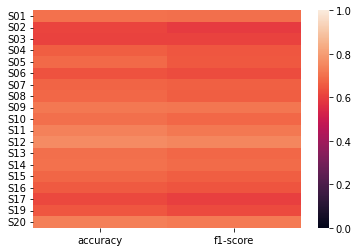

     class0 f1-score  class1 f1-score
S01         0.789474         0.489362
S02         0.734694         0.285714
S03         0.718367         0.355140
S04         0.772563         0.350515
S05         0.798450         0.297297
S06         0.756757         0.307692
S07         0.770428         0.438095
S08         0.782288         0.404040
S09         0.805861         0.485437
S10         0.792727         0.435644
S11         0.826772         0.450000
S12         0.838462         0.543478
S13         0.795455         0.425532
S14         0.793893         0.460000
S15         0.780669         0.391753
S16         0.764045         0.363636
S17         0.744939         0.258824
S19         0.760148         0.329897
S20         0.818182         0.500000


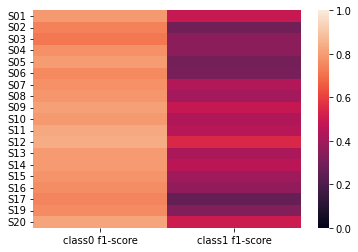

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
